In [1]:
%matplotlib inline

# Fitting TESS data

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.1


In this tutorial, we will reproduce the fits to the transiting planet in the Pi Mensae system discovered by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).
The data processing and model are similar to the :ref:`together` tutorial, but with a few extra bits like aperture selection and de-trending.

To start, we need to download the target pixel file:

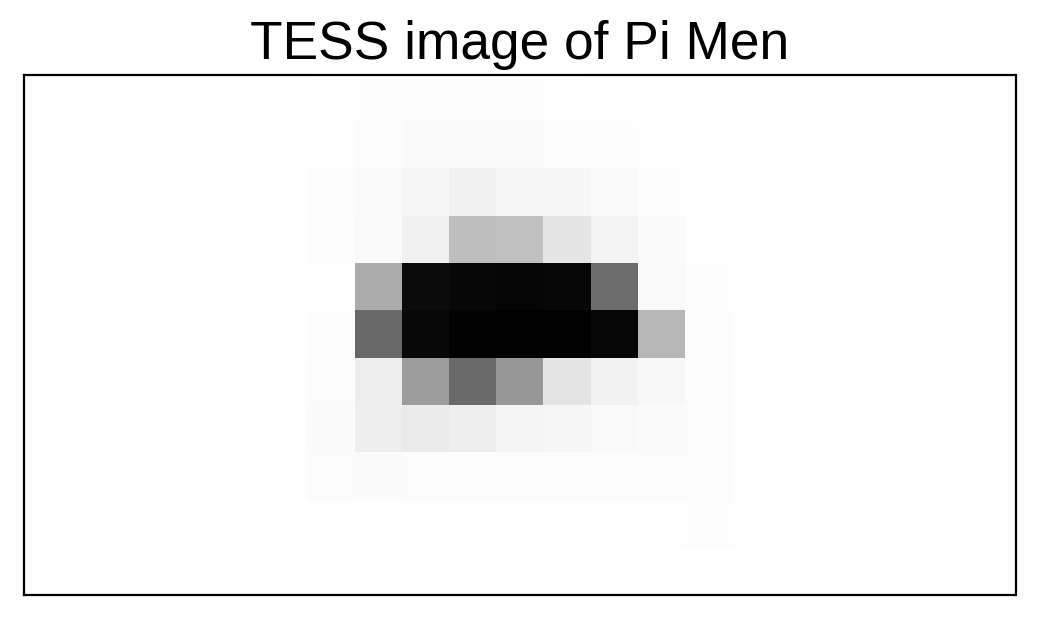

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

tpf_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0002/6113/6679/tess2018206045859-s0001-0000000261136679-0120-s_tp.fits"
with fits.open(tpf_url) as hdus:
    tpf = hdus[1].data
    tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

## Aperture selection

Next, we'll select an aperture using a hacky method that tries to minimizes the windowed scatter in the lightcurve (something like the CDPP).

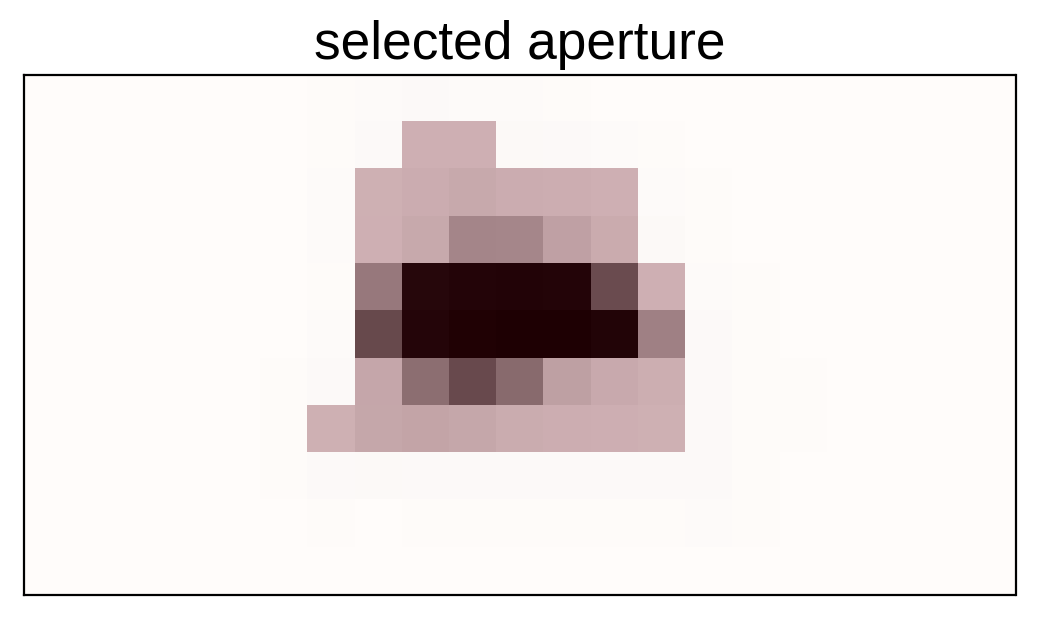

In [4]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

This aperture produces the following light curve:

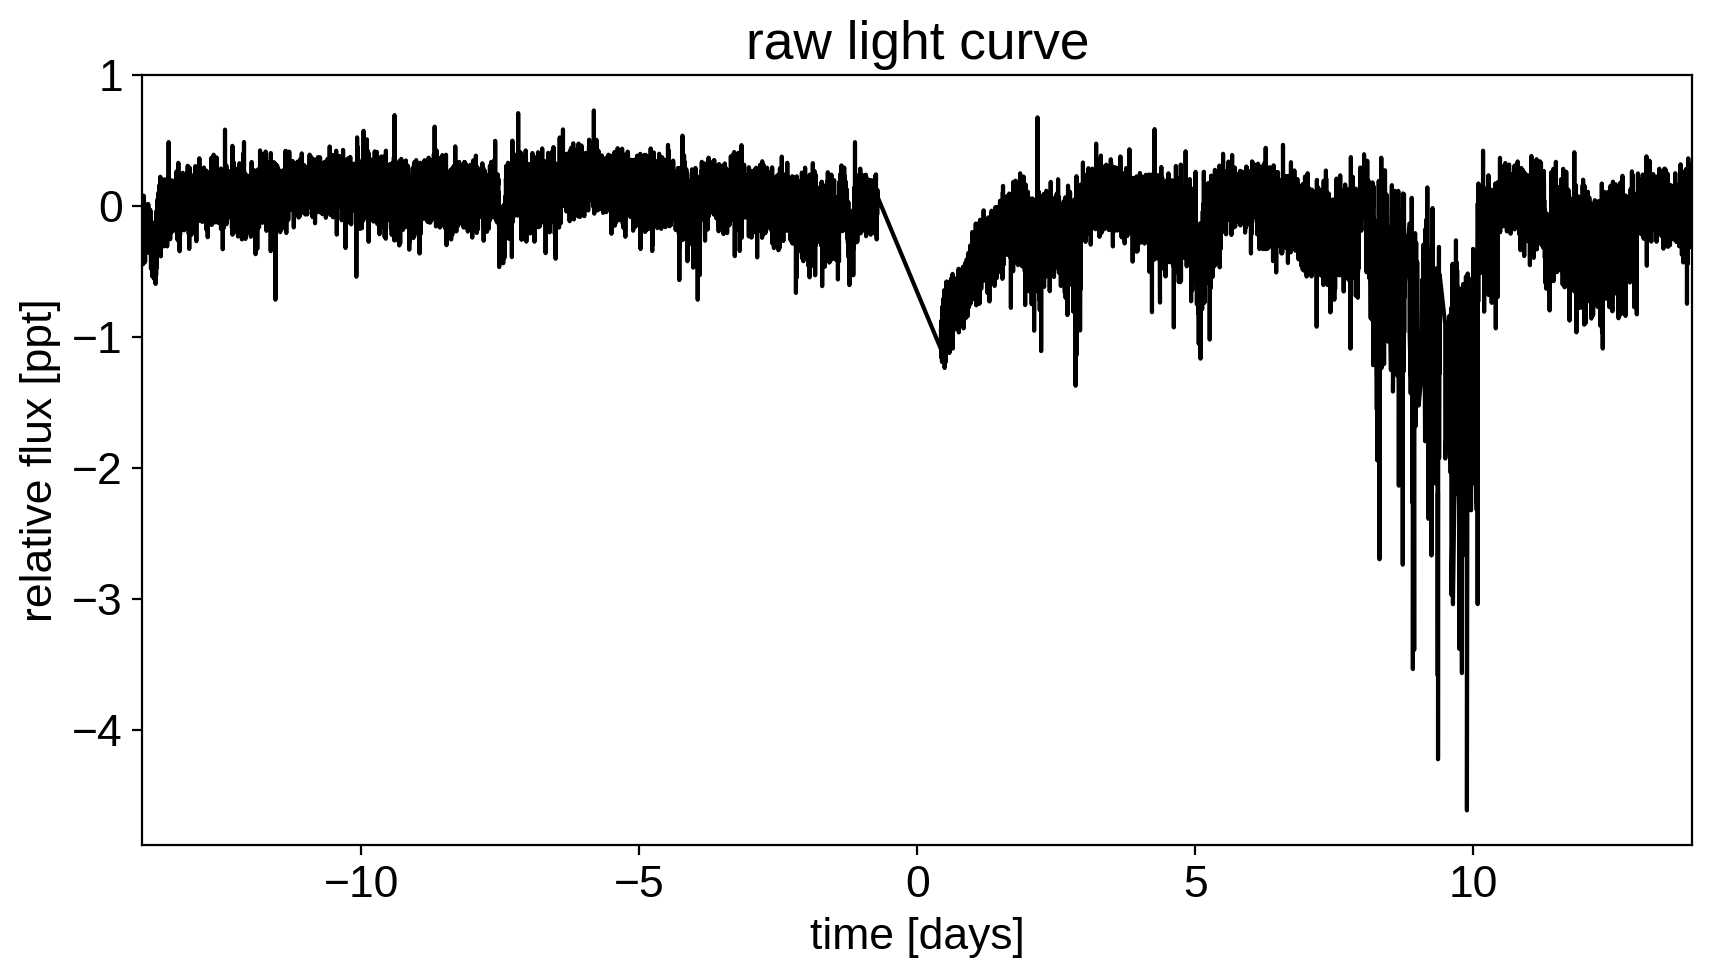

In [5]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

## De-trending

This doesn't look terrible, but we're still going to want to de-trend it a little bit.
We'll use "pixel-level deconvolution" (PLD) to de-trend following the method used by [Everest](https://github.com/rodluger/everest).
Specifically, we'll use first order PLD plus the top few PCA components of the second order PLD basis.

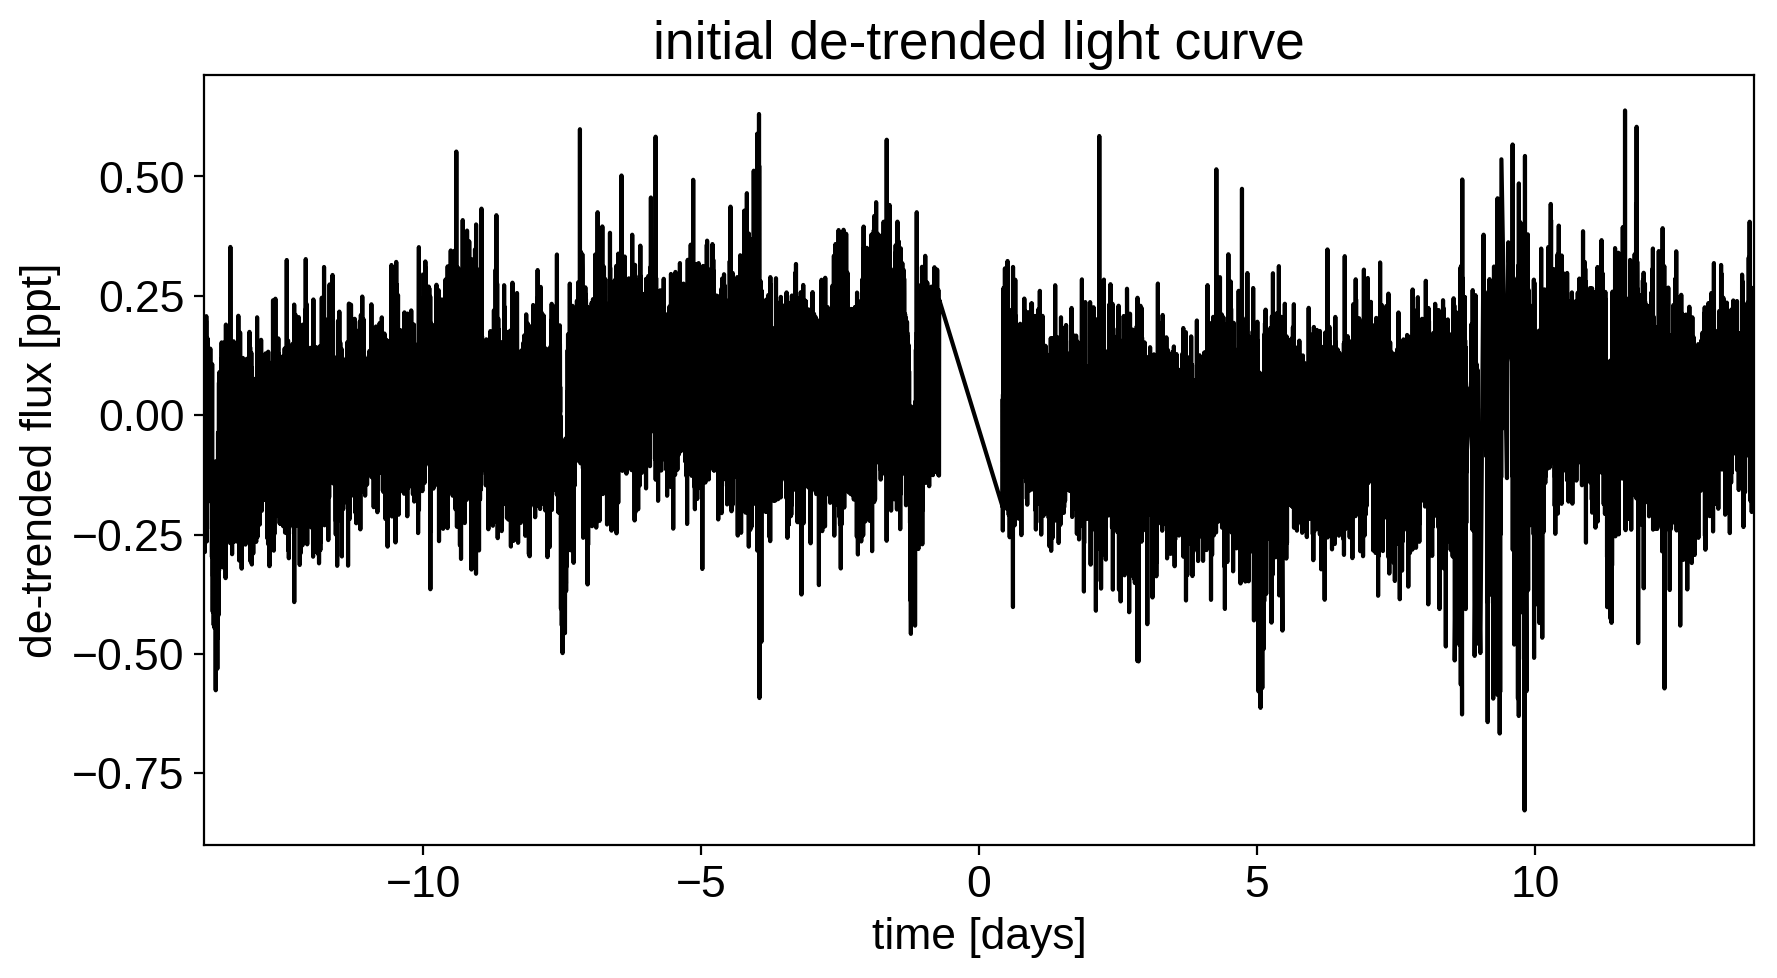

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

That looks better.

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

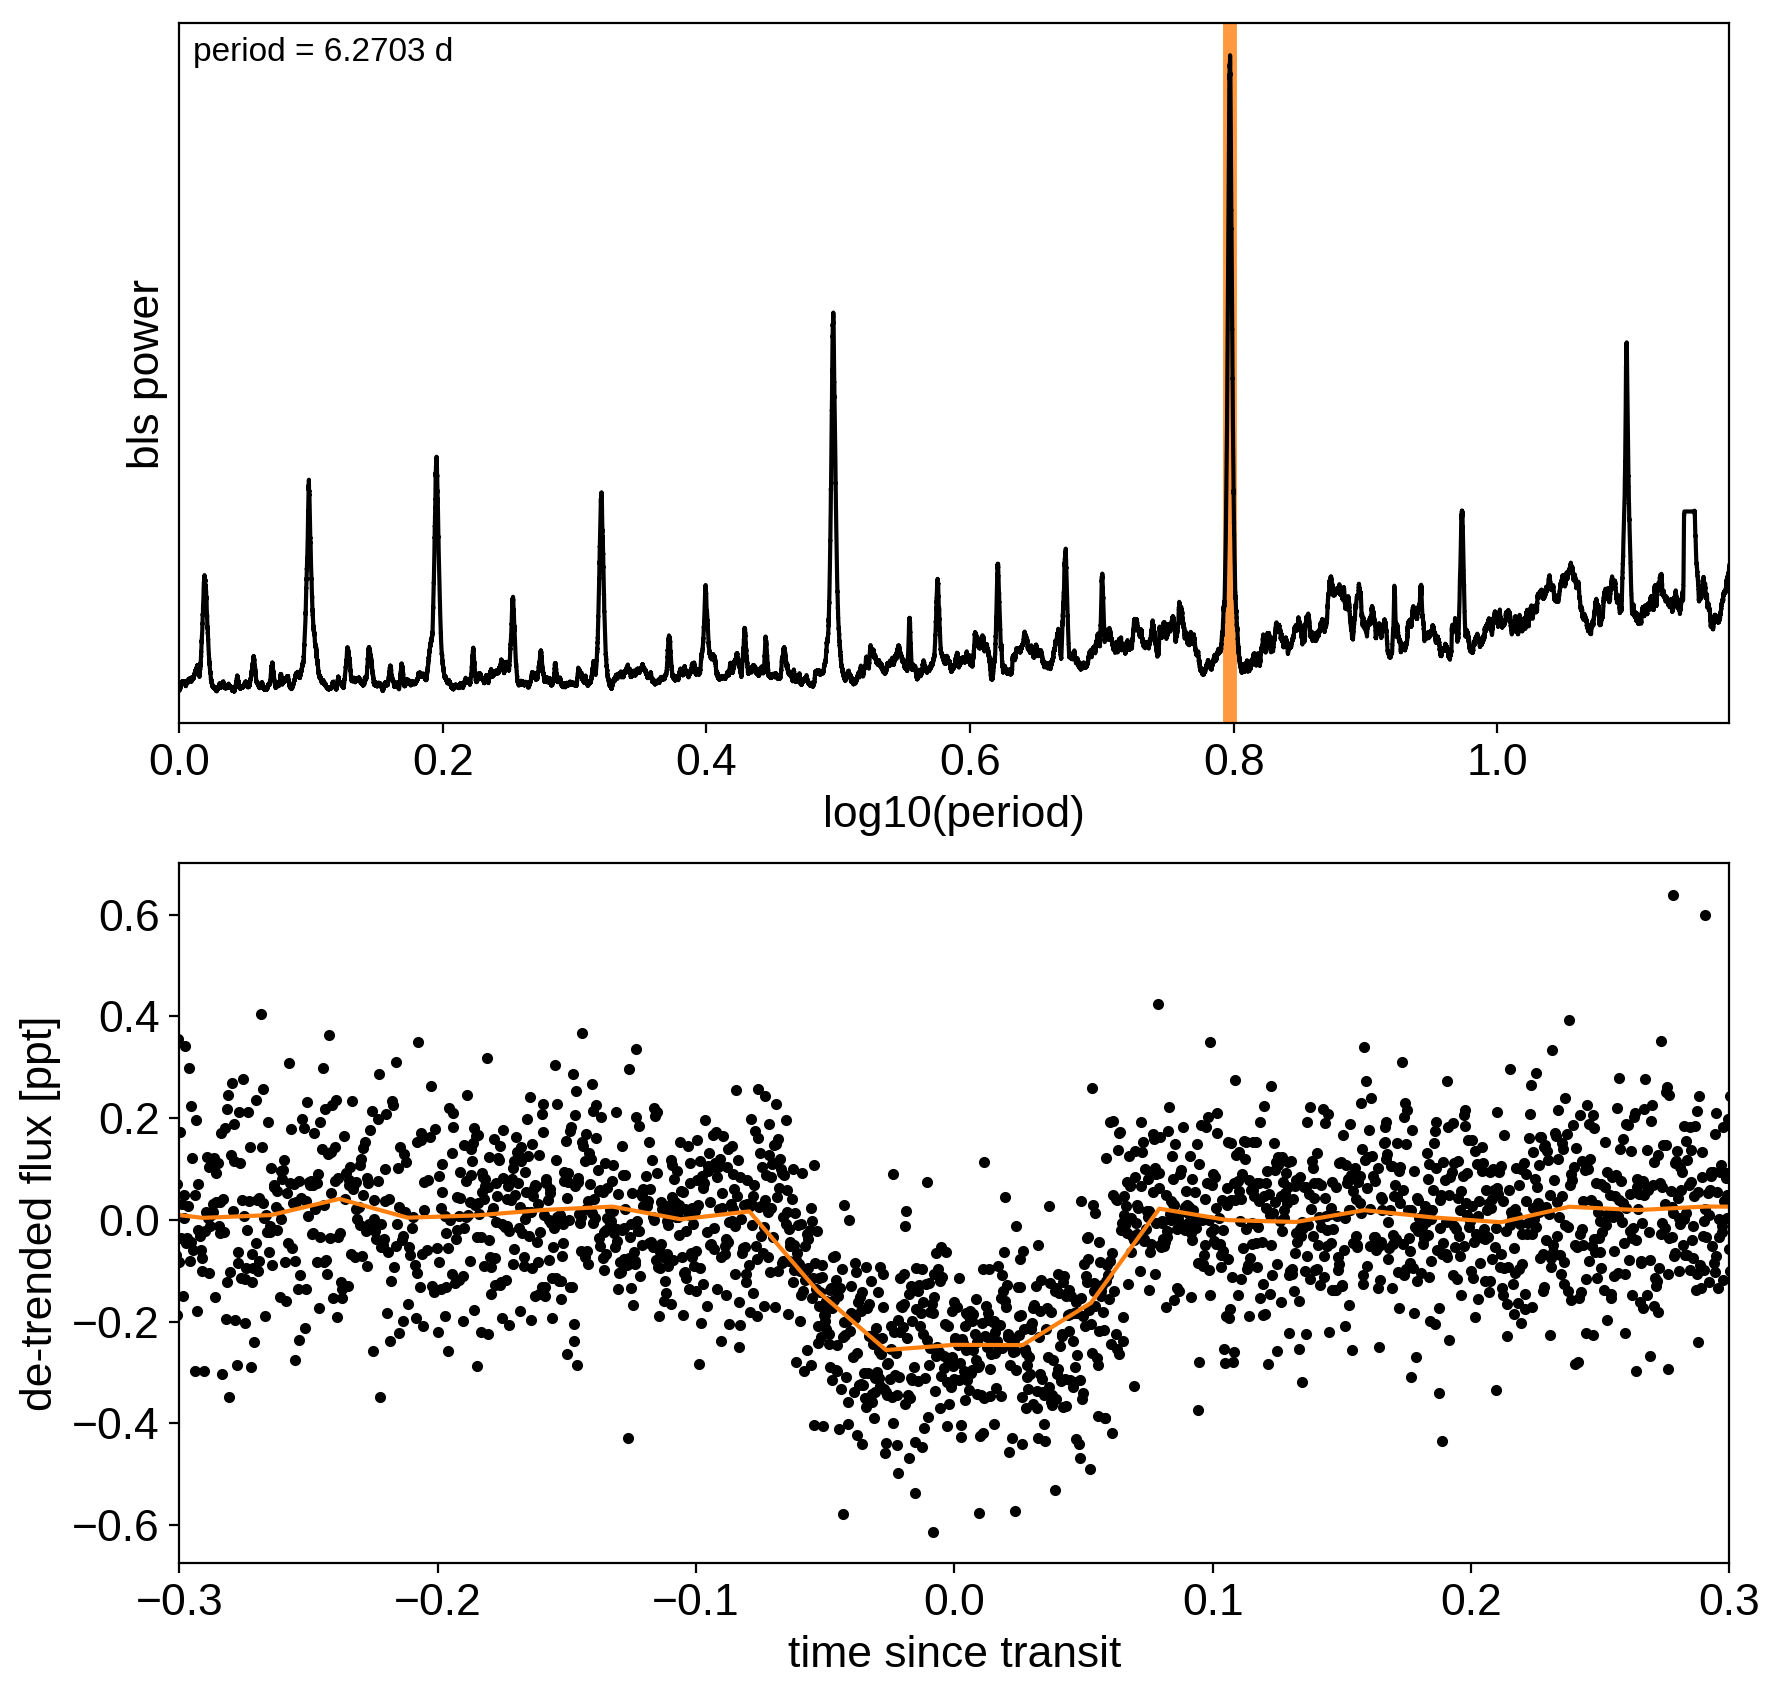

In [7]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

Now that we know where the transits are, it's generally good practice to de-trend the data one more time with the transits masked so that the de-trending doesn't overfit the transits.
Let's do that.

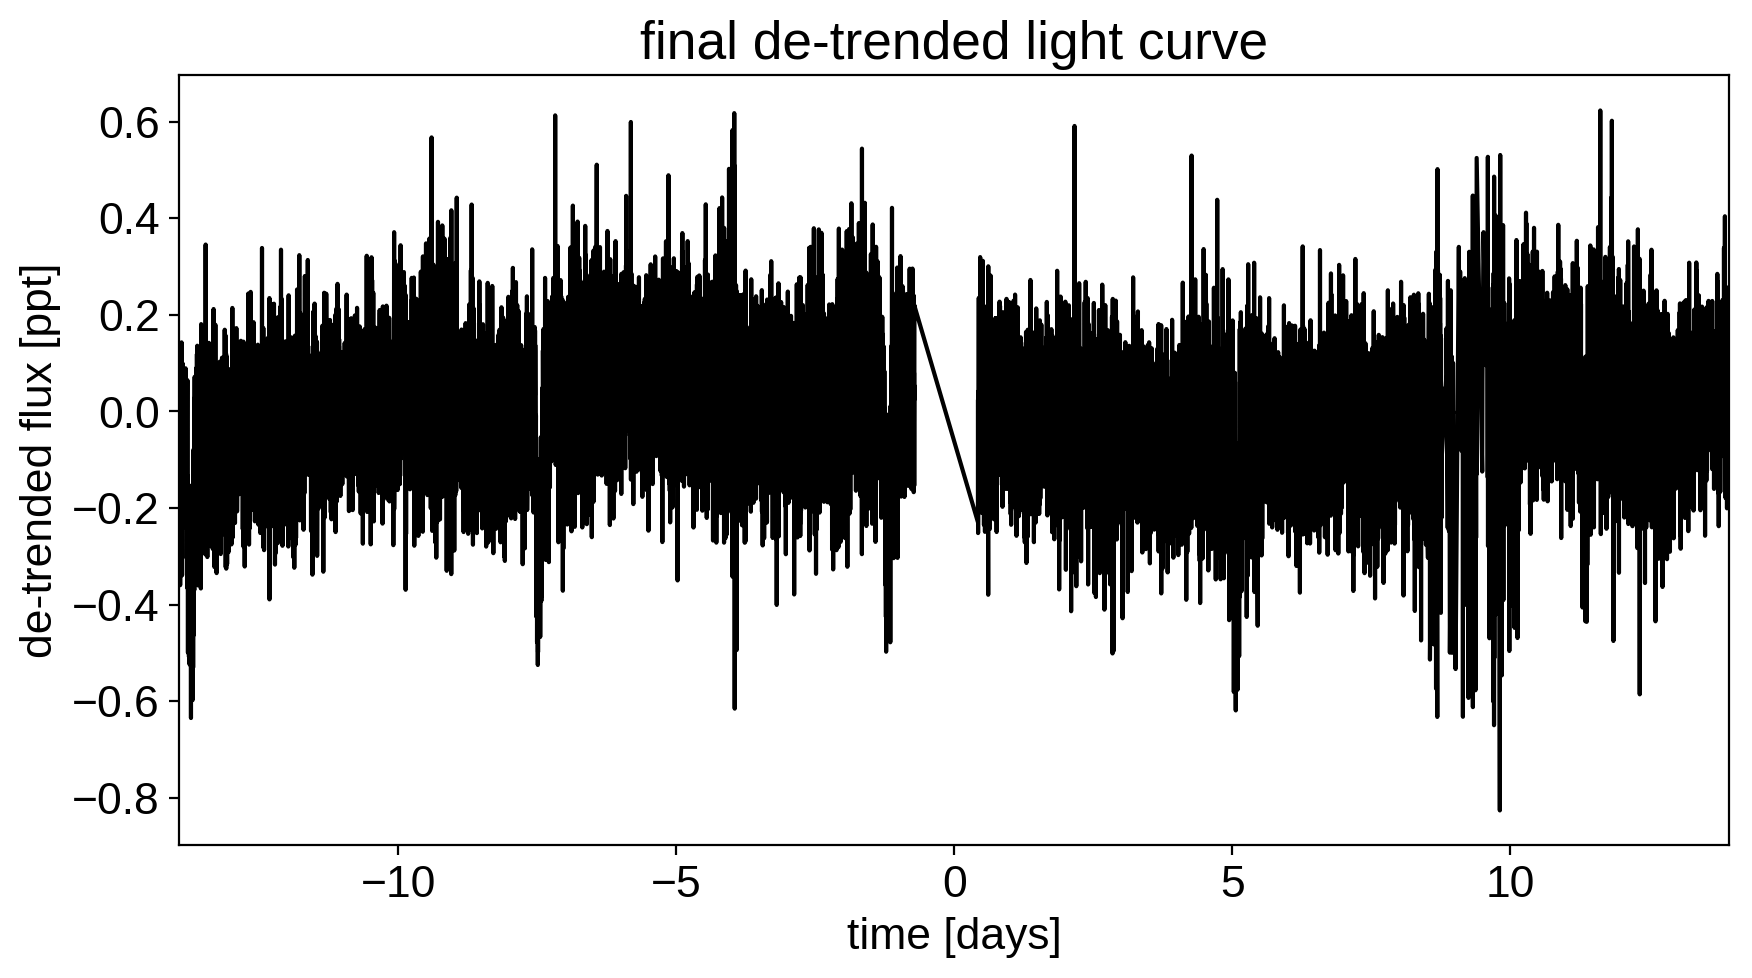

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

To confirm that we didn't overfit the transit, we can look at the folded light curve for the PLD model near trasit.
This shouldn't have any residual transit signal, and that looks correct here:

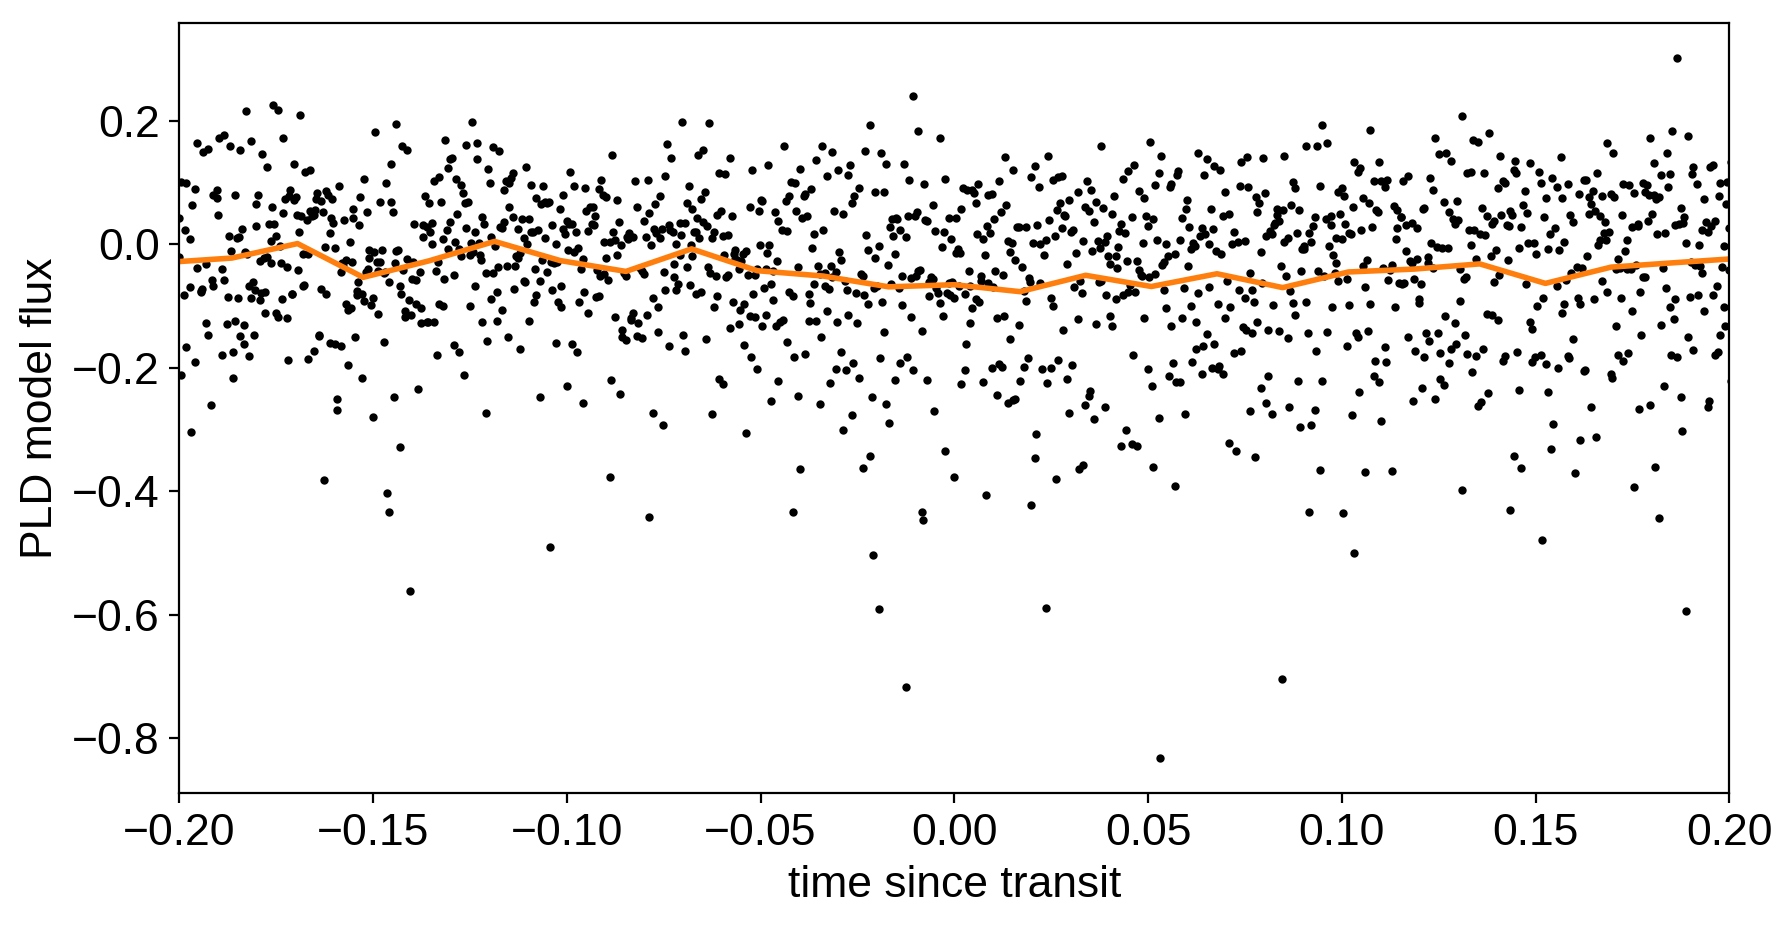

In [9]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in :ref:`together`.

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = BoundedNormal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(R_star_huang[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.ImpactParameter("b", ror=ror)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = xo.distributions.eccentricity.kipping13("ecc", testval=0.1)
        omega = xo.distributions.Angle("omega")
        
        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logSw4, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4, logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.240606e+04]

1it [00:00, 47.10it/s, logp=1.240606e+04]

2it [00:00, 64.37it/s, logp=1.240606e+04]

3it [00:00, 72.79it/s, logp=8.845500e+03]

4it [00:00, 77.86it/s, logp=1.259726e+04]

5it [00:00, 81.14it/s, logp=1.122499e+04]

6it [00:00, 84.04it/s, logp=1.261335e+04]

7it [00:00, 85.79it/s, logp=1.263205e+04]

8it [00:00, 85.51it/s, logp=1.246006e+04]

9it [00:00, 84.67it/s, logp=1.264001e+04]

10it [00:00, 93.06it/s, logp=1.264001e+04]

10it [00:00, 93.06it/s, logp=1.263821e+04]

11it [00:00, 93.06it/s, logp=1.264216e+04]

12it [00:00, 93.06it/s, logp=1.264274e+04]

13it [00:00, 93.06it/s, logp=1.264290e+04]

14it [00:00, 93.06it/s, logp=1.264290e+04]

15it [00:00, 93.06it/s, logp=1.264290e+04]

16it [00:00, 93.06it/s, logp=1.264290e+04]

17it [00:00, 93.06it/s, logp=1.264290e+04]

18it [00:00, 93.06it/s, logp=1.264290e+04]

19it [00:00, 93.06it/s, logp=1.264290e+04]

20it [00:00, 92.70it/s, logp=1.264290e+04]


message: Optimization terminated successfully.
logp: 12406.06185575557 -> 12642.89955925584


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.264290e+04]

1it [00:00, 56.41it/s, logp=1.264290e+04]

2it [00:00, 78.38it/s, logp=1.264290e+04]

3it [00:00, 82.33it/s, logp=7.847980e+03]

4it [00:00, 87.77it/s, logp=1.268102e+04]

5it [00:00, 88.31it/s, logp=1.268136e+04]

6it [00:00, 88.76it/s, logp=1.268186e+04]

7it [00:00, 93.45it/s, logp=1.268195e+04]

8it [00:00, 95.19it/s, logp=1.268195e+04]

9it [00:00, 96.48it/s, logp=1.268195e+04]

10it [00:00, 98.38it/s, logp=1.268195e+04]

11it [00:00, 107.55it/s, logp=1.268195e+04]

11it [00:00, 107.55it/s, logp=1.268195e+04]

12it [00:00, 107.55it/s, logp=1.268195e+04]

13it [00:00, 107.55it/s, logp=1.268195e+04]

14it [00:00, 107.55it/s, logp=1.268195e+04]

15it [00:00, 107.55it/s, logp=1.268195e+04]

16it [00:00, 107.55it/s, logp=1.268195e+04]

17it [00:00, 107.55it/s, logp=1.268195e+04]

18it [00:00, 107.55it/s, logp=1.268195e+04]

19it [00:00, 107.55it/s, logp=1.268195e+04]

20it [00:00, 107.55it/s, logp=1.268195e+04]

21it [00:00, 107.55it/s, logp=1.268195e+04]

22it [00:00, 107.67it/s, logp=1.268195e+04]

22it [00:00, 107.67it/s, logp=1.268195e+04]

23it [00:00, 107.67it/s, logp=1.268195e+04]

24it [00:00, 107.67it/s, logp=1.268195e+04]

25it [00:00, 107.67it/s, logp=1.268195e+04]

26it [00:00, 107.67it/s, logp=1.268195e+04]

27it [00:00, 107.67it/s, logp=1.268195e+04]

28it [00:00, 107.67it/s, logp=1.268195e+04]

29it [00:00, 107.67it/s, logp=1.268195e+04]

30it [00:00, 107.67it/s, logp=1.268195e+04]

31it [00:00, 107.67it/s, logp=1.268195e+04]

32it [00:00, 107.67it/s, logp=1.268195e+04]

33it [00:00, 107.67it/s, logp=1.268195e+04]

34it [00:00, 109.13it/s, logp=1.268195e+04]

34it [00:00, 109.13it/s, logp=1.268195e+04]

35it [00:00, 109.13it/s, logp=1.268195e+04]

36it [00:00, 109.13it/s, logp=1.268195e+04]

37it [00:00, 109.13it/s, logp=1.268195e+04]

38it [00:00, 109.13it/s, logp=1.268195e+04]

39it [00:00, 109.13it/s, logp=1.268195e+04]

40it [00:00, 109.13it/s, logp=1.268195e+04]

41it [00:00, 109.13it/s, logp=1.268195e+04]

42it [00:00, 109.13it/s, logp=1.268195e+04]

43it [00:00, 109.13it/s, logp=1.268195e+04]

44it [00:00, 109.13it/s, logp=1.268195e+04]

45it [00:00, 109.13it/s, logp=1.268195e+04]

46it [00:00, 109.13it/s, logp=1.268195e+04]

47it [00:00, 109.13it/s, logp=1.268195e+04]

48it [00:00, 114.11it/s, logp=1.268195e+04]

48it [00:00, 114.11it/s, logp=1.268195e+04]

49it [00:00, 114.11it/s, logp=1.268195e+04]

50it [00:00, 114.11it/s, logp=1.268195e+04]

51it [00:00, 114.11it/s, logp=1.268195e+04]

52it [00:00, 114.11it/s, logp=1.268195e+04]

53it [00:00, 114.11it/s, logp=1.268195e+04]

54it [00:00, 114.11it/s, logp=1.268195e+04]

55it [00:00, 114.11it/s, logp=1.268195e+04]

56it [00:00, 114.11it/s, logp=1.268195e+04]

57it [00:00, 114.11it/s, logp=1.268195e+04]

58it [00:00, 114.11it/s, logp=1.268195e+04]

59it [00:00, 112.26it/s, logp=1.268195e+04]

59it [00:00, 112.26it/s, logp=1.268195e+04]

60it [00:00, 112.26it/s, logp=1.268195e+04]

61it [00:00, 112.26it/s, logp=1.268195e+04]

62it [00:00, 112.26it/s, logp=1.268195e+04]

63it [00:00, 112.26it/s, logp=1.268195e+04]

64it [00:00, 112.26it/s, logp=1.268195e+04]

65it [00:00, 112.26it/s, logp=1.268195e+04]

66it [00:00, 112.26it/s, logp=1.268195e+04]

67it [00:00, 112.26it/s, logp=1.268195e+04]

68it [00:00, 112.26it/s, logp=1.268195e+04]

69it [00:00, 106.52it/s, logp=1.268195e+04]

69it [00:00, 106.52it/s, logp=1.268195e+04]

70it [00:00, 106.52it/s, logp=1.268195e+04]

71it [00:00, 106.52it/s, logp=1.268195e+04]

72it [00:00, 106.52it/s, logp=1.268195e+04]

73it [00:00, 106.52it/s, logp=1.268195e+04]

74it [00:00, 106.52it/s, logp=1.268195e+04]

75it [00:00, 106.52it/s, logp=1.268195e+04]

76it [00:00, 106.52it/s, logp=1.268195e+04]

77it [00:00, 106.52it/s, logp=1.268195e+04]

78it [00:00, 106.52it/s, logp=1.268195e+04]

79it [00:00, 101.85it/s, logp=1.268195e+04]

79it [00:00, 101.85it/s, logp=1.268195e+04]

80it [00:00, 101.85it/s, logp=1.268195e+04]

81it [00:00, 101.85it/s, logp=1.268195e+04]

82it [00:00, 101.85it/s, logp=1.268195e+04]

83it [00:00, 101.85it/s, logp=1.268195e+04]

84it [00:00, 101.85it/s, logp=1.268195e+04]

85it [00:00, 101.85it/s, logp=1.268195e+04]

86it [00:00, 101.85it/s, logp=1.268195e+04]

87it [00:00, 101.85it/s, logp=1.268195e+04]

88it [00:00, 101.85it/s, logp=1.268195e+04]

89it [00:00, 101.01it/s, logp=1.268195e+04]

89it [00:00, 101.01it/s, logp=1.268195e+04]

90it [00:00, 101.01it/s, logp=1.268195e+04]

91it [00:00, 101.01it/s, logp=1.268195e+04]

92it [00:00, 101.01it/s, logp=1.268195e+04]

93it [00:00, 101.01it/s, logp=1.268195e+04]

94it [00:00, 101.01it/s, logp=1.268195e+04]

95it [00:00, 101.01it/s, logp=1.268195e+04]

96it [00:00, 101.01it/s, logp=1.268195e+04]

97it [00:00, 101.01it/s, logp=1.268195e+04]

98it [00:00, 101.01it/s, logp=1.268195e+04]

99it [00:00, 101.01it/s, logp=1.268195e+04]

100it [00:00, 101.01it/s, logp=1.268195e+04]

101it [00:00, 104.98it/s, logp=1.268195e+04]

101it [00:00, 104.98it/s, logp=1.268195e+04]

102it [00:00, 104.98it/s, logp=1.268195e+04]

103it [00:00, 104.98it/s, logp=1.268195e+04]

104it [00:00, 104.98it/s, logp=1.268195e+04]

105it [00:00, 104.98it/s, logp=1.268195e+04]

106it [00:00, 104.98it/s, logp=1.268195e+04]

107it [00:01, 104.98it/s, logp=1.268195e+04]

108it [00:01, 104.98it/s, logp=1.268195e+04]

109it [00:01, 104.98it/s, logp=1.268195e+04]

110it [00:01, 104.98it/s, logp=1.268195e+04]

111it [00:01, 104.98it/s, logp=1.268195e+04]

112it [00:01, 104.98it/s, logp=1.268195e+04]

113it [00:01, 108.95it/s, logp=1.268195e+04]

113it [00:01, 108.95it/s, logp=1.268195e+04]

114it [00:01, 108.95it/s, logp=1.268195e+04]

115it [00:01, 108.95it/s, logp=1.268195e+04]

116it [00:01, 108.95it/s, logp=1.268195e+04]

117it [00:01, 108.95it/s, logp=1.268195e+04]

118it [00:01, 108.95it/s, logp=1.268195e+04]

119it [00:01, 108.95it/s, logp=1.268195e+04]

120it [00:01, 108.95it/s, logp=1.268195e+04]

121it [00:01, 108.95it/s, logp=1.268195e+04]

122it [00:01, 108.95it/s, logp=1.268195e+04]

123it [00:01, 108.95it/s, logp=1.268195e+04]

124it [00:01, 108.95it/s, logp=1.268195e+04]

125it [00:01, 110.98it/s, logp=1.268195e+04]

125it [00:01, 110.98it/s, logp=1.268195e+04]

126it [00:01, 110.98it/s, logp=1.268195e+04]

127it [00:01, 110.98it/s, logp=1.268195e+04]

128it [00:01, 110.98it/s, logp=1.268195e+04]

129it [00:01, 110.98it/s, logp=1.268195e+04]

130it [00:01, 110.98it/s, logp=1.268195e+04]

131it [00:01, 110.98it/s, logp=1.268195e+04]

132it [00:01, 110.98it/s, logp=1.268195e+04]

133it [00:01, 110.98it/s, logp=1.268195e+04]

134it [00:01, 110.98it/s, logp=1.268195e+04]

135it [00:01, 110.98it/s, logp=1.268195e+04]

136it [00:01, 103.73it/s, logp=1.268195e+04]

136it [00:01, 103.73it/s, logp=1.268195e+04]

137it [00:01, 103.73it/s, logp=1.268195e+04]

138it [00:01, 103.73it/s, logp=1.268195e+04]

139it [00:01, 103.73it/s, logp=1.268195e+04]

140it [00:01, 103.73it/s, logp=1.268195e+04]

141it [00:01, 103.73it/s, logp=1.268195e+04]

142it [00:01, 103.73it/s, logp=1.268195e+04]

143it [00:01, 103.73it/s, logp=1.268195e+04]

144it [00:01, 103.73it/s, logp=1.268195e+04]

145it [00:01, 103.73it/s, logp=1.268195e+04]

146it [00:01, 103.73it/s, logp=1.268195e+04]

147it [00:01, 103.73it/s, logp=1.268195e+04]

148it [00:01, 107.87it/s, logp=1.268195e+04]

148it [00:01, 107.87it/s, logp=1.268195e+04]

149it [00:01, 107.87it/s, logp=1.268195e+04]

150it [00:01, 107.87it/s, logp=1.268195e+04]

151it [00:01, 107.87it/s, logp=1.268195e+04]

152it [00:01, 107.87it/s, logp=1.268195e+04]

153it [00:01, 107.87it/s, logp=1.268195e+04]

154it [00:01, 107.87it/s, logp=1.268195e+04]

155it [00:01, 107.87it/s, logp=1.268195e+04]

156it [00:01, 107.87it/s, logp=1.268195e+04]

157it [00:01, 107.87it/s, logp=1.268195e+04]

158it [00:01, 107.87it/s, logp=1.268195e+04]

159it [00:01, 107.87it/s, logp=1.268195e+04]

160it [00:01, 111.03it/s, logp=1.268195e+04]

160it [00:01, 111.03it/s, logp=1.268195e+04]

161it [00:01, 111.03it/s, logp=1.268195e+04]

162it [00:01, 111.03it/s, logp=1.268195e+04]

163it [00:01, 111.03it/s, logp=1.268195e+04]

164it [00:01, 111.03it/s, logp=1.268195e+04]

165it [00:01, 111.03it/s, logp=1.268195e+04]

166it [00:01, 111.03it/s, logp=1.268195e+04]

167it [00:01, 111.03it/s, logp=1.268195e+04]

168it [00:01, 111.03it/s, logp=1.268195e+04]

169it [00:01, 111.03it/s, logp=1.268195e+04]

170it [00:01, 111.03it/s, logp=1.268195e+04]

171it [00:01, 111.03it/s, logp=1.268195e+04]

172it [00:01, 106.58it/s, logp=1.268195e+04]

172it [00:01, 106.58it/s, logp=1.268195e+04]

173it [00:01, 106.58it/s, logp=1.268195e+04]

174it [00:01, 106.58it/s, logp=1.268195e+04]

175it [00:01, 106.58it/s, logp=1.268195e+04]

176it [00:01, 106.58it/s, logp=1.268195e+04]

177it [00:01, 106.58it/s, logp=1.268195e+04]

178it [00:01, 106.58it/s, logp=1.268195e+04]

179it [00:01, 106.58it/s, logp=1.268195e+04]

180it [00:01, 106.58it/s, logp=1.268195e+04]

181it [00:01, 106.58it/s, logp=1.268195e+04]

182it [00:01, 106.58it/s, logp=1.268195e+04]

183it [00:01, 101.05it/s, logp=1.268195e+04]

183it [00:01, 101.05it/s, logp=1.268195e+04]

184it [00:01, 101.05it/s, logp=1.268195e+04]

185it [00:01, 101.05it/s, logp=1.268195e+04]

186it [00:01, 101.05it/s, logp=1.268195e+04]

187it [00:01, 101.05it/s, logp=1.268195e+04]

188it [00:01, 101.05it/s, logp=1.268195e+04]

189it [00:01, 101.05it/s, logp=1.268195e+04]

190it [00:01, 101.05it/s, logp=1.268195e+04]

191it [00:01, 101.05it/s, logp=1.268195e+04]

192it [00:01, 101.05it/s, logp=1.268195e+04]

193it [00:01, 101.05it/s, logp=1.268195e+04]

194it [00:01, 97.48it/s, logp=1.268195e+04] 

194it [00:01, 97.48it/s, logp=1.268195e+04]

195it [00:01, 97.48it/s, logp=1.268195e+04]

196it [00:01, 97.48it/s, logp=1.268195e+04]

197it [00:01, 97.48it/s, logp=1.268195e+04]

198it [00:01, 97.48it/s, logp=1.268195e+04]

199it [00:01, 97.48it/s, logp=1.268195e+04]

200it [00:01, 97.48it/s, logp=1.268195e+04]

201it [00:01, 97.48it/s, logp=1.268195e+04]

202it [00:01, 97.48it/s, logp=1.268195e+04]

203it [00:01, 97.48it/s, logp=1.268195e+04]

204it [00:01, 95.19it/s, logp=1.268195e+04]

204it [00:01, 95.19it/s, logp=1.268195e+04]

205it [00:01, 95.19it/s, logp=1.268195e+04]

206it [00:01, 95.19it/s, logp=1.268195e+04]

207it [00:03, 58.24it/s, logp=1.268195e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 12642.899559255851 -> 12681.951246651677


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.268195e+04]

1it [00:00, 41.12it/s, logp=1.268195e+04]

2it [00:00, 57.58it/s, logp=1.268195e+04]

3it [00:00, 69.66it/s, logp=1.100456e+04]

4it [00:00, 78.61it/s, logp=1.288292e+04]

5it [00:00, 85.98it/s, logp=1.281114e+04]

6it [00:00, 91.77it/s, logp=1.293580e+04]

7it [00:00, 97.38it/s, logp=1.238252e+04]

8it [00:00, 101.79it/s, logp=1.293688e+04]

9it [00:00, 104.47it/s, logp=1.293896e+04]

10it [00:00, 105.78it/s, logp=1.294512e+04]

11it [00:00, 107.49it/s, logp=1.294869e+04]

12it [00:00, 116.35it/s, logp=1.294869e+04]

12it [00:00, 116.35it/s, logp=1.294912e+04]

13it [00:00, 116.35it/s, logp=1.294928e+04]

14it [00:00, 116.35it/s, logp=1.294933e+04]

15it [00:00, 116.35it/s, logp=1.294934e+04]

16it [00:00, 116.35it/s, logp=1.294934e+04]

17it [00:00, 116.35it/s, logp=1.294934e+04]

18it [00:00, 116.35it/s, logp=1.294934e+04]

19it [00:00, 116.35it/s, logp=1.294934e+04]

20it [00:00, 116.35it/s, logp=1.294934e+04]

21it [00:00, 116.35it/s, logp=1.294934e+04]

22it [00:00, 116.35it/s, logp=1.294934e+04]

23it [00:00, 116.35it/s, logp=1.294934e+04]

24it [00:00, 114.91it/s, logp=1.294934e+04]

24it [00:00, 114.91it/s, logp=1.294934e+04]

25it [00:00, 114.91it/s, logp=1.294934e+04]

26it [00:00, 114.91it/s, logp=1.294934e+04]

27it [00:00, 114.91it/s, logp=1.294934e+04]

28it [00:00, 114.91it/s, logp=1.294934e+04]

29it [00:00, 114.91it/s, logp=1.294934e+04]

30it [00:00, 114.91it/s, logp=1.294934e+04]

31it [00:00, 114.91it/s, logp=1.294934e+04]

32it [00:00, 114.91it/s, logp=1.294934e+04]

33it [00:00, 114.91it/s, logp=1.294934e+04]

34it [00:00, 114.91it/s, logp=1.294934e+04]

35it [00:00, 114.91it/s, logp=1.294934e+04]

36it [00:00, 114.91it/s, logp=1.294934e+04]

37it [00:00, 114.91it/s, logp=1.294934e+04]

38it [00:00, 119.72it/s, logp=1.294934e+04]

38it [00:00, 119.72it/s, logp=1.294934e+04]

39it [00:00, 119.72it/s, logp=1.294934e+04]

40it [00:00, 119.72it/s, logp=1.294934e+04]

41it [00:00, 119.72it/s, logp=1.294934e+04]

42it [00:00, 119.72it/s, logp=1.294934e+04]

43it [00:00, 119.72it/s, logp=1.294934e+04]

44it [00:00, 119.72it/s, logp=1.294934e+04]

45it [00:00, 119.72it/s, logp=1.294934e+04]

46it [00:00, 119.72it/s, logp=1.294934e+04]

47it [00:00, 119.72it/s, logp=1.294934e+04]

48it [00:00, 119.72it/s, logp=1.294934e+04]

49it [00:00, 119.72it/s, logp=1.294934e+04]

50it [00:00, 119.72it/s, logp=1.294934e+04]

51it [00:00, 119.72it/s, logp=1.294934e+04]

52it [00:00, 123.39it/s, logp=1.294934e+04]

52it [00:00, 123.39it/s, logp=1.294934e+04]

53it [00:00, 123.39it/s, logp=1.294934e+04]

54it [00:00, 123.39it/s, logp=1.294934e+04]

55it [00:00, 123.39it/s, logp=1.294934e+04]

56it [00:00, 123.39it/s, logp=1.294934e+04]

57it [00:00, 123.39it/s, logp=1.294934e+04]

58it [00:00, 123.39it/s, logp=1.294934e+04]

59it [00:00, 123.39it/s, logp=1.294934e+04]

60it [00:00, 123.39it/s, logp=1.294934e+04]

61it [00:00, 123.39it/s, logp=1.294934e+04]

62it [00:00, 123.39it/s, logp=1.294934e+04]

63it [00:00, 123.39it/s, logp=1.294934e+04]

64it [00:01, 35.87it/s, logp=1.294934e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 12681.951246651677 -> 12949.339148287803


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.294934e+04]

1it [00:00, 59.40it/s, logp=1.294934e+04]

2it [00:00, 82.50it/s, logp=1.294934e+04]

3it [00:00, 89.51it/s, logp=1.167030e+04]

4it [00:00, 96.11it/s, logp=1.191116e+04]

5it [00:00, 101.70it/s, logp=1.227221e+04]

6it [00:00, 105.79it/s, logp=1.219656e+04]

7it [00:00, 109.26it/s, logp=1.261034e+04]

8it [00:00, 111.64it/s, logp=1.295942e+04]

9it [00:00, 112.27it/s, logp=1.292562e+04]

10it [00:00, 114.48it/s, logp=1.296212e+04]

11it [00:00, 114.21it/s, logp=1.296041e+04]

12it [00:00, 115.69it/s, logp=1.296366e+04]

13it [00:00, 124.35it/s, logp=1.296366e+04]

13it [00:00, 124.35it/s, logp=1.296367e+04]

14it [00:00, 124.35it/s, logp=1.296368e+04]

15it [00:00, 124.35it/s, logp=1.296370e+04]

16it [00:00, 124.35it/s, logp=1.296371e+04]

17it [00:00, 124.35it/s, logp=1.296373e+04]

18it [00:00, 124.35it/s, logp=1.296374e+04]

19it [00:00, 124.35it/s, logp=1.296374e+04]

20it [00:00, 124.35it/s, logp=1.296374e+04]

21it [00:00, 124.35it/s, logp=1.296374e+04]

22it [00:00, 124.35it/s, logp=1.296374e+04]

23it [00:00, 124.35it/s, logp=1.296374e+04]

24it [00:00, 118.38it/s, logp=1.296374e+04]

24it [00:00, 118.38it/s, logp=1.296374e+04]

25it [00:00, 118.38it/s, logp=1.296374e+04]

26it [00:00, 118.38it/s, logp=1.296374e+04]

27it [00:00, 118.38it/s, logp=1.296374e+04]

28it [00:00, 118.38it/s, logp=1.296374e+04]

29it [00:00, 118.38it/s, logp=1.296374e+04]

30it [00:00, 118.38it/s, logp=1.296374e+04]

31it [00:00, 118.38it/s, logp=1.296374e+04]

32it [00:00, 118.38it/s, logp=1.296374e+04]

33it [00:00, 118.38it/s, logp=1.296374e+04]

34it [00:00, 118.38it/s, logp=1.296374e+04]

35it [00:00, 118.38it/s, logp=1.296374e+04]

36it [00:00, 118.38it/s, logp=1.296374e+04]

37it [00:00, 118.38it/s, logp=1.296374e+04]

38it [00:00, 123.86it/s, logp=1.296374e+04]

38it [00:00, 123.86it/s, logp=1.296374e+04]

39it [00:00, 123.86it/s, logp=1.296374e+04]

40it [00:00, 123.86it/s, logp=1.296374e+04]

41it [00:00, 123.86it/s, logp=1.296374e+04]

42it [00:00, 123.86it/s, logp=1.296374e+04]

43it [00:00, 123.86it/s, logp=1.296374e+04]

44it [00:00, 123.86it/s, logp=1.296374e+04]

45it [00:00, 123.86it/s, logp=1.296374e+04]

46it [00:00, 123.86it/s, logp=1.296374e+04]

47it [00:00, 123.86it/s, logp=1.296374e+04]

48it [00:00, 123.86it/s, logp=1.296374e+04]

49it [00:00, 123.86it/s, logp=1.296374e+04]

50it [00:00, 123.86it/s, logp=1.296374e+04]

51it [00:00, 123.86it/s, logp=1.296374e+04]

52it [00:00, 123.86it/s, logp=1.296374e+04]

53it [00:00, 128.68it/s, logp=1.296374e+04]

53it [00:00, 128.68it/s, logp=1.296374e+04]

54it [00:00, 128.68it/s, logp=1.296374e+04]

55it [00:00, 128.68it/s, logp=1.296374e+04]

56it [00:00, 128.68it/s, logp=1.296374e+04]

57it [00:00, 128.68it/s, logp=1.296374e+04]

58it [00:00, 128.68it/s, logp=1.296374e+04]

59it [00:00, 128.68it/s, logp=1.296374e+04]

60it [00:00, 128.68it/s, logp=1.296374e+04]

61it [00:00, 128.68it/s, logp=1.296374e+04]

62it [00:00, 128.68it/s, logp=1.296374e+04]

63it [00:00, 128.68it/s, logp=1.296374e+04]

64it [00:00, 105.39it/s, logp=1.296374e+04]

64it [00:00, 105.39it/s, logp=1.296374e+04]

65it [00:00, 105.39it/s, logp=1.296374e+04]

66it [00:00, 105.39it/s, logp=1.296374e+04]

67it [00:00, 105.39it/s, logp=1.296374e+04]

68it [00:00, 105.39it/s, logp=1.296374e+04]

69it [00:00, 105.39it/s, logp=1.296374e+04]

70it [00:00, 105.39it/s, logp=1.296374e+04]

71it [00:00, 105.39it/s, logp=1.296374e+04]

72it [00:00, 105.39it/s, logp=1.296374e+04]

73it [00:00, 105.39it/s, logp=1.296374e+04]

74it [00:00, 105.39it/s, logp=1.296374e+04]

75it [00:00, 105.39it/s, logp=1.296374e+04]

76it [00:00, 105.39it/s, logp=1.296374e+04]

77it [00:00, 106.60it/s, logp=1.296374e+04]

77it [00:00, 106.60it/s, logp=1.296374e+04]

78it [00:00, 106.60it/s, logp=1.296374e+04]

79it [00:00, 106.60it/s, logp=1.296374e+04]

80it [00:00, 106.60it/s, logp=1.296374e+04]

81it [00:00, 106.60it/s, logp=1.296374e+04]

82it [00:00, 106.60it/s, logp=1.296374e+04]

83it [00:00, 106.60it/s, logp=1.296374e+04]

84it [00:00, 106.60it/s, logp=1.296374e+04]

85it [00:00, 106.60it/s, logp=1.296374e+04]

86it [00:00, 106.60it/s, logp=1.296374e+04]

87it [00:00, 100.11it/s, logp=1.296374e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 12949.339148287796 -> 12963.740755133189


optimizing logp for variables: [u_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296374e+04]

1it [00:00, 45.29it/s, logp=1.296374e+04]

2it [00:00, 67.80it/s, logp=1.296374e+04]

3it [00:00, 62.21it/s, logp=1.296464e+04]

4it [00:00, 65.88it/s, logp=1.296597e+04]

5it [00:00, 71.13it/s, logp=1.296651e+04]

6it [00:00, 76.50it/s, logp=1.296660e+04]

7it [00:00, 81.47it/s, logp=1.296662e+04]

8it [00:00, 85.86it/s, logp=1.296662e+04]

9it [00:00, 89.58it/s, logp=1.296662e+04]

10it [00:00, 98.72it/s, logp=1.296662e+04]

10it [00:00, 98.72it/s, logp=1.296662e+04]

11it [00:00, 98.72it/s, logp=1.296662e+04]

12it [00:01,  8.05it/s, logp=1.296662e+04]


message: Optimization terminated successfully.
logp: 12963.740755133182 -> 12966.624941258484


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296662e+04]

1it [00:00, 64.81it/s, logp=1.296662e+04]

2it [00:00, 85.13it/s, logp=1.296662e+04]

3it [00:00, 98.34it/s, logp=-5.403750e+03]

4it [00:00, 106.86it/s, logp=1.285695e+04]

5it [00:00, 111.56it/s, logp=1.296682e+04]

6it [00:00, 115.46it/s, logp=1.296682e+04]

7it [00:00, 118.26it/s, logp=1.296682e+04]

8it [00:00, 120.66it/s, logp=1.296682e+04]

9it [00:01,  7.05it/s, logp=1.296682e+04] 


message: Optimization terminated successfully.
logp: 12966.624941258473 -> 12966.818870393334


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296682e+04]

1it [00:00, 60.16it/s, logp=1.296682e+04]

2it [00:00, 83.35it/s, logp=1.296682e+04]

3it [00:00, 96.42it/s, logp=7.840564e+03]

4it [00:00, 103.39it/s, logp=1.295556e+04]

5it [00:00, 108.07it/s, logp=1.296691e+04]

6it [00:00, 111.51it/s, logp=1.296674e+04]

7it [00:00, 114.48it/s, logp=1.296694e+04]

8it [00:00, 116.13it/s, logp=1.296681e+04]

9it [00:00, 117.70it/s, logp=1.296694e+04]

10it [00:00, 118.95it/s, logp=1.296694e+04]

11it [00:00, 119.62it/s, logp=1.296694e+04]

12it [00:00, 120.12it/s, logp=1.296694e+04]

13it [00:00, 129.05it/s, logp=1.296694e+04]

13it [00:00, 129.05it/s, logp=1.296694e+04]

14it [00:00, 129.05it/s, logp=1.296694e+04]

15it [00:00, 129.05it/s, logp=1.296694e+04]

16it [00:01, 11.18it/s, logp=1.296694e+04] 


message: Optimization terminated successfully.
logp: 12966.818870393334 -> 12966.944430577354


optimizing logp for variables: [omega, ecc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296694e+04]

1it [00:00, 57.38it/s, logp=1.296694e+04]

2it [00:00, 80.86it/s, logp=1.296694e+04]

3it [00:00, 93.04it/s, logp=1.297940e+04]

4it [00:00, 100.53it/s, logp=1.297518e+04]

5it [00:00, 106.47it/s, logp=1.298066e+04]

6it [00:00, 110.72it/s, logp=1.298298e+04]

7it [00:00, 113.88it/s, logp=1.298128e+04]

8it [00:00, 116.67it/s, logp=1.298472e+04]

9it [00:00, 118.59it/s, logp=1.298691e+04]

10it [00:00, 119.93it/s, logp=1.298629e+04]

11it [00:00, 121.16it/s, logp=1.298755e+04]

12it [00:00, 122.24it/s, logp=1.298777e+04]

13it [00:00, 123.37it/s, logp=1.298779e+04]

14it [00:00, 131.90it/s, logp=1.298779e+04]

14it [00:00, 131.90it/s, logp=1.298780e+04]

15it [00:00, 131.90it/s, logp=1.298780e+04]

16it [00:00, 131.90it/s, logp=1.298781e+04]

17it [00:00, 131.90it/s, logp=1.298782e+04]

18it [00:00, 131.90it/s, logp=1.298782e+04]

19it [00:00, 131.90it/s, logp=1.298782e+04]

20it [00:00, 131.90it/s, logp=1.298782e+04]

21it [00:00, 131.90it/s, logp=1.298782e+04]

22it [00:00, 131.90it/s, logp=1.298782e+04]

23it [00:01, 14.07it/s, logp=1.298782e+04] 


message: Optimization terminated successfully.
logp: 12966.944430577354 -> 12987.822019225596


optimizing logp for variables: [mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.298782e+04]

1it [00:00, 48.09it/s, logp=1.298782e+04]

2it [00:00, 51.27it/s, logp=1.298782e+04]

3it [00:00, 58.43it/s, logp=2.419262e+03]

4it [00:00, 66.91it/s, logp=1.298785e+04]

5it [00:01,  3.36it/s, logp=1.298785e+04]


message: Optimization terminated successfully.
logp: 12987.822019225618 -> 12987.850306123684


optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.298785e+04]

1it [00:00, 52.39it/s, logp=1.298785e+04]

2it [00:00, 71.04it/s, logp=1.298785e+04]

3it [00:00, 80.39it/s, logp=6.759967e+03]

4it [00:00, 86.74it/s, logp=1.298932e+04]

5it [00:00, 90.50it/s, logp=1.299055e+04]

6it [00:00, 93.35it/s, logp=1.299284e+04]

7it [00:00, 95.58it/s, logp=1.299651e+04]

8it [00:00, 97.15it/s, logp=1.299858e+04]

9it [00:00, 98.46it/s, logp=1.299864e+04]

10it [00:00, 99.48it/s, logp=1.299865e+04]

11it [00:00, 108.54it/s, logp=1.299865e+04]

11it [00:00, 108.54it/s, logp=1.299865e+04]

12it [00:00, 108.54it/s, logp=1.299865e+04]

13it [00:00, 108.54it/s, logp=1.299865e+04]

14it [00:00, 108.54it/s, logp=1.299865e+04]

15it [00:00, 108.54it/s, logp=1.299865e+04]

16it [00:00, 108.54it/s, logp=1.299865e+04]

17it [00:00, 108.54it/s, logp=1.299865e+04]

18it [00:00, 108.54it/s, logp=1.299865e+04]

19it [00:00, 108.54it/s, logp=1.299865e+04]

20it [00:00, 108.54it/s, logp=1.299865e+04]

21it [00:00, 108.54it/s, logp=1.299865e+04]

22it [00:00, 108.54it/s, logp=1.299865e+04]

23it [00:00, 109.42it/s, logp=1.299865e+04]

23it [00:00, 109.42it/s, logp=1.299865e+04]

24it [00:00, 109.42it/s, logp=1.299865e+04]

25it [00:00, 109.42it/s, logp=1.299865e+04]

26it [00:00, 109.42it/s, logp=1.299865e+04]

27it [00:00, 109.42it/s, logp=1.299865e+04]

28it [00:00, 109.42it/s, logp=1.299865e+04]

29it [00:00, 109.42it/s, logp=1.299865e+04]

30it [00:00, 109.42it/s, logp=1.299865e+04]

31it [00:00, 109.42it/s, logp=1.299865e+04]

32it [00:00, 109.42it/s, logp=1.299865e+04]

33it [00:00, 109.42it/s, logp=1.299865e+04]

34it [00:00, 108.43it/s, logp=1.299865e+04]

34it [00:00, 108.43it/s, logp=1.299865e+04]

35it [00:00, 108.43it/s, logp=1.299865e+04]

36it [00:00, 108.43it/s, logp=1.299865e+04]

37it [00:00, 108.43it/s, logp=1.299865e+04]

38it [00:00, 108.43it/s, logp=1.299865e+04]

39it [00:00, 108.43it/s, logp=1.299865e+04]

40it [00:00, 108.43it/s, logp=1.299865e+04]

41it [00:00, 108.43it/s, logp=1.299865e+04]

42it [00:00, 108.43it/s, logp=1.299865e+04]

43it [00:00, 108.43it/s, logp=1.299865e+04]

44it [00:00, 105.42it/s, logp=1.299865e+04]

44it [00:00, 105.42it/s, logp=1.299865e+04]

45it [00:00, 105.42it/s, logp=1.299865e+04]

46it [00:00, 105.42it/s, logp=1.299865e+04]

47it [00:00, 105.42it/s, logp=1.299865e+04]

48it [00:00, 105.42it/s, logp=1.299865e+04]

49it [00:00, 105.42it/s, logp=1.299865e+04]

50it [00:00, 105.42it/s, logp=1.299865e+04]

51it [00:00, 105.42it/s, logp=1.299865e+04]

52it [00:00, 85.55it/s, logp=1.299865e+04] 

52it [00:00, 85.55it/s, logp=1.299865e+04]

53it [00:00, 85.55it/s, logp=1.299865e+04]

54it [00:00, 85.55it/s, logp=1.299865e+04]

55it [00:00, 85.55it/s, logp=1.299865e+04]

56it [00:00, 85.55it/s, logp=1.299865e+04]

57it [00:00, 85.55it/s, logp=1.299865e+04]

58it [00:00, 85.55it/s, logp=1.299865e+04]

59it [00:00, 85.55it/s, logp=1.299865e+04]

60it [00:00, 83.54it/s, logp=1.299865e+04]

60it [00:00, 83.54it/s, logp=1.299865e+04]

61it [00:00, 83.54it/s, logp=1.299865e+04]

62it [00:00, 83.54it/s, logp=1.299865e+04]

63it [00:00, 83.54it/s, logp=1.299865e+04]

64it [00:00, 83.54it/s, logp=1.299865e+04]

65it [00:00, 83.54it/s, logp=1.299865e+04]

66it [00:00, 83.54it/s, logp=1.299865e+04]

67it [00:00, 83.54it/s, logp=1.299865e+04]

68it [00:00, 83.54it/s, logp=1.299865e+04]

69it [00:00, 83.88it/s, logp=1.299865e+04]

69it [00:00, 83.88it/s, logp=1.299865e+04]

70it [00:02, 31.16it/s, logp=1.299865e+04]


message: Optimization terminated successfully.
logp: 12987.850306123684 -> 12998.653500794804


optimizing logp for variables: [logSw4, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, b, logr, t0, logP, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.299865e+04]

1it [00:00, 39.03it/s, logp=1.299865e+04]

2it [00:00, 56.49it/s, logp=1.299865e+04]

3it [00:00, 67.03it/s, logp=1.219653e+04]

4it [00:00, 73.11it/s, logp=1.223353e+04]

5it [00:00, 77.86it/s, logp=1.207811e+04]

6it [00:00, 80.88it/s, logp=1.296083e+04]

7it [00:00, 82.89it/s, logp=1.299866e+04]

8it [00:00, 84.91it/s, logp=1.299869e+04]

9it [00:00, 86.70it/s, logp=1.299874e+04]

10it [00:00, 95.77it/s, logp=1.299874e+04]

10it [00:00, 95.77it/s, logp=1.299886e+04]

11it [00:00, 95.77it/s, logp=1.299934e+04]

12it [00:00, 95.77it/s, logp=1.300122e+04]

13it [00:00, 95.77it/s, logp=1.300824e+04]

14it [00:00, 95.77it/s, logp=1.301600e+04]

15it [00:00, 95.77it/s, logp=1.301563e+04]

16it [00:00, 95.77it/s, logp=1.301952e+04]

17it [00:00, 95.77it/s, logp=1.281690e+04]

18it [00:00, 95.77it/s, logp=1.301958e+04]

19it [00:00, 95.77it/s, logp=1.301970e+04]

20it [00:00, 94.87it/s, logp=1.301970e+04]

20it [00:00, 94.87it/s, logp=1.302009e+04]

21it [00:00, 94.87it/s, logp=1.302108e+04]

22it [00:00, 94.87it/s, logp=1.302279e+04]

23it [00:00, 94.87it/s, logp=1.302617e+04]

24it [00:00, 94.87it/s, logp=1.303746e+04]

25it [00:00, 94.87it/s, logp=1.301337e+04]

26it [00:00, 94.87it/s, logp=1.304275e+04]

27it [00:00, 94.87it/s, logp=1.302355e+04]

28it [00:00, 94.87it/s, logp=1.304425e+04]

29it [00:00, 94.87it/s, logp=1.304408e+04]

30it [00:00, 96.08it/s, logp=1.304408e+04]

30it [00:00, 96.08it/s, logp=1.304502e+04]

31it [00:00, 96.08it/s, logp=1.304645e+04]

32it [00:00, 96.08it/s, logp=1.304886e+04]

33it [00:00, 96.08it/s, logp=1.305172e+04]

34it [00:00, 96.08it/s, logp=1.305199e+04]

35it [00:00, 96.08it/s, logp=1.305323e+04]

36it [00:00, 96.08it/s, logp=1.305313e+04]

37it [00:00, 96.08it/s, logp=1.305351e+04]

38it [00:00, 96.08it/s, logp=1.305332e+04]

39it [00:00, 96.08it/s, logp=1.305359e+04]

40it [00:00, 96.08it/s, logp=1.305361e+04]

41it [00:00, 97.64it/s, logp=1.305361e+04]

41it [00:00, 97.64it/s, logp=1.305361e+04]

42it [00:00, 97.64it/s, logp=1.305362e+04]

43it [00:00, 97.64it/s, logp=1.305363e+04]

44it [00:00, 97.64it/s, logp=1.305372e+04]

45it [00:00, 97.64it/s, logp=1.305283e+04]

46it [00:00, 97.64it/s, logp=1.305420e+04]

47it [00:00, 97.64it/s, logp=1.305435e+04]

48it [00:00, 97.64it/s, logp=1.248983e+04]

49it [00:00, 97.64it/s, logp=1.305435e+04]

50it [00:00, 97.64it/s, logp=1.305435e+04]

51it [00:00, 97.80it/s, logp=1.305435e+04]

51it [00:00, 97.80it/s, logp=1.305435e+04]

52it [00:00, 97.80it/s, logp=1.305436e+04]

53it [00:00, 97.80it/s, logp=1.305441e+04]

54it [00:00, 97.80it/s, logp=1.305452e+04]

55it [00:00, 97.80it/s, logp=1.305470e+04]

56it [00:00, 97.80it/s, logp=1.305480e+04]

57it [00:00, 97.80it/s, logp=1.305480e+04]

58it [00:00, 97.80it/s, logp=1.305480e+04]

59it [00:00, 97.80it/s, logp=1.305481e+04]

60it [00:00, 97.80it/s, logp=1.305481e+04]

61it [00:00, 98.03it/s, logp=1.305481e+04]

61it [00:00, 98.03it/s, logp=1.305481e+04]

62it [00:00, 98.03it/s, logp=1.305482e+04]

63it [00:00, 98.03it/s, logp=1.305482e+04]

64it [00:00, 98.03it/s, logp=1.305482e+04]

65it [00:00, 98.03it/s, logp=1.305483e+04]

66it [00:00, 98.03it/s, logp=1.305483e+04]

67it [00:00, 98.03it/s, logp=1.305483e+04]

68it [00:00, 98.03it/s, logp=1.305483e+04]

69it [00:00, 98.03it/s, logp=1.305483e+04]

70it [00:00, 98.03it/s, logp=1.305483e+04]

71it [00:00, 96.58it/s, logp=1.305483e+04]

71it [00:00, 96.58it/s, logp=1.305483e+04]

72it [00:00, 96.58it/s, logp=1.305483e+04]

73it [00:00, 96.58it/s, logp=1.305483e+04]

74it [00:00, 96.58it/s, logp=1.305483e+04]

75it [00:00, 96.58it/s, logp=1.305483e+04]

76it [00:00, 96.58it/s, logp=1.305483e+04]

77it [00:00, 96.58it/s, logp=1.305483e+04]

78it [00:00, 96.58it/s, logp=1.305483e+04]

79it [00:00, 96.58it/s, logp=1.305483e+04]

80it [00:00, 89.72it/s, logp=1.305483e+04]

80it [00:00, 89.72it/s, logp=1.305483e+04]

81it [00:00, 89.72it/s, logp=1.305483e+04]

82it [00:00, 89.72it/s, logp=1.305483e+04]

83it [00:00, 89.72it/s, logp=1.305483e+04]

84it [00:00, 89.72it/s, logp=1.305483e+04]

85it [00:00, 89.72it/s, logp=1.305483e+04]

86it [00:00, 89.72it/s, logp=1.305483e+04]

87it [00:00, 89.72it/s, logp=1.305483e+04]

88it [00:00, 89.72it/s, logp=1.305483e+04]

89it [00:00, 89.72it/s, logp=1.305483e+04]

90it [00:00, 92.54it/s, logp=1.305483e+04]

90it [00:00, 92.54it/s, logp=1.305483e+04]

91it [00:00, 92.54it/s, logp=1.305483e+04]

92it [00:00, 92.54it/s, logp=1.305483e+04]

93it [00:00, 92.54it/s, logp=1.305483e+04]

94it [00:01, 92.54it/s, logp=1.305483e+04]

95it [00:01, 92.54it/s, logp=1.305483e+04]

96it [00:01, 92.54it/s, logp=1.305483e+04]

97it [00:01, 92.54it/s, logp=1.305483e+04]

98it [00:01, 92.54it/s, logp=1.305483e+04]

99it [00:01, 89.82it/s, logp=1.305483e+04]

99it [00:01, 89.82it/s, logp=1.305483e+04]

100it [00:01, 89.82it/s, logp=1.305483e+04]

101it [00:01, 89.82it/s, logp=1.305483e+04]

102it [00:01, 89.82it/s, logp=1.305483e+04]

103it [00:01, 89.82it/s, logp=1.305483e+04]

104it [00:01, 89.82it/s, logp=1.305483e+04]

105it [00:01, 89.82it/s, logp=1.305483e+04]

106it [00:01, 89.82it/s, logp=1.305483e+04]

107it [00:01, 89.82it/s, logp=1.305483e+04]

108it [00:01, 89.82it/s, logp=1.305483e+04]

109it [00:01, 89.82it/s, logp=1.305483e+04]

110it [00:01, 93.16it/s, logp=1.305483e+04]

110it [00:01, 93.16it/s, logp=1.305483e+04]

111it [00:01, 93.16it/s, logp=1.305483e+04]

112it [00:01, 93.16it/s, logp=1.305483e+04]

113it [00:01, 93.16it/s, logp=1.305483e+04]

114it [00:01, 93.16it/s, logp=1.305483e+04]

115it [00:01, 93.16it/s, logp=1.305483e+04]

116it [00:01, 93.16it/s, logp=1.305483e+04]

117it [00:01, 93.16it/s, logp=1.305483e+04]

118it [00:01, 93.16it/s, logp=1.305483e+04]

119it [00:01, 93.16it/s, logp=1.305483e+04]

120it [00:01, 89.52it/s, logp=1.305483e+04]

120it [00:01, 89.52it/s, logp=1.305483e+04]

121it [00:01, 89.52it/s, logp=1.305483e+04]

122it [00:01, 89.52it/s, logp=1.305483e+04]

123it [00:01, 89.52it/s, logp=1.305483e+04]

124it [00:01, 89.52it/s, logp=1.305483e+04]

125it [00:01, 89.52it/s, logp=1.305483e+04]

126it [00:01, 89.52it/s, logp=1.305483e+04]

127it [00:01, 89.52it/s, logp=1.305483e+04]

128it [00:01, 89.52it/s, logp=1.305483e+04]

129it [00:01, 89.52it/s, logp=1.305483e+04]

130it [00:01, 91.96it/s, logp=1.305483e+04]

130it [00:01, 91.96it/s, logp=1.305483e+04]

131it [00:01, 91.96it/s, logp=1.305483e+04]

132it [00:01, 91.96it/s, logp=1.305483e+04]

133it [00:01, 91.96it/s, logp=1.305483e+04]

134it [00:01, 91.96it/s, logp=1.305483e+04]

135it [00:01, 91.96it/s, logp=1.305483e+04]

136it [00:01, 91.96it/s, logp=1.305483e+04]

137it [00:01, 91.96it/s, logp=1.305483e+04]

138it [00:01, 91.96it/s, logp=1.305483e+04]

139it [00:01, 91.96it/s, logp=1.305483e+04]

140it [00:01, 93.66it/s, logp=1.305483e+04]

140it [00:01, 93.66it/s, logp=1.305483e+04]

141it [00:01, 93.66it/s, logp=1.305483e+04]

142it [00:01, 93.66it/s, logp=1.305483e+04]

143it [00:01, 93.66it/s, logp=1.305483e+04]

144it [00:01, 93.66it/s, logp=1.305483e+04]

145it [00:01, 93.66it/s, logp=1.305483e+04]

146it [00:01, 93.66it/s, logp=1.305483e+04]

147it [00:01, 93.66it/s, logp=1.305483e+04]

148it [00:01, 93.66it/s, logp=1.305483e+04]

149it [00:01, 93.66it/s, logp=1.305483e+04]

150it [00:01, 93.66it/s, logp=1.305483e+04]

151it [00:01, 95.73it/s, logp=1.305483e+04]

151it [00:01, 95.73it/s, logp=1.305483e+04]

152it [00:01, 95.73it/s, logp=1.305483e+04]

153it [00:01, 95.73it/s, logp=1.305483e+04]

154it [00:01, 95.73it/s, logp=1.305483e+04]

155it [00:01, 95.73it/s, logp=1.305483e+04]

156it [00:01, 95.73it/s, logp=1.305483e+04]

157it [00:01, 95.73it/s, logp=1.305483e+04]

158it [00:01, 95.73it/s, logp=1.305483e+04]

159it [00:01, 95.73it/s, logp=1.305483e+04]

160it [00:01, 95.73it/s, logp=1.305483e+04]

161it [00:01, 92.41it/s, logp=1.305483e+04]

161it [00:01, 92.41it/s, logp=1.305483e+04]

162it [00:01, 92.41it/s, logp=1.305483e+04]

163it [00:01, 92.41it/s, logp=1.305483e+04]

164it [00:01, 92.41it/s, logp=1.305483e+04]

165it [00:01, 92.41it/s, logp=1.305483e+04]

166it [00:01, 92.41it/s, logp=1.305483e+04]

167it [00:01, 92.41it/s, logp=1.305483e+04]

168it [00:01, 92.41it/s, logp=1.305483e+04]

169it [00:01, 92.41it/s, logp=1.305483e+04]

170it [00:01, 92.41it/s, logp=1.305483e+04]

171it [00:01, 92.41it/s, logp=1.305483e+04]

172it [00:01, 95.75it/s, logp=1.305483e+04]

172it [00:01, 95.75it/s, logp=1.305483e+04]

173it [00:01, 95.75it/s, logp=1.305483e+04]

174it [00:01, 95.75it/s, logp=1.305483e+04]

175it [00:01, 95.75it/s, logp=1.305483e+04]

176it [00:01, 95.75it/s, logp=1.305483e+04]

177it [00:01, 95.75it/s, logp=1.305483e+04]

178it [00:01, 95.75it/s, logp=1.305483e+04]

179it [00:01, 95.75it/s, logp=1.305483e+04]

180it [00:01, 95.75it/s, logp=1.305483e+04]

181it [00:01, 95.75it/s, logp=1.305483e+04]

182it [00:01, 95.75it/s, logp=1.305483e+04]

183it [00:01, 98.06it/s, logp=1.305483e+04]

183it [00:01, 98.06it/s, logp=1.305483e+04]

184it [00:03, 52.27it/s, logp=1.305483e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 12998.653500794808 -> 13054.83064951331


Here's how we plot the initial light curve model:

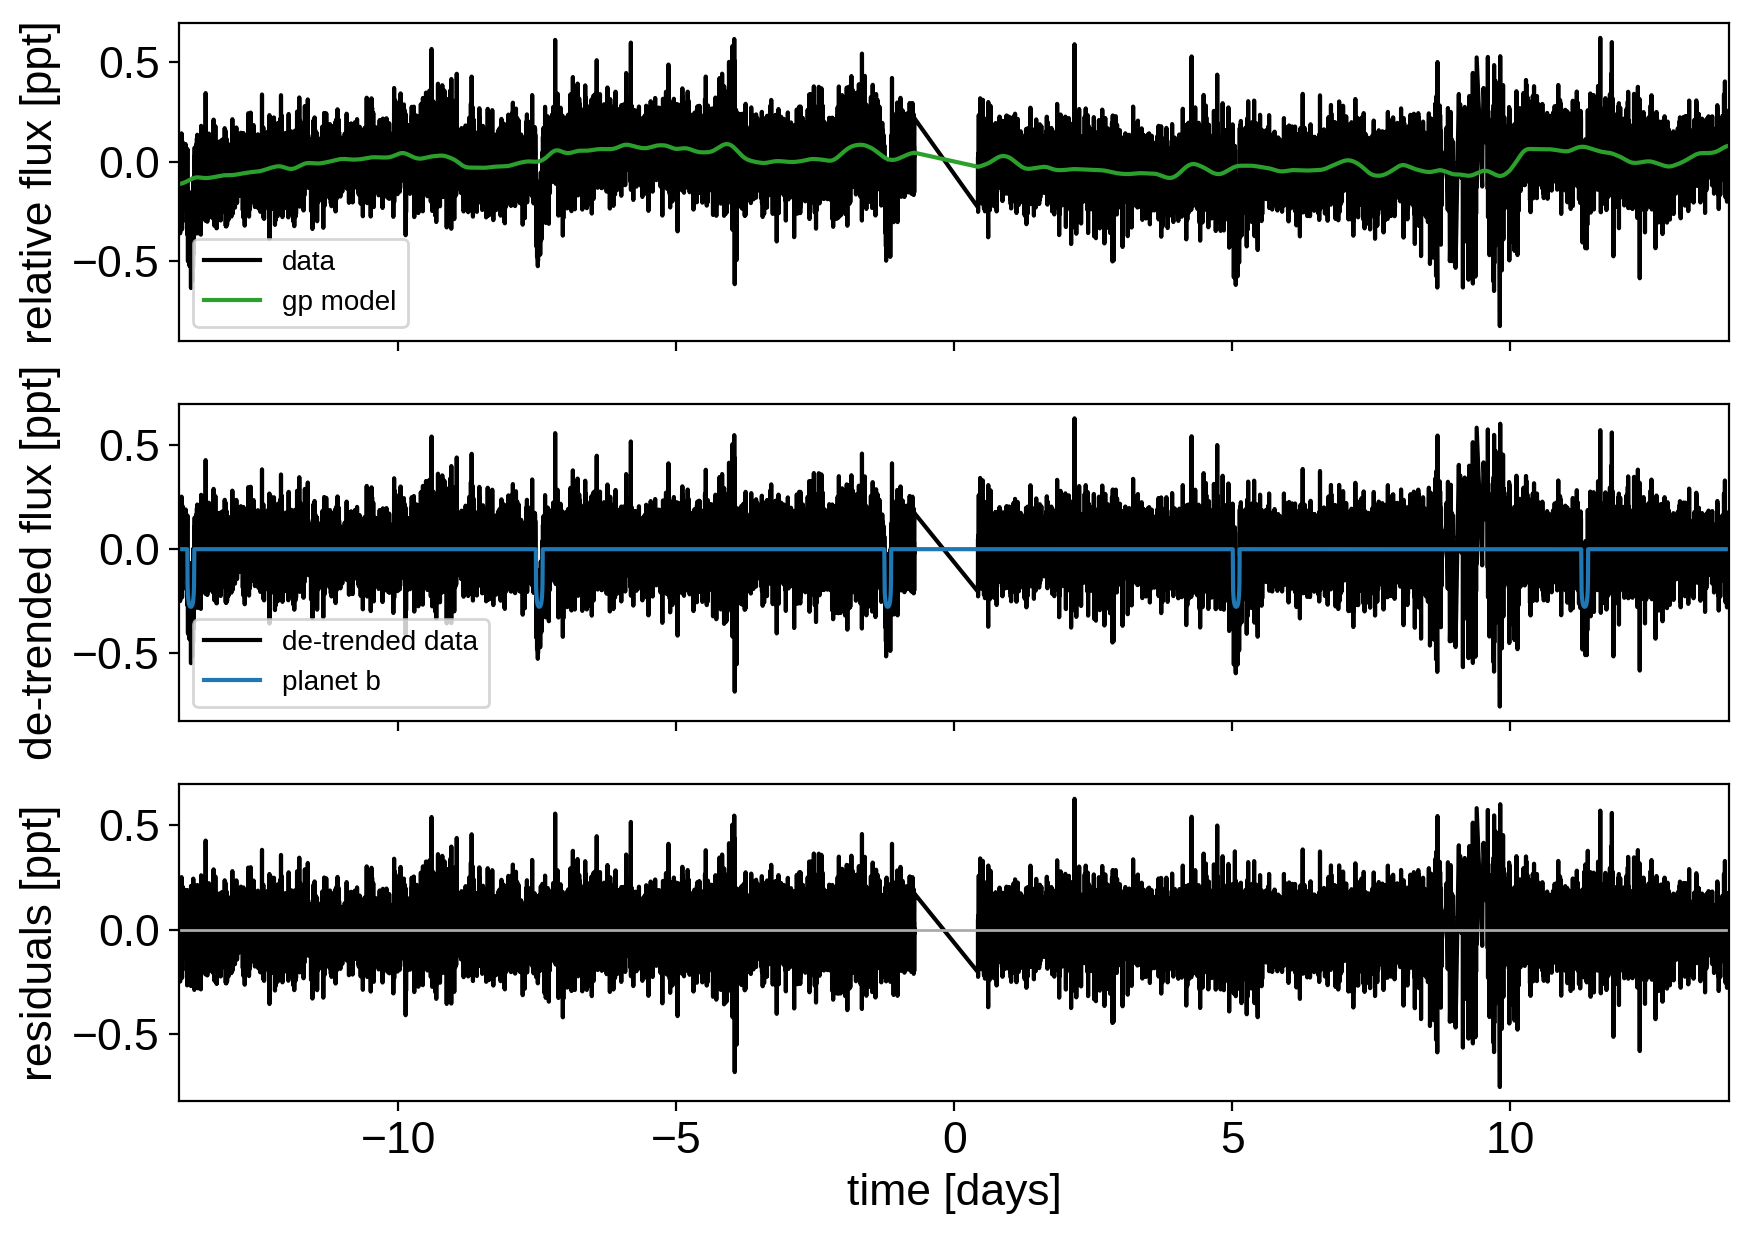

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

As in the :ref:`together` tutorial, we can do some sigma clipping to remove significant outliers.

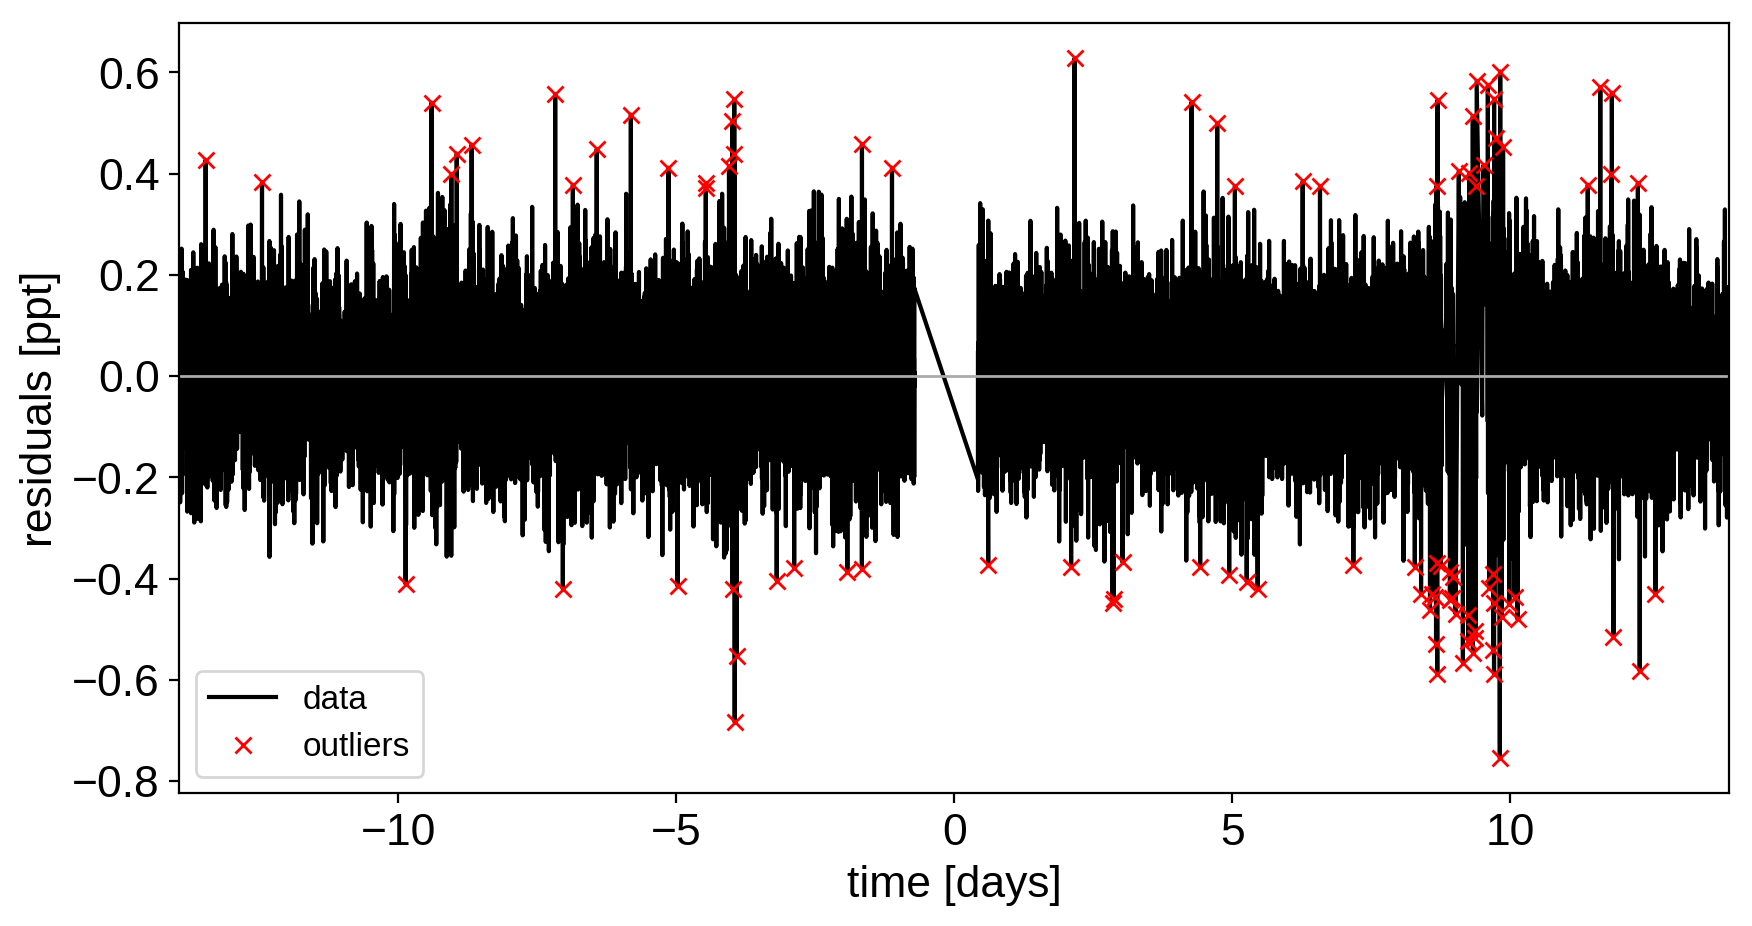

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

And then we re-build the model using the data without outliers.

optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.370934e+04]

1it [00:00, 52.26it/s, logp=1.370934e+04]

2it [00:00, 71.49it/s, logp=1.370934e+04]

3it [00:00, 81.08it/s, logp=8.425669e+03]

4it [00:00, 86.98it/s, logp=1.374004e+04]

5it [00:00, 90.44it/s, logp=1.237207e+04]

6it [00:00, 93.38it/s, logp=1.374004e+04]

7it [00:00, 95.49it/s, logp=1.374004e+04]

8it [00:00, 97.04it/s, logp=1.374007e+04]

9it [00:00, 98.34it/s, logp=1.374014e+04]

10it [00:00, 99.02it/s, logp=1.374025e+04]

11it [00:00, 107.92it/s, logp=1.374025e+04]

11it [00:00, 107.92it/s, logp=1.374030e+04]

12it [00:00, 107.92it/s, logp=1.374030e+04]

13it [00:00, 107.92it/s, logp=1.374030e+04]

14it [00:00, 107.92it/s, logp=1.374030e+04]

15it [00:01, 10.71it/s, logp=1.374030e+04] 


message: Optimization terminated successfully.
logp: 13709.337756067558 -> 13740.297129125755


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374030e+04]

1it [00:00, 56.51it/s, logp=1.374030e+04]

2it [00:00, 78.35it/s, logp=1.374030e+04]

3it [00:00, 91.84it/s, logp=-1.310442e+04]

4it [00:00, 102.16it/s, logp=1.357230e+04]

5it [00:00, 109.00it/s, logp=1.374032e+04]

6it [00:00, 113.55it/s, logp=1.374032e+04]

7it [00:00, 117.43it/s, logp=1.374032e+04]

8it [00:01,  6.99it/s, logp=1.374032e+04] 


message: Optimization terminated successfully.
logp: 13740.297129125758 -> 13740.317229932978


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374032e+04]

1it [00:00, 67.55it/s, logp=1.374032e+04]

2it [00:00, 90.00it/s, logp=1.374032e+04]

3it [00:00, 97.18it/s, logp=1.281975e+04]

4it [00:00, 104.48it/s, logp=1.374031e+04]

5it [00:00, 109.69it/s, logp=1.374032e+04]

6it [00:00, 112.73it/s, logp=1.374031e+04]

7it [00:00, 114.75it/s, logp=1.374032e+04]

8it [00:00, 117.40it/s, logp=1.374032e+04]

9it [00:00, 119.83it/s, logp=1.374032e+04]

10it [00:00, 121.61it/s, logp=1.374032e+04]

11it [00:00, 123.34it/s, logp=1.374032e+04]

12it [00:00, 124.48it/s, logp=1.374032e+04]

13it [00:00, 125.38it/s, logp=1.374032e+04]

14it [00:00, 133.76it/s, logp=1.374032e+04]

14it [00:00, 133.76it/s, logp=1.374032e+04]

15it [00:00, 133.76it/s, logp=1.374032e+04]

16it [00:00, 133.76it/s, logp=1.374032e+04]

17it [00:00, 133.76it/s, logp=1.374032e+04]

18it [00:00, 133.76it/s, logp=1.374032e+04]

19it [00:00, 133.76it/s, logp=1.374032e+04]

20it [00:00, 133.76it/s, logp=1.374032e+04]

21it [00:00, 133.76it/s, logp=1.374032e+04]

22it [00:00, 133.76it/s, logp=1.374032e+04]

23it [00:00, 133.76it/s, logp=1.374032e+04]

24it [00:00, 133.76it/s, logp=1.374032e+04]

25it [00:00, 133.76it/s, logp=1.374032e+04]

26it [00:00, 133.76it/s, logp=1.374032e+04]

27it [00:00, 133.76it/s, logp=1.374032e+04]

28it [00:00, 135.09it/s, logp=1.374032e+04]

28it [00:00, 135.09it/s, logp=1.374032e+04]

29it [00:01, 23.25it/s, logp=1.374032e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 13740.317229932978 -> 13740.318317156272


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374032e+04]

1it [00:00, 67.39it/s, logp=1.374032e+04]

2it [00:00, 93.50it/s, logp=1.374032e+04]

3it [00:00, 110.80it/s, logp=1.310203e+04]

4it [00:00, 120.64it/s, logp=1.292804e+04]

5it [00:00, 126.55it/s, logp=1.273499e+04]

6it [00:00, 125.65it/s, logp=1.372147e+04]

7it [00:00, 125.20it/s, logp=1.374032e+04]

8it [00:00, 126.03it/s, logp=1.374032e+04]

9it [00:00, 127.54it/s, logp=1.374033e+04]

10it [00:00, 128.49it/s, logp=1.374033e+04]

11it [00:00, 129.28it/s, logp=1.374033e+04]

12it [00:00, 130.06it/s, logp=1.374033e+04]

13it [00:00, 130.50it/s, logp=1.374033e+04]

14it [00:00, 139.58it/s, logp=1.374033e+04]

14it [00:00, 139.58it/s, logp=1.374033e+04]

15it [00:01, 13.41it/s, logp=1.374033e+04] 


message: Optimization terminated successfully.
logp: 13740.31831715628 -> 13740.326927441381


optimizing logp for variables: [u_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374033e+04]

1it [00:00, 64.83it/s, logp=1.374033e+04]

2it [00:00, 91.61it/s, logp=1.374033e+04]

3it [00:00, 105.33it/s, logp=1.373995e+04]

4it [00:00, 114.36it/s, logp=1.374035e+04]

5it [00:00, 116.58it/s, logp=1.374035e+04]

6it [00:00, 121.00it/s, logp=1.374035e+04]

7it [00:00, 124.29it/s, logp=1.374035e+04]

8it [00:01,  5.34it/s, logp=1.374035e+04] 


message: Optimization terminated successfully.
logp: 13740.326927441381 -> 13740.350391960192


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374035e+04]

1it [00:00, 63.35it/s, logp=1.374035e+04]

2it [00:00, 87.89it/s, logp=1.374035e+04]

3it [00:00, 100.08it/s, logp=-1.331080e+04]

4it [00:00, 108.04it/s, logp=1.356942e+04] 

5it [00:00, 113.82it/s, logp=1.374035e+04]

6it [00:00, 118.18it/s, logp=1.374035e+04]

7it [00:00, 121.59it/s, logp=1.374035e+04]

8it [00:01,  6.05it/s, logp=1.374035e+04] 


message: Optimization terminated successfully.
logp: 13740.350391960188 -> 13740.353904909165


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374035e+04]

1it [00:00, 73.41it/s, logp=1.374035e+04]

2it [00:00, 98.66it/s, logp=1.374035e+04]

3it [00:00, 111.89it/s, logp=7.885904e+03]

4it [00:00, 118.75it/s, logp=1.372311e+04]

5it [00:00, 123.26it/s, logp=1.374036e+04]

6it [00:00, 125.65it/s, logp=1.374033e+04]

7it [00:00, 128.08it/s, logp=1.374036e+04]

8it [00:00, 129.85it/s, logp=1.374036e+04]

9it [00:00, 131.39it/s, logp=1.374036e+04]

10it [00:00, 132.54it/s, logp=1.374036e+04]

11it [00:00, 133.41it/s, logp=1.374036e+04]

12it [00:00, 134.28it/s, logp=1.374036e+04]

13it [00:01, 11.31it/s, logp=1.374036e+04] 


message: Optimization terminated successfully.
logp: 13740.353904909165 -> 13740.362784313404


optimizing logp for variables: [omega, ecc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374036e+04]

1it [00:00, 70.16it/s, logp=1.374036e+04]

2it [00:00, 93.49it/s, logp=1.374036e+04]

3it [00:00, 104.36it/s, logp=1.374009e+04]

4it [00:00, 110.77it/s, logp=1.374036e+04]

5it [00:00, 113.94it/s, logp=1.374036e+04]

6it [00:00, 112.75it/s, logp=1.374036e+04]

7it [00:00, 113.98it/s, logp=1.374036e+04]

8it [00:00, 116.60it/s, logp=1.374036e+04]

9it [00:00, 118.50it/s, logp=1.374036e+04]

10it [00:00, 120.13it/s, logp=1.374036e+04]

11it [00:00, 121.20it/s, logp=1.374036e+04]

12it [00:00, 121.50it/s, logp=1.374036e+04]

13it [00:00, 121.60it/s, logp=1.374036e+04]

14it [00:00, 129.90it/s, logp=1.374036e+04]

14it [00:00, 129.90it/s, logp=1.374036e+04]

15it [00:00, 129.90it/s, logp=1.374036e+04]

16it [00:00, 129.90it/s, logp=1.374036e+04]

17it [00:00, 129.90it/s, logp=1.374036e+04]

18it [00:00, 129.90it/s, logp=1.374036e+04]

19it [00:00, 129.90it/s, logp=1.374036e+04]

20it [00:00, 129.90it/s, logp=1.374036e+04]

21it [00:00, 129.90it/s, logp=1.374036e+04]

22it [00:00, 129.90it/s, logp=1.374036e+04]

23it [00:00, 129.90it/s, logp=1.374036e+04]

24it [00:00, 129.90it/s, logp=1.374036e+04]

25it [00:00, 129.90it/s, logp=1.374036e+04]

26it [00:00, 129.90it/s, logp=1.374036e+04]

27it [00:00, 129.90it/s, logp=1.374036e+04]

28it [00:00, 131.38it/s, logp=1.374036e+04]

28it [00:00, 131.38it/s, logp=1.374036e+04]

29it [00:00, 131.38it/s, logp=1.374036e+04]

30it [00:00, 131.38it/s, logp=1.374036e+04]

31it [00:00, 131.38it/s, logp=1.374036e+04]

32it [00:00, 131.38it/s, logp=1.374036e+04]

33it [00:00, 131.38it/s, logp=1.374036e+04]

34it [00:00, 131.38it/s, logp=1.374036e+04]

35it [00:00, 131.38it/s, logp=1.374036e+04]

36it [00:00, 131.38it/s, logp=1.374036e+04]

37it [00:00, 131.38it/s, logp=1.374036e+04]

38it [00:00, 131.38it/s, logp=1.374036e+04]

39it [00:00, 131.38it/s, logp=1.374036e+04]

40it [00:00, 131.38it/s, logp=1.374036e+04]

41it [00:00, 131.38it/s, logp=1.374036e+04]

42it [00:00, 133.50it/s, logp=1.374036e+04]

42it [00:00, 133.50it/s, logp=1.374036e+04]

43it [00:00, 133.50it/s, logp=1.374036e+04]

44it [00:00, 133.50it/s, logp=1.374036e+04]

45it [00:00, 133.50it/s, logp=1.374036e+04]

46it [00:00, 133.50it/s, logp=1.374036e+04]

47it [00:00, 133.50it/s, logp=1.374036e+04]

48it [00:00, 133.50it/s, logp=1.374036e+04]

49it [00:00, 133.50it/s, logp=1.374036e+04]

50it [00:00, 133.50it/s, logp=1.374036e+04]

51it [00:00, 133.50it/s, logp=1.374036e+04]

52it [00:00, 133.50it/s, logp=1.374036e+04]

53it [00:00, 133.50it/s, logp=1.374036e+04]

54it [00:00, 133.50it/s, logp=1.374036e+04]

55it [00:00, 132.29it/s, logp=1.374036e+04]

55it [00:00, 132.29it/s, logp=1.374036e+04]

56it [00:00, 132.29it/s, logp=1.374036e+04]

57it [00:00, 132.29it/s, logp=1.374036e+04]

58it [00:00, 132.29it/s, logp=1.374036e+04]

59it [00:00, 132.29it/s, logp=1.374036e+04]

60it [00:00, 132.29it/s, logp=1.374036e+04]

61it [00:00, 132.29it/s, logp=1.374036e+04]

62it [00:00, 132.29it/s, logp=1.374036e+04]

63it [00:00, 132.29it/s, logp=1.374036e+04]

64it [00:00, 132.29it/s, logp=1.374036e+04]

65it [00:00, 132.29it/s, logp=1.374036e+04]

66it [00:01, 43.13it/s, logp=1.374036e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 13740.362784313404 -> 13740.362835329439


optimizing logp for variables: [mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374036e+04]

1it [00:00, 70.48it/s, logp=1.374036e+04]

2it [00:00, 93.48it/s, logp=1.374036e+04]

3it [00:00, 105.85it/s, logp=6.544440e+03]

4it [00:00, 114.30it/s, logp=1.374037e+04]

5it [00:01,  3.75it/s, logp=1.374037e+04] 


message: Optimization terminated successfully.
logp: 13740.362835329439 -> 13740.36600504063


optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374037e+04]

1it [00:00, 56.88it/s, logp=1.374037e+04]

2it [00:00, 77.04it/s, logp=1.374037e+04]

3it [00:00, 86.52it/s, logp=1.369719e+04]

4it [00:00, 92.87it/s, logp=1.374037e+04]

5it [00:00, 96.42it/s, logp=1.374037e+04]

6it [00:00, 98.90it/s, logp=1.374037e+04]

7it [00:00, 101.08it/s, logp=1.374037e+04]

8it [00:00, 102.70it/s, logp=1.374037e+04]

9it [00:01,  6.44it/s, logp=1.374037e+04] 


message: Optimization terminated successfully.
logp: 13740.36600504063 -> 13740.366007623204


optimizing logp for variables: [logSw4, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, b, logr, t0, logP, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374037e+04]

1it [00:00, 51.35it/s, logp=1.374037e+04]

2it [00:00, 69.15it/s, logp=1.374037e+04]

3it [00:00, 80.44it/s, logp=1.312740e+04]

4it [00:00, 85.87it/s, logp=1.283655e+04]

5it [00:00, 88.62it/s, logp=1.341232e+04]

6it [00:00, 90.00it/s, logp=1.374035e+04]

7it [00:00, 90.67it/s, logp=1.374037e+04]

8it [00:00, 92.23it/s, logp=1.374037e+04]

9it [00:00, 93.27it/s, logp=1.374037e+04]

10it [00:00, 93.98it/s, logp=1.374037e+04]

11it [00:00, 102.59it/s, logp=1.374037e+04]

11it [00:00, 102.59it/s, logp=1.374037e+04]

12it [00:00, 102.59it/s, logp=1.374037e+04]

13it [00:00, 102.59it/s, logp=1.374037e+04]

14it [00:00, 102.59it/s, logp=1.374037e+04]

15it [00:00, 102.59it/s, logp=1.374037e+04]

16it [00:00, 102.59it/s, logp=1.374037e+04]

17it [00:00, 102.59it/s, logp=1.374037e+04]

18it [00:00, 102.59it/s, logp=1.374037e+04]

19it [00:00, 102.59it/s, logp=1.374037e+04]

20it [00:00, 102.59it/s, logp=1.374037e+04]

21it [00:00, 100.15it/s, logp=1.374037e+04]

21it [00:00, 100.15it/s, logp=1.374037e+04]

22it [00:00, 100.15it/s, logp=1.374037e+04]

23it [00:00, 100.15it/s, logp=1.374037e+04]

24it [00:00, 100.15it/s, logp=1.374037e+04]

25it [00:00, 100.15it/s, logp=1.374038e+04]

26it [00:00, 100.15it/s, logp=1.374038e+04]

27it [00:00, 100.15it/s, logp=1.374038e+04]

28it [00:00, 100.15it/s, logp=1.374038e+04]

29it [00:00, 100.15it/s, logp=1.374038e+04]

30it [00:00, 96.09it/s, logp=1.374038e+04] 

30it [00:00, 96.09it/s, logp=1.374038e+04]

31it [00:00, 96.09it/s, logp=1.374038e+04]

32it [00:00, 96.09it/s, logp=1.374038e+04]

33it [00:00, 96.09it/s, logp=1.374038e+04]

34it [00:00, 96.09it/s, logp=1.374038e+04]

35it [00:00, 96.09it/s, logp=1.374038e+04]

36it [00:00, 96.09it/s, logp=1.374038e+04]

37it [00:00, 96.09it/s, logp=1.374038e+04]

38it [00:00, 96.09it/s, logp=1.374038e+04]

39it [00:00, 93.45it/s, logp=1.374038e+04]

39it [00:00, 93.45it/s, logp=1.374038e+04]

40it [00:00, 93.45it/s, logp=1.374038e+04]

41it [00:00, 93.45it/s, logp=1.374038e+04]

42it [00:00, 93.45it/s, logp=1.374038e+04]

43it [00:00, 93.45it/s, logp=1.374038e+04]

44it [00:00, 93.45it/s, logp=1.374038e+04]

45it [00:00, 93.45it/s, logp=1.374038e+04]

46it [00:00, 93.45it/s, logp=1.374038e+04]

47it [00:00, 93.45it/s, logp=1.374038e+04]

48it [00:00, 93.45it/s, logp=1.374038e+04]

49it [00:00, 93.45it/s, logp=1.374038e+04]

50it [00:00, 96.56it/s, logp=1.374038e+04]

50it [00:00, 96.56it/s, logp=1.374038e+04]

51it [00:00, 96.56it/s, logp=1.374038e+04]

52it [00:00, 96.56it/s, logp=1.374038e+04]

53it [00:00, 96.56it/s, logp=1.374038e+04]

54it [00:00, 96.56it/s, logp=1.374038e+04]

55it [00:00, 96.56it/s, logp=1.374038e+04]

56it [00:00, 96.56it/s, logp=1.374038e+04]

57it [00:00, 96.56it/s, logp=1.374038e+04]

58it [00:00, 96.56it/s, logp=1.374038e+04]

59it [00:00, 96.56it/s, logp=1.374038e+04]

60it [00:00, 96.56it/s, logp=1.374038e+04]

61it [00:00, 98.34it/s, logp=1.374038e+04]

61it [00:00, 98.34it/s, logp=1.374038e+04]

62it [00:00, 98.34it/s, logp=1.374038e+04]

63it [00:00, 98.34it/s, logp=1.374038e+04]

64it [00:00, 98.34it/s, logp=1.374038e+04]

65it [00:00, 98.34it/s, logp=1.374038e+04]

66it [00:00, 98.34it/s, logp=1.374038e+04]

67it [00:00, 98.34it/s, logp=1.374038e+04]

68it [00:00, 98.34it/s, logp=1.374038e+04]

69it [00:00, 98.34it/s, logp=1.374038e+04]

70it [00:00, 95.64it/s, logp=1.374038e+04]

70it [00:00, 95.64it/s, logp=1.374038e+04]

71it [00:00, 95.64it/s, logp=1.374038e+04]

72it [00:00, 95.64it/s, logp=1.374038e+04]

73it [00:00, 95.64it/s, logp=1.374038e+04]

74it [00:00, 95.64it/s, logp=1.374038e+04]

75it [00:00, 95.64it/s, logp=1.374038e+04]

76it [00:00, 95.64it/s, logp=1.374038e+04]

77it [00:00, 95.64it/s, logp=1.374038e+04]

78it [00:00, 95.64it/s, logp=1.374038e+04]

79it [00:00, 87.35it/s, logp=1.374038e+04]

79it [00:00, 87.35it/s, logp=1.374038e+04]

80it [00:00, 87.35it/s, logp=1.374038e+04]

81it [00:00, 87.35it/s, logp=1.374038e+04]

82it [00:00, 87.35it/s, logp=1.374038e+04]

83it [00:00, 87.35it/s, logp=1.374038e+04]

84it [00:00, 87.35it/s, logp=1.374038e+04]

85it [00:00, 87.35it/s, logp=1.374038e+04]

86it [00:00, 87.35it/s, logp=1.374038e+04]

87it [00:00, 87.35it/s, logp=1.374038e+04]

88it [00:00, 87.35it/s, logp=1.374038e+04]

89it [00:00, 90.40it/s, logp=1.374038e+04]

89it [00:00, 90.40it/s, logp=1.374038e+04]

90it [00:00, 90.40it/s, logp=1.374038e+04]

91it [00:02, 37.29it/s, logp=1.374038e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 13740.3660076232 -> 13740.37793983133


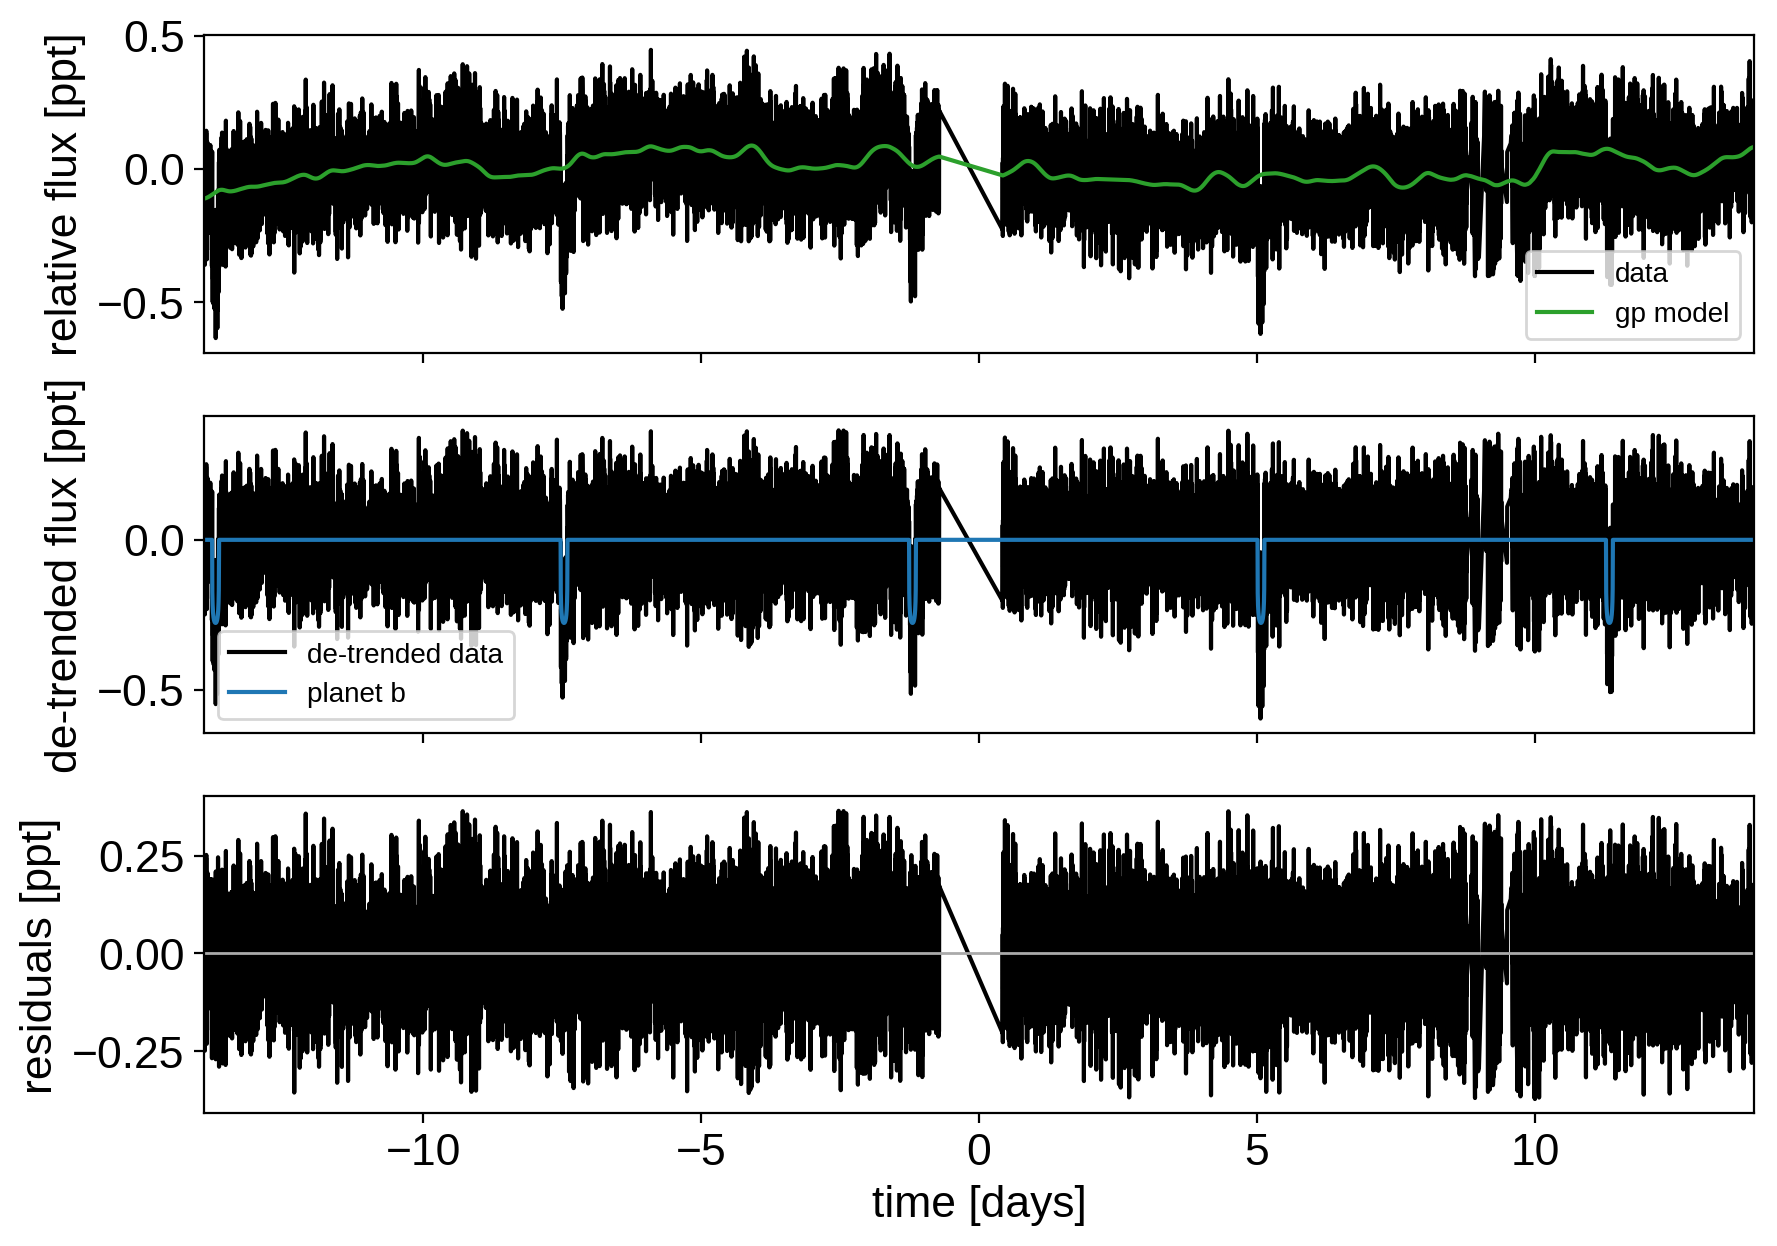

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Now that we have the model, we can sample:

In [14]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=5000, draws=3000, start=map_soln, chains=4,
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, b, logr, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 7/32000 [00:00<07:46, 68.65draws/s]

Sampling 4 chains:   0%|          | 13/32000 [00:00<21:52, 24.38draws/s]

Sampling 4 chains:   0%|          | 17/32000 [00:02<1:19:30,  6.70draws/s]

Sampling 4 chains:   0%|          | 20/32000 [00:02<1:30:20,  5.90draws/s]

Sampling 4 chains:   0%|          | 22/32000 [00:04<3:07:27,  2.84draws/s]

Sampling 4 chains:   0%|          | 23/32000 [00:04<2:38:14,  3.37draws/s]

Sampling 4 chains:   0%|          | 24/32000 [00:05<3:14:26,  2.74draws/s]

Sampling 4 chains:   0%|          | 25/32000 [00:06<6:12:44,  1.43draws/s]

Sampling 4 chains:   0%|          | 27/32000 [00:06<4:42:33,  1.89draws/s]

Sampling 4 chains:   0%|          | 28/32000 [00:07<4:34:50,  1.94draws/s]

Sampling 4 chains:   0%|          | 29/32000 [00:08<7:08:40,  1.24draws/s]

Sampling 4 chains:   0%|          | 31/32000 [00:09<5:21:52,  1.66draws/s]

Sampling 4 chains:   0%|          | 32/32000 [00:09<5:02:18,  1.76draws/s]

Sampling 4 chains:   0%|          | 33/32000 [00:11<7:28:27,  1.19draws/s]

Sampling 4 chains:   0%|          | 35/32000 [00:11<5:35:36,  1.59draws/s]

Sampling 4 chains:   0%|          | 36/32000 [00:11<5:13:53,  1.70draws/s]

Sampling 4 chains:   0%|          | 37/32000 [00:13<7:32:51,  1.18draws/s]

Sampling 4 chains:   0%|          | 38/32000 [00:13<5:48:15,  1.53draws/s]

Sampling 4 chains:   0%|          | 39/32000 [00:13<4:28:50,  1.98draws/s]

Sampling 4 chains:   0%|          | 40/32000 [00:14<4:18:31,  2.06draws/s]

Sampling 4 chains:   0%|          | 41/32000 [00:15<6:54:20,  1.29draws/s]

Sampling 4 chains:   0%|          | 42/32000 [00:15<5:26:03,  1.63draws/s]

Sampling 4 chains:   0%|          | 43/32000 [00:16<4:16:52,  2.07draws/s]

Sampling 4 chains:   0%|          | 44/32000 [00:16<3:53:01,  2.29draws/s]

Sampling 4 chains:   0%|          | 45/32000 [00:17<6:34:48,  1.35draws/s]

Sampling 4 chains:   0%|          | 46/32000 [00:18<5:33:46,  1.60draws/s]

Sampling 4 chains:   0%|          | 47/32000 [00:18<4:24:30,  2.01draws/s]

Sampling 4 chains:   0%|          | 48/32000 [00:18<3:51:53,  2.30draws/s]

Sampling 4 chains:   0%|          | 49/32000 [00:20<7:01:35,  1.26draws/s]

Sampling 4 chains:   0%|          | 50/32000 [00:20<5:21:00,  1.66draws/s]

Sampling 4 chains:   0%|          | 51/32000 [00:20<4:08:11,  2.15draws/s]

Sampling 4 chains:   0%|          | 52/32000 [00:20<3:36:19,  2.46draws/s]

Sampling 4 chains:   0%|          | 53/32000 [00:22<7:14:27,  1.23draws/s]

Sampling 4 chains:   0%|          | 55/32000 [00:22<5:23:25,  1.65draws/s]

Sampling 4 chains:   0%|          | 56/32000 [00:23<4:24:26,  2.01draws/s]

Sampling 4 chains:   0%|          | 57/32000 [00:23<4:18:57,  2.06draws/s]

Sampling 4 chains:   0%|          | 58/32000 [00:24<6:24:53,  1.38draws/s]

Sampling 4 chains:   0%|          | 59/32000 [00:25<5:08:01,  1.73draws/s]

Sampling 4 chains:   0%|          | 60/32000 [00:25<4:17:53,  2.06draws/s]

Sampling 4 chains:   0%|          | 61/32000 [00:25<4:39:46,  1.90draws/s]

Sampling 4 chains:   0%|          | 62/32000 [00:27<6:02:22,  1.47draws/s]

Sampling 4 chains:   0%|          | 63/32000 [00:27<5:06:41,  1.74draws/s]

Sampling 4 chains:   0%|          | 64/32000 [00:27<4:30:32,  1.97draws/s]

Sampling 4 chains:   0%|          | 65/32000 [00:28<4:49:16,  1.84draws/s]

Sampling 4 chains:   0%|          | 66/32000 [00:29<5:34:33,  1.59draws/s]

Sampling 4 chains:   0%|          | 67/32000 [00:29<5:19:36,  1.67draws/s]

Sampling 4 chains:   0%|          | 68/32000 [00:30<4:39:50,  1.90draws/s]

Sampling 4 chains:   0%|          | 69/32000 [00:30<4:46:57,  1.85draws/s]

Sampling 4 chains:   0%|          | 70/32000 [00:31<5:09:49,  1.72draws/s]

Sampling 4 chains:   0%|          | 71/32000 [00:32<5:28:43,  1.62draws/s]

Sampling 4 chains:   0%|          | 72/32000 [00:32<4:43:11,  1.88draws/s]

Sampling 4 chains:   0%|          | 73/32000 [00:32<4:56:42,  1.79draws/s]

Sampling 4 chains:   0%|          | 74/32000 [00:33<5:05:55,  1.74draws/s]

Sampling 4 chains:   0%|          | 75/32000 [00:34<4:55:13,  1.80draws/s]

Sampling 4 chains:   0%|          | 76/32000 [00:34<3:58:31,  2.23draws/s]

Sampling 4 chains:   0%|          | 77/32000 [00:34<3:51:57,  2.29draws/s]

Sampling 4 chains:   0%|          | 78/32000 [00:35<4:25:56,  2.00draws/s]

Sampling 4 chains:   0%|          | 79/32000 [00:36<5:31:15,  1.61draws/s]

Sampling 4 chains:   0%|          | 80/32000 [00:36<4:42:59,  1.88draws/s]

Sampling 4 chains:   0%|          | 81/32000 [00:36<4:10:54,  2.12draws/s]

Sampling 4 chains:   0%|          | 82/32000 [00:37<4:42:06,  1.89draws/s]

Sampling 4 chains:   0%|          | 83/32000 [00:38<5:08:06,  1.73draws/s]

Sampling 4 chains:   0%|          | 84/32000 [00:38<4:35:34,  1.93draws/s]

Sampling 4 chains:   0%|          | 85/32000 [00:39<4:12:16,  2.11draws/s]

Sampling 4 chains:   0%|          | 86/32000 [00:39<4:29:10,  1.98draws/s]

Sampling 4 chains:   0%|          | 87/32000 [00:40<5:29:33,  1.61draws/s]

Sampling 4 chains:   0%|          | 88/32000 [00:40<4:32:30,  1.95draws/s]

Sampling 4 chains:   0%|          | 89/32000 [00:41<4:18:34,  2.06draws/s]

Sampling 4 chains:   0%|          | 90/32000 [00:41<4:26:26,  2.00draws/s]

Sampling 4 chains:   0%|          | 91/32000 [00:42<5:11:57,  1.70draws/s]

Sampling 4 chains:   0%|          | 92/32000 [00:42<4:29:06,  1.98draws/s]

Sampling 4 chains:   0%|          | 93/32000 [00:43<4:11:04,  2.12draws/s]

Sampling 4 chains:   0%|          | 94/32000 [00:43<4:19:01,  2.05draws/s]

Sampling 4 chains:   0%|          | 95/32000 [00:44<5:01:04,  1.77draws/s]

Sampling 4 chains:   0%|          | 96/32000 [00:44<4:23:42,  2.02draws/s]

Sampling 4 chains:   0%|          | 97/32000 [00:45<4:10:12,  2.13draws/s]

Sampling 4 chains:   0%|          | 98/32000 [00:45<4:25:05,  2.01draws/s]

Sampling 4 chains:   0%|          | 99/32000 [00:46<4:51:02,  1.83draws/s]

Sampling 4 chains:   0%|          | 100/32000 [00:46<4:27:10,  1.99draws/s]

Sampling 4 chains:   0%|          | 101/32000 [00:47<4:11:58,  2.11draws/s]

Sampling 4 chains:   0%|          | 102/32000 [00:47<4:29:43,  1.97draws/s]

Sampling 4 chains:   0%|          | 103/32000 [00:48<4:44:29,  1.87draws/s]

Sampling 4 chains:   0%|          | 104/32000 [00:48<4:26:20,  2.00draws/s]

Sampling 4 chains:   0%|          | 105/32000 [00:49<4:11:13,  2.12draws/s]

Sampling 4 chains:   0%|          | 106/32000 [00:49<4:29:23,  1.97draws/s]

Sampling 4 chains:   0%|          | 107/32000 [00:50<4:40:32,  1.89draws/s]

Sampling 4 chains:   0%|          | 109/32000 [00:50<3:50:29,  2.31draws/s]

Sampling 4 chains:   0%|          | 110/32000 [00:51<3:47:57,  2.33draws/s]

Sampling 4 chains:   0%|          | 111/32000 [00:52<5:43:38,  1.55draws/s]

Sampling 4 chains:   0%|          | 112/32000 [00:52<4:27:56,  1.98draws/s]

Sampling 4 chains:   0%|          | 113/32000 [00:52<3:47:09,  2.34draws/s]

Sampling 4 chains:   0%|          | 114/32000 [00:53<3:55:12,  2.26draws/s]

Sampling 4 chains:   0%|          | 115/32000 [00:54<5:38:33,  1.57draws/s]

Sampling 4 chains:   0%|          | 117/32000 [00:54<4:20:50,  2.04draws/s]

Sampling 4 chains:   0%|          | 118/32000 [00:55<4:55:40,  1.80draws/s]

Sampling 4 chains:   0%|          | 119/32000 [00:56<6:10:39,  1.43draws/s]

Sampling 4 chains:   0%|          | 121/32000 [00:56<4:50:29,  1.83draws/s]

Sampling 4 chains:   0%|          | 122/32000 [00:57<5:18:31,  1.67draws/s]

Sampling 4 chains:   0%|          | 123/32000 [00:57<4:51:22,  1.82draws/s]

Sampling 4 chains:   0%|          | 124/32000 [00:58<5:08:07,  1.72draws/s]

Sampling 4 chains:   0%|          | 126/32000 [00:58<3:59:53,  2.21draws/s]

Sampling 4 chains:   0%|          | 127/32000 [01:00<5:52:44,  1.51draws/s]

Sampling 4 chains:   0%|          | 128/32000 [01:00<5:49:05,  1.52draws/s]

Sampling 4 chains:   0%|          | 129/32000 [01:00<4:28:26,  1.98draws/s]

Sampling 4 chains:   0%|          | 130/32000 [01:01<3:32:17,  2.50draws/s]

Sampling 4 chains:   0%|          | 131/32000 [01:02<5:34:03,  1.59draws/s]

Sampling 4 chains:   0%|          | 132/32000 [01:02<5:35:35,  1.58draws/s]

Sampling 4 chains:   0%|          | 133/32000 [01:03<4:36:32,  1.92draws/s]

Sampling 4 chains:   0%|          | 135/32000 [01:04<4:50:42,  1.83draws/s]

Sampling 4 chains:   0%|          | 136/32000 [01:04<5:04:19,  1.75draws/s]

Sampling 4 chains:   0%|          | 137/32000 [01:05<4:21:31,  2.03draws/s]

Sampling 4 chains:   0%|          | 139/32000 [01:06<4:37:52,  1.91draws/s]

Sampling 4 chains:   0%|          | 140/32000 [01:07<4:52:55,  1.81draws/s]

Sampling 4 chains:   0%|          | 141/32000 [01:07<4:14:21,  2.09draws/s]

Sampling 4 chains:   0%|          | 143/32000 [01:08<4:33:03,  1.94draws/s]

Sampling 4 chains:   0%|          | 144/32000 [01:09<4:50:10,  1.83draws/s]

Sampling 4 chains:   0%|          | 145/32000 [01:09<4:11:34,  2.11draws/s]

Sampling 4 chains:   0%|          | 147/32000 [01:10<4:31:27,  1.96draws/s]

Sampling 4 chains:   0%|          | 148/32000 [01:10<3:27:05,  2.56draws/s]

Sampling 4 chains:   0%|          | 149/32000 [01:11<3:46:00,  2.35draws/s]

Sampling 4 chains:   0%|          | 150/32000 [01:11<3:28:10,  2.55draws/s]

Sampling 4 chains:   0%|          | 151/32000 [01:12<5:33:58,  1.59draws/s]

Sampling 4 chains:   0%|          | 152/32000 [01:12<4:14:22,  2.09draws/s]

Sampling 4 chains:   0%|          | 153/32000 [01:13<4:17:25,  2.06draws/s]

Sampling 4 chains:   0%|          | 154/32000 [01:13<3:50:30,  2.30draws/s]

Sampling 4 chains:   0%|          | 155/32000 [01:14<5:51:46,  1.51draws/s]

Sampling 4 chains:   0%|          | 156/32000 [01:15<4:24:08,  2.01draws/s]

Sampling 4 chains:   0%|          | 157/32000 [01:15<4:24:37,  2.01draws/s]

Sampling 4 chains:   0%|          | 158/32000 [01:15<3:53:24,  2.27draws/s]

Sampling 4 chains:   0%|          | 159/32000 [01:17<5:58:51,  1.48draws/s]

Sampling 4 chains:   0%|          | 160/32000 [01:17<4:27:21,  1.98draws/s]

Sampling 4 chains:   1%|          | 161/32000 [01:17<4:24:41,  2.00draws/s]

Sampling 4 chains:   1%|          | 162/32000 [01:17<3:52:17,  2.28draws/s]

Sampling 4 chains:   1%|          | 163/32000 [01:19<6:00:50,  1.47draws/s]

Sampling 4 chains:   1%|          | 165/32000 [01:19<4:56:50,  1.79draws/s]

Sampling 4 chains:   1%|          | 166/32000 [01:20<4:16:02,  2.07draws/s]

Sampling 4 chains:   1%|          | 167/32000 [01:20<5:16:18,  1.68draws/s]

Sampling 4 chains:   1%|          | 168/32000 [01:21<4:49:46,  1.83draws/s]

Sampling 4 chains:   1%|          | 170/32000 [01:21<4:04:13,  2.17draws/s]

Sampling 4 chains:   1%|          | 171/32000 [01:23<5:57:53,  1.48draws/s]

Sampling 4 chains:   1%|          | 172/32000 [01:23<5:20:58,  1.65draws/s]

Sampling 4 chains:   1%|          | 174/32000 [01:24<4:23:57,  2.01draws/s]

Sampling 4 chains:   1%|          | 175/32000 [01:25<6:13:36,  1.42draws/s]

Sampling 4 chains:   1%|          | 176/32000 [01:25<5:35:32,  1.58draws/s]

Sampling 4 chains:   1%|          | 178/32000 [01:26<4:32:40,  1.95draws/s]

Sampling 4 chains:   1%|          | 179/32000 [01:27<6:20:30,  1.39draws/s]

Sampling 4 chains:   1%|          | 180/32000 [01:27<5:46:01,  1.53draws/s]

Sampling 4 chains:   1%|          | 182/32000 [01:28<4:37:18,  1.91draws/s]

Sampling 4 chains:   1%|          | 183/32000 [01:29<6:17:17,  1.41draws/s]

Sampling 4 chains:   1%|          | 185/32000 [01:29<5:07:30,  1.72draws/s]

Sampling 4 chains:   1%|          | 186/32000 [01:30<4:44:15,  1.87draws/s]

Sampling 4 chains:   1%|          | 187/32000 [01:31<6:24:17,  1.38draws/s]

Sampling 4 chains:   1%|          | 189/32000 [01:32<5:12:42,  1.70draws/s]

Sampling 4 chains:   1%|          | 190/32000 [01:32<4:40:46,  1.89draws/s]

Sampling 4 chains:   1%|          | 191/32000 [01:33<6:20:29,  1.39draws/s]

Sampling 4 chains:   1%|          | 193/32000 [01:34<5:12:51,  1.69draws/s]

Sampling 4 chains:   1%|          | 194/32000 [01:34<4:36:15,  1.92draws/s]

Sampling 4 chains:   1%|          | 195/32000 [01:35<6:19:05,  1.40draws/s]

Sampling 4 chains:   1%|          | 196/32000 [01:35<4:45:18,  1.86draws/s]

Sampling 4 chains:   1%|          | 197/32000 [01:36<4:37:01,  1.91draws/s]

Sampling 4 chains:   1%|          | 198/32000 [01:36<4:07:35,  2.14draws/s]

Sampling 4 chains:   1%|          | 199/32000 [01:37<5:59:04,  1.48draws/s]

Sampling 4 chains:   1%|          | 200/32000 [01:38<4:43:20,  1.87draws/s]

Sampling 4 chains:   1%|          | 201/32000 [01:38<4:34:45,  1.93draws/s]

Sampling 4 chains:   1%|          | 202/32000 [01:38<4:09:54,  2.12draws/s]

Sampling 4 chains:   1%|          | 203/32000 [01:40<6:33:29,  1.35draws/s]

Sampling 4 chains:   1%|          | 204/32000 [01:40<5:04:42,  1.74draws/s]

Sampling 4 chains:   1%|          | 205/32000 [01:40<4:36:08,  1.92draws/s]

Sampling 4 chains:   1%|          | 206/32000 [01:41<4:04:37,  2.17draws/s]

Sampling 4 chains:   1%|          | 207/32000 [01:42<6:14:47,  1.41draws/s]

Sampling 4 chains:   1%|          | 208/32000 [01:42<5:00:35,  1.76draws/s]

Sampling 4 chains:   1%|          | 209/32000 [01:43<4:21:29,  2.03draws/s]

Sampling 4 chains:   1%|          | 210/32000 [01:43<3:56:18,  2.24draws/s]

Sampling 4 chains:   1%|          | 211/32000 [01:44<6:08:41,  1.44draws/s]

Sampling 4 chains:   1%|          | 212/32000 [01:44<5:03:09,  1.75draws/s]

Sampling 4 chains:   1%|          | 213/32000 [01:45<4:19:09,  2.04draws/s]

Sampling 4 chains:   1%|          | 214/32000 [01:45<3:49:03,  2.31draws/s]

Sampling 4 chains:   1%|          | 215/32000 [01:45<3:14:53,  2.72draws/s]

Sampling 4 chains:   1%|          | 216/32000 [01:46<5:06:52,  1.73draws/s]

Sampling 4 chains:   1%|          | 217/32000 [01:47<5:13:13,  1.69draws/s]

Sampling 4 chains:   1%|          | 218/32000 [01:47<4:27:13,  1.98draws/s]

Sampling 4 chains:   1%|          | 219/32000 [01:48<3:51:39,  2.29draws/s]

Sampling 4 chains:   1%|          | 220/32000 [01:49<5:20:38,  1.65draws/s]

Sampling 4 chains:   1%|          | 221/32000 [01:49<5:19:19,  1.66draws/s]

Sampling 4 chains:   1%|          | 222/32000 [01:49<4:26:27,  1.99draws/s]

Sampling 4 chains:   1%|          | 223/32000 [01:50<4:04:20,  2.17draws/s]

Sampling 4 chains:   1%|          | 224/32000 [01:51<5:22:23,  1.64draws/s]

Sampling 4 chains:   1%|          | 225/32000 [01:51<5:21:51,  1.65draws/s]

Sampling 4 chains:   1%|          | 226/32000 [01:52<4:21:23,  2.03draws/s]

Sampling 4 chains:   1%|          | 227/32000 [01:52<4:16:59,  2.06draws/s]

Sampling 4 chains:   1%|          | 228/32000 [01:53<5:21:29,  1.65draws/s]

Sampling 4 chains:   1%|          | 229/32000 [01:54<5:21:28,  1.65draws/s]

Sampling 4 chains:   1%|          | 230/32000 [01:54<4:11:25,  2.11draws/s]

Sampling 4 chains:   1%|          | 231/32000 [01:54<4:22:00,  2.02draws/s]

Sampling 4 chains:   1%|          | 232/32000 [01:55<5:23:58,  1.63draws/s]

Sampling 4 chains:   1%|          | 233/32000 [01:56<5:24:05,  1.63draws/s]

Sampling 4 chains:   1%|          | 235/32000 [01:56<4:44:57,  1.86draws/s]

Sampling 4 chains:   1%|          | 236/32000 [01:57<5:34:04,  1.58draws/s]

Sampling 4 chains:   1%|          | 237/32000 [01:58<5:34:58,  1.58draws/s]

Sampling 4 chains:   1%|          | 239/32000 [01:59<4:57:57,  1.78draws/s]

Sampling 4 chains:   1%|          | 240/32000 [02:00<5:51:20,  1.51draws/s]

Sampling 4 chains:   1%|          | 241/32000 [02:00<5:46:21,  1.53draws/s]

Sampling 4 chains:   1%|          | 243/32000 [02:01<5:09:17,  1.71draws/s]

Sampling 4 chains:   1%|          | 244/32000 [02:02<5:49:27,  1.51draws/s]

Sampling 4 chains:   1%|          | 245/32000 [02:03<5:43:51,  1.54draws/s]

Sampling 4 chains:   1%|          | 247/32000 [02:04<5:24:24,  1.63draws/s]

Sampling 4 chains:   1%|          | 248/32000 [02:05<6:24:15,  1.38draws/s]

Sampling 4 chains:   1%|          | 249/32000 [02:05<5:49:24,  1.51draws/s]

Sampling 4 chains:   1%|          | 250/32000 [02:05<4:58:38,  1.77draws/s]

Sampling 4 chains:   1%|          | 251/32000 [02:06<6:04:11,  1.45draws/s]

Sampling 4 chains:   1%|          | 252/32000 [02:07<5:55:15,  1.49draws/s]

Sampling 4 chains:   1%|          | 253/32000 [02:07<4:24:43,  2.00draws/s]

Sampling 4 chains:   1%|          | 254/32000 [02:07<3:43:00,  2.37draws/s]

Sampling 4 chains:   1%|          | 255/32000 [02:08<4:31:54,  1.95draws/s]

Sampling 4 chains:   1%|          | 256/32000 [02:10<7:32:23,  1.17draws/s]

Sampling 4 chains:   1%|          | 257/32000 [02:10<5:33:20,  1.59draws/s]

Sampling 4 chains:   1%|          | 259/32000 [02:11<4:55:54,  1.79draws/s]

Sampling 4 chains:   1%|          | 260/32000 [02:13<8:18:20,  1.06draws/s]

Sampling 4 chains:   1%|          | 261/32000 [02:13<6:28:23,  1.36draws/s]

Sampling 4 chains:   1%|          | 262/32000 [02:13<5:00:49,  1.76draws/s]

Sampling 4 chains:   1%|          | 263/32000 [02:13<4:46:31,  1.85draws/s]

Sampling 4 chains:   1%|          | 264/32000 [02:15<6:20:46,  1.39draws/s]

Sampling 4 chains:   1%|          | 265/32000 [02:15<6:53:13,  1.28draws/s]

Sampling 4 chains:   1%|          | 266/32000 [02:16<5:26:04,  1.62draws/s]

Sampling 4 chains:   1%|          | 267/32000 [02:16<4:43:56,  1.86draws/s]

Sampling 4 chains:   1%|          | 268/32000 [02:18<7:05:02,  1.24draws/s]

Sampling 4 chains:   1%|          | 269/32000 [02:18<7:02:05,  1.25draws/s]

Sampling 4 chains:   1%|          | 271/32000 [02:19<5:27:36,  1.61draws/s]

Sampling 4 chains:   1%|          | 272/32000 [02:20<8:04:14,  1.09draws/s]

Sampling 4 chains:   1%|          | 273/32000 [02:21<7:19:08,  1.20draws/s]

Sampling 4 chains:   1%|          | 274/32000 [02:21<5:37:20,  1.57draws/s]

Sampling 4 chains:   1%|          | 275/32000 [02:21<4:45:07,  1.85draws/s]

Sampling 4 chains:   1%|          | 276/32000 [02:23<7:36:36,  1.16draws/s]

Sampling 4 chains:   1%|          | 277/32000 [02:24<7:01:43,  1.25draws/s]

Sampling 4 chains:   1%|          | 278/32000 [02:24<5:17:49,  1.66draws/s]

Sampling 4 chains:   1%|          | 279/32000 [02:24<4:18:23,  2.05draws/s]

Sampling 4 chains:   1%|          | 280/32000 [02:26<7:38:02,  1.15draws/s]

Sampling 4 chains:   1%|          | 281/32000 [02:26<7:07:46,  1.24draws/s]

Sampling 4 chains:   1%|          | 282/32000 [02:27<5:20:40,  1.65draws/s]

Sampling 4 chains:   1%|          | 284/32000 [02:29<6:14:55,  1.41draws/s]

Sampling 4 chains:   1%|          | 285/32000 [02:29<6:03:33,  1.45draws/s]

Sampling 4 chains:   1%|          | 286/32000 [02:29<4:39:52,  1.89draws/s]

Sampling 4 chains:   1%|          | 287/32000 [02:29<3:34:26,  2.46draws/s]

Sampling 4 chains:   1%|          | 288/32000 [02:31<7:53:39,  1.12draws/s]

Sampling 4 chains:   1%|          | 289/32000 [02:32<6:45:01,  1.30draws/s]

Sampling 4 chains:   1%|          | 291/32000 [02:32<4:57:52,  1.77draws/s]

Sampling 4 chains:   1%|          | 292/32000 [02:34<8:54:54,  1.01s/draws]

Sampling 4 chains:   1%|          | 293/32000 [02:35<7:33:48,  1.16draws/s]

Sampling 4 chains:   1%|          | 295/32000 [02:35<5:31:51,  1.59draws/s]

Sampling 4 chains:   1%|          | 296/32000 [02:37<9:14:39,  1.05s/draws]

Sampling 4 chains:   1%|          | 297/32000 [02:37<7:55:09,  1.11draws/s]

Sampling 4 chains:   1%|          | 299/32000 [02:38<5:43:59,  1.54draws/s]

Sampling 4 chains:   1%|          | 300/32000 [02:40<9:49:50,  1.12s/draws]

Sampling 4 chains:   1%|          | 301/32000 [02:40<7:52:20,  1.12draws/s]

Sampling 4 chains:   1%|          | 302/32000 [02:40<5:53:03,  1.50draws/s]

Sampling 4 chains:   1%|          | 304/32000 [02:43<7:22:26,  1.19draws/s]

Sampling 4 chains:   1%|          | 305/32000 [02:43<5:45:55,  1.53draws/s]

Sampling 4 chains:   1%|          | 308/32000 [02:45<6:12:35,  1.42draws/s]

Sampling 4 chains:   1%|          | 309/32000 [02:46<4:53:29,  1.80draws/s]

Sampling 4 chains:   1%|          | 310/32000 [02:46<3:51:32,  2.28draws/s]

Sampling 4 chains:   1%|          | 311/32000 [02:46<3:15:28,  2.70draws/s]

Sampling 4 chains:   1%|          | 312/32000 [02:48<8:19:51,  1.06draws/s]

Sampling 4 chains:   1%|          | 314/32000 [02:49<6:08:01,  1.43draws/s]

Sampling 4 chains:   1%|          | 315/32000 [02:49<5:06:08,  1.72draws/s]

Sampling 4 chains:   1%|          | 316/32000 [02:51<9:46:07,  1.11s/draws]

Sampling 4 chains:   1%|          | 318/32000 [02:51<7:02:17,  1.25draws/s]

Sampling 4 chains:   1%|          | 319/32000 [02:52<6:07:45,  1.44draws/s]

Sampling 4 chains:   1%|          | 320/32000 [02:54<10:22:30,  1.18s/draws]

Sampling 4 chains:   1%|          | 322/32000 [02:54<7:36:40,  1.16draws/s] 

Sampling 4 chains:   1%|          | 323/32000 [02:55<5:36:39,  1.57draws/s]

Sampling 4 chains:   1%|          | 324/32000 [02:57<10:13:32,  1.16s/draws]

Sampling 4 chains:   1%|          | 326/32000 [02:57<7:33:20,  1.16draws/s] 

Sampling 4 chains:   1%|          | 327/32000 [02:58<6:10:35,  1.42draws/s]

Sampling 4 chains:   1%|          | 328/32000 [02:59<9:28:28,  1.08s/draws]

Sampling 4 chains:   1%|          | 329/32000 [03:00<7:02:03,  1.25draws/s]

Sampling 4 chains:   1%|          | 330/32000 [03:00<6:28:59,  1.36draws/s]

Sampling 4 chains:   1%|          | 331/32000 [03:00<5:03:19,  1.74draws/s]

Sampling 4 chains:   1%|          | 332/32000 [03:02<7:59:16,  1.10draws/s]

Sampling 4 chains:   1%|          | 333/32000 [03:02<5:56:06,  1.48draws/s]

Sampling 4 chains:   1%|          | 334/32000 [03:03<5:27:29,  1.61draws/s]

Sampling 4 chains:   1%|          | 335/32000 [03:03<4:49:48,  1.82draws/s]

Sampling 4 chains:   1%|          | 336/32000 [03:05<7:59:20,  1.10draws/s]

Sampling 4 chains:   1%|          | 337/32000 [03:05<6:56:45,  1.27draws/s]

Sampling 4 chains:   1%|          | 339/32000 [03:06<5:22:47,  1.63draws/s]

Sampling 4 chains:   1%|          | 340/32000 [03:08<8:55:32,  1.01s/draws]

Sampling 4 chains:   1%|          | 341/32000 [03:08<7:19:05,  1.20draws/s]

Sampling 4 chains:   1%|          | 342/32000 [03:08<5:45:17,  1.53draws/s]

Sampling 4 chains:   1%|          | 343/32000 [03:08<4:18:58,  2.04draws/s]

Sampling 4 chains:   1%|          | 344/32000 [03:11<8:28:45,  1.04draws/s]

Sampling 4 chains:   1%|          | 345/32000 [03:11<7:22:28,  1.19draws/s]

Sampling 4 chains:   1%|          | 346/32000 [03:11<5:30:21,  1.60draws/s]

Sampling 4 chains:   1%|          | 348/32000 [03:13<6:34:40,  1.34draws/s]

Sampling 4 chains:   1%|          | 349/32000 [03:14<5:26:51,  1.61draws/s]

Sampling 4 chains:   1%|          | 350/32000 [03:14<4:58:37,  1.77draws/s]

Sampling 4 chains:   1%|          | 351/32000 [03:14<3:45:56,  2.33draws/s]

Sampling 4 chains:   1%|          | 352/32000 [03:16<7:51:29,  1.12draws/s]

Sampling 4 chains:   1%|          | 353/32000 [03:17<6:53:35,  1.28draws/s]

Sampling 4 chains:   1%|          | 354/32000 [03:17<5:08:30,  1.71draws/s]

Sampling 4 chains:   1%|          | 355/32000 [03:17<4:03:16,  2.17draws/s]

Sampling 4 chains:   1%|          | 356/32000 [03:19<7:49:41,  1.12draws/s]

Sampling 4 chains:   1%|          | 357/32000 [03:20<7:35:50,  1.16draws/s]

Sampling 4 chains:   1%|          | 360/32000 [03:22<7:01:50,  1.25draws/s]

Sampling 4 chains:   1%|          | 361/32000 [03:22<7:01:42,  1.25draws/s]

Sampling 4 chains:   1%|          | 362/32000 [03:23<5:30:10,  1.60draws/s]

Sampling 4 chains:   1%|          | 364/32000 [03:24<6:18:28,  1.39draws/s]

Sampling 4 chains:   1%|          | 365/32000 [03:25<6:46:02,  1.30draws/s]

Sampling 4 chains:   1%|          | 367/32000 [03:26<4:55:56,  1.78draws/s]

Sampling 4 chains:   1%|          | 368/32000 [03:27<8:06:15,  1.08draws/s]

Sampling 4 chains:   1%|          | 369/32000 [03:28<8:50:33,  1.01s/draws]

Sampling 4 chains:   1%|          | 372/32000 [03:30<7:31:25,  1.17draws/s]

Sampling 4 chains:   1%|          | 373/32000 [03:31<9:03:27,  1.03s/draws]

Sampling 4 chains:   1%|          | 374/32000 [03:32<6:40:41,  1.32draws/s]

Sampling 4 chains:   1%|          | 375/32000 [03:32<4:58:59,  1.76draws/s]

Sampling 4 chains:   1%|          | 376/32000 [03:33<6:10:31,  1.42draws/s]

Sampling 4 chains:   1%|          | 377/32000 [03:34<8:11:21,  1.07draws/s]

Sampling 4 chains:   1%|          | 378/32000 [03:34<6:16:26,  1.40draws/s]

Sampling 4 chains:   1%|          | 379/32000 [03:35<5:45:59,  1.52draws/s]

Sampling 4 chains:   1%|          | 380/32000 [03:36<6:01:08,  1.46draws/s]

Sampling 4 chains:   1%|          | 381/32000 [03:37<7:23:11,  1.19draws/s]

Sampling 4 chains:   1%|          | 382/32000 [03:37<5:51:25,  1.50draws/s]

Sampling 4 chains:   1%|          | 383/32000 [03:38<6:15:06,  1.40draws/s]

Sampling 4 chains:   1%|          | 384/32000 [03:39<6:34:00,  1.34draws/s]

Sampling 4 chains:   1%|          | 385/32000 [03:40<6:53:34,  1.27draws/s]

Sampling 4 chains:   1%|          | 386/32000 [03:40<5:47:06,  1.52draws/s]

Sampling 4 chains:   1%|          | 387/32000 [03:41<5:42:57,  1.54draws/s]

Sampling 4 chains:   1%|          | 388/32000 [03:42<6:19:34,  1.39draws/s]

Sampling 4 chains:   1%|          | 389/32000 [03:42<6:18:01,  1.39draws/s]

Sampling 4 chains:   1%|          | 390/32000 [03:43<6:32:53,  1.34draws/s]

Sampling 4 chains:   1%|          | 391/32000 [03:43<4:59:59,  1.76draws/s]

Sampling 4 chains:   1%|          | 392/32000 [03:44<6:51:34,  1.28draws/s]

Sampling 4 chains:   1%|          | 393/32000 [03:45<6:03:25,  1.45draws/s]

Sampling 4 chains:   1%|          | 394/32000 [03:46<5:59:10,  1.47draws/s]

Sampling 4 chains:   1%|          | 395/32000 [03:46<5:37:34,  1.56draws/s]

Sampling 4 chains:   1%|          | 396/32000 [03:47<6:08:38,  1.43draws/s]

Sampling 4 chains:   1%|          | 397/32000 [03:48<6:04:13,  1.45draws/s]

Sampling 4 chains:   1%|          | 398/32000 [03:48<5:59:07,  1.47draws/s]

Sampling 4 chains:   1%|▏         | 400/32000 [03:50<6:32:12,  1.34draws/s]

Sampling 4 chains:   1%|▏         | 401/32000 [03:50<5:13:12,  1.68draws/s]

Sampling 4 chains:   1%|▏         | 403/32000 [03:51<4:34:36,  1.92draws/s]

Sampling 4 chains:   1%|▏         | 404/32000 [03:52<6:39:21,  1.32draws/s]

Sampling 4 chains:   1%|▏         | 405/32000 [03:53<5:58:25,  1.47draws/s]

Sampling 4 chains:   1%|▏         | 407/32000 [03:54<5:23:04,  1.63draws/s]

Sampling 4 chains:   1%|▏         | 408/32000 [03:54<5:21:51,  1.64draws/s]

Sampling 4 chains:   1%|▏         | 409/32000 [03:55<6:36:36,  1.33draws/s]

Sampling 4 chains:   1%|▏         | 410/32000 [03:56<5:05:36,  1.72draws/s]

Sampling 4 chains:   1%|▏         | 411/32000 [03:56<5:29:08,  1.60draws/s]

Sampling 4 chains:   1%|▏         | 412/32000 [03:57<5:08:18,  1.71draws/s]

Sampling 4 chains:   1%|▏         | 413/32000 [03:58<6:37:59,  1.32draws/s]

Sampling 4 chains:   1%|▏         | 414/32000 [03:58<5:14:44,  1.67draws/s]

Sampling 4 chains:   1%|▏         | 415/32000 [03:59<4:37:06,  1.90draws/s]

Sampling 4 chains:   1%|▏         | 416/32000 [04:00<6:33:37,  1.34draws/s]

Sampling 4 chains:   1%|▏         | 417/32000 [04:01<6:27:26,  1.36draws/s]

Sampling 4 chains:   1%|▏         | 419/32000 [04:01<5:12:00,  1.69draws/s]

Sampling 4 chains:   1%|▏         | 420/32000 [04:02<6:36:58,  1.33draws/s]

Sampling 4 chains:   1%|▏         | 421/32000 [04:03<5:50:06,  1.50draws/s]

Sampling 4 chains:   1%|▏         | 422/32000 [04:03<4:34:00,  1.92draws/s]

Sampling 4 chains:   1%|▏         | 423/32000 [04:03<4:26:06,  1.98draws/s]

Sampling 4 chains:   1%|▏         | 424/32000 [04:05<6:23:44,  1.37draws/s]

Sampling 4 chains:   1%|▏         | 425/32000 [04:05<4:58:17,  1.76draws/s]

Sampling 4 chains:   1%|▏         | 426/32000 [04:05<4:26:38,  1.97draws/s]

Sampling 4 chains:   1%|▏         | 427/32000 [04:06<4:20:17,  2.02draws/s]

Sampling 4 chains:   1%|▏         | 428/32000 [04:07<6:43:27,  1.30draws/s]

Sampling 4 chains:   1%|▏         | 429/32000 [04:07<5:10:06,  1.70draws/s]

Sampling 4 chains:   1%|▏         | 430/32000 [04:07<4:12:35,  2.08draws/s]

Sampling 4 chains:   1%|▏         | 431/32000 [04:08<4:12:40,  2.08draws/s]

Sampling 4 chains:   1%|▏         | 432/32000 [04:09<6:57:05,  1.26draws/s]

Sampling 4 chains:   1%|▏         | 433/32000 [04:10<5:35:33,  1.57draws/s]

Sampling 4 chains:   1%|▏         | 435/32000 [04:10<4:35:27,  1.91draws/s]

Sampling 4 chains:   1%|▏         | 436/32000 [04:12<7:31:29,  1.17draws/s]

Sampling 4 chains:   1%|▏         | 437/32000 [04:12<5:56:59,  1.47draws/s]

Sampling 4 chains:   1%|▏         | 438/32000 [04:12<4:31:23,  1.94draws/s]

Sampling 4 chains:   1%|▏         | 439/32000 [04:13<3:54:13,  2.25draws/s]

Sampling 4 chains:   1%|▏         | 440/32000 [04:14<7:15:37,  1.21draws/s]

Sampling 4 chains:   1%|▏         | 441/32000 [04:15<5:46:01,  1.52draws/s]

Sampling 4 chains:   1%|▏         | 442/32000 [04:15<4:40:24,  1.88draws/s]

Sampling 4 chains:   1%|▏         | 444/32000 [04:17<5:45:58,  1.52draws/s]

Sampling 4 chains:   1%|▏         | 445/32000 [04:17<4:43:47,  1.85draws/s]

Sampling 4 chains:   1%|▏         | 446/32000 [04:17<3:50:51,  2.28draws/s]

Sampling 4 chains:   1%|▏         | 447/32000 [04:17<3:03:51,  2.86draws/s]

Sampling 4 chains:   1%|▏         | 448/32000 [04:19<6:51:26,  1.28draws/s]

Sampling 4 chains:   1%|▏         | 449/32000 [04:19<5:30:37,  1.59draws/s]

Sampling 4 chains:   1%|▏         | 450/32000 [04:19<4:07:25,  2.13draws/s]

Sampling 4 chains:   1%|▏         | 451/32000 [04:20<3:47:09,  2.31draws/s]

Sampling 4 chains:   1%|▏         | 452/32000 [04:21<7:03:18,  1.24draws/s]

Sampling 4 chains:   1%|▏         | 453/32000 [04:22<5:40:35,  1.54draws/s]

Sampling 4 chains:   1%|▏         | 455/32000 [04:22<4:42:25,  1.86draws/s]

Sampling 4 chains:   1%|▏         | 456/32000 [04:24<7:25:27,  1.18draws/s]

Sampling 4 chains:   1%|▏         | 457/32000 [04:24<5:50:11,  1.50draws/s]

Sampling 4 chains:   1%|▏         | 459/32000 [04:25<5:01:32,  1.74draws/s]

Sampling 4 chains:   1%|▏         | 460/32000 [04:26<7:20:33,  1.19draws/s]

Sampling 4 chains:   1%|▏         | 461/32000 [04:26<5:36:30,  1.56draws/s]

Sampling 4 chains:   1%|▏         | 462/32000 [04:27<4:16:06,  2.05draws/s]

Sampling 4 chains:   1%|▏         | 463/32000 [04:27<4:59:43,  1.75draws/s]

Sampling 4 chains:   1%|▏         | 464/32000 [04:29<7:35:11,  1.15draws/s]

Sampling 4 chains:   1%|▏         | 466/32000 [04:29<5:35:05,  1.57draws/s]

Sampling 4 chains:   1%|▏         | 467/32000 [04:30<6:13:12,  1.41draws/s]

Sampling 4 chains:   1%|▏         | 468/32000 [04:31<8:13:05,  1.07draws/s]

Sampling 4 chains:   1%|▏         | 469/32000 [04:32<6:09:59,  1.42draws/s]

Sampling 4 chains:   1%|▏         | 470/32000 [04:32<4:44:51,  1.84draws/s]

Sampling 4 chains:   1%|▏         | 471/32000 [04:33<5:15:15,  1.67draws/s]

Sampling 4 chains:   1%|▏         | 472/32000 [04:34<7:41:59,  1.14draws/s]

Sampling 4 chains:   1%|▏         | 473/32000 [04:34<6:08:00,  1.43draws/s]

Sampling 4 chains:   1%|▏         | 474/32000 [04:34<4:40:07,  1.88draws/s]

Sampling 4 chains:   1%|▏         | 475/32000 [04:35<5:16:07,  1.66draws/s]

Sampling 4 chains:   1%|▏         | 476/32000 [04:36<6:54:23,  1.27draws/s]

Sampling 4 chains:   1%|▏         | 477/32000 [04:37<6:17:40,  1.39draws/s]

Sampling 4 chains:   1%|▏         | 478/32000 [04:37<4:46:47,  1.83draws/s]

Sampling 4 chains:   1%|▏         | 479/32000 [04:38<5:04:45,  1.72draws/s]

Sampling 4 chains:   2%|▏         | 480/32000 [04:39<6:56:29,  1.26draws/s]

Sampling 4 chains:   2%|▏         | 481/32000 [04:40<6:24:12,  1.37draws/s]

Sampling 4 chains:   2%|▏         | 482/32000 [04:40<4:57:42,  1.76draws/s]

Sampling 4 chains:   2%|▏         | 483/32000 [04:40<4:50:12,  1.81draws/s]

Sampling 4 chains:   2%|▏         | 484/32000 [04:42<6:41:35,  1.31draws/s]

Sampling 4 chains:   2%|▏         | 485/32000 [04:42<6:40:46,  1.31draws/s]

Sampling 4 chains:   2%|▏         | 487/32000 [04:43<5:27:55,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 488/32000 [04:44<7:02:00,  1.24draws/s]

Sampling 4 chains:   2%|▏         | 489/32000 [04:45<6:51:34,  1.28draws/s]

Sampling 4 chains:   2%|▏         | 490/32000 [04:45<5:13:48,  1.67draws/s]

Sampling 4 chains:   2%|▏         | 491/32000 [04:46<5:05:37,  1.72draws/s]

Sampling 4 chains:   2%|▏         | 492/32000 [04:47<6:44:05,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 493/32000 [04:48<6:40:35,  1.31draws/s]

Sampling 4 chains:   2%|▏         | 494/32000 [04:48<5:16:07,  1.66draws/s]

Sampling 4 chains:   2%|▏         | 495/32000 [04:48<4:48:12,  1.82draws/s]

Sampling 4 chains:   2%|▏         | 496/32000 [04:50<7:14:55,  1.21draws/s]

Sampling 4 chains:   2%|▏         | 497/32000 [04:51<7:03:25,  1.24draws/s]

Sampling 4 chains:   2%|▏         | 498/32000 [04:51<5:52:23,  1.49draws/s]

Sampling 4 chains:   2%|▏         | 499/32000 [04:51<4:54:42,  1.78draws/s]

Sampling 4 chains:   2%|▏         | 500/32000 [04:53<7:41:41,  1.14draws/s]

Sampling 4 chains:   2%|▏         | 501/32000 [04:53<6:38:21,  1.32draws/s]

Sampling 4 chains:   2%|▏         | 502/32000 [04:54<5:56:11,  1.47draws/s]

Sampling 4 chains:   2%|▏         | 503/32000 [04:54<5:14:08,  1.67draws/s]

Sampling 4 chains:   2%|▏         | 504/32000 [04:56<7:28:23,  1.17draws/s]

Sampling 4 chains:   2%|▏         | 505/32000 [04:56<6:33:35,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 506/32000 [04:57<5:50:26,  1.50draws/s]

Sampling 4 chains:   2%|▏         | 507/32000 [04:57<4:54:02,  1.79draws/s]

Sampling 4 chains:   2%|▏         | 508/32000 [04:58<7:26:49,  1.17draws/s]

Sampling 4 chains:   2%|▏         | 509/32000 [04:59<6:28:40,  1.35draws/s]

Sampling 4 chains:   2%|▏         | 510/32000 [05:00<6:02:42,  1.45draws/s]

Sampling 4 chains:   2%|▏         | 511/32000 [05:00<5:12:12,  1.68draws/s]

Sampling 4 chains:   2%|▏         | 512/32000 [05:02<9:03:56,  1.04s/draws]

Sampling 4 chains:   2%|▏         | 514/32000 [05:02<6:49:47,  1.28draws/s]

Sampling 4 chains:   2%|▏         | 515/32000 [05:03<6:12:02,  1.41draws/s]

Sampling 4 chains:   2%|▏         | 516/32000 [05:05<9:08:46,  1.05s/draws]

Sampling 4 chains:   2%|▏         | 517/32000 [05:05<7:49:53,  1.12draws/s]

Sampling 4 chains:   2%|▏         | 518/32000 [05:05<5:59:39,  1.46draws/s]

Sampling 4 chains:   2%|▏         | 519/32000 [05:06<5:06:56,  1.71draws/s]

Sampling 4 chains:   2%|▏         | 520/32000 [05:08<8:24:23,  1.04draws/s]

Sampling 4 chains:   2%|▏         | 521/32000 [05:08<8:07:16,  1.08draws/s]

Sampling 4 chains:   2%|▏         | 522/32000 [05:09<5:58:20,  1.46draws/s]

Sampling 4 chains:   2%|▏         | 523/32000 [05:09<4:39:28,  1.88draws/s]

Sampling 4 chains:   2%|▏         | 524/32000 [05:11<8:27:11,  1.03draws/s]

Sampling 4 chains:   2%|▏         | 525/32000 [05:12<8:26:10,  1.04draws/s]

Sampling 4 chains:   2%|▏         | 526/32000 [05:12<6:12:17,  1.41draws/s]

Sampling 4 chains:   2%|▏         | 528/32000 [05:14<6:45:49,  1.29draws/s]

Sampling 4 chains:   2%|▏         | 529/32000 [05:15<7:27:28,  1.17draws/s]

Sampling 4 chains:   2%|▏         | 532/32000 [05:17<6:53:58,  1.27draws/s]

Sampling 4 chains:   2%|▏         | 533/32000 [05:18<7:44:09,  1.13draws/s]

Sampling 4 chains:   2%|▏         | 534/32000 [05:18<5:53:01,  1.49draws/s]

Sampling 4 chains:   2%|▏         | 536/32000 [05:20<6:16:36,  1.39draws/s]

Sampling 4 chains:   2%|▏         | 537/32000 [05:21<7:36:51,  1.15draws/s]

Sampling 4 chains:   2%|▏         | 538/32000 [05:21<5:49:06,  1.50draws/s]

Sampling 4 chains:   2%|▏         | 539/32000 [05:21<4:25:15,  1.98draws/s]

Sampling 4 chains:   2%|▏         | 540/32000 [05:23<6:52:10,  1.27draws/s]

Sampling 4 chains:   2%|▏         | 541/32000 [05:24<8:09:04,  1.07draws/s]

Sampling 4 chains:   2%|▏         | 542/32000 [05:24<6:08:11,  1.42draws/s]

Sampling 4 chains:   2%|▏         | 544/32000 [05:26<6:43:35,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 545/32000 [05:27<7:02:28,  1.24draws/s]

Sampling 4 chains:   2%|▏         | 546/32000 [05:27<5:51:24,  1.49draws/s]

Sampling 4 chains:   2%|▏         | 548/32000 [05:29<6:36:36,  1.32draws/s]

Sampling 4 chains:   2%|▏         | 549/32000 [05:30<6:28:27,  1.35draws/s]

Sampling 4 chains:   2%|▏         | 550/32000 [05:30<5:29:28,  1.59draws/s]

Sampling 4 chains:   2%|▏         | 552/32000 [05:32<6:35:27,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 553/32000 [05:33<5:36:00,  1.56draws/s]

Sampling 4 chains:   2%|▏         | 554/32000 [05:33<5:30:03,  1.59draws/s]

Sampling 4 chains:   2%|▏         | 555/32000 [05:33<4:27:16,  1.96draws/s]

Sampling 4 chains:   2%|▏         | 556/32000 [05:35<8:16:10,  1.06draws/s]

Sampling 4 chains:   2%|▏         | 557/32000 [05:35<6:04:59,  1.44draws/s]

Sampling 4 chains:   2%|▏         | 558/32000 [05:36<5:49:48,  1.50draws/s]

Sampling 4 chains:   2%|▏         | 559/32000 [05:37<6:03:59,  1.44draws/s]

Sampling 4 chains:   2%|▏         | 560/32000 [05:38<6:31:14,  1.34draws/s]

Sampling 4 chains:   2%|▏         | 561/32000 [05:39<7:26:33,  1.17draws/s]

Sampling 4 chains:   2%|▏         | 562/32000 [05:39<5:50:44,  1.49draws/s]

Sampling 4 chains:   2%|▏         | 563/32000 [05:40<6:10:42,  1.41draws/s]

Sampling 4 chains:   2%|▏         | 564/32000 [05:41<6:22:31,  1.37draws/s]

Sampling 4 chains:   2%|▏         | 565/32000 [05:42<7:34:04,  1.15draws/s]

Sampling 4 chains:   2%|▏         | 567/32000 [05:43<6:44:06,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 568/32000 [05:44<6:21:17,  1.37draws/s]

Sampling 4 chains:   2%|▏         | 569/32000 [05:44<6:26:16,  1.36draws/s]

Sampling 4 chains:   2%|▏         | 570/32000 [05:45<5:35:51,  1.56draws/s]

Sampling 4 chains:   2%|▏         | 571/32000 [05:45<4:16:35,  2.04draws/s]

Sampling 4 chains:   2%|▏         | 572/32000 [05:46<5:23:14,  1.62draws/s]

Sampling 4 chains:   2%|▏         | 573/32000 [05:46<5:06:02,  1.71draws/s]

Sampling 4 chains:   2%|▏         | 574/32000 [05:47<6:05:39,  1.43draws/s]

Sampling 4 chains:   2%|▏         | 575/32000 [05:48<5:20:25,  1.63draws/s]

Sampling 4 chains:   2%|▏         | 576/32000 [05:49<6:32:51,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 577/32000 [05:49<5:58:46,  1.46draws/s]

Sampling 4 chains:   2%|▏         | 578/32000 [05:50<6:19:59,  1.38draws/s]

Sampling 4 chains:   2%|▏         | 580/32000 [05:51<5:27:29,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 582/32000 [05:52<4:50:00,  1.81draws/s]

Sampling 4 chains:   2%|▏         | 583/32000 [05:52<4:27:42,  1.96draws/s]

Sampling 4 chains:   2%|▏         | 584/32000 [05:52<3:27:14,  2.53draws/s]

Sampling 4 chains:   2%|▏         | 585/32000 [05:53<4:47:41,  1.82draws/s]

Sampling 4 chains:   2%|▏         | 587/32000 [05:54<4:09:46,  2.10draws/s]

Sampling 4 chains:   2%|▏         | 588/32000 [05:54<3:13:26,  2.71draws/s]

Sampling 4 chains:   2%|▏         | 589/32000 [05:55<4:36:16,  1.89draws/s]

Sampling 4 chains:   2%|▏         | 590/32000 [05:55<5:09:04,  1.69draws/s]

Sampling 4 chains:   2%|▏         | 591/32000 [05:56<5:20:01,  1.64draws/s]

Sampling 4 chains:   2%|▏         | 593/32000 [05:57<4:40:08,  1.87draws/s]

Sampling 4 chains:   2%|▏         | 595/32000 [05:58<4:39:11,  1.87draws/s]

Sampling 4 chains:   2%|▏         | 596/32000 [05:58<4:36:53,  1.89draws/s]

Sampling 4 chains:   2%|▏         | 597/32000 [05:59<3:46:11,  2.31draws/s]

Sampling 4 chains:   2%|▏         | 598/32000 [05:59<4:05:04,  2.14draws/s]

Sampling 4 chains:   2%|▏         | 599/32000 [06:01<8:15:54,  1.06draws/s]

Sampling 4 chains:   2%|▏         | 600/32000 [06:02<6:36:49,  1.32draws/s]

Sampling 4 chains:   2%|▏         | 602/32000 [06:02<5:15:15,  1.66draws/s]

Sampling 4 chains:   2%|▏         | 603/32000 [06:02<4:46:10,  1.83draws/s]

Sampling 4 chains:   2%|▏         | 604/32000 [06:03<4:21:40,  2.00draws/s]

Sampling 4 chains:   2%|▏         | 605/32000 [06:03<3:26:09,  2.54draws/s]

Sampling 4 chains:   2%|▏         | 606/32000 [06:04<5:36:45,  1.55draws/s]

Sampling 4 chains:   2%|▏         | 607/32000 [06:04<4:23:28,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 608/32000 [06:05<4:00:03,  2.18draws/s]

Sampling 4 chains:   2%|▏         | 609/32000 [06:05<3:33:28,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 610/32000 [06:06<4:52:59,  1.79draws/s]

Sampling 4 chains:   2%|▏         | 611/32000 [06:06<3:45:10,  2.32draws/s]

Sampling 4 chains:   2%|▏         | 612/32000 [06:06<3:42:46,  2.35draws/s]

Sampling 4 chains:   2%|▏         | 613/32000 [06:07<4:40:43,  1.86draws/s]

Sampling 4 chains:   2%|▏         | 614/32000 [06:08<4:15:51,  2.04draws/s]

Sampling 4 chains:   2%|▏         | 615/32000 [06:09<6:13:12,  1.40draws/s]

Sampling 4 chains:   2%|▏         | 617/32000 [06:10<6:12:07,  1.41draws/s]

Sampling 4 chains:   2%|▏         | 618/32000 [06:11<5:49:16,  1.50draws/s]

Sampling 4 chains:   2%|▏         | 620/32000 [06:11<4:51:06,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 621/32000 [06:12<3:51:53,  2.26draws/s]

Sampling 4 chains:   2%|▏         | 623/32000 [06:12<3:14:25,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 624/32000 [06:12<2:33:34,  3.41draws/s]

Sampling 4 chains:   2%|▏         | 626/32000 [06:12<1:56:09,  4.50draws/s]

Sampling 4 chains:   2%|▏         | 627/32000 [06:12<1:58:21,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 628/32000 [06:13<2:33:39,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 629/32000 [06:13<2:39:15,  3.28draws/s]

Sampling 4 chains:   2%|▏         | 631/32000 [06:14<2:22:44,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 632/32000 [06:14<2:42:10,  3.22draws/s]

Sampling 4 chains:   2%|▏         | 633/32000 [06:15<4:53:31,  1.78draws/s]

Sampling 4 chains:   2%|▏         | 635/32000 [06:15<3:37:25,  2.40draws/s]

Sampling 4 chains:   2%|▏         | 636/32000 [06:16<3:18:53,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 637/32000 [06:16<3:31:04,  2.48draws/s]

Sampling 4 chains:   2%|▏         | 638/32000 [06:17<5:54:14,  1.48draws/s]

Sampling 4 chains:   2%|▏         | 639/32000 [06:18<5:47:25,  1.50draws/s]

Sampling 4 chains:   2%|▏         | 640/32000 [06:18<4:22:18,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 641/32000 [06:19<5:16:09,  1.65draws/s]

Sampling 4 chains:   2%|▏         | 643/32000 [06:20<4:38:52,  1.87draws/s]

Sampling 4 chains:   2%|▏         | 645/32000 [06:20<3:53:17,  2.24draws/s]

Sampling 4 chains:   2%|▏         | 646/32000 [06:21<5:04:12,  1.72draws/s]

Sampling 4 chains:   2%|▏         | 649/32000 [06:21<3:39:39,  2.38draws/s]

Sampling 4 chains:   2%|▏         | 650/32000 [06:22<3:29:46,  2.49draws/s]

Sampling 4 chains:   2%|▏         | 651/32000 [06:22<3:15:06,  2.68draws/s]

Sampling 4 chains:   2%|▏         | 652/32000 [06:22<3:28:45,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 653/32000 [06:23<3:58:26,  2.19draws/s]

Sampling 4 chains:   2%|▏         | 654/32000 [06:23<3:23:59,  2.56draws/s]

Sampling 4 chains:   2%|▏         | 655/32000 [06:24<4:55:50,  1.77draws/s]

Sampling 4 chains:   2%|▏         | 656/32000 [06:24<4:02:24,  2.16draws/s]

Sampling 4 chains:   2%|▏         | 657/32000 [06:26<6:38:38,  1.31draws/s]

Sampling 4 chains:   2%|▏         | 658/32000 [06:26<5:27:08,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 659/32000 [06:27<4:39:38,  1.87draws/s]

Sampling 4 chains:   2%|▏         | 660/32000 [06:27<3:33:27,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 661/32000 [06:27<3:59:31,  2.18draws/s]

Sampling 4 chains:   2%|▏         | 662/32000 [06:27<3:07:56,  2.78draws/s]

Sampling 4 chains:   2%|▏         | 663/32000 [06:28<3:50:45,  2.26draws/s]

Sampling 4 chains:   2%|▏         | 664/32000 [06:29<4:30:21,  1.93draws/s]

Sampling 4 chains:   2%|▏         | 666/32000 [06:29<3:23:10,  2.57draws/s]

Sampling 4 chains:   2%|▏         | 667/32000 [06:30<4:14:00,  2.06draws/s]

Sampling 4 chains:   2%|▏         | 668/32000 [06:30<3:56:18,  2.21draws/s]

Sampling 4 chains:   2%|▏         | 669/32000 [06:30<3:04:24,  2.83draws/s]

Sampling 4 chains:   2%|▏         | 670/32000 [06:30<2:37:21,  3.32draws/s]

Sampling 4 chains:   2%|▏         | 671/32000 [06:30<2:27:54,  3.53draws/s]

Sampling 4 chains:   2%|▏         | 672/32000 [06:31<2:24:34,  3.61draws/s]

Sampling 4 chains:   2%|▏         | 673/32000 [06:31<2:05:20,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 674/32000 [06:31<2:17:27,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 675/32000 [06:31<2:17:54,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 676/32000 [06:32<1:53:36,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 677/32000 [06:32<1:48:03,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 678/32000 [06:32<1:47:44,  4.84draws/s]

Sampling 4 chains:   2%|▏         | 679/32000 [06:32<2:00:02,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 681/32000 [06:33<2:00:57,  4.32draws/s]

Sampling 4 chains:   2%|▏         | 682/32000 [06:33<1:50:55,  4.71draws/s]

Sampling 4 chains:   2%|▏         | 684/32000 [06:33<2:02:45,  4.25draws/s]

Sampling 4 chains:   2%|▏         | 685/32000 [06:34<1:50:55,  4.71draws/s]

Sampling 4 chains:   2%|▏         | 686/32000 [06:34<1:50:14,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 687/32000 [06:34<1:35:34,  5.46draws/s]

Sampling 4 chains:   2%|▏         | 689/32000 [06:34<1:39:29,  5.24draws/s]

Sampling 4 chains:   2%|▏         | 690/32000 [06:35<1:39:26,  5.25draws/s]

Sampling 4 chains:   2%|▏         | 691/32000 [06:35<1:25:22,  6.11draws/s]

Sampling 4 chains:   2%|▏         | 692/32000 [06:35<2:02:34,  4.26draws/s]

Sampling 4 chains:   2%|▏         | 693/32000 [06:35<1:52:06,  4.65draws/s]

Sampling 4 chains:   2%|▏         | 694/32000 [06:35<1:37:11,  5.37draws/s]

Sampling 4 chains:   2%|▏         | 695/32000 [06:36<2:40:45,  3.25draws/s]

Sampling 4 chains:   2%|▏         | 696/32000 [06:36<2:09:24,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 697/32000 [06:36<2:21:11,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 699/32000 [06:37<2:07:31,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 700/32000 [06:38<3:26:37,  2.52draws/s]

Sampling 4 chains:   2%|▏         | 703/32000 [06:38<2:31:26,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 704/32000 [06:38<3:16:54,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 706/32000 [06:39<2:56:43,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 707/32000 [06:40<4:49:38,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 708/32000 [06:40<4:07:37,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 709/32000 [06:40<3:20:35,  2.60draws/s]

Sampling 4 chains:   2%|▏         | 711/32000 [06:41<2:52:26,  3.02draws/s]

Sampling 4 chains:   2%|▏         | 712/32000 [06:41<2:30:04,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 714/32000 [06:41<2:17:32,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 715/32000 [06:41<1:53:01,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 717/32000 [06:42<2:11:10,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 718/32000 [06:43<3:21:57,  2.58draws/s]

Sampling 4 chains:   2%|▏         | 721/32000 [06:43<2:31:59,  3.43draws/s]

Sampling 4 chains:   2%|▏         | 722/32000 [06:43<3:12:56,  2.70draws/s]

Sampling 4 chains:   2%|▏         | 724/32000 [06:44<2:31:10,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 725/32000 [06:44<2:13:06,  3.92draws/s]

Sampling 4 chains:   2%|▏         | 726/32000 [06:44<2:20:51,  3.70draws/s]

Sampling 4 chains:   2%|▏         | 727/32000 [06:44<1:58:09,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 728/32000 [06:45<2:05:31,  4.15draws/s]

Sampling 4 chains:   2%|▏         | 729/32000 [06:45<2:04:19,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 730/32000 [06:45<1:47:17,  4.86draws/s]

Sampling 4 chains:   2%|▏         | 732/32000 [06:46<1:59:09,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 735/32000 [06:46<2:00:06,  4.34draws/s]

Sampling 4 chains:   2%|▏         | 737/32000 [06:46<1:32:04,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 739/32000 [06:47<1:31:09,  5.72draws/s]

Sampling 4 chains:   2%|▏         | 740/32000 [06:47<1:33:19,  5.58draws/s]

Sampling 4 chains:   2%|▏         | 742/32000 [06:47<1:17:48,  6.70draws/s]

Sampling 4 chains:   2%|▏         | 743/32000 [06:47<1:20:27,  6.48draws/s]

Sampling 4 chains:   2%|▏         | 744/32000 [06:47<1:19:05,  6.59draws/s]

Sampling 4 chains:   2%|▏         | 745/32000 [06:48<1:33:31,  5.57draws/s]

Sampling 4 chains:   2%|▏         | 746/32000 [06:48<2:04:55,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 747/32000 [06:48<2:17:24,  3.79draws/s]

Sampling 4 chains:   2%|▏         | 748/32000 [06:49<2:16:47,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 749/32000 [06:49<2:19:55,  3.72draws/s]

Sampling 4 chains:   2%|▏         | 751/32000 [06:49<2:26:46,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 753/32000 [06:50<2:03:23,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 754/32000 [06:51<3:59:30,  2.17draws/s]

Sampling 4 chains:   2%|▏         | 755/32000 [06:51<3:25:53,  2.53draws/s]

Sampling 4 chains:   2%|▏         | 758/32000 [06:51<2:43:37,  3.18draws/s]

Sampling 4 chains:   2%|▏         | 760/32000 [06:52<2:31:00,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 761/32000 [06:52<2:09:35,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 762/32000 [06:52<1:56:39,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 763/32000 [06:52<2:11:33,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 764/32000 [06:53<1:53:21,  4.59draws/s]

Sampling 4 chains:   2%|▏         | 765/32000 [06:53<2:37:26,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 766/32000 [06:53<3:01:53,  2.86draws/s]

Sampling 4 chains:   2%|▏         | 768/32000 [06:54<2:21:01,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 769/32000 [06:54<1:58:23,  4.40draws/s]

Sampling 4 chains:   2%|▏         | 770/32000 [06:54<1:53:27,  4.59draws/s]

Sampling 4 chains:   2%|▏         | 771/32000 [06:54<1:39:13,  5.25draws/s]

Sampling 4 chains:   2%|▏         | 772/32000 [06:54<1:57:09,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 774/32000 [06:55<1:50:35,  4.71draws/s]

Sampling 4 chains:   2%|▏         | 776/32000 [06:55<1:42:07,  5.10draws/s]

Sampling 4 chains:   2%|▏         | 777/32000 [06:55<1:52:19,  4.63draws/s]

Sampling 4 chains:   2%|▏         | 778/32000 [06:56<2:07:10,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 781/32000 [06:57<2:22:03,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 782/32000 [06:57<2:16:08,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 785/32000 [06:57<1:51:45,  4.66draws/s]

Sampling 4 chains:   2%|▏         | 786/32000 [06:57<1:38:12,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 787/32000 [06:58<1:40:42,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 789/32000 [06:58<1:40:34,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 790/32000 [06:58<2:32:47,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 791/32000 [06:59<2:05:21,  4.15draws/s]

Sampling 4 chains:   2%|▏         | 793/32000 [06:59<1:46:34,  4.88draws/s]

Sampling 4 chains:   2%|▏         | 794/32000 [06:59<1:56:20,  4.47draws/s]

Sampling 4 chains:   2%|▏         | 795/32000 [06:59<1:41:35,  5.12draws/s]

Sampling 4 chains:   2%|▏         | 797/32000 [07:00<2:06:56,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 799/32000 [07:00<1:40:46,  5.16draws/s]

Sampling 4 chains:   2%|▎         | 800/32000 [07:00<1:48:58,  4.77draws/s]

Sampling 4 chains:   3%|▎         | 801/32000 [07:01<1:41:21,  5.13draws/s]

Sampling 4 chains:   3%|▎         | 802/32000 [07:01<1:34:51,  5.48draws/s]

Sampling 4 chains:   3%|▎         | 803/32000 [07:01<1:55:19,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 804/32000 [07:01<2:01:13,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 806/32000 [07:02<2:25:29,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 807/32000 [07:03<3:04:27,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 808/32000 [07:03<2:26:06,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 809/32000 [07:03<2:43:51,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 810/32000 [07:03<2:10:25,  3.99draws/s]

Sampling 4 chains:   3%|▎         | 811/32000 [07:04<3:09:39,  2.74draws/s]

Sampling 4 chains:   3%|▎         | 812/32000 [07:04<2:34:32,  3.36draws/s]

Sampling 4 chains:   3%|▎         | 813/32000 [07:04<2:50:26,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 815/32000 [07:04<2:08:05,  4.06draws/s]

Sampling 4 chains:   3%|▎         | 816/32000 [07:05<3:06:11,  2.79draws/s]

Sampling 4 chains:   3%|▎         | 817/32000 [07:06<3:34:13,  2.43draws/s]

Sampling 4 chains:   3%|▎         | 819/32000 [07:06<2:38:19,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 820/32000 [07:06<3:12:56,  2.69draws/s]

Sampling 4 chains:   3%|▎         | 821/32000 [07:06<2:31:33,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 822/32000 [07:06<2:07:58,  4.06draws/s]

Sampling 4 chains:   3%|▎         | 823/32000 [07:07<2:29:18,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 825/32000 [07:07<2:08:57,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 826/32000 [07:08<2:32:20,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 828/32000 [07:08<2:04:51,  4.16draws/s]

Sampling 4 chains:   3%|▎         | 829/32000 [07:08<2:16:04,  3.82draws/s]

Sampling 4 chains:   3%|▎         | 830/32000 [07:08<2:24:02,  3.61draws/s]

Sampling 4 chains:   3%|▎         | 831/32000 [07:09<2:42:03,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 832/32000 [07:09<2:26:56,  3.54draws/s]

Sampling 4 chains:   3%|▎         | 834/32000 [07:10<2:21:10,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 835/32000 [07:10<2:03:42,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 836/32000 [07:10<2:15:32,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 837/32000 [07:11<3:15:12,  2.66draws/s]

Sampling 4 chains:   3%|▎         | 838/32000 [07:11<2:43:19,  3.18draws/s]

Sampling 4 chains:   3%|▎         | 839/32000 [07:11<2:16:11,  3.81draws/s]

Sampling 4 chains:   3%|▎         | 840/32000 [07:11<2:25:51,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 841/32000 [07:12<2:30:53,  3.44draws/s]

Sampling 4 chains:   3%|▎         | 842/32000 [07:12<2:45:04,  3.15draws/s]

Sampling 4 chains:   3%|▎         | 843/32000 [07:12<2:14:15,  3.87draws/s]

Sampling 4 chains:   3%|▎         | 844/32000 [07:12<1:55:24,  4.50draws/s]

Sampling 4 chains:   3%|▎         | 846/32000 [07:13<2:10:19,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 847/32000 [07:13<2:00:47,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 848/32000 [07:13<1:44:42,  4.96draws/s]

Sampling 4 chains:   3%|▎         | 850/32000 [07:14<1:39:22,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 851/32000 [07:14<2:49:54,  3.06draws/s]

Sampling 4 chains:   3%|▎         | 852/32000 [07:14<2:27:10,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 853/32000 [07:14<2:01:35,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 855/32000 [07:15<1:52:06,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 856/32000 [07:15<2:09:47,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 857/32000 [07:15<2:19:12,  3.73draws/s]

Sampling 4 chains:   3%|▎         | 858/32000 [07:16<2:05:20,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 859/32000 [07:16<3:24:27,  2.54draws/s]

Sampling 4 chains:   3%|▎         | 860/32000 [07:17<3:19:11,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 861/32000 [07:17<3:07:56,  2.76draws/s]

Sampling 4 chains:   3%|▎         | 863/32000 [07:18<3:41:17,  2.35draws/s]

Sampling 4 chains:   3%|▎         | 864/32000 [07:18<2:53:45,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 866/32000 [07:19<3:17:50,  2.62draws/s]

Sampling 4 chains:   3%|▎         | 867/32000 [07:20<3:17:20,  2.63draws/s]

Sampling 4 chains:   3%|▎         | 868/32000 [07:20<3:42:12,  2.34draws/s]

Sampling 4 chains:   3%|▎         | 869/32000 [07:21<4:07:14,  2.10draws/s]

Sampling 4 chains:   3%|▎         | 870/32000 [07:21<3:18:38,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 871/32000 [07:22<3:39:08,  2.37draws/s]

Sampling 4 chains:   3%|▎         | 873/32000 [07:22<3:01:22,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 874/32000 [07:22<2:47:01,  3.11draws/s]

Sampling 4 chains:   3%|▎         | 876/32000 [07:23<2:48:21,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 877/32000 [07:23<2:57:15,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 878/32000 [07:23<2:41:45,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 879/32000 [07:24<3:33:17,  2.43draws/s]

Sampling 4 chains:   3%|▎         | 880/32000 [07:24<3:28:29,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 882/32000 [07:25<3:18:34,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 883/32000 [07:25<2:55:22,  2.96draws/s]

Sampling 4 chains:   3%|▎         | 884/32000 [07:26<3:02:15,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 885/32000 [07:26<2:48:17,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 886/32000 [07:26<3:02:07,  2.85draws/s]

Sampling 4 chains:   3%|▎         | 887/32000 [07:27<2:42:43,  3.19draws/s]

Sampling 4 chains:   3%|▎         | 888/32000 [07:27<2:55:25,  2.96draws/s]

Sampling 4 chains:   3%|▎         | 890/32000 [07:27<2:21:17,  3.67draws/s]

Sampling 4 chains:   3%|▎         | 892/32000 [07:28<2:11:16,  3.95draws/s]

Sampling 4 chains:   3%|▎         | 894/32000 [07:28<2:22:25,  3.64draws/s]

Sampling 4 chains:   3%|▎         | 895/32000 [07:29<2:11:34,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 897/32000 [07:29<2:05:39,  4.13draws/s]

Sampling 4 chains:   3%|▎         | 898/32000 [07:30<3:07:28,  2.76draws/s]

Sampling 4 chains:   3%|▎         | 900/32000 [07:30<2:26:34,  3.54draws/s]

Sampling 4 chains:   3%|▎         | 902/32000 [07:30<2:16:43,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 904/32000 [07:31<2:25:40,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 906/32000 [07:31<2:01:26,  4.27draws/s]

Sampling 4 chains:   3%|▎         | 907/32000 [07:32<2:26:54,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 909/32000 [07:32<1:56:40,  4.44draws/s]

Sampling 4 chains:   3%|▎         | 911/32000 [07:32<1:51:58,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 913/32000 [07:32<1:37:46,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 914/32000 [07:33<2:09:06,  4.01draws/s]

Sampling 4 chains:   3%|▎         | 916/32000 [07:33<1:40:04,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 917/32000 [07:33<1:29:01,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 918/32000 [07:33<2:13:19,  3.89draws/s]

Sampling 4 chains:   3%|▎         | 920/32000 [07:34<2:19:09,  3.72draws/s]

Sampling 4 chains:   3%|▎         | 922/32000 [07:34<1:47:43,  4.81draws/s]

Sampling 4 chains:   3%|▎         | 924/32000 [07:35<1:59:23,  4.34draws/s]

Sampling 4 chains:   3%|▎         | 925/32000 [07:35<3:02:39,  2.84draws/s]

Sampling 4 chains:   3%|▎         | 926/32000 [07:36<3:47:09,  2.28draws/s]

Sampling 4 chains:   3%|▎         | 927/32000 [07:37<4:15:38,  2.03draws/s]

Sampling 4 chains:   3%|▎         | 928/32000 [07:37<3:16:09,  2.64draws/s]

Sampling 4 chains:   3%|▎         | 930/32000 [07:37<2:34:34,  3.35draws/s]

Sampling 4 chains:   3%|▎         | 931/32000 [07:38<3:28:58,  2.48draws/s]

Sampling 4 chains:   3%|▎         | 932/32000 [07:38<3:16:08,  2.64draws/s]

Sampling 4 chains:   3%|▎         | 934/32000 [07:38<2:41:53,  3.20draws/s]

Sampling 4 chains:   3%|▎         | 935/32000 [07:39<2:43:05,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 936/32000 [07:39<3:34:37,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 939/32000 [07:39<2:35:51,  3.32draws/s]

Sampling 4 chains:   3%|▎         | 941/32000 [07:40<2:38:53,  3.26draws/s]

Sampling 4 chains:   3%|▎         | 942/32000 [07:41<3:14:32,  2.66draws/s]

Sampling 4 chains:   3%|▎         | 944/32000 [07:41<2:24:18,  3.59draws/s]

Sampling 4 chains:   3%|▎         | 946/32000 [07:41<2:30:41,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 947/32000 [07:41<2:19:47,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 948/32000 [07:42<2:36:54,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 949/32000 [07:42<2:29:58,  3.45draws/s]

Sampling 4 chains:   3%|▎         | 950/32000 [07:43<3:24:27,  2.53draws/s]

Sampling 4 chains:   3%|▎         | 951/32000 [07:43<4:03:15,  2.13draws/s]

Sampling 4 chains:   3%|▎         | 952/32000 [07:44<3:40:47,  2.34draws/s]

Sampling 4 chains:   3%|▎         | 954/32000 [07:44<2:43:15,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 955/32000 [07:44<3:15:34,  2.65draws/s]

Sampling 4 chains:   3%|▎         | 957/32000 [07:44<2:26:33,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 958/32000 [07:45<3:03:29,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 960/32000 [07:45<2:18:20,  3.74draws/s]

Sampling 4 chains:   3%|▎         | 961/32000 [07:46<2:56:48,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 964/32000 [07:46<2:36:53,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 965/32000 [07:46<2:11:44,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 966/32000 [07:47<2:50:35,  3.03draws/s]

Sampling 4 chains:   3%|▎         | 967/32000 [07:47<2:49:07,  3.06draws/s]

Sampling 4 chains:   3%|▎         | 968/32000 [07:48<2:47:39,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 970/32000 [07:48<2:08:35,  4.02draws/s]

Sampling 4 chains:   3%|▎         | 971/32000 [07:48<1:57:00,  4.42draws/s]

Sampling 4 chains:   3%|▎         | 972/32000 [07:48<2:25:16,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 974/32000 [07:49<1:59:29,  4.33draws/s]

Sampling 4 chains:   3%|▎         | 975/32000 [07:49<2:19:27,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 976/32000 [07:49<1:58:19,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 977/32000 [07:49<1:45:48,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 978/32000 [07:49<2:04:47,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 979/32000 [07:50<1:44:19,  4.96draws/s]

Sampling 4 chains:   3%|▎         | 980/32000 [07:50<2:38:45,  3.26draws/s]

Sampling 4 chains:   3%|▎         | 981/32000 [07:50<2:16:30,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 982/32000 [07:50<1:56:24,  4.44draws/s]

Sampling 4 chains:   3%|▎         | 983/32000 [07:51<2:14:09,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 984/32000 [07:51<1:51:54,  4.62draws/s]

Sampling 4 chains:   3%|▎         | 985/32000 [07:51<2:37:49,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 986/32000 [07:52<2:20:05,  3.69draws/s]

Sampling 4 chains:   3%|▎         | 987/32000 [07:52<2:47:19,  3.09draws/s]

Sampling 4 chains:   3%|▎         | 989/32000 [07:53<2:46:47,  3.10draws/s]

Sampling 4 chains:   3%|▎         | 990/32000 [07:53<2:23:37,  3.60draws/s]

Sampling 4 chains:   3%|▎         | 992/32000 [07:53<2:05:49,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 993/32000 [07:53<1:48:59,  4.74draws/s]

Sampling 4 chains:   3%|▎         | 995/32000 [07:54<1:31:13,  5.67draws/s]

Sampling 4 chains:   3%|▎         | 997/32000 [07:54<1:38:11,  5.26draws/s]

Sampling 4 chains:   3%|▎         | 999/32000 [07:54<1:25:56,  6.01draws/s]

Sampling 4 chains:   3%|▎         | 1000/32000 [07:55<2:37:35,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 1002/32000 [07:55<2:23:35,  3.60draws/s]

Sampling 4 chains:   3%|▎         | 1004/32000 [07:55<1:57:12,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 1006/32000 [07:56<1:54:29,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 1007/32000 [07:56<1:56:03,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 1008/32000 [07:57<2:30:35,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 1009/32000 [07:57<2:16:52,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 1011/32000 [07:57<2:06:21,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 1013/32000 [07:57<1:47:52,  4.79draws/s]

Sampling 4 chains:   3%|▎         | 1015/32000 [07:58<1:45:46,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 1017/32000 [07:58<1:33:21,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 1019/32000 [07:58<1:30:04,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 1021/32000 [07:58<1:12:23,  7.13draws/s]

Sampling 4 chains:   3%|▎         | 1022/32000 [07:59<2:12:10,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 1023/32000 [07:59<1:51:17,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 1024/32000 [07:59<1:49:08,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 1026/32000 [08:00<1:41:33,  5.08draws/s]

Sampling 4 chains:   3%|▎         | 1028/32000 [08:00<1:40:17,  5.15draws/s]

Sampling 4 chains:   3%|▎         | 1030/32000 [08:00<1:31:20,  5.65draws/s]

Sampling 4 chains:   3%|▎         | 1031/32000 [08:01<2:01:35,  4.25draws/s]

Sampling 4 chains:   3%|▎         | 1033/32000 [08:01<1:46:11,  4.86draws/s]

Sampling 4 chains:   3%|▎         | 1035/32000 [08:01<1:43:40,  4.98draws/s]

Sampling 4 chains:   3%|▎         | 1037/32000 [08:02<2:23:05,  3.61draws/s]

Sampling 4 chains:   3%|▎         | 1039/32000 [08:03<2:09:45,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 1041/32000 [08:03<1:55:40,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 1042/32000 [08:03<2:42:03,  3.18draws/s]

Sampling 4 chains:   3%|▎         | 1044/32000 [08:04<2:30:41,  3.42draws/s]

Sampling 4 chains:   3%|▎         | 1045/32000 [08:04<2:11:57,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 1047/32000 [08:05<2:09:19,  3.99draws/s]

Sampling 4 chains:   3%|▎         | 1048/32000 [08:05<1:57:10,  4.40draws/s]

Sampling 4 chains:   3%|▎         | 1051/32000 [08:06<2:19:31,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 1052/32000 [08:06<2:08:27,  4.02draws/s]

Sampling 4 chains:   3%|▎         | 1055/32000 [08:07<1:52:46,  4.57draws/s]

Sampling 4 chains:   3%|▎         | 1056/32000 [08:07<2:58:37,  2.89draws/s]

Sampling 4 chains:   3%|▎         | 1057/32000 [08:07<2:39:30,  3.23draws/s]

Sampling 4 chains:   3%|▎         | 1060/32000 [08:08<2:13:59,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 1061/32000 [08:08<2:06:20,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 1062/32000 [08:08<2:35:34,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 1063/32000 [08:09<2:22:01,  3.63draws/s]

Sampling 4 chains:   3%|▎         | 1065/32000 [08:09<2:12:48,  3.88draws/s]

Sampling 4 chains:   3%|▎         | 1066/32000 [08:09<2:04:20,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 1067/32000 [08:10<3:06:24,  2.77draws/s]

Sampling 4 chains:   3%|▎         | 1069/32000 [08:10<2:44:30,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 1070/32000 [08:11<2:25:58,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 1072/32000 [08:11<2:17:07,  3.76draws/s]

Sampling 4 chains:   3%|▎         | 1073/32000 [08:11<2:05:37,  4.10draws/s]

Sampling 4 chains:   3%|▎         | 1075/32000 [08:12<2:02:35,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 1076/32000 [08:12<1:55:24,  4.47draws/s]

Sampling 4 chains:   3%|▎         | 1078/32000 [08:12<1:55:33,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 1079/32000 [08:13<1:50:01,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 1082/32000 [08:13<1:23:38,  6.16draws/s]

Sampling 4 chains:   3%|▎         | 1084/32000 [08:13<1:43:02,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 1086/32000 [08:14<1:41:57,  5.05draws/s]

Sampling 4 chains:   3%|▎         | 1087/32000 [08:14<1:40:23,  5.13draws/s]

Sampling 4 chains:   3%|▎         | 1089/32000 [08:14<1:21:07,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 1090/32000 [08:14<2:14:03,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 1092/32000 [08:15<1:44:41,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 1093/32000 [08:15<1:40:57,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 1094/32000 [08:15<2:22:22,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 1095/32000 [08:15<2:06:11,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 1096/32000 [08:16<2:30:52,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 1099/32000 [08:16<1:57:41,  4.38draws/s]

Sampling 4 chains:   3%|▎         | 1100/32000 [08:16<2:26:33,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 1102/32000 [08:17<2:37:21,  3.27draws/s]

Sampling 4 chains:   3%|▎         | 1104/32000 [08:17<2:02:38,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 1105/32000 [08:18<2:40:50,  3.20draws/s]

Sampling 4 chains:   3%|▎         | 1106/32000 [08:18<2:16:42,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 1107/32000 [08:18<2:51:33,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 1109/32000 [08:19<2:11:36,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 1110/32000 [08:19<2:50:20,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 1111/32000 [08:19<2:19:56,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 1112/32000 [08:20<3:00:18,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 1113/32000 [08:20<3:36:04,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 1115/32000 [08:21<2:44:29,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 1116/32000 [08:21<2:30:43,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 1118/32000 [08:21<2:35:32,  3.31draws/s]

Sampling 4 chains:   4%|▎         | 1120/32000 [08:22<2:44:18,  3.13draws/s]

Sampling 4 chains:   4%|▎         | 1121/32000 [08:23<3:25:43,  2.50draws/s]

Sampling 4 chains:   4%|▎         | 1122/32000 [08:23<3:01:53,  2.83draws/s]

Sampling 4 chains:   4%|▎         | 1123/32000 [08:23<3:17:11,  2.61draws/s]

Sampling 4 chains:   4%|▎         | 1124/32000 [08:24<2:56:50,  2.91draws/s]

Sampling 4 chains:   4%|▎         | 1125/32000 [08:24<2:57:07,  2.91draws/s]

Sampling 4 chains:   4%|▎         | 1127/32000 [08:25<2:54:18,  2.95draws/s]

Sampling 4 chains:   4%|▎         | 1129/32000 [08:25<2:25:13,  3.54draws/s]

Sampling 4 chains:   4%|▎         | 1130/32000 [08:25<2:40:45,  3.20draws/s]

Sampling 4 chains:   4%|▎         | 1131/32000 [08:26<2:25:08,  3.54draws/s]

Sampling 4 chains:   4%|▎         | 1132/32000 [08:26<1:58:31,  4.34draws/s]

Sampling 4 chains:   4%|▎         | 1133/32000 [08:26<2:12:18,  3.89draws/s]

Sampling 4 chains:   4%|▎         | 1134/32000 [08:26<2:12:32,  3.88draws/s]

Sampling 4 chains:   4%|▎         | 1135/32000 [08:27<2:34:45,  3.32draws/s]

Sampling 4 chains:   4%|▎         | 1136/32000 [08:27<2:35:10,  3.31draws/s]

Sampling 4 chains:   4%|▎         | 1137/32000 [08:27<2:43:28,  3.15draws/s]

Sampling 4 chains:   4%|▎         | 1138/32000 [08:28<2:30:38,  3.41draws/s]

Sampling 4 chains:   4%|▎         | 1139/32000 [08:28<2:51:06,  3.01draws/s]

Sampling 4 chains:   4%|▎         | 1140/32000 [08:28<2:29:41,  3.44draws/s]

Sampling 4 chains:   4%|▎         | 1142/32000 [08:29<2:20:51,  3.65draws/s]

Sampling 4 chains:   4%|▎         | 1143/32000 [08:29<2:11:27,  3.91draws/s]

Sampling 4 chains:   4%|▎         | 1145/32000 [08:29<2:09:14,  3.98draws/s]

Sampling 4 chains:   4%|▎         | 1146/32000 [08:30<2:21:25,  3.64draws/s]

Sampling 4 chains:   4%|▎         | 1147/32000 [08:30<2:52:50,  2.98draws/s]

Sampling 4 chains:   4%|▎         | 1148/32000 [08:30<2:32:58,  3.36draws/s]

Sampling 4 chains:   4%|▎         | 1149/32000 [08:31<2:49:48,  3.03draws/s]

Sampling 4 chains:   4%|▎         | 1151/32000 [08:31<2:07:54,  4.02draws/s]

Sampling 4 chains:   4%|▎         | 1152/32000 [08:31<2:56:36,  2.91draws/s]

Sampling 4 chains:   4%|▎         | 1154/32000 [08:32<2:11:31,  3.91draws/s]

Sampling 4 chains:   4%|▎         | 1155/32000 [08:32<2:58:28,  2.88draws/s]

Sampling 4 chains:   4%|▎         | 1156/32000 [08:32<2:27:56,  3.47draws/s]

Sampling 4 chains:   4%|▎         | 1157/32000 [08:33<3:02:02,  2.82draws/s]

Sampling 4 chains:   4%|▎         | 1159/32000 [08:33<2:22:53,  3.60draws/s]

Sampling 4 chains:   4%|▎         | 1160/32000 [08:33<2:35:15,  3.31draws/s]

Sampling 4 chains:   4%|▎         | 1162/32000 [08:34<2:43:58,  3.13draws/s]

Sampling 4 chains:   4%|▎         | 1165/32000 [08:35<2:30:49,  3.41draws/s]

Sampling 4 chains:   4%|▎         | 1167/32000 [08:35<2:14:29,  3.82draws/s]

Sampling 4 chains:   4%|▎         | 1168/32000 [08:35<2:15:40,  3.79draws/s]

Sampling 4 chains:   4%|▎         | 1169/32000 [08:36<2:43:20,  3.15draws/s]

Sampling 4 chains:   4%|▎         | 1170/32000 [08:36<2:28:37,  3.46draws/s]

Sampling 4 chains:   4%|▎         | 1171/32000 [08:37<3:23:08,  2.53draws/s]

Sampling 4 chains:   4%|▎         | 1172/32000 [08:37<3:00:56,  2.84draws/s]

Sampling 4 chains:   4%|▎         | 1173/32000 [08:37<2:52:58,  2.97draws/s]

Sampling 4 chains:   4%|▎         | 1175/32000 [08:38<2:55:32,  2.93draws/s]

Sampling 4 chains:   4%|▎         | 1178/32000 [08:39<2:37:08,  3.27draws/s]

Sampling 4 chains:   4%|▎         | 1180/32000 [08:39<2:38:54,  3.23draws/s]

Sampling 4 chains:   4%|▎         | 1182/32000 [08:40<2:39:53,  3.21draws/s]

Sampling 4 chains:   4%|▎         | 1183/32000 [08:40<2:25:27,  3.53draws/s]

Sampling 4 chains:   4%|▎         | 1184/32000 [08:40<2:40:48,  3.19draws/s]

Sampling 4 chains:   4%|▎         | 1186/32000 [08:41<2:10:09,  3.95draws/s]

Sampling 4 chains:   4%|▎         | 1187/32000 [08:42<4:10:37,  2.05draws/s]

Sampling 4 chains:   4%|▎         | 1188/32000 [08:42<3:50:52,  2.22draws/s]

Sampling 4 chains:   4%|▎         | 1190/32000 [08:42<3:04:42,  2.78draws/s]

Sampling 4 chains:   4%|▎         | 1191/32000 [08:43<3:09:30,  2.71draws/s]

Sampling 4 chains:   4%|▎         | 1192/32000 [08:43<2:44:46,  3.12draws/s]

Sampling 4 chains:   4%|▎         | 1193/32000 [08:44<3:36:40,  2.37draws/s]

Sampling 4 chains:   4%|▎         | 1194/32000 [08:44<4:08:46,  2.06draws/s]

Sampling 4 chains:   4%|▎         | 1196/32000 [08:45<3:42:31,  2.31draws/s]

Sampling 4 chains:   4%|▎         | 1197/32000 [08:46<4:08:20,  2.07draws/s]

Sampling 4 chains:   4%|▍         | 1200/32000 [08:46<3:19:48,  2.57draws/s]

Sampling 4 chains:   4%|▍         | 1201/32000 [08:46<3:13:48,  2.65draws/s]

Sampling 4 chains:   4%|▍         | 1202/32000 [08:47<3:42:16,  2.31draws/s]

Sampling 4 chains:   4%|▍         | 1203/32000 [08:47<3:49:21,  2.24draws/s]

Sampling 4 chains:   4%|▍         | 1204/32000 [08:48<4:15:26,  2.01draws/s]

Sampling 4 chains:   4%|▍         | 1205/32000 [08:48<3:39:34,  2.34draws/s]

Sampling 4 chains:   4%|▍         | 1206/32000 [08:48<2:58:09,  2.88draws/s]

Sampling 4 chains:   4%|▍         | 1208/32000 [08:49<3:08:15,  2.73draws/s]

Sampling 4 chains:   4%|▍         | 1209/32000 [08:49<2:43:48,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 1210/32000 [08:50<2:18:46,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 1211/32000 [08:50<3:21:30,  2.55draws/s]

Sampling 4 chains:   4%|▍         | 1212/32000 [08:51<2:51:50,  2.99draws/s]

Sampling 4 chains:   4%|▍         | 1214/32000 [08:51<2:37:11,  3.26draws/s]

Sampling 4 chains:   4%|▍         | 1216/32000 [08:52<2:43:09,  3.14draws/s]

Sampling 4 chains:   4%|▍         | 1219/32000 [08:52<2:23:13,  3.58draws/s]

Sampling 4 chains:   4%|▍         | 1220/32000 [08:52<1:59:13,  4.30draws/s]

Sampling 4 chains:   4%|▍         | 1223/32000 [08:53<1:49:34,  4.68draws/s]

Sampling 4 chains:   4%|▍         | 1224/32000 [08:53<1:44:14,  4.92draws/s]

Sampling 4 chains:   4%|▍         | 1225/32000 [08:54<2:36:16,  3.28draws/s]

Sampling 4 chains:   4%|▍         | 1227/32000 [08:54<2:00:10,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 1228/32000 [08:54<2:23:47,  3.57draws/s]

Sampling 4 chains:   4%|▍         | 1229/32000 [08:54<2:25:20,  3.53draws/s]

Sampling 4 chains:   4%|▍         | 1230/32000 [08:55<2:31:56,  3.38draws/s]

Sampling 4 chains:   4%|▍         | 1233/32000 [08:55<1:51:48,  4.59draws/s]

Sampling 4 chains:   4%|▍         | 1235/32000 [08:55<2:02:35,  4.18draws/s]

Sampling 4 chains:   4%|▍         | 1236/32000 [08:56<2:17:42,  3.72draws/s]

Sampling 4 chains:   4%|▍         | 1237/32000 [08:56<2:23:50,  3.56draws/s]

Sampling 4 chains:   4%|▍         | 1239/32000 [08:56<2:08:12,  4.00draws/s]

Sampling 4 chains:   4%|▍         | 1240/32000 [08:57<1:55:33,  4.44draws/s]

Sampling 4 chains:   4%|▍         | 1241/32000 [08:57<1:36:55,  5.29draws/s]

Sampling 4 chains:   4%|▍         | 1242/32000 [08:57<2:09:06,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 1243/32000 [08:57<1:47:36,  4.76draws/s]

Sampling 4 chains:   4%|▍         | 1245/32000 [08:57<1:23:38,  6.13draws/s]

Sampling 4 chains:   4%|▍         | 1247/32000 [08:58<1:37:38,  5.25draws/s]

Sampling 4 chains:   4%|▍         | 1248/32000 [08:58<1:24:43,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 1249/32000 [08:58<1:55:03,  4.45draws/s]

Sampling 4 chains:   4%|▍         | 1250/32000 [08:59<1:56:59,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 1251/32000 [08:59<2:04:36,  4.11draws/s]

Sampling 4 chains:   4%|▍         | 1252/32000 [08:59<2:02:19,  4.19draws/s]

Sampling 4 chains:   4%|▍         | 1254/32000 [08:59<1:33:53,  5.46draws/s]

Sampling 4 chains:   4%|▍         | 1255/32000 [08:59<1:33:47,  5.46draws/s]

Sampling 4 chains:   4%|▍         | 1256/32000 [09:00<2:24:53,  3.54draws/s]

Sampling 4 chains:   4%|▍         | 1257/32000 [09:00<2:44:54,  3.11draws/s]

Sampling 4 chains:   4%|▍         | 1259/32000 [09:00<2:11:16,  3.90draws/s]

Sampling 4 chains:   4%|▍         | 1260/32000 [09:01<2:34:30,  3.32draws/s]

Sampling 4 chains:   4%|▍         | 1262/32000 [09:01<2:01:55,  4.20draws/s]

Sampling 4 chains:   4%|▍         | 1263/32000 [09:02<2:35:54,  3.29draws/s]

Sampling 4 chains:   4%|▍         | 1266/32000 [09:02<1:55:19,  4.44draws/s]

Sampling 4 chains:   4%|▍         | 1268/32000 [09:02<1:59:18,  4.29draws/s]

Sampling 4 chains:   4%|▍         | 1269/32000 [09:03<2:40:22,  3.19draws/s]

Sampling 4 chains:   4%|▍         | 1270/32000 [09:03<2:11:16,  3.90draws/s]

Sampling 4 chains:   4%|▍         | 1273/32000 [09:03<1:57:23,  4.36draws/s]

Sampling 4 chains:   4%|▍         | 1274/32000 [09:04<2:57:01,  2.89draws/s]

Sampling 4 chains:   4%|▍         | 1275/32000 [09:04<2:21:59,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 1278/32000 [09:05<2:05:09,  4.09draws/s]

Sampling 4 chains:   4%|▍         | 1279/32000 [09:05<1:46:08,  4.82draws/s]

Sampling 4 chains:   4%|▍         | 1280/32000 [09:05<2:31:29,  3.38draws/s]

Sampling 4 chains:   4%|▍         | 1281/32000 [09:05<2:02:44,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 1283/32000 [09:06<2:01:47,  4.20draws/s]

Sampling 4 chains:   4%|▍         | 1284/32000 [09:06<1:45:33,  4.85draws/s]

Sampling 4 chains:   4%|▍         | 1285/32000 [09:06<2:21:44,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 1286/32000 [09:06<2:04:20,  4.12draws/s]

Sampling 4 chains:   4%|▍         | 1289/32000 [09:07<1:50:24,  4.64draws/s]

Sampling 4 chains:   4%|▍         | 1290/32000 [09:07<1:41:27,  5.04draws/s]

Sampling 4 chains:   4%|▍         | 1292/32000 [09:07<1:22:53,  6.17draws/s]

Sampling 4 chains:   4%|▍         | 1293/32000 [09:08<2:33:40,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 1294/32000 [09:08<2:57:15,  2.89draws/s]

Sampling 4 chains:   4%|▍         | 1296/32000 [09:08<2:16:57,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1297/32000 [09:09<2:54:45,  2.93draws/s]

Sampling 4 chains:   4%|▍         | 1299/32000 [09:09<2:35:19,  3.29draws/s]

Sampling 4 chains:   4%|▍         | 1300/32000 [09:10<2:16:58,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1301/32000 [09:10<2:37:08,  3.26draws/s]

Sampling 4 chains:   4%|▍         | 1302/32000 [09:10<2:10:36,  3.92draws/s]

Sampling 4 chains:   4%|▍         | 1303/32000 [09:10<2:05:49,  4.07draws/s]

Sampling 4 chains:   4%|▍         | 1304/32000 [09:11<1:52:11,  4.56draws/s]

Sampling 4 chains:   4%|▍         | 1305/32000 [09:11<2:43:29,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 1306/32000 [09:11<2:28:05,  3.45draws/s]

Sampling 4 chains:   4%|▍         | 1307/32000 [09:11<2:08:13,  3.99draws/s]

Sampling 4 chains:   4%|▍         | 1308/32000 [09:12<1:48:59,  4.69draws/s]

Sampling 4 chains:   4%|▍         | 1309/32000 [09:12<1:31:39,  5.58draws/s]

Sampling 4 chains:   4%|▍         | 1310/32000 [09:12<1:22:52,  6.17draws/s]

Sampling 4 chains:   4%|▍         | 1311/32000 [09:12<2:12:26,  3.86draws/s]

Sampling 4 chains:   4%|▍         | 1312/32000 [09:13<2:33:59,  3.32draws/s]

Sampling 4 chains:   4%|▍         | 1313/32000 [09:13<2:22:17,  3.59draws/s]

Sampling 4 chains:   4%|▍         | 1314/32000 [09:13<2:16:20,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 1315/32000 [09:14<2:34:48,  3.30draws/s]

Sampling 4 chains:   4%|▍         | 1316/32000 [09:14<3:09:48,  2.69draws/s]

Sampling 4 chains:   4%|▍         | 1317/32000 [09:15<3:25:12,  2.49draws/s]

Sampling 4 chains:   4%|▍         | 1318/32000 [09:15<3:02:46,  2.80draws/s]

Sampling 4 chains:   4%|▍         | 1319/32000 [09:15<3:10:01,  2.69draws/s]

Sampling 4 chains:   4%|▍         | 1320/32000 [09:15<2:32:39,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 1322/32000 [09:16<2:32:25,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 1324/32000 [09:16<2:28:04,  3.45draws/s]

Sampling 4 chains:   4%|▍         | 1325/32000 [09:17<2:03:33,  4.14draws/s]

Sampling 4 chains:   4%|▍         | 1326/32000 [09:17<3:18:34,  2.57draws/s]

Sampling 4 chains:   4%|▍         | 1327/32000 [09:18<3:22:19,  2.53draws/s]

Sampling 4 chains:   4%|▍         | 1328/32000 [09:18<2:41:02,  3.17draws/s]

Sampling 4 chains:   4%|▍         | 1329/32000 [09:19<3:44:53,  2.27draws/s]

Sampling 4 chains:   4%|▍         | 1330/32000 [09:19<2:54:32,  2.93draws/s]

Sampling 4 chains:   4%|▍         | 1331/32000 [09:19<2:48:48,  3.03draws/s]

Sampling 4 chains:   4%|▍         | 1332/32000 [09:19<2:16:20,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 1333/32000 [09:20<3:27:23,  2.46draws/s]

Sampling 4 chains:   4%|▍         | 1334/32000 [09:20<3:29:47,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 1335/32000 [09:20<2:44:56,  3.10draws/s]

Sampling 4 chains:   4%|▍         | 1336/32000 [09:20<2:10:55,  3.90draws/s]

Sampling 4 chains:   4%|▍         | 1337/32000 [09:21<4:02:10,  2.11draws/s]

Sampling 4 chains:   4%|▍         | 1338/32000 [09:22<3:18:22,  2.58draws/s]

Sampling 4 chains:   4%|▍         | 1340/32000 [09:22<3:14:24,  2.63draws/s]

Sampling 4 chains:   4%|▍         | 1341/32000 [09:23<3:21:26,  2.54draws/s]

Sampling 4 chains:   4%|▍         | 1342/32000 [09:23<2:39:19,  3.21draws/s]

Sampling 4 chains:   4%|▍         | 1343/32000 [09:24<3:29:35,  2.44draws/s]

Sampling 4 chains:   4%|▍         | 1345/32000 [09:24<3:06:22,  2.74draws/s]

Sampling 4 chains:   4%|▍         | 1346/32000 [09:24<2:28:25,  3.44draws/s]

Sampling 4 chains:   4%|▍         | 1349/32000 [09:25<2:20:18,  3.64draws/s]

Sampling 4 chains:   4%|▍         | 1350/32000 [09:25<2:46:46,  3.06draws/s]

Sampling 4 chains:   4%|▍         | 1351/32000 [09:26<2:24:42,  3.53draws/s]

Sampling 4 chains:   4%|▍         | 1353/32000 [09:26<2:29:46,  3.41draws/s]

Sampling 4 chains:   4%|▍         | 1354/32000 [09:27<2:55:07,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 1355/32000 [09:27<2:20:38,  3.63draws/s]

Sampling 4 chains:   4%|▍         | 1357/32000 [09:27<1:55:58,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 1358/32000 [09:27<2:32:47,  3.34draws/s]

Sampling 4 chains:   4%|▍         | 1359/32000 [09:28<2:56:26,  2.89draws/s]

Sampling 4 chains:   4%|▍         | 1360/32000 [09:28<2:30:50,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 1361/32000 [09:28<2:31:29,  3.37draws/s]

Sampling 4 chains:   4%|▍         | 1362/32000 [09:29<2:36:28,  3.26draws/s]

Sampling 4 chains:   4%|▍         | 1363/32000 [09:29<2:59:02,  2.85draws/s]

Sampling 4 chains:   4%|▍         | 1364/32000 [09:29<2:23:51,  3.55draws/s]

Sampling 4 chains:   4%|▍         | 1366/32000 [09:30<2:18:22,  3.69draws/s]

Sampling 4 chains:   4%|▍         | 1368/32000 [09:30<1:52:20,  4.54draws/s]

Sampling 4 chains:   4%|▍         | 1369/32000 [09:30<2:28:26,  3.44draws/s]

Sampling 4 chains:   4%|▍         | 1371/32000 [09:31<1:58:20,  4.31draws/s]

Sampling 4 chains:   4%|▍         | 1372/32000 [09:31<2:32:10,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 1373/32000 [09:31<2:15:28,  3.77draws/s]

Sampling 4 chains:   4%|▍         | 1374/32000 [09:32<2:43:12,  3.13draws/s]

Sampling 4 chains:   4%|▍         | 1375/32000 [09:32<2:13:26,  3.82draws/s]

Sampling 4 chains:   4%|▍         | 1377/32000 [09:32<2:12:52,  3.84draws/s]

Sampling 4 chains:   4%|▍         | 1378/32000 [09:33<2:00:22,  4.24draws/s]

Sampling 4 chains:   4%|▍         | 1379/32000 [09:33<2:35:32,  3.28draws/s]

Sampling 4 chains:   4%|▍         | 1380/32000 [09:33<2:35:53,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 1381/32000 [09:34<2:42:03,  3.15draws/s]

Sampling 4 chains:   4%|▍         | 1382/32000 [09:34<2:15:32,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 1383/32000 [09:34<2:07:54,  3.99draws/s]

Sampling 4 chains:   4%|▍         | 1384/32000 [09:34<2:14:17,  3.80draws/s]

Sampling 4 chains:   4%|▍         | 1386/32000 [09:35<2:23:32,  3.55draws/s]

Sampling 4 chains:   4%|▍         | 1387/32000 [09:35<1:59:26,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 1388/32000 [09:35<2:16:08,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 1389/32000 [09:36<2:02:40,  4.16draws/s]

Sampling 4 chains:   4%|▍         | 1390/32000 [09:36<3:04:40,  2.76draws/s]

Sampling 4 chains:   4%|▍         | 1391/32000 [09:36<2:26:20,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 1392/32000 [09:37<2:54:37,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 1395/32000 [09:38<2:38:12,  3.22draws/s]

Sampling 4 chains:   4%|▍         | 1396/32000 [09:38<2:06:07,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 1397/32000 [09:38<2:52:41,  2.95draws/s]

Sampling 4 chains:   4%|▍         | 1400/32000 [09:39<2:37:43,  3.23draws/s]

Sampling 4 chains:   4%|▍         | 1402/32000 [09:39<2:33:49,  3.32draws/s]

Sampling 4 chains:   4%|▍         | 1405/32000 [09:40<1:54:56,  4.44draws/s]

Sampling 4 chains:   4%|▍         | 1406/32000 [09:40<2:47:11,  3.05draws/s]

Sampling 4 chains:   4%|▍         | 1407/32000 [09:40<2:16:13,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1408/32000 [09:41<2:46:02,  3.07draws/s]

Sampling 4 chains:   4%|▍         | 1410/32000 [09:41<2:14:35,  3.79draws/s]

Sampling 4 chains:   4%|▍         | 1411/32000 [09:41<2:41:20,  3.16draws/s]

Sampling 4 chains:   4%|▍         | 1412/32000 [09:42<2:33:25,  3.32draws/s]

Sampling 4 chains:   4%|▍         | 1413/32000 [09:42<2:36:27,  3.26draws/s]

Sampling 4 chains:   4%|▍         | 1416/32000 [09:42<2:09:07,  3.95draws/s]

Sampling 4 chains:   4%|▍         | 1417/32000 [09:43<2:16:22,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1418/32000 [09:43<2:37:15,  3.24draws/s]

Sampling 4 chains:   4%|▍         | 1419/32000 [09:43<2:25:40,  3.50draws/s]

Sampling 4 chains:   4%|▍         | 1421/32000 [09:44<2:18:28,  3.68draws/s]

Sampling 4 chains:   4%|▍         | 1422/32000 [09:44<2:01:19,  4.20draws/s]

Sampling 4 chains:   4%|▍         | 1423/32000 [09:45<2:55:12,  2.91draws/s]

Sampling 4 chains:   4%|▍         | 1424/32000 [09:45<3:43:24,  2.28draws/s]

Sampling 4 chains:   4%|▍         | 1426/32000 [09:46<3:23:47,  2.50draws/s]

Sampling 4 chains:   4%|▍         | 1428/32000 [09:47<3:15:08,  2.61draws/s]

Sampling 4 chains:   4%|▍         | 1429/32000 [09:47<2:33:43,  3.31draws/s]

Sampling 4 chains:   4%|▍         | 1430/32000 [09:47<2:59:45,  2.83draws/s]

Sampling 4 chains:   4%|▍         | 1432/32000 [09:48<3:00:08,  2.83draws/s]

Sampling 4 chains:   4%|▍         | 1433/32000 [09:48<2:39:44,  3.19draws/s]

Sampling 4 chains:   4%|▍         | 1434/32000 [09:48<2:45:03,  3.09draws/s]

Sampling 4 chains:   4%|▍         | 1436/32000 [09:49<2:03:32,  4.12draws/s]

Sampling 4 chains:   4%|▍         | 1437/32000 [09:49<2:04:24,  4.09draws/s]

Sampling 4 chains:   4%|▍         | 1438/32000 [09:50<4:04:09,  2.09draws/s]

Sampling 4 chains:   4%|▍         | 1440/32000 [09:50<3:18:43,  2.56draws/s]

Sampling 4 chains:   5%|▍         | 1441/32000 [09:50<3:01:26,  2.81draws/s]

Sampling 4 chains:   5%|▍         | 1443/32000 [09:51<2:46:58,  3.05draws/s]

Sampling 4 chains:   5%|▍         | 1444/32000 [09:51<2:15:04,  3.77draws/s]

Sampling 4 chains:   5%|▍         | 1446/32000 [09:52<2:11:20,  3.88draws/s]

Sampling 4 chains:   5%|▍         | 1447/32000 [09:52<1:56:09,  4.38draws/s]

Sampling 4 chains:   5%|▍         | 1449/32000 [09:52<2:02:07,  4.17draws/s]

Sampling 4 chains:   5%|▍         | 1450/32000 [09:52<1:41:16,  5.03draws/s]

Sampling 4 chains:   5%|▍         | 1452/32000 [09:53<1:56:37,  4.37draws/s]

Sampling 4 chains:   5%|▍         | 1455/32000 [09:54<1:49:54,  4.63draws/s]

Sampling 4 chains:   5%|▍         | 1456/32000 [09:54<1:39:34,  5.11draws/s]

Sampling 4 chains:   5%|▍         | 1458/32000 [09:54<1:57:34,  4.33draws/s]

Sampling 4 chains:   5%|▍         | 1461/32000 [09:55<1:57:24,  4.34draws/s]

Sampling 4 chains:   5%|▍         | 1463/32000 [09:56<2:43:16,  3.12draws/s]

Sampling 4 chains:   5%|▍         | 1464/32000 [09:56<2:30:04,  3.39draws/s]

Sampling 4 chains:   5%|▍         | 1465/32000 [09:56<2:15:15,  3.76draws/s]

Sampling 4 chains:   5%|▍         | 1466/32000 [09:57<2:35:45,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 1467/32000 [09:57<2:35:38,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 1468/32000 [09:58<2:49:05,  3.01draws/s]

Sampling 4 chains:   5%|▍         | 1469/32000 [09:58<3:29:23,  2.43draws/s]

Sampling 4 chains:   5%|▍         | 1471/32000 [09:59<2:58:52,  2.84draws/s]

Sampling 4 chains:   5%|▍         | 1473/32000 [09:59<2:26:15,  3.48draws/s]

Sampling 4 chains:   5%|▍         | 1474/32000 [09:59<3:12:38,  2.64draws/s]

Sampling 4 chains:   5%|▍         | 1475/32000 [10:00<3:13:25,  2.63draws/s]

Sampling 4 chains:   5%|▍         | 1476/32000 [10:00<2:40:32,  3.17draws/s]

Sampling 4 chains:   5%|▍         | 1477/32000 [10:00<3:06:44,  2.72draws/s]

Sampling 4 chains:   5%|▍         | 1478/32000 [10:01<2:51:15,  2.97draws/s]

Sampling 4 chains:   5%|▍         | 1479/32000 [10:01<3:02:17,  2.79draws/s]

Sampling 4 chains:   5%|▍         | 1480/32000 [10:01<2:47:05,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 1481/32000 [10:02<2:52:53,  2.94draws/s]

Sampling 4 chains:   5%|▍         | 1482/32000 [10:02<2:40:02,  3.18draws/s]

Sampling 4 chains:   5%|▍         | 1484/32000 [10:02<2:22:54,  3.56draws/s]

Sampling 4 chains:   5%|▍         | 1485/32000 [10:03<2:41:06,  3.16draws/s]

Sampling 4 chains:   5%|▍         | 1486/32000 [10:03<2:28:18,  3.43draws/s]

Sampling 4 chains:   5%|▍         | 1487/32000 [10:03<2:22:46,  3.56draws/s]

Sampling 4 chains:   5%|▍         | 1488/32000 [10:04<2:14:25,  3.78draws/s]

Sampling 4 chains:   5%|▍         | 1489/32000 [10:04<1:59:37,  4.25draws/s]

Sampling 4 chains:   5%|▍         | 1491/32000 [10:04<2:05:23,  4.06draws/s]

Sampling 4 chains:   5%|▍         | 1492/32000 [10:05<2:21:15,  3.60draws/s]

Sampling 4 chains:   5%|▍         | 1493/32000 [10:05<2:33:17,  3.32draws/s]

Sampling 4 chains:   5%|▍         | 1496/32000 [10:06<2:22:20,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 1498/32000 [10:06<1:59:18,  4.26draws/s]

Sampling 4 chains:   5%|▍         | 1499/32000 [10:06<2:18:52,  3.66draws/s]

Sampling 4 chains:   5%|▍         | 1501/32000 [10:06<1:44:59,  4.84draws/s]

Sampling 4 chains:   5%|▍         | 1502/32000 [10:07<3:20:13,  2.54draws/s]

Sampling 4 chains:   5%|▍         | 1503/32000 [10:08<3:12:24,  2.64draws/s]

Sampling 4 chains:   5%|▍         | 1505/32000 [10:08<2:32:47,  3.33draws/s]

Sampling 4 chains:   5%|▍         | 1506/32000 [10:09<3:34:25,  2.37draws/s]

Sampling 4 chains:   5%|▍         | 1508/32000 [10:09<2:56:07,  2.89draws/s]

Sampling 4 chains:   5%|▍         | 1510/32000 [10:09<2:30:51,  3.37draws/s]

Sampling 4 chains:   5%|▍         | 1511/32000 [10:10<3:16:59,  2.58draws/s]

Sampling 4 chains:   5%|▍         | 1512/32000 [10:10<3:06:32,  2.72draws/s]

Sampling 4 chains:   5%|▍         | 1514/32000 [10:11<2:48:07,  3.02draws/s]

Sampling 4 chains:   5%|▍         | 1515/32000 [10:11<3:10:27,  2.67draws/s]

Sampling 4 chains:   5%|▍         | 1516/32000 [10:11<3:03:29,  2.77draws/s]

Sampling 4 chains:   5%|▍         | 1518/32000 [10:12<2:54:44,  2.91draws/s]

Sampling 4 chains:   5%|▍         | 1519/32000 [10:12<2:55:28,  2.90draws/s]

Sampling 4 chains:   5%|▍         | 1520/32000 [10:13<2:53:19,  2.93draws/s]

Sampling 4 chains:   5%|▍         | 1521/32000 [10:13<2:16:53,  3.71draws/s]

Sampling 4 chains:   5%|▍         | 1522/32000 [10:13<2:07:20,  3.99draws/s]

Sampling 4 chains:   5%|▍         | 1523/32000 [10:13<2:35:13,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 1524/32000 [10:14<2:20:19,  3.62draws/s]

Sampling 4 chains:   5%|▍         | 1525/32000 [10:14<2:28:32,  3.42draws/s]

Sampling 4 chains:   5%|▍         | 1526/32000 [10:14<2:03:58,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 1527/32000 [10:14<1:54:07,  4.45draws/s]

Sampling 4 chains:   5%|▍         | 1528/32000 [10:15<2:47:17,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 1530/32000 [10:15<2:28:00,  3.43draws/s]

Sampling 4 chains:   5%|▍         | 1531/32000 [10:15<2:05:02,  4.06draws/s]

Sampling 4 chains:   5%|▍         | 1532/32000 [10:16<1:52:16,  4.52draws/s]

Sampling 4 chains:   5%|▍         | 1533/32000 [10:16<2:56:30,  2.88draws/s]

Sampling 4 chains:   5%|▍         | 1535/32000 [10:17<2:40:39,  3.16draws/s]

Sampling 4 chains:   5%|▍         | 1536/32000 [10:17<2:15:10,  3.76draws/s]

Sampling 4 chains:   5%|▍         | 1537/32000 [10:17<2:50:21,  2.98draws/s]

Sampling 4 chains:   5%|▍         | 1538/32000 [10:18<2:54:03,  2.92draws/s]

Sampling 4 chains:   5%|▍         | 1539/32000 [10:18<2:22:10,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 1540/32000 [10:18<2:02:25,  4.15draws/s]

Sampling 4 chains:   5%|▍         | 1541/32000 [10:18<1:47:24,  4.73draws/s]

Sampling 4 chains:   5%|▍         | 1542/32000 [10:19<3:45:28,  2.25draws/s]

Sampling 4 chains:   5%|▍         | 1544/32000 [10:19<2:50:33,  2.98draws/s]

Sampling 4 chains:   5%|▍         | 1545/32000 [10:19<2:19:36,  3.64draws/s]

Sampling 4 chains:   5%|▍         | 1546/32000 [10:20<2:29:40,  3.39draws/s]

Sampling 4 chains:   5%|▍         | 1548/32000 [10:21<2:43:47,  3.10draws/s]

Sampling 4 chains:   5%|▍         | 1550/32000 [10:21<2:07:18,  3.99draws/s]

Sampling 4 chains:   5%|▍         | 1551/32000 [10:21<2:20:47,  3.60draws/s]

Sampling 4 chains:   5%|▍         | 1552/32000 [10:21<2:24:32,  3.51draws/s]

Sampling 4 chains:   5%|▍         | 1553/32000 [10:22<3:00:29,  2.81draws/s]

Sampling 4 chains:   5%|▍         | 1555/32000 [10:22<2:38:15,  3.21draws/s]

Sampling 4 chains:   5%|▍         | 1556/32000 [10:23<2:42:51,  3.12draws/s]

Sampling 4 chains:   5%|▍         | 1558/32000 [10:23<2:35:15,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 1559/32000 [10:23<2:03:58,  4.09draws/s]

Sampling 4 chains:   5%|▍         | 1560/32000 [10:23<1:42:35,  4.94draws/s]

Sampling 4 chains:   5%|▍         | 1561/32000 [10:24<1:42:23,  4.95draws/s]

Sampling 4 chains:   5%|▍         | 1562/32000 [10:24<1:51:00,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 1564/32000 [10:25<2:07:45,  3.97draws/s]

Sampling 4 chains:   5%|▍         | 1566/32000 [10:25<1:52:35,  4.50draws/s]

Sampling 4 chains:   5%|▍         | 1568/32000 [10:25<1:46:05,  4.78draws/s]

Sampling 4 chains:   5%|▍         | 1570/32000 [10:26<1:41:43,  4.99draws/s]

Sampling 4 chains:   5%|▍         | 1571/32000 [10:26<1:57:03,  4.33draws/s]

Sampling 4 chains:   5%|▍         | 1573/32000 [10:26<1:46:24,  4.77draws/s]

Sampling 4 chains:   5%|▍         | 1575/32000 [10:27<1:41:17,  5.01draws/s]

Sampling 4 chains:   5%|▍         | 1576/32000 [10:27<2:20:43,  3.60draws/s]

Sampling 4 chains:   5%|▍         | 1577/32000 [10:27<2:06:22,  4.01draws/s]

Sampling 4 chains:   5%|▍         | 1579/32000 [10:27<1:50:27,  4.59draws/s]

Sampling 4 chains:   5%|▍         | 1580/32000 [10:28<1:52:57,  4.49draws/s]

Sampling 4 chains:   5%|▍         | 1581/32000 [10:28<1:36:49,  5.24draws/s]

Sampling 4 chains:   5%|▍         | 1583/32000 [10:28<1:53:04,  4.48draws/s]

Sampling 4 chains:   5%|▍         | 1586/32000 [10:29<1:36:37,  5.25draws/s]

Sampling 4 chains:   5%|▍         | 1587/32000 [10:29<2:00:54,  4.19draws/s]

Sampling 4 chains:   5%|▍         | 1590/32000 [10:30<1:57:14,  4.32draws/s]

Sampling 4 chains:   5%|▍         | 1593/32000 [10:30<1:38:01,  5.17draws/s]

Sampling 4 chains:   5%|▍         | 1594/32000 [10:30<1:59:24,  4.24draws/s]

Sampling 4 chains:   5%|▍         | 1596/32000 [10:31<1:36:01,  5.28draws/s]

Sampling 4 chains:   5%|▍         | 1597/32000 [10:31<2:20:57,  3.59draws/s]

Sampling 4 chains:   5%|▍         | 1599/32000 [10:31<1:56:35,  4.35draws/s]

Sampling 4 chains:   5%|▌         | 1601/32000 [10:32<2:00:05,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 1602/32000 [10:32<1:56:26,  4.35draws/s]

Sampling 4 chains:   5%|▌         | 1603/32000 [10:32<2:13:41,  3.79draws/s]

Sampling 4 chains:   5%|▌         | 1604/32000 [10:33<3:11:59,  2.64draws/s]

Sampling 4 chains:   5%|▌         | 1605/32000 [10:33<2:29:52,  3.38draws/s]

Sampling 4 chains:   5%|▌         | 1606/32000 [10:33<2:36:09,  3.24draws/s]

Sampling 4 chains:   5%|▌         | 1607/32000 [10:34<2:21:43,  3.57draws/s]

Sampling 4 chains:   5%|▌         | 1608/32000 [10:34<1:55:34,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 1609/32000 [10:34<1:51:35,  4.54draws/s]

Sampling 4 chains:   5%|▌         | 1610/32000 [10:34<2:09:59,  3.90draws/s]

Sampling 4 chains:   5%|▌         | 1611/32000 [10:34<1:48:10,  4.68draws/s]

Sampling 4 chains:   5%|▌         | 1612/32000 [10:35<2:23:42,  3.52draws/s]

Sampling 4 chains:   5%|▌         | 1614/32000 [10:35<2:11:04,  3.86draws/s]

Sampling 4 chains:   5%|▌         | 1615/32000 [10:36<2:22:11,  3.56draws/s]

Sampling 4 chains:   5%|▌         | 1616/32000 [10:36<1:56:54,  4.33draws/s]

Sampling 4 chains:   5%|▌         | 1617/32000 [10:36<2:41:45,  3.13draws/s]

Sampling 4 chains:   5%|▌         | 1619/32000 [10:37<2:18:48,  3.65draws/s]

Sampling 4 chains:   5%|▌         | 1620/32000 [10:37<2:43:17,  3.10draws/s]

Sampling 4 chains:   5%|▌         | 1621/32000 [10:38<3:14:08,  2.61draws/s]

Sampling 4 chains:   5%|▌         | 1622/32000 [10:38<2:43:45,  3.09draws/s]

Sampling 4 chains:   5%|▌         | 1623/32000 [10:38<2:17:39,  3.68draws/s]

Sampling 4 chains:   5%|▌         | 1624/32000 [10:38<2:23:37,  3.52draws/s]

Sampling 4 chains:   5%|▌         | 1625/32000 [10:38<1:59:05,  4.25draws/s]

Sampling 4 chains:   5%|▌         | 1626/32000 [10:39<2:42:46,  3.11draws/s]

Sampling 4 chains:   5%|▌         | 1627/32000 [10:39<2:43:27,  3.10draws/s]

Sampling 4 chains:   5%|▌         | 1628/32000 [10:39<2:42:47,  3.11draws/s]

Sampling 4 chains:   5%|▌         | 1629/32000 [10:40<2:12:21,  3.82draws/s]

Sampling 4 chains:   5%|▌         | 1630/32000 [10:40<2:52:10,  2.94draws/s]

Sampling 4 chains:   5%|▌         | 1631/32000 [10:40<2:52:23,  2.94draws/s]

Sampling 4 chains:   5%|▌         | 1632/32000 [10:41<2:22:21,  3.56draws/s]

Sampling 4 chains:   5%|▌         | 1633/32000 [10:41<2:04:20,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 1634/32000 [10:41<1:45:38,  4.79draws/s]

Sampling 4 chains:   5%|▌         | 1635/32000 [10:41<2:34:05,  3.28draws/s]

Sampling 4 chains:   5%|▌         | 1636/32000 [10:42<2:06:18,  4.01draws/s]

Sampling 4 chains:   5%|▌         | 1637/32000 [10:42<2:02:27,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 1638/32000 [10:42<2:08:25,  3.94draws/s]

Sampling 4 chains:   5%|▌         | 1640/32000 [10:42<1:40:53,  5.01draws/s]

Sampling 4 chains:   5%|▌         | 1641/32000 [10:43<2:30:39,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 1642/32000 [10:43<2:04:33,  4.06draws/s]

Sampling 4 chains:   5%|▌         | 1643/32000 [10:43<2:45:53,  3.05draws/s]

Sampling 4 chains:   5%|▌         | 1644/32000 [10:43<2:14:33,  3.76draws/s]

Sampling 4 chains:   5%|▌         | 1645/32000 [10:44<2:53:04,  2.92draws/s]

Sampling 4 chains:   5%|▌         | 1646/32000 [10:44<2:23:14,  3.53draws/s]

Sampling 4 chains:   5%|▌         | 1647/32000 [10:44<2:11:37,  3.84draws/s]

Sampling 4 chains:   5%|▌         | 1648/32000 [10:45<2:16:21,  3.71draws/s]

Sampling 4 chains:   5%|▌         | 1649/32000 [10:45<2:20:22,  3.60draws/s]

Sampling 4 chains:   5%|▌         | 1650/32000 [10:45<2:31:38,  3.34draws/s]

Sampling 4 chains:   5%|▌         | 1651/32000 [10:45<2:09:12,  3.91draws/s]

Sampling 4 chains:   5%|▌         | 1652/32000 [10:46<2:44:44,  3.07draws/s]

Sampling 4 chains:   5%|▌         | 1653/32000 [10:46<2:18:53,  3.64draws/s]

Sampling 4 chains:   5%|▌         | 1654/32000 [10:46<2:21:17,  3.58draws/s]

Sampling 4 chains:   5%|▌         | 1655/32000 [10:47<2:07:50,  3.96draws/s]

Sampling 4 chains:   5%|▌         | 1656/32000 [10:47<1:54:10,  4.43draws/s]

Sampling 4 chains:   5%|▌         | 1657/32000 [10:47<1:51:30,  4.54draws/s]

Sampling 4 chains:   5%|▌         | 1658/32000 [10:47<1:59:11,  4.24draws/s]

Sampling 4 chains:   5%|▌         | 1659/32000 [10:48<2:56:49,  2.86draws/s]

Sampling 4 chains:   5%|▌         | 1661/32000 [10:48<2:19:24,  3.63draws/s]

Sampling 4 chains:   5%|▌         | 1662/32000 [10:48<2:00:17,  4.20draws/s]

Sampling 4 chains:   5%|▌         | 1664/32000 [10:49<2:12:52,  3.81draws/s]

Sampling 4 chains:   5%|▌         | 1665/32000 [10:49<2:39:41,  3.17draws/s]

Sampling 4 chains:   5%|▌         | 1667/32000 [10:49<2:07:18,  3.97draws/s]

Sampling 4 chains:   5%|▌         | 1669/32000 [10:50<2:06:41,  3.99draws/s]

Sampling 4 chains:   5%|▌         | 1670/32000 [10:50<1:51:31,  4.53draws/s]

Sampling 4 chains:   5%|▌         | 1671/32000 [10:51<2:32:56,  3.31draws/s]

Sampling 4 chains:   5%|▌         | 1672/32000 [10:51<2:03:43,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 1674/32000 [10:51<1:35:57,  5.27draws/s]

Sampling 4 chains:   5%|▌         | 1675/32000 [10:51<2:10:09,  3.88draws/s]

Sampling 4 chains:   5%|▌         | 1676/32000 [10:51<1:54:00,  4.43draws/s]

Sampling 4 chains:   5%|▌         | 1678/32000 [10:52<2:08:58,  3.92draws/s]

Sampling 4 chains:   5%|▌         | 1680/32000 [10:53<2:08:16,  3.94draws/s]

Sampling 4 chains:   5%|▌         | 1681/32000 [10:53<1:52:41,  4.48draws/s]

Sampling 4 chains:   5%|▌         | 1682/32000 [10:53<1:44:19,  4.84draws/s]

Sampling 4 chains:   5%|▌         | 1683/32000 [10:53<2:04:40,  4.05draws/s]

Sampling 4 chains:   5%|▌         | 1684/32000 [10:53<1:48:54,  4.64draws/s]

Sampling 4 chains:   5%|▌         | 1686/32000 [10:54<1:34:08,  5.37draws/s]

Sampling 4 chains:   5%|▌         | 1687/32000 [10:54<1:47:26,  4.70draws/s]

Sampling 4 chains:   5%|▌         | 1688/32000 [10:54<1:36:20,  5.24draws/s]

Sampling 4 chains:   5%|▌         | 1689/32000 [10:54<1:53:30,  4.45draws/s]

Sampling 4 chains:   5%|▌         | 1690/32000 [10:55<1:51:20,  4.54draws/s]

Sampling 4 chains:   5%|▌         | 1691/32000 [10:55<1:37:49,  5.16draws/s]

Sampling 4 chains:   5%|▌         | 1693/32000 [10:55<1:36:57,  5.21draws/s]

Sampling 4 chains:   5%|▌         | 1694/32000 [10:55<1:48:36,  4.65draws/s]

Sampling 4 chains:   5%|▌         | 1695/32000 [10:56<2:35:21,  3.25draws/s]

Sampling 4 chains:   5%|▌         | 1696/32000 [10:56<2:07:01,  3.98draws/s]

Sampling 4 chains:   5%|▌         | 1698/32000 [10:57<2:17:34,  3.67draws/s]

Sampling 4 chains:   5%|▌         | 1699/32000 [10:57<2:57:26,  2.85draws/s]

Sampling 4 chains:   5%|▌         | 1700/32000 [10:57<2:20:59,  3.58draws/s]

Sampling 4 chains:   5%|▌         | 1702/32000 [10:58<2:26:56,  3.44draws/s]

Sampling 4 chains:   5%|▌         | 1705/32000 [10:58<2:10:57,  3.86draws/s]

Sampling 4 chains:   5%|▌         | 1707/32000 [10:59<2:26:12,  3.45draws/s]

Sampling 4 chains:   5%|▌         | 1708/32000 [10:59<1:57:42,  4.29draws/s]

Sampling 4 chains:   5%|▌         | 1709/32000 [11:00<2:34:28,  3.27draws/s]

Sampling 4 chains:   5%|▌         | 1711/32000 [11:00<2:42:09,  3.11draws/s]

Sampling 4 chains:   5%|▌         | 1712/32000 [11:01<2:08:46,  3.92draws/s]

Sampling 4 chains:   5%|▌         | 1713/32000 [11:01<1:58:23,  4.26draws/s]

Sampling 4 chains:   5%|▌         | 1714/32000 [11:01<2:07:13,  3.97draws/s]

Sampling 4 chains:   5%|▌         | 1715/32000 [11:02<3:06:53,  2.70draws/s]

Sampling 4 chains:   5%|▌         | 1717/32000 [11:02<2:22:40,  3.54draws/s]

Sampling 4 chains:   5%|▌         | 1718/32000 [11:02<2:31:33,  3.33draws/s]

Sampling 4 chains:   5%|▌         | 1719/32000 [11:02<2:08:52,  3.92draws/s]

Sampling 4 chains:   5%|▌         | 1721/32000 [11:03<2:22:23,  3.54draws/s]

Sampling 4 chains:   5%|▌         | 1722/32000 [11:03<1:54:57,  4.39draws/s]

Sampling 4 chains:   5%|▌         | 1723/32000 [11:04<2:36:13,  3.23draws/s]

Sampling 4 chains:   5%|▌         | 1726/32000 [11:04<2:23:57,  3.50draws/s]

Sampling 4 chains:   5%|▌         | 1728/32000 [11:05<2:28:31,  3.40draws/s]

Sampling 4 chains:   5%|▌         | 1730/32000 [11:05<1:53:34,  4.44draws/s]

Sampling 4 chains:   5%|▌         | 1731/32000 [11:06<2:38:44,  3.18draws/s]

Sampling 4 chains:   5%|▌         | 1733/32000 [11:06<2:00:02,  4.20draws/s]

Sampling 4 chains:   5%|▌         | 1734/32000 [11:06<2:44:34,  3.07draws/s]

Sampling 4 chains:   5%|▌         | 1736/32000 [11:06<2:16:09,  3.70draws/s]

Sampling 4 chains:   5%|▌         | 1737/32000 [11:07<2:32:35,  3.31draws/s]

Sampling 4 chains:   5%|▌         | 1739/32000 [11:07<1:55:15,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 1740/32000 [11:08<2:41:17,  3.13draws/s]

Sampling 4 chains:   5%|▌         | 1742/32000 [11:08<2:01:20,  4.16draws/s]

Sampling 4 chains:   5%|▌         | 1744/32000 [11:08<2:05:43,  4.01draws/s]

Sampling 4 chains:   5%|▌         | 1746/32000 [11:09<2:17:42,  3.66draws/s]

Sampling 4 chains:   5%|▌         | 1747/32000 [11:09<1:51:45,  4.51draws/s]

Sampling 4 chains:   5%|▌         | 1748/32000 [11:09<2:29:41,  3.37draws/s]

Sampling 4 chains:   5%|▌         | 1751/32000 [11:10<1:54:02,  4.42draws/s]

Sampling 4 chains:   5%|▌         | 1752/32000 [11:10<2:40:22,  3.14draws/s]

Sampling 4 chains:   5%|▌         | 1755/32000 [11:11<2:29:35,  3.37draws/s]

Sampling 4 chains:   5%|▌         | 1757/32000 [11:11<2:27:04,  3.43draws/s]

Sampling 4 chains:   5%|▌         | 1759/32000 [11:12<1:55:51,  4.35draws/s]

Sampling 4 chains:   6%|▌         | 1760/32000 [11:12<2:33:19,  3.29draws/s]

Sampling 4 chains:   6%|▌         | 1762/32000 [11:12<1:57:19,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 1763/32000 [11:12<1:40:22,  5.02draws/s]

Sampling 4 chains:   6%|▌         | 1764/32000 [11:13<2:09:53,  3.88draws/s]

Sampling 4 chains:   6%|▌         | 1766/32000 [11:13<1:56:15,  4.33draws/s]

Sampling 4 chains:   6%|▌         | 1767/32000 [11:13<2:07:45,  3.94draws/s]

Sampling 4 chains:   6%|▌         | 1768/32000 [11:13<1:49:07,  4.62draws/s]

Sampling 4 chains:   6%|▌         | 1769/32000 [11:14<2:00:26,  4.18draws/s]

Sampling 4 chains:   6%|▌         | 1770/32000 [11:14<1:59:17,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 1771/32000 [11:14<2:38:29,  3.18draws/s]

Sampling 4 chains:   6%|▌         | 1772/32000 [11:15<2:12:25,  3.80draws/s]

Sampling 4 chains:   6%|▌         | 1774/32000 [11:15<1:42:37,  4.91draws/s]

Sampling 4 chains:   6%|▌         | 1775/32000 [11:16<4:09:08,  2.02draws/s]

Sampling 4 chains:   6%|▌         | 1778/32000 [11:16<3:00:36,  2.79draws/s]

Sampling 4 chains:   6%|▌         | 1780/32000 [11:17<2:50:33,  2.95draws/s]

Sampling 4 chains:   6%|▌         | 1781/32000 [11:17<3:27:34,  2.43draws/s]

Sampling 4 chains:   6%|▌         | 1783/32000 [11:17<2:34:36,  3.26draws/s]

Sampling 4 chains:   6%|▌         | 1785/32000 [11:18<2:33:11,  3.29draws/s]

Sampling 4 chains:   6%|▌         | 1786/32000 [11:19<3:15:13,  2.58draws/s]

Sampling 4 chains:   6%|▌         | 1788/32000 [11:19<2:25:03,  3.47draws/s]

Sampling 4 chains:   6%|▌         | 1789/32000 [11:19<2:11:30,  3.83draws/s]

Sampling 4 chains:   6%|▌         | 1790/32000 [11:20<3:18:51,  2.53draws/s]

Sampling 4 chains:   6%|▌         | 1791/32000 [11:20<3:01:13,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 1793/32000 [11:20<2:14:43,  3.74draws/s]

Sampling 4 chains:   6%|▌         | 1794/32000 [11:21<4:11:43,  2.00draws/s]

Sampling 4 chains:   6%|▌         | 1795/32000 [11:21<3:18:05,  2.54draws/s]

Sampling 4 chains:   6%|▌         | 1797/32000 [11:21<2:26:20,  3.44draws/s]

Sampling 4 chains:   6%|▌         | 1799/32000 [11:22<3:12:36,  2.61draws/s]

Sampling 4 chains:   6%|▌         | 1801/32000 [11:23<2:22:38,  3.53draws/s]

Sampling 4 chains:   6%|▌         | 1803/32000 [11:24<3:16:44,  2.56draws/s]

Sampling 4 chains:   6%|▌         | 1805/32000 [11:24<2:59:26,  2.80draws/s]

Sampling 4 chains:   6%|▌         | 1806/32000 [11:25<3:54:25,  2.15draws/s]

Sampling 4 chains:   6%|▌         | 1807/32000 [11:25<3:06:11,  2.70draws/s]

Sampling 4 chains:   6%|▌         | 1809/32000 [11:26<3:07:05,  2.69draws/s]

Sampling 4 chains:   6%|▌         | 1810/32000 [11:26<2:57:16,  2.84draws/s]

Sampling 4 chains:   6%|▌         | 1812/32000 [11:27<2:24:02,  3.49draws/s]

Sampling 4 chains:   6%|▌         | 1813/32000 [11:27<2:00:36,  4.17draws/s]

Sampling 4 chains:   6%|▌         | 1814/32000 [11:27<2:01:58,  4.12draws/s]

Sampling 4 chains:   6%|▌         | 1816/32000 [11:27<1:59:48,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 1817/32000 [11:28<2:33:53,  3.27draws/s]

Sampling 4 chains:   6%|▌         | 1818/32000 [11:28<2:24:00,  3.49draws/s]

Sampling 4 chains:   6%|▌         | 1819/32000 [11:28<1:59:46,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 1821/32000 [11:29<2:07:43,  3.94draws/s]

Sampling 4 chains:   6%|▌         | 1823/32000 [11:29<1:37:39,  5.15draws/s]

Sampling 4 chains:   6%|▌         | 1824/32000 [11:29<1:46:36,  4.72draws/s]

Sampling 4 chains:   6%|▌         | 1825/32000 [11:30<2:51:35,  2.93draws/s]

Sampling 4 chains:   6%|▌         | 1826/32000 [11:30<2:55:07,  2.87draws/s]

Sampling 4 chains:   6%|▌         | 1829/32000 [11:31<2:36:33,  3.21draws/s]

Sampling 4 chains:   6%|▌         | 1830/32000 [11:31<2:31:37,  3.32draws/s]

Sampling 4 chains:   6%|▌         | 1831/32000 [11:31<2:39:43,  3.15draws/s]

Sampling 4 chains:   6%|▌         | 1833/32000 [11:32<2:05:35,  4.00draws/s]

Sampling 4 chains:   6%|▌         | 1834/32000 [11:32<2:38:53,  3.16draws/s]

Sampling 4 chains:   6%|▌         | 1835/32000 [11:32<2:33:25,  3.28draws/s]

Sampling 4 chains:   6%|▌         | 1836/32000 [11:33<2:42:02,  3.10draws/s]

Sampling 4 chains:   6%|▌         | 1838/32000 [11:33<2:14:50,  3.73draws/s]

Sampling 4 chains:   6%|▌         | 1840/32000 [11:33<2:01:55,  4.12draws/s]

Sampling 4 chains:   6%|▌         | 1841/32000 [11:34<2:08:05,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 1842/32000 [11:34<2:23:52,  3.49draws/s]

Sampling 4 chains:   6%|▌         | 1844/32000 [11:34<2:02:37,  4.10draws/s]

Sampling 4 chains:   6%|▌         | 1845/32000 [11:35<1:49:07,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 1846/32000 [11:35<1:45:07,  4.78draws/s]

Sampling 4 chains:   6%|▌         | 1848/32000 [11:35<1:36:29,  5.21draws/s]

Sampling 4 chains:   6%|▌         | 1849/32000 [11:35<1:58:01,  4.26draws/s]

Sampling 4 chains:   6%|▌         | 1851/32000 [11:36<1:46:26,  4.72draws/s]

Sampling 4 chains:   6%|▌         | 1852/32000 [11:36<1:56:26,  4.32draws/s]

Sampling 4 chains:   6%|▌         | 1854/32000 [11:36<1:49:22,  4.59draws/s]

Sampling 4 chains:   6%|▌         | 1855/32000 [11:37<2:23:25,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 1856/32000 [11:37<2:10:42,  3.84draws/s]

Sampling 4 chains:   6%|▌         | 1857/32000 [11:37<2:20:01,  3.59draws/s]

Sampling 4 chains:   6%|▌         | 1859/32000 [11:38<2:02:19,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 1860/32000 [11:38<2:36:53,  3.20draws/s]

Sampling 4 chains:   6%|▌         | 1861/32000 [11:39<3:04:05,  2.73draws/s]

Sampling 4 chains:   6%|▌         | 1863/32000 [11:39<2:21:53,  3.54draws/s]

Sampling 4 chains:   6%|▌         | 1865/32000 [11:40<3:03:52,  2.73draws/s]

Sampling 4 chains:   6%|▌         | 1866/32000 [11:40<2:38:53,  3.16draws/s]

Sampling 4 chains:   6%|▌         | 1867/32000 [11:40<2:19:23,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 1868/32000 [11:41<3:52:15,  2.16draws/s]

Sampling 4 chains:   6%|▌         | 1870/32000 [11:41<3:00:45,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 1871/32000 [11:42<2:54:13,  2.88draws/s]

Sampling 4 chains:   6%|▌         | 1873/32000 [11:42<2:28:21,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 1874/32000 [11:42<2:41:13,  3.11draws/s]

Sampling 4 chains:   6%|▌         | 1876/32000 [11:43<2:41:05,  3.12draws/s]

Sampling 4 chains:   6%|▌         | 1878/32000 [11:43<2:15:23,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 1879/32000 [11:44<2:25:26,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 1881/32000 [11:44<2:30:47,  3.33draws/s]

Sampling 4 chains:   6%|▌         | 1882/32000 [11:45<2:24:31,  3.47draws/s]

Sampling 4 chains:   6%|▌         | 1884/32000 [11:45<2:09:04,  3.89draws/s]

Sampling 4 chains:   6%|▌         | 1886/32000 [11:45<1:56:05,  4.32draws/s]

Sampling 4 chains:   6%|▌         | 1887/32000 [11:45<1:44:29,  4.80draws/s]

Sampling 4 chains:   6%|▌         | 1888/32000 [11:46<1:38:30,  5.09draws/s]

Sampling 4 chains:   6%|▌         | 1889/32000 [11:46<2:43:44,  3.06draws/s]

Sampling 4 chains:   6%|▌         | 1891/32000 [11:47<2:30:48,  3.33draws/s]

Sampling 4 chains:   6%|▌         | 1893/32000 [11:47<2:00:04,  4.18draws/s]

Sampling 4 chains:   6%|▌         | 1894/32000 [11:47<2:13:03,  3.77draws/s]

Sampling 4 chains:   6%|▌         | 1895/32000 [11:48<2:19:21,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 1896/32000 [11:48<2:29:22,  3.36draws/s]

Sampling 4 chains:   6%|▌         | 1897/32000 [11:48<2:15:50,  3.69draws/s]

Sampling 4 chains:   6%|▌         | 1899/32000 [11:49<2:08:40,  3.90draws/s]

Sampling 4 chains:   6%|▌         | 1900/32000 [11:49<2:02:31,  4.09draws/s]

Sampling 4 chains:   6%|▌         | 1902/32000 [11:49<1:58:49,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 1903/32000 [11:50<2:20:40,  3.57draws/s]

Sampling 4 chains:   6%|▌         | 1904/32000 [11:50<2:19:47,  3.59draws/s]

Sampling 4 chains:   6%|▌         | 1905/32000 [11:50<2:23:52,  3.49draws/s]

Sampling 4 chains:   6%|▌         | 1906/32000 [11:50<2:03:01,  4.08draws/s]

Sampling 4 chains:   6%|▌         | 1907/32000 [11:51<1:55:48,  4.33draws/s]

Sampling 4 chains:   6%|▌         | 1908/32000 [11:51<1:57:52,  4.25draws/s]

Sampling 4 chains:   6%|▌         | 1910/32000 [11:51<1:43:16,  4.86draws/s]

Sampling 4 chains:   6%|▌         | 1911/32000 [11:51<1:32:13,  5.44draws/s]

Sampling 4 chains:   6%|▌         | 1912/32000 [11:52<1:50:04,  4.56draws/s]

Sampling 4 chains:   6%|▌         | 1913/32000 [11:52<1:59:50,  4.18draws/s]

Sampling 4 chains:   6%|▌         | 1915/32000 [11:52<1:48:47,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 1916/32000 [11:52<2:12:58,  3.77draws/s]

Sampling 4 chains:   6%|▌         | 1918/32000 [11:53<1:57:23,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 1919/32000 [11:53<2:23:15,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 1920/32000 [11:53<2:11:59,  3.80draws/s]

Sampling 4 chains:   6%|▌         | 1922/32000 [11:54<2:10:58,  3.83draws/s]

Sampling 4 chains:   6%|▌         | 1923/32000 [11:54<1:53:54,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 1925/32000 [11:55<2:03:19,  4.06draws/s]

Sampling 4 chains:   6%|▌         | 1928/32000 [11:55<2:03:04,  4.07draws/s]

Sampling 4 chains:   6%|▌         | 1930/32000 [11:56<2:15:20,  3.70draws/s]

Sampling 4 chains:   6%|▌         | 1933/32000 [11:57<2:06:21,  3.97draws/s]

Sampling 4 chains:   6%|▌         | 1935/32000 [11:57<1:40:25,  4.99draws/s]

Sampling 4 chains:   6%|▌         | 1936/32000 [11:57<2:27:23,  3.40draws/s]

Sampling 4 chains:   6%|▌         | 1938/32000 [11:58<1:58:52,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 1939/32000 [11:58<2:29:19,  3.36draws/s]

Sampling 4 chains:   6%|▌         | 1940/32000 [11:58<2:27:39,  3.39draws/s]

Sampling 4 chains:   6%|▌         | 1941/32000 [11:59<2:38:15,  3.17draws/s]

Sampling 4 chains:   6%|▌         | 1943/32000 [11:59<2:38:39,  3.16draws/s]

Sampling 4 chains:   6%|▌         | 1946/32000 [12:00<2:14:10,  3.73draws/s]

Sampling 4 chains:   6%|▌         | 1947/32000 [12:00<2:05:07,  4.00draws/s]

Sampling 4 chains:   6%|▌         | 1949/32000 [12:01<2:16:58,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 1950/32000 [12:01<3:05:14,  2.70draws/s]

Sampling 4 chains:   6%|▌         | 1952/32000 [12:01<2:19:41,  3.58draws/s]

Sampling 4 chains:   6%|▌         | 1953/32000 [12:02<3:02:56,  2.74draws/s]

Sampling 4 chains:   6%|▌         | 1955/32000 [12:03<2:58:10,  2.81draws/s]

Sampling 4 chains:   6%|▌         | 1958/32000 [12:03<2:37:32,  3.18draws/s]

Sampling 4 chains:   6%|▌         | 1960/32000 [12:04<2:39:37,  3.14draws/s]

Sampling 4 chains:   6%|▌         | 1961/32000 [12:04<2:07:13,  3.94draws/s]

Sampling 4 chains:   6%|▌         | 1962/32000 [12:04<1:48:36,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 1963/32000 [12:05<2:18:48,  3.61draws/s]

Sampling 4 chains:   6%|▌         | 1965/32000 [12:05<1:45:53,  4.73draws/s]

Sampling 4 chains:   6%|▌         | 1966/32000 [12:05<1:42:25,  4.89draws/s]

Sampling 4 chains:   6%|▌         | 1967/32000 [12:05<2:03:49,  4.04draws/s]

Sampling 4 chains:   6%|▌         | 1968/32000 [12:05<1:45:15,  4.76draws/s]

Sampling 4 chains:   6%|▌         | 1969/32000 [12:06<1:44:22,  4.80draws/s]

Sampling 4 chains:   6%|▌         | 1971/32000 [12:06<1:37:41,  5.12draws/s]

Sampling 4 chains:   6%|▌         | 1972/32000 [12:06<1:26:52,  5.76draws/s]

Sampling 4 chains:   6%|▌         | 1973/32000 [12:06<1:30:56,  5.50draws/s]

Sampling 4 chains:   6%|▌         | 1974/32000 [12:07<2:41:22,  3.10draws/s]

Sampling 4 chains:   6%|▌         | 1975/32000 [12:07<2:23:25,  3.49draws/s]

Sampling 4 chains:   6%|▌         | 1976/32000 [12:07<2:00:43,  4.14draws/s]

Sampling 4 chains:   6%|▌         | 1977/32000 [12:07<1:44:43,  4.78draws/s]

Sampling 4 chains:   6%|▌         | 1978/32000 [12:08<1:40:47,  4.96draws/s]

Sampling 4 chains:   6%|▌         | 1979/32000 [12:08<1:59:18,  4.19draws/s]

Sampling 4 chains:   6%|▌         | 1980/32000 [12:08<3:01:44,  2.75draws/s]

Sampling 4 chains:   6%|▌         | 1983/32000 [12:09<2:14:47,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 1984/32000 [12:09<2:00:37,  4.15draws/s]

Sampling 4 chains:   6%|▌         | 1985/32000 [12:09<2:36:16,  3.20draws/s]

Sampling 4 chains:   6%|▌         | 1986/32000 [12:09<2:14:55,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 1987/32000 [12:10<2:26:21,  3.42draws/s]

Sampling 4 chains:   6%|▌         | 1988/32000 [12:10<2:03:56,  4.04draws/s]

Sampling 4 chains:   6%|▌         | 1990/32000 [12:10<1:38:59,  5.05draws/s]

Sampling 4 chains:   6%|▌         | 1991/32000 [12:11<2:47:12,  2.99draws/s]

Sampling 4 chains:   6%|▌         | 1992/32000 [12:11<2:46:20,  3.01draws/s]

Sampling 4 chains:   6%|▌         | 1994/32000 [12:11<2:09:48,  3.85draws/s]

Sampling 4 chains:   6%|▌         | 1995/32000 [12:11<1:53:43,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 1996/32000 [12:12<2:07:41,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 1997/32000 [12:12<1:57:25,  4.26draws/s]

Sampling 4 chains:   6%|▌         | 1998/32000 [12:12<1:56:06,  4.31draws/s]

Sampling 4 chains:   6%|▌         | 1999/32000 [12:12<1:57:34,  4.25draws/s]

Sampling 4 chains:   6%|▋         | 2001/32000 [12:13<1:58:58,  4.20draws/s]

Sampling 4 chains:   6%|▋         | 2002/32000 [12:13<1:48:44,  4.60draws/s]

Sampling 4 chains:   6%|▋         | 2003/32000 [12:13<1:46:16,  4.70draws/s]

Sampling 4 chains:   6%|▋         | 2004/32000 [12:14<2:07:58,  3.91draws/s]

Sampling 4 chains:   6%|▋         | 2006/32000 [12:14<1:38:26,  5.08draws/s]

Sampling 4 chains:   6%|▋         | 2007/32000 [12:14<1:37:09,  5.14draws/s]

Sampling 4 chains:   6%|▋         | 2008/32000 [12:14<2:10:44,  3.82draws/s]

Sampling 4 chains:   6%|▋         | 2011/32000 [12:15<1:43:33,  4.83draws/s]

Sampling 4 chains:   6%|▋         | 2012/32000 [12:15<2:19:19,  3.59draws/s]

Sampling 4 chains:   6%|▋         | 2014/32000 [12:15<1:53:56,  4.39draws/s]

Sampling 4 chains:   6%|▋         | 2015/32000 [12:16<2:24:19,  3.46draws/s]

Sampling 4 chains:   6%|▋         | 2017/32000 [12:16<1:49:45,  4.55draws/s]

Sampling 4 chains:   6%|▋         | 2018/32000 [12:16<1:34:11,  5.30draws/s]

Sampling 4 chains:   6%|▋         | 2019/32000 [12:16<2:08:44,  3.88draws/s]

Sampling 4 chains:   6%|▋         | 2020/32000 [12:17<1:58:16,  4.22draws/s]

Sampling 4 chains:   6%|▋         | 2022/32000 [12:17<1:59:56,  4.17draws/s]

Sampling 4 chains:   6%|▋         | 2023/32000 [12:17<1:56:30,  4.29draws/s]

Sampling 4 chains:   6%|▋         | 2025/32000 [12:18<1:52:10,  4.45draws/s]

Sampling 4 chains:   6%|▋         | 2026/32000 [12:18<1:57:07,  4.27draws/s]

Sampling 4 chains:   6%|▋         | 2028/32000 [12:18<1:51:37,  4.47draws/s]

Sampling 4 chains:   6%|▋         | 2030/32000 [12:19<1:38:09,  5.09draws/s]

Sampling 4 chains:   6%|▋         | 2031/32000 [12:19<2:05:59,  3.96draws/s]

Sampling 4 chains:   6%|▋         | 2032/32000 [12:19<2:09:22,  3.86draws/s]

Sampling 4 chains:   6%|▋         | 2033/32000 [12:19<2:01:17,  4.12draws/s]

Sampling 4 chains:   6%|▋         | 2034/32000 [12:20<1:51:08,  4.49draws/s]

Sampling 4 chains:   6%|▋         | 2035/32000 [12:20<1:59:52,  4.17draws/s]

Sampling 4 chains:   6%|▋         | 2036/32000 [12:20<2:19:32,  3.58draws/s]

Sampling 4 chains:   6%|▋         | 2037/32000 [12:21<2:21:21,  3.53draws/s]

Sampling 4 chains:   6%|▋         | 2038/32000 [12:21<2:32:38,  3.27draws/s]

Sampling 4 chains:   6%|▋         | 2041/32000 [12:22<2:19:43,  3.57draws/s]

Sampling 4 chains:   6%|▋         | 2042/32000 [12:22<2:24:03,  3.47draws/s]

Sampling 4 chains:   6%|▋         | 2043/32000 [12:22<2:33:19,  3.26draws/s]

Sampling 4 chains:   6%|▋         | 2045/32000 [12:22<1:59:29,  4.18draws/s]

Sampling 4 chains:   6%|▋         | 2046/32000 [12:23<3:25:54,  2.42draws/s]

Sampling 4 chains:   6%|▋         | 2047/32000 [12:24<3:14:19,  2.57draws/s]

Sampling 4 chains:   6%|▋         | 2049/32000 [12:24<3:05:19,  2.69draws/s]

Sampling 4 chains:   6%|▋         | 2050/32000 [12:25<2:59:10,  2.79draws/s]

Sampling 4 chains:   6%|▋         | 2051/32000 [12:25<2:54:21,  2.86draws/s]

Sampling 4 chains:   6%|▋         | 2053/32000 [12:25<2:40:01,  3.12draws/s]

Sampling 4 chains:   6%|▋         | 2054/32000 [12:25<2:14:18,  3.72draws/s]

Sampling 4 chains:   6%|▋         | 2056/32000 [12:26<2:00:04,  4.16draws/s]

Sampling 4 chains:   6%|▋         | 2057/32000 [12:26<2:12:16,  3.77draws/s]

Sampling 4 chains:   6%|▋         | 2058/32000 [12:27<3:10:44,  2.62draws/s]

Sampling 4 chains:   6%|▋         | 2060/32000 [12:27<2:39:09,  3.14draws/s]

Sampling 4 chains:   6%|▋         | 2061/32000 [12:28<3:29:53,  2.38draws/s]

Sampling 4 chains:   6%|▋         | 2062/32000 [12:28<3:12:33,  2.59draws/s]

Sampling 4 chains:   6%|▋         | 2064/32000 [12:28<2:41:36,  3.09draws/s]

Sampling 4 chains:   6%|▋         | 2065/32000 [12:29<3:31:31,  2.36draws/s]

Sampling 4 chains:   6%|▋         | 2066/32000 [12:29<3:11:13,  2.61draws/s]

Sampling 4 chains:   6%|▋         | 2068/32000 [12:30<2:41:33,  3.09draws/s]

Sampling 4 chains:   6%|▋         | 2069/32000 [12:30<2:35:26,  3.21draws/s]

Sampling 4 chains:   6%|▋         | 2070/32000 [12:30<2:46:16,  3.00draws/s]

Sampling 4 chains:   6%|▋         | 2071/32000 [12:31<2:36:20,  3.19draws/s]

Sampling 4 chains:   6%|▋         | 2073/32000 [12:31<2:19:00,  3.59draws/s]

Sampling 4 chains:   6%|▋         | 2074/32000 [12:31<2:00:50,  4.13draws/s]

Sampling 4 chains:   6%|▋         | 2076/32000 [12:31<1:33:38,  5.33draws/s]

Sampling 4 chains:   6%|▋         | 2077/32000 [12:32<2:03:23,  4.04draws/s]

Sampling 4 chains:   6%|▋         | 2078/32000 [12:32<2:00:59,  4.12draws/s]

Sampling 4 chains:   6%|▋         | 2080/32000 [12:32<1:57:11,  4.25draws/s]

Sampling 4 chains:   7%|▋         | 2081/32000 [12:33<1:54:16,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 2082/32000 [12:33<1:38:19,  5.07draws/s]

Sampling 4 chains:   7%|▋         | 2083/32000 [12:33<2:28:25,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 2085/32000 [12:34<2:32:58,  3.26draws/s]

Sampling 4 chains:   7%|▋         | 2086/32000 [12:34<2:07:25,  3.91draws/s]

Sampling 4 chains:   7%|▋         | 2087/32000 [12:34<1:45:23,  4.73draws/s]

Sampling 4 chains:   7%|▋         | 2088/32000 [12:35<2:14:50,  3.70draws/s]

Sampling 4 chains:   7%|▋         | 2090/32000 [12:35<1:45:38,  4.72draws/s]

Sampling 4 chains:   7%|▋         | 2091/32000 [12:35<2:28:40,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 2092/32000 [12:35<2:08:25,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 2093/32000 [12:36<2:06:33,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 2094/32000 [12:36<2:04:14,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 2096/32000 [12:36<1:40:45,  4.95draws/s]

Sampling 4 chains:   7%|▋         | 2097/32000 [12:37<2:20:09,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 2099/32000 [12:37<1:52:58,  4.41draws/s]

Sampling 4 chains:   7%|▋         | 2100/32000 [12:37<2:15:05,  3.69draws/s]

Sampling 4 chains:   7%|▋         | 2102/32000 [12:38<2:29:08,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 2104/32000 [12:38<2:00:51,  4.12draws/s]

Sampling 4 chains:   7%|▋         | 2105/32000 [12:39<2:40:01,  3.11draws/s]

Sampling 4 chains:   7%|▋         | 2106/32000 [12:39<2:16:08,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 2107/32000 [12:39<2:37:17,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 2109/32000 [12:39<2:08:37,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 2110/32000 [12:40<2:30:55,  3.30draws/s]

Sampling 4 chains:   7%|▋         | 2111/32000 [12:40<2:21:46,  3.51draws/s]

Sampling 4 chains:   7%|▋         | 2113/32000 [12:41<2:13:04,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 2114/32000 [12:41<3:05:54,  2.68draws/s]

Sampling 4 chains:   7%|▋         | 2115/32000 [12:41<2:49:42,  2.93draws/s]

Sampling 4 chains:   7%|▋         | 2116/32000 [12:42<2:19:13,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 2117/32000 [12:42<2:15:40,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 2119/32000 [12:42<2:24:37,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 2120/32000 [12:43<2:20:48,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 2121/32000 [12:43<2:19:44,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 2122/32000 [12:43<1:59:46,  4.16draws/s]

Sampling 4 chains:   7%|▋         | 2123/32000 [12:43<1:59:11,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 2124/32000 [12:44<2:23:15,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 2126/32000 [12:44<2:00:05,  4.15draws/s]

Sampling 4 chains:   7%|▋         | 2127/32000 [12:44<2:24:40,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 2128/32000 [12:45<2:19:36,  3.57draws/s]

Sampling 4 chains:   7%|▋         | 2129/32000 [12:45<2:35:11,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 2131/32000 [12:45<2:09:17,  3.85draws/s]

Sampling 4 chains:   7%|▋         | 2132/32000 [12:46<2:30:10,  3.31draws/s]

Sampling 4 chains:   7%|▋         | 2133/32000 [12:46<2:08:12,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 2134/32000 [12:46<2:42:08,  3.07draws/s]

Sampling 4 chains:   7%|▋         | 2136/32000 [12:47<2:14:39,  3.70draws/s]

Sampling 4 chains:   7%|▋         | 2137/32000 [12:47<2:31:14,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 2138/32000 [12:47<2:29:13,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 2140/32000 [12:48<2:11:22,  3.79draws/s]

Sampling 4 chains:   7%|▋         | 2141/32000 [12:48<2:18:40,  3.59draws/s]

Sampling 4 chains:   7%|▋         | 2142/32000 [12:48<1:52:42,  4.41draws/s]

Sampling 4 chains:   7%|▋         | 2143/32000 [12:48<1:55:10,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 2144/32000 [12:49<2:08:35,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 2145/32000 [12:49<1:55:29,  4.31draws/s]

Sampling 4 chains:   7%|▋         | 2146/32000 [12:49<1:44:37,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 2147/32000 [12:49<2:02:26,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 2148/32000 [12:50<2:01:58,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 2150/32000 [12:50<1:56:25,  4.27draws/s]

Sampling 4 chains:   7%|▋         | 2151/32000 [12:50<2:10:09,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 2152/32000 [12:51<2:21:13,  3.52draws/s]

Sampling 4 chains:   7%|▋         | 2153/32000 [12:51<2:25:24,  3.42draws/s]

Sampling 4 chains:   7%|▋         | 2154/32000 [12:51<2:34:03,  3.23draws/s]

Sampling 4 chains:   7%|▋         | 2155/32000 [12:52<2:34:17,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 2156/32000 [12:52<2:13:29,  3.73draws/s]

Sampling 4 chains:   7%|▋         | 2157/32000 [12:52<1:59:45,  4.15draws/s]

Sampling 4 chains:   7%|▋         | 2158/32000 [12:53<3:46:07,  2.20draws/s]

Sampling 4 chains:   7%|▋         | 2159/32000 [12:53<3:28:18,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 2161/32000 [12:54<3:15:56,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 2162/32000 [12:54<3:01:10,  2.74draws/s]

Sampling 4 chains:   7%|▋         | 2164/32000 [12:55<2:33:26,  3.24draws/s]

Sampling 4 chains:   7%|▋         | 2165/32000 [12:55<2:09:35,  3.84draws/s]

Sampling 4 chains:   7%|▋         | 2166/32000 [12:56<3:30:20,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 2167/32000 [12:56<3:18:55,  2.50draws/s]

Sampling 4 chains:   7%|▋         | 2168/32000 [12:56<3:03:23,  2.71draws/s]

Sampling 4 chains:   7%|▋         | 2169/32000 [12:57<3:46:56,  2.19draws/s]

Sampling 4 chains:   7%|▋         | 2170/32000 [12:57<3:30:57,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 2171/32000 [12:58<4:05:51,  2.02draws/s]

Sampling 4 chains:   7%|▋         | 2172/32000 [12:58<3:37:44,  2.28draws/s]

Sampling 4 chains:   7%|▋         | 2173/32000 [12:59<3:24:24,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 2174/32000 [12:59<3:54:03,  2.12draws/s]

Sampling 4 chains:   7%|▋         | 2176/32000 [13:00<3:12:00,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 2178/32000 [13:00<3:03:42,  2.71draws/s]

Sampling 4 chains:   7%|▋         | 2179/32000 [13:01<3:13:51,  2.56draws/s]

Sampling 4 chains:   7%|▋         | 2180/32000 [13:01<2:41:43,  3.07draws/s]

Sampling 4 chains:   7%|▋         | 2183/32000 [13:02<2:28:24,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 2184/32000 [13:02<3:12:46,  2.58draws/s]

Sampling 4 chains:   7%|▋         | 2185/32000 [13:03<4:02:06,  2.05draws/s]

Sampling 4 chains:   7%|▋         | 2186/32000 [13:03<4:17:34,  1.93draws/s]

Sampling 4 chains:   7%|▋         | 2188/32000 [13:04<3:09:28,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 2190/32000 [13:04<2:57:53,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 2191/32000 [13:05<3:42:11,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 2192/32000 [13:05<3:11:56,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 2193/32000 [13:05<3:16:45,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 2194/32000 [13:06<3:05:52,  2.67draws/s]

Sampling 4 chains:   7%|▋         | 2195/32000 [13:06<2:46:03,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 2197/32000 [13:06<2:08:51,  3.85draws/s]

Sampling 4 chains:   7%|▋         | 2198/32000 [13:07<2:20:25,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 2199/32000 [13:07<2:17:54,  3.60draws/s]

Sampling 4 chains:   7%|▋         | 2200/32000 [13:07<3:14:59,  2.55draws/s]

Sampling 4 chains:   7%|▋         | 2201/32000 [13:08<3:36:03,  2.30draws/s]

Sampling 4 chains:   7%|▋         | 2202/32000 [13:08<2:49:24,  2.93draws/s]

Sampling 4 chains:   7%|▋         | 2203/32000 [13:09<3:17:22,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 2204/32000 [13:09<2:36:37,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 2206/32000 [13:09<2:38:59,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 2208/32000 [13:10<2:40:14,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 2210/32000 [13:10<1:59:51,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 2211/32000 [13:11<2:45:50,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 2212/32000 [13:11<2:23:25,  3.46draws/s]

Sampling 4 chains:   7%|▋         | 2213/32000 [13:11<2:28:06,  3.35draws/s]

Sampling 4 chains:   7%|▋         | 2214/32000 [13:11<2:04:48,  3.98draws/s]

Sampling 4 chains:   7%|▋         | 2216/32000 [13:12<1:47:59,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 2217/32000 [13:12<2:11:40,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 2218/32000 [13:13<3:09:48,  2.62draws/s]

Sampling 4 chains:   7%|▋         | 2220/32000 [13:13<2:45:38,  3.00draws/s]

Sampling 4 chains:   7%|▋         | 2221/32000 [13:14<3:41:28,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 2223/32000 [13:14<2:48:14,  2.95draws/s]

Sampling 4 chains:   7%|▋         | 2225/32000 [13:15<2:42:10,  3.06draws/s]

Sampling 4 chains:   7%|▋         | 2226/32000 [13:15<3:40:53,  2.25draws/s]

Sampling 4 chains:   7%|▋         | 2229/32000 [13:16<3:07:16,  2.65draws/s]

Sampling 4 chains:   7%|▋         | 2230/32000 [13:17<3:21:11,  2.47draws/s]

Sampling 4 chains:   7%|▋         | 2231/32000 [13:17<2:48:32,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 2232/32000 [13:17<2:24:16,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 2233/32000 [13:17<2:53:11,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 2234/32000 [13:18<2:38:08,  3.14draws/s]

Sampling 4 chains:   7%|▋         | 2235/32000 [13:18<2:24:25,  3.43draws/s]

Sampling 4 chains:   7%|▋         | 2236/32000 [13:18<2:08:39,  3.86draws/s]

Sampling 4 chains:   7%|▋         | 2238/32000 [13:18<1:54:17,  4.34draws/s]

Sampling 4 chains:   7%|▋         | 2239/32000 [13:19<2:09:53,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 2240/32000 [13:19<2:31:56,  3.26draws/s]

Sampling 4 chains:   7%|▋         | 2242/32000 [13:19<2:04:38,  3.98draws/s]

Sampling 4 chains:   7%|▋         | 2243/32000 [13:19<1:46:21,  4.66draws/s]

Sampling 4 chains:   7%|▋         | 2244/32000 [13:20<2:35:40,  3.19draws/s]

Sampling 4 chains:   7%|▋         | 2245/32000 [13:20<2:17:25,  3.61draws/s]

Sampling 4 chains:   7%|▋         | 2246/32000 [13:20<2:18:31,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 2247/32000 [13:21<2:03:07,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 2248/32000 [13:21<2:08:13,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 2249/32000 [13:21<2:26:02,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 2251/32000 [13:22<2:09:49,  3.82draws/s]

Sampling 4 chains:   7%|▋         | 2252/32000 [13:22<1:48:25,  4.57draws/s]

Sampling 4 chains:   7%|▋         | 2253/32000 [13:22<1:41:51,  4.87draws/s]

Sampling 4 chains:   7%|▋         | 2254/32000 [13:22<2:18:30,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 2255/32000 [13:23<2:07:53,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 2257/32000 [13:23<2:05:00,  3.97draws/s]

Sampling 4 chains:   7%|▋         | 2258/32000 [13:24<3:24:12,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 2260/32000 [13:24<3:01:26,  2.73draws/s]

Sampling 4 chains:   7%|▋         | 2261/32000 [13:25<2:34:22,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 2262/32000 [13:25<3:25:28,  2.41draws/s]

Sampling 4 chains:   7%|▋         | 2264/32000 [13:25<2:33:41,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 2265/32000 [13:26<2:38:19,  3.13draws/s]

Sampling 4 chains:   7%|▋         | 2266/32000 [13:26<2:19:46,  3.55draws/s]

Sampling 4 chains:   7%|▋         | 2267/32000 [13:27<3:15:00,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 2269/32000 [13:27<2:38:59,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 2270/32000 [13:27<2:15:04,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 2271/32000 [13:27<2:03:26,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 2272/32000 [13:28<2:34:54,  3.20draws/s]

Sampling 4 chains:   7%|▋         | 2273/32000 [13:28<2:17:07,  3.61draws/s]

Sampling 4 chains:   7%|▋         | 2275/32000 [13:28<2:10:05,  3.81draws/s]

Sampling 4 chains:   7%|▋         | 2277/32000 [13:29<1:45:34,  4.69draws/s]

Sampling 4 chains:   7%|▋         | 2278/32000 [13:29<2:50:56,  2.90draws/s]

Sampling 4 chains:   7%|▋         | 2280/32000 [13:30<2:33:54,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 2281/32000 [13:30<2:14:44,  3.68draws/s]

Sampling 4 chains:   7%|▋         | 2283/32000 [13:31<2:23:59,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 2285/32000 [13:31<2:15:44,  3.65draws/s]

Sampling 4 chains:   7%|▋         | 2286/32000 [13:31<2:02:32,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 2287/32000 [13:31<1:48:39,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 2288/32000 [13:32<2:03:13,  4.02draws/s]

Sampling 4 chains:   7%|▋         | 2289/32000 [13:32<1:53:33,  4.36draws/s]

Sampling 4 chains:   7%|▋         | 2291/32000 [13:32<1:54:28,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 2292/32000 [13:32<1:46:42,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 2293/32000 [13:33<2:01:56,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 2294/32000 [13:33<1:48:50,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 2295/32000 [13:33<1:42:05,  4.85draws/s]

Sampling 4 chains:   7%|▋         | 2296/32000 [13:33<1:27:49,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 2297/32000 [13:34<1:56:49,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 2298/32000 [13:34<2:58:20,  2.78draws/s]

Sampling 4 chains:   7%|▋         | 2299/32000 [13:34<2:30:40,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 2300/32000 [13:35<2:02:18,  4.05draws/s]

Sampling 4 chains:   7%|▋         | 2301/32000 [13:35<2:21:30,  3.50draws/s]

Sampling 4 chains:   7%|▋         | 2303/32000 [13:36<2:37:51,  3.14draws/s]

Sampling 4 chains:   7%|▋         | 2305/32000 [13:36<2:00:29,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 2306/32000 [13:36<2:20:27,  3.52draws/s]

Sampling 4 chains:   7%|▋         | 2307/32000 [13:36<2:02:46,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 2309/32000 [13:37<2:22:45,  3.47draws/s]

Sampling 4 chains:   7%|▋         | 2311/32000 [13:38<2:08:58,  3.84draws/s]

Sampling 4 chains:   7%|▋         | 2312/32000 [13:38<1:53:13,  4.37draws/s]

Sampling 4 chains:   7%|▋         | 2313/32000 [13:38<1:53:06,  4.37draws/s]

Sampling 4 chains:   7%|▋         | 2314/32000 [13:38<2:39:27,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 2315/32000 [13:39<2:20:01,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 2316/32000 [13:39<2:30:26,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 2317/32000 [13:40<3:39:33,  2.25draws/s]

Sampling 4 chains:   7%|▋         | 2318/32000 [13:40<3:25:53,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 2320/32000 [13:40<2:38:30,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 2321/32000 [13:41<3:11:23,  2.58draws/s]

Sampling 4 chains:   7%|▋         | 2322/32000 [13:41<2:48:50,  2.93draws/s]

Sampling 4 chains:   7%|▋         | 2323/32000 [13:41<2:54:06,  2.84draws/s]

Sampling 4 chains:   7%|▋         | 2324/32000 [13:42<2:28:13,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 2325/32000 [13:42<3:25:13,  2.41draws/s]

Sampling 4 chains:   7%|▋         | 2327/32000 [13:43<2:58:23,  2.77draws/s]

Sampling 4 chains:   7%|▋         | 2328/32000 [13:43<2:30:52,  3.28draws/s]

Sampling 4 chains:   7%|▋         | 2329/32000 [13:44<3:40:49,  2.24draws/s]

Sampling 4 chains:   7%|▋         | 2331/32000 [13:44<3:14:51,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 2332/32000 [13:45<2:54:27,  2.83draws/s]

Sampling 4 chains:   7%|▋         | 2333/32000 [13:45<3:19:44,  2.48draws/s]

Sampling 4 chains:   7%|▋         | 2334/32000 [13:45<2:50:59,  2.89draws/s]

Sampling 4 chains:   7%|▋         | 2335/32000 [13:45<2:21:05,  3.50draws/s]

Sampling 4 chains:   7%|▋         | 2336/32000 [13:46<3:05:50,  2.66draws/s]

Sampling 4 chains:   7%|▋         | 2337/32000 [13:46<3:08:11,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 2338/32000 [13:47<3:01:55,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 2340/32000 [13:47<2:21:13,  3.50draws/s]

Sampling 4 chains:   7%|▋         | 2341/32000 [13:47<2:00:48,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 2342/32000 [13:48<2:25:52,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 2343/32000 [13:48<3:29:09,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 2345/32000 [13:48<2:40:54,  3.07draws/s]

Sampling 4 chains:   7%|▋         | 2346/32000 [13:49<3:12:12,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 2347/32000 [13:49<3:17:58,  2.50draws/s]

Sampling 4 chains:   7%|▋         | 2348/32000 [13:50<2:50:39,  2.90draws/s]

Sampling 4 chains:   7%|▋         | 2350/32000 [13:50<2:09:48,  3.81draws/s]

Sampling 4 chains:   7%|▋         | 2351/32000 [13:50<3:09:20,  2.61draws/s]

Sampling 4 chains:   7%|▋         | 2353/32000 [13:51<2:34:48,  3.19draws/s]

Sampling 4 chains:   7%|▋         | 2355/32000 [13:51<2:06:02,  3.92draws/s]

Sampling 4 chains:   7%|▋         | 2356/32000 [13:51<1:48:30,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 2358/32000 [13:52<2:05:22,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 2359/32000 [13:52<1:49:59,  4.49draws/s]

Sampling 4 chains:   7%|▋         | 2360/32000 [13:52<1:36:38,  5.11draws/s]

Sampling 4 chains:   7%|▋         | 2361/32000 [13:52<1:42:20,  4.83draws/s]

Sampling 4 chains:   7%|▋         | 2363/32000 [13:52<1:22:44,  5.97draws/s]

Sampling 4 chains:   7%|▋         | 2364/32000 [13:53<2:23:35,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 2366/32000 [13:53<2:07:12,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 2367/32000 [13:54<2:07:20,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 2368/32000 [13:54<1:47:49,  4.58draws/s]

Sampling 4 chains:   7%|▋         | 2369/32000 [13:54<2:54:15,  2.83draws/s]

Sampling 4 chains:   7%|▋         | 2371/32000 [13:55<2:21:59,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 2372/32000 [13:55<2:18:25,  3.57draws/s]

Sampling 4 chains:   7%|▋         | 2373/32000 [13:55<1:58:11,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 2374/32000 [13:55<1:39:50,  4.95draws/s]

Sampling 4 chains:   7%|▋         | 2375/32000 [13:55<1:42:08,  4.83draws/s]

Sampling 4 chains:   7%|▋         | 2376/32000 [13:56<2:27:57,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 2378/32000 [13:56<1:55:04,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 2379/32000 [13:56<1:45:54,  4.66draws/s]

Sampling 4 chains:   7%|▋         | 2380/32000 [13:57<2:14:17,  3.68draws/s]

Sampling 4 chains:   7%|▋         | 2382/32000 [13:57<2:22:04,  3.47draws/s]

Sampling 4 chains:   7%|▋         | 2384/32000 [13:58<1:58:35,  4.16draws/s]

Sampling 4 chains:   7%|▋         | 2385/32000 [13:58<2:38:53,  3.11draws/s]

Sampling 4 chains:   7%|▋         | 2387/32000 [13:59<2:31:21,  3.26draws/s]

Sampling 4 chains:   7%|▋         | 2388/32000 [13:59<2:18:35,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 2390/32000 [13:59<2:09:52,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 2391/32000 [13:59<1:50:56,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 2392/32000 [14:00<1:40:16,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 2393/32000 [14:00<2:25:29,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 2394/32000 [14:00<1:57:39,  4.19draws/s]

Sampling 4 chains:   7%|▋         | 2395/32000 [14:00<1:39:47,  4.94draws/s]

Sampling 4 chains:   7%|▋         | 2396/32000 [14:01<1:52:40,  4.38draws/s]

Sampling 4 chains:   7%|▋         | 2397/32000 [14:01<1:41:58,  4.84draws/s]

Sampling 4 chains:   7%|▋         | 2398/32000 [14:01<1:54:19,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 2399/32000 [14:01<1:51:16,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 2400/32000 [14:01<1:42:34,  4.81draws/s]

Sampling 4 chains:   8%|▊         | 2402/32000 [14:02<1:38:16,  5.02draws/s]

Sampling 4 chains:   8%|▊         | 2403/32000 [14:02<1:27:59,  5.61draws/s]

Sampling 4 chains:   8%|▊         | 2404/32000 [14:02<1:28:32,  5.57draws/s]

Sampling 4 chains:   8%|▊         | 2405/32000 [14:03<2:04:13,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 2406/32000 [14:03<2:02:01,  4.04draws/s]

Sampling 4 chains:   8%|▊         | 2408/32000 [14:03<1:34:47,  5.20draws/s]

Sampling 4 chains:   8%|▊         | 2409/32000 [14:03<1:56:36,  4.23draws/s]

Sampling 4 chains:   8%|▊         | 2410/32000 [14:04<2:19:20,  3.54draws/s]

Sampling 4 chains:   8%|▊         | 2411/32000 [14:04<2:31:03,  3.26draws/s]

Sampling 4 chains:   8%|▊         | 2412/32000 [14:04<2:03:21,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 2414/32000 [14:05<1:58:36,  4.16draws/s]

Sampling 4 chains:   8%|▊         | 2415/32000 [14:05<1:48:08,  4.56draws/s]

Sampling 4 chains:   8%|▊         | 2416/32000 [14:05<3:03:14,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 2419/32000 [14:06<2:44:12,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2420/32000 [14:06<2:34:54,  3.18draws/s]

Sampling 4 chains:   8%|▊         | 2421/32000 [14:07<2:40:21,  3.07draws/s]

Sampling 4 chains:   8%|▊         | 2422/32000 [14:07<2:08:12,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 2423/32000 [14:07<2:12:28,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 2424/32000 [14:08<2:39:14,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 2425/32000 [14:08<2:10:53,  3.77draws/s]

Sampling 4 chains:   8%|▊         | 2426/32000 [14:08<2:26:52,  3.36draws/s]

Sampling 4 chains:   8%|▊         | 2427/32000 [14:08<2:16:18,  3.62draws/s]

Sampling 4 chains:   8%|▊         | 2428/32000 [14:09<3:22:34,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 2430/32000 [14:09<2:51:39,  2.87draws/s]

Sampling 4 chains:   8%|▊         | 2431/32000 [14:10<2:48:20,  2.93draws/s]

Sampling 4 chains:   8%|▊         | 2433/32000 [14:10<2:42:15,  3.04draws/s]

Sampling 4 chains:   8%|▊         | 2434/32000 [14:11<2:55:58,  2.80draws/s]

Sampling 4 chains:   8%|▊         | 2435/32000 [14:11<2:49:46,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 2436/32000 [14:12<4:29:58,  1.83draws/s]

Sampling 4 chains:   8%|▊         | 2437/32000 [14:12<3:53:22,  2.11draws/s]

Sampling 4 chains:   8%|▊         | 2438/32000 [14:13<3:25:21,  2.40draws/s]

Sampling 4 chains:   8%|▊         | 2439/32000 [14:13<3:09:15,  2.60draws/s]

Sampling 4 chains:   8%|▊         | 2440/32000 [14:13<3:15:02,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 2442/32000 [14:14<2:39:21,  3.09draws/s]

Sampling 4 chains:   8%|▊         | 2443/32000 [14:14<2:54:19,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 2444/32000 [14:15<3:36:27,  2.28draws/s]

Sampling 4 chains:   8%|▊         | 2445/32000 [14:15<3:08:05,  2.62draws/s]

Sampling 4 chains:   8%|▊         | 2446/32000 [14:16<3:38:04,  2.26draws/s]

Sampling 4 chains:   8%|▊         | 2448/32000 [14:16<3:10:26,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 2449/32000 [14:16<2:45:04,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 2450/32000 [14:17<3:46:16,  2.18draws/s]

Sampling 4 chains:   8%|▊         | 2451/32000 [14:18<3:35:35,  2.28draws/s]

Sampling 4 chains:   8%|▊         | 2452/32000 [14:18<3:23:56,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 2453/32000 [14:18<3:29:06,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 2454/32000 [14:19<3:45:32,  2.18draws/s]

Sampling 4 chains:   8%|▊         | 2455/32000 [14:19<3:00:52,  2.72draws/s]

Sampling 4 chains:   8%|▊         | 2456/32000 [14:19<2:58:50,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 2457/32000 [14:20<2:45:53,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 2459/32000 [14:20<2:38:13,  3.11draws/s]

Sampling 4 chains:   8%|▊         | 2460/32000 [14:21<3:24:55,  2.40draws/s]

Sampling 4 chains:   8%|▊         | 2461/32000 [14:21<2:40:38,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 2463/32000 [14:22<2:36:40,  3.14draws/s]

Sampling 4 chains:   8%|▊         | 2464/32000 [14:22<3:35:36,  2.28draws/s]

Sampling 4 chains:   8%|▊         | 2467/32000 [14:23<3:01:44,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 2468/32000 [14:24<3:48:15,  2.16draws/s]

Sampling 4 chains:   8%|▊         | 2470/32000 [14:24<2:54:18,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 2471/32000 [14:24<3:12:15,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 2472/32000 [14:25<3:48:54,  2.15draws/s]

Sampling 4 chains:   8%|▊         | 2475/32000 [14:25<2:58:54,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 2476/32000 [14:26<4:26:30,  1.85draws/s]

Sampling 4 chains:   8%|▊         | 2479/32000 [14:27<3:32:07,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 2480/32000 [14:28<4:25:00,  1.86draws/s]

Sampling 4 chains:   8%|▊         | 2483/32000 [14:28<3:38:11,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 2485/32000 [14:29<3:26:29,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 2486/32000 [14:30<3:51:10,  2.13draws/s]

Sampling 4 chains:   8%|▊         | 2488/32000 [14:30<2:54:41,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 2489/32000 [14:30<3:12:17,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 2490/32000 [14:30<2:29:59,  3.28draws/s]

Sampling 4 chains:   8%|▊         | 2491/32000 [14:30<2:08:28,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 2492/32000 [14:31<2:29:52,  3.28draws/s]

Sampling 4 chains:   8%|▊         | 2494/32000 [14:32<3:04:08,  2.67draws/s]

Sampling 4 chains:   8%|▊         | 2495/32000 [14:32<2:44:54,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 2497/32000 [14:33<2:42:40,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 2498/32000 [14:33<2:11:00,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 2499/32000 [14:33<2:44:07,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2501/32000 [14:34<2:07:38,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 2502/32000 [14:34<3:06:53,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 2503/32000 [14:35<3:32:14,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 2504/32000 [14:35<2:44:14,  2.99draws/s]

Sampling 4 chains:   8%|▊         | 2505/32000 [14:35<3:13:48,  2.54draws/s]

Sampling 4 chains:   8%|▊         | 2506/32000 [14:36<2:33:53,  3.19draws/s]

Sampling 4 chains:   8%|▊         | 2507/32000 [14:36<3:09:39,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 2508/32000 [14:36<2:54:12,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 2509/32000 [14:37<2:54:47,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 2511/32000 [14:37<2:12:28,  3.71draws/s]

Sampling 4 chains:   8%|▊         | 2512/32000 [14:38<2:53:53,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 2513/32000 [14:38<3:07:38,  2.62draws/s]

Sampling 4 chains:   8%|▊         | 2514/32000 [14:38<2:40:01,  3.07draws/s]

Sampling 4 chains:   8%|▊         | 2516/32000 [14:38<2:02:20,  4.02draws/s]

Sampling 4 chains:   8%|▊         | 2517/32000 [14:39<2:45:24,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 2518/32000 [14:39<2:15:22,  3.63draws/s]

Sampling 4 chains:   8%|▊         | 2519/32000 [14:39<2:45:43,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 2521/32000 [14:40<2:24:04,  3.41draws/s]

Sampling 4 chains:   8%|▊         | 2522/32000 [14:40<2:49:27,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 2523/32000 [14:40<2:27:07,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 2524/32000 [14:41<2:30:22,  3.27draws/s]

Sampling 4 chains:   8%|▊         | 2525/32000 [14:41<2:02:47,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 2526/32000 [14:41<1:58:36,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 2527/32000 [14:42<2:32:28,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 2529/32000 [14:42<2:00:35,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 2530/32000 [14:42<2:13:18,  3.68draws/s]

Sampling 4 chains:   8%|▊         | 2531/32000 [14:42<2:13:28,  3.68draws/s]

Sampling 4 chains:   8%|▊         | 2532/32000 [14:43<2:51:32,  2.86draws/s]

Sampling 4 chains:   8%|▊         | 2533/32000 [14:43<2:27:24,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 2535/32000 [14:43<2:08:12,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 2536/32000 [14:44<3:24:57,  2.40draws/s]

Sampling 4 chains:   8%|▊         | 2537/32000 [14:44<2:50:37,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 2538/32000 [14:45<2:28:06,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 2539/32000 [14:45<2:05:02,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 2540/32000 [14:45<2:54:52,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 2541/32000 [14:46<2:32:26,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 2542/32000 [14:46<2:14:14,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 2543/32000 [14:46<2:43:36,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2544/32000 [14:46<2:22:00,  3.46draws/s]

Sampling 4 chains:   8%|▊         | 2545/32000 [14:47<2:40:39,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 2547/32000 [14:47<2:34:59,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 2548/32000 [14:48<2:08:23,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 2549/32000 [14:48<1:56:22,  4.22draws/s]

Sampling 4 chains:   8%|▊         | 2550/32000 [14:48<2:33:47,  3.19draws/s]

Sampling 4 chains:   8%|▊         | 2552/32000 [14:49<2:36:51,  3.13draws/s]

Sampling 4 chains:   8%|▊         | 2553/32000 [14:49<2:11:58,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 2554/32000 [14:50<2:49:23,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 2555/32000 [14:50<2:30:08,  3.27draws/s]

Sampling 4 chains:   8%|▊         | 2556/32000 [14:50<2:22:08,  3.45draws/s]

Sampling 4 chains:   8%|▊         | 2557/32000 [14:50<2:10:36,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 2558/32000 [14:50<1:46:57,  4.59draws/s]

Sampling 4 chains:   8%|▊         | 2559/32000 [14:51<3:29:13,  2.35draws/s]

Sampling 4 chains:   8%|▊         | 2560/32000 [14:52<3:13:28,  2.54draws/s]

Sampling 4 chains:   8%|▊         | 2562/32000 [14:52<3:04:56,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 2564/32000 [14:53<2:38:41,  3.09draws/s]

Sampling 4 chains:   8%|▊         | 2566/32000 [14:53<2:13:47,  3.67draws/s]

Sampling 4 chains:   8%|▊         | 2567/32000 [14:54<3:06:37,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 2568/32000 [14:54<3:37:10,  2.26draws/s]

Sampling 4 chains:   8%|▊         | 2571/32000 [14:55<3:26:08,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 2572/32000 [14:56<3:09:35,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 2575/32000 [14:57<3:17:31,  2.48draws/s]

Sampling 4 chains:   8%|▊         | 2577/32000 [14:57<2:32:31,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 2578/32000 [14:58<3:46:01,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 2579/32000 [14:58<3:23:13,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 2581/32000 [14:59<2:48:37,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 2582/32000 [15:00<4:16:50,  1.91draws/s]

Sampling 4 chains:   8%|▊         | 2584/32000 [15:00<3:39:21,  2.24draws/s]

Sampling 4 chains:   8%|▊         | 2585/32000 [15:00<2:58:09,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 2586/32000 [15:01<2:48:43,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 2587/32000 [15:01<2:41:37,  3.03draws/s]

Sampling 4 chains:   8%|▊         | 2588/32000 [15:02<3:36:29,  2.26draws/s]

Sampling 4 chains:   8%|▊         | 2590/32000 [15:02<2:54:23,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 2591/32000 [15:02<2:44:02,  2.99draws/s]

Sampling 4 chains:   8%|▊         | 2592/32000 [15:03<3:43:53,  2.19draws/s]

Sampling 4 chains:   8%|▊         | 2593/32000 [15:03<2:54:48,  2.80draws/s]

Sampling 4 chains:   8%|▊         | 2594/32000 [15:03<3:06:12,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 2595/32000 [15:04<2:25:41,  3.36draws/s]

Sampling 4 chains:   8%|▊         | 2596/32000 [15:04<3:56:46,  2.07draws/s]

Sampling 4 chains:   8%|▊         | 2598/32000 [15:05<3:06:15,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 2599/32000 [15:05<2:29:45,  3.27draws/s]

Sampling 4 chains:   8%|▊         | 2600/32000 [15:06<3:21:54,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 2601/32000 [15:06<2:55:07,  2.80draws/s]

Sampling 4 chains:   8%|▊         | 2602/32000 [15:06<2:27:03,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 2603/32000 [15:06<1:58:51,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 2604/32000 [15:07<2:54:08,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 2606/32000 [15:07<2:17:15,  3.57draws/s]

Sampling 4 chains:   8%|▊         | 2607/32000 [15:07<2:04:44,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 2608/32000 [15:07<2:07:23,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 2609/32000 [15:08<3:05:11,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 2610/32000 [15:08<2:40:24,  3.05draws/s]

Sampling 4 chains:   8%|▊         | 2611/32000 [15:09<3:54:45,  2.09draws/s]

Sampling 4 chains:   8%|▊         | 2612/32000 [15:09<3:23:44,  2.40draws/s]

Sampling 4 chains:   8%|▊         | 2613/32000 [15:09<2:54:13,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 2615/32000 [15:10<3:02:59,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 2616/32000 [15:11<2:48:10,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 2617/32000 [15:11<2:30:23,  3.26draws/s]

Sampling 4 chains:   8%|▊         | 2618/32000 [15:11<2:14:25,  3.64draws/s]

Sampling 4 chains:   8%|▊         | 2619/32000 [15:11<2:10:08,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 2620/32000 [15:12<2:26:56,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 2621/32000 [15:12<1:58:10,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 2622/32000 [15:12<2:21:34,  3.46draws/s]

Sampling 4 chains:   8%|▊         | 2623/32000 [15:12<2:28:41,  3.29draws/s]

Sampling 4 chains:   8%|▊         | 2624/32000 [15:13<2:00:01,  4.08draws/s]

Sampling 4 chains:   8%|▊         | 2625/32000 [15:13<2:17:09,  3.57draws/s]

Sampling 4 chains:   8%|▊         | 2626/32000 [15:13<2:16:10,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 2627/32000 [15:13<2:12:16,  3.70draws/s]

Sampling 4 chains:   8%|▊         | 2628/32000 [15:14<2:37:44,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 2630/32000 [15:14<2:06:41,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 2631/32000 [15:14<1:47:05,  4.57draws/s]

Sampling 4 chains:   8%|▊         | 2632/32000 [15:15<2:20:08,  3.49draws/s]

Sampling 4 chains:   8%|▊         | 2634/32000 [15:15<2:18:08,  3.54draws/s]

Sampling 4 chains:   8%|▊         | 2635/32000 [15:15<2:04:51,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 2636/32000 [15:16<1:47:37,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 2637/32000 [15:16<2:04:03,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 2638/32000 [15:16<1:58:30,  4.13draws/s]

Sampling 4 chains:   8%|▊         | 2640/32000 [15:17<2:11:36,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 2641/32000 [15:17<1:50:02,  4.45draws/s]

Sampling 4 chains:   8%|▊         | 2643/32000 [15:17<1:41:17,  4.83draws/s]

Sampling 4 chains:   8%|▊         | 2644/32000 [15:17<1:42:49,  4.76draws/s]

Sampling 4 chains:   8%|▊         | 2645/32000 [15:18<1:41:49,  4.81draws/s]

Sampling 4 chains:   8%|▊         | 2646/32000 [15:18<2:19:35,  3.50draws/s]

Sampling 4 chains:   8%|▊         | 2647/32000 [15:18<1:54:26,  4.27draws/s]

Sampling 4 chains:   8%|▊         | 2648/32000 [15:18<1:43:55,  4.71draws/s]

Sampling 4 chains:   8%|▊         | 2649/32000 [15:19<1:38:48,  4.95draws/s]

Sampling 4 chains:   8%|▊         | 2650/32000 [15:19<1:45:49,  4.62draws/s]

Sampling 4 chains:   8%|▊         | 2652/32000 [15:19<1:37:51,  5.00draws/s]

Sampling 4 chains:   8%|▊         | 2653/32000 [15:19<1:58:01,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 2655/32000 [15:20<1:52:20,  4.35draws/s]

Sampling 4 chains:   8%|▊         | 2657/32000 [15:20<1:37:38,  5.01draws/s]

Sampling 4 chains:   8%|▊         | 2658/32000 [15:21<2:20:23,  3.48draws/s]

Sampling 4 chains:   8%|▊         | 2659/32000 [15:21<2:04:17,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 2661/32000 [15:21<2:08:37,  3.80draws/s]

Sampling 4 chains:   8%|▊         | 2663/32000 [15:22<2:25:18,  3.36draws/s]

Sampling 4 chains:   8%|▊         | 2665/32000 [15:23<2:13:46,  3.65draws/s]

Sampling 4 chains:   8%|▊         | 2666/32000 [15:23<2:07:07,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 2668/32000 [15:23<1:36:53,  5.05draws/s]

Sampling 4 chains:   8%|▊         | 2669/32000 [15:23<2:28:52,  3.28draws/s]

Sampling 4 chains:   8%|▊         | 2670/32000 [15:24<2:49:23,  2.89draws/s]

Sampling 4 chains:   8%|▊         | 2671/32000 [15:24<2:46:46,  2.93draws/s]

Sampling 4 chains:   8%|▊         | 2672/32000 [15:24<2:19:46,  3.50draws/s]

Sampling 4 chains:   8%|▊         | 2673/32000 [15:25<2:34:56,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 2674/32000 [15:25<2:05:43,  3.89draws/s]

Sampling 4 chains:   8%|▊         | 2675/32000 [15:25<2:15:35,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 2676/32000 [15:26<3:10:03,  2.57draws/s]

Sampling 4 chains:   8%|▊         | 2677/32000 [15:26<2:46:10,  2.94draws/s]

Sampling 4 chains:   8%|▊         | 2678/32000 [15:26<2:16:29,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 2679/32000 [15:27<2:18:52,  3.52draws/s]

Sampling 4 chains:   8%|▊         | 2680/32000 [15:27<3:34:59,  2.27draws/s]

Sampling 4 chains:   8%|▊         | 2682/32000 [15:28<2:47:40,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 2683/32000 [15:28<2:38:10,  3.09draws/s]

Sampling 4 chains:   8%|▊         | 2684/32000 [15:28<2:24:05,  3.39draws/s]

Sampling 4 chains:   8%|▊         | 2685/32000 [15:28<2:03:51,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 2686/32000 [15:29<2:51:55,  2.84draws/s]

Sampling 4 chains:   8%|▊         | 2688/32000 [15:29<2:25:30,  3.36draws/s]

Sampling 4 chains:   8%|▊         | 2689/32000 [15:29<2:16:35,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 2690/32000 [15:30<1:57:53,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 2691/32000 [15:30<2:58:55,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 2693/32000 [15:30<2:24:51,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 2694/32000 [15:31<2:18:20,  3.53draws/s]

Sampling 4 chains:   8%|▊         | 2695/32000 [15:31<1:56:50,  4.18draws/s]

Sampling 4 chains:   8%|▊         | 2696/32000 [15:32<2:57:18,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 2697/32000 [15:32<2:43:00,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2699/32000 [15:32<2:12:56,  3.67draws/s]

Sampling 4 chains:   8%|▊         | 2700/32000 [15:32<1:52:45,  4.33draws/s]

Sampling 4 chains:   8%|▊         | 2701/32000 [15:33<3:33:24,  2.29draws/s]

Sampling 4 chains:   8%|▊         | 2702/32000 [15:33<2:54:24,  2.80draws/s]

Sampling 4 chains:   8%|▊         | 2704/32000 [15:33<2:18:08,  3.53draws/s]

Sampling 4 chains:   8%|▊         | 2705/32000 [15:34<2:53:26,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 2707/32000 [15:34<2:11:18,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 2708/32000 [15:34<2:11:09,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 2709/32000 [15:35<2:09:50,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 2710/32000 [15:35<1:50:42,  4.41draws/s]

Sampling 4 chains:   8%|▊         | 2711/32000 [15:35<1:56:55,  4.17draws/s]

Sampling 4 chains:   8%|▊         | 2713/32000 [15:36<1:53:33,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 2714/32000 [15:36<2:31:17,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 2715/32000 [15:36<2:22:46,  3.42draws/s]

Sampling 4 chains:   8%|▊         | 2716/32000 [15:36<2:02:04,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 2718/32000 [15:37<2:08:37,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 2719/32000 [15:37<2:18:54,  3.51draws/s]

Sampling 4 chains:   8%|▊         | 2720/32000 [15:38<2:35:57,  3.13draws/s]

Sampling 4 chains:   9%|▊         | 2723/32000 [15:38<2:25:36,  3.35draws/s]

Sampling 4 chains:   9%|▊         | 2724/32000 [15:39<2:08:59,  3.78draws/s]

Sampling 4 chains:   9%|▊         | 2725/32000 [15:39<2:27:04,  3.32draws/s]

Sampling 4 chains:   9%|▊         | 2727/32000 [15:39<1:55:31,  4.22draws/s]

Sampling 4 chains:   9%|▊         | 2728/32000 [15:40<2:32:01,  3.21draws/s]

Sampling 4 chains:   9%|▊         | 2729/32000 [15:40<2:23:26,  3.40draws/s]

Sampling 4 chains:   9%|▊         | 2731/32000 [15:40<2:10:05,  3.75draws/s]

Sampling 4 chains:   9%|▊         | 2733/32000 [15:41<1:53:54,  4.28draws/s]

Sampling 4 chains:   9%|▊         | 2735/32000 [15:41<1:53:08,  4.31draws/s]

Sampling 4 chains:   9%|▊         | 2736/32000 [15:41<1:51:03,  4.39draws/s]

Sampling 4 chains:   9%|▊         | 2737/32000 [15:41<1:34:34,  5.16draws/s]

Sampling 4 chains:   9%|▊         | 2738/32000 [15:42<1:37:47,  4.99draws/s]

Sampling 4 chains:   9%|▊         | 2739/32000 [15:42<1:24:55,  5.74draws/s]

Sampling 4 chains:   9%|▊         | 2740/32000 [15:42<2:00:36,  4.04draws/s]

Sampling 4 chains:   9%|▊         | 2741/32000 [15:42<1:58:32,  4.11draws/s]

Sampling 4 chains:   9%|▊         | 2742/32000 [15:43<1:58:14,  4.12draws/s]

Sampling 4 chains:   9%|▊         | 2743/32000 [15:43<2:02:01,  4.00draws/s]

Sampling 4 chains:   9%|▊         | 2745/32000 [15:44<2:19:14,  3.50draws/s]

Sampling 4 chains:   9%|▊         | 2747/32000 [15:44<2:02:12,  3.99draws/s]

Sampling 4 chains:   9%|▊         | 2748/32000 [15:44<2:04:17,  3.92draws/s]

Sampling 4 chains:   9%|▊         | 2749/32000 [15:44<1:47:33,  4.53draws/s]

Sampling 4 chains:   9%|▊         | 2750/32000 [15:45<1:54:36,  4.25draws/s]

Sampling 4 chains:   9%|▊         | 2751/32000 [15:45<2:18:20,  3.52draws/s]

Sampling 4 chains:   9%|▊         | 2752/32000 [15:46<2:50:54,  2.85draws/s]

Sampling 4 chains:   9%|▊         | 2753/32000 [15:46<2:46:57,  2.92draws/s]

Sampling 4 chains:   9%|▊         | 2754/32000 [15:46<2:14:18,  3.63draws/s]

Sampling 4 chains:   9%|▊         | 2755/32000 [15:46<2:29:57,  3.25draws/s]

Sampling 4 chains:   9%|▊         | 2756/32000 [15:47<2:25:35,  3.35draws/s]

Sampling 4 chains:   9%|▊         | 2757/32000 [15:47<2:13:44,  3.64draws/s]

Sampling 4 chains:   9%|▊         | 2758/32000 [15:47<2:45:13,  2.95draws/s]

Sampling 4 chains:   9%|▊         | 2759/32000 [15:48<2:45:14,  2.95draws/s]

Sampling 4 chains:   9%|▊         | 2760/32000 [15:48<2:36:30,  3.11draws/s]

Sampling 4 chains:   9%|▊         | 2761/32000 [15:48<2:21:25,  3.45draws/s]

Sampling 4 chains:   9%|▊         | 2762/32000 [15:49<3:13:53,  2.51draws/s]

Sampling 4 chains:   9%|▊         | 2763/32000 [15:49<2:41:29,  3.02draws/s]

Sampling 4 chains:   9%|▊         | 2764/32000 [15:49<2:34:00,  3.16draws/s]

Sampling 4 chains:   9%|▊         | 2765/32000 [15:50<2:18:53,  3.51draws/s]

Sampling 4 chains:   9%|▊         | 2767/32000 [15:50<1:50:16,  4.42draws/s]

Sampling 4 chains:   9%|▊         | 2768/32000 [15:50<2:54:22,  2.79draws/s]

Sampling 4 chains:   9%|▊         | 2769/32000 [15:51<2:42:57,  2.99draws/s]

Sampling 4 chains:   9%|▊         | 2770/32000 [15:51<2:24:21,  3.37draws/s]

Sampling 4 chains:   9%|▊         | 2771/32000 [15:51<2:17:46,  3.54draws/s]

Sampling 4 chains:   9%|▊         | 2772/32000 [15:52<2:36:32,  3.11draws/s]

Sampling 4 chains:   9%|▊         | 2773/32000 [15:52<2:15:34,  3.59draws/s]

Sampling 4 chains:   9%|▊         | 2774/32000 [15:52<2:15:22,  3.60draws/s]

Sampling 4 chains:   9%|▊         | 2775/32000 [15:53<3:06:35,  2.61draws/s]

Sampling 4 chains:   9%|▊         | 2777/32000 [15:53<2:28:11,  3.29draws/s]

Sampling 4 chains:   9%|▊         | 2778/32000 [15:53<2:11:23,  3.71draws/s]

Sampling 4 chains:   9%|▊         | 2779/32000 [15:53<2:10:28,  3.73draws/s]

Sampling 4 chains:   9%|▊         | 2780/32000 [15:54<3:06:58,  2.60draws/s]

Sampling 4 chains:   9%|▊         | 2781/32000 [15:54<2:32:06,  3.20draws/s]

Sampling 4 chains:   9%|▊         | 2783/32000 [15:54<2:06:20,  3.85draws/s]

Sampling 4 chains:   9%|▊         | 2784/32000 [15:55<3:40:02,  2.21draws/s]

Sampling 4 chains:   9%|▊         | 2785/32000 [15:56<3:02:13,  2.67draws/s]

Sampling 4 chains:   9%|▊         | 2786/32000 [15:56<2:24:26,  3.37draws/s]

Sampling 4 chains:   9%|▊         | 2787/32000 [15:56<1:58:20,  4.11draws/s]

Sampling 4 chains:   9%|▊         | 2788/32000 [15:56<2:54:52,  2.78draws/s]

Sampling 4 chains:   9%|▊         | 2789/32000 [15:57<2:40:40,  3.03draws/s]

Sampling 4 chains:   9%|▊         | 2790/32000 [15:57<2:19:12,  3.50draws/s]

Sampling 4 chains:   9%|▊         | 2791/32000 [15:57<2:14:26,  3.62draws/s]

Sampling 4 chains:   9%|▊         | 2792/32000 [15:57<2:05:42,  3.87draws/s]

Sampling 4 chains:   9%|▊         | 2793/32000 [15:58<2:53:05,  2.81draws/s]

Sampling 4 chains:   9%|▊         | 2795/32000 [15:58<2:20:05,  3.47draws/s]

Sampling 4 chains:   9%|▊         | 2796/32000 [15:58<2:18:41,  3.51draws/s]

Sampling 4 chains:   9%|▊         | 2797/32000 [15:59<2:05:46,  3.87draws/s]

Sampling 4 chains:   9%|▊         | 2798/32000 [15:59<3:03:55,  2.65draws/s]

Sampling 4 chains:   9%|▊         | 2799/32000 [15:59<2:25:25,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 2801/32000 [16:00<2:34:48,  3.14draws/s]

Sampling 4 chains:   9%|▉         | 2803/32000 [16:01<2:23:54,  3.38draws/s]

Sampling 4 chains:   9%|▉         | 2804/32000 [16:01<2:20:08,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 2805/32000 [16:01<2:13:04,  3.66draws/s]

Sampling 4 chains:   9%|▉         | 2806/32000 [16:01<2:20:43,  3.46draws/s]

Sampling 4 chains:   9%|▉         | 2807/32000 [16:02<2:04:35,  3.91draws/s]

Sampling 4 chains:   9%|▉         | 2808/32000 [16:02<3:13:34,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 2809/32000 [16:03<3:13:40,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 2810/32000 [16:03<3:26:30,  2.36draws/s]

Sampling 4 chains:   9%|▉         | 2811/32000 [16:04<3:45:18,  2.16draws/s]

Sampling 4 chains:   9%|▉         | 2813/32000 [16:04<2:57:21,  2.74draws/s]

Sampling 4 chains:   9%|▉         | 2814/32000 [16:05<3:16:46,  2.47draws/s]

Sampling 4 chains:   9%|▉         | 2816/32000 [16:05<3:12:56,  2.52draws/s]

Sampling 4 chains:   9%|▉         | 2818/32000 [16:06<2:56:28,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 2819/32000 [16:06<3:28:31,  2.33draws/s]

Sampling 4 chains:   9%|▉         | 2820/32000 [16:07<3:14:22,  2.50draws/s]

Sampling 4 chains:   9%|▉         | 2821/32000 [16:07<3:14:33,  2.50draws/s]

Sampling 4 chains:   9%|▉         | 2822/32000 [16:07<2:40:17,  3.03draws/s]

Sampling 4 chains:   9%|▉         | 2823/32000 [16:08<2:18:05,  3.52draws/s]

Sampling 4 chains:   9%|▉         | 2824/32000 [16:08<2:16:06,  3.57draws/s]

Sampling 4 chains:   9%|▉         | 2825/32000 [16:08<2:45:16,  2.94draws/s]

Sampling 4 chains:   9%|▉         | 2826/32000 [16:09<2:31:32,  3.21draws/s]

Sampling 4 chains:   9%|▉         | 2827/32000 [16:09<2:08:53,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 2828/32000 [16:09<2:21:39,  3.43draws/s]

Sampling 4 chains:   9%|▉         | 2829/32000 [16:10<3:40:24,  2.21draws/s]

Sampling 4 chains:   9%|▉         | 2830/32000 [16:10<2:55:27,  2.77draws/s]

Sampling 4 chains:   9%|▉         | 2831/32000 [16:10<3:09:30,  2.57draws/s]

Sampling 4 chains:   9%|▉         | 2833/32000 [16:11<3:07:17,  2.60draws/s]

Sampling 4 chains:   9%|▉         | 2834/32000 [16:11<2:29:57,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 2835/32000 [16:12<2:50:52,  2.84draws/s]

Sampling 4 chains:   9%|▉         | 2836/32000 [16:12<2:29:49,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 2837/32000 [16:13<3:05:42,  2.62draws/s]

Sampling 4 chains:   9%|▉         | 2838/32000 [16:13<2:26:42,  3.31draws/s]

Sampling 4 chains:   9%|▉         | 2839/32000 [16:13<2:47:40,  2.90draws/s]

Sampling 4 chains:   9%|▉         | 2840/32000 [16:13<2:50:22,  2.85draws/s]

Sampling 4 chains:   9%|▉         | 2841/32000 [16:14<3:01:19,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 2843/32000 [16:14<2:46:00,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 2844/32000 [16:15<2:16:45,  3.55draws/s]

Sampling 4 chains:   9%|▉         | 2845/32000 [16:15<2:30:46,  3.22draws/s]

Sampling 4 chains:   9%|▉         | 2846/32000 [16:15<2:36:27,  3.11draws/s]

Sampling 4 chains:   9%|▉         | 2847/32000 [16:16<2:56:17,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 2848/32000 [16:16<2:27:58,  3.28draws/s]

Sampling 4 chains:   9%|▉         | 2849/32000 [16:16<2:56:28,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 2850/32000 [16:17<2:33:24,  3.17draws/s]

Sampling 4 chains:   9%|▉         | 2851/32000 [16:17<2:53:33,  2.80draws/s]

Sampling 4 chains:   9%|▉         | 2852/32000 [16:17<2:29:50,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 2853/32000 [16:18<3:16:04,  2.48draws/s]

Sampling 4 chains:   9%|▉         | 2855/32000 [16:18<2:54:39,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 2856/32000 [16:19<2:32:50,  3.18draws/s]

Sampling 4 chains:   9%|▉         | 2857/32000 [16:19<3:23:25,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 2859/32000 [16:20<2:56:35,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 2860/32000 [16:20<2:35:44,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 2861/32000 [16:20<2:53:44,  2.80draws/s]

Sampling 4 chains:   9%|▉         | 2862/32000 [16:21<2:30:22,  3.23draws/s]

Sampling 4 chains:   9%|▉         | 2863/32000 [16:21<2:20:10,  3.46draws/s]

Sampling 4 chains:   9%|▉         | 2864/32000 [16:21<2:46:10,  2.92draws/s]

Sampling 4 chains:   9%|▉         | 2865/32000 [16:22<2:57:54,  2.73draws/s]

Sampling 4 chains:   9%|▉         | 2866/32000 [16:22<2:32:58,  3.17draws/s]

Sampling 4 chains:   9%|▉         | 2867/32000 [16:22<2:43:43,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 2868/32000 [16:23<2:42:33,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 2869/32000 [16:23<2:51:27,  2.83draws/s]

Sampling 4 chains:   9%|▉         | 2871/32000 [16:23<2:15:20,  3.59draws/s]

Sampling 4 chains:   9%|▉         | 2872/32000 [16:24<3:22:43,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 2873/32000 [16:24<3:23:03,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 2874/32000 [16:25<2:37:31,  3.08draws/s]

Sampling 4 chains:   9%|▉         | 2876/32000 [16:25<2:42:20,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 2877/32000 [16:25<2:10:48,  3.71draws/s]

Sampling 4 chains:   9%|▉         | 2878/32000 [16:26<2:31:20,  3.21draws/s]

Sampling 4 chains:   9%|▉         | 2879/32000 [16:26<2:18:13,  3.51draws/s]

Sampling 4 chains:   9%|▉         | 2881/32000 [16:27<2:19:21,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 2882/32000 [16:27<1:59:33,  4.06draws/s]

Sampling 4 chains:   9%|▉         | 2883/32000 [16:27<2:19:51,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 2884/32000 [16:27<2:16:39,  3.55draws/s]

Sampling 4 chains:   9%|▉         | 2886/32000 [16:28<2:13:56,  3.62draws/s]

Sampling 4 chains:   9%|▉         | 2887/32000 [16:28<2:17:03,  3.54draws/s]

Sampling 4 chains:   9%|▉         | 2888/32000 [16:29<2:51:13,  2.83draws/s]

Sampling 4 chains:   9%|▉         | 2889/32000 [16:29<2:31:33,  3.20draws/s]

Sampling 4 chains:   9%|▉         | 2890/32000 [16:29<2:28:27,  3.27draws/s]

Sampling 4 chains:   9%|▉         | 2891/32000 [16:29<2:08:15,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 2892/32000 [16:30<2:09:34,  3.74draws/s]

Sampling 4 chains:   9%|▉         | 2893/32000 [16:30<1:46:57,  4.54draws/s]

Sampling 4 chains:   9%|▉         | 2894/32000 [16:30<1:57:12,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 2895/32000 [16:30<2:10:37,  3.71draws/s]

Sampling 4 chains:   9%|▉         | 2896/32000 [16:31<1:53:42,  4.27draws/s]

Sampling 4 chains:   9%|▉         | 2897/32000 [16:31<1:46:43,  4.54draws/s]

Sampling 4 chains:   9%|▉         | 2898/32000 [16:31<2:06:48,  3.82draws/s]

Sampling 4 chains:   9%|▉         | 2900/32000 [16:31<1:52:15,  4.32draws/s]

Sampling 4 chains:   9%|▉         | 2901/32000 [16:32<2:23:42,  3.37draws/s]

Sampling 4 chains:   9%|▉         | 2903/32000 [16:32<1:56:58,  4.15draws/s]

Sampling 4 chains:   9%|▉         | 2904/32000 [16:32<2:08:55,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 2905/32000 [16:33<1:59:37,  4.05draws/s]

Sampling 4 chains:   9%|▉         | 2906/32000 [16:33<1:47:15,  4.52draws/s]

Sampling 4 chains:   9%|▉         | 2907/32000 [16:33<2:17:11,  3.53draws/s]

Sampling 4 chains:   9%|▉         | 2908/32000 [16:33<2:01:50,  3.98draws/s]

Sampling 4 chains:   9%|▉         | 2910/32000 [16:34<1:54:02,  4.25draws/s]

Sampling 4 chains:   9%|▉         | 2911/32000 [16:34<1:37:59,  4.95draws/s]

Sampling 4 chains:   9%|▉         | 2912/32000 [16:34<1:31:13,  5.31draws/s]

Sampling 4 chains:   9%|▉         | 2914/32000 [16:35<1:48:23,  4.47draws/s]

Sampling 4 chains:   9%|▉         | 2915/32000 [16:35<1:47:54,  4.49draws/s]

Sampling 4 chains:   9%|▉         | 2916/32000 [16:35<1:46:29,  4.55draws/s]

Sampling 4 chains:   9%|▉         | 2917/32000 [16:35<1:33:11,  5.20draws/s]

Sampling 4 chains:   9%|▉         | 2918/32000 [16:36<2:03:47,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 2919/32000 [16:36<2:04:39,  3.89draws/s]

Sampling 4 chains:   9%|▉         | 2920/32000 [16:36<1:42:10,  4.74draws/s]

Sampling 4 chains:   9%|▉         | 2921/32000 [16:36<2:06:44,  3.82draws/s]

Sampling 4 chains:   9%|▉         | 2923/32000 [16:37<1:49:01,  4.44draws/s]

Sampling 4 chains:   9%|▉         | 2924/32000 [16:37<2:17:02,  3.54draws/s]

Sampling 4 chains:   9%|▉         | 2926/32000 [16:37<1:45:39,  4.59draws/s]

Sampling 4 chains:   9%|▉         | 2927/32000 [16:37<1:30:28,  5.36draws/s]

Sampling 4 chains:   9%|▉         | 2928/32000 [16:38<2:22:15,  3.41draws/s]

Sampling 4 chains:   9%|▉         | 2930/32000 [16:38<2:18:48,  3.49draws/s]

Sampling 4 chains:   9%|▉         | 2931/32000 [16:39<1:58:40,  4.08draws/s]

Sampling 4 chains:   9%|▉         | 2932/32000 [16:39<1:38:45,  4.91draws/s]

Sampling 4 chains:   9%|▉         | 2934/32000 [16:39<1:51:57,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 2935/32000 [16:39<1:34:27,  5.13draws/s]

Sampling 4 chains:   9%|▉         | 2937/32000 [16:40<1:35:21,  5.08draws/s]

Sampling 4 chains:   9%|▉         | 2938/32000 [16:40<1:29:35,  5.41draws/s]

Sampling 4 chains:   9%|▉         | 2940/32000 [16:40<1:10:12,  6.90draws/s]

Sampling 4 chains:   9%|▉         | 2942/32000 [16:41<2:06:09,  3.84draws/s]

Sampling 4 chains:   9%|▉         | 2943/32000 [16:41<1:52:33,  4.30draws/s]

Sampling 4 chains:   9%|▉         | 2946/32000 [16:42<1:53:20,  4.27draws/s]

Sampling 4 chains:   9%|▉         | 2948/32000 [16:42<1:52:10,  4.32draws/s]

Sampling 4 chains:   9%|▉         | 2949/32000 [16:43<1:42:43,  4.71draws/s]

Sampling 4 chains:   9%|▉         | 2951/32000 [16:43<1:42:46,  4.71draws/s]

Sampling 4 chains:   9%|▉         | 2952/32000 [16:43<1:52:45,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 2953/32000 [16:44<2:15:10,  3.58draws/s]

Sampling 4 chains:   9%|▉         | 2955/32000 [16:44<1:52:13,  4.31draws/s]

Sampling 4 chains:   9%|▉         | 2956/32000 [16:44<2:20:44,  3.44draws/s]

Sampling 4 chains:   9%|▉         | 2957/32000 [16:45<2:21:45,  3.41draws/s]

Sampling 4 chains:   9%|▉         | 2958/32000 [16:45<2:44:29,  2.94draws/s]

Sampling 4 chains:   9%|▉         | 2959/32000 [16:45<2:19:32,  3.47draws/s]

Sampling 4 chains:   9%|▉         | 2961/32000 [16:46<2:14:17,  3.60draws/s]

Sampling 4 chains:   9%|▉         | 2962/32000 [16:46<2:06:10,  3.84draws/s]

Sampling 4 chains:   9%|▉         | 2963/32000 [16:47<2:58:40,  2.71draws/s]

Sampling 4 chains:   9%|▉         | 2965/32000 [16:47<2:41:01,  3.01draws/s]

Sampling 4 chains:   9%|▉         | 2966/32000 [16:47<2:26:03,  3.31draws/s]

Sampling 4 chains:   9%|▉         | 2967/32000 [16:48<3:11:43,  2.52draws/s]

Sampling 4 chains:   9%|▉         | 2970/32000 [16:48<2:38:08,  3.06draws/s]

Sampling 4 chains:   9%|▉         | 2971/32000 [16:49<3:53:23,  2.07draws/s]

Sampling 4 chains:   9%|▉         | 2974/32000 [16:50<3:07:59,  2.57draws/s]

Sampling 4 chains:   9%|▉         | 2975/32000 [16:51<4:14:03,  1.90draws/s]

Sampling 4 chains:   9%|▉         | 2978/32000 [16:51<3:22:08,  2.39draws/s]

Sampling 4 chains:   9%|▉         | 2979/32000 [16:52<4:33:50,  1.77draws/s]

Sampling 4 chains:   9%|▉         | 2980/32000 [16:53<4:14:01,  1.90draws/s]

Sampling 4 chains:   9%|▉         | 2981/32000 [16:53<5:03:22,  1.59draws/s]

Sampling 4 chains:   9%|▉         | 2984/32000 [16:54<3:54:55,  2.06draws/s]

Sampling 4 chains:   9%|▉         | 2985/32000 [16:54<3:18:52,  2.43draws/s]

Sampling 4 chains:   9%|▉         | 2986/32000 [16:55<3:52:23,  2.08draws/s]

Sampling 4 chains:   9%|▉         | 2987/32000 [16:55<3:47:21,  2.13draws/s]

Sampling 4 chains:   9%|▉         | 2988/32000 [16:55<3:13:42,  2.50draws/s]

Sampling 4 chains:   9%|▉         | 2989/32000 [16:56<3:47:47,  2.12draws/s]

Sampling 4 chains:   9%|▉         | 2991/32000 [16:57<3:12:34,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 2992/32000 [16:57<2:49:22,  2.85draws/s]

Sampling 4 chains:   9%|▉         | 2993/32000 [16:57<3:34:37,  2.25draws/s]

Sampling 4 chains:   9%|▉         | 2994/32000 [16:58<3:34:14,  2.26draws/s]

Sampling 4 chains:   9%|▉         | 2995/32000 [16:58<3:04:54,  2.61draws/s]

Sampling 4 chains:   9%|▉         | 2996/32000 [16:59<3:46:42,  2.13draws/s]

Sampling 4 chains:   9%|▉         | 2998/32000 [16:59<3:10:00,  2.54draws/s]

Sampling 4 chains:   9%|▉         | 2999/32000 [17:00<4:23:44,  1.83draws/s]

Sampling 4 chains:   9%|▉         | 3002/32000 [17:01<3:25:58,  2.35draws/s]

Sampling 4 chains:   9%|▉         | 3003/32000 [17:01<2:59:24,  2.69draws/s]

Sampling 4 chains:   9%|▉         | 3004/32000 [17:01<3:07:57,  2.57draws/s]

Sampling 4 chains:   9%|▉         | 3005/32000 [17:01<2:45:04,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 3008/32000 [17:02<2:28:53,  3.25draws/s]

Sampling 4 chains:   9%|▉         | 3009/32000 [17:03<2:44:56,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 3010/32000 [17:03<2:29:06,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 3012/32000 [17:03<2:34:23,  3.13draws/s]

Sampling 4 chains:   9%|▉         | 3013/32000 [17:04<2:48:25,  2.87draws/s]

Sampling 4 chains:   9%|▉         | 3014/32000 [17:04<2:31:05,  3.20draws/s]

Sampling 4 chains:   9%|▉         | 3016/32000 [17:05<2:35:33,  3.11draws/s]

Sampling 4 chains:   9%|▉         | 3017/32000 [17:05<2:48:44,  2.86draws/s]

Sampling 4 chains:   9%|▉         | 3018/32000 [17:05<2:30:52,  3.20draws/s]

Sampling 4 chains:   9%|▉         | 3021/32000 [17:06<2:18:36,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 3022/32000 [17:07<2:37:23,  3.07draws/s]

Sampling 4 chains:   9%|▉         | 3023/32000 [17:07<2:21:58,  3.40draws/s]

Sampling 4 chains:   9%|▉         | 3026/32000 [17:07<2:12:37,  3.64draws/s]

Sampling 4 chains:   9%|▉         | 3027/32000 [17:08<2:34:45,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 3028/32000 [17:08<2:20:29,  3.44draws/s]

Sampling 4 chains:   9%|▉         | 3030/32000 [17:09<2:27:53,  3.26draws/s]

Sampling 4 chains:   9%|▉         | 3031/32000 [17:09<2:44:46,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 3032/32000 [17:09<2:26:42,  3.29draws/s]

Sampling 4 chains:   9%|▉         | 3034/32000 [17:10<2:32:32,  3.16draws/s]

Sampling 4 chains:   9%|▉         | 3035/32000 [17:11<2:46:43,  2.90draws/s]

Sampling 4 chains:   9%|▉         | 3036/32000 [17:11<2:28:23,  3.25draws/s]

Sampling 4 chains:   9%|▉         | 3038/32000 [17:11<2:31:48,  3.18draws/s]

Sampling 4 chains:  10%|▉         | 3040/32000 [17:12<2:18:25,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 3041/32000 [17:12<2:11:26,  3.67draws/s]

Sampling 4 chains:  10%|▉         | 3042/32000 [17:13<3:04:41,  2.61draws/s]

Sampling 4 chains:  10%|▉         | 3044/32000 [17:13<2:41:31,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 3045/32000 [17:13<2:24:25,  3.34draws/s]

Sampling 4 chains:  10%|▉         | 3047/32000 [17:14<2:28:46,  3.24draws/s]

Sampling 4 chains:  10%|▉         | 3049/32000 [17:15<2:16:10,  3.54draws/s]

Sampling 4 chains:  10%|▉         | 3050/32000 [17:15<2:06:36,  3.81draws/s]

Sampling 4 chains:  10%|▉         | 3052/32000 [17:15<2:16:42,  3.53draws/s]

Sampling 4 chains:  10%|▉         | 3053/32000 [17:15<1:50:41,  4.36draws/s]

Sampling 4 chains:  10%|▉         | 3054/32000 [17:16<2:07:18,  3.79draws/s]

Sampling 4 chains:  10%|▉         | 3055/32000 [17:16<2:00:58,  3.99draws/s]

Sampling 4 chains:  10%|▉         | 3057/32000 [17:16<1:48:46,  4.43draws/s]

Sampling 4 chains:  10%|▉         | 3058/32000 [17:17<1:32:45,  5.20draws/s]

Sampling 4 chains:  10%|▉         | 3059/32000 [17:17<1:40:58,  4.78draws/s]

Sampling 4 chains:  10%|▉         | 3061/32000 [17:18<2:20:14,  3.44draws/s]

Sampling 4 chains:  10%|▉         | 3062/32000 [17:18<1:54:41,  4.21draws/s]

Sampling 4 chains:  10%|▉         | 3063/32000 [17:18<1:58:45,  4.06draws/s]

Sampling 4 chains:  10%|▉         | 3065/32000 [17:19<2:11:52,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 3066/32000 [17:19<2:11:53,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 3067/32000 [17:19<1:48:53,  4.43draws/s]

Sampling 4 chains:  10%|▉         | 3068/32000 [17:19<2:05:25,  3.84draws/s]

Sampling 4 chains:  10%|▉         | 3069/32000 [17:20<1:57:23,  4.11draws/s]

Sampling 4 chains:  10%|▉         | 3070/32000 [17:20<2:29:39,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 3071/32000 [17:20<2:29:44,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 3072/32000 [17:21<2:36:04,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 3073/32000 [17:21<2:18:00,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 3074/32000 [17:21<1:54:39,  4.20draws/s]

Sampling 4 chains:  10%|▉         | 3075/32000 [17:21<2:02:05,  3.95draws/s]

Sampling 4 chains:  10%|▉         | 3076/32000 [17:22<3:38:49,  2.20draws/s]

Sampling 4 chains:  10%|▉         | 3077/32000 [17:22<2:51:12,  2.82draws/s]

Sampling 4 chains:  10%|▉         | 3078/32000 [17:23<2:42:07,  2.97draws/s]

Sampling 4 chains:  10%|▉         | 3079/32000 [17:24<3:39:56,  2.19draws/s]

Sampling 4 chains:  10%|▉         | 3080/32000 [17:24<2:59:43,  2.68draws/s]

Sampling 4 chains:  10%|▉         | 3081/32000 [17:24<2:24:02,  3.35draws/s]

Sampling 4 chains:  10%|▉         | 3082/32000 [17:24<2:24:25,  3.34draws/s]

Sampling 4 chains:  10%|▉         | 3083/32000 [17:24<2:15:47,  3.55draws/s]

Sampling 4 chains:  10%|▉         | 3084/32000 [17:25<3:29:48,  2.30draws/s]

Sampling 4 chains:  10%|▉         | 3085/32000 [17:25<3:10:50,  2.53draws/s]

Sampling 4 chains:  10%|▉         | 3086/32000 [17:26<2:48:24,  2.86draws/s]

Sampling 4 chains:  10%|▉         | 3087/32000 [17:26<3:10:02,  2.54draws/s]

Sampling 4 chains:  10%|▉         | 3088/32000 [17:27<2:55:53,  2.74draws/s]

Sampling 4 chains:  10%|▉         | 3089/32000 [17:27<2:45:10,  2.92draws/s]

Sampling 4 chains:  10%|▉         | 3091/32000 [17:27<2:14:37,  3.58draws/s]

Sampling 4 chains:  10%|▉         | 3092/32000 [17:28<3:53:01,  2.07draws/s]

Sampling 4 chains:  10%|▉         | 3093/32000 [17:28<3:18:01,  2.43draws/s]

Sampling 4 chains:  10%|▉         | 3094/32000 [17:28<2:36:32,  3.08draws/s]

Sampling 4 chains:  10%|▉         | 3095/32000 [17:29<3:41:54,  2.17draws/s]

Sampling 4 chains:  10%|▉         | 3096/32000 [17:29<2:56:53,  2.72draws/s]

Sampling 4 chains:  10%|▉         | 3098/32000 [17:30<2:32:29,  3.16draws/s]

Sampling 4 chains:  10%|▉         | 3099/32000 [17:30<3:20:41,  2.40draws/s]

Sampling 4 chains:  10%|▉         | 3100/32000 [17:30<2:38:55,  3.03draws/s]

Sampling 4 chains:  10%|▉         | 3101/32000 [17:31<2:16:49,  3.52draws/s]

Sampling 4 chains:  10%|▉         | 3102/32000 [17:31<2:28:30,  3.24draws/s]

Sampling 4 chains:  10%|▉         | 3103/32000 [17:31<2:37:45,  3.05draws/s]

Sampling 4 chains:  10%|▉         | 3104/32000 [17:32<2:31:16,  3.18draws/s]

Sampling 4 chains:  10%|▉         | 3105/32000 [17:32<2:02:12,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 3106/32000 [17:32<1:50:41,  4.35draws/s]

Sampling 4 chains:  10%|▉         | 3107/32000 [17:32<2:10:42,  3.68draws/s]

Sampling 4 chains:  10%|▉         | 3109/32000 [17:33<2:26:20,  3.29draws/s]

Sampling 4 chains:  10%|▉         | 3110/32000 [17:33<1:56:53,  4.12draws/s]

Sampling 4 chains:  10%|▉         | 3111/32000 [17:33<2:04:12,  3.88draws/s]

Sampling 4 chains:  10%|▉         | 3112/32000 [17:34<1:47:20,  4.49draws/s]

Sampling 4 chains:  10%|▉         | 3113/32000 [17:34<2:46:09,  2.90draws/s]

Sampling 4 chains:  10%|▉         | 3114/32000 [17:34<2:14:52,  3.57draws/s]

Sampling 4 chains:  10%|▉         | 3115/32000 [17:35<1:56:06,  4.15draws/s]

Sampling 4 chains:  10%|▉         | 3116/32000 [17:35<2:18:02,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 3117/32000 [17:35<2:53:36,  2.77draws/s]

Sampling 4 chains:  10%|▉         | 3118/32000 [17:36<2:35:08,  3.10draws/s]

Sampling 4 chains:  10%|▉         | 3119/32000 [17:36<2:30:37,  3.20draws/s]

Sampling 4 chains:  10%|▉         | 3120/32000 [17:36<2:21:59,  3.39draws/s]

Sampling 4 chains:  10%|▉         | 3121/32000 [17:37<2:46:38,  2.89draws/s]

Sampling 4 chains:  10%|▉         | 3122/32000 [17:37<2:40:56,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 3123/32000 [17:37<2:54:54,  2.75draws/s]

Sampling 4 chains:  10%|▉         | 3124/32000 [17:38<2:17:31,  3.50draws/s]

Sampling 4 chains:  10%|▉         | 3125/32000 [17:38<2:35:57,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 3126/32000 [17:38<2:41:55,  2.97draws/s]

Sampling 4 chains:  10%|▉         | 3127/32000 [17:39<2:31:05,  3.18draws/s]

Sampling 4 chains:  10%|▉         | 3128/32000 [17:39<2:22:10,  3.38draws/s]

Sampling 4 chains:  10%|▉         | 3130/32000 [17:39<2:07:57,  3.76draws/s]

Sampling 4 chains:  10%|▉         | 3131/32000 [17:40<2:28:11,  3.25draws/s]

Sampling 4 chains:  10%|▉         | 3132/32000 [17:40<2:14:53,  3.57draws/s]

Sampling 4 chains:  10%|▉         | 3133/32000 [17:40<2:07:46,  3.77draws/s]

Sampling 4 chains:  10%|▉         | 3135/32000 [17:40<1:56:37,  4.13draws/s]

Sampling 4 chains:  10%|▉         | 3136/32000 [17:41<2:31:14,  3.18draws/s]

Sampling 4 chains:  10%|▉         | 3137/32000 [17:41<2:05:00,  3.85draws/s]

Sampling 4 chains:  10%|▉         | 3139/32000 [17:41<1:43:18,  4.66draws/s]

Sampling 4 chains:  10%|▉         | 3140/32000 [17:42<2:05:02,  3.85draws/s]

Sampling 4 chains:  10%|▉         | 3141/32000 [17:42<2:52:28,  2.79draws/s]

Sampling 4 chains:  10%|▉         | 3142/32000 [17:42<2:16:04,  3.53draws/s]

Sampling 4 chains:  10%|▉         | 3143/32000 [17:43<1:58:38,  4.05draws/s]

Sampling 4 chains:  10%|▉         | 3144/32000 [17:43<1:47:04,  4.49draws/s]

Sampling 4 chains:  10%|▉         | 3145/32000 [17:44<3:19:52,  2.41draws/s]

Sampling 4 chains:  10%|▉         | 3147/32000 [17:44<2:32:53,  3.15draws/s]

Sampling 4 chains:  10%|▉         | 3149/32000 [17:45<3:03:03,  2.63draws/s]

Sampling 4 chains:  10%|▉         | 3152/32000 [17:45<2:16:06,  3.53draws/s]

Sampling 4 chains:  10%|▉         | 3153/32000 [17:45<2:35:40,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 3154/32000 [17:46<3:19:45,  2.41draws/s]

Sampling 4 chains:  10%|▉         | 3155/32000 [17:46<2:42:02,  2.97draws/s]

Sampling 4 chains:  10%|▉         | 3157/32000 [17:47<2:22:37,  3.37draws/s]

Sampling 4 chains:  10%|▉         | 3158/32000 [17:47<3:20:04,  2.40draws/s]

Sampling 4 chains:  10%|▉         | 3159/32000 [17:47<2:38:44,  3.03draws/s]

Sampling 4 chains:  10%|▉         | 3161/32000 [17:48<2:18:00,  3.48draws/s]

Sampling 4 chains:  10%|▉         | 3162/32000 [17:49<3:26:17,  2.33draws/s]

Sampling 4 chains:  10%|▉         | 3164/32000 [17:49<2:42:36,  2.96draws/s]

Sampling 4 chains:  10%|▉         | 3165/32000 [17:49<2:20:47,  3.41draws/s]

Sampling 4 chains:  10%|▉         | 3166/32000 [17:50<3:37:29,  2.21draws/s]

Sampling 4 chains:  10%|▉         | 3168/32000 [17:50<2:56:39,  2.72draws/s]

Sampling 4 chains:  10%|▉         | 3170/32000 [17:51<3:16:05,  2.45draws/s]

Sampling 4 chains:  10%|▉         | 3171/32000 [17:51<2:58:17,  2.69draws/s]

Sampling 4 chains:  10%|▉         | 3173/32000 [17:52<3:06:26,  2.58draws/s]

Sampling 4 chains:  10%|▉         | 3174/32000 [17:52<2:29:09,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 3175/32000 [17:53<2:35:16,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 3176/32000 [17:53<2:28:55,  3.23draws/s]

Sampling 4 chains:  10%|▉         | 3177/32000 [17:53<2:47:04,  2.88draws/s]

Sampling 4 chains:  10%|▉         | 3178/32000 [17:54<2:23:46,  3.34draws/s]

Sampling 4 chains:  10%|▉         | 3179/32000 [17:54<2:22:03,  3.38draws/s]

Sampling 4 chains:  10%|▉         | 3181/32000 [17:54<2:03:54,  3.88draws/s]

Sampling 4 chains:  10%|▉         | 3182/32000 [17:55<2:11:09,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 3183/32000 [17:55<2:18:46,  3.46draws/s]

Sampling 4 chains:  10%|▉         | 3184/32000 [17:55<2:26:46,  3.27draws/s]

Sampling 4 chains:  10%|▉         | 3185/32000 [17:56<2:23:14,  3.35draws/s]

Sampling 4 chains:  10%|▉         | 3186/32000 [17:56<2:05:24,  3.83draws/s]

Sampling 4 chains:  10%|▉         | 3187/32000 [17:56<2:34:19,  3.11draws/s]

Sampling 4 chains:  10%|▉         | 3188/32000 [17:56<2:28:44,  3.23draws/s]

Sampling 4 chains:  10%|▉         | 3190/32000 [17:57<2:09:02,  3.72draws/s]

Sampling 4 chains:  10%|▉         | 3191/32000 [17:57<2:09:17,  3.71draws/s]

Sampling 4 chains:  10%|▉         | 3192/32000 [17:57<2:23:14,  3.35draws/s]

Sampling 4 chains:  10%|▉         | 3193/32000 [17:58<2:31:41,  3.17draws/s]

Sampling 4 chains:  10%|▉         | 3194/32000 [17:58<2:26:19,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 3195/32000 [17:58<2:41:44,  2.97draws/s]

Sampling 4 chains:  10%|▉         | 3196/32000 [17:59<2:26:07,  3.29draws/s]

Sampling 4 chains:  10%|▉         | 3197/32000 [17:59<2:17:14,  3.50draws/s]

Sampling 4 chains:  10%|▉         | 3198/32000 [17:59<1:51:03,  4.32draws/s]

Sampling 4 chains:  10%|▉         | 3199/32000 [18:00<3:17:32,  2.43draws/s]

Sampling 4 chains:  10%|█         | 3201/32000 [18:00<2:48:41,  2.85draws/s]

Sampling 4 chains:  10%|█         | 3202/32000 [18:01<2:42:22,  2.96draws/s]

Sampling 4 chains:  10%|█         | 3203/32000 [18:01<3:28:03,  2.31draws/s]

Sampling 4 chains:  10%|█         | 3206/32000 [18:02<2:40:33,  2.99draws/s]

Sampling 4 chains:  10%|█         | 3207/32000 [18:02<2:41:53,  2.96draws/s]

Sampling 4 chains:  10%|█         | 3208/32000 [18:03<3:26:42,  2.32draws/s]

Sampling 4 chains:  10%|█         | 3210/32000 [18:03<2:35:10,  3.09draws/s]

Sampling 4 chains:  10%|█         | 3211/32000 [18:03<2:12:44,  3.61draws/s]

Sampling 4 chains:  10%|█         | 3212/32000 [18:04<3:58:42,  2.01draws/s]

Sampling 4 chains:  10%|█         | 3214/32000 [18:04<3:05:42,  2.58draws/s]

Sampling 4 chains:  10%|█         | 3215/32000 [18:05<3:06:33,  2.57draws/s]

Sampling 4 chains:  10%|█         | 3216/32000 [18:05<2:54:26,  2.75draws/s]

Sampling 4 chains:  10%|█         | 3218/32000 [18:05<2:26:58,  3.26draws/s]

Sampling 4 chains:  10%|█         | 3220/32000 [18:06<2:30:43,  3.18draws/s]

Sampling 4 chains:  10%|█         | 3221/32000 [18:06<2:30:14,  3.19draws/s]

Sampling 4 chains:  10%|█         | 3222/32000 [18:06<2:04:57,  3.84draws/s]

Sampling 4 chains:  10%|█         | 3223/32000 [18:07<1:55:21,  4.16draws/s]

Sampling 4 chains:  10%|█         | 3224/32000 [18:07<2:55:38,  2.73draws/s]

Sampling 4 chains:  10%|█         | 3225/32000 [18:07<2:48:12,  2.85draws/s]

Sampling 4 chains:  10%|█         | 3226/32000 [18:08<2:35:06,  3.09draws/s]

Sampling 4 chains:  10%|█         | 3228/32000 [18:08<2:39:59,  3.00draws/s]

Sampling 4 chains:  10%|█         | 3230/32000 [18:09<2:15:52,  3.53draws/s]

Sampling 4 chains:  10%|█         | 3231/32000 [18:09<2:22:05,  3.37draws/s]

Sampling 4 chains:  10%|█         | 3232/32000 [18:10<3:15:28,  2.45draws/s]

Sampling 4 chains:  10%|█         | 3233/32000 [18:10<2:33:04,  3.13draws/s]

Sampling 4 chains:  10%|█         | 3234/32000 [18:10<2:17:04,  3.50draws/s]

Sampling 4 chains:  10%|█         | 3235/32000 [18:10<2:21:25,  3.39draws/s]

Sampling 4 chains:  10%|█         | 3237/32000 [18:11<2:26:30,  3.27draws/s]

Sampling 4 chains:  10%|█         | 3238/32000 [18:11<2:17:45,  3.48draws/s]

Sampling 4 chains:  10%|█         | 3240/32000 [18:12<2:05:23,  3.82draws/s]

Sampling 4 chains:  10%|█         | 3242/32000 [18:12<1:51:30,  4.30draws/s]

Sampling 4 chains:  10%|█         | 3243/32000 [18:12<2:04:00,  3.86draws/s]

Sampling 4 chains:  10%|█         | 3245/32000 [18:13<1:53:13,  4.23draws/s]

Sampling 4 chains:  10%|█         | 3247/32000 [18:13<1:40:23,  4.77draws/s]

Sampling 4 chains:  10%|█         | 3248/32000 [18:14<2:44:20,  2.92draws/s]

Sampling 4 chains:  10%|█         | 3250/32000 [18:14<2:21:32,  3.39draws/s]

Sampling 4 chains:  10%|█         | 3251/32000 [18:14<2:03:15,  3.89draws/s]

Sampling 4 chains:  10%|█         | 3252/32000 [18:14<1:44:40,  4.58draws/s]

Sampling 4 chains:  10%|█         | 3253/32000 [18:15<2:37:13,  3.05draws/s]

Sampling 4 chains:  10%|█         | 3256/32000 [18:15<2:11:36,  3.64draws/s]

Sampling 4 chains:  10%|█         | 3257/32000 [18:16<2:10:09,  3.68draws/s]

Sampling 4 chains:  10%|█         | 3258/32000 [18:16<3:04:57,  2.59draws/s]

Sampling 4 chains:  10%|█         | 3261/32000 [18:17<2:28:44,  3.22draws/s]

Sampling 4 chains:  10%|█         | 3262/32000 [18:17<2:40:43,  2.98draws/s]

Sampling 4 chains:  10%|█         | 3263/32000 [18:18<3:08:25,  2.54draws/s]

Sampling 4 chains:  10%|█         | 3265/32000 [18:18<2:26:00,  3.28draws/s]

Sampling 4 chains:  10%|█         | 3266/32000 [18:18<2:10:13,  3.68draws/s]

Sampling 4 chains:  10%|█         | 3267/32000 [18:19<2:47:02,  2.87draws/s]

Sampling 4 chains:  10%|█         | 3268/32000 [18:19<2:53:51,  2.75draws/s]

Sampling 4 chains:  10%|█         | 3270/32000 [18:19<2:25:08,  3.30draws/s]

Sampling 4 chains:  10%|█         | 3272/32000 [18:20<2:34:11,  3.11draws/s]

Sampling 4 chains:  10%|█         | 3273/32000 [18:20<2:25:04,  3.30draws/s]

Sampling 4 chains:  10%|█         | 3275/32000 [18:21<2:07:37,  3.75draws/s]

Sampling 4 chains:  10%|█         | 3276/32000 [18:21<1:45:55,  4.52draws/s]

Sampling 4 chains:  10%|█         | 3277/32000 [18:21<2:30:08,  3.19draws/s]

Sampling 4 chains:  10%|█         | 3278/32000 [18:22<2:15:05,  3.54draws/s]

Sampling 4 chains:  10%|█         | 3280/32000 [18:22<1:42:56,  4.65draws/s]

Sampling 4 chains:  10%|█         | 3281/32000 [18:22<1:59:05,  4.02draws/s]

Sampling 4 chains:  10%|█         | 3282/32000 [18:22<2:06:45,  3.78draws/s]

Sampling 4 chains:  10%|█         | 3284/32000 [18:23<1:54:00,  4.20draws/s]

Sampling 4 chains:  10%|█         | 3285/32000 [18:23<2:01:06,  3.95draws/s]

Sampling 4 chains:  10%|█         | 3287/32000 [18:23<1:51:16,  4.30draws/s]

Sampling 4 chains:  10%|█         | 3288/32000 [18:24<2:07:23,  3.76draws/s]

Sampling 4 chains:  10%|█         | 3289/32000 [18:24<1:46:16,  4.50draws/s]

Sampling 4 chains:  10%|█         | 3290/32000 [18:24<2:22:11,  3.37draws/s]

Sampling 4 chains:  10%|█         | 3291/32000 [18:24<2:16:25,  3.51draws/s]

Sampling 4 chains:  10%|█         | 3292/32000 [18:25<1:51:29,  4.29draws/s]

Sampling 4 chains:  10%|█         | 3293/32000 [18:25<2:08:05,  3.73draws/s]

Sampling 4 chains:  10%|█         | 3294/32000 [18:25<2:08:38,  3.72draws/s]

Sampling 4 chains:  10%|█         | 3296/32000 [18:26<1:53:18,  4.22draws/s]

Sampling 4 chains:  10%|█         | 3297/32000 [18:26<2:12:30,  3.61draws/s]

Sampling 4 chains:  10%|█         | 3299/32000 [18:26<1:58:00,  4.05draws/s]

Sampling 4 chains:  10%|█         | 3300/32000 [18:27<2:06:50,  3.77draws/s]

Sampling 4 chains:  10%|█         | 3301/32000 [18:27<1:46:51,  4.48draws/s]

Sampling 4 chains:  10%|█         | 3302/32000 [18:27<1:37:55,  4.88draws/s]

Sampling 4 chains:  10%|█         | 3303/32000 [18:27<2:30:51,  3.17draws/s]

Sampling 4 chains:  10%|█         | 3304/32000 [18:28<2:07:41,  3.75draws/s]

Sampling 4 chains:  10%|█         | 3305/32000 [18:28<2:12:54,  3.60draws/s]

Sampling 4 chains:  10%|█         | 3306/32000 [18:28<2:14:01,  3.57draws/s]

Sampling 4 chains:  10%|█         | 3308/32000 [18:29<2:26:47,  3.26draws/s]

Sampling 4 chains:  10%|█         | 3310/32000 [18:29<2:02:54,  3.89draws/s]

Sampling 4 chains:  10%|█         | 3311/32000 [18:29<2:09:18,  3.70draws/s]

Sampling 4 chains:  10%|█         | 3312/32000 [18:30<2:21:20,  3.38draws/s]

Sampling 4 chains:  10%|█         | 3313/32000 [18:30<2:39:51,  2.99draws/s]

Sampling 4 chains:  10%|█         | 3314/32000 [18:30<2:09:45,  3.68draws/s]

Sampling 4 chains:  10%|█         | 3315/32000 [18:30<1:46:11,  4.50draws/s]

Sampling 4 chains:  10%|█         | 3316/32000 [18:31<1:58:40,  4.03draws/s]

Sampling 4 chains:  10%|█         | 3317/32000 [18:31<2:12:50,  3.60draws/s]

Sampling 4 chains:  10%|█         | 3318/32000 [18:31<2:17:22,  3.48draws/s]

Sampling 4 chains:  10%|█         | 3319/32000 [18:32<2:26:01,  3.27draws/s]

Sampling 4 chains:  10%|█         | 3321/32000 [18:32<2:04:14,  3.85draws/s]

Sampling 4 chains:  10%|█         | 3322/32000 [18:33<3:01:39,  2.63draws/s]

Sampling 4 chains:  10%|█         | 3323/32000 [18:33<2:26:56,  3.25draws/s]

Sampling 4 chains:  10%|█         | 3324/32000 [18:33<2:12:01,  3.62draws/s]

Sampling 4 chains:  10%|█         | 3325/32000 [18:33<2:01:59,  3.92draws/s]

Sampling 4 chains:  10%|█         | 3326/32000 [18:33<1:41:12,  4.72draws/s]

Sampling 4 chains:  10%|█         | 3327/32000 [18:34<2:44:18,  2.91draws/s]

Sampling 4 chains:  10%|█         | 3328/32000 [18:34<2:18:31,  3.45draws/s]

Sampling 4 chains:  10%|█         | 3329/32000 [18:34<2:03:36,  3.87draws/s]

Sampling 4 chains:  10%|█         | 3330/32000 [18:35<2:19:01,  3.44draws/s]

Sampling 4 chains:  10%|█         | 3331/32000 [18:35<3:01:08,  2.64draws/s]

Sampling 4 chains:  10%|█         | 3332/32000 [18:36<2:33:16,  3.12draws/s]

Sampling 4 chains:  10%|█         | 3333/32000 [18:36<2:12:02,  3.62draws/s]

Sampling 4 chains:  10%|█         | 3334/32000 [18:36<2:42:51,  2.93draws/s]

Sampling 4 chains:  10%|█         | 3336/32000 [18:36<2:05:55,  3.79draws/s]

Sampling 4 chains:  10%|█         | 3337/32000 [18:37<2:10:50,  3.65draws/s]

Sampling 4 chains:  10%|█         | 3338/32000 [18:37<2:02:01,  3.91draws/s]

Sampling 4 chains:  10%|█         | 3339/32000 [18:37<2:28:44,  3.21draws/s]

Sampling 4 chains:  10%|█         | 3340/32000 [18:38<2:35:25,  3.07draws/s]

Sampling 4 chains:  10%|█         | 3342/32000 [18:38<2:26:08,  3.27draws/s]

Sampling 4 chains:  10%|█         | 3343/32000 [18:38<2:16:58,  3.49draws/s]

Sampling 4 chains:  10%|█         | 3344/32000 [18:39<2:03:38,  3.86draws/s]

Sampling 4 chains:  10%|█         | 3345/32000 [18:39<2:17:46,  3.47draws/s]

Sampling 4 chains:  10%|█         | 3346/32000 [18:39<2:19:11,  3.43draws/s]

Sampling 4 chains:  10%|█         | 3347/32000 [18:40<3:06:40,  2.56draws/s]

Sampling 4 chains:  10%|█         | 3349/32000 [18:40<2:38:38,  3.01draws/s]

Sampling 4 chains:  10%|█         | 3350/32000 [18:41<3:05:42,  2.57draws/s]

Sampling 4 chains:  10%|█         | 3351/32000 [18:41<2:29:00,  3.20draws/s]

Sampling 4 chains:  10%|█         | 3352/32000 [18:41<2:26:56,  3.25draws/s]

Sampling 4 chains:  10%|█         | 3353/32000 [18:41<2:01:31,  3.93draws/s]

Sampling 4 chains:  10%|█         | 3354/32000 [18:42<3:08:13,  2.54draws/s]

Sampling 4 chains:  10%|█         | 3355/32000 [18:42<2:35:13,  3.08draws/s]

Sampling 4 chains:  10%|█         | 3356/32000 [18:43<2:32:01,  3.14draws/s]

Sampling 4 chains:  10%|█         | 3357/32000 [18:43<2:26:02,  3.27draws/s]

Sampling 4 chains:  10%|█         | 3358/32000 [18:43<3:09:53,  2.51draws/s]

Sampling 4 chains:  10%|█         | 3359/32000 [18:44<2:30:44,  3.17draws/s]

Sampling 4 chains:  11%|█         | 3361/32000 [18:44<2:07:19,  3.75draws/s]

Sampling 4 chains:  11%|█         | 3362/32000 [18:44<2:30:44,  3.17draws/s]

Sampling 4 chains:  11%|█         | 3363/32000 [18:45<3:07:51,  2.54draws/s]

Sampling 4 chains:  11%|█         | 3364/32000 [18:45<2:33:21,  3.11draws/s]

Sampling 4 chains:  11%|█         | 3365/32000 [18:45<2:09:13,  3.69draws/s]

Sampling 4 chains:  11%|█         | 3366/32000 [18:46<2:21:47,  3.37draws/s]

Sampling 4 chains:  11%|█         | 3367/32000 [18:46<2:10:47,  3.65draws/s]

Sampling 4 chains:  11%|█         | 3368/32000 [18:46<2:18:08,  3.45draws/s]

Sampling 4 chains:  11%|█         | 3369/32000 [18:46<1:53:03,  4.22draws/s]

Sampling 4 chains:  11%|█         | 3370/32000 [18:47<2:00:41,  3.95draws/s]

Sampling 4 chains:  11%|█         | 3372/32000 [18:48<2:59:18,  2.66draws/s]

Sampling 4 chains:  11%|█         | 3373/32000 [18:48<2:22:45,  3.34draws/s]

Sampling 4 chains:  11%|█         | 3374/32000 [18:48<2:12:58,  3.59draws/s]

Sampling 4 chains:  11%|█         | 3375/32000 [18:49<2:43:09,  2.92draws/s]

Sampling 4 chains:  11%|█         | 3377/32000 [18:49<2:06:54,  3.76draws/s]

Sampling 4 chains:  11%|█         | 3378/32000 [18:49<2:11:29,  3.63draws/s]

Sampling 4 chains:  11%|█         | 3379/32000 [18:49<2:09:16,  3.69draws/s]

Sampling 4 chains:  11%|█         | 3380/32000 [18:50<3:20:15,  2.38draws/s]

Sampling 4 chains:  11%|█         | 3381/32000 [18:50<3:01:04,  2.63draws/s]

Sampling 4 chains:  11%|█         | 3382/32000 [18:51<3:03:29,  2.60draws/s]

Sampling 4 chains:  11%|█         | 3383/32000 [18:51<2:46:07,  2.87draws/s]

Sampling 4 chains:  11%|█         | 3384/32000 [18:51<2:30:13,  3.17draws/s]

Sampling 4 chains:  11%|█         | 3385/32000 [18:52<2:05:45,  3.79draws/s]

Sampling 4 chains:  11%|█         | 3386/32000 [18:52<3:24:24,  2.33draws/s]

Sampling 4 chains:  11%|█         | 3387/32000 [18:52<2:40:12,  2.98draws/s]

Sampling 4 chains:  11%|█         | 3388/32000 [18:53<2:25:53,  3.27draws/s]

Sampling 4 chains:  11%|█         | 3389/32000 [18:53<2:35:41,  3.06draws/s]

Sampling 4 chains:  11%|█         | 3390/32000 [18:54<3:30:40,  2.26draws/s]

Sampling 4 chains:  11%|█         | 3391/32000 [18:54<3:01:26,  2.63draws/s]

Sampling 4 chains:  11%|█         | 3392/32000 [18:54<2:27:44,  3.23draws/s]

Sampling 4 chains:  11%|█         | 3393/32000 [18:55<2:37:07,  3.03draws/s]

Sampling 4 chains:  11%|█         | 3394/32000 [18:55<3:10:59,  2.50draws/s]

Sampling 4 chains:  11%|█         | 3395/32000 [18:55<2:38:02,  3.02draws/s]

Sampling 4 chains:  11%|█         | 3397/32000 [18:55<2:05:57,  3.78draws/s]

Sampling 4 chains:  11%|█         | 3398/32000 [18:56<2:43:06,  2.92draws/s]

Sampling 4 chains:  11%|█         | 3399/32000 [18:56<2:52:42,  2.76draws/s]

Sampling 4 chains:  11%|█         | 3400/32000 [18:57<2:35:05,  3.07draws/s]

Sampling 4 chains:  11%|█         | 3402/32000 [18:57<1:59:06,  4.00draws/s]

Sampling 4 chains:  11%|█         | 3403/32000 [18:57<2:04:14,  3.84draws/s]

Sampling 4 chains:  11%|█         | 3404/32000 [18:58<3:34:11,  2.23draws/s]

Sampling 4 chains:  11%|█         | 3405/32000 [18:58<2:50:40,  2.79draws/s]

Sampling 4 chains:  11%|█         | 3407/32000 [18:58<2:20:02,  3.40draws/s]

Sampling 4 chains:  11%|█         | 3408/32000 [18:59<2:54:47,  2.73draws/s]

Sampling 4 chains:  11%|█         | 3409/32000 [18:59<2:52:15,  2.77draws/s]

Sampling 4 chains:  11%|█         | 3410/32000 [19:00<3:03:08,  2.60draws/s]

Sampling 4 chains:  11%|█         | 3411/32000 [19:00<3:46:24,  2.10draws/s]

Sampling 4 chains:  11%|█         | 3412/32000 [19:01<3:06:27,  2.56draws/s]

Sampling 4 chains:  11%|█         | 3413/32000 [19:01<2:31:13,  3.15draws/s]

Sampling 4 chains:  11%|█         | 3414/32000 [19:01<2:28:47,  3.20draws/s]

Sampling 4 chains:  11%|█         | 3415/32000 [19:02<3:18:09,  2.40draws/s]

Sampling 4 chains:  11%|█         | 3416/32000 [19:02<2:45:18,  2.88draws/s]

Sampling 4 chains:  11%|█         | 3418/32000 [19:03<3:16:50,  2.42draws/s]

Sampling 4 chains:  11%|█         | 3419/32000 [19:03<2:50:31,  2.79draws/s]

Sampling 4 chains:  11%|█         | 3420/32000 [19:03<2:15:59,  3.50draws/s]

Sampling 4 chains:  11%|█         | 3422/32000 [19:04<1:58:09,  4.03draws/s]

Sampling 4 chains:  11%|█         | 3423/32000 [19:04<2:56:29,  2.70draws/s]

Sampling 4 chains:  11%|█         | 3424/32000 [19:05<2:36:15,  3.05draws/s]

Sampling 4 chains:  11%|█         | 3425/32000 [19:05<2:27:48,  3.22draws/s]

Sampling 4 chains:  11%|█         | 3426/32000 [19:05<2:05:59,  3.78draws/s]

Sampling 4 chains:  11%|█         | 3427/32000 [19:05<2:02:10,  3.90draws/s]

Sampling 4 chains:  11%|█         | 3428/32000 [19:06<2:59:46,  2.65draws/s]

Sampling 4 chains:  11%|█         | 3429/32000 [19:06<2:26:42,  3.25draws/s]

Sampling 4 chains:  11%|█         | 3430/32000 [19:06<2:22:26,  3.34draws/s]

Sampling 4 chains:  11%|█         | 3432/32000 [19:07<1:56:43,  4.08draws/s]

Sampling 4 chains:  11%|█         | 3433/32000 [19:07<2:56:06,  2.70draws/s]

Sampling 4 chains:  11%|█         | 3434/32000 [19:08<3:29:21,  2.27draws/s]

Sampling 4 chains:  11%|█         | 3436/32000 [19:09<3:17:22,  2.41draws/s]

Sampling 4 chains:  11%|█         | 3437/32000 [19:09<2:41:37,  2.95draws/s]

Sampling 4 chains:  11%|█         | 3438/32000 [19:09<3:03:40,  2.59draws/s]

Sampling 4 chains:  11%|█         | 3439/32000 [19:09<2:24:57,  3.28draws/s]

Sampling 4 chains:  11%|█         | 3440/32000 [19:10<2:59:20,  2.65draws/s]

Sampling 4 chains:  11%|█         | 3441/32000 [19:11<3:38:57,  2.17draws/s]

Sampling 4 chains:  11%|█         | 3442/32000 [19:11<3:13:05,  2.46draws/s]

Sampling 4 chains:  11%|█         | 3443/32000 [19:11<3:09:50,  2.51draws/s]

Sampling 4 chains:  11%|█         | 3444/32000 [19:11<2:43:41,  2.91draws/s]

Sampling 4 chains:  11%|█         | 3445/32000 [19:12<2:26:48,  3.24draws/s]

Sampling 4 chains:  11%|█         | 3446/32000 [19:12<2:13:51,  3.56draws/s]

Sampling 4 chains:  11%|█         | 3447/32000 [19:12<2:37:11,  3.03draws/s]

Sampling 4 chains:  11%|█         | 3448/32000 [19:13<2:20:02,  3.40draws/s]

Sampling 4 chains:  11%|█         | 3449/32000 [19:13<3:15:01,  2.44draws/s]

Sampling 4 chains:  11%|█         | 3450/32000 [19:14<3:41:30,  2.15draws/s]

Sampling 4 chains:  11%|█         | 3452/32000 [19:14<2:54:30,  2.73draws/s]

Sampling 4 chains:  11%|█         | 3453/32000 [19:14<2:29:57,  3.17draws/s]

Sampling 4 chains:  11%|█         | 3454/32000 [19:15<3:54:08,  2.03draws/s]

Sampling 4 chains:  11%|█         | 3455/32000 [19:15<3:00:21,  2.64draws/s]

Sampling 4 chains:  11%|█         | 3456/32000 [19:15<2:24:29,  3.29draws/s]

Sampling 4 chains:  11%|█         | 3457/32000 [19:16<2:06:19,  3.77draws/s]

Sampling 4 chains:  11%|█         | 3458/32000 [19:16<3:37:36,  2.19draws/s]

Sampling 4 chains:  11%|█         | 3459/32000 [19:17<3:07:43,  2.53draws/s]

Sampling 4 chains:  11%|█         | 3461/32000 [19:17<2:40:56,  2.96draws/s]

Sampling 4 chains:  11%|█         | 3462/32000 [19:18<4:27:27,  1.78draws/s]

Sampling 4 chains:  11%|█         | 3463/32000 [19:18<3:39:14,  2.17draws/s]

Sampling 4 chains:  11%|█         | 3464/32000 [19:19<4:06:51,  1.93draws/s]

Sampling 4 chains:  11%|█         | 3465/32000 [19:19<3:32:18,  2.24draws/s]

Sampling 4 chains:  11%|█         | 3466/32000 [19:20<2:47:25,  2.84draws/s]

Sampling 4 chains:  11%|█         | 3467/32000 [19:20<2:25:27,  3.27draws/s]

Sampling 4 chains:  11%|█         | 3469/32000 [19:20<2:32:08,  3.13draws/s]

Sampling 4 chains:  11%|█         | 3470/32000 [19:21<3:19:43,  2.38draws/s]

Sampling 4 chains:  11%|█         | 3471/32000 [19:21<2:39:25,  2.98draws/s]

Sampling 4 chains:  11%|█         | 3472/32000 [19:22<3:10:36,  2.49draws/s]

Sampling 4 chains:  11%|█         | 3473/32000 [19:22<3:02:09,  2.61draws/s]

Sampling 4 chains:  11%|█         | 3475/32000 [19:22<2:22:32,  3.34draws/s]

Sampling 4 chains:  11%|█         | 3476/32000 [19:23<2:34:15,  3.08draws/s]

Sampling 4 chains:  11%|█         | 3477/32000 [19:23<3:22:13,  2.35draws/s]

Sampling 4 chains:  11%|█         | 3478/32000 [19:23<2:36:59,  3.03draws/s]

Sampling 4 chains:  11%|█         | 3479/32000 [19:24<3:30:05,  2.26draws/s]

Sampling 4 chains:  11%|█         | 3480/32000 [19:25<3:18:05,  2.40draws/s]

Sampling 4 chains:  11%|█         | 3481/32000 [19:25<2:53:32,  2.74draws/s]

Sampling 4 chains:  11%|█         | 3483/32000 [19:25<2:48:50,  2.82draws/s]

Sampling 4 chains:  11%|█         | 3484/32000 [19:26<2:28:35,  3.20draws/s]

Sampling 4 chains:  11%|█         | 3485/32000 [19:26<2:07:29,  3.73draws/s]

Sampling 4 chains:  11%|█         | 3486/32000 [19:27<3:41:08,  2.15draws/s]

Sampling 4 chains:  11%|█         | 3487/32000 [19:27<3:28:36,  2.28draws/s]

Sampling 4 chains:  11%|█         | 3489/32000 [19:27<2:50:02,  2.79draws/s]

Sampling 4 chains:  11%|█         | 3490/32000 [19:28<3:24:48,  2.32draws/s]

Sampling 4 chains:  11%|█         | 3491/32000 [19:28<3:16:09,  2.42draws/s]

Sampling 4 chains:  11%|█         | 3492/32000 [19:29<2:44:10,  2.89draws/s]

Sampling 4 chains:  11%|█         | 3493/32000 [19:29<3:42:59,  2.13draws/s]

Sampling 4 chains:  11%|█         | 3494/32000 [19:30<3:29:28,  2.27draws/s]

Sampling 4 chains:  11%|█         | 3495/32000 [19:30<3:24:02,  2.33draws/s]

Sampling 4 chains:  11%|█         | 3496/32000 [19:31<3:40:27,  2.15draws/s]

Sampling 4 chains:  11%|█         | 3497/32000 [19:31<3:25:42,  2.31draws/s]

Sampling 4 chains:  11%|█         | 3498/32000 [19:31<3:06:20,  2.55draws/s]

Sampling 4 chains:  11%|█         | 3499/32000 [19:32<2:31:23,  3.14draws/s]

Sampling 4 chains:  11%|█         | 3501/32000 [19:32<2:47:23,  2.84draws/s]

Sampling 4 chains:  11%|█         | 3502/32000 [19:33<2:41:21,  2.94draws/s]

Sampling 4 chains:  11%|█         | 3503/32000 [19:34<4:16:07,  1.85draws/s]

Sampling 4 chains:  11%|█         | 3504/32000 [19:34<3:44:57,  2.11draws/s]

Sampling 4 chains:  11%|█         | 3505/32000 [19:34<3:08:31,  2.52draws/s]

Sampling 4 chains:  11%|█         | 3506/32000 [19:35<2:54:49,  2.72draws/s]

Sampling 4 chains:  11%|█         | 3507/32000 [19:35<3:11:43,  2.48draws/s]

Sampling 4 chains:  11%|█         | 3508/32000 [19:35<2:59:47,  2.64draws/s]

Sampling 4 chains:  11%|█         | 3509/32000 [19:36<4:28:40,  1.77draws/s]

Sampling 4 chains:  11%|█         | 3510/32000 [19:37<3:53:27,  2.03draws/s]

Sampling 4 chains:  11%|█         | 3511/32000 [19:37<3:22:13,  2.35draws/s]

Sampling 4 chains:  11%|█         | 3513/32000 [19:37<3:02:00,  2.61draws/s]

Sampling 4 chains:  11%|█         | 3514/32000 [19:38<3:16:45,  2.41draws/s]

Sampling 4 chains:  11%|█         | 3515/32000 [19:38<2:57:26,  2.68draws/s]

Sampling 4 chains:  11%|█         | 3517/32000 [19:39<3:18:21,  2.39draws/s]

Sampling 4 chains:  11%|█         | 3518/32000 [19:40<3:07:23,  2.53draws/s]

Sampling 4 chains:  11%|█         | 3519/32000 [19:40<2:56:49,  2.68draws/s]

Sampling 4 chains:  11%|█         | 3520/32000 [19:40<3:10:21,  2.49draws/s]

Sampling 4 chains:  11%|█         | 3521/32000 [19:41<3:19:59,  2.37draws/s]

Sampling 4 chains:  11%|█         | 3523/32000 [19:41<2:47:24,  2.84draws/s]

Sampling 4 chains:  11%|█         | 3524/32000 [19:42<4:08:46,  1.91draws/s]

Sampling 4 chains:  11%|█         | 3526/32000 [19:43<3:22:41,  2.34draws/s]

Sampling 4 chains:  11%|█         | 3527/32000 [19:43<3:55:09,  2.02draws/s]

Sampling 4 chains:  11%|█         | 3528/32000 [19:43<3:00:18,  2.63draws/s]

Sampling 4 chains:  11%|█         | 3529/32000 [19:44<2:26:57,  3.23draws/s]

Sampling 4 chains:  11%|█         | 3531/32000 [19:45<2:58:42,  2.66draws/s]

Sampling 4 chains:  11%|█         | 3532/32000 [19:45<2:47:30,  2.83draws/s]

Sampling 4 chains:  11%|█         | 3533/32000 [19:46<4:23:06,  1.80draws/s]

Sampling 4 chains:  11%|█         | 3534/32000 [19:46<3:40:43,  2.15draws/s]

Sampling 4 chains:  11%|█         | 3536/32000 [19:46<2:44:47,  2.88draws/s]

Sampling 4 chains:  11%|█         | 3537/32000 [19:47<4:04:20,  1.94draws/s]

Sampling 4 chains:  11%|█         | 3538/32000 [19:48<3:36:00,  2.20draws/s]

Sampling 4 chains:  11%|█         | 3539/32000 [19:48<3:05:58,  2.55draws/s]

Sampling 4 chains:  11%|█         | 3541/32000 [19:49<3:03:56,  2.58draws/s]

Sampling 4 chains:  11%|█         | 3542/32000 [19:49<2:43:47,  2.90draws/s]

Sampling 4 chains:  11%|█         | 3544/32000 [19:49<2:23:47,  3.30draws/s]

Sampling 4 chains:  11%|█         | 3546/32000 [19:50<2:51:03,  2.77draws/s]

Sampling 4 chains:  11%|█         | 3547/32000 [19:50<2:44:40,  2.88draws/s]

Sampling 4 chains:  11%|█         | 3548/32000 [19:51<2:26:05,  3.25draws/s]

Sampling 4 chains:  11%|█         | 3549/32000 [19:51<2:01:10,  3.91draws/s]

Sampling 4 chains:  11%|█         | 3550/32000 [19:51<2:09:09,  3.67draws/s]

Sampling 4 chains:  11%|█         | 3551/32000 [19:51<2:07:57,  3.71draws/s]

Sampling 4 chains:  11%|█         | 3553/32000 [19:52<2:23:32,  3.30draws/s]

Sampling 4 chains:  11%|█         | 3555/32000 [19:52<2:02:00,  3.89draws/s]

Sampling 4 chains:  11%|█         | 3556/32000 [19:53<2:03:45,  3.83draws/s]

Sampling 4 chains:  11%|█         | 3557/32000 [19:54<3:33:41,  2.22draws/s]

Sampling 4 chains:  11%|█         | 3558/32000 [19:54<2:51:57,  2.76draws/s]

Sampling 4 chains:  11%|█         | 3559/32000 [19:54<2:37:50,  3.00draws/s]

Sampling 4 chains:  11%|█         | 3560/32000 [19:55<4:18:07,  1.84draws/s]

Sampling 4 chains:  11%|█         | 3562/32000 [19:55<3:19:37,  2.37draws/s]

Sampling 4 chains:  11%|█         | 3563/32000 [19:56<4:11:21,  1.89draws/s]

Sampling 4 chains:  11%|█         | 3564/32000 [19:56<3:38:27,  2.17draws/s]

Sampling 4 chains:  11%|█         | 3565/32000 [19:57<3:03:48,  2.58draws/s]

Sampling 4 chains:  11%|█         | 3566/32000 [19:57<4:04:51,  1.94draws/s]

Sampling 4 chains:  11%|█         | 3567/32000 [19:58<4:00:22,  1.97draws/s]

Sampling 4 chains:  11%|█         | 3569/32000 [19:59<3:47:59,  2.08draws/s]

Sampling 4 chains:  11%|█         | 3570/32000 [19:59<3:22:09,  2.34draws/s]

Sampling 4 chains:  11%|█         | 3571/32000 [19:59<2:44:54,  2.87draws/s]

Sampling 4 chains:  11%|█         | 3572/32000 [19:59<2:25:09,  3.26draws/s]

Sampling 4 chains:  11%|█         | 3573/32000 [20:00<3:15:08,  2.43draws/s]

Sampling 4 chains:  11%|█         | 3574/32000 [20:01<3:20:00,  2.37draws/s]

Sampling 4 chains:  11%|█         | 3575/32000 [20:01<3:10:24,  2.49draws/s]

Sampling 4 chains:  11%|█         | 3576/32000 [20:01<3:28:25,  2.27draws/s]

Sampling 4 chains:  11%|█         | 3577/32000 [20:02<3:12:18,  2.46draws/s]

Sampling 4 chains:  11%|█         | 3578/32000 [20:02<2:29:25,  3.17draws/s]

Sampling 4 chains:  11%|█         | 3579/32000 [20:02<2:19:24,  3.40draws/s]

Sampling 4 chains:  11%|█         | 3580/32000 [20:02<2:16:05,  3.48draws/s]

Sampling 4 chains:  11%|█         | 3581/32000 [20:03<3:20:42,  2.36draws/s]

Sampling 4 chains:  11%|█         | 3583/32000 [20:03<2:43:03,  2.90draws/s]

Sampling 4 chains:  11%|█         | 3584/32000 [20:04<2:48:05,  2.82draws/s]

Sampling 4 chains:  11%|█         | 3585/32000 [20:04<3:25:33,  2.30draws/s]

Sampling 4 chains:  11%|█         | 3586/32000 [20:05<2:45:23,  2.86draws/s]

Sampling 4 chains:  11%|█         | 3587/32000 [20:05<2:21:22,  3.35draws/s]

Sampling 4 chains:  11%|█         | 3588/32000 [20:05<2:30:20,  3.15draws/s]

Sampling 4 chains:  11%|█         | 3589/32000 [20:05<2:12:01,  3.59draws/s]

Sampling 4 chains:  11%|█         | 3590/32000 [20:06<2:36:44,  3.02draws/s]

Sampling 4 chains:  11%|█         | 3591/32000 [20:06<2:29:02,  3.18draws/s]

Sampling 4 chains:  11%|█         | 3593/32000 [20:06<2:12:38,  3.57draws/s]

Sampling 4 chains:  11%|█         | 3594/32000 [20:07<3:07:58,  2.52draws/s]

Sampling 4 chains:  11%|█         | 3595/32000 [20:07<2:56:19,  2.68draws/s]

Sampling 4 chains:  11%|█         | 3597/32000 [20:08<2:27:10,  3.22draws/s]

Sampling 4 chains:  11%|█         | 3598/32000 [20:08<2:50:08,  2.78draws/s]

Sampling 4 chains:  11%|█         | 3599/32000 [20:08<2:30:26,  3.15draws/s]

Sampling 4 chains:  11%|█▏        | 3600/32000 [20:09<2:28:10,  3.19draws/s]

Sampling 4 chains:  11%|█▏        | 3601/32000 [20:09<2:13:11,  3.55draws/s]

Sampling 4 chains:  11%|█▏        | 3602/32000 [20:09<1:51:23,  4.25draws/s]

Sampling 4 chains:  11%|█▏        | 3603/32000 [20:10<2:43:27,  2.90draws/s]

Sampling 4 chains:  11%|█▏        | 3606/32000 [20:10<2:12:40,  3.57draws/s]

Sampling 4 chains:  11%|█▏        | 3607/32000 [20:10<2:20:04,  3.38draws/s]

Sampling 4 chains:  11%|█▏        | 3608/32000 [20:11<3:15:24,  2.42draws/s]

Sampling 4 chains:  11%|█▏        | 3611/32000 [20:11<2:29:43,  3.16draws/s]

Sampling 4 chains:  11%|█▏        | 3612/32000 [20:12<2:40:46,  2.94draws/s]

Sampling 4 chains:  11%|█▏        | 3614/32000 [20:12<2:10:57,  3.61draws/s]

Sampling 4 chains:  11%|█▏        | 3615/32000 [20:12<2:29:10,  3.17draws/s]

Sampling 4 chains:  11%|█▏        | 3616/32000 [20:13<2:03:58,  3.82draws/s]

Sampling 4 chains:  11%|█▏        | 3617/32000 [20:13<2:31:22,  3.13draws/s]

Sampling 4 chains:  11%|█▏        | 3618/32000 [20:13<2:24:20,  3.28draws/s]

Sampling 4 chains:  11%|█▏        | 3620/32000 [20:14<2:14:49,  3.51draws/s]

Sampling 4 chains:  11%|█▏        | 3621/32000 [20:14<2:09:50,  3.64draws/s]

Sampling 4 chains:  11%|█▏        | 3622/32000 [20:14<2:08:24,  3.68draws/s]

Sampling 4 chains:  11%|█▏        | 3623/32000 [20:15<2:21:28,  3.34draws/s]

Sampling 4 chains:  11%|█▏        | 3625/32000 [20:15<2:10:32,  3.62draws/s]

Sampling 4 chains:  11%|█▏        | 3626/32000 [20:16<2:25:14,  3.26draws/s]

Sampling 4 chains:  11%|█▏        | 3627/32000 [20:16<1:59:17,  3.96draws/s]

Sampling 4 chains:  11%|█▏        | 3628/32000 [20:16<2:14:03,  3.53draws/s]

Sampling 4 chains:  11%|█▏        | 3629/32000 [20:16<2:37:27,  3.00draws/s]

Sampling 4 chains:  11%|█▏        | 3630/32000 [20:17<3:01:15,  2.61draws/s]

Sampling 4 chains:  11%|█▏        | 3632/32000 [20:18<3:03:55,  2.57draws/s]

Sampling 4 chains:  11%|█▏        | 3633/32000 [20:18<3:19:18,  2.37draws/s]

Sampling 4 chains:  11%|█▏        | 3634/32000 [20:18<2:41:50,  2.92draws/s]

Sampling 4 chains:  11%|█▏        | 3635/32000 [20:19<2:19:56,  3.38draws/s]

Sampling 4 chains:  11%|█▏        | 3636/32000 [20:19<2:41:33,  2.93draws/s]

Sampling 4 chains:  11%|█▏        | 3637/32000 [20:20<2:59:56,  2.63draws/s]

Sampling 4 chains:  11%|█▏        | 3638/32000 [20:20<2:30:31,  3.14draws/s]

Sampling 4 chains:  11%|█▏        | 3639/32000 [20:20<2:03:48,  3.82draws/s]

Sampling 4 chains:  11%|█▏        | 3640/32000 [20:20<2:34:50,  3.05draws/s]

Sampling 4 chains:  11%|█▏        | 3641/32000 [20:21<2:48:06,  2.81draws/s]

Sampling 4 chains:  11%|█▏        | 3643/32000 [20:21<2:33:00,  3.09draws/s]

Sampling 4 chains:  11%|█▏        | 3644/32000 [20:22<2:37:56,  2.99draws/s]

Sampling 4 chains:  11%|█▏        | 3645/32000 [20:22<2:19:59,  3.38draws/s]

Sampling 4 chains:  11%|█▏        | 3646/32000 [20:22<1:58:18,  3.99draws/s]

Sampling 4 chains:  11%|█▏        | 3647/32000 [20:22<1:37:54,  4.83draws/s]

Sampling 4 chains:  11%|█▏        | 3648/32000 [20:23<3:03:57,  2.57draws/s]

Sampling 4 chains:  11%|█▏        | 3649/32000 [20:23<2:39:45,  2.96draws/s]

Sampling 4 chains:  11%|█▏        | 3650/32000 [20:23<2:25:36,  3.25draws/s]

Sampling 4 chains:  11%|█▏        | 3652/32000 [20:23<1:54:35,  4.12draws/s]

Sampling 4 chains:  11%|█▏        | 3653/32000 [20:24<2:50:44,  2.77draws/s]

Sampling 4 chains:  11%|█▏        | 3654/32000 [20:24<2:29:16,  3.16draws/s]

Sampling 4 chains:  11%|█▏        | 3655/32000 [20:25<2:19:53,  3.38draws/s]

Sampling 4 chains:  11%|█▏        | 3656/32000 [20:25<2:03:08,  3.84draws/s]

Sampling 4 chains:  11%|█▏        | 3657/32000 [20:26<3:25:16,  2.30draws/s]

Sampling 4 chains:  11%|█▏        | 3658/32000 [20:26<3:00:06,  2.62draws/s]

Sampling 4 chains:  11%|█▏        | 3659/32000 [20:26<2:29:54,  3.15draws/s]

Sampling 4 chains:  11%|█▏        | 3660/32000 [20:26<2:00:34,  3.92draws/s]

Sampling 4 chains:  11%|█▏        | 3661/32000 [20:27<3:06:50,  2.53draws/s]

Sampling 4 chains:  11%|█▏        | 3662/32000 [20:27<2:47:14,  2.82draws/s]

Sampling 4 chains:  11%|█▏        | 3663/32000 [20:27<2:23:19,  3.30draws/s]

Sampling 4 chains:  11%|█▏        | 3664/32000 [20:28<2:12:57,  3.55draws/s]

Sampling 4 chains:  11%|█▏        | 3665/32000 [20:28<2:55:15,  2.69draws/s]

Sampling 4 chains:  11%|█▏        | 3666/32000 [20:28<2:38:15,  2.98draws/s]

Sampling 4 chains:  11%|█▏        | 3667/32000 [20:29<2:18:23,  3.41draws/s]

Sampling 4 chains:  11%|█▏        | 3668/32000 [20:29<2:26:23,  3.23draws/s]

Sampling 4 chains:  11%|█▏        | 3669/32000 [20:29<2:22:30,  3.31draws/s]

Sampling 4 chains:  11%|█▏        | 3670/32000 [20:29<2:04:00,  3.81draws/s]

Sampling 4 chains:  11%|█▏        | 3671/32000 [20:30<2:03:07,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 3672/32000 [20:30<1:55:46,  4.08draws/s]

Sampling 4 chains:  11%|█▏        | 3673/32000 [20:30<2:27:17,  3.21draws/s]

Sampling 4 chains:  11%|█▏        | 3674/32000 [20:31<2:27:57,  3.19draws/s]

Sampling 4 chains:  11%|█▏        | 3675/32000 [20:31<2:19:39,  3.38draws/s]

Sampling 4 chains:  11%|█▏        | 3676/32000 [20:31<2:08:03,  3.69draws/s]

Sampling 4 chains:  11%|█▏        | 3677/32000 [20:32<2:51:17,  2.76draws/s]

Sampling 4 chains:  11%|█▏        | 3678/32000 [20:32<2:29:28,  3.16draws/s]

Sampling 4 chains:  11%|█▏        | 3679/32000 [20:32<2:18:23,  3.41draws/s]

Sampling 4 chains:  12%|█▏        | 3680/32000 [20:32<2:08:17,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 3681/32000 [20:33<3:06:04,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 3682/32000 [20:33<2:24:42,  3.26draws/s]

Sampling 4 chains:  12%|█▏        | 3683/32000 [20:33<2:13:55,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 3684/32000 [20:34<2:04:59,  3.78draws/s]

Sampling 4 chains:  12%|█▏        | 3685/32000 [20:34<1:50:28,  4.27draws/s]

Sampling 4 chains:  12%|█▏        | 3686/32000 [20:34<1:49:44,  4.30draws/s]

Sampling 4 chains:  12%|█▏        | 3687/32000 [20:34<2:15:11,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 3688/32000 [20:35<2:03:27,  3.82draws/s]

Sampling 4 chains:  12%|█▏        | 3689/32000 [20:35<1:57:43,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 3690/32000 [20:35<1:48:02,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 3691/32000 [20:35<1:46:28,  4.43draws/s]

Sampling 4 chains:  12%|█▏        | 3692/32000 [20:36<2:33:28,  3.07draws/s]

Sampling 4 chains:  12%|█▏        | 3694/32000 [20:36<2:09:20,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 3695/32000 [20:36<2:01:52,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 3696/32000 [20:37<2:55:49,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 3697/32000 [20:37<2:30:09,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 3699/32000 [20:37<2:00:51,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 3700/32000 [20:38<1:57:07,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 3701/32000 [20:38<2:52:47,  2.73draws/s]

Sampling 4 chains:  12%|█▏        | 3702/32000 [20:38<2:28:12,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 3703/32000 [20:39<2:14:41,  3.50draws/s]

Sampling 4 chains:  12%|█▏        | 3704/32000 [20:39<2:09:20,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 3705/32000 [20:40<3:02:56,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 3706/32000 [20:40<2:33:53,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 3707/32000 [20:40<2:16:32,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 3708/32000 [20:40<1:53:08,  4.17draws/s]

Sampling 4 chains:  12%|█▏        | 3709/32000 [20:40<2:04:24,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 3710/32000 [20:41<2:35:35,  3.03draws/s]

Sampling 4 chains:  12%|█▏        | 3711/32000 [20:41<2:40:13,  2.94draws/s]

Sampling 4 chains:  12%|█▏        | 3712/32000 [20:41<2:31:55,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 3713/32000 [20:42<2:10:38,  3.61draws/s]

Sampling 4 chains:  12%|█▏        | 3714/32000 [20:42<2:41:36,  2.92draws/s]

Sampling 4 chains:  12%|█▏        | 3715/32000 [20:42<2:15:52,  3.47draws/s]

Sampling 4 chains:  12%|█▏        | 3716/32000 [20:43<2:07:39,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 3717/32000 [20:43<2:04:26,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 3718/32000 [20:43<2:57:14,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 3719/32000 [20:44<2:28:27,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 3720/32000 [20:44<2:15:12,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 3721/32000 [20:44<2:10:03,  3.62draws/s]

Sampling 4 chains:  12%|█▏        | 3722/32000 [20:44<2:18:51,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 3723/32000 [20:45<2:20:12,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 3724/32000 [20:45<2:02:30,  3.85draws/s]

Sampling 4 chains:  12%|█▏        | 3725/32000 [20:45<1:57:05,  4.02draws/s]

Sampling 4 chains:  12%|█▏        | 3726/32000 [20:45<1:57:38,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 3727/32000 [20:46<3:15:58,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 3728/32000 [20:46<2:49:23,  2.78draws/s]

Sampling 4 chains:  12%|█▏        | 3729/32000 [20:47<2:34:12,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 3730/32000 [20:47<2:43:22,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 3731/32000 [20:47<2:24:41,  3.26draws/s]

Sampling 4 chains:  12%|█▏        | 3732/32000 [20:47<2:09:15,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 3733/32000 [20:48<2:38:00,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 3734/32000 [20:48<2:46:28,  2.83draws/s]

Sampling 4 chains:  12%|█▏        | 3735/32000 [20:49<2:31:49,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 3736/32000 [20:49<2:01:34,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 3738/32000 [20:49<1:44:59,  4.49draws/s]

Sampling 4 chains:  12%|█▏        | 3739/32000 [20:49<1:48:58,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 3740/32000 [20:50<2:46:27,  2.83draws/s]

Sampling 4 chains:  12%|█▏        | 3741/32000 [20:50<2:19:11,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 3742/32000 [20:50<2:10:40,  3.60draws/s]

Sampling 4 chains:  12%|█▏        | 3743/32000 [20:50<2:06:20,  3.73draws/s]

Sampling 4 chains:  12%|█▏        | 3744/32000 [20:51<3:21:35,  2.34draws/s]

Sampling 4 chains:  12%|█▏        | 3745/32000 [20:52<2:55:33,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 3747/32000 [20:52<2:19:57,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 3748/32000 [20:52<2:00:42,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 3749/32000 [20:53<3:28:35,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 3750/32000 [20:53<2:59:54,  2.62draws/s]

Sampling 4 chains:  12%|█▏        | 3751/32000 [20:53<2:28:49,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 3752/32000 [20:54<3:50:34,  2.04draws/s]

Sampling 4 chains:  12%|█▏        | 3753/32000 [20:54<3:13:34,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 3755/32000 [20:54<2:26:53,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 3756/32000 [20:56<4:21:19,  1.80draws/s]

Sampling 4 chains:  12%|█▏        | 3757/32000 [20:56<3:25:23,  2.29draws/s]

Sampling 4 chains:  12%|█▏        | 3758/32000 [20:56<3:31:51,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 3759/32000 [20:57<3:58:37,  1.97draws/s]

Sampling 4 chains:  12%|█▏        | 3760/32000 [20:57<3:09:44,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 3761/32000 [20:57<2:36:36,  3.01draws/s]

Sampling 4 chains:  12%|█▏        | 3762/32000 [20:57<2:06:51,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 3763/32000 [20:58<2:19:33,  3.37draws/s]

Sampling 4 chains:  12%|█▏        | 3764/32000 [20:58<2:45:41,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 3765/32000 [20:59<2:59:57,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 3766/32000 [20:59<2:55:56,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 3767/32000 [20:59<3:10:59,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 3768/32000 [21:00<3:18:00,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 3769/32000 [21:00<2:37:03,  3.00draws/s]

Sampling 4 chains:  12%|█▏        | 3771/32000 [21:00<2:06:08,  3.73draws/s]

Sampling 4 chains:  12%|█▏        | 3772/32000 [21:01<2:36:04,  3.01draws/s]

Sampling 4 chains:  12%|█▏        | 3773/32000 [21:01<2:55:39,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 3774/32000 [21:02<2:52:25,  2.73draws/s]

Sampling 4 chains:  12%|█▏        | 3775/32000 [21:02<3:05:54,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 3776/32000 [21:03<3:15:30,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 3777/32000 [21:03<3:11:37,  2.45draws/s]

Sampling 4 chains:  12%|█▏        | 3779/32000 [21:03<2:44:43,  2.86draws/s]

Sampling 4 chains:  12%|█▏        | 3780/32000 [21:04<3:02:05,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 3781/32000 [21:04<3:22:52,  2.32draws/s]

Sampling 4 chains:  12%|█▏        | 3782/32000 [21:05<3:00:31,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 3783/32000 [21:06<4:10:41,  1.88draws/s]

Sampling 4 chains:  12%|█▏        | 3784/32000 [21:06<3:38:01,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 3785/32000 [21:06<2:47:04,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 3786/32000 [21:06<3:04:36,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 3787/32000 [21:07<4:01:44,  1.95draws/s]

Sampling 4 chains:  12%|█▏        | 3789/32000 [21:08<3:53:14,  2.02draws/s]

Sampling 4 chains:  12%|█▏        | 3790/32000 [21:08<3:37:22,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 3791/32000 [21:09<3:07:12,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 3792/32000 [21:09<2:44:49,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 3793/32000 [21:10<3:48:59,  2.05draws/s]

Sampling 4 chains:  12%|█▏        | 3794/32000 [21:10<3:37:50,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 3795/32000 [21:11<3:45:18,  2.09draws/s]

Sampling 4 chains:  12%|█▏        | 3796/32000 [21:11<3:07:21,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 3797/32000 [21:11<2:32:54,  3.07draws/s]

Sampling 4 chains:  12%|█▏        | 3798/32000 [21:12<2:54:53,  2.69draws/s]

Sampling 4 chains:  12%|█▏        | 3799/32000 [21:12<2:25:10,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 3800/32000 [21:12<2:24:40,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 3801/32000 [21:12<2:30:31,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 3802/32000 [21:13<3:14:04,  2.42draws/s]

Sampling 4 chains:  12%|█▏        | 3803/32000 [21:14<3:47:18,  2.07draws/s]

Sampling 4 chains:  12%|█▏        | 3804/32000 [21:14<3:02:24,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 3805/32000 [21:14<2:57:52,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 3806/32000 [21:15<3:09:09,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 3807/32000 [21:15<2:56:45,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 3808/32000 [21:16<4:23:15,  1.78draws/s]

Sampling 4 chains:  12%|█▏        | 3809/32000 [21:16<3:45:35,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 3810/32000 [21:17<3:45:39,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 3812/32000 [21:17<3:16:10,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 3813/32000 [21:18<2:57:46,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 3814/32000 [21:18<3:33:19,  2.20draws/s]

Sampling 4 chains:  12%|█▏        | 3816/32000 [21:19<2:56:29,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 3817/32000 [21:19<4:04:02,  1.92draws/s]

Sampling 4 chains:  12%|█▏        | 3819/32000 [21:20<3:06:40,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 3820/32000 [21:20<2:42:37,  2.89draws/s]

Sampling 4 chains:  12%|█▏        | 3821/32000 [21:21<4:05:33,  1.91draws/s]

Sampling 4 chains:  12%|█▏        | 3822/32000 [21:21<3:34:36,  2.19draws/s]

Sampling 4 chains:  12%|█▏        | 3824/32000 [21:22<3:35:33,  2.18draws/s]

Sampling 4 chains:  12%|█▏        | 3826/32000 [21:22<3:03:12,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 3828/32000 [21:23<3:12:37,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 3829/32000 [21:24<3:11:04,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 3830/32000 [21:24<2:39:21,  2.95draws/s]

Sampling 4 chains:  12%|█▏        | 3831/32000 [21:25<3:23:12,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 3833/32000 [21:25<2:56:06,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 3834/32000 [21:25<2:47:48,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 3835/32000 [21:26<3:07:41,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 3837/32000 [21:26<2:45:26,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 3838/32000 [21:27<3:01:58,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 3839/32000 [21:27<3:04:46,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 3840/32000 [21:28<3:09:49,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 3841/32000 [21:28<3:38:49,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 3842/32000 [21:28<2:58:35,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 3844/32000 [21:29<2:41:15,  2.91draws/s]

Sampling 4 chains:  12%|█▏        | 3845/32000 [21:30<3:35:43,  2.18draws/s]

Sampling 4 chains:  12%|█▏        | 3847/32000 [21:30<2:38:38,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 3848/32000 [21:30<2:55:23,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 3849/32000 [21:31<3:50:46,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 3851/32000 [21:32<3:18:36,  2.36draws/s]

Sampling 4 chains:  12%|█▏        | 3852/32000 [21:32<4:15:28,  1.84draws/s]

Sampling 4 chains:  12%|█▏        | 3853/32000 [21:33<3:22:54,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 3854/32000 [21:33<3:03:51,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 3855/32000 [21:34<3:57:32,  1.97draws/s]

Sampling 4 chains:  12%|█▏        | 3857/32000 [21:34<3:11:00,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 3858/32000 [21:34<2:39:37,  2.94draws/s]

Sampling 4 chains:  12%|█▏        | 3859/32000 [21:34<2:14:13,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 3860/32000 [21:35<4:08:42,  1.89draws/s]

Sampling 4 chains:  12%|█▏        | 3862/32000 [21:36<3:08:08,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 3863/32000 [21:37<5:13:43,  1.49draws/s]

Sampling 4 chains:  12%|█▏        | 3864/32000 [21:38<5:04:59,  1.54draws/s]

Sampling 4 chains:  12%|█▏        | 3866/32000 [21:38<4:12:43,  1.86draws/s]

Sampling 4 chains:  12%|█▏        | 3867/32000 [21:38<3:13:53,  2.42draws/s]

Sampling 4 chains:  12%|█▏        | 3869/32000 [21:39<2:59:39,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 3870/32000 [21:39<3:27:59,  2.25draws/s]

Sampling 4 chains:  12%|█▏        | 3871/32000 [21:40<2:39:57,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 3872/32000 [21:40<3:19:49,  2.35draws/s]

Sampling 4 chains:  12%|█▏        | 3873/32000 [21:41<3:40:54,  2.12draws/s]

Sampling 4 chains:  12%|█▏        | 3874/32000 [21:41<2:48:52,  2.78draws/s]

Sampling 4 chains:  12%|█▏        | 3875/32000 [21:41<2:45:13,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 3876/32000 [21:41<2:37:30,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 3877/32000 [21:42<3:09:58,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 3879/32000 [21:43<2:53:36,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 3880/32000 [21:43<2:26:23,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 3881/32000 [21:43<2:56:56,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 3883/32000 [21:44<2:55:38,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 3884/32000 [21:45<3:21:29,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 3886/32000 [21:45<3:17:09,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 3888/32000 [21:46<2:52:54,  2.71draws/s]

Sampling 4 chains:  12%|█▏        | 3890/32000 [21:47<2:58:18,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 3891/32000 [21:47<2:31:57,  3.08draws/s]

Sampling 4 chains:  12%|█▏        | 3892/32000 [21:47<2:28:15,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 3894/32000 [21:48<2:40:22,  2.92draws/s]

Sampling 4 chains:  12%|█▏        | 3895/32000 [21:48<2:37:34,  2.97draws/s]

Sampling 4 chains:  12%|█▏        | 3896/32000 [21:49<2:13:29,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 3898/32000 [21:49<2:30:47,  3.11draws/s]

Sampling 4 chains:  12%|█▏        | 3899/32000 [21:50<2:49:53,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 3901/32000 [21:50<2:07:26,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 3902/32000 [21:51<2:53:19,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 3903/32000 [21:51<2:18:09,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 3904/32000 [21:51<2:45:58,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 3906/32000 [21:52<2:53:24,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 3908/32000 [21:52<2:36:46,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 3910/32000 [21:53<2:46:29,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 3911/32000 [21:53<2:18:13,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 3912/32000 [21:54<2:24:54,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 3913/32000 [21:54<1:55:49,  4.04draws/s]

Sampling 4 chains:  12%|█▏        | 3914/32000 [21:55<2:59:15,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 3915/32000 [21:55<2:46:48,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 3916/32000 [21:55<2:25:16,  3.22draws/s]

Sampling 4 chains:  12%|█▏        | 3917/32000 [21:55<2:07:13,  3.68draws/s]

Sampling 4 chains:  12%|█▏        | 3918/32000 [21:56<2:56:53,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 3919/32000 [21:56<3:03:40,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 3921/32000 [21:57<2:29:53,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 3922/32000 [21:57<3:04:39,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 3923/32000 [21:58<3:17:40,  2.37draws/s]

Sampling 4 chains:  12%|█▏        | 3925/32000 [21:58<2:35:36,  3.01draws/s]

Sampling 4 chains:  12%|█▏        | 3926/32000 [21:58<3:09:19,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 3927/32000 [21:59<3:21:59,  2.32draws/s]

Sampling 4 chains:  12%|█▏        | 3928/32000 [21:59<2:51:45,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 3930/32000 [22:00<2:42:17,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 3931/32000 [22:00<3:02:47,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 3932/32000 [22:01<2:42:31,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 3933/32000 [22:01<2:08:53,  3.63draws/s]

Sampling 4 chains:  12%|█▏        | 3934/32000 [22:01<2:36:51,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 3935/32000 [22:02<3:31:17,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 3936/32000 [22:02<3:02:37,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 3937/32000 [22:02<2:54:28,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 3938/32000 [22:03<3:09:17,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 3939/32000 [22:03<2:46:35,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 3940/32000 [22:04<2:50:31,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 3941/32000 [22:04<2:26:49,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 3942/32000 [22:04<3:22:00,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 3943/32000 [22:05<3:36:21,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 3945/32000 [22:05<3:07:48,  2.49draws/s]

Sampling 4 chains:  12%|█▏        | 3946/32000 [22:06<2:38:25,  2.95draws/s]

Sampling 4 chains:  12%|█▏        | 3948/32000 [22:06<2:42:26,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 3949/32000 [22:07<2:44:28,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 3950/32000 [22:07<2:25:57,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 3952/32000 [22:08<2:41:21,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 3953/32000 [22:08<2:57:07,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 3955/32000 [22:09<2:49:34,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 3956/32000 [22:09<2:45:24,  2.83draws/s]

Sampling 4 chains:  12%|█▏        | 3958/32000 [22:10<3:02:59,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 3959/32000 [22:11<3:05:17,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 3961/32000 [22:11<2:26:09,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 3963/32000 [22:12<2:57:17,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 3964/32000 [22:12<2:32:04,  3.07draws/s]

Sampling 4 chains:  12%|█▏        | 3966/32000 [22:13<2:33:56,  3.04draws/s]

Sampling 4 chains:  12%|█▏        | 3968/32000 [22:13<2:18:24,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 3969/32000 [22:13<2:09:47,  3.60draws/s]

Sampling 4 chains:  12%|█▏        | 3970/32000 [22:14<3:00:25,  2.59draws/s]

Sampling 4 chains:  12%|█▏        | 3971/32000 [22:14<2:28:34,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 3972/32000 [22:15<2:23:33,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 3973/32000 [22:15<2:13:44,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 3974/32000 [22:15<2:01:26,  3.85draws/s]

Sampling 4 chains:  12%|█▏        | 3975/32000 [22:15<2:26:36,  3.19draws/s]

Sampling 4 chains:  12%|█▏        | 3977/32000 [22:16<2:02:23,  3.82draws/s]

Sampling 4 chains:  12%|█▏        | 3978/32000 [22:17<3:50:35,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 3980/32000 [22:17<3:10:51,  2.45draws/s]

Sampling 4 chains:  12%|█▏        | 3982/32000 [22:17<2:29:38,  3.12draws/s]

Sampling 4 chains:  12%|█▏        | 3983/32000 [22:18<2:53:06,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 3984/32000 [22:18<2:29:12,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 3985/32000 [22:19<3:08:51,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 3986/32000 [22:19<3:41:56,  2.10draws/s]

Sampling 4 chains:  12%|█▏        | 3987/32000 [22:20<3:41:06,  2.11draws/s]

Sampling 4 chains:  12%|█▏        | 3988/32000 [22:20<3:00:07,  2.59draws/s]

Sampling 4 chains:  12%|█▏        | 3989/32000 [22:21<3:47:47,  2.05draws/s]

Sampling 4 chains:  12%|█▏        | 3991/32000 [22:21<3:06:43,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 3992/32000 [22:21<2:36:05,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 3993/32000 [22:22<2:21:36,  3.30draws/s]

Sampling 4 chains:  12%|█▏        | 3994/32000 [22:22<2:50:53,  2.73draws/s]

Sampling 4 chains:  12%|█▏        | 3995/32000 [22:22<2:29:53,  3.11draws/s]

Sampling 4 chains:  12%|█▏        | 3996/32000 [22:22<2:06:36,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 3997/32000 [22:23<1:54:20,  4.08draws/s]

Sampling 4 chains:  12%|█▏        | 3998/32000 [22:23<2:15:10,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 3999/32000 [22:23<2:24:36,  3.23draws/s]

Sampling 4 chains:  12%|█▎        | 4000/32000 [22:24<2:31:53,  3.07draws/s]

Sampling 4 chains:  13%|█▎        | 4001/32000 [22:24<2:11:55,  3.54draws/s]

Sampling 4 chains:  13%|█▎        | 4002/32000 [22:24<2:49:49,  2.75draws/s]

Sampling 4 chains:  13%|█▎        | 4003/32000 [22:25<2:26:05,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 4004/32000 [22:25<2:36:22,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 4005/32000 [22:25<2:12:33,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 4006/32000 [22:26<3:13:30,  2.41draws/s]

Sampling 4 chains:  13%|█▎        | 4008/32000 [22:26<2:46:15,  2.81draws/s]

Sampling 4 chains:  13%|█▎        | 4009/32000 [22:27<2:18:08,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 4010/32000 [22:27<1:56:18,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 4011/32000 [22:27<2:33:52,  3.03draws/s]

Sampling 4 chains:  13%|█▎        | 4012/32000 [22:27<2:03:41,  3.77draws/s]

Sampling 4 chains:  13%|█▎        | 4014/32000 [22:28<1:53:32,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 4015/32000 [22:28<2:21:27,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 4016/32000 [22:28<2:29:54,  3.11draws/s]

Sampling 4 chains:  13%|█▎        | 4017/32000 [22:29<2:03:50,  3.77draws/s]

Sampling 4 chains:  13%|█▎        | 4018/32000 [22:29<1:58:36,  3.93draws/s]

Sampling 4 chains:  13%|█▎        | 4019/32000 [22:29<1:42:26,  4.55draws/s]

Sampling 4 chains:  13%|█▎        | 4020/32000 [22:30<3:04:34,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 4021/32000 [22:30<2:30:09,  3.11draws/s]

Sampling 4 chains:  13%|█▎        | 4022/32000 [22:30<2:37:46,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 4024/32000 [22:31<2:42:04,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 4026/32000 [22:31<2:10:41,  3.57draws/s]

Sampling 4 chains:  13%|█▎        | 4027/32000 [22:32<2:19:36,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 4028/32000 [22:32<1:58:55,  3.92draws/s]

Sampling 4 chains:  13%|█▎        | 4029/32000 [22:32<2:51:50,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 4031/32000 [22:33<2:15:41,  3.44draws/s]

Sampling 4 chains:  13%|█▎        | 4032/32000 [22:33<2:17:08,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 4033/32000 [22:34<3:26:05,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 4034/32000 [22:34<2:58:44,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 4036/32000 [22:34<2:24:15,  3.23draws/s]

Sampling 4 chains:  13%|█▎        | 4037/32000 [22:35<3:30:12,  2.22draws/s]

Sampling 4 chains:  13%|█▎        | 4038/32000 [22:35<3:07:54,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 4040/32000 [22:36<2:28:07,  3.15draws/s]

Sampling 4 chains:  13%|█▎        | 4041/32000 [22:36<2:00:46,  3.86draws/s]

Sampling 4 chains:  13%|█▎        | 4042/32000 [22:36<2:29:26,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 4043/32000 [22:36<2:10:44,  3.56draws/s]

Sampling 4 chains:  13%|█▎        | 4044/32000 [22:37<2:14:29,  3.46draws/s]

Sampling 4 chains:  13%|█▎        | 4045/32000 [22:37<2:07:08,  3.66draws/s]

Sampling 4 chains:  13%|█▎        | 4046/32000 [22:37<2:28:01,  3.15draws/s]

Sampling 4 chains:  13%|█▎        | 4047/32000 [22:38<2:26:55,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 4049/32000 [22:38<2:07:13,  3.66draws/s]

Sampling 4 chains:  13%|█▎        | 4050/32000 [22:38<2:02:05,  3.82draws/s]

Sampling 4 chains:  13%|█▎        | 4051/32000 [22:39<3:11:47,  2.43draws/s]

Sampling 4 chains:  13%|█▎        | 4052/32000 [22:39<2:29:04,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 4053/32000 [22:39<2:16:11,  3.42draws/s]

Sampling 4 chains:  13%|█▎        | 4054/32000 [22:40<2:07:51,  3.64draws/s]

Sampling 4 chains:  13%|█▎        | 4056/32000 [22:41<2:39:36,  2.92draws/s]

Sampling 4 chains:  13%|█▎        | 4057/32000 [22:41<2:07:09,  3.66draws/s]

Sampling 4 chains:  13%|█▎        | 4058/32000 [22:41<1:59:12,  3.91draws/s]

Sampling 4 chains:  13%|█▎        | 4060/32000 [22:41<1:55:17,  4.04draws/s]

Sampling 4 chains:  13%|█▎        | 4061/32000 [22:42<2:58:59,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 4062/32000 [22:42<2:34:36,  3.01draws/s]

Sampling 4 chains:  13%|█▎        | 4063/32000 [22:43<2:48:47,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 4064/32000 [22:43<2:29:29,  3.11draws/s]

Sampling 4 chains:  13%|█▎        | 4065/32000 [22:43<3:10:05,  2.45draws/s]

Sampling 4 chains:  13%|█▎        | 4067/32000 [22:44<2:47:59,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 4068/32000 [22:44<2:26:21,  3.18draws/s]

Sampling 4 chains:  13%|█▎        | 4069/32000 [22:45<3:27:20,  2.25draws/s]

Sampling 4 chains:  13%|█▎        | 4070/32000 [22:45<3:16:17,  2.37draws/s]

Sampling 4 chains:  13%|█▎        | 4071/32000 [22:46<2:46:25,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 4072/32000 [22:46<3:20:18,  2.32draws/s]

Sampling 4 chains:  13%|█▎        | 4074/32000 [22:46<2:40:26,  2.90draws/s]

Sampling 4 chains:  13%|█▎        | 4075/32000 [22:47<2:24:39,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 4076/32000 [22:47<3:34:13,  2.17draws/s]

Sampling 4 chains:  13%|█▎        | 4078/32000 [22:48<3:00:16,  2.58draws/s]

Sampling 4 chains:  13%|█▎        | 4080/32000 [22:49<3:44:18,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 4082/32000 [22:50<3:32:46,  2.19draws/s]

Sampling 4 chains:  13%|█▎        | 4084/32000 [22:51<3:05:23,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 4085/32000 [22:51<4:08:41,  1.87draws/s]

Sampling 4 chains:  13%|█▎        | 4086/32000 [22:52<3:59:46,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 4087/32000 [22:52<3:32:51,  2.19draws/s]

Sampling 4 chains:  13%|█▎        | 4088/32000 [22:53<3:34:24,  2.17draws/s]

Sampling 4 chains:  13%|█▎        | 4090/32000 [22:53<3:07:08,  2.49draws/s]

Sampling 4 chains:  13%|█▎        | 4091/32000 [22:54<4:01:24,  1.93draws/s]

Sampling 4 chains:  13%|█▎        | 4093/32000 [22:55<3:25:39,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 4094/32000 [22:55<3:48:15,  2.04draws/s]

Sampling 4 chains:  13%|█▎        | 4095/32000 [22:55<3:06:15,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 4096/32000 [22:56<3:24:30,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 4097/32000 [22:57<4:10:43,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 4099/32000 [22:57<3:34:54,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 4100/32000 [22:58<4:13:24,  1.84draws/s]

Sampling 4 chains:  13%|█▎        | 4102/32000 [22:58<3:05:36,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 4103/32000 [22:59<4:55:49,  1.57draws/s]

Sampling 4 chains:  13%|█▎        | 4105/32000 [23:00<4:11:22,  1.85draws/s]

Sampling 4 chains:  13%|█▎        | 4106/32000 [23:01<4:30:59,  1.72draws/s]

Sampling 4 chains:  13%|█▎        | 4108/32000 [23:01<3:39:15,  2.12draws/s]

Sampling 4 chains:  13%|█▎        | 4109/32000 [23:01<3:07:34,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 4110/32000 [23:02<3:19:47,  2.33draws/s]

Sampling 4 chains:  13%|█▎        | 4111/32000 [23:02<2:41:25,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 4113/32000 [23:03<3:24:34,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 4115/32000 [23:04<3:14:24,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 4116/32000 [23:05<3:36:53,  2.14draws/s]

Sampling 4 chains:  13%|█▎        | 4118/32000 [23:05<2:41:59,  2.87draws/s]

Sampling 4 chains:  13%|█▎        | 4119/32000 [23:07<6:28:18,  1.20draws/s]

Sampling 4 chains:  13%|█▎        | 4120/32000 [23:07<5:43:45,  1.35draws/s]

Sampling 4 chains:  13%|█▎        | 4122/32000 [23:08<4:32:23,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 4123/32000 [23:08<5:09:55,  1.50draws/s]

Sampling 4 chains:  13%|█▎        | 4124/32000 [23:09<5:38:59,  1.37draws/s]

Sampling 4 chains:  13%|█▎        | 4125/32000 [23:10<4:58:33,  1.56draws/s]

Sampling 4 chains:  13%|█▎        | 4127/32000 [23:11<4:26:03,  1.75draws/s]

Sampling 4 chains:  13%|█▎        | 4128/32000 [23:11<4:14:47,  1.82draws/s]

Sampling 4 chains:  13%|█▎        | 4129/32000 [23:12<5:07:09,  1.51draws/s]

Sampling 4 chains:  13%|█▎        | 4130/32000 [23:12<4:28:56,  1.73draws/s]

Sampling 4 chains:  13%|█▎        | 4132/32000 [23:13<4:16:44,  1.81draws/s]

Sampling 4 chains:  13%|█▎        | 4133/32000 [23:14<3:25:08,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 4134/32000 [23:14<2:46:22,  2.79draws/s]

Sampling 4 chains:  13%|█▎        | 4136/32000 [23:15<3:27:36,  2.24draws/s]

Sampling 4 chains:  13%|█▎        | 4138/32000 [23:16<3:38:15,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 4139/32000 [23:16<3:10:04,  2.44draws/s]

Sampling 4 chains:  13%|█▎        | 4140/32000 [23:17<2:39:02,  2.92draws/s]

Sampling 4 chains:  13%|█▎        | 4141/32000 [23:18<4:27:18,  1.74draws/s]

Sampling 4 chains:  13%|█▎        | 4143/32000 [23:18<3:33:40,  2.17draws/s]

Sampling 4 chains:  13%|█▎        | 4144/32000 [23:19<4:09:00,  1.86draws/s]

Sampling 4 chains:  13%|█▎        | 4145/32000 [23:19<3:27:43,  2.23draws/s]

Sampling 4 chains:  13%|█▎        | 4147/32000 [23:20<3:37:37,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 4148/32000 [23:21<5:37:38,  1.37draws/s]

Sampling 4 chains:  13%|█▎        | 4150/32000 [23:22<4:17:57,  1.80draws/s]

Sampling 4 chains:  13%|█▎        | 4151/32000 [23:24<8:16:50,  1.07s/draws]

Sampling 4 chains:  13%|█▎        | 4153/32000 [23:24<5:58:45,  1.29draws/s]

Sampling 4 chains:  13%|█▎        | 4154/32000 [23:24<4:43:06,  1.64draws/s]

Sampling 4 chains:  13%|█▎        | 4155/32000 [23:27<8:49:15,  1.14s/draws]

Sampling 4 chains:  13%|█▎        | 4157/32000 [23:27<6:24:26,  1.21draws/s]

Sampling 4 chains:  13%|█▎        | 4159/32000 [23:29<7:22:44,  1.05draws/s]

Sampling 4 chains:  13%|█▎        | 4161/32000 [23:30<5:44:18,  1.35draws/s]

Sampling 4 chains:  13%|█▎        | 4162/32000 [23:31<6:00:01,  1.29draws/s]

Sampling 4 chains:  13%|█▎        | 4163/32000 [23:32<7:13:07,  1.07draws/s]

Sampling 4 chains:  13%|█▎        | 4164/32000 [23:32<5:32:20,  1.40draws/s]

Sampling 4 chains:  13%|█▎        | 4165/32000 [23:33<6:33:26,  1.18draws/s]

Sampling 4 chains:  13%|█▎        | 4166/32000 [23:34<6:49:47,  1.13draws/s]

Sampling 4 chains:  13%|█▎        | 4167/32000 [23:35<5:34:20,  1.39draws/s]

Sampling 4 chains:  13%|█▎        | 4168/32000 [23:35<4:23:03,  1.76draws/s]

Sampling 4 chains:  13%|█▎        | 4169/32000 [23:36<5:17:04,  1.46draws/s]

Sampling 4 chains:  13%|█▎        | 4170/32000 [23:36<4:07:58,  1.87draws/s]

Sampling 4 chains:  13%|█▎        | 4172/32000 [23:37<4:25:28,  1.75draws/s]

Sampling 4 chains:  13%|█▎        | 4173/32000 [23:38<3:35:32,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 4174/32000 [23:39<5:08:26,  1.50draws/s]

Sampling 4 chains:  13%|█▎        | 4176/32000 [23:40<5:09:07,  1.50draws/s]

Sampling 4 chains:  13%|█▎        | 4178/32000 [23:40<3:46:58,  2.04draws/s]

Sampling 4 chains:  13%|█▎        | 4179/32000 [23:40<2:57:35,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 4180/32000 [23:41<4:31:30,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 4182/32000 [23:42<3:40:39,  2.10draws/s]

Sampling 4 chains:  13%|█▎        | 4183/32000 [23:43<4:40:05,  1.66draws/s]

Sampling 4 chains:  13%|█▎        | 4185/32000 [23:43<3:56:04,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 4186/32000 [23:44<4:31:11,  1.71draws/s]

Sampling 4 chains:  13%|█▎        | 4187/32000 [23:45<4:51:36,  1.59draws/s]

Sampling 4 chains:  13%|█▎        | 4188/32000 [23:45<4:47:44,  1.61draws/s]

Sampling 4 chains:  13%|█▎        | 4190/32000 [23:46<4:23:31,  1.76draws/s]

Sampling 4 chains:  13%|█▎        | 4191/32000 [23:47<4:05:35,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 4194/32000 [23:48<3:40:34,  2.10draws/s]

Sampling 4 chains:  13%|█▎        | 4195/32000 [23:48<3:15:00,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 4197/32000 [23:49<3:39:06,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 4198/32000 [23:49<2:53:37,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 4201/32000 [23:51<3:02:57,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 4204/32000 [23:52<3:08:41,  2.46draws/s]

Sampling 4 chains:  13%|█▎        | 4207/32000 [23:52<2:21:13,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 4208/32000 [23:53<4:12:40,  1.83draws/s]

Sampling 4 chains:  13%|█▎        | 4211/32000 [23:54<3:13:13,  2.40draws/s]

Sampling 4 chains:  13%|█▎        | 4212/32000 [23:55<4:26:37,  1.74draws/s]

Sampling 4 chains:  13%|█▎        | 4213/32000 [23:55<3:25:39,  2.25draws/s]

Sampling 4 chains:  13%|█▎        | 4214/32000 [23:55<3:16:48,  2.35draws/s]

Sampling 4 chains:  13%|█▎        | 4215/32000 [23:56<3:59:52,  1.93draws/s]

Sampling 4 chains:  13%|█▎        | 4217/32000 [23:56<2:58:18,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 4219/32000 [23:57<2:43:42,  2.83draws/s]

Sampling 4 chains:  13%|█▎        | 4220/32000 [23:57<3:25:14,  2.26draws/s]

Sampling 4 chains:  13%|█▎        | 4222/32000 [23:57<2:31:44,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 4224/32000 [23:59<3:09:35,  2.44draws/s]

Sampling 4 chains:  13%|█▎        | 4225/32000 [23:59<2:41:40,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 4227/32000 [23:59<2:30:26,  3.08draws/s]

Sampling 4 chains:  13%|█▎        | 4228/32000 [24:00<3:16:18,  2.36draws/s]

Sampling 4 chains:  13%|█▎        | 4229/32000 [24:00<2:38:46,  2.92draws/s]

Sampling 4 chains:  13%|█▎        | 4230/32000 [24:00<2:19:36,  3.32draws/s]

Sampling 4 chains:  13%|█▎        | 4231/32000 [24:01<2:20:17,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 4232/32000 [24:01<3:09:46,  2.44draws/s]

Sampling 4 chains:  13%|█▎        | 4233/32000 [24:02<2:32:59,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 4234/32000 [24:03<4:29:44,  1.72draws/s]

Sampling 4 chains:  13%|█▎        | 4236/32000 [24:03<3:20:29,  2.31draws/s]

Sampling 4 chains:  13%|█▎        | 4237/32000 [24:03<3:28:23,  2.22draws/s]

Sampling 4 chains:  13%|█▎        | 4238/32000 [24:04<3:56:22,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 4239/32000 [24:04<3:11:57,  2.41draws/s]

Sampling 4 chains:  13%|█▎        | 4240/32000 [24:05<4:53:00,  1.58draws/s]

Sampling 4 chains:  13%|█▎        | 4242/32000 [24:06<3:38:54,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 4243/32000 [24:06<4:06:20,  1.88draws/s]

Sampling 4 chains:  13%|█▎        | 4244/32000 [24:06<3:10:39,  2.43draws/s]

Sampling 4 chains:  13%|█▎        | 4245/32000 [24:07<2:58:11,  2.60draws/s]

Sampling 4 chains:  13%|█▎        | 4247/32000 [24:07<2:50:30,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 4248/32000 [24:08<2:31:19,  3.06draws/s]

Sampling 4 chains:  13%|█▎        | 4249/32000 [24:08<2:26:58,  3.15draws/s]

Sampling 4 chains:  13%|█▎        | 4250/32000 [24:08<2:02:04,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 4251/32000 [24:09<2:56:48,  2.62draws/s]

Sampling 4 chains:  13%|█▎        | 4252/32000 [24:09<2:35:12,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 4253/32000 [24:09<2:48:49,  2.74draws/s]

Sampling 4 chains:  13%|█▎        | 4256/32000 [24:10<2:28:45,  3.11draws/s]

Sampling 4 chains:  13%|█▎        | 4257/32000 [24:10<2:16:48,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 4258/32000 [24:11<2:34:18,  3.00draws/s]

Sampling 4 chains:  13%|█▎        | 4260/32000 [24:11<2:04:45,  3.71draws/s]

Sampling 4 chains:  13%|█▎        | 4261/32000 [24:12<3:55:57,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 4263/32000 [24:12<3:04:11,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 4264/32000 [24:12<2:24:30,  3.20draws/s]

Sampling 4 chains:  13%|█▎        | 4265/32000 [24:13<3:49:11,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 4267/32000 [24:14<3:02:11,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 4268/32000 [24:14<2:43:41,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 4269/32000 [24:15<3:37:36,  2.12draws/s]

Sampling 4 chains:  13%|█▎        | 4271/32000 [24:15<2:56:31,  2.62draws/s]

Sampling 4 chains:  13%|█▎        | 4272/32000 [24:15<2:58:29,  2.59draws/s]

Sampling 4 chains:  13%|█▎        | 4273/32000 [24:16<3:24:57,  2.25draws/s]

Sampling 4 chains:  13%|█▎        | 4274/32000 [24:16<3:15:40,  2.36draws/s]

Sampling 4 chains:  13%|█▎        | 4275/32000 [24:17<3:29:58,  2.20draws/s]

Sampling 4 chains:  13%|█▎        | 4276/32000 [24:17<3:23:18,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 4278/32000 [24:18<2:51:13,  2.70draws/s]

Sampling 4 chains:  13%|█▎        | 4279/32000 [24:18<3:30:31,  2.19draws/s]

Sampling 4 chains:  13%|█▎        | 4280/32000 [24:19<3:00:32,  2.56draws/s]

Sampling 4 chains:  13%|█▎        | 4282/32000 [24:19<2:37:37,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 4283/32000 [24:20<3:36:41,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 4285/32000 [24:20<2:41:45,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 4286/32000 [24:20<2:52:37,  2.68draws/s]

Sampling 4 chains:  13%|█▎        | 4287/32000 [24:21<3:55:34,  1.96draws/s]

Sampling 4 chains:  13%|█▎        | 4290/32000 [24:22<3:08:39,  2.45draws/s]

Sampling 4 chains:  13%|█▎        | 4291/32000 [24:22<4:05:03,  1.88draws/s]

Sampling 4 chains:  13%|█▎        | 4293/32000 [24:23<3:07:41,  2.46draws/s]

Sampling 4 chains:  13%|█▎        | 4294/32000 [24:23<2:51:48,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 4295/32000 [24:24<3:52:05,  1.99draws/s]

Sampling 4 chains:  13%|█▎        | 4296/32000 [24:24<3:35:04,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 4297/32000 [24:24<2:51:51,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 4298/32000 [24:25<3:22:34,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 4299/32000 [24:25<2:48:41,  2.74draws/s]

Sampling 4 chains:  13%|█▎        | 4301/32000 [24:26<2:36:39,  2.95draws/s]

Sampling 4 chains:  13%|█▎        | 4303/32000 [24:26<2:43:49,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 4304/32000 [24:27<3:12:24,  2.40draws/s]

Sampling 4 chains:  13%|█▎        | 4305/32000 [24:27<2:35:13,  2.97draws/s]

Sampling 4 chains:  13%|█▎        | 4306/32000 [24:28<3:13:20,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 4308/32000 [24:28<2:24:24,  3.20draws/s]

Sampling 4 chains:  13%|█▎        | 4309/32000 [24:28<2:41:33,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 4311/32000 [24:29<2:13:46,  3.45draws/s]

Sampling 4 chains:  13%|█▎        | 4312/32000 [24:29<2:49:04,  2.73draws/s]

Sampling 4 chains:  13%|█▎        | 4313/32000 [24:30<3:05:33,  2.49draws/s]

Sampling 4 chains:  13%|█▎        | 4315/32000 [24:30<2:40:19,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 4316/32000 [24:31<2:47:33,  2.75draws/s]

Sampling 4 chains:  13%|█▎        | 4317/32000 [24:31<3:07:01,  2.47draws/s]

Sampling 4 chains:  13%|█▎        | 4319/32000 [24:32<2:50:49,  2.70draws/s]

Sampling 4 chains:  14%|█▎        | 4321/32000 [24:32<2:08:41,  3.58draws/s]

Sampling 4 chains:  14%|█▎        | 4322/32000 [24:32<1:46:43,  4.32draws/s]

Sampling 4 chains:  14%|█▎        | 4323/32000 [24:32<2:29:13,  3.09draws/s]

Sampling 4 chains:  14%|█▎        | 4324/32000 [24:33<3:14:26,  2.37draws/s]

Sampling 4 chains:  14%|█▎        | 4326/32000 [24:33<2:26:23,  3.15draws/s]

Sampling 4 chains:  14%|█▎        | 4327/32000 [24:34<2:53:41,  2.66draws/s]

Sampling 4 chains:  14%|█▎        | 4328/32000 [24:34<3:35:11,  2.14draws/s]

Sampling 4 chains:  14%|█▎        | 4329/32000 [24:35<2:49:23,  2.72draws/s]

Sampling 4 chains:  14%|█▎        | 4331/32000 [24:35<2:34:15,  2.99draws/s]

Sampling 4 chains:  14%|█▎        | 4332/32000 [24:35<2:27:57,  3.12draws/s]

Sampling 4 chains:  14%|█▎        | 4333/32000 [24:36<2:38:39,  2.91draws/s]

Sampling 4 chains:  14%|█▎        | 4334/32000 [24:36<2:08:07,  3.60draws/s]

Sampling 4 chains:  14%|█▎        | 4335/32000 [24:36<2:38:41,  2.91draws/s]

Sampling 4 chains:  14%|█▎        | 4337/32000 [24:37<2:22:53,  3.23draws/s]

Sampling 4 chains:  14%|█▎        | 4338/32000 [24:37<2:28:40,  3.10draws/s]

Sampling 4 chains:  14%|█▎        | 4339/32000 [24:38<2:53:51,  2.65draws/s]

Sampling 4 chains:  14%|█▎        | 4341/32000 [24:38<2:44:25,  2.80draws/s]

Sampling 4 chains:  14%|█▎        | 4342/32000 [24:38<2:24:33,  3.19draws/s]

Sampling 4 chains:  14%|█▎        | 4343/32000 [24:39<2:48:52,  2.73draws/s]

Sampling 4 chains:  14%|█▎        | 4345/32000 [24:40<2:52:19,  2.67draws/s]

Sampling 4 chains:  14%|█▎        | 4347/32000 [24:40<2:37:21,  2.93draws/s]

Sampling 4 chains:  14%|█▎        | 4348/32000 [24:41<3:48:47,  2.01draws/s]

Sampling 4 chains:  14%|█▎        | 4350/32000 [24:42<3:11:15,  2.41draws/s]

Sampling 4 chains:  14%|█▎        | 4351/32000 [24:42<2:33:43,  3.00draws/s]

Sampling 4 chains:  14%|█▎        | 4353/32000 [24:42<2:38:37,  2.90draws/s]

Sampling 4 chains:  14%|█▎        | 4354/32000 [24:43<2:21:23,  3.26draws/s]

Sampling 4 chains:  14%|█▎        | 4355/32000 [24:43<2:08:52,  3.58draws/s]

Sampling 4 chains:  14%|█▎        | 4356/32000 [24:43<1:53:15,  4.07draws/s]

Sampling 4 chains:  14%|█▎        | 4357/32000 [24:43<2:08:40,  3.58draws/s]

Sampling 4 chains:  14%|█▎        | 4358/32000 [24:44<2:21:12,  3.26draws/s]

Sampling 4 chains:  14%|█▎        | 4359/32000 [24:44<2:28:34,  3.10draws/s]

Sampling 4 chains:  14%|█▎        | 4361/32000 [24:44<2:01:30,  3.79draws/s]

Sampling 4 chains:  14%|█▎        | 4362/32000 [24:45<2:31:29,  3.04draws/s]

Sampling 4 chains:  14%|█▎        | 4363/32000 [24:45<2:16:50,  3.37draws/s]

Sampling 4 chains:  14%|█▎        | 4364/32000 [24:46<2:33:21,  3.00draws/s]

Sampling 4 chains:  14%|█▎        | 4365/32000 [24:46<2:16:36,  3.37draws/s]

Sampling 4 chains:  14%|█▎        | 4366/32000 [24:46<2:11:43,  3.50draws/s]

Sampling 4 chains:  14%|█▎        | 4367/32000 [24:46<2:32:52,  3.01draws/s]

Sampling 4 chains:  14%|█▎        | 4368/32000 [24:47<2:41:54,  2.84draws/s]

Sampling 4 chains:  14%|█▎        | 4369/32000 [24:47<2:25:59,  3.15draws/s]

Sampling 4 chains:  14%|█▎        | 4370/32000 [24:47<2:37:14,  2.93draws/s]

Sampling 4 chains:  14%|█▎        | 4371/32000 [24:48<2:31:26,  3.04draws/s]

Sampling 4 chains:  14%|█▎        | 4372/32000 [24:48<2:38:59,  2.90draws/s]

Sampling 4 chains:  14%|█▎        | 4373/32000 [24:48<2:25:32,  3.16draws/s]

Sampling 4 chains:  14%|█▎        | 4374/32000 [24:49<2:58:30,  2.58draws/s]

Sampling 4 chains:  14%|█▎        | 4375/32000 [24:49<2:24:07,  3.19draws/s]

Sampling 4 chains:  14%|█▎        | 4376/32000 [24:49<2:32:41,  3.02draws/s]

Sampling 4 chains:  14%|█▎        | 4377/32000 [24:50<2:23:51,  3.20draws/s]

Sampling 4 chains:  14%|█▎        | 4378/32000 [24:50<3:15:23,  2.36draws/s]

Sampling 4 chains:  14%|█▎        | 4380/32000 [24:51<2:42:09,  2.84draws/s]

Sampling 4 chains:  14%|█▎        | 4381/32000 [24:51<2:34:47,  2.97draws/s]

Sampling 4 chains:  14%|█▎        | 4382/32000 [24:52<3:20:36,  2.29draws/s]

Sampling 4 chains:  14%|█▎        | 4383/32000 [24:52<2:45:15,  2.79draws/s]

Sampling 4 chains:  14%|█▎        | 4384/32000 [24:52<2:20:14,  3.28draws/s]

Sampling 4 chains:  14%|█▎        | 4385/32000 [24:52<2:23:59,  3.20draws/s]

Sampling 4 chains:  14%|█▎        | 4386/32000 [24:53<2:14:28,  3.42draws/s]

Sampling 4 chains:  14%|█▎        | 4387/32000 [24:53<2:30:45,  3.05draws/s]

Sampling 4 chains:  14%|█▎        | 4388/32000 [24:53<2:32:34,  3.02draws/s]

Sampling 4 chains:  14%|█▎        | 4389/32000 [24:54<2:32:29,  3.02draws/s]

Sampling 4 chains:  14%|█▎        | 4390/32000 [24:54<2:32:29,  3.02draws/s]

Sampling 4 chains:  14%|█▎        | 4392/32000 [24:54<2:09:15,  3.56draws/s]

Sampling 4 chains:  14%|█▎        | 4393/32000 [24:55<2:16:15,  3.38draws/s]

Sampling 4 chains:  14%|█▎        | 4395/32000 [24:55<2:21:03,  3.26draws/s]

Sampling 4 chains:  14%|█▎        | 4397/32000 [24:56<1:57:06,  3.93draws/s]

Sampling 4 chains:  14%|█▎        | 4399/32000 [24:56<1:49:26,  4.20draws/s]

Sampling 4 chains:  14%|█▍        | 4400/32000 [24:57<2:47:55,  2.74draws/s]

Sampling 4 chains:  14%|█▍        | 4402/32000 [24:57<2:21:18,  3.25draws/s]

Sampling 4 chains:  14%|█▍        | 4404/32000 [24:57<2:00:56,  3.80draws/s]

Sampling 4 chains:  14%|█▍        | 4406/32000 [24:58<2:10:40,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 4408/32000 [24:58<1:55:03,  4.00draws/s]

Sampling 4 chains:  14%|█▍        | 4409/32000 [24:59<1:54:06,  4.03draws/s]

Sampling 4 chains:  14%|█▍        | 4411/32000 [24:59<1:31:09,  5.04draws/s]

Sampling 4 chains:  14%|█▍        | 4412/32000 [24:59<2:23:42,  3.20draws/s]

Sampling 4 chains:  14%|█▍        | 4413/32000 [25:00<2:29:43,  3.07draws/s]

Sampling 4 chains:  14%|█▍        | 4414/32000 [25:00<2:26:01,  3.15draws/s]

Sampling 4 chains:  14%|█▍        | 4415/32000 [25:00<1:56:53,  3.93draws/s]

Sampling 4 chains:  14%|█▍        | 4417/32000 [25:01<2:00:03,  3.83draws/s]

Sampling 4 chains:  14%|█▍        | 4418/32000 [25:01<2:15:01,  3.40draws/s]

Sampling 4 chains:  14%|█▍        | 4419/32000 [25:02<2:31:23,  3.04draws/s]

Sampling 4 chains:  14%|█▍        | 4420/32000 [25:02<2:05:48,  3.65draws/s]

Sampling 4 chains:  14%|█▍        | 4421/32000 [25:02<2:08:03,  3.59draws/s]

Sampling 4 chains:  14%|█▍        | 4422/32000 [25:02<2:32:14,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 4423/32000 [25:03<2:13:05,  3.45draws/s]

Sampling 4 chains:  14%|█▍        | 4424/32000 [25:03<2:03:57,  3.71draws/s]

Sampling 4 chains:  14%|█▍        | 4425/32000 [25:03<2:07:15,  3.61draws/s]

Sampling 4 chains:  14%|█▍        | 4426/32000 [25:04<2:48:30,  2.73draws/s]

Sampling 4 chains:  14%|█▍        | 4427/32000 [25:04<2:26:33,  3.14draws/s]

Sampling 4 chains:  14%|█▍        | 4428/32000 [25:04<2:16:53,  3.36draws/s]

Sampling 4 chains:  14%|█▍        | 4429/32000 [25:05<2:30:04,  3.06draws/s]

Sampling 4 chains:  14%|█▍        | 4431/32000 [25:05<2:02:39,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 4432/32000 [25:05<1:51:25,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 4433/32000 [25:05<2:22:32,  3.22draws/s]

Sampling 4 chains:  14%|█▍        | 4434/32000 [25:06<2:31:32,  3.03draws/s]

Sampling 4 chains:  14%|█▍        | 4435/32000 [25:06<2:04:57,  3.68draws/s]

Sampling 4 chains:  14%|█▍        | 4436/32000 [25:06<2:10:08,  3.53draws/s]

Sampling 4 chains:  14%|█▍        | 4437/32000 [25:06<1:58:51,  3.86draws/s]

Sampling 4 chains:  14%|█▍        | 4438/32000 [25:07<2:03:18,  3.73draws/s]

Sampling 4 chains:  14%|█▍        | 4439/32000 [25:07<2:13:50,  3.43draws/s]

Sampling 4 chains:  14%|█▍        | 4440/32000 [25:07<2:12:29,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 4442/32000 [25:08<2:19:55,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 4443/32000 [25:08<2:23:30,  3.20draws/s]

Sampling 4 chains:  14%|█▍        | 4444/32000 [25:09<2:19:21,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 4445/32000 [25:09<1:58:07,  3.89draws/s]

Sampling 4 chains:  14%|█▍        | 4446/32000 [25:09<1:52:27,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 4447/32000 [25:09<2:02:04,  3.76draws/s]

Sampling 4 chains:  14%|█▍        | 4448/32000 [25:10<2:50:09,  2.70draws/s]

Sampling 4 chains:  14%|█▍        | 4450/32000 [25:10<2:19:30,  3.29draws/s]

Sampling 4 chains:  14%|█▍        | 4452/32000 [25:11<2:04:05,  3.70draws/s]

Sampling 4 chains:  14%|█▍        | 4453/32000 [25:11<2:51:04,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 4455/32000 [25:12<2:24:51,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 4457/32000 [25:12<2:24:53,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 4458/32000 [25:12<2:07:09,  3.61draws/s]

Sampling 4 chains:  14%|█▍        | 4459/32000 [25:13<1:52:36,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 4460/32000 [25:13<2:29:05,  3.08draws/s]

Sampling 4 chains:  14%|█▍        | 4461/32000 [25:13<2:04:23,  3.69draws/s]

Sampling 4 chains:  14%|█▍        | 4462/32000 [25:14<2:04:31,  3.69draws/s]

Sampling 4 chains:  14%|█▍        | 4464/32000 [25:14<1:53:11,  4.05draws/s]

Sampling 4 chains:  14%|█▍        | 4465/32000 [25:14<2:32:40,  3.01draws/s]

Sampling 4 chains:  14%|█▍        | 4466/32000 [25:15<2:34:36,  2.97draws/s]

Sampling 4 chains:  14%|█▍        | 4467/32000 [25:15<2:16:23,  3.36draws/s]

Sampling 4 chains:  14%|█▍        | 4468/32000 [25:15<2:16:15,  3.37draws/s]

Sampling 4 chains:  14%|█▍        | 4469/32000 [25:16<2:36:50,  2.93draws/s]

Sampling 4 chains:  14%|█▍        | 4470/32000 [25:16<2:28:27,  3.09draws/s]

Sampling 4 chains:  14%|█▍        | 4471/32000 [25:16<2:21:27,  3.24draws/s]

Sampling 4 chains:  14%|█▍        | 4472/32000 [25:17<2:17:36,  3.33draws/s]

Sampling 4 chains:  14%|█▍        | 4473/32000 [25:17<2:35:52,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 4474/32000 [25:17<2:49:33,  2.71draws/s]

Sampling 4 chains:  14%|█▍        | 4475/32000 [25:18<2:16:52,  3.35draws/s]

Sampling 4 chains:  14%|█▍        | 4476/32000 [25:18<2:16:49,  3.35draws/s]

Sampling 4 chains:  14%|█▍        | 4477/32000 [25:18<2:35:34,  2.95draws/s]

Sampling 4 chains:  14%|█▍        | 4478/32000 [25:19<2:19:31,  3.29draws/s]

Sampling 4 chains:  14%|█▍        | 4479/32000 [25:19<2:19:31,  3.29draws/s]

Sampling 4 chains:  14%|█▍        | 4481/32000 [25:19<2:02:18,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 4482/32000 [25:19<1:54:49,  3.99draws/s]

Sampling 4 chains:  14%|█▍        | 4483/32000 [25:20<2:52:20,  2.66draws/s]

Sampling 4 chains:  14%|█▍        | 4484/32000 [25:20<2:16:25,  3.36draws/s]

Sampling 4 chains:  14%|█▍        | 4485/32000 [25:20<2:08:24,  3.57draws/s]

Sampling 4 chains:  14%|█▍        | 4487/32000 [25:21<2:15:01,  3.40draws/s]

Sampling 4 chains:  14%|█▍        | 4488/32000 [25:21<2:05:53,  3.64draws/s]

Sampling 4 chains:  14%|█▍        | 4489/32000 [25:22<2:01:58,  3.76draws/s]

Sampling 4 chains:  14%|█▍        | 4490/32000 [25:22<1:41:39,  4.51draws/s]

Sampling 4 chains:  14%|█▍        | 4491/32000 [25:22<1:48:39,  4.22draws/s]

Sampling 4 chains:  14%|█▍        | 4492/32000 [25:22<2:20:08,  3.27draws/s]

Sampling 4 chains:  14%|█▍        | 4493/32000 [25:23<2:52:55,  2.65draws/s]

Sampling 4 chains:  14%|█▍        | 4495/32000 [25:23<2:18:24,  3.31draws/s]

Sampling 4 chains:  14%|█▍        | 4496/32000 [25:24<2:48:56,  2.71draws/s]

Sampling 4 chains:  14%|█▍        | 4497/32000 [25:24<3:03:39,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 4498/32000 [25:24<2:29:01,  3.08draws/s]

Sampling 4 chains:  14%|█▍        | 4499/32000 [25:25<2:02:00,  3.76draws/s]

Sampling 4 chains:  14%|█▍        | 4500/32000 [25:25<2:35:47,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 4501/32000 [25:26<2:53:48,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 4502/32000 [25:26<2:39:13,  2.88draws/s]

Sampling 4 chains:  14%|█▍        | 4504/32000 [25:26<2:26:36,  3.13draws/s]

Sampling 4 chains:  14%|█▍        | 4505/32000 [25:27<2:46:26,  2.75draws/s]

Sampling 4 chains:  14%|█▍        | 4506/32000 [25:27<2:34:17,  2.97draws/s]

Sampling 4 chains:  14%|█▍        | 4507/32000 [25:27<2:06:48,  3.61draws/s]

Sampling 4 chains:  14%|█▍        | 4508/32000 [25:27<1:57:31,  3.90draws/s]

Sampling 4 chains:  14%|█▍        | 4509/32000 [25:28<1:46:09,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 4510/32000 [25:28<2:54:08,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 4511/32000 [25:29<2:37:42,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 4513/32000 [25:29<2:37:04,  2.92draws/s]

Sampling 4 chains:  14%|█▍        | 4514/32000 [25:30<2:30:20,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 4515/32000 [25:30<2:31:42,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 4516/32000 [25:30<2:18:10,  3.32draws/s]

Sampling 4 chains:  14%|█▍        | 4518/32000 [25:31<2:11:33,  3.48draws/s]

Sampling 4 chains:  14%|█▍        | 4519/32000 [25:31<2:41:03,  2.84draws/s]

Sampling 4 chains:  14%|█▍        | 4520/32000 [25:31<2:33:52,  2.98draws/s]

Sampling 4 chains:  14%|█▍        | 4521/32000 [25:32<3:07:42,  2.44draws/s]

Sampling 4 chains:  14%|█▍        | 4522/32000 [25:32<3:00:59,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 4523/32000 [25:33<2:42:33,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 4525/32000 [25:33<2:45:24,  2.77draws/s]

Sampling 4 chains:  14%|█▍        | 4526/32000 [25:34<2:26:21,  3.13draws/s]

Sampling 4 chains:  14%|█▍        | 4527/32000 [25:34<2:25:09,  3.15draws/s]

Sampling 4 chains:  14%|█▍        | 4528/32000 [25:34<2:03:15,  3.71draws/s]

Sampling 4 chains:  14%|█▍        | 4529/32000 [25:34<1:48:22,  4.22draws/s]

Sampling 4 chains:  14%|█▍        | 4530/32000 [25:35<2:42:08,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 4531/32000 [25:35<2:33:30,  2.98draws/s]

Sampling 4 chains:  14%|█▍        | 4533/32000 [25:35<2:08:23,  3.57draws/s]

Sampling 4 chains:  14%|█▍        | 4535/32000 [25:36<2:33:57,  2.97draws/s]

Sampling 4 chains:  14%|█▍        | 4537/32000 [25:37<2:10:27,  3.51draws/s]

Sampling 4 chains:  14%|█▍        | 4538/32000 [25:37<1:47:08,  4.27draws/s]

Sampling 4 chains:  14%|█▍        | 4539/32000 [25:37<2:50:05,  2.69draws/s]

Sampling 4 chains:  14%|█▍        | 4540/32000 [25:38<2:14:18,  3.41draws/s]

Sampling 4 chains:  14%|█▍        | 4541/32000 [25:38<2:19:33,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 4542/32000 [25:39<3:02:43,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 4543/32000 [25:39<2:48:21,  2.72draws/s]

Sampling 4 chains:  14%|█▍        | 4546/32000 [25:39<2:12:32,  3.45draws/s]

Sampling 4 chains:  14%|█▍        | 4547/32000 [25:40<3:59:16,  1.91draws/s]

Sampling 4 chains:  14%|█▍        | 4548/32000 [25:40<3:10:16,  2.40draws/s]

Sampling 4 chains:  14%|█▍        | 4549/32000 [25:41<4:18:59,  1.77draws/s]

Sampling 4 chains:  14%|█▍        | 4551/32000 [25:42<3:20:14,  2.28draws/s]

Sampling 4 chains:  14%|█▍        | 4553/32000 [25:43<3:25:29,  2.23draws/s]

Sampling 4 chains:  14%|█▍        | 4554/32000 [25:43<3:08:09,  2.43draws/s]

Sampling 4 chains:  14%|█▍        | 4556/32000 [25:44<3:17:39,  2.31draws/s]

Sampling 4 chains:  14%|█▍        | 4557/32000 [25:44<2:54:13,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 4558/32000 [25:44<2:32:03,  3.01draws/s]

Sampling 4 chains:  14%|█▍        | 4559/32000 [25:45<3:21:29,  2.27draws/s]

Sampling 4 chains:  14%|█▍        | 4561/32000 [25:45<2:42:46,  2.81draws/s]

Sampling 4 chains:  14%|█▍        | 4562/32000 [25:46<2:42:18,  2.82draws/s]

Sampling 4 chains:  14%|█▍        | 4563/32000 [25:46<2:29:16,  3.06draws/s]

Sampling 4 chains:  14%|█▍        | 4564/32000 [25:46<2:37:58,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 4565/32000 [25:47<3:28:12,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 4566/32000 [25:47<2:43:26,  2.80draws/s]

Sampling 4 chains:  14%|█▍        | 4567/32000 [25:47<2:35:34,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 4569/32000 [25:48<2:10:48,  3.50draws/s]

Sampling 4 chains:  14%|█▍        | 4570/32000 [25:48<2:55:14,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 4571/32000 [25:49<2:57:18,  2.58draws/s]

Sampling 4 chains:  14%|█▍        | 4572/32000 [25:49<2:35:14,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 4573/32000 [25:50<3:28:40,  2.19draws/s]

Sampling 4 chains:  14%|█▍        | 4574/32000 [25:50<2:50:45,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 4576/32000 [25:50<2:21:15,  3.24draws/s]

Sampling 4 chains:  14%|█▍        | 4577/32000 [25:51<3:03:48,  2.49draws/s]

Sampling 4 chains:  14%|█▍        | 4578/32000 [25:51<2:41:40,  2.83draws/s]

Sampling 4 chains:  14%|█▍        | 4579/32000 [25:51<2:11:40,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 4580/32000 [25:52<3:29:21,  2.18draws/s]

Sampling 4 chains:  14%|█▍        | 4581/32000 [25:52<3:07:18,  2.44draws/s]

Sampling 4 chains:  14%|█▍        | 4584/32000 [25:53<2:53:37,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 4585/32000 [25:54<2:52:45,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 4586/32000 [25:54<2:16:22,  3.35draws/s]

Sampling 4 chains:  14%|█▍        | 4587/32000 [25:55<3:16:44,  2.32draws/s]

Sampling 4 chains:  14%|█▍        | 4588/32000 [25:55<2:59:47,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 4590/32000 [25:55<2:26:28,  3.12draws/s]

Sampling 4 chains:  14%|█▍        | 4592/32000 [25:56<2:50:55,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 4593/32000 [25:56<2:30:53,  3.03draws/s]

Sampling 4 chains:  14%|█▍        | 4594/32000 [25:57<2:02:00,  3.74draws/s]

Sampling 4 chains:  14%|█▍        | 4595/32000 [25:57<2:32:31,  2.99draws/s]

Sampling 4 chains:  14%|█▍        | 4596/32000 [25:57<2:28:39,  3.07draws/s]

Sampling 4 chains:  14%|█▍        | 4598/32000 [25:58<2:22:42,  3.20draws/s]

Sampling 4 chains:  14%|█▍        | 4599/32000 [25:58<2:28:06,  3.08draws/s]

Sampling 4 chains:  14%|█▍        | 4600/32000 [25:59<2:25:36,  3.14draws/s]

Sampling 4 chains:  14%|█▍        | 4602/32000 [25:59<2:29:25,  3.06draws/s]

Sampling 4 chains:  14%|█▍        | 4603/32000 [25:59<2:14:35,  3.39draws/s]

Sampling 4 chains:  14%|█▍        | 4604/32000 [26:00<2:26:42,  3.11draws/s]

Sampling 4 chains:  14%|█▍        | 4605/32000 [26:01<3:22:58,  2.25draws/s]

Sampling 4 chains:  14%|█▍        | 4606/32000 [26:01<2:36:50,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 4607/32000 [26:01<2:34:32,  2.95draws/s]

Sampling 4 chains:  14%|█▍        | 4609/32000 [26:01<2:04:16,  3.67draws/s]

Sampling 4 chains:  14%|█▍        | 4611/32000 [26:02<1:55:40,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 4612/32000 [26:02<1:52:16,  4.07draws/s]

Sampling 4 chains:  14%|█▍        | 4613/32000 [26:02<2:11:05,  3.48draws/s]

Sampling 4 chains:  14%|█▍        | 4614/32000 [26:03<2:13:52,  3.41draws/s]

Sampling 4 chains:  14%|█▍        | 4615/32000 [26:03<2:11:24,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 4617/32000 [26:03<1:50:00,  4.15draws/s]

Sampling 4 chains:  14%|█▍        | 4618/32000 [26:04<3:05:27,  2.46draws/s]

Sampling 4 chains:  14%|█▍        | 4619/32000 [26:04<2:35:13,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 4620/32000 [26:05<4:25:26,  1.72draws/s]

Sampling 4 chains:  14%|█▍        | 4623/32000 [26:06<3:19:27,  2.29draws/s]

Sampling 4 chains:  14%|█▍        | 4624/32000 [26:07<4:34:35,  1.66draws/s]

Sampling 4 chains:  14%|█▍        | 4626/32000 [26:07<3:27:13,  2.20draws/s]

Sampling 4 chains:  14%|█▍        | 4627/32000 [26:08<4:40:15,  1.63draws/s]

Sampling 4 chains:  14%|█▍        | 4629/32000 [26:08<3:26:42,  2.21draws/s]

Sampling 4 chains:  14%|█▍        | 4631/32000 [26:09<3:36:57,  2.10draws/s]

Sampling 4 chains:  14%|█▍        | 4632/32000 [26:09<3:01:35,  2.51draws/s]

Sampling 4 chains:  14%|█▍        | 4634/32000 [26:10<3:14:39,  2.34draws/s]

Sampling 4 chains:  14%|█▍        | 4636/32000 [26:10<2:31:17,  3.01draws/s]

Sampling 4 chains:  14%|█▍        | 4637/32000 [26:10<2:05:22,  3.64draws/s]

Sampling 4 chains:  14%|█▍        | 4638/32000 [26:11<2:01:40,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 4639/32000 [26:11<2:54:45,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 4640/32000 [26:12<2:24:51,  3.15draws/s]

Sampling 4 chains:  15%|█▍        | 4641/32000 [26:12<2:15:08,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 4642/32000 [26:12<1:54:04,  4.00draws/s]

Sampling 4 chains:  15%|█▍        | 4643/32000 [26:13<3:10:37,  2.39draws/s]

Sampling 4 chains:  15%|█▍        | 4644/32000 [26:13<3:01:20,  2.51draws/s]

Sampling 4 chains:  15%|█▍        | 4646/32000 [26:14<2:56:26,  2.58draws/s]

Sampling 4 chains:  15%|█▍        | 4647/32000 [26:14<2:20:22,  3.25draws/s]

Sampling 4 chains:  15%|█▍        | 4648/32000 [26:14<2:34:02,  2.96draws/s]

Sampling 4 chains:  15%|█▍        | 4650/32000 [26:15<2:29:21,  3.05draws/s]

Sampling 4 chains:  15%|█▍        | 4652/32000 [26:15<1:57:26,  3.88draws/s]

Sampling 4 chains:  15%|█▍        | 4653/32000 [26:16<2:19:21,  3.27draws/s]

Sampling 4 chains:  15%|█▍        | 4654/32000 [26:16<2:01:27,  3.75draws/s]

Sampling 4 chains:  15%|█▍        | 4655/32000 [26:16<2:24:09,  3.16draws/s]

Sampling 4 chains:  15%|█▍        | 4656/32000 [26:16<2:06:57,  3.59draws/s]

Sampling 4 chains:  15%|█▍        | 4657/32000 [26:17<2:51:51,  2.65draws/s]

Sampling 4 chains:  15%|█▍        | 4659/32000 [26:17<2:28:47,  3.06draws/s]

Sampling 4 chains:  15%|█▍        | 4661/32000 [26:18<2:38:16,  2.88draws/s]

Sampling 4 chains:  15%|█▍        | 4662/32000 [26:18<2:16:42,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 4663/32000 [26:19<2:06:13,  3.61draws/s]

Sampling 4 chains:  15%|█▍        | 4665/32000 [26:19<2:22:26,  3.20draws/s]

Sampling 4 chains:  15%|█▍        | 4666/32000 [26:20<2:20:11,  3.25draws/s]

Sampling 4 chains:  15%|█▍        | 4667/32000 [26:20<1:53:53,  4.00draws/s]

Sampling 4 chains:  15%|█▍        | 4668/32000 [26:20<1:35:11,  4.79draws/s]

Sampling 4 chains:  15%|█▍        | 4669/32000 [26:21<2:37:44,  2.89draws/s]

Sampling 4 chains:  15%|█▍        | 4670/32000 [26:21<2:47:03,  2.73draws/s]

Sampling 4 chains:  15%|█▍        | 4672/32000 [26:21<2:06:33,  3.60draws/s]

Sampling 4 chains:  15%|█▍        | 4673/32000 [26:22<2:30:56,  3.02draws/s]

Sampling 4 chains:  15%|█▍        | 4674/32000 [26:22<2:09:51,  3.51draws/s]

Sampling 4 chains:  15%|█▍        | 4675/32000 [26:22<2:42:45,  2.80draws/s]

Sampling 4 chains:  15%|█▍        | 4677/32000 [26:23<2:27:13,  3.09draws/s]

Sampling 4 chains:  15%|█▍        | 4678/32000 [26:23<2:07:16,  3.58draws/s]

Sampling 4 chains:  15%|█▍        | 4679/32000 [26:24<2:50:01,  2.68draws/s]

Sampling 4 chains:  15%|█▍        | 4681/32000 [26:24<2:28:20,  3.07draws/s]

Sampling 4 chains:  15%|█▍        | 4682/32000 [26:24<2:08:11,  3.55draws/s]

Sampling 4 chains:  15%|█▍        | 4683/32000 [26:25<2:51:28,  2.66draws/s]

Sampling 4 chains:  15%|█▍        | 4684/32000 [26:25<2:17:04,  3.32draws/s]

Sampling 4 chains:  15%|█▍        | 4685/32000 [26:25<2:16:29,  3.34draws/s]

Sampling 4 chains:  15%|█▍        | 4686/32000 [26:25<1:59:31,  3.81draws/s]

Sampling 4 chains:  15%|█▍        | 4687/32000 [26:26<2:46:54,  2.73draws/s]

Sampling 4 chains:  15%|█▍        | 4688/32000 [26:26<2:26:01,  3.12draws/s]

Sampling 4 chains:  15%|█▍        | 4689/32000 [26:26<2:08:44,  3.54draws/s]

Sampling 4 chains:  15%|█▍        | 4690/32000 [26:27<1:54:19,  3.98draws/s]

Sampling 4 chains:  15%|█▍        | 4691/32000 [26:27<2:45:32,  2.75draws/s]

Sampling 4 chains:  15%|█▍        | 4692/32000 [26:27<2:37:00,  2.90draws/s]

Sampling 4 chains:  15%|█▍        | 4694/32000 [26:28<2:08:07,  3.55draws/s]

Sampling 4 chains:  15%|█▍        | 4695/32000 [26:28<2:21:33,  3.21draws/s]

Sampling 4 chains:  15%|█▍        | 4696/32000 [26:29<3:07:44,  2.42draws/s]

Sampling 4 chains:  15%|█▍        | 4697/32000 [26:29<2:36:01,  2.92draws/s]

Sampling 4 chains:  15%|█▍        | 4698/32000 [26:29<2:52:36,  2.64draws/s]

Sampling 4 chains:  15%|█▍        | 4699/32000 [26:30<2:26:22,  3.11draws/s]

Sampling 4 chains:  15%|█▍        | 4700/32000 [26:30<2:33:01,  2.97draws/s]

Sampling 4 chains:  15%|█▍        | 4701/32000 [26:30<2:12:39,  3.43draws/s]

Sampling 4 chains:  15%|█▍        | 4702/32000 [26:31<2:47:35,  2.71draws/s]

Sampling 4 chains:  15%|█▍        | 4703/32000 [26:31<2:13:55,  3.40draws/s]

Sampling 4 chains:  15%|█▍        | 4704/32000 [26:31<2:21:06,  3.22draws/s]

Sampling 4 chains:  15%|█▍        | 4705/32000 [26:31<2:04:30,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 4706/32000 [26:32<2:54:03,  2.61draws/s]

Sampling 4 chains:  15%|█▍        | 4708/32000 [26:32<2:27:27,  3.08draws/s]

Sampling 4 chains:  15%|█▍        | 4709/32000 [26:33<3:46:17,  2.01draws/s]

Sampling 4 chains:  15%|█▍        | 4711/32000 [26:34<2:58:40,  2.55draws/s]

Sampling 4 chains:  15%|█▍        | 4712/32000 [26:34<2:31:32,  3.00draws/s]

Sampling 4 chains:  15%|█▍        | 4713/32000 [26:35<3:26:09,  2.21draws/s]

Sampling 4 chains:  15%|█▍        | 4715/32000 [26:35<2:41:57,  2.81draws/s]

Sampling 4 chains:  15%|█▍        | 4716/32000 [26:35<2:21:32,  3.21draws/s]

Sampling 4 chains:  15%|█▍        | 4717/32000 [26:36<3:21:21,  2.26draws/s]

Sampling 4 chains:  15%|█▍        | 4718/32000 [26:36<2:43:00,  2.79draws/s]

Sampling 4 chains:  15%|█▍        | 4720/32000 [26:36<2:13:25,  3.41draws/s]

Sampling 4 chains:  15%|█▍        | 4721/32000 [26:37<2:22:31,  3.19draws/s]

Sampling 4 chains:  15%|█▍        | 4722/32000 [26:37<2:34:28,  2.94draws/s]

Sampling 4 chains:  15%|█▍        | 4723/32000 [26:37<2:17:08,  3.31draws/s]

Sampling 4 chains:  15%|█▍        | 4724/32000 [26:37<2:05:25,  3.62draws/s]

Sampling 4 chains:  15%|█▍        | 4725/32000 [26:38<2:31:39,  3.00draws/s]

Sampling 4 chains:  15%|█▍        | 4726/32000 [26:38<2:29:23,  3.04draws/s]

Sampling 4 chains:  15%|█▍        | 4727/32000 [26:38<2:10:21,  3.49draws/s]

Sampling 4 chains:  15%|█▍        | 4728/32000 [26:39<2:02:07,  3.72draws/s]

Sampling 4 chains:  15%|█▍        | 4729/32000 [26:39<2:42:21,  2.80draws/s]

Sampling 4 chains:  15%|█▍        | 4730/32000 [26:39<2:26:56,  3.09draws/s]

Sampling 4 chains:  15%|█▍        | 4731/32000 [26:40<2:03:52,  3.67draws/s]

Sampling 4 chains:  15%|█▍        | 4732/32000 [26:40<1:58:47,  3.83draws/s]

Sampling 4 chains:  15%|█▍        | 4734/32000 [26:41<2:18:59,  3.27draws/s]

Sampling 4 chains:  15%|█▍        | 4735/32000 [26:41<1:55:52,  3.92draws/s]

Sampling 4 chains:  15%|█▍        | 4736/32000 [26:41<1:54:15,  3.98draws/s]

Sampling 4 chains:  15%|█▍        | 4737/32000 [26:41<1:34:47,  4.79draws/s]

Sampling 4 chains:  15%|█▍        | 4738/32000 [26:42<2:34:48,  2.93draws/s]

Sampling 4 chains:  15%|█▍        | 4740/32000 [26:42<2:01:30,  3.74draws/s]

Sampling 4 chains:  15%|█▍        | 4741/32000 [26:42<1:59:25,  3.80draws/s]

Sampling 4 chains:  15%|█▍        | 4742/32000 [26:43<2:09:39,  3.50draws/s]

Sampling 4 chains:  15%|█▍        | 4743/32000 [26:43<2:38:52,  2.86draws/s]

Sampling 4 chains:  15%|█▍        | 4745/32000 [26:43<2:15:48,  3.34draws/s]

Sampling 4 chains:  15%|█▍        | 4746/32000 [26:44<2:17:47,  3.30draws/s]

Sampling 4 chains:  15%|█▍        | 4747/32000 [26:44<2:50:29,  2.66draws/s]

Sampling 4 chains:  15%|█▍        | 4749/32000 [26:45<2:21:30,  3.21draws/s]

Sampling 4 chains:  15%|█▍        | 4750/32000 [26:45<2:22:09,  3.19draws/s]

Sampling 4 chains:  15%|█▍        | 4751/32000 [26:45<2:57:00,  2.57draws/s]

Sampling 4 chains:  15%|█▍        | 4753/32000 [26:46<2:15:04,  3.36draws/s]

Sampling 4 chains:  15%|█▍        | 4754/32000 [26:46<1:53:57,  3.98draws/s]

Sampling 4 chains:  15%|█▍        | 4755/32000 [26:46<2:01:39,  3.73draws/s]

Sampling 4 chains:  15%|█▍        | 4756/32000 [26:47<2:48:12,  2.70draws/s]

Sampling 4 chains:  15%|█▍        | 4757/32000 [26:47<2:30:42,  3.01draws/s]

Sampling 4 chains:  15%|█▍        | 4759/32000 [26:47<2:10:22,  3.48draws/s]

Sampling 4 chains:  15%|█▍        | 4760/32000 [26:48<2:51:30,  2.65draws/s]

Sampling 4 chains:  15%|█▍        | 4761/32000 [26:48<2:35:59,  2.91draws/s]

Sampling 4 chains:  15%|█▍        | 4763/32000 [26:48<2:13:55,  3.39draws/s]

Sampling 4 chains:  15%|█▍        | 4764/32000 [26:49<2:51:51,  2.64draws/s]

Sampling 4 chains:  15%|█▍        | 4765/32000 [26:49<2:34:36,  2.94draws/s]

Sampling 4 chains:  15%|█▍        | 4766/32000 [26:49<2:11:45,  3.44draws/s]

Sampling 4 chains:  15%|█▍        | 4767/32000 [26:50<2:01:09,  3.75draws/s]

Sampling 4 chains:  15%|█▍        | 4768/32000 [26:50<2:22:23,  3.19draws/s]

Sampling 4 chains:  15%|█▍        | 4769/32000 [26:50<1:58:24,  3.83draws/s]

Sampling 4 chains:  15%|█▍        | 4770/32000 [26:51<1:57:25,  3.86draws/s]

Sampling 4 chains:  15%|█▍        | 4771/32000 [26:51<2:14:42,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 4772/32000 [26:51<2:42:05,  2.80draws/s]

Sampling 4 chains:  15%|█▍        | 4774/32000 [26:52<2:14:48,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 4775/32000 [26:52<2:27:24,  3.08draws/s]

Sampling 4 chains:  15%|█▍        | 4776/32000 [26:53<2:58:34,  2.54draws/s]

Sampling 4 chains:  15%|█▍        | 4778/32000 [26:53<2:21:18,  3.21draws/s]

Sampling 4 chains:  15%|█▍        | 4779/32000 [26:53<2:35:34,  2.92draws/s]

Sampling 4 chains:  15%|█▍        | 4780/32000 [26:54<3:01:33,  2.50draws/s]

Sampling 4 chains:  15%|█▍        | 4782/32000 [26:54<2:14:39,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 4783/32000 [26:54<1:50:52,  4.09draws/s]

Sampling 4 chains:  15%|█▍        | 4784/32000 [26:55<2:27:48,  3.07draws/s]

Sampling 4 chains:  15%|█▍        | 4785/32000 [26:55<2:43:34,  2.77draws/s]

Sampling 4 chains:  15%|█▍        | 4787/32000 [26:55<2:10:22,  3.48draws/s]

Sampling 4 chains:  15%|█▍        | 4788/32000 [26:56<2:20:23,  3.23draws/s]

Sampling 4 chains:  15%|█▍        | 4789/32000 [26:56<2:10:57,  3.46draws/s]

Sampling 4 chains:  15%|█▍        | 4790/32000 [26:56<2:31:07,  3.00draws/s]

Sampling 4 chains:  15%|█▍        | 4791/32000 [26:56<2:06:43,  3.58draws/s]

Sampling 4 chains:  15%|█▍        | 4793/32000 [26:57<1:52:23,  4.03draws/s]

Sampling 4 chains:  15%|█▍        | 4795/32000 [26:57<2:05:23,  3.62draws/s]

Sampling 4 chains:  15%|█▍        | 4796/32000 [26:58<1:46:42,  4.25draws/s]

Sampling 4 chains:  15%|█▍        | 4797/32000 [26:58<1:37:09,  4.67draws/s]

Sampling 4 chains:  15%|█▍        | 4798/32000 [26:58<1:33:21,  4.86draws/s]

Sampling 4 chains:  15%|█▍        | 4799/32000 [26:58<1:37:52,  4.63draws/s]

Sampling 4 chains:  15%|█▌        | 4800/32000 [26:59<1:56:32,  3.89draws/s]

Sampling 4 chains:  15%|█▌        | 4801/32000 [26:59<1:37:57,  4.63draws/s]

Sampling 4 chains:  15%|█▌        | 4802/32000 [26:59<2:00:42,  3.76draws/s]

Sampling 4 chains:  15%|█▌        | 4803/32000 [26:59<2:08:28,  3.53draws/s]

Sampling 4 chains:  15%|█▌        | 4804/32000 [27:00<2:18:46,  3.27draws/s]

Sampling 4 chains:  15%|█▌        | 4805/32000 [27:00<1:55:22,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 4807/32000 [27:00<1:51:32,  4.06draws/s]

Sampling 4 chains:  15%|█▌        | 4808/32000 [27:01<2:38:48,  2.85draws/s]

Sampling 4 chains:  15%|█▌        | 4809/32000 [27:01<2:11:30,  3.45draws/s]

Sampling 4 chains:  15%|█▌        | 4811/32000 [27:02<2:08:06,  3.54draws/s]

Sampling 4 chains:  15%|█▌        | 4812/32000 [27:02<2:37:32,  2.88draws/s]

Sampling 4 chains:  15%|█▌        | 4813/32000 [27:02<2:13:05,  3.40draws/s]

Sampling 4 chains:  15%|█▌        | 4815/32000 [27:03<2:02:00,  3.71draws/s]

Sampling 4 chains:  15%|█▌        | 4816/32000 [27:03<1:51:38,  4.06draws/s]

Sampling 4 chains:  15%|█▌        | 4818/32000 [27:03<1:45:03,  4.31draws/s]

Sampling 4 chains:  15%|█▌        | 4819/32000 [27:03<1:37:31,  4.64draws/s]

Sampling 4 chains:  15%|█▌        | 4820/32000 [27:04<2:35:08,  2.92draws/s]

Sampling 4 chains:  15%|█▌        | 4822/32000 [27:04<2:12:47,  3.41draws/s]

Sampling 4 chains:  15%|█▌        | 4823/32000 [27:05<2:01:01,  3.74draws/s]

Sampling 4 chains:  15%|█▌        | 4825/32000 [27:05<2:06:08,  3.59draws/s]

Sampling 4 chains:  15%|█▌        | 4826/32000 [27:05<1:52:00,  4.04draws/s]

Sampling 4 chains:  15%|█▌        | 4827/32000 [27:06<1:42:30,  4.42draws/s]

Sampling 4 chains:  15%|█▌        | 4828/32000 [27:06<1:41:51,  4.45draws/s]

Sampling 4 chains:  15%|█▌        | 4829/32000 [27:06<2:00:32,  3.76draws/s]

Sampling 4 chains:  15%|█▌        | 4830/32000 [27:06<1:56:36,  3.88draws/s]

Sampling 4 chains:  15%|█▌        | 4831/32000 [27:07<1:59:05,  3.80draws/s]

Sampling 4 chains:  15%|█▌        | 4833/32000 [27:07<1:45:26,  4.29draws/s]

Sampling 4 chains:  15%|█▌        | 4834/32000 [27:08<2:29:54,  3.02draws/s]

Sampling 4 chains:  15%|█▌        | 4835/32000 [27:08<2:32:13,  2.97draws/s]

Sampling 4 chains:  15%|█▌        | 4837/32000 [27:08<2:02:39,  3.69draws/s]

Sampling 4 chains:  15%|█▌        | 4839/32000 [27:09<1:57:47,  3.84draws/s]

Sampling 4 chains:  15%|█▌        | 4840/32000 [27:09<1:37:34,  4.64draws/s]

Sampling 4 chains:  15%|█▌        | 4841/32000 [27:09<1:55:13,  3.93draws/s]

Sampling 4 chains:  15%|█▌        | 4842/32000 [27:09<1:52:34,  4.02draws/s]

Sampling 4 chains:  15%|█▌        | 4844/32000 [27:10<1:42:19,  4.42draws/s]

Sampling 4 chains:  15%|█▌        | 4845/32000 [27:10<1:43:46,  4.36draws/s]

Sampling 4 chains:  15%|█▌        | 4847/32000 [27:10<1:36:14,  4.70draws/s]

Sampling 4 chains:  15%|█▌        | 4848/32000 [27:11<1:39:23,  4.55draws/s]

Sampling 4 chains:  15%|█▌        | 4850/32000 [27:11<1:16:58,  5.88draws/s]

Sampling 4 chains:  15%|█▌        | 4851/32000 [27:11<1:58:09,  3.83draws/s]

Sampling 4 chains:  15%|█▌        | 4852/32000 [27:11<1:38:52,  4.58draws/s]

Sampling 4 chains:  15%|█▌        | 4853/32000 [27:11<1:39:38,  4.54draws/s]

Sampling 4 chains:  15%|█▌        | 4854/32000 [27:12<2:01:26,  3.73draws/s]

Sampling 4 chains:  15%|█▌        | 4855/32000 [27:12<2:24:07,  3.14draws/s]

Sampling 4 chains:  15%|█▌        | 4856/32000 [27:13<2:13:43,  3.38draws/s]

Sampling 4 chains:  15%|█▌        | 4857/32000 [27:13<1:48:10,  4.18draws/s]

Sampling 4 chains:  15%|█▌        | 4858/32000 [27:13<1:48:10,  4.18draws/s]

Sampling 4 chains:  15%|█▌        | 4859/32000 [27:13<1:39:41,  4.54draws/s]

Sampling 4 chains:  15%|█▌        | 4860/32000 [27:13<1:33:04,  4.86draws/s]

Sampling 4 chains:  15%|█▌        | 4861/32000 [27:14<2:24:32,  3.13draws/s]

Sampling 4 chains:  15%|█▌        | 4863/32000 [27:14<1:57:20,  3.85draws/s]

Sampling 4 chains:  15%|█▌        | 4864/32000 [27:14<1:49:15,  4.14draws/s]

Sampling 4 chains:  15%|█▌        | 4865/32000 [27:14<1:36:39,  4.68draws/s]

Sampling 4 chains:  15%|█▌        | 4867/32000 [27:15<1:54:49,  3.94draws/s]

Sampling 4 chains:  15%|█▌        | 4868/32000 [27:15<1:38:13,  4.60draws/s]

Sampling 4 chains:  15%|█▌        | 4869/32000 [27:15<1:40:19,  4.51draws/s]

Sampling 4 chains:  15%|█▌        | 4870/32000 [27:16<1:25:28,  5.29draws/s]

Sampling 4 chains:  15%|█▌        | 4871/32000 [27:16<2:48:10,  2.69draws/s]

Sampling 4 chains:  15%|█▌        | 4873/32000 [27:17<2:16:49,  3.30draws/s]

Sampling 4 chains:  15%|█▌        | 4874/32000 [27:17<1:49:30,  4.13draws/s]

Sampling 4 chains:  15%|█▌        | 4875/32000 [27:17<1:51:27,  4.06draws/s]

Sampling 4 chains:  15%|█▌        | 4876/32000 [27:18<2:33:50,  2.94draws/s]

Sampling 4 chains:  15%|█▌        | 4877/32000 [27:18<2:26:06,  3.09draws/s]

Sampling 4 chains:  15%|█▌        | 4879/32000 [27:18<2:10:57,  3.45draws/s]

Sampling 4 chains:  15%|█▌        | 4880/32000 [27:19<2:35:42,  2.90draws/s]

Sampling 4 chains:  15%|█▌        | 4881/32000 [27:19<2:29:39,  3.02draws/s]

Sampling 4 chains:  15%|█▌        | 4883/32000 [27:20<2:20:10,  3.22draws/s]

Sampling 4 chains:  15%|█▌        | 4884/32000 [27:20<2:25:33,  3.10draws/s]

Sampling 4 chains:  15%|█▌        | 4885/32000 [27:20<2:24:51,  3.12draws/s]

Sampling 4 chains:  15%|█▌        | 4886/32000 [27:21<3:05:32,  2.44draws/s]

Sampling 4 chains:  15%|█▌        | 4887/32000 [27:21<2:41:42,  2.79draws/s]

Sampling 4 chains:  15%|█▌        | 4888/32000 [27:21<2:38:45,  2.85draws/s]

Sampling 4 chains:  15%|█▌        | 4890/32000 [27:22<2:39:45,  2.83draws/s]

Sampling 4 chains:  15%|█▌        | 4891/32000 [27:22<2:07:22,  3.55draws/s]

Sampling 4 chains:  15%|█▌        | 4892/32000 [27:23<2:18:10,  3.27draws/s]

Sampling 4 chains:  15%|█▌        | 4894/32000 [27:23<2:31:32,  2.98draws/s]

Sampling 4 chains:  15%|█▌        | 4896/32000 [27:24<2:12:39,  3.41draws/s]

Sampling 4 chains:  15%|█▌        | 4897/32000 [27:25<3:18:26,  2.28draws/s]

Sampling 4 chains:  15%|█▌        | 4898/32000 [27:25<2:33:34,  2.94draws/s]

Sampling 4 chains:  15%|█▌        | 4899/32000 [27:25<2:18:23,  3.26draws/s]

Sampling 4 chains:  15%|█▌        | 4901/32000 [27:26<2:33:24,  2.94draws/s]

Sampling 4 chains:  15%|█▌        | 4902/32000 [27:26<2:29:38,  3.02draws/s]

Sampling 4 chains:  15%|█▌        | 4903/32000 [27:26<2:06:12,  3.58draws/s]

Sampling 4 chains:  15%|█▌        | 4904/32000 [27:27<3:02:53,  2.47draws/s]

Sampling 4 chains:  15%|█▌        | 4905/32000 [27:27<2:48:34,  2.68draws/s]

Sampling 4 chains:  15%|█▌        | 4907/32000 [27:27<2:12:04,  3.42draws/s]

Sampling 4 chains:  15%|█▌        | 4908/32000 [27:28<3:01:05,  2.49draws/s]

Sampling 4 chains:  15%|█▌        | 4909/32000 [27:28<2:47:10,  2.70draws/s]

Sampling 4 chains:  15%|█▌        | 4910/32000 [27:29<2:28:07,  3.05draws/s]

Sampling 4 chains:  15%|█▌        | 4912/32000 [27:29<2:24:24,  3.13draws/s]

Sampling 4 chains:  15%|█▌        | 4913/32000 [27:30<2:24:41,  3.12draws/s]

Sampling 4 chains:  15%|█▌        | 4914/32000 [27:30<2:18:27,  3.26draws/s]

Sampling 4 chains:  15%|█▌        | 4917/32000 [27:30<2:04:23,  3.63draws/s]

Sampling 4 chains:  15%|█▌        | 4918/32000 [27:31<2:02:18,  3.69draws/s]

Sampling 4 chains:  15%|█▌        | 4919/32000 [27:31<2:07:03,  3.55draws/s]

Sampling 4 chains:  15%|█▌        | 4920/32000 [27:32<2:53:25,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 4921/32000 [27:32<2:31:27,  2.98draws/s]

Sampling 4 chains:  15%|█▌        | 4922/32000 [27:32<2:27:37,  3.06draws/s]

Sampling 4 chains:  15%|█▌        | 4924/32000 [27:32<1:57:20,  3.85draws/s]

Sampling 4 chains:  15%|█▌        | 4925/32000 [27:33<2:24:32,  3.12draws/s]

Sampling 4 chains:  15%|█▌        | 4926/32000 [27:33<2:07:19,  3.54draws/s]

Sampling 4 chains:  15%|█▌        | 4927/32000 [27:33<2:10:51,  3.45draws/s]

Sampling 4 chains:  15%|█▌        | 4928/32000 [27:33<1:45:22,  4.28draws/s]

Sampling 4 chains:  15%|█▌        | 4929/32000 [27:34<2:35:06,  2.91draws/s]

Sampling 4 chains:  15%|█▌        | 4930/32000 [27:34<2:09:25,  3.49draws/s]

Sampling 4 chains:  15%|█▌        | 4931/32000 [27:34<2:10:59,  3.44draws/s]

Sampling 4 chains:  15%|█▌        | 4932/32000 [27:35<2:27:25,  3.06draws/s]

Sampling 4 chains:  15%|█▌        | 4933/32000 [27:35<2:03:05,  3.67draws/s]

Sampling 4 chains:  15%|█▌        | 4934/32000 [27:35<1:51:06,  4.06draws/s]

Sampling 4 chains:  15%|█▌        | 4935/32000 [27:35<1:35:34,  4.72draws/s]

Sampling 4 chains:  15%|█▌        | 4936/32000 [27:36<2:24:56,  3.11draws/s]

Sampling 4 chains:  15%|█▌        | 4937/32000 [27:36<2:17:03,  3.29draws/s]

Sampling 4 chains:  15%|█▌        | 4938/32000 [27:36<2:06:30,  3.57draws/s]

Sampling 4 chains:  15%|█▌        | 4939/32000 [27:37<3:00:34,  2.50draws/s]

Sampling 4 chains:  15%|█▌        | 4940/32000 [27:37<2:40:39,  2.81draws/s]

Sampling 4 chains:  15%|█▌        | 4942/32000 [27:38<2:09:35,  3.48draws/s]

Sampling 4 chains:  15%|█▌        | 4943/32000 [27:38<3:01:09,  2.49draws/s]

Sampling 4 chains:  15%|█▌        | 4944/32000 [27:39<2:38:55,  2.84draws/s]

Sampling 4 chains:  15%|█▌        | 4945/32000 [27:39<2:17:10,  3.29draws/s]

Sampling 4 chains:  15%|█▌        | 4947/32000 [27:39<2:22:45,  3.16draws/s]

Sampling 4 chains:  15%|█▌        | 4949/32000 [27:40<1:58:46,  3.80draws/s]

Sampling 4 chains:  15%|█▌        | 4950/32000 [27:41<3:27:15,  2.18draws/s]

Sampling 4 chains:  15%|█▌        | 4952/32000 [27:41<2:41:52,  2.78draws/s]

Sampling 4 chains:  15%|█▌        | 4953/32000 [27:41<2:47:10,  2.70draws/s]

Sampling 4 chains:  15%|█▌        | 4954/32000 [27:42<3:11:33,  2.35draws/s]

Sampling 4 chains:  15%|█▌        | 4956/32000 [27:42<2:29:03,  3.02draws/s]

Sampling 4 chains:  15%|█▌        | 4957/32000 [27:43<2:51:32,  2.63draws/s]

Sampling 4 chains:  15%|█▌        | 4958/32000 [27:43<3:05:28,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 4960/32000 [27:43<2:22:16,  3.17draws/s]

Sampling 4 chains:  16%|█▌        | 4961/32000 [27:44<2:35:26,  2.90draws/s]

Sampling 4 chains:  16%|█▌        | 4962/32000 [27:44<2:14:11,  3.36draws/s]

Sampling 4 chains:  16%|█▌        | 4963/32000 [27:44<2:26:10,  3.08draws/s]

Sampling 4 chains:  16%|█▌        | 4965/32000 [27:44<1:54:01,  3.95draws/s]

Sampling 4 chains:  16%|█▌        | 4966/32000 [27:45<2:54:56,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 4967/32000 [27:45<2:40:45,  2.80draws/s]

Sampling 4 chains:  16%|█▌        | 4969/32000 [27:45<2:04:14,  3.63draws/s]

Sampling 4 chains:  16%|█▌        | 4970/32000 [27:46<2:34:38,  2.91draws/s]

Sampling 4 chains:  16%|█▌        | 4971/32000 [27:46<2:28:32,  3.03draws/s]

Sampling 4 chains:  16%|█▌        | 4972/32000 [27:46<2:10:30,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 4973/32000 [27:47<1:54:20,  3.94draws/s]

Sampling 4 chains:  16%|█▌        | 4974/32000 [27:47<2:32:23,  2.96draws/s]

Sampling 4 chains:  16%|█▌        | 4975/32000 [27:48<2:35:05,  2.90draws/s]

Sampling 4 chains:  16%|█▌        | 4976/32000 [27:48<2:05:48,  3.58draws/s]

Sampling 4 chains:  16%|█▌        | 4977/32000 [27:48<1:45:13,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 4978/32000 [27:48<2:16:15,  3.31draws/s]

Sampling 4 chains:  16%|█▌        | 4979/32000 [27:48<1:52:14,  4.01draws/s]

Sampling 4 chains:  16%|█▌        | 4980/32000 [27:49<2:13:48,  3.37draws/s]

Sampling 4 chains:  16%|█▌        | 4981/32000 [27:49<1:53:15,  3.98draws/s]

Sampling 4 chains:  16%|█▌        | 4982/32000 [27:49<2:24:39,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 4983/32000 [27:50<3:04:56,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 4985/32000 [27:51<2:45:27,  2.72draws/s]

Sampling 4 chains:  16%|█▌        | 4986/32000 [27:51<2:21:19,  3.19draws/s]

Sampling 4 chains:  16%|█▌        | 4987/32000 [27:51<2:42:10,  2.78draws/s]

Sampling 4 chains:  16%|█▌        | 4989/32000 [27:52<2:28:05,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 4990/32000 [27:52<2:11:00,  3.44draws/s]

Sampling 4 chains:  16%|█▌        | 4991/32000 [27:52<2:30:26,  2.99draws/s]

Sampling 4 chains:  16%|█▌        | 4992/32000 [27:53<2:07:17,  3.54draws/s]

Sampling 4 chains:  16%|█▌        | 4993/32000 [27:53<2:18:11,  3.26draws/s]

Sampling 4 chains:  16%|█▌        | 4994/32000 [27:54<2:59:33,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 4995/32000 [27:54<2:42:39,  2.77draws/s]

Sampling 4 chains:  16%|█▌        | 4996/32000 [27:54<2:30:10,  3.00draws/s]

Sampling 4 chains:  16%|█▌        | 4997/32000 [27:54<2:17:00,  3.28draws/s]

Sampling 4 chains:  16%|█▌        | 4998/32000 [27:55<2:25:25,  3.09draws/s]

Sampling 4 chains:  16%|█▌        | 4999/32000 [27:55<2:32:41,  2.95draws/s]

Sampling 4 chains:  16%|█▌        | 5000/32000 [27:55<2:10:44,  3.44draws/s]

Sampling 4 chains:  16%|█▌        | 5001/32000 [27:55<2:06:24,  3.56draws/s]

Sampling 4 chains:  16%|█▌        | 5002/32000 [27:56<2:15:28,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 5003/32000 [27:56<2:38:03,  2.85draws/s]

Sampling 4 chains:  16%|█▌        | 5005/32000 [27:57<2:14:58,  3.33draws/s]

Sampling 4 chains:  16%|█▌        | 5006/32000 [27:57<2:18:41,  3.24draws/s]

Sampling 4 chains:  16%|█▌        | 5007/32000 [27:58<2:51:59,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 5009/32000 [27:58<2:40:33,  2.80draws/s]

Sampling 4 chains:  16%|█▌        | 5010/32000 [27:59<3:09:13,  2.38draws/s]

Sampling 4 chains:  16%|█▌        | 5012/32000 [27:59<2:35:03,  2.90draws/s]

Sampling 4 chains:  16%|█▌        | 5013/32000 [27:59<2:22:16,  3.16draws/s]

Sampling 4 chains:  16%|█▌        | 5014/32000 [28:00<2:56:38,  2.55draws/s]

Sampling 4 chains:  16%|█▌        | 5015/32000 [28:00<2:26:27,  3.07draws/s]

Sampling 4 chains:  16%|█▌        | 5016/32000 [28:00<2:37:47,  2.85draws/s]

Sampling 4 chains:  16%|█▌        | 5017/32000 [28:01<2:19:41,  3.22draws/s]

Sampling 4 chains:  16%|█▌        | 5018/32000 [28:01<2:26:51,  3.06draws/s]

Sampling 4 chains:  16%|█▌        | 5020/32000 [28:01<2:11:42,  3.41draws/s]

Sampling 4 chains:  16%|█▌        | 5021/32000 [28:02<2:34:10,  2.92draws/s]

Sampling 4 chains:  16%|█▌        | 5022/32000 [28:02<2:25:02,  3.10draws/s]

Sampling 4 chains:  16%|█▌        | 5024/32000 [28:03<2:12:52,  3.38draws/s]

Sampling 4 chains:  16%|█▌        | 5025/32000 [28:03<2:42:07,  2.77draws/s]

Sampling 4 chains:  16%|█▌        | 5026/32000 [28:03<2:21:15,  3.18draws/s]

Sampling 4 chains:  16%|█▌        | 5027/32000 [28:04<2:43:40,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 5028/32000 [28:04<3:10:20,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 5030/32000 [28:05<2:21:12,  3.18draws/s]

Sampling 4 chains:  16%|█▌        | 5031/32000 [28:05<2:48:53,  2.66draws/s]

Sampling 4 chains:  16%|█▌        | 5032/32000 [28:06<3:21:01,  2.24draws/s]

Sampling 4 chains:  16%|█▌        | 5034/32000 [28:06<3:00:16,  2.49draws/s]

Sampling 4 chains:  16%|█▌        | 5036/32000 [28:07<2:43:17,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 5038/32000 [28:07<2:37:46,  2.85draws/s]

Sampling 4 chains:  16%|█▌        | 5039/32000 [28:08<2:05:20,  3.58draws/s]

Sampling 4 chains:  16%|█▌        | 5040/32000 [28:08<2:22:26,  3.15draws/s]

Sampling 4 chains:  16%|█▌        | 5042/32000 [28:09<2:21:50,  3.17draws/s]

Sampling 4 chains:  16%|█▌        | 5044/32000 [28:09<1:55:06,  3.90draws/s]

Sampling 4 chains:  16%|█▌        | 5045/32000 [28:09<2:00:29,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 5046/32000 [28:10<2:49:13,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 5048/32000 [28:10<2:21:56,  3.16draws/s]

Sampling 4 chains:  16%|█▌        | 5049/32000 [28:10<2:03:09,  3.65draws/s]

Sampling 4 chains:  16%|█▌        | 5051/32000 [28:11<2:15:40,  3.31draws/s]

Sampling 4 chains:  16%|█▌        | 5052/32000 [28:11<2:23:03,  3.14draws/s]

Sampling 4 chains:  16%|█▌        | 5054/32000 [28:12<1:50:15,  4.07draws/s]

Sampling 4 chains:  16%|█▌        | 5055/32000 [28:12<2:49:32,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 5056/32000 [28:13<2:52:16,  2.61draws/s]

Sampling 4 chains:  16%|█▌        | 5059/32000 [28:13<2:09:41,  3.46draws/s]

Sampling 4 chains:  16%|█▌        | 5060/32000 [28:14<3:52:49,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 5062/32000 [28:14<2:51:27,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 5063/32000 [28:15<4:07:29,  1.81draws/s]

Sampling 4 chains:  16%|█▌        | 5064/32000 [28:15<3:07:14,  2.40draws/s]

Sampling 4 chains:  16%|█▌        | 5065/32000 [28:15<2:24:40,  3.10draws/s]

Sampling 4 chains:  16%|█▌        | 5067/32000 [28:16<2:06:44,  3.54draws/s]

Sampling 4 chains:  16%|█▌        | 5068/32000 [28:16<3:01:52,  2.47draws/s]

Sampling 4 chains:  16%|█▌        | 5070/32000 [28:16<2:21:24,  3.17draws/s]

Sampling 4 chains:  16%|█▌        | 5071/32000 [28:17<2:11:23,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 5072/32000 [28:17<3:07:36,  2.39draws/s]

Sampling 4 chains:  16%|█▌        | 5074/32000 [28:18<2:31:39,  2.96draws/s]

Sampling 4 chains:  16%|█▌        | 5075/32000 [28:18<2:03:04,  3.65draws/s]

Sampling 4 chains:  16%|█▌        | 5076/32000 [28:18<2:33:43,  2.92draws/s]

Sampling 4 chains:  16%|█▌        | 5077/32000 [28:19<2:20:54,  3.18draws/s]

Sampling 4 chains:  16%|█▌        | 5079/32000 [28:19<2:05:01,  3.59draws/s]

Sampling 4 chains:  16%|█▌        | 5080/32000 [28:20<2:49:24,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 5081/32000 [28:20<2:20:52,  3.18draws/s]

Sampling 4 chains:  16%|█▌        | 5083/32000 [28:20<2:03:10,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 5084/32000 [28:21<3:03:50,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 5087/32000 [28:21<2:27:25,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 5088/32000 [28:21<2:11:02,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 5090/32000 [28:22<2:11:52,  3.40draws/s]

Sampling 4 chains:  16%|█▌        | 5092/32000 [28:22<1:54:05,  3.93draws/s]

Sampling 4 chains:  16%|█▌        | 5093/32000 [28:23<1:54:28,  3.92draws/s]

Sampling 4 chains:  16%|█▌        | 5096/32000 [28:23<1:46:09,  4.22draws/s]

Sampling 4 chains:  16%|█▌        | 5097/32000 [28:23<1:52:58,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 5098/32000 [28:24<1:57:27,  3.82draws/s]

Sampling 4 chains:  16%|█▌        | 5100/32000 [28:24<1:33:26,  4.80draws/s]

Sampling 4 chains:  16%|█▌        | 5101/32000 [28:24<2:00:14,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 5102/32000 [28:25<2:01:47,  3.68draws/s]

Sampling 4 chains:  16%|█▌        | 5104/32000 [28:25<1:47:31,  4.17draws/s]

Sampling 4 chains:  16%|█▌        | 5105/32000 [28:25<1:43:55,  4.31draws/s]

Sampling 4 chains:  16%|█▌        | 5107/32000 [28:26<1:52:29,  3.98draws/s]

Sampling 4 chains:  16%|█▌        | 5109/32000 [28:26<1:43:36,  4.33draws/s]

Sampling 4 chains:  16%|█▌        | 5110/32000 [28:26<1:45:30,  4.25draws/s]

Sampling 4 chains:  16%|█▌        | 5112/32000 [28:27<1:48:48,  4.12draws/s]

Sampling 4 chains:  16%|█▌        | 5114/32000 [28:27<1:42:48,  4.36draws/s]

Sampling 4 chains:  16%|█▌        | 5115/32000 [28:28<1:43:39,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 5116/32000 [28:28<1:29:29,  5.01draws/s]

Sampling 4 chains:  16%|█▌        | 5117/32000 [28:28<1:52:46,  3.97draws/s]

Sampling 4 chains:  16%|█▌        | 5119/32000 [28:28<1:46:48,  4.19draws/s]

Sampling 4 chains:  16%|█▌        | 5120/32000 [28:29<1:45:30,  4.25draws/s]

Sampling 4 chains:  16%|█▌        | 5121/32000 [28:29<1:43:37,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 5122/32000 [28:29<1:48:14,  4.14draws/s]

Sampling 4 chains:  16%|█▌        | 5124/32000 [28:30<1:39:34,  4.50draws/s]

Sampling 4 chains:  16%|█▌        | 5126/32000 [28:30<1:54:18,  3.92draws/s]

Sampling 4 chains:  16%|█▌        | 5127/32000 [28:30<1:35:59,  4.67draws/s]

Sampling 4 chains:  16%|█▌        | 5129/32000 [28:31<1:37:45,  4.58draws/s]

Sampling 4 chains:  16%|█▌        | 5130/32000 [28:31<1:34:47,  4.72draws/s]

Sampling 4 chains:  16%|█▌        | 5131/32000 [28:31<1:59:20,  3.75draws/s]

Sampling 4 chains:  16%|█▌        | 5134/32000 [28:32<1:31:24,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 5135/32000 [28:32<1:58:59,  3.76draws/s]

Sampling 4 chains:  16%|█▌        | 5138/32000 [28:32<1:30:28,  4.95draws/s]

Sampling 4 chains:  16%|█▌        | 5140/32000 [28:33<2:13:32,  3.35draws/s]

Sampling 4 chains:  16%|█▌        | 5143/32000 [28:34<1:58:00,  3.79draws/s]

Sampling 4 chains:  16%|█▌        | 5144/32000 [28:34<2:39:48,  2.80draws/s]

Sampling 4 chains:  16%|█▌        | 5146/32000 [28:34<1:59:17,  3.75draws/s]

Sampling 4 chains:  16%|█▌        | 5148/32000 [28:35<1:55:30,  3.87draws/s]

Sampling 4 chains:  16%|█▌        | 5149/32000 [28:35<1:51:50,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 5150/32000 [28:35<2:01:22,  3.69draws/s]

Sampling 4 chains:  16%|█▌        | 5151/32000 [28:36<1:40:32,  4.45draws/s]

Sampling 4 chains:  16%|█▌        | 5152/32000 [28:36<2:10:25,  3.43draws/s]

Sampling 4 chains:  16%|█▌        | 5154/32000 [28:36<1:53:59,  3.93draws/s]

Sampling 4 chains:  16%|█▌        | 5155/32000 [28:37<1:49:55,  4.07draws/s]

Sampling 4 chains:  16%|█▌        | 5157/32000 [28:37<1:26:10,  5.19draws/s]

Sampling 4 chains:  16%|█▌        | 5158/32000 [28:37<1:34:38,  4.73draws/s]

Sampling 4 chains:  16%|█▌        | 5159/32000 [28:37<1:27:56,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 5160/32000 [28:38<2:30:41,  2.97draws/s]

Sampling 4 chains:  16%|█▌        | 5162/32000 [28:38<2:13:12,  3.36draws/s]

Sampling 4 chains:  16%|█▌        | 5164/32000 [28:39<2:22:39,  3.14draws/s]

Sampling 4 chains:  16%|█▌        | 5166/32000 [28:39<2:09:57,  3.44draws/s]

Sampling 4 chains:  16%|█▌        | 5168/32000 [28:40<2:18:40,  3.22draws/s]

Sampling 4 chains:  16%|█▌        | 5170/32000 [28:40<2:05:42,  3.56draws/s]

Sampling 4 chains:  16%|█▌        | 5171/32000 [28:41<1:47:57,  4.14draws/s]

Sampling 4 chains:  16%|█▌        | 5172/32000 [28:41<2:33:21,  2.92draws/s]

Sampling 4 chains:  16%|█▌        | 5174/32000 [28:42<2:14:27,  3.33draws/s]

Sampling 4 chains:  16%|█▌        | 5175/32000 [28:42<2:08:25,  3.48draws/s]

Sampling 4 chains:  16%|█▌        | 5176/32000 [28:42<2:35:12,  2.88draws/s]

Sampling 4 chains:  16%|█▌        | 5178/32000 [28:43<2:14:55,  3.31draws/s]

Sampling 4 chains:  16%|█▌        | 5179/32000 [28:43<2:22:45,  3.13draws/s]

Sampling 4 chains:  16%|█▌        | 5180/32000 [28:43<2:32:30,  2.93draws/s]

Sampling 4 chains:  16%|█▌        | 5182/32000 [28:44<2:12:00,  3.39draws/s]

Sampling 4 chains:  16%|█▌        | 5183/32000 [28:44<2:34:39,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 5184/32000 [28:45<2:30:49,  2.96draws/s]

Sampling 4 chains:  16%|█▌        | 5186/32000 [28:45<2:08:55,  3.47draws/s]

Sampling 4 chains:  16%|█▌        | 5187/32000 [28:46<2:45:39,  2.70draws/s]

Sampling 4 chains:  16%|█▌        | 5189/32000 [28:46<2:11:59,  3.39draws/s]

Sampling 4 chains:  16%|█▌        | 5191/32000 [28:47<2:32:04,  2.94draws/s]

Sampling 4 chains:  16%|█▌        | 5192/32000 [28:47<2:00:41,  3.70draws/s]

Sampling 4 chains:  16%|█▌        | 5193/32000 [28:47<1:43:30,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 5195/32000 [28:48<2:11:18,  3.40draws/s]

Sampling 4 chains:  16%|█▌        | 5196/32000 [28:48<2:00:42,  3.70draws/s]

Sampling 4 chains:  16%|█▌        | 5198/32000 [28:48<1:31:31,  4.88draws/s]

Sampling 4 chains:  16%|█▌        | 5199/32000 [28:49<2:52:45,  2.59draws/s]

Sampling 4 chains:  16%|█▋        | 5200/32000 [28:49<2:35:34,  2.87draws/s]

Sampling 4 chains:  16%|█▋        | 5203/32000 [28:50<2:27:23,  3.03draws/s]

Sampling 4 chains:  16%|█▋        | 5204/32000 [28:50<2:20:27,  3.18draws/s]

Sampling 4 chains:  16%|█▋        | 5206/32000 [28:50<1:48:29,  4.12draws/s]

Sampling 4 chains:  16%|█▋        | 5207/32000 [28:51<2:46:58,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 5208/32000 [28:51<2:37:41,  2.83draws/s]

Sampling 4 chains:  16%|█▋        | 5209/32000 [28:52<2:06:40,  3.52draws/s]

Sampling 4 chains:  16%|█▋        | 5210/32000 [28:52<1:44:27,  4.27draws/s]

Sampling 4 chains:  16%|█▋        | 5211/32000 [28:52<2:30:35,  2.96draws/s]

Sampling 4 chains:  16%|█▋        | 5212/32000 [28:53<2:26:54,  3.04draws/s]

Sampling 4 chains:  16%|█▋        | 5213/32000 [28:53<2:03:16,  3.62draws/s]

Sampling 4 chains:  16%|█▋        | 5214/32000 [28:53<1:52:33,  3.97draws/s]

Sampling 4 chains:  16%|█▋        | 5215/32000 [28:53<2:11:09,  3.40draws/s]

Sampling 4 chains:  16%|█▋        | 5217/32000 [28:54<1:58:30,  3.77draws/s]

Sampling 4 chains:  16%|█▋        | 5218/32000 [28:54<1:48:33,  4.11draws/s]

Sampling 4 chains:  16%|█▋        | 5219/32000 [28:54<1:50:26,  4.04draws/s]

Sampling 4 chains:  16%|█▋        | 5220/32000 [28:55<2:04:08,  3.60draws/s]

Sampling 4 chains:  16%|█▋        | 5221/32000 [28:55<2:10:39,  3.42draws/s]

Sampling 4 chains:  16%|█▋        | 5222/32000 [28:55<2:01:57,  3.66draws/s]

Sampling 4 chains:  16%|█▋        | 5223/32000 [28:55<2:11:10,  3.40draws/s]

Sampling 4 chains:  16%|█▋        | 5224/32000 [28:56<2:01:46,  3.66draws/s]

Sampling 4 chains:  16%|█▋        | 5226/32000 [28:56<1:48:31,  4.11draws/s]

Sampling 4 chains:  16%|█▋        | 5227/32000 [28:56<1:44:02,  4.29draws/s]

Sampling 4 chains:  16%|█▋        | 5228/32000 [28:57<2:00:50,  3.69draws/s]

Sampling 4 chains:  16%|█▋        | 5229/32000 [28:57<1:38:57,  4.51draws/s]

Sampling 4 chains:  16%|█▋        | 5231/32000 [28:57<1:20:43,  5.53draws/s]

Sampling 4 chains:  16%|█▋        | 5232/32000 [28:57<2:13:33,  3.34draws/s]

Sampling 4 chains:  16%|█▋        | 5233/32000 [28:58<2:11:47,  3.39draws/s]

Sampling 4 chains:  16%|█▋        | 5234/32000 [28:58<1:56:31,  3.83draws/s]

Sampling 4 chains:  16%|█▋        | 5236/32000 [28:58<1:29:59,  4.96draws/s]

Sampling 4 chains:  16%|█▋        | 5237/32000 [28:58<1:38:10,  4.54draws/s]

Sampling 4 chains:  16%|█▋        | 5238/32000 [28:59<2:46:46,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 5239/32000 [28:59<2:17:44,  3.24draws/s]

Sampling 4 chains:  16%|█▋        | 5241/32000 [28:59<1:52:37,  3.96draws/s]

Sampling 4 chains:  16%|█▋        | 5242/32000 [29:00<2:57:11,  2.52draws/s]

Sampling 4 chains:  16%|█▋        | 5243/32000 [29:00<2:27:21,  3.03draws/s]

Sampling 4 chains:  16%|█▋        | 5244/32000 [29:00<1:59:13,  3.74draws/s]

Sampling 4 chains:  16%|█▋        | 5246/32000 [29:01<2:20:28,  3.17draws/s]

Sampling 4 chains:  16%|█▋        | 5247/32000 [29:01<2:04:05,  3.59draws/s]

Sampling 4 chains:  16%|█▋        | 5248/32000 [29:02<1:51:26,  4.00draws/s]

Sampling 4 chains:  16%|█▋        | 5250/32000 [29:02<2:09:32,  3.44draws/s]

Sampling 4 chains:  16%|█▋        | 5251/32000 [29:03<1:58:35,  3.76draws/s]

Sampling 4 chains:  16%|█▋        | 5252/32000 [29:03<1:44:58,  4.25draws/s]

Sampling 4 chains:  16%|█▋        | 5253/32000 [29:03<1:32:34,  4.82draws/s]

Sampling 4 chains:  16%|█▋        | 5254/32000 [29:04<2:27:56,  3.01draws/s]

Sampling 4 chains:  16%|█▋        | 5255/32000 [29:04<2:15:39,  3.29draws/s]

Sampling 4 chains:  16%|█▋        | 5256/32000 [29:04<1:53:18,  3.93draws/s]

Sampling 4 chains:  16%|█▋        | 5257/32000 [29:04<1:51:51,  3.98draws/s]

Sampling 4 chains:  16%|█▋        | 5258/32000 [29:05<3:15:34,  2.28draws/s]

Sampling 4 chains:  16%|█▋        | 5259/32000 [29:05<3:03:52,  2.42draws/s]

Sampling 4 chains:  16%|█▋        | 5260/32000 [29:06<3:02:40,  2.44draws/s]

Sampling 4 chains:  16%|█▋        | 5261/32000 [29:06<2:52:55,  2.58draws/s]

Sampling 4 chains:  16%|█▋        | 5263/32000 [29:07<2:34:05,  2.89draws/s]

Sampling 4 chains:  16%|█▋        | 5264/32000 [29:07<2:28:31,  3.00draws/s]

Sampling 4 chains:  16%|█▋        | 5265/32000 [29:08<3:47:41,  1.96draws/s]

Sampling 4 chains:  16%|█▋        | 5266/32000 [29:08<3:56:48,  1.88draws/s]

Sampling 4 chains:  16%|█▋        | 5268/32000 [29:09<3:28:14,  2.14draws/s]

Sampling 4 chains:  16%|█▋        | 5269/32000 [29:09<2:43:25,  2.73draws/s]

Sampling 4 chains:  16%|█▋        | 5270/32000 [29:10<4:19:06,  1.72draws/s]

Sampling 4 chains:  16%|█▋        | 5271/32000 [29:11<3:56:27,  1.88draws/s]

Sampling 4 chains:  16%|█▋        | 5272/32000 [29:11<3:03:14,  2.43draws/s]

Sampling 4 chains:  16%|█▋        | 5273/32000 [29:12<3:33:19,  2.09draws/s]

Sampling 4 chains:  16%|█▋        | 5275/32000 [29:12<2:52:48,  2.58draws/s]

Sampling 4 chains:  16%|█▋        | 5276/32000 [29:12<2:26:26,  3.04draws/s]

Sampling 4 chains:  16%|█▋        | 5277/32000 [29:13<3:19:27,  2.23draws/s]

Sampling 4 chains:  16%|█▋        | 5278/32000 [29:13<2:49:05,  2.63draws/s]

Sampling 4 chains:  16%|█▋        | 5279/32000 [29:14<3:39:59,  2.02draws/s]

Sampling 4 chains:  16%|█▋        | 5280/32000 [29:14<3:09:12,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 5281/32000 [29:14<2:27:17,  3.02draws/s]

Sampling 4 chains:  17%|█▋        | 5282/32000 [29:14<2:18:59,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 5283/32000 [29:15<3:31:58,  2.10draws/s]

Sampling 4 chains:  17%|█▋        | 5285/32000 [29:16<3:18:41,  2.24draws/s]

Sampling 4 chains:  17%|█▋        | 5286/32000 [29:16<3:09:36,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 5287/32000 [29:17<2:27:15,  3.02draws/s]

Sampling 4 chains:  17%|█▋        | 5288/32000 [29:17<2:15:46,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 5289/32000 [29:18<3:18:11,  2.25draws/s]

Sampling 4 chains:  17%|█▋        | 5290/32000 [29:18<2:48:17,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 5291/32000 [29:18<3:08:54,  2.36draws/s]

Sampling 4 chains:  17%|█▋        | 5292/32000 [29:19<3:03:49,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 5293/32000 [29:19<2:52:57,  2.57draws/s]

Sampling 4 chains:  17%|█▋        | 5295/32000 [29:19<2:29:09,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 5296/32000 [29:20<2:34:18,  2.88draws/s]

Sampling 4 chains:  17%|█▋        | 5297/32000 [29:20<2:48:33,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 5298/32000 [29:21<3:27:50,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 5299/32000 [29:21<3:30:56,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 5301/32000 [29:22<2:45:24,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 5302/32000 [29:22<2:44:54,  2.70draws/s]

Sampling 4 chains:  17%|█▋        | 5304/32000 [29:23<2:31:26,  2.94draws/s]

Sampling 4 chains:  17%|█▋        | 5305/32000 [29:23<2:03:32,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 5306/32000 [29:23<2:28:02,  3.01draws/s]

Sampling 4 chains:  17%|█▋        | 5307/32000 [29:23<2:04:18,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 5308/32000 [29:24<2:22:32,  3.12draws/s]

Sampling 4 chains:  17%|█▋        | 5309/32000 [29:24<2:02:26,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 5311/32000 [29:24<1:50:45,  4.02draws/s]

Sampling 4 chains:  17%|█▋        | 5312/32000 [29:25<3:15:32,  2.27draws/s]

Sampling 4 chains:  17%|█▋        | 5313/32000 [29:25<2:48:30,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 5314/32000 [29:26<2:48:12,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 5315/32000 [29:26<2:36:12,  2.85draws/s]

Sampling 4 chains:  17%|█▋        | 5317/32000 [29:26<2:11:13,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 5318/32000 [29:27<1:52:18,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 5319/32000 [29:27<2:19:54,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 5320/32000 [29:27<2:07:44,  3.48draws/s]

Sampling 4 chains:  17%|█▋        | 5321/32000 [29:28<2:21:35,  3.14draws/s]

Sampling 4 chains:  17%|█▋        | 5323/32000 [29:28<2:20:10,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 5324/32000 [29:28<1:53:50,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 5326/32000 [29:29<1:48:32,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 5327/32000 [29:29<2:45:18,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 5329/32000 [29:30<2:26:08,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 5330/32000 [29:30<2:03:32,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 5331/32000 [29:31<2:37:37,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 5334/32000 [29:31<2:10:07,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 5335/32000 [29:32<3:09:47,  2.34draws/s]

Sampling 4 chains:  17%|█▋        | 5336/32000 [29:32<2:28:35,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 5337/32000 [29:32<2:19:24,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 5338/32000 [29:33<2:24:40,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 5339/32000 [29:33<2:21:58,  3.13draws/s]

Sampling 4 chains:  17%|█▋        | 5340/32000 [29:33<1:53:45,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 5341/32000 [29:33<1:47:04,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 5342/32000 [29:33<1:37:14,  4.57draws/s]

Sampling 4 chains:  17%|█▋        | 5343/32000 [29:34<2:08:25,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 5344/32000 [29:34<1:55:31,  3.85draws/s]

Sampling 4 chains:  17%|█▋        | 5345/32000 [29:34<2:28:37,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 5346/32000 [29:35<2:55:24,  2.53draws/s]

Sampling 4 chains:  17%|█▋        | 5348/32000 [29:35<2:19:16,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 5349/32000 [29:36<2:24:32,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 5351/32000 [29:36<2:34:15,  2.88draws/s]

Sampling 4 chains:  17%|█▋        | 5353/32000 [29:37<2:11:00,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 5354/32000 [29:37<1:46:09,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 5355/32000 [29:38<2:47:45,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 5357/32000 [29:38<2:19:36,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 5358/32000 [29:38<2:03:11,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 5359/32000 [29:39<2:47:56,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 5362/32000 [29:39<2:12:20,  3.35draws/s]

Sampling 4 chains:  17%|█▋        | 5363/32000 [29:39<2:10:58,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 5364/32000 [29:40<2:39:14,  2.79draws/s]

Sampling 4 chains:  17%|█▋        | 5366/32000 [29:40<1:58:56,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 5367/32000 [29:40<1:52:21,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 5368/32000 [29:41<2:10:45,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 5369/32000 [29:41<2:24:07,  3.08draws/s]

Sampling 4 chains:  17%|█▋        | 5371/32000 [29:41<2:03:07,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 5372/32000 [29:42<2:32:22,  2.91draws/s]

Sampling 4 chains:  17%|█▋        | 5373/32000 [29:42<2:24:33,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 5375/32000 [29:42<2:02:58,  3.61draws/s]

Sampling 4 chains:  17%|█▋        | 5377/32000 [29:43<2:18:39,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 5378/32000 [29:43<1:52:15,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 5379/32000 [29:44<1:49:38,  4.05draws/s]

Sampling 4 chains:  17%|█▋        | 5381/32000 [29:44<2:02:23,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 5383/32000 [29:44<1:41:54,  4.35draws/s]

Sampling 4 chains:  17%|█▋        | 5384/32000 [29:45<1:36:53,  4.58draws/s]

Sampling 4 chains:  17%|█▋        | 5385/32000 [29:45<1:30:59,  4.88draws/s]

Sampling 4 chains:  17%|█▋        | 5386/32000 [29:45<2:19:05,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 5388/32000 [29:46<1:53:06,  3.92draws/s]

Sampling 4 chains:  17%|█▋        | 5389/32000 [29:46<1:39:33,  4.45draws/s]

Sampling 4 chains:  17%|█▋        | 5390/32000 [29:46<1:44:29,  4.24draws/s]

Sampling 4 chains:  17%|█▋        | 5391/32000 [29:47<2:13:51,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 5392/32000 [29:47<2:11:37,  3.37draws/s]

Sampling 4 chains:  17%|█▋        | 5393/32000 [29:47<1:49:44,  4.04draws/s]

Sampling 4 chains:  17%|█▋        | 5394/32000 [29:47<2:02:29,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 5395/32000 [29:48<2:13:06,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 5396/32000 [29:48<2:15:38,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 5397/32000 [29:48<1:52:00,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 5398/32000 [29:49<2:15:43,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 5399/32000 [29:49<1:53:37,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 5400/32000 [29:49<1:33:24,  4.75draws/s]

Sampling 4 chains:  17%|█▋        | 5401/32000 [29:49<1:51:55,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 5403/32000 [29:49<1:26:00,  5.15draws/s]

Sampling 4 chains:  17%|█▋        | 5404/32000 [29:50<2:09:50,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 5405/32000 [29:50<1:47:05,  4.14draws/s]

Sampling 4 chains:  17%|█▋        | 5406/32000 [29:50<2:06:00,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 5407/32000 [29:50<1:43:06,  4.30draws/s]

Sampling 4 chains:  17%|█▋        | 5410/32000 [29:51<1:57:29,  3.77draws/s]

Sampling 4 chains:  17%|█▋        | 5411/32000 [29:52<1:39:28,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 5414/32000 [29:52<1:34:20,  4.70draws/s]

Sampling 4 chains:  17%|█▋        | 5415/32000 [29:53<2:06:35,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 5416/32000 [29:53<1:47:21,  4.13draws/s]

Sampling 4 chains:  17%|█▋        | 5417/32000 [29:53<1:34:27,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 5418/32000 [29:53<1:54:40,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 5419/32000 [29:54<2:26:39,  3.02draws/s]

Sampling 4 chains:  17%|█▋        | 5421/32000 [29:54<1:51:27,  3.97draws/s]

Sampling 4 chains:  17%|█▋        | 5422/32000 [29:54<1:48:35,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 5423/32000 [29:55<2:59:54,  2.46draws/s]

Sampling 4 chains:  17%|█▋        | 5425/32000 [29:55<2:14:02,  3.30draws/s]

Sampling 4 chains:  17%|█▋        | 5426/32000 [29:55<2:17:10,  3.23draws/s]

Sampling 4 chains:  17%|█▋        | 5427/32000 [29:55<1:51:47,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 5428/32000 [29:56<2:31:49,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 5430/32000 [29:56<1:55:09,  3.85draws/s]

Sampling 4 chains:  17%|█▋        | 5431/32000 [29:56<2:16:02,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 5432/32000 [29:57<2:49:00,  2.62draws/s]

Sampling 4 chains:  17%|█▋        | 5434/32000 [29:57<2:08:49,  3.44draws/s]

Sampling 4 chains:  17%|█▋        | 5435/32000 [29:58<2:38:50,  2.79draws/s]

Sampling 4 chains:  17%|█▋        | 5436/32000 [29:58<2:48:19,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 5437/32000 [29:58<2:16:19,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 5439/32000 [29:59<2:18:43,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 5440/32000 [29:59<2:18:06,  3.21draws/s]

Sampling 4 chains:  17%|█▋        | 5441/32000 [29:59<2:00:59,  3.66draws/s]

Sampling 4 chains:  17%|█▋        | 5443/32000 [30:00<2:03:27,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 5444/32000 [30:00<1:43:54,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 5445/32000 [30:00<1:32:32,  4.78draws/s]

Sampling 4 chains:  17%|█▋        | 5447/32000 [30:01<1:24:07,  5.26draws/s]

Sampling 4 chains:  17%|█▋        | 5448/32000 [30:01<1:35:41,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 5449/32000 [30:01<2:13:39,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 5452/32000 [30:02<1:50:12,  4.01draws/s]

Sampling 4 chains:  17%|█▋        | 5453/32000 [30:02<1:51:05,  3.98draws/s]

Sampling 4 chains:  17%|█▋        | 5455/32000 [30:03<1:56:21,  3.80draws/s]

Sampling 4 chains:  17%|█▋        | 5456/32000 [30:03<2:02:11,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 5457/32000 [30:03<1:56:34,  3.79draws/s]

Sampling 4 chains:  17%|█▋        | 5459/32000 [30:04<1:58:36,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 5460/32000 [30:04<1:39:45,  4.43draws/s]

Sampling 4 chains:  17%|█▋        | 5461/32000 [30:04<1:39:29,  4.45draws/s]

Sampling 4 chains:  17%|█▋        | 5462/32000 [30:04<1:37:22,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 5464/32000 [30:05<2:00:19,  3.68draws/s]

Sampling 4 chains:  17%|█▋        | 5465/32000 [30:05<1:44:01,  4.25draws/s]

Sampling 4 chains:  17%|█▋        | 5466/32000 [30:05<1:35:17,  4.64draws/s]

Sampling 4 chains:  17%|█▋        | 5468/32000 [30:06<2:06:33,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 5470/32000 [30:06<1:42:12,  4.33draws/s]

Sampling 4 chains:  17%|█▋        | 5472/32000 [30:07<1:51:09,  3.98draws/s]

Sampling 4 chains:  17%|█▋        | 5473/32000 [30:07<2:12:08,  3.35draws/s]

Sampling 4 chains:  17%|█▋        | 5475/32000 [30:08<1:39:35,  4.44draws/s]

Sampling 4 chains:  17%|█▋        | 5477/32000 [30:08<1:46:18,  4.16draws/s]

Sampling 4 chains:  17%|█▋        | 5479/32000 [30:09<1:46:32,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 5482/32000 [30:09<1:45:34,  4.19draws/s]

Sampling 4 chains:  17%|█▋        | 5483/32000 [30:10<2:10:17,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 5485/32000 [30:10<1:41:50,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 5486/32000 [30:10<2:24:36,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 5487/32000 [30:11<2:38:58,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 5489/32000 [30:11<2:05:32,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 5490/32000 [30:11<2:13:50,  3.30draws/s]

Sampling 4 chains:  17%|█▋        | 5491/32000 [30:12<1:52:08,  3.94draws/s]

Sampling 4 chains:  17%|█▋        | 5492/32000 [30:12<2:17:41,  3.21draws/s]

Sampling 4 chains:  17%|█▋        | 5493/32000 [30:12<2:12:19,  3.34draws/s]

Sampling 4 chains:  17%|█▋        | 5494/32000 [30:13<2:05:40,  3.51draws/s]

Sampling 4 chains:  17%|█▋        | 5495/32000 [30:13<1:47:26,  4.11draws/s]

Sampling 4 chains:  17%|█▋        | 5496/32000 [30:13<2:19:00,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 5497/32000 [30:14<2:23:03,  3.09draws/s]

Sampling 4 chains:  17%|█▋        | 5498/32000 [30:14<1:58:34,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 5499/32000 [30:14<1:43:51,  4.25draws/s]

Sampling 4 chains:  17%|█▋        | 5500/32000 [30:14<2:18:29,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 5501/32000 [30:15<2:34:46,  2.85draws/s]

Sampling 4 chains:  17%|█▋        | 5503/32000 [30:15<2:01:25,  3.64draws/s]

Sampling 4 chains:  17%|█▋        | 5504/32000 [30:15<2:32:04,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 5505/32000 [30:16<2:44:52,  2.68draws/s]

Sampling 4 chains:  17%|█▋        | 5507/32000 [30:16<2:07:10,  3.47draws/s]

Sampling 4 chains:  17%|█▋        | 5508/32000 [30:17<2:37:43,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 5509/32000 [30:17<2:46:15,  2.66draws/s]

Sampling 4 chains:  17%|█▋        | 5510/32000 [30:17<2:20:43,  3.14draws/s]

Sampling 4 chains:  17%|█▋        | 5512/32000 [30:18<2:13:44,  3.30draws/s]

Sampling 4 chains:  17%|█▋        | 5513/32000 [30:18<1:47:38,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 5514/32000 [30:18<1:54:28,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 5515/32000 [30:18<1:46:57,  4.13draws/s]

Sampling 4 chains:  17%|█▋        | 5516/32000 [30:19<2:27:27,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 5517/32000 [30:19<2:07:52,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 5518/32000 [30:19<1:54:20,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 5519/32000 [30:19<1:47:33,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 5520/32000 [30:20<2:02:04,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 5521/32000 [30:20<1:56:56,  3.77draws/s]

Sampling 4 chains:  17%|█▋        | 5522/32000 [30:20<1:55:16,  3.83draws/s]

Sampling 4 chains:  17%|█▋        | 5523/32000 [30:21<1:59:55,  3.68draws/s]

Sampling 4 chains:  17%|█▋        | 5524/32000 [30:21<2:44:17,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 5525/32000 [30:22<3:03:45,  2.40draws/s]

Sampling 4 chains:  17%|█▋        | 5526/32000 [30:22<2:51:06,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 5527/32000 [30:22<2:40:14,  2.75draws/s]

Sampling 4 chains:  17%|█▋        | 5528/32000 [30:23<2:45:02,  2.67draws/s]

Sampling 4 chains:  17%|█▋        | 5530/32000 [30:23<2:44:07,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 5531/32000 [30:24<3:00:09,  2.45draws/s]

Sampling 4 chains:  17%|█▋        | 5533/32000 [30:24<2:24:45,  3.05draws/s]

Sampling 4 chains:  17%|█▋        | 5534/32000 [30:25<2:29:56,  2.94draws/s]

Sampling 4 chains:  17%|█▋        | 5535/32000 [30:25<2:51:25,  2.57draws/s]

Sampling 4 chains:  17%|█▋        | 5537/32000 [30:26<2:41:29,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 5538/32000 [30:26<2:58:46,  2.47draws/s]

Sampling 4 chains:  17%|█▋        | 5539/32000 [30:26<2:27:37,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 5541/32000 [30:27<2:14:19,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 5542/32000 [30:27<2:38:36,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 5543/32000 [30:28<2:23:59,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 5544/32000 [30:28<2:34:04,  2.86draws/s]

Sampling 4 chains:  17%|█▋        | 5545/32000 [30:29<2:50:12,  2.59draws/s]

Sampling 4 chains:  17%|█▋        | 5546/32000 [30:29<2:31:32,  2.91draws/s]

Sampling 4 chains:  17%|█▋        | 5547/32000 [30:29<2:40:45,  2.74draws/s]

Sampling 4 chains:  17%|█▋        | 5548/32000 [30:30<2:52:23,  2.56draws/s]

Sampling 4 chains:  17%|█▋        | 5549/32000 [30:30<2:58:50,  2.47draws/s]

Sampling 4 chains:  17%|█▋        | 5550/32000 [30:30<2:38:25,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 5551/32000 [30:31<2:48:55,  2.61draws/s]

Sampling 4 chains:  17%|█▋        | 5552/32000 [30:31<2:16:36,  3.23draws/s]

Sampling 4 chains:  17%|█▋        | 5553/32000 [30:31<1:51:33,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 5554/32000 [30:31<1:51:56,  3.94draws/s]

Sampling 4 chains:  17%|█▋        | 5555/32000 [30:31<1:45:00,  4.20draws/s]

Sampling 4 chains:  17%|█▋        | 5556/32000 [30:32<2:04:44,  3.53draws/s]

Sampling 4 chains:  17%|█▋        | 5557/32000 [30:32<1:51:27,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 5558/32000 [30:32<2:15:59,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 5559/32000 [30:33<2:41:08,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 5560/32000 [30:33<2:18:20,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 5562/32000 [30:34<2:10:55,  3.37draws/s]

Sampling 4 chains:  17%|█▋        | 5564/32000 [30:34<1:58:20,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 5565/32000 [30:34<1:52:13,  3.93draws/s]

Sampling 4 chains:  17%|█▋        | 5566/32000 [30:35<2:37:17,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 5567/32000 [30:35<2:29:54,  2.94draws/s]

Sampling 4 chains:  17%|█▋        | 5568/32000 [30:35<2:17:48,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 5570/32000 [30:36<2:20:15,  3.14draws/s]

Sampling 4 chains:  17%|█▋        | 5571/32000 [30:36<2:06:40,  3.48draws/s]

Sampling 4 chains:  17%|█▋        | 5572/32000 [30:37<2:04:09,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 5573/32000 [30:37<2:05:11,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 5574/32000 [30:37<2:25:22,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 5575/32000 [30:38<2:36:45,  2.81draws/s]

Sampling 4 chains:  17%|█▋        | 5577/32000 [30:38<2:08:02,  3.44draws/s]

Sampling 4 chains:  17%|█▋        | 5578/32000 [30:38<2:09:48,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 5579/32000 [30:39<1:58:17,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 5580/32000 [30:39<2:42:54,  2.70draws/s]

Sampling 4 chains:  17%|█▋        | 5581/32000 [30:39<2:38:14,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 5582/32000 [30:40<2:25:30,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 5583/32000 [30:40<2:11:45,  3.34draws/s]

Sampling 4 chains:  17%|█▋        | 5584/32000 [30:40<2:11:01,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 5585/32000 [30:41<2:21:42,  3.11draws/s]

Sampling 4 chains:  17%|█▋        | 5586/32000 [30:41<2:19:42,  3.15draws/s]

Sampling 4 chains:  17%|█▋        | 5587/32000 [30:41<2:35:12,  2.84draws/s]

Sampling 4 chains:  17%|█▋        | 5588/32000 [30:42<3:31:16,  2.08draws/s]

Sampling 4 chains:  17%|█▋        | 5590/32000 [30:43<2:51:36,  2.56draws/s]

Sampling 4 chains:  17%|█▋        | 5591/32000 [30:43<2:54:02,  2.53draws/s]

Sampling 4 chains:  17%|█▋        | 5592/32000 [30:43<3:00:28,  2.44draws/s]

Sampling 4 chains:  17%|█▋        | 5593/32000 [30:44<2:43:28,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 5594/32000 [30:44<2:50:32,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 5595/32000 [30:44<2:39:35,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 5596/32000 [30:45<2:17:42,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 5597/32000 [30:45<2:03:53,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 5598/32000 [30:45<2:26:11,  3.01draws/s]

Sampling 4 chains:  17%|█▋        | 5599/32000 [30:46<2:55:17,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 5600/32000 [30:46<2:19:36,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 5601/32000 [30:46<2:39:28,  2.76draws/s]

Sampling 4 chains:  18%|█▊        | 5603/32000 [30:47<2:05:09,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 5604/32000 [30:47<2:21:28,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 5605/32000 [30:48<2:50:47,  2.58draws/s]

Sampling 4 chains:  18%|█▊        | 5607/32000 [30:48<2:09:55,  3.39draws/s]

Sampling 4 chains:  18%|█▊        | 5608/32000 [30:48<2:31:18,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 5609/32000 [30:49<2:56:33,  2.49draws/s]

Sampling 4 chains:  18%|█▊        | 5611/32000 [30:49<2:42:00,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 5612/32000 [30:49<2:09:25,  3.40draws/s]

Sampling 4 chains:  18%|█▊        | 5613/32000 [30:50<2:28:24,  2.96draws/s]

Sampling 4 chains:  18%|█▊        | 5616/32000 [30:51<2:17:57,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 5617/32000 [30:51<2:20:49,  3.12draws/s]

Sampling 4 chains:  18%|█▊        | 5620/32000 [30:52<2:17:30,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 5621/32000 [30:52<2:07:27,  3.45draws/s]

Sampling 4 chains:  18%|█▊        | 5624/32000 [30:53<2:12:28,  3.32draws/s]

Sampling 4 chains:  18%|█▊        | 5625/32000 [30:53<1:49:41,  4.01draws/s]

Sampling 4 chains:  18%|█▊        | 5627/32000 [30:53<1:23:25,  5.27draws/s]

Sampling 4 chains:  18%|█▊        | 5628/32000 [30:54<3:08:45,  2.33draws/s]

Sampling 4 chains:  18%|█▊        | 5631/32000 [30:54<2:18:07,  3.18draws/s]

Sampling 4 chains:  18%|█▊        | 5633/32000 [30:55<2:44:05,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 5635/32000 [30:56<2:02:01,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 5637/32000 [30:57<2:33:18,  2.87draws/s]

Sampling 4 chains:  18%|█▊        | 5638/32000 [30:57<2:02:25,  3.59draws/s]

Sampling 4 chains:  18%|█▊        | 5640/32000 [30:57<1:55:29,  3.80draws/s]

Sampling 4 chains:  18%|█▊        | 5641/32000 [30:58<2:21:49,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 5643/32000 [30:58<1:54:05,  3.85draws/s]

Sampling 4 chains:  18%|█▊        | 5645/32000 [30:58<1:47:48,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 5646/32000 [30:59<2:16:44,  3.21draws/s]

Sampling 4 chains:  18%|█▊        | 5647/32000 [30:59<2:08:58,  3.41draws/s]

Sampling 4 chains:  18%|█▊        | 5648/32000 [30:59<1:51:18,  3.95draws/s]

Sampling 4 chains:  18%|█▊        | 5649/32000 [30:59<1:48:28,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 5650/32000 [31:00<2:16:28,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 5651/32000 [31:00<2:14:33,  3.26draws/s]

Sampling 4 chains:  18%|█▊        | 5652/32000 [31:00<2:07:21,  3.45draws/s]

Sampling 4 chains:  18%|█▊        | 5653/32000 [31:00<1:44:27,  4.20draws/s]

Sampling 4 chains:  18%|█▊        | 5654/32000 [31:01<2:10:00,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 5655/32000 [31:01<2:15:38,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 5656/32000 [31:01<2:03:05,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 5658/32000 [31:02<1:35:55,  4.58draws/s]

Sampling 4 chains:  18%|█▊        | 5659/32000 [31:02<2:20:56,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 5660/32000 [31:02<2:07:24,  3.45draws/s]

Sampling 4 chains:  18%|█▊        | 5661/32000 [31:03<1:51:42,  3.93draws/s]

Sampling 4 chains:  18%|█▊        | 5662/32000 [31:03<1:44:16,  4.21draws/s]

Sampling 4 chains:  18%|█▊        | 5663/32000 [31:03<2:23:50,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 5664/32000 [31:04<2:10:42,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 5665/32000 [31:04<1:49:37,  4.00draws/s]

Sampling 4 chains:  18%|█▊        | 5666/32000 [31:04<1:57:03,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 5667/32000 [31:05<2:52:03,  2.55draws/s]

Sampling 4 chains:  18%|█▊        | 5668/32000 [31:05<2:17:30,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 5669/32000 [31:05<2:28:57,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 5670/32000 [31:06<2:28:24,  2.96draws/s]

Sampling 4 chains:  18%|█▊        | 5671/32000 [31:06<2:19:46,  3.14draws/s]

Sampling 4 chains:  18%|█▊        | 5673/32000 [31:06<2:15:35,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 5676/32000 [31:07<1:59:50,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 5678/32000 [31:08<2:04:26,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 5680/32000 [31:08<1:40:04,  4.38draws/s]

Sampling 4 chains:  18%|█▊        | 5681/32000 [31:08<1:53:04,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 5683/32000 [31:09<2:09:27,  3.39draws/s]

Sampling 4 chains:  18%|█▊        | 5685/32000 [31:09<1:54:29,  3.83draws/s]

Sampling 4 chains:  18%|█▊        | 5687/32000 [31:10<1:56:04,  3.78draws/s]

Sampling 4 chains:  18%|█▊        | 5688/32000 [31:10<1:54:44,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 5690/32000 [31:10<1:43:28,  4.24draws/s]

Sampling 4 chains:  18%|█▊        | 5691/32000 [31:11<2:17:48,  3.18draws/s]

Sampling 4 chains:  18%|█▊        | 5693/32000 [31:11<1:54:00,  3.85draws/s]

Sampling 4 chains:  18%|█▊        | 5694/32000 [31:11<1:42:54,  4.26draws/s]

Sampling 4 chains:  18%|█▊        | 5695/32000 [31:11<1:25:47,  5.11draws/s]

Sampling 4 chains:  18%|█▊        | 5696/32000 [31:12<2:12:16,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 5697/32000 [31:12<1:48:00,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 5698/32000 [31:12<1:38:48,  4.44draws/s]

Sampling 4 chains:  18%|█▊        | 5699/32000 [31:13<1:45:49,  4.14draws/s]

Sampling 4 chains:  18%|█▊        | 5700/32000 [31:13<1:29:08,  4.92draws/s]

Sampling 4 chains:  18%|█▊        | 5701/32000 [31:13<1:56:24,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 5702/32000 [31:13<1:42:28,  4.28draws/s]

Sampling 4 chains:  18%|█▊        | 5703/32000 [31:13<1:32:41,  4.73draws/s]

Sampling 4 chains:  18%|█▊        | 5704/32000 [31:14<1:55:12,  3.80draws/s]

Sampling 4 chains:  18%|█▊        | 5706/32000 [31:14<1:46:41,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 5707/32000 [31:14<1:41:46,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 5708/32000 [31:14<1:29:28,  4.90draws/s]

Sampling 4 chains:  18%|█▊        | 5709/32000 [31:15<2:06:47,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 5710/32000 [31:15<2:02:11,  3.59draws/s]

Sampling 4 chains:  18%|█▊        | 5711/32000 [31:15<2:00:10,  3.65draws/s]

Sampling 4 chains:  18%|█▊        | 5712/32000 [31:16<1:39:07,  4.42draws/s]

Sampling 4 chains:  18%|█▊        | 5713/32000 [31:16<2:09:36,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 5714/32000 [31:16<2:05:25,  3.49draws/s]

Sampling 4 chains:  18%|█▊        | 5715/32000 [31:17<2:08:04,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 5716/32000 [31:17<1:42:58,  4.25draws/s]

Sampling 4 chains:  18%|█▊        | 5717/32000 [31:17<2:13:45,  3.27draws/s]

Sampling 4 chains:  18%|█▊        | 5718/32000 [31:17<2:01:46,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 5720/32000 [31:18<1:53:01,  3.87draws/s]

Sampling 4 chains:  18%|█▊        | 5721/32000 [31:18<2:24:20,  3.03draws/s]

Sampling 4 chains:  18%|█▊        | 5722/32000 [31:19<2:06:59,  3.45draws/s]

Sampling 4 chains:  18%|█▊        | 5723/32000 [31:19<2:23:53,  3.04draws/s]

Sampling 4 chains:  18%|█▊        | 5724/32000 [31:19<2:48:53,  2.59draws/s]

Sampling 4 chains:  18%|█▊        | 5726/32000 [31:20<2:09:34,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 5727/32000 [31:20<2:00:24,  3.64draws/s]

Sampling 4 chains:  18%|█▊        | 5728/32000 [31:20<1:48:47,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 5729/32000 [31:21<2:30:20,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 5731/32000 [31:21<1:53:38,  3.85draws/s]

Sampling 4 chains:  18%|█▊        | 5732/32000 [31:21<2:18:06,  3.17draws/s]

Sampling 4 chains:  18%|█▊        | 5733/32000 [31:22<2:48:51,  2.59draws/s]

Sampling 4 chains:  18%|█▊        | 5735/32000 [31:22<2:04:56,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 5736/32000 [31:22<2:25:43,  3.00draws/s]

Sampling 4 chains:  18%|█▊        | 5739/32000 [31:23<2:11:20,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 5740/32000 [31:23<2:31:52,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 5742/32000 [31:24<2:22:52,  3.06draws/s]

Sampling 4 chains:  18%|█▊        | 5744/32000 [31:25<2:16:26,  3.21draws/s]

Sampling 4 chains:  18%|█▊        | 5746/32000 [31:25<1:46:23,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 5747/32000 [31:25<2:06:17,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 5749/32000 [31:26<2:13:11,  3.28draws/s]

Sampling 4 chains:  18%|█▊        | 5750/32000 [31:26<2:28:18,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 5752/32000 [31:26<1:54:26,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 5753/32000 [31:27<2:35:02,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 5754/32000 [31:27<2:10:14,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 5755/32000 [31:27<1:58:39,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 5757/32000 [31:28<1:59:20,  3.67draws/s]

Sampling 4 chains:  18%|█▊        | 5758/32000 [31:28<1:53:20,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 5759/32000 [31:28<2:11:39,  3.32draws/s]

Sampling 4 chains:  18%|█▊        | 5760/32000 [31:29<1:55:55,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 5761/32000 [31:29<1:59:49,  3.65draws/s]

Sampling 4 chains:  18%|█▊        | 5762/32000 [31:29<1:59:42,  3.65draws/s]

Sampling 4 chains:  18%|█▊        | 5763/32000 [31:29<1:57:20,  3.73draws/s]

Sampling 4 chains:  18%|█▊        | 5765/32000 [31:30<1:42:46,  4.25draws/s]

Sampling 4 chains:  18%|█▊        | 5766/32000 [31:30<1:47:43,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 5768/32000 [31:31<1:55:33,  3.78draws/s]

Sampling 4 chains:  18%|█▊        | 5769/32000 [31:31<1:53:03,  3.87draws/s]

Sampling 4 chains:  18%|█▊        | 5770/32000 [31:31<1:51:47,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 5772/32000 [31:31<1:38:50,  4.42draws/s]

Sampling 4 chains:  18%|█▊        | 5773/32000 [31:32<2:01:26,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 5774/32000 [31:32<2:18:42,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 5776/32000 [31:33<1:59:10,  3.67draws/s]

Sampling 4 chains:  18%|█▊        | 5777/32000 [31:33<3:02:05,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 5779/32000 [31:34<2:32:28,  2.87draws/s]

Sampling 4 chains:  18%|█▊        | 5780/32000 [31:34<2:55:53,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 5781/32000 [31:35<2:28:51,  2.94draws/s]

Sampling 4 chains:  18%|█▊        | 5783/32000 [31:35<2:11:10,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 5784/32000 [31:36<3:03:51,  2.38draws/s]

Sampling 4 chains:  18%|█▊        | 5786/32000 [31:36<2:36:37,  2.79draws/s]

Sampling 4 chains:  18%|█▊        | 5787/32000 [31:37<3:18:48,  2.20draws/s]

Sampling 4 chains:  18%|█▊        | 5790/32000 [31:37<2:39:07,  2.75draws/s]

Sampling 4 chains:  18%|█▊        | 5791/32000 [31:38<3:19:05,  2.19draws/s]

Sampling 4 chains:  18%|█▊        | 5793/32000 [31:38<2:49:55,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 5794/32000 [31:39<3:23:02,  2.15draws/s]

Sampling 4 chains:  18%|█▊        | 5796/32000 [31:39<2:55:21,  2.49draws/s]

Sampling 4 chains:  18%|█▊        | 5797/32000 [31:40<3:22:34,  2.16draws/s]

Sampling 4 chains:  18%|█▊        | 5799/32000 [31:41<2:56:21,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 5800/32000 [31:41<3:20:24,  2.18draws/s]

Sampling 4 chains:  18%|█▊        | 5801/32000 [31:42<3:11:16,  2.28draws/s]

Sampling 4 chains:  18%|█▊        | 5802/32000 [31:42<2:34:56,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 5803/32000 [31:42<3:00:47,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 5805/32000 [31:43<2:45:30,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 5806/32000 [31:43<3:04:22,  2.37draws/s]

Sampling 4 chains:  18%|█▊        | 5808/32000 [31:44<2:48:55,  2.58draws/s]

Sampling 4 chains:  18%|█▊        | 5810/32000 [31:45<2:30:48,  2.89draws/s]

Sampling 4 chains:  18%|█▊        | 5812/32000 [31:45<2:22:49,  3.06draws/s]

Sampling 4 chains:  18%|█▊        | 5813/32000 [31:45<1:53:04,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 5814/32000 [31:46<2:15:30,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 5815/32000 [31:46<2:49:35,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 5816/32000 [31:46<2:15:16,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 5817/32000 [31:46<1:54:27,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 5818/32000 [31:47<1:54:57,  3.80draws/s]

Sampling 4 chains:  18%|█▊        | 5819/32000 [31:47<2:35:35,  2.80draws/s]

Sampling 4 chains:  18%|█▊        | 5820/32000 [31:47<2:06:47,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 5821/32000 [31:48<2:20:43,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 5822/32000 [31:48<2:53:35,  2.51draws/s]

Sampling 4 chains:  18%|█▊        | 5823/32000 [31:49<2:21:42,  3.08draws/s]

Sampling 4 chains:  18%|█▊        | 5824/32000 [31:49<2:22:44,  3.06draws/s]

Sampling 4 chains:  18%|█▊        | 5826/32000 [31:50<2:20:19,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 5827/32000 [31:50<2:03:10,  3.54draws/s]

Sampling 4 chains:  18%|█▊        | 5828/32000 [31:50<2:09:30,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 5829/32000 [31:51<2:46:31,  2.62draws/s]

Sampling 4 chains:  18%|█▊        | 5830/32000 [31:51<2:25:38,  2.99draws/s]

Sampling 4 chains:  18%|█▊        | 5831/32000 [31:51<2:20:54,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 5832/32000 [31:51<2:00:45,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 5833/32000 [31:52<2:19:42,  3.12draws/s]

Sampling 4 chains:  18%|█▊        | 5834/32000 [31:52<2:10:17,  3.35draws/s]

Sampling 4 chains:  18%|█▊        | 5835/32000 [31:52<2:05:46,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 5836/32000 [31:53<2:45:00,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 5837/32000 [31:53<2:31:41,  2.87draws/s]

Sampling 4 chains:  18%|█▊        | 5838/32000 [31:53<2:17:03,  3.18draws/s]

Sampling 4 chains:  18%|█▊        | 5839/32000 [31:54<2:22:10,  3.07draws/s]

Sampling 4 chains:  18%|█▊        | 5840/32000 [31:54<2:10:23,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 5841/32000 [31:54<2:11:33,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 5842/32000 [31:54<1:56:07,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 5843/32000 [31:55<2:41:18,  2.70draws/s]

Sampling 4 chains:  18%|█▊        | 5844/32000 [31:55<2:37:14,  2.77draws/s]

Sampling 4 chains:  18%|█▊        | 5845/32000 [31:56<2:08:14,  3.40draws/s]

Sampling 4 chains:  18%|█▊        | 5846/32000 [31:56<2:48:01,  2.59draws/s]

Sampling 4 chains:  18%|█▊        | 5848/32000 [31:57<2:23:56,  3.03draws/s]

Sampling 4 chains:  18%|█▊        | 5850/32000 [31:57<2:28:29,  2.94draws/s]

Sampling 4 chains:  18%|█▊        | 5851/32000 [31:58<2:35:25,  2.80draws/s]

Sampling 4 chains:  18%|█▊        | 5853/32000 [31:58<2:36:15,  2.79draws/s]

Sampling 4 chains:  18%|█▊        | 5854/32000 [31:59<2:08:29,  3.39draws/s]

Sampling 4 chains:  18%|█▊        | 5855/32000 [31:59<2:05:06,  3.48draws/s]

Sampling 4 chains:  18%|█▊        | 5857/32000 [31:59<1:36:09,  4.53draws/s]

Sampling 4 chains:  18%|█▊        | 5858/32000 [31:59<2:05:26,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 5859/32000 [32:00<2:40:34,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 5860/32000 [32:00<2:06:33,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 5861/32000 [32:00<2:25:17,  3.00draws/s]

Sampling 4 chains:  18%|█▊        | 5862/32000 [32:01<1:57:20,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 5863/32000 [32:01<2:06:19,  3.45draws/s]

Sampling 4 chains:  18%|█▊        | 5864/32000 [32:01<1:47:13,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 5865/32000 [32:02<2:20:39,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 5866/32000 [32:02<1:54:17,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 5867/32000 [32:02<2:27:37,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 5869/32000 [32:03<2:20:20,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 5871/32000 [32:03<2:13:28,  3.26draws/s]

Sampling 4 chains:  18%|█▊        | 5873/32000 [32:04<2:02:46,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 5874/32000 [32:04<1:46:37,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 5875/32000 [32:04<2:24:18,  3.02draws/s]

Sampling 4 chains:  18%|█▊        | 5876/32000 [32:05<2:34:45,  2.81draws/s]

Sampling 4 chains:  18%|█▊        | 5877/32000 [32:05<2:14:00,  3.25draws/s]

Sampling 4 chains:  18%|█▊        | 5878/32000 [32:06<2:38:59,  2.74draws/s]

Sampling 4 chains:  18%|█▊        | 5879/32000 [32:06<2:10:30,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 5880/32000 [32:06<2:04:41,  3.49draws/s]

Sampling 4 chains:  18%|█▊        | 5881/32000 [32:06<1:58:42,  3.67draws/s]

Sampling 4 chains:  18%|█▊        | 5882/32000 [32:07<2:23:39,  3.03draws/s]

Sampling 4 chains:  18%|█▊        | 5883/32000 [32:07<1:53:59,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 5884/32000 [32:07<1:36:52,  4.49draws/s]

Sampling 4 chains:  18%|█▊        | 5885/32000 [32:07<1:28:07,  4.94draws/s]

Sampling 4 chains:  18%|█▊        | 5886/32000 [32:07<1:22:18,  5.29draws/s]

Sampling 4 chains:  18%|█▊        | 5887/32000 [32:08<2:10:26,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 5888/32000 [32:08<1:48:54,  4.00draws/s]

Sampling 4 chains:  18%|█▊        | 5889/32000 [32:08<1:40:20,  4.34draws/s]

Sampling 4 chains:  18%|█▊        | 5891/32000 [32:09<2:02:05,  3.56draws/s]

Sampling 4 chains:  18%|█▊        | 5892/32000 [32:09<1:45:29,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 5893/32000 [32:09<1:37:50,  4.45draws/s]

Sampling 4 chains:  18%|█▊        | 5895/32000 [32:10<2:00:06,  3.62draws/s]

Sampling 4 chains:  18%|█▊        | 5896/32000 [32:10<1:44:45,  4.15draws/s]

Sampling 4 chains:  18%|█▊        | 5897/32000 [32:10<1:30:24,  4.81draws/s]

Sampling 4 chains:  18%|█▊        | 5898/32000 [32:10<1:26:43,  5.02draws/s]

Sampling 4 chains:  18%|█▊        | 5900/32000 [32:11<1:53:48,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 5901/32000 [32:11<1:32:46,  4.69draws/s]

Sampling 4 chains:  18%|█▊        | 5902/32000 [32:12<1:40:32,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 5904/32000 [32:12<1:59:34,  3.64draws/s]

Sampling 4 chains:  18%|█▊        | 5905/32000 [32:13<2:09:12,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 5907/32000 [32:14<2:20:42,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 5909/32000 [32:14<2:01:11,  3.59draws/s]

Sampling 4 chains:  18%|█▊        | 5910/32000 [32:14<1:44:57,  4.14draws/s]

Sampling 4 chains:  18%|█▊        | 5911/32000 [32:15<2:36:06,  2.79draws/s]

Sampling 4 chains:  18%|█▊        | 5912/32000 [32:15<2:33:03,  2.84draws/s]

Sampling 4 chains:  18%|█▊        | 5913/32000 [32:15<2:18:30,  3.14draws/s]

Sampling 4 chains:  18%|█▊        | 5914/32000 [32:16<2:42:22,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 5916/32000 [32:16<2:18:07,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 5917/32000 [32:16<2:19:21,  3.12draws/s]

Sampling 4 chains:  18%|█▊        | 5918/32000 [32:17<2:42:29,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 5919/32000 [32:17<2:31:03,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 5920/32000 [32:18<2:41:38,  2.69draws/s]

Sampling 4 chains:  19%|█▊        | 5921/32000 [32:18<2:29:23,  2.91draws/s]

Sampling 4 chains:  19%|█▊        | 5922/32000 [32:18<2:02:27,  3.55draws/s]

Sampling 4 chains:  19%|█▊        | 5923/32000 [32:18<2:00:10,  3.62draws/s]

Sampling 4 chains:  19%|█▊        | 5924/32000 [32:19<2:34:06,  2.82draws/s]

Sampling 4 chains:  19%|█▊        | 5925/32000 [32:19<2:32:20,  2.85draws/s]

Sampling 4 chains:  19%|█▊        | 5926/32000 [32:19<2:16:40,  3.18draws/s]

Sampling 4 chains:  19%|█▊        | 5927/32000 [32:20<2:57:53,  2.44draws/s]

Sampling 4 chains:  19%|█▊        | 5929/32000 [32:20<2:22:40,  3.05draws/s]

Sampling 4 chains:  19%|█▊        | 5930/32000 [32:21<2:04:53,  3.48draws/s]

Sampling 4 chains:  19%|█▊        | 5931/32000 [32:21<3:02:51,  2.38draws/s]

Sampling 4 chains:  19%|█▊        | 5932/32000 [32:22<2:36:44,  2.77draws/s]

Sampling 4 chains:  19%|█▊        | 5933/32000 [32:22<2:09:52,  3.35draws/s]

Sampling 4 chains:  19%|█▊        | 5934/32000 [32:22<2:56:39,  2.46draws/s]

Sampling 4 chains:  19%|█▊        | 5935/32000 [32:23<2:45:21,  2.63draws/s]

Sampling 4 chains:  19%|█▊        | 5936/32000 [32:23<2:12:15,  3.28draws/s]

Sampling 4 chains:  19%|█▊        | 5937/32000 [32:23<2:58:45,  2.43draws/s]

Sampling 4 chains:  19%|█▊        | 5938/32000 [32:24<2:38:50,  2.73draws/s]

Sampling 4 chains:  19%|█▊        | 5940/32000 [32:24<2:02:53,  3.53draws/s]

Sampling 4 chains:  19%|█▊        | 5941/32000 [32:24<2:37:21,  2.76draws/s]

Sampling 4 chains:  19%|█▊        | 5942/32000 [32:25<2:06:02,  3.45draws/s]

Sampling 4 chains:  19%|█▊        | 5943/32000 [32:25<2:12:20,  3.28draws/s]

Sampling 4 chains:  19%|█▊        | 5945/32000 [32:26<2:14:12,  3.24draws/s]

Sampling 4 chains:  19%|█▊        | 5946/32000 [32:26<2:09:22,  3.36draws/s]

Sampling 4 chains:  19%|█▊        | 5947/32000 [32:26<2:00:39,  3.60draws/s]

Sampling 4 chains:  19%|█▊        | 5949/32000 [32:26<1:45:14,  4.13draws/s]

Sampling 4 chains:  19%|█▊        | 5950/32000 [32:27<2:05:48,  3.45draws/s]

Sampling 4 chains:  19%|█▊        | 5951/32000 [32:27<2:23:15,  3.03draws/s]

Sampling 4 chains:  19%|█▊        | 5952/32000 [32:27<1:54:13,  3.80draws/s]

Sampling 4 chains:  19%|█▊        | 5953/32000 [32:27<1:42:17,  4.24draws/s]

Sampling 4 chains:  19%|█▊        | 5954/32000 [32:28<2:02:47,  3.54draws/s]

Sampling 4 chains:  19%|█▊        | 5955/32000 [32:28<2:28:23,  2.93draws/s]

Sampling 4 chains:  19%|█▊        | 5956/32000 [32:28<2:03:15,  3.52draws/s]

Sampling 4 chains:  19%|█▊        | 5958/32000 [32:29<1:54:13,  3.80draws/s]

Sampling 4 chains:  19%|█▊        | 5960/32000 [32:30<2:08:46,  3.37draws/s]

Sampling 4 chains:  19%|█▊        | 5962/32000 [32:30<1:54:15,  3.80draws/s]

Sampling 4 chains:  19%|█▊        | 5964/32000 [32:31<2:08:31,  3.38draws/s]

Sampling 4 chains:  19%|█▊        | 5966/32000 [32:31<1:52:28,  3.86draws/s]

Sampling 4 chains:  19%|█▊        | 5968/32000 [32:32<2:08:34,  3.37draws/s]

Sampling 4 chains:  19%|█▊        | 5969/32000 [32:32<1:52:28,  3.86draws/s]

Sampling 4 chains:  19%|█▊        | 5970/32000 [32:32<1:40:49,  4.30draws/s]

Sampling 4 chains:  19%|█▊        | 5972/32000 [32:33<2:00:12,  3.61draws/s]

Sampling 4 chains:  19%|█▊        | 5973/32000 [32:33<2:00:11,  3.61draws/s]

Sampling 4 chains:  19%|█▊        | 5975/32000 [32:33<1:35:29,  4.54draws/s]

Sampling 4 chains:  19%|█▊        | 5976/32000 [32:34<2:03:36,  3.51draws/s]

Sampling 4 chains:  19%|█▊        | 5977/32000 [32:34<1:54:39,  3.78draws/s]

Sampling 4 chains:  19%|█▊        | 5978/32000 [32:34<2:09:30,  3.35draws/s]

Sampling 4 chains:  19%|█▊        | 5979/32000 [32:35<1:44:55,  4.13draws/s]

Sampling 4 chains:  19%|█▊        | 5980/32000 [32:35<2:05:31,  3.45draws/s]

Sampling 4 chains:  19%|█▊        | 5981/32000 [32:35<1:56:48,  3.71draws/s]

Sampling 4 chains:  19%|█▊        | 5982/32000 [32:36<2:23:37,  3.02draws/s]

Sampling 4 chains:  19%|█▊        | 5984/32000 [32:36<2:06:24,  3.43draws/s]

Sampling 4 chains:  19%|█▊        | 5985/32000 [32:36<1:59:41,  3.62draws/s]

Sampling 4 chains:  19%|█▊        | 5986/32000 [32:37<2:36:25,  2.77draws/s]

Sampling 4 chains:  19%|█▊        | 5988/32000 [32:37<2:08:49,  3.37draws/s]

Sampling 4 chains:  19%|█▊        | 5989/32000 [32:37<2:02:36,  3.54draws/s]

Sampling 4 chains:  19%|█▊        | 5990/32000 [32:38<2:43:36,  2.65draws/s]

Sampling 4 chains:  19%|█▊        | 5992/32000 [32:38<2:10:59,  3.31draws/s]

Sampling 4 chains:  19%|█▊        | 5993/32000 [32:39<2:04:24,  3.48draws/s]

Sampling 4 chains:  19%|█▊        | 5994/32000 [32:39<2:38:43,  2.73draws/s]

Sampling 4 chains:  19%|█▊        | 5996/32000 [32:39<2:06:49,  3.42draws/s]

Sampling 4 chains:  19%|█▊        | 5998/32000 [32:40<2:25:15,  2.98draws/s]

Sampling 4 chains:  19%|█▊        | 5999/32000 [32:40<1:56:04,  3.73draws/s]

Sampling 4 chains:  19%|█▉        | 6000/32000 [32:40<1:40:52,  4.30draws/s]

Sampling 4 chains:  19%|█▉        | 6002/32000 [32:41<1:45:57,  4.09draws/s]

Sampling 4 chains:  19%|█▉        | 6003/32000 [32:41<1:54:22,  3.79draws/s]

Sampling 4 chains:  19%|█▉        | 6004/32000 [32:41<1:39:04,  4.37draws/s]

Sampling 4 chains:  19%|█▉        | 6005/32000 [32:42<1:49:11,  3.97draws/s]

Sampling 4 chains:  19%|█▉        | 6006/32000 [32:42<1:57:52,  3.68draws/s]

Sampling 4 chains:  19%|█▉        | 6007/32000 [32:42<2:06:34,  3.42draws/s]

Sampling 4 chains:  19%|█▉        | 6008/32000 [32:43<1:49:17,  3.96draws/s]

Sampling 4 chains:  19%|█▉        | 6009/32000 [32:43<2:09:23,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 6010/32000 [32:43<1:54:45,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 6011/32000 [32:44<2:08:49,  3.36draws/s]

Sampling 4 chains:  19%|█▉        | 6012/32000 [32:44<1:51:53,  3.87draws/s]

Sampling 4 chains:  19%|█▉        | 6013/32000 [32:44<2:23:07,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 6015/32000 [32:45<2:08:55,  3.36draws/s]

Sampling 4 chains:  19%|█▉        | 6016/32000 [32:45<1:55:51,  3.74draws/s]

Sampling 4 chains:  19%|█▉        | 6017/32000 [32:45<2:27:47,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 6019/32000 [32:46<2:09:11,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 6020/32000 [32:46<1:59:39,  3.62draws/s]

Sampling 4 chains:  19%|█▉        | 6021/32000 [32:46<2:24:23,  3.00draws/s]

Sampling 4 chains:  19%|█▉        | 6022/32000 [32:47<2:05:22,  3.45draws/s]

Sampling 4 chains:  19%|█▉        | 6023/32000 [32:47<1:56:59,  3.70draws/s]

Sampling 4 chains:  19%|█▉        | 6024/32000 [32:47<1:56:34,  3.71draws/s]

Sampling 4 chains:  19%|█▉        | 6025/32000 [32:48<2:14:28,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 6026/32000 [32:48<2:14:21,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 6027/32000 [32:48<1:49:37,  3.95draws/s]

Sampling 4 chains:  19%|█▉        | 6028/32000 [32:48<1:56:14,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 6029/32000 [32:49<2:05:55,  3.44draws/s]

Sampling 4 chains:  19%|█▉        | 6030/32000 [32:49<1:57:30,  3.68draws/s]

Sampling 4 chains:  19%|█▉        | 6031/32000 [32:49<1:53:50,  3.80draws/s]

Sampling 4 chains:  19%|█▉        | 6033/32000 [32:50<2:17:14,  3.15draws/s]

Sampling 4 chains:  19%|█▉        | 6034/32000 [32:50<2:07:23,  3.40draws/s]

Sampling 4 chains:  19%|█▉        | 6037/32000 [32:51<2:07:55,  3.38draws/s]

Sampling 4 chains:  19%|█▉        | 6038/32000 [32:51<2:00:21,  3.60draws/s]

Sampling 4 chains:  19%|█▉        | 6039/32000 [32:52<3:21:00,  2.15draws/s]

Sampling 4 chains:  19%|█▉        | 6040/32000 [32:52<2:45:14,  2.62draws/s]

Sampling 4 chains:  19%|█▉        | 6042/32000 [32:53<2:15:58,  3.18draws/s]

Sampling 4 chains:  19%|█▉        | 6043/32000 [32:53<2:57:57,  2.43draws/s]

Sampling 4 chains:  19%|█▉        | 6044/32000 [32:54<2:22:39,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 6046/32000 [32:54<2:44:22,  2.63draws/s]

Sampling 4 chains:  19%|█▉        | 6047/32000 [32:55<2:08:15,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 6049/32000 [32:55<2:07:14,  3.40draws/s]

Sampling 4 chains:  19%|█▉        | 6050/32000 [32:56<2:26:42,  2.95draws/s]

Sampling 4 chains:  19%|█▉        | 6052/32000 [32:56<2:20:00,  3.09draws/s]

Sampling 4 chains:  19%|█▉        | 6053/32000 [32:57<2:55:27,  2.46draws/s]

Sampling 4 chains:  19%|█▉        | 6055/32000 [32:57<2:36:39,  2.76draws/s]

Sampling 4 chains:  19%|█▉        | 6056/32000 [32:58<2:29:28,  2.89draws/s]

Sampling 4 chains:  19%|█▉        | 6057/32000 [32:58<2:19:27,  3.10draws/s]

Sampling 4 chains:  19%|█▉        | 6058/32000 [32:58<2:49:13,  2.56draws/s]

Sampling 4 chains:  19%|█▉        | 6059/32000 [32:59<2:49:09,  2.56draws/s]

Sampling 4 chains:  19%|█▉        | 6060/32000 [32:59<2:17:49,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 6062/32000 [33:00<2:14:12,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 6063/32000 [33:00<2:34:37,  2.80draws/s]

Sampling 4 chains:  19%|█▉        | 6065/32000 [33:01<2:26:16,  2.95draws/s]

Sampling 4 chains:  19%|█▉        | 6067/32000 [33:01<2:18:57,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 6070/32000 [33:02<2:00:00,  3.60draws/s]

Sampling 4 chains:  19%|█▉        | 6071/32000 [33:02<2:37:28,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 6073/32000 [33:02<2:00:53,  3.57draws/s]

Sampling 4 chains:  19%|█▉        | 6074/32000 [33:03<2:11:09,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 6075/32000 [33:03<2:45:40,  2.61draws/s]

Sampling 4 chains:  19%|█▉        | 6076/32000 [33:03<2:12:42,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 6077/32000 [33:04<1:52:44,  3.83draws/s]

Sampling 4 chains:  19%|█▉        | 6078/32000 [33:04<1:49:35,  3.94draws/s]

Sampling 4 chains:  19%|█▉        | 6079/32000 [33:04<2:34:41,  2.79draws/s]

Sampling 4 chains:  19%|█▉        | 6080/32000 [33:05<2:07:22,  3.39draws/s]

Sampling 4 chains:  19%|█▉        | 6081/32000 [33:05<1:56:05,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 6082/32000 [33:05<1:38:18,  4.39draws/s]

Sampling 4 chains:  19%|█▉        | 6083/32000 [33:06<3:26:47,  2.09draws/s]

Sampling 4 chains:  19%|█▉        | 6085/32000 [33:07<3:05:15,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 6086/32000 [33:07<2:39:49,  2.70draws/s]

Sampling 4 chains:  19%|█▉        | 6087/32000 [33:07<2:22:35,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 6089/32000 [33:08<2:38:20,  2.73draws/s]

Sampling 4 chains:  19%|█▉        | 6090/32000 [33:08<2:13:22,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 6091/32000 [33:08<2:01:59,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 6092/32000 [33:09<2:07:08,  3.40draws/s]

Sampling 4 chains:  19%|█▉        | 6093/32000 [33:09<1:42:20,  4.22draws/s]

Sampling 4 chains:  19%|█▉        | 6094/32000 [33:09<1:53:59,  3.79draws/s]

Sampling 4 chains:  19%|█▉        | 6095/32000 [33:10<2:21:07,  3.06draws/s]

Sampling 4 chains:  19%|█▉        | 6096/32000 [33:10<2:02:22,  3.53draws/s]

Sampling 4 chains:  19%|█▉        | 6097/32000 [33:10<2:28:17,  2.91draws/s]

Sampling 4 chains:  19%|█▉        | 6098/32000 [33:11<2:54:15,  2.48draws/s]

Sampling 4 chains:  19%|█▉        | 6100/32000 [33:11<2:16:39,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 6101/32000 [33:12<2:28:21,  2.91draws/s]

Sampling 4 chains:  19%|█▉        | 6102/32000 [33:12<2:54:58,  2.47draws/s]

Sampling 4 chains:  19%|█▉        | 6104/32000 [33:13<2:35:51,  2.77draws/s]

Sampling 4 chains:  19%|█▉        | 6105/32000 [33:13<3:05:14,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 6106/32000 [33:13<2:23:13,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 6108/32000 [33:14<2:09:15,  3.34draws/s]

Sampling 4 chains:  19%|█▉        | 6109/32000 [33:14<2:42:13,  2.66draws/s]

Sampling 4 chains:  19%|█▉        | 6110/32000 [33:14<2:17:52,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 6111/32000 [33:15<2:28:24,  2.91draws/s]

Sampling 4 chains:  19%|█▉        | 6112/32000 [33:15<2:49:40,  2.54draws/s]

Sampling 4 chains:  19%|█▉        | 6113/32000 [33:16<2:22:33,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 6114/32000 [33:16<1:53:21,  3.81draws/s]

Sampling 4 chains:  19%|█▉        | 6115/32000 [33:16<2:03:06,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 6116/32000 [33:16<2:27:07,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 6118/32000 [33:17<2:07:25,  3.39draws/s]

Sampling 4 chains:  19%|█▉        | 6119/32000 [33:18<3:03:28,  2.35draws/s]

Sampling 4 chains:  19%|█▉        | 6120/32000 [33:18<2:23:27,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 6122/32000 [33:18<2:03:20,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 6123/32000 [33:19<2:47:47,  2.57draws/s]

Sampling 4 chains:  19%|█▉        | 6124/32000 [33:19<2:15:26,  3.18draws/s]

Sampling 4 chains:  19%|█▉        | 6125/32000 [33:19<2:30:50,  2.86draws/s]

Sampling 4 chains:  19%|█▉        | 6126/32000 [33:20<2:54:16,  2.47draws/s]

Sampling 4 chains:  19%|█▉        | 6127/32000 [33:20<2:22:18,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 6129/32000 [33:20<2:12:57,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 6130/32000 [33:21<2:28:35,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 6131/32000 [33:21<2:06:46,  3.40draws/s]

Sampling 4 chains:  19%|█▉        | 6134/32000 [33:22<2:08:38,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 6135/32000 [33:22<1:54:52,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 6137/32000 [33:23<2:19:03,  3.10draws/s]

Sampling 4 chains:  19%|█▉        | 6138/32000 [33:23<2:03:34,  3.49draws/s]

Sampling 4 chains:  19%|█▉        | 6140/32000 [33:23<1:39:37,  4.33draws/s]

Sampling 4 chains:  19%|█▉        | 6141/32000 [33:24<2:38:48,  2.71draws/s]

Sampling 4 chains:  19%|█▉        | 6142/32000 [33:24<2:17:26,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 6144/32000 [33:25<1:56:42,  3.69draws/s]

Sampling 4 chains:  19%|█▉        | 6145/32000 [33:25<2:36:28,  2.75draws/s]

Sampling 4 chains:  19%|█▉        | 6146/32000 [33:25<2:15:30,  3.18draws/s]

Sampling 4 chains:  19%|█▉        | 6147/32000 [33:26<1:51:35,  3.86draws/s]

Sampling 4 chains:  19%|█▉        | 6148/32000 [33:26<2:58:58,  2.41draws/s]

Sampling 4 chains:  19%|█▉        | 6149/32000 [33:27<2:29:45,  2.88draws/s]

Sampling 4 chains:  19%|█▉        | 6150/32000 [33:27<2:05:56,  3.42draws/s]

Sampling 4 chains:  19%|█▉        | 6151/32000 [33:27<2:14:54,  3.19draws/s]

Sampling 4 chains:  19%|█▉        | 6152/32000 [33:27<2:24:00,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 6153/32000 [33:28<2:06:07,  3.42draws/s]

Sampling 4 chains:  19%|█▉        | 6154/32000 [33:28<1:54:07,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 6155/32000 [33:28<2:33:02,  2.81draws/s]

Sampling 4 chains:  19%|█▉        | 6156/32000 [33:29<2:03:13,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 6157/32000 [33:29<1:54:40,  3.76draws/s]

Sampling 4 chains:  19%|█▉        | 6158/32000 [33:29<2:50:24,  2.53draws/s]

Sampling 4 chains:  19%|█▉        | 6160/32000 [33:30<2:09:53,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 6161/32000 [33:30<2:04:13,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 6162/32000 [33:31<3:05:35,  2.32draws/s]

Sampling 4 chains:  19%|█▉        | 6165/32000 [33:31<2:24:35,  2.98draws/s]

Sampling 4 chains:  19%|█▉        | 6166/32000 [33:32<3:24:03,  2.11draws/s]

Sampling 4 chains:  19%|█▉        | 6169/32000 [33:32<2:35:40,  2.77draws/s]

Sampling 4 chains:  19%|█▉        | 6170/32000 [33:33<3:30:55,  2.04draws/s]

Sampling 4 chains:  19%|█▉        | 6172/32000 [33:33<2:37:45,  2.73draws/s]

Sampling 4 chains:  19%|█▉        | 6173/32000 [33:34<2:51:40,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 6174/32000 [33:34<2:59:17,  2.40draws/s]

Sampling 4 chains:  19%|█▉        | 6175/32000 [33:34<2:39:47,  2.69draws/s]

Sampling 4 chains:  19%|█▉        | 6177/32000 [33:35<2:18:29,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 6178/32000 [33:35<2:30:20,  2.86draws/s]

Sampling 4 chains:  19%|█▉        | 6179/32000 [33:35<2:26:50,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 6181/32000 [33:36<2:07:38,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 6182/32000 [33:36<2:17:52,  3.12draws/s]

Sampling 4 chains:  19%|█▉        | 6183/32000 [33:36<2:19:00,  3.10draws/s]

Sampling 4 chains:  19%|█▉        | 6184/32000 [33:37<1:55:55,  3.71draws/s]

Sampling 4 chains:  19%|█▉        | 6185/32000 [33:37<1:55:57,  3.71draws/s]

Sampling 4 chains:  19%|█▉        | 6186/32000 [33:37<2:04:28,  3.46draws/s]

Sampling 4 chains:  19%|█▉        | 6187/32000 [33:37<1:55:36,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 6188/32000 [33:38<1:35:59,  4.48draws/s]

Sampling 4 chains:  19%|█▉        | 6189/32000 [33:38<1:38:41,  4.36draws/s]

Sampling 4 chains:  19%|█▉        | 6190/32000 [33:38<1:35:32,  4.50draws/s]

Sampling 4 chains:  19%|█▉        | 6191/32000 [33:38<1:45:05,  4.09draws/s]

Sampling 4 chains:  19%|█▉        | 6192/32000 [33:39<1:48:06,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 6194/32000 [33:39<1:33:06,  4.62draws/s]

Sampling 4 chains:  19%|█▉        | 6195/32000 [33:39<1:26:14,  4.99draws/s]

Sampling 4 chains:  19%|█▉        | 6196/32000 [33:39<1:18:58,  5.45draws/s]

Sampling 4 chains:  19%|█▉        | 6197/32000 [33:40<1:53:39,  3.78draws/s]

Sampling 4 chains:  19%|█▉        | 6198/32000 [33:40<1:40:51,  4.26draws/s]

Sampling 4 chains:  19%|█▉        | 6199/32000 [33:40<1:29:11,  4.82draws/s]

Sampling 4 chains:  19%|█▉        | 6200/32000 [33:40<1:50:09,  3.90draws/s]

Sampling 4 chains:  19%|█▉        | 6201/32000 [33:41<2:22:12,  3.02draws/s]

Sampling 4 chains:  19%|█▉        | 6203/32000 [33:41<1:53:16,  3.80draws/s]

Sampling 4 chains:  19%|█▉        | 6204/32000 [33:41<2:12:30,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 6205/32000 [33:42<2:42:05,  2.65draws/s]

Sampling 4 chains:  19%|█▉        | 6207/32000 [33:42<2:02:06,  3.52draws/s]

Sampling 4 chains:  19%|█▉        | 6208/32000 [33:43<2:25:38,  2.95draws/s]

Sampling 4 chains:  19%|█▉        | 6209/32000 [33:43<2:45:30,  2.60draws/s]

Sampling 4 chains:  19%|█▉        | 6211/32000 [33:43<2:04:03,  3.46draws/s]

Sampling 4 chains:  19%|█▉        | 6213/32000 [33:44<2:28:23,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 6214/32000 [33:44<2:00:46,  3.56draws/s]

Sampling 4 chains:  19%|█▉        | 6216/32000 [33:45<2:26:32,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 6217/32000 [33:45<2:02:41,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 6218/32000 [33:46<1:50:21,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 6219/32000 [33:46<2:55:13,  2.45draws/s]

Sampling 4 chains:  19%|█▉        | 6220/32000 [33:46<2:15:47,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 6222/32000 [33:47<2:39:48,  2.69draws/s]

Sampling 4 chains:  19%|█▉        | 6223/32000 [33:48<2:17:10,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 6224/32000 [33:48<2:13:36,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 6226/32000 [33:49<2:12:47,  3.23draws/s]

Sampling 4 chains:  19%|█▉        | 6228/32000 [33:49<1:47:20,  4.00draws/s]

Sampling 4 chains:  19%|█▉        | 6229/32000 [33:49<1:56:25,  3.69draws/s]

Sampling 4 chains:  19%|█▉        | 6230/32000 [33:50<2:31:12,  2.84draws/s]

Sampling 4 chains:  19%|█▉        | 6232/32000 [33:50<2:03:20,  3.48draws/s]

Sampling 4 chains:  19%|█▉        | 6233/32000 [33:50<2:02:42,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 6234/32000 [33:50<1:39:02,  4.34draws/s]

Sampling 4 chains:  19%|█▉        | 6235/32000 [33:51<2:42:36,  2.64draws/s]

Sampling 4 chains:  19%|█▉        | 6236/32000 [33:51<2:29:21,  2.87draws/s]

Sampling 4 chains:  19%|█▉        | 6237/32000 [33:52<2:55:34,  2.45draws/s]

Sampling 4 chains:  19%|█▉        | 6238/32000 [33:52<2:39:00,  2.70draws/s]

Sampling 4 chains:  19%|█▉        | 6239/32000 [33:52<2:25:42,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 6240/32000 [33:53<2:17:18,  3.13draws/s]

Sampling 4 chains:  20%|█▉        | 6241/32000 [33:53<2:09:08,  3.32draws/s]

Sampling 4 chains:  20%|█▉        | 6243/32000 [33:53<1:51:18,  3.86draws/s]

Sampling 4 chains:  20%|█▉        | 6244/32000 [33:54<3:03:19,  2.34draws/s]

Sampling 4 chains:  20%|█▉        | 6245/32000 [33:54<2:46:08,  2.58draws/s]

Sampling 4 chains:  20%|█▉        | 6246/32000 [33:55<3:23:52,  2.11draws/s]

Sampling 4 chains:  20%|█▉        | 6248/32000 [33:55<2:31:17,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6249/32000 [33:55<2:27:15,  2.91draws/s]

Sampling 4 chains:  20%|█▉        | 6250/32000 [33:56<3:12:28,  2.23draws/s]

Sampling 4 chains:  20%|█▉        | 6252/32000 [33:57<3:24:54,  2.09draws/s]

Sampling 4 chains:  20%|█▉        | 6254/32000 [33:57<2:31:33,  2.83draws/s]

Sampling 4 chains:  20%|█▉        | 6255/32000 [33:58<2:25:21,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 6256/32000 [33:58<3:06:07,  2.31draws/s]

Sampling 4 chains:  20%|█▉        | 6258/32000 [33:59<2:40:10,  2.68draws/s]

Sampling 4 chains:  20%|█▉        | 6259/32000 [34:00<3:23:37,  2.11draws/s]

Sampling 4 chains:  20%|█▉        | 6260/32000 [34:00<2:52:23,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 6261/32000 [34:00<2:24:06,  2.98draws/s]

Sampling 4 chains:  20%|█▉        | 6262/32000 [34:01<2:54:45,  2.45draws/s]

Sampling 4 chains:  20%|█▉        | 6264/32000 [34:01<2:31:05,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6265/32000 [34:01<1:58:56,  3.61draws/s]

Sampling 4 chains:  20%|█▉        | 6266/32000 [34:02<3:45:00,  1.91draws/s]

Sampling 4 chains:  20%|█▉        | 6268/32000 [34:03<3:10:52,  2.25draws/s]

Sampling 4 chains:  20%|█▉        | 6269/32000 [34:03<2:26:45,  2.92draws/s]

Sampling 4 chains:  20%|█▉        | 6270/32000 [34:03<2:48:35,  2.54draws/s]

Sampling 4 chains:  20%|█▉        | 6272/32000 [34:04<2:35:04,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 6273/32000 [34:05<3:17:08,  2.17draws/s]

Sampling 4 chains:  20%|█▉        | 6274/32000 [34:05<3:11:37,  2.24draws/s]

Sampling 4 chains:  20%|█▉        | 6276/32000 [34:06<2:49:01,  2.54draws/s]

Sampling 4 chains:  20%|█▉        | 6277/32000 [34:06<2:29:31,  2.87draws/s]

Sampling 4 chains:  20%|█▉        | 6278/32000 [34:06<2:30:07,  2.86draws/s]

Sampling 4 chains:  20%|█▉        | 6279/32000 [34:07<2:48:57,  2.54draws/s]

Sampling 4 chains:  20%|█▉        | 6280/32000 [34:07<2:43:03,  2.63draws/s]

Sampling 4 chains:  20%|█▉        | 6282/32000 [34:07<2:14:13,  3.19draws/s]

Sampling 4 chains:  20%|█▉        | 6283/32000 [34:08<2:28:46,  2.88draws/s]

Sampling 4 chains:  20%|█▉        | 6284/32000 [34:08<2:42:45,  2.63draws/s]

Sampling 4 chains:  20%|█▉        | 6285/32000 [34:09<3:17:56,  2.17draws/s]

Sampling 4 chains:  20%|█▉        | 6286/32000 [34:09<3:12:00,  2.23draws/s]

Sampling 4 chains:  20%|█▉        | 6287/32000 [34:09<2:30:44,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6288/32000 [34:10<2:11:17,  3.26draws/s]

Sampling 4 chains:  20%|█▉        | 6289/32000 [34:10<2:19:13,  3.08draws/s]

Sampling 4 chains:  20%|█▉        | 6290/32000 [34:11<2:56:34,  2.43draws/s]

Sampling 4 chains:  20%|█▉        | 6291/32000 [34:11<3:08:38,  2.27draws/s]

Sampling 4 chains:  20%|█▉        | 6292/32000 [34:11<2:54:44,  2.45draws/s]

Sampling 4 chains:  20%|█▉        | 6293/32000 [34:12<2:49:08,  2.53draws/s]

Sampling 4 chains:  20%|█▉        | 6295/32000 [34:12<2:25:00,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 6296/32000 [34:13<3:21:49,  2.12draws/s]

Sampling 4 chains:  20%|█▉        | 6297/32000 [34:13<3:01:05,  2.37draws/s]

Sampling 4 chains:  20%|█▉        | 6298/32000 [34:14<2:44:27,  2.60draws/s]

Sampling 4 chains:  20%|█▉        | 6299/32000 [34:14<3:10:31,  2.25draws/s]

Sampling 4 chains:  20%|█▉        | 6300/32000 [34:14<2:42:11,  2.64draws/s]

Sampling 4 chains:  20%|█▉        | 6301/32000 [34:15<3:33:30,  2.01draws/s]

Sampling 4 chains:  20%|█▉        | 6302/32000 [34:15<2:53:36,  2.47draws/s]

Sampling 4 chains:  20%|█▉        | 6303/32000 [34:16<2:51:56,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 6304/32000 [34:16<3:10:35,  2.25draws/s]

Sampling 4 chains:  20%|█▉        | 6305/32000 [34:17<2:45:59,  2.58draws/s]

Sampling 4 chains:  20%|█▉        | 6306/32000 [34:17<3:47:07,  1.89draws/s]

Sampling 4 chains:  20%|█▉        | 6307/32000 [34:18<3:18:15,  2.16draws/s]

Sampling 4 chains:  20%|█▉        | 6309/32000 [34:18<2:31:01,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6310/32000 [34:19<3:06:10,  2.30draws/s]

Sampling 4 chains:  20%|█▉        | 6311/32000 [34:20<4:33:29,  1.57draws/s]

Sampling 4 chains:  20%|█▉        | 6312/32000 [34:20<3:47:54,  1.88draws/s]

Sampling 4 chains:  20%|█▉        | 6313/32000 [34:20<2:57:30,  2.41draws/s]

Sampling 4 chains:  20%|█▉        | 6315/32000 [34:21<2:49:31,  2.53draws/s]

Sampling 4 chains:  20%|█▉        | 6316/32000 [34:22<4:21:54,  1.63draws/s]

Sampling 4 chains:  20%|█▉        | 6317/32000 [34:22<3:38:15,  1.96draws/s]

Sampling 4 chains:  20%|█▉        | 6319/32000 [34:22<2:51:45,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 6320/32000 [34:23<3:12:04,  2.23draws/s]

Sampling 4 chains:  20%|█▉        | 6321/32000 [34:24<4:38:32,  1.54draws/s]

Sampling 4 chains:  20%|█▉        | 6322/32000 [34:24<3:48:28,  1.87draws/s]

Sampling 4 chains:  20%|█▉        | 6324/32000 [34:25<3:06:03,  2.30draws/s]

Sampling 4 chains:  20%|█▉        | 6325/32000 [34:25<3:07:28,  2.28draws/s]

Sampling 4 chains:  20%|█▉        | 6326/32000 [34:26<3:45:39,  1.90draws/s]

Sampling 4 chains:  20%|█▉        | 6327/32000 [34:26<3:26:06,  2.08draws/s]

Sampling 4 chains:  20%|█▉        | 6328/32000 [34:27<2:50:17,  2.51draws/s]

Sampling 4 chains:  20%|█▉        | 6330/32000 [34:27<2:37:26,  2.72draws/s]

Sampling 4 chains:  20%|█▉        | 6331/32000 [34:27<2:30:50,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6332/32000 [34:28<3:37:00,  1.97draws/s]

Sampling 4 chains:  20%|█▉        | 6333/32000 [34:29<3:03:09,  2.34draws/s]

Sampling 4 chains:  20%|█▉        | 6334/32000 [34:29<2:28:12,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 6335/32000 [34:29<1:56:56,  3.66draws/s]

Sampling 4 chains:  20%|█▉        | 6336/32000 [34:30<2:49:32,  2.52draws/s]

Sampling 4 chains:  20%|█▉        | 6337/32000 [34:30<2:21:19,  3.03draws/s]

Sampling 4 chains:  20%|█▉        | 6338/32000 [34:31<3:48:40,  1.87draws/s]

Sampling 4 chains:  20%|█▉        | 6340/32000 [34:31<2:54:26,  2.45draws/s]

Sampling 4 chains:  20%|█▉        | 6341/32000 [34:31<2:16:45,  3.13draws/s]

Sampling 4 chains:  20%|█▉        | 6342/32000 [34:32<3:26:25,  2.07draws/s]

Sampling 4 chains:  20%|█▉        | 6343/32000 [34:33<4:45:42,  1.50draws/s]

Sampling 4 chains:  20%|█▉        | 6346/32000 [34:33<3:30:34,  2.03draws/s]

Sampling 4 chains:  20%|█▉        | 6347/32000 [34:34<4:34:09,  1.56draws/s]

Sampling 4 chains:  20%|█▉        | 6348/32000 [34:35<5:20:19,  1.33draws/s]

Sampling 4 chains:  20%|█▉        | 6349/32000 [34:35<4:06:13,  1.74draws/s]

Sampling 4 chains:  20%|█▉        | 6351/32000 [34:36<3:52:14,  1.84draws/s]

Sampling 4 chains:  20%|█▉        | 6352/32000 [34:37<3:11:08,  2.24draws/s]

Sampling 4 chains:  20%|█▉        | 6354/32000 [34:37<3:06:53,  2.29draws/s]

Sampling 4 chains:  20%|█▉        | 6356/32000 [34:38<2:28:24,  2.88draws/s]

Sampling 4 chains:  20%|█▉        | 6357/32000 [34:38<1:58:29,  3.61draws/s]

Sampling 4 chains:  20%|█▉        | 6358/32000 [34:39<3:11:40,  2.23draws/s]

Sampling 4 chains:  20%|█▉        | 6359/32000 [34:39<2:30:19,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6360/32000 [34:39<2:12:00,  3.24draws/s]

Sampling 4 chains:  20%|█▉        | 6361/32000 [34:40<2:49:56,  2.51draws/s]

Sampling 4 chains:  20%|█▉        | 6362/32000 [34:40<2:25:56,  2.93draws/s]

Sampling 4 chains:  20%|█▉        | 6364/32000 [34:40<2:05:05,  3.42draws/s]

Sampling 4 chains:  20%|█▉        | 6365/32000 [34:41<2:33:28,  2.78draws/s]

Sampling 4 chains:  20%|█▉        | 6366/32000 [34:41<2:25:15,  2.94draws/s]

Sampling 4 chains:  20%|█▉        | 6367/32000 [34:41<2:27:40,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 6368/32000 [34:42<2:40:17,  2.67draws/s]

Sampling 4 chains:  20%|█▉        | 6369/32000 [34:42<2:30:40,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6371/32000 [34:42<2:13:47,  3.19draws/s]

Sampling 4 chains:  20%|█▉        | 6372/32000 [34:43<3:00:38,  2.36draws/s]

Sampling 4 chains:  20%|█▉        | 6373/32000 [34:44<3:14:12,  2.20draws/s]

Sampling 4 chains:  20%|█▉        | 6374/32000 [34:44<2:45:31,  2.58draws/s]

Sampling 4 chains:  20%|█▉        | 6375/32000 [34:44<2:44:19,  2.60draws/s]

Sampling 4 chains:  20%|█▉        | 6377/32000 [34:45<2:32:49,  2.79draws/s]

Sampling 4 chains:  20%|█▉        | 6378/32000 [34:45<2:53:40,  2.46draws/s]

Sampling 4 chains:  20%|█▉        | 6380/32000 [34:46<2:47:31,  2.55draws/s]

Sampling 4 chains:  20%|█▉        | 6381/32000 [34:47<2:47:17,  2.55draws/s]

Sampling 4 chains:  20%|█▉        | 6382/32000 [34:47<2:17:08,  3.11draws/s]

Sampling 4 chains:  20%|█▉        | 6383/32000 [34:47<2:45:59,  2.57draws/s]

Sampling 4 chains:  20%|█▉        | 6384/32000 [34:48<2:47:49,  2.54draws/s]

Sampling 4 chains:  20%|█▉        | 6385/32000 [34:48<2:16:35,  3.13draws/s]

Sampling 4 chains:  20%|█▉        | 6386/32000 [34:48<1:48:28,  3.94draws/s]

Sampling 4 chains:  20%|█▉        | 6387/32000 [34:48<2:12:16,  3.23draws/s]

Sampling 4 chains:  20%|█▉        | 6388/32000 [34:49<2:28:08,  2.88draws/s]

Sampling 4 chains:  20%|█▉        | 6389/32000 [34:49<2:08:25,  3.32draws/s]

Sampling 4 chains:  20%|█▉        | 6390/32000 [34:49<1:46:48,  4.00draws/s]

Sampling 4 chains:  20%|█▉        | 6391/32000 [34:49<1:58:22,  3.61draws/s]

Sampling 4 chains:  20%|█▉        | 6392/32000 [34:50<2:21:15,  3.02draws/s]

Sampling 4 chains:  20%|█▉        | 6393/32000 [34:50<2:30:12,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6394/32000 [34:51<2:14:11,  3.18draws/s]

Sampling 4 chains:  20%|█▉        | 6395/32000 [34:51<2:38:14,  2.70draws/s]

Sampling 4 chains:  20%|█▉        | 6396/32000 [34:51<2:18:36,  3.08draws/s]

Sampling 4 chains:  20%|█▉        | 6397/32000 [34:51<2:10:33,  3.27draws/s]

Sampling 4 chains:  20%|█▉        | 6398/32000 [34:52<1:44:56,  4.07draws/s]

Sampling 4 chains:  20%|█▉        | 6399/32000 [34:52<2:21:49,  3.01draws/s]

Sampling 4 chains:  20%|██        | 6400/32000 [34:53<2:49:34,  2.52draws/s]

Sampling 4 chains:  20%|██        | 6402/32000 [34:53<2:34:12,  2.77draws/s]

Sampling 4 chains:  20%|██        | 6403/32000 [34:53<2:17:01,  3.11draws/s]

Sampling 4 chains:  20%|██        | 6404/32000 [34:54<2:15:45,  3.14draws/s]

Sampling 4 chains:  20%|██        | 6405/32000 [34:54<1:51:30,  3.83draws/s]

Sampling 4 chains:  20%|██        | 6406/32000 [34:54<2:11:53,  3.23draws/s]

Sampling 4 chains:  20%|██        | 6407/32000 [34:55<2:40:03,  2.66draws/s]

Sampling 4 chains:  20%|██        | 6408/32000 [34:55<2:22:50,  2.99draws/s]

Sampling 4 chains:  20%|██        | 6409/32000 [34:55<2:22:25,  2.99draws/s]

Sampling 4 chains:  20%|██        | 6410/32000 [34:56<2:14:28,  3.17draws/s]

Sampling 4 chains:  20%|██        | 6411/32000 [34:56<2:05:30,  3.40draws/s]

Sampling 4 chains:  20%|██        | 6412/32000 [34:56<2:12:36,  3.22draws/s]

Sampling 4 chains:  20%|██        | 6413/32000 [34:57<2:03:17,  3.46draws/s]

Sampling 4 chains:  20%|██        | 6414/32000 [34:57<2:02:44,  3.47draws/s]

Sampling 4 chains:  20%|██        | 6415/32000 [34:57<1:54:36,  3.72draws/s]

Sampling 4 chains:  20%|██        | 6416/32000 [34:57<2:18:00,  3.09draws/s]

Sampling 4 chains:  20%|██        | 6417/32000 [34:58<1:55:15,  3.70draws/s]

Sampling 4 chains:  20%|██        | 6418/32000 [34:58<1:58:24,  3.60draws/s]

Sampling 4 chains:  20%|██        | 6419/32000 [34:58<1:48:42,  3.92draws/s]

Sampling 4 chains:  20%|██        | 6420/32000 [34:59<2:26:30,  2.91draws/s]

Sampling 4 chains:  20%|██        | 6421/32000 [34:59<2:27:55,  2.88draws/s]

Sampling 4 chains:  20%|██        | 6422/32000 [34:59<2:07:37,  3.34draws/s]

Sampling 4 chains:  20%|██        | 6423/32000 [35:00<2:49:39,  2.51draws/s]

Sampling 4 chains:  20%|██        | 6425/32000 [35:00<2:17:41,  3.10draws/s]

Sampling 4 chains:  20%|██        | 6426/32000 [35:00<1:58:34,  3.59draws/s]

Sampling 4 chains:  20%|██        | 6427/32000 [35:01<2:55:32,  2.43draws/s]

Sampling 4 chains:  20%|██        | 6428/32000 [35:01<2:31:08,  2.82draws/s]

Sampling 4 chains:  20%|██        | 6429/32000 [35:01<2:03:58,  3.44draws/s]

Sampling 4 chains:  20%|██        | 6430/32000 [35:02<2:48:49,  2.52draws/s]

Sampling 4 chains:  20%|██        | 6431/32000 [35:02<2:22:22,  2.99draws/s]

Sampling 4 chains:  20%|██        | 6432/32000 [35:02<1:59:25,  3.57draws/s]

Sampling 4 chains:  20%|██        | 6433/32000 [35:03<1:37:33,  4.37draws/s]

Sampling 4 chains:  20%|██        | 6434/32000 [35:03<3:09:40,  2.25draws/s]

Sampling 4 chains:  20%|██        | 6436/32000 [35:04<2:20:50,  3.03draws/s]

Sampling 4 chains:  20%|██        | 6437/32000 [35:04<3:07:29,  2.27draws/s]

Sampling 4 chains:  20%|██        | 6438/32000 [35:05<2:56:10,  2.42draws/s]

Sampling 4 chains:  20%|██        | 6441/32000 [35:06<2:50:28,  2.50draws/s]

Sampling 4 chains:  20%|██        | 6443/32000 [35:06<2:07:36,  3.34draws/s]

Sampling 4 chains:  20%|██        | 6444/32000 [35:06<2:49:01,  2.52draws/s]

Sampling 4 chains:  20%|██        | 6445/32000 [35:07<2:40:55,  2.65draws/s]

Sampling 4 chains:  20%|██        | 6447/32000 [35:07<2:08:29,  3.31draws/s]

Sampling 4 chains:  20%|██        | 6448/32000 [35:08<3:15:29,  2.18draws/s]

Sampling 4 chains:  20%|██        | 6450/32000 [35:09<3:06:16,  2.29draws/s]

Sampling 4 chains:  20%|██        | 6451/32000 [35:09<2:50:38,  2.50draws/s]

Sampling 4 chains:  20%|██        | 6452/32000 [35:09<2:17:17,  3.10draws/s]

Sampling 4 chains:  20%|██        | 6453/32000 [35:09<2:18:20,  3.08draws/s]

Sampling 4 chains:  20%|██        | 6454/32000 [35:10<2:56:05,  2.42draws/s]

Sampling 4 chains:  20%|██        | 6455/32000 [35:10<2:25:17,  2.93draws/s]

Sampling 4 chains:  20%|██        | 6456/32000 [35:11<2:31:59,  2.80draws/s]

Sampling 4 chains:  20%|██        | 6457/32000 [35:11<2:14:36,  3.16draws/s]

Sampling 4 chains:  20%|██        | 6458/32000 [35:11<2:11:34,  3.24draws/s]

Sampling 4 chains:  20%|██        | 6459/32000 [35:11<2:00:51,  3.52draws/s]

Sampling 4 chains:  20%|██        | 6460/32000 [35:12<2:04:53,  3.41draws/s]

Sampling 4 chains:  20%|██        | 6461/32000 [35:12<3:09:33,  2.25draws/s]

Sampling 4 chains:  20%|██        | 6462/32000 [35:13<2:48:54,  2.52draws/s]

Sampling 4 chains:  20%|██        | 6463/32000 [35:13<2:29:19,  2.85draws/s]

Sampling 4 chains:  20%|██        | 6465/32000 [35:13<2:04:07,  3.43draws/s]

Sampling 4 chains:  20%|██        | 6466/32000 [35:14<2:04:47,  3.41draws/s]

Sampling 4 chains:  20%|██        | 6467/32000 [35:14<2:41:14,  2.64draws/s]

Sampling 4 chains:  20%|██        | 6468/32000 [35:14<2:20:57,  3.02draws/s]

Sampling 4 chains:  20%|██        | 6469/32000 [35:15<2:18:55,  3.06draws/s]

Sampling 4 chains:  20%|██        | 6470/32000 [35:15<2:41:47,  2.63draws/s]

Sampling 4 chains:  20%|██        | 6471/32000 [35:16<2:29:47,  2.84draws/s]

Sampling 4 chains:  20%|██        | 6472/32000 [35:16<2:24:51,  2.94draws/s]

Sampling 4 chains:  20%|██        | 6473/32000 [35:17<3:12:38,  2.21draws/s]

Sampling 4 chains:  20%|██        | 6474/32000 [35:17<3:05:42,  2.29draws/s]

Sampling 4 chains:  20%|██        | 6475/32000 [35:17<3:11:41,  2.22draws/s]

Sampling 4 chains:  20%|██        | 6476/32000 [35:18<2:49:06,  2.52draws/s]

Sampling 4 chains:  20%|██        | 6478/32000 [35:18<2:22:30,  2.98draws/s]

Sampling 4 chains:  20%|██        | 6479/32000 [35:19<3:11:06,  2.23draws/s]

Sampling 4 chains:  20%|██        | 6480/32000 [35:19<2:29:45,  2.84draws/s]

Sampling 4 chains:  20%|██        | 6481/32000 [35:19<2:21:00,  3.02draws/s]

Sampling 4 chains:  20%|██        | 6482/32000 [35:20<2:30:49,  2.82draws/s]

Sampling 4 chains:  20%|██        | 6483/32000 [35:20<2:21:15,  3.01draws/s]

Sampling 4 chains:  20%|██        | 6484/32000 [35:20<2:08:44,  3.30draws/s]

Sampling 4 chains:  20%|██        | 6485/32000 [35:20<1:54:38,  3.71draws/s]

Sampling 4 chains:  20%|██        | 6486/32000 [35:21<2:45:52,  2.56draws/s]

Sampling 4 chains:  20%|██        | 6487/32000 [35:21<2:40:26,  2.65draws/s]

Sampling 4 chains:  20%|██        | 6489/32000 [35:22<2:23:44,  2.96draws/s]

Sampling 4 chains:  20%|██        | 6490/32000 [35:22<2:11:34,  3.23draws/s]

Sampling 4 chains:  20%|██        | 6491/32000 [35:23<2:32:02,  2.80draws/s]

Sampling 4 chains:  20%|██        | 6493/32000 [35:23<2:26:09,  2.91draws/s]

Sampling 4 chains:  20%|██        | 6494/32000 [35:24<2:44:57,  2.58draws/s]

Sampling 4 chains:  20%|██        | 6496/32000 [35:24<2:20:37,  3.02draws/s]

Sampling 4 chains:  20%|██        | 6497/32000 [35:24<2:05:44,  3.38draws/s]

Sampling 4 chains:  20%|██        | 6498/32000 [35:25<2:32:43,  2.78draws/s]

Sampling 4 chains:  20%|██        | 6499/32000 [35:25<2:09:53,  3.27draws/s]

Sampling 4 chains:  20%|██        | 6500/32000 [35:25<1:58:15,  3.59draws/s]

Sampling 4 chains:  20%|██        | 6501/32000 [35:25<1:47:57,  3.94draws/s]

Sampling 4 chains:  20%|██        | 6502/32000 [35:26<2:24:29,  2.94draws/s]

Sampling 4 chains:  20%|██        | 6503/32000 [35:26<2:13:38,  3.18draws/s]

Sampling 4 chains:  20%|██        | 6504/32000 [35:26<1:46:20,  4.00draws/s]

Sampling 4 chains:  20%|██        | 6505/32000 [35:26<1:39:24,  4.27draws/s]

Sampling 4 chains:  20%|██        | 6506/32000 [35:27<2:23:45,  2.96draws/s]

Sampling 4 chains:  20%|██        | 6507/32000 [35:27<2:21:33,  3.00draws/s]

Sampling 4 chains:  20%|██        | 6508/32000 [35:28<2:04:00,  3.43draws/s]

Sampling 4 chains:  20%|██        | 6509/32000 [35:28<2:43:11,  2.60draws/s]

Sampling 4 chains:  20%|██        | 6510/32000 [35:28<2:34:24,  2.75draws/s]

Sampling 4 chains:  20%|██        | 6512/32000 [35:29<1:59:16,  3.56draws/s]

Sampling 4 chains:  20%|██        | 6513/32000 [35:30<3:24:26,  2.08draws/s]

Sampling 4 chains:  20%|██        | 6514/32000 [35:30<2:41:22,  2.63draws/s]

Sampling 4 chains:  20%|██        | 6516/32000 [35:30<2:27:40,  2.88draws/s]

Sampling 4 chains:  20%|██        | 6517/32000 [35:30<1:58:06,  3.60draws/s]

Sampling 4 chains:  20%|██        | 6518/32000 [35:31<2:33:12,  2.77draws/s]

Sampling 4 chains:  20%|██        | 6519/32000 [35:31<2:40:04,  2.65draws/s]

Sampling 4 chains:  20%|██        | 6520/32000 [35:32<2:45:03,  2.57draws/s]

Sampling 4 chains:  20%|██        | 6521/32000 [35:32<2:43:10,  2.60draws/s]

Sampling 4 chains:  20%|██        | 6522/32000 [35:32<2:32:09,  2.79draws/s]

Sampling 4 chains:  20%|██        | 6523/32000 [35:33<2:06:55,  3.35draws/s]

Sampling 4 chains:  20%|██        | 6524/32000 [35:33<2:03:13,  3.45draws/s]

Sampling 4 chains:  20%|██        | 6525/32000 [35:33<2:26:28,  2.90draws/s]

Sampling 4 chains:  20%|██        | 6526/32000 [35:34<2:07:03,  3.34draws/s]

Sampling 4 chains:  20%|██        | 6527/32000 [35:34<2:19:36,  3.04draws/s]

Sampling 4 chains:  20%|██        | 6529/32000 [35:34<1:46:50,  3.97draws/s]

Sampling 4 chains:  20%|██        | 6530/32000 [35:35<2:12:18,  3.21draws/s]

Sampling 4 chains:  20%|██        | 6531/32000 [35:35<2:10:44,  3.25draws/s]

Sampling 4 chains:  20%|██        | 6532/32000 [35:35<1:58:57,  3.57draws/s]

Sampling 4 chains:  20%|██        | 6533/32000 [35:35<1:39:16,  4.28draws/s]

Sampling 4 chains:  20%|██        | 6534/32000 [35:36<2:18:49,  3.06draws/s]

Sampling 4 chains:  20%|██        | 6535/32000 [35:36<2:33:12,  2.77draws/s]

Sampling 4 chains:  20%|██        | 6536/32000 [35:36<2:00:07,  3.53draws/s]

Sampling 4 chains:  20%|██        | 6537/32000 [35:37<2:46:32,  2.55draws/s]

Sampling 4 chains:  20%|██        | 6538/32000 [35:37<2:16:30,  3.11draws/s]

Sampling 4 chains:  20%|██        | 6539/32000 [35:37<2:00:48,  3.51draws/s]

Sampling 4 chains:  20%|██        | 6541/32000 [35:38<2:17:46,  3.08draws/s]

Sampling 4 chains:  20%|██        | 6543/32000 [35:38<1:54:40,  3.70draws/s]

Sampling 4 chains:  20%|██        | 6545/32000 [35:39<2:17:57,  3.08draws/s]

Sampling 4 chains:  20%|██        | 6547/32000 [35:40<1:50:26,  3.84draws/s]

Sampling 4 chains:  20%|██        | 6549/32000 [35:40<1:54:08,  3.72draws/s]

Sampling 4 chains:  20%|██        | 6550/32000 [35:40<2:02:43,  3.46draws/s]

Sampling 4 chains:  20%|██        | 6552/32000 [35:41<1:38:18,  4.31draws/s]

Sampling 4 chains:  20%|██        | 6553/32000 [35:41<2:18:25,  3.06draws/s]

Sampling 4 chains:  20%|██        | 6554/32000 [35:42<2:46:07,  2.55draws/s]

Sampling 4 chains:  20%|██        | 6556/32000 [35:42<2:30:36,  2.82draws/s]

Sampling 4 chains:  20%|██        | 6557/32000 [35:43<2:38:18,  2.68draws/s]

Sampling 4 chains:  20%|██        | 6558/32000 [35:43<2:13:36,  3.17draws/s]

Sampling 4 chains:  20%|██        | 6560/32000 [35:43<2:04:34,  3.40draws/s]

Sampling 4 chains:  21%|██        | 6561/32000 [35:44<2:26:06,  2.90draws/s]

Sampling 4 chains:  21%|██        | 6562/32000 [35:44<2:03:20,  3.44draws/s]

Sampling 4 chains:  21%|██        | 6563/32000 [35:44<1:46:32,  3.98draws/s]

Sampling 4 chains:  21%|██        | 6564/32000 [35:44<1:52:20,  3.77draws/s]

Sampling 4 chains:  21%|██        | 6565/32000 [35:45<2:23:58,  2.94draws/s]

Sampling 4 chains:  21%|██        | 6567/32000 [35:45<1:50:04,  3.85draws/s]

Sampling 4 chains:  21%|██        | 6568/32000 [35:45<1:49:07,  3.88draws/s]

Sampling 4 chains:  21%|██        | 6569/32000 [35:46<1:42:54,  4.12draws/s]

Sampling 4 chains:  21%|██        | 6570/32000 [35:46<2:19:16,  3.04draws/s]

Sampling 4 chains:  21%|██        | 6571/32000 [35:47<2:36:09,  2.71draws/s]

Sampling 4 chains:  21%|██        | 6572/32000 [35:47<2:03:11,  3.44draws/s]

Sampling 4 chains:  21%|██        | 6573/32000 [35:47<2:36:22,  2.71draws/s]

Sampling 4 chains:  21%|██        | 6575/32000 [35:48<2:24:11,  2.94draws/s]

Sampling 4 chains:  21%|██        | 6576/32000 [35:48<3:04:53,  2.29draws/s]

Sampling 4 chains:  21%|██        | 6577/32000 [35:49<3:05:49,  2.28draws/s]

Sampling 4 chains:  21%|██        | 6579/32000 [35:49<2:47:24,  2.53draws/s]

Sampling 4 chains:  21%|██        | 6580/32000 [35:50<3:01:21,  2.34draws/s]

Sampling 4 chains:  21%|██        | 6581/32000 [35:51<3:25:18,  2.06draws/s]

Sampling 4 chains:  21%|██        | 6583/32000 [35:51<2:54:24,  2.43draws/s]

Sampling 4 chains:  21%|██        | 6584/32000 [35:51<2:40:47,  2.63draws/s]

Sampling 4 chains:  21%|██        | 6585/32000 [35:52<2:37:28,  2.69draws/s]

Sampling 4 chains:  21%|██        | 6587/32000 [35:52<2:18:12,  3.06draws/s]

Sampling 4 chains:  21%|██        | 6588/32000 [35:53<3:03:02,  2.31draws/s]

Sampling 4 chains:  21%|██        | 6590/32000 [35:53<2:34:09,  2.75draws/s]

Sampling 4 chains:  21%|██        | 6591/32000 [35:54<2:56:17,  2.40draws/s]

Sampling 4 chains:  21%|██        | 6592/32000 [35:54<2:25:54,  2.90draws/s]

Sampling 4 chains:  21%|██        | 6594/32000 [35:54<2:05:57,  3.36draws/s]

Sampling 4 chains:  21%|██        | 6595/32000 [35:55<3:01:07,  2.34draws/s]

Sampling 4 chains:  21%|██        | 6597/32000 [35:55<2:30:06,  2.82draws/s]

Sampling 4 chains:  21%|██        | 6598/32000 [35:56<3:19:29,  2.12draws/s]

Sampling 4 chains:  21%|██        | 6601/32000 [35:57<3:07:07,  2.26draws/s]

Sampling 4 chains:  21%|██        | 6603/32000 [35:57<2:17:48,  3.07draws/s]

Sampling 4 chains:  21%|██        | 6604/32000 [35:58<2:06:42,  3.34draws/s]

Sampling 4 chains:  21%|██        | 6605/32000 [35:58<3:06:01,  2.28draws/s]

Sampling 4 chains:  21%|██        | 6607/32000 [35:59<2:22:29,  2.97draws/s]

Sampling 4 chains:  21%|██        | 6608/32000 [35:59<1:54:25,  3.70draws/s]

Sampling 4 chains:  21%|██        | 6609/32000 [36:00<3:01:01,  2.34draws/s]

Sampling 4 chains:  21%|██        | 6611/32000 [36:00<2:24:24,  2.93draws/s]

Sampling 4 chains:  21%|██        | 6613/32000 [36:01<2:33:24,  2.76draws/s]

Sampling 4 chains:  21%|██        | 6615/32000 [36:01<2:04:59,  3.38draws/s]

Sampling 4 chains:  21%|██        | 6617/32000 [36:02<2:21:29,  2.99draws/s]

Sampling 4 chains:  21%|██        | 6619/32000 [36:02<1:54:50,  3.68draws/s]

Sampling 4 chains:  21%|██        | 6620/32000 [36:03<2:30:36,  2.81draws/s]

Sampling 4 chains:  21%|██        | 6621/32000 [36:03<2:28:34,  2.85draws/s]

Sampling 4 chains:  21%|██        | 6623/32000 [36:03<2:17:45,  3.07draws/s]

Sampling 4 chains:  21%|██        | 6624/32000 [36:04<2:05:40,  3.37draws/s]

Sampling 4 chains:  21%|██        | 6625/32000 [36:04<2:14:07,  3.15draws/s]

Sampling 4 chains:  21%|██        | 6627/32000 [36:05<2:09:54,  3.26draws/s]

Sampling 4 chains:  21%|██        | 6630/32000 [36:05<1:37:57,  4.32draws/s]

Sampling 4 chains:  21%|██        | 6631/32000 [36:05<2:18:40,  3.05draws/s]

Sampling 4 chains:  21%|██        | 6632/32000 [36:06<2:26:42,  2.88draws/s]

Sampling 4 chains:  21%|██        | 6633/32000 [36:06<1:57:23,  3.60draws/s]

Sampling 4 chains:  21%|██        | 6636/32000 [36:07<2:03:42,  3.42draws/s]

Sampling 4 chains:  21%|██        | 6637/32000 [36:07<1:46:47,  3.96draws/s]

Sampling 4 chains:  21%|██        | 6639/32000 [36:07<1:22:33,  5.12draws/s]

Sampling 4 chains:  21%|██        | 6640/32000 [36:08<2:42:07,  2.61draws/s]

Sampling 4 chains:  21%|██        | 6641/32000 [36:08<2:13:41,  3.16draws/s]

Sampling 4 chains:  21%|██        | 6643/32000 [36:09<2:08:19,  3.29draws/s]

Sampling 4 chains:  21%|██        | 6644/32000 [36:09<2:19:44,  3.02draws/s]

Sampling 4 chains:  21%|██        | 6645/32000 [36:09<2:04:30,  3.39draws/s]

Sampling 4 chains:  21%|██        | 6646/32000 [36:09<2:01:30,  3.48draws/s]

Sampling 4 chains:  21%|██        | 6648/32000 [36:10<1:38:37,  4.28draws/s]

Sampling 4 chains:  21%|██        | 6649/32000 [36:10<2:29:02,  2.83draws/s]

Sampling 4 chains:  21%|██        | 6650/32000 [36:11<2:27:37,  2.86draws/s]

Sampling 4 chains:  21%|██        | 6651/32000 [36:11<1:58:07,  3.58draws/s]

Sampling 4 chains:  21%|██        | 6652/32000 [36:11<2:45:05,  2.56draws/s]

Sampling 4 chains:  21%|██        | 6653/32000 [36:12<2:36:02,  2.71draws/s]

Sampling 4 chains:  21%|██        | 6655/32000 [36:12<2:04:51,  3.38draws/s]

Sampling 4 chains:  21%|██        | 6656/32000 [36:12<2:06:36,  3.34draws/s]

Sampling 4 chains:  21%|██        | 6657/32000 [36:12<1:42:28,  4.12draws/s]

Sampling 4 chains:  21%|██        | 6658/32000 [36:13<1:28:58,  4.75draws/s]

Sampling 4 chains:  21%|██        | 6659/32000 [36:13<2:12:30,  3.19draws/s]

Sampling 4 chains:  21%|██        | 6660/32000 [36:13<2:11:08,  3.22draws/s]

Sampling 4 chains:  21%|██        | 6662/32000 [36:14<2:23:40,  2.94draws/s]

Sampling 4 chains:  21%|██        | 6664/32000 [36:15<1:58:13,  3.57draws/s]

Sampling 4 chains:  21%|██        | 6666/32000 [36:15<2:16:26,  3.09draws/s]

Sampling 4 chains:  21%|██        | 6668/32000 [36:16<1:51:41,  3.78draws/s]

Sampling 4 chains:  21%|██        | 6670/32000 [36:16<2:13:00,  3.17draws/s]

Sampling 4 chains:  21%|██        | 6671/32000 [36:17<2:02:56,  3.43draws/s]

Sampling 4 chains:  21%|██        | 6673/32000 [36:18<2:21:33,  2.98draws/s]

Sampling 4 chains:  21%|██        | 6674/32000 [36:18<2:05:52,  3.35draws/s]

Sampling 4 chains:  21%|██        | 6676/32000 [36:18<2:05:01,  3.38draws/s]

Sampling 4 chains:  21%|██        | 6677/32000 [36:19<2:07:47,  3.30draws/s]

Sampling 4 chains:  21%|██        | 6678/32000 [36:19<1:53:04,  3.73draws/s]

Sampling 4 chains:  21%|██        | 6679/32000 [36:20<3:15:57,  2.15draws/s]

Sampling 4 chains:  21%|██        | 6680/32000 [36:20<2:36:14,  2.70draws/s]

Sampling 4 chains:  21%|██        | 6681/32000 [36:20<2:18:01,  3.06draws/s]

Sampling 4 chains:  21%|██        | 6682/32000 [36:21<2:30:27,  2.80draws/s]

Sampling 4 chains:  21%|██        | 6683/32000 [36:21<2:25:39,  2.90draws/s]

Sampling 4 chains:  21%|██        | 6684/32000 [36:21<1:56:54,  3.61draws/s]

Sampling 4 chains:  21%|██        | 6685/32000 [36:21<2:04:09,  3.40draws/s]

Sampling 4 chains:  21%|██        | 6686/32000 [36:22<2:50:20,  2.48draws/s]

Sampling 4 chains:  21%|██        | 6688/32000 [36:23<2:47:24,  2.52draws/s]

Sampling 4 chains:  21%|██        | 6689/32000 [36:23<2:42:38,  2.59draws/s]

Sampling 4 chains:  21%|██        | 6690/32000 [36:24<3:08:27,  2.24draws/s]

Sampling 4 chains:  21%|██        | 6691/32000 [36:24<3:16:58,  2.14draws/s]

Sampling 4 chains:  21%|██        | 6693/32000 [36:25<3:00:10,  2.34draws/s]

Sampling 4 chains:  21%|██        | 6695/32000 [36:25<2:34:48,  2.72draws/s]

Sampling 4 chains:  21%|██        | 6697/32000 [36:26<2:34:55,  2.72draws/s]

Sampling 4 chains:  21%|██        | 6698/32000 [36:26<2:30:12,  2.81draws/s]

Sampling 4 chains:  21%|██        | 6700/32000 [36:27<2:34:38,  2.73draws/s]

Sampling 4 chains:  21%|██        | 6702/32000 [36:28<2:06:59,  3.32draws/s]

Sampling 4 chains:  21%|██        | 6704/32000 [36:28<2:19:24,  3.02draws/s]

Sampling 4 chains:  21%|██        | 6705/32000 [36:29<2:01:14,  3.48draws/s]

Sampling 4 chains:  21%|██        | 6706/32000 [36:29<1:39:24,  4.24draws/s]

Sampling 4 chains:  21%|██        | 6708/32000 [36:29<2:00:54,  3.49draws/s]

Sampling 4 chains:  21%|██        | 6709/32000 [36:30<1:59:16,  3.53draws/s]

Sampling 4 chains:  21%|██        | 6712/32000 [36:31<2:10:42,  3.22draws/s]

Sampling 4 chains:  21%|██        | 6715/32000 [36:32<2:06:40,  3.33draws/s]

Sampling 4 chains:  21%|██        | 6716/32000 [36:32<2:05:28,  3.36draws/s]

Sampling 4 chains:  21%|██        | 6718/32000 [36:32<1:36:03,  4.39draws/s]

Sampling 4 chains:  21%|██        | 6719/32000 [36:33<2:10:11,  3.24draws/s]

Sampling 4 chains:  21%|██        | 6720/32000 [36:33<1:56:08,  3.63draws/s]

Sampling 4 chains:  21%|██        | 6721/32000 [36:33<1:58:52,  3.54draws/s]

Sampling 4 chains:  21%|██        | 6723/32000 [36:33<1:35:37,  4.41draws/s]

Sampling 4 chains:  21%|██        | 6724/32000 [36:34<2:24:25,  2.92draws/s]

Sampling 4 chains:  21%|██        | 6725/32000 [36:34<2:18:33,  3.04draws/s]

Sampling 4 chains:  21%|██        | 6727/32000 [36:34<1:55:13,  3.66draws/s]

Sampling 4 chains:  21%|██        | 6728/32000 [36:35<2:28:42,  2.83draws/s]

Sampling 4 chains:  21%|██        | 6729/32000 [36:35<2:33:24,  2.75draws/s]

Sampling 4 chains:  21%|██        | 6730/32000 [36:36<2:23:55,  2.93draws/s]

Sampling 4 chains:  21%|██        | 6731/32000 [36:36<2:35:47,  2.70draws/s]

Sampling 4 chains:  21%|██        | 6732/32000 [36:37<2:38:11,  2.66draws/s]

Sampling 4 chains:  21%|██        | 6733/32000 [36:37<2:41:31,  2.61draws/s]

Sampling 4 chains:  21%|██        | 6734/32000 [36:37<2:32:08,  2.77draws/s]

Sampling 4 chains:  21%|██        | 6735/32000 [36:38<2:25:13,  2.90draws/s]

Sampling 4 chains:  21%|██        | 6736/32000 [36:38<2:01:50,  3.46draws/s]

Sampling 4 chains:  21%|██        | 6737/32000 [36:38<2:20:50,  2.99draws/s]

Sampling 4 chains:  21%|██        | 6738/32000 [36:38<2:05:55,  3.34draws/s]

Sampling 4 chains:  21%|██        | 6739/32000 [36:39<2:04:14,  3.39draws/s]

Sampling 4 chains:  21%|██        | 6740/32000 [36:39<1:48:52,  3.87draws/s]

Sampling 4 chains:  21%|██        | 6741/32000 [36:39<2:22:19,  2.96draws/s]

Sampling 4 chains:  21%|██        | 6742/32000 [36:39<1:55:22,  3.65draws/s]

Sampling 4 chains:  21%|██        | 6743/32000 [36:40<1:53:36,  3.71draws/s]

Sampling 4 chains:  21%|██        | 6744/32000 [36:41<3:00:52,  2.33draws/s]

Sampling 4 chains:  21%|██        | 6746/32000 [36:41<2:23:38,  2.93draws/s]

Sampling 4 chains:  21%|██        | 6747/32000 [36:41<2:08:42,  3.27draws/s]

Sampling 4 chains:  21%|██        | 6749/32000 [36:41<1:50:04,  3.82draws/s]

Sampling 4 chains:  21%|██        | 6750/32000 [36:42<1:58:43,  3.54draws/s]

Sampling 4 chains:  21%|██        | 6752/32000 [36:42<1:52:07,  3.75draws/s]

Sampling 4 chains:  21%|██        | 6754/32000 [36:42<1:36:53,  4.34draws/s]

Sampling 4 chains:  21%|██        | 6755/32000 [36:43<2:10:44,  3.22draws/s]

Sampling 4 chains:  21%|██        | 6756/32000 [36:43<2:11:33,  3.20draws/s]

Sampling 4 chains:  21%|██        | 6758/32000 [36:44<1:48:59,  3.86draws/s]

Sampling 4 chains:  21%|██        | 6760/32000 [36:44<2:09:17,  3.25draws/s]

Sampling 4 chains:  21%|██        | 6762/32000 [36:45<1:45:22,  3.99draws/s]

Sampling 4 chains:  21%|██        | 6763/32000 [36:45<1:30:52,  4.63draws/s]

Sampling 4 chains:  21%|██        | 6764/32000 [36:45<1:33:03,  4.52draws/s]

Sampling 4 chains:  21%|██        | 6765/32000 [36:45<2:08:16,  3.28draws/s]

Sampling 4 chains:  21%|██        | 6767/32000 [36:46<1:42:48,  4.09draws/s]

Sampling 4 chains:  21%|██        | 6768/32000 [36:46<1:44:55,  4.01draws/s]

Sampling 4 chains:  21%|██        | 6769/32000 [36:46<1:27:49,  4.79draws/s]

Sampling 4 chains:  21%|██        | 6770/32000 [36:47<2:07:18,  3.30draws/s]

Sampling 4 chains:  21%|██        | 6772/32000 [36:47<1:39:57,  4.21draws/s]

Sampling 4 chains:  21%|██        | 6773/32000 [36:47<1:59:16,  3.52draws/s]

Sampling 4 chains:  21%|██        | 6774/32000 [36:48<2:31:58,  2.77draws/s]

Sampling 4 chains:  21%|██        | 6776/32000 [36:48<1:54:53,  3.66draws/s]

Sampling 4 chains:  21%|██        | 6777/32000 [36:48<2:26:16,  2.87draws/s]

Sampling 4 chains:  21%|██        | 6778/32000 [36:49<2:39:15,  2.64draws/s]

Sampling 4 chains:  21%|██        | 6781/32000 [36:49<2:15:02,  3.11draws/s]

Sampling 4 chains:  21%|██        | 6782/32000 [36:50<1:57:05,  3.59draws/s]

Sampling 4 chains:  21%|██        | 6783/32000 [36:50<2:08:37,  3.27draws/s]

Sampling 4 chains:  21%|██        | 6785/32000 [36:50<1:44:17,  4.03draws/s]

Sampling 4 chains:  21%|██        | 6786/32000 [36:50<1:54:10,  3.68draws/s]

Sampling 4 chains:  21%|██        | 6787/32000 [36:51<1:53:47,  3.69draws/s]

Sampling 4 chains:  21%|██        | 6788/32000 [36:51<1:58:48,  3.54draws/s]

Sampling 4 chains:  21%|██        | 6790/32000 [36:52<1:56:29,  3.61draws/s]

Sampling 4 chains:  21%|██        | 6791/32000 [36:52<2:31:49,  2.77draws/s]

Sampling 4 chains:  21%|██        | 6793/32000 [36:53<2:12:26,  3.17draws/s]

Sampling 4 chains:  21%|██        | 6794/32000 [36:53<1:48:57,  3.86draws/s]

Sampling 4 chains:  21%|██        | 6795/32000 [36:53<2:26:45,  2.86draws/s]

Sampling 4 chains:  21%|██        | 6797/32000 [36:54<2:16:03,  3.09draws/s]

Sampling 4 chains:  21%|██        | 6799/32000 [36:54<2:11:22,  3.20draws/s]

Sampling 4 chains:  21%|██▏       | 6801/32000 [36:55<2:05:01,  3.36draws/s]

Sampling 4 chains:  21%|██▏       | 6802/32000 [36:55<1:43:12,  4.07draws/s]

Sampling 4 chains:  21%|██▏       | 6803/32000 [36:55<2:05:24,  3.35draws/s]

Sampling 4 chains:  21%|██▏       | 6805/32000 [36:56<1:35:50,  4.38draws/s]

Sampling 4 chains:  21%|██▏       | 6806/32000 [36:56<3:08:31,  2.23draws/s]

Sampling 4 chains:  21%|██▏       | 6808/32000 [36:57<2:21:12,  2.97draws/s]

Sampling 4 chains:  21%|██▏       | 6809/32000 [36:57<2:31:13,  2.78draws/s]

Sampling 4 chains:  21%|██▏       | 6810/32000 [36:57<2:28:01,  2.84draws/s]

Sampling 4 chains:  21%|██▏       | 6811/32000 [36:58<2:09:25,  3.24draws/s]

Sampling 4 chains:  21%|██▏       | 6812/32000 [36:58<1:48:25,  3.87draws/s]

Sampling 4 chains:  21%|██▏       | 6813/32000 [36:58<2:07:45,  3.29draws/s]

Sampling 4 chains:  21%|██▏       | 6814/32000 [36:59<2:35:25,  2.70draws/s]

Sampling 4 chains:  21%|██▏       | 6815/32000 [36:59<2:08:05,  3.28draws/s]

Sampling 4 chains:  21%|██▏       | 6816/32000 [36:59<2:20:48,  2.98draws/s]

Sampling 4 chains:  21%|██▏       | 6817/32000 [37:00<2:46:35,  2.52draws/s]

Sampling 4 chains:  21%|██▏       | 6820/32000 [37:00<2:02:29,  3.43draws/s]

Sampling 4 chains:  21%|██▏       | 6821/32000 [37:00<2:16:33,  3.07draws/s]

Sampling 4 chains:  21%|██▏       | 6822/32000 [37:01<2:43:39,  2.56draws/s]

Sampling 4 chains:  21%|██▏       | 6824/32000 [37:01<2:01:47,  3.45draws/s]

Sampling 4 chains:  21%|██▏       | 6826/32000 [37:01<1:52:08,  3.74draws/s]

Sampling 4 chains:  21%|██▏       | 6827/32000 [37:02<2:26:45,  2.86draws/s]

Sampling 4 chains:  21%|██▏       | 6828/32000 [37:02<2:02:17,  3.43draws/s]

Sampling 4 chains:  21%|██▏       | 6830/32000 [37:02<1:50:16,  3.80draws/s]

Sampling 4 chains:  21%|██▏       | 6831/32000 [37:03<2:24:06,  2.91draws/s]

Sampling 4 chains:  21%|██▏       | 6833/32000 [37:03<1:52:29,  3.73draws/s]

Sampling 4 chains:  21%|██▏       | 6834/32000 [37:03<1:38:11,  4.27draws/s]

Sampling 4 chains:  21%|██▏       | 6835/32000 [37:04<1:36:31,  4.35draws/s]

Sampling 4 chains:  21%|██▏       | 6836/32000 [37:04<2:14:17,  3.12draws/s]

Sampling 4 chains:  21%|██▏       | 6837/32000 [37:04<1:57:27,  3.57draws/s]

Sampling 4 chains:  21%|██▏       | 6838/32000 [37:05<1:53:38,  3.69draws/s]

Sampling 4 chains:  21%|██▏       | 6839/32000 [37:05<1:34:00,  4.46draws/s]

Sampling 4 chains:  21%|██▏       | 6840/32000 [37:05<1:28:00,  4.76draws/s]

Sampling 4 chains:  21%|██▏       | 6841/32000 [37:05<1:45:54,  3.96draws/s]

Sampling 4 chains:  21%|██▏       | 6843/32000 [37:06<1:47:57,  3.88draws/s]

Sampling 4 chains:  21%|██▏       | 6845/32000 [37:06<1:28:36,  4.73draws/s]

Sampling 4 chains:  21%|██▏       | 6846/32000 [37:06<1:44:15,  4.02draws/s]

Sampling 4 chains:  21%|██▏       | 6848/32000 [37:07<1:46:23,  3.94draws/s]

Sampling 4 chains:  21%|██▏       | 6849/32000 [37:07<1:30:45,  4.62draws/s]

Sampling 4 chains:  21%|██▏       | 6850/32000 [37:07<1:16:58,  5.45draws/s]

Sampling 4 chains:  21%|██▏       | 6851/32000 [37:07<1:38:14,  4.27draws/s]

Sampling 4 chains:  21%|██▏       | 6852/32000 [37:08<2:11:10,  3.20draws/s]

Sampling 4 chains:  21%|██▏       | 6853/32000 [37:08<1:59:14,  3.51draws/s]

Sampling 4 chains:  21%|██▏       | 6855/32000 [37:08<1:47:19,  3.90draws/s]

Sampling 4 chains:  21%|██▏       | 6856/32000 [37:09<1:39:56,  4.19draws/s]

Sampling 4 chains:  21%|██▏       | 6857/32000 [37:09<1:47:21,  3.90draws/s]

Sampling 4 chains:  21%|██▏       | 6858/32000 [37:09<1:49:31,  3.83draws/s]

Sampling 4 chains:  21%|██▏       | 6860/32000 [37:10<1:38:40,  4.25draws/s]

Sampling 4 chains:  21%|██▏       | 6861/32000 [37:10<1:30:17,  4.64draws/s]

Sampling 4 chains:  21%|██▏       | 6863/32000 [37:10<1:47:09,  3.91draws/s]

Sampling 4 chains:  21%|██▏       | 6864/32000 [37:11<1:45:04,  3.99draws/s]

Sampling 4 chains:  21%|██▏       | 6865/32000 [37:11<1:32:56,  4.51draws/s]

Sampling 4 chains:  21%|██▏       | 6867/32000 [37:12<1:54:56,  3.64draws/s]

Sampling 4 chains:  21%|██▏       | 6868/32000 [37:12<1:38:57,  4.23draws/s]

Sampling 4 chains:  21%|██▏       | 6869/32000 [37:12<1:29:02,  4.70draws/s]

Sampling 4 chains:  21%|██▏       | 6871/32000 [37:13<1:58:21,  3.54draws/s]

Sampling 4 chains:  21%|██▏       | 6873/32000 [37:13<1:35:04,  4.40draws/s]

Sampling 4 chains:  21%|██▏       | 6875/32000 [37:14<2:06:37,  3.31draws/s]

Sampling 4 chains:  21%|██▏       | 6877/32000 [37:14<1:36:34,  4.34draws/s]

Sampling 4 chains:  21%|██▏       | 6879/32000 [37:15<2:08:17,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 6880/32000 [37:15<1:44:59,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 6883/32000 [37:16<1:53:37,  3.68draws/s]

Sampling 4 chains:  22%|██▏       | 6884/32000 [37:16<1:36:32,  4.34draws/s]

Sampling 4 chains:  22%|██▏       | 6887/32000 [37:17<1:32:35,  4.52draws/s]

Sampling 4 chains:  22%|██▏       | 6888/32000 [37:17<1:48:30,  3.86draws/s]

Sampling 4 chains:  22%|██▏       | 6889/32000 [37:17<1:33:19,  4.48draws/s]

Sampling 4 chains:  22%|██▏       | 6890/32000 [37:18<1:31:23,  4.58draws/s]

Sampling 4 chains:  22%|██▏       | 6891/32000 [37:18<1:54:25,  3.66draws/s]

Sampling 4 chains:  22%|██▏       | 6892/32000 [37:18<2:03:10,  3.40draws/s]

Sampling 4 chains:  22%|██▏       | 6893/32000 [37:19<2:22:06,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 6894/32000 [37:19<2:16:58,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 6895/32000 [37:19<2:21:21,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 6896/32000 [37:20<1:53:44,  3.68draws/s]

Sampling 4 chains:  22%|██▏       | 6897/32000 [37:20<2:10:27,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 6898/32000 [37:20<1:58:12,  3.54draws/s]

Sampling 4 chains:  22%|██▏       | 6899/32000 [37:21<2:09:20,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 6900/32000 [37:21<2:45:24,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 6901/32000 [37:21<2:11:33,  3.18draws/s]

Sampling 4 chains:  22%|██▏       | 6902/32000 [37:22<2:20:54,  2.97draws/s]

Sampling 4 chains:  22%|██▏       | 6904/32000 [37:22<2:20:48,  2.97draws/s]

Sampling 4 chains:  22%|██▏       | 6906/32000 [37:23<2:05:10,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 6907/32000 [37:23<2:43:37,  2.56draws/s]

Sampling 4 chains:  22%|██▏       | 6908/32000 [37:23<2:07:20,  3.28draws/s]

Sampling 4 chains:  22%|██▏       | 6910/32000 [37:24<1:53:05,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 6911/32000 [37:24<2:35:54,  2.68draws/s]

Sampling 4 chains:  22%|██▏       | 6913/32000 [37:25<2:04:01,  3.37draws/s]

Sampling 4 chains:  22%|██▏       | 6914/32000 [37:25<1:58:29,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 6915/32000 [37:26<2:38:07,  2.64draws/s]

Sampling 4 chains:  22%|██▏       | 6916/32000 [37:26<2:03:46,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 6917/32000 [37:26<1:57:27,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 6918/32000 [37:26<1:41:02,  4.14draws/s]

Sampling 4 chains:  22%|██▏       | 6919/32000 [37:27<2:25:08,  2.88draws/s]

Sampling 4 chains:  22%|██▏       | 6921/32000 [37:27<2:08:07,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 6923/32000 [37:28<2:11:35,  3.18draws/s]

Sampling 4 chains:  22%|██▏       | 6924/32000 [37:28<1:46:25,  3.93draws/s]

Sampling 4 chains:  22%|██▏       | 6925/32000 [37:28<2:03:03,  3.40draws/s]

Sampling 4 chains:  22%|██▏       | 6927/32000 [37:29<2:02:30,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 6928/32000 [37:29<1:42:56,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 6929/32000 [37:29<1:59:30,  3.50draws/s]

Sampling 4 chains:  22%|██▏       | 6931/32000 [37:30<1:58:31,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 6932/32000 [37:30<1:44:12,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 6933/32000 [37:30<1:59:10,  3.51draws/s]

Sampling 4 chains:  22%|██▏       | 6934/32000 [37:31<1:43:26,  4.04draws/s]

Sampling 4 chains:  22%|██▏       | 6935/32000 [37:31<2:00:06,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 6936/32000 [37:31<1:45:32,  3.96draws/s]

Sampling 4 chains:  22%|██▏       | 6937/32000 [37:32<2:00:49,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 6938/32000 [37:32<1:55:05,  3.63draws/s]

Sampling 4 chains:  22%|██▏       | 6939/32000 [37:32<1:56:05,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 6940/32000 [37:32<1:45:01,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 6941/32000 [37:33<2:01:30,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 6942/32000 [37:33<2:05:43,  3.32draws/s]

Sampling 4 chains:  22%|██▏       | 6943/32000 [37:33<1:51:43,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 6944/32000 [37:33<1:42:52,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 6945/32000 [37:34<2:01:58,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 6946/32000 [37:34<2:14:03,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 6947/32000 [37:34<1:47:49,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 6948/32000 [37:34<1:39:03,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 6949/32000 [37:35<2:01:38,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 6950/32000 [37:35<2:22:12,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 6952/32000 [37:36<1:53:47,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 6953/32000 [37:36<2:10:49,  3.19draws/s]

Sampling 4 chains:  22%|██▏       | 6954/32000 [37:36<2:31:46,  2.75draws/s]

Sampling 4 chains:  22%|██▏       | 6956/32000 [37:37<1:58:44,  3.52draws/s]

Sampling 4 chains:  22%|██▏       | 6957/32000 [37:37<2:14:05,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 6958/32000 [37:37<1:50:57,  3.76draws/s]

Sampling 4 chains:  22%|██▏       | 6959/32000 [37:37<2:00:36,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 6960/32000 [37:38<1:43:00,  4.05draws/s]

Sampling 4 chains:  22%|██▏       | 6962/32000 [37:38<1:41:38,  4.11draws/s]

Sampling 4 chains:  22%|██▏       | 6963/32000 [37:39<2:09:22,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 6964/32000 [37:39<1:57:19,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 6966/32000 [37:39<1:47:37,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 6967/32000 [37:40<2:42:02,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 6968/32000 [37:40<2:06:17,  3.30draws/s]

Sampling 4 chains:  22%|██▏       | 6969/32000 [37:40<2:04:50,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 6970/32000 [37:41<2:22:46,  2.92draws/s]

Sampling 4 chains:  22%|██▏       | 6971/32000 [37:41<2:12:48,  3.14draws/s]

Sampling 4 chains:  22%|██▏       | 6972/32000 [37:41<1:55:53,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 6973/32000 [37:41<1:46:56,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 6974/32000 [37:42<2:07:40,  3.27draws/s]

Sampling 4 chains:  22%|██▏       | 6975/32000 [37:42<2:03:18,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 6976/32000 [37:42<2:01:04,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 6977/32000 [37:42<1:40:11,  4.16draws/s]

Sampling 4 chains:  22%|██▏       | 6978/32000 [37:43<2:01:54,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 6979/32000 [37:43<2:00:33,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 6980/32000 [37:44<2:09:26,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 6981/32000 [37:44<2:24:11,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 6982/32000 [37:44<2:19:06,  3.00draws/s]

Sampling 4 chains:  22%|██▏       | 6983/32000 [37:45<2:29:49,  2.78draws/s]

Sampling 4 chains:  22%|██▏       | 6985/32000 [37:45<1:52:52,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 6986/32000 [37:45<1:46:14,  3.92draws/s]

Sampling 4 chains:  22%|██▏       | 6987/32000 [37:46<3:01:46,  2.29draws/s]

Sampling 4 chains:  22%|██▏       | 6989/32000 [37:46<2:21:13,  2.95draws/s]

Sampling 4 chains:  22%|██▏       | 6990/32000 [37:47<3:13:58,  2.15draws/s]

Sampling 4 chains:  22%|██▏       | 6991/32000 [37:47<2:30:44,  2.77draws/s]

Sampling 4 chains:  22%|██▏       | 6993/32000 [37:47<1:59:16,  3.49draws/s]

Sampling 4 chains:  22%|██▏       | 6994/32000 [37:48<3:12:48,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 6995/32000 [37:48<2:36:53,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 6997/32000 [37:49<2:39:36,  2.61draws/s]

Sampling 4 chains:  22%|██▏       | 6998/32000 [37:49<2:08:46,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 6999/32000 [37:49<1:54:30,  3.64draws/s]

Sampling 4 chains:  22%|██▏       | 7001/32000 [37:50<2:16:47,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 7002/32000 [37:50<1:57:47,  3.54draws/s]

Sampling 4 chains:  22%|██▏       | 7003/32000 [37:51<1:40:59,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 7004/32000 [37:51<2:27:42,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 7005/32000 [37:51<2:01:31,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 7006/32000 [37:52<1:48:31,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 7007/32000 [37:52<1:44:46,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 7008/32000 [37:52<2:19:21,  2.99draws/s]

Sampling 4 chains:  22%|██▏       | 7009/32000 [37:52<1:55:44,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 7010/32000 [37:53<1:44:30,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 7011/32000 [37:53<1:53:53,  3.66draws/s]

Sampling 4 chains:  22%|██▏       | 7012/32000 [37:53<2:15:05,  3.08draws/s]

Sampling 4 chains:  22%|██▏       | 7013/32000 [37:54<1:51:40,  3.73draws/s]

Sampling 4 chains:  22%|██▏       | 7014/32000 [37:54<1:41:34,  4.10draws/s]

Sampling 4 chains:  22%|██▏       | 7015/32000 [37:54<2:02:25,  3.40draws/s]

Sampling 4 chains:  22%|██▏       | 7016/32000 [37:55<2:28:41,  2.80draws/s]

Sampling 4 chains:  22%|██▏       | 7018/32000 [37:55<1:55:47,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 7019/32000 [37:56<2:55:46,  2.37draws/s]

Sampling 4 chains:  22%|██▏       | 7020/32000 [37:56<2:21:57,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 7021/32000 [37:56<2:00:42,  3.45draws/s]

Sampling 4 chains:  22%|██▏       | 7023/32000 [37:57<2:01:21,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 7024/32000 [37:57<1:49:09,  3.81draws/s]

Sampling 4 chains:  22%|██▏       | 7025/32000 [37:57<1:35:36,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 7026/32000 [37:57<1:37:19,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 7027/32000 [37:57<1:47:21,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 7028/32000 [37:58<2:38:31,  2.63draws/s]

Sampling 4 chains:  22%|██▏       | 7029/32000 [37:58<2:15:36,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 7030/32000 [37:59<2:05:08,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 7031/32000 [37:59<2:14:28,  3.09draws/s]

Sampling 4 chains:  22%|██▏       | 7032/32000 [37:59<2:41:54,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 7033/32000 [38:00<2:16:12,  3.06draws/s]

Sampling 4 chains:  22%|██▏       | 7034/32000 [38:00<2:22:37,  2.92draws/s]

Sampling 4 chains:  22%|██▏       | 7036/32000 [38:00<1:53:28,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 7037/32000 [38:01<2:07:52,  3.25draws/s]

Sampling 4 chains:  22%|██▏       | 7038/32000 [38:01<1:45:23,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 7039/32000 [38:01<1:59:45,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 7040/32000 [38:02<2:49:42,  2.45draws/s]

Sampling 4 chains:  22%|██▏       | 7042/32000 [38:02<2:23:33,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 7043/32000 [38:02<2:03:56,  3.36draws/s]

Sampling 4 chains:  22%|██▏       | 7044/32000 [38:03<2:36:56,  2.65draws/s]

Sampling 4 chains:  22%|██▏       | 7046/32000 [38:03<2:12:28,  3.14draws/s]

Sampling 4 chains:  22%|██▏       | 7047/32000 [38:03<1:52:11,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 7048/32000 [38:04<2:32:13,  2.73draws/s]

Sampling 4 chains:  22%|██▏       | 7049/32000 [38:04<2:00:43,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 7050/32000 [38:04<1:56:34,  3.57draws/s]

Sampling 4 chains:  22%|██▏       | 7051/32000 [38:05<1:37:22,  4.27draws/s]

Sampling 4 chains:  22%|██▏       | 7052/32000 [38:05<2:23:54,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 7053/32000 [38:05<2:05:51,  3.30draws/s]

Sampling 4 chains:  22%|██▏       | 7054/32000 [38:06<1:48:05,  3.85draws/s]

Sampling 4 chains:  22%|██▏       | 7055/32000 [38:06<1:29:09,  4.66draws/s]

Sampling 4 chains:  22%|██▏       | 7056/32000 [38:06<2:21:39,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 7057/32000 [38:07<2:14:12,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 7059/32000 [38:07<2:24:30,  2.88draws/s]

Sampling 4 chains:  22%|██▏       | 7060/32000 [38:08<2:25:08,  2.86draws/s]

Sampling 4 chains:  22%|██▏       | 7062/32000 [38:08<2:28:37,  2.80draws/s]

Sampling 4 chains:  22%|██▏       | 7063/32000 [38:09<2:24:34,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 7065/32000 [38:09<1:49:25,  3.80draws/s]

Sampling 4 chains:  22%|██▏       | 7066/32000 [38:10<2:36:59,  2.65draws/s]

Sampling 4 chains:  22%|██▏       | 7067/32000 [38:10<2:36:37,  2.65draws/s]

Sampling 4 chains:  22%|██▏       | 7068/32000 [38:11<3:21:15,  2.06draws/s]

Sampling 4 chains:  22%|██▏       | 7069/32000 [38:11<2:57:05,  2.35draws/s]

Sampling 4 chains:  22%|██▏       | 7071/32000 [38:11<2:23:59,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 7072/32000 [38:12<2:41:43,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 7073/32000 [38:12<2:31:58,  2.73draws/s]

Sampling 4 chains:  22%|██▏       | 7074/32000 [38:12<2:34:40,  2.69draws/s]

Sampling 4 chains:  22%|██▏       | 7075/32000 [38:13<2:39:04,  2.61draws/s]

Sampling 4 chains:  22%|██▏       | 7076/32000 [38:13<2:21:11,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 7078/32000 [38:14<2:12:23,  3.14draws/s]

Sampling 4 chains:  22%|██▏       | 7079/32000 [38:14<2:12:36,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 7080/32000 [38:14<2:00:27,  3.45draws/s]

Sampling 4 chains:  22%|██▏       | 7082/32000 [38:15<2:04:36,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 7083/32000 [38:15<1:55:22,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 7084/32000 [38:15<1:48:04,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 7086/32000 [38:16<2:09:57,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 7087/32000 [38:16<1:57:44,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 7088/32000 [38:17<3:04:43,  2.25draws/s]

Sampling 4 chains:  22%|██▏       | 7090/32000 [38:17<2:24:51,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 7092/32000 [38:18<2:37:48,  2.63draws/s]

Sampling 4 chains:  22%|██▏       | 7094/32000 [38:19<2:01:34,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 7095/32000 [38:19<3:20:34,  2.07draws/s]

Sampling 4 chains:  22%|██▏       | 7097/32000 [38:20<2:30:02,  2.77draws/s]

Sampling 4 chains:  22%|██▏       | 7099/32000 [38:21<2:44:12,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 7100/32000 [38:21<2:10:42,  3.17draws/s]

Sampling 4 chains:  22%|██▏       | 7103/32000 [38:22<2:12:08,  3.14draws/s]

Sampling 4 chains:  22%|██▏       | 7104/32000 [38:22<1:45:47,  3.92draws/s]

Sampling 4 chains:  22%|██▏       | 7105/32000 [38:22<1:28:56,  4.67draws/s]

Sampling 4 chains:  22%|██▏       | 7106/32000 [38:23<2:51:45,  2.42draws/s]

Sampling 4 chains:  22%|██▏       | 7108/32000 [38:23<2:09:25,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 7109/32000 [38:23<1:49:23,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 7110/32000 [38:24<2:56:05,  2.36draws/s]

Sampling 4 chains:  22%|██▏       | 7112/32000 [38:24<2:12:24,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 7113/32000 [38:24<2:02:32,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 7114/32000 [38:25<2:53:41,  2.39draws/s]

Sampling 4 chains:  22%|██▏       | 7115/32000 [38:25<2:21:41,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 7116/32000 [38:25<2:18:45,  2.99draws/s]

Sampling 4 chains:  22%|██▏       | 7117/32000 [38:26<2:53:53,  2.38draws/s]

Sampling 4 chains:  22%|██▏       | 7119/32000 [38:26<2:11:57,  3.14draws/s]

Sampling 4 chains:  22%|██▏       | 7120/32000 [38:27<2:21:28,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 7121/32000 [38:27<2:47:52,  2.47draws/s]

Sampling 4 chains:  22%|██▏       | 7122/32000 [38:27<2:17:24,  3.02draws/s]

Sampling 4 chains:  22%|██▏       | 7123/32000 [38:28<2:34:56,  2.68draws/s]

Sampling 4 chains:  22%|██▏       | 7124/32000 [38:28<2:47:02,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 7126/32000 [38:29<2:40:32,  2.58draws/s]

Sampling 4 chains:  22%|██▏       | 7127/32000 [38:29<2:43:19,  2.54draws/s]

Sampling 4 chains:  22%|██▏       | 7128/32000 [38:30<2:12:21,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 7129/32000 [38:30<2:49:50,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 7130/32000 [38:30<2:35:08,  2.67draws/s]

Sampling 4 chains:  22%|██▏       | 7132/32000 [38:31<2:42:45,  2.55draws/s]

Sampling 4 chains:  22%|██▏       | 7133/32000 [38:32<2:30:40,  2.75draws/s]

Sampling 4 chains:  22%|██▏       | 7134/32000 [38:32<1:59:12,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 7135/32000 [38:33<2:58:51,  2.32draws/s]

Sampling 4 chains:  22%|██▏       | 7136/32000 [38:33<2:21:35,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 7137/32000 [38:33<1:52:04,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 7138/32000 [38:34<3:16:51,  2.10draws/s]

Sampling 4 chains:  22%|██▏       | 7139/32000 [38:34<2:36:00,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 7141/32000 [38:35<2:49:27,  2.45draws/s]

Sampling 4 chains:  22%|██▏       | 7143/32000 [38:35<2:06:46,  3.27draws/s]

Sampling 4 chains:  22%|██▏       | 7145/32000 [38:35<2:01:32,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 7146/32000 [38:36<2:35:47,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 7148/32000 [38:37<2:47:12,  2.48draws/s]

Sampling 4 chains:  22%|██▏       | 7149/32000 [38:37<2:17:13,  3.02draws/s]

Sampling 4 chains:  22%|██▏       | 7150/32000 [38:38<3:03:56,  2.25draws/s]

Sampling 4 chains:  22%|██▏       | 7151/32000 [38:38<2:35:42,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 7152/32000 [38:38<2:09:13,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 7154/32000 [38:39<2:28:16,  2.79draws/s]

Sampling 4 chains:  22%|██▏       | 7155/32000 [38:39<2:05:41,  3.29draws/s]

Sampling 4 chains:  22%|██▏       | 7156/32000 [38:40<2:03:59,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 7157/32000 [38:40<1:59:35,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 7158/32000 [38:40<2:08:39,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 7159/32000 [38:41<1:59:39,  3.46draws/s]

Sampling 4 chains:  22%|██▏       | 7160/32000 [38:41<2:03:12,  3.36draws/s]

Sampling 4 chains:  22%|██▏       | 7161/32000 [38:41<1:49:44,  3.77draws/s]

Sampling 4 chains:  22%|██▏       | 7162/32000 [38:41<1:59:10,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 7163/32000 [38:42<1:52:38,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 7164/32000 [38:42<2:09:37,  3.19draws/s]

Sampling 4 chains:  22%|██▏       | 7165/32000 [38:42<1:47:03,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 7166/32000 [38:42<1:52:13,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 7167/32000 [38:43<1:47:59,  3.83draws/s]

Sampling 4 chains:  22%|██▏       | 7168/32000 [38:43<2:18:25,  2.99draws/s]

Sampling 4 chains:  22%|██▏       | 7170/32000 [38:44<2:12:59,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 7171/32000 [38:44<2:46:06,  2.49draws/s]

Sampling 4 chains:  22%|██▏       | 7173/32000 [38:45<2:11:00,  3.16draws/s]

Sampling 4 chains:  22%|██▏       | 7174/32000 [38:45<2:03:49,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 7175/32000 [38:45<2:45:15,  2.50draws/s]

Sampling 4 chains:  22%|██▏       | 7177/32000 [38:46<2:06:53,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 7178/32000 [38:46<2:04:50,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 7180/32000 [38:47<2:14:04,  3.09draws/s]

Sampling 4 chains:  22%|██▏       | 7181/32000 [38:47<2:13:36,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 7182/32000 [38:47<1:47:50,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 7183/32000 [38:48<2:38:47,  2.60draws/s]

Sampling 4 chains:  22%|██▏       | 7185/32000 [38:48<2:10:16,  3.17draws/s]

Sampling 4 chains:  22%|██▏       | 7186/32000 [38:48<1:47:23,  3.85draws/s]

Sampling 4 chains:  22%|██▏       | 7187/32000 [38:49<2:35:39,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 7188/32000 [38:49<2:08:57,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 7189/32000 [38:49<1:52:47,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 7190/32000 [38:49<1:33:59,  4.40draws/s]

Sampling 4 chains:  22%|██▏       | 7191/32000 [38:50<2:56:16,  2.35draws/s]

Sampling 4 chains:  22%|██▏       | 7193/32000 [38:50<2:16:36,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 7194/32000 [38:51<2:52:36,  2.40draws/s]

Sampling 4 chains:  22%|██▏       | 7195/32000 [38:51<2:42:07,  2.55draws/s]

Sampling 4 chains:  22%|██▏       | 7197/32000 [38:52<2:03:05,  3.36draws/s]

Sampling 4 chains:  22%|██▏       | 7198/32000 [38:52<3:21:34,  2.05draws/s]

Sampling 4 chains:  22%|██▏       | 7199/32000 [38:53<2:36:27,  2.64draws/s]

Sampling 4 chains:  23%|██▎       | 7201/32000 [38:53<2:28:36,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 7202/32000 [38:54<2:25:54,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 7203/32000 [38:54<2:03:23,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 7205/32000 [38:55<2:24:22,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 7206/32000 [38:55<2:00:08,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 7207/32000 [38:55<1:42:30,  4.03draws/s]

Sampling 4 chains:  23%|██▎       | 7208/32000 [38:55<2:05:22,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 7209/32000 [38:56<1:46:50,  3.87draws/s]

Sampling 4 chains:  23%|██▎       | 7210/32000 [38:56<1:42:09,  4.04draws/s]

Sampling 4 chains:  23%|██▎       | 7211/32000 [38:56<1:28:20,  4.68draws/s]

Sampling 4 chains:  23%|██▎       | 7212/32000 [38:57<2:13:21,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 7213/32000 [38:57<2:04:49,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 7214/32000 [38:57<1:42:27,  4.03draws/s]

Sampling 4 chains:  23%|██▎       | 7215/32000 [38:57<1:30:35,  4.56draws/s]

Sampling 4 chains:  23%|██▎       | 7216/32000 [38:57<1:43:43,  3.98draws/s]

Sampling 4 chains:  23%|██▎       | 7217/32000 [38:58<1:41:26,  4.07draws/s]

Sampling 4 chains:  23%|██▎       | 7218/32000 [38:58<1:59:39,  3.45draws/s]

Sampling 4 chains:  23%|██▎       | 7219/32000 [38:58<1:42:52,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 7220/32000 [38:59<2:03:42,  3.34draws/s]

Sampling 4 chains:  23%|██▎       | 7221/32000 [38:59<1:42:34,  4.03draws/s]

Sampling 4 chains:  23%|██▎       | 7222/32000 [38:59<2:00:38,  3.42draws/s]

Sampling 4 chains:  23%|██▎       | 7223/32000 [39:00<2:44:59,  2.50draws/s]

Sampling 4 chains:  23%|██▎       | 7226/32000 [39:00<2:14:09,  3.08draws/s]

Sampling 4 chains:  23%|██▎       | 7227/32000 [39:01<2:59:08,  2.30draws/s]

Sampling 4 chains:  23%|██▎       | 7229/32000 [39:01<2:30:41,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 7230/32000 [39:02<2:16:10,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7231/32000 [39:02<2:18:57,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 7233/32000 [39:02<2:08:08,  3.22draws/s]

Sampling 4 chains:  23%|██▎       | 7234/32000 [39:03<2:11:47,  3.13draws/s]

Sampling 4 chains:  23%|██▎       | 7235/32000 [39:03<2:13:25,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 7236/32000 [39:03<2:26:09,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 7237/32000 [39:04<1:56:50,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 7238/32000 [39:04<1:59:03,  3.47draws/s]

Sampling 4 chains:  23%|██▎       | 7239/32000 [39:04<1:39:38,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 7240/32000 [39:05<2:31:09,  2.73draws/s]

Sampling 4 chains:  23%|██▎       | 7241/32000 [39:05<2:33:26,  2.69draws/s]

Sampling 4 chains:  23%|██▎       | 7243/32000 [39:06<2:31:39,  2.72draws/s]

Sampling 4 chains:  23%|██▎       | 7244/32000 [39:06<2:35:34,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 7246/32000 [39:07<2:21:56,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 7247/32000 [39:07<2:00:39,  3.42draws/s]

Sampling 4 chains:  23%|██▎       | 7248/32000 [39:07<2:32:25,  2.71draws/s]

Sampling 4 chains:  23%|██▎       | 7250/32000 [39:08<2:08:55,  3.20draws/s]

Sampling 4 chains:  23%|██▎       | 7251/32000 [39:09<3:03:24,  2.25draws/s]

Sampling 4 chains:  23%|██▎       | 7253/32000 [39:09<2:28:23,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 7254/32000 [39:10<3:23:06,  2.03draws/s]

Sampling 4 chains:  23%|██▎       | 7255/32000 [39:10<2:37:39,  2.62draws/s]

Sampling 4 chains:  23%|██▎       | 7256/32000 [39:10<2:08:35,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 7257/32000 [39:10<2:25:48,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 7258/32000 [39:11<2:32:00,  2.71draws/s]

Sampling 4 chains:  23%|██▎       | 7259/32000 [39:11<2:13:23,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 7260/32000 [39:12<2:44:33,  2.51draws/s]

Sampling 4 chains:  23%|██▎       | 7261/32000 [39:12<2:33:39,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 7262/32000 [39:12<2:03:12,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 7264/32000 [39:13<2:13:19,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 7265/32000 [39:13<1:47:51,  3.82draws/s]

Sampling 4 chains:  23%|██▎       | 7267/32000 [39:13<1:49:18,  3.77draws/s]

Sampling 4 chains:  23%|██▎       | 7268/32000 [39:14<2:21:32,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 7269/32000 [39:14<1:53:38,  3.63draws/s]

Sampling 4 chains:  23%|██▎       | 7270/32000 [39:14<1:34:17,  4.37draws/s]

Sampling 4 chains:  23%|██▎       | 7271/32000 [39:15<1:45:16,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 7272/32000 [39:15<1:26:52,  4.74draws/s]

Sampling 4 chains:  23%|██▎       | 7273/32000 [39:15<2:05:41,  3.28draws/s]

Sampling 4 chains:  23%|██▎       | 7275/32000 [39:15<1:36:46,  4.26draws/s]

Sampling 4 chains:  23%|██▎       | 7276/32000 [39:16<1:44:58,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 7277/32000 [39:16<2:36:52,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 7279/32000 [39:16<1:57:10,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 7280/32000 [39:17<1:57:35,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 7281/32000 [39:17<2:48:33,  2.44draws/s]

Sampling 4 chains:  23%|██▎       | 7282/32000 [39:18<2:12:10,  3.12draws/s]

Sampling 4 chains:  23%|██▎       | 7283/32000 [39:18<2:04:22,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 7284/32000 [39:19<2:59:37,  2.29draws/s]

Sampling 4 chains:  23%|██▎       | 7286/32000 [39:19<2:15:55,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7287/32000 [39:19<1:56:38,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 7288/32000 [39:20<2:57:51,  2.32draws/s]

Sampling 4 chains:  23%|██▎       | 7289/32000 [39:20<2:31:22,  2.72draws/s]

Sampling 4 chains:  23%|██▎       | 7291/32000 [39:21<2:41:16,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 7293/32000 [39:21<2:09:16,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 7295/32000 [39:22<2:23:17,  2.87draws/s]

Sampling 4 chains:  23%|██▎       | 7297/32000 [39:22<1:55:39,  3.56draws/s]

Sampling 4 chains:  23%|██▎       | 7299/32000 [39:23<1:53:46,  3.62draws/s]

Sampling 4 chains:  23%|██▎       | 7300/32000 [39:23<1:35:15,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 7301/32000 [39:24<3:03:23,  2.24draws/s]

Sampling 4 chains:  23%|██▎       | 7302/32000 [39:24<2:37:45,  2.61draws/s]

Sampling 4 chains:  23%|██▎       | 7303/32000 [39:24<2:06:57,  3.24draws/s]

Sampling 4 chains:  23%|██▎       | 7305/32000 [39:25<2:12:30,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 7306/32000 [39:25<2:14:50,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 7307/32000 [39:25<1:47:09,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 7308/32000 [39:26<2:34:10,  2.67draws/s]

Sampling 4 chains:  23%|██▎       | 7309/32000 [39:26<2:36:21,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 7312/32000 [39:27<2:17:30,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 7313/32000 [39:27<2:27:11,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 7314/32000 [39:27<1:57:20,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 7315/32000 [39:28<2:30:23,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 7317/32000 [39:29<2:19:16,  2.95draws/s]

Sampling 4 chains:  23%|██▎       | 7318/32000 [39:29<2:43:09,  2.52draws/s]

Sampling 4 chains:  23%|██▎       | 7319/32000 [39:29<2:09:26,  3.18draws/s]

Sampling 4 chains:  23%|██▎       | 7320/32000 [39:30<2:07:39,  3.22draws/s]

Sampling 4 chains:  23%|██▎       | 7321/32000 [39:30<1:48:46,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 7322/32000 [39:30<1:33:12,  4.41draws/s]

Sampling 4 chains:  23%|██▎       | 7323/32000 [39:30<1:50:05,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 7324/32000 [39:31<2:10:58,  3.14draws/s]

Sampling 4 chains:  23%|██▎       | 7325/32000 [39:31<2:18:15,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 7326/32000 [39:31<2:10:02,  3.16draws/s]

Sampling 4 chains:  23%|██▎       | 7327/32000 [39:32<2:51:12,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 7328/32000 [39:32<2:32:05,  2.70draws/s]

Sampling 4 chains:  23%|██▎       | 7329/32000 [39:32<2:07:37,  3.22draws/s]

Sampling 4 chains:  23%|██▎       | 7330/32000 [39:33<2:23:23,  2.87draws/s]

Sampling 4 chains:  23%|██▎       | 7331/32000 [39:33<2:10:13,  3.16draws/s]

Sampling 4 chains:  23%|██▎       | 7332/32000 [39:33<2:09:55,  3.16draws/s]

Sampling 4 chains:  23%|██▎       | 7334/32000 [39:35<2:43:36,  2.51draws/s]

Sampling 4 chains:  23%|██▎       | 7336/32000 [39:35<2:23:38,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 7337/32000 [39:35<2:13:54,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 7338/32000 [39:36<2:15:30,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7340/32000 [39:36<2:23:14,  2.87draws/s]

Sampling 4 chains:  23%|██▎       | 7341/32000 [39:37<2:16:11,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 7342/32000 [39:37<2:00:24,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 7343/32000 [39:37<2:02:00,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 7344/32000 [39:38<2:04:42,  3.29draws/s]

Sampling 4 chains:  23%|██▎       | 7345/32000 [39:38<1:57:41,  3.49draws/s]

Sampling 4 chains:  23%|██▎       | 7346/32000 [39:38<2:01:25,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 7347/32000 [39:39<2:58:22,  2.30draws/s]

Sampling 4 chains:  23%|██▎       | 7348/32000 [39:39<2:55:58,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 7349/32000 [39:39<2:23:44,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 7350/32000 [39:40<2:20:42,  2.92draws/s]

Sampling 4 chains:  23%|██▎       | 7351/32000 [39:40<1:57:30,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 7352/32000 [39:40<2:27:49,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 7353/32000 [39:41<2:36:12,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 7354/32000 [39:41<2:02:57,  3.34draws/s]

Sampling 4 chains:  23%|██▎       | 7355/32000 [39:42<2:44:37,  2.50draws/s]

Sampling 4 chains:  23%|██▎       | 7357/32000 [39:42<2:17:52,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 7359/32000 [39:43<2:45:01,  2.49draws/s]

Sampling 4 chains:  23%|██▎       | 7361/32000 [39:44<2:37:33,  2.61draws/s]

Sampling 4 chains:  23%|██▎       | 7362/32000 [39:44<2:14:14,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 7363/32000 [39:44<1:57:18,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 7365/32000 [39:45<2:23:01,  2.87draws/s]

Sampling 4 chains:  23%|██▎       | 7367/32000 [39:46<2:28:49,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 7368/32000 [39:46<2:28:59,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 7370/32000 [39:47<1:56:36,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 7371/32000 [39:47<3:08:52,  2.17draws/s]

Sampling 4 chains:  23%|██▎       | 7372/32000 [39:48<2:27:44,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 7373/32000 [39:48<2:59:24,  2.29draws/s]

Sampling 4 chains:  23%|██▎       | 7374/32000 [39:48<2:45:26,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 7375/32000 [39:49<2:23:26,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 7376/32000 [39:50<3:25:33,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 7377/32000 [39:50<3:01:57,  2.26draws/s]

Sampling 4 chains:  23%|██▎       | 7378/32000 [39:50<3:03:06,  2.24draws/s]

Sampling 4 chains:  23%|██▎       | 7379/32000 [39:51<2:47:36,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 7380/32000 [39:51<2:42:39,  2.52draws/s]

Sampling 4 chains:  23%|██▎       | 7381/32000 [39:52<3:20:23,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 7382/32000 [39:52<3:20:01,  2.05draws/s]

Sampling 4 chains:  23%|██▎       | 7383/32000 [39:52<2:58:57,  2.29draws/s]

Sampling 4 chains:  23%|██▎       | 7384/32000 [39:53<2:40:42,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 7385/32000 [39:53<2:47:20,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 7386/32000 [39:53<2:11:20,  3.12draws/s]

Sampling 4 chains:  23%|██▎       | 7387/32000 [39:55<3:56:06,  1.74draws/s]

Sampling 4 chains:  23%|██▎       | 7388/32000 [39:55<3:02:36,  2.25draws/s]

Sampling 4 chains:  23%|██▎       | 7389/32000 [39:55<2:42:06,  2.53draws/s]

Sampling 4 chains:  23%|██▎       | 7390/32000 [39:55<2:56:54,  2.32draws/s]

Sampling 4 chains:  23%|██▎       | 7391/32000 [39:56<2:32:56,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 7392/32000 [39:56<2:28:04,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 7393/32000 [39:57<2:49:35,  2.42draws/s]

Sampling 4 chains:  23%|██▎       | 7394/32000 [39:57<2:34:08,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 7396/32000 [39:57<2:03:41,  3.32draws/s]

Sampling 4 chains:  23%|██▎       | 7397/32000 [39:58<3:24:01,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 7398/32000 [39:58<2:39:32,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 7399/32000 [39:59<3:03:54,  2.23draws/s]

Sampling 4 chains:  23%|██▎       | 7400/32000 [39:59<2:41:05,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 7401/32000 [39:59<2:18:05,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 7403/32000 [40:00<2:45:04,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 7405/32000 [40:01<2:35:02,  2.64draws/s]

Sampling 4 chains:  23%|██▎       | 7406/32000 [40:01<2:15:33,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 7407/32000 [40:02<2:22:59,  2.87draws/s]

Sampling 4 chains:  23%|██▎       | 7408/32000 [40:02<3:05:58,  2.20draws/s]

Sampling 4 chains:  23%|██▎       | 7409/32000 [40:03<2:34:36,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 7410/32000 [40:03<2:23:36,  2.85draws/s]

Sampling 4 chains:  23%|██▎       | 7411/32000 [40:03<2:34:33,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 7412/32000 [40:04<2:32:38,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 7413/32000 [40:04<2:33:48,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 7414/32000 [40:04<2:34:07,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 7415/32000 [40:04<2:03:47,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 7416/32000 [40:05<1:52:11,  3.65draws/s]

Sampling 4 chains:  23%|██▎       | 7417/32000 [40:05<2:15:13,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7418/32000 [40:06<2:26:01,  2.81draws/s]

Sampling 4 chains:  23%|██▎       | 7419/32000 [40:06<2:06:57,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 7420/32000 [40:06<2:36:39,  2.62draws/s]

Sampling 4 chains:  23%|██▎       | 7421/32000 [40:07<2:25:38,  2.81draws/s]

Sampling 4 chains:  23%|██▎       | 7423/32000 [40:07<2:35:34,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 7424/32000 [40:08<2:15:43,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 7426/32000 [40:08<1:47:46,  3.80draws/s]

Sampling 4 chains:  23%|██▎       | 7427/32000 [40:09<2:47:03,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 7428/32000 [40:09<2:10:48,  3.13draws/s]

Sampling 4 chains:  23%|██▎       | 7430/32000 [40:09<1:44:24,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 7431/32000 [40:10<2:59:14,  2.28draws/s]

Sampling 4 chains:  23%|██▎       | 7434/32000 [40:10<2:14:11,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 7435/32000 [40:11<3:23:35,  2.01draws/s]

Sampling 4 chains:  23%|██▎       | 7438/32000 [40:12<3:07:28,  2.18draws/s]

Sampling 4 chains:  23%|██▎       | 7440/32000 [40:12<2:20:35,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 7442/32000 [40:13<2:35:49,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 7443/32000 [40:13<2:21:58,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 7444/32000 [40:14<3:21:10,  2.03draws/s]

Sampling 4 chains:  23%|██▎       | 7445/32000 [40:14<2:33:59,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 7446/32000 [40:15<2:17:40,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 7448/32000 [40:15<2:21:18,  2.90draws/s]

Sampling 4 chains:  23%|██▎       | 7449/32000 [40:16<2:33:00,  2.67draws/s]

Sampling 4 chains:  23%|██▎       | 7450/32000 [40:16<3:04:54,  2.21draws/s]

Sampling 4 chains:  23%|██▎       | 7451/32000 [40:17<2:29:13,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 7452/32000 [40:17<2:31:48,  2.70draws/s]

Sampling 4 chains:  23%|██▎       | 7453/32000 [40:17<2:15:09,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7454/32000 [40:17<2:11:59,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 7455/32000 [40:18<2:51:09,  2.39draws/s]

Sampling 4 chains:  23%|██▎       | 7456/32000 [40:18<2:16:16,  3.00draws/s]

Sampling 4 chains:  23%|██▎       | 7457/32000 [40:19<2:13:00,  3.08draws/s]

Sampling 4 chains:  23%|██▎       | 7458/32000 [40:19<1:57:04,  3.49draws/s]

Sampling 4 chains:  23%|██▎       | 7459/32000 [40:19<2:28:03,  2.76draws/s]

Sampling 4 chains:  23%|██▎       | 7461/32000 [40:20<2:05:29,  3.26draws/s]

Sampling 4 chains:  23%|██▎       | 7462/32000 [40:20<3:07:24,  2.18draws/s]

Sampling 4 chains:  23%|██▎       | 7463/32000 [40:21<2:45:58,  2.46draws/s]

Sampling 4 chains:  23%|██▎       | 7464/32000 [40:21<2:20:15,  2.92draws/s]

Sampling 4 chains:  23%|██▎       | 7465/32000 [40:21<2:39:43,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 7466/32000 [40:22<2:14:52,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7467/32000 [40:22<1:59:12,  3.43draws/s]

Sampling 4 chains:  23%|██▎       | 7468/32000 [40:23<3:22:10,  2.02draws/s]

Sampling 4 chains:  23%|██▎       | 7469/32000 [40:23<2:35:47,  2.62draws/s]

Sampling 4 chains:  23%|██▎       | 7470/32000 [40:23<2:13:57,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 7471/32000 [40:24<2:32:31,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 7472/32000 [40:24<2:32:20,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 7474/32000 [40:25<2:54:03,  2.35draws/s]

Sampling 4 chains:  23%|██▎       | 7476/32000 [40:25<2:15:54,  3.01draws/s]

Sampling 4 chains:  23%|██▎       | 7477/32000 [40:26<2:31:22,  2.70draws/s]

Sampling 4 chains:  23%|██▎       | 7478/32000 [40:26<2:35:23,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 7479/32000 [40:26<2:07:52,  3.20draws/s]

Sampling 4 chains:  23%|██▎       | 7481/32000 [40:27<2:26:38,  2.79draws/s]

Sampling 4 chains:  23%|██▎       | 7482/32000 [40:28<2:11:49,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 7484/32000 [40:28<1:58:14,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 7485/32000 [40:28<2:15:11,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 7486/32000 [40:29<2:04:47,  3.27draws/s]

Sampling 4 chains:  23%|██▎       | 7487/32000 [40:29<1:39:58,  4.09draws/s]

Sampling 4 chains:  23%|██▎       | 7488/32000 [40:29<2:43:14,  2.50draws/s]

Sampling 4 chains:  23%|██▎       | 7489/32000 [40:30<2:23:05,  2.85draws/s]

Sampling 4 chains:  23%|██▎       | 7490/32000 [40:30<2:01:11,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 7491/32000 [40:30<1:51:59,  3.65draws/s]

Sampling 4 chains:  23%|██▎       | 7492/32000 [40:31<2:15:39,  3.01draws/s]

Sampling 4 chains:  23%|██▎       | 7493/32000 [40:31<2:03:33,  3.31draws/s]

Sampling 4 chains:  23%|██▎       | 7494/32000 [40:31<1:58:09,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 7495/32000 [40:32<2:35:13,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 7496/32000 [40:32<2:18:46,  2.94draws/s]

Sampling 4 chains:  23%|██▎       | 7497/32000 [40:32<2:19:43,  2.92draws/s]

Sampling 4 chains:  23%|██▎       | 7499/32000 [40:33<2:14:09,  3.04draws/s]

Sampling 4 chains:  23%|██▎       | 7500/32000 [40:33<1:52:14,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 7501/32000 [40:33<2:12:35,  3.08draws/s]

Sampling 4 chains:  23%|██▎       | 7502/32000 [40:34<2:21:39,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 7503/32000 [40:34<2:02:05,  3.34draws/s]

Sampling 4 chains:  23%|██▎       | 7505/32000 [40:34<1:48:44,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 7506/32000 [40:35<2:19:49,  2.92draws/s]

Sampling 4 chains:  23%|██▎       | 7507/32000 [40:35<2:09:13,  3.16draws/s]

Sampling 4 chains:  23%|██▎       | 7509/32000 [40:36<2:20:45,  2.90draws/s]

Sampling 4 chains:  23%|██▎       | 7510/32000 [40:36<2:13:32,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 7512/32000 [40:37<1:49:36,  3.72draws/s]

Sampling 4 chains:  23%|██▎       | 7513/32000 [40:37<2:07:09,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 7514/32000 [40:37<1:45:52,  3.85draws/s]

Sampling 4 chains:  23%|██▎       | 7515/32000 [40:37<1:48:04,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 7516/32000 [40:38<1:45:33,  3.87draws/s]

Sampling 4 chains:  23%|██▎       | 7517/32000 [40:38<2:16:44,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 7519/32000 [40:38<1:55:36,  3.53draws/s]

Sampling 4 chains:  24%|██▎       | 7520/32000 [40:39<3:04:23,  2.21draws/s]

Sampling 4 chains:  24%|██▎       | 7521/32000 [40:40<2:39:14,  2.56draws/s]

Sampling 4 chains:  24%|██▎       | 7522/32000 [40:40<2:16:51,  2.98draws/s]

Sampling 4 chains:  24%|██▎       | 7523/32000 [40:40<2:46:17,  2.45draws/s]

Sampling 4 chains:  24%|██▎       | 7524/32000 [40:40<2:14:03,  3.04draws/s]

Sampling 4 chains:  24%|██▎       | 7525/32000 [40:41<1:54:00,  3.58draws/s]

Sampling 4 chains:  24%|██▎       | 7526/32000 [40:41<2:55:04,  2.33draws/s]

Sampling 4 chains:  24%|██▎       | 7527/32000 [40:42<2:31:24,  2.69draws/s]

Sampling 4 chains:  24%|██▎       | 7529/32000 [40:42<2:00:52,  3.37draws/s]

Sampling 4 chains:  24%|██▎       | 7530/32000 [40:42<2:12:32,  3.08draws/s]

Sampling 4 chains:  24%|██▎       | 7531/32000 [40:42<1:58:36,  3.44draws/s]

Sampling 4 chains:  24%|██▎       | 7532/32000 [40:43<2:02:10,  3.34draws/s]

Sampling 4 chains:  24%|██▎       | 7533/32000 [40:43<2:34:30,  2.64draws/s]

Sampling 4 chains:  24%|██▎       | 7534/32000 [40:44<3:01:16,  2.25draws/s]

Sampling 4 chains:  24%|██▎       | 7536/32000 [40:44<2:37:16,  2.59draws/s]

Sampling 4 chains:  24%|██▎       | 7537/32000 [40:45<2:13:52,  3.05draws/s]

Sampling 4 chains:  24%|██▎       | 7538/32000 [40:45<2:31:36,  2.69draws/s]

Sampling 4 chains:  24%|██▎       | 7539/32000 [40:46<2:37:42,  2.59draws/s]

Sampling 4 chains:  24%|██▎       | 7540/32000 [40:46<3:11:56,  2.12draws/s]

Sampling 4 chains:  24%|██▎       | 7542/32000 [40:47<2:40:03,  2.55draws/s]

Sampling 4 chains:  24%|██▎       | 7543/32000 [40:47<2:15:03,  3.02draws/s]

Sampling 4 chains:  24%|██▎       | 7544/32000 [40:47<2:55:05,  2.33draws/s]

Sampling 4 chains:  24%|██▎       | 7545/32000 [40:48<2:34:17,  2.64draws/s]

Sampling 4 chains:  24%|██▎       | 7546/32000 [40:48<3:06:32,  2.18draws/s]

Sampling 4 chains:  24%|██▎       | 7547/32000 [40:49<2:45:06,  2.47draws/s]

Sampling 4 chains:  24%|██▎       | 7548/32000 [40:49<2:17:05,  2.97draws/s]

Sampling 4 chains:  24%|██▎       | 7549/32000 [40:49<1:58:48,  3.43draws/s]

Sampling 4 chains:  24%|██▎       | 7550/32000 [40:49<2:16:40,  2.98draws/s]

Sampling 4 chains:  24%|██▎       | 7551/32000 [40:50<2:22:42,  2.86draws/s]

Sampling 4 chains:  24%|██▎       | 7553/32000 [40:50<1:56:21,  3.50draws/s]

Sampling 4 chains:  24%|██▎       | 7554/32000 [40:51<2:15:11,  3.01draws/s]

Sampling 4 chains:  24%|██▎       | 7555/32000 [40:51<2:33:28,  2.65draws/s]

Sampling 4 chains:  24%|██▎       | 7557/32000 [40:52<2:24:07,  2.83draws/s]

Sampling 4 chains:  24%|██▎       | 7558/32000 [40:52<2:39:53,  2.55draws/s]

Sampling 4 chains:  24%|██▎       | 7559/32000 [40:52<2:14:18,  3.03draws/s]

Sampling 4 chains:  24%|██▎       | 7560/32000 [40:53<3:24:11,  1.99draws/s]

Sampling 4 chains:  24%|██▎       | 7561/32000 [40:53<2:46:36,  2.44draws/s]

Sampling 4 chains:  24%|██▎       | 7563/32000 [40:54<2:20:58,  2.89draws/s]

Sampling 4 chains:  24%|██▎       | 7564/32000 [40:54<2:38:57,  2.56draws/s]

Sampling 4 chains:  24%|██▎       | 7565/32000 [40:55<2:29:47,  2.72draws/s]

Sampling 4 chains:  24%|██▎       | 7566/32000 [40:55<2:17:49,  2.95draws/s]

Sampling 4 chains:  24%|██▎       | 7567/32000 [40:55<2:39:03,  2.56draws/s]

Sampling 4 chains:  24%|██▎       | 7568/32000 [40:56<2:14:58,  3.02draws/s]

Sampling 4 chains:  24%|██▎       | 7569/32000 [40:56<2:01:04,  3.36draws/s]

Sampling 4 chains:  24%|██▎       | 7570/32000 [40:56<1:42:54,  3.96draws/s]

Sampling 4 chains:  24%|██▎       | 7571/32000 [40:57<2:18:37,  2.94draws/s]

Sampling 4 chains:  24%|██▎       | 7572/32000 [40:57<1:56:59,  3.48draws/s]

Sampling 4 chains:  24%|██▎       | 7573/32000 [40:57<2:03:11,  3.30draws/s]

Sampling 4 chains:  24%|██▎       | 7575/32000 [40:58<2:03:50,  3.29draws/s]

Sampling 4 chains:  24%|██▎       | 7576/32000 [40:58<1:41:50,  4.00draws/s]

Sampling 4 chains:  24%|██▎       | 7577/32000 [40:58<1:53:13,  3.60draws/s]

Sampling 4 chains:  24%|██▎       | 7578/32000 [40:58<1:32:12,  4.41draws/s]

Sampling 4 chains:  24%|██▎       | 7579/32000 [40:59<2:10:22,  3.12draws/s]

Sampling 4 chains:  24%|██▎       | 7581/32000 [40:59<1:58:00,  3.45draws/s]

Sampling 4 chains:  24%|██▎       | 7582/32000 [40:59<1:48:18,  3.76draws/s]

Sampling 4 chains:  24%|██▎       | 7583/32000 [41:00<2:11:18,  3.10draws/s]

Sampling 4 chains:  24%|██▎       | 7585/32000 [41:00<1:56:52,  3.48draws/s]

Sampling 4 chains:  24%|██▎       | 7586/32000 [41:01<2:01:27,  3.35draws/s]

Sampling 4 chains:  24%|██▎       | 7587/32000 [41:01<2:07:58,  3.18draws/s]

Sampling 4 chains:  24%|██▎       | 7589/32000 [41:01<1:54:18,  3.56draws/s]

Sampling 4 chains:  24%|██▎       | 7590/32000 [41:02<2:42:50,  2.50draws/s]

Sampling 4 chains:  24%|██▎       | 7591/32000 [41:02<2:44:27,  2.47draws/s]

Sampling 4 chains:  24%|██▎       | 7592/32000 [41:03<2:59:17,  2.27draws/s]

Sampling 4 chains:  24%|██▎       | 7593/32000 [41:03<2:22:52,  2.85draws/s]

Sampling 4 chains:  24%|██▎       | 7595/32000 [41:04<2:05:14,  3.25draws/s]

Sampling 4 chains:  24%|██▎       | 7596/32000 [41:04<2:49:34,  2.40draws/s]

Sampling 4 chains:  24%|██▎       | 7597/32000 [41:05<2:49:27,  2.40draws/s]

Sampling 4 chains:  24%|██▎       | 7598/32000 [41:05<3:20:10,  2.03draws/s]

Sampling 4 chains:  24%|██▍       | 7601/32000 [41:06<2:36:57,  2.59draws/s]

Sampling 4 chains:  24%|██▍       | 7602/32000 [41:06<3:11:05,  2.13draws/s]

Sampling 4 chains:  24%|██▍       | 7603/32000 [41:06<2:29:35,  2.72draws/s]

Sampling 4 chains:  24%|██▍       | 7604/32000 [41:07<2:21:05,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 7605/32000 [41:07<2:03:38,  3.29draws/s]

Sampling 4 chains:  24%|██▍       | 7606/32000 [41:07<2:24:18,  2.82draws/s]

Sampling 4 chains:  24%|██▍       | 7608/32000 [41:08<1:52:01,  3.63draws/s]

Sampling 4 chains:  24%|██▍       | 7609/32000 [41:09<3:09:13,  2.15draws/s]

Sampling 4 chains:  24%|██▍       | 7610/32000 [41:09<2:42:41,  2.50draws/s]

Sampling 4 chains:  24%|██▍       | 7611/32000 [41:09<2:39:21,  2.55draws/s]

Sampling 4 chains:  24%|██▍       | 7612/32000 [41:10<2:54:43,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 7613/32000 [41:10<2:37:14,  2.58draws/s]

Sampling 4 chains:  24%|██▍       | 7614/32000 [41:11<3:20:57,  2.02draws/s]

Sampling 4 chains:  24%|██▍       | 7616/32000 [41:11<2:47:15,  2.43draws/s]

Sampling 4 chains:  24%|██▍       | 7617/32000 [41:11<2:22:15,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 7618/32000 [41:12<2:38:21,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 7619/32000 [41:12<2:50:17,  2.39draws/s]

Sampling 4 chains:  24%|██▍       | 7620/32000 [41:13<3:07:49,  2.16draws/s]

Sampling 4 chains:  24%|██▍       | 7621/32000 [41:14<3:29:23,  1.94draws/s]

Sampling 4 chains:  24%|██▍       | 7622/32000 [41:14<3:21:26,  2.02draws/s]

Sampling 4 chains:  24%|██▍       | 7624/32000 [41:15<2:54:45,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 7625/32000 [41:15<2:23:19,  2.83draws/s]

Sampling 4 chains:  24%|██▍       | 7626/32000 [41:16<3:32:16,  1.91draws/s]

Sampling 4 chains:  24%|██▍       | 7628/32000 [41:16<3:03:22,  2.22draws/s]

Sampling 4 chains:  24%|██▍       | 7629/32000 [41:17<3:12:25,  2.11draws/s]

Sampling 4 chains:  24%|██▍       | 7630/32000 [41:17<2:58:17,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 7631/32000 [41:18<3:33:48,  1.90draws/s]

Sampling 4 chains:  24%|██▍       | 7633/32000 [41:18<3:02:50,  2.22draws/s]

Sampling 4 chains:  24%|██▍       | 7634/32000 [41:19<4:18:43,  1.57draws/s]

Sampling 4 chains:  24%|██▍       | 7635/32000 [41:20<4:13:24,  1.60draws/s]

Sampling 4 chains:  24%|██▍       | 7637/32000 [41:21<3:27:21,  1.96draws/s]

Sampling 4 chains:  24%|██▍       | 7639/32000 [41:22<3:32:05,  1.91draws/s]

Sampling 4 chains:  24%|██▍       | 7640/32000 [41:22<2:45:14,  2.46draws/s]

Sampling 4 chains:  24%|██▍       | 7641/32000 [41:22<2:48:59,  2.40draws/s]

Sampling 4 chains:  24%|██▍       | 7643/32000 [41:23<2:42:16,  2.50draws/s]

Sampling 4 chains:  24%|██▍       | 7644/32000 [41:24<3:38:48,  1.86draws/s]

Sampling 4 chains:  24%|██▍       | 7645/32000 [41:24<3:11:08,  2.12draws/s]

Sampling 4 chains:  24%|██▍       | 7646/32000 [41:24<2:46:29,  2.44draws/s]

Sampling 4 chains:  24%|██▍       | 7648/32000 [41:25<2:26:44,  2.77draws/s]

Sampling 4 chains:  24%|██▍       | 7649/32000 [41:25<2:31:53,  2.67draws/s]

Sampling 4 chains:  24%|██▍       | 7650/32000 [41:25<2:09:28,  3.13draws/s]

Sampling 4 chains:  24%|██▍       | 7651/32000 [41:26<3:29:53,  1.93draws/s]

Sampling 4 chains:  24%|██▍       | 7652/32000 [41:27<2:46:34,  2.44draws/s]

Sampling 4 chains:  24%|██▍       | 7653/32000 [41:27<2:49:45,  2.39draws/s]

Sampling 4 chains:  24%|██▍       | 7654/32000 [41:28<3:10:15,  2.13draws/s]

Sampling 4 chains:  24%|██▍       | 7655/32000 [41:28<3:15:10,  2.08draws/s]

Sampling 4 chains:  24%|██▍       | 7656/32000 [41:29<3:35:10,  1.89draws/s]

Sampling 4 chains:  24%|██▍       | 7658/32000 [41:30<3:32:26,  1.91draws/s]

Sampling 4 chains:  24%|██▍       | 7660/32000 [41:30<2:39:08,  2.55draws/s]

Sampling 4 chains:  24%|██▍       | 7661/32000 [41:30<2:34:29,  2.63draws/s]

Sampling 4 chains:  24%|██▍       | 7662/32000 [41:31<3:05:39,  2.18draws/s]

Sampling 4 chains:  24%|██▍       | 7663/32000 [41:31<2:33:26,  2.64draws/s]

Sampling 4 chains:  24%|██▍       | 7664/32000 [41:32<3:26:38,  1.96draws/s]

Sampling 4 chains:  24%|██▍       | 7666/32000 [41:32<2:46:37,  2.43draws/s]

Sampling 4 chains:  24%|██▍       | 7667/32000 [41:32<2:18:00,  2.94draws/s]

Sampling 4 chains:  24%|██▍       | 7668/32000 [41:33<2:54:43,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 7669/32000 [41:33<2:43:43,  2.48draws/s]

Sampling 4 chains:  24%|██▍       | 7670/32000 [41:34<3:12:37,  2.11draws/s]

Sampling 4 chains:  24%|██▍       | 7671/32000 [41:34<2:30:20,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 7672/32000 [41:35<2:35:25,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 7674/32000 [41:35<2:22:09,  2.85draws/s]

Sampling 4 chains:  24%|██▍       | 7675/32000 [41:35<1:55:20,  3.52draws/s]

Sampling 4 chains:  24%|██▍       | 7676/32000 [41:36<2:21:27,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 7677/32000 [41:36<2:51:48,  2.36draws/s]

Sampling 4 chains:  24%|██▍       | 7678/32000 [41:37<2:51:05,  2.37draws/s]

Sampling 4 chains:  24%|██▍       | 7679/32000 [41:37<2:18:31,  2.93draws/s]

Sampling 4 chains:  24%|██▍       | 7680/32000 [41:37<2:21:11,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 7681/32000 [41:38<1:57:55,  3.44draws/s]

Sampling 4 chains:  24%|██▍       | 7682/32000 [41:38<2:41:33,  2.51draws/s]

Sampling 4 chains:  24%|██▍       | 7683/32000 [41:38<2:26:14,  2.77draws/s]

Sampling 4 chains:  24%|██▍       | 7684/32000 [41:39<2:04:22,  3.26draws/s]

Sampling 4 chains:  24%|██▍       | 7685/32000 [41:39<2:16:27,  2.97draws/s]

Sampling 4 chains:  24%|██▍       | 7686/32000 [41:39<1:52:57,  3.59draws/s]

Sampling 4 chains:  24%|██▍       | 7687/32000 [41:39<1:40:09,  4.05draws/s]

Sampling 4 chains:  24%|██▍       | 7688/32000 [41:40<1:31:50,  4.41draws/s]

Sampling 4 chains:  24%|██▍       | 7689/32000 [41:40<2:14:42,  3.01draws/s]

Sampling 4 chains:  24%|██▍       | 7690/32000 [41:40<1:55:42,  3.50draws/s]

Sampling 4 chains:  24%|██▍       | 7691/32000 [41:41<1:49:27,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 7692/32000 [41:41<2:37:19,  2.58draws/s]

Sampling 4 chains:  24%|██▍       | 7693/32000 [41:41<2:17:59,  2.94draws/s]

Sampling 4 chains:  24%|██▍       | 7694/32000 [41:42<2:09:49,  3.12draws/s]

Sampling 4 chains:  24%|██▍       | 7696/32000 [41:42<2:06:20,  3.21draws/s]

Sampling 4 chains:  24%|██▍       | 7698/32000 [41:43<2:35:03,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 7700/32000 [41:44<2:04:24,  3.26draws/s]

Sampling 4 chains:  24%|██▍       | 7701/32000 [41:44<1:56:49,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 7702/32000 [41:44<1:42:30,  3.95draws/s]

Sampling 4 chains:  24%|██▍       | 7703/32000 [41:44<2:01:20,  3.34draws/s]

Sampling 4 chains:  24%|██▍       | 7704/32000 [41:45<1:47:39,  3.76draws/s]

Sampling 4 chains:  24%|██▍       | 7705/32000 [41:45<1:55:17,  3.51draws/s]

Sampling 4 chains:  24%|██▍       | 7706/32000 [41:45<1:53:12,  3.58draws/s]

Sampling 4 chains:  24%|██▍       | 7707/32000 [41:46<1:55:36,  3.50draws/s]

Sampling 4 chains:  24%|██▍       | 7708/32000 [41:46<1:54:30,  3.54draws/s]

Sampling 4 chains:  24%|██▍       | 7710/32000 [41:47<2:09:19,  3.13draws/s]

Sampling 4 chains:  24%|██▍       | 7711/32000 [41:47<2:05:52,  3.22draws/s]

Sampling 4 chains:  24%|██▍       | 7713/32000 [41:47<1:41:47,  3.98draws/s]

Sampling 4 chains:  24%|██▍       | 7714/32000 [41:48<2:20:59,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 7715/32000 [41:48<2:13:49,  3.02draws/s]

Sampling 4 chains:  24%|██▍       | 7716/32000 [41:48<1:53:33,  3.56draws/s]

Sampling 4 chains:  24%|██▍       | 7717/32000 [41:49<2:31:07,  2.68draws/s]

Sampling 4 chains:  24%|██▍       | 7719/32000 [41:49<2:18:49,  2.92draws/s]

Sampling 4 chains:  24%|██▍       | 7720/32000 [41:50<2:50:02,  2.38draws/s]

Sampling 4 chains:  24%|██▍       | 7722/32000 [41:50<2:16:49,  2.96draws/s]

Sampling 4 chains:  24%|██▍       | 7723/32000 [41:51<3:12:09,  2.11draws/s]

Sampling 4 chains:  24%|██▍       | 7724/32000 [41:51<2:28:39,  2.72draws/s]

Sampling 4 chains:  24%|██▍       | 7725/32000 [41:51<2:27:49,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 7726/32000 [41:52<2:55:59,  2.30draws/s]

Sampling 4 chains:  24%|██▍       | 7727/32000 [41:52<2:29:22,  2.71draws/s]

Sampling 4 chains:  24%|██▍       | 7728/32000 [41:52<2:00:09,  3.37draws/s]

Sampling 4 chains:  24%|██▍       | 7729/32000 [41:53<2:53:53,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 7730/32000 [41:53<2:38:09,  2.56draws/s]

Sampling 4 chains:  24%|██▍       | 7732/32000 [41:54<2:01:24,  3.33draws/s]

Sampling 4 chains:  24%|██▍       | 7733/32000 [41:54<2:41:22,  2.51draws/s]

Sampling 4 chains:  24%|██▍       | 7734/32000 [41:55<2:33:52,  2.63draws/s]

Sampling 4 chains:  24%|██▍       | 7736/32000 [41:55<2:34:39,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 7737/32000 [41:56<2:26:30,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 7738/32000 [41:56<1:56:01,  3.48draws/s]

Sampling 4 chains:  24%|██▍       | 7740/32000 [41:56<2:02:36,  3.30draws/s]

Sampling 4 chains:  24%|██▍       | 7741/32000 [41:57<2:00:59,  3.34draws/s]

Sampling 4 chains:  24%|██▍       | 7742/32000 [41:57<1:49:36,  3.69draws/s]

Sampling 4 chains:  24%|██▍       | 7743/32000 [41:58<2:33:19,  2.64draws/s]

Sampling 4 chains:  24%|██▍       | 7744/32000 [41:58<2:29:36,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 7745/32000 [41:58<2:07:51,  3.16draws/s]

Sampling 4 chains:  24%|██▍       | 7746/32000 [41:59<2:38:05,  2.56draws/s]

Sampling 4 chains:  24%|██▍       | 7747/32000 [41:59<2:21:20,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 7748/32000 [41:59<2:21:39,  2.85draws/s]

Sampling 4 chains:  24%|██▍       | 7749/32000 [42:00<2:41:28,  2.50draws/s]

Sampling 4 chains:  24%|██▍       | 7750/32000 [42:00<2:21:55,  2.85draws/s]

Sampling 4 chains:  24%|██▍       | 7752/32000 [42:00<2:04:47,  3.24draws/s]

Sampling 4 chains:  24%|██▍       | 7753/32000 [42:01<2:23:55,  2.81draws/s]

Sampling 4 chains:  24%|██▍       | 7754/32000 [42:01<2:06:41,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 7755/32000 [42:02<2:29:32,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 7756/32000 [42:02<2:57:48,  2.27draws/s]

Sampling 4 chains:  24%|██▍       | 7758/32000 [42:03<2:40:11,  2.52draws/s]

Sampling 4 chains:  24%|██▍       | 7759/32000 [42:03<2:25:48,  2.77draws/s]

Sampling 4 chains:  24%|██▍       | 7760/32000 [42:03<2:10:59,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 7762/32000 [42:04<2:37:00,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 7764/32000 [42:05<2:37:09,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 7766/32000 [42:06<2:11:10,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 7767/32000 [42:06<3:13:49,  2.08draws/s]

Sampling 4 chains:  24%|██▍       | 7768/32000 [42:07<2:36:24,  2.58draws/s]

Sampling 4 chains:  24%|██▍       | 7769/32000 [42:08<3:42:55,  1.81draws/s]

Sampling 4 chains:  24%|██▍       | 7771/32000 [42:08<2:44:40,  2.45draws/s]

Sampling 4 chains:  24%|██▍       | 7772/32000 [42:08<2:08:01,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 7773/32000 [42:09<3:12:34,  2.10draws/s]

Sampling 4 chains:  24%|██▍       | 7774/32000 [42:09<2:29:46,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 7776/32000 [42:10<2:50:13,  2.37draws/s]

Sampling 4 chains:  24%|██▍       | 7777/32000 [42:10<2:14:38,  3.00draws/s]

Sampling 4 chains:  24%|██▍       | 7779/32000 [42:11<2:25:58,  2.77draws/s]

Sampling 4 chains:  24%|██▍       | 7781/32000 [42:11<1:59:18,  3.38draws/s]

Sampling 4 chains:  24%|██▍       | 7783/32000 [42:12<2:12:25,  3.05draws/s]

Sampling 4 chains:  24%|██▍       | 7785/32000 [42:12<1:50:32,  3.65draws/s]

Sampling 4 chains:  24%|██▍       | 7786/32000 [42:12<1:30:40,  4.45draws/s]

Sampling 4 chains:  24%|██▍       | 7787/32000 [42:13<2:27:08,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 7789/32000 [42:13<2:11:30,  3.07draws/s]

Sampling 4 chains:  24%|██▍       | 7790/32000 [42:14<2:45:56,  2.43draws/s]

Sampling 4 chains:  24%|██▍       | 7792/32000 [42:14<2:16:25,  2.96draws/s]

Sampling 4 chains:  24%|██▍       | 7793/32000 [42:15<2:02:27,  3.29draws/s]

Sampling 4 chains:  24%|██▍       | 7794/32000 [42:15<2:30:00,  2.69draws/s]

Sampling 4 chains:  24%|██▍       | 7796/32000 [42:16<2:06:29,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 7797/32000 [42:16<2:00:39,  3.34draws/s]

Sampling 4 chains:  24%|██▍       | 7798/32000 [42:16<2:17:00,  2.94draws/s]

Sampling 4 chains:  24%|██▍       | 7800/32000 [42:17<1:59:34,  3.37draws/s]

Sampling 4 chains:  24%|██▍       | 7801/32000 [42:17<2:04:27,  3.24draws/s]

Sampling 4 chains:  24%|██▍       | 7802/32000 [42:17<2:08:28,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 7804/32000 [42:18<2:01:50,  3.31draws/s]

Sampling 4 chains:  24%|██▍       | 7805/32000 [42:18<2:01:48,  3.31draws/s]

Sampling 4 chains:  24%|██▍       | 7806/32000 [42:18<2:07:52,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 7807/32000 [42:19<2:08:53,  3.13draws/s]

Sampling 4 chains:  24%|██▍       | 7809/32000 [42:19<1:59:47,  3.37draws/s]

Sampling 4 chains:  24%|██▍       | 7810/32000 [42:20<1:58:45,  3.39draws/s]

Sampling 4 chains:  24%|██▍       | 7811/32000 [42:20<2:09:57,  3.10draws/s]

Sampling 4 chains:  24%|██▍       | 7812/32000 [42:20<2:31:28,  2.66draws/s]

Sampling 4 chains:  24%|██▍       | 7813/32000 [42:21<2:14:41,  2.99draws/s]

Sampling 4 chains:  24%|██▍       | 7814/32000 [42:21<2:08:30,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 7816/32000 [42:22<2:09:46,  3.11draws/s]

Sampling 4 chains:  24%|██▍       | 7817/32000 [42:22<1:49:19,  3.69draws/s]

Sampling 4 chains:  24%|██▍       | 7818/32000 [42:22<1:51:48,  3.60draws/s]

Sampling 4 chains:  24%|██▍       | 7820/32000 [42:22<1:27:03,  4.63draws/s]

Sampling 4 chains:  24%|██▍       | 7821/32000 [42:23<2:20:53,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 7822/32000 [42:23<2:14:06,  3.00draws/s]

Sampling 4 chains:  24%|██▍       | 7824/32000 [42:24<2:23:17,  2.81draws/s]

Sampling 4 chains:  24%|██▍       | 7825/32000 [42:24<2:09:25,  3.11draws/s]

Sampling 4 chains:  24%|██▍       | 7826/32000 [42:25<2:12:44,  3.04draws/s]

Sampling 4 chains:  24%|██▍       | 7827/32000 [42:25<2:34:41,  2.60draws/s]

Sampling 4 chains:  24%|██▍       | 7828/32000 [42:25<2:12:49,  3.03draws/s]

Sampling 4 chains:  24%|██▍       | 7829/32000 [42:25<1:45:33,  3.82draws/s]

Sampling 4 chains:  24%|██▍       | 7830/32000 [42:26<2:48:24,  2.39draws/s]

Sampling 4 chains:  24%|██▍       | 7831/32000 [42:26<2:19:37,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 7832/32000 [42:27<2:53:05,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 7833/32000 [42:27<2:37:47,  2.55draws/s]

Sampling 4 chains:  24%|██▍       | 7834/32000 [42:27<2:06:22,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 7835/32000 [42:28<1:49:19,  3.68draws/s]

Sampling 4 chains:  24%|██▍       | 7836/32000 [42:28<1:59:38,  3.37draws/s]

Sampling 4 chains:  24%|██▍       | 7837/32000 [42:28<2:14:15,  3.00draws/s]

Sampling 4 chains:  24%|██▍       | 7838/32000 [42:28<1:47:48,  3.74draws/s]

Sampling 4 chains:  24%|██▍       | 7839/32000 [42:29<2:59:35,  2.24draws/s]

Sampling 4 chains:  24%|██▍       | 7840/32000 [42:29<2:19:32,  2.89draws/s]

Sampling 4 chains:  25%|██▍       | 7842/32000 [42:30<1:57:17,  3.43draws/s]

Sampling 4 chains:  25%|██▍       | 7843/32000 [42:30<1:57:48,  3.42draws/s]

Sampling 4 chains:  25%|██▍       | 7844/32000 [42:31<2:20:00,  2.88draws/s]

Sampling 4 chains:  25%|██▍       | 7845/32000 [42:31<2:19:46,  2.88draws/s]

Sampling 4 chains:  25%|██▍       | 7846/32000 [42:31<2:06:01,  3.19draws/s]

Sampling 4 chains:  25%|██▍       | 7847/32000 [42:32<2:31:20,  2.66draws/s]

Sampling 4 chains:  25%|██▍       | 7849/32000 [42:32<2:05:32,  3.21draws/s]

Sampling 4 chains:  25%|██▍       | 7850/32000 [42:32<1:54:38,  3.51draws/s]

Sampling 4 chains:  25%|██▍       | 7851/32000 [42:33<2:24:33,  2.78draws/s]

Sampling 4 chains:  25%|██▍       | 7853/32000 [42:34<2:46:15,  2.42draws/s]

Sampling 4 chains:  25%|██▍       | 7855/32000 [42:34<2:16:04,  2.96draws/s]

Sampling 4 chains:  25%|██▍       | 7857/32000 [42:35<2:20:22,  2.87draws/s]

Sampling 4 chains:  25%|██▍       | 7859/32000 [42:35<2:00:00,  3.35draws/s]

Sampling 4 chains:  25%|██▍       | 7860/32000 [42:36<2:50:36,  2.36draws/s]

Sampling 4 chains:  25%|██▍       | 7862/32000 [42:37<2:35:07,  2.59draws/s]

Sampling 4 chains:  25%|██▍       | 7863/32000 [42:37<2:45:27,  2.43draws/s]

Sampling 4 chains:  25%|██▍       | 7864/32000 [42:37<2:09:42,  3.10draws/s]

Sampling 4 chains:  25%|██▍       | 7865/32000 [42:37<2:05:35,  3.20draws/s]

Sampling 4 chains:  25%|██▍       | 7866/32000 [42:38<2:47:49,  2.40draws/s]

Sampling 4 chains:  25%|██▍       | 7867/32000 [42:38<2:17:45,  2.92draws/s]

Sampling 4 chains:  25%|██▍       | 7868/32000 [42:39<2:43:17,  2.46draws/s]

Sampling 4 chains:  25%|██▍       | 7869/32000 [42:39<2:36:03,  2.58draws/s]

Sampling 4 chains:  25%|██▍       | 7870/32000 [42:40<2:44:32,  2.44draws/s]

Sampling 4 chains:  25%|██▍       | 7871/32000 [42:40<2:29:16,  2.69draws/s]

Sampling 4 chains:  25%|██▍       | 7872/32000 [42:40<2:23:33,  2.80draws/s]

Sampling 4 chains:  25%|██▍       | 7873/32000 [42:41<2:38:43,  2.53draws/s]

Sampling 4 chains:  25%|██▍       | 7875/32000 [42:41<2:07:15,  3.16draws/s]

Sampling 4 chains:  25%|██▍       | 7876/32000 [42:41<2:16:28,  2.95draws/s]

Sampling 4 chains:  25%|██▍       | 7877/32000 [42:42<2:28:30,  2.71draws/s]

Sampling 4 chains:  25%|██▍       | 7879/32000 [42:42<1:59:31,  3.36draws/s]

Sampling 4 chains:  25%|██▍       | 7880/32000 [42:43<3:04:18,  2.18draws/s]

Sampling 4 chains:  25%|██▍       | 7881/32000 [42:43<2:39:53,  2.51draws/s]

Sampling 4 chains:  25%|██▍       | 7882/32000 [42:44<3:05:42,  2.16draws/s]

Sampling 4 chains:  25%|██▍       | 7883/32000 [42:44<2:35:14,  2.59draws/s]

Sampling 4 chains:  25%|██▍       | 7885/32000 [42:44<2:04:34,  3.23draws/s]

Sampling 4 chains:  25%|██▍       | 7886/32000 [42:45<3:06:37,  2.15draws/s]

Sampling 4 chains:  25%|██▍       | 7887/32000 [42:45<2:42:28,  2.47draws/s]

Sampling 4 chains:  25%|██▍       | 7888/32000 [42:46<3:33:39,  1.88draws/s]

Sampling 4 chains:  25%|██▍       | 7890/32000 [42:46<2:44:57,  2.44draws/s]

Sampling 4 chains:  25%|██▍       | 7891/32000 [42:47<3:33:35,  1.88draws/s]

Sampling 4 chains:  25%|██▍       | 7892/32000 [42:48<3:01:21,  2.22draws/s]

Sampling 4 chains:  25%|██▍       | 7893/32000 [42:48<3:51:20,  1.74draws/s]

Sampling 4 chains:  25%|██▍       | 7894/32000 [42:49<3:03:42,  2.19draws/s]

Sampling 4 chains:  25%|██▍       | 7896/32000 [42:49<2:59:59,  2.23draws/s]

Sampling 4 chains:  25%|██▍       | 7897/32000 [42:50<2:38:56,  2.53draws/s]

Sampling 4 chains:  25%|██▍       | 7898/32000 [42:51<3:29:59,  1.91draws/s]

Sampling 4 chains:  25%|██▍       | 7900/32000 [42:51<2:43:02,  2.46draws/s]

Sampling 4 chains:  25%|██▍       | 7901/32000 [42:51<2:14:08,  2.99draws/s]

Sampling 4 chains:  25%|██▍       | 7902/32000 [42:52<2:51:56,  2.34draws/s]

Sampling 4 chains:  25%|██▍       | 7904/32000 [42:52<2:16:09,  2.95draws/s]

Sampling 4 chains:  25%|██▍       | 7905/32000 [42:53<3:13:15,  2.08draws/s]

Sampling 4 chains:  25%|██▍       | 7906/32000 [42:53<2:51:22,  2.34draws/s]

Sampling 4 chains:  25%|██▍       | 7907/32000 [42:53<2:42:17,  2.47draws/s]

Sampling 4 chains:  25%|██▍       | 7908/32000 [42:54<2:45:21,  2.43draws/s]

Sampling 4 chains:  25%|██▍       | 7909/32000 [42:54<2:11:58,  3.04draws/s]

Sampling 4 chains:  25%|██▍       | 7910/32000 [42:54<1:53:33,  3.54draws/s]

Sampling 4 chains:  25%|██▍       | 7911/32000 [42:55<2:52:02,  2.33draws/s]

Sampling 4 chains:  25%|██▍       | 7912/32000 [42:55<2:18:39,  2.90draws/s]

Sampling 4 chains:  25%|██▍       | 7913/32000 [42:55<1:56:30,  3.45draws/s]

Sampling 4 chains:  25%|██▍       | 7914/32000 [42:56<2:26:37,  2.74draws/s]

Sampling 4 chains:  25%|██▍       | 7916/32000 [42:56<1:56:19,  3.45draws/s]

Sampling 4 chains:  25%|██▍       | 7917/32000 [42:57<3:31:35,  1.90draws/s]

Sampling 4 chains:  25%|██▍       | 7918/32000 [42:57<2:49:41,  2.37draws/s]

Sampling 4 chains:  25%|██▍       | 7919/32000 [42:58<3:20:51,  2.00draws/s]

Sampling 4 chains:  25%|██▍       | 7920/32000 [42:58<2:42:01,  2.48draws/s]

Sampling 4 chains:  25%|██▍       | 7922/32000 [42:58<2:07:51,  3.14draws/s]

Sampling 4 chains:  25%|██▍       | 7923/32000 [42:59<2:36:07,  2.57draws/s]

Sampling 4 chains:  25%|██▍       | 7924/32000 [42:59<2:02:04,  3.29draws/s]

Sampling 4 chains:  25%|██▍       | 7925/32000 [42:59<1:50:47,  3.62draws/s]

Sampling 4 chains:  25%|██▍       | 7927/32000 [43:00<2:04:41,  3.22draws/s]

Sampling 4 chains:  25%|██▍       | 7929/32000 [43:00<1:45:56,  3.79draws/s]

Sampling 4 chains:  25%|██▍       | 7930/32000 [43:01<2:46:21,  2.41draws/s]

Sampling 4 chains:  25%|██▍       | 7931/32000 [43:01<2:09:36,  3.10draws/s]

Sampling 4 chains:  25%|██▍       | 7932/32000 [43:01<1:55:06,  3.48draws/s]

Sampling 4 chains:  25%|██▍       | 7933/32000 [43:02<1:48:07,  3.71draws/s]

Sampling 4 chains:  25%|██▍       | 7934/32000 [43:02<2:20:36,  2.85draws/s]

Sampling 4 chains:  25%|██▍       | 7935/32000 [43:02<1:51:26,  3.60draws/s]

Sampling 4 chains:  25%|██▍       | 7936/32000 [43:02<1:43:19,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 7937/32000 [43:03<2:46:21,  2.41draws/s]

Sampling 4 chains:  25%|██▍       | 7938/32000 [43:04<3:21:06,  1.99draws/s]

Sampling 4 chains:  25%|██▍       | 7939/32000 [43:04<3:08:33,  2.13draws/s]

Sampling 4 chains:  25%|██▍       | 7941/32000 [43:05<2:29:04,  2.69draws/s]

Sampling 4 chains:  25%|██▍       | 7942/32000 [43:05<3:23:36,  1.97draws/s]

Sampling 4 chains:  25%|██▍       | 7944/32000 [43:06<3:11:51,  2.09draws/s]

Sampling 4 chains:  25%|██▍       | 7945/32000 [43:06<2:47:36,  2.39draws/s]

Sampling 4 chains:  25%|██▍       | 7947/32000 [43:07<2:10:58,  3.06draws/s]

Sampling 4 chains:  25%|██▍       | 7948/32000 [43:08<3:13:40,  2.07draws/s]

Sampling 4 chains:  25%|██▍       | 7950/32000 [43:09<3:14:09,  2.06draws/s]

Sampling 4 chains:  25%|██▍       | 7951/32000 [43:09<2:28:36,  2.70draws/s]

Sampling 4 chains:  25%|██▍       | 7953/32000 [43:09<1:56:59,  3.43draws/s]

Sampling 4 chains:  25%|██▍       | 7954/32000 [43:10<3:07:11,  2.14draws/s]

Sampling 4 chains:  25%|██▍       | 7956/32000 [43:10<2:23:12,  2.80draws/s]

Sampling 4 chains:  25%|██▍       | 7957/32000 [43:11<3:27:20,  1.93draws/s]

Sampling 4 chains:  25%|██▍       | 7960/32000 [43:11<2:32:07,  2.63draws/s]

Sampling 4 chains:  25%|██▍       | 7961/32000 [43:12<3:35:38,  1.86draws/s]

Sampling 4 chains:  25%|██▍       | 7963/32000 [43:12<2:40:57,  2.49draws/s]

Sampling 4 chains:  25%|██▍       | 7964/32000 [43:12<2:38:23,  2.53draws/s]

Sampling 4 chains:  25%|██▍       | 7965/32000 [43:13<2:55:09,  2.29draws/s]

Sampling 4 chains:  25%|██▍       | 7966/32000 [43:13<2:21:10,  2.84draws/s]

Sampling 4 chains:  25%|██▍       | 7968/32000 [43:14<2:03:20,  3.25draws/s]

Sampling 4 chains:  25%|██▍       | 7969/32000 [43:14<2:28:03,  2.71draws/s]

Sampling 4 chains:  25%|██▍       | 7970/32000 [43:14<2:00:00,  3.34draws/s]

Sampling 4 chains:  25%|██▍       | 7971/32000 [43:15<2:17:16,  2.92draws/s]

Sampling 4 chains:  25%|██▍       | 7972/32000 [43:15<2:35:16,  2.58draws/s]

Sampling 4 chains:  25%|██▍       | 7973/32000 [43:15<2:04:22,  3.22draws/s]

Sampling 4 chains:  25%|██▍       | 7974/32000 [43:16<2:00:59,  3.31draws/s]

Sampling 4 chains:  25%|██▍       | 7975/32000 [43:16<1:46:24,  3.76draws/s]

Sampling 4 chains:  25%|██▍       | 7976/32000 [43:16<2:12:16,  3.03draws/s]

Sampling 4 chains:  25%|██▍       | 7977/32000 [43:16<1:47:20,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 7978/32000 [43:17<2:12:52,  3.01draws/s]

Sampling 4 chains:  25%|██▍       | 7979/32000 [43:17<2:30:28,  2.66draws/s]

Sampling 4 chains:  25%|██▍       | 7981/32000 [43:18<2:21:03,  2.84draws/s]

Sampling 4 chains:  25%|██▍       | 7983/32000 [43:18<2:08:02,  3.13draws/s]

Sampling 4 chains:  25%|██▍       | 7985/32000 [43:19<2:08:30,  3.11draws/s]

Sampling 4 chains:  25%|██▍       | 7987/32000 [43:19<1:55:53,  3.45draws/s]

Sampling 4 chains:  25%|██▍       | 7989/32000 [43:20<2:01:03,  3.31draws/s]

Sampling 4 chains:  25%|██▍       | 7990/32000 [43:20<1:39:21,  4.03draws/s]

Sampling 4 chains:  25%|██▍       | 7991/32000 [43:21<1:44:55,  3.81draws/s]

Sampling 4 chains:  25%|██▍       | 7993/32000 [43:21<1:53:42,  3.52draws/s]

Sampling 4 chains:  25%|██▍       | 7994/32000 [43:22<2:10:28,  3.07draws/s]

Sampling 4 chains:  25%|██▍       | 7996/32000 [43:22<2:11:01,  3.05draws/s]

Sampling 4 chains:  25%|██▍       | 7997/32000 [43:23<2:11:25,  3.04draws/s]

Sampling 4 chains:  25%|██▌       | 8000/32000 [43:23<2:02:13,  3.27draws/s]

Sampling 4 chains:  25%|██▌       | 8001/32000 [43:24<2:14:56,  2.96draws/s]

Sampling 4 chains:  25%|██▌       | 8004/32000 [43:24<1:57:18,  3.41draws/s]

Sampling 4 chains:  25%|██▌       | 8005/32000 [43:24<1:34:23,  4.24draws/s]

Sampling 4 chains:  25%|██▌       | 8006/32000 [43:25<1:52:47,  3.55draws/s]

Sampling 4 chains:  25%|██▌       | 8007/32000 [43:25<2:29:53,  2.67draws/s]

Sampling 4 chains:  25%|██▌       | 8008/32000 [43:26<1:57:24,  3.41draws/s]

Sampling 4 chains:  25%|██▌       | 8009/32000 [43:26<2:06:04,  3.17draws/s]

Sampling 4 chains:  25%|██▌       | 8010/32000 [43:26<2:03:16,  3.24draws/s]

Sampling 4 chains:  25%|██▌       | 8011/32000 [43:27<2:07:23,  3.14draws/s]

Sampling 4 chains:  25%|██▌       | 8012/32000 [43:27<1:41:35,  3.94draws/s]

Sampling 4 chains:  25%|██▌       | 8013/32000 [43:27<1:50:40,  3.61draws/s]

Sampling 4 chains:  25%|██▌       | 8014/32000 [43:28<2:37:18,  2.54draws/s]

Sampling 4 chains:  25%|██▌       | 8016/32000 [43:28<2:14:31,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 8017/32000 [43:29<2:36:50,  2.55draws/s]

Sampling 4 chains:  25%|██▌       | 8018/32000 [43:29<2:10:23,  3.07draws/s]

Sampling 4 chains:  25%|██▌       | 8020/32000 [43:29<1:54:10,  3.50draws/s]

Sampling 4 chains:  25%|██▌       | 8021/32000 [43:30<2:45:32,  2.41draws/s]

Sampling 4 chains:  25%|██▌       | 8023/32000 [43:30<2:17:27,  2.91draws/s]

Sampling 4 chains:  25%|██▌       | 8024/32000 [43:31<3:03:33,  2.18draws/s]

Sampling 4 chains:  25%|██▌       | 8027/32000 [43:31<2:21:36,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 8028/32000 [43:32<3:13:25,  2.07draws/s]

Sampling 4 chains:  25%|██▌       | 8030/32000 [43:32<2:31:57,  2.63draws/s]

Sampling 4 chains:  25%|██▌       | 8031/32000 [43:33<3:22:28,  1.97draws/s]

Sampling 4 chains:  25%|██▌       | 8033/32000 [43:33<2:30:07,  2.66draws/s]

Sampling 4 chains:  25%|██▌       | 8034/32000 [43:33<2:00:49,  3.31draws/s]

Sampling 4 chains:  25%|██▌       | 8035/32000 [43:34<3:02:28,  2.19draws/s]

Sampling 4 chains:  25%|██▌       | 8036/32000 [43:34<2:21:24,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 8037/32000 [43:34<1:55:07,  3.47draws/s]

Sampling 4 chains:  25%|██▌       | 8038/32000 [43:35<2:59:49,  2.22draws/s]

Sampling 4 chains:  25%|██▌       | 8039/32000 [43:35<2:22:09,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 8040/32000 [43:36<1:59:09,  3.35draws/s]

Sampling 4 chains:  25%|██▌       | 8041/32000 [43:36<2:57:40,  2.25draws/s]

Sampling 4 chains:  25%|██▌       | 8042/32000 [43:37<2:21:51,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 8044/32000 [43:37<2:36:00,  2.56draws/s]

Sampling 4 chains:  25%|██▌       | 8045/32000 [43:38<2:06:47,  3.15draws/s]

Sampling 4 chains:  25%|██▌       | 8047/32000 [43:38<1:47:16,  3.72draws/s]

Sampling 4 chains:  25%|██▌       | 8048/32000 [43:39<2:28:18,  2.69draws/s]

Sampling 4 chains:  25%|██▌       | 8049/32000 [43:39<2:06:21,  3.16draws/s]

Sampling 4 chains:  25%|██▌       | 8051/32000 [43:40<2:21:28,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 8052/32000 [43:40<2:01:17,  3.29draws/s]

Sampling 4 chains:  25%|██▌       | 8054/32000 [43:40<1:52:37,  3.54draws/s]

Sampling 4 chains:  25%|██▌       | 8055/32000 [43:41<2:10:28,  3.06draws/s]

Sampling 4 chains:  25%|██▌       | 8056/32000 [43:41<1:52:03,  3.56draws/s]

Sampling 4 chains:  25%|██▌       | 8058/32000 [43:41<1:52:16,  3.55draws/s]

Sampling 4 chains:  25%|██▌       | 8059/32000 [43:42<1:58:47,  3.36draws/s]

Sampling 4 chains:  25%|██▌       | 8060/32000 [43:42<1:45:24,  3.79draws/s]

Sampling 4 chains:  25%|██▌       | 8062/32000 [43:42<1:35:38,  4.17draws/s]

Sampling 4 chains:  25%|██▌       | 8063/32000 [43:43<1:39:40,  4.00draws/s]

Sampling 4 chains:  25%|██▌       | 8064/32000 [43:43<2:10:26,  3.06draws/s]

Sampling 4 chains:  25%|██▌       | 8065/32000 [43:43<2:08:41,  3.10draws/s]

Sampling 4 chains:  25%|██▌       | 8066/32000 [43:44<2:10:41,  3.05draws/s]

Sampling 4 chains:  25%|██▌       | 8067/32000 [43:44<2:13:03,  3.00draws/s]

Sampling 4 chains:  25%|██▌       | 8068/32000 [43:44<1:45:10,  3.79draws/s]

Sampling 4 chains:  25%|██▌       | 8069/32000 [43:45<1:49:09,  3.65draws/s]

Sampling 4 chains:  25%|██▌       | 8070/32000 [43:45<2:05:46,  3.17draws/s]

Sampling 4 chains:  25%|██▌       | 8071/32000 [43:45<2:01:58,  3.27draws/s]

Sampling 4 chains:  25%|██▌       | 8073/32000 [43:46<1:48:48,  3.66draws/s]

Sampling 4 chains:  25%|██▌       | 8074/32000 [43:46<2:14:19,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 8076/32000 [43:46<1:52:12,  3.55draws/s]

Sampling 4 chains:  25%|██▌       | 8077/32000 [43:47<3:00:27,  2.21draws/s]

Sampling 4 chains:  25%|██▌       | 8079/32000 [43:47<2:12:32,  3.01draws/s]

Sampling 4 chains:  25%|██▌       | 8080/32000 [43:47<1:48:30,  3.67draws/s]

Sampling 4 chains:  25%|██▌       | 8081/32000 [43:48<2:58:07,  2.24draws/s]

Sampling 4 chains:  25%|██▌       | 8082/32000 [43:49<2:32:09,  2.62draws/s]

Sampling 4 chains:  25%|██▌       | 8083/32000 [43:49<3:28:46,  1.91draws/s]

Sampling 4 chains:  25%|██▌       | 8085/32000 [43:50<2:37:04,  2.54draws/s]

Sampling 4 chains:  25%|██▌       | 8087/32000 [43:50<2:43:27,  2.44draws/s]

Sampling 4 chains:  25%|██▌       | 8089/32000 [43:51<2:09:56,  3.07draws/s]

Sampling 4 chains:  25%|██▌       | 8090/32000 [43:52<3:10:34,  2.09draws/s]

Sampling 4 chains:  25%|██▌       | 8092/32000 [43:52<2:28:55,  2.68draws/s]

Sampling 4 chains:  25%|██▌       | 8094/32000 [43:53<2:34:12,  2.58draws/s]

Sampling 4 chains:  25%|██▌       | 8096/32000 [43:53<2:03:30,  3.23draws/s]

Sampling 4 chains:  25%|██▌       | 8097/32000 [43:54<3:06:32,  2.14draws/s]

Sampling 4 chains:  25%|██▌       | 8099/32000 [43:54<2:25:43,  2.73draws/s]

Sampling 4 chains:  25%|██▌       | 8100/32000 [43:54<2:12:52,  3.00draws/s]

Sampling 4 chains:  25%|██▌       | 8101/32000 [43:55<2:42:12,  2.46draws/s]

Sampling 4 chains:  25%|██▌       | 8103/32000 [43:55<2:08:58,  3.09draws/s]

Sampling 4 chains:  25%|██▌       | 8104/32000 [43:55<2:09:42,  3.07draws/s]

Sampling 4 chains:  25%|██▌       | 8105/32000 [43:56<2:29:56,  2.66draws/s]

Sampling 4 chains:  25%|██▌       | 8107/32000 [43:56<2:01:13,  3.29draws/s]

Sampling 4 chains:  25%|██▌       | 8108/32000 [43:57<3:02:07,  2.19draws/s]

Sampling 4 chains:  25%|██▌       | 8110/32000 [43:57<2:24:10,  2.76draws/s]

Sampling 4 chains:  25%|██▌       | 8111/32000 [43:58<2:35:02,  2.57draws/s]

Sampling 4 chains:  25%|██▌       | 8112/32000 [43:58<2:34:44,  2.57draws/s]

Sampling 4 chains:  25%|██▌       | 8113/32000 [43:58<2:19:46,  2.85draws/s]

Sampling 4 chains:  25%|██▌       | 8114/32000 [43:59<2:39:53,  2.49draws/s]

Sampling 4 chains:  25%|██▌       | 8115/32000 [43:59<2:22:57,  2.78draws/s]

Sampling 4 chains:  25%|██▌       | 8117/32000 [44:00<1:59:13,  3.34draws/s]

Sampling 4 chains:  25%|██▌       | 8118/32000 [44:00<2:54:35,  2.28draws/s]

Sampling 4 chains:  25%|██▌       | 8120/32000 [44:01<2:22:24,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 8121/32000 [44:01<2:57:23,  2.24draws/s]

Sampling 4 chains:  25%|██▌       | 8122/32000 [44:01<2:21:27,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 8123/32000 [44:02<2:15:08,  2.94draws/s]

Sampling 4 chains:  25%|██▌       | 8124/32000 [44:02<3:00:31,  2.20draws/s]

Sampling 4 chains:  25%|██▌       | 8127/32000 [44:03<2:21:14,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 8128/32000 [44:04<3:12:30,  2.07draws/s]

Sampling 4 chains:  25%|██▌       | 8130/32000 [44:04<2:33:02,  2.60draws/s]

Sampling 4 chains:  25%|██▌       | 8131/32000 [44:05<3:08:30,  2.11draws/s]

Sampling 4 chains:  25%|██▌       | 8132/32000 [44:05<2:24:17,  2.76draws/s]

Sampling 4 chains:  25%|██▌       | 8134/32000 [44:05<1:58:59,  3.34draws/s]

Sampling 4 chains:  25%|██▌       | 8135/32000 [44:06<2:55:22,  2.27draws/s]

Sampling 4 chains:  25%|██▌       | 8136/32000 [44:06<2:22:35,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 8137/32000 [44:06<1:58:34,  3.35draws/s]

Sampling 4 chains:  25%|██▌       | 8138/32000 [44:07<2:41:15,  2.47draws/s]

Sampling 4 chains:  25%|██▌       | 8139/32000 [44:07<2:05:19,  3.17draws/s]

Sampling 4 chains:  25%|██▌       | 8140/32000 [44:07<1:58:40,  3.35draws/s]

Sampling 4 chains:  25%|██▌       | 8142/32000 [44:08<2:14:04,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 8143/32000 [44:08<2:07:52,  3.11draws/s]

Sampling 4 chains:  25%|██▌       | 8145/32000 [44:09<2:07:06,  3.13draws/s]

Sampling 4 chains:  25%|██▌       | 8146/32000 [44:09<1:52:13,  3.54draws/s]

Sampling 4 chains:  25%|██▌       | 8147/32000 [44:09<1:49:51,  3.62draws/s]

Sampling 4 chains:  25%|██▌       | 8148/32000 [44:09<1:31:38,  4.34draws/s]

Sampling 4 chains:  25%|██▌       | 8149/32000 [44:10<2:03:01,  3.23draws/s]

Sampling 4 chains:  25%|██▌       | 8150/32000 [44:10<1:50:11,  3.61draws/s]

Sampling 4 chains:  25%|██▌       | 8151/32000 [44:10<1:48:24,  3.67draws/s]

Sampling 4 chains:  25%|██▌       | 8152/32000 [44:11<1:40:49,  3.94draws/s]

Sampling 4 chains:  25%|██▌       | 8153/32000 [44:11<1:58:01,  3.37draws/s]

Sampling 4 chains:  25%|██▌       | 8154/32000 [44:11<1:50:42,  3.59draws/s]

Sampling 4 chains:  25%|██▌       | 8155/32000 [44:11<1:45:49,  3.76draws/s]

Sampling 4 chains:  25%|██▌       | 8156/32000 [44:12<1:47:48,  3.69draws/s]

Sampling 4 chains:  25%|██▌       | 8157/32000 [44:12<1:56:56,  3.40draws/s]

Sampling 4 chains:  25%|██▌       | 8158/32000 [44:12<1:49:11,  3.64draws/s]

Sampling 4 chains:  25%|██▌       | 8159/32000 [44:13<1:43:10,  3.85draws/s]

Sampling 4 chains:  26%|██▌       | 8160/32000 [44:13<1:56:14,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 8161/32000 [44:13<1:51:24,  3.57draws/s]

Sampling 4 chains:  26%|██▌       | 8162/32000 [44:13<1:46:15,  3.74draws/s]

Sampling 4 chains:  26%|██▌       | 8163/32000 [44:14<1:41:15,  3.92draws/s]

Sampling 4 chains:  26%|██▌       | 8164/32000 [44:14<2:03:53,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 8165/32000 [44:14<1:45:41,  3.76draws/s]

Sampling 4 chains:  26%|██▌       | 8166/32000 [44:15<1:43:40,  3.83draws/s]

Sampling 4 chains:  26%|██▌       | 8167/32000 [44:15<1:42:20,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 8168/32000 [44:15<2:12:30,  3.00draws/s]

Sampling 4 chains:  26%|██▌       | 8170/32000 [44:16<1:51:57,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 8171/32000 [44:16<1:50:14,  3.60draws/s]

Sampling 4 chains:  26%|██▌       | 8172/32000 [44:16<2:23:56,  2.76draws/s]

Sampling 4 chains:  26%|██▌       | 8174/32000 [44:17<1:55:20,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 8175/32000 [44:17<1:54:55,  3.46draws/s]

Sampling 4 chains:  26%|██▌       | 8176/32000 [44:18<2:25:10,  2.74draws/s]

Sampling 4 chains:  26%|██▌       | 8177/32000 [44:18<1:55:23,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 8178/32000 [44:18<1:37:06,  4.09draws/s]

Sampling 4 chains:  26%|██▌       | 8179/32000 [44:18<1:42:31,  3.87draws/s]

Sampling 4 chains:  26%|██▌       | 8180/32000 [44:19<2:16:10,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 8181/32000 [44:19<1:58:49,  3.34draws/s]

Sampling 4 chains:  26%|██▌       | 8182/32000 [44:19<2:06:48,  3.13draws/s]

Sampling 4 chains:  26%|██▌       | 8183/32000 [44:20<2:29:59,  2.65draws/s]

Sampling 4 chains:  26%|██▌       | 8184/32000 [44:20<2:16:39,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 8186/32000 [44:20<1:53:40,  3.49draws/s]

Sampling 4 chains:  26%|██▌       | 8187/32000 [44:21<2:19:53,  2.84draws/s]

Sampling 4 chains:  26%|██▌       | 8188/32000 [44:21<2:21:20,  2.81draws/s]

Sampling 4 chains:  26%|██▌       | 8189/32000 [44:21<2:04:09,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 8190/32000 [44:22<2:27:08,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 8191/32000 [44:22<2:16:33,  2.91draws/s]

Sampling 4 chains:  26%|██▌       | 8192/32000 [44:22<1:55:18,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 8193/32000 [44:22<1:36:16,  4.12draws/s]

Sampling 4 chains:  26%|██▌       | 8194/32000 [44:23<2:07:47,  3.10draws/s]

Sampling 4 chains:  26%|██▌       | 8195/32000 [44:23<2:03:29,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 8196/32000 [44:23<1:56:00,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 8198/32000 [44:24<1:54:58,  3.45draws/s]

Sampling 4 chains:  26%|██▌       | 8199/32000 [44:24<1:52:57,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 8200/32000 [44:25<1:55:33,  3.43draws/s]

Sampling 4 chains:  26%|██▌       | 8202/32000 [44:25<1:50:43,  3.58draws/s]

Sampling 4 chains:  26%|██▌       | 8203/32000 [44:25<1:52:07,  3.54draws/s]

Sampling 4 chains:  26%|██▌       | 8204/32000 [44:26<1:53:35,  3.49draws/s]

Sampling 4 chains:  26%|██▌       | 8206/32000 [44:26<1:49:19,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 8207/32000 [44:26<1:50:22,  3.59draws/s]

Sampling 4 chains:  26%|██▌       | 8208/32000 [44:27<1:52:54,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 8209/32000 [44:27<1:39:50,  3.97draws/s]

Sampling 4 chains:  26%|██▌       | 8210/32000 [44:27<1:49:44,  3.61draws/s]

Sampling 4 chains:  26%|██▌       | 8212/32000 [44:28<1:33:43,  4.23draws/s]

Sampling 4 chains:  26%|██▌       | 8213/32000 [44:28<2:10:37,  3.04draws/s]

Sampling 4 chains:  26%|██▌       | 8214/32000 [44:28<2:00:49,  3.28draws/s]

Sampling 4 chains:  26%|██▌       | 8216/32000 [44:29<1:42:11,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 8217/32000 [44:29<2:26:58,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 8218/32000 [44:29<2:01:09,  3.27draws/s]

Sampling 4 chains:  26%|██▌       | 8220/32000 [44:30<1:42:29,  3.87draws/s]

Sampling 4 chains:  26%|██▌       | 8221/32000 [44:30<2:37:53,  2.51draws/s]

Sampling 4 chains:  26%|██▌       | 8223/32000 [44:31<1:58:03,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 8224/32000 [44:31<1:52:18,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 8225/32000 [44:31<1:53:54,  3.48draws/s]

Sampling 4 chains:  26%|██▌       | 8226/32000 [44:32<2:16:56,  2.89draws/s]

Sampling 4 chains:  26%|██▌       | 8228/32000 [44:32<1:54:02,  3.47draws/s]

Sampling 4 chains:  26%|██▌       | 8229/32000 [44:32<1:55:03,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 8230/32000 [44:33<2:17:09,  2.89draws/s]

Sampling 4 chains:  26%|██▌       | 8231/32000 [44:33<1:50:19,  3.59draws/s]

Sampling 4 chains:  26%|██▌       | 8232/32000 [44:33<1:39:49,  3.97draws/s]

Sampling 4 chains:  26%|██▌       | 8233/32000 [44:33<1:46:23,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 8234/32000 [44:34<2:07:41,  3.10draws/s]

Sampling 4 chains:  26%|██▌       | 8235/32000 [44:34<1:56:25,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 8236/32000 [44:34<1:33:58,  4.21draws/s]

Sampling 4 chains:  26%|██▌       | 8237/32000 [44:34<1:43:48,  3.82draws/s]

Sampling 4 chains:  26%|██▌       | 8238/32000 [44:35<2:01:35,  3.26draws/s]

Sampling 4 chains:  26%|██▌       | 8239/32000 [44:35<2:03:52,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 8241/32000 [44:36<1:48:24,  3.65draws/s]

Sampling 4 chains:  26%|██▌       | 8242/32000 [44:36<1:28:47,  4.46draws/s]

Sampling 4 chains:  26%|██▌       | 8243/32000 [44:36<2:20:44,  2.81draws/s]

Sampling 4 chains:  26%|██▌       | 8245/32000 [44:37<1:57:58,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 8246/32000 [44:37<2:54:43,  2.27draws/s]

Sampling 4 chains:  26%|██▌       | 8247/32000 [44:38<2:15:38,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 8248/32000 [44:38<2:01:36,  3.26draws/s]

Sampling 4 chains:  26%|██▌       | 8250/32000 [44:38<2:08:57,  3.07draws/s]

Sampling 4 chains:  26%|██▌       | 8251/32000 [44:39<1:55:03,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 8252/32000 [44:39<1:40:50,  3.93draws/s]

Sampling 4 chains:  26%|██▌       | 8253/32000 [44:40<2:33:21,  2.58draws/s]

Sampling 4 chains:  26%|██▌       | 8254/32000 [44:40<2:23:41,  2.75draws/s]

Sampling 4 chains:  26%|██▌       | 8256/32000 [44:40<1:46:50,  3.70draws/s]

Sampling 4 chains:  26%|██▌       | 8257/32000 [44:41<2:36:12,  2.53draws/s]

Sampling 4 chains:  26%|██▌       | 8258/32000 [44:41<2:26:36,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 8260/32000 [44:41<1:49:11,  3.62draws/s]

Sampling 4 chains:  26%|██▌       | 8261/32000 [44:41<1:32:23,  4.28draws/s]

Sampling 4 chains:  26%|██▌       | 8262/32000 [44:42<3:01:53,  2.18draws/s]

Sampling 4 chains:  26%|██▌       | 8263/32000 [44:42<2:19:45,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 8264/32000 [44:43<3:11:03,  2.07draws/s]

Sampling 4 chains:  26%|██▌       | 8265/32000 [44:43<2:35:01,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 8266/32000 [44:43<2:04:21,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 8267/32000 [44:44<2:56:35,  2.24draws/s]

Sampling 4 chains:  26%|██▌       | 8268/32000 [44:44<2:28:00,  2.67draws/s]

Sampling 4 chains:  26%|██▌       | 8269/32000 [44:44<1:57:37,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 8271/32000 [44:45<2:06:13,  3.13draws/s]

Sampling 4 chains:  26%|██▌       | 8272/32000 [44:45<1:54:42,  3.45draws/s]

Sampling 4 chains:  26%|██▌       | 8273/32000 [44:46<1:35:19,  4.15draws/s]

Sampling 4 chains:  26%|██▌       | 8274/32000 [44:47<2:59:03,  2.21draws/s]

Sampling 4 chains:  26%|██▌       | 8275/32000 [44:47<2:21:02,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 8276/32000 [44:47<2:10:32,  3.03draws/s]

Sampling 4 chains:  26%|██▌       | 8277/32000 [44:47<2:21:46,  2.79draws/s]

Sampling 4 chains:  26%|██▌       | 8278/32000 [44:48<2:09:58,  3.04draws/s]

Sampling 4 chains:  26%|██▌       | 8279/32000 [44:48<1:48:11,  3.65draws/s]

Sampling 4 chains:  26%|██▌       | 8280/32000 [44:48<1:58:14,  3.34draws/s]

Sampling 4 chains:  26%|██▌       | 8281/32000 [44:48<1:58:45,  3.33draws/s]

Sampling 4 chains:  26%|██▌       | 8282/32000 [44:49<1:56:10,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 8283/32000 [44:49<1:39:04,  3.99draws/s]

Sampling 4 chains:  26%|██▌       | 8284/32000 [44:49<2:04:37,  3.17draws/s]

Sampling 4 chains:  26%|██▌       | 8285/32000 [44:49<1:46:09,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 8286/32000 [44:50<1:51:37,  3.54draws/s]

Sampling 4 chains:  26%|██▌       | 8287/32000 [44:50<1:35:52,  4.12draws/s]

Sampling 4 chains:  26%|██▌       | 8288/32000 [44:50<2:12:30,  2.98draws/s]

Sampling 4 chains:  26%|██▌       | 8290/32000 [44:51<1:55:47,  3.41draws/s]

Sampling 4 chains:  26%|██▌       | 8291/32000 [44:51<1:36:55,  4.08draws/s]

Sampling 4 chains:  26%|██▌       | 8292/32000 [44:52<2:21:01,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 8294/32000 [44:52<1:58:09,  3.34draws/s]

Sampling 4 chains:  26%|██▌       | 8295/32000 [44:53<3:07:29,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 8296/32000 [44:53<2:34:54,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 8297/32000 [44:53<2:03:21,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 8298/32000 [44:54<2:37:11,  2.51draws/s]

Sampling 4 chains:  26%|██▌       | 8299/32000 [44:54<2:18:32,  2.85draws/s]

Sampling 4 chains:  26%|██▌       | 8300/32000 [44:54<1:52:44,  3.50draws/s]

Sampling 4 chains:  26%|██▌       | 8301/32000 [44:54<1:34:01,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 8302/32000 [44:55<2:53:13,  2.28draws/s]

Sampling 4 chains:  26%|██▌       | 8303/32000 [44:55<2:24:06,  2.74draws/s]

Sampling 4 chains:  26%|██▌       | 8304/32000 [44:56<2:44:15,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 8305/32000 [44:56<2:48:14,  2.35draws/s]

Sampling 4 chains:  26%|██▌       | 8308/32000 [44:57<2:41:40,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 8310/32000 [44:58<2:27:06,  2.68draws/s]

Sampling 4 chains:  26%|██▌       | 8311/32000 [44:59<2:45:15,  2.39draws/s]

Sampling 4 chains:  26%|██▌       | 8313/32000 [44:59<2:02:36,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 8314/32000 [44:59<2:15:26,  2.91draws/s]

Sampling 4 chains:  26%|██▌       | 8315/32000 [45:00<2:41:24,  2.45draws/s]

Sampling 4 chains:  26%|██▌       | 8317/32000 [45:00<2:04:28,  3.17draws/s]

Sampling 4 chains:  26%|██▌       | 8318/32000 [45:00<2:04:17,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 8319/32000 [45:01<2:36:49,  2.52draws/s]

Sampling 4 chains:  26%|██▌       | 8321/32000 [45:01<2:05:49,  3.14draws/s]

Sampling 4 chains:  26%|██▌       | 8322/32000 [45:01<1:52:03,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 8323/32000 [45:02<2:30:38,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 8325/32000 [45:02<2:06:49,  3.11draws/s]

Sampling 4 chains:  26%|██▌       | 8326/32000 [45:03<2:56:23,  2.24draws/s]

Sampling 4 chains:  26%|██▌       | 8328/32000 [45:03<2:28:11,  2.66draws/s]

Sampling 4 chains:  26%|██▌       | 8330/32000 [45:04<2:23:07,  2.76draws/s]

Sampling 4 chains:  26%|██▌       | 8332/32000 [45:05<2:10:44,  3.02draws/s]

Sampling 4 chains:  26%|██▌       | 8333/32000 [45:05<2:38:40,  2.49draws/s]

Sampling 4 chains:  26%|██▌       | 8335/32000 [45:05<2:13:29,  2.95draws/s]

Sampling 4 chains:  26%|██▌       | 8336/32000 [45:06<2:00:04,  3.28draws/s]

Sampling 4 chains:  26%|██▌       | 8337/32000 [45:06<2:20:07,  2.81draws/s]

Sampling 4 chains:  26%|██▌       | 8339/32000 [45:07<2:00:08,  3.28draws/s]

Sampling 4 chains:  26%|██▌       | 8340/32000 [45:07<2:03:15,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 8341/32000 [45:07<2:11:34,  3.00draws/s]

Sampling 4 chains:  26%|██▌       | 8343/32000 [45:08<2:18:54,  2.84draws/s]

Sampling 4 chains:  26%|██▌       | 8344/32000 [45:08<2:10:35,  3.02draws/s]

Sampling 4 chains:  26%|██▌       | 8346/32000 [45:09<1:51:15,  3.54draws/s]

Sampling 4 chains:  26%|██▌       | 8347/32000 [45:09<2:22:53,  2.76draws/s]

Sampling 4 chains:  26%|██▌       | 8348/32000 [45:09<2:02:58,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 8350/32000 [45:10<1:45:54,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 8352/32000 [45:10<1:58:44,  3.32draws/s]

Sampling 4 chains:  26%|██▌       | 8354/32000 [45:11<1:41:04,  3.90draws/s]

Sampling 4 chains:  26%|██▌       | 8355/32000 [45:11<1:31:02,  4.33draws/s]

Sampling 4 chains:  26%|██▌       | 8356/32000 [45:12<2:15:54,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 8358/32000 [45:12<1:51:46,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 8359/32000 [45:12<1:50:36,  3.56draws/s]

Sampling 4 chains:  26%|██▌       | 8361/32000 [45:13<1:48:49,  3.62draws/s]

Sampling 4 chains:  26%|██▌       | 8363/32000 [45:13<1:32:04,  4.28draws/s]

Sampling 4 chains:  26%|██▌       | 8364/32000 [45:13<1:45:13,  3.74draws/s]

Sampling 4 chains:  26%|██▌       | 8366/32000 [45:13<1:24:56,  4.64draws/s]

Sampling 4 chains:  26%|██▌       | 8367/32000 [45:14<1:31:51,  4.29draws/s]

Sampling 4 chains:  26%|██▌       | 8368/32000 [45:14<2:17:08,  2.87draws/s]

Sampling 4 chains:  26%|██▌       | 8369/32000 [45:14<1:48:00,  3.65draws/s]

Sampling 4 chains:  26%|██▌       | 8371/32000 [45:15<1:37:56,  4.02draws/s]

Sampling 4 chains:  26%|██▌       | 8372/32000 [45:15<2:19:43,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 8373/32000 [45:16<1:59:29,  3.30draws/s]

Sampling 4 chains:  26%|██▌       | 8375/32000 [45:16<1:42:09,  3.85draws/s]

Sampling 4 chains:  26%|██▌       | 8376/32000 [45:17<2:21:01,  2.79draws/s]

Sampling 4 chains:  26%|██▌       | 8377/32000 [45:17<1:59:29,  3.29draws/s]

Sampling 4 chains:  26%|██▌       | 8379/32000 [45:17<1:43:33,  3.80draws/s]

Sampling 4 chains:  26%|██▌       | 8380/32000 [45:18<2:19:48,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 8381/32000 [45:18<1:57:33,  3.35draws/s]

Sampling 4 chains:  26%|██▌       | 8382/32000 [45:18<2:03:49,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 8383/32000 [45:19<2:34:27,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 8384/32000 [45:19<2:07:41,  3.08draws/s]

Sampling 4 chains:  26%|██▌       | 8385/32000 [45:19<2:00:45,  3.26draws/s]

Sampling 4 chains:  26%|██▌       | 8387/32000 [45:20<2:03:38,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 8388/32000 [45:20<1:45:18,  3.74draws/s]

Sampling 4 chains:  26%|██▌       | 8389/32000 [45:21<3:05:00,  2.13draws/s]

Sampling 4 chains:  26%|██▌       | 8390/32000 [45:21<2:25:55,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 8391/32000 [45:21<2:24:10,  2.73draws/s]

Sampling 4 chains:  26%|██▌       | 8393/32000 [45:22<2:17:00,  2.87draws/s]

Sampling 4 chains:  26%|██▌       | 8394/32000 [45:22<1:48:14,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 8395/32000 [45:23<3:14:05,  2.03draws/s]

Sampling 4 chains:  26%|██▌       | 8396/32000 [45:24<3:11:33,  2.05draws/s]

Sampling 4 chains:  26%|██▌       | 8397/32000 [45:24<2:47:44,  2.35draws/s]

Sampling 4 chains:  26%|██▌       | 8398/32000 [45:24<2:37:52,  2.49draws/s]

Sampling 4 chains:  26%|██▋       | 8400/32000 [45:25<2:40:49,  2.45draws/s]

Sampling 4 chains:  26%|██▋       | 8401/32000 [45:25<2:21:37,  2.78draws/s]

Sampling 4 chains:  26%|██▋       | 8403/32000 [45:26<2:06:06,  3.12draws/s]

Sampling 4 chains:  26%|██▋       | 8404/32000 [45:26<2:42:09,  2.43draws/s]

Sampling 4 chains:  26%|██▋       | 8406/32000 [45:27<2:54:00,  2.26draws/s]

Sampling 4 chains:  26%|██▋       | 8409/32000 [45:28<2:22:04,  2.77draws/s]

Sampling 4 chains:  26%|██▋       | 8410/32000 [45:29<2:54:46,  2.25draws/s]

Sampling 4 chains:  26%|██▋       | 8413/32000 [45:29<2:20:04,  2.81draws/s]

Sampling 4 chains:  26%|██▋       | 8414/32000 [45:30<2:51:31,  2.29draws/s]

Sampling 4 chains:  26%|██▋       | 8416/32000 [45:30<2:07:13,  3.09draws/s]

Sampling 4 chains:  26%|██▋       | 8417/32000 [45:31<3:22:01,  1.95draws/s]

Sampling 4 chains:  26%|██▋       | 8419/32000 [45:31<2:34:11,  2.55draws/s]

Sampling 4 chains:  26%|██▋       | 8420/32000 [45:31<2:15:19,  2.90draws/s]

Sampling 4 chains:  26%|██▋       | 8421/32000 [45:32<2:49:58,  2.31draws/s]

Sampling 4 chains:  26%|██▋       | 8422/32000 [45:32<2:34:05,  2.55draws/s]

Sampling 4 chains:  26%|██▋       | 8423/32000 [45:32<2:05:17,  3.14draws/s]

Sampling 4 chains:  26%|██▋       | 8424/32000 [45:33<2:36:40,  2.51draws/s]

Sampling 4 chains:  26%|██▋       | 8426/32000 [45:33<2:15:35,  2.90draws/s]

Sampling 4 chains:  26%|██▋       | 8427/32000 [45:34<2:48:46,  2.33draws/s]

Sampling 4 chains:  26%|██▋       | 8429/32000 [45:34<2:29:48,  2.62draws/s]

Sampling 4 chains:  26%|██▋       | 8430/32000 [45:35<3:05:06,  2.12draws/s]

Sampling 4 chains:  26%|██▋       | 8431/32000 [45:36<3:07:15,  2.10draws/s]

Sampling 4 chains:  26%|██▋       | 8432/32000 [45:36<3:00:06,  2.18draws/s]

Sampling 4 chains:  26%|██▋       | 8433/32000 [45:36<2:29:16,  2.63draws/s]

Sampling 4 chains:  26%|██▋       | 8434/32000 [45:37<2:34:25,  2.54draws/s]

Sampling 4 chains:  26%|██▋       | 8435/32000 [45:37<2:04:28,  3.16draws/s]

Sampling 4 chains:  26%|██▋       | 8436/32000 [45:37<2:05:19,  3.13draws/s]

Sampling 4 chains:  26%|██▋       | 8437/32000 [45:37<1:53:10,  3.47draws/s]

Sampling 4 chains:  26%|██▋       | 8438/32000 [45:38<2:58:48,  2.20draws/s]

Sampling 4 chains:  26%|██▋       | 8439/32000 [45:38<2:35:33,  2.52draws/s]

Sampling 4 chains:  26%|██▋       | 8440/32000 [45:39<2:38:17,  2.48draws/s]

Sampling 4 chains:  26%|██▋       | 8441/32000 [45:39<2:22:32,  2.75draws/s]

Sampling 4 chains:  26%|██▋       | 8442/32000 [45:39<1:53:02,  3.47draws/s]

Sampling 4 chains:  26%|██▋       | 8443/32000 [45:40<1:54:52,  3.42draws/s]

Sampling 4 chains:  26%|██▋       | 8444/32000 [45:40<2:48:22,  2.33draws/s]

Sampling 4 chains:  26%|██▋       | 8446/32000 [45:41<2:18:50,  2.83draws/s]

Sampling 4 chains:  26%|██▋       | 8447/32000 [45:41<2:25:59,  2.69draws/s]

Sampling 4 chains:  26%|██▋       | 8448/32000 [45:41<2:19:07,  2.82draws/s]

Sampling 4 chains:  26%|██▋       | 8450/32000 [45:42<1:59:28,  3.29draws/s]

Sampling 4 chains:  26%|██▋       | 8451/32000 [45:42<2:12:00,  2.97draws/s]

Sampling 4 chains:  26%|██▋       | 8452/32000 [45:42<2:06:43,  3.10draws/s]

Sampling 4 chains:  26%|██▋       | 8453/32000 [45:43<1:48:29,  3.62draws/s]

Sampling 4 chains:  26%|██▋       | 8454/32000 [45:43<1:42:32,  3.83draws/s]

Sampling 4 chains:  26%|██▋       | 8455/32000 [45:43<1:58:42,  3.31draws/s]

Sampling 4 chains:  26%|██▋       | 8456/32000 [45:44<1:56:33,  3.37draws/s]

Sampling 4 chains:  26%|██▋       | 8457/32000 [45:44<1:51:34,  3.52draws/s]

Sampling 4 chains:  26%|██▋       | 8458/32000 [45:44<1:36:57,  4.05draws/s]

Sampling 4 chains:  26%|██▋       | 8459/32000 [45:45<2:24:45,  2.71draws/s]

Sampling 4 chains:  26%|██▋       | 8460/32000 [45:45<2:23:45,  2.73draws/s]

Sampling 4 chains:  26%|██▋       | 8462/32000 [45:45<2:08:41,  3.05draws/s]

Sampling 4 chains:  26%|██▋       | 8463/32000 [45:46<1:58:10,  3.32draws/s]

Sampling 4 chains:  26%|██▋       | 8464/32000 [45:46<2:14:53,  2.91draws/s]

Sampling 4 chains:  26%|██▋       | 8466/32000 [45:47<2:11:17,  2.99draws/s]

Sampling 4 chains:  26%|██▋       | 8467/32000 [45:47<2:26:44,  2.67draws/s]

Sampling 4 chains:  26%|██▋       | 8469/32000 [45:48<2:04:55,  3.14draws/s]

Sampling 4 chains:  26%|██▋       | 8470/32000 [45:48<2:50:49,  2.30draws/s]

Sampling 4 chains:  26%|██▋       | 8471/32000 [45:48<2:19:32,  2.81draws/s]

Sampling 4 chains:  26%|██▋       | 8472/32000 [45:49<2:24:58,  2.70draws/s]

Sampling 4 chains:  26%|██▋       | 8473/32000 [45:49<2:43:05,  2.40draws/s]

Sampling 4 chains:  26%|██▋       | 8474/32000 [45:50<2:22:36,  2.75draws/s]

Sampling 4 chains:  26%|██▋       | 8475/32000 [45:50<1:55:42,  3.39draws/s]

Sampling 4 chains:  26%|██▋       | 8476/32000 [45:51<2:46:19,  2.36draws/s]

Sampling 4 chains:  26%|██▋       | 8477/32000 [45:51<2:31:04,  2.59draws/s]

Sampling 4 chains:  26%|██▋       | 8479/32000 [45:51<1:57:53,  3.33draws/s]

Sampling 4 chains:  26%|██▋       | 8480/32000 [45:52<2:32:17,  2.57draws/s]

Sampling 4 chains:  27%|██▋       | 8481/32000 [45:52<2:29:31,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 8483/32000 [45:53<2:27:15,  2.66draws/s]

Sampling 4 chains:  27%|██▋       | 8484/32000 [45:53<2:27:39,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 8487/32000 [45:54<2:11:11,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 8488/32000 [45:54<2:18:41,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 8490/32000 [45:54<1:45:36,  3.71draws/s]

Sampling 4 chains:  27%|██▋       | 8491/32000 [45:55<2:16:37,  2.87draws/s]

Sampling 4 chains:  27%|██▋       | 8492/32000 [45:55<2:23:52,  2.72draws/s]

Sampling 4 chains:  27%|██▋       | 8494/32000 [45:56<1:55:07,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 8495/32000 [45:56<2:10:49,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 8496/32000 [45:56<2:18:18,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 8498/32000 [45:57<1:57:23,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 8499/32000 [45:57<2:02:41,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 8500/32000 [45:57<2:09:05,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 8502/32000 [45:58<2:13:18,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 8503/32000 [45:58<2:15:26,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 8505/32000 [45:59<2:07:33,  3.07draws/s]

Sampling 4 chains:  27%|██▋       | 8506/32000 [45:59<1:49:38,  3.57draws/s]

Sampling 4 chains:  27%|██▋       | 8507/32000 [46:00<1:56:41,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 8509/32000 [46:00<2:05:26,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 8510/32000 [46:01<2:19:06,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 8511/32000 [46:01<2:53:53,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 8513/32000 [46:02<2:19:51,  2.80draws/s]

Sampling 4 chains:  27%|██▋       | 8514/32000 [46:02<1:51:53,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 8515/32000 [46:02<2:37:09,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 8516/32000 [46:03<2:02:36,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 8517/32000 [46:03<2:01:15,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 8518/32000 [46:04<2:45:01,  2.37draws/s]

Sampling 4 chains:  27%|██▋       | 8519/32000 [46:04<2:17:41,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 8521/32000 [46:04<1:48:57,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 8522/32000 [46:05<2:38:13,  2.47draws/s]

Sampling 4 chains:  27%|██▋       | 8523/32000 [46:05<2:35:22,  2.52draws/s]

Sampling 4 chains:  27%|██▋       | 8524/32000 [46:06<3:12:19,  2.03draws/s]

Sampling 4 chains:  27%|██▋       | 8525/32000 [46:06<2:37:09,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 8526/32000 [46:06<2:05:20,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 8527/32000 [46:07<2:57:00,  2.21draws/s]

Sampling 4 chains:  27%|██▋       | 8528/32000 [46:07<2:24:15,  2.71draws/s]

Sampling 4 chains:  27%|██▋       | 8529/32000 [46:07<2:02:43,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 8531/32000 [46:08<2:08:14,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 8532/32000 [46:08<1:49:24,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 8533/32000 [46:08<1:53:18,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 8534/32000 [46:09<2:29:01,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 8535/32000 [46:09<2:03:19,  3.17draws/s]

Sampling 4 chains:  27%|██▋       | 8536/32000 [46:09<1:53:14,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 8537/32000 [46:10<2:58:35,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 8538/32000 [46:11<2:34:03,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 8539/32000 [46:11<2:16:34,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 8540/32000 [46:11<2:29:45,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 8541/32000 [46:11<1:58:11,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 8542/32000 [46:12<1:54:08,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 8543/32000 [46:12<1:57:04,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 8544/32000 [46:12<2:08:10,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 8546/32000 [46:13<1:50:49,  3.53draws/s]

Sampling 4 chains:  27%|██▋       | 8547/32000 [46:13<2:05:44,  3.11draws/s]

Sampling 4 chains:  27%|██▋       | 8548/32000 [46:13<2:04:41,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 8550/32000 [46:14<1:48:42,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 8551/32000 [46:14<2:12:51,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 8552/32000 [46:14<2:01:04,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 8554/32000 [46:15<1:45:13,  3.71draws/s]

Sampling 4 chains:  27%|██▋       | 8555/32000 [46:15<2:21:45,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 8556/32000 [46:16<1:58:21,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 8558/32000 [46:16<1:42:44,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 8559/32000 [46:17<2:29:58,  2.60draws/s]

Sampling 4 chains:  27%|██▋       | 8561/32000 [46:17<1:51:20,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 8562/32000 [46:17<1:55:28,  3.38draws/s]

Sampling 4 chains:  27%|██▋       | 8563/32000 [46:18<2:48:17,  2.32draws/s]

Sampling 4 chains:  27%|██▋       | 8566/32000 [46:18<2:10:32,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 8567/32000 [46:19<2:57:26,  2.20draws/s]

Sampling 4 chains:  27%|██▋       | 8569/32000 [46:19<2:10:49,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 8570/32000 [46:19<1:58:10,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 8571/32000 [46:20<2:47:23,  2.33draws/s]

Sampling 4 chains:  27%|██▋       | 8573/32000 [46:20<2:09:24,  3.02draws/s]

Sampling 4 chains:  27%|██▋       | 8574/32000 [46:20<1:47:40,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 8575/32000 [46:21<2:39:32,  2.45draws/s]

Sampling 4 chains:  27%|██▋       | 8577/32000 [46:21<2:08:30,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 8579/32000 [46:22<2:16:17,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 8581/32000 [46:22<1:57:39,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 8583/32000 [46:23<1:47:35,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 8584/32000 [46:23<1:54:43,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 8585/32000 [46:23<1:57:37,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 8587/32000 [46:24<1:47:18,  3.64draws/s]

Sampling 4 chains:  27%|██▋       | 8588/32000 [46:24<1:53:42,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 8589/32000 [46:25<1:57:46,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 8590/32000 [46:25<1:41:41,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 8591/32000 [46:25<2:18:57,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 8593/32000 [46:26<1:56:48,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 8594/32000 [46:26<1:45:27,  3.70draws/s]

Sampling 4 chains:  27%|██▋       | 8595/32000 [46:26<1:36:32,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 8596/32000 [46:27<2:01:50,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 8597/32000 [46:27<1:51:32,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 8598/32000 [46:27<1:42:37,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 8599/32000 [46:28<2:37:58,  2.47draws/s]

Sampling 4 chains:  27%|██▋       | 8600/32000 [46:28<2:06:46,  3.08draws/s]

Sampling 4 chains:  27%|██▋       | 8601/32000 [46:28<1:54:33,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 8602/32000 [46:28<1:36:33,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 8603/32000 [46:29<2:26:36,  2.66draws/s]

Sampling 4 chains:  27%|██▋       | 8605/32000 [46:29<1:58:56,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 8606/32000 [46:29<1:36:02,  4.06draws/s]

Sampling 4 chains:  27%|██▋       | 8607/32000 [46:30<2:34:41,  2.52draws/s]

Sampling 4 chains:  27%|██▋       | 8609/32000 [46:30<2:02:00,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 8611/32000 [46:31<2:16:18,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 8613/32000 [46:31<1:48:40,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 8615/32000 [46:32<2:05:48,  3.10draws/s]

Sampling 4 chains:  27%|██▋       | 8616/32000 [46:32<1:48:57,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 8619/32000 [46:33<1:51:16,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 8620/32000 [46:33<1:45:59,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 8623/32000 [46:34<1:46:52,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 8624/32000 [46:35<1:41:15,  3.85draws/s]

Sampling 4 chains:  27%|██▋       | 8626/32000 [46:35<1:18:25,  4.97draws/s]

Sampling 4 chains:  27%|██▋       | 8627/32000 [46:36<2:44:41,  2.37draws/s]

Sampling 4 chains:  27%|██▋       | 8629/32000 [46:36<2:09:10,  3.02draws/s]

Sampling 4 chains:  27%|██▋       | 8630/32000 [46:36<2:43:14,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 8631/32000 [46:37<2:18:32,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 8633/32000 [46:37<1:56:56,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 8634/32000 [46:38<2:22:14,  2.74draws/s]

Sampling 4 chains:  27%|██▋       | 8635/32000 [46:38<2:03:52,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 8637/32000 [46:38<1:52:55,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 8639/32000 [46:39<1:43:34,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 8640/32000 [46:39<1:47:09,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 8641/32000 [46:39<1:35:12,  4.09draws/s]

Sampling 4 chains:  27%|██▋       | 8642/32000 [46:39<1:39:44,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 8643/32000 [46:40<1:48:01,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 8644/32000 [46:40<1:50:44,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 8645/32000 [46:40<1:36:52,  4.02draws/s]

Sampling 4 chains:  27%|██▋       | 8646/32000 [46:41<1:50:52,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 8647/32000 [46:41<1:37:03,  4.01draws/s]

Sampling 4 chains:  27%|██▋       | 8649/32000 [46:41<1:31:23,  4.26draws/s]

Sampling 4 chains:  27%|██▋       | 8650/32000 [46:42<2:12:51,  2.93draws/s]

Sampling 4 chains:  27%|██▋       | 8652/32000 [46:42<1:42:11,  3.81draws/s]

Sampling 4 chains:  27%|██▋       | 8653/32000 [46:42<1:49:48,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 8654/32000 [46:43<2:35:47,  2.50draws/s]

Sampling 4 chains:  27%|██▋       | 8657/32000 [46:43<2:04:56,  3.11draws/s]

Sampling 4 chains:  27%|██▋       | 8658/32000 [46:44<2:45:38,  2.35draws/s]

Sampling 4 chains:  27%|██▋       | 8660/32000 [46:44<2:01:58,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 8661/32000 [46:44<2:04:12,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 8662/32000 [46:45<2:41:16,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 8663/32000 [46:45<2:04:56,  3.11draws/s]

Sampling 4 chains:  27%|██▋       | 8665/32000 [46:45<1:47:31,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 8666/32000 [46:46<2:27:52,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 8667/32000 [46:46<1:57:09,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 8668/32000 [46:46<1:41:51,  3.82draws/s]

Sampling 4 chains:  27%|██▋       | 8669/32000 [46:47<1:30:36,  4.29draws/s]

Sampling 4 chains:  27%|██▋       | 8670/32000 [46:47<2:14:00,  2.90draws/s]

Sampling 4 chains:  27%|██▋       | 8671/32000 [46:47<1:51:01,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 8672/32000 [46:48<1:45:37,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 8674/32000 [46:48<1:53:16,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 8675/32000 [46:48<1:38:06,  3.96draws/s]

Sampling 4 chains:  27%|██▋       | 8676/32000 [46:49<1:46:09,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 8678/32000 [46:49<1:48:25,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 8679/32000 [46:49<1:36:19,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 8680/32000 [46:50<1:47:24,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 8682/32000 [46:50<1:46:58,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 8683/32000 [46:51<1:39:49,  3.89draws/s]

Sampling 4 chains:  27%|██▋       | 8684/32000 [46:51<1:47:56,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 8685/32000 [46:51<1:34:19,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 8686/32000 [46:51<1:47:33,  3.61draws/s]

Sampling 4 chains:  27%|██▋       | 8687/32000 [46:52<1:43:56,  3.74draws/s]

Sampling 4 chains:  27%|██▋       | 8688/32000 [46:52<1:46:11,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 8690/32000 [46:52<1:31:00,  4.27draws/s]

Sampling 4 chains:  27%|██▋       | 8691/32000 [46:53<2:04:18,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 8692/32000 [46:53<1:56:21,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 8694/32000 [46:53<1:38:27,  3.95draws/s]

Sampling 4 chains:  27%|██▋       | 8695/32000 [46:53<1:21:38,  4.76draws/s]

Sampling 4 chains:  27%|██▋       | 8696/32000 [46:54<1:13:00,  5.32draws/s]

Sampling 4 chains:  27%|██▋       | 8697/32000 [46:54<2:04:27,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 8698/32000 [46:54<1:50:28,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 8699/32000 [46:55<1:41:10,  3.84draws/s]

Sampling 4 chains:  27%|██▋       | 8701/32000 [46:55<1:50:49,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 8702/32000 [46:55<1:40:00,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 8703/32000 [46:56<1:36:13,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 8705/32000 [46:56<1:46:31,  3.64draws/s]

Sampling 4 chains:  27%|██▋       | 8706/32000 [46:57<1:36:21,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 8707/32000 [46:57<1:31:41,  4.23draws/s]

Sampling 4 chains:  27%|██▋       | 8708/32000 [46:57<1:23:59,  4.62draws/s]

Sampling 4 chains:  27%|██▋       | 8709/32000 [46:57<1:59:33,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 8710/32000 [46:58<1:43:27,  3.75draws/s]

Sampling 4 chains:  27%|██▋       | 8711/32000 [46:58<1:36:38,  4.02draws/s]

Sampling 4 chains:  27%|██▋       | 8712/32000 [46:58<1:39:20,  3.91draws/s]

Sampling 4 chains:  27%|██▋       | 8713/32000 [46:59<1:58:46,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 8714/32000 [46:59<1:42:42,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 8715/32000 [46:59<1:35:35,  4.06draws/s]

Sampling 4 chains:  27%|██▋       | 8716/32000 [47:00<2:29:48,  2.59draws/s]

Sampling 4 chains:  27%|██▋       | 8717/32000 [47:00<2:03:37,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 8718/32000 [47:00<1:49:39,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 8719/32000 [47:00<2:11:09,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 8720/32000 [47:01<2:03:29,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 8721/32000 [47:01<1:43:54,  3.73draws/s]

Sampling 4 chains:  27%|██▋       | 8722/32000 [47:01<1:32:49,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 8723/32000 [47:02<2:35:01,  2.50draws/s]

Sampling 4 chains:  27%|██▋       | 8724/32000 [47:02<2:06:36,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 8725/32000 [47:02<1:44:22,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 8726/32000 [47:03<2:32:49,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 8727/32000 [47:03<2:00:26,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 8728/32000 [47:03<1:43:53,  3.73draws/s]

Sampling 4 chains:  27%|██▋       | 8730/32000 [47:04<2:04:07,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 8732/32000 [47:04<1:39:14,  3.91draws/s]

Sampling 4 chains:  27%|██▋       | 8734/32000 [47:05<2:01:43,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 8736/32000 [47:05<1:35:55,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 8738/32000 [47:06<1:58:57,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 8739/32000 [47:06<1:44:51,  3.70draws/s]

Sampling 4 chains:  27%|██▋       | 8741/32000 [47:07<2:05:07,  3.10draws/s]

Sampling 4 chains:  27%|██▋       | 8742/32000 [47:07<1:48:55,  3.56draws/s]

Sampling 4 chains:  27%|██▋       | 8745/32000 [47:08<1:50:38,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 8746/32000 [47:08<1:38:48,  3.92draws/s]

Sampling 4 chains:  27%|██▋       | 8748/32000 [47:09<1:21:00,  4.78draws/s]

Sampling 4 chains:  27%|██▋       | 8749/32000 [47:09<2:16:58,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 8750/32000 [47:10<1:57:20,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 8752/32000 [47:10<1:41:05,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 8753/32000 [47:10<1:36:27,  4.02draws/s]

Sampling 4 chains:  27%|██▋       | 8754/32000 [47:10<1:48:50,  3.56draws/s]

Sampling 4 chains:  27%|██▋       | 8755/32000 [47:11<1:42:03,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 8756/32000 [47:11<2:08:25,  3.02draws/s]

Sampling 4 chains:  27%|██▋       | 8757/32000 [47:12<2:15:56,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 8758/32000 [47:12<1:51:30,  3.47draws/s]

Sampling 4 chains:  27%|██▋       | 8760/32000 [47:12<1:51:06,  3.49draws/s]

Sampling 4 chains:  27%|██▋       | 8761/32000 [47:13<2:05:00,  3.10draws/s]

Sampling 4 chains:  27%|██▋       | 8762/32000 [47:13<1:41:50,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 8764/32000 [47:13<1:50:03,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 8765/32000 [47:14<1:52:14,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 8766/32000 [47:14<1:30:39,  4.27draws/s]

Sampling 4 chains:  27%|██▋       | 8768/32000 [47:15<2:01:45,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 8770/32000 [47:15<1:32:09,  4.20draws/s]

Sampling 4 chains:  27%|██▋       | 8771/32000 [47:16<2:41:59,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 8772/32000 [47:16<2:06:47,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 8774/32000 [47:16<1:35:30,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 8775/32000 [47:17<2:58:30,  2.17draws/s]

Sampling 4 chains:  27%|██▋       | 8777/32000 [47:17<2:11:13,  2.95draws/s]

Sampling 4 chains:  27%|██▋       | 8779/32000 [47:18<2:28:33,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 8781/32000 [47:18<1:50:18,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 8783/32000 [47:19<2:13:42,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 8785/32000 [47:19<1:46:40,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 8786/32000 [47:20<2:02:49,  3.15draws/s]

Sampling 4 chains:  27%|██▋       | 8787/32000 [47:20<2:16:16,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 8789/32000 [47:21<1:55:52,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 8790/32000 [47:21<1:57:01,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 8791/32000 [47:21<2:10:09,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 8793/32000 [47:22<2:10:14,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 8794/32000 [47:22<2:18:10,  2.80draws/s]

Sampling 4 chains:  27%|██▋       | 8796/32000 [47:23<2:10:31,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 8798/32000 [47:23<2:00:30,  3.21draws/s]

Sampling 4 chains:  28%|██▊       | 8800/32000 [47:24<2:02:46,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 8801/32000 [47:25<2:13:49,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 8803/32000 [47:25<2:12:04,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 8804/32000 [47:25<1:45:10,  3.68draws/s]

Sampling 4 chains:  28%|██▊       | 8805/32000 [47:26<1:50:01,  3.51draws/s]

Sampling 4 chains:  28%|██▊       | 8807/32000 [47:26<1:55:20,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 8808/32000 [47:27<2:10:16,  2.97draws/s]

Sampling 4 chains:  28%|██▊       | 8810/32000 [47:27<2:08:38,  3.00draws/s]

Sampling 4 chains:  28%|██▊       | 8811/32000 [47:28<2:05:00,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 8812/32000 [47:28<1:41:58,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 8814/32000 [47:28<1:49:07,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 8815/32000 [47:29<2:05:58,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 8817/32000 [47:30<2:05:55,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 8818/32000 [47:30<2:17:57,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 8821/32000 [47:31<2:02:16,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 8822/32000 [47:31<2:11:20,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 8824/32000 [47:32<2:12:51,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 8825/32000 [47:32<2:15:11,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 8827/32000 [47:32<1:49:37,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 8828/32000 [47:33<2:12:23,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 8829/32000 [47:33<2:10:44,  2.95draws/s]

Sampling 4 chains:  28%|██▊       | 8831/32000 [47:34<2:14:58,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 8832/32000 [47:34<2:11:27,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 8833/32000 [47:34<1:43:54,  3.72draws/s]

Sampling 4 chains:  28%|██▊       | 8834/32000 [47:35<1:54:14,  3.38draws/s]

Sampling 4 chains:  28%|██▊       | 8836/32000 [47:35<1:38:08,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 8837/32000 [47:35<1:58:04,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 8838/32000 [47:36<2:08:06,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 8839/32000 [47:36<2:01:10,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 8840/32000 [47:37<2:14:08,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 8841/32000 [47:37<2:16:08,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 8842/32000 [47:37<1:52:46,  3.42draws/s]

Sampling 4 chains:  28%|██▊       | 8843/32000 [47:37<1:37:11,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 8844/32000 [47:37<1:34:33,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 8845/32000 [47:38<1:27:40,  4.40draws/s]

Sampling 4 chains:  28%|██▊       | 8846/32000 [47:38<2:43:02,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 8847/32000 [47:39<2:17:55,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 8848/32000 [47:39<2:14:23,  2.87draws/s]

Sampling 4 chains:  28%|██▊       | 8849/32000 [47:39<2:12:58,  2.90draws/s]

Sampling 4 chains:  28%|██▊       | 8851/32000 [47:40<1:57:33,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 8852/32000 [47:40<1:57:37,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 8853/32000 [47:41<2:53:32,  2.22draws/s]

Sampling 4 chains:  28%|██▊       | 8854/32000 [47:41<2:34:12,  2.50draws/s]

Sampling 4 chains:  28%|██▊       | 8855/32000 [47:42<2:36:29,  2.46draws/s]

Sampling 4 chains:  28%|██▊       | 8856/32000 [47:42<2:02:01,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 8857/32000 [47:42<1:57:27,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 8858/32000 [47:42<1:53:16,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 8859/32000 [47:43<1:51:10,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 8860/32000 [47:43<2:50:29,  2.26draws/s]

Sampling 4 chains:  28%|██▊       | 8861/32000 [47:44<2:31:59,  2.54draws/s]

Sampling 4 chains:  28%|██▊       | 8862/32000 [47:44<2:07:54,  3.02draws/s]

Sampling 4 chains:  28%|██▊       | 8863/32000 [47:44<2:00:03,  3.21draws/s]

Sampling 4 chains:  28%|██▊       | 8864/32000 [47:44<2:03:00,  3.13draws/s]

Sampling 4 chains:  28%|██▊       | 8865/32000 [47:45<2:01:33,  3.17draws/s]

Sampling 4 chains:  28%|██▊       | 8866/32000 [47:45<2:52:27,  2.24draws/s]

Sampling 4 chains:  28%|██▊       | 8867/32000 [47:46<2:40:27,  2.40draws/s]

Sampling 4 chains:  28%|██▊       | 8868/32000 [47:46<2:11:34,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 8869/32000 [47:46<2:22:50,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 8870/32000 [47:47<1:52:55,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 8871/32000 [47:47<2:01:50,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 8872/32000 [47:47<1:44:10,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 8874/32000 [47:48<2:05:21,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 8875/32000 [47:48<1:45:37,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 8877/32000 [47:49<1:50:21,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 8878/32000 [47:49<1:53:34,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 8879/32000 [47:49<1:33:12,  4.13draws/s]

Sampling 4 chains:  28%|██▊       | 8881/32000 [47:50<1:47:19,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 8882/32000 [47:50<1:44:15,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 8884/32000 [47:50<1:22:29,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 8885/32000 [47:51<2:22:25,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 8886/32000 [47:51<2:02:31,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 8888/32000 [47:51<1:34:58,  4.06draws/s]

Sampling 4 chains:  28%|██▊       | 8889/32000 [47:52<2:39:31,  2.41draws/s]

Sampling 4 chains:  28%|██▊       | 8890/32000 [47:52<2:06:58,  3.03draws/s]

Sampling 4 chains:  28%|██▊       | 8892/32000 [47:52<1:37:01,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 8893/32000 [47:53<2:50:00,  2.27draws/s]

Sampling 4 chains:  28%|██▊       | 8896/32000 [47:54<2:06:20,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 8897/32000 [47:54<3:14:52,  1.98draws/s]

Sampling 4 chains:  28%|██▊       | 8900/32000 [47:55<2:23:23,  2.69draws/s]

Sampling 4 chains:  28%|██▊       | 8901/32000 [47:56<3:22:28,  1.90draws/s]

Sampling 4 chains:  28%|██▊       | 8903/32000 [47:56<2:30:17,  2.56draws/s]

Sampling 4 chains:  28%|██▊       | 8905/32000 [47:56<2:10:40,  2.95draws/s]

Sampling 4 chains:  28%|██▊       | 8906/32000 [47:56<1:49:56,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 8907/32000 [47:57<1:52:47,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 8908/32000 [47:57<1:47:28,  3.58draws/s]

Sampling 4 chains:  28%|██▊       | 8909/32000 [47:57<1:58:28,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 8910/32000 [47:57<1:39:30,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 8911/32000 [47:58<1:44:41,  3.68draws/s]

Sampling 4 chains:  28%|██▊       | 8912/32000 [47:58<1:53:27,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 8913/32000 [47:58<1:52:40,  3.42draws/s]

Sampling 4 chains:  28%|██▊       | 8914/32000 [47:58<1:36:51,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 8915/32000 [47:59<1:41:19,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 8916/32000 [47:59<2:00:35,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 8917/32000 [47:59<1:48:03,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 8918/32000 [48:00<1:35:54,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 8919/32000 [48:00<1:39:10,  3.88draws/s]

Sampling 4 chains:  28%|██▊       | 8920/32000 [48:00<2:07:46,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 8921/32000 [48:00<1:43:00,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 8922/32000 [48:01<1:37:19,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 8923/32000 [48:01<1:34:11,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 8926/32000 [48:01<1:28:37,  4.34draws/s]

Sampling 4 chains:  28%|██▊       | 8927/32000 [48:02<1:58:24,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 8928/32000 [48:02<1:34:40,  4.06draws/s]

Sampling 4 chains:  28%|██▊       | 8929/32000 [48:03<2:10:41,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 8930/32000 [48:03<2:00:13,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 8931/32000 [48:03<1:43:25,  3.72draws/s]

Sampling 4 chains:  28%|██▊       | 8932/32000 [48:03<1:24:04,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 8933/32000 [48:04<2:13:27,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 8934/32000 [48:04<2:09:47,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 8935/32000 [48:04<1:45:04,  3.66draws/s]

Sampling 4 chains:  28%|██▊       | 8936/32000 [48:05<2:36:36,  2.45draws/s]

Sampling 4 chains:  28%|██▊       | 8938/32000 [48:05<2:03:04,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 8939/32000 [48:05<1:40:53,  3.81draws/s]

Sampling 4 chains:  28%|██▊       | 8940/32000 [48:06<2:42:56,  2.36draws/s]

Sampling 4 chains:  28%|██▊       | 8941/32000 [48:06<2:09:43,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 8942/32000 [48:06<1:48:35,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 8943/32000 [48:07<2:46:56,  2.30draws/s]

Sampling 4 chains:  28%|██▊       | 8945/32000 [48:07<2:04:16,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 8946/32000 [48:08<1:46:42,  3.60draws/s]

Sampling 4 chains:  28%|██▊       | 8947/32000 [48:08<2:45:03,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 8948/32000 [48:08<2:09:01,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 8950/32000 [48:09<1:41:13,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 8951/32000 [48:09<1:52:02,  3.43draws/s]

Sampling 4 chains:  28%|██▊       | 8952/32000 [48:09<2:06:50,  3.03draws/s]

Sampling 4 chains:  28%|██▊       | 8953/32000 [48:10<1:57:23,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 8955/32000 [48:10<1:45:27,  3.64draws/s]

Sampling 4 chains:  28%|██▊       | 8956/32000 [48:10<2:03:59,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 8957/32000 [48:11<2:01:53,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 8959/32000 [48:11<1:44:51,  3.66draws/s]

Sampling 4 chains:  28%|██▊       | 8960/32000 [48:12<2:02:44,  3.13draws/s]

Sampling 4 chains:  28%|██▊       | 8961/32000 [48:12<1:38:46,  3.89draws/s]

Sampling 4 chains:  28%|██▊       | 8962/32000 [48:12<1:33:22,  4.11draws/s]

Sampling 4 chains:  28%|██▊       | 8963/32000 [48:12<1:17:00,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 8964/32000 [48:13<2:12:33,  2.90draws/s]

Sampling 4 chains:  28%|██▊       | 8966/32000 [48:13<1:50:55,  3.46draws/s]

Sampling 4 chains:  28%|██▊       | 8967/32000 [48:13<1:36:25,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 8968/32000 [48:14<1:51:23,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 8969/32000 [48:14<1:44:56,  3.66draws/s]

Sampling 4 chains:  28%|██▊       | 8971/32000 [48:14<1:45:06,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 8972/32000 [48:15<1:49:03,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 8973/32000 [48:15<1:43:52,  3.69draws/s]

Sampling 4 chains:  28%|██▊       | 8975/32000 [48:15<1:43:49,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 8977/32000 [48:16<1:31:11,  4.21draws/s]

Sampling 4 chains:  28%|██▊       | 8978/32000 [48:16<1:29:16,  4.30draws/s]

Sampling 4 chains:  28%|██▊       | 8979/32000 [48:16<2:05:29,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 8981/32000 [48:17<1:36:18,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 8982/32000 [48:17<1:28:25,  4.34draws/s]

Sampling 4 chains:  28%|██▊       | 8983/32000 [48:18<2:29:27,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 8985/32000 [48:18<1:57:53,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 8986/32000 [48:18<1:35:14,  4.03draws/s]

Sampling 4 chains:  28%|██▊       | 8987/32000 [48:19<2:31:32,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 8989/32000 [48:19<2:05:05,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 8991/32000 [48:20<2:11:26,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 8992/32000 [48:20<2:12:37,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 8994/32000 [48:21<2:12:59,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 8996/32000 [48:21<1:55:14,  3.33draws/s]

Sampling 4 chains:  28%|██▊       | 8997/32000 [48:21<1:35:46,  4.00draws/s]

Sampling 4 chains:  28%|██▊       | 8998/32000 [48:22<2:12:44,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 9000/32000 [48:22<1:55:17,  3.33draws/s]

Sampling 4 chains:  28%|██▊       | 9001/32000 [48:22<1:42:53,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 9002/32000 [48:23<2:10:36,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 9004/32000 [48:23<1:53:49,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 9005/32000 [48:24<1:50:06,  3.48draws/s]

Sampling 4 chains:  28%|██▊       | 9006/32000 [48:24<2:06:19,  3.03draws/s]

Sampling 4 chains:  28%|██▊       | 9008/32000 [48:24<1:50:59,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 9009/32000 [48:25<1:56:15,  3.30draws/s]

Sampling 4 chains:  28%|██▊       | 9010/32000 [48:25<2:02:54,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 9012/32000 [48:26<1:48:34,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 9013/32000 [48:26<2:02:18,  3.13draws/s]

Sampling 4 chains:  28%|██▊       | 9014/32000 [48:26<1:59:54,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 9016/32000 [48:27<1:47:07,  3.58draws/s]

Sampling 4 chains:  28%|██▊       | 9017/32000 [48:27<2:06:52,  3.02draws/s]

Sampling 4 chains:  28%|██▊       | 9018/32000 [48:27<1:54:02,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 9020/32000 [48:28<1:43:43,  3.69draws/s]

Sampling 4 chains:  28%|██▊       | 9021/32000 [48:28<2:12:45,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 9022/32000 [48:28<1:48:26,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 9024/32000 [48:29<1:40:14,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 9025/32000 [48:29<1:24:44,  4.52draws/s]

Sampling 4 chains:  28%|██▊       | 9026/32000 [48:29<1:53:36,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 9027/32000 [48:30<1:35:24,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 9028/32000 [48:30<1:49:43,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 9030/32000 [48:31<1:53:41,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 9032/32000 [48:31<1:46:00,  3.61draws/s]

Sampling 4 chains:  28%|██▊       | 9034/32000 [48:31<1:21:11,  4.71draws/s]

Sampling 4 chains:  28%|██▊       | 9035/32000 [48:32<1:54:18,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 9038/32000 [48:32<1:38:53,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 9039/32000 [48:33<2:17:01,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 9041/32000 [48:33<1:45:01,  3.64draws/s]

Sampling 4 chains:  28%|██▊       | 9042/32000 [48:34<3:00:01,  2.13draws/s]

Sampling 4 chains:  28%|██▊       | 9044/32000 [48:34<2:19:34,  2.74draws/s]

Sampling 4 chains:  28%|██▊       | 9045/32000 [48:34<2:11:40,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 9046/32000 [48:35<2:35:36,  2.46draws/s]

Sampling 4 chains:  28%|██▊       | 9048/32000 [48:35<2:06:25,  3.03draws/s]

Sampling 4 chains:  28%|██▊       | 9049/32000 [48:35<1:57:17,  3.26draws/s]

Sampling 4 chains:  28%|██▊       | 9050/32000 [48:36<2:21:34,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 9052/32000 [48:36<2:01:09,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 9053/32000 [48:37<2:43:29,  2.34draws/s]

Sampling 4 chains:  28%|██▊       | 9055/32000 [48:38<2:21:12,  2.71draws/s]

Sampling 4 chains:  28%|██▊       | 9056/32000 [48:38<1:56:39,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 9057/32000 [48:38<2:14:53,  2.83draws/s]

Sampling 4 chains:  28%|██▊       | 9059/32000 [48:39<2:05:06,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 9060/32000 [48:39<2:29:08,  2.56draws/s]

Sampling 4 chains:  28%|██▊       | 9062/32000 [48:40<2:20:14,  2.73draws/s]

Sampling 4 chains:  28%|██▊       | 9064/32000 [48:40<2:03:56,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 9066/32000 [48:40<1:34:09,  4.06draws/s]

Sampling 4 chains:  28%|██▊       | 9067/32000 [48:41<2:12:06,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 9068/32000 [48:41<2:16:09,  2.81draws/s]

Sampling 4 chains:  28%|██▊       | 9070/32000 [48:42<1:47:02,  3.57draws/s]

Sampling 4 chains:  28%|██▊       | 9071/32000 [48:42<2:03:55,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 9073/32000 [48:43<1:57:38,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 9074/32000 [48:43<1:45:28,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 9075/32000 [48:44<2:44:05,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 9077/32000 [48:44<2:16:22,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 9078/32000 [48:44<2:06:18,  3.02draws/s]

Sampling 4 chains:  28%|██▊       | 9080/32000 [48:45<1:53:13,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 9081/32000 [48:45<2:13:00,  2.87draws/s]

Sampling 4 chains:  28%|██▊       | 9082/32000 [48:45<1:53:25,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 9083/32000 [48:46<2:08:50,  2.96draws/s]

Sampling 4 chains:  28%|██▊       | 9084/32000 [48:46<1:42:34,  3.72draws/s]

Sampling 4 chains:  28%|██▊       | 9085/32000 [48:46<2:14:02,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 9086/32000 [48:46<1:47:39,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 9087/32000 [48:47<2:04:06,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 9088/32000 [48:47<2:25:32,  2.62draws/s]

Sampling 4 chains:  28%|██▊       | 9090/32000 [48:48<1:51:53,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 9091/32000 [48:48<1:49:24,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 9092/32000 [48:49<2:36:17,  2.44draws/s]

Sampling 4 chains:  28%|██▊       | 9093/32000 [48:49<2:04:47,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 9094/32000 [48:49<1:56:27,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 9095/32000 [48:50<2:42:06,  2.35draws/s]

Sampling 4 chains:  28%|██▊       | 9097/32000 [48:50<2:01:36,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 9098/32000 [48:51<3:13:44,  1.97draws/s]

Sampling 4 chains:  28%|██▊       | 9099/32000 [48:51<2:31:06,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 9101/32000 [48:51<1:59:07,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 9102/32000 [48:52<2:45:32,  2.31draws/s]

Sampling 4 chains:  28%|██▊       | 9103/32000 [48:52<2:10:15,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 9104/32000 [48:53<3:20:30,  1.90draws/s]

Sampling 4 chains:  28%|██▊       | 9105/32000 [48:53<2:33:55,  2.48draws/s]

Sampling 4 chains:  28%|██▊       | 9106/32000 [48:53<2:13:58,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 9108/32000 [48:54<2:16:28,  2.80draws/s]

Sampling 4 chains:  28%|██▊       | 9109/32000 [48:54<1:48:06,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 9110/32000 [48:54<1:49:39,  3.48draws/s]

Sampling 4 chains:  28%|██▊       | 9111/32000 [48:55<2:33:35,  2.48draws/s]

Sampling 4 chains:  28%|██▊       | 9112/32000 [48:55<2:00:12,  3.17draws/s]

Sampling 4 chains:  28%|██▊       | 9113/32000 [48:55<1:48:19,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 9114/32000 [48:56<1:34:34,  4.03draws/s]

Sampling 4 chains:  28%|██▊       | 9115/32000 [48:56<2:14:36,  2.83draws/s]

Sampling 4 chains:  28%|██▊       | 9116/32000 [48:56<1:47:01,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 9117/32000 [48:57<2:06:20,  3.02draws/s]

Sampling 4 chains:  28%|██▊       | 9118/32000 [48:57<2:28:08,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 9119/32000 [48:57<1:59:00,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 9120/32000 [48:58<1:40:56,  3.78draws/s]

Sampling 4 chains:  29%|██▊       | 9121/32000 [48:58<2:44:31,  2.32draws/s]

Sampling 4 chains:  29%|██▊       | 9122/32000 [48:58<2:09:40,  2.94draws/s]

Sampling 4 chains:  29%|██▊       | 9123/32000 [48:59<2:34:13,  2.47draws/s]

Sampling 4 chains:  29%|██▊       | 9124/32000 [49:00<2:50:18,  2.24draws/s]

Sampling 4 chains:  29%|██▊       | 9126/32000 [49:01<2:53:39,  2.20draws/s]

Sampling 4 chains:  29%|██▊       | 9127/32000 [49:01<2:18:17,  2.76draws/s]

Sampling 4 chains:  29%|██▊       | 9128/32000 [49:01<2:56:27,  2.16draws/s]

Sampling 4 chains:  29%|██▊       | 9129/32000 [49:02<2:47:53,  2.27draws/s]

Sampling 4 chains:  29%|██▊       | 9131/32000 [49:03<2:51:21,  2.22draws/s]

Sampling 4 chains:  29%|██▊       | 9132/32000 [49:03<2:14:51,  2.83draws/s]

Sampling 4 chains:  29%|██▊       | 9133/32000 [49:04<3:14:56,  1.96draws/s]

Sampling 4 chains:  29%|██▊       | 9135/32000 [49:04<2:28:04,  2.57draws/s]

Sampling 4 chains:  29%|██▊       | 9137/32000 [49:05<2:45:12,  2.31draws/s]

Sampling 4 chains:  29%|██▊       | 9138/32000 [49:06<3:43:21,  1.71draws/s]

Sampling 4 chains:  29%|██▊       | 9139/32000 [49:06<2:48:03,  2.27draws/s]

Sampling 4 chains:  29%|██▊       | 9142/32000 [49:07<2:40:04,  2.38draws/s]

Sampling 4 chains:  29%|██▊       | 9143/32000 [49:08<3:40:43,  1.73draws/s]

Sampling 4 chains:  29%|██▊       | 9144/32000 [49:08<2:46:48,  2.28draws/s]

Sampling 4 chains:  29%|██▊       | 9146/32000 [49:08<2:06:01,  3.02draws/s]

Sampling 4 chains:  29%|██▊       | 9147/32000 [49:09<3:12:04,  1.98draws/s]

Sampling 4 chains:  29%|██▊       | 9149/32000 [49:10<3:09:27,  2.01draws/s]

Sampling 4 chains:  29%|██▊       | 9150/32000 [49:10<2:24:04,  2.64draws/s]

Sampling 4 chains:  29%|██▊       | 9152/32000 [49:11<2:01:11,  3.14draws/s]

Sampling 4 chains:  29%|██▊       | 9153/32000 [49:11<2:35:09,  2.45draws/s]

Sampling 4 chains:  29%|██▊       | 9154/32000 [49:11<2:00:19,  3.16draws/s]

Sampling 4 chains:  29%|██▊       | 9156/32000 [49:12<2:24:43,  2.63draws/s]

Sampling 4 chains:  29%|██▊       | 9158/32000 [49:13<2:12:36,  2.87draws/s]

Sampling 4 chains:  29%|██▊       | 9159/32000 [49:13<2:26:41,  2.60draws/s]

Sampling 4 chains:  29%|██▊       | 9161/32000 [49:14<1:48:43,  3.50draws/s]

Sampling 4 chains:  29%|██▊       | 9163/32000 [49:15<2:12:18,  2.88draws/s]

Sampling 4 chains:  29%|██▊       | 9166/32000 [49:15<1:40:24,  3.79draws/s]

Sampling 4 chains:  29%|██▊       | 9167/32000 [49:16<2:50:56,  2.23draws/s]

Sampling 4 chains:  29%|██▊       | 9169/32000 [49:17<3:01:43,  2.09draws/s]

Sampling 4 chains:  29%|██▊       | 9172/32000 [49:17<2:21:00,  2.70draws/s]

Sampling 4 chains:  29%|██▊       | 9173/32000 [49:18<2:59:57,  2.11draws/s]

Sampling 4 chains:  29%|██▊       | 9176/32000 [49:18<2:23:50,  2.64draws/s]

Sampling 4 chains:  29%|██▊       | 9177/32000 [49:19<2:49:44,  2.24draws/s]

Sampling 4 chains:  29%|██▊       | 9179/32000 [49:19<2:04:42,  3.05draws/s]

Sampling 4 chains:  29%|██▊       | 9180/32000 [49:19<2:19:25,  2.73draws/s]

Sampling 4 chains:  29%|██▊       | 9181/32000 [49:20<2:37:58,  2.41draws/s]

Sampling 4 chains:  29%|██▊       | 9183/32000 [49:20<1:56:28,  3.26draws/s]

Sampling 4 chains:  29%|██▊       | 9184/32000 [49:21<2:21:33,  2.69draws/s]

Sampling 4 chains:  29%|██▊       | 9185/32000 [49:21<2:36:06,  2.44draws/s]

Sampling 4 chains:  29%|██▊       | 9187/32000 [49:22<2:26:25,  2.60draws/s]

Sampling 4 chains:  29%|██▊       | 9188/32000 [49:22<2:24:40,  2.63draws/s]

Sampling 4 chains:  29%|██▊       | 9189/32000 [49:22<1:57:50,  3.23draws/s]

Sampling 4 chains:  29%|██▊       | 9190/32000 [49:23<2:36:25,  2.43draws/s]

Sampling 4 chains:  29%|██▊       | 9191/32000 [49:23<2:26:48,  2.59draws/s]

Sampling 4 chains:  29%|██▊       | 9192/32000 [49:23<1:56:31,  3.26draws/s]

Sampling 4 chains:  29%|██▊       | 9193/32000 [49:24<2:43:53,  2.32draws/s]

Sampling 4 chains:  29%|██▊       | 9194/32000 [49:24<2:16:34,  2.78draws/s]

Sampling 4 chains:  29%|██▊       | 9196/32000 [49:24<1:45:47,  3.59draws/s]

Sampling 4 chains:  29%|██▊       | 9197/32000 [49:25<2:46:19,  2.28draws/s]

Sampling 4 chains:  29%|██▊       | 9198/32000 [49:25<2:11:50,  2.88draws/s]

Sampling 4 chains:  29%|██▊       | 9199/32000 [49:26<1:50:04,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 9200/32000 [49:26<2:56:08,  2.16draws/s]

Sampling 4 chains:  29%|██▉       | 9203/32000 [49:27<2:12:25,  2.87draws/s]

Sampling 4 chains:  29%|██▉       | 9204/32000 [49:28<3:07:28,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 9206/32000 [49:28<2:19:12,  2.73draws/s]

Sampling 4 chains:  29%|██▉       | 9207/32000 [49:28<1:49:04,  3.48draws/s]

Sampling 4 chains:  29%|██▉       | 9208/32000 [49:29<2:50:38,  2.23draws/s]

Sampling 4 chains:  29%|██▉       | 9210/32000 [49:29<2:14:11,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 9212/32000 [49:29<1:47:12,  3.54draws/s]

Sampling 4 chains:  29%|██▉       | 9213/32000 [49:29<1:49:59,  3.45draws/s]

Sampling 4 chains:  29%|██▉       | 9214/32000 [49:30<1:49:35,  3.47draws/s]

Sampling 4 chains:  29%|██▉       | 9216/32000 [49:30<2:01:46,  3.12draws/s]

Sampling 4 chains:  29%|██▉       | 9217/32000 [49:31<1:56:38,  3.26draws/s]

Sampling 4 chains:  29%|██▉       | 9218/32000 [49:31<1:33:08,  4.08draws/s]

Sampling 4 chains:  29%|██▉       | 9219/32000 [49:31<2:14:15,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 9221/32000 [49:32<1:54:34,  3.31draws/s]

Sampling 4 chains:  29%|██▉       | 9222/32000 [49:32<1:32:23,  4.11draws/s]

Sampling 4 chains:  29%|██▉       | 9223/32000 [49:33<2:25:18,  2.61draws/s]

Sampling 4 chains:  29%|██▉       | 9225/32000 [49:33<1:56:30,  3.26draws/s]

Sampling 4 chains:  29%|██▉       | 9226/32000 [49:33<1:33:01,  4.08draws/s]

Sampling 4 chains:  29%|██▉       | 9227/32000 [49:34<2:27:57,  2.57draws/s]

Sampling 4 chains:  29%|██▉       | 9228/32000 [49:34<2:10:42,  2.90draws/s]

Sampling 4 chains:  29%|██▉       | 9229/32000 [49:34<1:44:45,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 9230/32000 [49:35<2:37:04,  2.42draws/s]

Sampling 4 chains:  29%|██▉       | 9231/32000 [49:35<2:08:03,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 9233/32000 [49:35<1:39:42,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 9234/32000 [49:36<2:35:28,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 9235/32000 [49:36<2:26:49,  2.58draws/s]

Sampling 4 chains:  29%|██▉       | 9236/32000 [49:36<2:07:08,  2.98draws/s]

Sampling 4 chains:  29%|██▉       | 9237/32000 [49:37<2:47:34,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 9238/32000 [49:37<2:12:01,  2.87draws/s]

Sampling 4 chains:  29%|██▉       | 9240/32000 [49:38<1:48:10,  3.51draws/s]

Sampling 4 chains:  29%|██▉       | 9241/32000 [49:38<2:30:56,  2.51draws/s]

Sampling 4 chains:  29%|██▉       | 9242/32000 [49:38<2:06:54,  2.99draws/s]

Sampling 4 chains:  29%|██▉       | 9243/32000 [49:39<1:56:35,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 9244/32000 [49:39<2:33:48,  2.47draws/s]

Sampling 4 chains:  29%|██▉       | 9245/32000 [49:39<2:09:50,  2.92draws/s]

Sampling 4 chains:  29%|██▉       | 9246/32000 [49:40<1:45:16,  3.60draws/s]

Sampling 4 chains:  29%|██▉       | 9247/32000 [49:40<1:28:12,  4.30draws/s]

Sampling 4 chains:  29%|██▉       | 9249/32000 [49:41<1:48:40,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 9250/32000 [49:41<1:46:58,  3.54draws/s]

Sampling 4 chains:  29%|██▉       | 9252/32000 [49:42<2:00:52,  3.14draws/s]

Sampling 4 chains:  29%|██▉       | 9253/32000 [49:42<1:57:12,  3.23draws/s]

Sampling 4 chains:  29%|██▉       | 9256/32000 [49:42<1:32:12,  4.11draws/s]

Sampling 4 chains:  29%|██▉       | 9257/32000 [49:43<2:05:44,  3.01draws/s]

Sampling 4 chains:  29%|██▉       | 9258/32000 [49:43<1:58:37,  3.20draws/s]

Sampling 4 chains:  29%|██▉       | 9260/32000 [49:43<1:38:11,  3.86draws/s]

Sampling 4 chains:  29%|██▉       | 9261/32000 [49:44<2:39:10,  2.38draws/s]

Sampling 4 chains:  29%|██▉       | 9263/32000 [49:44<2:04:32,  3.04draws/s]

Sampling 4 chains:  29%|██▉       | 9265/32000 [49:45<1:48:29,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 9266/32000 [49:45<2:42:37,  2.33draws/s]

Sampling 4 chains:  29%|██▉       | 9267/32000 [49:46<2:30:46,  2.51draws/s]

Sampling 4 chains:  29%|██▉       | 9268/32000 [49:46<2:33:56,  2.46draws/s]

Sampling 4 chains:  29%|██▉       | 9269/32000 [49:46<2:24:19,  2.62draws/s]

Sampling 4 chains:  29%|██▉       | 9270/32000 [49:47<1:55:27,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 9271/32000 [49:47<1:43:46,  3.65draws/s]

Sampling 4 chains:  29%|██▉       | 9272/32000 [49:47<1:58:50,  3.19draws/s]

Sampling 4 chains:  29%|██▉       | 9273/32000 [49:48<2:01:50,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 9274/32000 [49:48<1:50:02,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 9275/32000 [49:48<1:30:55,  4.17draws/s]

Sampling 4 chains:  29%|██▉       | 9276/32000 [49:48<1:47:18,  3.53draws/s]

Sampling 4 chains:  29%|██▉       | 9277/32000 [49:49<1:57:16,  3.23draws/s]

Sampling 4 chains:  29%|██▉       | 9278/32000 [49:49<2:00:14,  3.15draws/s]

Sampling 4 chains:  29%|██▉       | 9279/32000 [49:49<2:06:19,  3.00draws/s]

Sampling 4 chains:  29%|██▉       | 9280/32000 [49:50<2:10:24,  2.90draws/s]

Sampling 4 chains:  29%|██▉       | 9281/32000 [49:50<2:15:31,  2.79draws/s]

Sampling 4 chains:  29%|██▉       | 9282/32000 [49:50<2:11:39,  2.88draws/s]

Sampling 4 chains:  29%|██▉       | 9283/32000 [49:51<2:13:16,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 9284/32000 [49:51<2:14:43,  2.81draws/s]

Sampling 4 chains:  29%|██▉       | 9285/32000 [49:52<2:56:49,  2.14draws/s]

Sampling 4 chains:  29%|██▉       | 9286/32000 [49:52<2:46:00,  2.28draws/s]

Sampling 4 chains:  29%|██▉       | 9287/32000 [49:52<2:18:52,  2.73draws/s]

Sampling 4 chains:  29%|██▉       | 9288/32000 [49:53<1:52:49,  3.36draws/s]

Sampling 4 chains:  29%|██▉       | 9289/32000 [49:53<2:46:10,  2.28draws/s]

Sampling 4 chains:  29%|██▉       | 9290/32000 [49:54<3:11:58,  1.97draws/s]

Sampling 4 chains:  29%|██▉       | 9291/32000 [49:54<3:03:21,  2.06draws/s]

Sampling 4 chains:  29%|██▉       | 9292/32000 [49:55<2:41:26,  2.34draws/s]

Sampling 4 chains:  29%|██▉       | 9294/32000 [49:55<2:12:25,  2.86draws/s]

Sampling 4 chains:  29%|██▉       | 9295/32000 [49:56<2:24:23,  2.62draws/s]

Sampling 4 chains:  29%|██▉       | 9296/32000 [49:56<2:12:08,  2.86draws/s]

Sampling 4 chains:  29%|██▉       | 9297/32000 [49:57<3:06:20,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 9298/32000 [49:57<3:07:14,  2.02draws/s]

Sampling 4 chains:  29%|██▉       | 9299/32000 [49:57<2:22:34,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 9300/32000 [49:58<2:35:23,  2.43draws/s]

Sampling 4 chains:  29%|██▉       | 9301/32000 [49:58<2:15:14,  2.80draws/s]

Sampling 4 chains:  29%|██▉       | 9302/32000 [49:58<2:14:00,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 9304/32000 [49:59<2:02:54,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 9305/32000 [49:59<2:33:29,  2.46draws/s]

Sampling 4 chains:  29%|██▉       | 9306/32000 [50:00<2:45:27,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 9307/32000 [50:00<2:17:19,  2.75draws/s]

Sampling 4 chains:  29%|██▉       | 9308/32000 [50:01<2:35:10,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 9309/32000 [50:01<2:32:05,  2.49draws/s]

Sampling 4 chains:  29%|██▉       | 9310/32000 [50:01<2:06:32,  2.99draws/s]

Sampling 4 chains:  29%|██▉       | 9311/32000 [50:02<2:12:10,  2.86draws/s]

Sampling 4 chains:  29%|██▉       | 9312/32000 [50:02<2:32:55,  2.47draws/s]

Sampling 4 chains:  29%|██▉       | 9313/32000 [50:03<2:51:14,  2.21draws/s]

Sampling 4 chains:  29%|██▉       | 9314/32000 [50:03<2:32:19,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 9315/32000 [50:03<2:12:35,  2.85draws/s]

Sampling 4 chains:  29%|██▉       | 9316/32000 [50:03<1:51:43,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 9317/32000 [50:04<2:04:34,  3.03draws/s]

Sampling 4 chains:  29%|██▉       | 9318/32000 [50:04<2:08:25,  2.94draws/s]

Sampling 4 chains:  29%|██▉       | 9319/32000 [50:04<1:46:08,  3.56draws/s]

Sampling 4 chains:  29%|██▉       | 9320/32000 [50:05<2:19:30,  2.71draws/s]

Sampling 4 chains:  29%|██▉       | 9321/32000 [50:05<2:28:30,  2.55draws/s]

Sampling 4 chains:  29%|██▉       | 9323/32000 [50:06<1:55:39,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 9324/32000 [50:06<2:06:30,  2.99draws/s]

Sampling 4 chains:  29%|██▉       | 9326/32000 [50:06<2:00:23,  3.14draws/s]

Sampling 4 chains:  29%|██▉       | 9327/32000 [50:07<2:22:25,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 9329/32000 [50:08<2:16:29,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 9331/32000 [50:08<1:59:53,  3.15draws/s]

Sampling 4 chains:  29%|██▉       | 9333/32000 [50:09<1:55:21,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 9334/32000 [50:09<2:22:37,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 9335/32000 [50:10<2:41:00,  2.35draws/s]

Sampling 4 chains:  29%|██▉       | 9337/32000 [50:10<2:09:05,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 9338/32000 [50:10<1:59:53,  3.15draws/s]

Sampling 4 chains:  29%|██▉       | 9339/32000 [50:11<2:24:19,  2.62draws/s]

Sampling 4 chains:  29%|██▉       | 9341/32000 [50:11<2:02:43,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 9342/32000 [50:11<1:46:25,  3.55draws/s]

Sampling 4 chains:  29%|██▉       | 9343/32000 [50:12<3:06:16,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 9344/32000 [50:12<2:22:11,  2.66draws/s]

Sampling 4 chains:  29%|██▉       | 9345/32000 [50:13<2:37:32,  2.40draws/s]

Sampling 4 chains:  29%|██▉       | 9347/32000 [50:14<2:21:31,  2.67draws/s]

Sampling 4 chains:  29%|██▉       | 9349/32000 [50:14<2:08:58,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 9350/32000 [50:15<2:40:44,  2.35draws/s]

Sampling 4 chains:  29%|██▉       | 9351/32000 [50:15<2:45:19,  2.28draws/s]

Sampling 4 chains:  29%|██▉       | 9353/32000 [50:16<2:31:12,  2.50draws/s]

Sampling 4 chains:  29%|██▉       | 9355/32000 [50:16<2:12:36,  2.85draws/s]

Sampling 4 chains:  29%|██▉       | 9356/32000 [50:17<2:43:22,  2.31draws/s]

Sampling 4 chains:  29%|██▉       | 9357/32000 [50:17<2:13:16,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 9358/32000 [50:17<2:02:33,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 9360/32000 [50:18<2:04:23,  3.03draws/s]

Sampling 4 chains:  29%|██▉       | 9361/32000 [50:18<1:53:20,  3.33draws/s]

Sampling 4 chains:  29%|██▉       | 9362/32000 [50:18<1:44:02,  3.63draws/s]

Sampling 4 chains:  29%|██▉       | 9363/32000 [50:19<2:24:59,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 9364/32000 [50:19<2:17:34,  2.74draws/s]

Sampling 4 chains:  29%|██▉       | 9366/32000 [50:20<1:44:04,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 9367/32000 [50:20<2:26:54,  2.57draws/s]

Sampling 4 chains:  29%|██▉       | 9368/32000 [50:20<2:18:33,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 9370/32000 [50:21<2:24:24,  2.61draws/s]

Sampling 4 chains:  29%|██▉       | 9371/32000 [50:22<2:07:40,  2.95draws/s]

Sampling 4 chains:  29%|██▉       | 9372/32000 [50:22<1:46:24,  3.54draws/s]

Sampling 4 chains:  29%|██▉       | 9374/32000 [50:22<1:55:02,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 9375/32000 [50:23<1:42:10,  3.69draws/s]

Sampling 4 chains:  29%|██▉       | 9376/32000 [50:23<1:32:07,  4.09draws/s]

Sampling 4 chains:  29%|██▉       | 9377/32000 [50:24<2:26:55,  2.57draws/s]

Sampling 4 chains:  29%|██▉       | 9378/32000 [50:24<2:01:33,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 9379/32000 [50:24<2:12:47,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 9380/32000 [50:25<2:36:22,  2.41draws/s]

Sampling 4 chains:  29%|██▉       | 9382/32000 [50:25<2:07:47,  2.95draws/s]

Sampling 4 chains:  29%|██▉       | 9383/32000 [50:25<2:01:52,  3.09draws/s]

Sampling 4 chains:  29%|██▉       | 9384/32000 [50:26<2:20:41,  2.68draws/s]

Sampling 4 chains:  29%|██▉       | 9386/32000 [50:26<1:55:41,  3.26draws/s]

Sampling 4 chains:  29%|██▉       | 9387/32000 [50:26<2:02:59,  3.06draws/s]

Sampling 4 chains:  29%|██▉       | 9388/32000 [50:27<2:16:13,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 9390/32000 [50:28<2:36:28,  2.41draws/s]

Sampling 4 chains:  29%|██▉       | 9392/32000 [50:28<2:06:05,  2.99draws/s]

Sampling 4 chains:  29%|██▉       | 9393/32000 [50:29<1:55:23,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 9394/32000 [50:29<1:51:06,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 9395/32000 [50:29<1:50:04,  3.42draws/s]

Sampling 4 chains:  29%|██▉       | 9396/32000 [50:29<1:49:37,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 9397/32000 [50:30<1:44:27,  3.61draws/s]

Sampling 4 chains:  29%|██▉       | 9398/32000 [50:30<1:51:30,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 9399/32000 [50:30<1:40:10,  3.76draws/s]

Sampling 4 chains:  29%|██▉       | 9400/32000 [50:30<1:44:05,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 9401/32000 [50:31<1:43:36,  3.64draws/s]

Sampling 4 chains:  29%|██▉       | 9402/32000 [50:31<2:08:37,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 9403/32000 [50:32<2:06:23,  2.98draws/s]

Sampling 4 chains:  29%|██▉       | 9404/32000 [50:32<2:00:02,  3.14draws/s]

Sampling 4 chains:  29%|██▉       | 9405/32000 [50:32<2:13:15,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 9407/32000 [50:33<1:55:20,  3.26draws/s]

Sampling 4 chains:  29%|██▉       | 9408/32000 [50:33<1:50:17,  3.41draws/s]

Sampling 4 chains:  29%|██▉       | 9409/32000 [50:33<2:08:25,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 9410/32000 [50:34<2:11:36,  2.86draws/s]

Sampling 4 chains:  29%|██▉       | 9411/32000 [50:34<2:00:30,  3.12draws/s]

Sampling 4 chains:  29%|██▉       | 9412/32000 [50:34<2:16:07,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 9413/32000 [50:35<1:49:29,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 9414/32000 [50:35<1:44:44,  3.59draws/s]

Sampling 4 chains:  29%|██▉       | 9415/32000 [50:35<1:42:19,  3.68draws/s]

Sampling 4 chains:  29%|██▉       | 9416/32000 [50:35<2:02:17,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 9417/32000 [50:36<1:49:26,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 9418/32000 [50:36<1:35:36,  3.94draws/s]

Sampling 4 chains:  29%|██▉       | 9419/32000 [50:36<1:35:17,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 9420/32000 [50:37<1:55:36,  3.26draws/s]

Sampling 4 chains:  29%|██▉       | 9421/32000 [50:37<1:54:59,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 9422/32000 [50:37<1:32:11,  4.08draws/s]

Sampling 4 chains:  29%|██▉       | 9423/32000 [50:37<1:33:23,  4.03draws/s]

Sampling 4 chains:  29%|██▉       | 9424/32000 [50:38<1:50:37,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 9425/32000 [50:38<2:04:14,  3.03draws/s]

Sampling 4 chains:  29%|██▉       | 9427/32000 [50:38<1:42:04,  3.69draws/s]

Sampling 4 chains:  29%|██▉       | 9428/32000 [50:39<1:44:57,  3.58draws/s]

Sampling 4 chains:  29%|██▉       | 9430/32000 [50:39<1:47:44,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 9431/32000 [50:39<1:35:50,  3.92draws/s]

Sampling 4 chains:  29%|██▉       | 9432/32000 [50:40<1:42:47,  3.66draws/s]

Sampling 4 chains:  29%|██▉       | 9434/32000 [50:40<1:49:29,  3.43draws/s]

Sampling 4 chains:  29%|██▉       | 9435/32000 [50:40<1:28:42,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 9436/32000 [50:41<1:38:13,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 9438/32000 [50:42<1:50:53,  3.39draws/s]

Sampling 4 chains:  30%|██▉       | 9440/32000 [50:42<1:36:33,  3.89draws/s]

Sampling 4 chains:  30%|██▉       | 9442/32000 [50:43<1:50:09,  3.41draws/s]

Sampling 4 chains:  30%|██▉       | 9444/32000 [50:43<1:34:52,  3.96draws/s]

Sampling 4 chains:  30%|██▉       | 9446/32000 [50:44<1:49:53,  3.42draws/s]

Sampling 4 chains:  30%|██▉       | 9447/32000 [50:44<1:36:11,  3.91draws/s]

Sampling 4 chains:  30%|██▉       | 9448/32000 [50:44<1:23:41,  4.49draws/s]

Sampling 4 chains:  30%|██▉       | 9450/32000 [50:45<1:41:43,  3.69draws/s]

Sampling 4 chains:  30%|██▉       | 9451/32000 [50:45<1:40:06,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 9454/32000 [50:46<1:41:16,  3.71draws/s]

Sampling 4 chains:  30%|██▉       | 9455/32000 [50:46<1:43:13,  3.64draws/s]

Sampling 4 chains:  30%|██▉       | 9458/32000 [50:47<1:32:22,  4.07draws/s]

Sampling 4 chains:  30%|██▉       | 9459/32000 [50:47<1:33:17,  4.03draws/s]

Sampling 4 chains:  30%|██▉       | 9460/32000 [50:47<1:45:19,  3.57draws/s]

Sampling 4 chains:  30%|██▉       | 9462/32000 [50:48<1:40:02,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 9463/32000 [50:48<1:39:13,  3.79draws/s]

Sampling 4 chains:  30%|██▉       | 9464/32000 [50:48<1:50:30,  3.40draws/s]

Sampling 4 chains:  30%|██▉       | 9465/32000 [50:49<1:33:36,  4.01draws/s]

Sampling 4 chains:  30%|██▉       | 9466/32000 [50:49<1:37:52,  3.84draws/s]

Sampling 4 chains:  30%|██▉       | 9467/32000 [50:49<1:42:00,  3.68draws/s]

Sampling 4 chains:  30%|██▉       | 9468/32000 [50:50<1:51:59,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 9469/32000 [50:50<1:42:20,  3.67draws/s]

Sampling 4 chains:  30%|██▉       | 9470/32000 [50:50<1:33:09,  4.03draws/s]

Sampling 4 chains:  30%|██▉       | 9471/32000 [50:50<1:40:12,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 9472/32000 [50:51<1:52:01,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 9473/32000 [50:51<1:50:26,  3.40draws/s]

Sampling 4 chains:  30%|██▉       | 9475/32000 [50:51<1:41:10,  3.71draws/s]

Sampling 4 chains:  30%|██▉       | 9476/32000 [50:52<1:53:20,  3.31draws/s]

Sampling 4 chains:  30%|██▉       | 9477/32000 [50:52<1:59:25,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 9479/32000 [50:52<1:43:00,  3.64draws/s]

Sampling 4 chains:  30%|██▉       | 9480/32000 [50:53<1:54:54,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 9481/32000 [50:53<1:59:25,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 9483/32000 [50:53<1:43:37,  3.62draws/s]

Sampling 4 chains:  30%|██▉       | 9484/32000 [50:54<1:55:31,  3.25draws/s]

Sampling 4 chains:  30%|██▉       | 9485/32000 [50:54<1:58:29,  3.17draws/s]

Sampling 4 chains:  30%|██▉       | 9486/32000 [50:54<1:43:25,  3.63draws/s]

Sampling 4 chains:  30%|██▉       | 9488/32000 [50:55<1:23:27,  4.50draws/s]

Sampling 4 chains:  30%|██▉       | 9489/32000 [50:55<2:15:32,  2.77draws/s]

Sampling 4 chains:  30%|██▉       | 9490/32000 [50:55<2:02:19,  3.07draws/s]

Sampling 4 chains:  30%|██▉       | 9492/32000 [50:56<1:34:38,  3.96draws/s]

Sampling 4 chains:  30%|██▉       | 9493/32000 [50:56<1:20:14,  4.67draws/s]

Sampling 4 chains:  30%|██▉       | 9494/32000 [50:56<1:42:39,  3.65draws/s]

Sampling 4 chains:  30%|██▉       | 9495/32000 [50:57<2:24:55,  2.59draws/s]

Sampling 4 chains:  30%|██▉       | 9496/32000 [50:57<2:30:35,  2.49draws/s]

Sampling 4 chains:  30%|██▉       | 9498/32000 [50:58<2:07:26,  2.94draws/s]

Sampling 4 chains:  30%|██▉       | 9499/32000 [50:58<1:54:48,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 9500/32000 [50:58<2:12:12,  2.84draws/s]

Sampling 4 chains:  30%|██▉       | 9501/32000 [50:58<1:44:06,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 9502/32000 [50:59<1:48:31,  3.46draws/s]

Sampling 4 chains:  30%|██▉       | 9503/32000 [50:59<1:35:07,  3.94draws/s]

Sampling 4 chains:  30%|██▉       | 9504/32000 [50:59<2:02:03,  3.07draws/s]

Sampling 4 chains:  30%|██▉       | 9505/32000 [51:00<1:47:39,  3.48draws/s]

Sampling 4 chains:  30%|██▉       | 9506/32000 [51:00<1:42:03,  3.67draws/s]

Sampling 4 chains:  30%|██▉       | 9507/32000 [51:00<1:26:06,  4.35draws/s]

Sampling 4 chains:  30%|██▉       | 9508/32000 [51:01<1:59:29,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 9509/32000 [51:01<1:53:34,  3.30draws/s]

Sampling 4 chains:  30%|██▉       | 9510/32000 [51:01<1:38:56,  3.79draws/s]

Sampling 4 chains:  30%|██▉       | 9512/32000 [51:02<1:46:24,  3.52draws/s]

Sampling 4 chains:  30%|██▉       | 9513/32000 [51:02<1:52:00,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 9514/32000 [51:02<1:29:43,  4.18draws/s]

Sampling 4 chains:  30%|██▉       | 9515/32000 [51:03<2:17:53,  2.72draws/s]

Sampling 4 chains:  30%|██▉       | 9516/32000 [51:03<2:21:43,  2.64draws/s]

Sampling 4 chains:  30%|██▉       | 9519/32000 [51:04<2:05:06,  2.99draws/s]

Sampling 4 chains:  30%|██▉       | 9520/32000 [51:04<2:14:13,  2.79draws/s]

Sampling 4 chains:  30%|██▉       | 9523/32000 [51:05<2:14:07,  2.79draws/s]

Sampling 4 chains:  30%|██▉       | 9525/32000 [51:05<1:42:26,  3.66draws/s]

Sampling 4 chains:  30%|██▉       | 9526/32000 [51:06<2:14:06,  2.79draws/s]

Sampling 4 chains:  30%|██▉       | 9527/32000 [51:06<2:14:53,  2.78draws/s]

Sampling 4 chains:  30%|██▉       | 9529/32000 [51:07<1:48:09,  3.46draws/s]

Sampling 4 chains:  30%|██▉       | 9530/32000 [51:07<2:49:53,  2.20draws/s]

Sampling 4 chains:  30%|██▉       | 9532/32000 [51:08<2:16:34,  2.74draws/s]

Sampling 4 chains:  30%|██▉       | 9533/32000 [51:08<2:18:48,  2.70draws/s]

Sampling 4 chains:  30%|██▉       | 9534/32000 [51:09<2:19:09,  2.69draws/s]

Sampling 4 chains:  30%|██▉       | 9536/32000 [51:09<1:59:40,  3.13draws/s]

Sampling 4 chains:  30%|██▉       | 9537/32000 [51:10<2:39:28,  2.35draws/s]

Sampling 4 chains:  30%|██▉       | 9539/32000 [51:10<2:20:03,  2.67draws/s]

Sampling 4 chains:  30%|██▉       | 9540/32000 [51:10<2:02:14,  3.06draws/s]

Sampling 4 chains:  30%|██▉       | 9541/32000 [51:11<2:04:45,  3.00draws/s]

Sampling 4 chains:  30%|██▉       | 9543/32000 [51:11<2:01:53,  3.07draws/s]

Sampling 4 chains:  30%|██▉       | 9544/32000 [51:12<2:17:17,  2.73draws/s]

Sampling 4 chains:  30%|██▉       | 9546/32000 [51:12<2:15:40,  2.76draws/s]

Sampling 4 chains:  30%|██▉       | 9548/32000 [51:13<1:55:33,  3.24draws/s]

Sampling 4 chains:  30%|██▉       | 9550/32000 [51:14<2:02:11,  3.06draws/s]

Sampling 4 chains:  30%|██▉       | 9552/32000 [51:14<1:44:02,  3.60draws/s]

Sampling 4 chains:  30%|██▉       | 9554/32000 [51:15<1:55:03,  3.25draws/s]

Sampling 4 chains:  30%|██▉       | 9555/32000 [51:15<1:39:34,  3.76draws/s]

Sampling 4 chains:  30%|██▉       | 9556/32000 [51:15<1:43:13,  3.62draws/s]

Sampling 4 chains:  30%|██▉       | 9557/32000 [51:16<2:48:47,  2.22draws/s]

Sampling 4 chains:  30%|██▉       | 9558/32000 [51:16<2:16:08,  2.75draws/s]

Sampling 4 chains:  30%|██▉       | 9559/32000 [51:16<2:09:05,  2.90draws/s]

Sampling 4 chains:  30%|██▉       | 9560/32000 [51:17<2:10:01,  2.88draws/s]

Sampling 4 chains:  30%|██▉       | 9561/32000 [51:17<2:09:04,  2.90draws/s]

Sampling 4 chains:  30%|██▉       | 9562/32000 [51:18<2:12:48,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 9563/32000 [51:18<2:13:25,  2.80draws/s]

Sampling 4 chains:  30%|██▉       | 9564/32000 [51:18<2:20:13,  2.67draws/s]

Sampling 4 chains:  30%|██▉       | 9566/32000 [51:19<1:54:26,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 9567/32000 [51:19<2:01:24,  3.08draws/s]

Sampling 4 chains:  30%|██▉       | 9568/32000 [51:19<2:21:50,  2.64draws/s]

Sampling 4 chains:  30%|██▉       | 9569/32000 [51:20<1:59:39,  3.12draws/s]

Sampling 4 chains:  30%|██▉       | 9570/32000 [51:20<2:08:25,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 9571/32000 [51:21<2:27:15,  2.54draws/s]

Sampling 4 chains:  30%|██▉       | 9572/32000 [51:21<2:00:41,  3.10draws/s]

Sampling 4 chains:  30%|██▉       | 9573/32000 [51:21<2:10:45,  2.86draws/s]

Sampling 4 chains:  30%|██▉       | 9574/32000 [51:22<2:44:45,  2.27draws/s]

Sampling 4 chains:  30%|██▉       | 9576/32000 [51:23<2:48:55,  2.21draws/s]

Sampling 4 chains:  30%|██▉       | 9577/32000 [51:23<2:11:27,  2.84draws/s]

Sampling 4 chains:  30%|██▉       | 9578/32000 [51:23<2:21:13,  2.65draws/s]

Sampling 4 chains:  30%|██▉       | 9579/32000 [51:23<1:50:22,  3.39draws/s]

Sampling 4 chains:  30%|██▉       | 9580/32000 [51:24<2:40:00,  2.34draws/s]

Sampling 4 chains:  30%|██▉       | 9581/32000 [51:24<2:23:38,  2.60draws/s]

Sampling 4 chains:  30%|██▉       | 9583/32000 [51:25<2:08:19,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 9584/32000 [51:25<2:35:39,  2.40draws/s]

Sampling 4 chains:  30%|██▉       | 9586/32000 [51:26<2:17:28,  2.72draws/s]

Sampling 4 chains:  30%|██▉       | 9587/32000 [51:26<2:15:23,  2.76draws/s]

Sampling 4 chains:  30%|██▉       | 9588/32000 [51:26<1:50:38,  3.38draws/s]

Sampling 4 chains:  30%|██▉       | 9589/32000 [51:27<3:01:06,  2.06draws/s]

Sampling 4 chains:  30%|██▉       | 9590/32000 [51:28<2:32:26,  2.45draws/s]

Sampling 4 chains:  30%|██▉       | 9592/32000 [51:28<2:04:23,  3.00draws/s]

Sampling 4 chains:  30%|██▉       | 9593/32000 [51:28<1:51:28,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 9594/32000 [51:28<1:53:02,  3.30draws/s]

Sampling 4 chains:  30%|██▉       | 9595/32000 [51:29<2:46:49,  2.24draws/s]

Sampling 4 chains:  30%|██▉       | 9596/32000 [51:30<2:28:13,  2.52draws/s]

Sampling 4 chains:  30%|██▉       | 9597/32000 [51:30<2:13:42,  2.79draws/s]

Sampling 4 chains:  30%|██▉       | 9598/32000 [51:30<1:58:53,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 9599/32000 [51:30<1:59:51,  3.11draws/s]

Sampling 4 chains:  30%|███       | 9600/32000 [51:31<1:52:21,  3.32draws/s]

Sampling 4 chains:  30%|███       | 9601/32000 [51:31<2:26:38,  2.55draws/s]

Sampling 4 chains:  30%|███       | 9602/32000 [51:31<2:09:43,  2.88draws/s]

Sampling 4 chains:  30%|███       | 9603/32000 [51:32<1:54:29,  3.26draws/s]

Sampling 4 chains:  30%|███       | 9604/32000 [51:32<1:55:56,  3.22draws/s]

Sampling 4 chains:  30%|███       | 9605/32000 [51:33<2:26:04,  2.56draws/s]

Sampling 4 chains:  30%|███       | 9606/32000 [51:33<2:01:35,  3.07draws/s]

Sampling 4 chains:  30%|███       | 9607/32000 [51:33<2:03:48,  3.01draws/s]

Sampling 4 chains:  30%|███       | 9608/32000 [51:33<1:48:13,  3.45draws/s]

Sampling 4 chains:  30%|███       | 9609/32000 [51:34<1:48:15,  3.45draws/s]

Sampling 4 chains:  30%|███       | 9611/32000 [51:34<1:29:41,  4.16draws/s]

Sampling 4 chains:  30%|███       | 9612/32000 [51:34<1:41:14,  3.69draws/s]

Sampling 4 chains:  30%|███       | 9613/32000 [51:34<1:32:06,  4.05draws/s]

Sampling 4 chains:  30%|███       | 9614/32000 [51:35<1:47:14,  3.48draws/s]

Sampling 4 chains:  30%|███       | 9616/32000 [51:35<1:23:20,  4.48draws/s]

Sampling 4 chains:  30%|███       | 9617/32000 [51:36<2:45:50,  2.25draws/s]

Sampling 4 chains:  30%|███       | 9618/32000 [51:36<2:08:22,  2.91draws/s]

Sampling 4 chains:  30%|███       | 9619/32000 [51:36<2:10:46,  2.85draws/s]

Sampling 4 chains:  30%|███       | 9620/32000 [51:37<2:39:57,  2.33draws/s]

Sampling 4 chains:  30%|███       | 9621/32000 [51:37<2:03:14,  3.03draws/s]

Sampling 4 chains:  30%|███       | 9623/32000 [51:38<2:21:13,  2.64draws/s]

Sampling 4 chains:  30%|███       | 9625/32000 [51:38<2:04:56,  2.98draws/s]

Sampling 4 chains:  30%|███       | 9626/32000 [51:39<2:36:53,  2.38draws/s]

Sampling 4 chains:  30%|███       | 9628/32000 [51:39<2:04:21,  3.00draws/s]

Sampling 4 chains:  30%|███       | 9629/32000 [51:40<1:47:55,  3.45draws/s]

Sampling 4 chains:  30%|███       | 9630/32000 [51:40<2:27:49,  2.52draws/s]

Sampling 4 chains:  30%|███       | 9632/32000 [51:41<2:01:06,  3.08draws/s]

Sampling 4 chains:  30%|███       | 9633/32000 [51:41<1:36:42,  3.85draws/s]

Sampling 4 chains:  30%|███       | 9634/32000 [51:41<2:22:05,  2.62draws/s]

Sampling 4 chains:  30%|███       | 9636/32000 [51:42<2:03:53,  3.01draws/s]

Sampling 4 chains:  30%|███       | 9637/32000 [51:42<2:38:10,  2.36draws/s]

Sampling 4 chains:  30%|███       | 9639/32000 [51:43<2:16:50,  2.72draws/s]

Sampling 4 chains:  30%|███       | 9641/32000 [51:43<2:09:10,  2.88draws/s]

Sampling 4 chains:  30%|███       | 9643/32000 [51:44<1:58:22,  3.15draws/s]

Sampling 4 chains:  30%|███       | 9644/32000 [51:45<2:26:16,  2.55draws/s]

Sampling 4 chains:  30%|███       | 9646/32000 [51:45<2:12:14,  2.82draws/s]

Sampling 4 chains:  30%|███       | 9647/32000 [51:45<1:47:48,  3.46draws/s]

Sampling 4 chains:  30%|███       | 9648/32000 [51:46<2:00:47,  3.08draws/s]

Sampling 4 chains:  30%|███       | 9650/32000 [51:46<2:06:33,  2.94draws/s]

Sampling 4 chains:  30%|███       | 9651/32000 [51:47<2:03:24,  3.02draws/s]

Sampling 4 chains:  30%|███       | 9653/32000 [51:47<1:57:47,  3.16draws/s]

Sampling 4 chains:  30%|███       | 9654/32000 [51:47<1:54:15,  3.26draws/s]

Sampling 4 chains:  30%|███       | 9655/32000 [51:48<1:45:42,  3.52draws/s]

Sampling 4 chains:  30%|███       | 9656/32000 [51:48<1:26:29,  4.31draws/s]

Sampling 4 chains:  30%|███       | 9657/32000 [51:49<2:31:00,  2.47draws/s]

Sampling 4 chains:  30%|███       | 9658/32000 [51:49<2:00:19,  3.09draws/s]

Sampling 4 chains:  30%|███       | 9659/32000 [51:49<1:41:00,  3.69draws/s]

Sampling 4 chains:  30%|███       | 9660/32000 [51:49<2:02:36,  3.04draws/s]

Sampling 4 chains:  30%|███       | 9661/32000 [51:50<2:11:37,  2.83draws/s]

Sampling 4 chains:  30%|███       | 9663/32000 [51:50<1:44:26,  3.56draws/s]

Sampling 4 chains:  30%|███       | 9664/32000 [51:50<2:05:13,  2.97draws/s]

Sampling 4 chains:  30%|███       | 9665/32000 [51:51<2:14:50,  2.76draws/s]

Sampling 4 chains:  30%|███       | 9667/32000 [51:51<1:45:23,  3.53draws/s]

Sampling 4 chains:  30%|███       | 9668/32000 [51:52<2:06:38,  2.94draws/s]

Sampling 4 chains:  30%|███       | 9670/32000 [51:52<1:51:44,  3.33draws/s]

Sampling 4 chains:  30%|███       | 9671/32000 [51:52<1:31:40,  4.06draws/s]

Sampling 4 chains:  30%|███       | 9672/32000 [51:53<2:07:04,  2.93draws/s]

Sampling 4 chains:  30%|███       | 9674/32000 [51:53<1:50:43,  3.36draws/s]

Sampling 4 chains:  30%|███       | 9675/32000 [51:53<1:42:02,  3.65draws/s]

Sampling 4 chains:  30%|███       | 9677/32000 [51:54<1:39:03,  3.76draws/s]

Sampling 4 chains:  30%|███       | 9678/32000 [51:54<1:49:26,  3.40draws/s]

Sampling 4 chains:  30%|███       | 9679/32000 [51:54<1:41:53,  3.65draws/s]

Sampling 4 chains:  30%|███       | 9681/32000 [51:55<1:58:24,  3.14draws/s]

Sampling 4 chains:  30%|███       | 9682/32000 [51:55<1:50:06,  3.38draws/s]

Sampling 4 chains:  30%|███       | 9683/32000 [51:56<1:36:09,  3.87draws/s]

Sampling 4 chains:  30%|███       | 9684/32000 [51:56<1:45:30,  3.53draws/s]

Sampling 4 chains:  30%|███       | 9685/32000 [51:56<1:48:07,  3.44draws/s]

Sampling 4 chains:  30%|███       | 9686/32000 [51:57<1:45:46,  3.52draws/s]

Sampling 4 chains:  30%|███       | 9687/32000 [51:57<1:42:28,  3.63draws/s]

Sampling 4 chains:  30%|███       | 9688/32000 [51:57<2:13:34,  2.78draws/s]

Sampling 4 chains:  30%|███       | 9689/32000 [51:58<2:05:44,  2.96draws/s]

Sampling 4 chains:  30%|███       | 9690/32000 [51:58<2:04:37,  2.98draws/s]

Sampling 4 chains:  30%|███       | 9691/32000 [51:58<1:45:58,  3.51draws/s]

Sampling 4 chains:  30%|███       | 9692/32000 [51:58<1:45:58,  3.51draws/s]

Sampling 4 chains:  30%|███       | 9693/32000 [51:59<1:48:40,  3.42draws/s]

Sampling 4 chains:  30%|███       | 9694/32000 [51:59<2:01:18,  3.06draws/s]

Sampling 4 chains:  30%|███       | 9695/32000 [51:59<1:40:40,  3.69draws/s]

Sampling 4 chains:  30%|███       | 9696/32000 [51:59<1:34:15,  3.94draws/s]

Sampling 4 chains:  30%|███       | 9697/32000 [52:00<2:36:01,  2.38draws/s]

Sampling 4 chains:  30%|███       | 9700/32000 [52:01<1:59:28,  3.11draws/s]

Sampling 4 chains:  30%|███       | 9701/32000 [52:01<2:23:31,  2.59draws/s]

Sampling 4 chains:  30%|███       | 9702/32000 [52:01<2:20:54,  2.64draws/s]

Sampling 4 chains:  30%|███       | 9704/32000 [52:02<2:18:16,  2.69draws/s]

Sampling 4 chains:  30%|███       | 9705/32000 [52:02<2:07:39,  2.91draws/s]

Sampling 4 chains:  30%|███       | 9706/32000 [52:03<1:41:52,  3.65draws/s]

Sampling 4 chains:  30%|███       | 9708/32000 [52:03<1:41:52,  3.65draws/s]

Sampling 4 chains:  30%|███       | 9709/32000 [52:03<1:26:55,  4.27draws/s]

Sampling 4 chains:  30%|███       | 9710/32000 [52:04<1:31:53,  4.04draws/s]

Sampling 4 chains:  30%|███       | 9711/32000 [52:04<1:33:32,  3.97draws/s]

Sampling 4 chains:  30%|███       | 9712/32000 [52:04<1:51:36,  3.33draws/s]

Sampling 4 chains:  30%|███       | 9713/32000 [52:04<1:30:23,  4.11draws/s]

Sampling 4 chains:  30%|███       | 9714/32000 [52:05<1:34:57,  3.91draws/s]

Sampling 4 chains:  30%|███       | 9715/32000 [52:05<1:47:37,  3.45draws/s]

Sampling 4 chains:  30%|███       | 9716/32000 [52:05<1:51:58,  3.32draws/s]

Sampling 4 chains:  30%|███       | 9718/32000 [52:06<2:05:07,  2.97draws/s]

Sampling 4 chains:  30%|███       | 9719/32000 [52:06<1:55:45,  3.21draws/s]

Sampling 4 chains:  30%|███       | 9721/32000 [52:07<1:41:55,  3.64draws/s]

Sampling 4 chains:  30%|███       | 9722/32000 [52:07<2:10:51,  2.84draws/s]

Sampling 4 chains:  30%|███       | 9723/32000 [52:08<1:51:53,  3.32draws/s]

Sampling 4 chains:  30%|███       | 9725/32000 [52:08<1:38:32,  3.77draws/s]

Sampling 4 chains:  30%|███       | 9726/32000 [52:08<1:32:13,  4.03draws/s]

Sampling 4 chains:  30%|███       | 9727/32000 [52:08<1:50:33,  3.36draws/s]

Sampling 4 chains:  30%|███       | 9728/32000 [52:09<1:28:52,  4.18draws/s]

Sampling 4 chains:  30%|███       | 9729/32000 [52:09<1:42:49,  3.61draws/s]

Sampling 4 chains:  30%|███       | 9730/32000 [52:09<1:24:14,  4.41draws/s]

Sampling 4 chains:  30%|███       | 9732/32000 [52:10<1:32:33,  4.01draws/s]

Sampling 4 chains:  30%|███       | 9733/32000 [52:10<1:47:44,  3.44draws/s]

Sampling 4 chains:  30%|███       | 9734/32000 [52:10<1:32:15,  4.02draws/s]

Sampling 4 chains:  30%|███       | 9737/32000 [52:11<1:27:10,  4.26draws/s]

Sampling 4 chains:  30%|███       | 9738/32000 [52:11<1:37:05,  3.82draws/s]

Sampling 4 chains:  30%|███       | 9739/32000 [52:11<1:22:55,  4.47draws/s]

Sampling 4 chains:  30%|███       | 9741/32000 [52:12<1:51:10,  3.34draws/s]

Sampling 4 chains:  30%|███       | 9742/32000 [52:12<1:30:39,  4.09draws/s]

Sampling 4 chains:  30%|███       | 9744/32000 [52:13<1:33:17,  3.98draws/s]

Sampling 4 chains:  30%|███       | 9745/32000 [52:13<1:54:43,  3.23draws/s]

Sampling 4 chains:  30%|███       | 9746/32000 [52:13<1:34:19,  3.93draws/s]

Sampling 4 chains:  30%|███       | 9747/32000 [52:14<2:03:43,  3.00draws/s]

Sampling 4 chains:  30%|███       | 9748/32000 [52:14<2:05:30,  2.95draws/s]

Sampling 4 chains:  30%|███       | 9750/32000 [52:15<1:39:17,  3.73draws/s]

Sampling 4 chains:  30%|███       | 9751/32000 [52:15<2:07:52,  2.90draws/s]

Sampling 4 chains:  30%|███       | 9752/32000 [52:16<2:21:13,  2.63draws/s]

Sampling 4 chains:  30%|███       | 9754/32000 [52:16<2:12:19,  2.80draws/s]

Sampling 4 chains:  30%|███       | 9755/32000 [52:17<2:27:59,  2.51draws/s]

Sampling 4 chains:  30%|███       | 9758/32000 [52:17<2:04:38,  2.97draws/s]

Sampling 4 chains:  30%|███       | 9759/32000 [52:18<2:24:07,  2.57draws/s]

Sampling 4 chains:  31%|███       | 9761/32000 [52:18<1:49:56,  3.37draws/s]

Sampling 4 chains:  31%|███       | 9762/32000 [52:18<2:01:07,  3.06draws/s]

Sampling 4 chains:  31%|███       | 9763/32000 [52:19<2:23:22,  2.58draws/s]

Sampling 4 chains:  31%|███       | 9765/32000 [52:19<1:54:46,  3.23draws/s]

Sampling 4 chains:  31%|███       | 9766/32000 [52:19<1:50:24,  3.36draws/s]

Sampling 4 chains:  31%|███       | 9767/32000 [52:20<2:17:41,  2.69draws/s]

Sampling 4 chains:  31%|███       | 9769/32000 [52:20<2:04:34,  2.97draws/s]

Sampling 4 chains:  31%|███       | 9770/32000 [52:21<2:31:15,  2.45draws/s]

Sampling 4 chains:  31%|███       | 9771/32000 [52:21<1:58:42,  3.12draws/s]

Sampling 4 chains:  31%|███       | 9772/32000 [52:21<2:01:30,  3.05draws/s]

Sampling 4 chains:  31%|███       | 9774/32000 [52:22<2:00:32,  3.07draws/s]

Sampling 4 chains:  31%|███       | 9775/32000 [52:22<1:37:37,  3.79draws/s]

Sampling 4 chains:  31%|███       | 9776/32000 [52:23<1:47:13,  3.45draws/s]

Sampling 4 chains:  31%|███       | 9777/32000 [52:23<2:24:11,  2.57draws/s]

Sampling 4 chains:  31%|███       | 9778/32000 [52:23<1:54:47,  3.23draws/s]

Sampling 4 chains:  31%|███       | 9779/32000 [52:24<1:58:52,  3.12draws/s]

Sampling 4 chains:  31%|███       | 9780/32000 [52:24<1:43:48,  3.57draws/s]

Sampling 4 chains:  31%|███       | 9781/32000 [52:24<2:00:29,  3.07draws/s]

Sampling 4 chains:  31%|███       | 9782/32000 [52:24<1:38:34,  3.76draws/s]

Sampling 4 chains:  31%|███       | 9783/32000 [52:25<1:47:30,  3.44draws/s]

Sampling 4 chains:  31%|███       | 9784/32000 [52:25<2:22:40,  2.60draws/s]

Sampling 4 chains:  31%|███       | 9785/32000 [52:25<1:54:03,  3.25draws/s]

Sampling 4 chains:  31%|███       | 9786/32000 [52:26<1:57:54,  3.14draws/s]

Sampling 4 chains:  31%|███       | 9787/32000 [52:26<2:08:28,  2.88draws/s]

Sampling 4 chains:  31%|███       | 9788/32000 [52:26<1:51:42,  3.31draws/s]

Sampling 4 chains:  31%|███       | 9789/32000 [52:27<1:32:36,  4.00draws/s]

Sampling 4 chains:  31%|███       | 9790/32000 [52:27<1:40:59,  3.67draws/s]

Sampling 4 chains:  31%|███       | 9791/32000 [52:27<2:20:56,  2.63draws/s]

Sampling 4 chains:  31%|███       | 9792/32000 [52:28<1:53:23,  3.26draws/s]

Sampling 4 chains:  31%|███       | 9793/32000 [52:28<1:54:10,  3.24draws/s]

Sampling 4 chains:  31%|███       | 9794/32000 [52:29<2:29:25,  2.48draws/s]

Sampling 4 chains:  31%|███       | 9796/32000 [52:29<1:53:05,  3.27draws/s]

Sampling 4 chains:  31%|███       | 9797/32000 [52:29<1:51:50,  3.31draws/s]

Sampling 4 chains:  31%|███       | 9798/32000 [52:30<2:31:30,  2.44draws/s]

Sampling 4 chains:  31%|███       | 9799/32000 [52:30<2:00:03,  3.08draws/s]

Sampling 4 chains:  31%|███       | 9800/32000 [52:30<1:57:01,  3.16draws/s]

Sampling 4 chains:  31%|███       | 9801/32000 [52:31<2:36:32,  2.36draws/s]

Sampling 4 chains:  31%|███       | 9802/32000 [52:31<2:02:10,  3.03draws/s]

Sampling 4 chains:  31%|███       | 9803/32000 [52:31<1:37:13,  3.80draws/s]

Sampling 4 chains:  31%|███       | 9804/32000 [52:31<1:28:11,  4.19draws/s]

Sampling 4 chains:  31%|███       | 9805/32000 [52:32<2:17:09,  2.70draws/s]

Sampling 4 chains:  31%|███       | 9806/32000 [52:32<1:48:10,  3.42draws/s]

Sampling 4 chains:  31%|███       | 9807/32000 [52:32<1:47:20,  3.45draws/s]

Sampling 4 chains:  31%|███       | 9808/32000 [52:33<2:31:10,  2.45draws/s]

Sampling 4 chains:  31%|███       | 9809/32000 [52:33<1:58:03,  3.13draws/s]

Sampling 4 chains:  31%|███       | 9810/32000 [52:33<1:54:43,  3.22draws/s]

Sampling 4 chains:  31%|███       | 9812/32000 [52:34<1:59:55,  3.08draws/s]

Sampling 4 chains:  31%|███       | 9814/32000 [52:34<1:43:42,  3.57draws/s]

Sampling 4 chains:  31%|███       | 9815/32000 [52:35<2:42:25,  2.28draws/s]

Sampling 4 chains:  31%|███       | 9816/32000 [52:36<2:46:04,  2.23draws/s]

Sampling 4 chains:  31%|███       | 9817/32000 [52:36<2:54:39,  2.12draws/s]

Sampling 4 chains:  31%|███       | 9819/32000 [52:37<2:20:46,  2.63draws/s]

Sampling 4 chains:  31%|███       | 9820/32000 [52:37<3:01:29,  2.04draws/s]

Sampling 4 chains:  31%|███       | 9822/32000 [52:38<2:24:48,  2.55draws/s]

Sampling 4 chains:  31%|███       | 9823/32000 [52:38<2:22:57,  2.59draws/s]

Sampling 4 chains:  31%|███       | 9824/32000 [52:38<2:34:02,  2.40draws/s]

Sampling 4 chains:  31%|███       | 9825/32000 [52:39<2:11:15,  2.82draws/s]

Sampling 4 chains:  31%|███       | 9826/32000 [52:39<2:58:34,  2.07draws/s]

Sampling 4 chains:  31%|███       | 9828/32000 [52:40<2:20:32,  2.63draws/s]

Sampling 4 chains:  31%|███       | 9829/32000 [52:40<2:39:38,  2.31draws/s]

Sampling 4 chains:  31%|███       | 9830/32000 [52:41<2:31:04,  2.45draws/s]

Sampling 4 chains:  31%|███       | 9831/32000 [52:41<2:02:02,  3.03draws/s]

Sampling 4 chains:  31%|███       | 9832/32000 [52:42<2:55:55,  2.10draws/s]

Sampling 4 chains:  31%|███       | 9833/32000 [52:42<2:17:13,  2.69draws/s]

Sampling 4 chains:  31%|███       | 9834/32000 [52:42<1:48:46,  3.40draws/s]

Sampling 4 chains:  31%|███       | 9835/32000 [52:43<2:39:07,  2.32draws/s]

Sampling 4 chains:  31%|███       | 9836/32000 [52:43<2:16:25,  2.71draws/s]

Sampling 4 chains:  31%|███       | 9838/32000 [52:44<2:35:34,  2.37draws/s]

Sampling 4 chains:  31%|███       | 9840/32000 [52:44<2:18:39,  2.66draws/s]

Sampling 4 chains:  31%|███       | 9841/32000 [52:45<2:20:23,  2.63draws/s]

Sampling 4 chains:  31%|███       | 9843/32000 [52:45<1:51:30,  3.31draws/s]

Sampling 4 chains:  31%|███       | 9844/32000 [52:46<2:08:26,  2.87draws/s]

Sampling 4 chains:  31%|███       | 9845/32000 [52:46<2:13:05,  2.77draws/s]

Sampling 4 chains:  31%|███       | 9846/32000 [52:46<1:57:02,  3.15draws/s]

Sampling 4 chains:  31%|███       | 9847/32000 [52:47<2:16:41,  2.70draws/s]

Sampling 4 chains:  31%|███       | 9848/32000 [52:47<2:17:25,  2.69draws/s]

Sampling 4 chains:  31%|███       | 9849/32000 [52:47<1:56:09,  3.18draws/s]

Sampling 4 chains:  31%|███       | 9851/32000 [52:48<1:50:37,  3.34draws/s]

Sampling 4 chains:  31%|███       | 9852/32000 [52:48<1:59:10,  3.10draws/s]

Sampling 4 chains:  31%|███       | 9853/32000 [52:48<1:41:41,  3.63draws/s]

Sampling 4 chains:  31%|███       | 9854/32000 [52:49<2:10:34,  2.83draws/s]

Sampling 4 chains:  31%|███       | 9855/32000 [52:49<2:13:35,  2.76draws/s]

Sampling 4 chains:  31%|███       | 9856/32000 [52:49<1:50:39,  3.34draws/s]

Sampling 4 chains:  31%|███       | 9857/32000 [52:50<1:43:52,  3.55draws/s]

Sampling 4 chains:  31%|███       | 9858/32000 [52:50<1:47:19,  3.44draws/s]

Sampling 4 chains:  31%|███       | 9859/32000 [52:50<1:57:58,  3.13draws/s]

Sampling 4 chains:  31%|███       | 9860/32000 [52:50<1:38:38,  3.74draws/s]

Sampling 4 chains:  31%|███       | 9862/32000 [52:51<2:01:20,  3.04draws/s]

Sampling 4 chains:  31%|███       | 9863/32000 [52:51<1:39:47,  3.70draws/s]

Sampling 4 chains:  31%|███       | 9865/32000 [52:52<1:31:37,  4.03draws/s]

Sampling 4 chains:  31%|███       | 9866/32000 [52:52<1:22:51,  4.45draws/s]

Sampling 4 chains:  31%|███       | 9867/32000 [52:52<1:40:32,  3.67draws/s]

Sampling 4 chains:  31%|███       | 9868/32000 [52:53<1:25:16,  4.33draws/s]

Sampling 4 chains:  31%|███       | 9869/32000 [52:53<2:01:17,  3.04draws/s]

Sampling 4 chains:  31%|███       | 9870/32000 [52:54<2:09:03,  2.86draws/s]

Sampling 4 chains:  31%|███       | 9871/32000 [52:54<1:42:12,  3.61draws/s]

Sampling 4 chains:  31%|███       | 9872/32000 [52:54<2:14:44,  2.74draws/s]

Sampling 4 chains:  31%|███       | 9874/32000 [52:55<1:56:29,  3.17draws/s]

Sampling 4 chains:  31%|███       | 9876/32000 [52:55<2:00:06,  3.07draws/s]

Sampling 4 chains:  31%|███       | 9877/32000 [52:56<2:04:54,  2.95draws/s]

Sampling 4 chains:  31%|███       | 9879/32000 [52:56<2:06:45,  2.91draws/s]

Sampling 4 chains:  31%|███       | 9880/32000 [52:57<1:45:31,  3.49draws/s]

Sampling 4 chains:  31%|███       | 9881/32000 [52:57<1:37:51,  3.77draws/s]

Sampling 4 chains:  31%|███       | 9883/32000 [52:57<1:48:07,  3.41draws/s]

Sampling 4 chains:  31%|███       | 9884/32000 [52:58<1:55:50,  3.18draws/s]

Sampling 4 chains:  31%|███       | 9886/32000 [52:59<2:00:34,  3.06draws/s]

Sampling 4 chains:  31%|███       | 9887/32000 [52:59<2:00:51,  3.05draws/s]

Sampling 4 chains:  31%|███       | 9890/32000 [53:00<1:52:18,  3.28draws/s]

Sampling 4 chains:  31%|███       | 9891/32000 [53:00<1:59:03,  3.09draws/s]

Sampling 4 chains:  31%|███       | 9893/32000 [53:01<2:03:18,  2.99draws/s]

Sampling 4 chains:  31%|███       | 9894/32000 [53:01<2:05:39,  2.93draws/s]

Sampling 4 chains:  31%|███       | 9896/32000 [53:01<1:35:10,  3.87draws/s]

Sampling 4 chains:  31%|███       | 9897/32000 [53:02<2:12:26,  2.78draws/s]

Sampling 4 chains:  31%|███       | 9898/32000 [53:02<2:09:39,  2.84draws/s]

Sampling 4 chains:  31%|███       | 9900/32000 [53:03<2:12:54,  2.77draws/s]

Sampling 4 chains:  31%|███       | 9901/32000 [53:03<2:06:52,  2.90draws/s]

Sampling 4 chains:  31%|███       | 9903/32000 [53:04<1:47:22,  3.43draws/s]

Sampling 4 chains:  31%|███       | 9904/32000 [53:04<1:45:15,  3.50draws/s]

Sampling 4 chains:  31%|███       | 9905/32000 [53:04<1:32:40,  3.97draws/s]

Sampling 4 chains:  31%|███       | 9906/32000 [53:04<1:34:56,  3.88draws/s]

Sampling 4 chains:  31%|███       | 9907/32000 [53:05<1:55:16,  3.19draws/s]

Sampling 4 chains:  31%|███       | 9908/32000 [53:05<1:43:28,  3.56draws/s]

Sampling 4 chains:  31%|███       | 9909/32000 [53:05<1:32:17,  3.99draws/s]

Sampling 4 chains:  31%|███       | 9910/32000 [53:05<1:30:00,  4.09draws/s]

Sampling 4 chains:  31%|███       | 9911/32000 [53:06<2:02:31,  3.00draws/s]

Sampling 4 chains:  31%|███       | 9912/32000 [53:06<1:43:16,  3.56draws/s]

Sampling 4 chains:  31%|███       | 9913/32000 [53:06<1:30:11,  4.08draws/s]

Sampling 4 chains:  31%|███       | 9914/32000 [53:06<1:25:23,  4.31draws/s]

Sampling 4 chains:  31%|███       | 9915/32000 [53:07<2:10:07,  2.83draws/s]

Sampling 4 chains:  31%|███       | 9916/32000 [53:07<1:59:21,  3.08draws/s]

Sampling 4 chains:  31%|███       | 9917/32000 [53:07<1:41:33,  3.62draws/s]

Sampling 4 chains:  31%|███       | 9918/32000 [53:08<2:33:44,  2.39draws/s]

Sampling 4 chains:  31%|███       | 9919/32000 [53:08<2:07:04,  2.90draws/s]

Sampling 4 chains:  31%|███       | 9920/32000 [53:08<1:43:39,  3.55draws/s]

Sampling 4 chains:  31%|███       | 9921/32000 [53:09<2:37:27,  2.34draws/s]

Sampling 4 chains:  31%|███       | 9922/32000 [53:09<2:10:55,  2.81draws/s]

Sampling 4 chains:  31%|███       | 9923/32000 [53:10<1:42:51,  3.58draws/s]

Sampling 4 chains:  31%|███       | 9924/32000 [53:10<2:38:08,  2.33draws/s]

Sampling 4 chains:  31%|███       | 9925/32000 [53:11<2:11:24,  2.80draws/s]

Sampling 4 chains:  31%|███       | 9928/32000 [53:11<1:52:02,  3.28draws/s]

Sampling 4 chains:  31%|███       | 9929/32000 [53:11<1:54:51,  3.20draws/s]

Sampling 4 chains:  31%|███       | 9930/32000 [53:12<1:51:37,  3.30draws/s]

Sampling 4 chains:  31%|███       | 9931/32000 [53:12<2:10:41,  2.81draws/s]

Sampling 4 chains:  31%|███       | 9932/32000 [53:12<2:05:18,  2.94draws/s]

Sampling 4 chains:  31%|███       | 9933/32000 [53:13<1:58:48,  3.10draws/s]

Sampling 4 chains:  31%|███       | 9934/32000 [53:13<1:36:39,  3.80draws/s]

Sampling 4 chains:  31%|███       | 9935/32000 [53:13<1:51:02,  3.31draws/s]

Sampling 4 chains:  31%|███       | 9936/32000 [53:14<1:49:28,  3.36draws/s]

Sampling 4 chains:  31%|███       | 9937/32000 [53:14<1:45:59,  3.47draws/s]

Sampling 4 chains:  31%|███       | 9938/32000 [53:14<1:40:04,  3.67draws/s]

Sampling 4 chains:  31%|███       | 9939/32000 [53:14<1:44:05,  3.53draws/s]

Sampling 4 chains:  31%|███       | 9940/32000 [53:15<1:43:29,  3.55draws/s]

Sampling 4 chains:  31%|███       | 9941/32000 [53:15<1:40:09,  3.67draws/s]

Sampling 4 chains:  31%|███       | 9942/32000 [53:15<1:47:27,  3.42draws/s]

Sampling 4 chains:  31%|███       | 9943/32000 [53:15<1:38:16,  3.74draws/s]

Sampling 4 chains:  31%|███       | 9945/32000 [53:16<1:24:34,  4.35draws/s]

Sampling 4 chains:  31%|███       | 9946/32000 [53:16<1:25:36,  4.29draws/s]

Sampling 4 chains:  31%|███       | 9947/32000 [53:16<1:46:59,  3.44draws/s]

Sampling 4 chains:  31%|███       | 9948/32000 [53:17<1:34:33,  3.89draws/s]

Sampling 4 chains:  31%|███       | 9949/32000 [53:17<1:33:21,  3.94draws/s]

Sampling 4 chains:  31%|███       | 9950/32000 [53:17<1:28:13,  4.17draws/s]

Sampling 4 chains:  31%|███       | 9951/32000 [53:18<2:00:32,  3.05draws/s]

Sampling 4 chains:  31%|███       | 9952/32000 [53:18<1:35:31,  3.85draws/s]

Sampling 4 chains:  31%|███       | 9953/32000 [53:18<1:35:21,  3.85draws/s]

Sampling 4 chains:  31%|███       | 9954/32000 [53:18<1:24:47,  4.33draws/s]

Sampling 4 chains:  31%|███       | 9955/32000 [53:19<2:10:27,  2.82draws/s]

Sampling 4 chains:  31%|███       | 9957/32000 [53:19<1:46:56,  3.44draws/s]

Sampling 4 chains:  31%|███       | 9958/32000 [53:19<1:32:06,  3.99draws/s]

Sampling 4 chains:  31%|███       | 9959/32000 [53:20<2:18:44,  2.65draws/s]

Sampling 4 chains:  31%|███       | 9961/32000 [53:20<1:51:35,  3.29draws/s]

Sampling 4 chains:  31%|███       | 9962/32000 [53:20<1:32:10,  3.98draws/s]

Sampling 4 chains:  31%|███       | 9963/32000 [53:21<2:21:58,  2.59draws/s]

Sampling 4 chains:  31%|███       | 9964/32000 [53:21<1:52:42,  3.26draws/s]

Sampling 4 chains:  31%|███       | 9965/32000 [53:21<1:33:14,  3.94draws/s]

Sampling 4 chains:  31%|███       | 9966/32000 [53:21<1:18:30,  4.68draws/s]

Sampling 4 chains:  31%|███       | 9967/32000 [53:22<2:14:48,  2.72draws/s]

Sampling 4 chains:  31%|███       | 9968/32000 [53:22<1:55:34,  3.18draws/s]

Sampling 4 chains:  31%|███       | 9970/32000 [53:22<1:29:24,  4.11draws/s]

Sampling 4 chains:  31%|███       | 9971/32000 [53:23<2:23:49,  2.55draws/s]

Sampling 4 chains:  31%|███       | 9972/32000 [53:23<2:10:28,  2.81draws/s]

Sampling 4 chains:  31%|███       | 9974/32000 [53:24<2:16:04,  2.70draws/s]

Sampling 4 chains:  31%|███       | 9975/32000 [53:24<2:03:11,  2.98draws/s]

Sampling 4 chains:  31%|███       | 9978/32000 [53:25<1:56:36,  3.15draws/s]

Sampling 4 chains:  31%|███       | 9979/32000 [53:26<1:54:10,  3.21draws/s]

Sampling 4 chains:  31%|███       | 9980/32000 [53:26<1:36:13,  3.81draws/s]

Sampling 4 chains:  31%|███       | 9981/32000 [53:26<1:18:45,  4.66draws/s]

Sampling 4 chains:  31%|███       | 9982/32000 [53:26<1:48:07,  3.39draws/s]

Sampling 4 chains:  31%|███       | 9983/32000 [53:27<1:52:06,  3.27draws/s]

Sampling 4 chains:  31%|███       | 9985/32000 [53:27<1:33:26,  3.93draws/s]

Sampling 4 chains:  31%|███       | 9986/32000 [53:27<2:08:11,  2.86draws/s]

Sampling 4 chains:  31%|███       | 9987/32000 [53:28<1:54:29,  3.20draws/s]

Sampling 4 chains:  31%|███       | 9988/32000 [53:28<1:53:02,  3.25draws/s]

Sampling 4 chains:  31%|███       | 9989/32000 [53:28<1:44:16,  3.52draws/s]

Sampling 4 chains:  31%|███       | 9990/32000 [53:29<1:58:12,  3.10draws/s]

Sampling 4 chains:  31%|███       | 9991/32000 [53:29<1:45:42,  3.47draws/s]

Sampling 4 chains:  31%|███       | 9992/32000 [53:29<1:40:17,  3.66draws/s]

Sampling 4 chains:  31%|███       | 9993/32000 [53:29<1:33:16,  3.93draws/s]

Sampling 4 chains:  31%|███       | 9994/32000 [53:30<1:41:44,  3.60draws/s]

Sampling 4 chains:  31%|███       | 9995/32000 [53:30<1:31:00,  4.03draws/s]

Sampling 4 chains:  31%|███       | 9996/32000 [53:30<2:03:44,  2.96draws/s]

Sampling 4 chains:  31%|███       | 9997/32000 [53:31<2:06:59,  2.89draws/s]

Sampling 4 chains:  31%|███       | 9998/32000 [53:31<1:56:05,  3.16draws/s]

Sampling 4 chains:  31%|███▏      | 10000/32000 [53:31<1:37:59,  3.74draws/s]

Sampling 4 chains:  31%|███▏      | 10001/32000 [53:31<1:23:01,  4.42draws/s]

Sampling 4 chains:  31%|███▏      | 10002/32000 [53:32<1:55:59,  3.16draws/s]

Sampling 4 chains:  31%|███▏      | 10003/32000 [53:32<1:43:30,  3.54draws/s]

Sampling 4 chains:  31%|███▏      | 10004/32000 [53:32<1:39:29,  3.68draws/s]

Sampling 4 chains:  31%|███▏      | 10005/32000 [53:33<2:16:05,  2.69draws/s]

Sampling 4 chains:  31%|███▏      | 10006/32000 [53:33<2:04:56,  2.93draws/s]

Sampling 4 chains:  31%|███▏      | 10008/32000 [53:33<1:39:39,  3.68draws/s]

Sampling 4 chains:  31%|███▏      | 10009/32000 [53:34<2:13:42,  2.74draws/s]

Sampling 4 chains:  31%|███▏      | 10010/32000 [53:34<2:18:15,  2.65draws/s]

Sampling 4 chains:  31%|███▏      | 10011/32000 [53:35<1:49:00,  3.36draws/s]

Sampling 4 chains:  31%|███▏      | 10013/32000 [53:35<2:05:17,  2.92draws/s]

Sampling 4 chains:  31%|███▏      | 10014/32000 [53:36<1:44:58,  3.49draws/s]

Sampling 4 chains:  31%|███▏      | 10017/32000 [53:37<1:48:04,  3.39draws/s]

Sampling 4 chains:  31%|███▏      | 10018/32000 [53:37<1:31:52,  3.99draws/s]

Sampling 4 chains:  31%|███▏      | 10021/32000 [53:37<1:23:59,  4.36draws/s]

Sampling 4 chains:  31%|███▏      | 10022/32000 [53:38<2:07:38,  2.87draws/s]

Sampling 4 chains:  31%|███▏      | 10024/32000 [53:38<1:53:45,  3.22draws/s]

Sampling 4 chains:  31%|███▏      | 10025/32000 [53:39<2:07:31,  2.87draws/s]

Sampling 4 chains:  31%|███▏      | 10027/32000 [53:39<1:41:34,  3.61draws/s]

Sampling 4 chains:  31%|███▏      | 10029/32000 [53:40<2:03:39,  2.96draws/s]

Sampling 4 chains:  31%|███▏      | 10030/32000 [53:40<1:41:35,  3.60draws/s]

Sampling 4 chains:  31%|███▏      | 10031/32000 [53:40<1:27:24,  4.19draws/s]

Sampling 4 chains:  31%|███▏      | 10032/32000 [53:41<2:19:19,  2.63draws/s]

Sampling 4 chains:  31%|███▏      | 10034/32000 [53:41<1:50:21,  3.32draws/s]

Sampling 4 chains:  31%|███▏      | 10035/32000 [53:41<1:40:54,  3.63draws/s]

Sampling 4 chains:  31%|███▏      | 10036/32000 [53:42<2:22:11,  2.57draws/s]

Sampling 4 chains:  31%|███▏      | 10038/32000 [53:42<1:51:30,  3.28draws/s]

Sampling 4 chains:  31%|███▏      | 10039/32000 [53:43<1:49:18,  3.35draws/s]

Sampling 4 chains:  31%|███▏      | 10040/32000 [53:43<2:22:45,  2.56draws/s]

Sampling 4 chains:  31%|███▏      | 10041/32000 [53:43<2:02:02,  3.00draws/s]

Sampling 4 chains:  31%|███▏      | 10042/32000 [53:44<2:04:31,  2.94draws/s]

Sampling 4 chains:  31%|███▏      | 10043/32000 [53:44<2:23:33,  2.55draws/s]

Sampling 4 chains:  31%|███▏      | 10045/32000 [53:44<1:52:48,  3.24draws/s]

Sampling 4 chains:  31%|███▏      | 10046/32000 [53:45<2:07:29,  2.87draws/s]

Sampling 4 chains:  31%|███▏      | 10047/32000 [53:45<2:13:21,  2.74draws/s]

Sampling 4 chains:  31%|███▏      | 10049/32000 [53:46<1:47:22,  3.41draws/s]

Sampling 4 chains:  31%|███▏      | 10050/32000 [53:46<2:10:33,  2.80draws/s]

Sampling 4 chains:  31%|███▏      | 10051/32000 [53:46<2:06:30,  2.89draws/s]

Sampling 4 chains:  31%|███▏      | 10052/32000 [53:47<1:56:06,  3.15draws/s]

Sampling 4 chains:  31%|███▏      | 10053/32000 [53:47<2:25:42,  2.51draws/s]

Sampling 4 chains:  31%|███▏      | 10054/32000 [53:47<2:07:26,  2.87draws/s]

Sampling 4 chains:  31%|███▏      | 10056/32000 [53:48<1:43:04,  3.55draws/s]

Sampling 4 chains:  31%|███▏      | 10057/32000 [53:48<2:26:42,  2.49draws/s]

Sampling 4 chains:  31%|███▏      | 10058/32000 [53:49<1:59:24,  3.06draws/s]

Sampling 4 chains:  31%|███▏      | 10059/32000 [53:49<1:51:52,  3.27draws/s]

Sampling 4 chains:  31%|███▏      | 10060/32000 [53:50<2:40:50,  2.27draws/s]

Sampling 4 chains:  31%|███▏      | 10063/32000 [53:50<2:04:32,  2.94draws/s]

Sampling 4 chains:  31%|███▏      | 10064/32000 [53:51<2:56:33,  2.07draws/s]

Sampling 4 chains:  31%|███▏      | 10066/32000 [53:51<2:18:17,  2.64draws/s]

Sampling 4 chains:  31%|███▏      | 10067/32000 [53:51<2:14:49,  2.71draws/s]

Sampling 4 chains:  31%|███▏      | 10068/32000 [53:52<2:24:46,  2.52draws/s]

Sampling 4 chains:  31%|███▏      | 10070/32000 [53:52<1:55:53,  3.15draws/s]

Sampling 4 chains:  31%|███▏      | 10071/32000 [53:52<2:09:39,  2.82draws/s]

Sampling 4 chains:  31%|███▏      | 10072/32000 [53:53<2:08:43,  2.84draws/s]

Sampling 4 chains:  31%|███▏      | 10073/32000 [53:53<2:02:02,  2.99draws/s]

Sampling 4 chains:  31%|███▏      | 10074/32000 [53:53<1:51:59,  3.26draws/s]

Sampling 4 chains:  31%|███▏      | 10075/32000 [53:54<1:51:29,  3.28draws/s]

Sampling 4 chains:  31%|███▏      | 10076/32000 [53:54<1:53:52,  3.21draws/s]

Sampling 4 chains:  31%|███▏      | 10077/32000 [53:54<1:43:03,  3.55draws/s]

Sampling 4 chains:  31%|███▏      | 10079/32000 [53:54<1:24:11,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 10080/32000 [53:55<1:33:52,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 10081/32000 [53:55<2:20:09,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 10083/32000 [53:56<2:00:00,  3.04draws/s]

Sampling 4 chains:  32%|███▏      | 10084/32000 [53:56<1:58:08,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 10085/32000 [53:56<2:07:11,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10087/32000 [53:57<1:49:24,  3.34draws/s]

Sampling 4 chains:  32%|███▏      | 10088/32000 [53:57<1:51:04,  3.29draws/s]

Sampling 4 chains:  32%|███▏      | 10089/32000 [53:58<2:00:02,  3.04draws/s]

Sampling 4 chains:  32%|███▏      | 10090/32000 [53:58<1:37:36,  3.74draws/s]

Sampling 4 chains:  32%|███▏      | 10091/32000 [53:58<1:37:20,  3.75draws/s]

Sampling 4 chains:  32%|███▏      | 10092/32000 [53:59<2:24:27,  2.53draws/s]

Sampling 4 chains:  32%|███▏      | 10093/32000 [53:59<2:02:57,  2.97draws/s]

Sampling 4 chains:  32%|███▏      | 10094/32000 [53:59<1:47:12,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 10095/32000 [53:59<1:50:46,  3.30draws/s]

Sampling 4 chains:  32%|███▏      | 10096/32000 [54:00<1:56:53,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 10097/32000 [54:00<1:52:43,  3.24draws/s]

Sampling 4 chains:  32%|███▏      | 10098/32000 [54:00<1:32:22,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 10099/32000 [54:00<1:39:42,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 10100/32000 [54:01<1:49:43,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 10101/32000 [54:01<1:55:51,  3.15draws/s]

Sampling 4 chains:  32%|███▏      | 10103/32000 [54:02<1:40:19,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 10104/32000 [54:02<1:50:05,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 10105/32000 [54:02<2:03:50,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 10107/32000 [54:03<1:42:09,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 10108/32000 [54:03<1:52:22,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 10109/32000 [54:03<2:08:57,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 10111/32000 [54:04<1:44:33,  3.49draws/s]

Sampling 4 chains:  32%|███▏      | 10112/32000 [54:05<2:46:36,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 10113/32000 [54:05<2:07:44,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 10114/32000 [54:05<1:42:58,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 10115/32000 [54:05<1:47:56,  3.38draws/s]

Sampling 4 chains:  32%|███▏      | 10116/32000 [54:06<2:14:42,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 10117/32000 [54:06<1:54:25,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 10119/32000 [54:07<2:09:15,  2.82draws/s]

Sampling 4 chains:  32%|███▏      | 10120/32000 [54:07<1:52:37,  3.24draws/s]

Sampling 4 chains:  32%|███▏      | 10122/32000 [54:07<1:34:47,  3.85draws/s]

Sampling 4 chains:  32%|███▏      | 10123/32000 [54:08<2:13:14,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 10124/32000 [54:08<1:53:20,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 10125/32000 [54:08<1:36:08,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 10126/32000 [54:09<2:11:08,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 10127/32000 [54:09<1:51:30,  3.27draws/s]

Sampling 4 chains:  32%|███▏      | 10128/32000 [54:09<1:37:21,  3.74draws/s]

Sampling 4 chains:  32%|███▏      | 10129/32000 [54:09<1:33:51,  3.88draws/s]

Sampling 4 chains:  32%|███▏      | 10130/32000 [54:10<2:10:01,  2.80draws/s]

Sampling 4 chains:  32%|███▏      | 10132/32000 [54:10<1:45:29,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 10133/32000 [54:10<1:37:02,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 10134/32000 [54:11<2:24:02,  2.53draws/s]

Sampling 4 chains:  32%|███▏      | 10136/32000 [54:11<1:50:12,  3.31draws/s]

Sampling 4 chains:  32%|███▏      | 10137/32000 [54:11<1:38:48,  3.69draws/s]

Sampling 4 chains:  32%|███▏      | 10138/32000 [54:12<1:33:20,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 10139/32000 [54:12<2:04:32,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 10141/32000 [54:12<1:33:42,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 10142/32000 [54:13<2:00:58,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 10143/32000 [54:13<2:16:21,  2.67draws/s]

Sampling 4 chains:  32%|███▏      | 10144/32000 [54:13<1:46:23,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 10146/32000 [54:14<1:23:03,  4.38draws/s]

Sampling 4 chains:  32%|███▏      | 10147/32000 [54:14<1:44:34,  3.48draws/s]

Sampling 4 chains:  32%|███▏      | 10148/32000 [54:14<1:57:08,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 10150/32000 [54:15<1:34:19,  3.86draws/s]

Sampling 4 chains:  32%|███▏      | 10151/32000 [54:15<2:05:50,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 10152/32000 [54:16<2:03:48,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 10154/32000 [54:16<2:13:09,  2.73draws/s]

Sampling 4 chains:  32%|███▏      | 10155/32000 [54:17<2:00:24,  3.02draws/s]

Sampling 4 chains:  32%|███▏      | 10157/32000 [54:17<1:32:06,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 10158/32000 [54:17<1:25:53,  4.24draws/s]

Sampling 4 chains:  32%|███▏      | 10159/32000 [54:18<2:22:54,  2.55draws/s]

Sampling 4 chains:  32%|███▏      | 10161/32000 [54:18<1:45:35,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 10162/32000 [54:18<1:48:37,  3.35draws/s]

Sampling 4 chains:  32%|███▏      | 10163/32000 [54:19<2:28:52,  2.44draws/s]

Sampling 4 chains:  32%|███▏      | 10166/32000 [54:19<2:02:46,  2.96draws/s]

Sampling 4 chains:  32%|███▏      | 10168/32000 [54:20<1:56:32,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 10170/32000 [54:20<1:52:58,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 10172/32000 [54:21<1:47:20,  3.39draws/s]

Sampling 4 chains:  32%|███▏      | 10175/32000 [54:22<1:40:30,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 10176/32000 [54:22<1:52:57,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 10178/32000 [54:23<2:01:12,  3.00draws/s]

Sampling 4 chains:  32%|███▏      | 10179/32000 [54:23<1:57:10,  3.10draws/s]

Sampling 4 chains:  32%|███▏      | 10182/32000 [54:24<1:53:11,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 10183/32000 [54:24<1:44:19,  3.49draws/s]

Sampling 4 chains:  32%|███▏      | 10185/32000 [54:25<1:45:46,  3.44draws/s]

Sampling 4 chains:  32%|███▏      | 10186/32000 [54:25<1:50:00,  3.31draws/s]

Sampling 4 chains:  32%|███▏      | 10187/32000 [54:25<1:31:51,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 10190/32000 [54:26<1:41:53,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 10192/32000 [54:26<1:18:46,  4.61draws/s]

Sampling 4 chains:  32%|███▏      | 10193/32000 [54:27<2:37:01,  2.31draws/s]

Sampling 4 chains:  32%|███▏      | 10194/32000 [54:27<2:00:50,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 10197/32000 [54:29<2:04:16,  2.92draws/s]

Sampling 4 chains:  32%|███▏      | 10199/32000 [54:30<2:17:03,  2.65draws/s]

Sampling 4 chains:  32%|███▏      | 10200/32000 [54:30<1:55:37,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 10202/32000 [54:30<1:31:11,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 10203/32000 [54:31<2:18:59,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 10204/32000 [54:31<1:59:59,  3.03draws/s]

Sampling 4 chains:  32%|███▏      | 10206/32000 [54:32<2:10:58,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 10207/32000 [54:32<1:56:15,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 10209/32000 [54:32<1:42:00,  3.56draws/s]

Sampling 4 chains:  32%|███▏      | 10210/32000 [54:33<2:00:14,  3.02draws/s]

Sampling 4 chains:  32%|███▏      | 10211/32000 [54:33<1:51:48,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 10213/32000 [54:33<1:44:47,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 10214/32000 [54:34<1:47:52,  3.37draws/s]

Sampling 4 chains:  32%|███▏      | 10215/32000 [54:34<1:47:10,  3.39draws/s]

Sampling 4 chains:  32%|███▏      | 10216/32000 [54:34<1:25:55,  4.23draws/s]

Sampling 4 chains:  32%|███▏      | 10217/32000 [54:35<2:12:28,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 10218/32000 [54:35<2:06:26,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10219/32000 [54:35<1:43:27,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 10220/32000 [54:36<2:11:32,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 10222/32000 [54:36<1:53:37,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 10223/32000 [54:36<1:36:11,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 10224/32000 [54:37<2:13:38,  2.72draws/s]

Sampling 4 chains:  32%|███▏      | 10225/32000 [54:37<2:10:05,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 10226/32000 [54:37<1:46:44,  3.40draws/s]

Sampling 4 chains:  32%|███▏      | 10227/32000 [54:38<2:18:30,  2.62draws/s]

Sampling 4 chains:  32%|███▏      | 10228/32000 [54:38<1:51:31,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 10229/32000 [54:38<1:42:24,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 10230/32000 [54:39<1:27:12,  4.16draws/s]

Sampling 4 chains:  32%|███▏      | 10231/32000 [54:39<2:03:44,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 10232/32000 [54:39<2:06:17,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10233/32000 [54:40<1:44:11,  3.48draws/s]

Sampling 4 chains:  32%|███▏      | 10234/32000 [54:41<2:51:17,  2.12draws/s]

Sampling 4 chains:  32%|███▏      | 10236/32000 [54:41<2:10:28,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 10237/32000 [54:41<2:32:31,  2.38draws/s]

Sampling 4 chains:  32%|███▏      | 10238/32000 [54:42<2:25:40,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 10239/32000 [54:42<3:01:16,  2.00draws/s]

Sampling 4 chains:  32%|███▏      | 10240/32000 [54:43<2:45:28,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 10241/32000 [54:43<2:12:53,  2.73draws/s]

Sampling 4 chains:  32%|███▏      | 10243/32000 [54:43<2:04:23,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 10244/32000 [54:44<2:04:37,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 10245/32000 [54:44<1:47:39,  3.37draws/s]

Sampling 4 chains:  32%|███▏      | 10246/32000 [54:45<2:14:06,  2.70draws/s]

Sampling 4 chains:  32%|███▏      | 10247/32000 [54:45<2:34:10,  2.35draws/s]

Sampling 4 chains:  32%|███▏      | 10248/32000 [54:45<2:05:31,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 10249/32000 [54:46<2:06:36,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 10250/32000 [54:46<2:08:49,  2.81draws/s]

Sampling 4 chains:  32%|███▏      | 10251/32000 [54:46<1:51:33,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 10252/32000 [54:46<1:45:07,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 10253/32000 [54:47<1:42:05,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 10254/32000 [54:47<1:52:39,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 10255/32000 [54:47<1:41:20,  3.58draws/s]

Sampling 4 chains:  32%|███▏      | 10256/32000 [54:48<1:45:28,  3.44draws/s]

Sampling 4 chains:  32%|███▏      | 10257/32000 [54:48<1:30:29,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 10258/32000 [54:48<1:48:05,  3.35draws/s]

Sampling 4 chains:  32%|███▏      | 10259/32000 [54:48<1:39:30,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 10260/32000 [54:49<1:51:39,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 10262/32000 [54:49<1:45:04,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 10263/32000 [54:49<1:36:27,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 10264/32000 [54:50<1:58:10,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 10265/32000 [54:50<2:06:06,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10266/32000 [54:51<1:53:05,  3.20draws/s]

Sampling 4 chains:  32%|███▏      | 10267/32000 [54:51<1:57:45,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 10268/32000 [54:51<1:42:21,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 10269/32000 [54:51<1:45:07,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 10270/32000 [54:52<1:41:27,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 10271/32000 [54:52<1:47:32,  3.37draws/s]

Sampling 4 chains:  32%|███▏      | 10272/32000 [54:52<1:44:39,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 10273/32000 [54:52<1:36:35,  3.75draws/s]

Sampling 4 chains:  32%|███▏      | 10274/32000 [54:53<1:37:25,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 10275/32000 [54:53<1:42:44,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 10276/32000 [54:53<1:52:01,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 10277/32000 [54:54<1:32:24,  3.92draws/s]

Sampling 4 chains:  32%|███▏      | 10278/32000 [54:54<1:35:08,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 10279/32000 [54:54<1:38:59,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 10280/32000 [54:54<1:36:45,  3.74draws/s]

Sampling 4 chains:  32%|███▏      | 10281/32000 [54:55<1:31:06,  3.97draws/s]

Sampling 4 chains:  32%|███▏      | 10283/32000 [54:55<1:37:47,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 10284/32000 [54:55<1:36:19,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 10285/32000 [54:56<1:34:55,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 10287/32000 [54:56<1:40:47,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 10288/32000 [54:57<1:33:46,  3.86draws/s]

Sampling 4 chains:  32%|███▏      | 10289/32000 [54:57<1:33:33,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 10290/32000 [54:57<2:05:00,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 10291/32000 [54:58<1:44:21,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 10292/32000 [54:58<1:56:27,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 10293/32000 [54:59<2:50:19,  2.12draws/s]

Sampling 4 chains:  32%|███▏      | 10294/32000 [54:59<2:30:14,  2.41draws/s]

Sampling 4 chains:  32%|███▏      | 10295/32000 [55:00<2:38:27,  2.28draws/s]

Sampling 4 chains:  32%|███▏      | 10296/32000 [55:00<2:24:16,  2.51draws/s]

Sampling 4 chains:  32%|███▏      | 10298/32000 [55:00<1:57:02,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 10299/32000 [55:01<2:48:34,  2.15draws/s]

Sampling 4 chains:  32%|███▏      | 10300/32000 [55:01<2:28:58,  2.43draws/s]

Sampling 4 chains:  32%|███▏      | 10301/32000 [55:02<2:35:45,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 10302/32000 [55:02<2:25:55,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 10303/32000 [55:02<2:01:35,  2.97draws/s]

Sampling 4 chains:  32%|███▏      | 10305/32000 [55:03<2:14:22,  2.69draws/s]

Sampling 4 chains:  32%|███▏      | 10306/32000 [55:03<2:03:53,  2.92draws/s]

Sampling 4 chains:  32%|███▏      | 10307/32000 [55:04<2:16:49,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 10308/32000 [55:04<2:14:56,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 10309/32000 [55:04<2:00:43,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 10311/32000 [55:05<2:10:57,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 10312/32000 [55:06<1:58:04,  3.06draws/s]

Sampling 4 chains:  32%|███▏      | 10313/32000 [55:06<1:40:34,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 10314/32000 [55:06<1:40:06,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 10315/32000 [55:06<1:55:04,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 10316/32000 [55:07<1:44:13,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 10317/32000 [55:07<2:02:51,  2.94draws/s]

Sampling 4 chains:  32%|███▏      | 10318/32000 [55:08<2:11:04,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 10319/32000 [55:08<1:45:51,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 10321/32000 [55:08<1:36:53,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 10322/32000 [55:09<2:05:50,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10323/32000 [55:09<1:41:41,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 10325/32000 [55:10<2:03:05,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 10326/32000 [55:10<1:48:34,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 10327/32000 [55:10<2:12:18,  2.73draws/s]

Sampling 4 chains:  32%|███▏      | 10328/32000 [55:11<2:11:48,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 10329/32000 [55:11<1:43:52,  3.48draws/s]

Sampling 4 chains:  32%|███▏      | 10330/32000 [55:11<1:26:12,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 10331/32000 [55:12<2:03:20,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 10332/32000 [55:12<1:55:15,  3.13draws/s]

Sampling 4 chains:  32%|███▏      | 10333/32000 [55:12<1:49:08,  3.31draws/s]

Sampling 4 chains:  32%|███▏      | 10334/32000 [55:13<2:25:42,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 10335/32000 [55:13<2:02:35,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 10337/32000 [55:14<2:19:11,  2.59draws/s]

Sampling 4 chains:  32%|███▏      | 10338/32000 [55:14<1:48:52,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 10339/32000 [55:14<1:44:06,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 10340/32000 [55:15<2:43:46,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 10342/32000 [55:16<2:53:42,  2.08draws/s]

Sampling 4 chains:  32%|███▏      | 10344/32000 [55:16<2:16:31,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 10345/32000 [55:17<2:58:50,  2.02draws/s]

Sampling 4 chains:  32%|███▏      | 10347/32000 [55:17<2:14:38,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 10348/32000 [55:18<3:20:07,  1.80draws/s]

Sampling 4 chains:  32%|███▏      | 10349/32000 [55:19<2:38:32,  2.28draws/s]

Sampling 4 chains:  32%|███▏      | 10351/32000 [55:19<2:40:03,  2.25draws/s]

Sampling 4 chains:  32%|███▏      | 10353/32000 [55:20<2:05:16,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 10355/32000 [55:21<2:12:57,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 10356/32000 [55:21<2:02:05,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 10358/32000 [55:22<2:10:12,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 10359/32000 [55:22<1:44:40,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 10360/32000 [55:22<1:26:11,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 10361/32000 [55:22<1:14:52,  4.82draws/s]

Sampling 4 chains:  32%|███▏      | 10362/32000 [55:23<2:09:56,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 10363/32000 [55:23<1:54:37,  3.15draws/s]

Sampling 4 chains:  32%|███▏      | 10364/32000 [55:23<1:45:04,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 10365/32000 [55:24<2:22:19,  2.53draws/s]

Sampling 4 chains:  32%|███▏      | 10366/32000 [55:24<1:53:14,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 10367/32000 [55:24<1:30:13,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 10368/32000 [55:24<1:35:09,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 10369/32000 [55:25<2:07:31,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 10370/32000 [55:25<1:42:44,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 10372/32000 [55:26<1:37:17,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 10373/32000 [55:26<2:01:44,  2.96draws/s]

Sampling 4 chains:  32%|███▏      | 10374/32000 [55:26<1:39:17,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 10376/32000 [55:27<1:38:07,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 10377/32000 [55:27<1:54:32,  3.15draws/s]

Sampling 4 chains:  32%|███▏      | 10378/32000 [55:27<1:41:13,  3.56draws/s]

Sampling 4 chains:  32%|███▏      | 10379/32000 [55:28<2:05:29,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10380/32000 [55:28<2:10:09,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 10381/32000 [55:28<1:44:42,  3.44draws/s]

Sampling 4 chains:  32%|███▏      | 10383/32000 [55:29<1:46:01,  3.40draws/s]

Sampling 4 chains:  32%|███▏      | 10384/32000 [55:29<1:53:34,  3.17draws/s]

Sampling 4 chains:  32%|███▏      | 10385/32000 [55:29<1:38:31,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 10386/32000 [55:30<2:11:19,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 10387/32000 [55:30<2:10:27,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 10389/32000 [55:31<1:39:20,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 10390/32000 [55:31<2:16:28,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 10391/32000 [55:32<2:12:53,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 10394/32000 [55:32<2:01:04,  2.97draws/s]

Sampling 4 chains:  32%|███▏      | 10395/32000 [55:33<2:01:21,  2.97draws/s]

Sampling 4 chains:  32%|███▏      | 10397/32000 [55:33<1:37:25,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 10398/32000 [55:34<2:38:50,  2.27draws/s]

Sampling 4 chains:  33%|███▎      | 10401/32000 [55:34<2:01:10,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 10402/32000 [55:34<1:54:54,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 10403/32000 [55:35<2:25:15,  2.48draws/s]

Sampling 4 chains:  33%|███▎      | 10404/32000 [55:35<2:06:42,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 10405/32000 [55:35<1:57:36,  3.06draws/s]

Sampling 4 chains:  33%|███▎      | 10406/32000 [55:36<2:15:44,  2.65draws/s]

Sampling 4 chains:  33%|███▎      | 10408/32000 [55:36<1:41:00,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 10409/32000 [55:36<1:35:52,  3.75draws/s]

Sampling 4 chains:  33%|███▎      | 10410/32000 [55:37<1:42:11,  3.52draws/s]

Sampling 4 chains:  33%|███▎      | 10411/32000 [55:37<2:02:07,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 10412/32000 [55:37<2:00:19,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 10413/32000 [55:38<1:49:59,  3.27draws/s]

Sampling 4 chains:  33%|███▎      | 10415/32000 [55:38<1:40:23,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 10416/32000 [55:38<1:58:35,  3.03draws/s]

Sampling 4 chains:  33%|███▎      | 10417/32000 [55:39<1:42:43,  3.50draws/s]

Sampling 4 chains:  33%|███▎      | 10418/32000 [55:39<1:58:29,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 10419/32000 [55:40<2:17:16,  2.62draws/s]

Sampling 4 chains:  33%|███▎      | 10420/32000 [55:40<1:51:34,  3.22draws/s]

Sampling 4 chains:  33%|███▎      | 10421/32000 [55:40<1:33:24,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 10422/32000 [55:40<1:35:48,  3.75draws/s]

Sampling 4 chains:  33%|███▎      | 10423/32000 [55:41<2:06:09,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 10425/32000 [55:42<2:28:50,  2.42draws/s]

Sampling 4 chains:  33%|███▎      | 10427/32000 [55:42<1:57:04,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 10428/32000 [55:42<1:47:46,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 10429/32000 [55:43<2:23:57,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 10431/32000 [55:43<2:10:42,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 10432/32000 [55:44<2:31:53,  2.37draws/s]

Sampling 4 chains:  33%|███▎      | 10433/32000 [55:44<2:10:30,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 10434/32000 [55:44<1:53:05,  3.18draws/s]

Sampling 4 chains:  33%|███▎      | 10435/32000 [55:45<1:33:37,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 10436/32000 [55:46<2:47:02,  2.15draws/s]

Sampling 4 chains:  33%|███▎      | 10437/32000 [55:46<3:07:09,  1.92draws/s]

Sampling 4 chains:  33%|███▎      | 10438/32000 [55:46<2:42:55,  2.21draws/s]

Sampling 4 chains:  33%|███▎      | 10439/32000 [55:47<2:31:27,  2.37draws/s]

Sampling 4 chains:  33%|███▎      | 10440/32000 [55:47<2:35:35,  2.31draws/s]

Sampling 4 chains:  33%|███▎      | 10441/32000 [55:48<2:22:29,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 10443/32000 [55:48<2:20:52,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 10444/32000 [55:49<2:52:16,  2.09draws/s]

Sampling 4 chains:  33%|███▎      | 10445/32000 [55:49<2:45:07,  2.18draws/s]

Sampling 4 chains:  33%|███▎      | 10446/32000 [55:50<2:34:15,  2.33draws/s]

Sampling 4 chains:  33%|███▎      | 10448/32000 [55:51<2:26:26,  2.45draws/s]

Sampling 4 chains:  33%|███▎      | 10449/32000 [55:51<2:21:17,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 10451/32000 [55:51<1:59:28,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 10452/32000 [55:52<1:59:28,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 10453/32000 [55:52<2:47:00,  2.15draws/s]

Sampling 4 chains:  33%|███▎      | 10454/32000 [55:53<3:10:52,  1.88draws/s]

Sampling 4 chains:  33%|███▎      | 10455/32000 [55:53<2:24:57,  2.48draws/s]

Sampling 4 chains:  33%|███▎      | 10456/32000 [55:53<2:15:56,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 10457/32000 [55:54<2:07:52,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 10458/32000 [55:54<2:07:16,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 10459/32000 [55:55<2:49:45,  2.11draws/s]

Sampling 4 chains:  33%|███▎      | 10460/32000 [55:55<2:33:11,  2.34draws/s]

Sampling 4 chains:  33%|███▎      | 10461/32000 [55:55<2:07:32,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 10462/32000 [55:56<2:02:43,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 10463/32000 [55:56<1:56:22,  3.08draws/s]

Sampling 4 chains:  33%|███▎      | 10464/32000 [55:56<1:53:17,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 10465/32000 [55:57<1:44:32,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 10466/32000 [55:57<1:45:53,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 10467/32000 [55:57<1:43:02,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 10468/32000 [55:57<1:40:40,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 10469/32000 [55:58<1:39:33,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 10470/32000 [55:58<1:43:58,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 10471/32000 [55:58<1:40:07,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 10472/32000 [55:58<1:36:08,  3.73draws/s]

Sampling 4 chains:  33%|███▎      | 10473/32000 [55:59<1:39:35,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 10474/32000 [55:59<1:44:01,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 10475/32000 [56:00<2:00:07,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 10476/32000 [56:00<2:01:51,  2.94draws/s]

Sampling 4 chains:  33%|███▎      | 10477/32000 [56:00<2:00:39,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 10478/32000 [56:00<1:44:20,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 10479/32000 [56:01<1:33:58,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 10480/32000 [56:01<1:49:10,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 10481/32000 [56:01<1:53:21,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 10482/32000 [56:01<1:37:25,  3.68draws/s]

Sampling 4 chains:  33%|███▎      | 10483/32000 [56:02<1:26:01,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 10484/32000 [56:02<1:46:39,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 10485/32000 [56:02<1:54:29,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 10486/32000 [56:03<1:33:18,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 10487/32000 [56:03<1:22:48,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 10488/32000 [56:04<2:29:02,  2.41draws/s]

Sampling 4 chains:  33%|███▎      | 10490/32000 [56:04<1:56:37,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 10491/32000 [56:04<2:12:46,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 10492/32000 [56:05<2:16:39,  2.62draws/s]

Sampling 4 chains:  33%|███▎      | 10494/32000 [56:05<1:46:52,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 10495/32000 [56:05<2:07:54,  2.80draws/s]

Sampling 4 chains:  33%|███▎      | 10496/32000 [56:06<2:11:49,  2.72draws/s]

Sampling 4 chains:  33%|███▎      | 10498/32000 [56:06<1:42:01,  3.51draws/s]

Sampling 4 chains:  33%|███▎      | 10499/32000 [56:06<2:08:34,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 10500/32000 [56:07<2:08:35,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 10502/32000 [56:07<1:39:44,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 10503/32000 [56:08<2:11:19,  2.73draws/s]

Sampling 4 chains:  33%|███▎      | 10504/32000 [56:08<2:04:43,  2.87draws/s]

Sampling 4 chains:  33%|███▎      | 10505/32000 [56:08<1:42:43,  3.49draws/s]

Sampling 4 chains:  33%|███▎      | 10507/32000 [56:09<1:48:09,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 10508/32000 [56:09<1:45:37,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 10509/32000 [56:09<1:32:51,  3.86draws/s]

Sampling 4 chains:  33%|███▎      | 10511/32000 [56:10<1:40:53,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 10512/32000 [56:10<1:35:13,  3.76draws/s]

Sampling 4 chains:  33%|███▎      | 10513/32000 [56:10<1:26:18,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 10515/32000 [56:11<1:38:13,  3.65draws/s]

Sampling 4 chains:  33%|███▎      | 10516/32000 [56:11<1:29:17,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 10517/32000 [56:11<1:23:02,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 10519/32000 [56:12<1:37:39,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 10520/32000 [56:12<1:25:20,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 10521/32000 [56:12<1:19:09,  4.52draws/s]

Sampling 4 chains:  33%|███▎      | 10522/32000 [56:13<1:08:53,  5.20draws/s]

Sampling 4 chains:  33%|███▎      | 10523/32000 [56:13<1:58:35,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 10524/32000 [56:13<1:36:13,  3.72draws/s]

Sampling 4 chains:  33%|███▎      | 10525/32000 [56:14<1:25:49,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 10526/32000 [56:14<1:19:41,  4.49draws/s]

Sampling 4 chains:  33%|███▎      | 10527/32000 [56:14<2:03:45,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 10529/32000 [56:15<1:41:24,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 10530/32000 [56:15<1:33:12,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 10531/32000 [56:15<2:12:52,  2.69draws/s]

Sampling 4 chains:  33%|███▎      | 10533/32000 [56:16<1:45:03,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 10534/32000 [56:16<1:40:27,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 10535/32000 [56:17<2:17:29,  2.60draws/s]

Sampling 4 chains:  33%|███▎      | 10537/32000 [56:17<1:47:51,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 10538/32000 [56:17<1:43:01,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 10539/32000 [56:18<2:19:46,  2.56draws/s]

Sampling 4 chains:  33%|███▎      | 10541/32000 [56:18<1:47:41,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 10542/32000 [56:18<1:46:43,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 10543/32000 [56:19<2:23:11,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 10545/32000 [56:19<1:47:48,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 10546/32000 [56:19<1:50:44,  3.23draws/s]

Sampling 4 chains:  33%|███▎      | 10547/32000 [56:20<2:01:19,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 10548/32000 [56:20<1:48:23,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 10550/32000 [56:20<1:41:51,  3.51draws/s]

Sampling 4 chains:  33%|███▎      | 10552/32000 [56:21<1:31:09,  3.92draws/s]

Sampling 4 chains:  33%|███▎      | 10553/32000 [56:21<1:27:19,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 10555/32000 [56:21<1:29:42,  3.98draws/s]

Sampling 4 chains:  33%|███▎      | 10556/32000 [56:22<1:36:43,  3.69draws/s]

Sampling 4 chains:  33%|███▎      | 10557/32000 [56:22<1:29:56,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 10558/32000 [56:22<1:15:29,  4.73draws/s]

Sampling 4 chains:  33%|███▎      | 10559/32000 [56:23<1:44:36,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 10560/32000 [56:23<1:41:47,  3.51draws/s]

Sampling 4 chains:  33%|███▎      | 10561/32000 [56:23<1:34:25,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 10562/32000 [56:23<1:21:04,  4.41draws/s]

Sampling 4 chains:  33%|███▎      | 10563/32000 [56:24<1:38:49,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 10564/32000 [56:24<1:20:43,  4.43draws/s]

Sampling 4 chains:  33%|███▎      | 10565/32000 [56:24<1:21:08,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 10566/32000 [56:24<1:17:26,  4.61draws/s]

Sampling 4 chains:  33%|███▎      | 10567/32000 [56:24<1:13:28,  4.86draws/s]

Sampling 4 chains:  33%|███▎      | 10568/32000 [56:25<1:45:15,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 10569/32000 [56:25<1:34:21,  3.79draws/s]

Sampling 4 chains:  33%|███▎      | 10570/32000 [56:25<1:27:49,  4.07draws/s]

Sampling 4 chains:  33%|███▎      | 10571/32000 [56:25<1:23:58,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 10572/32000 [56:26<1:53:09,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 10573/32000 [56:26<1:36:18,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 10574/32000 [56:27<1:56:06,  3.08draws/s]

Sampling 4 chains:  33%|███▎      | 10575/32000 [56:27<2:15:46,  2.63draws/s]

Sampling 4 chains:  33%|███▎      | 10576/32000 [56:27<2:08:35,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 10577/32000 [56:28<1:56:14,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 10579/32000 [56:28<1:53:27,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 10580/32000 [56:29<2:15:36,  2.63draws/s]

Sampling 4 chains:  33%|███▎      | 10582/32000 [56:29<2:05:40,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 10583/32000 [56:30<1:48:56,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 10584/32000 [56:30<1:52:59,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 10586/32000 [56:30<1:47:48,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 10587/32000 [56:31<1:37:01,  3.68draws/s]

Sampling 4 chains:  33%|███▎      | 10588/32000 [56:31<1:48:08,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 10590/32000 [56:32<1:45:20,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 10591/32000 [56:32<1:29:11,  4.00draws/s]

Sampling 4 chains:  33%|███▎      | 10592/32000 [56:32<1:26:38,  4.12draws/s]

Sampling 4 chains:  33%|███▎      | 10593/32000 [56:32<1:21:28,  4.38draws/s]

Sampling 4 chains:  33%|███▎      | 10594/32000 [56:33<1:44:55,  3.40draws/s]

Sampling 4 chains:  33%|███▎      | 10595/32000 [56:33<1:34:40,  3.77draws/s]

Sampling 4 chains:  33%|███▎      | 10596/32000 [56:33<1:36:59,  3.68draws/s]

Sampling 4 chains:  33%|███▎      | 10597/32000 [56:33<1:28:19,  4.04draws/s]

Sampling 4 chains:  33%|███▎      | 10598/32000 [56:34<1:44:19,  3.42draws/s]

Sampling 4 chains:  33%|███▎      | 10599/32000 [56:34<1:34:16,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 10600/32000 [56:34<1:41:45,  3.50draws/s]

Sampling 4 chains:  33%|███▎      | 10601/32000 [56:34<1:32:00,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 10602/32000 [56:35<2:04:34,  2.86draws/s]

Sampling 4 chains:  33%|███▎      | 10603/32000 [56:35<2:06:22,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 10604/32000 [56:36<2:21:47,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 10605/32000 [56:36<2:07:21,  2.80draws/s]

Sampling 4 chains:  33%|███▎      | 10606/32000 [56:36<2:06:30,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 10607/32000 [56:37<2:42:25,  2.20draws/s]

Sampling 4 chains:  33%|███▎      | 10609/32000 [56:38<2:38:13,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 10610/32000 [56:38<2:16:55,  2.60draws/s]

Sampling 4 chains:  33%|███▎      | 10611/32000 [56:38<1:49:51,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 10612/32000 [56:39<1:50:30,  3.23draws/s]

Sampling 4 chains:  33%|███▎      | 10613/32000 [56:39<1:43:32,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 10614/32000 [56:39<1:54:08,  3.12draws/s]

Sampling 4 chains:  33%|███▎      | 10615/32000 [56:39<1:38:04,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 10616/32000 [56:40<1:40:06,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 10617/32000 [56:40<1:38:52,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 10619/32000 [56:40<1:27:41,  4.06draws/s]

Sampling 4 chains:  33%|███▎      | 10620/32000 [56:41<1:24:39,  4.21draws/s]

Sampling 4 chains:  33%|███▎      | 10621/32000 [56:41<1:28:21,  4.03draws/s]

Sampling 4 chains:  33%|███▎      | 10622/32000 [56:41<1:32:42,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 10623/32000 [56:42<2:04:50,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 10624/32000 [56:42<1:54:57,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 10625/32000 [56:42<1:48:15,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 10626/32000 [56:42<1:47:10,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 10627/32000 [56:43<1:48:17,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 10628/32000 [56:43<1:41:39,  3.50draws/s]

Sampling 4 chains:  33%|███▎      | 10629/32000 [56:44<2:45:18,  2.15draws/s]

Sampling 4 chains:  33%|███▎      | 10630/32000 [56:44<2:20:11,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 10631/32000 [56:44<1:57:35,  3.03draws/s]

Sampling 4 chains:  33%|███▎      | 10632/32000 [56:45<1:53:52,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 10633/32000 [56:45<2:05:40,  2.83draws/s]

Sampling 4 chains:  33%|███▎      | 10634/32000 [56:45<1:50:49,  3.21draws/s]

Sampling 4 chains:  33%|███▎      | 10635/32000 [56:45<1:31:36,  3.89draws/s]

Sampling 4 chains:  33%|███▎      | 10636/32000 [56:46<1:50:18,  3.23draws/s]

Sampling 4 chains:  33%|███▎      | 10637/32000 [56:46<1:56:40,  3.05draws/s]

Sampling 4 chains:  33%|███▎      | 10638/32000 [56:47<2:21:25,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 10639/32000 [56:47<2:01:07,  2.94draws/s]

Sampling 4 chains:  33%|███▎      | 10640/32000 [56:47<2:02:40,  2.90draws/s]

Sampling 4 chains:  33%|███▎      | 10641/32000 [56:48<1:49:16,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 10642/32000 [56:48<1:49:18,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 10643/32000 [56:48<1:42:31,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 10644/32000 [56:48<1:49:19,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 10645/32000 [56:49<1:35:08,  3.74draws/s]

Sampling 4 chains:  33%|███▎      | 10646/32000 [56:49<2:11:53,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 10647/32000 [56:50<2:10:12,  2.73draws/s]

Sampling 4 chains:  33%|███▎      | 10648/32000 [56:50<1:43:11,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 10649/32000 [56:50<1:44:22,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 10650/32000 [56:50<1:51:47,  3.18draws/s]

Sampling 4 chains:  33%|███▎      | 10651/32000 [56:51<1:54:33,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 10653/32000 [56:52<2:20:41,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 10655/32000 [56:52<1:55:23,  3.08draws/s]

Sampling 4 chains:  33%|███▎      | 10656/32000 [56:53<2:11:28,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 10657/32000 [56:53<2:02:54,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 10659/32000 [56:53<1:42:09,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 10660/32000 [56:54<2:07:04,  2.80draws/s]

Sampling 4 chains:  33%|███▎      | 10661/32000 [56:54<1:56:45,  3.05draws/s]

Sampling 4 chains:  33%|███▎      | 10663/32000 [56:54<1:37:25,  3.65draws/s]

Sampling 4 chains:  33%|███▎      | 10664/32000 [56:55<2:07:49,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 10665/32000 [56:55<1:53:16,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 10666/32000 [56:55<1:33:00,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 10667/32000 [56:55<1:22:29,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 10668/32000 [56:56<2:00:29,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 10669/32000 [56:56<1:45:27,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 10670/32000 [56:56<1:31:52,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 10671/32000 [56:56<1:24:40,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 10672/32000 [56:57<2:14:49,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 10673/32000 [56:57<1:57:47,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 10675/32000 [56:58<1:32:56,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 10676/32000 [56:58<2:14:14,  2.65draws/s]

Sampling 4 chains:  33%|███▎      | 10677/32000 [56:59<2:02:52,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 10679/32000 [56:59<1:37:11,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 10680/32000 [56:59<2:11:09,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 10681/32000 [57:00<2:04:40,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 10683/32000 [57:00<1:38:53,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 10684/32000 [57:00<2:08:51,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 10685/32000 [57:01<2:05:58,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 10686/32000 [57:01<1:50:30,  3.21draws/s]

Sampling 4 chains:  33%|███▎      | 10687/32000 [57:01<2:12:52,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 10688/32000 [57:02<2:09:00,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 10690/32000 [57:02<1:43:39,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 10691/32000 [57:03<2:03:29,  2.88draws/s]

Sampling 4 chains:  33%|███▎      | 10693/32000 [57:03<1:44:46,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 10695/32000 [57:04<1:51:59,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 10696/32000 [57:04<1:31:07,  3.90draws/s]

Sampling 4 chains:  33%|███▎      | 10697/32000 [57:04<1:28:20,  4.02draws/s]

Sampling 4 chains:  33%|███▎      | 10699/32000 [57:05<1:40:53,  3.52draws/s]

Sampling 4 chains:  33%|███▎      | 10700/32000 [57:05<1:26:30,  4.10draws/s]

Sampling 4 chains:  33%|███▎      | 10701/32000 [57:05<1:25:44,  4.14draws/s]

Sampling 4 chains:  33%|███▎      | 10702/32000 [57:06<2:11:28,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 10703/32000 [57:06<1:55:09,  3.08draws/s]

Sampling 4 chains:  33%|███▎      | 10704/32000 [57:06<1:36:04,  3.69draws/s]

Sampling 4 chains:  33%|███▎      | 10705/32000 [57:06<1:18:06,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 10706/32000 [57:07<1:57:40,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 10707/32000 [57:07<1:51:35,  3.18draws/s]

Sampling 4 chains:  33%|███▎      | 10708/32000 [57:07<1:29:15,  3.98draws/s]

Sampling 4 chains:  33%|███▎      | 10709/32000 [57:07<1:19:13,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 10710/32000 [57:08<1:51:38,  3.18draws/s]

Sampling 4 chains:  33%|███▎      | 10711/32000 [57:08<1:52:13,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 10713/32000 [57:08<1:33:57,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 10714/32000 [57:09<1:54:15,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 10715/32000 [57:09<1:58:50,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 10717/32000 [57:10<1:40:03,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 10718/32000 [57:10<1:53:26,  3.13draws/s]

Sampling 4 chains:  33%|███▎      | 10719/32000 [57:10<1:57:50,  3.01draws/s]

Sampling 4 chains:  34%|███▎      | 10721/32000 [57:11<1:41:40,  3.49draws/s]

Sampling 4 chains:  34%|███▎      | 10722/32000 [57:11<1:51:33,  3.18draws/s]

Sampling 4 chains:  34%|███▎      | 10723/32000 [57:11<1:52:20,  3.16draws/s]

Sampling 4 chains:  34%|███▎      | 10725/32000 [57:12<1:30:08,  3.93draws/s]

Sampling 4 chains:  34%|███▎      | 10726/32000 [57:12<1:26:22,  4.10draws/s]

Sampling 4 chains:  34%|███▎      | 10727/32000 [57:13<2:08:00,  2.77draws/s]

Sampling 4 chains:  34%|███▎      | 10728/32000 [57:13<1:43:37,  3.42draws/s]

Sampling 4 chains:  34%|███▎      | 10730/32000 [57:13<1:31:41,  3.87draws/s]

Sampling 4 chains:  34%|███▎      | 10731/32000 [57:14<2:05:07,  2.83draws/s]

Sampling 4 chains:  34%|███▎      | 10732/32000 [57:14<1:48:01,  3.28draws/s]

Sampling 4 chains:  34%|███▎      | 10734/32000 [57:14<1:35:20,  3.72draws/s]

Sampling 4 chains:  34%|███▎      | 10735/32000 [57:15<2:03:17,  2.87draws/s]

Sampling 4 chains:  34%|███▎      | 10736/32000 [57:15<1:48:12,  3.28draws/s]

Sampling 4 chains:  34%|███▎      | 10738/32000 [57:15<1:37:20,  3.64draws/s]

Sampling 4 chains:  34%|███▎      | 10739/32000 [57:16<1:57:35,  3.01draws/s]

Sampling 4 chains:  34%|███▎      | 10740/32000 [57:16<1:42:51,  3.44draws/s]

Sampling 4 chains:  34%|███▎      | 10742/32000 [57:16<1:37:32,  3.63draws/s]

Sampling 4 chains:  34%|███▎      | 10744/32000 [57:17<1:29:05,  3.98draws/s]

Sampling 4 chains:  34%|███▎      | 10745/32000 [57:17<1:33:53,  3.77draws/s]

Sampling 4 chains:  34%|███▎      | 10746/32000 [57:18<1:52:29,  3.15draws/s]

Sampling 4 chains:  34%|███▎      | 10747/32000 [57:18<1:58:08,  3.00draws/s]

Sampling 4 chains:  34%|███▎      | 10748/32000 [57:18<1:55:52,  3.06draws/s]

Sampling 4 chains:  34%|███▎      | 10749/32000 [57:19<2:02:27,  2.89draws/s]

Sampling 4 chains:  34%|███▎      | 10751/32000 [57:19<1:47:12,  3.30draws/s]

Sampling 4 chains:  34%|███▎      | 10752/32000 [57:19<1:49:29,  3.23draws/s]

Sampling 4 chains:  34%|███▎      | 10753/32000 [57:20<1:53:44,  3.11draws/s]

Sampling 4 chains:  34%|███▎      | 10754/32000 [57:20<2:05:46,  2.82draws/s]

Sampling 4 chains:  34%|███▎      | 10755/32000 [57:20<2:03:42,  2.86draws/s]

Sampling 4 chains:  34%|███▎      | 10756/32000 [57:21<1:59:02,  2.97draws/s]

Sampling 4 chains:  34%|███▎      | 10757/32000 [57:21<1:37:59,  3.61draws/s]

Sampling 4 chains:  34%|███▎      | 10758/32000 [57:21<1:40:10,  3.53draws/s]

Sampling 4 chains:  34%|███▎      | 10759/32000 [57:22<1:50:16,  3.21draws/s]

Sampling 4 chains:  34%|███▎      | 10760/32000 [57:22<1:44:00,  3.40draws/s]

Sampling 4 chains:  34%|███▎      | 10761/32000 [57:22<1:59:50,  2.95draws/s]

Sampling 4 chains:  34%|███▎      | 10762/32000 [57:23<2:07:59,  2.77draws/s]

Sampling 4 chains:  34%|███▎      | 10763/32000 [57:23<1:52:27,  3.15draws/s]

Sampling 4 chains:  34%|███▎      | 10764/32000 [57:23<1:45:12,  3.36draws/s]

Sampling 4 chains:  34%|███▎      | 10765/32000 [57:23<1:35:22,  3.71draws/s]

Sampling 4 chains:  34%|███▎      | 10766/32000 [57:24<1:54:59,  3.08draws/s]

Sampling 4 chains:  34%|███▎      | 10767/32000 [57:24<1:36:43,  3.66draws/s]

Sampling 4 chains:  34%|███▎      | 10768/32000 [57:24<1:40:29,  3.52draws/s]

Sampling 4 chains:  34%|███▎      | 10770/32000 [57:25<1:22:14,  4.30draws/s]

Sampling 4 chains:  34%|███▎      | 10771/32000 [57:25<2:32:48,  2.32draws/s]

Sampling 4 chains:  34%|███▎      | 10773/32000 [57:26<1:56:00,  3.05draws/s]

Sampling 4 chains:  34%|███▎      | 10774/32000 [57:27<3:10:28,  1.86draws/s]

Sampling 4 chains:  34%|███▎      | 10776/32000 [57:28<3:07:46,  1.88draws/s]

Sampling 4 chains:  34%|███▎      | 10779/32000 [57:28<2:15:20,  2.61draws/s]

Sampling 4 chains:  34%|███▎      | 10781/32000 [57:29<2:27:10,  2.40draws/s]

Sampling 4 chains:  34%|███▎      | 10784/32000 [57:29<2:06:08,  2.80draws/s]

Sampling 4 chains:  34%|███▎      | 10785/32000 [57:30<2:13:41,  2.64draws/s]

Sampling 4 chains:  34%|███▎      | 10787/32000 [57:30<1:39:52,  3.54draws/s]

Sampling 4 chains:  34%|███▎      | 10788/32000 [57:31<2:53:05,  2.04draws/s]

Sampling 4 chains:  34%|███▎      | 10791/32000 [57:31<2:06:52,  2.79draws/s]

Sampling 4 chains:  34%|███▎      | 10793/32000 [57:32<2:22:11,  2.49draws/s]

Sampling 4 chains:  34%|███▎      | 10795/32000 [57:32<1:45:46,  3.34draws/s]

Sampling 4 chains:  34%|███▎      | 10797/32000 [57:33<2:04:34,  2.84draws/s]

Sampling 4 chains:  34%|███▎      | 10798/32000 [57:33<1:38:11,  3.60draws/s]

Sampling 4 chains:  34%|███▍      | 10800/32000 [57:34<1:53:37,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 10801/32000 [57:34<1:30:51,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 10802/32000 [57:34<1:21:20,  4.34draws/s]

Sampling 4 chains:  34%|███▍      | 10804/32000 [57:35<1:16:22,  4.63draws/s]

Sampling 4 chains:  34%|███▍      | 10805/32000 [57:35<1:38:52,  3.57draws/s]

Sampling 4 chains:  34%|███▍      | 10806/32000 [57:36<1:43:54,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 10808/32000 [57:36<1:29:27,  3.95draws/s]

Sampling 4 chains:  34%|███▍      | 10809/32000 [57:36<1:47:28,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 10810/32000 [57:37<1:56:36,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 10812/32000 [57:37<1:34:59,  3.72draws/s]

Sampling 4 chains:  34%|███▍      | 10813/32000 [57:37<1:53:00,  3.12draws/s]

Sampling 4 chains:  34%|███▍      | 10814/32000 [57:38<2:06:17,  2.80draws/s]

Sampling 4 chains:  34%|███▍      | 10816/32000 [57:38<1:37:49,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 10817/32000 [57:38<1:58:43,  2.97draws/s]

Sampling 4 chains:  34%|███▍      | 10818/32000 [57:39<2:13:39,  2.64draws/s]

Sampling 4 chains:  34%|███▍      | 10820/32000 [57:39<1:39:38,  3.54draws/s]

Sampling 4 chains:  34%|███▍      | 10821/32000 [57:39<1:59:46,  2.95draws/s]

Sampling 4 chains:  34%|███▍      | 10822/32000 [57:40<2:21:50,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 10825/32000 [57:41<1:57:54,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 10826/32000 [57:41<2:24:20,  2.45draws/s]

Sampling 4 chains:  34%|███▍      | 10829/32000 [57:42<1:58:34,  2.98draws/s]

Sampling 4 chains:  34%|███▍      | 10830/32000 [57:42<2:22:25,  2.48draws/s]

Sampling 4 chains:  34%|███▍      | 10831/32000 [57:42<1:50:58,  3.18draws/s]

Sampling 4 chains:  34%|███▍      | 10833/32000 [57:43<1:38:41,  3.57draws/s]

Sampling 4 chains:  34%|███▍      | 10834/32000 [57:43<2:09:54,  2.72draws/s]

Sampling 4 chains:  34%|███▍      | 10835/32000 [57:43<1:49:37,  3.22draws/s]

Sampling 4 chains:  34%|███▍      | 10837/32000 [57:44<1:33:49,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 10839/32000 [57:45<1:49:07,  3.23draws/s]

Sampling 4 chains:  34%|███▍      | 10840/32000 [57:45<1:44:03,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 10842/32000 [57:46<1:58:08,  2.98draws/s]

Sampling 4 chains:  34%|███▍      | 10844/32000 [57:46<1:33:16,  3.78draws/s]

Sampling 4 chains:  34%|███▍      | 10846/32000 [57:47<1:55:37,  3.05draws/s]

Sampling 4 chains:  34%|███▍      | 10847/32000 [57:47<1:33:57,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 10849/32000 [57:48<1:34:20,  3.74draws/s]

Sampling 4 chains:  34%|███▍      | 10850/32000 [57:48<1:50:38,  3.19draws/s]

Sampling 4 chains:  34%|███▍      | 10851/32000 [57:48<1:36:09,  3.67draws/s]

Sampling 4 chains:  34%|███▍      | 10852/32000 [57:49<1:56:46,  3.02draws/s]

Sampling 4 chains:  34%|███▍      | 10853/32000 [57:49<2:11:49,  2.67draws/s]

Sampling 4 chains:  34%|███▍      | 10855/32000 [57:49<1:39:03,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 10856/32000 [57:50<1:59:39,  2.94draws/s]

Sampling 4 chains:  34%|███▍      | 10857/32000 [57:50<2:25:22,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 10859/32000 [57:51<2:07:55,  2.75draws/s]

Sampling 4 chains:  34%|███▍      | 10860/32000 [57:51<2:25:47,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 10863/32000 [57:52<2:01:27,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 10865/32000 [57:52<1:53:37,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 10867/32000 [57:53<1:26:12,  4.09draws/s]

Sampling 4 chains:  34%|███▍      | 10868/32000 [57:53<1:48:18,  3.25draws/s]

Sampling 4 chains:  34%|███▍      | 10869/32000 [57:53<2:08:31,  2.74draws/s]

Sampling 4 chains:  34%|███▍      | 10871/32000 [57:54<1:38:52,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 10872/32000 [57:54<1:51:03,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 10873/32000 [57:54<1:35:36,  3.68draws/s]

Sampling 4 chains:  34%|███▍      | 10874/32000 [57:55<1:43:32,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 10875/32000 [57:55<1:27:06,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 10876/32000 [57:55<1:47:25,  3.28draws/s]

Sampling 4 chains:  34%|███▍      | 10877/32000 [57:55<1:37:20,  3.62draws/s]

Sampling 4 chains:  34%|███▍      | 10878/32000 [57:56<1:38:10,  3.59draws/s]

Sampling 4 chains:  34%|███▍      | 10879/32000 [57:56<1:30:09,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 10880/32000 [57:56<2:10:59,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 10881/32000 [57:57<1:54:03,  3.09draws/s]

Sampling 4 chains:  34%|███▍      | 10882/32000 [57:57<1:47:02,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 10883/32000 [57:57<1:49:47,  3.21draws/s]

Sampling 4 chains:  34%|███▍      | 10884/32000 [57:58<1:51:40,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 10885/32000 [57:58<1:33:29,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 10886/32000 [57:58<1:38:47,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 10887/32000 [57:59<2:18:50,  2.53draws/s]

Sampling 4 chains:  34%|███▍      | 10889/32000 [57:59<2:01:36,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 10890/32000 [57:59<1:51:19,  3.16draws/s]

Sampling 4 chains:  34%|███▍      | 10891/32000 [58:00<2:05:55,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 10892/32000 [58:00<2:11:13,  2.68draws/s]

Sampling 4 chains:  34%|███▍      | 10893/32000 [58:01<2:41:27,  2.18draws/s]

Sampling 4 chains:  34%|███▍      | 10895/32000 [58:01<2:17:08,  2.56draws/s]

Sampling 4 chains:  34%|███▍      | 10897/32000 [58:02<1:46:15,  3.31draws/s]

Sampling 4 chains:  34%|███▍      | 10898/32000 [58:03<2:52:21,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 10900/32000 [58:03<2:07:47,  2.75draws/s]

Sampling 4 chains:  34%|███▍      | 10901/32000 [58:03<2:25:23,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 10902/32000 [58:04<2:25:25,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 10904/32000 [58:04<1:48:08,  3.25draws/s]

Sampling 4 chains:  34%|███▍      | 10905/32000 [58:04<2:18:01,  2.55draws/s]

Sampling 4 chains:  34%|███▍      | 10906/32000 [58:05<2:14:51,  2.61draws/s]

Sampling 4 chains:  34%|███▍      | 10908/32000 [58:05<1:40:33,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 10909/32000 [58:05<2:17:33,  2.56draws/s]

Sampling 4 chains:  34%|███▍      | 10910/32000 [58:06<2:10:53,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 10911/32000 [58:06<1:44:04,  3.38draws/s]

Sampling 4 chains:  34%|███▍      | 10913/32000 [58:06<1:42:08,  3.44draws/s]

Sampling 4 chains:  34%|███▍      | 10914/32000 [58:07<1:23:32,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 10915/32000 [58:07<1:41:40,  3.46draws/s]

Sampling 4 chains:  34%|███▍      | 10916/32000 [58:08<2:13:05,  2.64draws/s]

Sampling 4 chains:  34%|███▍      | 10917/32000 [58:08<1:45:17,  3.34draws/s]

Sampling 4 chains:  34%|███▍      | 10918/32000 [58:08<1:40:15,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 10919/32000 [58:09<2:29:16,  2.35draws/s]

Sampling 4 chains:  34%|███▍      | 10920/32000 [58:09<1:56:35,  3.01draws/s]

Sampling 4 chains:  34%|███▍      | 10921/32000 [58:09<1:44:45,  3.35draws/s]

Sampling 4 chains:  34%|███▍      | 10922/32000 [58:09<1:26:51,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 10923/32000 [58:10<2:10:31,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 10924/32000 [58:10<1:43:54,  3.38draws/s]

Sampling 4 chains:  34%|███▍      | 10925/32000 [58:10<1:30:50,  3.87draws/s]

Sampling 4 chains:  34%|███▍      | 10926/32000 [58:10<1:17:06,  4.56draws/s]

Sampling 4 chains:  34%|███▍      | 10927/32000 [58:11<2:07:45,  2.75draws/s]

Sampling 4 chains:  34%|███▍      | 10928/32000 [58:11<1:42:34,  3.42draws/s]

Sampling 4 chains:  34%|███▍      | 10929/32000 [58:11<1:25:36,  4.10draws/s]

Sampling 4 chains:  34%|███▍      | 10930/32000 [58:11<1:14:30,  4.71draws/s]

Sampling 4 chains:  34%|███▍      | 10931/32000 [58:12<2:08:08,  2.74draws/s]

Sampling 4 chains:  34%|███▍      | 10932/32000 [58:12<1:43:38,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 10934/32000 [58:12<1:24:13,  4.17draws/s]

Sampling 4 chains:  34%|███▍      | 10935/32000 [58:13<2:20:43,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 10936/32000 [58:13<1:52:32,  3.12draws/s]

Sampling 4 chains:  34%|███▍      | 10938/32000 [58:13<1:27:05,  4.03draws/s]

Sampling 4 chains:  34%|███▍      | 10939/32000 [58:14<2:40:02,  2.19draws/s]

Sampling 4 chains:  34%|███▍      | 10940/32000 [58:15<2:05:52,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 10941/32000 [58:15<3:00:04,  1.95draws/s]

Sampling 4 chains:  34%|███▍      | 10943/32000 [58:16<2:14:43,  2.61draws/s]

Sampling 4 chains:  34%|███▍      | 10945/32000 [58:17<2:24:24,  2.43draws/s]

Sampling 4 chains:  34%|███▍      | 10946/32000 [58:17<1:56:49,  3.00draws/s]

Sampling 4 chains:  34%|███▍      | 10947/32000 [58:18<3:00:54,  1.94draws/s]

Sampling 4 chains:  34%|███▍      | 10949/32000 [58:18<2:14:24,  2.61draws/s]

Sampling 4 chains:  34%|███▍      | 10951/32000 [58:19<2:22:37,  2.46draws/s]

Sampling 4 chains:  34%|███▍      | 10953/32000 [58:19<1:48:03,  3.25draws/s]

Sampling 4 chains:  34%|███▍      | 10954/32000 [58:20<2:51:54,  2.04draws/s]

Sampling 4 chains:  34%|███▍      | 10955/32000 [58:20<2:13:55,  2.62draws/s]

Sampling 4 chains:  34%|███▍      | 10956/32000 [58:20<1:52:09,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 10957/32000 [58:21<2:39:08,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 10958/32000 [58:21<2:09:56,  2.70draws/s]

Sampling 4 chains:  34%|███▍      | 10960/32000 [58:21<1:40:14,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 10961/32000 [58:22<2:26:48,  2.39draws/s]

Sampling 4 chains:  34%|███▍      | 10962/32000 [58:22<2:01:05,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 10964/32000 [58:22<1:36:31,  3.63draws/s]

Sampling 4 chains:  34%|███▍      | 10965/32000 [58:23<2:17:18,  2.55draws/s]

Sampling 4 chains:  34%|███▍      | 10966/32000 [58:23<1:54:29,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 10968/32000 [58:23<1:35:56,  3.65draws/s]

Sampling 4 chains:  34%|███▍      | 10969/32000 [58:24<2:09:46,  2.70draws/s]

Sampling 4 chains:  34%|███▍      | 10970/32000 [58:24<1:49:30,  3.20draws/s]

Sampling 4 chains:  34%|███▍      | 10971/32000 [58:24<1:32:15,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 10972/32000 [58:25<1:25:25,  4.10draws/s]

Sampling 4 chains:  34%|███▍      | 10973/32000 [58:25<1:58:18,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 10974/32000 [58:25<1:40:03,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 10975/32000 [58:25<1:31:10,  3.84draws/s]

Sampling 4 chains:  34%|███▍      | 10976/32000 [58:26<1:24:40,  4.14draws/s]

Sampling 4 chains:  34%|███▍      | 10977/32000 [58:26<1:51:57,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 10978/32000 [58:26<1:36:02,  3.65draws/s]

Sampling 4 chains:  34%|███▍      | 10979/32000 [58:27<1:31:48,  3.82draws/s]

Sampling 4 chains:  34%|███▍      | 10980/32000 [58:27<1:26:41,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 10981/32000 [58:27<1:47:48,  3.25draws/s]

Sampling 4 chains:  34%|███▍      | 10982/32000 [58:27<1:32:41,  3.78draws/s]

Sampling 4 chains:  34%|███▍      | 10983/32000 [58:28<1:35:48,  3.66draws/s]

Sampling 4 chains:  34%|███▍      | 10984/32000 [58:28<1:28:13,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 10985/32000 [58:28<1:44:50,  3.34draws/s]

Sampling 4 chains:  34%|███▍      | 10986/32000 [58:28<1:29:38,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 10987/32000 [58:29<1:41:05,  3.46draws/s]

Sampling 4 chains:  34%|███▍      | 10988/32000 [58:29<1:29:15,  3.92draws/s]

Sampling 4 chains:  34%|███▍      | 10989/32000 [58:29<1:42:00,  3.43draws/s]

Sampling 4 chains:  34%|███▍      | 10990/32000 [58:30<1:25:58,  4.07draws/s]

Sampling 4 chains:  34%|███▍      | 10991/32000 [58:30<1:45:01,  3.33draws/s]

Sampling 4 chains:  34%|███▍      | 10992/32000 [58:30<1:32:32,  3.78draws/s]

Sampling 4 chains:  34%|███▍      | 10993/32000 [58:30<1:39:49,  3.51draws/s]

Sampling 4 chains:  34%|███▍      | 10994/32000 [58:31<1:23:42,  4.18draws/s]

Sampling 4 chains:  34%|███▍      | 10995/32000 [58:31<1:47:15,  3.26draws/s]

Sampling 4 chains:  34%|███▍      | 10996/32000 [58:31<1:36:10,  3.64draws/s]

Sampling 4 chains:  34%|███▍      | 10997/32000 [58:32<1:35:46,  3.66draws/s]

Sampling 4 chains:  34%|███▍      | 10998/32000 [58:32<1:20:55,  4.33draws/s]

Sampling 4 chains:  34%|███▍      | 10999/32000 [58:32<1:48:42,  3.22draws/s]

Sampling 4 chains:  34%|███▍      | 11000/32000 [58:32<1:40:10,  3.49draws/s]

Sampling 4 chains:  34%|███▍      | 11001/32000 [58:33<1:32:34,  3.78draws/s]

Sampling 4 chains:  34%|███▍      | 11002/32000 [58:33<1:16:22,  4.58draws/s]

Sampling 4 chains:  34%|███▍      | 11004/32000 [58:33<1:15:51,  4.61draws/s]

Sampling 4 chains:  34%|███▍      | 11005/32000 [58:34<1:33:55,  3.73draws/s]

Sampling 4 chains:  34%|███▍      | 11006/32000 [58:34<1:36:42,  3.62draws/s]

Sampling 4 chains:  34%|███▍      | 11008/32000 [58:34<1:29:38,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 11009/32000 [58:35<1:46:15,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 11010/32000 [58:35<1:40:01,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 11012/32000 [58:35<1:31:56,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 11013/32000 [58:36<1:23:38,  4.18draws/s]

Sampling 4 chains:  34%|███▍      | 11014/32000 [58:36<1:28:50,  3.94draws/s]

Sampling 4 chains:  34%|███▍      | 11015/32000 [58:36<1:23:01,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 11016/32000 [58:36<1:41:15,  3.45draws/s]

Sampling 4 chains:  34%|███▍      | 11017/32000 [58:37<1:33:56,  3.72draws/s]

Sampling 4 chains:  34%|███▍      | 11018/32000 [58:37<1:36:50,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 11019/32000 [58:37<1:24:02,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 11020/32000 [58:37<1:09:34,  5.03draws/s]

Sampling 4 chains:  34%|███▍      | 11021/32000 [58:37<1:20:43,  4.33draws/s]

Sampling 4 chains:  34%|███▍      | 11022/32000 [58:38<1:55:01,  3.04draws/s]

Sampling 4 chains:  34%|███▍      | 11023/32000 [58:38<1:32:20,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 11024/32000 [58:38<1:18:17,  4.47draws/s]

Sampling 4 chains:  34%|███▍      | 11025/32000 [58:39<1:23:57,  4.16draws/s]

Sampling 4 chains:  34%|███▍      | 11026/32000 [58:39<2:02:20,  2.86draws/s]

Sampling 4 chains:  34%|███▍      | 11027/32000 [58:39<1:48:33,  3.22draws/s]

Sampling 4 chains:  34%|███▍      | 11028/32000 [58:40<1:44:34,  3.34draws/s]

Sampling 4 chains:  34%|███▍      | 11029/32000 [58:40<2:09:43,  2.69draws/s]

Sampling 4 chains:  34%|███▍      | 11031/32000 [58:40<1:36:19,  3.63draws/s]

Sampling 4 chains:  34%|███▍      | 11032/32000 [58:40<1:27:25,  4.00draws/s]

Sampling 4 chains:  34%|███▍      | 11033/32000 [58:41<2:24:27,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 11034/32000 [58:41<1:54:25,  3.05draws/s]

Sampling 4 chains:  34%|███▍      | 11035/32000 [58:42<1:40:41,  3.47draws/s]

Sampling 4 chains:  34%|███▍      | 11036/32000 [58:42<2:08:41,  2.71draws/s]

Sampling 4 chains:  34%|███▍      | 11037/32000 [58:42<1:51:30,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 11039/32000 [58:43<1:26:34,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 11040/32000 [58:43<2:17:43,  2.54draws/s]

Sampling 4 chains:  35%|███▍      | 11041/32000 [58:43<1:56:17,  3.00draws/s]

Sampling 4 chains:  35%|███▍      | 11042/32000 [58:44<2:58:49,  1.95draws/s]

Sampling 4 chains:  35%|███▍      | 11043/32000 [58:45<2:18:48,  2.52draws/s]

Sampling 4 chains:  35%|███▍      | 11044/32000 [58:45<1:47:40,  3.24draws/s]

Sampling 4 chains:  35%|███▍      | 11045/32000 [58:45<1:32:17,  3.78draws/s]

Sampling 4 chains:  35%|███▍      | 11046/32000 [58:46<2:19:42,  2.50draws/s]

Sampling 4 chains:  35%|███▍      | 11047/32000 [58:47<3:34:47,  1.63draws/s]

Sampling 4 chains:  35%|███▍      | 11049/32000 [58:47<2:38:00,  2.21draws/s]

Sampling 4 chains:  35%|███▍      | 11050/32000 [58:48<3:31:40,  1.65draws/s]

Sampling 4 chains:  35%|███▍      | 11052/32000 [58:48<2:51:01,  2.04draws/s]

Sampling 4 chains:  35%|███▍      | 11053/32000 [58:49<3:10:06,  1.84draws/s]

Sampling 4 chains:  35%|███▍      | 11056/32000 [58:49<2:29:07,  2.34draws/s]

Sampling 4 chains:  35%|███▍      | 11057/32000 [58:50<2:51:49,  2.03draws/s]

Sampling 4 chains:  35%|███▍      | 11058/32000 [58:50<2:49:29,  2.06draws/s]

Sampling 4 chains:  35%|███▍      | 11059/32000 [58:51<3:03:11,  1.91draws/s]

Sampling 4 chains:  35%|███▍      | 11062/32000 [58:52<2:25:30,  2.40draws/s]

Sampling 4 chains:  35%|███▍      | 11063/32000 [58:52<2:43:24,  2.14draws/s]

Sampling 4 chains:  35%|███▍      | 11066/32000 [58:53<2:12:51,  2.63draws/s]

Sampling 4 chains:  35%|███▍      | 11067/32000 [58:53<2:38:32,  2.20draws/s]

Sampling 4 chains:  35%|███▍      | 11068/32000 [58:54<2:43:35,  2.13draws/s]

Sampling 4 chains:  35%|███▍      | 11069/32000 [58:54<2:45:12,  2.11draws/s]

Sampling 4 chains:  35%|███▍      | 11071/32000 [58:54<2:01:53,  2.86draws/s]

Sampling 4 chains:  35%|███▍      | 11072/32000 [58:55<2:19:54,  2.49draws/s]

Sampling 4 chains:  35%|███▍      | 11073/32000 [58:55<2:40:16,  2.18draws/s]

Sampling 4 chains:  35%|███▍      | 11074/32000 [58:56<2:45:24,  2.11draws/s]

Sampling 4 chains:  35%|███▍      | 11075/32000 [58:56<2:35:26,  2.24draws/s]

Sampling 4 chains:  35%|███▍      | 11077/32000 [58:57<2:01:11,  2.88draws/s]

Sampling 4 chains:  35%|███▍      | 11078/32000 [58:57<2:16:43,  2.55draws/s]

Sampling 4 chains:  35%|███▍      | 11079/32000 [58:57<2:12:35,  2.63draws/s]

Sampling 4 chains:  35%|███▍      | 11080/32000 [58:58<1:54:44,  3.04draws/s]

Sampling 4 chains:  35%|███▍      | 11082/32000 [58:59<2:04:46,  2.79draws/s]

Sampling 4 chains:  35%|███▍      | 11084/32000 [58:59<1:41:54,  3.42draws/s]

Sampling 4 chains:  35%|███▍      | 11086/32000 [59:00<1:52:51,  3.09draws/s]

Sampling 4 chains:  35%|███▍      | 11088/32000 [59:00<1:37:33,  3.57draws/s]

Sampling 4 chains:  35%|███▍      | 11090/32000 [59:01<1:47:15,  3.25draws/s]

Sampling 4 chains:  35%|███▍      | 11091/32000 [59:01<1:55:11,  3.03draws/s]

Sampling 4 chains:  35%|███▍      | 11093/32000 [59:02<1:50:49,  3.14draws/s]

Sampling 4 chains:  35%|███▍      | 11095/32000 [59:02<1:45:42,  3.30draws/s]

Sampling 4 chains:  35%|███▍      | 11096/32000 [59:03<2:16:37,  2.55draws/s]

Sampling 4 chains:  35%|███▍      | 11098/32000 [59:03<2:02:14,  2.85draws/s]

Sampling 4 chains:  35%|███▍      | 11099/32000 [59:04<2:24:22,  2.41draws/s]

Sampling 4 chains:  35%|███▍      | 11102/32000 [59:04<2:00:22,  2.89draws/s]

Sampling 4 chains:  35%|███▍      | 11103/32000 [59:05<2:22:29,  2.44draws/s]

Sampling 4 chains:  35%|███▍      | 11105/32000 [59:06<2:08:17,  2.71draws/s]

Sampling 4 chains:  35%|███▍      | 11106/32000 [59:06<2:21:08,  2.47draws/s]

Sampling 4 chains:  35%|███▍      | 11108/32000 [59:06<1:47:33,  3.24draws/s]

Sampling 4 chains:  35%|███▍      | 11109/32000 [59:07<2:02:18,  2.85draws/s]

Sampling 4 chains:  35%|███▍      | 11110/32000 [59:07<2:18:03,  2.52draws/s]

Sampling 4 chains:  35%|███▍      | 11111/32000 [59:08<2:39:46,  2.18draws/s]

Sampling 4 chains:  35%|███▍      | 11112/32000 [59:08<2:35:02,  2.25draws/s]

Sampling 4 chains:  35%|███▍      | 11114/32000 [59:08<2:03:20,  2.82draws/s]

Sampling 4 chains:  35%|███▍      | 11115/32000 [59:09<2:09:42,  2.68draws/s]

Sampling 4 chains:  35%|███▍      | 11116/32000 [59:09<2:16:37,  2.55draws/s]

Sampling 4 chains:  35%|███▍      | 11117/32000 [59:10<2:04:14,  2.80draws/s]

Sampling 4 chains:  35%|███▍      | 11118/32000 [59:10<2:07:41,  2.73draws/s]

Sampling 4 chains:  35%|███▍      | 11119/32000 [59:10<2:08:54,  2.70draws/s]

Sampling 4 chains:  35%|███▍      | 11121/32000 [59:11<1:48:49,  3.20draws/s]

Sampling 4 chains:  35%|███▍      | 11122/32000 [59:11<1:54:55,  3.03draws/s]

Sampling 4 chains:  35%|███▍      | 11123/32000 [59:11<1:58:45,  2.93draws/s]

Sampling 4 chains:  35%|███▍      | 11125/32000 [59:12<1:43:08,  3.37draws/s]

Sampling 4 chains:  35%|███▍      | 11126/32000 [59:12<1:50:06,  3.16draws/s]

Sampling 4 chains:  35%|███▍      | 11127/32000 [59:13<1:51:02,  3.13draws/s]

Sampling 4 chains:  35%|███▍      | 11128/32000 [59:13<2:42:14,  2.14draws/s]

Sampling 4 chains:  35%|███▍      | 11129/32000 [59:14<2:21:04,  2.47draws/s]

Sampling 4 chains:  35%|███▍      | 11131/32000 [59:14<2:06:00,  2.76draws/s]

Sampling 4 chains:  35%|███▍      | 11132/32000 [59:14<2:03:57,  2.81draws/s]

Sampling 4 chains:  35%|███▍      | 11133/32000 [59:15<1:49:03,  3.19draws/s]

Sampling 4 chains:  35%|███▍      | 11134/32000 [59:16<2:49:46,  2.05draws/s]

Sampling 4 chains:  35%|███▍      | 11135/32000 [59:16<2:15:57,  2.56draws/s]

Sampling 4 chains:  35%|███▍      | 11137/32000 [59:16<2:08:14,  2.71draws/s]

Sampling 4 chains:  35%|███▍      | 11138/32000 [59:17<2:02:35,  2.84draws/s]

Sampling 4 chains:  35%|███▍      | 11139/32000 [59:17<1:38:47,  3.52draws/s]

Sampling 4 chains:  35%|███▍      | 11141/32000 [59:18<2:01:09,  2.87draws/s]

Sampling 4 chains:  35%|███▍      | 11143/32000 [59:18<1:30:03,  3.86draws/s]

Sampling 4 chains:  35%|███▍      | 11144/32000 [59:19<2:17:18,  2.53draws/s]

Sampling 4 chains:  35%|███▍      | 11145/32000 [59:19<2:07:31,  2.73draws/s]

Sampling 4 chains:  35%|███▍      | 11148/32000 [59:20<1:57:09,  2.97draws/s]

Sampling 4 chains:  35%|███▍      | 11149/32000 [59:20<1:53:56,  3.05draws/s]

Sampling 4 chains:  35%|███▍      | 11152/32000 [59:21<1:47:42,  3.23draws/s]

Sampling 4 chains:  35%|███▍      | 11153/32000 [59:21<1:44:13,  3.33draws/s]

Sampling 4 chains:  35%|███▍      | 11156/32000 [59:22<1:42:12,  3.40draws/s]

Sampling 4 chains:  35%|███▍      | 11157/32000 [59:22<1:35:34,  3.63draws/s]

Sampling 4 chains:  35%|███▍      | 11160/32000 [59:23<1:37:42,  3.55draws/s]

Sampling 4 chains:  35%|███▍      | 11161/32000 [59:23<1:25:39,  4.05draws/s]

Sampling 4 chains:  35%|███▍      | 11163/32000 [59:23<1:07:43,  5.13draws/s]

Sampling 4 chains:  35%|███▍      | 11164/32000 [59:24<1:30:15,  3.85draws/s]

Sampling 4 chains:  35%|███▍      | 11165/32000 [59:24<1:43:53,  3.34draws/s]

Sampling 4 chains:  35%|███▍      | 11166/32000 [59:24<1:24:46,  4.10draws/s]

Sampling 4 chains:  35%|███▍      | 11168/32000 [59:25<1:10:33,  4.92draws/s]

Sampling 4 chains:  35%|███▍      | 11169/32000 [59:25<1:26:48,  4.00draws/s]

Sampling 4 chains:  35%|███▍      | 11170/32000 [59:25<1:45:18,  3.30draws/s]

Sampling 4 chains:  35%|███▍      | 11172/32000 [59:26<1:31:05,  3.81draws/s]

Sampling 4 chains:  35%|███▍      | 11173/32000 [59:26<1:35:44,  3.63draws/s]

Sampling 4 chains:  35%|███▍      | 11174/32000 [59:26<1:56:43,  2.97draws/s]

Sampling 4 chains:  35%|███▍      | 11176/32000 [59:27<1:38:38,  3.52draws/s]

Sampling 4 chains:  35%|███▍      | 11177/32000 [59:27<1:41:41,  3.41draws/s]

Sampling 4 chains:  35%|███▍      | 11178/32000 [59:28<2:00:04,  2.89draws/s]

Sampling 4 chains:  35%|███▍      | 11180/32000 [59:28<1:41:42,  3.41draws/s]

Sampling 4 chains:  35%|███▍      | 11181/32000 [59:28<1:38:56,  3.51draws/s]

Sampling 4 chains:  35%|███▍      | 11182/32000 [59:29<1:57:25,  2.95draws/s]

Sampling 4 chains:  35%|███▍      | 11185/32000 [59:29<1:35:21,  3.64draws/s]

Sampling 4 chains:  35%|███▍      | 11186/32000 [59:29<1:32:39,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 11187/32000 [59:30<1:52:45,  3.08draws/s]

Sampling 4 chains:  35%|███▍      | 11188/32000 [59:30<1:32:25,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 11189/32000 [59:30<1:32:44,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 11190/32000 [59:30<1:27:44,  3.95draws/s]

Sampling 4 chains:  35%|███▍      | 11191/32000 [59:31<1:49:39,  3.16draws/s]

Sampling 4 chains:  35%|███▍      | 11193/32000 [59:31<1:27:22,  3.97draws/s]

Sampling 4 chains:  35%|███▍      | 11194/32000 [59:31<1:23:47,  4.14draws/s]

Sampling 4 chains:  35%|███▍      | 11195/32000 [59:32<2:08:27,  2.70draws/s]

Sampling 4 chains:  35%|███▍      | 11197/32000 [59:32<1:42:44,  3.37draws/s]

Sampling 4 chains:  35%|███▍      | 11198/32000 [59:32<1:31:58,  3.77draws/s]

Sampling 4 chains:  35%|███▍      | 11199/32000 [59:33<2:11:29,  2.64draws/s]

Sampling 4 chains:  35%|███▌      | 11201/32000 [59:33<1:47:43,  3.22draws/s]

Sampling 4 chains:  35%|███▌      | 11202/32000 [59:33<1:32:04,  3.76draws/s]

Sampling 4 chains:  35%|███▌      | 11203/32000 [59:34<2:07:42,  2.71draws/s]

Sampling 4 chains:  35%|███▌      | 11205/32000 [59:34<1:49:55,  3.15draws/s]

Sampling 4 chains:  35%|███▌      | 11206/32000 [59:35<1:27:37,  3.95draws/s]

Sampling 4 chains:  35%|███▌      | 11207/32000 [59:35<2:01:37,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 11209/32000 [59:36<1:49:05,  3.18draws/s]

Sampling 4 chains:  35%|███▌      | 11211/32000 [59:36<1:48:59,  3.18draws/s]

Sampling 4 chains:  35%|███▌      | 11213/32000 [59:37<1:43:08,  3.36draws/s]

Sampling 4 chains:  35%|███▌      | 11215/32000 [59:37<1:40:53,  3.43draws/s]

Sampling 4 chains:  35%|███▌      | 11217/32000 [59:38<1:41:14,  3.42draws/s]

Sampling 4 chains:  35%|███▌      | 11219/32000 [59:38<1:36:16,  3.60draws/s]

Sampling 4 chains:  35%|███▌      | 11221/32000 [59:39<1:39:16,  3.49draws/s]

Sampling 4 chains:  35%|███▌      | 11223/32000 [59:39<1:34:22,  3.67draws/s]

Sampling 4 chains:  35%|███▌      | 11225/32000 [59:40<1:38:33,  3.51draws/s]

Sampling 4 chains:  35%|███▌      | 11226/32000 [59:40<1:55:30,  3.00draws/s]

Sampling 4 chains:  35%|███▌      | 11228/32000 [59:41<1:55:25,  3.00draws/s]

Sampling 4 chains:  35%|███▌      | 11229/32000 [59:41<1:31:45,  3.77draws/s]

Sampling 4 chains:  35%|███▌      | 11230/32000 [59:42<1:37:12,  3.56draws/s]

Sampling 4 chains:  35%|███▌      | 11232/32000 [59:42<1:44:13,  3.32draws/s]

Sampling 4 chains:  35%|███▌      | 11233/32000 [59:42<1:25:16,  4.06draws/s]

Sampling 4 chains:  35%|███▌      | 11234/32000 [59:43<1:27:20,  3.96draws/s]

Sampling 4 chains:  35%|███▌      | 11236/32000 [59:43<1:28:48,  3.90draws/s]

Sampling 4 chains:  35%|███▌      | 11237/32000 [59:43<1:23:18,  4.15draws/s]

Sampling 4 chains:  35%|███▌      | 11238/32000 [59:44<1:11:56,  4.81draws/s]

Sampling 4 chains:  35%|███▌      | 11239/32000 [59:44<1:10:47,  4.89draws/s]

Sampling 4 chains:  35%|███▌      | 11241/32000 [59:45<1:30:54,  3.81draws/s]

Sampling 4 chains:  35%|███▌      | 11242/32000 [59:45<1:17:27,  4.47draws/s]

Sampling 4 chains:  35%|███▌      | 11243/32000 [59:45<1:08:00,  5.09draws/s]

Sampling 4 chains:  35%|███▌      | 11244/32000 [59:46<2:17:20,  2.52draws/s]

Sampling 4 chains:  35%|███▌      | 11245/32000 [59:46<1:57:15,  2.95draws/s]

Sampling 4 chains:  35%|███▌      | 11247/32000 [59:47<2:09:12,  2.68draws/s]

Sampling 4 chains:  35%|███▌      | 11248/32000 [59:47<1:43:14,  3.35draws/s]

Sampling 4 chains:  35%|███▌      | 11251/32000 [59:47<1:32:15,  3.75draws/s]

Sampling 4 chains:  35%|███▌      | 11252/32000 [59:48<1:47:07,  3.23draws/s]

Sampling 4 chains:  35%|███▌      | 11253/32000 [59:48<1:29:01,  3.88draws/s]

Sampling 4 chains:  35%|███▌      | 11255/32000 [59:49<1:29:42,  3.85draws/s]

Sampling 4 chains:  35%|███▌      | 11256/32000 [59:49<1:49:36,  3.15draws/s]

Sampling 4 chains:  35%|███▌      | 11258/32000 [59:49<1:23:43,  4.13draws/s]

Sampling 4 chains:  35%|███▌      | 11259/32000 [59:50<2:39:39,  2.17draws/s]

Sampling 4 chains:  35%|███▌      | 11261/32000 [59:50<1:58:41,  2.91draws/s]

Sampling 4 chains:  35%|███▌      | 11262/32000 [59:51<3:08:20,  1.84draws/s]

Sampling 4 chains:  35%|███▌      | 11264/32000 [59:52<3:07:49,  1.84draws/s]

Sampling 4 chains:  35%|███▌      | 11267/32000 [59:52<2:16:02,  2.54draws/s]

Sampling 4 chains:  35%|███▌      | 11269/32000 [59:54<2:32:16,  2.27draws/s]

Sampling 4 chains:  35%|███▌      | 11270/32000 [59:54<3:23:33,  1.70draws/s]

Sampling 4 chains:  35%|███▌      | 11272/32000 [59:55<2:27:45,  2.34draws/s]

Sampling 4 chains:  35%|███▌      | 11274/32000 [59:56<2:34:02,  2.24draws/s]

Sampling 4 chains:  35%|███▌      | 11276/32000 [59:56<1:55:50,  2.98draws/s]

Sampling 4 chains:  35%|███▌      | 11278/32000 [59:57<2:09:18,  2.67draws/s]

Sampling 4 chains:  35%|███▌      | 11280/32000 [59:57<1:40:43,  3.43draws/s]

Sampling 4 chains:  35%|███▌      | 11282/32000 [59:58<1:55:18,  2.99draws/s]

Sampling 4 chains:  35%|███▌      | 11284/32000 [59:58<1:34:07,  3.67draws/s]

Sampling 4 chains:  35%|███▌      | 11286/32000 [59:59<1:48:20,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 11288/32000 [59:59<1:35:08,  3.63draws/s]

Sampling 4 chains:  35%|███▌      | 11289/32000 [59:59<1:22:58,  4.16draws/s]

Sampling 4 chains:  35%|███▌      | 11290/32000 [1:00:00<1:54:34,  3.01draws/s]

Sampling 4 chains:  35%|███▌      | 11291/32000 [1:00:00<1:57:20,  2.94draws/s]

Sampling 4 chains:  35%|███▌      | 11293/32000 [1:00:00<1:31:58,  3.75draws/s]

Sampling 4 chains:  35%|███▌      | 11294/32000 [1:00:01<1:58:17,  2.92draws/s]

Sampling 4 chains:  35%|███▌      | 11295/32000 [1:00:01<2:06:43,  2.72draws/s]

Sampling 4 chains:  35%|███▌      | 11297/32000 [1:00:02<1:35:14,  3.62draws/s]

Sampling 4 chains:  35%|███▌      | 11298/32000 [1:00:02<2:03:27,  2.79draws/s]

Sampling 4 chains:  35%|███▌      | 11300/32000 [1:00:02<1:49:17,  3.16draws/s]

Sampling 4 chains:  35%|███▌      | 11302/32000 [1:00:03<1:50:37,  3.12draws/s]

Sampling 4 chains:  35%|███▌      | 11304/32000 [1:00:04<1:40:42,  3.42draws/s]

Sampling 4 chains:  35%|███▌      | 11306/32000 [1:00:04<1:42:53,  3.35draws/s]

Sampling 4 chains:  35%|███▌      | 11307/32000 [1:00:05<2:02:07,  2.82draws/s]

Sampling 4 chains:  35%|███▌      | 11309/32000 [1:00:05<1:31:26,  3.77draws/s]

Sampling 4 chains:  35%|███▌      | 11310/32000 [1:00:05<1:53:29,  3.04draws/s]

Sampling 4 chains:  35%|███▌      | 11311/32000 [1:00:06<2:13:07,  2.59draws/s]

Sampling 4 chains:  35%|███▌      | 11313/32000 [1:00:06<1:40:52,  3.42draws/s]

Sampling 4 chains:  35%|███▌      | 11314/32000 [1:00:06<1:54:08,  3.02draws/s]

Sampling 4 chains:  35%|███▌      | 11315/32000 [1:00:07<2:14:36,  2.56draws/s]

Sampling 4 chains:  35%|███▌      | 11317/32000 [1:00:07<1:44:33,  3.30draws/s]

Sampling 4 chains:  35%|███▌      | 11318/32000 [1:00:07<1:51:39,  3.09draws/s]

Sampling 4 chains:  35%|███▌      | 11319/32000 [1:00:08<2:09:34,  2.66draws/s]

Sampling 4 chains:  35%|███▌      | 11321/32000 [1:00:08<1:45:23,  3.27draws/s]

Sampling 4 chains:  35%|███▌      | 11322/32000 [1:00:09<1:45:38,  3.26draws/s]

Sampling 4 chains:  35%|███▌      | 11323/32000 [1:00:09<2:03:36,  2.79draws/s]

Sampling 4 chains:  35%|███▌      | 11325/32000 [1:00:09<1:45:25,  3.27draws/s]

Sampling 4 chains:  35%|███▌      | 11326/32000 [1:00:10<1:38:48,  3.49draws/s]

Sampling 4 chains:  35%|███▌      | 11327/32000 [1:00:10<1:56:43,  2.95draws/s]

Sampling 4 chains:  35%|███▌      | 11328/32000 [1:00:10<1:37:31,  3.53draws/s]

Sampling 4 chains:  35%|███▌      | 11329/32000 [1:00:11<1:58:33,  2.91draws/s]

Sampling 4 chains:  35%|███▌      | 11330/32000 [1:00:11<2:07:11,  2.71draws/s]

Sampling 4 chains:  35%|███▌      | 11331/32000 [1:00:11<1:51:26,  3.09draws/s]

Sampling 4 chains:  35%|███▌      | 11332/32000 [1:00:12<2:04:52,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 11333/32000 [1:00:12<2:10:09,  2.65draws/s]

Sampling 4 chains:  35%|███▌      | 11334/32000 [1:00:13<1:58:40,  2.90draws/s]

Sampling 4 chains:  35%|███▌      | 11335/32000 [1:00:13<1:50:32,  3.12draws/s]

Sampling 4 chains:  35%|███▌      | 11336/32000 [1:00:13<2:12:32,  2.60draws/s]

Sampling 4 chains:  35%|███▌      | 11337/32000 [1:00:14<2:07:09,  2.71draws/s]

Sampling 4 chains:  35%|███▌      | 11338/32000 [1:00:14<1:57:22,  2.93draws/s]

Sampling 4 chains:  35%|███▌      | 11340/32000 [1:00:14<1:46:42,  3.23draws/s]

Sampling 4 chains:  35%|███▌      | 11341/32000 [1:00:15<1:52:10,  3.07draws/s]

Sampling 4 chains:  35%|███▌      | 11342/32000 [1:00:15<1:49:55,  3.13draws/s]

Sampling 4 chains:  35%|███▌      | 11343/32000 [1:00:16<2:00:45,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 11344/32000 [1:00:16<2:02:33,  2.81draws/s]

Sampling 4 chains:  35%|███▌      | 11345/32000 [1:00:16<2:01:28,  2.83draws/s]

Sampling 4 chains:  35%|███▌      | 11347/32000 [1:00:17<1:42:43,  3.35draws/s]

Sampling 4 chains:  35%|███▌      | 11348/32000 [1:00:17<1:54:59,  2.99draws/s]

Sampling 4 chains:  35%|███▌      | 11349/32000 [1:00:17<2:00:44,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 11350/32000 [1:00:18<1:51:43,  3.08draws/s]

Sampling 4 chains:  35%|███▌      | 11351/32000 [1:00:18<2:05:39,  2.74draws/s]

Sampling 4 chains:  35%|███▌      | 11352/32000 [1:00:18<1:59:32,  2.88draws/s]

Sampling 4 chains:  35%|███▌      | 11353/32000 [1:00:19<1:37:17,  3.54draws/s]

Sampling 4 chains:  35%|███▌      | 11354/32000 [1:00:19<1:27:13,  3.94draws/s]

Sampling 4 chains:  35%|███▌      | 11355/32000 [1:00:19<1:51:35,  3.08draws/s]

Sampling 4 chains:  35%|███▌      | 11356/32000 [1:00:20<2:06:34,  2.72draws/s]

Sampling 4 chains:  35%|███▌      | 11357/32000 [1:00:20<1:40:29,  3.42draws/s]

Sampling 4 chains:  35%|███▌      | 11358/32000 [1:00:20<2:04:04,  2.77draws/s]

Sampling 4 chains:  35%|███▌      | 11359/32000 [1:00:21<1:50:41,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 11360/32000 [1:00:21<1:46:23,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 11362/32000 [1:00:21<1:44:28,  3.29draws/s]

Sampling 4 chains:  36%|███▌      | 11364/32000 [1:00:22<1:41:48,  3.38draws/s]

Sampling 4 chains:  36%|███▌      | 11365/32000 [1:00:23<2:07:09,  2.70draws/s]

Sampling 4 chains:  36%|███▌      | 11367/32000 [1:00:23<1:37:48,  3.52draws/s]

Sampling 4 chains:  36%|███▌      | 11368/32000 [1:00:23<1:50:10,  3.12draws/s]

Sampling 4 chains:  36%|███▌      | 11369/32000 [1:00:24<2:08:39,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 11371/32000 [1:00:24<1:39:44,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 11372/32000 [1:00:25<2:40:31,  2.14draws/s]

Sampling 4 chains:  36%|███▌      | 11373/32000 [1:00:25<2:04:44,  2.76draws/s]

Sampling 4 chains:  36%|███▌      | 11375/32000 [1:00:25<1:56:22,  2.95draws/s]

Sampling 4 chains:  36%|███▌      | 11376/32000 [1:00:26<2:00:13,  2.86draws/s]

Sampling 4 chains:  36%|███▌      | 11377/32000 [1:00:26<1:42:18,  3.36draws/s]

Sampling 4 chains:  36%|███▌      | 11379/32000 [1:00:26<1:41:41,  3.38draws/s]

Sampling 4 chains:  36%|███▌      | 11380/32000 [1:00:27<1:42:04,  3.37draws/s]

Sampling 4 chains:  36%|███▌      | 11381/32000 [1:00:27<1:35:43,  3.59draws/s]

Sampling 4 chains:  36%|███▌      | 11383/32000 [1:00:28<1:37:32,  3.52draws/s]

Sampling 4 chains:  36%|███▌      | 11384/32000 [1:00:28<1:34:03,  3.65draws/s]

Sampling 4 chains:  36%|███▌      | 11385/32000 [1:00:28<1:33:24,  3.68draws/s]

Sampling 4 chains:  36%|███▌      | 11386/32000 [1:00:29<2:07:22,  2.70draws/s]

Sampling 4 chains:  36%|███▌      | 11387/32000 [1:00:29<1:49:03,  3.15draws/s]

Sampling 4 chains:  36%|███▌      | 11388/32000 [1:00:29<1:42:31,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 11390/32000 [1:00:29<1:17:24,  4.44draws/s]

Sampling 4 chains:  36%|███▌      | 11391/32000 [1:00:30<2:06:27,  2.72draws/s]

Sampling 4 chains:  36%|███▌      | 11392/32000 [1:00:30<1:55:13,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 11393/32000 [1:00:30<1:31:32,  3.75draws/s]

Sampling 4 chains:  36%|███▌      | 11395/32000 [1:00:31<1:41:21,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 11396/32000 [1:00:31<1:35:17,  3.60draws/s]

Sampling 4 chains:  36%|███▌      | 11397/32000 [1:00:31<1:22:43,  4.15draws/s]

Sampling 4 chains:  36%|███▌      | 11399/32000 [1:00:32<1:32:44,  3.70draws/s]

Sampling 4 chains:  36%|███▌      | 11400/32000 [1:00:32<1:29:08,  3.85draws/s]

Sampling 4 chains:  36%|███▌      | 11401/32000 [1:00:33<1:23:06,  4.13draws/s]

Sampling 4 chains:  36%|███▌      | 11403/32000 [1:00:33<1:30:41,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 11404/32000 [1:00:33<1:27:41,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 11405/32000 [1:00:34<1:27:08,  3.94draws/s]

Sampling 4 chains:  36%|███▌      | 11406/32000 [1:00:34<1:11:35,  4.79draws/s]

Sampling 4 chains:  36%|███▌      | 11407/32000 [1:00:34<1:36:30,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 11409/32000 [1:00:35<1:22:10,  4.18draws/s]

Sampling 4 chains:  36%|███▌      | 11410/32000 [1:00:35<1:37:46,  3.51draws/s]

Sampling 4 chains:  36%|███▌      | 11411/32000 [1:00:35<1:51:09,  3.09draws/s]

Sampling 4 chains:  36%|███▌      | 11413/32000 [1:00:36<1:32:01,  3.73draws/s]

Sampling 4 chains:  36%|███▌      | 11414/32000 [1:00:36<1:49:17,  3.14draws/s]

Sampling 4 chains:  36%|███▌      | 11415/32000 [1:00:36<1:53:43,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 11417/32000 [1:00:37<1:34:11,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 11418/32000 [1:00:37<1:41:45,  3.37draws/s]

Sampling 4 chains:  36%|███▌      | 11419/32000 [1:00:37<1:25:41,  4.00draws/s]

Sampling 4 chains:  36%|███▌      | 11420/32000 [1:00:37<1:30:40,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 11421/32000 [1:00:38<2:14:18,  2.55draws/s]

Sampling 4 chains:  36%|███▌      | 11422/32000 [1:00:38<1:47:05,  3.20draws/s]

Sampling 4 chains:  36%|███▌      | 11423/32000 [1:00:39<1:42:05,  3.36draws/s]

Sampling 4 chains:  36%|███▌      | 11424/32000 [1:00:39<1:43:11,  3.32draws/s]

Sampling 4 chains:  36%|███▌      | 11425/32000 [1:00:39<2:07:39,  2.69draws/s]

Sampling 4 chains:  36%|███▌      | 11426/32000 [1:00:40<1:53:30,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 11427/32000 [1:00:40<1:52:12,  3.06draws/s]

Sampling 4 chains:  36%|███▌      | 11428/32000 [1:00:40<2:05:31,  2.73draws/s]

Sampling 4 chains:  36%|███▌      | 11429/32000 [1:00:41<1:58:53,  2.88draws/s]

Sampling 4 chains:  36%|███▌      | 11430/32000 [1:00:41<1:54:59,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 11432/32000 [1:00:42<1:59:04,  2.88draws/s]

Sampling 4 chains:  36%|███▌      | 11433/32000 [1:00:42<2:00:41,  2.84draws/s]

Sampling 4 chains:  36%|███▌      | 11435/32000 [1:00:43<2:00:38,  2.84draws/s]

Sampling 4 chains:  36%|███▌      | 11436/32000 [1:00:43<2:16:00,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 11437/32000 [1:00:44<2:17:48,  2.49draws/s]

Sampling 4 chains:  36%|███▌      | 11438/32000 [1:00:44<1:52:41,  3.04draws/s]

Sampling 4 chains:  36%|███▌      | 11439/32000 [1:00:44<2:04:00,  2.76draws/s]

Sampling 4 chains:  36%|███▌      | 11440/32000 [1:00:44<1:39:11,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 11441/32000 [1:00:45<2:02:30,  2.80draws/s]

Sampling 4 chains:  36%|███▌      | 11442/32000 [1:00:46<2:29:10,  2.30draws/s]

Sampling 4 chains:  36%|███▌      | 11443/32000 [1:00:46<2:26:38,  2.34draws/s]

Sampling 4 chains:  36%|███▌      | 11445/32000 [1:00:47<2:10:08,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 11446/32000 [1:00:47<1:49:23,  3.13draws/s]

Sampling 4 chains:  36%|███▌      | 11447/32000 [1:00:47<1:57:53,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 11448/32000 [1:00:48<2:35:42,  2.20draws/s]

Sampling 4 chains:  36%|███▌      | 11449/32000 [1:00:48<2:27:00,  2.33draws/s]

Sampling 4 chains:  36%|███▌      | 11451/32000 [1:00:49<2:08:37,  2.66draws/s]

Sampling 4 chains:  36%|███▌      | 11452/32000 [1:00:49<1:56:00,  2.95draws/s]

Sampling 4 chains:  36%|███▌      | 11453/32000 [1:00:49<1:56:33,  2.94draws/s]

Sampling 4 chains:  36%|███▌      | 11455/32000 [1:00:50<2:01:31,  2.82draws/s]

Sampling 4 chains:  36%|███▌      | 11456/32000 [1:00:50<1:57:55,  2.90draws/s]

Sampling 4 chains:  36%|███▌      | 11457/32000 [1:00:51<1:32:54,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 11458/32000 [1:00:51<1:42:15,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 11460/32000 [1:00:51<1:29:11,  3.84draws/s]

Sampling 4 chains:  36%|███▌      | 11461/32000 [1:00:52<2:19:49,  2.45draws/s]

Sampling 4 chains:  36%|███▌      | 11463/32000 [1:00:52<1:56:32,  2.94draws/s]

Sampling 4 chains:  36%|███▌      | 11464/32000 [1:00:53<1:45:44,  3.24draws/s]

Sampling 4 chains:  36%|███▌      | 11465/32000 [1:00:53<1:32:41,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 11466/32000 [1:00:53<2:16:55,  2.50draws/s]

Sampling 4 chains:  36%|███▌      | 11467/32000 [1:00:54<1:56:25,  2.94draws/s]

Sampling 4 chains:  36%|███▌      | 11468/32000 [1:00:54<2:10:58,  2.61draws/s]

Sampling 4 chains:  36%|███▌      | 11470/32000 [1:00:55<1:54:06,  3.00draws/s]

Sampling 4 chains:  36%|███▌      | 11471/32000 [1:00:55<1:58:28,  2.89draws/s]

Sampling 4 chains:  36%|███▌      | 11472/32000 [1:00:55<1:56:19,  2.94draws/s]

Sampling 4 chains:  36%|███▌      | 11473/32000 [1:00:56<2:05:18,  2.73draws/s]

Sampling 4 chains:  36%|███▌      | 11474/32000 [1:00:56<2:05:19,  2.73draws/s]

Sampling 4 chains:  36%|███▌      | 11475/32000 [1:00:56<1:51:18,  3.07draws/s]

Sampling 4 chains:  36%|███▌      | 11477/32000 [1:00:57<1:44:47,  3.26draws/s]

Sampling 4 chains:  36%|███▌      | 11478/32000 [1:00:57<1:50:56,  3.08draws/s]

Sampling 4 chains:  36%|███▌      | 11479/32000 [1:00:57<1:40:08,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 11480/32000 [1:00:58<2:04:55,  2.74draws/s]

Sampling 4 chains:  36%|███▌      | 11482/32000 [1:00:58<1:46:05,  3.22draws/s]

Sampling 4 chains:  36%|███▌      | 11483/32000 [1:00:58<1:31:59,  3.72draws/s]

Sampling 4 chains:  36%|███▌      | 11484/32000 [1:00:59<1:59:09,  2.87draws/s]

Sampling 4 chains:  36%|███▌      | 11485/32000 [1:00:59<2:03:55,  2.76draws/s]

Sampling 4 chains:  36%|███▌      | 11486/32000 [1:01:00<1:40:23,  3.41draws/s]

Sampling 4 chains:  36%|███▌      | 11487/32000 [1:01:00<2:19:07,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 11488/32000 [1:01:01<2:09:21,  2.64draws/s]

Sampling 4 chains:  36%|███▌      | 11489/32000 [1:01:01<1:41:23,  3.37draws/s]

Sampling 4 chains:  36%|███▌      | 11491/32000 [1:01:01<1:25:29,  4.00draws/s]

Sampling 4 chains:  36%|███▌      | 11492/32000 [1:01:02<2:14:28,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 11494/32000 [1:01:02<1:53:50,  3.00draws/s]

Sampling 4 chains:  36%|███▌      | 11495/32000 [1:01:03<2:35:33,  2.20draws/s]

Sampling 4 chains:  36%|███▌      | 11498/32000 [1:01:03<2:02:19,  2.79draws/s]

Sampling 4 chains:  36%|███▌      | 11499/32000 [1:01:04<2:36:45,  2.18draws/s]

Sampling 4 chains:  36%|███▌      | 11502/32000 [1:01:04<2:03:58,  2.76draws/s]

Sampling 4 chains:  36%|███▌      | 11503/32000 [1:01:05<2:33:03,  2.23draws/s]

Sampling 4 chains:  36%|███▌      | 11505/32000 [1:01:05<2:11:10,  2.60draws/s]

Sampling 4 chains:  36%|███▌      | 11506/32000 [1:01:06<2:33:33,  2.22draws/s]

Sampling 4 chains:  36%|███▌      | 11509/32000 [1:01:06<2:04:31,  2.74draws/s]

Sampling 4 chains:  36%|███▌      | 11511/32000 [1:01:07<2:00:45,  2.83draws/s]

Sampling 4 chains:  36%|███▌      | 11513/32000 [1:01:08<1:47:44,  3.17draws/s]

Sampling 4 chains:  36%|███▌      | 11514/32000 [1:01:08<2:25:28,  2.35draws/s]

Sampling 4 chains:  36%|███▌      | 11515/32000 [1:01:09<2:21:20,  2.42draws/s]

Sampling 4 chains:  36%|███▌      | 11517/32000 [1:01:09<2:11:06,  2.60draws/s]

Sampling 4 chains:  36%|███▌      | 11519/32000 [1:01:10<1:54:26,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 11520/32000 [1:01:11<2:38:33,  2.15draws/s]

Sampling 4 chains:  36%|███▌      | 11521/32000 [1:01:11<2:22:54,  2.39draws/s]

Sampling 4 chains:  36%|███▌      | 11522/32000 [1:01:11<1:59:13,  2.86draws/s]

Sampling 4 chains:  36%|███▌      | 11523/32000 [1:01:11<2:08:02,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 11524/32000 [1:01:12<1:48:32,  3.14draws/s]

Sampling 4 chains:  36%|███▌      | 11525/32000 [1:01:12<1:42:25,  3.33draws/s]

Sampling 4 chains:  36%|███▌      | 11526/32000 [1:01:12<1:38:05,  3.48draws/s]

Sampling 4 chains:  36%|███▌      | 11527/32000 [1:01:13<2:11:02,  2.60draws/s]

Sampling 4 chains:  36%|███▌      | 11528/32000 [1:01:13<1:53:12,  3.01draws/s]

Sampling 4 chains:  36%|███▌      | 11529/32000 [1:01:14<2:24:07,  2.37draws/s]

Sampling 4 chains:  36%|███▌      | 11530/32000 [1:01:14<2:09:47,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 11531/32000 [1:01:14<1:47:01,  3.19draws/s]

Sampling 4 chains:  36%|███▌      | 11532/32000 [1:01:14<1:53:06,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 11533/32000 [1:01:15<2:18:40,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 11534/32000 [1:01:15<1:49:13,  3.12draws/s]

Sampling 4 chains:  36%|███▌      | 11535/32000 [1:01:16<2:25:12,  2.35draws/s]

Sampling 4 chains:  36%|███▌      | 11536/32000 [1:01:16<2:14:49,  2.53draws/s]

Sampling 4 chains:  36%|███▌      | 11538/32000 [1:01:17<2:04:09,  2.75draws/s]

Sampling 4 chains:  36%|███▌      | 11539/32000 [1:01:17<2:21:26,  2.41draws/s]

Sampling 4 chains:  36%|███▌      | 11541/32000 [1:01:18<2:14:55,  2.53draws/s]

Sampling 4 chains:  36%|███▌      | 11542/32000 [1:01:18<2:16:19,  2.50draws/s]

Sampling 4 chains:  36%|███▌      | 11544/32000 [1:01:19<2:06:34,  2.69draws/s]

Sampling 4 chains:  36%|███▌      | 11545/32000 [1:01:19<2:15:46,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 11547/32000 [1:01:20<2:09:25,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 11549/32000 [1:01:21<1:56:02,  2.94draws/s]

Sampling 4 chains:  36%|███▌      | 11550/32000 [1:01:21<2:25:00,  2.35draws/s]

Sampling 4 chains:  36%|███▌      | 11551/32000 [1:01:22<2:18:23,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 11552/32000 [1:01:22<1:50:25,  3.09draws/s]

Sampling 4 chains:  36%|███▌      | 11553/32000 [1:01:22<2:16:11,  2.50draws/s]

Sampling 4 chains:  36%|███▌      | 11555/32000 [1:01:23<1:54:44,  2.97draws/s]

Sampling 4 chains:  36%|███▌      | 11556/32000 [1:01:23<1:35:56,  3.55draws/s]

Sampling 4 chains:  36%|███▌      | 11557/32000 [1:01:23<2:14:39,  2.53draws/s]

Sampling 4 chains:  36%|███▌      | 11558/32000 [1:01:24<2:00:41,  2.82draws/s]

Sampling 4 chains:  36%|███▌      | 11559/32000 [1:01:24<1:43:54,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 11560/32000 [1:01:24<2:05:51,  2.71draws/s]

Sampling 4 chains:  36%|███▌      | 11561/32000 [1:01:25<2:06:05,  2.70draws/s]

Sampling 4 chains:  36%|███▌      | 11562/32000 [1:01:25<1:49:21,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 11563/32000 [1:01:26<2:25:54,  2.33draws/s]

Sampling 4 chains:  36%|███▌      | 11564/32000 [1:01:26<2:02:28,  2.78draws/s]

Sampling 4 chains:  36%|███▌      | 11565/32000 [1:01:26<1:48:58,  3.13draws/s]

Sampling 4 chains:  36%|███▌      | 11566/32000 [1:01:27<2:05:02,  2.72draws/s]

Sampling 4 chains:  36%|███▌      | 11567/32000 [1:01:27<2:03:59,  2.75draws/s]

Sampling 4 chains:  36%|███▌      | 11568/32000 [1:01:27<1:55:14,  2.95draws/s]

Sampling 4 chains:  36%|███▌      | 11569/32000 [1:01:28<2:31:40,  2.25draws/s]

Sampling 4 chains:  36%|███▌      | 11571/32000 [1:01:28<2:07:34,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 11572/32000 [1:01:29<1:51:06,  3.06draws/s]

Sampling 4 chains:  36%|███▌      | 11573/32000 [1:01:29<1:38:35,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 11574/32000 [1:01:29<1:39:19,  3.43draws/s]

Sampling 4 chains:  36%|███▌      | 11575/32000 [1:01:29<1:48:46,  3.13draws/s]

Sampling 4 chains:  36%|███▌      | 11576/32000 [1:01:30<1:34:27,  3.60draws/s]

Sampling 4 chains:  36%|███▌      | 11577/32000 [1:01:30<1:31:37,  3.72draws/s]

Sampling 4 chains:  36%|███▌      | 11578/32000 [1:01:30<1:36:35,  3.52draws/s]

Sampling 4 chains:  36%|███▌      | 11579/32000 [1:01:31<1:43:52,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 11580/32000 [1:01:31<1:27:11,  3.90draws/s]

Sampling 4 chains:  36%|███▌      | 11581/32000 [1:01:32<2:39:17,  2.14draws/s]

Sampling 4 chains:  36%|███▌      | 11583/32000 [1:01:32<2:10:43,  2.60draws/s]

Sampling 4 chains:  36%|███▌      | 11584/32000 [1:01:32<1:56:42,  2.92draws/s]

Sampling 4 chains:  36%|███▌      | 11585/32000 [1:01:32<1:37:30,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 11586/32000 [1:01:33<1:41:40,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 11587/32000 [1:01:33<1:46:24,  3.20draws/s]

Sampling 4 chains:  36%|███▌      | 11588/32000 [1:01:33<1:38:46,  3.44draws/s]

Sampling 4 chains:  36%|███▌      | 11589/32000 [1:01:34<1:29:59,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 11590/32000 [1:01:34<1:35:27,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 11591/32000 [1:01:34<2:02:57,  2.77draws/s]

Sampling 4 chains:  36%|███▌      | 11592/32000 [1:01:35<1:52:26,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 11593/32000 [1:01:35<1:48:37,  3.13draws/s]

Sampling 4 chains:  36%|███▌      | 11594/32000 [1:01:35<1:47:46,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 11595/32000 [1:01:35<1:36:41,  3.52draws/s]

Sampling 4 chains:  36%|███▌      | 11596/32000 [1:01:36<1:39:37,  3.41draws/s]

Sampling 4 chains:  36%|███▌      | 11597/32000 [1:01:36<1:37:40,  3.48draws/s]

Sampling 4 chains:  36%|███▌      | 11598/32000 [1:01:37<2:01:14,  2.80draws/s]

Sampling 4 chains:  36%|███▌      | 11599/32000 [1:01:37<1:57:42,  2.89draws/s]

Sampling 4 chains:  36%|███▋      | 11600/32000 [1:01:37<1:45:52,  3.21draws/s]

Sampling 4 chains:  36%|███▋      | 11602/32000 [1:01:37<1:28:37,  3.84draws/s]

Sampling 4 chains:  36%|███▋      | 11603/32000 [1:01:38<1:28:24,  3.85draws/s]

Sampling 4 chains:  36%|███▋      | 11604/32000 [1:01:38<1:36:37,  3.52draws/s]

Sampling 4 chains:  36%|███▋      | 11605/32000 [1:01:38<1:33:26,  3.64draws/s]

Sampling 4 chains:  36%|███▋      | 11606/32000 [1:01:39<1:30:30,  3.76draws/s]

Sampling 4 chains:  36%|███▋      | 11607/32000 [1:01:39<1:26:04,  3.95draws/s]

Sampling 4 chains:  36%|███▋      | 11608/32000 [1:01:39<1:39:49,  3.40draws/s]

Sampling 4 chains:  36%|███▋      | 11609/32000 [1:01:39<1:24:53,  4.00draws/s]

Sampling 4 chains:  36%|███▋      | 11610/32000 [1:01:39<1:10:35,  4.81draws/s]

Sampling 4 chains:  36%|███▋      | 11611/32000 [1:01:40<1:12:22,  4.69draws/s]

Sampling 4 chains:  36%|███▋      | 11612/32000 [1:01:40<1:12:45,  4.67draws/s]

Sampling 4 chains:  36%|███▋      | 11613/32000 [1:01:40<1:32:28,  3.67draws/s]

Sampling 4 chains:  36%|███▋      | 11615/32000 [1:01:40<1:11:52,  4.73draws/s]

Sampling 4 chains:  36%|███▋      | 11616/32000 [1:01:41<1:22:54,  4.10draws/s]

Sampling 4 chains:  36%|███▋      | 11617/32000 [1:01:41<1:19:53,  4.25draws/s]

Sampling 4 chains:  36%|███▋      | 11618/32000 [1:01:41<1:41:43,  3.34draws/s]

Sampling 4 chains:  36%|███▋      | 11620/32000 [1:01:42<1:32:49,  3.66draws/s]

Sampling 4 chains:  36%|███▋      | 11621/32000 [1:01:42<1:24:17,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 11622/32000 [1:01:42<1:51:08,  3.06draws/s]

Sampling 4 chains:  36%|███▋      | 11623/32000 [1:01:43<1:59:41,  2.84draws/s]

Sampling 4 chains:  36%|███▋      | 11624/32000 [1:01:43<1:38:18,  3.45draws/s]

Sampling 4 chains:  36%|███▋      | 11625/32000 [1:01:44<2:07:32,  2.66draws/s]

Sampling 4 chains:  36%|███▋      | 11627/32000 [1:01:44<1:47:57,  3.15draws/s]

Sampling 4 chains:  36%|███▋      | 11628/32000 [1:01:44<1:29:36,  3.79draws/s]

Sampling 4 chains:  36%|███▋      | 11630/32000 [1:01:45<1:34:48,  3.58draws/s]

Sampling 4 chains:  36%|███▋      | 11631/32000 [1:01:45<1:38:14,  3.46draws/s]

Sampling 4 chains:  36%|███▋      | 11632/32000 [1:01:45<1:20:44,  4.20draws/s]

Sampling 4 chains:  36%|███▋      | 11633/32000 [1:01:45<1:07:23,  5.04draws/s]

Sampling 4 chains:  36%|███▋      | 11634/32000 [1:01:46<1:45:56,  3.20draws/s]

Sampling 4 chains:  36%|███▋      | 11635/32000 [1:01:46<1:42:21,  3.32draws/s]

Sampling 4 chains:  36%|███▋      | 11636/32000 [1:01:46<1:23:19,  4.07draws/s]

Sampling 4 chains:  36%|███▋      | 11637/32000 [1:01:46<1:13:24,  4.62draws/s]

Sampling 4 chains:  36%|███▋      | 11638/32000 [1:01:47<1:48:40,  3.12draws/s]

Sampling 4 chains:  36%|███▋      | 11639/32000 [1:01:47<1:44:06,  3.26draws/s]

Sampling 4 chains:  36%|███▋      | 11641/32000 [1:01:48<1:27:39,  3.87draws/s]

Sampling 4 chains:  36%|███▋      | 11642/32000 [1:01:48<1:57:01,  2.90draws/s]

Sampling 4 chains:  36%|███▋      | 11643/32000 [1:01:48<1:46:21,  3.19draws/s]

Sampling 4 chains:  36%|███▋      | 11645/32000 [1:01:49<1:31:45,  3.70draws/s]

Sampling 4 chains:  36%|███▋      | 11646/32000 [1:01:49<1:59:41,  2.83draws/s]

Sampling 4 chains:  36%|███▋      | 11647/32000 [1:01:50<1:53:50,  2.98draws/s]

Sampling 4 chains:  36%|███▋      | 11648/32000 [1:01:50<1:48:53,  3.11draws/s]

Sampling 4 chains:  36%|███▋      | 11649/32000 [1:01:50<1:40:36,  3.37draws/s]

Sampling 4 chains:  36%|███▋      | 11650/32000 [1:01:50<1:40:34,  3.37draws/s]

Sampling 4 chains:  36%|███▋      | 11651/32000 [1:01:50<1:25:51,  3.95draws/s]

Sampling 4 chains:  36%|███▋      | 11653/32000 [1:01:51<1:22:18,  4.12draws/s]

Sampling 4 chains:  36%|███▋      | 11654/32000 [1:01:51<1:49:50,  3.09draws/s]

Sampling 4 chains:  36%|███▋      | 11655/32000 [1:01:52<1:38:31,  3.44draws/s]

Sampling 4 chains:  36%|███▋      | 11656/32000 [1:01:52<1:48:45,  3.12draws/s]

Sampling 4 chains:  36%|███▋      | 11657/32000 [1:01:52<1:29:53,  3.77draws/s]

Sampling 4 chains:  36%|███▋      | 11658/32000 [1:01:53<1:39:30,  3.41draws/s]

Sampling 4 chains:  36%|███▋      | 11660/32000 [1:01:53<1:41:37,  3.34draws/s]

Sampling 4 chains:  36%|███▋      | 11662/32000 [1:01:54<1:35:34,  3.55draws/s]

Sampling 4 chains:  36%|███▋      | 11664/32000 [1:01:54<1:40:07,  3.39draws/s]

Sampling 4 chains:  36%|███▋      | 11666/32000 [1:01:55<1:33:18,  3.63draws/s]

Sampling 4 chains:  36%|███▋      | 11668/32000 [1:01:55<1:37:51,  3.46draws/s]

Sampling 4 chains:  36%|███▋      | 11670/32000 [1:01:56<1:32:52,  3.65draws/s]

Sampling 4 chains:  36%|███▋      | 11672/32000 [1:01:56<1:34:57,  3.57draws/s]

Sampling 4 chains:  36%|███▋      | 11673/32000 [1:01:57<1:18:36,  4.31draws/s]

Sampling 4 chains:  36%|███▋      | 11674/32000 [1:01:57<1:35:30,  3.55draws/s]

Sampling 4 chains:  36%|███▋      | 11675/32000 [1:01:58<2:03:56,  2.73draws/s]

Sampling 4 chains:  36%|███▋      | 11676/32000 [1:01:58<1:44:15,  3.25draws/s]

Sampling 4 chains:  36%|███▋      | 11677/32000 [1:01:58<1:45:17,  3.22draws/s]

Sampling 4 chains:  36%|███▋      | 11679/32000 [1:01:59<1:43:28,  3.27draws/s]

Sampling 4 chains:  36%|███▋      | 11680/32000 [1:01:59<1:35:44,  3.54draws/s]

Sampling 4 chains:  37%|███▋      | 11681/32000 [1:01:59<1:42:28,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 11682/32000 [1:02:00<2:02:07,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 11683/32000 [1:02:00<1:53:47,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 11684/32000 [1:02:00<1:39:34,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 11685/32000 [1:02:00<1:24:25,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 11686/32000 [1:02:01<1:45:45,  3.20draws/s]

Sampling 4 chains:  37%|███▋      | 11687/32000 [1:02:01<1:48:26,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 11688/32000 [1:02:01<1:29:40,  3.78draws/s]

Sampling 4 chains:  37%|███▋      | 11689/32000 [1:02:01<1:21:52,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 11690/32000 [1:02:02<1:39:55,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 11691/32000 [1:02:02<1:49:43,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 11692/32000 [1:02:03<1:46:56,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 11693/32000 [1:02:03<1:52:38,  3.00draws/s]

Sampling 4 chains:  37%|███▋      | 11694/32000 [1:02:03<2:05:20,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 11697/32000 [1:02:04<1:37:51,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 11698/32000 [1:02:04<1:40:02,  3.38draws/s]

Sampling 4 chains:  37%|███▋      | 11699/32000 [1:02:04<1:59:15,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 11701/32000 [1:02:05<1:40:22,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 11702/32000 [1:02:05<1:35:03,  3.56draws/s]

Sampling 4 chains:  37%|███▋      | 11703/32000 [1:02:06<1:58:53,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 11705/32000 [1:02:06<1:42:08,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 11706/32000 [1:02:06<1:29:05,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 11707/32000 [1:02:07<1:56:32,  2.90draws/s]

Sampling 4 chains:  37%|███▋      | 11708/32000 [1:02:07<1:33:11,  3.63draws/s]

Sampling 4 chains:  37%|███▋      | 11709/32000 [1:02:07<1:35:15,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 11710/32000 [1:02:07<1:19:57,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 11711/32000 [1:02:08<1:49:24,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 11712/32000 [1:02:08<1:32:11,  3.67draws/s]

Sampling 4 chains:  37%|███▋      | 11713/32000 [1:02:08<1:34:24,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 11715/32000 [1:02:09<1:37:19,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 11716/32000 [1:02:09<1:28:49,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 11717/32000 [1:02:09<1:30:53,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 11719/32000 [1:02:10<1:33:09,  3.63draws/s]

Sampling 4 chains:  37%|███▋      | 11720/32000 [1:02:10<1:30:53,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 11721/32000 [1:02:10<1:31:25,  3.70draws/s]

Sampling 4 chains:  37%|███▋      | 11723/32000 [1:02:11<1:31:03,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 11725/32000 [1:02:11<1:19:14,  4.26draws/s]

Sampling 4 chains:  37%|███▋      | 11726/32000 [1:02:12<1:24:59,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 11727/32000 [1:02:12<1:26:51,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 11728/32000 [1:02:12<1:22:53,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 11730/32000 [1:02:13<1:27:11,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 11731/32000 [1:02:13<1:34:27,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 11732/32000 [1:02:13<1:22:54,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 11734/32000 [1:02:14<1:28:50,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 11735/32000 [1:02:14<1:37:37,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 11736/32000 [1:02:14<1:19:47,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 11737/32000 [1:02:14<1:08:53,  4.90draws/s]

Sampling 4 chains:  37%|███▋      | 11738/32000 [1:02:15<1:36:41,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 11739/32000 [1:02:15<1:48:34,  3.11draws/s]

Sampling 4 chains:  37%|███▋      | 11741/32000 [1:02:15<1:28:26,  3.82draws/s]

Sampling 4 chains:  37%|███▋      | 11742/32000 [1:02:16<1:45:15,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 11743/32000 [1:02:16<1:58:38,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 11745/32000 [1:02:17<1:35:49,  3.52draws/s]

Sampling 4 chains:  37%|███▋      | 11746/32000 [1:02:17<1:44:18,  3.24draws/s]

Sampling 4 chains:  37%|███▋      | 11747/32000 [1:02:17<2:03:17,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 11749/32000 [1:02:18<1:39:19,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 11750/32000 [1:02:18<1:41:49,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 11751/32000 [1:02:18<2:02:35,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 11753/32000 [1:02:19<1:40:32,  3.36draws/s]

Sampling 4 chains:  37%|███▋      | 11754/32000 [1:02:19<1:39:22,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 11755/32000 [1:02:20<2:00:22,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 11756/32000 [1:02:20<1:35:01,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 11757/32000 [1:02:20<1:28:29,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 11758/32000 [1:02:20<1:27:59,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 11759/32000 [1:02:21<1:53:21,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 11761/32000 [1:02:21<1:25:27,  3.95draws/s]

Sampling 4 chains:  37%|███▋      | 11762/32000 [1:02:22<2:36:24,  2.16draws/s]

Sampling 4 chains:  37%|███▋      | 11764/32000 [1:02:22<1:57:51,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 11765/32000 [1:02:22<1:46:23,  3.17draws/s]

Sampling 4 chains:  37%|███▋      | 11766/32000 [1:02:23<2:23:38,  2.35draws/s]

Sampling 4 chains:  37%|███▋      | 11768/32000 [1:02:23<1:51:20,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 11769/32000 [1:02:24<2:45:20,  2.04draws/s]

Sampling 4 chains:  37%|███▋      | 11771/32000 [1:02:24<2:09:19,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 11772/32000 [1:02:24<1:49:01,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 11773/32000 [1:02:25<2:21:05,  2.39draws/s]

Sampling 4 chains:  37%|███▋      | 11775/32000 [1:02:25<1:53:52,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 11776/32000 [1:02:25<1:36:29,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 11778/32000 [1:02:26<1:38:07,  3.43draws/s]

Sampling 4 chains:  37%|███▋      | 11780/32000 [1:02:26<1:26:15,  3.91draws/s]

Sampling 4 chains:  37%|███▋      | 11781/32000 [1:02:27<1:16:03,  4.43draws/s]

Sampling 4 chains:  37%|███▋      | 11782/32000 [1:02:27<1:50:47,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 11784/32000 [1:02:28<1:37:29,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 11785/32000 [1:02:28<1:24:02,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 11786/32000 [1:02:28<1:51:28,  3.02draws/s]

Sampling 4 chains:  37%|███▋      | 11788/32000 [1:02:29<1:40:35,  3.35draws/s]

Sampling 4 chains:  37%|███▋      | 11789/32000 [1:02:29<1:25:07,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 11790/32000 [1:02:29<1:47:24,  3.14draws/s]

Sampling 4 chains:  37%|███▋      | 11792/32000 [1:02:30<1:47:40,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 11793/32000 [1:02:30<1:59:30,  2.82draws/s]

Sampling 4 chains:  37%|███▋      | 11796/32000 [1:02:31<1:42:33,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 11798/32000 [1:02:31<1:17:55,  4.32draws/s]

Sampling 4 chains:  37%|███▋      | 11799/32000 [1:02:31<1:35:36,  3.52draws/s]

Sampling 4 chains:  37%|███▋      | 11800/32000 [1:02:32<2:04:55,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 11802/32000 [1:02:32<1:34:46,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 11803/32000 [1:02:32<1:42:44,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 11804/32000 [1:02:33<2:17:19,  2.45draws/s]

Sampling 4 chains:  37%|███▋      | 11805/32000 [1:02:33<1:47:53,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 11806/32000 [1:02:34<1:46:14,  3.17draws/s]

Sampling 4 chains:  37%|███▋      | 11807/32000 [1:02:34<2:15:51,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 11808/32000 [1:02:34<1:45:25,  3.19draws/s]

Sampling 4 chains:  37%|███▋      | 11809/32000 [1:02:34<1:25:25,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 11810/32000 [1:02:35<1:26:12,  3.90draws/s]

Sampling 4 chains:  37%|███▋      | 11811/32000 [1:02:35<2:03:18,  2.73draws/s]

Sampling 4 chains:  37%|███▋      | 11812/32000 [1:02:35<1:39:45,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 11813/32000 [1:02:36<1:21:00,  4.15draws/s]

Sampling 4 chains:  37%|███▋      | 11814/32000 [1:02:36<1:18:10,  4.30draws/s]

Sampling 4 chains:  37%|███▋      | 11815/32000 [1:02:36<1:59:30,  2.81draws/s]

Sampling 4 chains:  37%|███▋      | 11816/32000 [1:02:37<1:41:04,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 11818/32000 [1:02:37<1:24:08,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 11819/32000 [1:02:38<2:26:32,  2.30draws/s]

Sampling 4 chains:  37%|███▋      | 11821/32000 [1:02:38<1:53:34,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 11822/32000 [1:02:39<2:26:55,  2.29draws/s]

Sampling 4 chains:  37%|███▋      | 11823/32000 [1:02:39<2:08:00,  2.63draws/s]

Sampling 4 chains:  37%|███▋      | 11825/32000 [1:02:39<1:37:03,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 11826/32000 [1:02:40<2:47:31,  2.01draws/s]

Sampling 4 chains:  37%|███▋      | 11828/32000 [1:02:40<2:02:37,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 11829/32000 [1:02:41<2:36:11,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 11830/32000 [1:02:41<2:20:59,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 11833/32000 [1:02:42<1:57:45,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 11834/32000 [1:02:42<2:21:32,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 11836/32000 [1:02:43<2:06:24,  2.66draws/s]

Sampling 4 chains:  37%|███▋      | 11837/32000 [1:02:43<1:48:48,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 11838/32000 [1:02:43<1:51:20,  3.02draws/s]

Sampling 4 chains:  37%|███▋      | 11840/32000 [1:02:44<1:46:39,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 11841/32000 [1:02:44<2:05:52,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 11843/32000 [1:02:45<1:59:21,  2.81draws/s]

Sampling 4 chains:  37%|███▋      | 11844/32000 [1:02:45<1:35:56,  3.50draws/s]

Sampling 4 chains:  37%|███▋      | 11845/32000 [1:02:45<1:41:26,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 11846/32000 [1:02:46<1:24:01,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 11847/32000 [1:02:47<2:36:13,  2.15draws/s]

Sampling 4 chains:  37%|███▋      | 11848/32000 [1:02:47<2:03:38,  2.72draws/s]

Sampling 4 chains:  37%|███▋      | 11850/32000 [1:02:47<1:55:10,  2.92draws/s]

Sampling 4 chains:  37%|███▋      | 11852/32000 [1:02:48<1:39:05,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 11853/32000 [1:02:48<1:31:19,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 11854/32000 [1:02:48<1:58:09,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 11855/32000 [1:02:49<1:55:31,  2.91draws/s]

Sampling 4 chains:  37%|███▋      | 11856/32000 [1:02:49<2:33:41,  2.18draws/s]

Sampling 4 chains:  37%|███▋      | 11858/32000 [1:02:50<2:06:13,  2.66draws/s]

Sampling 4 chains:  37%|███▋      | 11859/32000 [1:02:50<1:59:25,  2.81draws/s]

Sampling 4 chains:  37%|███▋      | 11860/32000 [1:02:51<2:15:32,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 11861/32000 [1:02:51<1:59:52,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 11862/32000 [1:02:52<2:33:46,  2.18draws/s]

Sampling 4 chains:  37%|███▋      | 11863/32000 [1:02:52<2:06:22,  2.66draws/s]

Sampling 4 chains:  37%|███▋      | 11864/32000 [1:02:52<1:48:38,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 11865/32000 [1:02:52<1:55:53,  2.90draws/s]

Sampling 4 chains:  37%|███▋      | 11866/32000 [1:02:53<2:13:32,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 11867/32000 [1:02:53<1:49:11,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 11868/32000 [1:02:53<1:57:07,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 11869/32000 [1:02:54<1:51:07,  3.02draws/s]

Sampling 4 chains:  37%|███▋      | 11870/32000 [1:02:54<1:55:05,  2.91draws/s]

Sampling 4 chains:  37%|███▋      | 11871/32000 [1:02:55<2:08:07,  2.62draws/s]

Sampling 4 chains:  37%|███▋      | 11873/32000 [1:02:55<1:59:48,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 11874/32000 [1:02:56<2:16:12,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 11875/32000 [1:02:56<1:55:09,  2.91draws/s]

Sampling 4 chains:  37%|███▋      | 11876/32000 [1:02:56<1:55:40,  2.90draws/s]

Sampling 4 chains:  37%|███▋      | 11877/32000 [1:02:57<2:18:36,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 11879/32000 [1:02:57<2:02:10,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 11880/32000 [1:02:58<2:26:39,  2.29draws/s]

Sampling 4 chains:  37%|███▋      | 11881/32000 [1:02:58<1:54:03,  2.94draws/s]

Sampling 4 chains:  37%|███▋      | 11882/32000 [1:02:58<1:55:50,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 11883/32000 [1:02:59<2:26:52,  2.28draws/s]

Sampling 4 chains:  37%|███▋      | 11885/32000 [1:02:59<2:04:48,  2.69draws/s]

Sampling 4 chains:  37%|███▋      | 11886/32000 [1:03:00<2:35:09,  2.16draws/s]

Sampling 4 chains:  37%|███▋      | 11889/32000 [1:03:01<2:02:32,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 11890/32000 [1:03:01<2:37:05,  2.13draws/s]

Sampling 4 chains:  37%|███▋      | 11892/32000 [1:03:02<2:08:14,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 11893/32000 [1:03:02<2:42:17,  2.06draws/s]

Sampling 4 chains:  37%|███▋      | 11896/32000 [1:03:03<2:05:17,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 11897/32000 [1:03:04<2:49:13,  1.98draws/s]

Sampling 4 chains:  37%|███▋      | 11898/32000 [1:03:04<2:23:52,  2.33draws/s]

Sampling 4 chains:  37%|███▋      | 11899/32000 [1:03:04<2:11:44,  2.54draws/s]

Sampling 4 chains:  37%|███▋      | 11900/32000 [1:03:05<2:15:07,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 11901/32000 [1:03:05<1:47:35,  3.11draws/s]

Sampling 4 chains:  37%|███▋      | 11902/32000 [1:03:05<1:35:52,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 11903/32000 [1:03:05<1:44:52,  3.19draws/s]

Sampling 4 chains:  37%|███▋      | 11904/32000 [1:03:06<1:51:10,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11905/32000 [1:03:06<1:51:26,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11906/32000 [1:03:06<1:59:32,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 11907/32000 [1:03:07<1:56:36,  2.87draws/s]

Sampling 4 chains:  37%|███▋      | 11908/32000 [1:03:07<1:45:35,  3.17draws/s]

Sampling 4 chains:  37%|███▋      | 11909/32000 [1:03:07<1:25:45,  3.90draws/s]

Sampling 4 chains:  37%|███▋      | 11910/32000 [1:03:07<1:44:01,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 11911/32000 [1:03:08<1:39:24,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 11912/32000 [1:03:08<1:47:01,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 11913/32000 [1:03:09<2:04:04,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 11914/32000 [1:03:09<1:48:43,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 11915/32000 [1:03:09<1:43:29,  3.23draws/s]

Sampling 4 chains:  37%|███▋      | 11918/32000 [1:03:10<1:39:08,  3.38draws/s]

Sampling 4 chains:  37%|███▋      | 11919/32000 [1:03:10<1:47:00,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 11920/32000 [1:03:11<2:24:29,  2.32draws/s]

Sampling 4 chains:  37%|███▋      | 11921/32000 [1:03:11<2:20:27,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 11924/32000 [1:03:12<2:14:18,  2.49draws/s]

Sampling 4 chains:  37%|███▋      | 11925/32000 [1:03:13<1:45:49,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 11926/32000 [1:03:13<2:10:36,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 11927/32000 [1:03:14<2:12:00,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 11928/32000 [1:03:14<1:46:51,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 11930/32000 [1:03:15<2:01:38,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 11931/32000 [1:03:15<1:46:55,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 11932/32000 [1:03:15<1:46:41,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 11933/32000 [1:03:15<1:28:51,  3.76draws/s]

Sampling 4 chains:  37%|███▋      | 11934/32000 [1:03:16<1:41:41,  3.29draws/s]

Sampling 4 chains:  37%|███▋      | 11935/32000 [1:03:16<1:38:13,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 11937/32000 [1:03:17<1:48:58,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 11938/32000 [1:03:17<1:48:55,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 11939/32000 [1:03:17<1:53:20,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 11940/32000 [1:03:18<1:56:25,  2.87draws/s]

Sampling 4 chains:  37%|███▋      | 11941/32000 [1:03:18<1:59:15,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 11942/32000 [1:03:19<2:33:22,  2.18draws/s]

Sampling 4 chains:  37%|███▋      | 11943/32000 [1:03:19<2:29:49,  2.23draws/s]

Sampling 4 chains:  37%|███▋      | 11944/32000 [1:03:20<2:14:05,  2.49draws/s]

Sampling 4 chains:  37%|███▋      | 11945/32000 [1:03:20<2:10:14,  2.57draws/s]

Sampling 4 chains:  37%|███▋      | 11946/32000 [1:03:20<2:17:57,  2.42draws/s]

Sampling 4 chains:  37%|███▋      | 11948/32000 [1:03:21<2:06:31,  2.64draws/s]

Sampling 4 chains:  37%|███▋      | 11949/32000 [1:03:22<2:23:44,  2.32draws/s]

Sampling 4 chains:  37%|███▋      | 11950/32000 [1:03:22<1:55:50,  2.88draws/s]

Sampling 4 chains:  37%|███▋      | 11951/32000 [1:03:22<1:57:34,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 11952/32000 [1:03:23<2:24:32,  2.31draws/s]

Sampling 4 chains:  37%|███▋      | 11954/32000 [1:03:23<2:03:39,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 11955/32000 [1:03:24<2:34:37,  2.16draws/s]

Sampling 4 chains:  37%|███▋      | 11957/32000 [1:03:24<2:08:03,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 11958/32000 [1:03:25<2:41:31,  2.07draws/s]

Sampling 4 chains:  37%|███▋      | 11960/32000 [1:03:25<2:10:42,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 11961/32000 [1:03:26<2:50:39,  1.96draws/s]

Sampling 4 chains:  37%|███▋      | 11962/32000 [1:03:26<2:28:09,  2.25draws/s]

Sampling 4 chains:  37%|███▋      | 11963/32000 [1:03:27<2:58:02,  1.88draws/s]

Sampling 4 chains:  37%|███▋      | 11965/32000 [1:03:27<2:21:13,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 11966/32000 [1:03:28<2:55:19,  1.90draws/s]

Sampling 4 chains:  37%|███▋      | 11967/32000 [1:03:28<2:13:14,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 11968/32000 [1:03:29<1:54:02,  2.93draws/s]

Sampling 4 chains:  37%|███▋      | 11969/32000 [1:03:29<2:35:43,  2.14draws/s]

Sampling 4 chains:  37%|███▋      | 11970/32000 [1:03:29<2:04:20,  2.68draws/s]

Sampling 4 chains:  37%|███▋      | 11972/32000 [1:03:30<1:35:26,  3.50draws/s]

Sampling 4 chains:  37%|███▋      | 11973/32000 [1:03:30<2:21:48,  2.35draws/s]

Sampling 4 chains:  37%|███▋      | 11974/32000 [1:03:31<1:59:40,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 11975/32000 [1:03:31<1:34:50,  3.52draws/s]

Sampling 4 chains:  37%|███▋      | 11976/32000 [1:03:31<1:50:58,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11977/32000 [1:03:31<1:48:02,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 11978/32000 [1:03:32<1:48:55,  3.06draws/s]

Sampling 4 chains:  37%|███▋      | 11979/32000 [1:03:32<2:04:55,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 11980/32000 [1:03:32<1:52:01,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 11981/32000 [1:03:33<1:50:47,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11982/32000 [1:03:33<2:13:26,  2.50draws/s]

Sampling 4 chains:  37%|███▋      | 11983/32000 [1:03:34<1:53:56,  2.93draws/s]

Sampling 4 chains:  37%|███▋      | 11984/32000 [1:03:34<1:50:07,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 11985/32000 [1:03:34<1:28:06,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 11986/32000 [1:03:34<1:51:21,  3.00draws/s]

Sampling 4 chains:  37%|███▋      | 11987/32000 [1:03:35<1:35:06,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 11988/32000 [1:03:35<1:37:10,  3.43draws/s]

Sampling 4 chains:  37%|███▋      | 11989/32000 [1:03:36<2:13:09,  2.50draws/s]

Sampling 4 chains:  37%|███▋      | 11990/32000 [1:03:36<1:46:34,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 11991/32000 [1:03:36<2:06:49,  2.63draws/s]

Sampling 4 chains:  37%|███▋      | 11992/32000 [1:03:37<2:16:45,  2.44draws/s]

Sampling 4 chains:  37%|███▋      | 11994/32000 [1:03:37<1:54:28,  2.91draws/s]

Sampling 4 chains:  37%|███▋      | 11995/32000 [1:03:38<2:34:35,  2.16draws/s]

Sampling 4 chains:  37%|███▋      | 11997/32000 [1:03:38<2:04:37,  2.68draws/s]

Sampling 4 chains:  37%|███▋      | 11998/32000 [1:03:39<2:45:37,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 12000/32000 [1:03:39<2:09:52,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 12001/32000 [1:03:40<2:52:03,  1.94draws/s]

Sampling 4 chains:  38%|███▊      | 12003/32000 [1:03:40<2:12:43,  2.51draws/s]

Sampling 4 chains:  38%|███▊      | 12004/32000 [1:03:41<2:21:24,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 12005/32000 [1:03:41<2:12:26,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 12007/32000 [1:03:41<1:44:49,  3.18draws/s]

Sampling 4 chains:  38%|███▊      | 12008/32000 [1:03:42<1:55:07,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 12009/32000 [1:03:42<2:01:43,  2.74draws/s]

Sampling 4 chains:  38%|███▊      | 12010/32000 [1:03:42<1:48:04,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 12011/32000 [1:03:43<2:06:26,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 12012/32000 [1:03:43<1:40:21,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 12013/32000 [1:03:43<1:31:44,  3.63draws/s]

Sampling 4 chains:  38%|███▊      | 12014/32000 [1:03:43<1:26:01,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 12015/32000 [1:03:44<1:58:10,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 12016/32000 [1:03:44<1:48:40,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 12017/32000 [1:03:45<1:39:44,  3.34draws/s]

Sampling 4 chains:  38%|███▊      | 12019/32000 [1:03:45<1:45:10,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 12020/32000 [1:03:45<1:26:37,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 12021/32000 [1:03:46<1:23:02,  4.01draws/s]

Sampling 4 chains:  38%|███▊      | 12022/32000 [1:03:46<1:11:56,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 12023/32000 [1:03:46<2:02:45,  2.71draws/s]

Sampling 4 chains:  38%|███▊      | 12024/32000 [1:03:47<1:47:33,  3.10draws/s]

Sampling 4 chains:  38%|███▊      | 12025/32000 [1:03:47<1:34:34,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 12026/32000 [1:03:47<2:05:13,  2.66draws/s]

Sampling 4 chains:  38%|███▊      | 12028/32000 [1:03:48<1:42:14,  3.26draws/s]

Sampling 4 chains:  38%|███▊      | 12029/32000 [1:03:48<1:35:25,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 12030/32000 [1:03:49<2:09:23,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 12031/32000 [1:03:49<1:50:39,  3.01draws/s]

Sampling 4 chains:  38%|███▊      | 12032/32000 [1:03:49<1:47:39,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12033/32000 [1:03:50<2:12:07,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 12035/32000 [1:03:50<1:42:17,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 12036/32000 [1:03:50<1:48:20,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 12037/32000 [1:03:51<2:06:44,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 12038/32000 [1:03:51<1:48:03,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 12039/32000 [1:03:51<1:58:38,  2.80draws/s]

Sampling 4 chains:  38%|███▊      | 12040/32000 [1:03:52<2:06:59,  2.62draws/s]

Sampling 4 chains:  38%|███▊      | 12041/32000 [1:03:52<1:40:39,  3.30draws/s]

Sampling 4 chains:  38%|███▊      | 12042/32000 [1:03:52<1:20:31,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 12043/32000 [1:03:53<1:42:55,  3.23draws/s]

Sampling 4 chains:  38%|███▊      | 12044/32000 [1:03:53<1:51:46,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 12045/32000 [1:03:53<1:39:39,  3.34draws/s]

Sampling 4 chains:  38%|███▊      | 12046/32000 [1:03:53<1:41:30,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 12047/32000 [1:03:54<1:31:23,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 12048/32000 [1:03:54<1:57:08,  2.84draws/s]

Sampling 4 chains:  38%|███▊      | 12050/32000 [1:03:55<1:38:55,  3.36draws/s]

Sampling 4 chains:  38%|███▊      | 12051/32000 [1:03:55<1:35:51,  3.47draws/s]

Sampling 4 chains:  38%|███▊      | 12052/32000 [1:03:55<1:55:41,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12054/32000 [1:03:56<1:37:05,  3.42draws/s]

Sampling 4 chains:  38%|███▊      | 12055/32000 [1:03:56<1:40:18,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 12056/32000 [1:03:56<1:51:30,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 12058/32000 [1:03:57<1:34:02,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 12059/32000 [1:03:57<1:45:32,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 12060/32000 [1:03:57<1:49:30,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 12061/32000 [1:03:58<1:47:18,  3.10draws/s]

Sampling 4 chains:  38%|███▊      | 12062/32000 [1:03:58<2:01:35,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 12063/32000 [1:03:59<1:57:06,  2.84draws/s]

Sampling 4 chains:  38%|███▊      | 12064/32000 [1:03:59<1:38:12,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 12065/32000 [1:03:59<1:21:05,  4.10draws/s]

Sampling 4 chains:  38%|███▊      | 12066/32000 [1:03:59<1:48:54,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 12067/32000 [1:04:00<1:43:17,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 12068/32000 [1:04:00<1:38:28,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 12069/32000 [1:04:01<2:30:15,  2.21draws/s]

Sampling 4 chains:  38%|███▊      | 12070/32000 [1:04:01<2:09:25,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 12072/32000 [1:04:02<2:11:05,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 12073/32000 [1:04:02<1:58:45,  2.80draws/s]

Sampling 4 chains:  38%|███▊      | 12074/32000 [1:04:03<2:33:00,  2.17draws/s]

Sampling 4 chains:  38%|███▊      | 12076/32000 [1:04:03<2:05:25,  2.65draws/s]

Sampling 4 chains:  38%|███▊      | 12078/32000 [1:04:04<1:54:34,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 12079/32000 [1:04:04<1:43:19,  3.21draws/s]

Sampling 4 chains:  38%|███▊      | 12081/32000 [1:04:04<1:34:08,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 12082/32000 [1:04:05<1:46:20,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 12083/32000 [1:04:05<1:40:41,  3.30draws/s]

Sampling 4 chains:  38%|███▊      | 12085/32000 [1:04:05<1:24:41,  3.92draws/s]

Sampling 4 chains:  38%|███▊      | 12086/32000 [1:04:06<2:20:00,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 12088/32000 [1:04:06<1:51:54,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 12089/32000 [1:04:07<1:36:04,  3.45draws/s]

Sampling 4 chains:  38%|███▊      | 12090/32000 [1:04:07<2:08:29,  2.58draws/s]

Sampling 4 chains:  38%|███▊      | 12092/32000 [1:04:07<1:44:13,  3.18draws/s]

Sampling 4 chains:  38%|███▊      | 12093/32000 [1:04:08<1:34:04,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 12095/32000 [1:04:08<1:39:46,  3.33draws/s]

Sampling 4 chains:  38%|███▊      | 12096/32000 [1:04:09<1:29:12,  3.72draws/s]

Sampling 4 chains:  38%|███▊      | 12097/32000 [1:04:09<1:25:08,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 12098/32000 [1:04:09<1:31:11,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 12099/32000 [1:04:09<1:41:43,  3.26draws/s]

Sampling 4 chains:  38%|███▊      | 12100/32000 [1:04:10<1:49:09,  3.04draws/s]

Sampling 4 chains:  38%|███▊      | 12102/32000 [1:04:10<1:25:36,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 12103/32000 [1:04:10<1:14:16,  4.46draws/s]

Sampling 4 chains:  38%|███▊      | 12104/32000 [1:04:10<1:12:45,  4.56draws/s]

Sampling 4 chains:  38%|███▊      | 12105/32000 [1:04:11<2:06:17,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 12107/32000 [1:04:11<1:44:26,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 12108/32000 [1:04:12<2:15:45,  2.44draws/s]

Sampling 4 chains:  38%|███▊      | 12109/32000 [1:04:12<1:52:17,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 12111/32000 [1:04:13<1:32:46,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 12112/32000 [1:04:13<2:28:58,  2.23draws/s]

Sampling 4 chains:  38%|███▊      | 12114/32000 [1:04:14<1:56:03,  2.86draws/s]

Sampling 4 chains:  38%|███▊      | 12115/32000 [1:04:14<2:30:05,  2.21draws/s]

Sampling 4 chains:  38%|███▊      | 12116/32000 [1:04:14<2:00:03,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 12118/32000 [1:04:15<1:35:32,  3.47draws/s]

Sampling 4 chains:  38%|███▊      | 12119/32000 [1:04:15<2:19:32,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 12121/32000 [1:04:16<1:49:18,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 12122/32000 [1:04:16<1:27:03,  3.81draws/s]

Sampling 4 chains:  38%|███▊      | 12123/32000 [1:04:17<2:16:40,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 12125/32000 [1:04:17<1:49:20,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 12127/32000 [1:04:18<1:59:08,  2.78draws/s]

Sampling 4 chains:  38%|███▊      | 12128/32000 [1:04:18<1:45:09,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 12130/32000 [1:04:18<1:29:42,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 12131/32000 [1:04:19<1:55:43,  2.86draws/s]

Sampling 4 chains:  38%|███▊      | 12132/32000 [1:04:19<1:42:00,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 12133/32000 [1:04:19<1:22:34,  4.01draws/s]

Sampling 4 chains:  38%|███▊      | 12134/32000 [1:04:19<1:19:10,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 12135/32000 [1:04:20<1:21:42,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 12136/32000 [1:04:20<1:27:00,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 12137/32000 [1:04:20<1:17:32,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 12138/32000 [1:04:20<1:12:17,  4.58draws/s]

Sampling 4 chains:  38%|███▊      | 12139/32000 [1:04:21<1:25:21,  3.88draws/s]

Sampling 4 chains:  38%|███▊      | 12141/32000 [1:04:21<1:38:20,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 12142/32000 [1:04:22<1:38:41,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 12144/32000 [1:04:22<1:22:24,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 12145/32000 [1:04:22<1:14:59,  4.41draws/s]

Sampling 4 chains:  38%|███▊      | 12146/32000 [1:04:22<1:09:01,  4.79draws/s]

Sampling 4 chains:  38%|███▊      | 12147/32000 [1:04:23<1:33:13,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 12148/32000 [1:04:23<1:38:13,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 12149/32000 [1:04:23<1:24:07,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 12150/32000 [1:04:23<1:12:21,  4.57draws/s]

Sampling 4 chains:  38%|███▊      | 12151/32000 [1:04:24<1:35:32,  3.46draws/s]

Sampling 4 chains:  38%|███▊      | 12152/32000 [1:04:24<1:44:29,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 12153/32000 [1:04:24<1:26:56,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 12154/32000 [1:04:24<1:11:58,  4.60draws/s]

Sampling 4 chains:  38%|███▊      | 12155/32000 [1:04:25<1:22:33,  4.01draws/s]

Sampling 4 chains:  38%|███▊      | 12156/32000 [1:04:25<1:09:36,  4.75draws/s]

Sampling 4 chains:  38%|███▊      | 12158/32000 [1:04:25<1:10:41,  4.68draws/s]

Sampling 4 chains:  38%|███▊      | 12159/32000 [1:04:25<1:00:20,  5.48draws/s]

Sampling 4 chains:  38%|███▊      | 12160/32000 [1:04:26<1:27:17,  3.79draws/s]

Sampling 4 chains:  38%|███▊      | 12162/32000 [1:04:26<1:09:23,  4.76draws/s]

Sampling 4 chains:  38%|███▊      | 12163/32000 [1:04:27<1:37:15,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 12164/32000 [1:04:27<1:54:36,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 12166/32000 [1:04:27<1:26:00,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 12167/32000 [1:04:28<1:52:52,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 12168/32000 [1:04:28<2:02:51,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 12170/32000 [1:04:28<1:31:15,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 12171/32000 [1:04:29<2:40:34,  2.06draws/s]

Sampling 4 chains:  38%|███▊      | 12173/32000 [1:04:29<1:57:40,  2.81draws/s]

Sampling 4 chains:  38%|███▊      | 12175/32000 [1:04:30<1:52:41,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 12176/32000 [1:04:30<1:54:49,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 12177/32000 [1:04:30<1:31:22,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 12178/32000 [1:04:31<2:00:27,  2.74draws/s]

Sampling 4 chains:  38%|███▊      | 12180/32000 [1:04:31<1:43:57,  3.18draws/s]

Sampling 4 chains:  38%|███▊      | 12181/32000 [1:04:31<1:24:13,  3.92draws/s]

Sampling 4 chains:  38%|███▊      | 12182/32000 [1:04:32<1:59:01,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 12184/32000 [1:04:32<1:40:27,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 12185/32000 [1:04:32<1:21:55,  4.03draws/s]

Sampling 4 chains:  38%|███▊      | 12186/32000 [1:04:33<2:02:46,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 12188/32000 [1:04:33<1:39:40,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 12189/32000 [1:04:34<1:24:48,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 12190/32000 [1:04:34<1:12:19,  4.56draws/s]

Sampling 4 chains:  38%|███▊      | 12191/32000 [1:04:34<1:46:03,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 12193/32000 [1:04:34<1:25:31,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 12194/32000 [1:04:35<1:16:42,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 12195/32000 [1:04:35<2:05:30,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 12197/32000 [1:04:36<1:36:58,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 12198/32000 [1:04:36<1:24:27,  3.91draws/s]

Sampling 4 chains:  38%|███▊      | 12199/32000 [1:04:37<2:17:08,  2.41draws/s]

Sampling 4 chains:  38%|███▊      | 12201/32000 [1:04:37<1:42:30,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 12202/32000 [1:04:37<1:27:38,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 12203/32000 [1:04:38<2:23:56,  2.29draws/s]

Sampling 4 chains:  38%|███▊      | 12206/32000 [1:04:38<1:49:03,  3.02draws/s]

Sampling 4 chains:  38%|███▊      | 12207/32000 [1:04:39<2:44:25,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 12210/32000 [1:04:39<2:01:40,  2.71draws/s]

Sampling 4 chains:  38%|███▊      | 12211/32000 [1:04:40<2:51:20,  1.92draws/s]

Sampling 4 chains:  38%|███▊      | 12214/32000 [1:04:40<2:07:01,  2.60draws/s]

Sampling 4 chains:  38%|███▊      | 12215/32000 [1:04:40<1:59:54,  2.75draws/s]

Sampling 4 chains:  38%|███▊      | 12216/32000 [1:04:41<2:30:18,  2.19draws/s]

Sampling 4 chains:  38%|███▊      | 12218/32000 [1:04:41<1:50:22,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 12219/32000 [1:04:41<1:44:38,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 12220/32000 [1:04:42<2:26:34,  2.25draws/s]

Sampling 4 chains:  38%|███▊      | 12222/32000 [1:04:43<1:58:54,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 12223/32000 [1:04:43<2:40:03,  2.06draws/s]

Sampling 4 chains:  38%|███▊      | 12226/32000 [1:04:44<2:01:45,  2.71draws/s]

Sampling 4 chains:  38%|███▊      | 12227/32000 [1:04:44<2:44:55,  2.00draws/s]

Sampling 4 chains:  38%|███▊      | 12230/32000 [1:04:45<2:05:04,  2.63draws/s]

Sampling 4 chains:  38%|███▊      | 12231/32000 [1:04:46<2:47:49,  1.96draws/s]

Sampling 4 chains:  38%|███▊      | 12234/32000 [1:04:46<2:06:54,  2.60draws/s]

Sampling 4 chains:  38%|███▊      | 12235/32000 [1:04:46<2:00:04,  2.74draws/s]

Sampling 4 chains:  38%|███▊      | 12236/32000 [1:04:47<2:11:35,  2.50draws/s]

Sampling 4 chains:  38%|███▊      | 12238/32000 [1:04:47<2:03:09,  2.67draws/s]

Sampling 4 chains:  38%|███▊      | 12239/32000 [1:04:48<2:12:24,  2.49draws/s]

Sampling 4 chains:  38%|███▊      | 12241/32000 [1:04:48<1:45:15,  3.13draws/s]

Sampling 4 chains:  38%|███▊      | 12242/32000 [1:04:48<1:52:52,  2.92draws/s]

Sampling 4 chains:  38%|███▊      | 12243/32000 [1:04:49<2:02:43,  2.68draws/s]

Sampling 4 chains:  38%|███▊      | 12244/32000 [1:04:49<1:36:11,  3.42draws/s]

Sampling 4 chains:  38%|███▊      | 12245/32000 [1:04:49<1:19:04,  4.16draws/s]

Sampling 4 chains:  38%|███▊      | 12246/32000 [1:04:49<1:41:18,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 12247/32000 [1:04:50<1:50:01,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 12248/32000 [1:04:50<1:31:12,  3.61draws/s]

Sampling 4 chains:  38%|███▊      | 12250/32000 [1:04:51<1:32:50,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 12251/32000 [1:04:51<1:39:24,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 12252/32000 [1:04:51<1:25:26,  3.85draws/s]

Sampling 4 chains:  38%|███▊      | 12254/32000 [1:04:52<1:30:27,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 12255/32000 [1:04:52<1:51:36,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 12257/32000 [1:04:53<1:50:14,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 12258/32000 [1:04:53<1:37:20,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 12259/32000 [1:04:53<1:30:09,  3.65draws/s]

Sampling 4 chains:  38%|███▊      | 12260/32000 [1:04:54<2:13:32,  2.46draws/s]

Sampling 4 chains:  38%|███▊      | 12261/32000 [1:04:54<1:46:31,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12262/32000 [1:04:54<1:36:44,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 12264/32000 [1:04:55<1:46:59,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 12265/32000 [1:04:55<1:42:03,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 12266/32000 [1:04:56<1:23:21,  3.95draws/s]

Sampling 4 chains:  38%|███▊      | 12267/32000 [1:04:56<2:10:55,  2.51draws/s]

Sampling 4 chains:  38%|███▊      | 12269/32000 [1:04:57<1:42:21,  3.21draws/s]

Sampling 4 chains:  38%|███▊      | 12270/32000 [1:04:57<1:28:38,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 12271/32000 [1:04:57<2:09:56,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 12273/32000 [1:04:58<1:42:23,  3.21draws/s]

Sampling 4 chains:  38%|███▊      | 12274/32000 [1:04:58<1:29:21,  3.68draws/s]

Sampling 4 chains:  38%|███▊      | 12275/32000 [1:04:59<2:19:04,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 12276/32000 [1:04:59<1:48:39,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 12277/32000 [1:04:59<1:37:18,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 12278/32000 [1:05:00<2:10:10,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 12279/32000 [1:05:00<1:47:42,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 12281/32000 [1:05:00<1:30:19,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 12282/32000 [1:05:01<2:22:45,  2.30draws/s]

Sampling 4 chains:  38%|███▊      | 12284/32000 [1:05:01<1:54:22,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12285/32000 [1:05:02<2:15:35,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 12286/32000 [1:05:02<1:59:34,  2.75draws/s]

Sampling 4 chains:  38%|███▊      | 12288/32000 [1:05:02<1:38:17,  3.34draws/s]

Sampling 4 chains:  38%|███▊      | 12289/32000 [1:05:03<2:01:59,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 12290/32000 [1:05:03<1:54:18,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12291/32000 [1:05:03<1:47:44,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 12292/32000 [1:05:04<2:27:15,  2.23draws/s]

Sampling 4 chains:  38%|███▊      | 12293/32000 [1:05:04<1:54:45,  2.86draws/s]

Sampling 4 chains:  38%|███▊      | 12294/32000 [1:05:04<1:46:24,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12295/32000 [1:05:05<2:00:35,  2.72draws/s]

Sampling 4 chains:  38%|███▊      | 12296/32000 [1:05:05<1:45:51,  3.10draws/s]

Sampling 4 chains:  38%|███▊      | 12297/32000 [1:05:05<1:31:36,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 12298/32000 [1:05:06<1:28:35,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 12299/32000 [1:05:06<2:03:43,  2.65draws/s]

Sampling 4 chains:  38%|███▊      | 12300/32000 [1:05:06<1:50:22,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 12301/32000 [1:05:07<1:41:16,  3.24draws/s]

Sampling 4 chains:  38%|███▊      | 12302/32000 [1:05:07<1:52:38,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 12303/32000 [1:05:07<1:36:45,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 12304/32000 [1:05:08<1:33:56,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 12305/32000 [1:05:08<1:30:15,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 12306/32000 [1:05:08<1:39:15,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 12307/32000 [1:05:08<1:28:48,  3.70draws/s]

Sampling 4 chains:  38%|███▊      | 12308/32000 [1:05:09<1:32:18,  3.56draws/s]

Sampling 4 chains:  38%|███▊      | 12309/32000 [1:05:09<1:28:29,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 12310/32000 [1:05:09<1:33:19,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 12311/32000 [1:05:09<1:25:44,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 12312/32000 [1:05:10<1:34:23,  3.48draws/s]

Sampling 4 chains:  38%|███▊      | 12313/32000 [1:05:10<1:30:09,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 12314/32000 [1:05:10<1:31:36,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 12315/32000 [1:05:10<1:21:15,  4.04draws/s]

Sampling 4 chains:  38%|███▊      | 12316/32000 [1:05:11<1:38:04,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 12317/32000 [1:05:11<1:32:10,  3.56draws/s]

Sampling 4 chains:  38%|███▊      | 12318/32000 [1:05:11<1:28:43,  3.70draws/s]

Sampling 4 chains:  38%|███▊      | 12319/32000 [1:05:12<1:20:41,  4.06draws/s]

Sampling 4 chains:  38%|███▊      | 12320/32000 [1:05:12<1:40:17,  3.27draws/s]

Sampling 4 chains:  39%|███▊      | 12321/32000 [1:05:12<1:34:11,  3.48draws/s]

Sampling 4 chains:  39%|███▊      | 12322/32000 [1:05:12<1:24:39,  3.87draws/s]

Sampling 4 chains:  39%|███▊      | 12323/32000 [1:05:13<1:17:43,  4.22draws/s]

Sampling 4 chains:  39%|███▊      | 12324/32000 [1:05:13<1:44:09,  3.15draws/s]

Sampling 4 chains:  39%|███▊      | 12325/32000 [1:05:13<1:35:50,  3.42draws/s]

Sampling 4 chains:  39%|███▊      | 12326/32000 [1:05:14<1:22:07,  3.99draws/s]

Sampling 4 chains:  39%|███▊      | 12327/32000 [1:05:14<1:14:28,  4.40draws/s]

Sampling 4 chains:  39%|███▊      | 12328/32000 [1:05:14<1:47:49,  3.04draws/s]

Sampling 4 chains:  39%|███▊      | 12329/32000 [1:05:14<1:37:52,  3.35draws/s]

Sampling 4 chains:  39%|███▊      | 12330/32000 [1:05:15<1:20:03,  4.09draws/s]

Sampling 4 chains:  39%|███▊      | 12331/32000 [1:05:15<1:10:21,  4.66draws/s]

Sampling 4 chains:  39%|███▊      | 12332/32000 [1:05:15<1:50:57,  2.95draws/s]

Sampling 4 chains:  39%|███▊      | 12333/32000 [1:05:16<1:40:02,  3.28draws/s]

Sampling 4 chains:  39%|███▊      | 12335/32000 [1:05:16<1:21:16,  4.03draws/s]

Sampling 4 chains:  39%|███▊      | 12336/32000 [1:05:16<2:00:46,  2.71draws/s]

Sampling 4 chains:  39%|███▊      | 12337/32000 [1:05:17<1:49:11,  3.00draws/s]

Sampling 4 chains:  39%|███▊      | 12339/32000 [1:05:17<1:24:38,  3.87draws/s]

Sampling 4 chains:  39%|███▊      | 12340/32000 [1:05:18<2:08:03,  2.56draws/s]

Sampling 4 chains:  39%|███▊      | 12341/32000 [1:05:18<1:41:42,  3.22draws/s]

Sampling 4 chains:  39%|███▊      | 12342/32000 [1:05:18<1:21:50,  4.00draws/s]

Sampling 4 chains:  39%|███▊      | 12343/32000 [1:05:18<1:11:40,  4.57draws/s]

Sampling 4 chains:  39%|███▊      | 12344/32000 [1:05:18<1:20:54,  4.05draws/s]

Sampling 4 chains:  39%|███▊      | 12345/32000 [1:05:19<1:38:49,  3.31draws/s]

Sampling 4 chains:  39%|███▊      | 12346/32000 [1:05:19<1:28:06,  3.72draws/s]

Sampling 4 chains:  39%|███▊      | 12347/32000 [1:05:19<1:14:52,  4.37draws/s]

Sampling 4 chains:  39%|███▊      | 12348/32000 [1:05:19<1:29:23,  3.66draws/s]

Sampling 4 chains:  39%|███▊      | 12349/32000 [1:05:20<1:46:37,  3.07draws/s]

Sampling 4 chains:  39%|███▊      | 12350/32000 [1:05:20<1:29:05,  3.68draws/s]

Sampling 4 chains:  39%|███▊      | 12351/32000 [1:05:20<1:15:41,  4.33draws/s]

Sampling 4 chains:  39%|███▊      | 12352/32000 [1:05:21<1:32:00,  3.56draws/s]

Sampling 4 chains:  39%|███▊      | 12353/32000 [1:05:21<1:49:54,  2.98draws/s]

Sampling 4 chains:  39%|███▊      | 12354/32000 [1:05:21<1:28:53,  3.68draws/s]

Sampling 4 chains:  39%|███▊      | 12355/32000 [1:05:21<1:13:37,  4.45draws/s]

Sampling 4 chains:  39%|███▊      | 12356/32000 [1:05:22<1:33:52,  3.49draws/s]

Sampling 4 chains:  39%|███▊      | 12357/32000 [1:05:22<1:52:56,  2.90draws/s]

Sampling 4 chains:  39%|███▊      | 12359/32000 [1:05:22<1:27:06,  3.76draws/s]

Sampling 4 chains:  39%|███▊      | 12360/32000 [1:05:23<1:47:45,  3.04draws/s]

Sampling 4 chains:  39%|███▊      | 12361/32000 [1:05:23<2:04:44,  2.62draws/s]

Sampling 4 chains:  39%|███▊      | 12362/32000 [1:05:23<1:38:51,  3.31draws/s]

Sampling 4 chains:  39%|███▊      | 12363/32000 [1:05:24<1:57:30,  2.79draws/s]

Sampling 4 chains:  39%|███▊      | 12364/32000 [1:05:24<2:09:39,  2.52draws/s]

Sampling 4 chains:  39%|███▊      | 12366/32000 [1:05:25<1:36:31,  3.39draws/s]

Sampling 4 chains:  39%|███▊      | 12367/32000 [1:05:25<1:59:02,  2.75draws/s]

Sampling 4 chains:  39%|███▊      | 12368/32000 [1:05:25<2:08:30,  2.55draws/s]

Sampling 4 chains:  39%|███▊      | 12369/32000 [1:05:26<1:40:44,  3.25draws/s]

Sampling 4 chains:  39%|███▊      | 12371/32000 [1:05:27<1:59:53,  2.73draws/s]

Sampling 4 chains:  39%|███▊      | 12372/32000 [1:05:27<1:34:07,  3.48draws/s]

Sampling 4 chains:  39%|███▊      | 12375/32000 [1:05:28<1:37:35,  3.35draws/s]

Sampling 4 chains:  39%|███▊      | 12376/32000 [1:05:28<1:22:47,  3.95draws/s]

Sampling 4 chains:  39%|███▊      | 12378/32000 [1:05:29<1:45:07,  3.11draws/s]

Sampling 4 chains:  39%|███▊      | 12379/32000 [1:05:29<1:24:19,  3.88draws/s]

Sampling 4 chains:  39%|███▊      | 12381/32000 [1:05:29<1:04:33,  5.07draws/s]

Sampling 4 chains:  39%|███▊      | 12382/32000 [1:05:30<2:10:21,  2.51draws/s]

Sampling 4 chains:  39%|███▊      | 12383/32000 [1:05:30<1:41:04,  3.23draws/s]

Sampling 4 chains:  39%|███▊      | 12384/32000 [1:05:30<1:25:41,  3.82draws/s]

Sampling 4 chains:  39%|███▊      | 12385/32000 [1:05:31<1:38:01,  3.34draws/s]

Sampling 4 chains:  39%|███▊      | 12386/32000 [1:05:31<1:51:02,  2.94draws/s]

Sampling 4 chains:  39%|███▊      | 12387/32000 [1:05:31<1:42:18,  3.20draws/s]

Sampling 4 chains:  39%|███▊      | 12389/32000 [1:05:32<1:30:22,  3.62draws/s]

Sampling 4 chains:  39%|███▊      | 12390/32000 [1:05:32<1:45:36,  3.09draws/s]

Sampling 4 chains:  39%|███▊      | 12391/32000 [1:05:32<1:44:56,  3.11draws/s]

Sampling 4 chains:  39%|███▊      | 12392/32000 [1:05:33<1:45:46,  3.09draws/s]

Sampling 4 chains:  39%|███▊      | 12393/32000 [1:05:33<1:55:52,  2.82draws/s]

Sampling 4 chains:  39%|███▊      | 12394/32000 [1:05:33<1:54:49,  2.85draws/s]

Sampling 4 chains:  39%|███▊      | 12396/32000 [1:05:34<1:35:19,  3.43draws/s]

Sampling 4 chains:  39%|███▊      | 12397/32000 [1:05:34<1:48:07,  3.02draws/s]

Sampling 4 chains:  39%|███▊      | 12398/32000 [1:05:34<1:26:26,  3.78draws/s]

Sampling 4 chains:  39%|███▊      | 12399/32000 [1:05:35<1:30:03,  3.63draws/s]

Sampling 4 chains:  39%|███▉      | 12400/32000 [1:05:35<2:09:50,  2.52draws/s]

Sampling 4 chains:  39%|███▉      | 12401/32000 [1:05:35<1:40:50,  3.24draws/s]

Sampling 4 chains:  39%|███▉      | 12402/32000 [1:05:36<1:41:19,  3.22draws/s]

Sampling 4 chains:  39%|███▉      | 12404/32000 [1:05:36<1:43:48,  3.15draws/s]

Sampling 4 chains:  39%|███▉      | 12405/32000 [1:05:36<1:22:43,  3.95draws/s]

Sampling 4 chains:  39%|███▉      | 12406/32000 [1:05:37<1:34:01,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 12407/32000 [1:05:38<2:14:45,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 12408/32000 [1:05:38<2:11:38,  2.48draws/s]

Sampling 4 chains:  39%|███▉      | 12410/32000 [1:05:38<1:39:51,  3.27draws/s]

Sampling 4 chains:  39%|███▉      | 12411/32000 [1:05:39<1:56:26,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 12413/32000 [1:05:39<1:47:21,  3.04draws/s]

Sampling 4 chains:  39%|███▉      | 12415/32000 [1:05:40<1:42:31,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 12416/32000 [1:05:40<2:02:05,  2.67draws/s]

Sampling 4 chains:  39%|███▉      | 12419/32000 [1:05:41<2:01:49,  2.68draws/s]

Sampling 4 chains:  39%|███▉      | 12422/32000 [1:05:42<1:42:43,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 12423/32000 [1:05:42<2:10:33,  2.50draws/s]

Sampling 4 chains:  39%|███▉      | 12425/32000 [1:05:43<1:54:49,  2.84draws/s]

Sampling 4 chains:  39%|███▉      | 12427/32000 [1:05:43<1:50:40,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 12429/32000 [1:05:44<1:40:18,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 12431/32000 [1:05:45<1:45:28,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 12432/32000 [1:05:45<1:52:27,  2.90draws/s]

Sampling 4 chains:  39%|███▉      | 12433/32000 [1:05:46<2:23:45,  2.27draws/s]

Sampling 4 chains:  39%|███▉      | 12435/32000 [1:05:46<2:00:33,  2.70draws/s]

Sampling 4 chains:  39%|███▉      | 12437/32000 [1:05:47<1:59:23,  2.73draws/s]

Sampling 4 chains:  39%|███▉      | 12439/32000 [1:05:47<1:41:42,  3.21draws/s]

Sampling 4 chains:  39%|███▉      | 12441/32000 [1:05:48<1:48:28,  3.01draws/s]

Sampling 4 chains:  39%|███▉      | 12442/32000 [1:05:48<1:46:51,  3.05draws/s]

Sampling 4 chains:  39%|███▉      | 12444/32000 [1:05:49<1:53:25,  2.87draws/s]

Sampling 4 chains:  39%|███▉      | 12446/32000 [1:05:49<1:34:21,  3.45draws/s]

Sampling 4 chains:  39%|███▉      | 12447/32000 [1:05:50<1:58:21,  2.75draws/s]

Sampling 4 chains:  39%|███▉      | 12448/32000 [1:05:50<1:49:41,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 12449/32000 [1:05:50<1:43:41,  3.14draws/s]

Sampling 4 chains:  39%|███▉      | 12450/32000 [1:05:51<2:03:09,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 12451/32000 [1:05:51<1:57:55,  2.76draws/s]

Sampling 4 chains:  39%|███▉      | 12453/32000 [1:05:52<1:32:46,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 12455/32000 [1:05:52<1:49:34,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 12457/32000 [1:05:53<1:25:12,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 12459/32000 [1:05:54<1:45:27,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 12460/32000 [1:05:54<1:27:24,  3.73draws/s]

Sampling 4 chains:  39%|███▉      | 12462/32000 [1:05:55<1:48:47,  2.99draws/s]

Sampling 4 chains:  39%|███▉      | 12464/32000 [1:05:55<1:21:32,  3.99draws/s]

Sampling 4 chains:  39%|███▉      | 12466/32000 [1:05:55<1:23:10,  3.91draws/s]

Sampling 4 chains:  39%|███▉      | 12467/32000 [1:05:56<1:43:34,  3.14draws/s]

Sampling 4 chains:  39%|███▉      | 12470/32000 [1:05:56<1:16:14,  4.27draws/s]

Sampling 4 chains:  39%|███▉      | 12472/32000 [1:05:57<1:43:04,  3.16draws/s]

Sampling 4 chains:  39%|███▉      | 12474/32000 [1:05:57<1:38:04,  3.32draws/s]

Sampling 4 chains:  39%|███▉      | 12476/32000 [1:05:58<1:36:26,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 12477/32000 [1:05:58<1:20:38,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 12478/32000 [1:05:59<1:31:22,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 12481/32000 [1:06:00<1:38:53,  3.29draws/s]

Sampling 4 chains:  39%|███▉      | 12483/32000 [1:06:00<1:14:14,  4.38draws/s]

Sampling 4 chains:  39%|███▉      | 12484/32000 [1:06:00<1:59:34,  2.72draws/s]

Sampling 4 chains:  39%|███▉      | 12485/32000 [1:06:01<1:51:54,  2.91draws/s]

Sampling 4 chains:  39%|███▉      | 12487/32000 [1:06:01<1:25:04,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 12488/32000 [1:06:01<1:39:56,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 12489/32000 [1:06:02<2:06:43,  2.57draws/s]

Sampling 4 chains:  39%|███▉      | 12490/32000 [1:06:02<1:39:52,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 12491/32000 [1:06:02<1:46:18,  3.06draws/s]

Sampling 4 chains:  39%|███▉      | 12492/32000 [1:06:03<1:44:07,  3.12draws/s]

Sampling 4 chains:  39%|███▉      | 12493/32000 [1:06:03<1:41:49,  3.19draws/s]

Sampling 4 chains:  39%|███▉      | 12494/32000 [1:06:03<1:25:18,  3.81draws/s]

Sampling 4 chains:  39%|███▉      | 12495/32000 [1:06:03<1:32:30,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 12496/32000 [1:06:04<1:36:25,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 12497/32000 [1:06:04<1:34:22,  3.44draws/s]

Sampling 4 chains:  39%|███▉      | 12498/32000 [1:06:04<1:21:55,  3.97draws/s]

Sampling 4 chains:  39%|███▉      | 12499/32000 [1:06:04<1:27:26,  3.72draws/s]

Sampling 4 chains:  39%|███▉      | 12500/32000 [1:06:05<2:20:52,  2.31draws/s]

Sampling 4 chains:  39%|███▉      | 12501/32000 [1:06:06<2:08:16,  2.53draws/s]

Sampling 4 chains:  39%|███▉      | 12502/32000 [1:06:06<2:03:48,  2.62draws/s]

Sampling 4 chains:  39%|███▉      | 12503/32000 [1:06:06<1:48:42,  2.99draws/s]

Sampling 4 chains:  39%|███▉      | 12504/32000 [1:06:06<1:39:31,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 12505/32000 [1:06:07<1:39:36,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 12506/32000 [1:06:07<2:02:35,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 12508/32000 [1:06:07<1:38:24,  3.30draws/s]

Sampling 4 chains:  39%|███▉      | 12509/32000 [1:06:08<2:13:22,  2.44draws/s]

Sampling 4 chains:  39%|███▉      | 12510/32000 [1:06:08<1:49:32,  2.97draws/s]

Sampling 4 chains:  39%|███▉      | 12512/32000 [1:06:09<1:29:48,  3.62draws/s]

Sampling 4 chains:  39%|███▉      | 12513/32000 [1:06:09<2:10:44,  2.48draws/s]

Sampling 4 chains:  39%|███▉      | 12514/32000 [1:06:09<1:44:57,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 12516/32000 [1:06:10<1:27:08,  3.73draws/s]

Sampling 4 chains:  39%|███▉      | 12517/32000 [1:06:10<2:09:35,  2.51draws/s]

Sampling 4 chains:  39%|███▉      | 12518/32000 [1:06:11<1:47:09,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 12519/32000 [1:06:11<1:38:22,  3.30draws/s]

Sampling 4 chains:  39%|███▉      | 12520/32000 [1:06:12<2:18:29,  2.34draws/s]

Sampling 4 chains:  39%|███▉      | 12522/32000 [1:06:12<1:47:16,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 12523/32000 [1:06:12<1:32:21,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 12524/32000 [1:06:13<2:16:54,  2.37draws/s]

Sampling 4 chains:  39%|███▉      | 12525/32000 [1:06:13<2:00:45,  2.69draws/s]

Sampling 4 chains:  39%|███▉      | 12527/32000 [1:06:14<2:06:25,  2.57draws/s]

Sampling 4 chains:  39%|███▉      | 12529/32000 [1:06:14<1:42:10,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 12531/32000 [1:06:15<1:49:55,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 12533/32000 [1:06:15<1:30:19,  3.59draws/s]

Sampling 4 chains:  39%|███▉      | 12534/32000 [1:06:15<1:17:51,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 12535/32000 [1:06:16<1:56:57,  2.77draws/s]

Sampling 4 chains:  39%|███▉      | 12536/32000 [1:06:16<1:47:45,  3.01draws/s]

Sampling 4 chains:  39%|███▉      | 12537/32000 [1:06:16<1:39:43,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 12538/32000 [1:06:17<2:14:57,  2.40draws/s]

Sampling 4 chains:  39%|███▉      | 12539/32000 [1:06:17<1:48:16,  3.00draws/s]

Sampling 4 chains:  39%|███▉      | 12540/32000 [1:06:18<1:50:38,  2.93draws/s]

Sampling 4 chains:  39%|███▉      | 12541/32000 [1:06:18<2:02:24,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 12542/32000 [1:06:18<1:40:20,  3.23draws/s]

Sampling 4 chains:  39%|███▉      | 12543/32000 [1:06:18<1:20:17,  4.04draws/s]

Sampling 4 chains:  39%|███▉      | 12544/32000 [1:06:19<1:39:52,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 12545/32000 [1:06:19<2:11:31,  2.47draws/s]

Sampling 4 chains:  39%|███▉      | 12546/32000 [1:06:20<2:23:44,  2.26draws/s]

Sampling 4 chains:  39%|███▉      | 12547/32000 [1:06:20<2:11:10,  2.47draws/s]

Sampling 4 chains:  39%|███▉      | 12548/32000 [1:06:20<1:50:27,  2.94draws/s]

Sampling 4 chains:  39%|███▉      | 12550/32000 [1:06:21<1:49:42,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 12551/32000 [1:06:22<1:59:54,  2.70draws/s]

Sampling 4 chains:  39%|███▉      | 12552/32000 [1:06:22<2:35:04,  2.09draws/s]

Sampling 4 chains:  39%|███▉      | 12553/32000 [1:06:22<1:59:49,  2.70draws/s]

Sampling 4 chains:  39%|███▉      | 12554/32000 [1:06:23<1:45:03,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 12556/32000 [1:06:23<1:25:32,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 12557/32000 [1:06:24<2:04:12,  2.61draws/s]

Sampling 4 chains:  39%|███▉      | 12558/32000 [1:06:24<1:43:19,  3.14draws/s]

Sampling 4 chains:  39%|███▉      | 12560/32000 [1:06:24<1:28:44,  3.65draws/s]

Sampling 4 chains:  39%|███▉      | 12561/32000 [1:06:24<1:21:20,  3.98draws/s]

Sampling 4 chains:  39%|███▉      | 12562/32000 [1:06:25<1:33:33,  3.46draws/s]

Sampling 4 chains:  39%|███▉      | 12563/32000 [1:06:25<1:34:49,  3.42draws/s]

Sampling 4 chains:  39%|███▉      | 12564/32000 [1:06:25<1:34:07,  3.44draws/s]

Sampling 4 chains:  39%|███▉      | 12565/32000 [1:06:25<1:16:03,  4.26draws/s]

Sampling 4 chains:  39%|███▉      | 12566/32000 [1:06:26<1:30:27,  3.58draws/s]

Sampling 4 chains:  39%|███▉      | 12567/32000 [1:06:26<2:08:47,  2.51draws/s]

Sampling 4 chains:  39%|███▉      | 12569/32000 [1:06:27<1:50:27,  2.93draws/s]

Sampling 4 chains:  39%|███▉      | 12570/32000 [1:06:27<1:52:19,  2.88draws/s]

Sampling 4 chains:  39%|███▉      | 12571/32000 [1:06:27<1:48:49,  2.98draws/s]

Sampling 4 chains:  39%|███▉      | 12573/32000 [1:06:28<1:36:13,  3.36draws/s]

Sampling 4 chains:  39%|███▉      | 12574/32000 [1:06:28<1:19:11,  4.09draws/s]

Sampling 4 chains:  39%|███▉      | 12575/32000 [1:06:28<1:08:50,  4.70draws/s]

Sampling 4 chains:  39%|███▉      | 12576/32000 [1:06:29<2:08:18,  2.52draws/s]

Sampling 4 chains:  39%|███▉      | 12577/32000 [1:06:29<1:41:22,  3.19draws/s]

Sampling 4 chains:  39%|███▉      | 12578/32000 [1:06:29<1:32:29,  3.50draws/s]

Sampling 4 chains:  39%|███▉      | 12580/32000 [1:06:30<1:46:42,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 12581/32000 [1:06:30<1:43:38,  3.12draws/s]

Sampling 4 chains:  39%|███▉      | 12583/32000 [1:06:31<1:45:48,  3.06draws/s]

Sampling 4 chains:  39%|███▉      | 12585/32000 [1:06:32<1:34:18,  3.43draws/s]

Sampling 4 chains:  39%|███▉      | 12587/32000 [1:06:32<1:40:29,  3.22draws/s]

Sampling 4 chains:  39%|███▉      | 12589/32000 [1:06:33<1:36:26,  3.35draws/s]

Sampling 4 chains:  39%|███▉      | 12590/32000 [1:06:33<2:01:36,  2.66draws/s]

Sampling 4 chains:  39%|███▉      | 12592/32000 [1:06:34<1:46:39,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 12593/32000 [1:06:34<1:30:57,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 12594/32000 [1:06:34<1:49:47,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 12596/32000 [1:06:35<1:39:59,  3.23draws/s]

Sampling 4 chains:  39%|███▉      | 12597/32000 [1:06:35<1:33:20,  3.46draws/s]

Sampling 4 chains:  39%|███▉      | 12598/32000 [1:06:36<1:42:15,  3.16draws/s]

Sampling 4 chains:  39%|███▉      | 12600/32000 [1:06:36<1:21:43,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 12601/32000 [1:06:37<2:21:14,  2.29draws/s]

Sampling 4 chains:  39%|███▉      | 12603/32000 [1:06:37<1:53:05,  2.86draws/s]

Sampling 4 chains:  39%|███▉      | 12604/32000 [1:06:37<1:41:38,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 12605/32000 [1:06:38<2:04:54,  2.59draws/s]

Sampling 4 chains:  39%|███▉      | 12607/32000 [1:06:38<1:45:36,  3.06draws/s]

Sampling 4 chains:  39%|███▉      | 12608/32000 [1:06:39<2:22:30,  2.27draws/s]

Sampling 4 chains:  39%|███▉      | 12610/32000 [1:06:39<2:01:57,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 12611/32000 [1:06:39<1:36:57,  3.33draws/s]

Sampling 4 chains:  39%|███▉      | 12613/32000 [1:06:40<1:33:06,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 12614/32000 [1:06:40<1:55:17,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 12615/32000 [1:06:41<1:31:25,  3.53draws/s]

Sampling 4 chains:  39%|███▉      | 12617/32000 [1:06:41<1:25:58,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 12618/32000 [1:06:42<1:58:44,  2.72draws/s]

Sampling 4 chains:  39%|███▉      | 12621/32000 [1:06:42<1:39:16,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 12622/32000 [1:06:43<2:13:28,  2.42draws/s]

Sampling 4 chains:  39%|███▉      | 12624/32000 [1:06:43<1:55:01,  2.81draws/s]

Sampling 4 chains:  39%|███▉      | 12625/32000 [1:06:44<2:26:45,  2.20draws/s]

Sampling 4 chains:  39%|███▉      | 12628/32000 [1:06:44<1:56:15,  2.78draws/s]

Sampling 4 chains:  39%|███▉      | 12629/32000 [1:06:45<2:33:21,  2.11draws/s]

Sampling 4 chains:  39%|███▉      | 12632/32000 [1:06:45<1:58:24,  2.73draws/s]

Sampling 4 chains:  39%|███▉      | 12633/32000 [1:06:46<2:40:05,  2.02draws/s]

Sampling 4 chains:  39%|███▉      | 12635/32000 [1:06:46<1:57:09,  2.75draws/s]

Sampling 4 chains:  39%|███▉      | 12636/32000 [1:06:46<1:40:37,  3.21draws/s]

Sampling 4 chains:  39%|███▉      | 12637/32000 [1:06:47<2:25:46,  2.21draws/s]

Sampling 4 chains:  39%|███▉      | 12639/32000 [1:06:47<1:52:06,  2.88draws/s]

Sampling 4 chains:  40%|███▉      | 12641/32000 [1:06:48<2:00:14,  2.68draws/s]

Sampling 4 chains:  40%|███▉      | 12642/32000 [1:06:48<1:35:30,  3.38draws/s]

Sampling 4 chains:  40%|███▉      | 12643/32000 [1:06:49<1:25:27,  3.78draws/s]

Sampling 4 chains:  40%|███▉      | 12645/32000 [1:06:49<1:35:48,  3.37draws/s]

Sampling 4 chains:  40%|███▉      | 12646/32000 [1:06:50<1:22:51,  3.89draws/s]

Sampling 4 chains:  40%|███▉      | 12647/32000 [1:06:50<1:15:07,  4.29draws/s]

Sampling 4 chains:  40%|███▉      | 12649/32000 [1:06:50<1:27:12,  3.70draws/s]

Sampling 4 chains:  40%|███▉      | 12650/32000 [1:06:51<1:21:25,  3.96draws/s]

Sampling 4 chains:  40%|███▉      | 12651/32000 [1:06:51<1:11:53,  4.49draws/s]

Sampling 4 chains:  40%|███▉      | 12652/32000 [1:06:51<1:09:25,  4.65draws/s]

Sampling 4 chains:  40%|███▉      | 12653/32000 [1:06:51<1:37:32,  3.31draws/s]

Sampling 4 chains:  40%|███▉      | 12655/32000 [1:06:52<1:20:49,  3.99draws/s]

Sampling 4 chains:  40%|███▉      | 12656/32000 [1:06:52<1:09:06,  4.67draws/s]

Sampling 4 chains:  40%|███▉      | 12657/32000 [1:06:53<1:54:33,  2.81draws/s]

Sampling 4 chains:  40%|███▉      | 12658/32000 [1:06:53<1:38:15,  3.28draws/s]

Sampling 4 chains:  40%|███▉      | 12659/32000 [1:06:53<1:19:29,  4.06draws/s]

Sampling 4 chains:  40%|███▉      | 12660/32000 [1:06:53<1:06:09,  4.87draws/s]

Sampling 4 chains:  40%|███▉      | 12661/32000 [1:06:54<1:51:04,  2.90draws/s]

Sampling 4 chains:  40%|███▉      | 12662/32000 [1:06:54<1:45:38,  3.05draws/s]

Sampling 4 chains:  40%|███▉      | 12664/32000 [1:06:54<1:20:47,  3.99draws/s]

Sampling 4 chains:  40%|███▉      | 12665/32000 [1:06:54<1:07:14,  4.79draws/s]

Sampling 4 chains:  40%|███▉      | 12666/32000 [1:06:55<2:13:35,  2.41draws/s]

Sampling 4 chains:  40%|███▉      | 12668/32000 [1:06:55<1:42:02,  3.16draws/s]

Sampling 4 chains:  40%|███▉      | 12669/32000 [1:06:56<2:41:13,  2.00draws/s]

Sampling 4 chains:  40%|███▉      | 12672/32000 [1:06:56<1:57:39,  2.74draws/s]

Sampling 4 chains:  40%|███▉      | 12673/32000 [1:06:57<2:55:33,  1.83draws/s]

Sampling 4 chains:  40%|███▉      | 12674/32000 [1:06:57<2:12:46,  2.43draws/s]

Sampling 4 chains:  40%|███▉      | 12676/32000 [1:06:58<1:54:44,  2.81draws/s]

Sampling 4 chains:  40%|███▉      | 12677/32000 [1:06:58<2:20:06,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 12678/32000 [1:06:59<1:51:57,  2.88draws/s]

Sampling 4 chains:  40%|███▉      | 12679/32000 [1:06:59<1:51:39,  2.88draws/s]

Sampling 4 chains:  40%|███▉      | 12680/32000 [1:07:00<2:14:34,  2.39draws/s]

Sampling 4 chains:  40%|███▉      | 12681/32000 [1:07:00<1:57:57,  2.73draws/s]

Sampling 4 chains:  40%|███▉      | 12682/32000 [1:07:00<1:50:03,  2.93draws/s]

Sampling 4 chains:  40%|███▉      | 12683/32000 [1:07:01<2:08:10,  2.51draws/s]

Sampling 4 chains:  40%|███▉      | 12685/32000 [1:07:01<1:47:03,  3.01draws/s]

Sampling 4 chains:  40%|███▉      | 12686/32000 [1:07:01<1:38:30,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 12687/32000 [1:07:02<1:52:18,  2.87draws/s]

Sampling 4 chains:  40%|███▉      | 12688/32000 [1:07:02<2:04:18,  2.59draws/s]

Sampling 4 chains:  40%|███▉      | 12689/32000 [1:07:02<1:45:59,  3.04draws/s]

Sampling 4 chains:  40%|███▉      | 12690/32000 [1:07:03<1:51:38,  2.88draws/s]

Sampling 4 chains:  40%|███▉      | 12691/32000 [1:07:03<1:28:35,  3.63draws/s]

Sampling 4 chains:  40%|███▉      | 12692/32000 [1:07:03<1:48:54,  2.95draws/s]

Sampling 4 chains:  40%|███▉      | 12693/32000 [1:07:03<1:29:20,  3.60draws/s]

Sampling 4 chains:  40%|███▉      | 12694/32000 [1:07:04<1:33:51,  3.43draws/s]

Sampling 4 chains:  40%|███▉      | 12695/32000 [1:07:04<2:13:43,  2.41draws/s]

Sampling 4 chains:  40%|███▉      | 12697/32000 [1:07:05<1:50:48,  2.90draws/s]

Sampling 4 chains:  40%|███▉      | 12698/32000 [1:07:05<1:34:20,  3.41draws/s]

Sampling 4 chains:  40%|███▉      | 12699/32000 [1:07:06<2:08:44,  2.50draws/s]

Sampling 4 chains:  40%|███▉      | 12701/32000 [1:07:06<1:41:27,  3.17draws/s]

Sampling 4 chains:  40%|███▉      | 12702/32000 [1:07:06<1:44:50,  3.07draws/s]

Sampling 4 chains:  40%|███▉      | 12703/32000 [1:07:07<2:04:49,  2.58draws/s]

Sampling 4 chains:  40%|███▉      | 12704/32000 [1:07:07<1:45:02,  3.06draws/s]

Sampling 4 chains:  40%|███▉      | 12705/32000 [1:07:07<1:36:28,  3.33draws/s]

Sampling 4 chains:  40%|███▉      | 12706/32000 [1:07:07<1:28:21,  3.64draws/s]

Sampling 4 chains:  40%|███▉      | 12707/32000 [1:07:08<1:48:30,  2.96draws/s]

Sampling 4 chains:  40%|███▉      | 12708/32000 [1:07:08<1:28:05,  3.65draws/s]

Sampling 4 chains:  40%|███▉      | 12709/32000 [1:07:09<1:56:00,  2.77draws/s]

Sampling 4 chains:  40%|███▉      | 12710/32000 [1:07:09<2:02:16,  2.63draws/s]

Sampling 4 chains:  40%|███▉      | 12712/32000 [1:07:09<1:44:14,  3.08draws/s]

Sampling 4 chains:  40%|███▉      | 12713/32000 [1:07:10<1:48:00,  2.98draws/s]

Sampling 4 chains:  40%|███▉      | 12714/32000 [1:07:10<1:51:16,  2.89draws/s]

Sampling 4 chains:  40%|███▉      | 12716/32000 [1:07:11<1:56:44,  2.75draws/s]

Sampling 4 chains:  40%|███▉      | 12717/32000 [1:07:11<1:47:24,  2.99draws/s]

Sampling 4 chains:  40%|███▉      | 12719/32000 [1:07:12<1:33:36,  3.43draws/s]

Sampling 4 chains:  40%|███▉      | 12720/32000 [1:07:12<1:56:33,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 12721/32000 [1:07:12<1:36:09,  3.34draws/s]

Sampling 4 chains:  40%|███▉      | 12723/32000 [1:07:13<1:32:58,  3.46draws/s]

Sampling 4 chains:  40%|███▉      | 12724/32000 [1:07:13<1:51:49,  2.87draws/s]

Sampling 4 chains:  40%|███▉      | 12725/32000 [1:07:13<1:33:54,  3.42draws/s]

Sampling 4 chains:  40%|███▉      | 12726/32000 [1:07:14<1:36:14,  3.34draws/s]

Sampling 4 chains:  40%|███▉      | 12727/32000 [1:07:14<1:17:17,  4.16draws/s]

Sampling 4 chains:  40%|███▉      | 12728/32000 [1:07:14<1:51:00,  2.89draws/s]

Sampling 4 chains:  40%|███▉      | 12729/32000 [1:07:15<1:27:35,  3.67draws/s]

Sampling 4 chains:  40%|███▉      | 12730/32000 [1:07:15<1:37:02,  3.31draws/s]

Sampling 4 chains:  40%|███▉      | 12731/32000 [1:07:15<1:19:36,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 12732/32000 [1:07:16<1:56:05,  2.77draws/s]

Sampling 4 chains:  40%|███▉      | 12733/32000 [1:07:16<1:48:04,  2.97draws/s]

Sampling 4 chains:  40%|███▉      | 12735/32000 [1:07:16<1:27:59,  3.65draws/s]

Sampling 4 chains:  40%|███▉      | 12736/32000 [1:07:17<1:57:57,  2.72draws/s]

Sampling 4 chains:  40%|███▉      | 12737/32000 [1:07:17<1:50:49,  2.90draws/s]

Sampling 4 chains:  40%|███▉      | 12738/32000 [1:07:17<1:44:58,  3.06draws/s]

Sampling 4 chains:  40%|███▉      | 12739/32000 [1:07:18<2:06:09,  2.54draws/s]

Sampling 4 chains:  40%|███▉      | 12740/32000 [1:07:18<1:51:06,  2.89draws/s]

Sampling 4 chains:  40%|███▉      | 12742/32000 [1:07:19<1:36:07,  3.34draws/s]

Sampling 4 chains:  40%|███▉      | 12743/32000 [1:07:19<2:15:11,  2.37draws/s]

Sampling 4 chains:  40%|███▉      | 12744/32000 [1:07:20<2:19:28,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 12745/32000 [1:07:20<2:22:15,  2.26draws/s]

Sampling 4 chains:  40%|███▉      | 12746/32000 [1:07:20<1:53:05,  2.84draws/s]

Sampling 4 chains:  40%|███▉      | 12747/32000 [1:07:21<3:02:51,  1.75draws/s]

Sampling 4 chains:  40%|███▉      | 12748/32000 [1:07:22<3:10:59,  1.68draws/s]

Sampling 4 chains:  40%|███▉      | 12749/32000 [1:07:22<2:48:29,  1.90draws/s]

Sampling 4 chains:  40%|███▉      | 12751/32000 [1:07:23<2:03:17,  2.60draws/s]

Sampling 4 chains:  40%|███▉      | 12752/32000 [1:07:23<2:31:55,  2.11draws/s]

Sampling 4 chains:  40%|███▉      | 12753/32000 [1:07:24<2:18:07,  2.32draws/s]

Sampling 4 chains:  40%|███▉      | 12754/32000 [1:07:24<2:57:38,  1.81draws/s]

Sampling 4 chains:  40%|███▉      | 12755/32000 [1:07:25<2:26:22,  2.19draws/s]

Sampling 4 chains:  40%|███▉      | 12758/32000 [1:07:26<2:12:54,  2.41draws/s]

Sampling 4 chains:  40%|███▉      | 12759/32000 [1:07:26<1:44:14,  3.08draws/s]

Sampling 4 chains:  40%|███▉      | 12760/32000 [1:07:27<2:54:50,  1.83draws/s]

Sampling 4 chains:  40%|███▉      | 12763/32000 [1:07:28<2:37:02,  2.04draws/s]

Sampling 4 chains:  40%|███▉      | 12764/32000 [1:07:28<1:59:54,  2.67draws/s]

Sampling 4 chains:  40%|███▉      | 12765/32000 [1:07:29<2:55:14,  1.83draws/s]

Sampling 4 chains:  40%|███▉      | 12766/32000 [1:07:29<2:18:22,  2.32draws/s]

Sampling 4 chains:  40%|███▉      | 12768/32000 [1:07:30<2:19:28,  2.30draws/s]

Sampling 4 chains:  40%|███▉      | 12769/32000 [1:07:30<2:13:52,  2.39draws/s]

Sampling 4 chains:  40%|███▉      | 12770/32000 [1:07:31<2:40:11,  2.00draws/s]

Sampling 4 chains:  40%|███▉      | 12771/32000 [1:07:31<2:15:43,  2.36draws/s]

Sampling 4 chains:  40%|███▉      | 12772/32000 [1:07:32<2:54:23,  1.84draws/s]

Sampling 4 chains:  40%|███▉      | 12773/32000 [1:07:33<2:53:28,  1.85draws/s]

Sampling 4 chains:  40%|███▉      | 12775/32000 [1:07:33<2:37:56,  2.03draws/s]

Sampling 4 chains:  40%|███▉      | 12776/32000 [1:07:33<2:00:26,  2.66draws/s]

Sampling 4 chains:  40%|███▉      | 12777/32000 [1:07:34<1:44:16,  3.07draws/s]

Sampling 4 chains:  40%|███▉      | 12778/32000 [1:07:34<1:26:28,  3.70draws/s]

Sampling 4 chains:  40%|███▉      | 12779/32000 [1:07:35<2:29:18,  2.15draws/s]

Sampling 4 chains:  40%|███▉      | 12780/32000 [1:07:35<2:08:36,  2.49draws/s]

Sampling 4 chains:  40%|███▉      | 12781/32000 [1:07:36<2:36:55,  2.04draws/s]

Sampling 4 chains:  40%|███▉      | 12782/32000 [1:07:36<2:01:04,  2.65draws/s]

Sampling 4 chains:  40%|███▉      | 12783/32000 [1:07:36<1:59:06,  2.69draws/s]

Sampling 4 chains:  40%|███▉      | 12784/32000 [1:07:37<2:24:32,  2.22draws/s]

Sampling 4 chains:  40%|███▉      | 12786/32000 [1:07:37<2:06:41,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 12787/32000 [1:07:38<2:06:11,  2.54draws/s]

Sampling 4 chains:  40%|███▉      | 12788/32000 [1:07:38<1:47:23,  2.98draws/s]

Sampling 4 chains:  40%|███▉      | 12790/32000 [1:07:38<1:42:53,  3.11draws/s]

Sampling 4 chains:  40%|███▉      | 12791/32000 [1:07:39<2:03:04,  2.60draws/s]

Sampling 4 chains:  40%|███▉      | 12793/32000 [1:07:40<1:56:03,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 12794/32000 [1:07:40<1:44:01,  3.08draws/s]

Sampling 4 chains:  40%|███▉      | 12795/32000 [1:07:40<1:33:05,  3.44draws/s]

Sampling 4 chains:  40%|███▉      | 12797/32000 [1:07:41<1:38:43,  3.24draws/s]

Sampling 4 chains:  40%|███▉      | 12798/32000 [1:07:41<1:44:10,  3.07draws/s]

Sampling 4 chains:  40%|████      | 12800/32000 [1:07:42<1:50:57,  2.88draws/s]

Sampling 4 chains:  40%|████      | 12801/32000 [1:07:42<1:30:43,  3.53draws/s]

Sampling 4 chains:  40%|████      | 12802/32000 [1:07:42<1:15:58,  4.21draws/s]

Sampling 4 chains:  40%|████      | 12803/32000 [1:07:42<1:05:22,  4.89draws/s]

Sampling 4 chains:  40%|████      | 12804/32000 [1:07:43<1:58:32,  2.70draws/s]

Sampling 4 chains:  40%|████      | 12805/32000 [1:07:43<1:40:57,  3.17draws/s]

Sampling 4 chains:  40%|████      | 12806/32000 [1:07:43<1:27:09,  3.67draws/s]

Sampling 4 chains:  40%|████      | 12807/32000 [1:07:44<2:17:50,  2.32draws/s]

Sampling 4 chains:  40%|████      | 12808/32000 [1:07:44<1:46:09,  3.01draws/s]

Sampling 4 chains:  40%|████      | 12809/32000 [1:07:45<1:33:00,  3.44draws/s]

Sampling 4 chains:  40%|████      | 12810/32000 [1:07:45<2:27:52,  2.16draws/s]

Sampling 4 chains:  40%|████      | 12812/32000 [1:07:46<2:10:32,  2.45draws/s]

Sampling 4 chains:  40%|████      | 12813/32000 [1:07:47<2:28:44,  2.15draws/s]

Sampling 4 chains:  40%|████      | 12814/32000 [1:07:47<2:01:22,  2.63draws/s]

Sampling 4 chains:  40%|████      | 12815/32000 [1:07:47<1:52:55,  2.83draws/s]

Sampling 4 chains:  40%|████      | 12816/32000 [1:07:48<2:26:16,  2.19draws/s]

Sampling 4 chains:  40%|████      | 12817/32000 [1:07:48<1:52:31,  2.84draws/s]

Sampling 4 chains:  40%|████      | 12818/32000 [1:07:48<1:44:05,  3.07draws/s]

Sampling 4 chains:  40%|████      | 12819/32000 [1:07:49<1:51:23,  2.87draws/s]

Sampling 4 chains:  40%|████      | 12820/32000 [1:07:49<1:55:26,  2.77draws/s]

Sampling 4 chains:  40%|████      | 12822/32000 [1:07:49<1:34:14,  3.39draws/s]

Sampling 4 chains:  40%|████      | 12823/32000 [1:07:49<1:34:54,  3.37draws/s]

Sampling 4 chains:  40%|████      | 12825/32000 [1:07:50<1:33:52,  3.40draws/s]

Sampling 4 chains:  40%|████      | 12826/32000 [1:07:50<1:24:33,  3.78draws/s]

Sampling 4 chains:  40%|████      | 12827/32000 [1:07:51<1:37:19,  3.28draws/s]

Sampling 4 chains:  40%|████      | 12828/32000 [1:07:51<1:55:38,  2.76draws/s]

Sampling 4 chains:  40%|████      | 12829/32000 [1:07:51<1:37:51,  3.27draws/s]

Sampling 4 chains:  40%|████      | 12830/32000 [1:07:52<1:46:52,  2.99draws/s]

Sampling 4 chains:  40%|████      | 12831/32000 [1:07:52<1:24:34,  3.78draws/s]

Sampling 4 chains:  40%|████      | 12832/32000 [1:07:52<1:39:21,  3.22draws/s]

Sampling 4 chains:  40%|████      | 12833/32000 [1:07:52<1:23:02,  3.85draws/s]

Sampling 4 chains:  40%|████      | 12834/32000 [1:07:53<1:48:54,  2.93draws/s]

Sampling 4 chains:  40%|████      | 12836/32000 [1:07:53<1:37:28,  3.28draws/s]

Sampling 4 chains:  40%|████      | 12837/32000 [1:07:54<1:57:21,  2.72draws/s]

Sampling 4 chains:  40%|████      | 12838/32000 [1:07:54<1:32:29,  3.45draws/s]

Sampling 4 chains:  40%|████      | 12839/32000 [1:07:54<1:19:47,  4.00draws/s]

Sampling 4 chains:  40%|████      | 12840/32000 [1:07:54<1:28:11,  3.62draws/s]

Sampling 4 chains:  40%|████      | 12841/32000 [1:07:55<1:56:18,  2.75draws/s]

Sampling 4 chains:  40%|████      | 12842/32000 [1:07:55<1:45:06,  3.04draws/s]

Sampling 4 chains:  40%|████      | 12843/32000 [1:07:56<1:42:04,  3.13draws/s]

Sampling 4 chains:  40%|████      | 12844/32000 [1:07:56<1:51:34,  2.86draws/s]

Sampling 4 chains:  40%|████      | 12846/32000 [1:07:56<1:38:37,  3.24draws/s]

Sampling 4 chains:  40%|████      | 12847/32000 [1:07:57<1:28:16,  3.62draws/s]

Sampling 4 chains:  40%|████      | 12849/32000 [1:07:57<1:19:56,  3.99draws/s]

Sampling 4 chains:  40%|████      | 12850/32000 [1:07:57<1:10:43,  4.51draws/s]

Sampling 4 chains:  40%|████      | 12851/32000 [1:07:58<1:30:06,  3.54draws/s]

Sampling 4 chains:  40%|████      | 12852/32000 [1:07:58<1:25:53,  3.72draws/s]

Sampling 4 chains:  40%|████      | 12853/32000 [1:07:58<1:31:50,  3.47draws/s]

Sampling 4 chains:  40%|████      | 12855/32000 [1:07:59<1:31:55,  3.47draws/s]

Sampling 4 chains:  40%|████      | 12856/32000 [1:07:59<1:23:57,  3.80draws/s]

Sampling 4 chains:  40%|████      | 12857/32000 [1:07:59<1:32:08,  3.46draws/s]

Sampling 4 chains:  40%|████      | 12858/32000 [1:08:00<2:02:25,  2.61draws/s]

Sampling 4 chains:  40%|████      | 12859/32000 [1:08:00<1:40:44,  3.17draws/s]

Sampling 4 chains:  40%|████      | 12860/32000 [1:08:00<1:32:42,  3.44draws/s]

Sampling 4 chains:  40%|████      | 12862/32000 [1:08:00<1:13:59,  4.31draws/s]

Sampling 4 chains:  40%|████      | 12863/32000 [1:08:01<1:58:29,  2.69draws/s]

Sampling 4 chains:  40%|████      | 12864/32000 [1:08:01<1:46:48,  2.99draws/s]

Sampling 4 chains:  40%|████      | 12865/32000 [1:08:02<1:34:43,  3.37draws/s]

Sampling 4 chains:  40%|████      | 12866/32000 [1:08:02<2:09:30,  2.46draws/s]

Sampling 4 chains:  40%|████      | 12867/32000 [1:08:02<1:43:06,  3.09draws/s]

Sampling 4 chains:  40%|████      | 12869/32000 [1:08:03<1:29:50,  3.55draws/s]

Sampling 4 chains:  40%|████      | 12870/32000 [1:08:03<2:00:55,  2.64draws/s]

Sampling 4 chains:  40%|████      | 12871/32000 [1:08:04<1:38:59,  3.22draws/s]

Sampling 4 chains:  40%|████      | 12872/32000 [1:08:04<1:48:20,  2.94draws/s]

Sampling 4 chains:  40%|████      | 12873/32000 [1:08:04<2:07:24,  2.50draws/s]

Sampling 4 chains:  40%|████      | 12875/32000 [1:08:05<1:34:14,  3.38draws/s]

Sampling 4 chains:  40%|████      | 12876/32000 [1:08:05<1:55:59,  2.75draws/s]

Sampling 4 chains:  40%|████      | 12877/32000 [1:08:06<2:07:23,  2.50draws/s]

Sampling 4 chains:  40%|████      | 12880/32000 [1:08:06<1:51:12,  2.87draws/s]

Sampling 4 chains:  40%|████      | 12881/32000 [1:08:07<1:58:04,  2.70draws/s]

Sampling 4 chains:  40%|████      | 12883/32000 [1:08:07<1:57:54,  2.70draws/s]

Sampling 4 chains:  40%|████      | 12884/32000 [1:08:08<1:50:08,  2.89draws/s]

Sampling 4 chains:  40%|████      | 12887/32000 [1:08:09<1:44:32,  3.05draws/s]

Sampling 4 chains:  40%|████      | 12888/32000 [1:08:09<1:35:08,  3.35draws/s]

Sampling 4 chains:  40%|████      | 12890/32000 [1:08:10<1:51:13,  2.86draws/s]

Sampling 4 chains:  40%|████      | 12891/32000 [1:08:10<1:27:39,  3.63draws/s]

Sampling 4 chains:  40%|████      | 12893/32000 [1:08:10<1:07:41,  4.70draws/s]

Sampling 4 chains:  40%|████      | 12894/32000 [1:08:11<2:15:48,  2.34draws/s]

Sampling 4 chains:  40%|████      | 12896/32000 [1:08:11<1:43:55,  3.06draws/s]

Sampling 4 chains:  40%|████      | 12897/32000 [1:08:12<2:39:31,  2.00draws/s]

Sampling 4 chains:  40%|████      | 12900/32000 [1:08:12<1:58:18,  2.69draws/s]

Sampling 4 chains:  40%|████      | 12901/32000 [1:08:13<1:54:28,  2.78draws/s]

Sampling 4 chains:  40%|████      | 12902/32000 [1:08:13<2:28:28,  2.14draws/s]

Sampling 4 chains:  40%|████      | 12904/32000 [1:08:14<2:00:35,  2.64draws/s]

Sampling 4 chains:  40%|████      | 12905/32000 [1:08:14<2:17:33,  2.31draws/s]

Sampling 4 chains:  40%|████      | 12906/32000 [1:08:14<2:00:47,  2.63draws/s]

Sampling 4 chains:  40%|████      | 12908/32000 [1:08:15<1:36:27,  3.30draws/s]

Sampling 4 chains:  40%|████      | 12909/32000 [1:08:16<2:33:03,  2.08draws/s]

Sampling 4 chains:  40%|████      | 12911/32000 [1:08:16<1:55:11,  2.76draws/s]

Sampling 4 chains:  40%|████      | 12912/32000 [1:08:16<2:14:32,  2.36draws/s]

Sampling 4 chains:  40%|████      | 12913/32000 [1:08:17<2:12:01,  2.41draws/s]

Sampling 4 chains:  40%|████      | 12915/32000 [1:08:17<1:37:23,  3.27draws/s]

Sampling 4 chains:  40%|████      | 12916/32000 [1:08:17<2:02:27,  2.60draws/s]

Sampling 4 chains:  40%|████      | 12917/32000 [1:08:18<2:08:59,  2.47draws/s]

Sampling 4 chains:  40%|████      | 12920/32000 [1:08:19<2:05:13,  2.54draws/s]

Sampling 4 chains:  40%|████      | 12922/32000 [1:08:19<1:34:36,  3.36draws/s]

Sampling 4 chains:  40%|████      | 12923/32000 [1:08:20<1:50:16,  2.88draws/s]

Sampling 4 chains:  40%|████      | 12924/32000 [1:08:20<1:59:44,  2.66draws/s]

Sampling 4 chains:  40%|████      | 12925/32000 [1:08:20<1:34:08,  3.38draws/s]

Sampling 4 chains:  40%|████      | 12926/32000 [1:08:20<1:19:58,  3.97draws/s]

Sampling 4 chains:  40%|████      | 12927/32000 [1:08:21<1:30:14,  3.52draws/s]

Sampling 4 chains:  40%|████      | 12928/32000 [1:08:21<2:02:21,  2.60draws/s]

Sampling 4 chains:  40%|████      | 12929/32000 [1:08:21<1:42:53,  3.09draws/s]

Sampling 4 chains:  40%|████      | 12930/32000 [1:08:22<1:37:29,  3.26draws/s]

Sampling 4 chains:  40%|████      | 12931/32000 [1:08:22<1:49:29,  2.90draws/s]

Sampling 4 chains:  40%|████      | 12932/32000 [1:08:22<1:39:19,  3.20draws/s]

Sampling 4 chains:  40%|████      | 12933/32000 [1:08:23<1:30:42,  3.50draws/s]

Sampling 4 chains:  40%|████      | 12934/32000 [1:08:23<1:19:38,  3.99draws/s]

Sampling 4 chains:  40%|████      | 12935/32000 [1:08:23<2:04:49,  2.55draws/s]

Sampling 4 chains:  40%|████      | 12936/32000 [1:08:24<1:51:31,  2.85draws/s]

Sampling 4 chains:  40%|████      | 12937/32000 [1:08:24<2:08:04,  2.48draws/s]

Sampling 4 chains:  40%|████      | 12938/32000 [1:08:25<2:00:47,  2.63draws/s]

Sampling 4 chains:  40%|████      | 12939/32000 [1:08:25<1:54:12,  2.78draws/s]

Sampling 4 chains:  40%|████      | 12941/32000 [1:08:25<1:40:41,  3.15draws/s]

Sampling 4 chains:  40%|████      | 12942/32000 [1:08:26<1:45:06,  3.02draws/s]

Sampling 4 chains:  40%|████      | 12943/32000 [1:08:26<1:41:21,  3.13draws/s]

Sampling 4 chains:  40%|████      | 12945/32000 [1:08:26<1:31:07,  3.49draws/s]

Sampling 4 chains:  40%|████      | 12946/32000 [1:08:27<1:40:02,  3.17draws/s]

Sampling 4 chains:  40%|████      | 12947/32000 [1:08:27<1:35:02,  3.34draws/s]

Sampling 4 chains:  40%|████      | 12948/32000 [1:08:27<1:20:41,  3.93draws/s]

Sampling 4 chains:  40%|████      | 12949/32000 [1:08:28<2:02:11,  2.60draws/s]

Sampling 4 chains:  40%|████      | 12950/32000 [1:08:28<1:46:56,  2.97draws/s]

Sampling 4 chains:  40%|████      | 12951/32000 [1:08:28<1:38:15,  3.23draws/s]

Sampling 4 chains:  40%|████      | 12952/32000 [1:08:29<1:27:07,  3.64draws/s]

Sampling 4 chains:  40%|████      | 12953/32000 [1:08:29<1:41:47,  3.12draws/s]

Sampling 4 chains:  40%|████      | 12954/32000 [1:08:29<1:30:44,  3.50draws/s]

Sampling 4 chains:  40%|████      | 12955/32000 [1:08:30<1:34:56,  3.34draws/s]

Sampling 4 chains:  40%|████      | 12956/32000 [1:08:30<1:17:18,  4.11draws/s]

Sampling 4 chains:  40%|████      | 12957/32000 [1:08:30<1:37:30,  3.26draws/s]

Sampling 4 chains:  40%|████      | 12958/32000 [1:08:30<1:28:47,  3.57draws/s]

Sampling 4 chains:  40%|████      | 12959/32000 [1:08:31<1:38:13,  3.23draws/s]

Sampling 4 chains:  40%|████      | 12960/32000 [1:08:31<1:57:56,  2.69draws/s]

Sampling 4 chains:  41%|████      | 12961/32000 [1:08:31<1:38:02,  3.24draws/s]

Sampling 4 chains:  41%|████      | 12962/32000 [1:08:32<1:48:08,  2.93draws/s]

Sampling 4 chains:  41%|████      | 12964/32000 [1:08:32<1:40:58,  3.14draws/s]

Sampling 4 chains:  41%|████      | 12965/32000 [1:08:32<1:22:33,  3.84draws/s]

Sampling 4 chains:  41%|████      | 12966/32000 [1:08:33<1:37:37,  3.25draws/s]

Sampling 4 chains:  41%|████      | 12967/32000 [1:08:33<1:26:00,  3.69draws/s]

Sampling 4 chains:  41%|████      | 12968/32000 [1:08:33<1:36:45,  3.28draws/s]

Sampling 4 chains:  41%|████      | 12970/32000 [1:08:34<1:45:06,  3.02draws/s]

Sampling 4 chains:  41%|████      | 12971/32000 [1:08:35<1:44:27,  3.04draws/s]

Sampling 4 chains:  41%|████      | 12973/32000 [1:08:35<1:35:35,  3.32draws/s]

Sampling 4 chains:  41%|████      | 12974/32000 [1:08:35<1:41:48,  3.11draws/s]

Sampling 4 chains:  41%|████      | 12975/32000 [1:08:36<1:37:16,  3.26draws/s]

Sampling 4 chains:  41%|████      | 12977/32000 [1:08:36<1:28:52,  3.57draws/s]

Sampling 4 chains:  41%|████      | 12978/32000 [1:08:37<1:45:23,  3.01draws/s]

Sampling 4 chains:  41%|████      | 12979/32000 [1:08:37<1:34:08,  3.37draws/s]

Sampling 4 chains:  41%|████      | 12981/32000 [1:08:38<1:50:31,  2.87draws/s]

Sampling 4 chains:  41%|████      | 12982/32000 [1:08:38<1:32:44,  3.42draws/s]

Sampling 4 chains:  41%|████      | 12984/32000 [1:08:38<1:23:47,  3.78draws/s]

Sampling 4 chains:  41%|████      | 12985/32000 [1:08:39<1:55:09,  2.75draws/s]

Sampling 4 chains:  41%|████      | 12986/32000 [1:08:39<1:30:20,  3.51draws/s]

Sampling 4 chains:  41%|████      | 12987/32000 [1:08:40<2:43:36,  1.94draws/s]

Sampling 4 chains:  41%|████      | 12990/32000 [1:08:40<2:07:40,  2.48draws/s]

Sampling 4 chains:  41%|████      | 12991/32000 [1:08:41<2:36:15,  2.03draws/s]

Sampling 4 chains:  41%|████      | 12994/32000 [1:08:42<2:23:54,  2.20draws/s]

Sampling 4 chains:  41%|████      | 12996/32000 [1:08:42<1:46:13,  2.98draws/s]

Sampling 4 chains:  41%|████      | 12997/32000 [1:08:43<1:40:25,  3.15draws/s]

Sampling 4 chains:  41%|████      | 12998/32000 [1:08:43<2:17:28,  2.30draws/s]

Sampling 4 chains:  41%|████      | 12999/32000 [1:08:43<1:46:12,  2.98draws/s]

Sampling 4 chains:  41%|████      | 13001/32000 [1:08:44<2:01:07,  2.61draws/s]

Sampling 4 chains:  41%|████      | 13002/32000 [1:08:45<1:38:08,  3.23draws/s]

Sampling 4 chains:  41%|████      | 13004/32000 [1:08:45<1:19:56,  3.96draws/s]

Sampling 4 chains:  41%|████      | 13005/32000 [1:08:45<2:03:55,  2.55draws/s]

Sampling 4 chains:  41%|████      | 13006/32000 [1:08:46<1:41:36,  3.12draws/s]

Sampling 4 chains:  41%|████      | 13007/32000 [1:08:46<1:24:08,  3.76draws/s]

Sampling 4 chains:  41%|████      | 13008/32000 [1:08:47<2:14:09,  2.36draws/s]

Sampling 4 chains:  41%|████      | 13009/32000 [1:08:47<1:52:00,  2.83draws/s]

Sampling 4 chains:  41%|████      | 13010/32000 [1:08:47<1:34:48,  3.34draws/s]

Sampling 4 chains:  41%|████      | 13012/32000 [1:08:48<1:40:45,  3.14draws/s]

Sampling 4 chains:  41%|████      | 13013/32000 [1:08:48<1:52:24,  2.82draws/s]

Sampling 4 chains:  41%|████      | 13014/32000 [1:08:49<2:18:27,  2.29draws/s]

Sampling 4 chains:  41%|████      | 13015/32000 [1:08:49<2:00:12,  2.63draws/s]

Sampling 4 chains:  41%|████      | 13016/32000 [1:08:49<1:39:29,  3.18draws/s]

Sampling 4 chains:  41%|████      | 13017/32000 [1:08:49<1:23:00,  3.81draws/s]

Sampling 4 chains:  41%|████      | 13018/32000 [1:08:50<1:48:19,  2.92draws/s]

Sampling 4 chains:  41%|████      | 13019/32000 [1:08:50<1:43:21,  3.06draws/s]

Sampling 4 chains:  41%|████      | 13020/32000 [1:08:50<1:45:33,  3.00draws/s]

Sampling 4 chains:  41%|████      | 13021/32000 [1:08:51<1:56:58,  2.70draws/s]

Sampling 4 chains:  41%|████      | 13022/32000 [1:08:51<1:51:41,  2.83draws/s]

Sampling 4 chains:  41%|████      | 13024/32000 [1:08:52<1:37:13,  3.25draws/s]

Sampling 4 chains:  41%|████      | 13025/32000 [1:08:52<2:15:07,  2.34draws/s]

Sampling 4 chains:  41%|████      | 13026/32000 [1:08:53<2:18:28,  2.28draws/s]

Sampling 4 chains:  41%|████      | 13027/32000 [1:08:53<2:01:37,  2.60draws/s]

Sampling 4 chains:  41%|████      | 13028/32000 [1:08:53<2:02:35,  2.58draws/s]

Sampling 4 chains:  41%|████      | 13030/32000 [1:08:54<1:49:57,  2.88draws/s]

Sampling 4 chains:  41%|████      | 13031/32000 [1:08:54<1:31:47,  3.44draws/s]

Sampling 4 chains:  41%|████      | 13032/32000 [1:08:55<1:47:19,  2.95draws/s]

Sampling 4 chains:  41%|████      | 13033/32000 [1:08:55<2:08:01,  2.47draws/s]

Sampling 4 chains:  41%|████      | 13035/32000 [1:08:56<1:51:39,  2.83draws/s]

Sampling 4 chains:  41%|████      | 13037/32000 [1:08:56<1:49:42,  2.88draws/s]

Sampling 4 chains:  41%|████      | 13039/32000 [1:08:57<1:42:02,  3.10draws/s]

Sampling 4 chains:  41%|████      | 13040/32000 [1:08:57<2:04:14,  2.54draws/s]

Sampling 4 chains:  41%|████      | 13041/32000 [1:08:57<1:37:55,  3.23draws/s]

Sampling 4 chains:  41%|████      | 13042/32000 [1:08:58<1:33:58,  3.36draws/s]

Sampling 4 chains:  41%|████      | 13043/32000 [1:08:58<1:21:48,  3.86draws/s]

Sampling 4 chains:  41%|████      | 13044/32000 [1:08:58<1:49:41,  2.88draws/s]

Sampling 4 chains:  41%|████      | 13045/32000 [1:08:59<1:32:46,  3.41draws/s]

Sampling 4 chains:  41%|████      | 13046/32000 [1:08:59<1:42:26,  3.08draws/s]

Sampling 4 chains:  41%|████      | 13047/32000 [1:09:00<2:01:51,  2.59draws/s]

Sampling 4 chains:  41%|████      | 13048/32000 [1:09:00<1:46:28,  2.97draws/s]

Sampling 4 chains:  41%|████      | 13050/32000 [1:09:00<1:30:55,  3.47draws/s]

Sampling 4 chains:  41%|████      | 13051/32000 [1:09:01<1:51:56,  2.82draws/s]

Sampling 4 chains:  41%|████      | 13052/32000 [1:09:01<1:47:29,  2.94draws/s]

Sampling 4 chains:  41%|████      | 13053/32000 [1:09:01<1:42:15,  3.09draws/s]

Sampling 4 chains:  41%|████      | 13054/32000 [1:09:01<1:38:44,  3.20draws/s]

Sampling 4 chains:  41%|████      | 13055/32000 [1:09:02<1:26:26,  3.65draws/s]

Sampling 4 chains:  41%|████      | 13056/32000 [1:09:02<1:27:20,  3.61draws/s]

Sampling 4 chains:  41%|████      | 13057/32000 [1:09:02<1:34:17,  3.35draws/s]

Sampling 4 chains:  41%|████      | 13058/32000 [1:09:03<1:37:21,  3.24draws/s]

Sampling 4 chains:  41%|████      | 13059/32000 [1:09:03<1:18:05,  4.04draws/s]

Sampling 4 chains:  41%|████      | 13060/32000 [1:09:03<1:58:50,  2.66draws/s]

Sampling 4 chains:  41%|████      | 13061/32000 [1:09:04<1:57:47,  2.68draws/s]

Sampling 4 chains:  41%|████      | 13063/32000 [1:09:04<1:36:39,  3.27draws/s]

Sampling 4 chains:  41%|████      | 13064/32000 [1:09:05<1:48:57,  2.90draws/s]

Sampling 4 chains:  41%|████      | 13065/32000 [1:09:05<1:50:23,  2.86draws/s]

Sampling 4 chains:  41%|████      | 13067/32000 [1:09:06<1:52:13,  2.81draws/s]

Sampling 4 chains:  41%|████      | 13068/32000 [1:09:06<1:50:14,  2.86draws/s]

Sampling 4 chains:  41%|████      | 13069/32000 [1:09:06<1:29:52,  3.51draws/s]

Sampling 4 chains:  41%|████      | 13070/32000 [1:09:06<1:16:56,  4.10draws/s]

Sampling 4 chains:  41%|████      | 13071/32000 [1:09:07<1:39:58,  3.16draws/s]

Sampling 4 chains:  41%|████      | 13072/32000 [1:09:07<1:38:42,  3.20draws/s]

Sampling 4 chains:  41%|████      | 13073/32000 [1:09:07<1:29:34,  3.52draws/s]

Sampling 4 chains:  41%|████      | 13074/32000 [1:09:08<1:58:11,  2.67draws/s]

Sampling 4 chains:  41%|████      | 13075/32000 [1:09:08<1:48:47,  2.90draws/s]

Sampling 4 chains:  41%|████      | 13076/32000 [1:09:08<1:43:20,  3.05draws/s]

Sampling 4 chains:  41%|████      | 13078/32000 [1:09:09<1:38:48,  3.19draws/s]

Sampling 4 chains:  41%|████      | 13079/32000 [1:09:09<1:32:03,  3.43draws/s]

Sampling 4 chains:  41%|████      | 13080/32000 [1:09:10<1:38:31,  3.20draws/s]

Sampling 4 chains:  41%|████      | 13081/32000 [1:09:10<1:56:42,  2.70draws/s]

Sampling 4 chains:  41%|████      | 13082/32000 [1:09:10<1:42:09,  3.09draws/s]

Sampling 4 chains:  41%|████      | 13083/32000 [1:09:11<1:39:04,  3.18draws/s]

Sampling 4 chains:  41%|████      | 13084/32000 [1:09:11<1:23:56,  3.76draws/s]

Sampling 4 chains:  41%|████      | 13085/32000 [1:09:11<1:39:49,  3.16draws/s]

Sampling 4 chains:  41%|████      | 13086/32000 [1:09:11<1:28:21,  3.57draws/s]

Sampling 4 chains:  41%|████      | 13087/32000 [1:09:12<1:50:29,  2.85draws/s]

Sampling 4 chains:  41%|████      | 13088/32000 [1:09:12<1:53:40,  2.77draws/s]

Sampling 4 chains:  41%|████      | 13089/32000 [1:09:12<1:35:58,  3.28draws/s]

Sampling 4 chains:  41%|████      | 13090/32000 [1:09:13<1:37:18,  3.24draws/s]

Sampling 4 chains:  41%|████      | 13091/32000 [1:09:13<1:35:13,  3.31draws/s]

Sampling 4 chains:  41%|████      | 13092/32000 [1:09:13<1:36:20,  3.27draws/s]

Sampling 4 chains:  41%|████      | 13093/32000 [1:09:14<1:22:16,  3.83draws/s]

Sampling 4 chains:  41%|████      | 13094/32000 [1:09:14<2:01:56,  2.58draws/s]

Sampling 4 chains:  41%|████      | 13095/32000 [1:09:14<1:50:19,  2.86draws/s]

Sampling 4 chains:  41%|████      | 13096/32000 [1:09:15<1:28:34,  3.56draws/s]

Sampling 4 chains:  41%|████      | 13097/32000 [1:09:15<1:33:25,  3.37draws/s]

Sampling 4 chains:  41%|████      | 13098/32000 [1:09:15<1:47:23,  2.93draws/s]

Sampling 4 chains:  41%|████      | 13099/32000 [1:09:16<1:35:55,  3.28draws/s]

Sampling 4 chains:  41%|████      | 13101/32000 [1:09:17<1:51:11,  2.83draws/s]

Sampling 4 chains:  41%|████      | 13102/32000 [1:09:17<1:33:55,  3.35draws/s]

Sampling 4 chains:  41%|████      | 13104/32000 [1:09:17<1:23:33,  3.77draws/s]

Sampling 4 chains:  41%|████      | 13105/32000 [1:09:18<1:56:19,  2.71draws/s]

Sampling 4 chains:  41%|████      | 13106/32000 [1:09:18<1:33:22,  3.37draws/s]

Sampling 4 chains:  41%|████      | 13108/32000 [1:09:19<1:55:09,  2.73draws/s]

Sampling 4 chains:  41%|████      | 13111/32000 [1:09:19<1:30:50,  3.47draws/s]

Sampling 4 chains:  41%|████      | 13112/32000 [1:09:19<1:27:13,  3.61draws/s]

Sampling 4 chains:  41%|████      | 13113/32000 [1:09:20<1:56:39,  2.70draws/s]

Sampling 4 chains:  41%|████      | 13115/32000 [1:09:20<1:32:16,  3.41draws/s]

Sampling 4 chains:  41%|████      | 13116/32000 [1:09:20<1:27:51,  3.58draws/s]

Sampling 4 chains:  41%|████      | 13117/32000 [1:09:21<2:02:26,  2.57draws/s]

Sampling 4 chains:  41%|████      | 13119/32000 [1:09:22<1:46:08,  2.96draws/s]

Sampling 4 chains:  41%|████      | 13120/32000 [1:09:22<2:18:30,  2.27draws/s]

Sampling 4 chains:  41%|████      | 13121/32000 [1:09:22<1:46:52,  2.94draws/s]

Sampling 4 chains:  41%|████      | 13123/32000 [1:09:23<1:27:58,  3.58draws/s]

Sampling 4 chains:  41%|████      | 13124/32000 [1:09:23<2:10:19,  2.41draws/s]

Sampling 4 chains:  41%|████      | 13125/32000 [1:09:24<1:46:36,  2.95draws/s]

Sampling 4 chains:  41%|████      | 13126/32000 [1:09:24<1:32:20,  3.41draws/s]

Sampling 4 chains:  41%|████      | 13127/32000 [1:09:24<2:15:47,  2.32draws/s]

Sampling 4 chains:  41%|████      | 13129/32000 [1:09:25<1:45:46,  2.97draws/s]

Sampling 4 chains:  41%|████      | 13131/32000 [1:09:26<1:55:17,  2.73draws/s]

Sampling 4 chains:  41%|████      | 13132/32000 [1:09:26<1:48:31,  2.90draws/s]

Sampling 4 chains:  41%|████      | 13134/32000 [1:09:27<1:53:10,  2.78draws/s]

Sampling 4 chains:  41%|████      | 13136/32000 [1:09:27<1:32:29,  3.40draws/s]

Sampling 4 chains:  41%|████      | 13138/32000 [1:09:28<1:46:06,  2.96draws/s]

Sampling 4 chains:  41%|████      | 13139/32000 [1:09:28<1:32:58,  3.38draws/s]

Sampling 4 chains:  41%|████      | 13140/32000 [1:09:28<1:22:36,  3.81draws/s]

Sampling 4 chains:  41%|████      | 13141/32000 [1:09:29<1:53:09,  2.78draws/s]

Sampling 4 chains:  41%|████      | 13142/32000 [1:09:29<1:33:35,  3.36draws/s]

Sampling 4 chains:  41%|████      | 13143/32000 [1:09:29<1:20:24,  3.91draws/s]

Sampling 4 chains:  41%|████      | 13144/32000 [1:09:29<1:22:00,  3.83draws/s]

Sampling 4 chains:  41%|████      | 13145/32000 [1:09:30<2:03:32,  2.54draws/s]

Sampling 4 chains:  41%|████      | 13146/32000 [1:09:31<2:10:43,  2.40draws/s]

Sampling 4 chains:  41%|████      | 13147/32000 [1:09:31<2:07:13,  2.47draws/s]

Sampling 4 chains:  41%|████      | 13148/32000 [1:09:31<1:55:17,  2.73draws/s]

Sampling 4 chains:  41%|████      | 13150/32000 [1:09:32<1:44:40,  3.00draws/s]

Sampling 4 chains:  41%|████      | 13151/32000 [1:09:32<2:11:07,  2.40draws/s]

Sampling 4 chains:  41%|████      | 13152/32000 [1:09:33<2:23:53,  2.18draws/s]

Sampling 4 chains:  41%|████      | 13153/32000 [1:09:33<1:57:01,  2.68draws/s]

Sampling 4 chains:  41%|████      | 13154/32000 [1:09:33<1:54:40,  2.74draws/s]

Sampling 4 chains:  41%|████      | 13157/32000 [1:09:34<1:34:48,  3.31draws/s]

Sampling 4 chains:  41%|████      | 13158/32000 [1:09:34<1:30:32,  3.47draws/s]

Sampling 4 chains:  41%|████      | 13159/32000 [1:09:35<2:29:09,  2.11draws/s]

Sampling 4 chains:  41%|████      | 13160/32000 [1:09:36<2:35:24,  2.02draws/s]

Sampling 4 chains:  41%|████      | 13161/32000 [1:09:36<2:02:26,  2.56draws/s]

Sampling 4 chains:  41%|████      | 13162/32000 [1:09:36<2:17:03,  2.29draws/s]

Sampling 4 chains:  41%|████      | 13163/32000 [1:09:37<2:11:08,  2.39draws/s]

Sampling 4 chains:  41%|████      | 13164/32000 [1:09:37<2:40:10,  1.96draws/s]

Sampling 4 chains:  41%|████      | 13165/32000 [1:09:38<2:24:54,  2.17draws/s]

Sampling 4 chains:  41%|████      | 13166/32000 [1:09:38<2:04:33,  2.52draws/s]

Sampling 4 chains:  41%|████      | 13167/32000 [1:09:38<2:10:13,  2.41draws/s]

Sampling 4 chains:  41%|████      | 13168/32000 [1:09:39<1:42:20,  3.07draws/s]

Sampling 4 chains:  41%|████      | 13169/32000 [1:09:39<2:03:06,  2.55draws/s]

Sampling 4 chains:  41%|████      | 13170/32000 [1:09:40<2:23:42,  2.18draws/s]

Sampling 4 chains:  41%|████      | 13171/32000 [1:09:40<1:57:48,  2.66draws/s]

Sampling 4 chains:  41%|████      | 13172/32000 [1:09:41<2:29:47,  2.09draws/s]

Sampling 4 chains:  41%|████      | 13173/32000 [1:09:41<2:08:35,  2.44draws/s]

Sampling 4 chains:  41%|████      | 13174/32000 [1:09:41<2:11:53,  2.38draws/s]

Sampling 4 chains:  41%|████      | 13175/32000 [1:09:42<2:09:08,  2.43draws/s]

Sampling 4 chains:  41%|████      | 13176/32000 [1:09:42<1:59:38,  2.62draws/s]

Sampling 4 chains:  41%|████      | 13178/32000 [1:09:42<1:43:56,  3.02draws/s]

Sampling 4 chains:  41%|████      | 13179/32000 [1:09:43<2:20:19,  2.24draws/s]

Sampling 4 chains:  41%|████      | 13180/32000 [1:09:44<2:32:17,  2.06draws/s]

Sampling 4 chains:  41%|████      | 13181/32000 [1:09:44<1:59:03,  2.63draws/s]

Sampling 4 chains:  41%|████      | 13182/32000 [1:09:44<1:58:59,  2.64draws/s]

Sampling 4 chains:  41%|████      | 13183/32000 [1:09:45<2:02:28,  2.56draws/s]

Sampling 4 chains:  41%|████      | 13184/32000 [1:09:45<1:46:03,  2.96draws/s]

Sampling 4 chains:  41%|████      | 13186/32000 [1:09:45<1:35:05,  3.30draws/s]

Sampling 4 chains:  41%|████      | 13187/32000 [1:09:46<1:47:38,  2.91draws/s]

Sampling 4 chains:  41%|████      | 13188/32000 [1:09:46<1:40:22,  3.12draws/s]

Sampling 4 chains:  41%|████      | 13190/32000 [1:09:47<1:48:52,  2.88draws/s]

Sampling 4 chains:  41%|████      | 13191/32000 [1:09:47<1:46:01,  2.96draws/s]

Sampling 4 chains:  41%|████      | 13193/32000 [1:09:47<1:28:36,  3.54draws/s]

Sampling 4 chains:  41%|████      | 13194/32000 [1:09:48<1:44:34,  3.00draws/s]

Sampling 4 chains:  41%|████      | 13195/32000 [1:09:48<1:43:02,  3.04draws/s]

Sampling 4 chains:  41%|████      | 13197/32000 [1:09:48<1:26:19,  3.63draws/s]

Sampling 4 chains:  41%|████      | 13198/32000 [1:09:49<1:43:07,  3.04draws/s]

Sampling 4 chains:  41%|████      | 13199/32000 [1:09:49<1:43:04,  3.04draws/s]

Sampling 4 chains:  41%|████▏     | 13201/32000 [1:09:50<1:25:51,  3.65draws/s]

Sampling 4 chains:  41%|████▏     | 13202/32000 [1:09:50<1:44:40,  2.99draws/s]

Sampling 4 chains:  41%|████▏     | 13203/32000 [1:09:50<1:44:44,  2.99draws/s]

Sampling 4 chains:  41%|████▏     | 13205/32000 [1:09:51<1:25:55,  3.65draws/s]

Sampling 4 chains:  41%|████▏     | 13206/32000 [1:09:51<1:47:58,  2.90draws/s]

Sampling 4 chains:  41%|████▏     | 13207/32000 [1:09:51<1:43:06,  3.04draws/s]

Sampling 4 chains:  41%|████▏     | 13209/32000 [1:09:52<1:24:39,  3.70draws/s]

Sampling 4 chains:  41%|████▏     | 13210/32000 [1:09:52<1:49:39,  2.86draws/s]

Sampling 4 chains:  41%|████▏     | 13211/32000 [1:09:52<1:38:42,  3.17draws/s]

Sampling 4 chains:  41%|████▏     | 13213/32000 [1:09:53<1:22:35,  3.79draws/s]

Sampling 4 chains:  41%|████▏     | 13214/32000 [1:09:53<1:52:11,  2.79draws/s]

Sampling 4 chains:  41%|████▏     | 13215/32000 [1:09:54<1:36:02,  3.26draws/s]

Sampling 4 chains:  41%|████▏     | 13216/32000 [1:09:54<1:21:17,  3.85draws/s]

Sampling 4 chains:  41%|████▏     | 13217/32000 [1:09:54<1:11:20,  4.39draws/s]

Sampling 4 chains:  41%|████▏     | 13218/32000 [1:09:54<1:47:10,  2.92draws/s]

Sampling 4 chains:  41%|████▏     | 13219/32000 [1:09:55<1:29:14,  3.51draws/s]

Sampling 4 chains:  41%|████▏     | 13220/32000 [1:09:55<1:20:02,  3.91draws/s]

Sampling 4 chains:  41%|████▏     | 13221/32000 [1:09:55<1:08:17,  4.58draws/s]

Sampling 4 chains:  41%|████▏     | 13222/32000 [1:09:56<1:55:54,  2.70draws/s]

Sampling 4 chains:  41%|████▏     | 13223/32000 [1:09:56<1:47:53,  2.90draws/s]

Sampling 4 chains:  41%|████▏     | 13224/32000 [1:09:56<1:25:05,  3.68draws/s]

Sampling 4 chains:  41%|████▏     | 13225/32000 [1:09:57<1:57:29,  2.66draws/s]

Sampling 4 chains:  41%|████▏     | 13227/32000 [1:09:57<1:42:00,  3.07draws/s]

Sampling 4 chains:  41%|████▏     | 13229/32000 [1:09:58<1:41:53,  3.07draws/s]

Sampling 4 chains:  41%|████▏     | 13231/32000 [1:09:58<1:29:14,  3.51draws/s]

Sampling 4 chains:  41%|████▏     | 13232/32000 [1:09:58<1:14:11,  4.22draws/s]

Sampling 4 chains:  41%|████▏     | 13233/32000 [1:09:59<1:42:34,  3.05draws/s]

Sampling 4 chains:  41%|████▏     | 13234/32000 [1:09:59<1:23:25,  3.75draws/s]

Sampling 4 chains:  41%|████▏     | 13235/32000 [1:09:59<1:19:25,  3.94draws/s]

Sampling 4 chains:  41%|████▏     | 13236/32000 [1:10:00<2:02:13,  2.56draws/s]

Sampling 4 chains:  41%|████▏     | 13237/32000 [1:10:00<1:43:33,  3.02draws/s]

Sampling 4 chains:  41%|████▏     | 13238/32000 [1:10:00<1:24:28,  3.70draws/s]

Sampling 4 chains:  41%|████▏     | 13239/32000 [1:10:00<1:26:47,  3.60draws/s]

Sampling 4 chains:  41%|████▏     | 13240/32000 [1:10:01<1:45:23,  2.97draws/s]

Sampling 4 chains:  41%|████▏     | 13241/32000 [1:10:01<1:34:48,  3.30draws/s]

Sampling 4 chains:  41%|████▏     | 13243/32000 [1:10:02<1:25:09,  3.67draws/s]

Sampling 4 chains:  41%|████▏     | 13244/32000 [1:10:02<2:00:21,  2.60draws/s]

Sampling 4 chains:  41%|████▏     | 13246/32000 [1:10:03<1:39:47,  3.13draws/s]

Sampling 4 chains:  41%|████▏     | 13247/32000 [1:10:03<1:51:57,  2.79draws/s]

Sampling 4 chains:  41%|████▏     | 13248/32000 [1:10:03<1:39:01,  3.16draws/s]

Sampling 4 chains:  41%|████▏     | 13249/32000 [1:10:03<1:21:15,  3.85draws/s]

Sampling 4 chains:  41%|████▏     | 13250/32000 [1:10:04<1:14:06,  4.22draws/s]

Sampling 4 chains:  41%|████▏     | 13251/32000 [1:10:04<1:37:14,  3.21draws/s]

Sampling 4 chains:  41%|████▏     | 13252/32000 [1:10:04<1:26:28,  3.61draws/s]

Sampling 4 chains:  41%|████▏     | 13253/32000 [1:10:04<1:20:33,  3.88draws/s]

Sampling 4 chains:  41%|████▏     | 13255/32000 [1:10:05<1:33:23,  3.35draws/s]

Sampling 4 chains:  41%|████▏     | 13256/32000 [1:10:05<1:31:41,  3.41draws/s]

Sampling 4 chains:  41%|████▏     | 13258/32000 [1:10:06<1:30:01,  3.47draws/s]

Sampling 4 chains:  41%|████▏     | 13259/32000 [1:10:06<1:18:49,  3.96draws/s]

Sampling 4 chains:  41%|████▏     | 13260/32000 [1:10:06<1:19:53,  3.91draws/s]

Sampling 4 chains:  41%|████▏     | 13261/32000 [1:10:07<1:07:34,  4.62draws/s]

Sampling 4 chains:  41%|████▏     | 13262/32000 [1:10:07<1:44:43,  2.98draws/s]

Sampling 4 chains:  41%|████▏     | 13263/32000 [1:10:07<1:36:20,  3.24draws/s]

Sampling 4 chains:  41%|████▏     | 13264/32000 [1:10:08<1:28:45,  3.52draws/s]

Sampling 4 chains:  41%|████▏     | 13265/32000 [1:10:08<1:40:10,  3.12draws/s]

Sampling 4 chains:  41%|████▏     | 13266/32000 [1:10:08<1:20:47,  3.86draws/s]

Sampling 4 chains:  41%|████▏     | 13267/32000 [1:10:08<1:20:00,  3.90draws/s]

Sampling 4 chains:  41%|████▏     | 13268/32000 [1:10:09<1:26:03,  3.63draws/s]

Sampling 4 chains:  41%|████▏     | 13269/32000 [1:10:09<1:39:04,  3.15draws/s]

Sampling 4 chains:  41%|████▏     | 13270/32000 [1:10:09<1:34:21,  3.31draws/s]

Sampling 4 chains:  41%|████▏     | 13271/32000 [1:10:10<1:43:57,  3.00draws/s]

Sampling 4 chains:  41%|████▏     | 13272/32000 [1:10:10<1:38:15,  3.18draws/s]

Sampling 4 chains:  41%|████▏     | 13274/32000 [1:10:10<1:24:06,  3.71draws/s]

Sampling 4 chains:  41%|████▏     | 13275/32000 [1:10:11<1:43:34,  3.01draws/s]

Sampling 4 chains:  41%|████▏     | 13276/32000 [1:10:11<1:32:57,  3.36draws/s]

Sampling 4 chains:  41%|████▏     | 13278/32000 [1:10:11<1:19:16,  3.94draws/s]

Sampling 4 chains:  41%|████▏     | 13279/32000 [1:10:12<1:46:02,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 13280/32000 [1:10:12<1:27:13,  3.58draws/s]

Sampling 4 chains:  42%|████▏     | 13282/32000 [1:10:12<1:15:59,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 13283/32000 [1:10:13<1:50:20,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 13285/32000 [1:10:13<1:34:47,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 13286/32000 [1:10:14<2:10:16,  2.39draws/s]

Sampling 4 chains:  42%|████▏     | 13288/32000 [1:10:14<1:45:28,  2.96draws/s]

Sampling 4 chains:  42%|████▏     | 13289/32000 [1:10:15<2:21:48,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 13292/32000 [1:10:15<1:47:29,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 13293/32000 [1:10:16<2:24:39,  2.16draws/s]

Sampling 4 chains:  42%|████▏     | 13296/32000 [1:10:16<1:48:43,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 13297/32000 [1:10:17<2:28:31,  2.10draws/s]

Sampling 4 chains:  42%|████▏     | 13298/32000 [1:10:17<1:58:08,  2.64draws/s]

Sampling 4 chains:  42%|████▏     | 13300/32000 [1:10:18<1:50:16,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 13301/32000 [1:10:18<1:40:54,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 13303/32000 [1:10:18<1:21:14,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 13304/32000 [1:10:19<1:46:13,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 13305/32000 [1:10:19<1:37:07,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 13306/32000 [1:10:19<1:34:38,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 13307/32000 [1:10:20<1:51:44,  2.79draws/s]

Sampling 4 chains:  42%|████▏     | 13308/32000 [1:10:20<1:38:52,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 13310/32000 [1:10:20<1:25:28,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 13311/32000 [1:10:21<1:41:18,  3.07draws/s]

Sampling 4 chains:  42%|████▏     | 13312/32000 [1:10:21<1:29:47,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 13313/32000 [1:10:22<2:18:29,  2.25draws/s]

Sampling 4 chains:  42%|████▏     | 13314/32000 [1:10:22<1:54:04,  2.73draws/s]

Sampling 4 chains:  42%|████▏     | 13315/32000 [1:10:22<1:30:23,  3.44draws/s]

Sampling 4 chains:  42%|████▏     | 13316/32000 [1:10:23<1:35:07,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 13317/32000 [1:10:23<1:42:34,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13318/32000 [1:10:23<1:28:38,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 13319/32000 [1:10:23<1:12:09,  4.31draws/s]

Sampling 4 chains:  42%|████▏     | 13320/32000 [1:10:23<1:11:10,  4.37draws/s]

Sampling 4 chains:  42%|████▏     | 13321/32000 [1:10:24<1:02:34,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 13322/32000 [1:10:24<1:41:57,  3.05draws/s]

Sampling 4 chains:  42%|████▏     | 13323/32000 [1:10:24<1:34:56,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 13324/32000 [1:10:25<1:16:39,  4.06draws/s]

Sampling 4 chains:  42%|████▏     | 13325/32000 [1:10:25<1:55:53,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 13327/32000 [1:10:26<1:32:32,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 13329/32000 [1:10:26<1:40:46,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 13330/32000 [1:10:27<1:33:08,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 13332/32000 [1:10:27<1:28:45,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 13333/32000 [1:10:27<1:27:10,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 13334/32000 [1:10:28<1:20:17,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 13335/32000 [1:10:28<1:46:03,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 13336/32000 [1:10:28<1:38:52,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 13337/32000 [1:10:29<1:30:38,  3.43draws/s]

Sampling 4 chains:  42%|████▏     | 13340/32000 [1:10:29<1:19:18,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 13341/32000 [1:10:29<1:20:01,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 13342/32000 [1:10:30<1:15:28,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 13344/32000 [1:10:30<1:01:35,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 13345/32000 [1:10:30<1:41:07,  3.07draws/s]

Sampling 4 chains:  42%|████▏     | 13346/32000 [1:10:30<1:26:20,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 13348/32000 [1:10:31<1:14:38,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 13349/32000 [1:10:31<1:43:57,  2.99draws/s]

Sampling 4 chains:  42%|████▏     | 13350/32000 [1:10:31<1:23:46,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 13351/32000 [1:10:32<1:10:32,  4.41draws/s]

Sampling 4 chains:  42%|████▏     | 13352/32000 [1:10:32<1:16:04,  4.09draws/s]

Sampling 4 chains:  42%|████▏     | 13353/32000 [1:10:32<1:37:59,  3.17draws/s]

Sampling 4 chains:  42%|████▏     | 13355/32000 [1:10:33<1:19:58,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 13356/32000 [1:10:33<1:28:54,  3.50draws/s]

Sampling 4 chains:  42%|████▏     | 13357/32000 [1:10:33<1:40:48,  3.08draws/s]

Sampling 4 chains:  42%|████▏     | 13359/32000 [1:10:34<1:21:51,  3.80draws/s]

Sampling 4 chains:  42%|████▏     | 13360/32000 [1:10:34<2:08:12,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 13361/32000 [1:10:35<1:45:06,  2.96draws/s]

Sampling 4 chains:  42%|████▏     | 13363/32000 [1:10:35<1:33:47,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 13364/32000 [1:10:35<1:43:39,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 13365/32000 [1:10:36<1:34:43,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 13367/32000 [1:10:36<1:23:33,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 13368/32000 [1:10:36<1:35:05,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 13369/32000 [1:10:37<1:27:32,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 13370/32000 [1:10:37<1:10:52,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 13371/32000 [1:10:37<1:17:54,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 13372/32000 [1:10:37<1:30:07,  3.44draws/s]

Sampling 4 chains:  42%|████▏     | 13373/32000 [1:10:38<1:21:36,  3.80draws/s]

Sampling 4 chains:  42%|████▏     | 13374/32000 [1:10:38<1:37:14,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 13375/32000 [1:10:38<1:43:04,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 13376/32000 [1:10:39<1:31:50,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 13377/32000 [1:10:39<1:30:00,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 13378/32000 [1:10:39<1:51:16,  2.79draws/s]

Sampling 4 chains:  42%|████▏     | 13379/32000 [1:10:40<1:40:11,  3.10draws/s]

Sampling 4 chains:  42%|████▏     | 13380/32000 [1:10:40<1:41:53,  3.05draws/s]

Sampling 4 chains:  42%|████▏     | 13382/32000 [1:10:40<1:31:05,  3.41draws/s]

Sampling 4 chains:  42%|████▏     | 13383/32000 [1:10:41<1:28:07,  3.52draws/s]

Sampling 4 chains:  42%|████▏     | 13384/32000 [1:10:41<1:34:04,  3.30draws/s]

Sampling 4 chains:  42%|████▏     | 13386/32000 [1:10:41<1:13:28,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 13387/32000 [1:10:41<1:13:28,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 13388/32000 [1:10:42<1:17:52,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 13389/32000 [1:10:42<1:38:48,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13391/32000 [1:10:42<1:21:03,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 13392/32000 [1:10:43<1:25:49,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 13393/32000 [1:10:43<1:23:08,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 13394/32000 [1:10:43<1:24:34,  3.67draws/s]

Sampling 4 chains:  42%|████▏     | 13395/32000 [1:10:43<1:15:24,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 13396/32000 [1:10:44<1:22:07,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 13397/32000 [1:10:44<1:18:31,  3.95draws/s]

Sampling 4 chains:  42%|████▏     | 13398/32000 [1:10:44<1:38:42,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13399/32000 [1:10:45<1:40:28,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 13400/32000 [1:10:45<1:26:03,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 13401/32000 [1:10:45<1:47:04,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 13402/32000 [1:10:46<1:47:09,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 13403/32000 [1:10:46<1:27:19,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 13404/32000 [1:10:46<1:50:21,  2.81draws/s]

Sampling 4 chains:  42%|████▏     | 13405/32000 [1:10:47<1:50:07,  2.81draws/s]

Sampling 4 chains:  42%|████▏     | 13407/32000 [1:10:47<1:23:59,  3.69draws/s]

Sampling 4 chains:  42%|████▏     | 13408/32000 [1:10:48<1:57:28,  2.64draws/s]

Sampling 4 chains:  42%|████▏     | 13409/32000 [1:10:48<1:44:12,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 13411/32000 [1:10:48<1:19:32,  3.90draws/s]

Sampling 4 chains:  42%|████▏     | 13412/32000 [1:10:49<2:01:54,  2.54draws/s]

Sampling 4 chains:  42%|████▏     | 13413/32000 [1:10:49<1:42:59,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 13415/32000 [1:10:49<1:17:42,  3.99draws/s]

Sampling 4 chains:  42%|████▏     | 13416/32000 [1:10:50<2:07:07,  2.44draws/s]

Sampling 4 chains:  42%|████▏     | 13418/32000 [1:10:50<1:34:30,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 13419/32000 [1:10:50<1:16:49,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 13420/32000 [1:10:51<1:41:00,  3.07draws/s]

Sampling 4 chains:  42%|████▏     | 13421/32000 [1:10:51<1:37:44,  3.17draws/s]

Sampling 4 chains:  42%|████▏     | 13423/32000 [1:10:51<1:14:57,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 13424/32000 [1:10:52<1:45:16,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 13425/32000 [1:10:52<1:38:30,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13426/32000 [1:10:52<1:24:29,  3.66draws/s]

Sampling 4 chains:  42%|████▏     | 13428/32000 [1:10:53<1:24:02,  3.68draws/s]

Sampling 4 chains:  42%|████▏     | 13430/32000 [1:10:53<1:10:40,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 13431/32000 [1:10:53<1:15:25,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 13432/32000 [1:10:54<1:42:47,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 13434/32000 [1:10:54<1:18:30,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 13435/32000 [1:10:54<1:27:55,  3.52draws/s]

Sampling 4 chains:  42%|████▏     | 13436/32000 [1:10:55<1:51:09,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 13439/32000 [1:10:56<1:49:27,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 13442/32000 [1:10:57<1:48:14,  2.86draws/s]

Sampling 4 chains:  42%|████▏     | 13444/32000 [1:10:57<1:21:56,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 13445/32000 [1:10:58<2:19:01,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 13447/32000 [1:10:58<2:01:57,  2.54draws/s]

Sampling 4 chains:  42%|████▏     | 13448/32000 [1:10:59<2:08:27,  2.41draws/s]

Sampling 4 chains:  42%|████▏     | 13450/32000 [1:10:59<1:58:36,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 13451/32000 [1:11:00<1:55:42,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 13453/32000 [1:11:00<1:37:41,  3.16draws/s]

Sampling 4 chains:  42%|████▏     | 13454/32000 [1:11:01<2:04:46,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 13456/32000 [1:11:01<1:48:40,  2.84draws/s]

Sampling 4 chains:  42%|████▏     | 13457/32000 [1:11:01<1:46:02,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 13458/32000 [1:11:02<1:30:47,  3.40draws/s]

Sampling 4 chains:  42%|████▏     | 13459/32000 [1:11:02<1:14:26,  4.15draws/s]

Sampling 4 chains:  42%|████▏     | 13460/32000 [1:11:02<1:33:29,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 13461/32000 [1:11:03<1:42:35,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 13462/32000 [1:11:03<1:26:08,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 13463/32000 [1:11:03<1:46:20,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 13464/32000 [1:11:03<1:38:04,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 13465/32000 [1:11:04<1:21:42,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 13466/32000 [1:11:04<1:07:16,  4.59draws/s]

Sampling 4 chains:  42%|████▏     | 13467/32000 [1:11:04<1:39:08,  3.12draws/s]

Sampling 4 chains:  42%|████▏     | 13468/32000 [1:11:05<1:37:30,  3.17draws/s]

Sampling 4 chains:  42%|████▏     | 13469/32000 [1:11:05<1:21:31,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 13470/32000 [1:11:05<1:53:38,  2.72draws/s]

Sampling 4 chains:  42%|████▏     | 13471/32000 [1:11:06<1:38:00,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 13473/32000 [1:11:06<1:17:58,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 13474/32000 [1:11:06<1:56:21,  2.65draws/s]

Sampling 4 chains:  42%|████▏     | 13475/32000 [1:11:07<1:33:33,  3.30draws/s]

Sampling 4 chains:  42%|████▏     | 13476/32000 [1:11:07<1:24:51,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 13477/32000 [1:11:07<1:26:01,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 13478/32000 [1:11:07<1:41:00,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 13479/32000 [1:11:08<1:20:18,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 13480/32000 [1:11:08<1:13:02,  4.23draws/s]

Sampling 4 chains:  42%|████▏     | 13481/32000 [1:11:08<1:14:59,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 13482/32000 [1:11:09<1:41:30,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13483/32000 [1:11:09<1:31:37,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 13484/32000 [1:11:09<1:24:46,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 13485/32000 [1:11:10<1:56:21,  2.65draws/s]

Sampling 4 chains:  42%|████▏     | 13487/32000 [1:11:10<1:29:06,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 13488/32000 [1:11:10<1:20:32,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 13489/32000 [1:11:11<2:02:37,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 13490/32000 [1:11:11<1:49:47,  2.81draws/s]

Sampling 4 chains:  42%|████▏     | 13491/32000 [1:11:12<2:20:05,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 13492/32000 [1:11:12<1:49:38,  2.81draws/s]

Sampling 4 chains:  42%|████▏     | 13494/32000 [1:11:12<1:24:39,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 13495/32000 [1:11:13<2:19:18,  2.21draws/s]

Sampling 4 chains:  42%|████▏     | 13497/32000 [1:11:13<1:43:18,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 13498/32000 [1:11:14<2:20:05,  2.20draws/s]

Sampling 4 chains:  42%|████▏     | 13499/32000 [1:11:14<1:59:40,  2.58draws/s]

Sampling 4 chains:  42%|████▏     | 13501/32000 [1:11:15<2:06:03,  2.45draws/s]

Sampling 4 chains:  42%|████▏     | 13502/32000 [1:11:15<1:38:04,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13504/32000 [1:11:16<1:44:31,  2.95draws/s]

Sampling 4 chains:  42%|████▏     | 13505/32000 [1:11:16<1:32:56,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 13506/32000 [1:11:16<1:16:13,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 13507/32000 [1:11:17<2:07:11,  2.42draws/s]

Sampling 4 chains:  42%|████▏     | 13509/32000 [1:11:17<1:41:34,  3.03draws/s]

Sampling 4 chains:  42%|████▏     | 13510/32000 [1:11:18<2:09:11,  2.39draws/s]

Sampling 4 chains:  42%|████▏     | 13511/32000 [1:11:18<1:41:26,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13513/32000 [1:11:18<1:26:49,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 13514/32000 [1:11:19<1:51:42,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 13515/32000 [1:11:19<1:28:30,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 13517/32000 [1:11:20<1:43:48,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 13519/32000 [1:11:20<1:18:07,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 13520/32000 [1:11:20<1:36:39,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 13521/32000 [1:11:21<1:49:38,  2.81draws/s]

Sampling 4 chains:  42%|████▏     | 13523/32000 [1:11:21<1:21:53,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 13524/32000 [1:11:21<1:42:55,  2.99draws/s]

Sampling 4 chains:  42%|████▏     | 13525/32000 [1:11:22<1:50:45,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 13528/32000 [1:11:22<1:36:51,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 13529/32000 [1:11:23<1:42:28,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 13532/32000 [1:11:23<1:32:36,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 13533/32000 [1:11:24<1:33:45,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 13535/32000 [1:11:24<1:10:14,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 13536/32000 [1:11:25<1:48:09,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 13537/32000 [1:11:25<1:39:01,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 13539/32000 [1:11:25<1:14:20,  4.14draws/s]

Sampling 4 chains:  42%|████▏     | 13540/32000 [1:11:26<1:56:28,  2.64draws/s]

Sampling 4 chains:  42%|████▏     | 13541/32000 [1:11:26<1:38:22,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 13543/32000 [1:11:26<1:14:44,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 13544/32000 [1:11:26<1:26:41,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 13545/32000 [1:11:27<1:57:03,  2.63draws/s]

Sampling 4 chains:  42%|████▏     | 13547/32000 [1:11:27<1:39:25,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 13548/32000 [1:11:28<1:48:49,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 13549/32000 [1:11:28<1:36:31,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 13551/32000 [1:11:28<1:23:09,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 13552/32000 [1:11:29<1:43:36,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 13554/32000 [1:11:29<1:20:21,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 13556/32000 [1:11:30<1:33:32,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 13557/32000 [1:11:30<1:22:03,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 13558/32000 [1:11:30<1:09:53,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 13559/32000 [1:11:31<1:53:49,  2.70draws/s]

Sampling 4 chains:  42%|████▏     | 13560/32000 [1:11:31<1:31:22,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 13562/32000 [1:11:31<1:14:37,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 13563/32000 [1:11:32<1:51:27,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 13564/32000 [1:11:32<1:29:46,  3.42draws/s]

Sampling 4 chains:  42%|████▏     | 13565/32000 [1:11:32<1:28:11,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 13566/32000 [1:11:33<1:53:29,  2.71draws/s]

Sampling 4 chains:  42%|████▏     | 13567/32000 [1:11:33<1:33:44,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 13568/32000 [1:11:33<1:27:52,  3.50draws/s]

Sampling 4 chains:  42%|████▏     | 13570/32000 [1:11:34<1:27:43,  3.50draws/s]

Sampling 4 chains:  42%|████▏     | 13571/32000 [1:11:34<1:18:12,  3.93draws/s]

Sampling 4 chains:  42%|████▏     | 13572/32000 [1:11:34<1:30:59,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 13573/32000 [1:11:35<1:40:24,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 13574/32000 [1:11:35<1:28:55,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 13575/32000 [1:11:35<1:39:19,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 13577/32000 [1:11:36<1:25:49,  3.58draws/s]

Sampling 4 chains:  42%|████▏     | 13578/32000 [1:11:36<1:21:49,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 13579/32000 [1:11:36<1:38:19,  3.12draws/s]

Sampling 4 chains:  42%|████▏     | 13581/32000 [1:11:37<1:21:43,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 13582/32000 [1:11:37<1:21:42,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 13583/32000 [1:11:37<1:47:58,  2.84draws/s]

Sampling 4 chains:  42%|████▏     | 13584/32000 [1:11:38<1:28:24,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 13585/32000 [1:11:38<1:31:39,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 13586/32000 [1:11:38<1:51:08,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 13589/32000 [1:11:38<1:21:28,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 13590/32000 [1:11:39<2:18:45,  2.21draws/s]

Sampling 4 chains:  42%|████▏     | 13593/32000 [1:11:40<2:08:09,  2.39draws/s]

Sampling 4 chains:  42%|████▏     | 13595/32000 [1:11:40<1:34:39,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 13597/32000 [1:11:41<1:46:56,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 13599/32000 [1:11:42<1:21:32,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 13601/32000 [1:11:42<1:35:22,  3.22draws/s]

Sampling 4 chains:  43%|████▎     | 13603/32000 [1:11:43<1:15:22,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 13605/32000 [1:11:43<1:28:36,  3.46draws/s]

Sampling 4 chains:  43%|████▎     | 13607/32000 [1:11:44<1:13:24,  4.18draws/s]

Sampling 4 chains:  43%|████▎     | 13608/32000 [1:11:44<1:02:06,  4.94draws/s]

Sampling 4 chains:  43%|████▎     | 13609/32000 [1:11:44<1:38:20,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 13611/32000 [1:11:45<1:23:32,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 13612/32000 [1:11:45<1:46:10,  2.89draws/s]

Sampling 4 chains:  43%|████▎     | 13613/32000 [1:11:45<1:26:18,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 13614/32000 [1:11:45<1:12:26,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 13615/32000 [1:11:46<1:14:13,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 13616/32000 [1:11:46<1:07:54,  4.51draws/s]

Sampling 4 chains:  43%|████▎     | 13617/32000 [1:11:46<1:25:39,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 13618/32000 [1:11:46<1:14:41,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 13619/32000 [1:11:47<1:17:53,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 13620/32000 [1:11:47<1:11:25,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 13621/32000 [1:11:47<1:21:51,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 13623/32000 [1:11:48<1:29:34,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 13624/32000 [1:11:48<1:26:53,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 13626/32000 [1:11:48<1:11:49,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 13627/32000 [1:11:49<1:55:57,  2.64draws/s]

Sampling 4 chains:  43%|████▎     | 13628/32000 [1:11:49<1:35:28,  3.21draws/s]

Sampling 4 chains:  43%|████▎     | 13629/32000 [1:11:50<2:15:47,  2.25draws/s]

Sampling 4 chains:  43%|████▎     | 13631/32000 [1:11:50<1:47:37,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 13632/32000 [1:11:50<1:25:51,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13633/32000 [1:11:51<1:58:04,  2.59draws/s]

Sampling 4 chains:  43%|████▎     | 13634/32000 [1:11:51<1:49:59,  2.78draws/s]

Sampling 4 chains:  43%|████▎     | 13635/32000 [1:11:52<2:18:44,  2.21draws/s]

Sampling 4 chains:  43%|████▎     | 13637/32000 [1:11:52<1:53:06,  2.71draws/s]

Sampling 4 chains:  43%|████▎     | 13639/32000 [1:11:53<1:42:33,  2.98draws/s]

Sampling 4 chains:  43%|████▎     | 13640/32000 [1:11:53<1:21:26,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 13641/32000 [1:11:54<2:22:15,  2.15draws/s]

Sampling 4 chains:  43%|████▎     | 13643/32000 [1:11:54<1:52:34,  2.72draws/s]

Sampling 4 chains:  43%|████▎     | 13644/32000 [1:11:54<1:43:17,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 13645/32000 [1:11:55<1:54:12,  2.68draws/s]

Sampling 4 chains:  43%|████▎     | 13647/32000 [1:11:55<1:45:16,  2.91draws/s]

Sampling 4 chains:  43%|████▎     | 13648/32000 [1:11:56<1:52:20,  2.72draws/s]

Sampling 4 chains:  43%|████▎     | 13649/32000 [1:11:56<1:55:27,  2.65draws/s]

Sampling 4 chains:  43%|████▎     | 13650/32000 [1:11:56<1:36:57,  3.15draws/s]

Sampling 4 chains:  43%|████▎     | 13652/32000 [1:11:57<1:26:12,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 13653/32000 [1:11:57<1:58:35,  2.58draws/s]

Sampling 4 chains:  43%|████▎     | 13654/32000 [1:11:58<1:53:56,  2.68draws/s]

Sampling 4 chains:  43%|████▎     | 13655/32000 [1:11:58<2:16:42,  2.24draws/s]

Sampling 4 chains:  43%|████▎     | 13658/32000 [1:11:59<1:46:25,  2.87draws/s]

Sampling 4 chains:  43%|████▎     | 13659/32000 [1:11:59<1:58:20,  2.58draws/s]

Sampling 4 chains:  43%|████▎     | 13660/32000 [1:12:00<1:47:32,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 13661/32000 [1:12:00<2:19:42,  2.19draws/s]

Sampling 4 chains:  43%|████▎     | 13662/32000 [1:12:00<2:01:01,  2.53draws/s]

Sampling 4 chains:  43%|████▎     | 13665/32000 [1:12:01<1:41:52,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 13666/32000 [1:12:01<1:24:36,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 13667/32000 [1:12:02<1:27:03,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 13669/32000 [1:12:02<1:26:36,  3.53draws/s]

Sampling 4 chains:  43%|████▎     | 13670/32000 [1:12:02<1:11:54,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 13671/32000 [1:12:03<1:19:33,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 13672/32000 [1:12:03<1:46:54,  2.86draws/s]

Sampling 4 chains:  43%|████▎     | 13674/32000 [1:12:04<1:36:46,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 13675/32000 [1:12:04<1:22:44,  3.69draws/s]

Sampling 4 chains:  43%|████▎     | 13676/32000 [1:12:04<1:31:29,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 13678/32000 [1:12:05<1:25:57,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 13679/32000 [1:12:05<1:48:49,  2.81draws/s]

Sampling 4 chains:  43%|████▎     | 13681/32000 [1:12:06<1:39:20,  3.07draws/s]

Sampling 4 chains:  43%|████▎     | 13682/32000 [1:12:06<1:38:20,  3.10draws/s]

Sampling 4 chains:  43%|████▎     | 13683/32000 [1:12:06<1:25:50,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 13684/32000 [1:12:07<1:42:58,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 13686/32000 [1:12:07<1:35:04,  3.21draws/s]

Sampling 4 chains:  43%|████▎     | 13687/32000 [1:12:08<1:48:58,  2.80draws/s]

Sampling 4 chains:  43%|████▎     | 13689/32000 [1:12:08<1:37:23,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 13690/32000 [1:12:09<2:07:00,  2.40draws/s]

Sampling 4 chains:  43%|████▎     | 13691/32000 [1:12:09<2:01:57,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 13692/32000 [1:12:09<2:11:05,  2.33draws/s]

Sampling 4 chains:  43%|████▎     | 13693/32000 [1:12:10<1:44:51,  2.91draws/s]

Sampling 4 chains:  43%|████▎     | 13694/32000 [1:12:10<1:43:58,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 13695/32000 [1:12:10<1:22:50,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 13696/32000 [1:12:10<1:33:32,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 13697/32000 [1:12:11<1:21:44,  3.73draws/s]

Sampling 4 chains:  43%|████▎     | 13698/32000 [1:12:11<1:23:57,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 13699/32000 [1:12:11<1:14:08,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 13700/32000 [1:12:11<1:24:14,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 13701/32000 [1:12:12<1:18:53,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 13702/32000 [1:12:12<1:19:45,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 13703/32000 [1:12:12<1:43:12,  2.95draws/s]

Sampling 4 chains:  43%|████▎     | 13704/32000 [1:12:13<1:32:42,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 13705/32000 [1:12:13<1:29:14,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 13706/32000 [1:12:13<1:18:11,  3.90draws/s]

Sampling 4 chains:  43%|████▎     | 13707/32000 [1:12:13<1:25:38,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 13708/32000 [1:12:14<1:22:08,  3.71draws/s]

Sampling 4 chains:  43%|████▎     | 13709/32000 [1:12:14<1:17:52,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 13710/32000 [1:12:14<1:42:26,  2.98draws/s]

Sampling 4 chains:  43%|████▎     | 13711/32000 [1:12:15<1:35:07,  3.20draws/s]

Sampling 4 chains:  43%|████▎     | 13712/32000 [1:12:15<1:24:23,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 13713/32000 [1:12:15<1:16:42,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 13714/32000 [1:12:16<1:50:31,  2.76draws/s]

Sampling 4 chains:  43%|████▎     | 13715/32000 [1:12:16<1:30:21,  3.37draws/s]

Sampling 4 chains:  43%|████▎     | 13716/32000 [1:12:16<1:26:33,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 13717/32000 [1:12:16<1:30:24,  3.37draws/s]

Sampling 4 chains:  43%|████▎     | 13718/32000 [1:12:17<1:27:54,  3.47draws/s]

Sampling 4 chains:  43%|████▎     | 13719/32000 [1:12:17<1:15:23,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 13720/32000 [1:12:17<1:44:14,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13721/32000 [1:12:18<1:41:09,  3.01draws/s]

Sampling 4 chains:  43%|████▎     | 13722/32000 [1:12:18<1:24:02,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 13723/32000 [1:12:18<1:18:34,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 13724/32000 [1:12:18<1:25:14,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13725/32000 [1:12:19<1:29:54,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 13727/32000 [1:12:19<1:19:43,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 13728/32000 [1:12:19<1:23:28,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 13729/32000 [1:12:20<1:29:05,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 13731/32000 [1:12:20<1:32:15,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 13732/32000 [1:12:21<1:36:49,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 13733/32000 [1:12:21<1:18:43,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 13735/32000 [1:12:21<1:11:30,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 13736/32000 [1:12:22<1:42:57,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 13738/32000 [1:12:22<1:19:22,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 13739/32000 [1:12:23<2:23:14,  2.12draws/s]

Sampling 4 chains:  43%|████▎     | 13741/32000 [1:12:23<1:58:13,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 13742/32000 [1:12:24<2:28:53,  2.04draws/s]

Sampling 4 chains:  43%|████▎     | 13744/32000 [1:12:24<1:49:05,  2.79draws/s]

Sampling 4 chains:  43%|████▎     | 13745/32000 [1:12:25<2:39:27,  1.91draws/s]

Sampling 4 chains:  43%|████▎     | 13747/32000 [1:12:25<2:01:36,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 13748/32000 [1:12:26<1:47:46,  2.82draws/s]

Sampling 4 chains:  43%|████▎     | 13750/32000 [1:12:26<1:41:51,  2.99draws/s]

Sampling 4 chains:  43%|████▎     | 13752/32000 [1:12:26<1:22:03,  3.71draws/s]

Sampling 4 chains:  43%|████▎     | 13753/32000 [1:12:27<2:09:32,  2.35draws/s]

Sampling 4 chains:  43%|████▎     | 13754/32000 [1:12:27<1:41:26,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 13755/32000 [1:12:28<1:32:03,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 13756/32000 [1:12:28<1:24:42,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 13757/32000 [1:12:28<1:44:01,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13759/32000 [1:12:29<1:25:58,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 13760/32000 [1:12:29<1:18:31,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 13761/32000 [1:12:29<1:41:58,  2.98draws/s]

Sampling 4 chains:  43%|████▎     | 13763/32000 [1:12:29<1:23:15,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 13764/32000 [1:12:30<1:18:23,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 13765/32000 [1:12:30<1:47:16,  2.83draws/s]

Sampling 4 chains:  43%|████▎     | 13767/32000 [1:12:30<1:23:41,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 13768/32000 [1:12:31<1:23:30,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 13769/32000 [1:12:31<1:51:59,  2.71draws/s]

Sampling 4 chains:  43%|████▎     | 13771/32000 [1:12:31<1:26:13,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 13772/32000 [1:12:32<1:28:22,  3.44draws/s]

Sampling 4 chains:  43%|████▎     | 13773/32000 [1:12:32<1:50:45,  2.74draws/s]

Sampling 4 chains:  43%|████▎     | 13775/32000 [1:12:33<1:25:07,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13776/32000 [1:12:33<1:25:20,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 13777/32000 [1:12:33<1:13:05,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 13778/32000 [1:12:33<1:29:37,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 13779/32000 [1:12:33<1:14:58,  4.05draws/s]

Sampling 4 chains:  43%|████▎     | 13780/32000 [1:12:34<1:16:39,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 13781/32000 [1:12:34<1:03:48,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 13782/32000 [1:12:34<58:19,  5.21draws/s]  

Sampling 4 chains:  43%|████▎     | 13783/32000 [1:12:34<1:01:12,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 13784/32000 [1:12:34<1:06:02,  4.60draws/s]

Sampling 4 chains:  43%|████▎     | 13785/32000 [1:12:35<1:22:35,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 13786/32000 [1:12:35<1:10:54,  4.28draws/s]

Sampling 4 chains:  43%|████▎     | 13787/32000 [1:12:35<1:06:41,  4.55draws/s]

Sampling 4 chains:  43%|████▎     | 13788/32000 [1:12:35<1:10:48,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 13789/32000 [1:12:36<1:25:24,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 13790/32000 [1:12:36<1:11:14,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 13791/32000 [1:12:36<1:07:16,  4.51draws/s]

Sampling 4 chains:  43%|████▎     | 13792/32000 [1:12:36<1:11:21,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 13793/32000 [1:12:37<1:27:55,  3.45draws/s]

Sampling 4 chains:  43%|████▎     | 13794/32000 [1:12:37<1:11:05,  4.27draws/s]

Sampling 4 chains:  43%|████▎     | 13795/32000 [1:12:37<1:06:31,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 13796/32000 [1:12:37<1:10:20,  4.31draws/s]

Sampling 4 chains:  43%|████▎     | 13797/32000 [1:12:38<1:30:15,  3.36draws/s]

Sampling 4 chains:  43%|████▎     | 13799/32000 [1:12:38<1:15:32,  4.02draws/s]

Sampling 4 chains:  43%|████▎     | 13800/32000 [1:12:38<1:12:55,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 13802/32000 [1:12:39<1:16:30,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 13803/32000 [1:12:39<1:31:55,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 13805/32000 [1:12:40<1:29:05,  3.40draws/s]

Sampling 4 chains:  43%|████▎     | 13806/32000 [1:12:40<1:21:03,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 13807/32000 [1:12:40<1:16:41,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 13809/32000 [1:12:41<1:18:37,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 13810/32000 [1:12:41<1:12:05,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 13811/32000 [1:12:41<1:12:39,  4.17draws/s]

Sampling 4 chains:  43%|████▎     | 13813/32000 [1:12:42<1:03:01,  4.81draws/s]

Sampling 4 chains:  43%|████▎     | 13814/32000 [1:12:42<1:09:48,  4.34draws/s]

Sampling 4 chains:  43%|████▎     | 13815/32000 [1:12:42<1:04:17,  4.71draws/s]

Sampling 4 chains:  43%|████▎     | 13816/32000 [1:12:42<1:08:32,  4.42draws/s]

Sampling 4 chains:  43%|████▎     | 13817/32000 [1:12:43<1:12:46,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 13818/32000 [1:12:43<1:15:04,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 13819/32000 [1:12:43<1:07:21,  4.50draws/s]

Sampling 4 chains:  43%|████▎     | 13820/32000 [1:12:43<1:11:15,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 13821/32000 [1:12:44<1:15:04,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 13822/32000 [1:12:44<1:16:41,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 13823/32000 [1:12:44<1:07:03,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 13824/32000 [1:12:44<1:01:15,  4.94draws/s]

Sampling 4 chains:  43%|████▎     | 13825/32000 [1:12:45<1:19:23,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 13826/32000 [1:12:45<1:19:43,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 13827/32000 [1:12:45<1:08:08,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 13828/32000 [1:12:45<1:02:25,  4.85draws/s]

Sampling 4 chains:  43%|████▎     | 13829/32000 [1:12:46<1:45:28,  2.87draws/s]

Sampling 4 chains:  43%|████▎     | 13830/32000 [1:12:46<1:24:58,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 13831/32000 [1:12:46<1:14:29,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 13832/32000 [1:12:46<1:29:23,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 13833/32000 [1:12:47<1:29:29,  3.38draws/s]

Sampling 4 chains:  43%|████▎     | 13834/32000 [1:12:47<1:24:56,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 13835/32000 [1:12:47<1:37:24,  3.11draws/s]

Sampling 4 chains:  43%|████▎     | 13836/32000 [1:12:48<1:36:49,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 13838/32000 [1:12:48<1:17:43,  3.89draws/s]

Sampling 4 chains:  43%|████▎     | 13839/32000 [1:12:49<2:02:34,  2.47draws/s]

Sampling 4 chains:  43%|████▎     | 13841/32000 [1:12:49<1:35:30,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 13842/32000 [1:12:49<1:46:31,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 13843/32000 [1:12:50<1:43:25,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 13845/32000 [1:12:50<1:21:40,  3.70draws/s]

Sampling 4 chains:  43%|████▎     | 13846/32000 [1:12:51<2:05:46,  2.41draws/s]

Sampling 4 chains:  43%|████▎     | 13848/32000 [1:12:51<1:58:07,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 13849/32000 [1:12:52<1:50:24,  2.74draws/s]

Sampling 4 chains:  43%|████▎     | 13850/32000 [1:12:52<1:34:14,  3.21draws/s]

Sampling 4 chains:  43%|████▎     | 13851/32000 [1:12:53<2:17:44,  2.20draws/s]

Sampling 4 chains:  43%|████▎     | 13853/32000 [1:12:53<1:43:23,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 13854/32000 [1:12:53<1:59:00,  2.54draws/s]

Sampling 4 chains:  43%|████▎     | 13855/32000 [1:12:54<1:51:40,  2.71draws/s]

Sampling 4 chains:  43%|████▎     | 13857/32000 [1:12:54<1:23:52,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 13858/32000 [1:12:54<1:46:47,  2.83draws/s]

Sampling 4 chains:  43%|████▎     | 13859/32000 [1:12:55<1:43:02,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 13861/32000 [1:12:55<1:41:43,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 13862/32000 [1:12:55<1:39:48,  3.03draws/s]

Sampling 4 chains:  43%|████▎     | 13864/32000 [1:12:56<1:14:51,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 13865/32000 [1:12:56<1:41:03,  2.99draws/s]

Sampling 4 chains:  43%|████▎     | 13866/32000 [1:12:56<1:39:28,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 13868/32000 [1:12:57<1:14:17,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 13869/32000 [1:12:57<2:11:29,  2.30draws/s]

Sampling 4 chains:  43%|████▎     | 13872/32000 [1:12:58<1:52:23,  2.69draws/s]

Sampling 4 chains:  43%|████▎     | 13873/32000 [1:12:58<1:45:06,  2.87draws/s]

Sampling 4 chains:  43%|████▎     | 13876/32000 [1:12:59<1:34:04,  3.21draws/s]

Sampling 4 chains:  43%|████▎     | 13877/32000 [1:12:59<1:32:40,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 13879/32000 [1:13:00<1:48:34,  2.78draws/s]

Sampling 4 chains:  43%|████▎     | 13882/32000 [1:13:01<1:36:12,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 13883/32000 [1:13:01<1:34:41,  3.19draws/s]

Sampling 4 chains:  43%|████▎     | 13886/32000 [1:13:02<1:35:23,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 13889/32000 [1:13:03<1:27:33,  3.45draws/s]

Sampling 4 chains:  43%|████▎     | 13890/32000 [1:13:03<1:25:50,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 13893/32000 [1:13:04<1:20:53,  3.73draws/s]

Sampling 4 chains:  43%|████▎     | 13894/32000 [1:13:04<1:22:17,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 13897/32000 [1:13:05<1:18:14,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 13898/32000 [1:13:05<1:20:33,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 13901/32000 [1:13:06<1:11:14,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 13902/32000 [1:13:06<1:07:17,  4.48draws/s]

Sampling 4 chains:  43%|████▎     | 13903/32000 [1:13:06<1:12:00,  4.19draws/s]

Sampling 4 chains:  43%|████▎     | 13905/32000 [1:13:06<1:00:01,  5.02draws/s]

Sampling 4 chains:  43%|████▎     | 13906/32000 [1:13:07<1:08:15,  4.42draws/s]

Sampling 4 chains:  43%|████▎     | 13907/32000 [1:13:07<1:30:30,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 13909/32000 [1:13:07<1:12:48,  4.14draws/s]

Sampling 4 chains:  43%|████▎     | 13910/32000 [1:13:08<1:17:09,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 13911/32000 [1:13:08<1:36:51,  3.11draws/s]

Sampling 4 chains:  43%|████▎     | 13913/32000 [1:13:09<1:30:28,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 13914/32000 [1:13:09<1:45:39,  2.85draws/s]

Sampling 4 chains:  43%|████▎     | 13916/32000 [1:13:09<1:25:43,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 13917/32000 [1:13:10<1:22:06,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 13918/32000 [1:13:10<1:38:42,  3.05draws/s]

Sampling 4 chains:  44%|████▎     | 13920/32000 [1:13:10<1:30:28,  3.33draws/s]

Sampling 4 chains:  44%|████▎     | 13922/32000 [1:13:11<1:26:38,  3.48draws/s]

Sampling 4 chains:  44%|████▎     | 13923/32000 [1:13:11<1:27:34,  3.44draws/s]

Sampling 4 chains:  44%|████▎     | 13924/32000 [1:13:11<1:13:59,  4.07draws/s]

Sampling 4 chains:  44%|████▎     | 13926/32000 [1:13:12<1:13:11,  4.12draws/s]

Sampling 4 chains:  44%|████▎     | 13928/32000 [1:13:12<1:08:34,  4.39draws/s]

Sampling 4 chains:  44%|████▎     | 13930/32000 [1:13:12<55:15,  5.45draws/s]  

Sampling 4 chains:  44%|████▎     | 13931/32000 [1:13:13<1:14:59,  4.02draws/s]

Sampling 4 chains:  44%|████▎     | 13933/32000 [1:13:13<1:18:06,  3.86draws/s]

Sampling 4 chains:  44%|████▎     | 13934/32000 [1:13:14<1:25:11,  3.53draws/s]

Sampling 4 chains:  44%|████▎     | 13936/32000 [1:13:14<1:06:57,  4.50draws/s]

Sampling 4 chains:  44%|████▎     | 13937/32000 [1:13:14<1:28:55,  3.39draws/s]

Sampling 4 chains:  44%|████▎     | 13938/32000 [1:13:15<1:37:26,  3.09draws/s]

Sampling 4 chains:  44%|████▎     | 13939/32000 [1:13:15<1:17:54,  3.86draws/s]

Sampling 4 chains:  44%|████▎     | 13940/32000 [1:13:15<1:28:20,  3.41draws/s]

Sampling 4 chains:  44%|████▎     | 13942/32000 [1:13:16<1:23:15,  3.61draws/s]

Sampling 4 chains:  44%|████▎     | 13943/32000 [1:13:16<1:08:34,  4.39draws/s]

Sampling 4 chains:  44%|████▎     | 13944/32000 [1:13:16<1:21:44,  3.68draws/s]

Sampling 4 chains:  44%|████▎     | 13946/32000 [1:13:17<1:23:51,  3.59draws/s]

Sampling 4 chains:  44%|████▎     | 13947/32000 [1:13:17<1:33:10,  3.23draws/s]

Sampling 4 chains:  44%|████▎     | 13949/32000 [1:13:18<1:26:22,  3.48draws/s]

Sampling 4 chains:  44%|████▎     | 13951/32000 [1:13:18<1:05:51,  4.57draws/s]

Sampling 4 chains:  44%|████▎     | 13952/32000 [1:13:18<1:28:20,  3.41draws/s]

Sampling 4 chains:  44%|████▎     | 13953/32000 [1:13:19<1:35:31,  3.15draws/s]

Sampling 4 chains:  44%|████▎     | 13954/32000 [1:13:19<1:18:05,  3.85draws/s]

Sampling 4 chains:  44%|████▎     | 13955/32000 [1:13:19<1:37:51,  3.07draws/s]

Sampling 4 chains:  44%|████▎     | 13956/32000 [1:13:20<1:41:25,  2.97draws/s]

Sampling 4 chains:  44%|████▎     | 13958/32000 [1:13:20<1:16:32,  3.93draws/s]

Sampling 4 chains:  44%|████▎     | 13959/32000 [1:13:20<1:26:02,  3.49draws/s]

Sampling 4 chains:  44%|████▎     | 13960/32000 [1:13:20<1:11:05,  4.23draws/s]

Sampling 4 chains:  44%|████▎     | 13961/32000 [1:13:21<1:33:44,  3.21draws/s]

Sampling 4 chains:  44%|████▎     | 13962/32000 [1:13:21<1:37:39,  3.08draws/s]

Sampling 4 chains:  44%|████▎     | 13963/32000 [1:13:21<1:19:18,  3.79draws/s]

Sampling 4 chains:  44%|████▎     | 13964/32000 [1:13:22<1:34:15,  3.19draws/s]

Sampling 4 chains:  44%|████▎     | 13966/32000 [1:13:22<1:24:46,  3.55draws/s]

Sampling 4 chains:  44%|████▎     | 13967/32000 [1:13:22<1:10:59,  4.23draws/s]

Sampling 4 chains:  44%|████▎     | 13968/32000 [1:13:22<1:21:28,  3.69draws/s]

Sampling 4 chains:  44%|████▎     | 13969/32000 [1:13:23<1:09:10,  4.34draws/s]

Sampling 4 chains:  44%|████▎     | 13970/32000 [1:13:23<1:19:28,  3.78draws/s]

Sampling 4 chains:  44%|████▎     | 13971/32000 [1:13:23<1:08:47,  4.37draws/s]

Sampling 4 chains:  44%|████▎     | 13972/32000 [1:13:24<1:25:47,  3.50draws/s]

Sampling 4 chains:  44%|████▎     | 13974/32000 [1:13:24<1:17:46,  3.86draws/s]

Sampling 4 chains:  44%|████▎     | 13975/32000 [1:13:24<1:08:08,  4.41draws/s]

Sampling 4 chains:  44%|████▎     | 13977/32000 [1:13:25<1:06:40,  4.51draws/s]

Sampling 4 chains:  44%|████▎     | 13978/32000 [1:13:25<1:21:31,  3.68draws/s]

Sampling 4 chains:  44%|████▎     | 13979/32000 [1:13:25<1:11:07,  4.22draws/s]

Sampling 4 chains:  44%|████▎     | 13980/32000 [1:13:26<2:02:43,  2.45draws/s]

Sampling 4 chains:  44%|████▎     | 13981/32000 [1:13:26<1:40:35,  2.99draws/s]

Sampling 4 chains:  44%|████▎     | 13983/32000 [1:13:26<1:30:35,  3.31draws/s]

Sampling 4 chains:  44%|████▎     | 13984/32000 [1:13:27<1:34:35,  3.17draws/s]

Sampling 4 chains:  44%|████▎     | 13985/32000 [1:13:27<1:22:25,  3.64draws/s]

Sampling 4 chains:  44%|████▎     | 13987/32000 [1:13:27<1:11:22,  4.21draws/s]

Sampling 4 chains:  44%|████▎     | 13988/32000 [1:13:27<1:01:41,  4.87draws/s]

Sampling 4 chains:  44%|████▎     | 13989/32000 [1:13:28<1:32:00,  3.26draws/s]

Sampling 4 chains:  44%|████▎     | 13990/32000 [1:13:28<1:31:02,  3.30draws/s]

Sampling 4 chains:  44%|████▎     | 13991/32000 [1:13:29<2:03:35,  2.43draws/s]

Sampling 4 chains:  44%|████▎     | 13993/32000 [1:13:29<1:40:22,  2.99draws/s]

Sampling 4 chains:  44%|████▎     | 13994/32000 [1:13:29<1:19:58,  3.75draws/s]

Sampling 4 chains:  44%|████▎     | 13995/32000 [1:13:30<1:46:06,  2.83draws/s]

Sampling 4 chains:  44%|████▎     | 13996/32000 [1:13:31<2:42:01,  1.85draws/s]

Sampling 4 chains:  44%|████▎     | 13998/32000 [1:13:31<2:06:15,  2.38draws/s]

Sampling 4 chains:  44%|████▎     | 13999/32000 [1:13:31<1:37:37,  3.07draws/s]

Sampling 4 chains:  44%|████▍     | 14000/32000 [1:13:31<1:17:30,  3.87draws/s]

Sampling 4 chains:  44%|████▍     | 14001/32000 [1:13:32<2:02:57,  2.44draws/s]

Sampling 4 chains:  44%|████▍     | 14002/32000 [1:13:32<1:45:08,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 14003/32000 [1:13:33<2:01:27,  2.47draws/s]

Sampling 4 chains:  44%|████▍     | 14004/32000 [1:13:33<1:44:47,  2.86draws/s]

Sampling 4 chains:  44%|████▍     | 14006/32000 [1:13:33<1:23:23,  3.60draws/s]

Sampling 4 chains:  44%|████▍     | 14007/32000 [1:13:34<1:45:47,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 14008/32000 [1:13:34<1:33:26,  3.21draws/s]

Sampling 4 chains:  44%|████▍     | 14009/32000 [1:13:34<1:25:55,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 14010/32000 [1:13:35<1:48:11,  2.77draws/s]

Sampling 4 chains:  44%|████▍     | 14011/32000 [1:13:35<1:33:16,  3.21draws/s]

Sampling 4 chains:  44%|████▍     | 14013/32000 [1:13:35<1:16:13,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 14014/32000 [1:13:36<1:56:55,  2.56draws/s]

Sampling 4 chains:  44%|████▍     | 14015/32000 [1:13:36<1:34:25,  3.17draws/s]

Sampling 4 chains:  44%|████▍     | 14016/32000 [1:13:36<1:18:24,  3.82draws/s]

Sampling 4 chains:  44%|████▍     | 14017/32000 [1:13:37<1:41:54,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 14018/32000 [1:13:37<1:24:45,  3.54draws/s]

Sampling 4 chains:  44%|████▍     | 14019/32000 [1:13:37<1:25:52,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 14020/32000 [1:13:38<1:48:00,  2.77draws/s]

Sampling 4 chains:  44%|████▍     | 14021/32000 [1:13:38<1:26:18,  3.47draws/s]

Sampling 4 chains:  44%|████▍     | 14022/32000 [1:13:38<1:17:08,  3.88draws/s]

Sampling 4 chains:  44%|████▍     | 14023/32000 [1:13:38<1:06:08,  4.53draws/s]

Sampling 4 chains:  44%|████▍     | 14024/32000 [1:13:39<1:34:50,  3.16draws/s]

Sampling 4 chains:  44%|████▍     | 14026/32000 [1:13:39<1:26:11,  3.48draws/s]

Sampling 4 chains:  44%|████▍     | 14027/32000 [1:13:40<1:48:46,  2.75draws/s]

Sampling 4 chains:  44%|████▍     | 14029/32000 [1:13:40<1:31:13,  3.28draws/s]

Sampling 4 chains:  44%|████▍     | 14030/32000 [1:13:40<1:13:30,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 14031/32000 [1:13:41<1:43:57,  2.88draws/s]

Sampling 4 chains:  44%|████▍     | 14032/32000 [1:13:41<1:38:16,  3.05draws/s]

Sampling 4 chains:  44%|████▍     | 14033/32000 [1:13:41<1:19:25,  3.77draws/s]

Sampling 4 chains:  44%|████▍     | 14034/32000 [1:13:42<1:43:13,  2.90draws/s]

Sampling 4 chains:  44%|████▍     | 14036/32000 [1:13:42<1:26:40,  3.45draws/s]

Sampling 4 chains:  44%|████▍     | 14037/32000 [1:13:42<1:13:22,  4.08draws/s]

Sampling 4 chains:  44%|████▍     | 14038/32000 [1:13:43<2:06:00,  2.38draws/s]

Sampling 4 chains:  44%|████▍     | 14039/32000 [1:13:43<1:42:03,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 14040/32000 [1:13:44<1:58:12,  2.53draws/s]

Sampling 4 chains:  44%|████▍     | 14042/32000 [1:13:44<1:37:37,  3.07draws/s]

Sampling 4 chains:  44%|████▍     | 14043/32000 [1:13:44<1:19:15,  3.78draws/s]

Sampling 4 chains:  44%|████▍     | 14044/32000 [1:13:45<1:42:05,  2.93draws/s]

Sampling 4 chains:  44%|████▍     | 14045/32000 [1:13:45<1:40:14,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 14046/32000 [1:13:45<1:21:52,  3.65draws/s]

Sampling 4 chains:  44%|████▍     | 14047/32000 [1:13:46<1:44:52,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 14048/32000 [1:13:46<1:52:32,  2.66draws/s]

Sampling 4 chains:  44%|████▍     | 14049/32000 [1:13:47<2:04:16,  2.41draws/s]

Sampling 4 chains:  44%|████▍     | 14050/32000 [1:13:47<1:57:58,  2.54draws/s]

Sampling 4 chains:  44%|████▍     | 14051/32000 [1:13:47<1:32:49,  3.22draws/s]

Sampling 4 chains:  44%|████▍     | 14052/32000 [1:13:47<1:50:03,  2.72draws/s]

Sampling 4 chains:  44%|████▍     | 14054/32000 [1:13:48<1:34:08,  3.18draws/s]

Sampling 4 chains:  44%|████▍     | 14056/32000 [1:13:49<1:49:15,  2.74draws/s]

Sampling 4 chains:  44%|████▍     | 14058/32000 [1:13:49<1:42:59,  2.90draws/s]

Sampling 4 chains:  44%|████▍     | 14060/32000 [1:13:50<1:30:36,  3.30draws/s]

Sampling 4 chains:  44%|████▍     | 14062/32000 [1:13:51<1:46:46,  2.80draws/s]

Sampling 4 chains:  44%|████▍     | 14064/32000 [1:13:51<1:39:03,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 14066/32000 [1:13:52<1:28:27,  3.38draws/s]

Sampling 4 chains:  44%|████▍     | 14068/32000 [1:13:52<1:26:16,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 14069/32000 [1:13:52<1:10:06,  4.26draws/s]

Sampling 4 chains:  44%|████▍     | 14070/32000 [1:13:53<1:19:48,  3.74draws/s]

Sampling 4 chains:  44%|████▍     | 14072/32000 [1:13:53<1:19:22,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 14073/32000 [1:13:54<1:34:49,  3.15draws/s]

Sampling 4 chains:  44%|████▍     | 14075/32000 [1:13:54<1:34:56,  3.15draws/s]

Sampling 4 chains:  44%|████▍     | 14076/32000 [1:13:55<1:35:38,  3.12draws/s]

Sampling 4 chains:  44%|████▍     | 14078/32000 [1:13:55<1:29:54,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 14079/32000 [1:13:55<1:15:19,  3.97draws/s]

Sampling 4 chains:  44%|████▍     | 14080/32000 [1:13:56<1:24:34,  3.53draws/s]

Sampling 4 chains:  44%|████▍     | 14081/32000 [1:13:56<1:42:18,  2.92draws/s]

Sampling 4 chains:  44%|████▍     | 14082/32000 [1:13:56<1:23:59,  3.56draws/s]

Sampling 4 chains:  44%|████▍     | 14083/32000 [1:13:57<1:28:01,  3.39draws/s]

Sampling 4 chains:  44%|████▍     | 14085/32000 [1:13:57<1:23:45,  3.57draws/s]

Sampling 4 chains:  44%|████▍     | 14086/32000 [1:13:58<1:42:26,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 14088/32000 [1:13:58<1:32:56,  3.21draws/s]

Sampling 4 chains:  44%|████▍     | 14089/32000 [1:13:58<1:18:39,  3.80draws/s]

Sampling 4 chains:  44%|████▍     | 14090/32000 [1:13:59<1:25:53,  3.48draws/s]

Sampling 4 chains:  44%|████▍     | 14092/32000 [1:13:59<1:21:18,  3.67draws/s]

Sampling 4 chains:  44%|████▍     | 14093/32000 [1:14:00<1:42:19,  2.92draws/s]

Sampling 4 chains:  44%|████▍     | 14095/32000 [1:14:00<1:32:24,  3.23draws/s]

Sampling 4 chains:  44%|████▍     | 14096/32000 [1:14:00<1:18:15,  3.81draws/s]

Sampling 4 chains:  44%|████▍     | 14097/32000 [1:14:01<1:25:52,  3.47draws/s]

Sampling 4 chains:  44%|████▍     | 14099/32000 [1:14:01<1:21:03,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 14100/32000 [1:14:02<1:41:02,  2.95draws/s]

Sampling 4 chains:  44%|████▍     | 14102/32000 [1:14:02<1:31:39,  3.25draws/s]

Sampling 4 chains:  44%|████▍     | 14103/32000 [1:14:02<1:16:52,  3.88draws/s]

Sampling 4 chains:  44%|████▍     | 14104/32000 [1:14:02<1:24:40,  3.52draws/s]

Sampling 4 chains:  44%|████▍     | 14106/32000 [1:14:03<1:20:19,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 14107/32000 [1:14:03<1:08:54,  4.33draws/s]

Sampling 4 chains:  44%|████▍     | 14108/32000 [1:14:03<1:20:37,  3.70draws/s]

Sampling 4 chains:  44%|████▍     | 14109/32000 [1:14:04<1:36:40,  3.08draws/s]

Sampling 4 chains:  44%|████▍     | 14110/32000 [1:14:04<1:55:30,  2.58draws/s]

Sampling 4 chains:  44%|████▍     | 14112/32000 [1:14:05<1:39:38,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 14113/32000 [1:14:05<1:22:43,  3.60draws/s]

Sampling 4 chains:  44%|████▍     | 14114/32000 [1:14:05<1:34:16,  3.16draws/s]

Sampling 4 chains:  44%|████▍     | 14116/32000 [1:14:06<1:24:13,  3.54draws/s]

Sampling 4 chains:  44%|████▍     | 14117/32000 [1:14:06<1:12:01,  4.14draws/s]

Sampling 4 chains:  44%|████▍     | 14118/32000 [1:14:06<1:27:09,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 14120/32000 [1:14:07<1:18:34,  3.79draws/s]

Sampling 4 chains:  44%|████▍     | 14121/32000 [1:14:07<1:46:52,  2.79draws/s]

Sampling 4 chains:  44%|████▍     | 14123/32000 [1:14:08<1:31:17,  3.26draws/s]

Sampling 4 chains:  44%|████▍     | 14124/32000 [1:14:08<1:15:34,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 14126/32000 [1:14:08<1:14:36,  3.99draws/s]

Sampling 4 chains:  44%|████▍     | 14127/32000 [1:14:09<1:22:03,  3.63draws/s]

Sampling 4 chains:  44%|████▍     | 14128/32000 [1:14:09<1:13:30,  4.05draws/s]

Sampling 4 chains:  44%|████▍     | 14129/32000 [1:14:09<1:32:23,  3.22draws/s]

Sampling 4 chains:  44%|████▍     | 14130/32000 [1:14:10<1:33:45,  3.18draws/s]

Sampling 4 chains:  44%|████▍     | 14131/32000 [1:14:10<1:21:12,  3.67draws/s]

Sampling 4 chains:  44%|████▍     | 14133/32000 [1:14:10<1:17:46,  3.83draws/s]

Sampling 4 chains:  44%|████▍     | 14134/32000 [1:14:11<1:22:33,  3.61draws/s]

Sampling 4 chains:  44%|████▍     | 14135/32000 [1:14:11<1:14:37,  3.99draws/s]

Sampling 4 chains:  44%|████▍     | 14137/32000 [1:14:11<1:12:57,  4.08draws/s]

Sampling 4 chains:  44%|████▍     | 14138/32000 [1:14:12<1:18:20,  3.80draws/s]

Sampling 4 chains:  44%|████▍     | 14139/32000 [1:14:12<1:15:32,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 14140/32000 [1:14:12<1:31:17,  3.26draws/s]

Sampling 4 chains:  44%|████▍     | 14141/32000 [1:14:13<1:30:42,  3.28draws/s]

Sampling 4 chains:  44%|████▍     | 14142/32000 [1:14:13<1:20:21,  3.70draws/s]

Sampling 4 chains:  44%|████▍     | 14144/32000 [1:14:13<1:17:48,  3.82draws/s]

Sampling 4 chains:  44%|████▍     | 14145/32000 [1:14:13<1:20:39,  3.69draws/s]

Sampling 4 chains:  44%|████▍     | 14146/32000 [1:14:14<1:13:04,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 14148/32000 [1:14:14<1:13:02,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 14149/32000 [1:14:14<1:17:03,  3.86draws/s]

Sampling 4 chains:  44%|████▍     | 14150/32000 [1:14:15<1:09:22,  4.29draws/s]

Sampling 4 chains:  44%|████▍     | 14151/32000 [1:14:15<58:12,  5.11draws/s]  

Sampling 4 chains:  44%|████▍     | 14152/32000 [1:14:15<1:17:37,  3.83draws/s]

Sampling 4 chains:  44%|████▍     | 14153/32000 [1:14:15<1:16:51,  3.87draws/s]

Sampling 4 chains:  44%|████▍     | 14154/32000 [1:14:16<1:10:58,  4.19draws/s]

Sampling 4 chains:  44%|████▍     | 14155/32000 [1:14:16<58:52,  5.05draws/s]  

Sampling 4 chains:  44%|████▍     | 14156/32000 [1:14:16<1:19:59,  3.72draws/s]

Sampling 4 chains:  44%|████▍     | 14157/32000 [1:14:16<1:15:52,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 14158/32000 [1:14:17<1:11:01,  4.19draws/s]

Sampling 4 chains:  44%|████▍     | 14159/32000 [1:14:17<58:48,  5.06draws/s]  

Sampling 4 chains:  44%|████▍     | 14160/32000 [1:14:17<1:39:22,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 14161/32000 [1:14:17<1:27:53,  3.38draws/s]

Sampling 4 chains:  44%|████▍     | 14162/32000 [1:14:18<1:13:54,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 14163/32000 [1:14:18<1:30:06,  3.30draws/s]

Sampling 4 chains:  44%|████▍     | 14164/32000 [1:14:18<1:19:37,  3.73draws/s]

Sampling 4 chains:  44%|████▍     | 14165/32000 [1:14:18<1:14:01,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 14166/32000 [1:14:19<1:07:23,  4.41draws/s]

Sampling 4 chains:  44%|████▍     | 14167/32000 [1:14:19<1:39:45,  2.98draws/s]

Sampling 4 chains:  44%|████▍     | 14168/32000 [1:14:19<1:27:45,  3.39draws/s]

Sampling 4 chains:  44%|████▍     | 14169/32000 [1:14:20<1:16:54,  3.86draws/s]

Sampling 4 chains:  44%|████▍     | 14170/32000 [1:14:20<1:32:35,  3.21draws/s]

Sampling 4 chains:  44%|████▍     | 14172/32000 [1:14:20<1:11:52,  4.13draws/s]

Sampling 4 chains:  44%|████▍     | 14173/32000 [1:14:20<1:07:54,  4.38draws/s]

Sampling 4 chains:  44%|████▍     | 14174/32000 [1:14:21<1:43:43,  2.86draws/s]

Sampling 4 chains:  44%|████▍     | 14176/32000 [1:14:21<1:18:59,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 14177/32000 [1:14:21<1:12:56,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 14178/32000 [1:14:22<1:47:25,  2.76draws/s]

Sampling 4 chains:  44%|████▍     | 14180/32000 [1:14:22<1:21:07,  3.66draws/s]

Sampling 4 chains:  44%|████▍     | 14181/32000 [1:14:22<1:14:38,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 14182/32000 [1:14:23<1:50:07,  2.70draws/s]

Sampling 4 chains:  44%|████▍     | 14184/32000 [1:14:23<1:22:04,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 14185/32000 [1:14:23<1:15:47,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 14186/32000 [1:14:24<1:52:13,  2.65draws/s]

Sampling 4 chains:  44%|████▍     | 14189/32000 [1:14:24<1:27:33,  3.39draws/s]

Sampling 4 chains:  44%|████▍     | 14190/32000 [1:14:25<2:00:35,  2.46draws/s]

Sampling 4 chains:  44%|████▍     | 14192/32000 [1:14:25<1:29:12,  3.33draws/s]

Sampling 4 chains:  44%|████▍     | 14193/32000 [1:14:25<1:19:57,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 14194/32000 [1:14:26<1:54:23,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 14197/32000 [1:14:26<1:23:25,  3.56draws/s]

Sampling 4 chains:  44%|████▍     | 14199/32000 [1:14:27<1:38:51,  3.00draws/s]

Sampling 4 chains:  44%|████▍     | 14202/32000 [1:14:28<1:36:58,  3.06draws/s]

Sampling 4 chains:  44%|████▍     | 14205/32000 [1:14:29<1:36:35,  3.07draws/s]

Sampling 4 chains:  44%|████▍     | 14208/32000 [1:14:30<1:36:11,  3.08draws/s]

Sampling 4 chains:  44%|████▍     | 14212/32000 [1:14:31<1:28:50,  3.34draws/s]

Sampling 4 chains:  44%|████▍     | 14215/32000 [1:14:32<1:30:51,  3.26draws/s]

Sampling 4 chains:  44%|████▍     | 14219/32000 [1:14:33<1:25:05,  3.48draws/s]

Sampling 4 chains:  44%|████▍     | 14222/32000 [1:14:34<1:28:07,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 14225/32000 [1:14:34<1:04:39,  4.58draws/s]

Sampling 4 chains:  44%|████▍     | 14227/32000 [1:14:35<1:25:32,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 14228/32000 [1:14:36<2:21:52,  2.09draws/s]

Sampling 4 chains:  44%|████▍     | 14232/32000 [1:14:37<2:00:36,  2.46draws/s]

Sampling 4 chains:  44%|████▍     | 14234/32000 [1:14:37<1:28:55,  3.33draws/s]

Sampling 4 chains:  44%|████▍     | 14235/32000 [1:14:37<1:39:05,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 14236/32000 [1:14:37<1:49:12,  2.71draws/s]

Sampling 4 chains:  44%|████▍     | 14238/32000 [1:14:38<1:21:15,  3.64draws/s]

Sampling 4 chains:  44%|████▍     | 14239/32000 [1:14:38<1:30:09,  3.28draws/s]

Sampling 4 chains:  45%|████▍     | 14241/32000 [1:14:39<1:27:18,  3.39draws/s]

Sampling 4 chains:  45%|████▍     | 14243/32000 [1:14:39<1:19:53,  3.70draws/s]

Sampling 4 chains:  45%|████▍     | 14245/32000 [1:14:39<1:19:48,  3.71draws/s]

Sampling 4 chains:  45%|████▍     | 14247/32000 [1:14:40<1:14:51,  3.95draws/s]

Sampling 4 chains:  45%|████▍     | 14249/32000 [1:14:41<1:19:00,  3.74draws/s]

Sampling 4 chains:  45%|████▍     | 14250/32000 [1:14:41<1:28:26,  3.34draws/s]

Sampling 4 chains:  45%|████▍     | 14252/32000 [1:14:41<1:24:51,  3.49draws/s]

Sampling 4 chains:  45%|████▍     | 14254/32000 [1:14:42<1:19:41,  3.71draws/s]

Sampling 4 chains:  45%|████▍     | 14256/32000 [1:14:42<1:18:01,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 14257/32000 [1:14:42<1:03:45,  4.64draws/s]

Sampling 4 chains:  45%|████▍     | 14258/32000 [1:14:43<1:17:46,  3.80draws/s]

Sampling 4 chains:  45%|████▍     | 14260/32000 [1:14:43<1:16:04,  3.89draws/s]

Sampling 4 chains:  45%|████▍     | 14261/32000 [1:14:43<1:03:08,  4.68draws/s]

Sampling 4 chains:  45%|████▍     | 14262/32000 [1:14:44<1:17:26,  3.82draws/s]

Sampling 4 chains:  45%|████▍     | 14264/32000 [1:14:44<1:15:43,  3.90draws/s]

Sampling 4 chains:  45%|████▍     | 14265/32000 [1:14:44<1:02:00,  4.77draws/s]

Sampling 4 chains:  45%|████▍     | 14266/32000 [1:14:45<1:19:25,  3.72draws/s]

Sampling 4 chains:  45%|████▍     | 14267/32000 [1:14:45<1:34:07,  3.14draws/s]

Sampling 4 chains:  45%|████▍     | 14269/32000 [1:14:45<1:11:15,  4.15draws/s]

Sampling 4 chains:  45%|████▍     | 14270/32000 [1:14:46<1:24:57,  3.48draws/s]

Sampling 4 chains:  45%|████▍     | 14271/32000 [1:14:46<1:41:49,  2.90draws/s]

Sampling 4 chains:  45%|████▍     | 14273/32000 [1:14:47<1:34:17,  3.13draws/s]

Sampling 4 chains:  45%|████▍     | 14274/32000 [1:14:47<1:41:24,  2.91draws/s]

Sampling 4 chains:  45%|████▍     | 14275/32000 [1:14:47<1:24:08,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 14276/32000 [1:14:48<1:35:10,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 14277/32000 [1:14:48<1:42:02,  2.89draws/s]

Sampling 4 chains:  45%|████▍     | 14279/32000 [1:14:48<1:18:12,  3.78draws/s]

Sampling 4 chains:  45%|████▍     | 14280/32000 [1:14:49<1:30:35,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 14281/32000 [1:14:49<1:39:03,  2.98draws/s]

Sampling 4 chains:  45%|████▍     | 14282/32000 [1:14:49<1:23:39,  3.53draws/s]

Sampling 4 chains:  45%|████▍     | 14283/32000 [1:14:50<1:33:58,  3.14draws/s]

Sampling 4 chains:  45%|████▍     | 14284/32000 [1:14:50<1:41:05,  2.92draws/s]

Sampling 4 chains:  45%|████▍     | 14286/32000 [1:14:50<1:18:22,  3.77draws/s]

Sampling 4 chains:  45%|████▍     | 14287/32000 [1:14:51<1:32:45,  3.18draws/s]

Sampling 4 chains:  45%|████▍     | 14288/32000 [1:14:51<1:36:23,  3.06draws/s]

Sampling 4 chains:  45%|████▍     | 14289/32000 [1:14:51<1:24:02,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 14290/32000 [1:14:52<1:35:37,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 14291/32000 [1:14:52<1:37:33,  3.03draws/s]

Sampling 4 chains:  45%|████▍     | 14292/32000 [1:14:52<1:20:41,  3.66draws/s]

Sampling 4 chains:  45%|████▍     | 14294/32000 [1:14:53<1:17:17,  3.82draws/s]

Sampling 4 chains:  45%|████▍     | 14295/32000 [1:14:53<1:24:26,  3.49draws/s]

Sampling 4 chains:  45%|████▍     | 14296/32000 [1:14:53<1:19:22,  3.72draws/s]

Sampling 4 chains:  45%|████▍     | 14297/32000 [1:14:54<1:29:36,  3.29draws/s]

Sampling 4 chains:  45%|████▍     | 14298/32000 [1:14:54<1:32:50,  3.18draws/s]

Sampling 4 chains:  45%|████▍     | 14299/32000 [1:14:54<1:21:11,  3.63draws/s]

Sampling 4 chains:  45%|████▍     | 14301/32000 [1:14:55<1:17:43,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 14302/32000 [1:14:55<1:21:14,  3.63draws/s]

Sampling 4 chains:  45%|████▍     | 14303/32000 [1:14:55<1:18:12,  3.77draws/s]

Sampling 4 chains:  45%|████▍     | 14304/32000 [1:14:55<1:31:09,  3.24draws/s]

Sampling 4 chains:  45%|████▍     | 14306/32000 [1:14:56<1:17:26,  3.81draws/s]

Sampling 4 chains:  45%|████▍     | 14307/32000 [1:14:56<1:13:11,  4.03draws/s]

Sampling 4 chains:  45%|████▍     | 14308/32000 [1:14:56<1:30:27,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 14310/32000 [1:14:57<1:16:50,  3.84draws/s]

Sampling 4 chains:  45%|████▍     | 14311/32000 [1:14:57<1:55:45,  2.55draws/s]

Sampling 4 chains:  45%|████▍     | 14313/32000 [1:14:58<1:42:24,  2.88draws/s]

Sampling 4 chains:  45%|████▍     | 14314/32000 [1:14:58<1:57:18,  2.51draws/s]

Sampling 4 chains:  45%|████▍     | 14316/32000 [1:14:59<1:32:19,  3.19draws/s]

Sampling 4 chains:  45%|████▍     | 14317/32000 [1:14:59<1:28:40,  3.32draws/s]

Sampling 4 chains:  45%|████▍     | 14318/32000 [1:14:59<1:43:22,  2.85draws/s]

Sampling 4 chains:  45%|████▍     | 14319/32000 [1:15:00<1:50:54,  2.66draws/s]

Sampling 4 chains:  45%|████▍     | 14321/32000 [1:15:00<1:41:14,  2.91draws/s]

Sampling 4 chains:  45%|████▍     | 14322/32000 [1:15:01<1:30:45,  3.25draws/s]

Sampling 4 chains:  45%|████▍     | 14323/32000 [1:15:01<1:28:51,  3.32draws/s]

Sampling 4 chains:  45%|████▍     | 14324/32000 [1:15:01<1:43:02,  2.86draws/s]

Sampling 4 chains:  45%|████▍     | 14325/32000 [1:15:02<1:48:40,  2.71draws/s]

Sampling 4 chains:  45%|████▍     | 14326/32000 [1:15:02<1:27:42,  3.36draws/s]

Sampling 4 chains:  45%|████▍     | 14327/32000 [1:15:02<1:38:37,  2.99draws/s]

Sampling 4 chains:  45%|████▍     | 14328/32000 [1:15:03<1:30:29,  3.25draws/s]

Sampling 4 chains:  45%|████▍     | 14329/32000 [1:15:03<1:30:37,  3.25draws/s]

Sampling 4 chains:  45%|████▍     | 14330/32000 [1:15:03<1:39:57,  2.95draws/s]

Sampling 4 chains:  45%|████▍     | 14331/32000 [1:15:04<1:47:35,  2.74draws/s]

Sampling 4 chains:  45%|████▍     | 14332/32000 [1:15:04<1:26:55,  3.39draws/s]

Sampling 4 chains:  45%|████▍     | 14333/32000 [1:15:04<1:36:59,  3.04draws/s]

Sampling 4 chains:  45%|████▍     | 14334/32000 [1:15:05<1:31:04,  3.23draws/s]

Sampling 4 chains:  45%|████▍     | 14335/32000 [1:15:05<1:18:29,  3.75draws/s]

Sampling 4 chains:  45%|████▍     | 14336/32000 [1:15:05<1:06:55,  4.40draws/s]

Sampling 4 chains:  45%|████▍     | 14337/32000 [1:15:05<1:22:12,  3.58draws/s]

Sampling 4 chains:  45%|████▍     | 14338/32000 [1:15:06<1:35:14,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 14339/32000 [1:15:06<1:19:41,  3.69draws/s]

Sampling 4 chains:  45%|████▍     | 14340/32000 [1:15:06<1:31:23,  3.22draws/s]

Sampling 4 chains:  45%|████▍     | 14341/32000 [1:15:06<1:28:50,  3.31draws/s]

Sampling 4 chains:  45%|████▍     | 14342/32000 [1:15:07<1:13:31,  4.00draws/s]

Sampling 4 chains:  45%|████▍     | 14343/32000 [1:15:07<1:04:24,  4.57draws/s]

Sampling 4 chains:  45%|████▍     | 14344/32000 [1:15:07<1:20:58,  3.63draws/s]

Sampling 4 chains:  45%|████▍     | 14345/32000 [1:15:08<1:45:37,  2.79draws/s]

Sampling 4 chains:  45%|████▍     | 14346/32000 [1:15:08<1:50:05,  2.67draws/s]

Sampling 4 chains:  45%|████▍     | 14347/32000 [1:15:08<1:45:05,  2.80draws/s]

Sampling 4 chains:  45%|████▍     | 14348/32000 [1:15:09<1:22:34,  3.56draws/s]

Sampling 4 chains:  45%|████▍     | 14349/32000 [1:15:09<1:12:48,  4.04draws/s]

Sampling 4 chains:  45%|████▍     | 14350/32000 [1:15:09<1:23:36,  3.52draws/s]

Sampling 4 chains:  45%|████▍     | 14351/32000 [1:15:10<2:23:38,  2.05draws/s]

Sampling 4 chains:  45%|████▍     | 14352/32000 [1:15:10<2:09:54,  2.26draws/s]

Sampling 4 chains:  45%|████▍     | 14353/32000 [1:15:10<1:40:30,  2.93draws/s]

Sampling 4 chains:  45%|████▍     | 14354/32000 [1:15:11<1:26:17,  3.41draws/s]

Sampling 4 chains:  45%|████▍     | 14355/32000 [1:15:11<1:30:13,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 14356/32000 [1:15:11<1:43:22,  2.84draws/s]

Sampling 4 chains:  45%|████▍     | 14357/32000 [1:15:12<1:28:50,  3.31draws/s]

Sampling 4 chains:  45%|████▍     | 14358/32000 [1:15:12<1:30:25,  3.25draws/s]

Sampling 4 chains:  45%|████▍     | 14359/32000 [1:15:12<1:34:39,  3.11draws/s]

Sampling 4 chains:  45%|████▍     | 14360/32000 [1:15:12<1:16:22,  3.85draws/s]

Sampling 4 chains:  45%|████▍     | 14361/32000 [1:15:13<1:08:03,  4.32draws/s]

Sampling 4 chains:  45%|████▍     | 14362/32000 [1:15:13<1:16:41,  3.83draws/s]

Sampling 4 chains:  45%|████▍     | 14363/32000 [1:15:14<1:49:03,  2.70draws/s]

Sampling 4 chains:  45%|████▍     | 14364/32000 [1:15:14<1:46:19,  2.76draws/s]

Sampling 4 chains:  45%|████▍     | 14365/32000 [1:15:14<1:45:55,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 14366/32000 [1:15:14<1:24:21,  3.48draws/s]

Sampling 4 chains:  45%|████▍     | 14367/32000 [1:15:15<1:11:42,  4.10draws/s]

Sampling 4 chains:  45%|████▍     | 14368/32000 [1:15:15<1:21:59,  3.58draws/s]

Sampling 4 chains:  45%|████▍     | 14369/32000 [1:15:15<1:49:49,  2.68draws/s]

Sampling 4 chains:  45%|████▍     | 14370/32000 [1:15:16<1:50:39,  2.66draws/s]

Sampling 4 chains:  45%|████▍     | 14371/32000 [1:15:16<1:46:01,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 14372/32000 [1:15:16<1:26:11,  3.41draws/s]

Sampling 4 chains:  45%|████▍     | 14373/32000 [1:15:16<1:10:58,  4.14draws/s]

Sampling 4 chains:  45%|████▍     | 14374/32000 [1:15:17<1:24:17,  3.49draws/s]

Sampling 4 chains:  45%|████▍     | 14375/32000 [1:15:17<1:49:11,  2.69draws/s]

Sampling 4 chains:  45%|████▍     | 14376/32000 [1:15:18<1:51:27,  2.64draws/s]

Sampling 4 chains:  45%|████▍     | 14377/32000 [1:15:18<1:45:45,  2.78draws/s]

Sampling 4 chains:  45%|████▍     | 14378/32000 [1:15:18<1:39:15,  2.96draws/s]

Sampling 4 chains:  45%|████▍     | 14379/32000 [1:15:19<1:41:53,  2.88draws/s]

Sampling 4 chains:  45%|████▍     | 14380/32000 [1:15:19<1:49:25,  2.68draws/s]

Sampling 4 chains:  45%|████▍     | 14381/32000 [1:15:19<1:34:47,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 14382/32000 [1:15:20<1:35:20,  3.08draws/s]

Sampling 4 chains:  45%|████▍     | 14383/32000 [1:15:20<1:34:09,  3.12draws/s]

Sampling 4 chains:  45%|████▍     | 14384/32000 [1:15:20<1:34:20,  3.11draws/s]

Sampling 4 chains:  45%|████▍     | 14385/32000 [1:15:21<1:36:21,  3.05draws/s]

Sampling 4 chains:  45%|████▍     | 14386/32000 [1:15:21<1:44:28,  2.81draws/s]

Sampling 4 chains:  45%|████▍     | 14387/32000 [1:15:22<2:02:28,  2.40draws/s]

Sampling 4 chains:  45%|████▍     | 14388/32000 [1:15:22<1:49:01,  2.69draws/s]

Sampling 4 chains:  45%|████▍     | 14389/32000 [1:15:22<1:46:03,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 14390/32000 [1:15:23<1:47:35,  2.73draws/s]

Sampling 4 chains:  45%|████▍     | 14391/32000 [1:15:23<1:50:56,  2.65draws/s]

Sampling 4 chains:  45%|████▍     | 14392/32000 [1:15:23<1:36:20,  3.05draws/s]

Sampling 4 chains:  45%|████▍     | 14393/32000 [1:15:24<1:39:14,  2.96draws/s]

Sampling 4 chains:  45%|████▍     | 14394/32000 [1:15:24<1:28:29,  3.32draws/s]

Sampling 4 chains:  45%|████▍     | 14395/32000 [1:15:24<1:17:11,  3.80draws/s]

Sampling 4 chains:  45%|████▍     | 14396/32000 [1:15:24<1:12:33,  4.04draws/s]

Sampling 4 chains:  45%|████▍     | 14397/32000 [1:15:25<1:23:50,  3.50draws/s]

Sampling 4 chains:  45%|████▍     | 14398/32000 [1:15:25<1:16:40,  3.83draws/s]

Sampling 4 chains:  45%|████▍     | 14399/32000 [1:15:25<1:08:55,  4.26draws/s]

Sampling 4 chains:  45%|████▌     | 14400/32000 [1:15:25<1:06:33,  4.41draws/s]

Sampling 4 chains:  45%|████▌     | 14401/32000 [1:15:26<1:20:11,  3.66draws/s]

Sampling 4 chains:  45%|████▌     | 14402/32000 [1:15:26<1:29:03,  3.29draws/s]

Sampling 4 chains:  45%|████▌     | 14403/32000 [1:15:26<1:24:10,  3.48draws/s]

Sampling 4 chains:  45%|████▌     | 14404/32000 [1:15:27<1:29:00,  3.29draws/s]

Sampling 4 chains:  45%|████▌     | 14405/32000 [1:15:27<1:20:17,  3.65draws/s]

Sampling 4 chains:  45%|████▌     | 14406/32000 [1:15:27<1:11:16,  4.11draws/s]

Sampling 4 chains:  45%|████▌     | 14407/32000 [1:15:27<1:11:22,  4.11draws/s]

Sampling 4 chains:  45%|████▌     | 14408/32000 [1:15:28<1:21:43,  3.59draws/s]

Sampling 4 chains:  45%|████▌     | 14409/32000 [1:15:28<1:28:10,  3.33draws/s]

Sampling 4 chains:  45%|████▌     | 14410/32000 [1:15:28<1:23:05,  3.53draws/s]

Sampling 4 chains:  45%|████▌     | 14411/32000 [1:15:29<1:30:50,  3.23draws/s]

Sampling 4 chains:  45%|████▌     | 14412/32000 [1:15:29<1:19:38,  3.68draws/s]

Sampling 4 chains:  45%|████▌     | 14413/32000 [1:15:29<1:10:40,  4.15draws/s]

Sampling 4 chains:  45%|████▌     | 14414/32000 [1:15:29<1:13:18,  4.00draws/s]

Sampling 4 chains:  45%|████▌     | 14415/32000 [1:15:29<1:21:12,  3.61draws/s]

Sampling 4 chains:  45%|████▌     | 14416/32000 [1:15:30<1:27:40,  3.34draws/s]

Sampling 4 chains:  45%|████▌     | 14417/32000 [1:15:30<1:27:16,  3.36draws/s]

Sampling 4 chains:  45%|████▌     | 14418/32000 [1:15:30<1:29:16,  3.28draws/s]

Sampling 4 chains:  45%|████▌     | 14419/32000 [1:15:31<1:16:08,  3.85draws/s]

Sampling 4 chains:  45%|████▌     | 14421/32000 [1:15:31<1:01:45,  4.74draws/s]

Sampling 4 chains:  45%|████▌     | 14422/32000 [1:15:31<1:08:13,  4.29draws/s]

Sampling 4 chains:  45%|████▌     | 14423/32000 [1:15:31<1:17:32,  3.78draws/s]

Sampling 4 chains:  45%|████▌     | 14424/32000 [1:15:32<1:06:47,  4.39draws/s]

Sampling 4 chains:  45%|████▌     | 14426/32000 [1:15:32<1:23:14,  3.52draws/s]

Sampling 4 chains:  45%|████▌     | 14427/32000 [1:15:33<1:09:32,  4.21draws/s]

Sampling 4 chains:  45%|████▌     | 14429/32000 [1:15:33<57:16,  5.11draws/s]  

Sampling 4 chains:  45%|████▌     | 14430/32000 [1:15:33<1:36:50,  3.02draws/s]

Sampling 4 chains:  45%|████▌     | 14431/32000 [1:15:33<1:19:37,  3.68draws/s]

Sampling 4 chains:  45%|████▌     | 14433/32000 [1:15:34<1:32:09,  3.18draws/s]

Sampling 4 chains:  45%|████▌     | 14434/32000 [1:15:34<1:15:20,  3.89draws/s]

Sampling 4 chains:  45%|████▌     | 14436/32000 [1:15:35<1:00:54,  4.81draws/s]

Sampling 4 chains:  45%|████▌     | 14437/32000 [1:15:35<1:40:11,  2.92draws/s]

Sampling 4 chains:  45%|████▌     | 14438/32000 [1:15:35<1:19:54,  3.66draws/s]

Sampling 4 chains:  45%|████▌     | 14440/32000 [1:15:36<1:04:22,  4.55draws/s]

Sampling 4 chains:  45%|████▌     | 14441/32000 [1:15:36<1:00:19,  4.85draws/s]

Sampling 4 chains:  45%|████▌     | 14442/32000 [1:15:36<1:33:50,  3.12draws/s]

Sampling 4 chains:  45%|████▌     | 14444/32000 [1:15:37<1:14:11,  3.94draws/s]

Sampling 4 chains:  45%|████▌     | 14445/32000 [1:15:37<1:08:28,  4.27draws/s]

Sampling 4 chains:  45%|████▌     | 14446/32000 [1:15:37<1:44:31,  2.80draws/s]

Sampling 4 chains:  45%|████▌     | 14447/32000 [1:15:37<1:24:29,  3.46draws/s]

Sampling 4 chains:  45%|████▌     | 14448/32000 [1:15:38<1:16:55,  3.80draws/s]

Sampling 4 chains:  45%|████▌     | 14449/32000 [1:15:38<1:52:48,  2.59draws/s]

Sampling 4 chains:  45%|████▌     | 14451/32000 [1:15:39<1:32:23,  3.17draws/s]

Sampling 4 chains:  45%|████▌     | 14452/32000 [1:15:39<1:52:01,  2.61draws/s]

Sampling 4 chains:  45%|████▌     | 14453/32000 [1:15:39<1:30:02,  3.25draws/s]

Sampling 4 chains:  45%|████▌     | 14455/32000 [1:15:40<1:16:23,  3.83draws/s]

Sampling 4 chains:  45%|████▌     | 14456/32000 [1:15:40<1:39:47,  2.93draws/s]

Sampling 4 chains:  45%|████▌     | 14457/32000 [1:15:40<1:25:19,  3.43draws/s]

Sampling 4 chains:  45%|████▌     | 14459/32000 [1:15:41<1:11:29,  4.09draws/s]

Sampling 4 chains:  45%|████▌     | 14460/32000 [1:15:41<1:51:42,  2.62draws/s]

Sampling 4 chains:  45%|████▌     | 14462/32000 [1:15:42<1:30:09,  3.24draws/s]

Sampling 4 chains:  45%|████▌     | 14463/32000 [1:15:42<1:48:20,  2.70draws/s]

Sampling 4 chains:  45%|████▌     | 14464/32000 [1:15:42<1:31:36,  3.19draws/s]

Sampling 4 chains:  45%|████▌     | 14466/32000 [1:15:43<1:16:22,  3.83draws/s]

Sampling 4 chains:  45%|████▌     | 14467/32000 [1:15:43<1:56:32,  2.51draws/s]

Sampling 4 chains:  45%|████▌     | 14469/32000 [1:15:44<1:33:03,  3.14draws/s]

Sampling 4 chains:  45%|████▌     | 14470/32000 [1:15:44<1:46:57,  2.73draws/s]

Sampling 4 chains:  45%|████▌     | 14471/32000 [1:15:44<1:34:45,  3.08draws/s]

Sampling 4 chains:  45%|████▌     | 14473/32000 [1:15:45<1:18:12,  3.73draws/s]

Sampling 4 chains:  45%|████▌     | 14474/32000 [1:15:45<1:35:41,  3.05draws/s]

Sampling 4 chains:  45%|████▌     | 14475/32000 [1:15:45<1:27:28,  3.34draws/s]

Sampling 4 chains:  45%|████▌     | 14477/32000 [1:15:46<1:12:52,  4.01draws/s]

Sampling 4 chains:  45%|████▌     | 14478/32000 [1:15:46<1:52:57,  2.59draws/s]

Sampling 4 chains:  45%|████▌     | 14480/32000 [1:15:46<1:30:38,  3.22draws/s]

Sampling 4 chains:  45%|████▌     | 14481/32000 [1:15:47<1:43:54,  2.81draws/s]

Sampling 4 chains:  45%|████▌     | 14482/32000 [1:15:47<1:34:33,  3.09draws/s]

Sampling 4 chains:  45%|████▌     | 14483/32000 [1:15:47<1:29:24,  3.27draws/s]

Sampling 4 chains:  45%|████▌     | 14484/32000 [1:15:48<1:41:25,  2.88draws/s]

Sampling 4 chains:  45%|████▌     | 14485/32000 [1:15:48<1:34:19,  3.09draws/s]

Sampling 4 chains:  45%|████▌     | 14487/32000 [1:15:48<1:18:06,  3.74draws/s]

Sampling 4 chains:  45%|████▌     | 14488/32000 [1:15:49<1:30:37,  3.22draws/s]

Sampling 4 chains:  45%|████▌     | 14489/32000 [1:15:49<1:28:59,  3.28draws/s]

Sampling 4 chains:  45%|████▌     | 14491/32000 [1:15:49<1:14:22,  3.92draws/s]

Sampling 4 chains:  45%|████▌     | 14492/32000 [1:15:50<1:10:28,  4.14draws/s]

Sampling 4 chains:  45%|████▌     | 14493/32000 [1:15:50<1:04:47,  4.50draws/s]

Sampling 4 chains:  45%|████▌     | 14494/32000 [1:15:50<1:14:35,  3.91draws/s]

Sampling 4 chains:  45%|████▌     | 14495/32000 [1:15:50<1:14:44,  3.90draws/s]

Sampling 4 chains:  45%|████▌     | 14496/32000 [1:15:51<1:10:09,  4.16draws/s]

Sampling 4 chains:  45%|████▌     | 14498/32000 [1:15:51<56:10,  5.19draws/s]  

Sampling 4 chains:  45%|████▌     | 14499/32000 [1:15:51<1:12:15,  4.04draws/s]

Sampling 4 chains:  45%|████▌     | 14500/32000 [1:15:51<1:11:02,  4.11draws/s]

Sampling 4 chains:  45%|████▌     | 14501/32000 [1:15:52<1:07:20,  4.33draws/s]

Sampling 4 chains:  45%|████▌     | 14502/32000 [1:15:52<58:57,  4.95draws/s]  

Sampling 4 chains:  45%|████▌     | 14503/32000 [1:15:52<1:19:54,  3.65draws/s]

Sampling 4 chains:  45%|████▌     | 14504/32000 [1:15:52<1:13:09,  3.99draws/s]

Sampling 4 chains:  45%|████▌     | 14505/32000 [1:15:53<1:08:48,  4.24draws/s]

Sampling 4 chains:  45%|████▌     | 14506/32000 [1:15:53<59:03,  4.94draws/s]  

Sampling 4 chains:  45%|████▌     | 14507/32000 [1:15:53<1:20:09,  3.64draws/s]

Sampling 4 chains:  45%|████▌     | 14508/32000 [1:15:53<1:15:03,  3.88draws/s]

Sampling 4 chains:  45%|████▌     | 14509/32000 [1:15:54<1:07:22,  4.33draws/s]

Sampling 4 chains:  45%|████▌     | 14510/32000 [1:15:54<57:24,  5.08draws/s]  

Sampling 4 chains:  45%|████▌     | 14511/32000 [1:15:54<1:20:28,  3.62draws/s]

Sampling 4 chains:  45%|████▌     | 14512/32000 [1:15:54<1:16:32,  3.81draws/s]

Sampling 4 chains:  45%|████▌     | 14513/32000 [1:15:54<1:06:22,  4.39draws/s]

Sampling 4 chains:  45%|████▌     | 14514/32000 [1:15:55<56:23,  5.17draws/s]  

Sampling 4 chains:  45%|████▌     | 14515/32000 [1:15:55<1:23:39,  3.48draws/s]

Sampling 4 chains:  45%|████▌     | 14516/32000 [1:15:55<1:16:48,  3.79draws/s]

Sampling 4 chains:  45%|████▌     | 14517/32000 [1:15:55<1:05:56,  4.42draws/s]

Sampling 4 chains:  45%|████▌     | 14518/32000 [1:15:56<55:24,  5.26draws/s]  

Sampling 4 chains:  45%|████▌     | 14519/32000 [1:15:56<1:22:44,  3.52draws/s]

Sampling 4 chains:  45%|████▌     | 14520/32000 [1:15:56<1:17:53,  3.74draws/s]

Sampling 4 chains:  45%|████▌     | 14521/32000 [1:15:56<1:05:32,  4.44draws/s]

Sampling 4 chains:  45%|████▌     | 14523/32000 [1:15:57<51:16,  5.68draws/s]  

Sampling 4 chains:  45%|████▌     | 14524/32000 [1:15:57<1:40:08,  2.91draws/s]

Sampling 4 chains:  45%|████▌     | 14525/32000 [1:15:57<1:18:56,  3.69draws/s]

Sampling 4 chains:  45%|████▌     | 14527/32000 [1:15:57<1:01:31,  4.73draws/s]

Sampling 4 chains:  45%|████▌     | 14528/32000 [1:15:58<1:47:51,  2.70draws/s]

Sampling 4 chains:  45%|████▌     | 14530/32000 [1:15:58<1:21:55,  3.55draws/s]

Sampling 4 chains:  45%|████▌     | 14532/32000 [1:15:59<1:36:48,  3.01draws/s]

Sampling 4 chains:  45%|████▌     | 14534/32000 [1:15:59<1:14:19,  3.92draws/s]

Sampling 4 chains:  45%|████▌     | 14535/32000 [1:16:00<1:58:12,  2.46draws/s]

Sampling 4 chains:  45%|████▌     | 14537/32000 [1:16:00<1:27:50,  3.31draws/s]

Sampling 4 chains:  45%|████▌     | 14539/32000 [1:16:01<1:38:52,  2.94draws/s]

Sampling 4 chains:  45%|████▌     | 14541/32000 [1:16:01<1:19:20,  3.67draws/s]

Sampling 4 chains:  45%|████▌     | 14542/32000 [1:16:02<2:04:45,  2.33draws/s]

Sampling 4 chains:  45%|████▌     | 14544/32000 [1:16:02<1:34:09,  3.09draws/s]

Sampling 4 chains:  45%|████▌     | 14545/32000 [1:16:03<2:11:47,  2.21draws/s]

Sampling 4 chains:  45%|████▌     | 14548/32000 [1:16:03<1:38:27,  2.95draws/s]

Sampling 4 chains:  45%|████▌     | 14549/32000 [1:16:04<1:50:38,  2.63draws/s]

Sampling 4 chains:  45%|████▌     | 14550/32000 [1:16:04<1:41:27,  2.87draws/s]

Sampling 4 chains:  45%|████▌     | 14553/32000 [1:16:05<1:30:57,  3.20draws/s]

Sampling 4 chains:  45%|████▌     | 14554/32000 [1:16:05<1:29:11,  3.26draws/s]

Sampling 4 chains:  45%|████▌     | 14557/32000 [1:16:05<1:07:55,  4.28draws/s]

Sampling 4 chains:  45%|████▌     | 14558/32000 [1:16:06<1:55:34,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 14561/32000 [1:16:06<1:27:09,  3.33draws/s]

Sampling 4 chains:  46%|████▌     | 14562/32000 [1:16:07<2:05:41,  2.31draws/s]

Sampling 4 chains:  46%|████▌     | 14565/32000 [1:16:07<1:34:14,  3.08draws/s]

Sampling 4 chains:  46%|████▌     | 14566/32000 [1:16:08<2:10:31,  2.23draws/s]

Sampling 4 chains:  46%|████▌     | 14569/32000 [1:16:08<1:37:59,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 14570/32000 [1:16:09<2:11:37,  2.21draws/s]

Sampling 4 chains:  46%|████▌     | 14572/32000 [1:16:10<2:13:58,  2.17draws/s]

Sampling 4 chains:  46%|████▌     | 14575/32000 [1:16:10<1:41:59,  2.85draws/s]

Sampling 4 chains:  46%|████▌     | 14576/32000 [1:16:11<2:10:51,  2.22draws/s]

Sampling 4 chains:  46%|████▌     | 14579/32000 [1:16:11<1:39:29,  2.92draws/s]

Sampling 4 chains:  46%|████▌     | 14580/32000 [1:16:12<2:09:33,  2.24draws/s]

Sampling 4 chains:  46%|████▌     | 14583/32000 [1:16:12<1:38:29,  2.95draws/s]

Sampling 4 chains:  46%|████▌     | 14584/32000 [1:16:13<2:08:39,  2.26draws/s]

Sampling 4 chains:  46%|████▌     | 14586/32000 [1:16:13<1:43:51,  2.79draws/s]

Sampling 4 chains:  46%|████▌     | 14587/32000 [1:16:13<1:32:46,  3.13draws/s]

Sampling 4 chains:  46%|████▌     | 14588/32000 [1:16:14<1:40:56,  2.88draws/s]

Sampling 4 chains:  46%|████▌     | 14589/32000 [1:16:14<1:38:20,  2.95draws/s]

Sampling 4 chains:  46%|████▌     | 14590/32000 [1:16:15<2:03:53,  2.34draws/s]

Sampling 4 chains:  46%|████▌     | 14591/32000 [1:16:15<1:37:59,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 14592/32000 [1:16:15<1:25:47,  3.38draws/s]

Sampling 4 chains:  46%|████▌     | 14593/32000 [1:16:15<1:20:44,  3.59draws/s]

Sampling 4 chains:  46%|████▌     | 14594/32000 [1:16:16<1:30:47,  3.20draws/s]

Sampling 4 chains:  46%|████▌     | 14595/32000 [1:16:16<1:16:20,  3.80draws/s]

Sampling 4 chains:  46%|████▌     | 14596/32000 [1:16:16<1:12:20,  4.01draws/s]

Sampling 4 chains:  46%|████▌     | 14597/32000 [1:16:17<1:43:05,  2.81draws/s]

Sampling 4 chains:  46%|████▌     | 14598/32000 [1:16:17<1:26:26,  3.35draws/s]

Sampling 4 chains:  46%|████▌     | 14599/32000 [1:16:17<1:16:34,  3.79draws/s]

Sampling 4 chains:  46%|████▌     | 14600/32000 [1:16:17<1:11:17,  4.07draws/s]

Sampling 4 chains:  46%|████▌     | 14601/32000 [1:16:18<1:25:45,  3.38draws/s]

Sampling 4 chains:  46%|████▌     | 14602/32000 [1:16:18<1:16:55,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 14603/32000 [1:16:18<1:06:33,  4.36draws/s]

Sampling 4 chains:  46%|████▌     | 14604/32000 [1:16:18<1:03:51,  4.54draws/s]

Sampling 4 chains:  46%|████▌     | 14605/32000 [1:16:18<1:21:49,  3.54draws/s]

Sampling 4 chains:  46%|████▌     | 14606/32000 [1:16:19<1:15:51,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 14607/32000 [1:16:19<1:06:13,  4.38draws/s]

Sampling 4 chains:  46%|████▌     | 14608/32000 [1:16:19<1:38:19,  2.95draws/s]

Sampling 4 chains:  46%|████▌     | 14609/32000 [1:16:20<1:40:23,  2.89draws/s]

Sampling 4 chains:  46%|████▌     | 14610/32000 [1:16:20<1:23:23,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 14611/32000 [1:16:20<1:37:51,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 14612/32000 [1:16:21<1:30:18,  3.21draws/s]

Sampling 4 chains:  46%|████▌     | 14613/32000 [1:16:21<1:12:45,  3.98draws/s]

Sampling 4 chains:  46%|████▌     | 14614/32000 [1:16:21<1:43:09,  2.81draws/s]

Sampling 4 chains:  46%|████▌     | 14615/32000 [1:16:22<1:46:10,  2.73draws/s]

Sampling 4 chains:  46%|████▌     | 14616/32000 [1:16:22<1:24:10,  3.44draws/s]

Sampling 4 chains:  46%|████▌     | 14617/32000 [1:16:22<1:39:20,  2.92draws/s]

Sampling 4 chains:  46%|████▌     | 14618/32000 [1:16:23<1:35:53,  3.02draws/s]

Sampling 4 chains:  46%|████▌     | 14620/32000 [1:16:23<1:15:35,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 14621/32000 [1:16:23<1:32:53,  3.12draws/s]

Sampling 4 chains:  46%|████▌     | 14622/32000 [1:16:24<1:39:19,  2.92draws/s]

Sampling 4 chains:  46%|████▌     | 14623/32000 [1:16:24<1:18:34,  3.69draws/s]

Sampling 4 chains:  46%|████▌     | 14624/32000 [1:16:24<1:34:41,  3.06draws/s]

Sampling 4 chains:  46%|████▌     | 14625/32000 [1:16:25<1:37:19,  2.98draws/s]

Sampling 4 chains:  46%|████▌     | 14627/32000 [1:16:25<1:14:29,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 14628/32000 [1:16:25<1:32:10,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 14629/32000 [1:16:26<1:42:50,  2.81draws/s]

Sampling 4 chains:  46%|████▌     | 14631/32000 [1:16:27<1:51:28,  2.60draws/s]

Sampling 4 chains:  46%|████▌     | 14633/32000 [1:16:27<1:22:35,  3.50draws/s]

Sampling 4 chains:  46%|████▌     | 14634/32000 [1:16:27<1:37:27,  2.97draws/s]

Sampling 4 chains:  46%|████▌     | 14635/32000 [1:16:28<1:48:46,  2.66draws/s]

Sampling 4 chains:  46%|████▌     | 14637/32000 [1:16:29<1:57:15,  2.47draws/s]

Sampling 4 chains:  46%|████▌     | 14640/32000 [1:16:29<1:37:08,  2.98draws/s]

Sampling 4 chains:  46%|████▌     | 14641/32000 [1:16:30<1:48:34,  2.66draws/s]

Sampling 4 chains:  46%|████▌     | 14643/32000 [1:16:31<1:57:39,  2.46draws/s]

Sampling 4 chains:  46%|████▌     | 14646/32000 [1:16:31<1:36:58,  2.98draws/s]

Sampling 4 chains:  46%|████▌     | 14647/32000 [1:16:31<1:47:45,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 14649/32000 [1:16:32<1:56:59,  2.47draws/s]

Sampling 4 chains:  46%|████▌     | 14652/32000 [1:16:33<1:36:02,  3.01draws/s]

Sampling 4 chains:  46%|████▌     | 14653/32000 [1:16:33<1:47:25,  2.69draws/s]

Sampling 4 chains:  46%|████▌     | 14654/32000 [1:16:34<2:38:10,  1.83draws/s]

Sampling 4 chains:  46%|████▌     | 14656/32000 [1:16:34<1:55:42,  2.50draws/s]

Sampling 4 chains:  46%|████▌     | 14657/32000 [1:16:35<1:55:14,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 14658/32000 [1:16:35<1:59:35,  2.42draws/s]

Sampling 4 chains:  46%|████▌     | 14660/32000 [1:16:36<1:46:29,  2.71draws/s]

Sampling 4 chains:  46%|████▌     | 14661/32000 [1:16:36<1:52:23,  2.57draws/s]

Sampling 4 chains:  46%|████▌     | 14663/32000 [1:16:36<1:25:35,  3.38draws/s]

Sampling 4 chains:  46%|████▌     | 14664/32000 [1:16:37<1:32:47,  3.11draws/s]

Sampling 4 chains:  46%|████▌     | 14665/32000 [1:16:37<1:41:32,  2.85draws/s]

Sampling 4 chains:  46%|████▌     | 14667/32000 [1:16:38<1:33:30,  3.09draws/s]

Sampling 4 chains:  46%|████▌     | 14669/32000 [1:16:38<1:27:39,  3.30draws/s]

Sampling 4 chains:  46%|████▌     | 14670/32000 [1:16:38<1:11:47,  4.02draws/s]

Sampling 4 chains:  46%|████▌     | 14671/32000 [1:16:39<1:18:10,  3.69draws/s]

Sampling 4 chains:  46%|████▌     | 14672/32000 [1:16:39<1:39:25,  2.90draws/s]

Sampling 4 chains:  46%|████▌     | 14673/32000 [1:16:40<1:47:45,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 14675/32000 [1:16:40<1:44:41,  2.76draws/s]

Sampling 4 chains:  46%|████▌     | 14676/32000 [1:16:41<1:37:31,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 14678/32000 [1:16:41<1:31:53,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 14679/32000 [1:16:42<1:43:13,  2.80draws/s]

Sampling 4 chains:  46%|████▌     | 14681/32000 [1:16:42<1:34:39,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 14682/32000 [1:16:42<1:18:59,  3.65draws/s]

Sampling 4 chains:  46%|████▌     | 14683/32000 [1:16:43<1:24:49,  3.40draws/s]

Sampling 4 chains:  46%|████▌     | 14685/32000 [1:16:43<1:20:26,  3.59draws/s]

Sampling 4 chains:  46%|████▌     | 14686/32000 [1:16:44<1:37:21,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 14688/32000 [1:16:44<1:29:11,  3.23draws/s]

Sampling 4 chains:  46%|████▌     | 14689/32000 [1:16:44<1:13:43,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 14690/32000 [1:16:45<1:21:07,  3.56draws/s]

Sampling 4 chains:  46%|████▌     | 14692/32000 [1:16:45<1:18:03,  3.70draws/s]

Sampling 4 chains:  46%|████▌     | 14693/32000 [1:16:45<1:05:23,  4.41draws/s]

Sampling 4 chains:  46%|████▌     | 14694/32000 [1:16:46<1:17:30,  3.72draws/s]

Sampling 4 chains:  46%|████▌     | 14696/32000 [1:16:46<1:14:36,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 14697/32000 [1:16:46<1:33:56,  3.07draws/s]

Sampling 4 chains:  46%|████▌     | 14699/32000 [1:16:47<1:26:38,  3.33draws/s]

Sampling 4 chains:  46%|████▌     | 14700/32000 [1:16:47<1:11:56,  4.01draws/s]

Sampling 4 chains:  46%|████▌     | 14701/32000 [1:16:47<1:20:08,  3.60draws/s]

Sampling 4 chains:  46%|████▌     | 14703/32000 [1:16:48<1:22:52,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 14704/32000 [1:16:48<1:30:29,  3.19draws/s]

Sampling 4 chains:  46%|████▌     | 14706/32000 [1:16:49<1:22:42,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 14707/32000 [1:16:49<1:49:58,  2.62draws/s]

Sampling 4 chains:  46%|████▌     | 14708/32000 [1:16:50<2:01:59,  2.36draws/s]

Sampling 4 chains:  46%|████▌     | 14709/32000 [1:16:50<2:01:07,  2.38draws/s]

Sampling 4 chains:  46%|████▌     | 14711/32000 [1:16:51<1:41:35,  2.84draws/s]

Sampling 4 chains:  46%|████▌     | 14712/32000 [1:16:51<1:26:05,  3.35draws/s]

Sampling 4 chains:  46%|████▌     | 14713/32000 [1:16:51<1:37:37,  2.95draws/s]

Sampling 4 chains:  46%|████▌     | 14715/32000 [1:16:52<1:31:51,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 14716/32000 [1:16:52<1:40:27,  2.87draws/s]

Sampling 4 chains:  46%|████▌     | 14718/32000 [1:16:53<1:25:37,  3.36draws/s]

Sampling 4 chains:  46%|████▌     | 14719/32000 [1:16:53<1:17:23,  3.72draws/s]

Sampling 4 chains:  46%|████▌     | 14720/32000 [1:16:54<1:59:41,  2.41draws/s]

Sampling 4 chains:  46%|████▌     | 14721/32000 [1:16:54<2:14:40,  2.14draws/s]

Sampling 4 chains:  46%|████▌     | 14723/32000 [1:16:55<1:50:19,  2.61draws/s]

Sampling 4 chains:  46%|████▌     | 14724/32000 [1:16:55<1:36:32,  2.98draws/s]

Sampling 4 chains:  46%|████▌     | 14725/32000 [1:16:55<1:39:11,  2.90draws/s]

Sampling 4 chains:  46%|████▌     | 14727/32000 [1:16:56<1:25:35,  3.36draws/s]

Sampling 4 chains:  46%|████▌     | 14728/32000 [1:16:56<1:53:24,  2.54draws/s]

Sampling 4 chains:  46%|████▌     | 14729/32000 [1:16:57<2:09:15,  2.23draws/s]

Sampling 4 chains:  46%|████▌     | 14730/32000 [1:16:57<2:02:43,  2.35draws/s]

Sampling 4 chains:  46%|████▌     | 14732/32000 [1:16:58<1:41:21,  2.84draws/s]

Sampling 4 chains:  46%|████▌     | 14733/32000 [1:16:58<1:31:20,  3.15draws/s]

Sampling 4 chains:  46%|████▌     | 14734/32000 [1:16:58<1:35:41,  3.01draws/s]

Sampling 4 chains:  46%|████▌     | 14735/32000 [1:16:58<1:37:32,  2.95draws/s]

Sampling 4 chains:  46%|████▌     | 14736/32000 [1:16:59<1:30:22,  3.18draws/s]

Sampling 4 chains:  46%|████▌     | 14737/32000 [1:16:59<1:34:16,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 14739/32000 [1:16:59<1:20:26,  3.58draws/s]

Sampling 4 chains:  46%|████▌     | 14740/32000 [1:17:00<1:20:50,  3.56draws/s]

Sampling 4 chains:  46%|████▌     | 14741/32000 [1:17:00<1:25:31,  3.36draws/s]

Sampling 4 chains:  46%|████▌     | 14743/32000 [1:17:00<1:14:26,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 14744/32000 [1:17:01<1:17:29,  3.71draws/s]

Sampling 4 chains:  46%|████▌     | 14745/32000 [1:17:01<1:21:52,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 14747/32000 [1:17:01<1:12:11,  3.98draws/s]

Sampling 4 chains:  46%|████▌     | 14748/32000 [1:17:02<1:18:15,  3.67draws/s]

Sampling 4 chains:  46%|████▌     | 14749/32000 [1:17:02<1:19:43,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 14750/32000 [1:17:02<1:05:26,  4.39draws/s]

Sampling 4 chains:  46%|████▌     | 14751/32000 [1:17:02<1:07:02,  4.29draws/s]

Sampling 4 chains:  46%|████▌     | 14752/32000 [1:17:03<1:16:18,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 14753/32000 [1:17:03<1:15:14,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 14754/32000 [1:17:03<1:04:03,  4.49draws/s]

Sampling 4 chains:  46%|████▌     | 14755/32000 [1:17:03<1:05:43,  4.37draws/s]

Sampling 4 chains:  46%|████▌     | 14756/32000 [1:17:04<1:17:01,  3.73draws/s]

Sampling 4 chains:  46%|████▌     | 14757/32000 [1:17:04<1:27:43,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 14758/32000 [1:17:04<1:21:31,  3.52draws/s]

Sampling 4 chains:  46%|████▌     | 14759/32000 [1:17:05<1:28:31,  3.25draws/s]

Sampling 4 chains:  46%|████▌     | 14760/32000 [1:17:05<1:18:37,  3.65draws/s]

Sampling 4 chains:  46%|████▌     | 14761/32000 [1:17:05<1:12:38,  3.95draws/s]

Sampling 4 chains:  46%|████▌     | 14762/32000 [1:17:05<1:08:52,  4.17draws/s]

Sampling 4 chains:  46%|████▌     | 14763/32000 [1:17:06<1:21:02,  3.54draws/s]

Sampling 4 chains:  46%|████▌     | 14764/32000 [1:17:06<1:10:54,  4.05draws/s]

Sampling 4 chains:  46%|████▌     | 14765/32000 [1:17:06<1:07:32,  4.25draws/s]

Sampling 4 chains:  46%|████▌     | 14766/32000 [1:17:06<1:05:12,  4.40draws/s]

Sampling 4 chains:  46%|████▌     | 14767/32000 [1:17:07<1:31:20,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 14768/32000 [1:17:07<1:22:37,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 14769/32000 [1:17:07<1:16:24,  3.76draws/s]

Sampling 4 chains:  46%|████▌     | 14770/32000 [1:17:07<1:19:22,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 14771/32000 [1:17:08<1:07:00,  4.29draws/s]

Sampling 4 chains:  46%|████▌     | 14773/32000 [1:17:08<1:09:44,  4.12draws/s]

Sampling 4 chains:  46%|████▌     | 14774/32000 [1:17:09<1:27:14,  3.29draws/s]

Sampling 4 chains:  46%|████▌     | 14777/32000 [1:17:09<1:15:33,  3.80draws/s]

Sampling 4 chains:  46%|████▌     | 14778/32000 [1:17:10<1:32:58,  3.09draws/s]

Sampling 4 chains:  46%|████▌     | 14780/32000 [1:17:10<1:10:02,  4.10draws/s]

Sampling 4 chains:  46%|████▌     | 14781/32000 [1:17:10<1:21:30,  3.52draws/s]

Sampling 4 chains:  46%|████▌     | 14782/32000 [1:17:10<1:07:52,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 14783/32000 [1:17:11<1:16:38,  3.74draws/s]

Sampling 4 chains:  46%|████▌     | 14785/32000 [1:17:11<1:15:10,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 14786/32000 [1:17:11<1:06:08,  4.34draws/s]

Sampling 4 chains:  46%|████▌     | 14787/32000 [1:17:11<1:12:41,  3.95draws/s]

Sampling 4 chains:  46%|████▌     | 14789/32000 [1:17:12<1:12:51,  3.94draws/s]

Sampling 4 chains:  46%|████▌     | 14790/32000 [1:17:12<1:04:29,  4.45draws/s]

Sampling 4 chains:  46%|████▌     | 14791/32000 [1:17:12<1:12:21,  3.96draws/s]

Sampling 4 chains:  46%|████▌     | 14792/32000 [1:17:13<1:33:31,  3.07draws/s]

Sampling 4 chains:  46%|████▌     | 14793/32000 [1:17:13<1:18:30,  3.65draws/s]

Sampling 4 chains:  46%|████▌     | 14794/32000 [1:17:13<1:21:36,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 14796/32000 [1:17:14<1:19:16,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 14797/32000 [1:17:14<1:10:48,  4.05draws/s]

Sampling 4 chains:  46%|████▌     | 14798/32000 [1:17:14<1:12:57,  3.93draws/s]

Sampling 4 chains:  46%|████▋     | 14800/32000 [1:17:15<1:13:07,  3.92draws/s]

Sampling 4 chains:  46%|████▋     | 14801/32000 [1:17:15<1:09:34,  4.12draws/s]

Sampling 4 chains:  46%|████▋     | 14802/32000 [1:17:15<1:09:51,  4.10draws/s]

Sampling 4 chains:  46%|████▋     | 14803/32000 [1:17:16<1:32:27,  3.10draws/s]

Sampling 4 chains:  46%|████▋     | 14804/32000 [1:17:16<1:22:33,  3.47draws/s]

Sampling 4 chains:  46%|████▋     | 14805/32000 [1:17:16<1:18:50,  3.63draws/s]

Sampling 4 chains:  46%|████▋     | 14807/32000 [1:17:17<1:17:26,  3.70draws/s]

Sampling 4 chains:  46%|████▋     | 14808/32000 [1:17:17<1:11:05,  4.03draws/s]

Sampling 4 chains:  46%|████▋     | 14809/32000 [1:17:17<1:10:59,  4.04draws/s]

Sampling 4 chains:  46%|████▋     | 14811/32000 [1:17:18<1:12:30,  3.95draws/s]

Sampling 4 chains:  46%|████▋     | 14812/32000 [1:17:18<1:10:08,  4.08draws/s]

Sampling 4 chains:  46%|████▋     | 14813/32000 [1:17:18<1:06:47,  4.29draws/s]

Sampling 4 chains:  46%|████▋     | 14815/32000 [1:17:19<1:09:37,  4.11draws/s]

Sampling 4 chains:  46%|████▋     | 14816/32000 [1:17:19<1:09:56,  4.09draws/s]

Sampling 4 chains:  46%|████▋     | 14817/32000 [1:17:19<1:04:24,  4.45draws/s]

Sampling 4 chains:  46%|████▋     | 14819/32000 [1:17:20<1:08:13,  4.20draws/s]

Sampling 4 chains:  46%|████▋     | 14820/32000 [1:17:20<1:09:43,  4.11draws/s]

Sampling 4 chains:  46%|████▋     | 14821/32000 [1:17:20<1:02:59,  4.54draws/s]

Sampling 4 chains:  46%|████▋     | 14823/32000 [1:17:21<1:07:48,  4.22draws/s]

Sampling 4 chains:  46%|████▋     | 14824/32000 [1:17:21<1:11:58,  3.98draws/s]

Sampling 4 chains:  46%|████▋     | 14825/32000 [1:17:21<1:01:53,  4.63draws/s]

Sampling 4 chains:  46%|████▋     | 14827/32000 [1:17:22<1:07:00,  4.27draws/s]

Sampling 4 chains:  46%|████▋     | 14828/32000 [1:17:22<1:10:33,  4.06draws/s]

Sampling 4 chains:  46%|████▋     | 14829/32000 [1:17:22<1:00:56,  4.70draws/s]

Sampling 4 chains:  46%|████▋     | 14831/32000 [1:17:23<1:06:17,  4.32draws/s]

Sampling 4 chains:  46%|████▋     | 14832/32000 [1:17:23<1:09:49,  4.10draws/s]

Sampling 4 chains:  46%|████▋     | 14833/32000 [1:17:23<1:00:17,  4.75draws/s]

Sampling 4 chains:  46%|████▋     | 14836/32000 [1:17:24<55:56,  5.11draws/s]  

Sampling 4 chains:  46%|████▋     | 14837/32000 [1:17:24<1:11:49,  3.98draws/s]

Sampling 4 chains:  46%|████▋     | 14838/32000 [1:17:24<1:06:06,  4.33draws/s]

Sampling 4 chains:  46%|████▋     | 14840/32000 [1:17:24<1:02:51,  4.55draws/s]

Sampling 4 chains:  46%|████▋     | 14841/32000 [1:17:25<1:16:48,  3.72draws/s]

Sampling 4 chains:  46%|████▋     | 14842/32000 [1:17:25<1:12:23,  3.95draws/s]

Sampling 4 chains:  46%|████▋     | 14843/32000 [1:17:25<1:21:17,  3.52draws/s]

Sampling 4 chains:  46%|████▋     | 14844/32000 [1:17:26<1:30:02,  3.18draws/s]

Sampling 4 chains:  46%|████▋     | 14845/32000 [1:17:26<1:22:06,  3.48draws/s]

Sampling 4 chains:  46%|████▋     | 14847/32000 [1:17:26<1:12:18,  3.95draws/s]

Sampling 4 chains:  46%|████▋     | 14848/32000 [1:17:27<1:24:08,  3.40draws/s]

Sampling 4 chains:  46%|████▋     | 14849/32000 [1:17:27<1:18:25,  3.64draws/s]

Sampling 4 chains:  46%|████▋     | 14851/32000 [1:17:27<1:09:30,  4.11draws/s]

Sampling 4 chains:  46%|████▋     | 14852/32000 [1:17:28<1:25:03,  3.36draws/s]

Sampling 4 chains:  46%|████▋     | 14854/32000 [1:17:28<1:08:02,  4.20draws/s]

Sampling 4 chains:  46%|████▋     | 14855/32000 [1:17:29<1:52:54,  2.53draws/s]

Sampling 4 chains:  46%|████▋     | 14857/32000 [1:17:29<1:27:42,  3.26draws/s]

Sampling 4 chains:  46%|████▋     | 14859/32000 [1:17:30<1:33:47,  3.05draws/s]

Sampling 4 chains:  46%|████▋     | 14861/32000 [1:17:30<1:29:16,  3.20draws/s]

Sampling 4 chains:  46%|████▋     | 14862/32000 [1:17:31<1:40:53,  2.83draws/s]

Sampling 4 chains:  46%|████▋     | 14863/32000 [1:17:31<1:25:20,  3.35draws/s]

Sampling 4 chains:  46%|████▋     | 14864/32000 [1:17:31<1:08:36,  4.16draws/s]

Sampling 4 chains:  46%|████▋     | 14865/32000 [1:17:31<1:08:53,  4.15draws/s]

Sampling 4 chains:  46%|████▋     | 14866/32000 [1:17:32<1:25:36,  3.34draws/s]

Sampling 4 chains:  46%|████▋     | 14867/32000 [1:17:32<1:15:29,  3.78draws/s]

Sampling 4 chains:  46%|████▋     | 14868/32000 [1:17:32<1:02:57,  4.53draws/s]

Sampling 4 chains:  46%|████▋     | 14869/32000 [1:17:32<1:03:35,  4.49draws/s]

Sampling 4 chains:  46%|████▋     | 14870/32000 [1:17:33<1:21:38,  3.50draws/s]

Sampling 4 chains:  46%|████▋     | 14871/32000 [1:17:33<1:12:23,  3.94draws/s]

Sampling 4 chains:  46%|████▋     | 14872/32000 [1:17:33<1:20:31,  3.55draws/s]

Sampling 4 chains:  46%|████▋     | 14873/32000 [1:17:34<1:33:24,  3.06draws/s]

Sampling 4 chains:  46%|████▋     | 14875/32000 [1:17:34<1:13:01,  3.91draws/s]

Sampling 4 chains:  46%|████▋     | 14876/32000 [1:17:34<1:04:21,  4.43draws/s]

Sampling 4 chains:  46%|████▋     | 14877/32000 [1:17:34<1:00:16,  4.73draws/s]

Sampling 4 chains:  46%|████▋     | 14878/32000 [1:17:35<1:24:30,  3.38draws/s]

Sampling 4 chains:  46%|████▋     | 14879/32000 [1:17:35<1:10:11,  4.07draws/s]

Sampling 4 chains:  46%|████▋     | 14880/32000 [1:17:35<1:04:12,  4.44draws/s]

Sampling 4 chains:  47%|████▋     | 14881/32000 [1:17:35<1:02:28,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 14882/32000 [1:17:36<1:23:06,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 14883/32000 [1:17:36<1:09:11,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 14884/32000 [1:17:36<1:04:04,  4.45draws/s]

Sampling 4 chains:  47%|████▋     | 14885/32000 [1:17:36<1:00:42,  4.70draws/s]

Sampling 4 chains:  47%|████▋     | 14886/32000 [1:17:37<1:22:34,  3.45draws/s]

Sampling 4 chains:  47%|████▋     | 14887/32000 [1:17:37<1:09:05,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 14888/32000 [1:17:37<1:04:41,  4.41draws/s]

Sampling 4 chains:  47%|████▋     | 14889/32000 [1:17:37<1:00:09,  4.74draws/s]

Sampling 4 chains:  47%|████▋     | 14890/32000 [1:17:37<1:22:11,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 14891/32000 [1:17:38<1:09:30,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 14892/32000 [1:17:38<1:04:38,  4.41draws/s]

Sampling 4 chains:  47%|████▋     | 14893/32000 [1:17:38<1:02:51,  4.54draws/s]

Sampling 4 chains:  47%|████▋     | 14894/32000 [1:17:38<1:21:02,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 14895/32000 [1:17:39<1:09:07,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 14896/32000 [1:17:39<1:04:19,  4.43draws/s]

Sampling 4 chains:  47%|████▋     | 14897/32000 [1:17:39<1:05:05,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 14898/32000 [1:17:39<1:20:10,  3.56draws/s]

Sampling 4 chains:  47%|████▋     | 14899/32000 [1:17:40<1:08:04,  4.19draws/s]

Sampling 4 chains:  47%|████▋     | 14900/32000 [1:17:40<1:03:47,  4.47draws/s]

Sampling 4 chains:  47%|████▋     | 14901/32000 [1:17:40<1:04:23,  4.43draws/s]

Sampling 4 chains:  47%|████▋     | 14902/32000 [1:17:40<1:19:51,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 14903/32000 [1:17:41<1:08:14,  4.18draws/s]

Sampling 4 chains:  47%|████▋     | 14904/32000 [1:17:41<1:03:40,  4.47draws/s]

Sampling 4 chains:  47%|████▋     | 14905/32000 [1:17:41<1:04:03,  4.45draws/s]

Sampling 4 chains:  47%|████▋     | 14907/32000 [1:17:41<1:02:19,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 14908/32000 [1:17:42<1:11:50,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 14909/32000 [1:17:42<1:09:15,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 14911/32000 [1:17:42<1:06:11,  4.30draws/s]

Sampling 4 chains:  47%|████▋     | 14912/32000 [1:17:43<1:13:56,  3.85draws/s]

Sampling 4 chains:  47%|████▋     | 14913/32000 [1:17:43<1:17:31,  3.67draws/s]

Sampling 4 chains:  47%|████▋     | 14914/32000 [1:17:43<1:23:20,  3.42draws/s]

Sampling 4 chains:  47%|████▋     | 14915/32000 [1:17:44<1:26:36,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 14916/32000 [1:17:44<1:21:12,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 14918/32000 [1:17:44<1:13:42,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 14919/32000 [1:17:45<1:20:18,  3.55draws/s]

Sampling 4 chains:  47%|████▋     | 14920/32000 [1:17:45<1:08:55,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 14922/32000 [1:17:45<54:43,  5.20draws/s]  

Sampling 4 chains:  47%|████▋     | 14923/32000 [1:17:46<1:35:15,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 14924/32000 [1:17:46<1:19:16,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 14926/32000 [1:17:46<1:01:48,  4.60draws/s]

Sampling 4 chains:  47%|████▋     | 14927/32000 [1:17:47<1:41:16,  2.81draws/s]

Sampling 4 chains:  47%|████▋     | 14928/32000 [1:17:47<1:21:24,  3.49draws/s]

Sampling 4 chains:  47%|████▋     | 14929/32000 [1:17:47<1:08:54,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 14931/32000 [1:17:47<1:03:07,  4.51draws/s]

Sampling 4 chains:  47%|████▋     | 14932/32000 [1:17:47<1:14:32,  3.82draws/s]

Sampling 4 chains:  47%|████▋     | 14933/32000 [1:17:48<1:16:28,  3.72draws/s]

Sampling 4 chains:  47%|████▋     | 14934/32000 [1:17:48<1:20:57,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 14935/32000 [1:17:48<1:28:00,  3.23draws/s]

Sampling 4 chains:  47%|████▋     | 14936/32000 [1:17:49<1:25:40,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 14938/32000 [1:17:49<1:13:10,  3.89draws/s]

Sampling 4 chains:  47%|████▋     | 14939/32000 [1:17:49<1:24:08,  3.38draws/s]

Sampling 4 chains:  47%|████▋     | 14940/32000 [1:17:50<1:21:52,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 14942/32000 [1:17:50<1:10:32,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 14943/32000 [1:17:50<1:22:29,  3.45draws/s]

Sampling 4 chains:  47%|████▋     | 14944/32000 [1:17:51<1:20:34,  3.53draws/s]

Sampling 4 chains:  47%|████▋     | 14946/32000 [1:17:51<1:09:38,  4.08draws/s]

Sampling 4 chains:  47%|████▋     | 14947/32000 [1:17:51<1:21:52,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 14948/32000 [1:17:52<1:19:41,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 14950/32000 [1:17:52<1:09:30,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 14951/32000 [1:17:52<1:21:24,  3.49draws/s]

Sampling 4 chains:  47%|████▋     | 14952/32000 [1:17:53<1:19:02,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 14954/32000 [1:17:53<1:09:08,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 14955/32000 [1:17:53<1:21:02,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 14956/32000 [1:17:54<1:18:42,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 14958/32000 [1:17:54<1:08:56,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 14959/32000 [1:17:54<1:20:52,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 14960/32000 [1:17:55<1:19:04,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 14962/32000 [1:17:55<1:09:07,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 14963/32000 [1:17:55<1:20:25,  3.53draws/s]

Sampling 4 chains:  47%|████▋     | 14964/32000 [1:17:56<1:18:35,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 14966/32000 [1:17:56<1:09:06,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 14967/32000 [1:17:56<1:19:24,  3.58draws/s]

Sampling 4 chains:  47%|████▋     | 14968/32000 [1:17:56<1:18:40,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 14969/32000 [1:17:57<1:04:52,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 14970/32000 [1:17:57<1:04:19,  4.41draws/s]

Sampling 4 chains:  47%|████▋     | 14971/32000 [1:17:57<1:15:57,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 14972/32000 [1:17:57<1:15:24,  3.76draws/s]

Sampling 4 chains:  47%|████▋     | 14973/32000 [1:17:58<1:02:53,  4.51draws/s]

Sampling 4 chains:  47%|████▋     | 14974/32000 [1:17:58<1:03:22,  4.48draws/s]

Sampling 4 chains:  47%|████▋     | 14975/32000 [1:17:58<1:15:08,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 14976/32000 [1:17:58<1:14:39,  3.80draws/s]

Sampling 4 chains:  47%|████▋     | 14977/32000 [1:17:59<1:02:39,  4.53draws/s]

Sampling 4 chains:  47%|████▋     | 14978/32000 [1:17:59<1:03:07,  4.49draws/s]

Sampling 4 chains:  47%|████▋     | 14979/32000 [1:17:59<1:14:38,  3.80draws/s]

Sampling 4 chains:  47%|████▋     | 14980/32000 [1:17:59<1:14:38,  3.80draws/s]

Sampling 4 chains:  47%|████▋     | 14981/32000 [1:18:00<1:06:27,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 14983/32000 [1:18:00<54:03,  5.25draws/s]  

Sampling 4 chains:  47%|████▋     | 14984/32000 [1:18:00<1:09:27,  4.08draws/s]

Sampling 4 chains:  47%|████▋     | 14985/32000 [1:18:00<1:09:09,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 14986/32000 [1:18:01<1:09:24,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 14988/32000 [1:18:01<1:18:39,  3.60draws/s]

Sampling 4 chains:  47%|████▋     | 14989/32000 [1:18:02<1:15:03,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 14991/32000 [1:18:02<57:18,  4.95draws/s]  

Sampling 4 chains:  47%|████▋     | 14992/32000 [1:18:02<1:32:27,  3.07draws/s]

Sampling 4 chains:  47%|████▋     | 14993/32000 [1:18:02<1:25:39,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 14996/32000 [1:18:03<1:14:28,  3.81draws/s]

Sampling 4 chains:  47%|████▋     | 14997/32000 [1:18:03<1:10:36,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 14998/32000 [1:18:03<1:10:06,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 15000/32000 [1:18:04<1:10:34,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 15001/32000 [1:18:04<1:10:46,  4.00draws/s]

Sampling 4 chains:  47%|████▋     | 15002/32000 [1:18:04<1:10:32,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 15004/32000 [1:18:05<1:09:22,  4.08draws/s]

Sampling 4 chains:  47%|████▋     | 15005/32000 [1:18:05<1:29:40,  3.16draws/s]

Sampling 4 chains:  47%|████▋     | 15008/32000 [1:18:06<1:12:37,  3.90draws/s]

Sampling 4 chains:  47%|████▋     | 15009/32000 [1:18:06<1:25:24,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 15010/32000 [1:18:06<1:20:55,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 15012/32000 [1:18:07<1:09:45,  4.06draws/s]

Sampling 4 chains:  47%|████▋     | 15013/32000 [1:18:07<1:44:11,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 15015/32000 [1:18:08<1:26:07,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 15016/32000 [1:18:08<1:36:08,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 15017/32000 [1:18:08<1:30:13,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 15018/32000 [1:18:09<1:26:07,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 15019/32000 [1:18:09<1:36:24,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 15020/32000 [1:18:09<1:25:55,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 15022/32000 [1:18:10<1:13:42,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 15023/32000 [1:18:10<1:05:20,  4.33draws/s]

Sampling 4 chains:  47%|████▋     | 15024/32000 [1:18:10<1:30:04,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 15025/32000 [1:18:11<1:26:47,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 15026/32000 [1:18:11<1:14:21,  3.80draws/s]

Sampling 4 chains:  47%|████▋     | 15027/32000 [1:18:11<1:12:29,  3.90draws/s]

Sampling 4 chains:  47%|████▋     | 15028/32000 [1:18:11<1:17:25,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 15029/32000 [1:18:12<1:15:13,  3.76draws/s]

Sampling 4 chains:  47%|████▋     | 15030/32000 [1:18:12<1:05:57,  4.29draws/s]

Sampling 4 chains:  47%|████▋     | 15031/32000 [1:18:12<1:06:30,  4.25draws/s]

Sampling 4 chains:  47%|████▋     | 15032/32000 [1:18:12<1:13:17,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 15033/32000 [1:18:13<1:13:24,  3.85draws/s]

Sampling 4 chains:  47%|████▋     | 15034/32000 [1:18:13<1:03:01,  4.49draws/s]

Sampling 4 chains:  47%|████▋     | 15035/32000 [1:18:13<1:31:26,  3.09draws/s]

Sampling 4 chains:  47%|████▋     | 15036/32000 [1:18:14<1:29:06,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 15037/32000 [1:18:14<1:11:03,  3.98draws/s]

Sampling 4 chains:  47%|████▋     | 15038/32000 [1:18:14<1:09:56,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 15039/32000 [1:18:14<1:18:54,  3.58draws/s]

Sampling 4 chains:  47%|████▋     | 15040/32000 [1:18:14<1:18:16,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 15042/32000 [1:18:15<1:23:43,  3.38draws/s]

Sampling 4 chains:  47%|████▋     | 15043/32000 [1:18:15<1:22:17,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 15045/32000 [1:18:16<1:11:20,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 15046/32000 [1:18:16<1:20:00,  3.53draws/s]

Sampling 4 chains:  47%|████▋     | 15047/32000 [1:18:16<1:20:18,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 15049/32000 [1:18:17<1:25:03,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 15050/32000 [1:18:17<1:23:59,  3.36draws/s]

Sampling 4 chains:  47%|████▋     | 15052/32000 [1:18:18<1:11:37,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 15053/32000 [1:18:18<1:21:36,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 15054/32000 [1:18:18<1:22:36,  3.42draws/s]

Sampling 4 chains:  47%|████▋     | 15056/32000 [1:18:19<1:09:49,  4.04draws/s]

Sampling 4 chains:  47%|████▋     | 15057/32000 [1:18:19<1:10:52,  3.98draws/s]

Sampling 4 chains:  47%|████▋     | 15058/32000 [1:18:19<1:02:43,  4.50draws/s]

Sampling 4 chains:  47%|████▋     | 15059/32000 [1:18:19<1:06:39,  4.24draws/s]

Sampling 4 chains:  47%|████▋     | 15060/32000 [1:18:20<1:10:14,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 15061/32000 [1:18:20<1:12:52,  3.87draws/s]

Sampling 4 chains:  47%|████▋     | 15062/32000 [1:18:20<1:06:03,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 15063/32000 [1:18:20<1:05:33,  4.31draws/s]

Sampling 4 chains:  47%|████▋     | 15064/32000 [1:18:21<1:10:09,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 15065/32000 [1:18:21<1:05:27,  4.31draws/s]

Sampling 4 chains:  47%|████▋     | 15067/32000 [1:18:22<1:26:45,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 15069/32000 [1:18:22<1:12:23,  3.90draws/s]

Sampling 4 chains:  47%|████▋     | 15070/32000 [1:18:22<1:08:04,  4.14draws/s]

Sampling 4 chains:  47%|████▋     | 15071/32000 [1:18:23<1:11:56,  3.92draws/s]

Sampling 4 chains:  47%|████▋     | 15072/32000 [1:18:23<1:15:55,  3.72draws/s]

Sampling 4 chains:  47%|████▋     | 15073/32000 [1:18:23<1:07:45,  4.16draws/s]

Sampling 4 chains:  47%|████▋     | 15074/32000 [1:18:23<1:04:50,  4.35draws/s]

Sampling 4 chains:  47%|████▋     | 15075/32000 [1:18:23<1:09:56,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 15076/32000 [1:18:24<1:14:13,  3.80draws/s]

Sampling 4 chains:  47%|████▋     | 15077/32000 [1:18:24<1:07:06,  4.20draws/s]

Sampling 4 chains:  47%|████▋     | 15078/32000 [1:18:24<1:04:02,  4.40draws/s]

Sampling 4 chains:  47%|████▋     | 15079/32000 [1:18:25<1:34:13,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 15080/32000 [1:18:25<1:22:15,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 15081/32000 [1:18:25<1:13:17,  3.85draws/s]

Sampling 4 chains:  47%|████▋     | 15082/32000 [1:18:25<1:15:53,  3.72draws/s]

Sampling 4 chains:  47%|████▋     | 15083/32000 [1:18:26<1:18:05,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 15084/32000 [1:18:26<1:12:06,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 15085/32000 [1:18:26<1:05:18,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 15086/32000 [1:18:26<1:10:06,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 15087/32000 [1:18:27<1:36:04,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 15088/32000 [1:18:27<1:17:36,  3.63draws/s]

Sampling 4 chains:  47%|████▋     | 15089/32000 [1:18:27<1:18:26,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 15090/32000 [1:18:28<1:18:55,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 15091/32000 [1:18:28<1:22:23,  3.42draws/s]

Sampling 4 chains:  47%|████▋     | 15093/32000 [1:18:28<1:12:44,  3.87draws/s]

Sampling 4 chains:  47%|████▋     | 15094/32000 [1:18:29<1:14:39,  3.77draws/s]

Sampling 4 chains:  47%|████▋     | 15095/32000 [1:18:29<1:20:25,  3.50draws/s]

Sampling 4 chains:  47%|████▋     | 15097/32000 [1:18:29<1:10:58,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 15098/32000 [1:18:30<1:49:58,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 15099/32000 [1:18:30<1:38:58,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 15100/32000 [1:18:30<1:30:59,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 15101/32000 [1:18:31<1:32:56,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 15102/32000 [1:18:31<1:15:05,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 15103/32000 [1:18:31<1:13:15,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 15104/32000 [1:18:32<1:44:47,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 15106/32000 [1:18:32<1:27:33,  3.22draws/s]

Sampling 4 chains:  47%|████▋     | 15107/32000 [1:18:32<1:21:36,  3.45draws/s]

Sampling 4 chains:  47%|████▋     | 15108/32000 [1:18:33<1:39:05,  2.84draws/s]

Sampling 4 chains:  47%|████▋     | 15109/32000 [1:18:33<1:28:48,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 15111/32000 [1:18:33<1:12:22,  3.89draws/s]

Sampling 4 chains:  47%|████▋     | 15112/32000 [1:18:34<1:24:45,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 15113/32000 [1:18:34<1:26:19,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 15115/32000 [1:18:34<1:10:31,  3.99draws/s]

Sampling 4 chains:  47%|████▋     | 15116/32000 [1:18:35<1:49:45,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 15118/32000 [1:18:36<1:45:28,  2.67draws/s]

Sampling 4 chains:  47%|████▋     | 15119/32000 [1:18:36<1:37:21,  2.89draws/s]

Sampling 4 chains:  47%|████▋     | 15121/32000 [1:18:36<1:19:14,  3.55draws/s]

Sampling 4 chains:  47%|████▋     | 15122/32000 [1:18:37<1:31:50,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 15123/32000 [1:18:37<1:27:40,  3.21draws/s]

Sampling 4 chains:  47%|████▋     | 15125/32000 [1:18:38<1:42:23,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 15126/32000 [1:18:38<1:21:01,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 15127/32000 [1:18:38<1:09:49,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 15128/32000 [1:18:39<1:28:37,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 15129/32000 [1:18:39<1:21:54,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 15130/32000 [1:18:39<1:06:29,  4.23draws/s]

Sampling 4 chains:  47%|████▋     | 15131/32000 [1:18:40<1:59:08,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 15132/32000 [1:18:40<1:45:05,  2.68draws/s]

Sampling 4 chains:  47%|████▋     | 15133/32000 [1:18:41<1:58:11,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 15134/32000 [1:18:41<1:38:46,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 15135/32000 [1:18:41<1:18:23,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 15136/32000 [1:18:42<2:07:13,  2.21draws/s]

Sampling 4 chains:  47%|████▋     | 15137/32000 [1:18:42<1:49:38,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 15138/32000 [1:18:43<2:04:33,  2.26draws/s]

Sampling 4 chains:  47%|████▋     | 15139/32000 [1:18:43<1:40:37,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 15140/32000 [1:18:43<1:21:15,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 15141/32000 [1:18:43<1:06:51,  4.20draws/s]

Sampling 4 chains:  47%|████▋     | 15142/32000 [1:18:44<1:33:59,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 15143/32000 [1:18:44<1:19:45,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 15144/32000 [1:18:44<1:06:38,  4.22draws/s]

Sampling 4 chains:  47%|████▋     | 15145/32000 [1:18:44<56:59,  4.93draws/s]  

Sampling 4 chains:  47%|████▋     | 15146/32000 [1:18:45<1:27:03,  3.23draws/s]

Sampling 4 chains:  47%|████▋     | 15147/32000 [1:18:45<1:14:50,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 15148/32000 [1:18:45<1:02:01,  4.53draws/s]

Sampling 4 chains:  47%|████▋     | 15149/32000 [1:18:46<1:45:44,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 15150/32000 [1:18:46<1:25:55,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 15152/32000 [1:18:46<1:08:43,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 15153/32000 [1:18:47<2:09:59,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 15154/32000 [1:18:48<2:27:23,  1.90draws/s]

Sampling 4 chains:  47%|████▋     | 15155/32000 [1:18:48<1:51:40,  2.51draws/s]

Sampling 4 chains:  47%|████▋     | 15157/32000 [1:18:49<1:55:09,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 15159/32000 [1:18:49<1:32:46,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 15160/32000 [1:18:50<2:05:07,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 15162/32000 [1:18:50<1:33:57,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 15163/32000 [1:18:51<2:19:29,  2.01draws/s]

Sampling 4 chains:  47%|████▋     | 15164/32000 [1:18:51<1:53:02,  2.48draws/s]

Sampling 4 chains:  47%|████▋     | 15165/32000 [1:18:52<2:21:04,  1.99draws/s]

Sampling 4 chains:  47%|████▋     | 15167/32000 [1:18:52<1:45:21,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 15168/32000 [1:18:53<2:25:00,  1.93draws/s]

Sampling 4 chains:  47%|████▋     | 15169/32000 [1:18:53<1:56:49,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 15170/32000 [1:18:54<2:27:28,  1.90draws/s]

Sampling 4 chains:  47%|████▋     | 15172/32000 [1:18:54<1:48:33,  2.58draws/s]

Sampling 4 chains:  47%|████▋     | 15174/32000 [1:18:54<1:50:55,  2.53draws/s]

Sampling 4 chains:  47%|████▋     | 15175/32000 [1:18:55<1:32:15,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 15176/32000 [1:18:55<2:10:48,  2.14draws/s]

Sampling 4 chains:  47%|████▋     | 15178/32000 [1:18:56<1:37:23,  2.88draws/s]

Sampling 4 chains:  47%|████▋     | 15180/32000 [1:18:56<1:45:56,  2.65draws/s]

Sampling 4 chains:  47%|████▋     | 15183/32000 [1:18:57<1:38:40,  2.84draws/s]

Sampling 4 chains:  47%|████▋     | 15184/32000 [1:18:58<1:23:32,  3.35draws/s]

Sampling 4 chains:  47%|████▋     | 15185/32000 [1:18:58<2:05:46,  2.23draws/s]

Sampling 4 chains:  47%|████▋     | 15187/32000 [1:18:58<1:34:19,  2.97draws/s]

Sampling 4 chains:  47%|████▋     | 15189/32000 [1:18:59<1:40:33,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 15190/32000 [1:18:59<1:23:45,  3.34draws/s]

Sampling 4 chains:  47%|████▋     | 15191/32000 [1:19:00<2:07:07,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 15193/32000 [1:19:00<1:34:24,  2.97draws/s]

Sampling 4 chains:  47%|████▋     | 15195/32000 [1:19:01<1:40:47,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 15196/32000 [1:19:01<1:25:21,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 15197/32000 [1:19:02<2:05:58,  2.22draws/s]

Sampling 4 chains:  47%|████▋     | 15199/32000 [1:19:02<1:33:29,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 15200/32000 [1:19:03<2:15:53,  2.06draws/s]

Sampling 4 chains:  48%|████▊     | 15201/32000 [1:19:03<1:45:45,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 15203/32000 [1:19:04<1:51:50,  2.50draws/s]

Sampling 4 chains:  48%|████▊     | 15205/32000 [1:19:05<1:56:10,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 15207/32000 [1:19:05<1:27:00,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 15209/32000 [1:19:06<1:39:24,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 15211/32000 [1:19:07<1:46:40,  2.62draws/s]

Sampling 4 chains:  48%|████▊     | 15213/32000 [1:19:07<1:21:24,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 15215/32000 [1:19:08<1:38:23,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 15216/32000 [1:19:09<2:16:45,  2.05draws/s]

Sampling 4 chains:  48%|████▊     | 15218/32000 [1:19:09<1:42:21,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 15220/32000 [1:19:10<1:46:05,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 15222/32000 [1:19:11<1:57:22,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 15224/32000 [1:19:11<1:27:16,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 15225/32000 [1:19:12<2:08:17,  2.18draws/s]

Sampling 4 chains:  48%|████▊     | 15227/32000 [1:19:12<1:37:43,  2.86draws/s]

Sampling 4 chains:  48%|████▊     | 15228/32000 [1:19:13<2:19:47,  2.00draws/s]

Sampling 4 chains:  48%|████▊     | 15230/32000 [1:19:13<1:43:37,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 15231/32000 [1:19:14<2:16:06,  2.05draws/s]

Sampling 4 chains:  48%|████▊     | 15234/32000 [1:19:14<1:41:34,  2.75draws/s]

Sampling 4 chains:  48%|████▊     | 15235/32000 [1:19:15<2:13:28,  2.09draws/s]

Sampling 4 chains:  48%|████▊     | 15237/32000 [1:19:16<2:14:16,  2.08draws/s]

Sampling 4 chains:  48%|████▊     | 15240/32000 [1:19:16<1:40:49,  2.77draws/s]

Sampling 4 chains:  48%|████▊     | 15241/32000 [1:19:17<2:11:46,  2.12draws/s]

Sampling 4 chains:  48%|████▊     | 15243/32000 [1:19:17<1:42:22,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 15244/32000 [1:19:18<2:14:50,  2.07draws/s]

Sampling 4 chains:  48%|████▊     | 15246/32000 [1:19:18<1:43:42,  2.69draws/s]

Sampling 4 chains:  48%|████▊     | 15247/32000 [1:19:19<2:13:00,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 15249/32000 [1:19:19<1:43:49,  2.69draws/s]

Sampling 4 chains:  48%|████▊     | 15250/32000 [1:19:20<2:14:05,  2.08draws/s]

Sampling 4 chains:  48%|████▊     | 15252/32000 [1:19:20<1:43:45,  2.69draws/s]

Sampling 4 chains:  48%|████▊     | 15253/32000 [1:19:21<2:13:25,  2.09draws/s]

Sampling 4 chains:  48%|████▊     | 15255/32000 [1:19:21<1:37:37,  2.86draws/s]

Sampling 4 chains:  48%|████▊     | 15256/32000 [1:19:22<2:29:09,  1.87draws/s]

Sampling 4 chains:  48%|████▊     | 15257/32000 [1:19:22<1:57:04,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 15258/32000 [1:19:22<1:42:25,  2.72draws/s]

Sampling 4 chains:  48%|████▊     | 15259/32000 [1:19:23<1:50:21,  2.53draws/s]

Sampling 4 chains:  48%|████▊     | 15260/32000 [1:19:23<1:27:08,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 15261/32000 [1:19:23<1:12:45,  3.83draws/s]

Sampling 4 chains:  48%|████▊     | 15262/32000 [1:19:24<1:49:12,  2.55draws/s]

Sampling 4 chains:  48%|████▊     | 15263/32000 [1:19:24<1:30:26,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 15265/32000 [1:19:24<1:18:41,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 15266/32000 [1:19:24<1:30:25,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 15267/32000 [1:19:25<1:25:36,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 15268/32000 [1:19:25<1:17:40,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 15269/32000 [1:19:26<1:57:37,  2.37draws/s]

Sampling 4 chains:  48%|████▊     | 15270/32000 [1:19:26<1:47:25,  2.60draws/s]

Sampling 4 chains:  48%|████▊     | 15271/32000 [1:19:27<2:01:16,  2.30draws/s]

Sampling 4 chains:  48%|████▊     | 15272/32000 [1:19:27<1:35:28,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 15273/32000 [1:19:27<1:21:53,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 15274/32000 [1:19:28<1:51:50,  2.49draws/s]

Sampling 4 chains:  48%|████▊     | 15275/32000 [1:19:28<1:30:17,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 15276/32000 [1:19:28<1:29:17,  3.12draws/s]

Sampling 4 chains:  48%|████▊     | 15277/32000 [1:19:29<1:48:54,  2.56draws/s]

Sampling 4 chains:  48%|████▊     | 15278/32000 [1:19:29<1:25:21,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 15279/32000 [1:19:29<1:11:36,  3.89draws/s]

Sampling 4 chains:  48%|████▊     | 15280/32000 [1:19:29<1:49:09,  2.55draws/s]

Sampling 4 chains:  48%|████▊     | 15281/32000 [1:19:30<1:26:32,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 15282/32000 [1:19:30<1:28:11,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 15283/32000 [1:19:30<1:43:10,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 15284/32000 [1:19:31<1:24:20,  3.30draws/s]

Sampling 4 chains:  48%|████▊     | 15286/32000 [1:19:31<1:32:51,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 15287/32000 [1:19:32<1:18:21,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 15289/32000 [1:19:32<1:28:35,  3.14draws/s]

Sampling 4 chains:  48%|████▊     | 15290/32000 [1:19:33<1:16:01,  3.66draws/s]

Sampling 4 chains:  48%|████▊     | 15292/32000 [1:19:33<1:26:42,  3.21draws/s]

Sampling 4 chains:  48%|████▊     | 15293/32000 [1:19:34<1:15:10,  3.70draws/s]

Sampling 4 chains:  48%|████▊     | 15295/32000 [1:19:34<1:05:58,  4.22draws/s]

Sampling 4 chains:  48%|████▊     | 15296/32000 [1:19:34<1:25:45,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 15297/32000 [1:19:34<1:14:20,  3.74draws/s]

Sampling 4 chains:  48%|████▊     | 15299/32000 [1:19:35<1:25:14,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 15300/32000 [1:19:35<1:13:34,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 15301/32000 [1:19:36<1:23:13,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 15302/32000 [1:19:36<1:36:20,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 15303/32000 [1:19:36<1:17:36,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 15305/32000 [1:19:37<1:29:26,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 15306/32000 [1:19:37<1:12:46,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 15308/32000 [1:19:38<1:09:47,  3.99draws/s]

Sampling 4 chains:  48%|████▊     | 15309/32000 [1:19:38<1:20:34,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 15310/32000 [1:19:38<1:06:55,  4.16draws/s]

Sampling 4 chains:  48%|████▊     | 15312/32000 [1:19:39<1:22:59,  3.35draws/s]

Sampling 4 chains:  48%|████▊     | 15314/32000 [1:19:39<1:03:48,  4.36draws/s]

Sampling 4 chains:  48%|████▊     | 15315/32000 [1:19:40<1:21:57,  3.39draws/s]

Sampling 4 chains:  48%|████▊     | 15316/32000 [1:19:40<1:29:20,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 15318/32000 [1:19:40<1:08:22,  4.07draws/s]

Sampling 4 chains:  48%|████▊     | 15319/32000 [1:19:41<1:57:11,  2.37draws/s]

Sampling 4 chains:  48%|████▊     | 15321/32000 [1:19:41<1:28:04,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 15322/32000 [1:19:42<1:38:38,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 15323/32000 [1:19:42<1:41:02,  2.75draws/s]

Sampling 4 chains:  48%|████▊     | 15325/32000 [1:19:42<1:16:47,  3.62draws/s]

Sampling 4 chains:  48%|████▊     | 15326/32000 [1:19:43<2:05:09,  2.22draws/s]

Sampling 4 chains:  48%|████▊     | 15328/32000 [1:19:43<1:32:47,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 15329/32000 [1:19:44<1:41:20,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 15330/32000 [1:19:44<1:44:57,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 15332/32000 [1:19:44<1:18:52,  3.52draws/s]

Sampling 4 chains:  48%|████▊     | 15333/32000 [1:19:45<2:04:20,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 15335/32000 [1:19:45<1:32:59,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 15336/32000 [1:19:46<1:41:39,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 15337/32000 [1:19:46<1:42:00,  2.72draws/s]

Sampling 4 chains:  48%|████▊     | 15339/32000 [1:19:46<1:18:08,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 15340/32000 [1:19:47<2:00:38,  2.30draws/s]

Sampling 4 chains:  48%|████▊     | 15342/32000 [1:19:47<1:31:58,  3.02draws/s]

Sampling 4 chains:  48%|████▊     | 15343/32000 [1:19:48<1:40:45,  2.76draws/s]

Sampling 4 chains:  48%|████▊     | 15344/32000 [1:19:48<1:41:39,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 15345/32000 [1:19:48<1:24:26,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 15346/32000 [1:19:49<1:35:36,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 15347/32000 [1:19:49<1:37:52,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 15349/32000 [1:19:49<1:15:18,  3.68draws/s]

Sampling 4 chains:  48%|████▊     | 15350/32000 [1:19:50<2:00:52,  2.30draws/s]

Sampling 4 chains:  48%|████▊     | 15352/32000 [1:19:50<1:31:19,  3.04draws/s]

Sampling 4 chains:  48%|████▊     | 15353/32000 [1:19:50<1:30:35,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 15354/32000 [1:19:50<1:11:44,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 15355/32000 [1:19:51<1:22:42,  3.35draws/s]

Sampling 4 chains:  48%|████▊     | 15356/32000 [1:19:51<1:11:51,  3.86draws/s]

Sampling 4 chains:  48%|████▊     | 15357/32000 [1:19:51<1:15:15,  3.69draws/s]

Sampling 4 chains:  48%|████▊     | 15358/32000 [1:19:51<1:01:54,  4.48draws/s]

Sampling 4 chains:  48%|████▊     | 15359/32000 [1:19:52<1:29:57,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 15360/32000 [1:19:52<1:30:41,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 15361/32000 [1:19:53<1:43:09,  2.69draws/s]

Sampling 4 chains:  48%|████▊     | 15362/32000 [1:19:53<1:25:10,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 15363/32000 [1:19:53<1:28:51,  3.12draws/s]

Sampling 4 chains:  48%|████▊     | 15365/32000 [1:19:54<1:27:46,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 15366/32000 [1:19:54<1:30:40,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 15367/32000 [1:19:55<1:41:24,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 15368/32000 [1:19:55<1:24:08,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 15369/32000 [1:19:55<1:27:41,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 15371/32000 [1:19:56<1:27:12,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 15372/32000 [1:19:56<1:28:56,  3.12draws/s]

Sampling 4 chains:  48%|████▊     | 15373/32000 [1:19:57<1:41:57,  2.72draws/s]

Sampling 4 chains:  48%|████▊     | 15374/32000 [1:19:57<1:24:24,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 15375/32000 [1:19:57<1:29:29,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 15377/32000 [1:19:58<1:21:28,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 15378/32000 [1:19:58<1:10:02,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 15379/32000 [1:19:58<1:20:14,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 15380/32000 [1:19:58<1:05:58,  4.20draws/s]

Sampling 4 chains:  48%|████▊     | 15381/32000 [1:19:59<1:26:54,  3.19draws/s]

Sampling 4 chains:  48%|████▊     | 15382/32000 [1:19:59<1:30:03,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 15384/32000 [1:20:00<1:22:04,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 15386/32000 [1:20:00<1:04:16,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 15387/32000 [1:20:01<1:53:10,  2.45draws/s]

Sampling 4 chains:  48%|████▊     | 15388/32000 [1:20:01<2:05:36,  2.20draws/s]

Sampling 4 chains:  48%|████▊     | 15389/32000 [1:20:02<1:59:40,  2.31draws/s]

Sampling 4 chains:  48%|████▊     | 15391/32000 [1:20:02<1:30:57,  3.04draws/s]

Sampling 4 chains:  48%|████▊     | 15392/32000 [1:20:02<2:09:29,  2.14draws/s]

Sampling 4 chains:  48%|████▊     | 15394/32000 [1:20:03<1:37:59,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 15395/32000 [1:20:03<1:42:57,  2.69draws/s]

Sampling 4 chains:  48%|████▊     | 15396/32000 [1:20:03<1:45:03,  2.63draws/s]

Sampling 4 chains:  48%|████▊     | 15397/32000 [1:20:04<1:26:08,  3.21draws/s]

Sampling 4 chains:  48%|████▊     | 15398/32000 [1:20:04<1:35:19,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 15399/32000 [1:20:04<1:35:30,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 15401/32000 [1:20:05<1:32:49,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 15402/32000 [1:20:05<1:36:31,  2.87draws/s]

Sampling 4 chains:  48%|████▊     | 15403/32000 [1:20:06<1:20:45,  3.42draws/s]

Sampling 4 chains:  48%|████▊     | 15404/32000 [1:20:06<1:58:08,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 15406/32000 [1:20:07<1:31:54,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 15407/32000 [1:20:07<1:29:59,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 15408/32000 [1:20:07<1:13:44,  3.75draws/s]

Sampling 4 chains:  48%|████▊     | 15409/32000 [1:20:07<1:15:25,  3.67draws/s]

Sampling 4 chains:  48%|████▊     | 15410/32000 [1:20:07<1:12:31,  3.81draws/s]

Sampling 4 chains:  48%|████▊     | 15411/32000 [1:20:08<1:15:47,  3.65draws/s]

Sampling 4 chains:  48%|████▊     | 15412/32000 [1:20:08<1:48:32,  2.55draws/s]

Sampling 4 chains:  48%|████▊     | 15413/32000 [1:20:09<1:40:16,  2.76draws/s]

Sampling 4 chains:  48%|████▊     | 15414/32000 [1:20:09<1:21:46,  3.38draws/s]

Sampling 4 chains:  48%|████▊     | 15415/32000 [1:20:09<1:17:32,  3.57draws/s]

Sampling 4 chains:  48%|████▊     | 15416/32000 [1:20:09<1:19:06,  3.49draws/s]

Sampling 4 chains:  48%|████▊     | 15417/32000 [1:20:10<1:18:25,  3.52draws/s]

Sampling 4 chains:  48%|████▊     | 15418/32000 [1:20:10<1:06:34,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 15419/32000 [1:20:10<1:05:23,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 15420/32000 [1:20:10<1:13:52,  3.74draws/s]

Sampling 4 chains:  48%|████▊     | 15421/32000 [1:20:11<1:12:16,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 15422/32000 [1:20:11<1:02:00,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 15423/32000 [1:20:12<1:54:17,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 15424/32000 [1:20:12<1:29:02,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 15425/32000 [1:20:12<1:21:35,  3.39draws/s]

Sampling 4 chains:  48%|████▊     | 15426/32000 [1:20:12<1:28:02,  3.14draws/s]

Sampling 4 chains:  48%|████▊     | 15427/32000 [1:20:13<1:25:08,  3.24draws/s]

Sampling 4 chains:  48%|████▊     | 15429/32000 [1:20:13<1:12:19,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 15430/32000 [1:20:13<1:21:31,  3.39draws/s]

Sampling 4 chains:  48%|████▊     | 15431/32000 [1:20:14<1:19:56,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 15433/32000 [1:20:14<1:08:37,  4.02draws/s]

Sampling 4 chains:  48%|████▊     | 15434/32000 [1:20:15<1:42:22,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 15436/32000 [1:20:15<1:24:22,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 15437/32000 [1:20:15<1:30:56,  3.04draws/s]

Sampling 4 chains:  48%|████▊     | 15438/32000 [1:20:16<1:29:03,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 15440/32000 [1:20:16<1:13:42,  3.74draws/s]

Sampling 4 chains:  48%|████▊     | 15441/32000 [1:20:17<1:51:41,  2.47draws/s]

Sampling 4 chains:  48%|████▊     | 15443/32000 [1:20:17<1:28:10,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 15444/32000 [1:20:17<1:32:30,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 15445/32000 [1:20:18<1:32:38,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 15447/32000 [1:20:18<1:15:36,  3.65draws/s]

Sampling 4 chains:  48%|████▊     | 15448/32000 [1:20:18<1:22:53,  3.33draws/s]

Sampling 4 chains:  48%|████▊     | 15449/32000 [1:20:18<1:26:12,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 15451/32000 [1:20:19<1:11:10,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 15452/32000 [1:20:19<1:20:04,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 15453/32000 [1:20:19<1:24:20,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 15455/32000 [1:20:20<1:09:34,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 15456/32000 [1:20:20<1:20:16,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 15457/32000 [1:20:20<1:24:51,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 15459/32000 [1:20:21<1:09:04,  3.99draws/s]

Sampling 4 chains:  48%|████▊     | 15460/32000 [1:20:21<1:21:46,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 15461/32000 [1:20:21<1:26:08,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 15463/32000 [1:20:22<1:12:07,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 15464/32000 [1:20:22<1:19:36,  3.46draws/s]

Sampling 4 chains:  48%|████▊     | 15465/32000 [1:20:22<1:24:34,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 15467/32000 [1:20:23<1:09:49,  3.95draws/s]

Sampling 4 chains:  48%|████▊     | 15468/32000 [1:20:23<1:20:18,  3.43draws/s]

Sampling 4 chains:  48%|████▊     | 15469/32000 [1:20:23<1:05:20,  4.22draws/s]

Sampling 4 chains:  48%|████▊     | 15470/32000 [1:20:23<1:04:06,  4.30draws/s]

Sampling 4 chains:  48%|████▊     | 15472/32000 [1:20:24<1:11:35,  3.85draws/s]

Sampling 4 chains:  48%|████▊     | 15473/32000 [1:20:24<58:48,  4.68draws/s]  

Sampling 4 chains:  48%|████▊     | 15474/32000 [1:20:24<58:40,  4.69draws/s]

Sampling 4 chains:  48%|████▊     | 15476/32000 [1:20:25<1:09:12,  3.98draws/s]

Sampling 4 chains:  48%|████▊     | 15478/32000 [1:20:25<1:00:02,  4.59draws/s]

Sampling 4 chains:  48%|████▊     | 15480/32000 [1:20:26<1:11:24,  3.86draws/s]

Sampling 4 chains:  48%|████▊     | 15482/32000 [1:20:26<1:00:26,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 15484/32000 [1:20:27<1:13:17,  3.76draws/s]

Sampling 4 chains:  48%|████▊     | 15485/32000 [1:20:27<1:13:05,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 15487/32000 [1:20:28<1:00:07,  4.58draws/s]

Sampling 4 chains:  48%|████▊     | 15488/32000 [1:20:28<1:21:36,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 15489/32000 [1:20:28<1:23:03,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 15490/32000 [1:20:29<1:31:41,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 15491/32000 [1:20:29<1:50:41,  2.49draws/s]

Sampling 4 chains:  48%|████▊     | 15493/32000 [1:20:30<1:34:03,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 15494/32000 [1:20:30<1:27:22,  3.15draws/s]

Sampling 4 chains:  48%|████▊     | 15495/32000 [1:20:30<1:26:35,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 15497/32000 [1:20:31<1:16:32,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 15498/32000 [1:20:31<1:44:03,  2.64draws/s]

Sampling 4 chains:  48%|████▊     | 15499/32000 [1:20:32<1:41:25,  2.71draws/s]

Sampling 4 chains:  48%|████▊     | 15500/32000 [1:20:32<1:33:58,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 15501/32000 [1:20:32<1:30:30,  3.04draws/s]

Sampling 4 chains:  48%|████▊     | 15503/32000 [1:20:33<1:18:38,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 15504/32000 [1:20:33<1:19:37,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 15505/32000 [1:20:33<1:25:28,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 15506/32000 [1:20:33<1:24:22,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 15507/32000 [1:20:34<1:24:54,  3.24draws/s]

Sampling 4 chains:  48%|████▊     | 15508/32000 [1:20:34<1:23:02,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 15510/32000 [1:20:34<1:12:58,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 15511/32000 [1:20:35<1:17:25,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 15512/32000 [1:20:35<1:26:22,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 15513/32000 [1:20:35<1:20:35,  3.41draws/s]

Sampling 4 chains:  48%|████▊     | 15514/32000 [1:20:36<1:24:16,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 15515/32000 [1:20:36<1:22:00,  3.35draws/s]

Sampling 4 chains:  48%|████▊     | 15516/32000 [1:20:36<1:06:16,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 15517/32000 [1:20:36<1:05:33,  4.19draws/s]

Sampling 4 chains:  48%|████▊     | 15518/32000 [1:20:37<1:49:20,  2.51draws/s]

Sampling 4 chains:  48%|████▊     | 15519/32000 [1:20:37<1:32:13,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 15520/32000 [1:20:38<1:54:52,  2.39draws/s]

Sampling 4 chains:  49%|████▊     | 15521/32000 [1:20:38<1:34:22,  2.91draws/s]

Sampling 4 chains:  49%|████▊     | 15522/32000 [1:20:38<1:20:24,  3.42draws/s]

Sampling 4 chains:  49%|████▊     | 15523/32000 [1:20:39<1:28:05,  3.12draws/s]

Sampling 4 chains:  49%|████▊     | 15524/32000 [1:20:39<1:34:34,  2.90draws/s]

Sampling 4 chains:  49%|████▊     | 15525/32000 [1:20:39<1:19:52,  3.44draws/s]

Sampling 4 chains:  49%|████▊     | 15526/32000 [1:20:40<1:29:56,  3.05draws/s]

Sampling 4 chains:  49%|████▊     | 15527/32000 [1:20:40<1:19:23,  3.46draws/s]

Sampling 4 chains:  49%|████▊     | 15528/32000 [1:20:40<1:10:18,  3.90draws/s]

Sampling 4 chains:  49%|████▊     | 15529/32000 [1:20:40<1:02:49,  4.37draws/s]

Sampling 4 chains:  49%|████▊     | 15530/32000 [1:20:40<1:09:58,  3.92draws/s]

Sampling 4 chains:  49%|████▊     | 15531/32000 [1:20:41<58:22,  4.70draws/s]  

Sampling 4 chains:  49%|████▊     | 15532/32000 [1:20:41<1:24:07,  3.26draws/s]

Sampling 4 chains:  49%|████▊     | 15533/32000 [1:20:41<1:25:59,  3.19draws/s]

Sampling 4 chains:  49%|████▊     | 15534/32000 [1:20:42<1:24:04,  3.26draws/s]

Sampling 4 chains:  49%|████▊     | 15535/32000 [1:20:42<1:18:03,  3.52draws/s]

Sampling 4 chains:  49%|████▊     | 15537/32000 [1:20:43<1:17:59,  3.52draws/s]

Sampling 4 chains:  49%|████▊     | 15539/32000 [1:20:43<1:01:18,  4.48draws/s]

Sampling 4 chains:  49%|████▊     | 15540/32000 [1:20:43<1:02:28,  4.39draws/s]

Sampling 4 chains:  49%|████▊     | 15541/32000 [1:20:44<1:29:33,  3.06draws/s]

Sampling 4 chains:  49%|████▊     | 15542/32000 [1:20:44<1:16:15,  3.60draws/s]

Sampling 4 chains:  49%|████▊     | 15543/32000 [1:20:44<1:12:58,  3.76draws/s]

Sampling 4 chains:  49%|████▊     | 15544/32000 [1:20:44<1:36:54,  2.83draws/s]

Sampling 4 chains:  49%|████▊     | 15546/32000 [1:20:45<1:14:45,  3.67draws/s]

Sampling 4 chains:  49%|████▊     | 15547/32000 [1:20:45<1:14:32,  3.68draws/s]

Sampling 4 chains:  49%|████▊     | 15548/32000 [1:20:45<1:35:17,  2.88draws/s]

Sampling 4 chains:  49%|████▊     | 15550/32000 [1:20:46<1:13:30,  3.73draws/s]

Sampling 4 chains:  49%|████▊     | 15551/32000 [1:20:46<1:13:51,  3.71draws/s]

Sampling 4 chains:  49%|████▊     | 15552/32000 [1:20:46<1:34:56,  2.89draws/s]

Sampling 4 chains:  49%|████▊     | 15554/32000 [1:20:47<1:13:21,  3.74draws/s]

Sampling 4 chains:  49%|████▊     | 15555/32000 [1:20:47<1:16:31,  3.58draws/s]

Sampling 4 chains:  49%|████▊     | 15556/32000 [1:20:47<1:34:23,  2.90draws/s]

Sampling 4 chains:  49%|████▊     | 15557/32000 [1:20:48<1:19:53,  3.43draws/s]

Sampling 4 chains:  49%|████▊     | 15558/32000 [1:20:48<1:20:29,  3.40draws/s]

Sampling 4 chains:  49%|████▊     | 15560/32000 [1:20:48<1:18:00,  3.51draws/s]

Sampling 4 chains:  49%|████▊     | 15561/32000 [1:20:49<1:31:22,  3.00draws/s]

Sampling 4 chains:  49%|████▊     | 15563/32000 [1:20:49<1:25:47,  3.19draws/s]

Sampling 4 chains:  49%|████▊     | 15564/32000 [1:20:49<1:11:29,  3.83draws/s]

Sampling 4 chains:  49%|████▊     | 15565/32000 [1:20:50<1:13:59,  3.70draws/s]

Sampling 4 chains:  49%|████▊     | 15567/32000 [1:20:50<1:11:38,  3.82draws/s]

Sampling 4 chains:  49%|████▊     | 15569/32000 [1:20:50<57:38,  4.75draws/s]  

Sampling 4 chains:  49%|████▊     | 15570/32000 [1:20:51<1:44:28,  2.62draws/s]

Sampling 4 chains:  49%|████▊     | 15572/32000 [1:20:51<1:20:30,  3.40draws/s]

Sampling 4 chains:  49%|████▊     | 15573/32000 [1:20:52<1:20:55,  3.38draws/s]

Sampling 4 chains:  49%|████▊     | 15575/32000 [1:20:52<1:20:11,  3.41draws/s]

Sampling 4 chains:  49%|████▊     | 15577/32000 [1:20:53<1:12:17,  3.79draws/s]

Sampling 4 chains:  49%|████▊     | 15578/32000 [1:20:53<1:01:06,  4.48draws/s]

Sampling 4 chains:  49%|████▊     | 15579/32000 [1:20:53<1:20:23,  3.40draws/s]

Sampling 4 chains:  49%|████▊     | 15580/32000 [1:20:54<1:26:45,  3.15draws/s]

Sampling 4 chains:  49%|████▊     | 15581/32000 [1:20:54<1:12:26,  3.78draws/s]

Sampling 4 chains:  49%|████▊     | 15582/32000 [1:20:54<1:18:25,  3.49draws/s]

Sampling 4 chains:  49%|████▊     | 15583/32000 [1:20:54<1:05:09,  4.20draws/s]

Sampling 4 chains:  49%|████▊     | 15585/32000 [1:20:55<1:08:00,  4.02draws/s]

Sampling 4 chains:  49%|████▊     | 15586/32000 [1:20:55<1:11:22,  3.83draws/s]

Sampling 4 chains:  49%|████▊     | 15587/32000 [1:20:55<1:04:53,  4.22draws/s]

Sampling 4 chains:  49%|████▊     | 15588/32000 [1:20:56<1:48:41,  2.52draws/s]

Sampling 4 chains:  49%|████▊     | 15589/32000 [1:20:56<1:29:54,  3.04draws/s]

Sampling 4 chains:  49%|████▊     | 15591/32000 [1:20:57<1:25:24,  3.20draws/s]

Sampling 4 chains:  49%|████▊     | 15593/32000 [1:20:57<1:17:20,  3.54draws/s]

Sampling 4 chains:  49%|████▊     | 15595/32000 [1:20:58<1:16:17,  3.58draws/s]

Sampling 4 chains:  49%|████▊     | 15596/32000 [1:20:58<1:27:35,  3.12draws/s]

Sampling 4 chains:  49%|████▊     | 15598/32000 [1:20:58<1:13:58,  3.70draws/s]

Sampling 4 chains:  49%|████▊     | 15599/32000 [1:20:59<1:12:28,  3.77draws/s]

Sampling 4 chains:  49%|████▉     | 15600/32000 [1:20:59<1:22:45,  3.30draws/s]

Sampling 4 chains:  49%|████▉     | 15602/32000 [1:20:59<1:10:55,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 15603/32000 [1:21:00<1:10:21,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 15604/32000 [1:21:00<1:07:58,  4.02draws/s]

Sampling 4 chains:  49%|████▉     | 15605/32000 [1:21:00<59:54,  4.56draws/s]  

Sampling 4 chains:  49%|████▉     | 15606/32000 [1:21:01<1:29:35,  3.05draws/s]

Sampling 4 chains:  49%|████▉     | 15607/32000 [1:21:01<1:21:21,  3.36draws/s]

Sampling 4 chains:  49%|████▉     | 15608/32000 [1:21:01<1:09:29,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 15610/32000 [1:21:02<1:13:47,  3.70draws/s]

Sampling 4 chains:  49%|████▉     | 15611/32000 [1:21:02<1:07:43,  4.03draws/s]

Sampling 4 chains:  49%|████▉     | 15612/32000 [1:21:02<59:35,  4.58draws/s]  

Sampling 4 chains:  49%|████▉     | 15614/32000 [1:21:03<1:07:37,  4.04draws/s]

Sampling 4 chains:  49%|████▉     | 15615/32000 [1:21:03<1:02:29,  4.37draws/s]

Sampling 4 chains:  49%|████▉     | 15616/32000 [1:21:03<55:25,  4.93draws/s]  

Sampling 4 chains:  49%|████▉     | 15618/32000 [1:21:04<1:04:39,  4.22draws/s]

Sampling 4 chains:  49%|████▉     | 15619/32000 [1:21:04<1:00:41,  4.50draws/s]

Sampling 4 chains:  49%|████▉     | 15620/32000 [1:21:04<54:00,  5.06draws/s]  

Sampling 4 chains:  49%|████▉     | 15622/32000 [1:21:04<1:03:14,  4.32draws/s]

Sampling 4 chains:  49%|████▉     | 15623/32000 [1:21:05<1:00:19,  4.52draws/s]

Sampling 4 chains:  49%|████▉     | 15624/32000 [1:21:05<53:45,  5.08draws/s]  

Sampling 4 chains:  49%|████▉     | 15626/32000 [1:21:05<43:22,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 15627/32000 [1:21:06<1:25:14,  3.20draws/s]

Sampling 4 chains:  49%|████▉     | 15628/32000 [1:21:06<1:11:41,  3.81draws/s]

Sampling 4 chains:  49%|████▉     | 15630/32000 [1:21:06<56:18,  4.85draws/s]  

Sampling 4 chains:  49%|████▉     | 15631/32000 [1:21:07<1:32:56,  2.94draws/s]

Sampling 4 chains:  49%|████▉     | 15632/32000 [1:21:07<1:17:22,  3.53draws/s]

Sampling 4 chains:  49%|████▉     | 15633/32000 [1:21:07<1:02:26,  4.37draws/s]

Sampling 4 chains:  49%|████▉     | 15635/32000 [1:21:08<1:12:32,  3.76draws/s]

Sampling 4 chains:  49%|████▉     | 15636/32000 [1:21:08<1:02:37,  4.35draws/s]

Sampling 4 chains:  49%|████▉     | 15637/32000 [1:21:08<53:42,  5.08draws/s]  

Sampling 4 chains:  49%|████▉     | 15639/32000 [1:21:08<52:07,  5.23draws/s]

Sampling 4 chains:  49%|████▉     | 15640/32000 [1:21:08<1:03:49,  4.27draws/s]

Sampling 4 chains:  49%|████▉     | 15641/32000 [1:21:09<1:07:16,  4.05draws/s]

Sampling 4 chains:  49%|████▉     | 15642/32000 [1:21:09<55:42,  4.89draws/s]  

Sampling 4 chains:  49%|████▉     | 15643/32000 [1:21:09<58:41,  4.65draws/s]

Sampling 4 chains:  49%|████▉     | 15644/32000 [1:21:09<1:07:51,  4.02draws/s]

Sampling 4 chains:  49%|████▉     | 15645/32000 [1:21:10<1:20:29,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 15646/32000 [1:21:10<1:14:52,  3.64draws/s]

Sampling 4 chains:  49%|████▉     | 15647/32000 [1:21:10<1:18:21,  3.48draws/s]

Sampling 4 chains:  49%|████▉     | 15648/32000 [1:21:11<1:21:27,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 15649/32000 [1:21:11<1:08:55,  3.95draws/s]

Sampling 4 chains:  49%|████▉     | 15650/32000 [1:21:11<1:02:54,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 15651/32000 [1:21:11<1:08:31,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 15652/32000 [1:21:12<1:15:20,  3.62draws/s]

Sampling 4 chains:  49%|████▉     | 15653/32000 [1:21:12<1:08:49,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 15654/32000 [1:21:12<1:23:00,  3.28draws/s]

Sampling 4 chains:  49%|████▉     | 15655/32000 [1:21:13<1:26:59,  3.13draws/s]

Sampling 4 chains:  49%|████▉     | 15656/32000 [1:21:13<1:16:08,  3.58draws/s]

Sampling 4 chains:  49%|████▉     | 15657/32000 [1:21:13<1:04:22,  4.23draws/s]

Sampling 4 chains:  49%|████▉     | 15658/32000 [1:21:14<1:38:21,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 15659/32000 [1:21:14<1:23:04,  3.28draws/s]

Sampling 4 chains:  49%|████▉     | 15660/32000 [1:21:14<1:31:35,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 15661/32000 [1:21:15<1:35:47,  2.84draws/s]

Sampling 4 chains:  49%|████▉     | 15662/32000 [1:21:15<1:21:07,  3.36draws/s]

Sampling 4 chains:  49%|████▉     | 15663/32000 [1:21:15<1:07:53,  4.01draws/s]

Sampling 4 chains:  49%|████▉     | 15664/32000 [1:21:15<1:08:50,  3.95draws/s]

Sampling 4 chains:  49%|████▉     | 15665/32000 [1:21:16<1:20:20,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 15666/32000 [1:21:16<1:10:04,  3.89draws/s]

Sampling 4 chains:  49%|████▉     | 15667/32000 [1:21:16<1:21:31,  3.34draws/s]

Sampling 4 chains:  49%|████▉     | 15668/32000 [1:21:17<1:28:54,  3.06draws/s]

Sampling 4 chains:  49%|████▉     | 15669/32000 [1:21:17<1:18:56,  3.45draws/s]

Sampling 4 chains:  49%|████▉     | 15670/32000 [1:21:17<1:05:55,  4.13draws/s]

Sampling 4 chains:  49%|████▉     | 15671/32000 [1:21:17<1:05:37,  4.15draws/s]

Sampling 4 chains:  49%|████▉     | 15672/32000 [1:21:17<1:18:10,  3.48draws/s]

Sampling 4 chains:  49%|████▉     | 15673/32000 [1:21:18<1:11:13,  3.82draws/s]

Sampling 4 chains:  49%|████▉     | 15674/32000 [1:21:18<1:00:44,  4.48draws/s]

Sampling 4 chains:  49%|████▉     | 15675/32000 [1:21:18<54:35,  4.98draws/s]  

Sampling 4 chains:  49%|████▉     | 15677/32000 [1:21:19<1:06:13,  4.11draws/s]

Sampling 4 chains:  49%|████▉     | 15678/32000 [1:21:19<1:09:28,  3.92draws/s]

Sampling 4 chains:  49%|████▉     | 15680/32000 [1:21:19<1:08:23,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 15681/32000 [1:21:20<1:04:06,  4.24draws/s]

Sampling 4 chains:  49%|████▉     | 15682/32000 [1:21:20<57:15,  4.75draws/s]  

Sampling 4 chains:  49%|████▉     | 15683/32000 [1:21:20<57:16,  4.75draws/s]

Sampling 4 chains:  49%|████▉     | 15684/32000 [1:21:20<1:13:10,  3.72draws/s]

Sampling 4 chains:  49%|████▉     | 15685/32000 [1:21:21<1:10:05,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 15686/32000 [1:21:21<1:15:28,  3.60draws/s]

Sampling 4 chains:  49%|████▉     | 15687/32000 [1:21:21<1:26:14,  3.15draws/s]

Sampling 4 chains:  49%|████▉     | 15688/32000 [1:21:22<1:22:42,  3.29draws/s]

Sampling 4 chains:  49%|████▉     | 15689/32000 [1:21:22<1:06:41,  4.08draws/s]

Sampling 4 chains:  49%|████▉     | 15690/32000 [1:21:22<1:00:45,  4.47draws/s]

Sampling 4 chains:  49%|████▉     | 15691/32000 [1:21:22<1:16:08,  3.57draws/s]

Sampling 4 chains:  49%|████▉     | 15692/32000 [1:21:23<1:15:47,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 15693/32000 [1:21:23<1:16:40,  3.54draws/s]

Sampling 4 chains:  49%|████▉     | 15694/32000 [1:21:23<1:26:27,  3.14draws/s]

Sampling 4 chains:  49%|████▉     | 15695/32000 [1:21:24<1:23:03,  3.27draws/s]

Sampling 4 chains:  49%|████▉     | 15696/32000 [1:21:24<1:07:43,  4.01draws/s]

Sampling 4 chains:  49%|████▉     | 15697/32000 [1:21:24<1:01:56,  4.39draws/s]

Sampling 4 chains:  49%|████▉     | 15698/32000 [1:21:24<1:15:45,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 15699/32000 [1:21:25<1:15:05,  3.62draws/s]

Sampling 4 chains:  49%|████▉     | 15700/32000 [1:21:25<1:50:02,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 15701/32000 [1:21:26<1:38:44,  2.75draws/s]

Sampling 4 chains:  49%|████▉     | 15703/32000 [1:21:26<1:20:54,  3.36draws/s]

Sampling 4 chains:  49%|████▉     | 15704/32000 [1:21:26<1:30:34,  3.00draws/s]

Sampling 4 chains:  49%|████▉     | 15705/32000 [1:21:27<1:28:32,  3.07draws/s]

Sampling 4 chains:  49%|████▉     | 15707/32000 [1:21:27<1:11:49,  3.78draws/s]

Sampling 4 chains:  49%|████▉     | 15708/32000 [1:21:27<1:10:11,  3.87draws/s]

Sampling 4 chains:  49%|████▉     | 15709/32000 [1:21:27<1:03:57,  4.25draws/s]

Sampling 4 chains:  49%|████▉     | 15710/32000 [1:21:28<1:11:44,  3.78draws/s]

Sampling 4 chains:  49%|████▉     | 15711/32000 [1:21:28<1:06:45,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 15712/32000 [1:21:28<1:07:16,  4.03draws/s]

Sampling 4 chains:  49%|████▉     | 15713/32000 [1:21:28<1:03:02,  4.31draws/s]

Sampling 4 chains:  49%|████▉     | 15714/32000 [1:21:29<1:47:28,  2.53draws/s]

Sampling 4 chains:  49%|████▉     | 15715/32000 [1:21:29<1:32:43,  2.93draws/s]

Sampling 4 chains:  49%|████▉     | 15716/32000 [1:21:29<1:28:11,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 15717/32000 [1:21:30<1:17:22,  3.51draws/s]

Sampling 4 chains:  49%|████▉     | 15718/32000 [1:21:30<1:20:20,  3.38draws/s]

Sampling 4 chains:  49%|████▉     | 15719/32000 [1:21:30<1:10:30,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 15720/32000 [1:21:30<1:12:07,  3.76draws/s]

Sampling 4 chains:  49%|████▉     | 15721/32000 [1:21:31<1:05:45,  4.13draws/s]

Sampling 4 chains:  49%|████▉     | 15722/32000 [1:21:31<1:12:46,  3.73draws/s]

Sampling 4 chains:  49%|████▉     | 15723/32000 [1:21:31<1:05:01,  4.17draws/s]

Sampling 4 chains:  49%|████▉     | 15724/32000 [1:21:31<1:07:53,  4.00draws/s]

Sampling 4 chains:  49%|████▉     | 15725/32000 [1:21:32<1:02:48,  4.32draws/s]

Sampling 4 chains:  49%|████▉     | 15726/32000 [1:21:32<1:13:53,  3.67draws/s]

Sampling 4 chains:  49%|████▉     | 15727/32000 [1:21:32<1:03:25,  4.28draws/s]

Sampling 4 chains:  49%|████▉     | 15728/32000 [1:21:32<1:06:02,  4.11draws/s]

Sampling 4 chains:  49%|████▉     | 15729/32000 [1:21:33<1:34:01,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 15730/32000 [1:21:33<1:15:45,  3.58draws/s]

Sampling 4 chains:  49%|████▉     | 15731/32000 [1:21:33<1:14:40,  3.63draws/s]

Sampling 4 chains:  49%|████▉     | 15732/32000 [1:21:34<1:07:38,  4.01draws/s]

Sampling 4 chains:  49%|████▉     | 15733/32000 [1:21:34<1:19:21,  3.42draws/s]

Sampling 4 chains:  49%|████▉     | 15734/32000 [1:21:34<1:06:04,  4.10draws/s]

Sampling 4 chains:  49%|████▉     | 15735/32000 [1:21:34<1:07:10,  4.04draws/s]

Sampling 4 chains:  49%|████▉     | 15736/32000 [1:21:34<1:02:29,  4.34draws/s]

Sampling 4 chains:  49%|████▉     | 15737/32000 [1:21:35<1:15:53,  3.57draws/s]

Sampling 4 chains:  49%|████▉     | 15738/32000 [1:21:35<1:04:00,  4.23draws/s]

Sampling 4 chains:  49%|████▉     | 15739/32000 [1:21:35<1:05:08,  4.16draws/s]

Sampling 4 chains:  49%|████▉     | 15740/32000 [1:21:36<1:33:04,  2.91draws/s]

Sampling 4 chains:  49%|████▉     | 15741/32000 [1:21:36<1:17:03,  3.52draws/s]

Sampling 4 chains:  49%|████▉     | 15742/32000 [1:21:36<1:13:25,  3.69draws/s]

Sampling 4 chains:  49%|████▉     | 15743/32000 [1:21:36<1:06:20,  4.08draws/s]

Sampling 4 chains:  49%|████▉     | 15744/32000 [1:21:37<1:19:05,  3.43draws/s]

Sampling 4 chains:  49%|████▉     | 15745/32000 [1:21:37<1:07:34,  4.01draws/s]

Sampling 4 chains:  49%|████▉     | 15746/32000 [1:21:37<1:06:18,  4.09draws/s]

Sampling 4 chains:  49%|████▉     | 15747/32000 [1:21:38<1:37:28,  2.78draws/s]

Sampling 4 chains:  49%|████▉     | 15748/32000 [1:21:38<1:17:27,  3.50draws/s]

Sampling 4 chains:  49%|████▉     | 15749/32000 [1:21:38<1:13:14,  3.70draws/s]

Sampling 4 chains:  49%|████▉     | 15750/32000 [1:21:38<1:07:13,  4.03draws/s]

Sampling 4 chains:  49%|████▉     | 15751/32000 [1:21:39<1:25:25,  3.17draws/s]

Sampling 4 chains:  49%|████▉     | 15753/32000 [1:21:39<1:11:54,  3.77draws/s]

Sampling 4 chains:  49%|████▉     | 15754/32000 [1:21:40<1:51:12,  2.43draws/s]

Sampling 4 chains:  49%|████▉     | 15755/32000 [1:21:40<1:33:59,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 15756/32000 [1:21:40<1:25:06,  3.18draws/s]

Sampling 4 chains:  49%|████▉     | 15757/32000 [1:21:41<1:35:51,  2.82draws/s]

Sampling 4 chains:  49%|████▉     | 15759/32000 [1:21:41<1:17:49,  3.48draws/s]

Sampling 4 chains:  49%|████▉     | 15760/32000 [1:21:41<1:16:07,  3.56draws/s]

Sampling 4 chains:  49%|████▉     | 15761/32000 [1:21:42<1:35:24,  2.84draws/s]

Sampling 4 chains:  49%|████▉     | 15762/32000 [1:21:42<1:21:04,  3.34draws/s]

Sampling 4 chains:  49%|████▉     | 15763/32000 [1:21:43<1:56:35,  2.32draws/s]

Sampling 4 chains:  49%|████▉     | 15765/32000 [1:21:43<1:30:49,  2.98draws/s]

Sampling 4 chains:  49%|████▉     | 15766/32000 [1:21:43<1:26:12,  3.14draws/s]

Sampling 4 chains:  49%|████▉     | 15767/32000 [1:21:44<1:37:41,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 15769/32000 [1:21:44<1:17:28,  3.49draws/s]

Sampling 4 chains:  49%|████▉     | 15770/32000 [1:21:45<1:59:23,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 15771/32000 [1:21:45<1:35:52,  2.82draws/s]

Sampling 4 chains:  49%|████▉     | 15772/32000 [1:21:45<1:31:52,  2.94draws/s]

Sampling 4 chains:  49%|████▉     | 15773/32000 [1:21:46<1:43:04,  2.62draws/s]

Sampling 4 chains:  49%|████▉     | 15775/32000 [1:21:46<1:19:21,  3.41draws/s]

Sampling 4 chains:  49%|████▉     | 15776/32000 [1:21:47<2:02:53,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 15777/32000 [1:21:47<1:36:28,  2.80draws/s]

Sampling 4 chains:  49%|████▉     | 15778/32000 [1:21:47<1:33:50,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 15779/32000 [1:21:48<1:42:53,  2.63draws/s]

Sampling 4 chains:  49%|████▉     | 15781/32000 [1:21:48<1:19:23,  3.40draws/s]

Sampling 4 chains:  49%|████▉     | 15782/32000 [1:21:49<2:01:24,  2.23draws/s]

Sampling 4 chains:  49%|████▉     | 15784/32000 [1:21:49<1:31:08,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 15785/32000 [1:21:49<1:30:27,  2.99draws/s]

Sampling 4 chains:  49%|████▉     | 15786/32000 [1:21:50<1:47:23,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 15788/32000 [1:21:51<1:52:33,  2.40draws/s]

Sampling 4 chains:  49%|████▉     | 15790/32000 [1:21:51<1:23:18,  3.24draws/s]

Sampling 4 chains:  49%|████▉     | 15791/32000 [1:21:51<1:27:21,  3.09draws/s]

Sampling 4 chains:  49%|████▉     | 15792/32000 [1:21:52<1:46:30,  2.54draws/s]

Sampling 4 chains:  49%|████▉     | 15794/32000 [1:21:52<1:50:12,  2.45draws/s]

Sampling 4 chains:  49%|████▉     | 15796/32000 [1:21:53<1:21:40,  3.31draws/s]

Sampling 4 chains:  49%|████▉     | 15797/32000 [1:21:53<1:25:59,  3.14draws/s]

Sampling 4 chains:  49%|████▉     | 15798/32000 [1:21:54<1:47:56,  2.50draws/s]

Sampling 4 chains:  49%|████▉     | 15800/32000 [1:21:54<1:30:03,  3.00draws/s]

Sampling 4 chains:  49%|████▉     | 15801/32000 [1:21:54<1:44:03,  2.59draws/s]

Sampling 4 chains:  49%|████▉     | 15803/32000 [1:21:55<1:30:42,  2.98draws/s]

Sampling 4 chains:  49%|████▉     | 15804/32000 [1:21:55<1:48:49,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 15806/32000 [1:21:55<1:20:13,  3.36draws/s]

Sampling 4 chains:  49%|████▉     | 15807/32000 [1:21:56<1:19:36,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 15808/32000 [1:21:56<1:47:14,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 15810/32000 [1:21:57<1:52:47,  2.39draws/s]

Sampling 4 chains:  49%|████▉     | 15813/32000 [1:21:58<1:27:30,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 15814/32000 [1:21:58<1:54:17,  2.36draws/s]

Sampling 4 chains:  49%|████▉     | 15816/32000 [1:21:59<1:58:37,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 15818/32000 [1:21:59<1:27:44,  3.07draws/s]

Sampling 4 chains:  49%|████▉     | 15819/32000 [1:22:00<1:14:38,  3.61draws/s]

Sampling 4 chains:  49%|████▉     | 15820/32000 [1:22:00<1:46:59,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 15821/32000 [1:22:00<1:25:15,  3.16draws/s]

Sampling 4 chains:  49%|████▉     | 15822/32000 [1:22:01<2:07:51,  2.11draws/s]

Sampling 4 chains:  49%|████▉     | 15824/32000 [1:22:01<1:34:36,  2.85draws/s]

Sampling 4 chains:  49%|████▉     | 15825/32000 [1:22:01<1:15:43,  3.56draws/s]

Sampling 4 chains:  49%|████▉     | 15826/32000 [1:22:02<1:51:36,  2.42draws/s]

Sampling 4 chains:  49%|████▉     | 15828/32000 [1:22:03<1:57:02,  2.30draws/s]

Sampling 4 chains:  49%|████▉     | 15830/32000 [1:22:03<1:27:26,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 15832/32000 [1:22:04<1:34:06,  2.86draws/s]

Sampling 4 chains:  49%|████▉     | 15834/32000 [1:22:04<1:12:02,  3.74draws/s]

Sampling 4 chains:  49%|████▉     | 15835/32000 [1:22:05<1:54:50,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 15837/32000 [1:22:05<1:27:03,  3.09draws/s]

Sampling 4 chains:  49%|████▉     | 15839/32000 [1:22:06<1:33:09,  2.89draws/s]

Sampling 4 chains:  50%|████▉     | 15841/32000 [1:22:06<1:11:55,  3.74draws/s]

Sampling 4 chains:  50%|████▉     | 15842/32000 [1:22:07<1:54:47,  2.35draws/s]

Sampling 4 chains:  50%|████▉     | 15844/32000 [1:22:07<1:27:08,  3.09draws/s]

Sampling 4 chains:  50%|████▉     | 15846/32000 [1:22:08<1:32:51,  2.90draws/s]

Sampling 4 chains:  50%|████▉     | 15848/32000 [1:22:08<1:11:52,  3.75draws/s]

Sampling 4 chains:  50%|████▉     | 15850/32000 [1:22:09<1:22:34,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 15851/32000 [1:22:09<1:07:24,  3.99draws/s]

Sampling 4 chains:  50%|████▉     | 15853/32000 [1:22:10<1:21:14,  3.31draws/s]

Sampling 4 chains:  50%|████▉     | 15854/32000 [1:22:10<1:09:44,  3.86draws/s]

Sampling 4 chains:  50%|████▉     | 15857/32000 [1:22:11<1:14:44,  3.60draws/s]

Sampling 4 chains:  50%|████▉     | 15860/32000 [1:22:12<1:13:53,  3.64draws/s]

Sampling 4 chains:  50%|████▉     | 15861/32000 [1:22:12<1:03:45,  4.22draws/s]

Sampling 4 chains:  50%|████▉     | 15863/32000 [1:22:13<1:22:57,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 15866/32000 [1:22:14<1:20:23,  3.35draws/s]

Sampling 4 chains:  50%|████▉     | 15867/32000 [1:22:14<1:06:14,  4.06draws/s]

Sampling 4 chains:  50%|████▉     | 15870/32000 [1:22:15<1:08:53,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 15871/32000 [1:22:15<57:07,  4.71draws/s]  

Sampling 4 chains:  50%|████▉     | 15873/32000 [1:22:15<44:16,  6.07draws/s]

Sampling 4 chains:  50%|████▉     | 15874/32000 [1:22:16<1:31:08,  2.95draws/s]

Sampling 4 chains:  50%|████▉     | 15875/32000 [1:22:16<1:12:36,  3.70draws/s]

Sampling 4 chains:  50%|████▉     | 15877/32000 [1:22:16<55:44,  4.82draws/s]  

Sampling 4 chains:  50%|████▉     | 15879/32000 [1:22:17<1:12:53,  3.69draws/s]

Sampling 4 chains:  50%|████▉     | 15880/32000 [1:22:17<59:09,  4.54draws/s]  

Sampling 4 chains:  50%|████▉     | 15881/32000 [1:22:18<1:42:54,  2.61draws/s]

Sampling 4 chains:  50%|████▉     | 15883/32000 [1:22:18<1:20:23,  3.34draws/s]

Sampling 4 chains:  50%|████▉     | 15885/32000 [1:22:19<1:26:31,  3.10draws/s]

Sampling 4 chains:  50%|████▉     | 15887/32000 [1:22:19<1:08:53,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 15888/32000 [1:22:19<1:26:37,  3.10draws/s]

Sampling 4 chains:  50%|████▉     | 15889/32000 [1:22:19<1:22:12,  3.27draws/s]

Sampling 4 chains:  50%|████▉     | 15891/32000 [1:22:20<1:07:52,  3.96draws/s]

Sampling 4 chains:  50%|████▉     | 15892/32000 [1:22:20<1:22:21,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 15893/32000 [1:22:20<1:19:29,  3.38draws/s]

Sampling 4 chains:  50%|████▉     | 15895/32000 [1:22:21<1:05:38,  4.09draws/s]

Sampling 4 chains:  50%|████▉     | 15897/32000 [1:22:21<1:05:23,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 15898/32000 [1:22:21<1:04:55,  4.13draws/s]

Sampling 4 chains:  50%|████▉     | 15900/32000 [1:22:22<1:14:35,  3.60draws/s]

Sampling 4 chains:  50%|████▉     | 15901/32000 [1:22:22<1:10:44,  3.79draws/s]

Sampling 4 chains:  50%|████▉     | 15903/32000 [1:22:23<1:00:56,  4.40draws/s]

Sampling 4 chains:  50%|████▉     | 15904/32000 [1:22:23<1:18:59,  3.40draws/s]

Sampling 4 chains:  50%|████▉     | 15905/32000 [1:22:23<1:13:39,  3.64draws/s]

Sampling 4 chains:  50%|████▉     | 15907/32000 [1:22:24<1:03:18,  4.24draws/s]

Sampling 4 chains:  50%|████▉     | 15908/32000 [1:22:24<1:23:03,  3.23draws/s]

Sampling 4 chains:  50%|████▉     | 15909/32000 [1:22:24<1:14:00,  3.62draws/s]

Sampling 4 chains:  50%|████▉     | 15911/32000 [1:22:25<1:03:50,  4.20draws/s]

Sampling 4 chains:  50%|████▉     | 15912/32000 [1:22:25<1:22:41,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 15913/32000 [1:22:25<1:12:52,  3.68draws/s]

Sampling 4 chains:  50%|████▉     | 15915/32000 [1:22:26<1:03:47,  4.20draws/s]

Sampling 4 chains:  50%|████▉     | 15916/32000 [1:22:26<1:12:43,  3.69draws/s]

Sampling 4 chains:  50%|████▉     | 15917/32000 [1:22:26<1:02:13,  4.31draws/s]

Sampling 4 chains:  50%|████▉     | 15918/32000 [1:22:26<55:53,  4.80draws/s]  

Sampling 4 chains:  50%|████▉     | 15919/32000 [1:22:27<1:06:04,  4.06draws/s]

Sampling 4 chains:  50%|████▉     | 15920/32000 [1:22:27<1:13:14,  3.66draws/s]

Sampling 4 chains:  50%|████▉     | 15921/32000 [1:22:27<1:04:52,  4.13draws/s]

Sampling 4 chains:  50%|████▉     | 15922/32000 [1:22:27<55:49,  4.80draws/s]  

Sampling 4 chains:  50%|████▉     | 15923/32000 [1:22:28<1:06:37,  4.02draws/s]

Sampling 4 chains:  50%|████▉     | 15924/32000 [1:22:28<1:13:04,  3.67draws/s]

Sampling 4 chains:  50%|████▉     | 15925/32000 [1:22:28<1:04:06,  4.18draws/s]

Sampling 4 chains:  50%|████▉     | 15926/32000 [1:22:28<55:29,  4.83draws/s]  

Sampling 4 chains:  50%|████▉     | 15927/32000 [1:22:28<1:07:13,  3.98draws/s]

Sampling 4 chains:  50%|████▉     | 15928/32000 [1:22:29<57:30,  4.66draws/s]  

Sampling 4 chains:  50%|████▉     | 15929/32000 [1:22:29<55:26,  4.83draws/s]

Sampling 4 chains:  50%|████▉     | 15930/32000 [1:22:29<54:09,  4.94draws/s]

Sampling 4 chains:  50%|████▉     | 15931/32000 [1:22:29<1:15:17,  3.56draws/s]

Sampling 4 chains:  50%|████▉     | 15932/32000 [1:22:30<1:02:28,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 15933/32000 [1:22:30<58:54,  4.55draws/s]  

Sampling 4 chains:  50%|████▉     | 15934/32000 [1:22:30<58:53,  4.55draws/s]

Sampling 4 chains:  50%|████▉     | 15935/32000 [1:22:30<1:16:33,  3.50draws/s]

Sampling 4 chains:  50%|████▉     | 15936/32000 [1:22:31<1:02:50,  4.26draws/s]

Sampling 4 chains:  50%|████▉     | 15937/32000 [1:22:31<58:46,  4.56draws/s]  

Sampling 4 chains:  50%|████▉     | 15938/32000 [1:22:31<1:02:51,  4.26draws/s]

Sampling 4 chains:  50%|████▉     | 15939/32000 [1:22:31<1:17:46,  3.44draws/s]

Sampling 4 chains:  50%|████▉     | 15940/32000 [1:22:32<1:02:49,  4.26draws/s]

Sampling 4 chains:  50%|████▉     | 15941/32000 [1:22:32<57:23,  4.66draws/s]  

Sampling 4 chains:  50%|████▉     | 15942/32000 [1:22:32<1:05:28,  4.09draws/s]

Sampling 4 chains:  50%|████▉     | 15943/32000 [1:22:32<1:17:12,  3.47draws/s]

Sampling 4 chains:  50%|████▉     | 15945/32000 [1:22:33<1:03:56,  4.18draws/s]

Sampling 4 chains:  50%|████▉     | 15946/32000 [1:22:33<1:11:39,  3.73draws/s]

Sampling 4 chains:  50%|████▉     | 15947/32000 [1:22:33<1:20:38,  3.32draws/s]

Sampling 4 chains:  50%|████▉     | 15949/32000 [1:22:34<1:06:05,  4.05draws/s]

Sampling 4 chains:  50%|████▉     | 15950/32000 [1:22:34<1:14:31,  3.59draws/s]

Sampling 4 chains:  50%|████▉     | 15951/32000 [1:22:34<1:22:02,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 15953/32000 [1:22:35<1:06:20,  4.03draws/s]

Sampling 4 chains:  50%|████▉     | 15954/32000 [1:22:35<1:15:43,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 15955/32000 [1:22:35<1:23:07,  3.22draws/s]

Sampling 4 chains:  50%|████▉     | 15957/32000 [1:22:36<1:06:56,  3.99draws/s]

Sampling 4 chains:  50%|████▉     | 15958/32000 [1:22:36<1:17:04,  3.47draws/s]

Sampling 4 chains:  50%|████▉     | 15959/32000 [1:22:36<1:22:46,  3.23draws/s]

Sampling 4 chains:  50%|████▉     | 15961/32000 [1:22:36<1:07:04,  3.99draws/s]

Sampling 4 chains:  50%|████▉     | 15962/32000 [1:22:37<1:19:12,  3.37draws/s]

Sampling 4 chains:  50%|████▉     | 15963/32000 [1:22:37<1:21:22,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 15964/32000 [1:22:37<1:15:00,  3.56draws/s]

Sampling 4 chains:  50%|████▉     | 15965/32000 [1:22:38<1:28:44,  3.01draws/s]

Sampling 4 chains:  50%|████▉     | 15966/32000 [1:22:38<1:24:56,  3.15draws/s]

Sampling 4 chains:  50%|████▉     | 15968/32000 [1:22:38<1:08:07,  3.92draws/s]

Sampling 4 chains:  50%|████▉     | 15969/32000 [1:22:39<1:25:00,  3.14draws/s]

Sampling 4 chains:  50%|████▉     | 15970/32000 [1:22:39<1:21:39,  3.27draws/s]

Sampling 4 chains:  50%|████▉     | 15971/32000 [1:22:39<1:13:54,  3.61draws/s]

Sampling 4 chains:  50%|████▉     | 15972/32000 [1:22:40<1:30:36,  2.95draws/s]

Sampling 4 chains:  50%|████▉     | 15973/32000 [1:22:40<1:25:21,  3.13draws/s]

Sampling 4 chains:  50%|████▉     | 15975/32000 [1:22:40<1:07:29,  3.96draws/s]

Sampling 4 chains:  50%|████▉     | 15976/32000 [1:22:41<1:27:05,  3.07draws/s]

Sampling 4 chains:  50%|████▉     | 15977/32000 [1:22:41<1:23:19,  3.20draws/s]

Sampling 4 chains:  50%|████▉     | 15978/32000 [1:22:41<1:12:07,  3.70draws/s]

Sampling 4 chains:  50%|████▉     | 15979/32000 [1:22:42<1:36:19,  2.77draws/s]

Sampling 4 chains:  50%|████▉     | 15980/32000 [1:22:42<1:25:46,  3.11draws/s]

Sampling 4 chains:  50%|████▉     | 15982/32000 [1:22:42<1:05:48,  4.06draws/s]

Sampling 4 chains:  50%|████▉     | 15983/32000 [1:22:43<1:34:07,  2.84draws/s]

Sampling 4 chains:  50%|████▉     | 15984/32000 [1:22:43<1:24:09,  3.17draws/s]

Sampling 4 chains:  50%|████▉     | 15985/32000 [1:22:44<1:57:54,  2.26draws/s]

Sampling 4 chains:  50%|████▉     | 15986/32000 [1:22:44<1:41:16,  2.64draws/s]

Sampling 4 chains:  50%|████▉     | 15989/32000 [1:22:45<1:31:31,  2.92draws/s]

Sampling 4 chains:  50%|████▉     | 15990/32000 [1:22:45<1:19:41,  3.35draws/s]

Sampling 4 chains:  50%|████▉     | 15992/32000 [1:22:46<1:26:58,  3.07draws/s]

Sampling 4 chains:  50%|████▉     | 15993/32000 [1:22:46<1:15:22,  3.54draws/s]

Sampling 4 chains:  50%|████▉     | 15996/32000 [1:22:47<1:13:56,  3.61draws/s]

Sampling 4 chains:  50%|████▉     | 15997/32000 [1:22:47<1:05:45,  4.06draws/s]

Sampling 4 chains:  50%|████▉     | 15999/32000 [1:22:48<1:18:58,  3.38draws/s]

Sampling 4 chains:  50%|█████     | 16000/32000 [1:22:48<1:03:27,  4.20draws/s]

Sampling 4 chains:  50%|█████     | 16002/32000 [1:22:48<48:24,  5.51draws/s]  

Sampling 4 chains:  50%|█████     | 16003/32000 [1:22:49<1:35:28,  2.79draws/s]

Sampling 4 chains:  50%|█████     | 16004/32000 [1:22:49<1:17:02,  3.46draws/s]

Sampling 4 chains:  50%|█████     | 16006/32000 [1:22:49<1:08:13,  3.91draws/s]

Sampling 4 chains:  50%|█████     | 16007/32000 [1:22:50<1:32:10,  2.89draws/s]

Sampling 4 chains:  50%|█████     | 16009/32000 [1:22:50<1:09:09,  3.85draws/s]

Sampling 4 chains:  50%|█████     | 16010/32000 [1:22:50<1:14:03,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 16011/32000 [1:22:51<1:37:29,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 16013/32000 [1:22:51<1:24:13,  3.16draws/s]

Sampling 4 chains:  50%|█████     | 16014/32000 [1:22:52<1:39:09,  2.69draws/s]

Sampling 4 chains:  50%|█████     | 16016/32000 [1:22:52<1:14:53,  3.56draws/s]

Sampling 4 chains:  50%|█████     | 16017/32000 [1:22:52<1:02:02,  4.29draws/s]

Sampling 4 chains:  50%|█████     | 16018/32000 [1:22:52<1:00:13,  4.42draws/s]

Sampling 4 chains:  50%|█████     | 16019/32000 [1:22:53<1:28:42,  3.00draws/s]

Sampling 4 chains:  50%|█████     | 16020/32000 [1:22:53<1:16:23,  3.49draws/s]

Sampling 4 chains:  50%|█████     | 16021/32000 [1:22:53<1:13:07,  3.64draws/s]

Sampling 4 chains:  50%|█████     | 16022/32000 [1:22:54<1:25:55,  3.10draws/s]

Sampling 4 chains:  50%|█████     | 16023/32000 [1:22:54<1:08:54,  3.86draws/s]

Sampling 4 chains:  50%|█████     | 16024/32000 [1:22:54<1:22:38,  3.22draws/s]

Sampling 4 chains:  50%|█████     | 16025/32000 [1:22:55<1:40:48,  2.64draws/s]

Sampling 4 chains:  50%|█████     | 16026/32000 [1:22:55<1:26:16,  3.09draws/s]

Sampling 4 chains:  50%|█████     | 16027/32000 [1:22:55<1:19:08,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 16028/32000 [1:22:55<1:27:05,  3.06draws/s]

Sampling 4 chains:  50%|█████     | 16029/32000 [1:22:56<1:12:28,  3.67draws/s]

Sampling 4 chains:  50%|█████     | 16030/32000 [1:22:56<1:27:17,  3.05draws/s]

Sampling 4 chains:  50%|█████     | 16031/32000 [1:22:57<1:42:41,  2.59draws/s]

Sampling 4 chains:  50%|█████     | 16032/32000 [1:22:57<1:26:08,  3.09draws/s]

Sampling 4 chains:  50%|█████     | 16033/32000 [1:22:57<1:25:42,  3.11draws/s]

Sampling 4 chains:  50%|█████     | 16034/32000 [1:22:57<1:24:01,  3.17draws/s]

Sampling 4 chains:  50%|█████     | 16035/32000 [1:22:58<1:13:30,  3.62draws/s]

Sampling 4 chains:  50%|█████     | 16036/32000 [1:22:58<1:31:41,  2.90draws/s]

Sampling 4 chains:  50%|█████     | 16037/32000 [1:22:59<1:42:05,  2.61draws/s]

Sampling 4 chains:  50%|█████     | 16038/32000 [1:22:59<1:23:10,  3.20draws/s]

Sampling 4 chains:  50%|█████     | 16039/32000 [1:22:59<1:26:40,  3.07draws/s]

Sampling 4 chains:  50%|█████     | 16040/32000 [1:22:59<1:19:47,  3.33draws/s]

Sampling 4 chains:  50%|█████     | 16041/32000 [1:22:59<1:14:27,  3.57draws/s]

Sampling 4 chains:  50%|█████     | 16042/32000 [1:23:00<1:35:21,  2.79draws/s]

Sampling 4 chains:  50%|█████     | 16043/32000 [1:23:00<1:21:14,  3.27draws/s]

Sampling 4 chains:  50%|█████     | 16044/32000 [1:23:00<1:17:00,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 16045/32000 [1:23:01<1:02:21,  4.26draws/s]

Sampling 4 chains:  50%|█████     | 16046/32000 [1:23:01<1:18:46,  3.38draws/s]

Sampling 4 chains:  50%|█████     | 16047/32000 [1:23:01<1:07:44,  3.92draws/s]

Sampling 4 chains:  50%|█████     | 16048/32000 [1:23:01<1:09:30,  3.83draws/s]

Sampling 4 chains:  50%|█████     | 16049/32000 [1:23:02<1:34:48,  2.80draws/s]

Sampling 4 chains:  50%|█████     | 16050/32000 [1:23:02<1:14:58,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 16051/32000 [1:23:02<1:16:07,  3.49draws/s]

Sampling 4 chains:  50%|█████     | 16053/32000 [1:23:03<1:19:47,  3.33draws/s]

Sampling 4 chains:  50%|█████     | 16054/32000 [1:23:03<1:21:00,  3.28draws/s]

Sampling 4 chains:  50%|█████     | 16055/32000 [1:23:04<1:43:47,  2.56draws/s]

Sampling 4 chains:  50%|█████     | 16057/32000 [1:23:04<1:28:20,  3.01draws/s]

Sampling 4 chains:  50%|█████     | 16059/32000 [1:23:05<1:24:22,  3.15draws/s]

Sampling 4 chains:  50%|█████     | 16061/32000 [1:23:05<1:14:38,  3.56draws/s]

Sampling 4 chains:  50%|█████     | 16063/32000 [1:23:06<1:15:04,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 16065/32000 [1:23:06<1:07:46,  3.92draws/s]

Sampling 4 chains:  50%|█████     | 16067/32000 [1:23:07<1:10:47,  3.75draws/s]

Sampling 4 chains:  50%|█████     | 16069/32000 [1:23:07<1:04:06,  4.14draws/s]

Sampling 4 chains:  50%|█████     | 16071/32000 [1:23:08<1:09:18,  3.83draws/s]

Sampling 4 chains:  50%|█████     | 16073/32000 [1:23:08<1:02:29,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 16075/32000 [1:23:09<1:08:06,  3.90draws/s]

Sampling 4 chains:  50%|█████     | 16077/32000 [1:23:09<1:01:37,  4.31draws/s]

Sampling 4 chains:  50%|█████     | 16079/32000 [1:23:10<1:07:19,  3.94draws/s]

Sampling 4 chains:  50%|█████     | 16081/32000 [1:23:10<1:01:17,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 16083/32000 [1:23:11<1:07:02,  3.96draws/s]

Sampling 4 chains:  50%|█████     | 16085/32000 [1:23:11<1:00:54,  4.35draws/s]

Sampling 4 chains:  50%|█████     | 16087/32000 [1:23:12<1:06:36,  3.98draws/s]

Sampling 4 chains:  50%|█████     | 16089/32000 [1:23:12<1:00:47,  4.36draws/s]

Sampling 4 chains:  50%|█████     | 16091/32000 [1:23:13<1:06:43,  3.97draws/s]

Sampling 4 chains:  50%|█████     | 16092/32000 [1:23:13<54:48,  4.84draws/s]  

Sampling 4 chains:  50%|█████     | 16093/32000 [1:23:13<59:10,  4.48draws/s]

Sampling 4 chains:  50%|█████     | 16095/32000 [1:23:14<1:05:24,  4.05draws/s]

Sampling 4 chains:  50%|█████     | 16096/32000 [1:23:14<53:52,  4.92draws/s]  

Sampling 4 chains:  50%|█████     | 16097/32000 [1:23:14<58:53,  4.50draws/s]

Sampling 4 chains:  50%|█████     | 16098/32000 [1:23:15<1:28:25,  3.00draws/s]

Sampling 4 chains:  50%|█████     | 16099/32000 [1:23:15<1:12:52,  3.64draws/s]

Sampling 4 chains:  50%|█████     | 16100/32000 [1:23:15<1:09:56,  3.79draws/s]

Sampling 4 chains:  50%|█████     | 16102/32000 [1:23:16<1:12:19,  3.66draws/s]

Sampling 4 chains:  50%|█████     | 16103/32000 [1:23:16<1:01:39,  4.30draws/s]

Sampling 4 chains:  50%|█████     | 16104/32000 [1:23:16<1:01:14,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 16106/32000 [1:23:17<1:05:42,  4.03draws/s]

Sampling 4 chains:  50%|█████     | 16108/32000 [1:23:17<52:27,  5.05draws/s]  

Sampling 4 chains:  50%|█████     | 16109/32000 [1:23:17<53:27,  4.95draws/s]

Sampling 4 chains:  50%|█████     | 16110/32000 [1:23:17<1:24:26,  3.14draws/s]

Sampling 4 chains:  50%|█████     | 16112/32000 [1:23:18<1:05:34,  4.04draws/s]

Sampling 4 chains:  50%|█████     | 16113/32000 [1:23:18<1:01:23,  4.31draws/s]

Sampling 4 chains:  50%|█████     | 16114/32000 [1:23:18<1:31:07,  2.91draws/s]

Sampling 4 chains:  50%|█████     | 16116/32000 [1:23:19<1:17:20,  3.42draws/s]

Sampling 4 chains:  50%|█████     | 16117/32000 [1:23:19<1:05:17,  4.05draws/s]

Sampling 4 chains:  50%|█████     | 16118/32000 [1:23:19<1:23:57,  3.15draws/s]

Sampling 4 chains:  50%|█████     | 16119/32000 [1:23:20<1:12:35,  3.65draws/s]

Sampling 4 chains:  50%|█████     | 16120/32000 [1:23:20<1:03:38,  4.16draws/s]

Sampling 4 chains:  50%|█████     | 16121/32000 [1:23:20<56:33,  4.68draws/s]  

Sampling 4 chains:  50%|█████     | 16122/32000 [1:23:20<1:16:26,  3.46draws/s]

Sampling 4 chains:  50%|█████     | 16123/32000 [1:23:21<1:12:37,  3.64draws/s]

Sampling 4 chains:  50%|█████     | 16124/32000 [1:23:21<58:54,  4.49draws/s]  

Sampling 4 chains:  50%|█████     | 16125/32000 [1:23:21<54:33,  4.85draws/s]

Sampling 4 chains:  50%|█████     | 16126/32000 [1:23:21<1:14:03,  3.57draws/s]

Sampling 4 chains:  50%|█████     | 16127/32000 [1:23:22<1:12:35,  3.64draws/s]

Sampling 4 chains:  50%|█████     | 16129/32000 [1:23:22<1:01:04,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 16130/32000 [1:23:22<1:17:54,  3.39draws/s]

Sampling 4 chains:  50%|█████     | 16131/32000 [1:23:23<1:21:11,  3.26draws/s]

Sampling 4 chains:  50%|█████     | 16132/32000 [1:23:23<1:13:01,  3.62draws/s]

Sampling 4 chains:  50%|█████     | 16133/32000 [1:23:23<1:24:17,  3.14draws/s]

Sampling 4 chains:  50%|█████     | 16134/32000 [1:23:24<1:26:03,  3.07draws/s]

Sampling 4 chains:  50%|█████     | 16136/32000 [1:23:24<1:08:34,  3.86draws/s]

Sampling 4 chains:  50%|█████     | 16137/32000 [1:23:24<1:19:50,  3.31draws/s]

Sampling 4 chains:  50%|█████     | 16138/32000 [1:23:25<1:23:41,  3.16draws/s]

Sampling 4 chains:  50%|█████     | 16139/32000 [1:23:25<1:16:31,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 16140/32000 [1:23:25<1:23:46,  3.16draws/s]

Sampling 4 chains:  50%|█████     | 16141/32000 [1:23:26<1:27:09,  3.03draws/s]

Sampling 4 chains:  50%|█████     | 16142/32000 [1:23:26<1:19:37,  3.32draws/s]

Sampling 4 chains:  50%|█████     | 16143/32000 [1:23:26<1:24:44,  3.12draws/s]

Sampling 4 chains:  50%|█████     | 16144/32000 [1:23:26<1:28:20,  2.99draws/s]

Sampling 4 chains:  50%|█████     | 16145/32000 [1:23:27<1:21:16,  3.25draws/s]

Sampling 4 chains:  50%|█████     | 16146/32000 [1:23:27<1:24:43,  3.12draws/s]

Sampling 4 chains:  50%|█████     | 16147/32000 [1:23:27<1:27:14,  3.03draws/s]

Sampling 4 chains:  50%|█████     | 16148/32000 [1:23:28<1:15:15,  3.51draws/s]

Sampling 4 chains:  50%|█████     | 16150/32000 [1:23:28<1:09:45,  3.79draws/s]

Sampling 4 chains:  50%|█████     | 16151/32000 [1:23:28<1:16:27,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 16152/32000 [1:23:29<1:14:18,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 16153/32000 [1:23:29<1:19:07,  3.34draws/s]

Sampling 4 chains:  50%|█████     | 16154/32000 [1:23:29<1:23:44,  3.15draws/s]

Sampling 4 chains:  50%|█████     | 16155/32000 [1:23:30<1:18:27,  3.37draws/s]

Sampling 4 chains:  50%|█████     | 16156/32000 [1:23:30<1:13:21,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 16157/32000 [1:23:30<1:01:16,  4.31draws/s]

Sampling 4 chains:  50%|█████     | 16158/32000 [1:23:31<1:31:32,  2.88draws/s]

Sampling 4 chains:  50%|█████     | 16159/32000 [1:23:31<1:21:34,  3.24draws/s]

Sampling 4 chains:  50%|█████     | 16160/32000 [1:23:31<1:07:04,  3.94draws/s]

Sampling 4 chains:  51%|█████     | 16161/32000 [1:23:32<1:35:33,  2.76draws/s]

Sampling 4 chains:  51%|█████     | 16163/32000 [1:23:32<1:15:32,  3.49draws/s]

Sampling 4 chains:  51%|█████     | 16164/32000 [1:23:32<1:03:25,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 16165/32000 [1:23:32<1:11:57,  3.67draws/s]

Sampling 4 chains:  51%|█████     | 16166/32000 [1:23:32<1:10:42,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 16167/32000 [1:23:33<1:18:06,  3.38draws/s]

Sampling 4 chains:  51%|█████     | 16168/32000 [1:23:33<1:21:28,  3.24draws/s]

Sampling 4 chains:  51%|█████     | 16169/32000 [1:23:33<1:17:04,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 16170/32000 [1:23:34<1:24:00,  3.14draws/s]

Sampling 4 chains:  51%|█████     | 16171/32000 [1:23:34<1:23:50,  3.15draws/s]

Sampling 4 chains:  51%|█████     | 16172/32000 [1:23:34<1:18:58,  3.34draws/s]

Sampling 4 chains:  51%|█████     | 16173/32000 [1:23:35<1:26:36,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 16174/32000 [1:23:35<1:24:32,  3.12draws/s]

Sampling 4 chains:  51%|█████     | 16175/32000 [1:23:35<1:19:21,  3.32draws/s]

Sampling 4 chains:  51%|█████     | 16176/32000 [1:23:36<1:08:50,  3.83draws/s]

Sampling 4 chains:  51%|█████     | 16177/32000 [1:23:36<1:06:40,  3.96draws/s]

Sampling 4 chains:  51%|█████     | 16179/32000 [1:23:36<1:08:36,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 16180/32000 [1:23:37<1:19:58,  3.30draws/s]

Sampling 4 chains:  51%|█████     | 16181/32000 [1:23:37<1:39:53,  2.64draws/s]

Sampling 4 chains:  51%|█████     | 16182/32000 [1:23:38<1:28:46,  2.97draws/s]

Sampling 4 chains:  51%|█████     | 16183/32000 [1:23:38<1:15:09,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 16185/32000 [1:23:39<1:30:28,  2.91draws/s]

Sampling 4 chains:  51%|█████     | 16187/32000 [1:23:39<1:25:29,  3.08draws/s]

Sampling 4 chains:  51%|█████     | 16188/32000 [1:23:40<1:29:18,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 16191/32000 [1:23:40<1:17:51,  3.38draws/s]

Sampling 4 chains:  51%|█████     | 16192/32000 [1:23:41<1:26:17,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 16194/32000 [1:23:41<1:22:05,  3.21draws/s]

Sampling 4 chains:  51%|█████     | 16195/32000 [1:23:42<1:29:59,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 16198/32000 [1:23:42<1:17:20,  3.40draws/s]

Sampling 4 chains:  51%|█████     | 16199/32000 [1:23:42<1:26:20,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 16201/32000 [1:23:43<1:22:37,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 16202/32000 [1:23:43<1:29:18,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 16204/32000 [1:23:44<1:08:21,  3.85draws/s]

Sampling 4 chains:  51%|█████     | 16205/32000 [1:23:44<1:20:57,  3.25draws/s]

Sampling 4 chains:  51%|█████     | 16206/32000 [1:23:44<1:28:37,  2.97draws/s]

Sampling 4 chains:  51%|█████     | 16208/32000 [1:23:45<1:24:20,  3.12draws/s]

Sampling 4 chains:  51%|█████     | 16209/32000 [1:23:45<1:30:01,  2.92draws/s]

Sampling 4 chains:  51%|█████     | 16211/32000 [1:23:46<1:12:13,  3.64draws/s]

Sampling 4 chains:  51%|█████     | 16212/32000 [1:23:46<1:17:14,  3.41draws/s]

Sampling 4 chains:  51%|█████     | 16213/32000 [1:23:46<1:25:36,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 16215/32000 [1:23:47<1:22:33,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 16216/32000 [1:23:47<1:28:35,  2.97draws/s]

Sampling 4 chains:  51%|█████     | 16218/32000 [1:23:48<1:13:09,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 16219/32000 [1:23:48<1:14:32,  3.53draws/s]

Sampling 4 chains:  51%|█████     | 16220/32000 [1:23:48<1:22:41,  3.18draws/s]

Sampling 4 chains:  51%|█████     | 16222/32000 [1:23:49<1:20:37,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 16223/32000 [1:23:49<1:26:29,  3.04draws/s]

Sampling 4 chains:  51%|█████     | 16225/32000 [1:23:50<1:13:51,  3.56draws/s]

Sampling 4 chains:  51%|█████     | 16226/32000 [1:23:50<1:10:58,  3.70draws/s]

Sampling 4 chains:  51%|█████     | 16227/32000 [1:23:50<1:18:47,  3.34draws/s]

Sampling 4 chains:  51%|█████     | 16229/32000 [1:23:51<1:18:34,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 16230/32000 [1:23:51<1:23:55,  3.13draws/s]

Sampling 4 chains:  51%|█████     | 16232/32000 [1:23:51<1:03:09,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 16233/32000 [1:23:52<1:06:02,  3.98draws/s]

Sampling 4 chains:  51%|█████     | 16234/32000 [1:23:52<1:02:37,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 16235/32000 [1:23:52<1:13:16,  3.59draws/s]

Sampling 4 chains:  51%|█████     | 16237/32000 [1:23:53<1:07:42,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 16238/32000 [1:23:53<1:01:14,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 16239/32000 [1:23:53<1:12:09,  3.64draws/s]

Sampling 4 chains:  51%|█████     | 16241/32000 [1:23:54<1:28:35,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 16243/32000 [1:23:55<1:24:47,  3.10draws/s]

Sampling 4 chains:  51%|█████     | 16244/32000 [1:23:55<1:30:22,  2.91draws/s]

Sampling 4 chains:  51%|█████     | 16246/32000 [1:23:55<1:20:07,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 16247/32000 [1:23:56<1:38:08,  2.68draws/s]

Sampling 4 chains:  51%|█████     | 16249/32000 [1:23:57<1:30:55,  2.89draws/s]

Sampling 4 chains:  51%|█████     | 16250/32000 [1:23:57<1:35:33,  2.75draws/s]

Sampling 4 chains:  51%|█████     | 16251/32000 [1:23:57<1:42:20,  2.56draws/s]

Sampling 4 chains:  51%|█████     | 16252/32000 [1:23:57<1:20:20,  3.27draws/s]

Sampling 4 chains:  51%|█████     | 16253/32000 [1:23:58<1:28:43,  2.96draws/s]

Sampling 4 chains:  51%|█████     | 16255/32000 [1:23:58<1:20:05,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 16258/32000 [1:23:59<1:09:29,  3.78draws/s]

Sampling 4 chains:  51%|█████     | 16260/32000 [1:23:59<1:08:16,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 16261/32000 [1:24:00<1:25:05,  3.08draws/s]

Sampling 4 chains:  51%|█████     | 16263/32000 [1:24:00<1:18:36,  3.34draws/s]

Sampling 4 chains:  51%|█████     | 16265/32000 [1:24:01<1:14:22,  3.53draws/s]

Sampling 4 chains:  51%|█████     | 16267/32000 [1:24:01<1:12:05,  3.64draws/s]

Sampling 4 chains:  51%|█████     | 16268/32000 [1:24:02<1:26:53,  3.02draws/s]

Sampling 4 chains:  51%|█████     | 16270/32000 [1:24:02<1:19:17,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 16271/32000 [1:24:03<1:35:10,  2.75draws/s]

Sampling 4 chains:  51%|█████     | 16273/32000 [1:24:03<1:24:48,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 16275/32000 [1:24:04<1:18:18,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 16277/32000 [1:24:05<1:32:26,  2.83draws/s]

Sampling 4 chains:  51%|█████     | 16280/32000 [1:24:05<1:20:33,  3.25draws/s]

Sampling 4 chains:  51%|█████     | 16281/32000 [1:24:06<1:24:48,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 16283/32000 [1:24:06<1:19:50,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 16284/32000 [1:24:07<1:30:30,  2.89draws/s]

Sampling 4 chains:  51%|█████     | 16286/32000 [1:24:07<1:24:02,  3.12draws/s]

Sampling 4 chains:  51%|█████     | 16287/32000 [1:24:07<1:07:09,  3.90draws/s]

Sampling 4 chains:  51%|█████     | 16288/32000 [1:24:08<1:12:53,  3.59draws/s]

Sampling 4 chains:  51%|█████     | 16290/32000 [1:24:08<1:09:51,  3.75draws/s]

Sampling 4 chains:  51%|█████     | 16292/32000 [1:24:08<54:40,  4.79draws/s]  

Sampling 4 chains:  51%|█████     | 16293/32000 [1:24:09<1:08:26,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 16294/32000 [1:24:09<1:21:13,  3.22draws/s]

Sampling 4 chains:  51%|█████     | 16296/32000 [1:24:09<1:02:57,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 16297/32000 [1:24:09<1:09:22,  3.77draws/s]

Sampling 4 chains:  51%|█████     | 16299/32000 [1:24:10<1:07:20,  3.89draws/s]

Sampling 4 chains:  51%|█████     | 16301/32000 [1:24:11<1:08:54,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 16302/32000 [1:24:11<1:20:09,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 16304/32000 [1:24:11<1:03:32,  4.12draws/s]

Sampling 4 chains:  51%|█████     | 16305/32000 [1:24:11<1:13:24,  3.56draws/s]

Sampling 4 chains:  51%|█████     | 16306/32000 [1:24:12<1:22:16,  3.18draws/s]

Sampling 4 chains:  51%|█████     | 16307/32000 [1:24:12<1:07:18,  3.89draws/s]

Sampling 4 chains:  51%|█████     | 16309/32000 [1:24:12<1:04:39,  4.04draws/s]

Sampling 4 chains:  51%|█████     | 16310/32000 [1:24:13<1:15:20,  3.47draws/s]

Sampling 4 chains:  51%|█████     | 16311/32000 [1:24:13<1:04:21,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 16312/32000 [1:24:13<1:18:54,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 16313/32000 [1:24:14<1:24:44,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 16314/32000 [1:24:14<1:12:08,  3.62draws/s]

Sampling 4 chains:  51%|█████     | 16315/32000 [1:24:14<1:00:47,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 16316/32000 [1:24:14<1:05:56,  3.96draws/s]

Sampling 4 chains:  51%|█████     | 16317/32000 [1:24:15<1:14:43,  3.50draws/s]

Sampling 4 chains:  51%|█████     | 16318/32000 [1:24:15<1:06:14,  3.95draws/s]

Sampling 4 chains:  51%|█████     | 16319/32000 [1:24:15<1:19:36,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 16320/32000 [1:24:16<1:22:48,  3.16draws/s]

Sampling 4 chains:  51%|█████     | 16321/32000 [1:24:16<1:13:48,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 16322/32000 [1:24:16<1:03:30,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 16323/32000 [1:24:17<1:31:07,  2.87draws/s]

Sampling 4 chains:  51%|█████     | 16324/32000 [1:24:17<1:21:06,  3.22draws/s]

Sampling 4 chains:  51%|█████     | 16325/32000 [1:24:17<1:09:52,  3.74draws/s]

Sampling 4 chains:  51%|█████     | 16326/32000 [1:24:17<1:06:49,  3.91draws/s]

Sampling 4 chains:  51%|█████     | 16327/32000 [1:24:18<1:13:49,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 16328/32000 [1:24:18<1:08:36,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 16329/32000 [1:24:18<1:08:25,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 16330/32000 [1:24:18<58:42,  4.45draws/s]  

Sampling 4 chains:  51%|█████     | 16331/32000 [1:24:19<1:25:12,  3.06draws/s]

Sampling 4 chains:  51%|█████     | 16332/32000 [1:24:19<1:19:07,  3.30draws/s]

Sampling 4 chains:  51%|█████     | 16334/32000 [1:24:19<1:00:56,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 16335/32000 [1:24:20<1:27:10,  3.00draws/s]

Sampling 4 chains:  51%|█████     | 16336/32000 [1:24:20<1:19:59,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 16337/32000 [1:24:20<1:07:59,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 16338/32000 [1:24:21<1:31:35,  2.85draws/s]

Sampling 4 chains:  51%|█████     | 16339/32000 [1:24:21<1:23:16,  3.13draws/s]

Sampling 4 chains:  51%|█████     | 16341/32000 [1:24:21<1:04:41,  4.03draws/s]

Sampling 4 chains:  51%|█████     | 16342/32000 [1:24:22<1:28:39,  2.94draws/s]

Sampling 4 chains:  51%|█████     | 16343/32000 [1:24:22<1:20:48,  3.23draws/s]

Sampling 4 chains:  51%|█████     | 16344/32000 [1:24:22<1:10:12,  3.72draws/s]

Sampling 4 chains:  51%|█████     | 16346/32000 [1:24:23<1:20:12,  3.25draws/s]

Sampling 4 chains:  51%|█████     | 16347/32000 [1:24:23<1:08:18,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 16350/32000 [1:24:24<1:08:33,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 16351/32000 [1:24:24<1:02:47,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 16354/32000 [1:24:25<1:03:50,  4.08draws/s]

Sampling 4 chains:  51%|█████     | 16355/32000 [1:24:25<1:00:56,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 16358/32000 [1:24:26<1:02:03,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 16359/32000 [1:24:26<1:03:39,  4.09draws/s]

Sampling 4 chains:  51%|█████     | 16360/32000 [1:24:27<1:39:57,  2.61draws/s]

Sampling 4 chains:  51%|█████     | 16361/32000 [1:24:27<1:25:59,  3.03draws/s]

Sampling 4 chains:  51%|█████     | 16364/32000 [1:24:28<1:19:49,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 16365/32000 [1:24:28<1:11:45,  3.63draws/s]

Sampling 4 chains:  51%|█████     | 16368/32000 [1:24:29<1:09:47,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 16369/32000 [1:24:29<1:05:08,  4.00draws/s]

Sampling 4 chains:  51%|█████     | 16371/32000 [1:24:29<49:46,  5.23draws/s]  

Sampling 4 chains:  51%|█████     | 16372/32000 [1:24:30<1:24:56,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 16373/32000 [1:24:30<1:15:49,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 16375/32000 [1:24:30<58:02,  4.49draws/s]  

Sampling 4 chains:  51%|█████     | 16376/32000 [1:24:31<1:29:01,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 16377/32000 [1:24:31<1:18:51,  3.30draws/s]

Sampling 4 chains:  51%|█████     | 16379/32000 [1:24:31<1:01:21,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 16380/32000 [1:24:31<1:28:48,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 16381/32000 [1:24:32<1:19:23,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 16383/32000 [1:24:32<1:04:10,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 16384/32000 [1:24:33<1:42:22,  2.54draws/s]

Sampling 4 chains:  51%|█████     | 16386/32000 [1:24:33<1:40:28,  2.59draws/s]

Sampling 4 chains:  51%|█████     | 16387/32000 [1:24:34<1:31:10,  2.85draws/s]

Sampling 4 chains:  51%|█████     | 16388/32000 [1:24:34<1:24:37,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 16389/32000 [1:24:35<1:48:59,  2.39draws/s]

Sampling 4 chains:  51%|█████     | 16391/32000 [1:24:35<1:45:07,  2.47draws/s]

Sampling 4 chains:  51%|█████     | 16392/32000 [1:24:36<1:31:22,  2.85draws/s]

Sampling 4 chains:  51%|█████     | 16394/32000 [1:24:36<1:18:07,  3.33draws/s]

Sampling 4 chains:  51%|█████     | 16395/32000 [1:24:36<1:23:14,  3.12draws/s]

Sampling 4 chains:  51%|█████     | 16396/32000 [1:24:36<1:17:26,  3.36draws/s]

Sampling 4 chains:  51%|█████     | 16398/32000 [1:24:37<1:32:23,  2.81draws/s]

Sampling 4 chains:  51%|█████▏    | 16400/32000 [1:24:38<1:19:51,  3.26draws/s]

Sampling 4 chains:  51%|█████▏    | 16401/32000 [1:24:38<1:20:08,  3.24draws/s]

Sampling 4 chains:  51%|█████▏    | 16402/32000 [1:24:38<1:16:30,  3.40draws/s]

Sampling 4 chains:  51%|█████▏    | 16404/32000 [1:24:39<1:09:04,  3.76draws/s]

Sampling 4 chains:  51%|█████▏    | 16405/32000 [1:24:39<1:32:05,  2.82draws/s]

Sampling 4 chains:  51%|█████▏    | 16407/32000 [1:24:40<1:20:28,  3.23draws/s]

Sampling 4 chains:  51%|█████▏    | 16408/32000 [1:24:40<1:18:45,  3.30draws/s]

Sampling 4 chains:  51%|█████▏    | 16409/32000 [1:24:40<1:15:48,  3.43draws/s]

Sampling 4 chains:  51%|█████▏    | 16411/32000 [1:24:41<1:10:38,  3.68draws/s]

Sampling 4 chains:  51%|█████▏    | 16412/32000 [1:24:41<1:09:30,  3.74draws/s]

Sampling 4 chains:  51%|█████▏    | 16413/32000 [1:24:41<1:08:10,  3.81draws/s]

Sampling 4 chains:  51%|█████▏    | 16415/32000 [1:24:42<1:06:01,  3.93draws/s]

Sampling 4 chains:  51%|█████▏    | 16416/32000 [1:24:42<1:06:09,  3.93draws/s]

Sampling 4 chains:  51%|█████▏    | 16417/32000 [1:24:42<1:04:03,  4.05draws/s]

Sampling 4 chains:  51%|█████▏    | 16419/32000 [1:24:43<1:03:53,  4.06draws/s]

Sampling 4 chains:  51%|█████▏    | 16420/32000 [1:24:43<1:04:46,  4.01draws/s]

Sampling 4 chains:  51%|█████▏    | 16421/32000 [1:24:43<1:01:59,  4.19draws/s]

Sampling 4 chains:  51%|█████▏    | 16423/32000 [1:24:44<1:03:56,  4.06draws/s]

Sampling 4 chains:  51%|█████▏    | 16424/32000 [1:24:44<1:18:21,  3.31draws/s]

Sampling 4 chains:  51%|█████▏    | 16426/32000 [1:24:45<1:15:28,  3.44draws/s]

Sampling 4 chains:  51%|█████▏    | 16427/32000 [1:24:45<1:10:51,  3.66draws/s]

Sampling 4 chains:  51%|█████▏    | 16428/32000 [1:24:45<1:05:05,  3.99draws/s]

Sampling 4 chains:  51%|█████▏    | 16430/32000 [1:24:46<1:07:32,  3.84draws/s]

Sampling 4 chains:  51%|█████▏    | 16431/32000 [1:24:46<1:18:06,  3.32draws/s]

Sampling 4 chains:  51%|█████▏    | 16433/32000 [1:24:47<1:16:32,  3.39draws/s]

Sampling 4 chains:  51%|█████▏    | 16434/32000 [1:24:47<1:09:56,  3.71draws/s]

Sampling 4 chains:  51%|█████▏    | 16435/32000 [1:24:47<1:03:35,  4.08draws/s]

Sampling 4 chains:  51%|█████▏    | 16437/32000 [1:24:48<1:06:24,  3.91draws/s]

Sampling 4 chains:  51%|█████▏    | 16438/32000 [1:24:48<1:02:51,  4.13draws/s]

Sampling 4 chains:  51%|█████▏    | 16439/32000 [1:24:48<58:26,  4.44draws/s]  

Sampling 4 chains:  51%|█████▏    | 16441/32000 [1:24:49<1:04:06,  4.04draws/s]

Sampling 4 chains:  51%|█████▏    | 16442/32000 [1:24:49<1:13:31,  3.53draws/s]

Sampling 4 chains:  51%|█████▏    | 16444/32000 [1:24:50<1:14:36,  3.47draws/s]

Sampling 4 chains:  51%|█████▏    | 16445/32000 [1:24:50<1:06:03,  3.92draws/s]

Sampling 4 chains:  51%|█████▏    | 16446/32000 [1:24:50<1:04:57,  3.99draws/s]

Sampling 4 chains:  51%|█████▏    | 16447/32000 [1:24:50<1:19:08,  3.28draws/s]

Sampling 4 chains:  51%|█████▏    | 16448/32000 [1:24:51<1:06:37,  3.89draws/s]

Sampling 4 chains:  51%|█████▏    | 16449/32000 [1:24:51<57:34,  4.50draws/s]  

Sampling 4 chains:  51%|█████▏    | 16450/32000 [1:24:51<59:41,  4.34draws/s]

Sampling 4 chains:  51%|█████▏    | 16451/32000 [1:24:52<1:26:01,  3.01draws/s]

Sampling 4 chains:  51%|█████▏    | 16452/32000 [1:24:52<1:10:58,  3.65draws/s]

Sampling 4 chains:  51%|█████▏    | 16453/32000 [1:24:52<1:09:31,  3.73draws/s]

Sampling 4 chains:  51%|█████▏    | 16454/32000 [1:24:52<1:21:17,  3.19draws/s]

Sampling 4 chains:  51%|█████▏    | 16455/32000 [1:24:53<1:08:43,  3.77draws/s]

Sampling 4 chains:  51%|█████▏    | 16456/32000 [1:24:53<57:54,  4.47draws/s]  

Sampling 4 chains:  51%|█████▏    | 16457/32000 [1:24:53<1:00:54,  4.25draws/s]

Sampling 4 chains:  51%|█████▏    | 16458/32000 [1:24:54<1:30:08,  2.87draws/s]

Sampling 4 chains:  51%|█████▏    | 16460/32000 [1:24:54<1:16:30,  3.39draws/s]

Sampling 4 chains:  51%|█████▏    | 16461/32000 [1:24:54<1:25:49,  3.02draws/s]

Sampling 4 chains:  51%|█████▏    | 16462/32000 [1:24:54<1:18:02,  3.32draws/s]

Sampling 4 chains:  51%|█████▏    | 16464/32000 [1:24:55<1:06:39,  3.88draws/s]

Sampling 4 chains:  51%|█████▏    | 16465/32000 [1:24:55<1:37:36,  2.65draws/s]

Sampling 4 chains:  51%|█████▏    | 16467/32000 [1:24:56<1:19:49,  3.24draws/s]

Sampling 4 chains:  51%|█████▏    | 16468/32000 [1:24:56<1:28:58,  2.91draws/s]

Sampling 4 chains:  51%|█████▏    | 16469/32000 [1:24:56<1:22:38,  3.13draws/s]

Sampling 4 chains:  51%|█████▏    | 16470/32000 [1:24:57<1:18:44,  3.29draws/s]

Sampling 4 chains:  51%|█████▏    | 16471/32000 [1:24:57<1:48:24,  2.39draws/s]

Sampling 4 chains:  51%|█████▏    | 16473/32000 [1:24:58<1:43:08,  2.51draws/s]

Sampling 4 chains:  51%|█████▏    | 16474/32000 [1:24:58<1:31:31,  2.83draws/s]

Sampling 4 chains:  51%|█████▏    | 16476/32000 [1:24:59<1:14:53,  3.45draws/s]

Sampling 4 chains:  51%|█████▏    | 16477/32000 [1:24:59<1:45:00,  2.46draws/s]

Sampling 4 chains:  51%|█████▏    | 16479/32000 [1:25:00<1:24:24,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16480/32000 [1:25:00<1:32:15,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16481/32000 [1:25:00<1:23:50,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 16482/32000 [1:25:01<1:21:06,  3.19draws/s]

Sampling 4 chains:  52%|█████▏    | 16483/32000 [1:25:01<1:48:31,  2.38draws/s]

Sampling 4 chains:  52%|█████▏    | 16484/32000 [1:25:01<1:25:45,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 16485/32000 [1:25:02<1:44:55,  2.46draws/s]

Sampling 4 chains:  52%|█████▏    | 16486/32000 [1:25:02<1:32:39,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 16487/32000 [1:25:03<2:00:24,  2.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16488/32000 [1:25:03<1:43:28,  2.50draws/s]

Sampling 4 chains:  52%|█████▏    | 16489/32000 [1:25:03<1:24:13,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 16490/32000 [1:25:03<1:11:01,  3.64draws/s]

Sampling 4 chains:  52%|█████▏    | 16491/32000 [1:25:04<1:22:03,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16492/32000 [1:25:04<1:16:07,  3.39draws/s]

Sampling 4 chains:  52%|█████▏    | 16493/32000 [1:25:04<1:09:14,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16494/32000 [1:25:05<1:29:11,  2.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16495/32000 [1:25:05<1:20:42,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 16496/32000 [1:25:05<1:13:10,  3.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16498/32000 [1:25:06<1:20:22,  3.21draws/s]

Sampling 4 chains:  52%|█████▏    | 16499/32000 [1:25:06<1:13:15,  3.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16500/32000 [1:25:07<1:30:12,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16501/32000 [1:25:07<1:22:03,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16502/32000 [1:25:07<1:17:45,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16503/32000 [1:25:08<1:49:29,  2.36draws/s]

Sampling 4 chains:  52%|█████▏    | 16504/32000 [1:25:08<1:36:34,  2.67draws/s]

Sampling 4 chains:  52%|█████▏    | 16506/32000 [1:25:09<1:25:11,  3.03draws/s]

Sampling 4 chains:  52%|█████▏    | 16507/32000 [1:25:09<1:42:15,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16508/32000 [1:25:10<1:43:36,  2.49draws/s]

Sampling 4 chains:  52%|█████▏    | 16509/32000 [1:25:10<1:53:10,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 16511/32000 [1:25:11<1:36:02,  2.69draws/s]

Sampling 4 chains:  52%|█████▏    | 16512/32000 [1:25:11<1:27:22,  2.95draws/s]

Sampling 4 chains:  52%|█████▏    | 16513/32000 [1:25:11<1:23:47,  3.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16515/32000 [1:25:12<1:14:10,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 16516/32000 [1:25:12<1:12:25,  3.56draws/s]

Sampling 4 chains:  52%|█████▏    | 16517/32000 [1:25:12<1:13:58,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 16519/32000 [1:25:13<1:07:10,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16520/32000 [1:25:13<1:30:54,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16522/32000 [1:25:13<1:10:31,  3.66draws/s]

Sampling 4 chains:  52%|█████▏    | 16523/32000 [1:25:13<1:05:53,  3.91draws/s]

Sampling 4 chains:  52%|█████▏    | 16524/32000 [1:25:14<1:33:52,  2.75draws/s]

Sampling 4 chains:  52%|█████▏    | 16526/32000 [1:25:14<1:11:22,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16527/32000 [1:25:14<1:05:48,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 16528/32000 [1:25:15<1:33:35,  2.76draws/s]

Sampling 4 chains:  52%|█████▏    | 16530/32000 [1:25:15<1:19:16,  3.25draws/s]

Sampling 4 chains:  52%|█████▏    | 16531/32000 [1:25:16<1:41:47,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16533/32000 [1:25:16<1:17:56,  3.31draws/s]

Sampling 4 chains:  52%|█████▏    | 16534/32000 [1:25:16<1:09:01,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16535/32000 [1:25:17<1:35:09,  2.71draws/s]

Sampling 4 chains:  52%|█████▏    | 16537/32000 [1:25:17<1:13:36,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 16538/32000 [1:25:17<1:04:21,  4.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16539/32000 [1:25:18<1:32:24,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 16541/32000 [1:25:18<1:18:22,  3.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16542/32000 [1:25:19<1:40:51,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 16543/32000 [1:25:19<1:26:58,  2.96draws/s]

Sampling 4 chains:  52%|█████▏    | 16544/32000 [1:25:19<1:13:26,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 16545/32000 [1:25:20<1:36:48,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 16547/32000 [1:25:20<1:16:24,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 16548/32000 [1:25:20<1:05:13,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 16549/32000 [1:25:21<1:30:17,  2.85draws/s]

Sampling 4 chains:  52%|█████▏    | 16550/32000 [1:25:21<1:11:00,  3.63draws/s]

Sampling 4 chains:  52%|█████▏    | 16551/32000 [1:25:21<1:00:35,  4.25draws/s]

Sampling 4 chains:  52%|█████▏    | 16552/32000 [1:25:21<52:40,  4.89draws/s]  

Sampling 4 chains:  52%|█████▏    | 16553/32000 [1:25:22<1:21:57,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16554/32000 [1:25:22<1:07:48,  3.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16555/32000 [1:25:22<57:08,  4.50draws/s]  

Sampling 4 chains:  52%|█████▏    | 16556/32000 [1:25:22<48:19,  5.33draws/s]

Sampling 4 chains:  52%|█████▏    | 16557/32000 [1:25:22<42:42,  6.03draws/s]

Sampling 4 chains:  52%|█████▏    | 16558/32000 [1:25:23<1:19:57,  3.22draws/s]

Sampling 4 chains:  52%|█████▏    | 16560/32000 [1:25:23<1:03:29,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16561/32000 [1:25:24<1:44:01,  2.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16562/32000 [1:25:24<1:27:29,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 16563/32000 [1:25:24<1:09:06,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 16564/32000 [1:25:25<1:39:56,  2.57draws/s]

Sampling 4 chains:  52%|█████▏    | 16565/32000 [1:25:25<1:18:30,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 16567/32000 [1:25:26<1:27:45,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 16568/32000 [1:25:26<1:11:27,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16570/32000 [1:25:26<56:06,  4.58draws/s]  

Sampling 4 chains:  52%|█████▏    | 16571/32000 [1:25:27<1:31:18,  2.82draws/s]

Sampling 4 chains:  52%|█████▏    | 16572/32000 [1:25:27<1:14:44,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16574/32000 [1:25:28<1:24:04,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16575/32000 [1:25:28<1:09:47,  3.68draws/s]

Sampling 4 chains:  52%|█████▏    | 16577/32000 [1:25:28<54:48,  4.69draws/s]  

Sampling 4 chains:  52%|█████▏    | 16578/32000 [1:25:29<1:32:22,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 16579/32000 [1:25:29<1:16:13,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 16580/32000 [1:25:30<1:56:21,  2.21draws/s]

Sampling 4 chains:  52%|█████▏    | 16581/32000 [1:25:30<1:29:10,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16583/32000 [1:25:30<1:09:06,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 16584/32000 [1:25:30<1:07:22,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 16585/32000 [1:25:31<1:32:53,  2.77draws/s]

Sampling 4 chains:  52%|█████▏    | 16586/32000 [1:25:31<1:14:44,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16587/32000 [1:25:31<1:11:14,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16588/32000 [1:25:32<1:30:27,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16590/32000 [1:25:32<1:20:31,  3.19draws/s]

Sampling 4 chains:  52%|█████▏    | 16591/32000 [1:25:33<1:41:16,  2.54draws/s]

Sampling 4 chains:  52%|█████▏    | 16592/32000 [1:25:33<1:19:56,  3.21draws/s]

Sampling 4 chains:  52%|█████▏    | 16593/32000 [1:25:33<1:16:36,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 16594/32000 [1:25:34<1:32:56,  2.76draws/s]

Sampling 4 chains:  52%|█████▏    | 16596/32000 [1:25:34<1:22:53,  3.10draws/s]

Sampling 4 chains:  52%|█████▏    | 16597/32000 [1:25:35<1:36:49,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16599/32000 [1:25:35<1:15:00,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 16600/32000 [1:25:35<1:14:15,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 16601/32000 [1:25:36<1:33:37,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16602/32000 [1:25:36<1:38:56,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 16603/32000 [1:25:37<1:46:03,  2.42draws/s]

Sampling 4 chains:  52%|█████▏    | 16605/32000 [1:25:37<1:23:00,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 16606/32000 [1:25:37<1:21:35,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16607/32000 [1:25:38<1:33:44,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16608/32000 [1:25:38<1:43:59,  2.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16609/32000 [1:25:38<1:45:46,  2.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16610/32000 [1:25:39<1:31:27,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16611/32000 [1:25:39<1:23:47,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16613/32000 [1:25:39<1:18:43,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 16614/32000 [1:25:40<2:08:23,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16615/32000 [1:25:41<1:44:11,  2.46draws/s]

Sampling 4 chains:  52%|█████▏    | 16616/32000 [1:25:41<1:33:12,  2.75draws/s]

Sampling 4 chains:  52%|█████▏    | 16617/32000 [1:25:41<1:13:53,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16618/32000 [1:25:41<1:22:05,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 16619/32000 [1:25:42<1:41:21,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16620/32000 [1:25:42<1:41:57,  2.51draws/s]

Sampling 4 chains:  52%|█████▏    | 16621/32000 [1:25:43<1:23:32,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 16622/32000 [1:25:43<1:19:56,  3.21draws/s]

Sampling 4 chains:  52%|█████▏    | 16623/32000 [1:25:43<1:05:18,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 16624/32000 [1:25:43<1:17:16,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16625/32000 [1:25:44<1:37:26,  2.63draws/s]

Sampling 4 chains:  52%|█████▏    | 16626/32000 [1:25:44<1:38:33,  2.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16627/32000 [1:25:44<1:20:47,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 16628/32000 [1:25:45<1:17:03,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16629/32000 [1:25:45<1:08:48,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 16630/32000 [1:25:45<1:14:12,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16631/32000 [1:25:46<1:24:28,  3.03draws/s]

Sampling 4 chains:  52%|█████▏    | 16632/32000 [1:25:46<1:14:46,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16633/32000 [1:25:46<1:17:50,  3.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16634/32000 [1:25:46<1:08:37,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16635/32000 [1:25:47<1:06:15,  3.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16636/32000 [1:25:47<1:04:44,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 16637/32000 [1:25:47<1:07:44,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 16638/32000 [1:25:48<1:19:30,  3.22draws/s]

Sampling 4 chains:  52%|█████▏    | 16640/32000 [1:25:48<1:05:15,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 16641/32000 [1:25:48<1:24:41,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 16642/32000 [1:25:49<1:14:14,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16644/32000 [1:25:49<1:01:57,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16645/32000 [1:25:49<1:22:51,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 16646/32000 [1:25:49<1:12:00,  3.55draws/s]

Sampling 4 chains:  52%|█████▏    | 16648/32000 [1:25:50<1:02:01,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16649/32000 [1:25:50<1:02:33,  4.09draws/s]

Sampling 4 chains:  52%|█████▏    | 16650/32000 [1:25:50<1:14:03,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16652/32000 [1:25:51<1:05:48,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 16653/32000 [1:25:51<1:19:24,  3.22draws/s]

Sampling 4 chains:  52%|█████▏    | 16654/32000 [1:25:51<1:07:35,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 16656/32000 [1:25:52<1:01:36,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16657/32000 [1:25:52<1:15:10,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 16658/32000 [1:25:52<1:04:27,  3.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16659/32000 [1:25:52<53:37,  4.77draws/s]  

Sampling 4 chains:  52%|█████▏    | 16660/32000 [1:25:53<58:56,  4.34draws/s]

Sampling 4 chains:  52%|█████▏    | 16661/32000 [1:25:53<1:24:24,  3.03draws/s]

Sampling 4 chains:  52%|█████▏    | 16662/32000 [1:25:53<1:08:28,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16663/32000 [1:25:54<1:12:26,  3.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16664/32000 [1:25:54<1:20:01,  3.19draws/s]

Sampling 4 chains:  52%|█████▏    | 16665/32000 [1:25:54<1:06:30,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16666/32000 [1:25:54<55:57,  4.57draws/s]  

Sampling 4 chains:  52%|█████▏    | 16667/32000 [1:25:55<1:04:08,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 16668/32000 [1:25:55<1:23:46,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16669/32000 [1:25:55<1:09:31,  3.68draws/s]

Sampling 4 chains:  52%|█████▏    | 16670/32000 [1:25:56<1:13:32,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16671/32000 [1:25:56<1:20:57,  3.16draws/s]

Sampling 4 chains:  52%|█████▏    | 16672/32000 [1:25:56<1:16:54,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16673/32000 [1:25:57<1:18:12,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 16674/32000 [1:25:57<1:31:27,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 16675/32000 [1:25:57<1:17:24,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 16676/32000 [1:25:58<1:20:59,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16677/32000 [1:25:58<1:23:01,  3.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16679/32000 [1:25:58<1:08:52,  3.71draws/s]

Sampling 4 chains:  52%|█████▏    | 16680/32000 [1:25:59<1:14:19,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16681/32000 [1:25:59<1:23:20,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16682/32000 [1:26:00<1:40:26,  2.54draws/s]

Sampling 4 chains:  52%|█████▏    | 16683/32000 [1:26:00<1:37:53,  2.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16685/32000 [1:26:00<1:19:27,  3.21draws/s]

Sampling 4 chains:  52%|█████▏    | 16686/32000 [1:26:01<1:23:22,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16687/32000 [1:26:01<1:25:00,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16688/32000 [1:26:01<1:09:55,  3.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16689/32000 [1:26:02<1:51:19,  2.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16691/32000 [1:26:02<1:23:45,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16692/32000 [1:26:02<1:07:48,  3.76draws/s]

Sampling 4 chains:  52%|█████▏    | 16693/32000 [1:26:03<1:52:30,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 16694/32000 [1:26:04<2:21:40,  1.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16695/32000 [1:26:04<1:53:09,  2.25draws/s]

Sampling 4 chains:  52%|█████▏    | 16697/32000 [1:26:05<1:49:15,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 16698/32000 [1:26:05<1:30:26,  2.82draws/s]

Sampling 4 chains:  52%|█████▏    | 16700/32000 [1:26:06<1:32:30,  2.76draws/s]

Sampling 4 chains:  52%|█████▏    | 16702/32000 [1:26:06<1:12:37,  3.51draws/s]

Sampling 4 chains:  52%|█████▏    | 16704/32000 [1:26:07<1:21:05,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16705/32000 [1:26:07<1:10:46,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16707/32000 [1:26:08<1:17:43,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 16708/32000 [1:26:08<1:11:19,  3.57draws/s]

Sampling 4 chains:  52%|█████▏    | 16710/32000 [1:26:09<1:20:22,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 16711/32000 [1:26:09<1:10:46,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16713/32000 [1:26:10<1:17:34,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 16715/32000 [1:26:10<1:02:56,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16717/32000 [1:26:11<1:13:44,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16718/32000 [1:26:11<1:05:58,  3.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16720/32000 [1:26:12<1:14:52,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 16722/32000 [1:26:12<1:00:55,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16724/32000 [1:26:12<1:02:42,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16725/32000 [1:26:12<1:00:46,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 16726/32000 [1:26:13<1:00:36,  4.20draws/s]

Sampling 4 chains:  52%|█████▏    | 16727/32000 [1:26:13<1:21:33,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 16728/32000 [1:26:13<1:12:56,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 16729/32000 [1:26:14<1:10:40,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16730/32000 [1:26:14<1:28:29,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16731/32000 [1:26:14<1:16:49,  3.31draws/s]

Sampling 4 chains:  52%|█████▏    | 16732/32000 [1:26:15<1:14:15,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16733/32000 [1:26:15<1:33:11,  2.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16734/32000 [1:26:15<1:17:22,  3.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16736/32000 [1:26:16<1:04:33,  3.94draws/s]

Sampling 4 chains:  52%|█████▏    | 16737/32000 [1:26:16<1:22:43,  3.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16739/32000 [1:26:16<1:05:40,  3.87draws/s]

Sampling 4 chains:  52%|█████▏    | 16740/32000 [1:26:17<1:44:29,  2.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16742/32000 [1:26:17<1:20:37,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16743/32000 [1:26:18<1:56:21,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 16745/32000 [1:26:18<1:28:07,  2.89draws/s]

Sampling 4 chains:  52%|█████▏    | 16746/32000 [1:26:19<2:03:02,  2.07draws/s]

Sampling 4 chains:  52%|█████▏    | 16748/32000 [1:26:19<1:31:48,  2.77draws/s]

Sampling 4 chains:  52%|█████▏    | 16749/32000 [1:26:19<1:12:57,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 16750/32000 [1:26:20<1:49:11,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 16752/32000 [1:26:21<1:51:26,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 16754/32000 [1:26:21<1:23:05,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16755/32000 [1:26:21<1:08:21,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 16756/32000 [1:26:22<1:40:14,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16758/32000 [1:26:22<1:15:14,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 16759/32000 [1:26:23<1:55:43,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 16760/32000 [1:26:23<1:29:13,  2.85draws/s]

Sampling 4 chains:  52%|█████▏    | 16762/32000 [1:26:23<1:08:51,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 16763/32000 [1:26:24<1:40:30,  2.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16764/32000 [1:26:24<1:19:18,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 16766/32000 [1:26:25<1:27:41,  2.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16767/32000 [1:26:25<1:09:34,  3.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16769/32000 [1:26:25<54:37,  4.65draws/s]  

Sampling 4 chains:  52%|█████▏    | 16770/32000 [1:26:26<1:31:30,  2.77draws/s]

Sampling 4 chains:  52%|█████▏    | 16772/32000 [1:26:26<1:09:49,  3.63draws/s]

Sampling 4 chains:  52%|█████▏    | 16773/32000 [1:26:26<1:13:34,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16774/32000 [1:26:27<1:35:04,  2.67draws/s]

Sampling 4 chains:  52%|█████▏    | 16776/32000 [1:26:27<1:12:50,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 16777/32000 [1:26:27<1:07:58,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16778/32000 [1:26:28<1:30:27,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16779/32000 [1:26:28<1:11:30,  3.55draws/s]

Sampling 4 chains:  52%|█████▏    | 16780/32000 [1:26:28<1:12:35,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 16782/32000 [1:26:29<1:17:38,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 16784/32000 [1:26:29<1:04:28,  3.93draws/s]

Sampling 4 chains:  52%|█████▏    | 16786/32000 [1:26:30<1:11:49,  3.53draws/s]

Sampling 4 chains:  52%|█████▏    | 16787/32000 [1:26:30<1:10:11,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16789/32000 [1:26:30<57:22,  4.42draws/s]  

Sampling 4 chains:  52%|█████▏    | 16790/32000 [1:26:31<1:17:01,  3.29draws/s]

Sampling 4 chains:  52%|█████▏    | 16791/32000 [1:26:31<1:13:46,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16793/32000 [1:26:31<1:00:03,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 16794/32000 [1:26:32<1:38:24,  2.58draws/s]

Sampling 4 chains:  52%|█████▏    | 16796/32000 [1:26:32<1:17:30,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 16797/32000 [1:26:33<1:29:05,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16798/32000 [1:26:33<1:23:19,  3.04draws/s]

Sampling 4 chains:  52%|█████▎    | 16800/32000 [1:26:33<1:08:05,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 16801/32000 [1:26:34<1:24:45,  2.99draws/s]

Sampling 4 chains:  53%|█████▎    | 16802/32000 [1:26:34<1:16:03,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 16804/32000 [1:26:35<1:18:46,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 16806/32000 [1:26:35<1:06:55,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16807/32000 [1:26:36<1:46:12,  2.38draws/s]

Sampling 4 chains:  53%|█████▎    | 16808/32000 [1:26:36<1:26:59,  2.91draws/s]

Sampling 4 chains:  53%|█████▎    | 16810/32000 [1:26:36<1:13:02,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 16811/32000 [1:26:37<1:17:24,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 16812/32000 [1:26:37<1:07:45,  3.74draws/s]

Sampling 4 chains:  53%|█████▎    | 16813/32000 [1:26:37<57:38,  4.39draws/s]  

Sampling 4 chains:  53%|█████▎    | 16814/32000 [1:26:38<1:43:52,  2.44draws/s]

Sampling 4 chains:  53%|█████▎    | 16816/32000 [1:26:38<1:17:23,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 16817/32000 [1:26:39<1:43:47,  2.44draws/s]

Sampling 4 chains:  53%|█████▎    | 16818/32000 [1:26:39<1:26:51,  2.91draws/s]

Sampling 4 chains:  53%|█████▎    | 16820/32000 [1:26:39<1:05:20,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 16821/32000 [1:26:39<1:15:48,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 16822/32000 [1:26:40<1:29:50,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 16824/32000 [1:26:40<1:30:45,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 16825/32000 [1:26:41<1:22:11,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 16828/32000 [1:26:42<1:22:01,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 16831/32000 [1:26:42<1:15:10,  3.36draws/s]

Sampling 4 chains:  53%|█████▎    | 16832/32000 [1:26:43<1:14:24,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 16835/32000 [1:26:43<1:09:16,  3.65draws/s]

Sampling 4 chains:  53%|█████▎    | 16836/32000 [1:26:44<1:09:58,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 16839/32000 [1:26:45<1:13:12,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 16842/32000 [1:26:45<1:08:35,  3.68draws/s]

Sampling 4 chains:  53%|█████▎    | 16843/32000 [1:26:46<1:08:00,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 16846/32000 [1:26:46<1:01:23,  4.11draws/s]

Sampling 4 chains:  53%|█████▎    | 16847/32000 [1:26:46<1:13:54,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 16849/32000 [1:26:47<1:14:20,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 16850/32000 [1:26:47<1:01:08,  4.13draws/s]

Sampling 4 chains:  53%|█████▎    | 16851/32000 [1:26:47<1:02:04,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 16853/32000 [1:26:48<1:05:50,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 16854/32000 [1:26:48<54:37,  4.62draws/s]  

Sampling 4 chains:  53%|█████▎    | 16855/32000 [1:26:48<57:30,  4.39draws/s]

Sampling 4 chains:  53%|█████▎    | 16857/32000 [1:26:49<1:16:37,  3.29draws/s]

Sampling 4 chains:  53%|█████▎    | 16859/32000 [1:26:50<1:18:00,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 16861/32000 [1:26:50<1:06:32,  3.79draws/s]

Sampling 4 chains:  53%|█████▎    | 16863/32000 [1:26:51<1:13:14,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 16864/32000 [1:26:51<1:09:48,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 16866/32000 [1:26:52<1:14:36,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 16868/32000 [1:26:52<1:02:35,  4.03draws/s]

Sampling 4 chains:  53%|█████▎    | 16870/32000 [1:26:53<1:19:53,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 16872/32000 [1:26:54<1:23:35,  3.02draws/s]

Sampling 4 chains:  53%|█████▎    | 16874/32000 [1:26:54<1:08:49,  3.66draws/s]

Sampling 4 chains:  53%|█████▎    | 16875/32000 [1:26:55<1:43:32,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16876/32000 [1:26:55<1:26:29,  2.91draws/s]

Sampling 4 chains:  53%|█████▎    | 16878/32000 [1:26:56<1:27:38,  2.88draws/s]

Sampling 4 chains:  53%|█████▎    | 16880/32000 [1:26:56<1:11:53,  3.51draws/s]

Sampling 4 chains:  53%|█████▎    | 16881/32000 [1:26:57<1:49:13,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 16882/32000 [1:26:57<1:27:02,  2.90draws/s]

Sampling 4 chains:  53%|█████▎    | 16884/32000 [1:26:58<1:28:03,  2.86draws/s]

Sampling 4 chains:  53%|█████▎    | 16885/32000 [1:26:58<1:12:13,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 16886/32000 [1:26:58<1:00:20,  4.17draws/s]

Sampling 4 chains:  53%|█████▎    | 16887/32000 [1:26:59<1:34:15,  2.67draws/s]

Sampling 4 chains:  53%|█████▎    | 16888/32000 [1:26:59<1:19:42,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 16891/32000 [1:27:00<1:15:21,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 16892/32000 [1:27:00<1:07:42,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 16894/32000 [1:27:01<1:16:03,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 16895/32000 [1:27:01<1:09:24,  3.63draws/s]

Sampling 4 chains:  53%|█████▎    | 16898/32000 [1:27:01<1:02:59,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16899/32000 [1:27:02<57:01,  4.41draws/s]  

Sampling 4 chains:  53%|█████▎    | 16900/32000 [1:27:02<59:36,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 16901/32000 [1:27:02<1:22:13,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 16902/32000 [1:27:03<1:09:34,  3.62draws/s]

Sampling 4 chains:  53%|█████▎    | 16903/32000 [1:27:03<1:03:24,  3.97draws/s]

Sampling 4 chains:  53%|█████▎    | 16905/32000 [1:27:03<1:07:09,  3.75draws/s]

Sampling 4 chains:  53%|█████▎    | 16906/32000 [1:27:03<58:31,  4.30draws/s]  

Sampling 4 chains:  53%|█████▎    | 16907/32000 [1:27:04<1:07:17,  3.74draws/s]

Sampling 4 chains:  53%|█████▎    | 16908/32000 [1:27:04<1:21:49,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 16909/32000 [1:27:04<1:08:41,  3.66draws/s]

Sampling 4 chains:  53%|█████▎    | 16910/32000 [1:27:05<1:02:54,  4.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16911/32000 [1:27:05<57:53,  4.34draws/s]  

Sampling 4 chains:  53%|█████▎    | 16912/32000 [1:27:05<1:13:18,  3.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16913/32000 [1:27:05<1:02:35,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 16914/32000 [1:27:06<1:16:34,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 16915/32000 [1:27:06<1:33:56,  2.68draws/s]

Sampling 4 chains:  53%|█████▎    | 16916/32000 [1:27:07<1:20:30,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 16917/32000 [1:27:07<1:15:28,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 16918/32000 [1:27:07<1:21:21,  3.09draws/s]

Sampling 4 chains:  53%|█████▎    | 16919/32000 [1:27:07<1:07:39,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 16920/32000 [1:27:08<2:01:04,  2.08draws/s]

Sampling 4 chains:  53%|█████▎    | 16921/32000 [1:27:09<1:38:36,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 16922/32000 [1:27:09<1:33:49,  2.68draws/s]

Sampling 4 chains:  53%|█████▎    | 16923/32000 [1:27:09<1:29:50,  2.80draws/s]

Sampling 4 chains:  53%|█████▎    | 16924/32000 [1:27:10<1:52:47,  2.23draws/s]

Sampling 4 chains:  53%|█████▎    | 16925/32000 [1:27:10<1:51:58,  2.24draws/s]

Sampling 4 chains:  53%|█████▎    | 16926/32000 [1:27:10<1:32:40,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 16927/32000 [1:27:11<1:55:04,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 16928/32000 [1:27:11<1:29:04,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 16929/32000 [1:27:11<1:15:46,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 16930/32000 [1:27:12<1:24:16,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 16931/32000 [1:27:12<1:27:21,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 16932/32000 [1:27:12<1:13:27,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 16933/32000 [1:27:13<1:24:05,  2.99draws/s]

Sampling 4 chains:  53%|█████▎    | 16934/32000 [1:27:13<1:19:01,  3.18draws/s]

Sampling 4 chains:  53%|█████▎    | 16936/32000 [1:27:14<1:22:13,  3.05draws/s]

Sampling 4 chains:  53%|█████▎    | 16937/32000 [1:27:14<1:23:53,  2.99draws/s]

Sampling 4 chains:  53%|█████▎    | 16938/32000 [1:27:14<1:09:04,  3.63draws/s]

Sampling 4 chains:  53%|█████▎    | 16939/32000 [1:27:15<1:43:17,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16940/32000 [1:27:15<1:19:50,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 16941/32000 [1:27:15<1:05:33,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 16942/32000 [1:27:16<1:25:52,  2.92draws/s]

Sampling 4 chains:  53%|█████▎    | 16943/32000 [1:27:16<1:14:30,  3.37draws/s]

Sampling 4 chains:  53%|█████▎    | 16944/32000 [1:27:17<1:51:41,  2.25draws/s]

Sampling 4 chains:  53%|█████▎    | 16945/32000 [1:27:17<1:30:17,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16946/32000 [1:27:17<1:12:52,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 16947/32000 [1:27:17<1:00:19,  4.16draws/s]

Sampling 4 chains:  53%|█████▎    | 16948/32000 [1:27:18<1:46:24,  2.36draws/s]

Sampling 4 chains:  53%|█████▎    | 16949/32000 [1:27:18<1:22:52,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 16950/32000 [1:27:19<1:41:46,  2.46draws/s]

Sampling 4 chains:  53%|█████▎    | 16951/32000 [1:27:19<1:20:28,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 16952/32000 [1:27:19<1:07:54,  3.69draws/s]

Sampling 4 chains:  53%|█████▎    | 16953/32000 [1:27:19<55:28,  4.52draws/s]  

Sampling 4 chains:  53%|█████▎    | 16954/32000 [1:27:20<1:43:32,  2.42draws/s]

Sampling 4 chains:  53%|█████▎    | 16956/32000 [1:27:21<1:38:07,  2.56draws/s]

Sampling 4 chains:  53%|█████▎    | 16957/32000 [1:27:21<1:17:43,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 16958/32000 [1:27:21<1:12:10,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 16959/32000 [1:27:22<1:57:03,  2.14draws/s]

Sampling 4 chains:  53%|█████▎    | 16961/32000 [1:27:22<1:42:13,  2.45draws/s]

Sampling 4 chains:  53%|█████▎    | 16962/32000 [1:27:23<1:24:09,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 16964/32000 [1:27:23<1:09:07,  3.63draws/s]

Sampling 4 chains:  53%|█████▎    | 16965/32000 [1:27:23<1:10:01,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 16966/32000 [1:27:23<1:05:25,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 16967/32000 [1:27:24<59:22,  4.22draws/s]  

Sampling 4 chains:  53%|█████▎    | 16968/32000 [1:27:24<1:39:04,  2.53draws/s]

Sampling 4 chains:  53%|█████▎    | 16969/32000 [1:27:25<1:45:11,  2.38draws/s]

Sampling 4 chains:  53%|█████▎    | 16970/32000 [1:27:25<1:35:23,  2.63draws/s]

Sampling 4 chains:  53%|█████▎    | 16971/32000 [1:27:25<1:20:28,  3.11draws/s]

Sampling 4 chains:  53%|█████▎    | 16972/32000 [1:27:26<1:15:43,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 16973/32000 [1:27:26<1:09:41,  3.59draws/s]

Sampling 4 chains:  53%|█████▎    | 16974/32000 [1:27:26<1:12:02,  3.48draws/s]

Sampling 4 chains:  53%|█████▎    | 16975/32000 [1:27:26<1:02:48,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 16976/32000 [1:27:26<1:04:26,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 16977/32000 [1:27:27<1:01:12,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 16978/32000 [1:27:27<1:06:17,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16979/32000 [1:27:27<58:12,  4.30draws/s]  

Sampling 4 chains:  53%|█████▎    | 16980/32000 [1:27:27<1:02:01,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 16981/32000 [1:27:28<58:29,  4.28draws/s]  

Sampling 4 chains:  53%|█████▎    | 16982/32000 [1:27:28<1:05:29,  3.82draws/s]

Sampling 4 chains:  53%|█████▎    | 16983/32000 [1:27:28<56:42,  4.41draws/s]  

Sampling 4 chains:  53%|█████▎    | 16984/32000 [1:27:28<1:04:41,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 16985/32000 [1:27:29<57:06,  4.38draws/s]  

Sampling 4 chains:  53%|█████▎    | 16986/32000 [1:27:29<1:14:37,  3.35draws/s]

Sampling 4 chains:  53%|█████▎    | 16987/32000 [1:27:30<1:29:51,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16988/32000 [1:27:30<1:27:51,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 16989/32000 [1:27:30<1:10:46,  3.54draws/s]

Sampling 4 chains:  53%|█████▎    | 16990/32000 [1:27:30<1:19:15,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 16991/32000 [1:27:31<1:03:32,  3.94draws/s]

Sampling 4 chains:  53%|█████▎    | 16992/32000 [1:27:31<1:09:19,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 16993/32000 [1:27:31<58:01,  4.31draws/s]  

Sampling 4 chains:  53%|█████▎    | 16994/32000 [1:27:31<1:13:10,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 16996/32000 [1:27:32<1:06:12,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16997/32000 [1:27:32<55:31,  4.50draws/s]  

Sampling 4 chains:  53%|█████▎    | 16998/32000 [1:27:32<1:12:00,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 17000/32000 [1:27:33<1:05:20,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 17001/32000 [1:27:33<53:56,  4.63draws/s]  

Sampling 4 chains:  53%|█████▎    | 17002/32000 [1:27:33<1:14:35,  3.35draws/s]

Sampling 4 chains:  53%|█████▎    | 17004/32000 [1:27:34<1:05:47,  3.80draws/s]

Sampling 4 chains:  53%|█████▎    | 17005/32000 [1:27:34<54:08,  4.62draws/s]  

Sampling 4 chains:  53%|█████▎    | 17006/32000 [1:27:34<1:15:01,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 17008/32000 [1:27:35<1:06:05,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 17009/32000 [1:27:35<54:07,  4.62draws/s]  

Sampling 4 chains:  53%|█████▎    | 17010/32000 [1:27:35<1:15:01,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 17012/32000 [1:27:36<1:06:07,  3.78draws/s]

Sampling 4 chains:  53%|█████▎    | 17013/32000 [1:27:36<54:09,  4.61draws/s]  

Sampling 4 chains:  53%|█████▎    | 17014/32000 [1:27:36<1:13:54,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 17017/32000 [1:27:37<1:01:07,  4.08draws/s]

Sampling 4 chains:  53%|█████▎    | 17019/32000 [1:27:37<1:06:56,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 17021/32000 [1:27:38<58:35,  4.26draws/s]  

Sampling 4 chains:  53%|█████▎    | 17023/32000 [1:27:38<1:04:51,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 17025/32000 [1:27:39<57:28,  4.34draws/s]  

Sampling 4 chains:  53%|█████▎    | 17027/32000 [1:27:39<1:03:51,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 17029/32000 [1:27:40<57:06,  4.37draws/s]  

Sampling 4 chains:  53%|█████▎    | 17031/32000 [1:27:40<1:03:14,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 17032/32000 [1:27:40<53:31,  4.66draws/s]  

Sampling 4 chains:  53%|█████▎    | 17033/32000 [1:27:40<53:17,  4.68draws/s]

Sampling 4 chains:  53%|█████▎    | 17035/32000 [1:27:41<59:02,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 17037/32000 [1:27:41<49:36,  5.03draws/s]

Sampling 4 chains:  53%|█████▎    | 17038/32000 [1:27:41<46:27,  5.37draws/s]

Sampling 4 chains:  53%|█████▎    | 17039/32000 [1:27:42<1:16:27,  3.26draws/s]

Sampling 4 chains:  53%|█████▎    | 17041/32000 [1:27:42<1:03:18,  3.94draws/s]

Sampling 4 chains:  53%|█████▎    | 17042/32000 [1:27:42<52:32,  4.75draws/s]  

Sampling 4 chains:  53%|█████▎    | 17043/32000 [1:27:43<45:18,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 17044/32000 [1:27:43<1:09:05,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 17045/32000 [1:27:43<1:06:41,  3.74draws/s]

Sampling 4 chains:  53%|█████▎    | 17046/32000 [1:27:43<55:14,  4.51draws/s]  

Sampling 4 chains:  53%|█████▎    | 17048/32000 [1:27:44<1:01:01,  4.08draws/s]

Sampling 4 chains:  53%|█████▎    | 17049/32000 [1:27:44<1:02:00,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 17050/32000 [1:27:44<57:31,  4.33draws/s]  

Sampling 4 chains:  53%|█████▎    | 17051/32000 [1:27:45<1:16:16,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 17053/32000 [1:27:45<1:05:59,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 17055/32000 [1:27:46<1:09:33,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 17057/32000 [1:27:46<1:01:53,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 17059/32000 [1:27:47<1:05:59,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 17061/32000 [1:27:47<1:00:07,  4.14draws/s]

Sampling 4 chains:  53%|█████▎    | 17063/32000 [1:27:48<1:04:10,  3.88draws/s]

Sampling 4 chains:  53%|█████▎    | 17065/32000 [1:27:48<59:16,  4.20draws/s]  

Sampling 4 chains:  53%|█████▎    | 17066/32000 [1:27:49<1:24:28,  2.95draws/s]

Sampling 4 chains:  53%|█████▎    | 17068/32000 [1:27:49<1:14:48,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 17070/32000 [1:27:50<1:12:30,  3.43draws/s]

Sampling 4 chains:  53%|█████▎    | 17072/32000 [1:27:50<1:06:56,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 17073/32000 [1:27:51<1:25:24,  2.91draws/s]

Sampling 4 chains:  53%|█████▎    | 17075/32000 [1:27:51<1:16:33,  3.25draws/s]

Sampling 4 chains:  53%|█████▎    | 17077/32000 [1:27:52<1:12:16,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 17079/32000 [1:27:52<1:08:09,  3.65draws/s]

Sampling 4 chains:  53%|█████▎    | 17080/32000 [1:27:53<1:23:47,  2.97draws/s]

Sampling 4 chains:  53%|█████▎    | 17082/32000 [1:27:53<1:16:50,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 17084/32000 [1:27:54<1:13:20,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 17085/32000 [1:27:54<1:25:05,  2.92draws/s]

Sampling 4 chains:  53%|█████▎    | 17087/32000 [1:27:54<1:16:19,  3.26draws/s]

Sampling 4 chains:  53%|█████▎    | 17089/32000 [1:27:55<1:13:05,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 17091/32000 [1:27:55<1:06:48,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 17093/32000 [1:27:56<1:07:26,  3.68draws/s]

Sampling 4 chains:  53%|█████▎    | 17094/32000 [1:27:56<1:16:32,  3.25draws/s]

Sampling 4 chains:  53%|█████▎    | 17096/32000 [1:27:57<1:14:57,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 17098/32000 [1:27:57<1:06:45,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 17100/32000 [1:27:58<1:08:05,  3.65draws/s]

Sampling 4 chains:  53%|█████▎    | 17102/32000 [1:27:58<1:01:52,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 17103/32000 [1:27:58<51:56,  4.78draws/s]  

Sampling 4 chains:  53%|█████▎    | 17104/32000 [1:27:59<1:11:08,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 17106/32000 [1:27:59<1:03:39,  3.90draws/s]

Sampling 4 chains:  53%|█████▎    | 17107/32000 [1:27:59<54:32,  4.55draws/s]  

Sampling 4 chains:  53%|█████▎    | 17108/32000 [1:28:00<1:04:05,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 17110/32000 [1:28:00<51:59,  4.77draws/s]  

Sampling 4 chains:  53%|█████▎    | 17111/32000 [1:28:00<1:08:56,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 17112/32000 [1:28:01<1:12:05,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 17113/32000 [1:28:01<58:00,  4.28draws/s]  

Sampling 4 chains:  53%|█████▎    | 17114/32000 [1:28:01<51:02,  4.86draws/s]

Sampling 4 chains:  53%|█████▎    | 17115/32000 [1:28:01<1:05:58,  3.76draws/s]

Sampling 4 chains:  53%|█████▎    | 17116/32000 [1:28:02<1:09:43,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 17118/32000 [1:28:02<57:38,  4.30draws/s]  

Sampling 4 chains:  53%|█████▎    | 17119/32000 [1:28:02<1:11:02,  3.49draws/s]

Sampling 4 chains:  54%|█████▎    | 17120/32000 [1:28:03<1:13:19,  3.38draws/s]

Sampling 4 chains:  54%|█████▎    | 17122/32000 [1:28:03<59:58,  4.13draws/s]  

Sampling 4 chains:  54%|█████▎    | 17123/32000 [1:28:03<1:12:36,  3.42draws/s]

Sampling 4 chains:  54%|█████▎    | 17124/32000 [1:28:04<1:14:58,  3.31draws/s]

Sampling 4 chains:  54%|█████▎    | 17126/32000 [1:28:04<1:00:50,  4.07draws/s]

Sampling 4 chains:  54%|█████▎    | 17127/32000 [1:28:04<1:12:40,  3.41draws/s]

Sampling 4 chains:  54%|█████▎    | 17128/32000 [1:28:05<1:16:13,  3.25draws/s]

Sampling 4 chains:  54%|█████▎    | 17130/32000 [1:28:05<1:03:11,  3.92draws/s]

Sampling 4 chains:  54%|█████▎    | 17131/32000 [1:28:05<1:10:30,  3.51draws/s]

Sampling 4 chains:  54%|█████▎    | 17132/32000 [1:28:05<59:06,  4.19draws/s]  

Sampling 4 chains:  54%|█████▎    | 17133/32000 [1:28:05<56:41,  4.37draws/s]

Sampling 4 chains:  54%|█████▎    | 17135/32000 [1:28:06<49:57,  4.96draws/s]

Sampling 4 chains:  54%|█████▎    | 17136/32000 [1:28:06<1:00:18,  4.11draws/s]

Sampling 4 chains:  54%|█████▎    | 17137/32000 [1:28:06<1:07:08,  3.69draws/s]

Sampling 4 chains:  54%|█████▎    | 17138/32000 [1:28:07<55:11,  4.49draws/s]  

Sampling 4 chains:  54%|█████▎    | 17139/32000 [1:28:07<54:58,  4.50draws/s]

Sampling 4 chains:  54%|█████▎    | 17140/32000 [1:28:07<1:00:16,  4.11draws/s]

Sampling 4 chains:  54%|█████▎    | 17141/32000 [1:28:07<1:07:06,  3.69draws/s]

Sampling 4 chains:  54%|█████▎    | 17142/32000 [1:28:08<55:49,  4.44draws/s]  

Sampling 4 chains:  54%|█████▎    | 17143/32000 [1:28:08<56:06,  4.41draws/s]

Sampling 4 chains:  54%|█████▎    | 17144/32000 [1:28:08<59:23,  4.17draws/s]

Sampling 4 chains:  54%|█████▎    | 17145/32000 [1:28:08<1:06:56,  3.70draws/s]

Sampling 4 chains:  54%|█████▎    | 17146/32000 [1:28:08<56:00,  4.42draws/s]  

Sampling 4 chains:  54%|█████▎    | 17147/32000 [1:28:09<56:32,  4.38draws/s]

Sampling 4 chains:  54%|█████▎    | 17148/32000 [1:28:09<58:35,  4.22draws/s]

Sampling 4 chains:  54%|█████▎    | 17149/32000 [1:28:09<1:06:43,  3.71draws/s]

Sampling 4 chains:  54%|█████▎    | 17150/32000 [1:28:09<56:34,  4.37draws/s]  

Sampling 4 chains:  54%|█████▎    | 17151/32000 [1:28:10<56:22,  4.39draws/s]

Sampling 4 chains:  54%|█████▎    | 17152/32000 [1:28:10<58:08,  4.26draws/s]

Sampling 4 chains:  54%|█████▎    | 17153/32000 [1:28:10<1:07:02,  3.69draws/s]

Sampling 4 chains:  54%|█████▎    | 17154/32000 [1:28:10<56:58,  4.34draws/s]  

Sampling 4 chains:  54%|█████▎    | 17155/32000 [1:28:11<59:34,  4.15draws/s]

Sampling 4 chains:  54%|█████▎    | 17156/32000 [1:28:11<57:12,  4.32draws/s]

Sampling 4 chains:  54%|█████▎    | 17158/32000 [1:28:11<53:13,  4.65draws/s]

Sampling 4 chains:  54%|█████▎    | 17159/32000 [1:28:12<1:10:03,  3.53draws/s]

Sampling 4 chains:  54%|█████▎    | 17160/32000 [1:28:12<1:02:02,  3.99draws/s]

Sampling 4 chains:  54%|█████▎    | 17162/32000 [1:28:12<56:35,  4.37draws/s]  

Sampling 4 chains:  54%|█████▎    | 17163/32000 [1:28:13<1:11:39,  3.45draws/s]

Sampling 4 chains:  54%|█████▎    | 17164/32000 [1:28:13<1:03:23,  3.90draws/s]

Sampling 4 chains:  54%|█████▎    | 17166/32000 [1:28:13<57:24,  4.31draws/s]  

Sampling 4 chains:  54%|█████▎    | 17167/32000 [1:28:14<1:12:26,  3.41draws/s]

Sampling 4 chains:  54%|█████▎    | 17168/32000 [1:28:14<1:03:28,  3.89draws/s]

Sampling 4 chains:  54%|█████▎    | 17170/32000 [1:28:14<57:48,  4.28draws/s]  

Sampling 4 chains:  54%|█████▎    | 17171/32000 [1:28:15<1:14:54,  3.30draws/s]

Sampling 4 chains:  54%|█████▎    | 17172/32000 [1:28:15<1:03:41,  3.88draws/s]

Sampling 4 chains:  54%|█████▎    | 17173/32000 [1:28:15<1:09:18,  3.57draws/s]

Sampling 4 chains:  54%|█████▎    | 17175/32000 [1:28:16<1:10:44,  3.49draws/s]

Sampling 4 chains:  54%|█████▎    | 17177/32000 [1:28:16<1:03:13,  3.91draws/s]

Sampling 4 chains:  54%|█████▎    | 17179/32000 [1:28:17<1:06:02,  3.74draws/s]

Sampling 4 chains:  54%|█████▎    | 17181/32000 [1:28:17<59:57,  4.12draws/s]  

Sampling 4 chains:  54%|█████▎    | 17183/32000 [1:28:18<1:04:07,  3.85draws/s]

Sampling 4 chains:  54%|█████▎    | 17185/32000 [1:28:18<58:34,  4.21draws/s]  

Sampling 4 chains:  54%|█████▎    | 17187/32000 [1:28:19<1:02:56,  3.92draws/s]

Sampling 4 chains:  54%|█████▎    | 17189/32000 [1:28:19<57:48,  4.27draws/s]  

Sampling 4 chains:  54%|█████▎    | 17191/32000 [1:28:20<1:02:16,  3.96draws/s]

Sampling 4 chains:  54%|█████▎    | 17193/32000 [1:28:20<57:32,  4.29draws/s]  

Sampling 4 chains:  54%|█████▎    | 17195/32000 [1:28:21<1:01:57,  3.98draws/s]

Sampling 4 chains:  54%|█████▎    | 17197/32000 [1:28:21<57:26,  4.29draws/s]  

Sampling 4 chains:  54%|█████▎    | 17199/32000 [1:28:21<1:01:38,  4.00draws/s]

Sampling 4 chains:  54%|█████▍    | 17201/32000 [1:28:22<57:20,  4.30draws/s]  

Sampling 4 chains:  54%|█████▍    | 17203/32000 [1:28:22<1:01:45,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17205/32000 [1:28:23<57:02,  4.32draws/s]  

Sampling 4 chains:  54%|█████▍    | 17207/32000 [1:28:23<1:01:45,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17209/32000 [1:28:24<56:46,  4.34draws/s]  

Sampling 4 chains:  54%|█████▍    | 17211/32000 [1:28:24<1:01:27,  4.01draws/s]

Sampling 4 chains:  54%|█████▍    | 17213/32000 [1:28:25<56:41,  4.35draws/s]  

Sampling 4 chains:  54%|█████▍    | 17215/32000 [1:28:25<1:01:33,  4.00draws/s]

Sampling 4 chains:  54%|█████▍    | 17217/32000 [1:28:26<56:19,  4.37draws/s]  

Sampling 4 chains:  54%|█████▍    | 17218/32000 [1:28:26<47:50,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 17219/32000 [1:28:26<1:09:45,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 17221/32000 [1:28:27<1:01:41,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17222/32000 [1:28:27<53:39,  4.59draws/s]  

Sampling 4 chains:  54%|█████▍    | 17223/32000 [1:28:27<1:12:43,  3.39draws/s]

Sampling 4 chains:  54%|█████▍    | 17226/32000 [1:28:28<59:02,  4.17draws/s]  

Sampling 4 chains:  54%|█████▍    | 17227/32000 [1:28:28<1:27:50,  2.80draws/s]

Sampling 4 chains:  54%|█████▍    | 17229/32000 [1:28:29<1:13:47,  3.34draws/s]

Sampling 4 chains:  54%|█████▍    | 17230/32000 [1:28:29<1:37:56,  2.51draws/s]

Sampling 4 chains:  54%|█████▍    | 17233/32000 [1:28:30<1:16:39,  3.21draws/s]

Sampling 4 chains:  54%|█████▍    | 17234/32000 [1:28:30<1:05:07,  3.78draws/s]

Sampling 4 chains:  54%|█████▍    | 17235/32000 [1:28:30<1:22:20,  2.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17236/32000 [1:28:30<1:20:33,  3.05draws/s]

Sampling 4 chains:  54%|█████▍    | 17237/32000 [1:28:31<1:07:26,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 17238/32000 [1:28:31<1:24:26,  2.91draws/s]

Sampling 4 chains:  54%|█████▍    | 17239/32000 [1:28:31<1:10:40,  3.48draws/s]

Sampling 4 chains:  54%|█████▍    | 17240/32000 [1:28:31<1:00:24,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 17241/32000 [1:28:32<53:46,  4.57draws/s]  

Sampling 4 chains:  54%|█████▍    | 17242/32000 [1:28:32<1:15:30,  3.26draws/s]

Sampling 4 chains:  54%|█████▍    | 17243/32000 [1:28:32<1:04:51,  3.79draws/s]

Sampling 4 chains:  54%|█████▍    | 17244/32000 [1:28:32<54:28,  4.51draws/s]  

Sampling 4 chains:  54%|█████▍    | 17245/32000 [1:28:33<50:15,  4.89draws/s]

Sampling 4 chains:  54%|█████▍    | 17246/32000 [1:28:33<1:13:14,  3.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17247/32000 [1:28:33<1:11:20,  3.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17248/32000 [1:28:34<1:40:12,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17249/32000 [1:28:34<1:24:01,  2.93draws/s]

Sampling 4 chains:  54%|█████▍    | 17251/32000 [1:28:34<1:08:51,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 17252/32000 [1:28:35<1:24:42,  2.90draws/s]

Sampling 4 chains:  54%|█████▍    | 17253/32000 [1:28:35<1:19:22,  3.10draws/s]

Sampling 4 chains:  54%|█████▍    | 17254/32000 [1:28:36<1:46:00,  2.32draws/s]

Sampling 4 chains:  54%|█████▍    | 17255/32000 [1:28:36<1:30:40,  2.71draws/s]

Sampling 4 chains:  54%|█████▍    | 17257/32000 [1:28:36<1:12:39,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 17258/32000 [1:28:37<1:26:17,  2.85draws/s]

Sampling 4 chains:  54%|█████▍    | 17259/32000 [1:28:37<1:20:31,  3.05draws/s]

Sampling 4 chains:  54%|█████▍    | 17260/32000 [1:28:37<1:11:15,  3.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17261/32000 [1:28:38<1:25:26,  2.87draws/s]

Sampling 4 chains:  54%|█████▍    | 17262/32000 [1:28:38<1:19:14,  3.10draws/s]

Sampling 4 chains:  54%|█████▍    | 17264/32000 [1:28:38<1:03:07,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 17265/32000 [1:28:39<1:19:52,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 17266/32000 [1:28:39<1:14:59,  3.27draws/s]

Sampling 4 chains:  54%|█████▍    | 17268/32000 [1:28:39<1:00:24,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 17270/32000 [1:28:40<1:10:10,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 17271/32000 [1:28:40<1:04:06,  3.83draws/s]

Sampling 4 chains:  54%|█████▍    | 17273/32000 [1:28:41<1:12:59,  3.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17274/32000 [1:28:41<59:32,  4.12draws/s]  

Sampling 4 chains:  54%|█████▍    | 17277/32000 [1:28:42<1:02:34,  3.92draws/s]

Sampling 4 chains:  54%|█████▍    | 17278/32000 [1:28:42<55:03,  4.46draws/s]  

Sampling 4 chains:  54%|█████▍    | 17280/32000 [1:28:43<1:08:35,  3.58draws/s]

Sampling 4 chains:  54%|█████▍    | 17281/32000 [1:28:43<58:50,  4.17draws/s]  

Sampling 4 chains:  54%|█████▍    | 17284/32000 [1:28:44<1:01:15,  4.00draws/s]

Sampling 4 chains:  54%|█████▍    | 17285/32000 [1:28:44<53:27,  4.59draws/s]  

Sampling 4 chains:  54%|█████▍    | 17288/32000 [1:28:45<57:32,  4.26draws/s]

Sampling 4 chains:  54%|█████▍    | 17289/32000 [1:28:45<50:52,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 17292/32000 [1:28:46<59:12,  4.14draws/s]

Sampling 4 chains:  54%|█████▍    | 17294/32000 [1:28:47<1:01:10,  4.01draws/s]

Sampling 4 chains:  54%|█████▍    | 17295/32000 [1:28:47<1:03:03,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 17296/32000 [1:28:47<55:15,  4.43draws/s]  

Sampling 4 chains:  54%|█████▍    | 17298/32000 [1:28:47<58:16,  4.20draws/s]

Sampling 4 chains:  54%|█████▍    | 17299/32000 [1:28:48<1:12:46,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 17301/32000 [1:28:48<1:10:16,  3.49draws/s]

Sampling 4 chains:  54%|█████▍    | 17302/32000 [1:28:49<1:09:29,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 17303/32000 [1:28:49<1:03:42,  3.85draws/s]

Sampling 4 chains:  54%|█████▍    | 17304/32000 [1:28:49<1:19:44,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 17305/32000 [1:28:50<1:30:47,  2.70draws/s]

Sampling 4 chains:  54%|█████▍    | 17307/32000 [1:28:50<1:21:06,  3.02draws/s]

Sampling 4 chains:  54%|█████▍    | 17308/32000 [1:28:51<1:17:24,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 17309/32000 [1:28:51<1:43:19,  2.37draws/s]

Sampling 4 chains:  54%|█████▍    | 17310/32000 [1:28:52<1:50:48,  2.21draws/s]

Sampling 4 chains:  54%|█████▍    | 17312/32000 [1:28:52<1:33:14,  2.63draws/s]

Sampling 4 chains:  54%|█████▍    | 17313/32000 [1:28:53<1:26:27,  2.83draws/s]

Sampling 4 chains:  54%|█████▍    | 17314/32000 [1:28:53<1:49:46,  2.23draws/s]

Sampling 4 chains:  54%|█████▍    | 17315/32000 [1:28:54<1:58:14,  2.07draws/s]

Sampling 4 chains:  54%|█████▍    | 17317/32000 [1:28:54<1:37:07,  2.52draws/s]

Sampling 4 chains:  54%|█████▍    | 17318/32000 [1:28:54<1:29:00,  2.75draws/s]

Sampling 4 chains:  54%|█████▍    | 17319/32000 [1:28:55<1:28:39,  2.76draws/s]

Sampling 4 chains:  54%|█████▍    | 17320/32000 [1:28:55<1:25:31,  2.86draws/s]

Sampling 4 chains:  54%|█████▍    | 17321/32000 [1:28:55<1:20:24,  3.04draws/s]

Sampling 4 chains:  54%|█████▍    | 17322/32000 [1:28:56<1:19:58,  3.06draws/s]

Sampling 4 chains:  54%|█████▍    | 17323/32000 [1:28:56<1:23:20,  2.94draws/s]

Sampling 4 chains:  54%|█████▍    | 17324/32000 [1:28:57<1:43:30,  2.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17326/32000 [1:28:57<1:34:03,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 17327/32000 [1:28:58<1:36:48,  2.53draws/s]

Sampling 4 chains:  54%|█████▍    | 17328/32000 [1:28:58<1:30:33,  2.70draws/s]

Sampling 4 chains:  54%|█████▍    | 17329/32000 [1:28:59<1:50:12,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 17330/32000 [1:28:59<1:57:19,  2.08draws/s]

Sampling 4 chains:  54%|█████▍    | 17331/32000 [1:29:00<1:54:35,  2.13draws/s]

Sampling 4 chains:  54%|█████▍    | 17332/32000 [1:29:00<1:44:10,  2.35draws/s]

Sampling 4 chains:  54%|█████▍    | 17333/32000 [1:29:01<1:59:58,  2.04draws/s]

Sampling 4 chains:  54%|█████▍    | 17334/32000 [1:29:01<1:48:21,  2.26draws/s]

Sampling 4 chains:  54%|█████▍    | 17335/32000 [1:29:01<1:29:39,  2.73draws/s]

Sampling 4 chains:  54%|█████▍    | 17336/32000 [1:29:02<1:36:01,  2.55draws/s]

Sampling 4 chains:  54%|█████▍    | 17338/32000 [1:29:02<1:19:09,  3.09draws/s]

Sampling 4 chains:  54%|█████▍    | 17339/32000 [1:29:03<1:43:14,  2.37draws/s]

Sampling 4 chains:  54%|█████▍    | 17340/32000 [1:29:03<1:48:48,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 17341/32000 [1:29:04<1:49:32,  2.23draws/s]

Sampling 4 chains:  54%|█████▍    | 17343/32000 [1:29:04<1:29:07,  2.74draws/s]

Sampling 4 chains:  54%|█████▍    | 17344/32000 [1:29:05<1:50:53,  2.20draws/s]

Sampling 4 chains:  54%|█████▍    | 17345/32000 [1:29:05<1:52:04,  2.18draws/s]

Sampling 4 chains:  54%|█████▍    | 17346/32000 [1:29:06<1:53:40,  2.15draws/s]

Sampling 4 chains:  54%|█████▍    | 17348/32000 [1:29:06<1:30:41,  2.69draws/s]

Sampling 4 chains:  54%|█████▍    | 17349/32000 [1:29:06<1:54:02,  2.14draws/s]

Sampling 4 chains:  54%|█████▍    | 17350/32000 [1:29:07<1:52:47,  2.16draws/s]

Sampling 4 chains:  54%|█████▍    | 17351/32000 [1:29:07<1:56:05,  2.10draws/s]

Sampling 4 chains:  54%|█████▍    | 17353/32000 [1:29:08<1:31:30,  2.67draws/s]

Sampling 4 chains:  54%|█████▍    | 17354/32000 [1:29:08<1:56:06,  2.10draws/s]

Sampling 4 chains:  54%|█████▍    | 17355/32000 [1:29:09<1:39:45,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17356/32000 [1:29:09<1:23:02,  2.94draws/s]

Sampling 4 chains:  54%|█████▍    | 17357/32000 [1:29:09<1:37:23,  2.51draws/s]

Sampling 4 chains:  54%|█████▍    | 17358/32000 [1:29:10<1:39:48,  2.44draws/s]

Sampling 4 chains:  54%|█████▍    | 17359/32000 [1:29:10<1:48:25,  2.25draws/s]

Sampling 4 chains:  54%|█████▍    | 17360/32000 [1:29:11<1:34:03,  2.59draws/s]

Sampling 4 chains:  54%|█████▍    | 17361/32000 [1:29:11<1:19:53,  3.05draws/s]

Sampling 4 chains:  54%|█████▍    | 17362/32000 [1:29:11<1:34:39,  2.58draws/s]

Sampling 4 chains:  54%|█████▍    | 17363/32000 [1:29:12<1:23:11,  2.93draws/s]

Sampling 4 chains:  54%|█████▍    | 17364/32000 [1:29:12<1:13:30,  3.32draws/s]

Sampling 4 chains:  54%|█████▍    | 17365/32000 [1:29:12<1:30:00,  2.71draws/s]

Sampling 4 chains:  54%|█████▍    | 17366/32000 [1:29:13<2:13:24,  1.83draws/s]

Sampling 4 chains:  54%|█████▍    | 17368/32000 [1:29:13<1:41:22,  2.41draws/s]

Sampling 4 chains:  54%|█████▍    | 17369/32000 [1:29:14<1:25:41,  2.85draws/s]

Sampling 4 chains:  54%|█████▍    | 17370/32000 [1:29:14<1:40:18,  2.43draws/s]

Sampling 4 chains:  54%|█████▍    | 17371/32000 [1:29:14<1:24:38,  2.88draws/s]

Sampling 4 chains:  54%|█████▍    | 17372/32000 [1:29:15<1:13:46,  3.30draws/s]

Sampling 4 chains:  54%|█████▍    | 17373/32000 [1:29:15<1:34:11,  2.59draws/s]

Sampling 4 chains:  54%|█████▍    | 17375/32000 [1:29:15<1:12:14,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 17376/32000 [1:29:16<1:04:58,  3.75draws/s]

Sampling 4 chains:  54%|█████▍    | 17377/32000 [1:29:16<54:09,  4.50draws/s]  

Sampling 4 chains:  54%|█████▍    | 17378/32000 [1:29:16<1:24:51,  2.87draws/s]

Sampling 4 chains:  54%|█████▍    | 17379/32000 [1:29:17<1:13:37,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 17380/32000 [1:29:17<1:01:18,  3.97draws/s]

Sampling 4 chains:  54%|█████▍    | 17381/32000 [1:29:17<1:20:48,  3.02draws/s]

Sampling 4 chains:  54%|█████▍    | 17382/32000 [1:29:17<1:04:40,  3.77draws/s]

Sampling 4 chains:  54%|█████▍    | 17383/32000 [1:29:17<59:06,  4.12draws/s]  

Sampling 4 chains:  54%|█████▍    | 17384/32000 [1:29:18<51:53,  4.69draws/s]

Sampling 4 chains:  54%|█████▍    | 17385/32000 [1:29:18<1:15:17,  3.24draws/s]

Sampling 4 chains:  54%|█████▍    | 17386/32000 [1:29:18<1:00:10,  4.05draws/s]

Sampling 4 chains:  54%|█████▍    | 17387/32000 [1:29:18<54:28,  4.47draws/s]  

Sampling 4 chains:  54%|█████▍    | 17388/32000 [1:29:19<1:36:35,  2.52draws/s]

Sampling 4 chains:  54%|█████▍    | 17389/32000 [1:29:19<1:19:11,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 17390/32000 [1:29:20<1:08:09,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 17391/32000 [1:29:20<1:28:09,  2.76draws/s]

Sampling 4 chains:  54%|█████▍    | 17392/32000 [1:29:20<1:18:41,  3.09draws/s]

Sampling 4 chains:  54%|█████▍    | 17393/32000 [1:29:21<1:09:42,  3.49draws/s]

Sampling 4 chains:  54%|█████▍    | 17394/32000 [1:29:21<1:32:58,  2.62draws/s]

Sampling 4 chains:  54%|█████▍    | 17395/32000 [1:29:21<1:16:29,  3.18draws/s]

Sampling 4 chains:  54%|█████▍    | 17396/32000 [1:29:22<1:48:28,  2.24draws/s]

Sampling 4 chains:  54%|█████▍    | 17398/32000 [1:29:22<1:23:12,  2.92draws/s]

Sampling 4 chains:  54%|█████▍    | 17399/32000 [1:29:23<1:15:32,  3.22draws/s]

Sampling 4 chains:  54%|█████▍    | 17400/32000 [1:29:23<1:34:33,  2.57draws/s]

Sampling 4 chains:  54%|█████▍    | 17401/32000 [1:29:23<1:17:05,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 17402/32000 [1:29:23<1:12:17,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 17403/32000 [1:29:24<1:29:59,  2.70draws/s]

Sampling 4 chains:  54%|█████▍    | 17405/32000 [1:29:24<1:09:23,  3.51draws/s]

Sampling 4 chains:  54%|█████▍    | 17406/32000 [1:29:24<1:07:02,  3.63draws/s]

Sampling 4 chains:  54%|█████▍    | 17407/32000 [1:29:25<1:28:06,  2.76draws/s]

Sampling 4 chains:  54%|█████▍    | 17408/32000 [1:29:25<1:11:57,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 17409/32000 [1:29:25<1:08:51,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 17410/32000 [1:29:26<1:27:17,  2.79draws/s]

Sampling 4 chains:  54%|█████▍    | 17412/32000 [1:29:26<1:07:11,  3.62draws/s]

Sampling 4 chains:  54%|█████▍    | 17413/32000 [1:29:26<1:05:30,  3.71draws/s]

Sampling 4 chains:  54%|█████▍    | 17414/32000 [1:29:27<1:28:54,  2.73draws/s]

Sampling 4 chains:  54%|█████▍    | 17415/32000 [1:29:27<1:10:41,  3.44draws/s]

Sampling 4 chains:  54%|█████▍    | 17416/32000 [1:29:27<1:08:49,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 17417/32000 [1:29:28<1:26:01,  2.83draws/s]

Sampling 4 chains:  54%|█████▍    | 17419/32000 [1:29:28<1:06:44,  3.64draws/s]

Sampling 4 chains:  54%|█████▍    | 17420/32000 [1:29:28<1:06:56,  3.63draws/s]

Sampling 4 chains:  54%|█████▍    | 17421/32000 [1:29:29<1:30:12,  2.69draws/s]

Sampling 4 chains:  54%|█████▍    | 17423/32000 [1:29:29<1:16:55,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 17424/32000 [1:29:30<1:30:00,  2.70draws/s]

Sampling 4 chains:  54%|█████▍    | 17426/32000 [1:29:30<1:09:30,  3.49draws/s]

Sampling 4 chains:  54%|█████▍    | 17427/32000 [1:29:30<1:09:50,  3.48draws/s]

Sampling 4 chains:  54%|█████▍    | 17428/32000 [1:29:31<1:24:05,  2.89draws/s]

Sampling 4 chains:  54%|█████▍    | 17430/32000 [1:29:31<1:05:40,  3.70draws/s]

Sampling 4 chains:  54%|█████▍    | 17431/32000 [1:29:32<1:43:01,  2.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17434/32000 [1:29:32<1:16:30,  3.17draws/s]

Sampling 4 chains:  54%|█████▍    | 17435/32000 [1:29:33<1:51:44,  2.17draws/s]

Sampling 4 chains:  54%|█████▍    | 17437/32000 [1:29:33<1:23:51,  2.89draws/s]

Sampling 4 chains:  54%|█████▍    | 17438/32000 [1:29:34<1:55:42,  2.10draws/s]

Sampling 4 chains:  55%|█████▍    | 17440/32000 [1:29:34<1:24:47,  2.86draws/s]

Sampling 4 chains:  55%|█████▍    | 17442/32000 [1:29:35<1:30:40,  2.68draws/s]

Sampling 4 chains:  55%|█████▍    | 17444/32000 [1:29:35<1:07:15,  3.61draws/s]

Sampling 4 chains:  55%|█████▍    | 17446/32000 [1:29:36<1:18:16,  3.10draws/s]

Sampling 4 chains:  55%|█████▍    | 17448/32000 [1:29:36<58:35,  4.14draws/s]  

Sampling 4 chains:  55%|█████▍    | 17450/32000 [1:29:37<1:12:09,  3.36draws/s]

Sampling 4 chains:  55%|█████▍    | 17451/32000 [1:29:37<58:25,  4.15draws/s]  

Sampling 4 chains:  55%|█████▍    | 17453/32000 [1:29:38<1:14:30,  3.25draws/s]

Sampling 4 chains:  55%|█████▍    | 17455/32000 [1:29:38<56:13,  4.31draws/s]  

Sampling 4 chains:  55%|█████▍    | 17457/32000 [1:29:39<1:10:28,  3.44draws/s]

Sampling 4 chains:  55%|█████▍    | 17459/32000 [1:29:39<53:45,  4.51draws/s]  

Sampling 4 chains:  55%|█████▍    | 17461/32000 [1:29:40<1:09:58,  3.46draws/s]

Sampling 4 chains:  55%|█████▍    | 17463/32000 [1:29:40<1:20:21,  3.01draws/s]

Sampling 4 chains:  55%|█████▍    | 17465/32000 [1:29:40<1:00:01,  4.04draws/s]

Sampling 4 chains:  55%|█████▍    | 17467/32000 [1:29:41<1:15:32,  3.21draws/s]

Sampling 4 chains:  55%|█████▍    | 17469/32000 [1:29:42<58:05,  4.17draws/s]  

Sampling 4 chains:  55%|█████▍    | 17470/32000 [1:29:42<1:36:29,  2.51draws/s]

Sampling 4 chains:  55%|█████▍    | 17472/32000 [1:29:43<1:14:46,  3.24draws/s]

Sampling 4 chains:  55%|█████▍    | 17473/32000 [1:29:43<1:51:43,  2.17draws/s]

Sampling 4 chains:  55%|█████▍    | 17475/32000 [1:29:44<1:51:09,  2.18draws/s]

Sampling 4 chains:  55%|█████▍    | 17477/32000 [1:29:44<1:24:17,  2.87draws/s]

Sampling 4 chains:  55%|█████▍    | 17478/32000 [1:29:45<2:00:14,  2.01draws/s]

Sampling 4 chains:  55%|█████▍    | 17480/32000 [1:29:45<1:27:51,  2.75draws/s]

Sampling 4 chains:  55%|█████▍    | 17481/32000 [1:29:46<1:59:12,  2.03draws/s]

Sampling 4 chains:  55%|█████▍    | 17483/32000 [1:29:47<1:58:24,  2.04draws/s]

Sampling 4 chains:  55%|█████▍    | 17485/32000 [1:29:47<1:27:08,  2.78draws/s]

Sampling 4 chains:  55%|█████▍    | 17487/32000 [1:29:48<1:16:58,  3.14draws/s]

Sampling 4 chains:  55%|█████▍    | 17488/32000 [1:29:49<2:03:46,  1.95draws/s]

Sampling 4 chains:  55%|█████▍    | 17489/32000 [1:29:49<1:55:20,  2.10draws/s]

Sampling 4 chains:  55%|█████▍    | 17490/32000 [1:29:49<1:28:43,  2.73draws/s]

Sampling 4 chains:  55%|█████▍    | 17492/32000 [1:29:50<1:18:25,  3.08draws/s]

Sampling 4 chains:  55%|█████▍    | 17493/32000 [1:29:50<1:23:48,  2.88draws/s]

Sampling 4 chains:  55%|█████▍    | 17494/32000 [1:29:50<1:06:49,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 17495/32000 [1:29:51<1:19:40,  3.03draws/s]

Sampling 4 chains:  55%|█████▍    | 17496/32000 [1:29:51<1:24:03,  2.88draws/s]

Sampling 4 chains:  55%|█████▍    | 17498/32000 [1:29:51<1:02:54,  3.84draws/s]

Sampling 4 chains:  55%|█████▍    | 17499/32000 [1:29:52<1:17:22,  3.12draws/s]

Sampling 4 chains:  55%|█████▍    | 17500/32000 [1:29:52<1:21:50,  2.95draws/s]

Sampling 4 chains:  55%|█████▍    | 17502/32000 [1:29:52<1:01:32,  3.93draws/s]

Sampling 4 chains:  55%|█████▍    | 17503/32000 [1:29:53<1:17:32,  3.12draws/s]

Sampling 4 chains:  55%|█████▍    | 17504/32000 [1:29:53<1:21:11,  2.98draws/s]

Sampling 4 chains:  55%|█████▍    | 17505/32000 [1:29:53<1:04:54,  3.72draws/s]

Sampling 4 chains:  55%|█████▍    | 17506/32000 [1:29:53<1:20:58,  2.98draws/s]

Sampling 4 chains:  55%|█████▍    | 17507/32000 [1:29:54<1:23:25,  2.90draws/s]

Sampling 4 chains:  55%|█████▍    | 17509/32000 [1:29:54<1:20:23,  3.00draws/s]

Sampling 4 chains:  55%|█████▍    | 17510/32000 [1:29:55<1:22:46,  2.92draws/s]

Sampling 4 chains:  55%|█████▍    | 17513/32000 [1:29:55<1:12:44,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 17514/32000 [1:29:56<2:01:45,  1.98draws/s]

Sampling 4 chains:  55%|█████▍    | 17515/32000 [1:29:57<1:50:38,  2.18draws/s]

Sampling 4 chains:  55%|█████▍    | 17518/32000 [1:29:57<1:32:37,  2.61draws/s]

Sampling 4 chains:  55%|█████▍    | 17519/32000 [1:29:58<1:30:01,  2.68draws/s]

Sampling 4 chains:  55%|█████▍    | 17521/32000 [1:29:58<1:25:53,  2.81draws/s]

Sampling 4 chains:  55%|█████▍    | 17522/32000 [1:29:59<1:26:27,  2.79draws/s]

Sampling 4 chains:  55%|█████▍    | 17524/32000 [1:29:59<1:22:45,  2.92draws/s]

Sampling 4 chains:  55%|█████▍    | 17525/32000 [1:30:00<1:20:20,  3.00draws/s]

Sampling 4 chains:  55%|█████▍    | 17526/32000 [1:30:00<1:44:43,  2.30draws/s]

Sampling 4 chains:  55%|█████▍    | 17527/32000 [1:30:01<1:33:53,  2.57draws/s]

Sampling 4 chains:  55%|█████▍    | 17528/32000 [1:30:01<1:13:17,  3.29draws/s]

Sampling 4 chains:  55%|█████▍    | 17529/32000 [1:30:01<1:33:59,  2.57draws/s]

Sampling 4 chains:  55%|█████▍    | 17530/32000 [1:30:02<1:24:48,  2.84draws/s]

Sampling 4 chains:  55%|█████▍    | 17531/32000 [1:30:02<1:51:12,  2.17draws/s]

Sampling 4 chains:  55%|█████▍    | 17532/32000 [1:30:03<1:36:00,  2.51draws/s]

Sampling 4 chains:  55%|█████▍    | 17534/32000 [1:30:03<1:11:06,  3.39draws/s]

Sampling 4 chains:  55%|█████▍    | 17535/32000 [1:30:03<1:34:36,  2.55draws/s]

Sampling 4 chains:  55%|█████▍    | 17536/32000 [1:30:04<1:24:33,  2.85draws/s]

Sampling 4 chains:  55%|█████▍    | 17537/32000 [1:30:04<1:51:36,  2.16draws/s]

Sampling 4 chains:  55%|█████▍    | 17538/32000 [1:30:05<1:35:21,  2.53draws/s]

Sampling 4 chains:  55%|█████▍    | 17540/32000 [1:30:05<1:10:36,  3.41draws/s]

Sampling 4 chains:  55%|█████▍    | 17541/32000 [1:30:05<1:35:09,  2.53draws/s]

Sampling 4 chains:  55%|█████▍    | 17542/32000 [1:30:05<1:24:12,  2.86draws/s]

Sampling 4 chains:  55%|█████▍    | 17543/32000 [1:30:06<1:52:01,  2.15draws/s]

Sampling 4 chains:  55%|█████▍    | 17544/32000 [1:30:06<1:33:03,  2.59draws/s]

Sampling 4 chains:  55%|█████▍    | 17546/32000 [1:30:07<1:10:04,  3.44draws/s]

Sampling 4 chains:  55%|█████▍    | 17547/32000 [1:30:07<1:35:15,  2.53draws/s]

Sampling 4 chains:  55%|█████▍    | 17548/32000 [1:30:07<1:23:21,  2.89draws/s]

Sampling 4 chains:  55%|█████▍    | 17549/32000 [1:30:08<2:03:22,  1.95draws/s]

Sampling 4 chains:  55%|█████▍    | 17551/32000 [1:30:09<1:33:09,  2.58draws/s]

Sampling 4 chains:  55%|█████▍    | 17552/32000 [1:30:09<1:50:23,  2.18draws/s]

Sampling 4 chains:  55%|█████▍    | 17553/32000 [1:30:09<1:32:28,  2.60draws/s]

Sampling 4 chains:  55%|█████▍    | 17554/32000 [1:30:10<2:00:58,  1.99draws/s]

Sampling 4 chains:  55%|█████▍    | 17555/32000 [1:30:10<1:33:32,  2.57draws/s]

Sampling 4 chains:  55%|█████▍    | 17557/32000 [1:30:10<1:13:09,  3.29draws/s]

Sampling 4 chains:  55%|█████▍    | 17558/32000 [1:30:11<1:37:53,  2.46draws/s]

Sampling 4 chains:  55%|█████▍    | 17559/32000 [1:30:11<1:16:22,  3.15draws/s]

Sampling 4 chains:  55%|█████▍    | 17561/32000 [1:30:12<1:24:59,  2.83draws/s]

Sampling 4 chains:  55%|█████▍    | 17563/32000 [1:30:12<1:05:12,  3.69draws/s]

Sampling 4 chains:  55%|█████▍    | 17564/32000 [1:30:12<56:42,  4.24draws/s]  

Sampling 4 chains:  55%|█████▍    | 17565/32000 [1:30:13<1:28:42,  2.71draws/s]

Sampling 4 chains:  55%|█████▍    | 17567/32000 [1:30:13<1:07:09,  3.58draws/s]

Sampling 4 chains:  55%|█████▍    | 17568/32000 [1:30:14<1:56:55,  2.06draws/s]

Sampling 4 chains:  55%|█████▍    | 17569/32000 [1:30:14<1:32:35,  2.60draws/s]

Sampling 4 chains:  55%|█████▍    | 17570/32000 [1:30:15<1:54:59,  2.09draws/s]

Sampling 4 chains:  55%|█████▍    | 17572/32000 [1:30:15<1:25:04,  2.83draws/s]

Sampling 4 chains:  55%|█████▍    | 17573/32000 [1:30:16<2:00:06,  2.00draws/s]

Sampling 4 chains:  55%|█████▍    | 17574/32000 [1:30:16<1:33:25,  2.57draws/s]

Sampling 4 chains:  55%|█████▍    | 17575/32000 [1:30:16<1:14:28,  3.23draws/s]

Sampling 4 chains:  55%|█████▍    | 17576/32000 [1:30:17<1:43:53,  2.31draws/s]

Sampling 4 chains:  55%|█████▍    | 17578/32000 [1:30:17<1:16:48,  3.13draws/s]

Sampling 4 chains:  55%|█████▍    | 17579/32000 [1:30:18<1:55:06,  2.09draws/s]

Sampling 4 chains:  55%|█████▍    | 17580/32000 [1:30:18<1:28:27,  2.72draws/s]

Sampling 4 chains:  55%|█████▍    | 17581/32000 [1:30:18<1:11:36,  3.36draws/s]

Sampling 4 chains:  55%|█████▍    | 17582/32000 [1:30:19<1:44:06,  2.31draws/s]

Sampling 4 chains:  55%|█████▍    | 17584/32000 [1:30:20<1:46:57,  2.25draws/s]

Sampling 4 chains:  55%|█████▍    | 17587/32000 [1:30:20<1:20:32,  2.98draws/s]

Sampling 4 chains:  55%|█████▍    | 17588/32000 [1:30:20<1:20:25,  2.99draws/s]

Sampling 4 chains:  55%|█████▍    | 17589/32000 [1:30:21<1:30:41,  2.65draws/s]

Sampling 4 chains:  55%|█████▍    | 17590/32000 [1:30:22<2:07:48,  1.88draws/s]

Sampling 4 chains:  55%|█████▍    | 17593/32000 [1:30:22<1:35:01,  2.53draws/s]

Sampling 4 chains:  55%|█████▍    | 17594/32000 [1:30:23<2:04:47,  1.92draws/s]

Sampling 4 chains:  55%|█████▍    | 17595/32000 [1:30:24<2:32:58,  1.57draws/s]

Sampling 4 chains:  55%|█████▍    | 17598/32000 [1:30:24<1:52:08,  2.14draws/s]

Sampling 4 chains:  55%|█████▍    | 17599/32000 [1:30:25<2:17:49,  1.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17600/32000 [1:30:25<1:46:47,  2.25draws/s]

Sampling 4 chains:  55%|█████▌    | 17601/32000 [1:30:26<2:10:01,  1.85draws/s]

Sampling 4 chains:  55%|█████▌    | 17604/32000 [1:30:27<1:55:53,  2.07draws/s]

Sampling 4 chains:  55%|█████▌    | 17606/32000 [1:30:27<1:25:37,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 17607/32000 [1:30:28<1:54:29,  2.10draws/s]

Sampling 4 chains:  55%|█████▌    | 17608/32000 [1:30:28<1:27:37,  2.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17610/32000 [1:30:28<1:05:09,  3.68draws/s]

Sampling 4 chains:  55%|█████▌    | 17612/32000 [1:30:30<1:46:53,  2.24draws/s]

Sampling 4 chains:  55%|█████▌    | 17613/32000 [1:30:30<1:24:51,  2.83draws/s]

Sampling 4 chains:  55%|█████▌    | 17616/32000 [1:30:31<1:18:56,  3.04draws/s]

Sampling 4 chains:  55%|█████▌    | 17617/32000 [1:30:31<1:06:31,  3.60draws/s]

Sampling 4 chains:  55%|█████▌    | 17618/32000 [1:30:32<1:56:32,  2.06draws/s]

Sampling 4 chains:  55%|█████▌    | 17621/32000 [1:30:32<1:40:03,  2.39draws/s]

Sampling 4 chains:  55%|█████▌    | 17622/32000 [1:30:33<1:24:19,  2.84draws/s]

Sampling 4 chains:  55%|█████▌    | 17624/32000 [1:30:33<1:26:16,  2.78draws/s]

Sampling 4 chains:  55%|█████▌    | 17625/32000 [1:30:34<1:15:33,  3.17draws/s]

Sampling 4 chains:  55%|█████▌    | 17627/32000 [1:30:34<56:50,  4.21draws/s]  

Sampling 4 chains:  55%|█████▌    | 17628/32000 [1:30:34<1:25:34,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 17629/32000 [1:30:35<1:16:40,  3.12draws/s]

Sampling 4 chains:  55%|█████▌    | 17630/32000 [1:30:35<1:45:59,  2.26draws/s]

Sampling 4 chains:  55%|█████▌    | 17631/32000 [1:30:36<1:29:52,  2.66draws/s]

Sampling 4 chains:  55%|█████▌    | 17633/32000 [1:30:36<1:08:11,  3.51draws/s]

Sampling 4 chains:  55%|█████▌    | 17634/32000 [1:30:36<1:30:05,  2.66draws/s]

Sampling 4 chains:  55%|█████▌    | 17635/32000 [1:30:37<1:21:44,  2.93draws/s]

Sampling 4 chains:  55%|█████▌    | 17636/32000 [1:30:37<1:32:13,  2.60draws/s]

Sampling 4 chains:  55%|█████▌    | 17637/32000 [1:30:37<1:35:55,  2.50draws/s]

Sampling 4 chains:  55%|█████▌    | 17638/32000 [1:30:38<1:20:47,  2.96draws/s]

Sampling 4 chains:  55%|█████▌    | 17639/32000 [1:30:38<1:21:14,  2.95draws/s]

Sampling 4 chains:  55%|█████▌    | 17640/32000 [1:30:38<1:11:51,  3.33draws/s]

Sampling 4 chains:  55%|█████▌    | 17641/32000 [1:30:38<1:06:36,  3.59draws/s]

Sampling 4 chains:  55%|█████▌    | 17642/32000 [1:30:39<1:01:59,  3.86draws/s]

Sampling 4 chains:  55%|█████▌    | 17643/32000 [1:30:39<1:05:41,  3.64draws/s]

Sampling 4 chains:  55%|█████▌    | 17644/32000 [1:30:39<1:02:38,  3.82draws/s]

Sampling 4 chains:  55%|█████▌    | 17645/32000 [1:30:39<59:19,  4.03draws/s]  

Sampling 4 chains:  55%|█████▌    | 17646/32000 [1:30:40<1:01:27,  3.89draws/s]

Sampling 4 chains:  55%|█████▌    | 17647/32000 [1:30:40<59:45,  4.00draws/s]  

Sampling 4 chains:  55%|█████▌    | 17648/32000 [1:30:40<58:28,  4.09draws/s]

Sampling 4 chains:  55%|█████▌    | 17649/32000 [1:30:40<56:51,  4.21draws/s]

Sampling 4 chains:  55%|█████▌    | 17651/32000 [1:30:41<1:06:22,  3.60draws/s]

Sampling 4 chains:  55%|█████▌    | 17652/32000 [1:30:41<1:02:46,  3.81draws/s]

Sampling 4 chains:  55%|█████▌    | 17654/32000 [1:30:42<55:09,  4.33draws/s]  

Sampling 4 chains:  55%|█████▌    | 17655/32000 [1:30:42<51:10,  4.67draws/s]

Sampling 4 chains:  55%|█████▌    | 17656/32000 [1:30:42<53:55,  4.43draws/s]

Sampling 4 chains:  55%|█████▌    | 17657/32000 [1:30:42<53:45,  4.45draws/s]

Sampling 4 chains:  55%|█████▌    | 17658/32000 [1:30:43<1:12:22,  3.30draws/s]

Sampling 4 chains:  55%|█████▌    | 17659/32000 [1:30:43<1:09:15,  3.45draws/s]

Sampling 4 chains:  55%|█████▌    | 17660/32000 [1:30:43<1:03:18,  3.78draws/s]

Sampling 4 chains:  55%|█████▌    | 17661/32000 [1:30:44<1:09:40,  3.43draws/s]

Sampling 4 chains:  55%|█████▌    | 17662/32000 [1:30:44<59:08,  4.04draws/s]  

Sampling 4 chains:  55%|█████▌    | 17663/32000 [1:30:44<59:46,  4.00draws/s]

Sampling 4 chains:  55%|█████▌    | 17664/32000 [1:30:44<56:25,  4.23draws/s]

Sampling 4 chains:  55%|█████▌    | 17665/32000 [1:30:45<1:15:51,  3.15draws/s]

Sampling 4 chains:  55%|█████▌    | 17666/32000 [1:30:45<1:10:20,  3.40draws/s]

Sampling 4 chains:  55%|█████▌    | 17667/32000 [1:30:45<1:04:15,  3.72draws/s]

Sampling 4 chains:  55%|█████▌    | 17668/32000 [1:30:46<1:13:03,  3.27draws/s]

Sampling 4 chains:  55%|█████▌    | 17669/32000 [1:30:46<59:54,  3.99draws/s]  

Sampling 4 chains:  55%|█████▌    | 17670/32000 [1:30:46<58:31,  4.08draws/s]

Sampling 4 chains:  55%|█████▌    | 17671/32000 [1:30:46<55:59,  4.27draws/s]

Sampling 4 chains:  55%|█████▌    | 17672/32000 [1:30:47<1:16:54,  3.10draws/s]

Sampling 4 chains:  55%|█████▌    | 17673/32000 [1:30:47<1:09:40,  3.43draws/s]

Sampling 4 chains:  55%|█████▌    | 17674/32000 [1:30:47<1:03:50,  3.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17675/32000 [1:30:47<1:15:01,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 17676/32000 [1:30:48<1:00:44,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 17677/32000 [1:30:48<57:16,  4.17draws/s]  

Sampling 4 chains:  55%|█████▌    | 17678/32000 [1:30:48<55:17,  4.32draws/s]

Sampling 4 chains:  55%|█████▌    | 17679/32000 [1:30:49<1:17:46,  3.07draws/s]

Sampling 4 chains:  55%|█████▌    | 17680/32000 [1:30:49<1:08:29,  3.48draws/s]

Sampling 4 chains:  55%|█████▌    | 17681/32000 [1:30:49<1:03:44,  3.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17682/32000 [1:30:49<1:18:11,  3.05draws/s]

Sampling 4 chains:  55%|█████▌    | 17684/32000 [1:30:50<1:04:08,  3.72draws/s]

Sampling 4 chains:  55%|█████▌    | 17685/32000 [1:30:50<1:00:49,  3.92draws/s]

Sampling 4 chains:  55%|█████▌    | 17686/32000 [1:30:50<1:21:35,  2.92draws/s]

Sampling 4 chains:  55%|█████▌    | 17687/32000 [1:30:51<1:10:21,  3.39draws/s]

Sampling 4 chains:  55%|█████▌    | 17688/32000 [1:30:51<1:05:28,  3.64draws/s]

Sampling 4 chains:  55%|█████▌    | 17689/32000 [1:30:51<1:23:30,  2.86draws/s]

Sampling 4 chains:  55%|█████▌    | 17691/32000 [1:30:52<1:05:40,  3.63draws/s]

Sampling 4 chains:  55%|█████▌    | 17692/32000 [1:30:52<1:02:08,  3.84draws/s]

Sampling 4 chains:  55%|█████▌    | 17693/32000 [1:30:52<1:24:48,  2.81draws/s]

Sampling 4 chains:  55%|█████▌    | 17694/32000 [1:30:53<1:10:31,  3.38draws/s]

Sampling 4 chains:  55%|█████▌    | 17695/32000 [1:30:53<1:05:02,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 17696/32000 [1:30:53<1:25:48,  2.78draws/s]

Sampling 4 chains:  55%|█████▌    | 17697/32000 [1:30:54<1:13:02,  3.26draws/s]

Sampling 4 chains:  55%|█████▌    | 17698/32000 [1:30:54<1:06:48,  3.57draws/s]

Sampling 4 chains:  55%|█████▌    | 17699/32000 [1:30:54<1:28:19,  2.70draws/s]

Sampling 4 chains:  55%|█████▌    | 17700/32000 [1:30:55<1:13:41,  3.23draws/s]

Sampling 4 chains:  55%|█████▌    | 17701/32000 [1:30:55<1:06:49,  3.57draws/s]

Sampling 4 chains:  55%|█████▌    | 17702/32000 [1:30:55<1:27:54,  2.71draws/s]

Sampling 4 chains:  55%|█████▌    | 17704/32000 [1:30:56<1:15:27,  3.16draws/s]

Sampling 4 chains:  55%|█████▌    | 17705/32000 [1:30:56<1:34:56,  2.51draws/s]

Sampling 4 chains:  55%|█████▌    | 17706/32000 [1:30:56<1:17:26,  3.08draws/s]

Sampling 4 chains:  55%|█████▌    | 17707/32000 [1:30:57<1:10:15,  3.39draws/s]

Sampling 4 chains:  55%|█████▌    | 17708/32000 [1:30:57<1:30:49,  2.62draws/s]

Sampling 4 chains:  55%|█████▌    | 17710/32000 [1:30:57<1:09:14,  3.44draws/s]

Sampling 4 chains:  55%|█████▌    | 17711/32000 [1:30:58<1:04:10,  3.71draws/s]

Sampling 4 chains:  55%|█████▌    | 17712/32000 [1:30:58<1:26:32,  2.75draws/s]

Sampling 4 chains:  55%|█████▌    | 17713/32000 [1:30:58<1:11:37,  3.32draws/s]

Sampling 4 chains:  55%|█████▌    | 17714/32000 [1:30:59<1:05:33,  3.63draws/s]

Sampling 4 chains:  55%|█████▌    | 17715/32000 [1:30:59<1:28:19,  2.70draws/s]

Sampling 4 chains:  55%|█████▌    | 17717/32000 [1:30:59<1:07:10,  3.54draws/s]

Sampling 4 chains:  55%|█████▌    | 17718/32000 [1:31:00<1:02:06,  3.83draws/s]

Sampling 4 chains:  55%|█████▌    | 17719/32000 [1:31:00<1:26:13,  2.76draws/s]

Sampling 4 chains:  55%|█████▌    | 17721/32000 [1:31:00<1:05:45,  3.62draws/s]

Sampling 4 chains:  55%|█████▌    | 17722/32000 [1:31:00<1:00:31,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 17723/32000 [1:31:01<1:25:04,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 17725/32000 [1:31:01<1:05:08,  3.65draws/s]

Sampling 4 chains:  55%|█████▌    | 17726/32000 [1:31:01<59:44,  3.98draws/s]  

Sampling 4 chains:  55%|█████▌    | 17727/32000 [1:31:02<1:24:50,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 17728/32000 [1:31:02<1:10:07,  3.39draws/s]

Sampling 4 chains:  55%|█████▌    | 17729/32000 [1:31:02<1:03:36,  3.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17730/32000 [1:31:03<1:27:57,  2.70draws/s]

Sampling 4 chains:  55%|█████▌    | 17732/32000 [1:31:03<1:06:37,  3.57draws/s]

Sampling 4 chains:  55%|█████▌    | 17733/32000 [1:31:03<1:01:34,  3.86draws/s]

Sampling 4 chains:  55%|█████▌    | 17734/32000 [1:31:04<1:02:28,  3.81draws/s]

Sampling 4 chains:  55%|█████▌    | 17735/32000 [1:31:04<1:08:14,  3.48draws/s]

Sampling 4 chains:  55%|█████▌    | 17737/32000 [1:31:04<1:00:17,  3.94draws/s]

Sampling 4 chains:  55%|█████▌    | 17738/32000 [1:31:04<51:25,  4.62draws/s]  

Sampling 4 chains:  55%|█████▌    | 17739/32000 [1:31:05<45:39,  5.21draws/s]

Sampling 4 chains:  55%|█████▌    | 17740/32000 [1:31:05<1:00:11,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 17741/32000 [1:31:05<1:04:03,  3.71draws/s]

Sampling 4 chains:  55%|█████▌    | 17742/32000 [1:31:05<53:36,  4.43draws/s]  

Sampling 4 chains:  55%|█████▌    | 17743/32000 [1:31:06<46:33,  5.10draws/s]

Sampling 4 chains:  55%|█████▌    | 17744/32000 [1:31:06<1:01:26,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 17745/32000 [1:31:06<1:05:07,  3.65draws/s]

Sampling 4 chains:  55%|█████▌    | 17746/32000 [1:31:06<54:09,  4.39draws/s]  

Sampling 4 chains:  55%|█████▌    | 17747/32000 [1:31:06<47:05,  5.04draws/s]

Sampling 4 chains:  55%|█████▌    | 17748/32000 [1:31:07<1:02:08,  3.82draws/s]

Sampling 4 chains:  55%|█████▌    | 17749/32000 [1:31:07<1:05:18,  3.64draws/s]

Sampling 4 chains:  55%|█████▌    | 17750/32000 [1:31:07<54:29,  4.36draws/s]  

Sampling 4 chains:  55%|█████▌    | 17751/32000 [1:31:07<46:37,  5.09draws/s]

Sampling 4 chains:  55%|█████▌    | 17752/32000 [1:31:08<1:02:00,  3.83draws/s]

Sampling 4 chains:  55%|█████▌    | 17753/32000 [1:31:08<1:05:03,  3.65draws/s]

Sampling 4 chains:  55%|█████▌    | 17754/32000 [1:31:08<55:01,  4.32draws/s]  

Sampling 4 chains:  55%|█████▌    | 17755/32000 [1:31:08<45:52,  5.18draws/s]

Sampling 4 chains:  55%|█████▌    | 17756/32000 [1:31:09<1:02:12,  3.82draws/s]

Sampling 4 chains:  55%|█████▌    | 17757/32000 [1:31:09<1:05:18,  3.63draws/s]

Sampling 4 chains:  55%|█████▌    | 17758/32000 [1:31:09<54:48,  4.33draws/s]  

Sampling 4 chains:  56%|█████▌    | 17760/32000 [1:31:10<57:02,  4.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17761/32000 [1:31:10<1:02:53,  3.77draws/s]

Sampling 4 chains:  56%|█████▌    | 17762/32000 [1:31:10<52:08,  4.55draws/s]  

Sampling 4 chains:  56%|█████▌    | 17764/32000 [1:31:11<55:15,  4.29draws/s]

Sampling 4 chains:  56%|█████▌    | 17765/32000 [1:31:11<1:02:47,  3.78draws/s]

Sampling 4 chains:  56%|█████▌    | 17767/32000 [1:31:11<50:16,  4.72draws/s]  

Sampling 4 chains:  56%|█████▌    | 17768/32000 [1:31:12<1:06:48,  3.55draws/s]

Sampling 4 chains:  56%|█████▌    | 17769/32000 [1:31:12<1:11:54,  3.30draws/s]

Sampling 4 chains:  56%|█████▌    | 17771/32000 [1:31:12<55:58,  4.24draws/s]  

Sampling 4 chains:  56%|█████▌    | 17772/32000 [1:31:13<1:11:17,  3.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17773/32000 [1:31:13<1:15:13,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 17775/32000 [1:31:13<58:03,  4.08draws/s]  

Sampling 4 chains:  56%|█████▌    | 17776/32000 [1:31:14<1:13:16,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 17777/32000 [1:31:14<1:21:31,  2.91draws/s]

Sampling 4 chains:  56%|█████▌    | 17779/32000 [1:31:15<1:16:41,  3.09draws/s]

Sampling 4 chains:  56%|█████▌    | 17780/32000 [1:31:15<1:15:50,  3.13draws/s]

Sampling 4 chains:  56%|█████▌    | 17782/32000 [1:31:15<59:09,  4.01draws/s]  

Sampling 4 chains:  56%|█████▌    | 17783/32000 [1:31:16<1:16:16,  3.11draws/s]

Sampling 4 chains:  56%|█████▌    | 17784/32000 [1:31:16<1:13:54,  3.21draws/s]

Sampling 4 chains:  56%|█████▌    | 17785/32000 [1:31:16<59:40,  3.97draws/s]  

Sampling 4 chains:  56%|█████▌    | 17787/32000 [1:31:16<58:53,  4.02draws/s]

Sampling 4 chains:  56%|█████▌    | 17789/32000 [1:31:17<53:58,  4.39draws/s]

Sampling 4 chains:  56%|█████▌    | 17790/32000 [1:31:17<49:50,  4.75draws/s]

Sampling 4 chains:  56%|█████▌    | 17791/32000 [1:31:17<1:05:40,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 17793/32000 [1:31:18<58:12,  4.07draws/s]  

Sampling 4 chains:  56%|█████▌    | 17794/32000 [1:31:18<53:04,  4.46draws/s]

Sampling 4 chains:  56%|█████▌    | 17795/32000 [1:31:18<1:08:52,  3.44draws/s]

Sampling 4 chains:  56%|█████▌    | 17797/32000 [1:31:19<59:57,  3.95draws/s]  

Sampling 4 chains:  56%|█████▌    | 17798/32000 [1:31:19<54:40,  4.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17799/32000 [1:31:19<1:09:55,  3.39draws/s]

Sampling 4 chains:  56%|█████▌    | 17801/32000 [1:31:20<1:00:43,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 17802/32000 [1:31:20<55:04,  4.30draws/s]  

Sampling 4 chains:  56%|█████▌    | 17803/32000 [1:31:20<1:10:20,  3.36draws/s]

Sampling 4 chains:  56%|█████▌    | 17805/32000 [1:31:21<1:00:52,  3.89draws/s]

Sampling 4 chains:  56%|█████▌    | 17806/32000 [1:31:21<55:18,  4.28draws/s]  

Sampling 4 chains:  56%|█████▌    | 17807/32000 [1:31:21<1:10:49,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 17808/32000 [1:31:21<57:15,  4.13draws/s]  

Sampling 4 chains:  56%|█████▌    | 17809/32000 [1:31:22<55:19,  4.28draws/s]

Sampling 4 chains:  56%|█████▌    | 17810/32000 [1:31:22<52:15,  4.53draws/s]

Sampling 4 chains:  56%|█████▌    | 17811/32000 [1:31:22<1:08:26,  3.46draws/s]

Sampling 4 chains:  56%|█████▌    | 17812/32000 [1:31:22<56:33,  4.18draws/s]  

Sampling 4 chains:  56%|█████▌    | 17813/32000 [1:31:23<52:54,  4.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17814/32000 [1:31:23<51:33,  4.59draws/s]

Sampling 4 chains:  56%|█████▌    | 17815/32000 [1:31:23<1:08:09,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17816/32000 [1:31:23<56:52,  4.16draws/s]  

Sampling 4 chains:  56%|█████▌    | 17817/32000 [1:31:23<51:26,  4.59draws/s]

Sampling 4 chains:  56%|█████▌    | 17818/32000 [1:31:24<1:23:48,  2.82draws/s]

Sampling 4 chains:  56%|█████▌    | 17819/32000 [1:31:24<1:07:45,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 17820/32000 [1:31:24<58:19,  4.05draws/s]  

Sampling 4 chains:  56%|█████▌    | 17821/32000 [1:31:25<56:24,  4.19draws/s]

Sampling 4 chains:  56%|█████▌    | 17822/32000 [1:31:25<1:12:52,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 17823/32000 [1:31:25<1:00:11,  3.93draws/s]

Sampling 4 chains:  56%|█████▌    | 17824/32000 [1:31:25<51:27,  4.59draws/s]  

Sampling 4 chains:  56%|█████▌    | 17825/32000 [1:31:26<52:55,  4.46draws/s]

Sampling 4 chains:  56%|█████▌    | 17826/32000 [1:31:26<1:11:22,  3.31draws/s]

Sampling 4 chains:  56%|█████▌    | 17827/32000 [1:31:26<58:32,  4.04draws/s]  

Sampling 4 chains:  56%|█████▌    | 17828/32000 [1:31:26<48:48,  4.84draws/s]

Sampling 4 chains:  56%|█████▌    | 17829/32000 [1:31:27<52:35,  4.49draws/s]

Sampling 4 chains:  56%|█████▌    | 17830/32000 [1:31:27<1:11:40,  3.29draws/s]

Sampling 4 chains:  56%|█████▌    | 17831/32000 [1:31:27<57:52,  4.08draws/s]  

Sampling 4 chains:  56%|█████▌    | 17833/32000 [1:31:28<53:21,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 17834/32000 [1:31:28<1:13:46,  3.20draws/s]

Sampling 4 chains:  56%|█████▌    | 17836/32000 [1:31:28<58:21,  4.04draws/s]  

Sampling 4 chains:  56%|█████▌    | 17837/32000 [1:31:29<59:13,  3.99draws/s]

Sampling 4 chains:  56%|█████▌    | 17838/32000 [1:31:29<1:18:29,  3.01draws/s]

Sampling 4 chains:  56%|█████▌    | 17839/32000 [1:31:29<1:02:16,  3.79draws/s]

Sampling 4 chains:  56%|█████▌    | 17841/32000 [1:31:30<1:18:05,  3.02draws/s]

Sampling 4 chains:  56%|█████▌    | 17843/32000 [1:31:30<1:06:57,  3.52draws/s]

Sampling 4 chains:  56%|█████▌    | 17844/32000 [1:31:31<1:24:18,  2.80draws/s]

Sampling 4 chains:  56%|█████▌    | 17846/32000 [1:31:32<1:36:14,  2.45draws/s]

Sampling 4 chains:  56%|█████▌    | 17848/32000 [1:31:32<1:20:17,  2.94draws/s]

Sampling 4 chains:  56%|█████▌    | 17849/32000 [1:31:33<1:31:57,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 17851/32000 [1:31:34<1:38:28,  2.39draws/s]

Sampling 4 chains:  56%|█████▌    | 17853/32000 [1:31:34<1:15:53,  3.11draws/s]

Sampling 4 chains:  56%|█████▌    | 17854/32000 [1:31:34<1:12:45,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 17855/32000 [1:31:35<1:24:44,  2.78draws/s]

Sampling 4 chains:  56%|█████▌    | 17856/32000 [1:31:35<1:06:58,  3.52draws/s]

Sampling 4 chains:  56%|█████▌    | 17857/32000 [1:31:35<1:14:20,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17858/32000 [1:31:36<1:24:34,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 17859/32000 [1:31:36<1:08:13,  3.45draws/s]

Sampling 4 chains:  56%|█████▌    | 17861/32000 [1:31:37<1:22:18,  2.86draws/s]

Sampling 4 chains:  56%|█████▌    | 17863/32000 [1:31:37<1:10:21,  3.35draws/s]

Sampling 4 chains:  56%|█████▌    | 17864/32000 [1:31:38<1:20:29,  2.93draws/s]

Sampling 4 chains:  56%|█████▌    | 17865/32000 [1:31:38<1:09:03,  3.41draws/s]

Sampling 4 chains:  56%|█████▌    | 17867/32000 [1:31:38<1:00:22,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 17868/32000 [1:31:39<1:13:14,  3.22draws/s]

Sampling 4 chains:  56%|█████▌    | 17869/32000 [1:31:39<1:04:39,  3.64draws/s]

Sampling 4 chains:  56%|█████▌    | 17871/32000 [1:31:39<56:37,  4.16draws/s]  

Sampling 4 chains:  56%|█████▌    | 17872/32000 [1:31:39<51:12,  4.60draws/s]

Sampling 4 chains:  56%|█████▌    | 17873/32000 [1:31:40<55:38,  4.23draws/s]

Sampling 4 chains:  56%|█████▌    | 17874/32000 [1:31:40<57:20,  4.11draws/s]

Sampling 4 chains:  56%|█████▌    | 17875/32000 [1:31:40<57:33,  4.09draws/s]

Sampling 4 chains:  56%|█████▌    | 17876/32000 [1:31:40<53:07,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 17877/32000 [1:31:41<1:14:30,  3.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17878/32000 [1:31:41<1:09:21,  3.39draws/s]

Sampling 4 chains:  56%|█████▌    | 17879/32000 [1:31:41<1:02:20,  3.78draws/s]

Sampling 4 chains:  56%|█████▌    | 17880/32000 [1:31:42<1:01:52,  3.80draws/s]

Sampling 4 chains:  56%|█████▌    | 17881/32000 [1:31:42<1:01:35,  3.82draws/s]

Sampling 4 chains:  56%|█████▌    | 17882/32000 [1:31:42<1:00:00,  3.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17883/32000 [1:31:42<57:10,  4.12draws/s]  

Sampling 4 chains:  56%|█████▌    | 17884/32000 [1:31:43<57:23,  4.10draws/s]

Sampling 4 chains:  56%|█████▌    | 17885/32000 [1:31:43<58:14,  4.04draws/s]

Sampling 4 chains:  56%|█████▌    | 17886/32000 [1:31:43<57:21,  4.10draws/s]

Sampling 4 chains:  56%|█████▌    | 17887/32000 [1:31:43<57:02,  4.12draws/s]

Sampling 4 chains:  56%|█████▌    | 17888/32000 [1:31:43<56:02,  4.20draws/s]

Sampling 4 chains:  56%|█████▌    | 17889/32000 [1:31:44<57:05,  4.12draws/s]

Sampling 4 chains:  56%|█████▌    | 17890/32000 [1:31:44<56:24,  4.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17891/32000 [1:31:44<58:04,  4.05draws/s]

Sampling 4 chains:  56%|█████▌    | 17892/32000 [1:31:44<54:46,  4.29draws/s]

Sampling 4 chains:  56%|█████▌    | 17893/32000 [1:31:45<56:14,  4.18draws/s]

Sampling 4 chains:  56%|█████▌    | 17894/32000 [1:31:45<56:13,  4.18draws/s]

Sampling 4 chains:  56%|█████▌    | 17895/32000 [1:31:45<58:52,  3.99draws/s]

Sampling 4 chains:  56%|█████▌    | 17896/32000 [1:31:46<1:12:08,  3.26draws/s]

Sampling 4 chains:  56%|█████▌    | 17897/32000 [1:31:46<1:07:20,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 17898/32000 [1:31:46<1:07:27,  3.48draws/s]

Sampling 4 chains:  56%|█████▌    | 17899/32000 [1:31:46<1:00:00,  3.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17900/32000 [1:31:47<59:18,  3.96draws/s]  

Sampling 4 chains:  56%|█████▌    | 17901/32000 [1:31:47<58:13,  4.04draws/s]

Sampling 4 chains:  56%|█████▌    | 17902/32000 [1:31:47<1:01:55,  3.79draws/s]

Sampling 4 chains:  56%|█████▌    | 17903/32000 [1:31:47<56:04,  4.19draws/s]  

Sampling 4 chains:  56%|█████▌    | 17904/32000 [1:31:48<55:55,  4.20draws/s]

Sampling 4 chains:  56%|█████▌    | 17905/32000 [1:31:48<55:38,  4.22draws/s]

Sampling 4 chains:  56%|█████▌    | 17906/32000 [1:31:48<1:01:04,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 17907/32000 [1:31:48<55:34,  4.23draws/s]  

Sampling 4 chains:  56%|█████▌    | 17908/32000 [1:31:49<54:56,  4.28draws/s]

Sampling 4 chains:  56%|█████▌    | 17909/32000 [1:31:49<55:00,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 17910/32000 [1:31:49<1:00:58,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 17911/32000 [1:31:49<56:04,  4.19draws/s]  

Sampling 4 chains:  56%|█████▌    | 17912/32000 [1:31:49<54:01,  4.35draws/s]

Sampling 4 chains:  56%|█████▌    | 17913/32000 [1:31:50<54:21,  4.32draws/s]

Sampling 4 chains:  56%|█████▌    | 17914/32000 [1:31:50<1:01:34,  3.81draws/s]

Sampling 4 chains:  56%|█████▌    | 17915/32000 [1:31:50<56:28,  4.16draws/s]  

Sampling 4 chains:  56%|█████▌    | 17916/32000 [1:31:50<53:38,  4.38draws/s]

Sampling 4 chains:  56%|█████▌    | 17917/32000 [1:31:51<53:05,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 17918/32000 [1:31:51<1:02:41,  3.74draws/s]

Sampling 4 chains:  56%|█████▌    | 17919/32000 [1:31:51<56:32,  4.15draws/s]  

Sampling 4 chains:  56%|█████▌    | 17920/32000 [1:31:52<1:08:44,  3.41draws/s]

Sampling 4 chains:  56%|█████▌    | 17921/32000 [1:31:52<1:15:25,  3.11draws/s]

Sampling 4 chains:  56%|█████▌    | 17922/32000 [1:31:52<1:04:10,  3.66draws/s]

Sampling 4 chains:  56%|█████▌    | 17923/32000 [1:31:52<58:31,  4.01draws/s]  

Sampling 4 chains:  56%|█████▌    | 17924/32000 [1:31:53<56:18,  4.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17925/32000 [1:31:53<1:07:39,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17926/32000 [1:31:53<58:10,  4.03draws/s]  

Sampling 4 chains:  56%|█████▌    | 17927/32000 [1:31:53<54:40,  4.29draws/s]

Sampling 4 chains:  56%|█████▌    | 17928/32000 [1:31:54<52:10,  4.50draws/s]

Sampling 4 chains:  56%|█████▌    | 17929/32000 [1:31:54<1:06:57,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 17930/32000 [1:31:54<56:19,  4.16draws/s]  

Sampling 4 chains:  56%|█████▌    | 17931/32000 [1:31:54<53:47,  4.36draws/s]

Sampling 4 chains:  56%|█████▌    | 17932/32000 [1:31:54<49:56,  4.70draws/s]

Sampling 4 chains:  56%|█████▌    | 17933/32000 [1:31:55<1:08:12,  3.44draws/s]

Sampling 4 chains:  56%|█████▌    | 17935/32000 [1:31:55<51:50,  4.52draws/s]  

Sampling 4 chains:  56%|█████▌    | 17936/32000 [1:31:55<49:59,  4.69draws/s]

Sampling 4 chains:  56%|█████▌    | 17937/32000 [1:31:56<1:20:08,  2.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17938/32000 [1:31:56<1:05:05,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 17939/32000 [1:31:56<59:01,  3.97draws/s]  

Sampling 4 chains:  56%|█████▌    | 17940/32000 [1:31:56<52:19,  4.48draws/s]

Sampling 4 chains:  56%|█████▌    | 17941/32000 [1:31:57<1:14:18,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 17943/32000 [1:31:57<1:06:34,  3.52draws/s]

Sampling 4 chains:  56%|█████▌    | 17944/32000 [1:31:58<1:31:28,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 17945/32000 [1:31:58<1:18:39,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 17946/32000 [1:31:58<1:03:02,  3.72draws/s]

Sampling 4 chains:  56%|█████▌    | 17947/32000 [1:31:59<1:25:34,  2.74draws/s]

Sampling 4 chains:  56%|█████▌    | 17949/32000 [1:31:59<1:13:06,  3.20draws/s]

Sampling 4 chains:  56%|█████▌    | 17950/32000 [1:32:00<1:37:10,  2.41draws/s]

Sampling 4 chains:  56%|█████▌    | 17951/32000 [1:32:00<1:20:45,  2.90draws/s]

Sampling 4 chains:  56%|█████▌    | 17952/32000 [1:32:00<1:05:31,  3.57draws/s]

Sampling 4 chains:  56%|█████▌    | 17953/32000 [1:32:01<1:29:34,  2.61draws/s]

Sampling 4 chains:  56%|█████▌    | 17955/32000 [1:32:01<1:14:33,  3.14draws/s]

Sampling 4 chains:  56%|█████▌    | 17956/32000 [1:32:02<1:39:55,  2.34draws/s]

Sampling 4 chains:  56%|█████▌    | 17957/32000 [1:32:02<1:19:55,  2.93draws/s]

Sampling 4 chains:  56%|█████▌    | 17958/32000 [1:32:02<1:05:11,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 17959/32000 [1:32:02<1:00:23,  3.87draws/s]

Sampling 4 chains:  56%|█████▌    | 17960/32000 [1:32:03<1:14:20,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 17961/32000 [1:32:03<1:02:50,  3.72draws/s]

Sampling 4 chains:  56%|█████▌    | 17962/32000 [1:32:03<53:31,  4.37draws/s]  

Sampling 4 chains:  56%|█████▌    | 17963/32000 [1:32:03<53:27,  4.38draws/s]

Sampling 4 chains:  56%|█████▌    | 17964/32000 [1:32:04<1:29:04,  2.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17965/32000 [1:32:04<1:18:29,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 17966/32000 [1:32:05<1:28:54,  2.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17967/32000 [1:32:05<1:10:04,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 17968/32000 [1:32:05<59:02,  3.96draws/s]  

Sampling 4 chains:  56%|█████▌    | 17969/32000 [1:32:05<57:25,  4.07draws/s]

Sampling 4 chains:  56%|█████▌    | 17970/32000 [1:32:06<1:20:55,  2.89draws/s]

Sampling 4 chains:  56%|█████▌    | 17971/32000 [1:32:06<1:07:40,  3.45draws/s]

Sampling 4 chains:  56%|█████▌    | 17972/32000 [1:32:06<1:03:03,  3.71draws/s]

Sampling 4 chains:  56%|█████▌    | 17973/32000 [1:32:07<1:20:11,  2.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17975/32000 [1:32:07<1:04:16,  3.64draws/s]

Sampling 4 chains:  56%|█████▌    | 17976/32000 [1:32:07<1:00:12,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 17977/32000 [1:32:08<1:21:51,  2.85draws/s]

Sampling 4 chains:  56%|█████▌    | 17978/32000 [1:32:08<1:09:24,  3.37draws/s]

Sampling 4 chains:  56%|█████▌    | 17979/32000 [1:32:08<1:04:27,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17980/32000 [1:32:09<1:19:07,  2.95draws/s]

Sampling 4 chains:  56%|█████▌    | 17983/32000 [1:32:09<1:01:05,  3.82draws/s]

Sampling 4 chains:  56%|█████▌    | 17984/32000 [1:32:10<1:34:04,  2.48draws/s]

Sampling 4 chains:  56%|█████▌    | 17986/32000 [1:32:10<1:13:35,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17987/32000 [1:32:11<1:44:16,  2.24draws/s]

Sampling 4 chains:  56%|█████▌    | 17990/32000 [1:32:11<1:17:54,  3.00draws/s]

Sampling 4 chains:  56%|█████▌    | 17991/32000 [1:32:12<1:47:59,  2.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17993/32000 [1:32:12<1:22:24,  2.83draws/s]

Sampling 4 chains:  56%|█████▌    | 17994/32000 [1:32:12<1:51:52,  2.09draws/s]

Sampling 4 chains:  56%|█████▌    | 17997/32000 [1:32:13<1:22:39,  2.82draws/s]

Sampling 4 chains:  56%|█████▌    | 17998/32000 [1:32:13<1:51:44,  2.09draws/s]

Sampling 4 chains:  56%|█████▋    | 18000/32000 [1:32:14<1:24:59,  2.75draws/s]

Sampling 4 chains:  56%|█████▋    | 18001/32000 [1:32:14<1:53:24,  2.06draws/s]

Sampling 4 chains:  56%|█████▋    | 18003/32000 [1:32:15<1:23:36,  2.79draws/s]

Sampling 4 chains:  56%|█████▋    | 18005/32000 [1:32:15<1:27:45,  2.66draws/s]

Sampling 4 chains:  56%|█████▋    | 18007/32000 [1:32:16<1:05:59,  3.53draws/s]

Sampling 4 chains:  56%|█████▋    | 18009/32000 [1:32:16<1:14:55,  3.11draws/s]

Sampling 4 chains:  56%|█████▋    | 18011/32000 [1:32:17<59:55,  3.89draws/s]  

Sampling 4 chains:  56%|█████▋    | 18012/32000 [1:32:17<1:34:03,  2.48draws/s]

Sampling 4 chains:  56%|█████▋    | 18014/32000 [1:32:17<1:10:56,  3.29draws/s]

Sampling 4 chains:  56%|█████▋    | 18015/32000 [1:32:18<1:46:55,  2.18draws/s]

Sampling 4 chains:  56%|█████▋    | 18017/32000 [1:32:18<1:19:57,  2.91draws/s]

Sampling 4 chains:  56%|█████▋    | 18019/32000 [1:32:19<1:24:42,  2.75draws/s]

Sampling 4 chains:  56%|█████▋    | 18021/32000 [1:32:19<1:06:08,  3.52draws/s]

Sampling 4 chains:  56%|█████▋    | 18022/32000 [1:32:20<1:40:19,  2.32draws/s]

Sampling 4 chains:  56%|█████▋    | 18024/32000 [1:32:20<1:14:47,  3.11draws/s]

Sampling 4 chains:  56%|█████▋    | 18026/32000 [1:32:21<1:21:15,  2.87draws/s]

Sampling 4 chains:  56%|█████▋    | 18028/32000 [1:32:21<1:03:31,  3.67draws/s]

Sampling 4 chains:  56%|█████▋    | 18029/32000 [1:32:22<1:38:39,  2.36draws/s]

Sampling 4 chains:  56%|█████▋    | 18031/32000 [1:32:22<1:13:48,  3.15draws/s]

Sampling 4 chains:  56%|█████▋    | 18032/32000 [1:32:23<1:50:05,  2.11draws/s]

Sampling 4 chains:  56%|█████▋    | 18033/32000 [1:32:23<1:28:43,  2.62draws/s]

Sampling 4 chains:  56%|█████▋    | 18034/32000 [1:32:24<1:56:39,  2.00draws/s]

Sampling 4 chains:  56%|█████▋    | 18036/32000 [1:32:24<1:26:29,  2.69draws/s]

Sampling 4 chains:  56%|█████▋    | 18038/32000 [1:32:25<1:29:21,  2.60draws/s]

Sampling 4 chains:  56%|█████▋    | 18040/32000 [1:32:25<1:07:52,  3.43draws/s]

Sampling 4 chains:  56%|█████▋    | 18042/32000 [1:32:26<1:15:42,  3.07draws/s]

Sampling 4 chains:  56%|█████▋    | 18044/32000 [1:32:26<58:35,  3.97draws/s]  

Sampling 4 chains:  56%|█████▋    | 18046/32000 [1:32:27<1:08:31,  3.39draws/s]

Sampling 4 chains:  56%|█████▋    | 18048/32000 [1:32:27<54:07,  4.30draws/s]  

Sampling 4 chains:  56%|█████▋    | 18050/32000 [1:32:28<1:05:01,  3.58draws/s]

Sampling 4 chains:  56%|█████▋    | 18052/32000 [1:32:28<52:06,  4.46draws/s]  

Sampling 4 chains:  56%|█████▋    | 18053/32000 [1:32:29<1:29:30,  2.60draws/s]

Sampling 4 chains:  56%|█████▋    | 18055/32000 [1:32:29<1:09:39,  3.34draws/s]

Sampling 4 chains:  56%|█████▋    | 18056/32000 [1:32:30<1:41:42,  2.28draws/s]

Sampling 4 chains:  56%|█████▋    | 18058/32000 [1:32:30<1:17:53,  2.98draws/s]

Sampling 4 chains:  56%|█████▋    | 18060/32000 [1:32:30<1:11:21,  3.26draws/s]

Sampling 4 chains:  56%|█████▋    | 18061/32000 [1:32:31<1:09:12,  3.36draws/s]

Sampling 4 chains:  56%|█████▋    | 18063/32000 [1:32:31<1:12:30,  3.20draws/s]

Sampling 4 chains:  56%|█████▋    | 18064/32000 [1:32:32<1:09:51,  3.32draws/s]

Sampling 4 chains:  56%|█████▋    | 18066/32000 [1:32:32<56:26,  4.11draws/s]  

Sampling 4 chains:  56%|█████▋    | 18067/32000 [1:32:32<1:12:58,  3.18draws/s]

Sampling 4 chains:  56%|█████▋    | 18068/32000 [1:32:33<1:10:00,  3.32draws/s]

Sampling 4 chains:  56%|█████▋    | 18070/32000 [1:32:33<56:38,  4.10draws/s]  

Sampling 4 chains:  56%|█████▋    | 18071/32000 [1:32:33<1:12:55,  3.18draws/s]

Sampling 4 chains:  56%|█████▋    | 18072/32000 [1:32:34<1:10:01,  3.32draws/s]

Sampling 4 chains:  56%|█████▋    | 18074/32000 [1:32:34<56:38,  4.10draws/s]  

Sampling 4 chains:  56%|█████▋    | 18075/32000 [1:32:34<1:12:25,  3.20draws/s]

Sampling 4 chains:  56%|█████▋    | 18076/32000 [1:32:35<1:09:47,  3.33draws/s]

Sampling 4 chains:  56%|█████▋    | 18078/32000 [1:32:35<1:06:35,  3.48draws/s]

Sampling 4 chains:  56%|█████▋    | 18079/32000 [1:32:35<59:02,  3.93draws/s]  

Sampling 4 chains:  56%|█████▋    | 18080/32000 [1:32:36<1:00:16,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 18081/32000 [1:32:36<57:42,  4.02draws/s]  

Sampling 4 chains:  57%|█████▋    | 18082/32000 [1:32:36<1:00:11,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 18083/32000 [1:32:37<1:13:30,  3.16draws/s]

Sampling 4 chains:  57%|█████▋    | 18084/32000 [1:32:37<1:08:08,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 18085/32000 [1:32:37<1:06:24,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 18086/32000 [1:32:37<59:46,  3.88draws/s]  

Sampling 4 chains:  57%|█████▋    | 18087/32000 [1:32:37<1:00:15,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 18089/32000 [1:32:38<59:51,  3.87draws/s]  

Sampling 4 chains:  57%|█████▋    | 18090/32000 [1:32:38<1:14:31,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 18091/32000 [1:32:39<1:10:40,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 18092/32000 [1:32:39<1:05:21,  3.55draws/s]

Sampling 4 chains:  57%|█████▋    | 18093/32000 [1:32:39<58:29,  3.96draws/s]  

Sampling 4 chains:  57%|█████▋    | 18094/32000 [1:32:39<1:01:35,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 18095/32000 [1:32:40<1:00:31,  3.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18096/32000 [1:32:40<58:29,  3.96draws/s]  

Sampling 4 chains:  57%|█████▋    | 18097/32000 [1:32:40<53:17,  4.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18098/32000 [1:32:40<57:54,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 18099/32000 [1:32:41<58:31,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 18100/32000 [1:32:41<57:01,  4.06draws/s]

Sampling 4 chains:  57%|█████▋    | 18101/32000 [1:32:41<51:44,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 18102/32000 [1:32:41<56:46,  4.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18103/32000 [1:32:42<58:31,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 18104/32000 [1:32:42<56:52,  4.07draws/s]

Sampling 4 chains:  57%|█████▋    | 18105/32000 [1:32:42<51:39,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 18106/32000 [1:32:42<56:07,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 18108/32000 [1:32:43<48:52,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18109/32000 [1:32:43<1:02:06,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 18110/32000 [1:32:43<1:02:39,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18112/32000 [1:32:44<53:54,  4.29draws/s]  

Sampling 4 chains:  57%|█████▋    | 18113/32000 [1:32:44<1:04:48,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18114/32000 [1:32:44<1:05:24,  3.54draws/s]

Sampling 4 chains:  57%|█████▋    | 18116/32000 [1:32:45<55:55,  4.14draws/s]  

Sampling 4 chains:  57%|█████▋    | 18117/32000 [1:32:45<1:04:51,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18118/32000 [1:32:45<1:06:39,  3.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18120/32000 [1:32:45<56:55,  4.06draws/s]  

Sampling 4 chains:  57%|█████▋    | 18121/32000 [1:32:46<1:03:38,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 18122/32000 [1:32:46<1:07:09,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 18124/32000 [1:32:46<57:26,  4.03draws/s]  

Sampling 4 chains:  57%|█████▋    | 18125/32000 [1:32:47<1:02:48,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18126/32000 [1:32:47<1:06:50,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18128/32000 [1:32:47<57:38,  4.01draws/s]  

Sampling 4 chains:  57%|█████▋    | 18129/32000 [1:32:48<1:01:50,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18130/32000 [1:32:48<1:06:24,  3.48draws/s]

Sampling 4 chains:  57%|█████▋    | 18132/32000 [1:32:48<57:48,  4.00draws/s]  

Sampling 4 chains:  57%|█████▋    | 18133/32000 [1:32:49<1:01:03,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18134/32000 [1:32:49<1:06:39,  3.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18136/32000 [1:32:49<57:50,  4.00draws/s]  

Sampling 4 chains:  57%|█████▋    | 18137/32000 [1:32:50<1:00:26,  3.82draws/s]

Sampling 4 chains:  57%|█████▋    | 18138/32000 [1:32:50<1:06:18,  3.48draws/s]

Sampling 4 chains:  57%|█████▋    | 18139/32000 [1:32:50<53:30,  4.32draws/s]  

Sampling 4 chains:  57%|█████▋    | 18140/32000 [1:32:50<53:20,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 18141/32000 [1:32:51<56:38,  4.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18142/32000 [1:32:51<1:03:46,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 18143/32000 [1:32:51<52:36,  4.39draws/s]  

Sampling 4 chains:  57%|█████▋    | 18144/32000 [1:32:51<52:04,  4.43draws/s]

Sampling 4 chains:  57%|█████▋    | 18145/32000 [1:32:52<55:32,  4.16draws/s]

Sampling 4 chains:  57%|█████▋    | 18146/32000 [1:32:52<1:03:22,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 18147/32000 [1:32:52<52:27,  4.40draws/s]  

Sampling 4 chains:  57%|█████▋    | 18148/32000 [1:32:52<51:39,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18149/32000 [1:32:53<54:53,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 18150/32000 [1:32:53<1:03:40,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 18151/32000 [1:32:53<52:35,  4.39draws/s]  

Sampling 4 chains:  57%|█████▋    | 18152/32000 [1:32:53<51:46,  4.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18153/32000 [1:32:53<53:34,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 18154/32000 [1:32:54<1:04:05,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 18155/32000 [1:32:54<52:48,  4.37draws/s]  

Sampling 4 chains:  57%|█████▋    | 18156/32000 [1:32:54<52:09,  4.42draws/s]

Sampling 4 chains:  57%|█████▋    | 18157/32000 [1:32:54<52:17,  4.41draws/s]

Sampling 4 chains:  57%|█████▋    | 18158/32000 [1:32:55<1:04:26,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18159/32000 [1:32:55<53:26,  4.32draws/s]  

Sampling 4 chains:  57%|█████▋    | 18160/32000 [1:32:55<52:41,  4.38draws/s]

Sampling 4 chains:  57%|█████▋    | 18161/32000 [1:32:55<51:32,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18162/32000 [1:32:56<1:04:21,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18163/32000 [1:32:56<54:04,  4.26draws/s]  

Sampling 4 chains:  57%|█████▋    | 18164/32000 [1:32:56<52:50,  4.36draws/s]

Sampling 4 chains:  57%|█████▋    | 18165/32000 [1:32:56<51:27,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 18166/32000 [1:32:57<1:03:46,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 18167/32000 [1:32:57<54:23,  4.24draws/s]  

Sampling 4 chains:  57%|█████▋    | 18168/32000 [1:32:57<53:12,  4.33draws/s]

Sampling 4 chains:  57%|█████▋    | 18169/32000 [1:32:57<51:15,  4.50draws/s]

Sampling 4 chains:  57%|█████▋    | 18170/32000 [1:32:58<55:20,  4.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18171/32000 [1:32:58<46:29,  4.96draws/s]

Sampling 4 chains:  57%|█████▋    | 18172/32000 [1:32:58<43:35,  5.29draws/s]

Sampling 4 chains:  57%|█████▋    | 18173/32000 [1:32:58<58:59,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 18174/32000 [1:32:59<1:00:35,  3.80draws/s]

Sampling 4 chains:  57%|█████▋    | 18175/32000 [1:32:59<49:56,  4.61draws/s]  

Sampling 4 chains:  57%|█████▋    | 18176/32000 [1:32:59<47:39,  4.84draws/s]

Sampling 4 chains:  57%|█████▋    | 18177/32000 [1:32:59<46:39,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 18178/32000 [1:32:59<46:26,  4.96draws/s]

Sampling 4 chains:  57%|█████▋    | 18179/32000 [1:33:00<59:09,  3.89draws/s]

Sampling 4 chains:  57%|█████▋    | 18180/32000 [1:33:00<54:45,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 18181/32000 [1:33:00<51:36,  4.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18182/32000 [1:33:00<49:06,  4.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18183/32000 [1:33:01<1:01:08,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18184/32000 [1:33:01<57:01,  4.04draws/s]  

Sampling 4 chains:  57%|█████▋    | 18185/32000 [1:33:01<53:24,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 18186/32000 [1:33:01<48:35,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18187/32000 [1:33:02<1:01:51,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 18188/32000 [1:33:02<57:53,  3.98draws/s]  

Sampling 4 chains:  57%|█████▋    | 18189/32000 [1:33:02<54:07,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 18190/32000 [1:33:02<48:13,  4.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18191/32000 [1:33:03<1:01:53,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 18192/32000 [1:33:03<58:40,  3.92draws/s]  

Sampling 4 chains:  57%|█████▋    | 18193/32000 [1:33:03<53:51,  4.27draws/s]

Sampling 4 chains:  57%|█████▋    | 18194/32000 [1:33:03<47:35,  4.84draws/s]

Sampling 4 chains:  57%|█████▋    | 18195/32000 [1:33:03<1:01:33,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18196/32000 [1:33:04<59:48,  3.85draws/s]  

Sampling 4 chains:  57%|█████▋    | 18197/32000 [1:33:04<54:24,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 18198/32000 [1:33:04<46:42,  4.92draws/s]

Sampling 4 chains:  57%|█████▋    | 18199/32000 [1:33:04<1:01:14,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 18200/32000 [1:33:05<1:00:20,  3.81draws/s]

Sampling 4 chains:  57%|█████▋    | 18201/32000 [1:33:05<54:28,  4.22draws/s]  

Sampling 4 chains:  57%|█████▋    | 18202/32000 [1:33:05<46:25,  4.95draws/s]

Sampling 4 chains:  57%|█████▋    | 18203/32000 [1:33:05<1:00:50,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18204/32000 [1:33:06<1:01:03,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18205/32000 [1:33:06<54:24,  4.23draws/s]  

Sampling 4 chains:  57%|█████▋    | 18206/32000 [1:33:06<46:04,  4.99draws/s]

Sampling 4 chains:  57%|█████▋    | 18207/32000 [1:33:06<1:00:01,  3.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18208/32000 [1:33:07<1:01:42,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 18209/32000 [1:33:07<54:43,  4.20draws/s]  

Sampling 4 chains:  57%|█████▋    | 18210/32000 [1:33:07<1:13:17,  3.14draws/s]

Sampling 4 chains:  57%|█████▋    | 18211/32000 [1:33:08<1:11:18,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 18212/32000 [1:33:08<1:01:36,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 18213/32000 [1:33:08<1:18:29,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 18214/32000 [1:33:09<1:14:25,  3.09draws/s]

Sampling 4 chains:  57%|█████▋    | 18215/32000 [1:33:09<1:04:15,  3.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18217/32000 [1:33:09<1:02:54,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18218/32000 [1:33:10<1:03:39,  3.61draws/s]

Sampling 4 chains:  57%|█████▋    | 18219/32000 [1:33:10<55:30,  4.14draws/s]  

Sampling 4 chains:  57%|█████▋    | 18220/32000 [1:33:10<1:12:27,  3.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18222/32000 [1:33:11<1:02:20,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18223/32000 [1:33:11<59:25,  3.86draws/s]  

Sampling 4 chains:  57%|█████▋    | 18224/32000 [1:33:11<1:09:34,  3.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18226/32000 [1:33:12<1:00:24,  3.80draws/s]

Sampling 4 chains:  57%|█████▋    | 18227/32000 [1:33:12<1:25:32,  2.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18229/32000 [1:33:12<1:11:35,  3.21draws/s]

Sampling 4 chains:  57%|█████▋    | 18230/32000 [1:33:13<1:05:01,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 18231/32000 [1:33:13<1:13:59,  3.10draws/s]

Sampling 4 chains:  57%|█████▋    | 18233/32000 [1:33:13<1:03:24,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 18234/32000 [1:33:14<1:27:44,  2.61draws/s]

Sampling 4 chains:  57%|█████▋    | 18236/32000 [1:33:14<1:13:01,  3.14draws/s]

Sampling 4 chains:  57%|█████▋    | 18237/32000 [1:33:15<1:05:24,  3.51draws/s]

Sampling 4 chains:  57%|█████▋    | 18238/32000 [1:33:15<1:02:44,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 18239/32000 [1:33:15<55:19,  4.15draws/s]  

Sampling 4 chains:  57%|█████▋    | 18240/32000 [1:33:15<1:02:44,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 18241/32000 [1:33:16<1:15:33,  3.04draws/s]

Sampling 4 chains:  57%|█████▋    | 18242/32000 [1:33:16<1:02:53,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18243/32000 [1:33:16<1:09:08,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 18244/32000 [1:33:17<1:02:01,  3.70draws/s]

Sampling 4 chains:  57%|█████▋    | 18245/32000 [1:33:17<1:02:27,  3.67draws/s]

Sampling 4 chains:  57%|█████▋    | 18246/32000 [1:33:17<52:01,  4.41draws/s]  

Sampling 4 chains:  57%|█████▋    | 18247/32000 [1:33:17<1:01:58,  3.70draws/s]

Sampling 4 chains:  57%|█████▋    | 18248/32000 [1:33:18<1:15:58,  3.02draws/s]

Sampling 4 chains:  57%|█████▋    | 18250/32000 [1:33:18<57:13,  4.00draws/s]  

Sampling 4 chains:  57%|█████▋    | 18251/32000 [1:33:18<1:19:51,  2.87draws/s]

Sampling 4 chains:  57%|█████▋    | 18252/32000 [1:33:19<1:14:16,  3.09draws/s]

Sampling 4 chains:  57%|█████▋    | 18254/32000 [1:33:19<56:03,  4.09draws/s]  

Sampling 4 chains:  57%|█████▋    | 18255/32000 [1:33:20<1:37:19,  2.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18257/32000 [1:33:20<1:12:10,  3.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18258/32000 [1:33:20<1:31:29,  2.50draws/s]

Sampling 4 chains:  57%|█████▋    | 18259/32000 [1:33:21<1:21:09,  2.82draws/s]

Sampling 4 chains:  57%|█████▋    | 18261/32000 [1:33:21<1:00:34,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18262/32000 [1:33:22<1:41:08,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18264/32000 [1:33:22<1:14:20,  3.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18266/32000 [1:33:23<1:21:39,  2.80draws/s]

Sampling 4 chains:  57%|█████▋    | 18268/32000 [1:33:23<1:00:45,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18270/32000 [1:33:24<1:14:56,  3.05draws/s]

Sampling 4 chains:  57%|█████▋    | 18272/32000 [1:33:24<1:14:52,  3.06draws/s]

Sampling 4 chains:  57%|█████▋    | 18273/32000 [1:33:25<1:08:27,  3.34draws/s]

Sampling 4 chains:  57%|█████▋    | 18276/32000 [1:33:25<1:04:44,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 18277/32000 [1:33:26<1:01:16,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 18280/32000 [1:33:26<54:50,  4.17draws/s]  

Sampling 4 chains:  57%|█████▋    | 18281/32000 [1:33:26<1:09:11,  3.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18283/32000 [1:33:27<1:05:52,  3.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18284/32000 [1:33:27<59:58,  3.81draws/s]  

Sampling 4 chains:  57%|█████▋    | 18285/32000 [1:33:27<59:30,  3.84draws/s]

Sampling 4 chains:  57%|█████▋    | 18287/32000 [1:33:28<58:40,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 18288/32000 [1:33:28<1:13:19,  3.12draws/s]

Sampling 4 chains:  57%|█████▋    | 18290/32000 [1:33:29<1:08:14,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18291/32000 [1:33:29<1:01:56,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18292/32000 [1:33:29<1:02:09,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18294/32000 [1:33:30<59:56,  3.81draws/s]  

Sampling 4 chains:  57%|█████▋    | 18295/32000 [1:33:30<1:16:03,  3.00draws/s]

Sampling 4 chains:  57%|█████▋    | 18297/32000 [1:33:31<1:09:02,  3.31draws/s]

Sampling 4 chains:  57%|█████▋    | 18298/32000 [1:33:31<1:03:01,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 18299/32000 [1:33:31<1:04:42,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 18301/32000 [1:33:32<1:00:53,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 18302/32000 [1:33:32<1:17:55,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 18304/32000 [1:33:33<1:10:09,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 18305/32000 [1:33:33<1:01:59,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18306/32000 [1:33:33<1:06:00,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18308/32000 [1:33:34<1:01:30,  3.71draws/s]

Sampling 4 chains:  57%|█████▋    | 18309/32000 [1:33:34<1:19:11,  2.88draws/s]

Sampling 4 chains:  57%|█████▋    | 18311/32000 [1:33:35<1:10:18,  3.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18313/32000 [1:33:35<55:42,  4.09draws/s]  

Sampling 4 chains:  57%|█████▋    | 18314/32000 [1:33:35<1:02:49,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 18316/32000 [1:33:36<58:12,  3.92draws/s]  

Sampling 4 chains:  57%|█████▋    | 18317/32000 [1:33:36<54:06,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 18318/32000 [1:33:36<1:02:46,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 18320/32000 [1:33:37<57:23,  3.97draws/s]  

Sampling 4 chains:  57%|█████▋    | 18321/32000 [1:33:37<1:19:35,  2.86draws/s]

Sampling 4 chains:  57%|█████▋    | 18323/32000 [1:33:38<1:08:42,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 18324/32000 [1:33:38<1:01:52,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18325/32000 [1:33:38<1:09:24,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 18327/32000 [1:33:39<1:01:17,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 18328/32000 [1:33:39<1:23:14,  2.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18330/32000 [1:33:39<1:10:46,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 18331/32000 [1:33:40<1:03:26,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 18332/32000 [1:33:40<1:11:10,  3.20draws/s]

Sampling 4 chains:  57%|█████▋    | 18334/32000 [1:33:40<1:02:22,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18335/32000 [1:33:41<56:54,  4.00draws/s]  

Sampling 4 chains:  57%|█████▋    | 18336/32000 [1:33:41<1:06:53,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 18337/32000 [1:33:41<1:12:19,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 18338/32000 [1:33:42<1:03:23,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 18339/32000 [1:33:42<1:11:38,  3.18draws/s]

Sampling 4 chains:  57%|█████▋    | 18341/32000 [1:33:42<1:02:47,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 18342/32000 [1:33:43<1:24:12,  2.70draws/s]

Sampling 4 chains:  57%|█████▋    | 18343/32000 [1:33:43<1:06:07,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 18344/32000 [1:33:43<1:03:47,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18345/32000 [1:33:43<56:28,  4.03draws/s]  

Sampling 4 chains:  57%|█████▋    | 18346/32000 [1:33:44<1:08:36,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 18347/32000 [1:33:44<55:23,  4.11draws/s]  

Sampling 4 chains:  57%|█████▋    | 18348/32000 [1:33:44<55:31,  4.10draws/s]

Sampling 4 chains:  57%|█████▋    | 18349/32000 [1:33:45<1:20:55,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 18350/32000 [1:33:45<1:19:52,  2.85draws/s]

Sampling 4 chains:  57%|█████▋    | 18351/32000 [1:33:45<1:07:41,  3.36draws/s]

Sampling 4 chains:  57%|█████▋    | 18352/32000 [1:33:46<1:18:56,  2.88draws/s]

Sampling 4 chains:  57%|█████▋    | 18354/32000 [1:33:46<1:06:14,  3.43draws/s]

Sampling 4 chains:  57%|█████▋    | 18355/32000 [1:33:47<1:31:16,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 18357/32000 [1:33:47<1:14:04,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 18358/32000 [1:33:47<1:04:07,  3.55draws/s]

Sampling 4 chains:  57%|█████▋    | 18359/32000 [1:33:48<1:17:48,  2.92draws/s]

Sampling 4 chains:  57%|█████▋    | 18361/32000 [1:33:48<1:04:38,  3.52draws/s]

Sampling 4 chains:  57%|█████▋    | 18362/32000 [1:33:48<58:48,  3.86draws/s]  

Sampling 4 chains:  57%|█████▋    | 18363/32000 [1:33:49<1:12:29,  3.13draws/s]

Sampling 4 chains:  57%|█████▋    | 18364/32000 [1:33:49<1:11:37,  3.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18365/32000 [1:33:49<1:03:52,  3.56draws/s]

Sampling 4 chains:  57%|█████▋    | 18366/32000 [1:33:50<1:15:28,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18368/32000 [1:33:50<1:03:38,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18369/32000 [1:33:50<57:27,  3.95draws/s]  

Sampling 4 chains:  57%|█████▋    | 18370/32000 [1:33:51<1:10:49,  3.21draws/s]

Sampling 4 chains:  57%|█████▋    | 18372/32000 [1:33:51<1:00:36,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 18373/32000 [1:33:51<55:02,  4.13draws/s]  

Sampling 4 chains:  57%|█████▋    | 18374/32000 [1:33:52<1:08:51,  3.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18376/32000 [1:33:52<59:26,  3.82draws/s]  

Sampling 4 chains:  57%|█████▋    | 18377/32000 [1:33:52<53:54,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 18378/32000 [1:33:53<1:08:06,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 18380/32000 [1:33:53<58:57,  3.85draws/s]  

Sampling 4 chains:  57%|█████▋    | 18381/32000 [1:33:53<53:34,  4.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18382/32000 [1:33:54<1:08:07,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 18384/32000 [1:33:54<58:51,  3.86draws/s]  

Sampling 4 chains:  57%|█████▋    | 18385/32000 [1:33:54<53:32,  4.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18386/32000 [1:33:55<1:08:02,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 18388/32000 [1:33:55<58:51,  3.85draws/s]  

Sampling 4 chains:  57%|█████▋    | 18389/32000 [1:33:55<53:32,  4.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18390/32000 [1:33:55<1:07:44,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18392/32000 [1:33:56<58:49,  3.86draws/s]  

Sampling 4 chains:  57%|█████▋    | 18393/32000 [1:33:56<53:59,  4.20draws/s]

Sampling 4 chains:  57%|█████▋    | 18394/32000 [1:33:56<1:07:45,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18395/32000 [1:33:57<54:13,  4.18draws/s]  

Sampling 4 chains:  57%|█████▋    | 18396/32000 [1:33:57<53:39,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 18397/32000 [1:33:57<50:14,  4.51draws/s]

Sampling 4 chains:  57%|█████▋    | 18398/32000 [1:33:57<1:05:48,  3.44draws/s]

Sampling 4 chains:  57%|█████▊    | 18400/32000 [1:33:58<56:55,  3.98draws/s]  

Sampling 4 chains:  58%|█████▊    | 18401/32000 [1:33:58<52:22,  4.33draws/s]

Sampling 4 chains:  58%|█████▊    | 18402/32000 [1:33:58<1:08:08,  3.33draws/s]

Sampling 4 chains:  58%|█████▊    | 18404/32000 [1:33:59<58:05,  3.90draws/s]  

Sampling 4 chains:  58%|█████▊    | 18405/32000 [1:33:59<52:44,  4.30draws/s]

Sampling 4 chains:  58%|█████▊    | 18406/32000 [1:33:59<1:09:09,  3.28draws/s]

Sampling 4 chains:  58%|█████▊    | 18408/32000 [1:34:00<58:46,  3.85draws/s]  

Sampling 4 chains:  58%|█████▊    | 18409/32000 [1:34:00<52:19,  4.33draws/s]

Sampling 4 chains:  58%|█████▊    | 18410/32000 [1:34:00<1:09:41,  3.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18412/32000 [1:34:01<59:20,  3.82draws/s]  

Sampling 4 chains:  58%|█████▊    | 18413/32000 [1:34:01<51:43,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18414/32000 [1:34:01<1:10:02,  3.23draws/s]

Sampling 4 chains:  58%|█████▊    | 18415/32000 [1:34:01<56:14,  4.03draws/s]  

Sampling 4 chains:  58%|█████▊    | 18416/32000 [1:34:02<53:13,  4.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18417/32000 [1:34:02<46:40,  4.85draws/s]

Sampling 4 chains:  58%|█████▊    | 18418/32000 [1:34:02<1:08:38,  3.30draws/s]

Sampling 4 chains:  58%|█████▊    | 18420/32000 [1:34:03<58:15,  3.88draws/s]  

Sampling 4 chains:  58%|█████▊    | 18421/32000 [1:34:03<48:33,  4.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18422/32000 [1:34:03<1:12:09,  3.14draws/s]

Sampling 4 chains:  58%|█████▊    | 18424/32000 [1:34:03<1:00:19,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 18425/32000 [1:34:04<49:22,  4.58draws/s]  

Sampling 4 chains:  58%|█████▊    | 18426/32000 [1:34:04<1:13:54,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 18428/32000 [1:34:04<1:01:10,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18430/32000 [1:34:05<1:06:20,  3.41draws/s]

Sampling 4 chains:  58%|█████▊    | 18432/32000 [1:34:05<55:38,  4.06draws/s]  

Sampling 4 chains:  58%|█████▊    | 18434/32000 [1:34:06<57:45,  3.91draws/s]

Sampling 4 chains:  58%|█████▊    | 18435/32000 [1:34:06<50:24,  4.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18437/32000 [1:34:06<44:25,  5.09draws/s]

Sampling 4 chains:  58%|█████▊    | 18438/32000 [1:34:07<1:07:37,  3.34draws/s]

Sampling 4 chains:  58%|█████▊    | 18439/32000 [1:34:07<58:14,  3.88draws/s]  

Sampling 4 chains:  58%|█████▊    | 18441/32000 [1:34:07<49:50,  4.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18442/32000 [1:34:08<1:11:15,  3.17draws/s]

Sampling 4 chains:  58%|█████▊    | 18443/32000 [1:34:08<1:01:08,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18445/32000 [1:34:08<51:45,  4.36draws/s]  

Sampling 4 chains:  58%|█████▊    | 18446/32000 [1:34:09<1:12:25,  3.12draws/s]

Sampling 4 chains:  58%|█████▊    | 18447/32000 [1:34:09<1:01:41,  3.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18449/32000 [1:34:09<52:16,  4.32draws/s]  

Sampling 4 chains:  58%|█████▊    | 18450/32000 [1:34:10<1:12:53,  3.10draws/s]

Sampling 4 chains:  58%|█████▊    | 18451/32000 [1:34:10<1:01:44,  3.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18453/32000 [1:34:10<52:24,  4.31draws/s]  

Sampling 4 chains:  58%|█████▊    | 18454/32000 [1:34:11<1:12:58,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 18455/32000 [1:34:11<1:02:12,  3.63draws/s]

Sampling 4 chains:  58%|█████▊    | 18457/32000 [1:34:11<52:47,  4.28draws/s]  

Sampling 4 chains:  58%|█████▊    | 18458/32000 [1:34:12<1:12:57,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 18459/32000 [1:34:12<1:02:29,  3.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18461/32000 [1:34:12<53:07,  4.25draws/s]  

Sampling 4 chains:  58%|█████▊    | 18462/32000 [1:34:13<1:12:50,  3.10draws/s]

Sampling 4 chains:  58%|█████▊    | 18463/32000 [1:34:13<1:02:25,  3.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18465/32000 [1:34:13<53:09,  4.24draws/s]  

Sampling 4 chains:  58%|█████▊    | 18466/32000 [1:34:13<51:18,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 18467/32000 [1:34:14<57:20,  3.93draws/s]

Sampling 4 chains:  58%|█████▊    | 18468/32000 [1:34:14<54:15,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 18469/32000 [1:34:14<54:07,  4.17draws/s]

Sampling 4 chains:  58%|█████▊    | 18470/32000 [1:34:14<52:09,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18472/32000 [1:34:15<46:55,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 18473/32000 [1:34:15<1:03:12,  3.57draws/s]

Sampling 4 chains:  58%|█████▊    | 18474/32000 [1:34:15<58:30,  3.85draws/s]  

Sampling 4 chains:  58%|█████▊    | 18476/32000 [1:34:16<50:52,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 18477/32000 [1:34:16<1:07:17,  3.35draws/s]

Sampling 4 chains:  58%|█████▊    | 18478/32000 [1:34:16<59:57,  3.76draws/s]  

Sampling 4 chains:  58%|█████▊    | 18480/32000 [1:34:17<51:58,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 18481/32000 [1:34:17<1:09:11,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 18482/32000 [1:34:17<1:00:03,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 18484/32000 [1:34:18<1:09:10,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 18485/32000 [1:34:18<58:37,  3.84draws/s]  

Sampling 4 chains:  58%|█████▊    | 18487/32000 [1:34:19<51:39,  4.36draws/s]

Sampling 4 chains:  58%|█████▊    | 18488/32000 [1:34:19<1:09:51,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18489/32000 [1:34:19<58:41,  3.84draws/s]  

Sampling 4 chains:  58%|█████▊    | 18491/32000 [1:34:19<51:19,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 18492/32000 [1:34:20<1:11:28,  3.15draws/s]

Sampling 4 chains:  58%|█████▊    | 18493/32000 [1:34:20<58:40,  3.84draws/s]  

Sampling 4 chains:  58%|█████▊    | 18495/32000 [1:34:20<51:13,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 18496/32000 [1:34:21<1:12:31,  3.10draws/s]

Sampling 4 chains:  58%|█████▊    | 18497/32000 [1:34:21<58:35,  3.84draws/s]  

Sampling 4 chains:  58%|█████▊    | 18499/32000 [1:34:21<50:58,  4.41draws/s]

Sampling 4 chains:  58%|█████▊    | 18500/32000 [1:34:22<52:36,  4.28draws/s]

Sampling 4 chains:  58%|█████▊    | 18501/32000 [1:34:22<56:51,  3.96draws/s]

Sampling 4 chains:  58%|█████▊    | 18502/32000 [1:34:22<47:53,  4.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18503/32000 [1:34:22<52:46,  4.26draws/s]

Sampling 4 chains:  58%|█████▊    | 18504/32000 [1:34:23<54:14,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 18505/32000 [1:34:23<57:58,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 18506/32000 [1:34:23<48:54,  4.60draws/s]

Sampling 4 chains:  58%|█████▊    | 18507/32000 [1:34:23<53:04,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18508/32000 [1:34:24<54:43,  4.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18509/32000 [1:34:24<58:10,  3.87draws/s]

Sampling 4 chains:  58%|█████▊    | 18510/32000 [1:34:24<49:27,  4.55draws/s]

Sampling 4 chains:  58%|█████▊    | 18511/32000 [1:34:24<52:38,  4.27draws/s]

Sampling 4 chains:  58%|█████▊    | 18512/32000 [1:34:24<54:56,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 18513/32000 [1:34:25<58:56,  3.81draws/s]

Sampling 4 chains:  58%|█████▊    | 18514/32000 [1:34:25<49:49,  4.51draws/s]

Sampling 4 chains:  58%|█████▊    | 18515/32000 [1:34:25<52:04,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18516/32000 [1:34:25<51:51,  4.33draws/s]

Sampling 4 chains:  58%|█████▊    | 18518/32000 [1:34:26<48:41,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18519/32000 [1:34:26<59:03,  3.80draws/s]

Sampling 4 chains:  58%|█████▊    | 18520/32000 [1:34:26<56:34,  3.97draws/s]

Sampling 4 chains:  58%|█████▊    | 18522/32000 [1:34:27<52:24,  4.29draws/s]

Sampling 4 chains:  58%|█████▊    | 18523/32000 [1:34:27<1:01:04,  3.68draws/s]

Sampling 4 chains:  58%|█████▊    | 18524/32000 [1:34:27<58:27,  3.84draws/s]  

Sampling 4 chains:  58%|█████▊    | 18526/32000 [1:34:28<53:44,  4.18draws/s]

Sampling 4 chains:  58%|█████▊    | 18527/32000 [1:34:28<46:20,  4.85draws/s]

Sampling 4 chains:  58%|█████▊    | 18528/32000 [1:34:28<47:37,  4.71draws/s]

Sampling 4 chains:  58%|█████▊    | 18529/32000 [1:34:28<48:33,  4.62draws/s]

Sampling 4 chains:  58%|█████▊    | 18530/32000 [1:34:29<1:00:51,  3.69draws/s]

Sampling 4 chains:  58%|█████▊    | 18531/32000 [1:34:29<50:32,  4.44draws/s]  

Sampling 4 chains:  58%|█████▊    | 18532/32000 [1:34:29<50:35,  4.44draws/s]

Sampling 4 chains:  58%|█████▊    | 18533/32000 [1:34:29<45:11,  4.97draws/s]

Sampling 4 chains:  58%|█████▊    | 18535/32000 [1:34:30<51:47,  4.33draws/s]

Sampling 4 chains:  58%|█████▊    | 18536/32000 [1:34:30<51:25,  4.36draws/s]

Sampling 4 chains:  58%|█████▊    | 18537/32000 [1:34:30<45:33,  4.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18539/32000 [1:34:31<51:41,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 18540/32000 [1:34:31<52:05,  4.31draws/s]

Sampling 4 chains:  58%|█████▊    | 18541/32000 [1:34:31<45:38,  4.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18543/32000 [1:34:32<50:42,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 18545/32000 [1:34:32<44:32,  5.03draws/s]

Sampling 4 chains:  58%|█████▊    | 18546/32000 [1:34:32<40:33,  5.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18547/32000 [1:34:33<1:05:20,  3.43draws/s]

Sampling 4 chains:  58%|█████▊    | 18549/32000 [1:34:33<54:51,  4.09draws/s]  

Sampling 4 chains:  58%|█████▊    | 18550/32000 [1:34:33<48:39,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18551/32000 [1:34:34<1:10:18,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 18553/32000 [1:34:34<58:15,  3.85draws/s]  

Sampling 4 chains:  58%|█████▊    | 18554/32000 [1:34:34<51:54,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18555/32000 [1:34:35<1:11:41,  3.13draws/s]

Sampling 4 chains:  58%|█████▊    | 18557/32000 [1:34:35<58:57,  3.80draws/s]  

Sampling 4 chains:  58%|█████▊    | 18558/32000 [1:34:35<53:41,  4.17draws/s]

Sampling 4 chains:  58%|█████▊    | 18559/32000 [1:34:35<57:28,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18560/32000 [1:34:36<54:27,  4.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18562/32000 [1:34:36<54:01,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 18563/32000 [1:34:36<55:40,  4.02draws/s]

Sampling 4 chains:  58%|█████▊    | 18564/32000 [1:34:36<53:58,  4.15draws/s]

Sampling 4 chains:  58%|█████▊    | 18566/32000 [1:34:37<1:02:19,  3.59draws/s]

Sampling 4 chains:  58%|█████▊    | 18567/32000 [1:34:37<59:16,  3.78draws/s]  

Sampling 4 chains:  58%|█████▊    | 18568/32000 [1:34:38<1:30:09,  2.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18569/32000 [1:34:38<1:18:18,  2.86draws/s]

Sampling 4 chains:  58%|█████▊    | 18570/32000 [1:34:39<1:03:23,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18571/32000 [1:34:39<1:24:54,  2.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18572/32000 [1:34:39<1:14:25,  3.01draws/s]

Sampling 4 chains:  58%|█████▊    | 18573/32000 [1:34:39<1:02:12,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 18574/32000 [1:34:40<1:07:33,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 18575/32000 [1:34:40<1:02:52,  3.56draws/s]

Sampling 4 chains:  58%|█████▊    | 18576/32000 [1:34:40<58:59,  3.79draws/s]  

Sampling 4 chains:  58%|█████▊    | 18577/32000 [1:34:41<58:53,  3.80draws/s]

Sampling 4 chains:  58%|█████▊    | 18578/32000 [1:34:41<55:58,  4.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18579/32000 [1:34:41<1:22:57,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18581/32000 [1:34:42<1:08:46,  3.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18583/32000 [1:34:42<56:52,  3.93draws/s]  

Sampling 4 chains:  58%|█████▊    | 18584/32000 [1:34:42<1:06:11,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18585/32000 [1:34:43<1:07:25,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18586/32000 [1:34:43<1:04:32,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18587/32000 [1:34:44<1:32:25,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 18589/32000 [1:34:44<1:13:31,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18590/32000 [1:34:44<1:18:38,  2.84draws/s]

Sampling 4 chains:  58%|█████▊    | 18591/32000 [1:34:45<1:14:36,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18593/32000 [1:34:45<1:01:13,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 18594/32000 [1:34:46<1:29:21,  2.50draws/s]

Sampling 4 chains:  58%|█████▊    | 18595/32000 [1:34:46<1:20:46,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 18596/32000 [1:34:46<1:10:15,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 18597/32000 [1:34:47<1:21:10,  2.75draws/s]

Sampling 4 chains:  58%|█████▊    | 18599/32000 [1:34:47<1:06:17,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 18600/32000 [1:34:48<1:31:45,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 18601/32000 [1:34:48<1:23:30,  2.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18602/32000 [1:34:48<1:30:41,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18603/32000 [1:34:48<1:16:01,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 18605/32000 [1:34:49<1:03:41,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 18606/32000 [1:34:49<1:27:51,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 18608/32000 [1:34:50<1:12:20,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 18609/32000 [1:34:50<1:24:02,  2.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18610/32000 [1:34:50<1:08:28,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 18611/32000 [1:34:51<1:09:27,  3.21draws/s]

Sampling 4 chains:  58%|█████▊    | 18612/32000 [1:34:51<59:01,  3.78draws/s]  

Sampling 4 chains:  58%|█████▊    | 18613/32000 [1:34:51<1:19:14,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 18614/32000 [1:34:52<1:22:08,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 18615/32000 [1:34:52<1:22:17,  2.71draws/s]

Sampling 4 chains:  58%|█████▊    | 18616/32000 [1:34:52<1:11:17,  3.13draws/s]

Sampling 4 chains:  58%|█████▊    | 18617/32000 [1:34:53<1:04:12,  3.47draws/s]

Sampling 4 chains:  58%|█████▊    | 18618/32000 [1:34:53<56:27,  3.95draws/s]  

Sampling 4 chains:  58%|█████▊    | 18619/32000 [1:34:54<1:32:10,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 18620/32000 [1:34:54<1:16:22,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18621/32000 [1:34:54<1:20:09,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 18622/32000 [1:34:54<1:08:52,  3.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18623/32000 [1:34:55<1:01:08,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 18624/32000 [1:34:55<55:09,  4.04draws/s]  

Sampling 4 chains:  58%|█████▊    | 18625/32000 [1:34:56<1:30:21,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 18626/32000 [1:34:56<1:16:00,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 18627/32000 [1:34:56<1:33:57,  2.37draws/s]

Sampling 4 chains:  58%|█████▊    | 18628/32000 [1:34:56<1:16:46,  2.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18629/32000 [1:34:57<1:06:35,  3.35draws/s]

Sampling 4 chains:  58%|█████▊    | 18630/32000 [1:34:57<1:12:53,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 18632/32000 [1:34:57<1:03:26,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 18633/32000 [1:34:58<1:29:36,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 18634/32000 [1:34:58<1:12:51,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 18635/32000 [1:34:58<59:47,  3.73draws/s]  

Sampling 4 chains:  58%|█████▊    | 18636/32000 [1:34:59<1:21:54,  2.72draws/s]

Sampling 4 chains:  58%|█████▊    | 18638/32000 [1:34:59<1:05:17,  3.41draws/s]

Sampling 4 chains:  58%|█████▊    | 18639/32000 [1:34:59<53:51,  4.13draws/s]  

Sampling 4 chains:  58%|█████▊    | 18640/32000 [1:35:00<50:41,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 18641/32000 [1:35:00<1:18:07,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 18642/32000 [1:35:00<1:03:30,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 18643/32000 [1:35:01<56:52,  3.91draws/s]  

Sampling 4 chains:  58%|█████▊    | 18644/32000 [1:35:01<1:08:24,  3.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18645/32000 [1:35:01<1:01:53,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 18646/32000 [1:35:01<52:44,  4.22draws/s]  

Sampling 4 chains:  58%|█████▊    | 18647/32000 [1:35:01<49:38,  4.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18648/32000 [1:35:02<1:07:12,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 18649/32000 [1:35:02<56:21,  3.95draws/s]  

Sampling 4 chains:  58%|█████▊    | 18650/32000 [1:35:02<49:28,  4.50draws/s]

Sampling 4 chains:  58%|█████▊    | 18651/32000 [1:35:02<47:44,  4.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18652/32000 [1:35:03<1:01:38,  3.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18653/32000 [1:35:03<55:54,  3.98draws/s]  

Sampling 4 chains:  58%|█████▊    | 18654/32000 [1:35:03<49:33,  4.49draws/s]

Sampling 4 chains:  58%|█████▊    | 18655/32000 [1:35:03<47:57,  4.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18656/32000 [1:35:04<1:13:35,  3.02draws/s]

Sampling 4 chains:  58%|█████▊    | 18657/32000 [1:35:04<1:03:04,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18658/32000 [1:35:04<57:21,  3.88draws/s]  

Sampling 4 chains:  58%|█████▊    | 18659/32000 [1:35:05<1:08:23,  3.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18660/32000 [1:35:05<58:29,  3.80draws/s]  

Sampling 4 chains:  58%|█████▊    | 18661/32000 [1:35:05<54:05,  4.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18662/32000 [1:35:05<50:41,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18663/32000 [1:35:06<1:03:52,  3.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18664/32000 [1:35:06<54:47,  4.06draws/s]  

Sampling 4 chains:  58%|█████▊    | 18665/32000 [1:35:06<51:03,  4.35draws/s]

Sampling 4 chains:  58%|█████▊    | 18666/32000 [1:35:06<49:27,  4.49draws/s]

Sampling 4 chains:  58%|█████▊    | 18667/32000 [1:35:07<1:12:59,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18668/32000 [1:35:07<1:04:09,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18669/32000 [1:35:07<58:14,  3.81draws/s]  

Sampling 4 chains:  58%|█████▊    | 18670/32000 [1:35:08<1:09:10,  3.21draws/s]

Sampling 4 chains:  58%|█████▊    | 18671/32000 [1:35:08<58:09,  3.82draws/s]  

Sampling 4 chains:  58%|█████▊    | 18672/32000 [1:35:08<54:40,  4.06draws/s]

Sampling 4 chains:  58%|█████▊    | 18673/32000 [1:35:08<50:30,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 18674/32000 [1:35:09<1:05:04,  3.41draws/s]

Sampling 4 chains:  58%|█████▊    | 18675/32000 [1:35:09<53:54,  4.12draws/s]  

Sampling 4 chains:  58%|█████▊    | 18676/32000 [1:35:09<52:24,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18677/32000 [1:35:09<47:48,  4.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18678/32000 [1:35:10<1:11:39,  3.10draws/s]

Sampling 4 chains:  58%|█████▊    | 18679/32000 [1:35:10<1:16:38,  2.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18680/32000 [1:35:11<1:24:12,  2.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18681/32000 [1:35:11<1:05:46,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18682/32000 [1:35:11<1:01:17,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 18683/32000 [1:35:11<54:48,  4.05draws/s]  

Sampling 4 chains:  58%|█████▊    | 18685/32000 [1:35:12<53:41,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 18686/32000 [1:35:12<1:11:26,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18688/32000 [1:35:13<1:15:47,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 18689/32000 [1:35:13<1:06:05,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 18691/32000 [1:35:14<1:01:37,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 18692/32000 [1:35:14<1:16:43,  2.89draws/s]

Sampling 4 chains:  58%|█████▊    | 18693/32000 [1:35:15<1:43:56,  2.13draws/s]

Sampling 4 chains:  58%|█████▊    | 18694/32000 [1:35:15<1:26:48,  2.55draws/s]

Sampling 4 chains:  58%|█████▊    | 18696/32000 [1:35:16<1:16:21,  2.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18697/32000 [1:35:16<1:26:13,  2.57draws/s]

Sampling 4 chains:  58%|█████▊    | 18698/32000 [1:35:16<1:31:47,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 18699/32000 [1:35:17<1:22:01,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18700/32000 [1:35:17<1:12:08,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18702/32000 [1:35:18<1:22:32,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 18703/32000 [1:35:18<1:29:08,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 18704/32000 [1:35:19<1:19:50,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 18705/32000 [1:35:19<1:10:48,  3.13draws/s]

Sampling 4 chains:  58%|█████▊    | 18707/32000 [1:35:20<1:21:37,  2.71draws/s]

Sampling 4 chains:  58%|█████▊    | 18709/32000 [1:35:20<1:13:52,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18710/32000 [1:35:21<1:08:24,  3.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18711/32000 [1:35:21<1:02:19,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 18712/32000 [1:35:22<1:47:38,  2.06draws/s]

Sampling 4 chains:  58%|█████▊    | 18714/32000 [1:35:22<1:32:58,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18715/32000 [1:35:23<1:24:00,  2.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18716/32000 [1:35:23<1:08:49,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18717/32000 [1:35:24<1:53:09,  1.96draws/s]

Sampling 4 chains:  58%|█████▊    | 18718/32000 [1:35:24<1:27:53,  2.52draws/s]

Sampling 4 chains:  58%|█████▊    | 18719/32000 [1:35:24<1:29:30,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 18720/32000 [1:35:25<1:21:26,  2.72draws/s]

Sampling 4 chains:  59%|█████▊    | 18721/32000 [1:35:25<1:07:06,  3.30draws/s]

Sampling 4 chains:  59%|█████▊    | 18722/32000 [1:35:26<1:52:19,  1.97draws/s]

Sampling 4 chains:  59%|█████▊    | 18724/32000 [1:35:26<1:36:28,  2.29draws/s]

Sampling 4 chains:  59%|█████▊    | 18725/32000 [1:35:27<1:25:05,  2.60draws/s]

Sampling 4 chains:  59%|█████▊    | 18726/32000 [1:35:27<1:11:44,  3.08draws/s]

Sampling 4 chains:  59%|█████▊    | 18727/32000 [1:35:27<1:25:16,  2.59draws/s]

Sampling 4 chains:  59%|█████▊    | 18728/32000 [1:35:27<1:16:41,  2.88draws/s]

Sampling 4 chains:  59%|█████▊    | 18729/32000 [1:35:28<1:06:30,  3.33draws/s]

Sampling 4 chains:  59%|█████▊    | 18731/32000 [1:35:28<1:03:53,  3.46draws/s]

Sampling 4 chains:  59%|█████▊    | 18732/32000 [1:35:29<1:14:45,  2.96draws/s]

Sampling 4 chains:  59%|█████▊    | 18733/32000 [1:35:29<1:41:37,  2.18draws/s]

Sampling 4 chains:  59%|█████▊    | 18734/32000 [1:35:30<1:26:23,  2.56draws/s]

Sampling 4 chains:  59%|█████▊    | 18736/32000 [1:35:30<1:18:25,  2.82draws/s]

Sampling 4 chains:  59%|█████▊    | 18737/32000 [1:35:30<1:07:01,  3.30draws/s]

Sampling 4 chains:  59%|█████▊    | 18738/32000 [1:35:31<1:03:12,  3.50draws/s]

Sampling 4 chains:  59%|█████▊    | 18739/32000 [1:35:31<1:21:31,  2.71draws/s]

Sampling 4 chains:  59%|█████▊    | 18740/32000 [1:35:31<1:06:57,  3.30draws/s]

Sampling 4 chains:  59%|█████▊    | 18741/32000 [1:35:32<1:03:34,  3.48draws/s]

Sampling 4 chains:  59%|█████▊    | 18743/32000 [1:35:32<1:07:55,  3.25draws/s]

Sampling 4 chains:  59%|█████▊    | 18744/32000 [1:35:33<1:04:21,  3.43draws/s]

Sampling 4 chains:  59%|█████▊    | 18746/32000 [1:35:33<1:05:05,  3.39draws/s]

Sampling 4 chains:  59%|█████▊    | 18747/32000 [1:35:33<52:40,  4.19draws/s]  

Sampling 4 chains:  59%|█████▊    | 18748/32000 [1:35:33<53:21,  4.14draws/s]

Sampling 4 chains:  59%|█████▊    | 18750/32000 [1:35:34<1:01:13,  3.61draws/s]

Sampling 4 chains:  59%|█████▊    | 18751/32000 [1:35:34<59:09,  3.73draws/s]  

Sampling 4 chains:  59%|█████▊    | 18752/32000 [1:35:35<1:24:07,  2.62draws/s]

Sampling 4 chains:  59%|█████▊    | 18754/32000 [1:35:35<1:09:37,  3.17draws/s]

Sampling 4 chains:  59%|█████▊    | 18756/32000 [1:35:36<1:11:44,  3.08draws/s]

Sampling 4 chains:  59%|█████▊    | 18757/32000 [1:35:36<1:09:15,  3.19draws/s]

Sampling 4 chains:  59%|█████▊    | 18758/32000 [1:35:37<1:31:34,  2.41draws/s]

Sampling 4 chains:  59%|█████▊    | 18760/32000 [1:35:37<1:14:41,  2.95draws/s]

Sampling 4 chains:  59%|█████▊    | 18762/32000 [1:35:38<1:14:06,  2.98draws/s]

Sampling 4 chains:  59%|█████▊    | 18763/32000 [1:35:38<1:11:26,  3.09draws/s]

Sampling 4 chains:  59%|█████▊    | 18765/32000 [1:35:39<1:11:58,  3.06draws/s]

Sampling 4 chains:  59%|█████▊    | 18766/32000 [1:35:39<1:10:00,  3.15draws/s]

Sampling 4 chains:  59%|█████▊    | 18768/32000 [1:35:40<1:10:53,  3.11draws/s]

Sampling 4 chains:  59%|█████▊    | 18770/32000 [1:35:40<59:46,  3.69draws/s]  

Sampling 4 chains:  59%|█████▊    | 18772/32000 [1:35:41<1:03:14,  3.49draws/s]

Sampling 4 chains:  59%|█████▊    | 18773/32000 [1:35:41<1:04:55,  3.40draws/s]

Sampling 4 chains:  59%|█████▊    | 18775/32000 [1:35:42<1:06:48,  3.30draws/s]

Sampling 4 chains:  59%|█████▊    | 18777/32000 [1:35:42<57:00,  3.87draws/s]  

Sampling 4 chains:  59%|█████▊    | 18779/32000 [1:35:43<1:01:05,  3.61draws/s]

Sampling 4 chains:  59%|█████▊    | 18781/32000 [1:35:43<53:14,  4.14draws/s]  

Sampling 4 chains:  59%|█████▊    | 18783/32000 [1:35:44<58:29,  3.77draws/s]

Sampling 4 chains:  59%|█████▊    | 18785/32000 [1:35:44<51:38,  4.27draws/s]

Sampling 4 chains:  59%|█████▊    | 18787/32000 [1:35:45<56:59,  3.86draws/s]

Sampling 4 chains:  59%|█████▊    | 18789/32000 [1:35:45<51:03,  4.31draws/s]

Sampling 4 chains:  59%|█████▊    | 18791/32000 [1:35:46<53:06,  4.15draws/s]

Sampling 4 chains:  59%|█████▊    | 18793/32000 [1:35:46<42:22,  5.19draws/s]

Sampling 4 chains:  59%|█████▊    | 18794/32000 [1:35:46<48:32,  4.53draws/s]

Sampling 4 chains:  59%|█████▊    | 18795/32000 [1:35:47<1:08:21,  3.22draws/s]

Sampling 4 chains:  59%|█████▊    | 18797/32000 [1:35:47<53:03,  4.15draws/s]  

Sampling 4 chains:  59%|█████▊    | 18798/32000 [1:35:47<55:30,  3.96draws/s]

Sampling 4 chains:  59%|█████▊    | 18799/32000 [1:35:47<47:41,  4.61draws/s]

Sampling 4 chains:  59%|█████▉    | 18800/32000 [1:35:48<59:29,  3.70draws/s]

Sampling 4 chains:  59%|█████▉    | 18801/32000 [1:35:48<52:22,  4.20draws/s]

Sampling 4 chains:  59%|█████▉    | 18802/32000 [1:35:48<54:15,  4.05draws/s]

Sampling 4 chains:  59%|█████▉    | 18804/32000 [1:35:48<42:28,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 18805/32000 [1:35:49<1:07:27,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 18806/32000 [1:35:49<1:04:45,  3.40draws/s]

Sampling 4 chains:  59%|█████▉    | 18808/32000 [1:35:49<49:49,  4.41draws/s]  

Sampling 4 chains:  59%|█████▉    | 18809/32000 [1:35:50<1:11:59,  3.05draws/s]

Sampling 4 chains:  59%|█████▉    | 18810/32000 [1:35:50<1:07:24,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 18812/32000 [1:35:50<51:47,  4.24draws/s]  

Sampling 4 chains:  59%|█████▉    | 18813/32000 [1:35:51<1:13:41,  2.98draws/s]

Sampling 4 chains:  59%|█████▉    | 18814/32000 [1:35:51<1:07:35,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 18816/32000 [1:35:51<52:13,  4.21draws/s]  

Sampling 4 chains:  59%|█████▉    | 18817/32000 [1:35:51<1:08:23,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 18819/32000 [1:35:52<58:49,  3.73draws/s]  

Sampling 4 chains:  59%|█████▉    | 18821/32000 [1:35:52<1:02:05,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 18823/32000 [1:35:53<54:15,  4.05draws/s]  

Sampling 4 chains:  59%|█████▉    | 18825/32000 [1:35:53<59:03,  3.72draws/s]

Sampling 4 chains:  59%|█████▉    | 18827/32000 [1:35:54<52:01,  4.22draws/s]

Sampling 4 chains:  59%|█████▉    | 18829/32000 [1:35:54<53:23,  4.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18830/32000 [1:35:54<45:11,  4.86draws/s]

Sampling 4 chains:  59%|█████▉    | 18831/32000 [1:35:54<38:14,  5.74draws/s]

Sampling 4 chains:  59%|█████▉    | 18832/32000 [1:35:55<42:07,  5.21draws/s]

Sampling 4 chains:  59%|█████▉    | 18833/32000 [1:35:55<1:03:05,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 18834/32000 [1:35:55<51:53,  4.23draws/s]  

Sampling 4 chains:  59%|█████▉    | 18835/32000 [1:35:55<44:32,  4.93draws/s]

Sampling 4 chains:  59%|█████▉    | 18836/32000 [1:35:56<45:44,  4.80draws/s]

Sampling 4 chains:  59%|█████▉    | 18837/32000 [1:35:56<1:04:42,  3.39draws/s]

Sampling 4 chains:  59%|█████▉    | 18838/32000 [1:35:56<53:04,  4.13draws/s]  

Sampling 4 chains:  59%|█████▉    | 18839/32000 [1:35:56<47:14,  4.64draws/s]

Sampling 4 chains:  59%|█████▉    | 18840/32000 [1:35:57<46:36,  4.71draws/s]

Sampling 4 chains:  59%|█████▉    | 18841/32000 [1:35:57<1:04:25,  3.40draws/s]

Sampling 4 chains:  59%|█████▉    | 18842/32000 [1:35:57<52:44,  4.16draws/s]  

Sampling 4 chains:  59%|█████▉    | 18843/32000 [1:35:57<49:16,  4.45draws/s]

Sampling 4 chains:  59%|█████▉    | 18844/32000 [1:35:58<47:39,  4.60draws/s]

Sampling 4 chains:  59%|█████▉    | 18845/32000 [1:35:58<1:03:22,  3.46draws/s]

Sampling 4 chains:  59%|█████▉    | 18846/32000 [1:35:58<52:01,  4.21draws/s]  

Sampling 4 chains:  59%|█████▉    | 18847/32000 [1:35:58<50:32,  4.34draws/s]

Sampling 4 chains:  59%|█████▉    | 18848/32000 [1:35:59<1:16:42,  2.86draws/s]

Sampling 4 chains:  59%|█████▉    | 18849/32000 [1:35:59<1:01:04,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 18850/32000 [1:35:59<58:49,  3.73draws/s]  

Sampling 4 chains:  59%|█████▉    | 18851/32000 [1:36:00<49:11,  4.45draws/s]

Sampling 4 chains:  59%|█████▉    | 18853/32000 [1:36:00<53:41,  4.08draws/s]

Sampling 4 chains:  59%|█████▉    | 18854/32000 [1:36:00<55:33,  3.94draws/s]

Sampling 4 chains:  59%|█████▉    | 18855/32000 [1:36:00<45:46,  4.79draws/s]

Sampling 4 chains:  59%|█████▉    | 18856/32000 [1:36:01<1:10:26,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18857/32000 [1:36:01<1:07:53,  3.23draws/s]

Sampling 4 chains:  59%|█████▉    | 18858/32000 [1:36:01<54:08,  4.05draws/s]  

Sampling 4 chains:  59%|█████▉    | 18860/32000 [1:36:02<57:01,  3.84draws/s]

Sampling 4 chains:  59%|█████▉    | 18861/32000 [1:36:02<1:00:12,  3.64draws/s]

Sampling 4 chains:  59%|█████▉    | 18863/32000 [1:36:02<45:43,  4.79draws/s]  

Sampling 4 chains:  59%|█████▉    | 18864/32000 [1:36:03<1:08:18,  3.21draws/s]

Sampling 4 chains:  59%|█████▉    | 18865/32000 [1:36:03<1:09:55,  3.13draws/s]

Sampling 4 chains:  59%|█████▉    | 18868/32000 [1:36:04<1:01:22,  3.57draws/s]

Sampling 4 chains:  59%|█████▉    | 18870/32000 [1:36:04<56:47,  3.85draws/s]  

Sampling 4 chains:  59%|█████▉    | 18872/32000 [1:36:05<57:54,  3.78draws/s]

Sampling 4 chains:  59%|█████▉    | 18873/32000 [1:36:05<47:43,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 18874/32000 [1:36:05<54:38,  4.00draws/s]

Sampling 4 chains:  59%|█████▉    | 18876/32000 [1:36:06<56:38,  3.86draws/s]

Sampling 4 chains:  59%|█████▉    | 18878/32000 [1:36:06<53:12,  4.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18880/32000 [1:36:07<55:48,  3.92draws/s]

Sampling 4 chains:  59%|█████▉    | 18882/32000 [1:36:07<52:29,  4.16draws/s]

Sampling 4 chains:  59%|█████▉    | 18884/32000 [1:36:08<55:36,  3.93draws/s]

Sampling 4 chains:  59%|█████▉    | 18886/32000 [1:36:08<52:14,  4.18draws/s]

Sampling 4 chains:  59%|█████▉    | 18888/32000 [1:36:09<55:13,  3.96draws/s]

Sampling 4 chains:  59%|█████▉    | 18890/32000 [1:36:09<51:41,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 18892/32000 [1:36:10<55:00,  3.97draws/s]

Sampling 4 chains:  59%|█████▉    | 18894/32000 [1:36:10<51:23,  4.25draws/s]

Sampling 4 chains:  59%|█████▉    | 18896/32000 [1:36:11<54:53,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 18898/32000 [1:36:11<51:34,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 18900/32000 [1:36:12<54:12,  4.03draws/s]

Sampling 4 chains:  59%|█████▉    | 18902/32000 [1:36:12<51:28,  4.24draws/s]

Sampling 4 chains:  59%|█████▉    | 18905/32000 [1:36:13<48:26,  4.51draws/s]

Sampling 4 chains:  59%|█████▉    | 18906/32000 [1:36:13<1:02:27,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 18908/32000 [1:36:14<1:00:48,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 18909/32000 [1:36:14<1:07:35,  3.23draws/s]

Sampling 4 chains:  59%|█████▉    | 18912/32000 [1:36:15<59:50,  3.65draws/s]  

Sampling 4 chains:  59%|█████▉    | 18913/32000 [1:36:15<1:07:43,  3.22draws/s]

Sampling 4 chains:  59%|█████▉    | 18916/32000 [1:36:16<59:30,  3.66draws/s]  

Sampling 4 chains:  59%|█████▉    | 18917/32000 [1:36:16<1:13:03,  2.98draws/s]

Sampling 4 chains:  59%|█████▉    | 18919/32000 [1:36:17<1:06:55,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 18920/32000 [1:36:17<1:15:01,  2.91draws/s]

Sampling 4 chains:  59%|█████▉    | 18923/32000 [1:36:18<1:04:02,  3.40draws/s]

Sampling 4 chains:  59%|█████▉    | 18924/32000 [1:36:18<1:16:08,  2.86draws/s]

Sampling 4 chains:  59%|█████▉    | 18926/32000 [1:36:18<1:09:00,  3.16draws/s]

Sampling 4 chains:  59%|█████▉    | 18927/32000 [1:36:19<1:18:40,  2.77draws/s]

Sampling 4 chains:  59%|█████▉    | 18930/32000 [1:36:19<1:05:49,  3.31draws/s]

Sampling 4 chains:  59%|█████▉    | 18931/32000 [1:36:20<1:17:58,  2.79draws/s]

Sampling 4 chains:  59%|█████▉    | 18933/32000 [1:36:20<1:09:47,  3.12draws/s]

Sampling 4 chains:  59%|█████▉    | 18934/32000 [1:36:21<1:21:01,  2.69draws/s]

Sampling 4 chains:  59%|█████▉    | 18937/32000 [1:36:21<1:06:56,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 18938/32000 [1:36:22<1:18:53,  2.76draws/s]

Sampling 4 chains:  59%|█████▉    | 18940/32000 [1:36:22<1:10:30,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 18941/32000 [1:36:23<1:21:30,  2.67draws/s]

Sampling 4 chains:  59%|█████▉    | 18944/32000 [1:36:23<1:07:13,  3.24draws/s]

Sampling 4 chains:  59%|█████▉    | 18945/32000 [1:36:24<1:19:11,  2.75draws/s]

Sampling 4 chains:  59%|█████▉    | 18947/32000 [1:36:24<1:10:47,  3.07draws/s]

Sampling 4 chains:  59%|█████▉    | 18949/32000 [1:36:25<1:06:15,  3.28draws/s]

Sampling 4 chains:  59%|█████▉    | 18951/32000 [1:36:25<1:01:01,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 18953/32000 [1:36:26<59:36,  3.65draws/s]  

Sampling 4 chains:  59%|█████▉    | 18954/32000 [1:36:26<1:10:28,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 18956/32000 [1:36:27<1:06:49,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 18958/32000 [1:36:27<1:00:29,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 18960/32000 [1:36:28<1:13:46,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 18963/32000 [1:36:29<1:05:10,  3.33draws/s]

Sampling 4 chains:  59%|█████▉    | 18964/32000 [1:36:29<1:08:41,  3.16draws/s]

Sampling 4 chains:  59%|█████▉    | 18966/32000 [1:36:29<51:43,  4.20draws/s]  

Sampling 4 chains:  59%|█████▉    | 18967/32000 [1:36:30<1:09:49,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18968/32000 [1:36:30<1:11:49,  3.02draws/s]

Sampling 4 chains:  59%|█████▉    | 18970/32000 [1:36:30<54:01,  4.02draws/s]  

Sampling 4 chains:  59%|█████▉    | 18971/32000 [1:36:31<1:10:59,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 18972/32000 [1:36:31<1:12:04,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 18974/32000 [1:36:31<54:44,  3.97draws/s]  

Sampling 4 chains:  59%|█████▉    | 18975/32000 [1:36:32<1:11:02,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 18976/32000 [1:36:32<1:11:33,  3.03draws/s]

Sampling 4 chains:  59%|█████▉    | 18978/32000 [1:36:32<54:25,  3.99draws/s]  

Sampling 4 chains:  59%|█████▉    | 18979/32000 [1:36:33<1:10:39,  3.07draws/s]

Sampling 4 chains:  59%|█████▉    | 18980/32000 [1:36:33<1:11:29,  3.04draws/s]

Sampling 4 chains:  59%|█████▉    | 18982/32000 [1:36:33<54:19,  3.99draws/s]  

Sampling 4 chains:  59%|█████▉    | 18983/32000 [1:36:34<1:09:45,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18984/32000 [1:36:34<1:16:18,  2.84draws/s]

Sampling 4 chains:  59%|█████▉    | 18986/32000 [1:36:35<1:10:47,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 18987/32000 [1:36:35<1:14:36,  2.91draws/s]

Sampling 4 chains:  59%|█████▉    | 18989/32000 [1:36:35<56:15,  3.85draws/s]  

Sampling 4 chains:  59%|█████▉    | 18990/32000 [1:36:35<1:08:41,  3.16draws/s]

Sampling 4 chains:  59%|█████▉    | 18991/32000 [1:36:36<1:18:27,  2.76draws/s]

Sampling 4 chains:  59%|█████▉    | 18994/32000 [1:36:36<1:05:38,  3.30draws/s]

Sampling 4 chains:  59%|█████▉    | 18995/32000 [1:36:37<1:18:25,  2.76draws/s]

Sampling 4 chains:  59%|█████▉    | 18998/32000 [1:36:38<1:16:00,  2.85draws/s]

Sampling 4 chains:  59%|█████▉    | 18999/32000 [1:36:38<1:00:06,  3.60draws/s]

Sampling 4 chains:  59%|█████▉    | 19001/32000 [1:36:38<53:49,  4.02draws/s]  

Sampling 4 chains:  59%|█████▉    | 19002/32000 [1:36:39<1:10:46,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 19003/32000 [1:36:39<57:01,  3.80draws/s]  

Sampling 4 chains:  59%|█████▉    | 19005/32000 [1:36:39<51:08,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 19006/32000 [1:36:40<1:07:54,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 19007/32000 [1:36:40<55:27,  3.90draws/s]  

Sampling 4 chains:  59%|█████▉    | 19009/32000 [1:36:40<50:13,  4.31draws/s]

Sampling 4 chains:  59%|█████▉    | 19010/32000 [1:36:41<1:06:21,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 19011/32000 [1:36:41<55:05,  3.93draws/s]  

Sampling 4 chains:  59%|█████▉    | 19012/32000 [1:36:41<1:01:38,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 19013/32000 [1:36:42<1:13:23,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 19014/32000 [1:36:42<1:00:43,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 19016/32000 [1:36:42<53:53,  4.02draws/s]  

Sampling 4 chains:  59%|█████▉    | 19017/32000 [1:36:43<1:07:54,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 19018/32000 [1:36:43<57:26,  3.77draws/s]  

Sampling 4 chains:  59%|█████▉    | 19019/32000 [1:36:43<47:05,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 19020/32000 [1:36:44<1:15:41,  2.86draws/s]

Sampling 4 chains:  59%|█████▉    | 19022/32000 [1:36:44<1:10:19,  3.08draws/s]

Sampling 4 chains:  59%|█████▉    | 19023/32000 [1:36:44<58:12,  3.72draws/s]  

Sampling 4 chains:  59%|█████▉    | 19024/32000 [1:36:45<1:02:02,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 19025/32000 [1:36:45<1:02:54,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 19026/32000 [1:36:45<1:06:48,  3.24draws/s]

Sampling 4 chains:  59%|█████▉    | 19027/32000 [1:36:46<1:07:28,  3.20draws/s]

Sampling 4 chains:  59%|█████▉    | 19028/32000 [1:36:46<1:06:36,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 19029/32000 [1:36:46<59:27,  3.64draws/s]  

Sampling 4 chains:  59%|█████▉    | 19030/32000 [1:36:46<52:17,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 19031/32000 [1:36:47<56:28,  3.83draws/s]

Sampling 4 chains:  59%|█████▉    | 19032/32000 [1:36:47<1:22:46,  2.61draws/s]

Sampling 4 chains:  59%|█████▉    | 19033/32000 [1:36:48<1:17:25,  2.79draws/s]

Sampling 4 chains:  59%|█████▉    | 19034/32000 [1:36:48<1:12:49,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 19035/32000 [1:36:48<1:04:46,  3.34draws/s]

Sampling 4 chains:  59%|█████▉    | 19036/32000 [1:36:48<56:01,  3.86draws/s]  

Sampling 4 chains:  59%|█████▉    | 19037/32000 [1:36:48<58:27,  3.70draws/s]

Sampling 4 chains:  59%|█████▉    | 19038/32000 [1:36:49<59:40,  3.62draws/s]

Sampling 4 chains:  59%|█████▉    | 19039/32000 [1:36:49<1:06:17,  3.26draws/s]

Sampling 4 chains:  60%|█████▉    | 19040/32000 [1:36:49<1:05:14,  3.31draws/s]

Sampling 4 chains:  60%|█████▉    | 19041/32000 [1:36:50<1:04:44,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 19042/32000 [1:36:50<1:00:06,  3.59draws/s]

Sampling 4 chains:  60%|█████▉    | 19043/32000 [1:36:50<51:52,  4.16draws/s]  

Sampling 4 chains:  60%|█████▉    | 19044/32000 [1:36:50<54:16,  3.98draws/s]

Sampling 4 chains:  60%|█████▉    | 19045/32000 [1:36:51<58:05,  3.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19046/32000 [1:36:51<1:04:35,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 19047/32000 [1:36:51<1:03:18,  3.41draws/s]

Sampling 4 chains:  60%|█████▉    | 19048/32000 [1:36:52<1:19:27,  2.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19049/32000 [1:36:52<1:05:31,  3.29draws/s]

Sampling 4 chains:  60%|█████▉    | 19050/32000 [1:36:52<1:02:53,  3.43draws/s]

Sampling 4 chains:  60%|█████▉    | 19051/32000 [1:36:53<1:06:29,  3.25draws/s]

Sampling 4 chains:  60%|█████▉    | 19052/32000 [1:36:53<1:10:17,  3.07draws/s]

Sampling 4 chains:  60%|█████▉    | 19053/32000 [1:36:53<1:04:49,  3.33draws/s]

Sampling 4 chains:  60%|█████▉    | 19054/32000 [1:36:54<1:23:16,  2.59draws/s]

Sampling 4 chains:  60%|█████▉    | 19055/32000 [1:36:54<1:10:41,  3.05draws/s]

Sampling 4 chains:  60%|█████▉    | 19056/32000 [1:36:54<1:01:09,  3.53draws/s]

Sampling 4 chains:  60%|█████▉    | 19057/32000 [1:36:55<1:32:47,  2.32draws/s]

Sampling 4 chains:  60%|█████▉    | 19058/32000 [1:36:55<1:18:55,  2.73draws/s]

Sampling 4 chains:  60%|█████▉    | 19059/32000 [1:36:56<1:19:14,  2.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19060/32000 [1:36:56<1:09:40,  3.10draws/s]

Sampling 4 chains:  60%|█████▉    | 19061/32000 [1:36:56<59:25,  3.63draws/s]  

Sampling 4 chains:  60%|█████▉    | 19062/32000 [1:36:56<55:35,  3.88draws/s]

Sampling 4 chains:  60%|█████▉    | 19063/32000 [1:36:56<55:35,  3.88draws/s]

Sampling 4 chains:  60%|█████▉    | 19064/32000 [1:36:57<1:24:21,  2.56draws/s]

Sampling 4 chains:  60%|█████▉    | 19065/32000 [1:36:57<1:14:42,  2.89draws/s]

Sampling 4 chains:  60%|█████▉    | 19066/32000 [1:36:58<1:00:39,  3.55draws/s]

Sampling 4 chains:  60%|█████▉    | 19067/32000 [1:36:58<57:28,  3.75draws/s]  

Sampling 4 chains:  60%|█████▉    | 19068/32000 [1:36:58<1:03:20,  3.40draws/s]

Sampling 4 chains:  60%|█████▉    | 19069/32000 [1:36:58<59:34,  3.62draws/s]  

Sampling 4 chains:  60%|█████▉    | 19070/32000 [1:36:58<50:04,  4.30draws/s]

Sampling 4 chains:  60%|█████▉    | 19071/32000 [1:36:59<1:13:53,  2.92draws/s]

Sampling 4 chains:  60%|█████▉    | 19072/32000 [1:36:59<1:06:29,  3.24draws/s]

Sampling 4 chains:  60%|█████▉    | 19073/32000 [1:37:00<1:12:23,  2.98draws/s]

Sampling 4 chains:  60%|█████▉    | 19074/32000 [1:37:00<1:13:59,  2.91draws/s]

Sampling 4 chains:  60%|█████▉    | 19075/32000 [1:37:00<1:04:46,  3.33draws/s]

Sampling 4 chains:  60%|█████▉    | 19076/32000 [1:37:00<53:50,  4.00draws/s]  

Sampling 4 chains:  60%|█████▉    | 19077/32000 [1:37:01<1:19:44,  2.70draws/s]

Sampling 4 chains:  60%|█████▉    | 19078/32000 [1:37:01<1:07:45,  3.18draws/s]

Sampling 4 chains:  60%|█████▉    | 19079/32000 [1:37:02<1:14:23,  2.89draws/s]

Sampling 4 chains:  60%|█████▉    | 19080/32000 [1:37:02<1:16:50,  2.80draws/s]

Sampling 4 chains:  60%|█████▉    | 19081/32000 [1:37:02<1:04:48,  3.32draws/s]

Sampling 4 chains:  60%|█████▉    | 19082/32000 [1:37:02<52:45,  4.08draws/s]  

Sampling 4 chains:  60%|█████▉    | 19083/32000 [1:37:03<1:22:02,  2.62draws/s]

Sampling 4 chains:  60%|█████▉    | 19084/32000 [1:37:03<1:11:01,  3.03draws/s]

Sampling 4 chains:  60%|█████▉    | 19085/32000 [1:37:04<1:13:01,  2.95draws/s]

Sampling 4 chains:  60%|█████▉    | 19086/32000 [1:37:04<1:16:56,  2.80draws/s]

Sampling 4 chains:  60%|█████▉    | 19087/32000 [1:37:04<1:07:01,  3.21draws/s]

Sampling 4 chains:  60%|█████▉    | 19089/32000 [1:37:04<55:48,  3.86draws/s]  

Sampling 4 chains:  60%|█████▉    | 19090/32000 [1:37:05<1:22:53,  2.60draws/s]

Sampling 4 chains:  60%|█████▉    | 19091/32000 [1:37:05<1:16:36,  2.81draws/s]

Sampling 4 chains:  60%|█████▉    | 19093/32000 [1:37:06<1:14:57,  2.87draws/s]

Sampling 4 chains:  60%|█████▉    | 19095/32000 [1:37:06<1:02:06,  3.46draws/s]

Sampling 4 chains:  60%|█████▉    | 19096/32000 [1:37:07<1:25:52,  2.50draws/s]

Sampling 4 chains:  60%|█████▉    | 19097/32000 [1:37:07<1:19:29,  2.71draws/s]

Sampling 4 chains:  60%|█████▉    | 19098/32000 [1:37:07<1:02:42,  3.43draws/s]

Sampling 4 chains:  60%|█████▉    | 19099/32000 [1:37:08<1:19:00,  2.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19101/32000 [1:37:08<1:05:08,  3.30draws/s]

Sampling 4 chains:  60%|█████▉    | 19102/32000 [1:37:08<52:57,  4.06draws/s]  

Sampling 4 chains:  60%|█████▉    | 19103/32000 [1:37:09<1:11:22,  3.01draws/s]

Sampling 4 chains:  60%|█████▉    | 19104/32000 [1:37:09<1:09:37,  3.09draws/s]

Sampling 4 chains:  60%|█████▉    | 19105/32000 [1:37:10<1:30:32,  2.37draws/s]

Sampling 4 chains:  60%|█████▉    | 19106/32000 [1:37:10<1:10:47,  3.04draws/s]

Sampling 4 chains:  60%|█████▉    | 19107/32000 [1:37:10<1:02:07,  3.46draws/s]

Sampling 4 chains:  60%|█████▉    | 19108/32000 [1:37:10<52:15,  4.11draws/s]  

Sampling 4 chains:  60%|█████▉    | 19110/32000 [1:37:11<1:03:15,  3.40draws/s]

Sampling 4 chains:  60%|█████▉    | 19111/32000 [1:37:11<54:05,  3.97draws/s]  

Sampling 4 chains:  60%|█████▉    | 19112/32000 [1:37:12<1:17:39,  2.77draws/s]

Sampling 4 chains:  60%|█████▉    | 19113/32000 [1:37:12<1:06:45,  3.22draws/s]

Sampling 4 chains:  60%|█████▉    | 19114/32000 [1:37:12<56:17,  3.82draws/s]  

Sampling 4 chains:  60%|█████▉    | 19116/32000 [1:37:13<1:05:52,  3.26draws/s]

Sampling 4 chains:  60%|█████▉    | 19117/32000 [1:37:13<54:50,  3.91draws/s]  

Sampling 4 chains:  60%|█████▉    | 19118/32000 [1:37:14<1:17:55,  2.76draws/s]

Sampling 4 chains:  60%|█████▉    | 19119/32000 [1:37:14<1:08:05,  3.15draws/s]

Sampling 4 chains:  60%|█████▉    | 19120/32000 [1:37:14<55:46,  3.85draws/s]  

Sampling 4 chains:  60%|█████▉    | 19122/32000 [1:37:15<1:06:03,  3.25draws/s]

Sampling 4 chains:  60%|█████▉    | 19123/32000 [1:37:15<53:59,  3.98draws/s]  

Sampling 4 chains:  60%|█████▉    | 19125/32000 [1:37:16<57:40,  3.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19126/32000 [1:37:16<54:37,  3.93draws/s]

Sampling 4 chains:  60%|█████▉    | 19127/32000 [1:37:16<46:41,  4.60draws/s]

Sampling 4 chains:  60%|█████▉    | 19128/32000 [1:37:17<1:11:28,  3.00draws/s]

Sampling 4 chains:  60%|█████▉    | 19129/32000 [1:37:17<1:04:17,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 19130/32000 [1:37:17<54:35,  3.93draws/s]  

Sampling 4 chains:  60%|█████▉    | 19132/32000 [1:37:18<1:04:16,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 19133/32000 [1:37:18<55:00,  3.90draws/s]  

Sampling 4 chains:  60%|█████▉    | 19135/32000 [1:37:19<57:34,  3.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19136/32000 [1:37:19<54:21,  3.94draws/s]

Sampling 4 chains:  60%|█████▉    | 19137/32000 [1:37:19<47:52,  4.48draws/s]

Sampling 4 chains:  60%|█████▉    | 19139/32000 [1:37:20<52:48,  4.06draws/s]

Sampling 4 chains:  60%|█████▉    | 19140/32000 [1:37:20<51:20,  4.18draws/s]

Sampling 4 chains:  60%|█████▉    | 19141/32000 [1:37:20<44:43,  4.79draws/s]

Sampling 4 chains:  60%|█████▉    | 19142/32000 [1:37:21<1:24:54,  2.52draws/s]

Sampling 4 chains:  60%|█████▉    | 19143/32000 [1:37:21<1:07:41,  3.17draws/s]

Sampling 4 chains:  60%|█████▉    | 19145/32000 [1:37:22<1:06:48,  3.21draws/s]

Sampling 4 chains:  60%|█████▉    | 19146/32000 [1:37:22<1:01:44,  3.47draws/s]

Sampling 4 chains:  60%|█████▉    | 19147/32000 [1:37:22<52:06,  4.11draws/s]  

Sampling 4 chains:  60%|█████▉    | 19148/32000 [1:37:23<1:14:56,  2.86draws/s]

Sampling 4 chains:  60%|█████▉    | 19149/32000 [1:37:23<1:08:00,  3.15draws/s]

Sampling 4 chains:  60%|█████▉    | 19150/32000 [1:37:23<56:32,  3.79draws/s]  

Sampling 4 chains:  60%|█████▉    | 19152/32000 [1:37:24<58:09,  3.68draws/s]

Sampling 4 chains:  60%|█████▉    | 19153/32000 [1:37:24<57:34,  3.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19154/32000 [1:37:24<48:38,  4.40draws/s]

Sampling 4 chains:  60%|█████▉    | 19155/32000 [1:37:25<1:28:50,  2.41draws/s]

Sampling 4 chains:  60%|█████▉    | 19156/32000 [1:37:25<1:09:28,  3.08draws/s]

Sampling 4 chains:  60%|█████▉    | 19158/32000 [1:37:25<1:07:11,  3.19draws/s]

Sampling 4 chains:  60%|█████▉    | 19159/32000 [1:37:26<1:05:33,  3.26draws/s]

Sampling 4 chains:  60%|█████▉    | 19161/32000 [1:37:26<1:07:35,  3.17draws/s]

Sampling 4 chains:  60%|█████▉    | 19162/32000 [1:37:27<1:06:50,  3.20draws/s]

Sampling 4 chains:  60%|█████▉    | 19164/32000 [1:37:27<50:08,  4.27draws/s]  

Sampling 4 chains:  60%|█████▉    | 19165/32000 [1:37:27<1:11:11,  3.01draws/s]

Sampling 4 chains:  60%|█████▉    | 19166/32000 [1:37:28<1:09:15,  3.09draws/s]

Sampling 4 chains:  60%|█████▉    | 19169/32000 [1:37:28<1:02:29,  3.42draws/s]

Sampling 4 chains:  60%|█████▉    | 19170/32000 [1:37:29<1:03:20,  3.38draws/s]

Sampling 4 chains:  60%|█████▉    | 19172/32000 [1:37:29<1:05:30,  3.26draws/s]

Sampling 4 chains:  60%|█████▉    | 19173/32000 [1:37:30<1:04:41,  3.30draws/s]

Sampling 4 chains:  60%|█████▉    | 19175/32000 [1:37:30<48:31,  4.41draws/s]  

Sampling 4 chains:  60%|█████▉    | 19176/32000 [1:37:30<1:11:13,  3.00draws/s]

Sampling 4 chains:  60%|█████▉    | 19177/32000 [1:37:31<1:07:32,  3.16draws/s]

Sampling 4 chains:  60%|█████▉    | 19179/32000 [1:37:31<1:05:48,  3.25draws/s]

Sampling 4 chains:  60%|█████▉    | 19180/32000 [1:37:32<1:10:32,  3.03draws/s]

Sampling 4 chains:  60%|█████▉    | 19182/32000 [1:37:32<1:08:06,  3.14draws/s]

Sampling 4 chains:  60%|█████▉    | 19183/32000 [1:37:32<54:11,  3.94draws/s]  

Sampling 4 chains:  60%|█████▉    | 19184/32000 [1:37:32<55:33,  3.84draws/s]

Sampling 4 chains:  60%|█████▉    | 19186/32000 [1:37:33<57:52,  3.69draws/s]

Sampling 4 chains:  60%|█████▉    | 19187/32000 [1:37:33<1:03:36,  3.36draws/s]

Sampling 4 chains:  60%|█████▉    | 19188/32000 [1:37:34<1:23:31,  2.56draws/s]

Sampling 4 chains:  60%|█████▉    | 19190/32000 [1:37:34<1:09:46,  3.06draws/s]

Sampling 4 chains:  60%|█████▉    | 19192/32000 [1:37:35<1:08:34,  3.11draws/s]

Sampling 4 chains:  60%|█████▉    | 19194/32000 [1:37:35<59:02,  3.62draws/s]  

Sampling 4 chains:  60%|█████▉    | 19195/32000 [1:37:36<1:20:38,  2.65draws/s]

Sampling 4 chains:  60%|█████▉    | 19196/32000 [1:37:36<1:03:09,  3.38draws/s]

Sampling 4 chains:  60%|█████▉    | 19197/32000 [1:37:36<59:27,  3.59draws/s]  

Sampling 4 chains:  60%|█████▉    | 19199/32000 [1:37:37<1:01:14,  3.48draws/s]

Sampling 4 chains:  60%|██████    | 19200/32000 [1:37:37<1:05:12,  3.27draws/s]

Sampling 4 chains:  60%|██████    | 19202/32000 [1:37:38<1:04:55,  3.29draws/s]

Sampling 4 chains:  60%|██████    | 19203/32000 [1:37:38<55:13,  3.86draws/s]  

Sampling 4 chains:  60%|██████    | 19204/32000 [1:37:38<51:55,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 19206/32000 [1:37:39<55:25,  3.85draws/s]

Sampling 4 chains:  60%|██████    | 19207/32000 [1:37:39<50:09,  4.25draws/s]

Sampling 4 chains:  60%|██████    | 19208/32000 [1:37:39<46:38,  4.57draws/s]

Sampling 4 chains:  60%|██████    | 19210/32000 [1:37:40<51:51,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 19211/32000 [1:37:40<59:07,  3.61draws/s]

Sampling 4 chains:  60%|██████    | 19213/32000 [1:37:41<1:00:52,  3.50draws/s]

Sampling 4 chains:  60%|██████    | 19214/32000 [1:37:41<55:10,  3.86draws/s]  

Sampling 4 chains:  60%|██████    | 19215/32000 [1:37:41<48:02,  4.43draws/s]

Sampling 4 chains:  60%|██████    | 19217/32000 [1:37:42<53:43,  3.97draws/s]

Sampling 4 chains:  60%|██████    | 19218/32000 [1:37:42<58:27,  3.64draws/s]

Sampling 4 chains:  60%|██████    | 19219/32000 [1:37:42<48:48,  4.36draws/s]

Sampling 4 chains:  60%|██████    | 19220/32000 [1:37:43<1:07:52,  3.14draws/s]

Sampling 4 chains:  60%|██████    | 19221/32000 [1:37:43<58:36,  3.63draws/s]  

Sampling 4 chains:  60%|██████    | 19222/32000 [1:37:43<49:53,  4.27draws/s]

Sampling 4 chains:  60%|██████    | 19223/32000 [1:37:44<1:16:53,  2.77draws/s]

Sampling 4 chains:  60%|██████    | 19224/32000 [1:37:44<1:13:28,  2.90draws/s]

Sampling 4 chains:  60%|██████    | 19225/32000 [1:37:45<1:33:22,  2.28draws/s]

Sampling 4 chains:  60%|██████    | 19226/32000 [1:37:45<1:15:22,  2.82draws/s]

Sampling 4 chains:  60%|██████    | 19227/32000 [1:37:45<1:02:58,  3.38draws/s]

Sampling 4 chains:  60%|██████    | 19228/32000 [1:37:45<52:34,  4.05draws/s]  

Sampling 4 chains:  60%|██████    | 19229/32000 [1:37:46<1:09:51,  3.05draws/s]

Sampling 4 chains:  60%|██████    | 19230/32000 [1:37:46<58:15,  3.65draws/s]  

Sampling 4 chains:  60%|██████    | 19231/32000 [1:37:46<52:16,  4.07draws/s]

Sampling 4 chains:  60%|██████    | 19232/32000 [1:37:46<44:49,  4.75draws/s]

Sampling 4 chains:  60%|██████    | 19233/32000 [1:37:47<1:03:54,  3.33draws/s]

Sampling 4 chains:  60%|██████    | 19234/32000 [1:37:47<53:46,  3.96draws/s]  

Sampling 4 chains:  60%|██████    | 19235/32000 [1:37:47<50:16,  4.23draws/s]

Sampling 4 chains:  60%|██████    | 19236/32000 [1:37:47<42:28,  5.01draws/s]

Sampling 4 chains:  60%|██████    | 19237/32000 [1:37:48<1:02:04,  3.43draws/s]

Sampling 4 chains:  60%|██████    | 19238/32000 [1:37:48<52:48,  4.03draws/s]  

Sampling 4 chains:  60%|██████    | 19239/32000 [1:37:48<50:21,  4.22draws/s]

Sampling 4 chains:  60%|██████    | 19240/32000 [1:37:48<1:13:34,  2.89draws/s]

Sampling 4 chains:  60%|██████    | 19241/32000 [1:37:49<1:15:35,  2.81draws/s]

Sampling 4 chains:  60%|██████    | 19243/32000 [1:37:49<1:11:14,  2.98draws/s]

Sampling 4 chains:  60%|██████    | 19244/32000 [1:37:50<1:00:15,  3.53draws/s]

Sampling 4 chains:  60%|██████    | 19245/32000 [1:37:50<57:15,  3.71draws/s]  

Sampling 4 chains:  60%|██████    | 19247/32000 [1:37:50<58:08,  3.66draws/s]

Sampling 4 chains:  60%|██████    | 19248/32000 [1:37:51<50:52,  4.18draws/s]

Sampling 4 chains:  60%|██████    | 19249/32000 [1:37:51<50:39,  4.19draws/s]

Sampling 4 chains:  60%|██████    | 19251/32000 [1:37:51<53:25,  3.98draws/s]

Sampling 4 chains:  60%|██████    | 19252/32000 [1:37:52<47:53,  4.44draws/s]

Sampling 4 chains:  60%|██████    | 19253/32000 [1:37:52<47:48,  4.44draws/s]

Sampling 4 chains:  60%|██████    | 19255/32000 [1:37:52<51:40,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 19256/32000 [1:37:53<1:00:21,  3.52draws/s]

Sampling 4 chains:  60%|██████    | 19258/32000 [1:37:53<1:00:38,  3.50draws/s]

Sampling 4 chains:  60%|██████    | 19259/32000 [1:37:53<53:50,  3.94draws/s]  

Sampling 4 chains:  60%|██████    | 19260/32000 [1:37:54<51:03,  4.16draws/s]

Sampling 4 chains:  60%|██████    | 19262/32000 [1:37:54<53:41,  3.95draws/s]

Sampling 4 chains:  60%|██████    | 19263/32000 [1:37:54<49:24,  4.30draws/s]

Sampling 4 chains:  60%|██████    | 19264/32000 [1:37:55<48:46,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 19266/32000 [1:37:55<51:29,  4.12draws/s]

Sampling 4 chains:  60%|██████    | 19267/32000 [1:37:55<48:09,  4.41draws/s]

Sampling 4 chains:  60%|██████    | 19268/32000 [1:37:56<48:44,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 19270/32000 [1:37:56<51:08,  4.15draws/s]

Sampling 4 chains:  60%|██████    | 19271/32000 [1:37:57<1:03:37,  3.33draws/s]

Sampling 4 chains:  60%|██████    | 19273/32000 [1:37:57<1:01:24,  3.45draws/s]

Sampling 4 chains:  60%|██████    | 19274/32000 [1:37:57<54:14,  3.91draws/s]  

Sampling 4 chains:  60%|██████    | 19275/32000 [1:37:58<54:39,  3.88draws/s]

Sampling 4 chains:  60%|██████    | 19277/32000 [1:37:59<1:09:05,  3.07draws/s]

Sampling 4 chains:  60%|██████    | 19279/32000 [1:37:59<1:04:30,  3.29draws/s]

Sampling 4 chains:  60%|██████    | 19280/32000 [1:37:59<56:04,  3.78draws/s]  

Sampling 4 chains:  60%|██████    | 19281/32000 [1:37:59<57:21,  3.70draws/s]

Sampling 4 chains:  60%|██████    | 19283/32000 [1:38:00<56:12,  3.77draws/s]

Sampling 4 chains:  60%|██████    | 19285/32000 [1:38:00<53:45,  3.94draws/s]

Sampling 4 chains:  60%|██████    | 19286/32000 [1:38:01<1:10:04,  3.02draws/s]

Sampling 4 chains:  60%|██████    | 19288/32000 [1:38:01<54:14,  3.91draws/s]  

Sampling 4 chains:  60%|██████    | 19289/32000 [1:38:01<56:19,  3.76draws/s]

Sampling 4 chains:  60%|██████    | 19290/32000 [1:38:02<1:11:46,  2.95draws/s]

Sampling 4 chains:  60%|██████    | 19291/32000 [1:38:02<1:19:19,  2.67draws/s]

Sampling 4 chains:  60%|██████    | 19292/32000 [1:38:03<1:28:16,  2.40draws/s]

Sampling 4 chains:  60%|██████    | 19293/32000 [1:38:03<1:30:14,  2.35draws/s]

Sampling 4 chains:  60%|██████    | 19294/32000 [1:38:04<1:35:27,  2.22draws/s]

Sampling 4 chains:  60%|██████    | 19296/32000 [1:38:04<1:11:33,  2.96draws/s]

Sampling 4 chains:  60%|██████    | 19297/32000 [1:38:04<1:09:25,  3.05draws/s]

Sampling 4 chains:  60%|██████    | 19298/32000 [1:38:05<1:21:10,  2.61draws/s]

Sampling 4 chains:  60%|██████    | 19300/32000 [1:38:05<1:11:04,  2.98draws/s]

Sampling 4 chains:  60%|██████    | 19301/32000 [1:38:06<1:21:49,  2.59draws/s]

Sampling 4 chains:  60%|██████    | 19303/32000 [1:38:06<1:02:20,  3.39draws/s]

Sampling 4 chains:  60%|██████    | 19304/32000 [1:38:06<1:02:26,  3.39draws/s]

Sampling 4 chains:  60%|██████    | 19305/32000 [1:38:07<1:15:02,  2.82draws/s]

Sampling 4 chains:  60%|██████    | 19307/32000 [1:38:07<58:07,  3.64draws/s]  

Sampling 4 chains:  60%|██████    | 19308/32000 [1:38:07<59:02,  3.58draws/s]

Sampling 4 chains:  60%|██████    | 19309/32000 [1:38:08<1:12:26,  2.92draws/s]

Sampling 4 chains:  60%|██████    | 19311/32000 [1:38:08<56:39,  3.73draws/s]  

Sampling 4 chains:  60%|██████    | 19312/32000 [1:38:08<57:25,  3.68draws/s]

Sampling 4 chains:  60%|██████    | 19313/32000 [1:38:09<1:10:46,  2.99draws/s]

Sampling 4 chains:  60%|██████    | 19315/32000 [1:38:09<56:00,  3.77draws/s]  

Sampling 4 chains:  60%|██████    | 19316/32000 [1:38:09<55:58,  3.78draws/s]

Sampling 4 chains:  60%|██████    | 19317/32000 [1:38:10<1:09:32,  3.04draws/s]

Sampling 4 chains:  60%|██████    | 19318/32000 [1:38:10<56:04,  3.77draws/s]  

Sampling 4 chains:  60%|██████    | 19319/32000 [1:38:10<45:57,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 19320/32000 [1:38:10<49:01,  4.31draws/s]

Sampling 4 chains:  60%|██████    | 19321/32000 [1:38:11<1:03:45,  3.31draws/s]

Sampling 4 chains:  60%|██████    | 19323/32000 [1:38:11<48:43,  4.34draws/s]  

Sampling 4 chains:  60%|██████    | 19324/32000 [1:38:11<40:41,  5.19draws/s]

Sampling 4 chains:  60%|██████    | 19325/32000 [1:38:11<1:14:04,  2.85draws/s]

Sampling 4 chains:  60%|██████    | 19327/32000 [1:38:12<56:09,  3.76draws/s]  

Sampling 4 chains:  60%|██████    | 19328/32000 [1:38:12<45:58,  4.59draws/s]

Sampling 4 chains:  60%|██████    | 19329/32000 [1:38:12<1:16:58,  2.74draws/s]

Sampling 4 chains:  60%|██████    | 19331/32000 [1:38:13<58:42,  3.60draws/s]  

Sampling 4 chains:  60%|██████    | 19333/32000 [1:38:13<1:06:34,  3.17draws/s]

Sampling 4 chains:  60%|██████    | 19335/32000 [1:38:14<52:08,  4.05draws/s]  

Sampling 4 chains:  60%|██████    | 19337/32000 [1:38:14<1:01:14,  3.45draws/s]

Sampling 4 chains:  60%|██████    | 19339/32000 [1:38:15<49:13,  4.29draws/s]  

Sampling 4 chains:  60%|██████    | 19341/32000 [1:38:15<58:16,  3.62draws/s]

Sampling 4 chains:  60%|██████    | 19343/32000 [1:38:16<47:46,  4.42draws/s]

Sampling 4 chains:  60%|██████    | 19345/32000 [1:38:16<57:01,  3.70draws/s]

Sampling 4 chains:  60%|██████    | 19347/32000 [1:38:17<47:15,  4.46draws/s]

Sampling 4 chains:  60%|██████    | 19349/32000 [1:38:17<55:57,  3.77draws/s]

Sampling 4 chains:  60%|██████    | 19351/32000 [1:38:17<47:05,  4.48draws/s]

Sampling 4 chains:  60%|██████    | 19353/32000 [1:38:18<55:16,  3.81draws/s]

Sampling 4 chains:  60%|██████    | 19355/32000 [1:38:18<47:12,  4.46draws/s]

Sampling 4 chains:  60%|██████    | 19357/32000 [1:38:19<54:44,  3.85draws/s]

Sampling 4 chains:  60%|██████    | 19359/32000 [1:38:19<47:05,  4.47draws/s]

Sampling 4 chains:  61%|██████    | 19361/32000 [1:38:20<54:13,  3.88draws/s]

Sampling 4 chains:  61%|██████    | 19363/32000 [1:38:20<47:21,  4.45draws/s]

Sampling 4 chains:  61%|██████    | 19365/32000 [1:38:21<53:58,  3.90draws/s]

Sampling 4 chains:  61%|██████    | 19367/32000 [1:38:21<47:40,  4.42draws/s]

Sampling 4 chains:  61%|██████    | 19369/32000 [1:38:22<53:34,  3.93draws/s]

Sampling 4 chains:  61%|██████    | 19370/32000 [1:38:22<44:13,  4.76draws/s]

Sampling 4 chains:  61%|██████    | 19371/32000 [1:38:22<45:16,  4.65draws/s]

Sampling 4 chains:  61%|██████    | 19373/32000 [1:38:23<51:17,  4.10draws/s]

Sampling 4 chains:  61%|██████    | 19374/32000 [1:38:23<42:59,  4.89draws/s]

Sampling 4 chains:  61%|██████    | 19375/32000 [1:38:23<44:57,  4.68draws/s]

Sampling 4 chains:  61%|██████    | 19377/32000 [1:38:24<50:36,  4.16draws/s]

Sampling 4 chains:  61%|██████    | 19378/32000 [1:38:24<42:42,  4.93draws/s]

Sampling 4 chains:  61%|██████    | 19379/32000 [1:38:24<45:58,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 19380/32000 [1:38:25<1:09:13,  3.04draws/s]

Sampling 4 chains:  61%|██████    | 19381/32000 [1:38:25<55:30,  3.79draws/s]  

Sampling 4 chains:  61%|██████    | 19382/32000 [1:38:25<53:45,  3.91draws/s]

Sampling 4 chains:  61%|██████    | 19384/32000 [1:38:26<56:36,  3.71draws/s]

Sampling 4 chains:  61%|██████    | 19385/32000 [1:38:26<46:46,  4.50draws/s]

Sampling 4 chains:  61%|██████    | 19386/32000 [1:38:26<51:43,  4.06draws/s]

Sampling 4 chains:  61%|██████    | 19387/32000 [1:38:27<1:10:16,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 19388/32000 [1:38:27<56:51,  3.70draws/s]  

Sampling 4 chains:  61%|██████    | 19389/32000 [1:38:27<54:22,  3.87draws/s]

Sampling 4 chains:  61%|██████    | 19391/32000 [1:38:28<57:01,  3.69draws/s]

Sampling 4 chains:  61%|██████    | 19392/32000 [1:38:28<48:14,  4.36draws/s]

Sampling 4 chains:  61%|██████    | 19393/32000 [1:38:28<47:40,  4.41draws/s]

Sampling 4 chains:  61%|██████    | 19395/32000 [1:38:29<52:21,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 19396/32000 [1:38:29<45:41,  4.60draws/s]

Sampling 4 chains:  61%|██████    | 19397/32000 [1:38:29<45:38,  4.60draws/s]

Sampling 4 chains:  61%|██████    | 19399/32000 [1:38:30<50:53,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 19400/32000 [1:38:30<45:14,  4.64draws/s]

Sampling 4 chains:  61%|██████    | 19401/32000 [1:38:30<45:09,  4.65draws/s]

Sampling 4 chains:  61%|██████    | 19403/32000 [1:38:31<50:19,  4.17draws/s]

Sampling 4 chains:  61%|██████    | 19404/32000 [1:38:31<45:21,  4.63draws/s]

Sampling 4 chains:  61%|██████    | 19405/32000 [1:38:31<44:48,  4.68draws/s]

Sampling 4 chains:  61%|██████    | 19407/32000 [1:38:32<49:58,  4.20draws/s]

Sampling 4 chains:  61%|██████    | 19408/32000 [1:38:32<45:57,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 19409/32000 [1:38:32<49:54,  4.20draws/s]

Sampling 4 chains:  61%|██████    | 19410/32000 [1:38:33<1:06:34,  3.15draws/s]

Sampling 4 chains:  61%|██████    | 19411/32000 [1:38:33<58:40,  3.58draws/s]  

Sampling 4 chains:  61%|██████    | 19412/32000 [1:38:33<52:29,  4.00draws/s]

Sampling 4 chains:  61%|██████    | 19414/32000 [1:38:33<55:11,  3.80draws/s]

Sampling 4 chains:  61%|██████    | 19415/32000 [1:38:34<50:58,  4.12draws/s]

Sampling 4 chains:  61%|██████    | 19416/32000 [1:38:34<47:59,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 19418/32000 [1:38:34<51:32,  4.07draws/s]

Sampling 4 chains:  61%|██████    | 19419/32000 [1:38:35<47:46,  4.39draws/s]

Sampling 4 chains:  61%|██████    | 19420/32000 [1:38:35<45:57,  4.56draws/s]

Sampling 4 chains:  61%|██████    | 19421/32000 [1:38:35<39:10,  5.35draws/s]

Sampling 4 chains:  61%|██████    | 19422/32000 [1:38:35<57:08,  3.67draws/s]

Sampling 4 chains:  61%|██████    | 19423/32000 [1:38:36<50:47,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 19424/32000 [1:38:36<47:45,  4.39draws/s]

Sampling 4 chains:  61%|██████    | 19425/32000 [1:38:36<41:07,  5.10draws/s]

Sampling 4 chains:  61%|██████    | 19426/32000 [1:38:36<58:43,  3.57draws/s]

Sampling 4 chains:  61%|██████    | 19427/32000 [1:38:37<51:34,  4.06draws/s]

Sampling 4 chains:  61%|██████    | 19428/32000 [1:38:37<48:37,  4.31draws/s]

Sampling 4 chains:  61%|██████    | 19429/32000 [1:38:37<41:31,  5.05draws/s]

Sampling 4 chains:  61%|██████    | 19430/32000 [1:38:37<1:01:32,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 19431/32000 [1:38:38<51:09,  4.10draws/s]  

Sampling 4 chains:  61%|██████    | 19432/32000 [1:38:38<48:54,  4.28draws/s]

Sampling 4 chains:  61%|██████    | 19433/32000 [1:38:38<41:17,  5.07draws/s]

Sampling 4 chains:  61%|██████    | 19434/32000 [1:38:38<1:01:18,  3.42draws/s]

Sampling 4 chains:  61%|██████    | 19435/32000 [1:38:38<51:33,  4.06draws/s]  

Sampling 4 chains:  61%|██████    | 19436/32000 [1:38:39<49:06,  4.26draws/s]

Sampling 4 chains:  61%|██████    | 19437/32000 [1:38:39<41:21,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 19438/32000 [1:38:39<1:01:35,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 19439/32000 [1:38:40<1:04:21,  3.25draws/s]

Sampling 4 chains:  61%|██████    | 19440/32000 [1:38:40<51:43,  4.05draws/s]  

Sampling 4 chains:  61%|██████    | 19441/32000 [1:38:40<1:09:57,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 19442/32000 [1:38:40<56:36,  3.70draws/s]  

Sampling 4 chains:  61%|██████    | 19443/32000 [1:38:41<52:10,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 19444/32000 [1:38:41<43:11,  4.85draws/s]

Sampling 4 chains:  61%|██████    | 19445/32000 [1:38:41<1:04:39,  3.24draws/s]

Sampling 4 chains:  61%|██████    | 19446/32000 [1:38:41<52:53,  3.96draws/s]  

Sampling 4 chains:  61%|██████    | 19447/32000 [1:38:42<48:57,  4.27draws/s]

Sampling 4 chains:  61%|██████    | 19448/32000 [1:38:42<40:54,  5.11draws/s]

Sampling 4 chains:  61%|██████    | 19449/32000 [1:38:42<1:03:40,  3.29draws/s]

Sampling 4 chains:  61%|██████    | 19450/32000 [1:38:42<52:13,  4.01draws/s]  

Sampling 4 chains:  61%|██████    | 19451/32000 [1:38:43<47:48,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 19452/32000 [1:38:43<40:08,  5.21draws/s]

Sampling 4 chains:  61%|██████    | 19454/32000 [1:38:43<43:13,  4.84draws/s]

Sampling 4 chains:  61%|██████    | 19455/32000 [1:38:44<54:02,  3.87draws/s]

Sampling 4 chains:  61%|██████    | 19456/32000 [1:38:44<49:56,  4.19draws/s]

Sampling 4 chains:  61%|██████    | 19457/32000 [1:38:44<59:47,  3.50draws/s]

Sampling 4 chains:  61%|██████    | 19458/32000 [1:38:44<55:32,  3.76draws/s]

Sampling 4 chains:  61%|██████    | 19459/32000 [1:38:45<1:01:00,  3.43draws/s]

Sampling 4 chains:  61%|██████    | 19460/32000 [1:38:45<51:26,  4.06draws/s]  

Sampling 4 chains:  61%|██████    | 19461/32000 [1:38:45<51:59,  4.02draws/s]

Sampling 4 chains:  61%|██████    | 19462/32000 [1:38:45<59:14,  3.53draws/s]

Sampling 4 chains:  61%|██████    | 19463/32000 [1:38:46<54:32,  3.83draws/s]

Sampling 4 chains:  61%|██████    | 19464/32000 [1:38:46<47:52,  4.36draws/s]

Sampling 4 chains:  61%|██████    | 19465/32000 [1:38:46<48:02,  4.35draws/s]

Sampling 4 chains:  61%|██████    | 19466/32000 [1:38:47<1:09:46,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 19467/32000 [1:38:47<59:55,  3.49draws/s]  

Sampling 4 chains:  61%|██████    | 19468/32000 [1:38:47<54:42,  3.82draws/s]

Sampling 4 chains:  61%|██████    | 19469/32000 [1:38:47<1:00:14,  3.47draws/s]

Sampling 4 chains:  61%|██████    | 19470/32000 [1:38:48<56:43,  3.68draws/s]  

Sampling 4 chains:  61%|██████    | 19471/32000 [1:38:48<51:33,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 19472/32000 [1:38:48<47:42,  4.38draws/s]

Sampling 4 chains:  61%|██████    | 19473/32000 [1:38:49<1:10:53,  2.94draws/s]

Sampling 4 chains:  61%|██████    | 19474/32000 [1:38:49<1:01:32,  3.39draws/s]

Sampling 4 chains:  61%|██████    | 19475/32000 [1:38:49<50:43,  4.12draws/s]  

Sampling 4 chains:  61%|██████    | 19477/32000 [1:38:49<40:59,  5.09draws/s]

Sampling 4 chains:  61%|██████    | 19478/32000 [1:38:49<42:23,  4.92draws/s]

Sampling 4 chains:  61%|██████    | 19479/32000 [1:38:50<1:06:02,  3.16draws/s]

Sampling 4 chains:  61%|██████    | 19481/32000 [1:38:50<51:43,  4.03draws/s]  

Sampling 4 chains:  61%|██████    | 19482/32000 [1:38:51<1:26:15,  2.42draws/s]

Sampling 4 chains:  61%|██████    | 19484/32000 [1:38:51<1:05:51,  3.17draws/s]

Sampling 4 chains:  61%|██████    | 19485/32000 [1:38:51<57:26,  3.63draws/s]  

Sampling 4 chains:  61%|██████    | 19486/32000 [1:38:52<1:18:47,  2.65draws/s]

Sampling 4 chains:  61%|██████    | 19488/32000 [1:38:52<1:00:40,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 19489/32000 [1:38:53<1:32:47,  2.25draws/s]

Sampling 4 chains:  61%|██████    | 19491/32000 [1:38:53<1:10:16,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 19492/32000 [1:38:53<58:09,  3.58draws/s]  

Sampling 4 chains:  61%|██████    | 19493/32000 [1:38:54<1:22:28,  2.53draws/s]

Sampling 4 chains:  61%|██████    | 19494/32000 [1:38:54<1:07:07,  3.11draws/s]

Sampling 4 chains:  61%|██████    | 19495/32000 [1:38:55<1:38:37,  2.11draws/s]

Sampling 4 chains:  61%|██████    | 19497/32000 [1:38:55<1:13:30,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 19498/32000 [1:38:55<58:57,  3.53draws/s]  

Sampling 4 chains:  61%|██████    | 19499/32000 [1:38:55<51:40,  4.03draws/s]

Sampling 4 chains:  61%|██████    | 19500/32000 [1:38:56<1:09:36,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 19501/32000 [1:38:56<57:29,  3.62draws/s]  

Sampling 4 chains:  61%|██████    | 19502/32000 [1:38:56<58:52,  3.54draws/s]

Sampling 4 chains:  61%|██████    | 19503/32000 [1:38:57<1:14:05,  2.81draws/s]

Sampling 4 chains:  61%|██████    | 19504/32000 [1:38:57<1:00:30,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 19505/32000 [1:38:57<48:40,  4.28draws/s]  

Sampling 4 chains:  61%|██████    | 19506/32000 [1:38:57<46:38,  4.46draws/s]

Sampling 4 chains:  61%|██████    | 19507/32000 [1:38:58<1:05:31,  3.18draws/s]

Sampling 4 chains:  61%|██████    | 19508/32000 [1:38:58<54:29,  3.82draws/s]  

Sampling 4 chains:  61%|██████    | 19509/32000 [1:38:58<57:08,  3.64draws/s]

Sampling 4 chains:  61%|██████    | 19510/32000 [1:38:59<1:12:31,  2.87draws/s]

Sampling 4 chains:  61%|██████    | 19511/32000 [1:38:59<59:45,  3.48draws/s]  

Sampling 4 chains:  61%|██████    | 19513/32000 [1:38:59<51:17,  4.06draws/s]

Sampling 4 chains:  61%|██████    | 19514/32000 [1:39:00<1:08:11,  3.05draws/s]

Sampling 4 chains:  61%|██████    | 19515/32000 [1:39:00<56:35,  3.68draws/s]  

Sampling 4 chains:  61%|██████    | 19517/32000 [1:39:01<1:05:08,  3.19draws/s]

Sampling 4 chains:  61%|██████    | 19518/32000 [1:39:01<54:40,  3.81draws/s]  

Sampling 4 chains:  61%|██████    | 19519/32000 [1:39:01<57:11,  3.64draws/s]

Sampling 4 chains:  61%|██████    | 19520/32000 [1:39:01<1:11:53,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 19521/32000 [1:39:02<1:00:11,  3.46draws/s]

Sampling 4 chains:  61%|██████    | 19523/32000 [1:39:02<51:34,  4.03draws/s]  

Sampling 4 chains:  61%|██████    | 19524/32000 [1:39:03<1:17:45,  2.67draws/s]

Sampling 4 chains:  61%|██████    | 19526/32000 [1:39:03<1:04:05,  3.24draws/s]

Sampling 4 chains:  61%|██████    | 19527/32000 [1:39:03<1:14:34,  2.79draws/s]

Sampling 4 chains:  61%|██████    | 19528/32000 [1:39:04<1:03:24,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 19530/32000 [1:39:04<54:02,  3.85draws/s]  

Sampling 4 chains:  61%|██████    | 19531/32000 [1:39:04<1:06:57,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 19532/32000 [1:39:05<58:47,  3.53draws/s]  

Sampling 4 chains:  61%|██████    | 19534/32000 [1:39:05<50:35,  4.11draws/s]

Sampling 4 chains:  61%|██████    | 19535/32000 [1:39:05<1:04:50,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 19536/32000 [1:39:06<57:28,  3.61draws/s]  

Sampling 4 chains:  61%|██████    | 19538/32000 [1:39:06<49:19,  4.21draws/s]

Sampling 4 chains:  61%|██████    | 19539/32000 [1:39:06<1:04:49,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 19540/32000 [1:39:06<57:12,  3.63draws/s]  

Sampling 4 chains:  61%|██████    | 19541/32000 [1:39:07<57:54,  3.59draws/s]

Sampling 4 chains:  61%|██████    | 19542/32000 [1:39:07<1:11:17,  2.91draws/s]

Sampling 4 chains:  61%|██████    | 19543/32000 [1:39:07<1:01:12,  3.39draws/s]

Sampling 4 chains:  61%|██████    | 19545/32000 [1:39:08<51:57,  4.00draws/s]  

Sampling 4 chains:  61%|██████    | 19546/32000 [1:39:08<1:07:07,  3.09draws/s]

Sampling 4 chains:  61%|██████    | 19547/32000 [1:39:08<57:43,  3.60draws/s]  

Sampling 4 chains:  61%|██████    | 19549/32000 [1:39:09<49:39,  4.18draws/s]

Sampling 4 chains:  61%|██████    | 19550/32000 [1:39:09<1:05:43,  3.16draws/s]

Sampling 4 chains:  61%|██████    | 19551/32000 [1:39:09<56:20,  3.68draws/s]  

Sampling 4 chains:  61%|██████    | 19553/32000 [1:39:10<48:39,  4.26draws/s]

Sampling 4 chains:  61%|██████    | 19554/32000 [1:39:10<1:05:17,  3.18draws/s]

Sampling 4 chains:  61%|██████    | 19555/32000 [1:39:10<55:32,  3.73draws/s]  

Sampling 4 chains:  61%|██████    | 19557/32000 [1:39:11<48:17,  4.29draws/s]

Sampling 4 chains:  61%|██████    | 19558/32000 [1:39:11<1:05:02,  3.19draws/s]

Sampling 4 chains:  61%|██████    | 19559/32000 [1:39:11<56:45,  3.65draws/s]  

Sampling 4 chains:  61%|██████    | 19560/32000 [1:39:12<57:05,  3.63draws/s]

Sampling 4 chains:  61%|██████    | 19561/32000 [1:39:12<1:11:14,  2.91draws/s]

Sampling 4 chains:  61%|██████    | 19562/32000 [1:39:12<58:45,  3.53draws/s]  

Sampling 4 chains:  61%|██████    | 19564/32000 [1:39:13<50:55,  4.07draws/s]

Sampling 4 chains:  61%|██████    | 19565/32000 [1:39:13<1:07:15,  3.08draws/s]

Sampling 4 chains:  61%|██████    | 19566/32000 [1:39:13<58:14,  3.56draws/s]  

Sampling 4 chains:  61%|██████    | 19567/32000 [1:39:14<57:50,  3.58draws/s]

Sampling 4 chains:  61%|██████    | 19568/32000 [1:39:14<1:11:45,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 19569/32000 [1:39:14<59:35,  3.48draws/s]  

Sampling 4 chains:  61%|██████    | 19571/32000 [1:39:14<51:07,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 19572/32000 [1:39:15<1:08:02,  3.04draws/s]

Sampling 4 chains:  61%|██████    | 19573/32000 [1:39:15<59:05,  3.51draws/s]  

Sampling 4 chains:  61%|██████    | 19574/32000 [1:39:15<57:18,  3.61draws/s]

Sampling 4 chains:  61%|██████    | 19575/32000 [1:39:16<1:13:06,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 19576/32000 [1:39:16<1:00:32,  3.42draws/s]

Sampling 4 chains:  61%|██████    | 19578/32000 [1:39:16<51:19,  4.03draws/s]  

Sampling 4 chains:  61%|██████    | 19579/32000 [1:39:17<1:08:47,  3.01draws/s]

Sampling 4 chains:  61%|██████    | 19580/32000 [1:39:17<58:55,  3.51draws/s]  

Sampling 4 chains:  61%|██████    | 19581/32000 [1:39:17<57:51,  3.58draws/s]

Sampling 4 chains:  61%|██████    | 19582/32000 [1:39:18<1:13:14,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 19583/32000 [1:39:18<1:00:39,  3.41draws/s]

Sampling 4 chains:  61%|██████    | 19585/32000 [1:39:18<51:39,  4.01draws/s]  

Sampling 4 chains:  61%|██████    | 19586/32000 [1:39:19<1:08:39,  3.01draws/s]

Sampling 4 chains:  61%|██████    | 19587/32000 [1:39:19<57:26,  3.60draws/s]  

Sampling 4 chains:  61%|██████    | 19589/32000 [1:39:19<49:11,  4.21draws/s]

Sampling 4 chains:  61%|██████    | 19590/32000 [1:39:20<1:07:15,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 19591/32000 [1:39:20<56:42,  3.65draws/s]  

Sampling 4 chains:  61%|██████    | 19592/32000 [1:39:20<57:33,  3.59draws/s]

Sampling 4 chains:  61%|██████    | 19593/32000 [1:39:21<1:13:13,  2.82draws/s]

Sampling 4 chains:  61%|██████    | 19594/32000 [1:39:21<59:35,  3.47draws/s]  

Sampling 4 chains:  61%|██████    | 19596/32000 [1:39:21<51:06,  4.05draws/s]

Sampling 4 chains:  61%|██████    | 19597/32000 [1:39:22<1:09:07,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 19598/32000 [1:39:22<56:55,  3.63draws/s]  

Sampling 4 chains:  61%|██████▏   | 19600/32000 [1:39:22<48:44,  4.24draws/s]

Sampling 4 chains:  61%|██████▏   | 19601/32000 [1:39:23<1:08:06,  3.03draws/s]

Sampling 4 chains:  61%|██████▏   | 19602/32000 [1:39:23<55:21,  3.73draws/s]  

Sampling 4 chains:  61%|██████▏   | 19604/32000 [1:39:23<47:38,  4.34draws/s]

Sampling 4 chains:  61%|██████▏   | 19605/32000 [1:39:24<1:08:12,  3.03draws/s]

Sampling 4 chains:  61%|██████▏   | 19606/32000 [1:39:24<54:26,  3.79draws/s]  

Sampling 4 chains:  61%|██████▏   | 19607/32000 [1:39:24<56:15,  3.67draws/s]

Sampling 4 chains:  61%|██████▏   | 19608/32000 [1:39:25<1:14:43,  2.76draws/s]

Sampling 4 chains:  61%|██████▏   | 19610/32000 [1:39:25<56:26,  3.66draws/s]  

Sampling 4 chains:  61%|██████▏   | 19611/32000 [1:39:25<55:35,  3.71draws/s]

Sampling 4 chains:  61%|██████▏   | 19612/32000 [1:39:26<1:14:52,  2.76draws/s]

Sampling 4 chains:  61%|██████▏   | 19614/32000 [1:39:26<1:04:28,  3.20draws/s]

Sampling 4 chains:  61%|██████▏   | 19615/32000 [1:39:27<1:20:43,  2.56draws/s]

Sampling 4 chains:  61%|██████▏   | 19616/32000 [1:39:27<1:03:06,  3.27draws/s]

Sampling 4 chains:  61%|██████▏   | 19618/32000 [1:39:27<53:08,  3.88draws/s]  

Sampling 4 chains:  61%|██████▏   | 19619/32000 [1:39:28<1:12:48,  2.83draws/s]

Sampling 4 chains:  61%|██████▏   | 19620/32000 [1:39:28<58:08,  3.55draws/s]  

Sampling 4 chains:  61%|██████▏   | 19621/32000 [1:39:28<58:15,  3.54draws/s]

Sampling 4 chains:  61%|██████▏   | 19622/32000 [1:39:29<1:15:34,  2.73draws/s]

Sampling 4 chains:  61%|██████▏   | 19623/32000 [1:39:29<1:00:41,  3.40draws/s]

Sampling 4 chains:  61%|██████▏   | 19625/32000 [1:39:29<50:56,  4.05draws/s]  

Sampling 4 chains:  61%|██████▏   | 19626/32000 [1:39:30<1:10:37,  2.92draws/s]

Sampling 4 chains:  61%|██████▏   | 19627/32000 [1:39:30<57:38,  3.58draws/s]  

Sampling 4 chains:  61%|██████▏   | 19629/32000 [1:39:30<48:15,  4.27draws/s]

Sampling 4 chains:  61%|██████▏   | 19630/32000 [1:39:30<1:09:15,  2.98draws/s]

Sampling 4 chains:  61%|██████▏   | 19631/32000 [1:39:31<57:36,  3.58draws/s]  

Sampling 4 chains:  61%|██████▏   | 19633/32000 [1:39:31<47:38,  4.33draws/s]

Sampling 4 chains:  61%|██████▏   | 19634/32000 [1:39:31<1:08:40,  3.00draws/s]

Sampling 4 chains:  61%|██████▏   | 19635/32000 [1:39:32<58:19,  3.53draws/s]  

Sampling 4 chains:  61%|██████▏   | 19637/32000 [1:39:32<47:47,  4.31draws/s]

Sampling 4 chains:  61%|██████▏   | 19639/32000 [1:39:33<56:16,  3.66draws/s]

Sampling 4 chains:  61%|██████▏   | 19640/32000 [1:39:33<52:49,  3.90draws/s]

Sampling 4 chains:  61%|██████▏   | 19642/32000 [1:39:34<1:00:10,  3.42draws/s]

Sampling 4 chains:  61%|██████▏   | 19644/32000 [1:39:34<48:22,  4.26draws/s]  

Sampling 4 chains:  61%|██████▏   | 19645/32000 [1:39:34<40:59,  5.02draws/s]

Sampling 4 chains:  61%|██████▏   | 19646/32000 [1:39:35<1:08:52,  2.99draws/s]

Sampling 4 chains:  61%|██████▏   | 19648/32000 [1:39:35<54:10,  3.80draws/s]  

Sampling 4 chains:  61%|██████▏   | 19649/32000 [1:39:35<45:16,  4.55draws/s]

Sampling 4 chains:  61%|██████▏   | 19650/32000 [1:39:35<1:12:31,  2.84draws/s]

Sampling 4 chains:  61%|██████▏   | 19652/32000 [1:39:36<56:29,  3.64draws/s]  

Sampling 4 chains:  61%|██████▏   | 19653/32000 [1:39:36<45:57,  4.48draws/s]

Sampling 4 chains:  61%|██████▏   | 19654/32000 [1:39:36<1:13:41,  2.79draws/s]

Sampling 4 chains:  61%|██████▏   | 19656/32000 [1:39:37<57:23,  3.59draws/s]  

Sampling 4 chains:  61%|██████▏   | 19658/32000 [1:39:37<1:04:13,  3.20draws/s]

Sampling 4 chains:  61%|██████▏   | 19660/32000 [1:39:38<50:37,  4.06draws/s]  

Sampling 4 chains:  61%|██████▏   | 19661/32000 [1:39:38<41:41,  4.93draws/s]

Sampling 4 chains:  61%|██████▏   | 19662/32000 [1:39:38<1:11:23,  2.88draws/s]

Sampling 4 chains:  61%|██████▏   | 19664/32000 [1:39:39<55:19,  3.72draws/s]  

Sampling 4 chains:  61%|██████▏   | 19665/32000 [1:39:39<45:54,  4.48draws/s]

Sampling 4 chains:  61%|██████▏   | 19666/32000 [1:39:39<1:13:58,  2.78draws/s]

Sampling 4 chains:  61%|██████▏   | 19668/32000 [1:39:40<56:47,  3.62draws/s]  

Sampling 4 chains:  61%|██████▏   | 19669/32000 [1:39:40<47:52,  4.29draws/s]

Sampling 4 chains:  61%|██████▏   | 19670/32000 [1:39:40<1:03:30,  3.24draws/s]

Sampling 4 chains:  61%|██████▏   | 19671/32000 [1:39:40<56:01,  3.67draws/s]  

Sampling 4 chains:  61%|██████▏   | 19673/32000 [1:39:40<44:00,  4.67draws/s]

Sampling 4 chains:  61%|██████▏   | 19674/32000 [1:39:41<1:09:44,  2.95draws/s]

Sampling 4 chains:  61%|██████▏   | 19675/32000 [1:39:41<1:03:28,  3.24draws/s]

Sampling 4 chains:  61%|██████▏   | 19677/32000 [1:39:42<1:07:06,  3.06draws/s]

Sampling 4 chains:  61%|██████▏   | 19678/32000 [1:39:42<56:51,  3.61draws/s]  

Sampling 4 chains:  62%|██████▏   | 19680/32000 [1:39:42<44:07,  4.65draws/s]

Sampling 4 chains:  62%|██████▏   | 19681/32000 [1:39:43<1:12:24,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 19682/32000 [1:39:43<1:05:02,  3.16draws/s]

Sampling 4 chains:  62%|██████▏   | 19684/32000 [1:39:44<1:07:52,  3.02draws/s]

Sampling 4 chains:  62%|██████▏   | 19685/32000 [1:39:44<55:47,  3.68draws/s]  

Sampling 4 chains:  62%|██████▏   | 19686/32000 [1:39:44<45:51,  4.47draws/s]

Sampling 4 chains:  62%|██████▏   | 19688/32000 [1:39:45<54:01,  3.80draws/s]

Sampling 4 chains:  62%|██████▏   | 19689/32000 [1:39:45<54:25,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 19691/32000 [1:39:46<59:21,  3.46draws/s]

Sampling 4 chains:  62%|██████▏   | 19692/32000 [1:39:46<49:20,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 19693/32000 [1:39:46<44:23,  4.62draws/s]

Sampling 4 chains:  62%|██████▏   | 19695/32000 [1:39:47<51:34,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 19696/32000 [1:39:47<54:56,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 19698/32000 [1:39:48<58:28,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 19699/32000 [1:39:48<48:44,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 19700/32000 [1:39:48<46:03,  4.45draws/s]

Sampling 4 chains:  62%|██████▏   | 19702/32000 [1:39:49<51:46,  3.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19703/32000 [1:39:49<56:43,  3.61draws/s]

Sampling 4 chains:  62%|██████▏   | 19705/32000 [1:39:50<59:01,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 19706/32000 [1:39:50<49:34,  4.13draws/s]

Sampling 4 chains:  62%|██████▏   | 19707/32000 [1:39:50<47:15,  4.34draws/s]

Sampling 4 chains:  62%|██████▏   | 19709/32000 [1:39:51<52:01,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 19710/32000 [1:39:51<45:12,  4.53draws/s]

Sampling 4 chains:  62%|██████▏   | 19711/32000 [1:39:51<43:51,  4.67draws/s]

Sampling 4 chains:  62%|██████▏   | 19713/32000 [1:39:52<49:39,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 19714/32000 [1:39:52<43:07,  4.75draws/s]

Sampling 4 chains:  62%|██████▏   | 19715/32000 [1:39:52<42:42,  4.79draws/s]

Sampling 4 chains:  62%|██████▏   | 19717/32000 [1:39:53<48:58,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 19718/32000 [1:39:53<55:20,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 19720/32000 [1:39:54<57:40,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 19721/32000 [1:39:54<48:19,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19722/32000 [1:39:54<47:28,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 19724/32000 [1:39:55<51:56,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 19725/32000 [1:39:55<44:09,  4.63draws/s]

Sampling 4 chains:  62%|██████▏   | 19726/32000 [1:39:55<44:46,  4.57draws/s]

Sampling 4 chains:  62%|██████▏   | 19728/32000 [1:39:56<49:59,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19729/32000 [1:39:56<42:17,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 19730/32000 [1:39:56<44:17,  4.62draws/s]

Sampling 4 chains:  62%|██████▏   | 19732/32000 [1:39:56<49:23,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19733/32000 [1:39:57<56:41,  3.61draws/s]

Sampling 4 chains:  62%|██████▏   | 19735/32000 [1:39:57<58:07,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19736/32000 [1:39:58<47:01,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19737/32000 [1:39:58<49:10,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 19739/32000 [1:39:58<52:39,  3.88draws/s]

Sampling 4 chains:  62%|██████▏   | 19740/32000 [1:39:59<59:59,  3.41draws/s]

Sampling 4 chains:  62%|██████▏   | 19742/32000 [1:39:59<1:00:05,  3.40draws/s]

Sampling 4 chains:  62%|██████▏   | 19744/32000 [1:40:00<53:42,  3.80draws/s]  

Sampling 4 chains:  62%|██████▏   | 19746/32000 [1:40:00<55:33,  3.68draws/s]

Sampling 4 chains:  62%|██████▏   | 19747/32000 [1:40:01<1:02:13,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 19749/32000 [1:40:01<1:01:22,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19751/32000 [1:40:02<54:45,  3.73draws/s]  

Sampling 4 chains:  62%|██████▏   | 19753/32000 [1:40:02<55:41,  3.66draws/s]

Sampling 4 chains:  62%|██████▏   | 19754/32000 [1:40:02<45:33,  4.48draws/s]

Sampling 4 chains:  62%|██████▏   | 19755/32000 [1:40:03<49:40,  4.11draws/s]

Sampling 4 chains:  62%|██████▏   | 19757/32000 [1:40:03<51:46,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 19758/32000 [1:40:04<1:01:07,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 19760/32000 [1:40:04<59:48,  3.41draws/s]  

Sampling 4 chains:  62%|██████▏   | 19761/32000 [1:40:04<48:43,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 19762/32000 [1:40:05<51:59,  3.92draws/s]

Sampling 4 chains:  62%|██████▏   | 19764/32000 [1:40:05<53:13,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19765/32000 [1:40:06<1:02:31,  3.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19766/32000 [1:40:06<50:30,  4.04draws/s]  

Sampling 4 chains:  62%|██████▏   | 19767/32000 [1:40:06<1:02:05,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 19769/32000 [1:40:06<46:55,  4.34draws/s]  

Sampling 4 chains:  62%|██████▏   | 19770/32000 [1:40:07<50:55,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19771/32000 [1:40:07<1:09:08,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 19773/32000 [1:40:07<1:00:50,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19774/32000 [1:40:08<1:16:20,  2.67draws/s]

Sampling 4 chains:  62%|██████▏   | 19775/32000 [1:40:08<1:00:27,  3.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19776/32000 [1:40:08<1:00:15,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 19777/32000 [1:40:09<1:11:40,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 19778/32000 [1:40:09<58:30,  3.48draws/s]  

Sampling 4 chains:  62%|██████▏   | 19779/32000 [1:40:10<1:31:25,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19781/32000 [1:40:10<1:08:36,  2.97draws/s]

Sampling 4 chains:  62%|██████▏   | 19783/32000 [1:40:11<1:12:46,  2.80draws/s]

Sampling 4 chains:  62%|██████▏   | 19784/32000 [1:40:11<1:01:02,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 19785/32000 [1:40:12<1:31:39,  2.22draws/s]

Sampling 4 chains:  62%|██████▏   | 19787/32000 [1:40:12<1:08:50,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19789/32000 [1:40:13<1:13:04,  2.78draws/s]

Sampling 4 chains:  62%|██████▏   | 19790/32000 [1:40:13<1:02:23,  3.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19791/32000 [1:40:14<1:31:07,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19793/32000 [1:40:14<1:07:40,  3.01draws/s]

Sampling 4 chains:  62%|██████▏   | 19795/32000 [1:40:15<1:12:39,  2.80draws/s]

Sampling 4 chains:  62%|██████▏   | 19797/32000 [1:40:15<57:16,  3.55draws/s]  

Sampling 4 chains:  62%|██████▏   | 19798/32000 [1:40:16<1:25:47,  2.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19800/32000 [1:40:16<1:04:11,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 19802/32000 [1:40:16<55:19,  3.67draws/s]  

Sampling 4 chains:  62%|██████▏   | 19803/32000 [1:40:17<1:10:24,  2.89draws/s]

Sampling 4 chains:  62%|██████▏   | 19804/32000 [1:40:17<55:52,  3.64draws/s]  

Sampling 4 chains:  62%|██████▏   | 19806/32000 [1:40:17<49:07,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19807/32000 [1:40:18<1:13:30,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 19809/32000 [1:40:18<1:01:08,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19810/32000 [1:40:19<1:14:26,  2.73draws/s]

Sampling 4 chains:  62%|██████▏   | 19811/32000 [1:40:19<1:05:21,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 19812/32000 [1:40:19<58:57,  3.45draws/s]  

Sampling 4 chains:  62%|██████▏   | 19813/32000 [1:40:20<1:21:44,  2.48draws/s]

Sampling 4 chains:  62%|██████▏   | 19815/32000 [1:40:20<1:06:05,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 19816/32000 [1:40:20<1:18:45,  2.58draws/s]

Sampling 4 chains:  62%|██████▏   | 19817/32000 [1:40:21<1:08:50,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 19818/32000 [1:40:21<1:00:18,  3.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19819/32000 [1:40:21<1:14:54,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 19820/32000 [1:40:22<1:00:11,  3.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19821/32000 [1:40:22<48:22,  4.20draws/s]  

Sampling 4 chains:  62%|██████▏   | 19822/32000 [1:40:22<45:28,  4.46draws/s]

Sampling 4 chains:  62%|██████▏   | 19823/32000 [1:40:22<1:04:38,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19824/32000 [1:40:23<1:00:00,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 19825/32000 [1:40:23<52:57,  3.83draws/s]  

Sampling 4 chains:  62%|██████▏   | 19826/32000 [1:40:23<1:09:59,  2.90draws/s]

Sampling 4 chains:  62%|██████▏   | 19827/32000 [1:40:23<56:34,  3.59draws/s]  

Sampling 4 chains:  62%|██████▏   | 19828/32000 [1:40:24<47:59,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19829/32000 [1:40:24<43:08,  4.70draws/s]

Sampling 4 chains:  62%|██████▏   | 19830/32000 [1:40:24<1:02:51,  3.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19831/32000 [1:40:25<1:01:54,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 19832/32000 [1:40:25<51:09,  3.96draws/s]  

Sampling 4 chains:  62%|██████▏   | 19833/32000 [1:40:25<1:08:26,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19834/32000 [1:40:25<54:19,  3.73draws/s]  

Sampling 4 chains:  62%|██████▏   | 19835/32000 [1:40:26<51:12,  3.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19837/32000 [1:40:27<1:05:37,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19839/32000 [1:40:27<1:04:38,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19840/32000 [1:40:27<51:21,  3.95draws/s]  

Sampling 4 chains:  62%|██████▏   | 19841/32000 [1:40:28<52:15,  3.88draws/s]

Sampling 4 chains:  62%|██████▏   | 19843/32000 [1:40:28<54:48,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 19844/32000 [1:40:29<1:01:35,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 19846/32000 [1:40:29<1:03:15,  3.20draws/s]

Sampling 4 chains:  62%|██████▏   | 19847/32000 [1:40:30<1:03:25,  3.19draws/s]

Sampling 4 chains:  62%|██████▏   | 19849/32000 [1:40:30<1:01:32,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 19851/32000 [1:40:31<55:40,  3.64draws/s]  

Sampling 4 chains:  62%|██████▏   | 19853/32000 [1:40:31<55:42,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 19854/32000 [1:40:31<1:04:12,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19855/32000 [1:40:32<1:18:25,  2.58draws/s]

Sampling 4 chains:  62%|██████▏   | 19857/32000 [1:40:32<1:07:24,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19858/32000 [1:40:33<1:21:02,  2.50draws/s]

Sampling 4 chains:  62%|██████▏   | 19859/32000 [1:40:33<1:21:10,  2.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19861/32000 [1:40:34<1:14:25,  2.72draws/s]

Sampling 4 chains:  62%|██████▏   | 19863/32000 [1:40:34<1:03:34,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 19865/32000 [1:40:35<1:02:28,  3.24draws/s]

Sampling 4 chains:  62%|██████▏   | 19866/32000 [1:40:35<1:06:12,  3.05draws/s]

Sampling 4 chains:  62%|██████▏   | 19868/32000 [1:40:36<1:04:08,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19870/32000 [1:40:36<56:06,  3.60draws/s]  

Sampling 4 chains:  62%|██████▏   | 19872/32000 [1:40:37<57:29,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19873/32000 [1:40:37<1:02:28,  3.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19874/32000 [1:40:38<1:18:08,  2.59draws/s]

Sampling 4 chains:  62%|██████▏   | 19876/32000 [1:40:38<1:06:46,  3.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19878/32000 [1:40:39<1:03:25,  3.19draws/s]

Sampling 4 chains:  62%|██████▏   | 19880/32000 [1:40:39<57:13,  3.53draws/s]  

Sampling 4 chains:  62%|██████▏   | 19882/32000 [1:40:40<56:12,  3.59draws/s]

Sampling 4 chains:  62%|██████▏   | 19884/32000 [1:40:40<52:45,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19886/32000 [1:40:41<53:57,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 19887/32000 [1:40:41<1:02:31,  3.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19889/32000 [1:40:42<1:00:20,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19890/32000 [1:40:42<1:07:45,  2.98draws/s]

Sampling 4 chains:  62%|██████▏   | 19892/32000 [1:40:43<1:03:44,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 19893/32000 [1:40:43<1:10:29,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 19895/32000 [1:40:44<1:04:10,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19897/32000 [1:40:44<59:31,  3.39draws/s]  

Sampling 4 chains:  62%|██████▏   | 19899/32000 [1:40:45<56:02,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 19901/32000 [1:40:45<54:10,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 19903/32000 [1:40:46<53:27,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 19904/32000 [1:40:46<1:04:44,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 19906/32000 [1:40:46<58:53,  3.42draws/s]  

Sampling 4 chains:  62%|██████▏   | 19909/32000 [1:40:47<52:37,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19910/32000 [1:40:47<59:59,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 19913/32000 [1:40:48<53:50,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 19914/32000 [1:40:48<59:37,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 19916/32000 [1:40:48<44:53,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19917/32000 [1:40:49<1:02:33,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 19918/32000 [1:40:49<1:03:59,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19920/32000 [1:40:49<48:19,  4.17draws/s]  

Sampling 4 chains:  62%|██████▏   | 19921/32000 [1:40:50<55:37,  3.62draws/s]

Sampling 4 chains:  62%|██████▏   | 19922/32000 [1:40:50<49:43,  4.05draws/s]

Sampling 4 chains:  62%|██████▏   | 19923/32000 [1:40:50<59:08,  3.40draws/s]

Sampling 4 chains:  62%|██████▏   | 19925/32000 [1:40:51<52:49,  3.81draws/s]

Sampling 4 chains:  62%|██████▏   | 19926/32000 [1:40:51<49:14,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19927/32000 [1:40:51<57:33,  3.50draws/s]

Sampling 4 chains:  62%|██████▏   | 19929/32000 [1:40:52<51:36,  3.90draws/s]

Sampling 4 chains:  62%|██████▏   | 19930/32000 [1:40:52<48:52,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 19931/32000 [1:40:52<50:25,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 19932/32000 [1:40:52<41:39,  4.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19934/32000 [1:40:53<47:05,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19935/32000 [1:40:53<48:35,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19936/32000 [1:40:53<40:20,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 19938/32000 [1:40:54<46:33,  4.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19939/32000 [1:40:54<47:43,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 19940/32000 [1:40:54<39:55,  5.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19942/32000 [1:40:54<33:31,  6.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19943/32000 [1:40:55<49:01,  4.10draws/s]

Sampling 4 chains:  62%|██████▏   | 19944/32000 [1:40:55<49:18,  4.07draws/s]

Sampling 4 chains:  62%|██████▏   | 19945/32000 [1:40:55<41:45,  4.81draws/s]

Sampling 4 chains:  62%|██████▏   | 19946/32000 [1:40:55<40:12,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19947/32000 [1:40:56<53:01,  3.79draws/s]

Sampling 4 chains:  62%|██████▏   | 19948/32000 [1:40:56<52:10,  3.85draws/s]

Sampling 4 chains:  62%|██████▏   | 19949/32000 [1:40:56<43:40,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 19950/32000 [1:40:57<1:06:41,  3.01draws/s]

Sampling 4 chains:  62%|██████▏   | 19951/32000 [1:40:57<1:01:40,  3.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19952/32000 [1:40:57<49:30,  4.06draws/s]  

Sampling 4 chains:  62%|██████▏   | 19953/32000 [1:40:57<47:22,  4.24draws/s]

Sampling 4 chains:  62%|██████▏   | 19954/32000 [1:40:58<56:59,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19955/32000 [1:40:58<55:14,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 19957/32000 [1:40:59<59:55,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19958/32000 [1:40:59<57:00,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19959/32000 [1:40:59<46:13,  4.34draws/s]

Sampling 4 chains:  62%|██████▏   | 19960/32000 [1:40:59<48:02,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 19961/32000 [1:41:00<55:01,  3.65draws/s]

Sampling 4 chains:  62%|██████▏   | 19963/32000 [1:41:00<49:02,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19964/32000 [1:41:01<1:11:30,  2.81draws/s]

Sampling 4 chains:  62%|██████▏   | 19966/32000 [1:41:01<1:00:26,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19967/32000 [1:41:01<1:00:09,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19968/32000 [1:41:02<1:01:08,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 19970/32000 [1:41:02<53:07,  3.77draws/s]  

Sampling 4 chains:  62%|██████▏   | 19971/32000 [1:41:02<56:23,  3.56draws/s]

Sampling 4 chains:  62%|██████▏   | 19972/32000 [1:41:03<57:07,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 19974/32000 [1:41:03<50:26,  3.97draws/s]

Sampling 4 chains:  62%|██████▏   | 19975/32000 [1:41:03<56:02,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 19976/32000 [1:41:03<55:14,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 19978/32000 [1:41:04<49:41,  4.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19979/32000 [1:41:04<56:15,  3.56draws/s]

Sampling 4 chains:  62%|██████▏   | 19980/32000 [1:41:04<53:41,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 19982/32000 [1:41:05<48:46,  4.11draws/s]

Sampling 4 chains:  62%|██████▏   | 19983/32000 [1:41:05<1:10:22,  2.85draws/s]

Sampling 4 chains:  62%|██████▏   | 19985/32000 [1:41:06<1:00:15,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19986/32000 [1:41:06<1:05:08,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 19987/32000 [1:41:06<59:21,  3.37draws/s]  

Sampling 4 chains:  62%|██████▏   | 19989/32000 [1:41:07<52:11,  3.84draws/s]

Sampling 4 chains:  62%|██████▏   | 19990/32000 [1:41:07<1:00:20,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19991/32000 [1:41:07<55:44,  3.59draws/s]  

Sampling 4 chains:  62%|██████▏   | 19993/32000 [1:41:08<49:17,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19994/32000 [1:41:08<43:42,  4.58draws/s]

Sampling 4 chains:  62%|██████▏   | 19995/32000 [1:41:08<46:19,  4.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19996/32000 [1:41:08<44:36,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19997/32000 [1:41:09<51:52,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 19998/32000 [1:41:09<46:47,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19999/32000 [1:41:09<48:36,  4.12draws/s]

Sampling 4 chains:  62%|██████▎   | 20000/32000 [1:41:09<45:07,  4.43draws/s]

Sampling 4 chains:  63%|██████▎   | 20001/32000 [1:41:10<51:44,  3.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20002/32000 [1:41:10<47:32,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 20003/32000 [1:41:10<1:00:20,  3.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20004/32000 [1:41:11<1:01:25,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 20005/32000 [1:41:11<1:11:25,  2.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20006/32000 [1:41:11<1:01:24,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 20007/32000 [1:41:12<1:00:39,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 20008/32000 [1:41:12<53:24,  3.74draws/s]  

Sampling 4 chains:  63%|██████▎   | 20009/32000 [1:41:12<1:07:33,  2.96draws/s]

Sampling 4 chains:  63%|██████▎   | 20010/32000 [1:41:13<1:03:41,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20011/32000 [1:41:13<1:15:04,  2.66draws/s]

Sampling 4 chains:  63%|██████▎   | 20012/32000 [1:41:13<1:04:24,  3.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20013/32000 [1:41:13<1:00:28,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 20014/32000 [1:41:14<52:58,  3.77draws/s]  

Sampling 4 chains:  63%|██████▎   | 20015/32000 [1:41:14<1:09:30,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 20016/32000 [1:41:14<1:03:37,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20017/32000 [1:41:15<1:15:52,  2.63draws/s]

Sampling 4 chains:  63%|██████▎   | 20018/32000 [1:41:15<1:04:59,  3.07draws/s]

Sampling 4 chains:  63%|██████▎   | 20019/32000 [1:41:15<1:00:24,  3.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20020/32000 [1:41:16<51:44,  3.86draws/s]  

Sampling 4 chains:  63%|██████▎   | 20021/32000 [1:41:16<1:09:34,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 20022/32000 [1:41:16<1:03:57,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20023/32000 [1:41:17<1:16:38,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 20024/32000 [1:41:17<1:04:01,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20025/32000 [1:41:17<1:00:16,  3.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20026/32000 [1:41:17<51:36,  3.87draws/s]  

Sampling 4 chains:  63%|██████▎   | 20027/32000 [1:41:18<1:09:01,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20028/32000 [1:41:18<1:03:24,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 20029/32000 [1:41:18<54:08,  3.69draws/s]  

Sampling 4 chains:  63%|██████▎   | 20030/32000 [1:41:19<1:00:22,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 20031/32000 [1:41:19<52:39,  3.79draws/s]  

Sampling 4 chains:  63%|██████▎   | 20032/32000 [1:41:19<51:32,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 20033/32000 [1:41:20<1:19:36,  2.51draws/s]

Sampling 4 chains:  63%|██████▎   | 20034/32000 [1:41:20<1:10:12,  2.84draws/s]

Sampling 4 chains:  63%|██████▎   | 20035/32000 [1:41:20<58:09,  3.43draws/s]  

Sampling 4 chains:  63%|██████▎   | 20036/32000 [1:41:21<1:04:13,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20037/32000 [1:41:21<56:10,  3.55draws/s]  

Sampling 4 chains:  63%|██████▎   | 20038/32000 [1:41:21<53:10,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20039/32000 [1:41:21<46:15,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20040/32000 [1:41:22<1:08:07,  2.93draws/s]

Sampling 4 chains:  63%|██████▎   | 20041/32000 [1:41:22<1:00:27,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 20042/32000 [1:41:22<51:15,  3.89draws/s]  

Sampling 4 chains:  63%|██████▎   | 20043/32000 [1:41:23<1:00:01,  3.32draws/s]

Sampling 4 chains:  63%|██████▎   | 20044/32000 [1:41:23<54:33,  3.65draws/s]  

Sampling 4 chains:  63%|██████▎   | 20045/32000 [1:41:23<49:23,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 20046/32000 [1:41:24<1:21:49,  2.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20047/32000 [1:41:24<1:07:05,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 20048/32000 [1:41:24<56:53,  3.50draws/s]  

Sampling 4 chains:  63%|██████▎   | 20049/32000 [1:41:25<1:04:35,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 20050/32000 [1:41:25<59:17,  3.36draws/s]  

Sampling 4 chains:  63%|██████▎   | 20051/32000 [1:41:25<49:46,  4.00draws/s]

Sampling 4 chains:  63%|██████▎   | 20052/32000 [1:41:26<1:25:02,  2.34draws/s]

Sampling 4 chains:  63%|██████▎   | 20053/32000 [1:41:26<1:06:37,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 20054/32000 [1:41:26<56:39,  3.51draws/s]  

Sampling 4 chains:  63%|██████▎   | 20055/32000 [1:41:27<1:04:59,  3.06draws/s]

Sampling 4 chains:  63%|██████▎   | 20056/32000 [1:41:27<1:01:14,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 20057/32000 [1:41:27<48:56,  4.07draws/s]  

Sampling 4 chains:  63%|██████▎   | 20058/32000 [1:41:27<44:16,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 20059/32000 [1:41:28<1:13:01,  2.73draws/s]

Sampling 4 chains:  63%|██████▎   | 20061/32000 [1:41:28<58:45,  3.39draws/s]  

Sampling 4 chains:  63%|██████▎   | 20062/32000 [1:41:28<1:07:17,  2.96draws/s]

Sampling 4 chains:  63%|██████▎   | 20063/32000 [1:41:29<1:04:01,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20065/32000 [1:41:29<51:53,  3.83draws/s]  

Sampling 4 chains:  63%|██████▎   | 20066/32000 [1:41:30<1:20:32,  2.47draws/s]

Sampling 4 chains:  63%|██████▎   | 20068/32000 [1:41:30<1:03:13,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 20069/32000 [1:41:30<1:10:52,  2.81draws/s]

Sampling 4 chains:  63%|██████▎   | 20070/32000 [1:41:31<1:07:30,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20072/32000 [1:41:32<1:16:20,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 20074/32000 [1:41:32<59:33,  3.34draws/s]  

Sampling 4 chains:  63%|██████▎   | 20075/32000 [1:41:32<1:08:44,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20076/32000 [1:41:33<1:06:04,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20078/32000 [1:41:33<52:07,  3.81draws/s]  

Sampling 4 chains:  63%|██████▎   | 20079/32000 [1:41:34<1:22:10,  2.42draws/s]

Sampling 4 chains:  63%|██████▎   | 20081/32000 [1:41:34<1:03:18,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20082/32000 [1:41:34<1:14:38,  2.66draws/s]

Sampling 4 chains:  63%|██████▎   | 20083/32000 [1:41:35<1:07:57,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 20085/32000 [1:41:35<52:49,  3.76draws/s]  

Sampling 4 chains:  63%|██████▎   | 20086/32000 [1:41:35<1:09:34,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 20087/32000 [1:41:36<1:02:52,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 20089/32000 [1:41:36<48:54,  4.06draws/s]  

Sampling 4 chains:  63%|██████▎   | 20090/32000 [1:41:36<1:08:47,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20091/32000 [1:41:37<1:01:20,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 20093/32000 [1:41:37<47:39,  4.16draws/s]  

Sampling 4 chains:  63%|██████▎   | 20094/32000 [1:41:37<1:21:22,  2.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20096/32000 [1:41:38<1:01:22,  3.23draws/s]

Sampling 4 chains:  63%|██████▎   | 20097/32000 [1:41:38<1:19:47,  2.49draws/s]

Sampling 4 chains:  63%|██████▎   | 20098/32000 [1:41:38<1:07:28,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 20100/32000 [1:41:39<51:39,  3.84draws/s]  

Sampling 4 chains:  63%|██████▎   | 20101/32000 [1:41:39<1:25:18,  2.32draws/s]

Sampling 4 chains:  63%|██████▎   | 20103/32000 [1:41:40<1:03:44,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20104/32000 [1:41:40<1:24:18,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 20105/32000 [1:41:40<1:09:16,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20107/32000 [1:41:41<52:21,  3.79draws/s]  

Sampling 4 chains:  63%|██████▎   | 20108/32000 [1:41:41<1:26:33,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 20110/32000 [1:41:42<1:04:25,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 20111/32000 [1:41:42<1:25:41,  2.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20112/32000 [1:41:42<1:09:12,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20114/32000 [1:41:42<52:13,  3.79draws/s]  

Sampling 4 chains:  63%|██████▎   | 20115/32000 [1:41:43<1:26:26,  2.29draws/s]

Sampling 4 chains:  63%|██████▎   | 20117/32000 [1:41:43<1:04:08,  3.09draws/s]

Sampling 4 chains:  63%|██████▎   | 20118/32000 [1:41:44<1:26:53,  2.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20119/32000 [1:41:44<1:11:31,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 20121/32000 [1:41:45<1:17:39,  2.55draws/s]

Sampling 4 chains:  63%|██████▎   | 20123/32000 [1:41:45<57:55,  3.42draws/s]  

Sampling 4 chains:  63%|██████▎   | 20124/32000 [1:41:46<1:21:43,  2.42draws/s]

Sampling 4 chains:  63%|██████▎   | 20125/32000 [1:41:46<1:06:05,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 20127/32000 [1:41:46<49:53,  3.97draws/s]  

Sampling 4 chains:  63%|██████▎   | 20128/32000 [1:41:47<1:16:14,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 20129/32000 [1:41:47<1:02:19,  3.17draws/s]

Sampling 4 chains:  63%|██████▎   | 20131/32000 [1:41:47<47:14,  4.19draws/s]  

Sampling 4 chains:  63%|██████▎   | 20132/32000 [1:41:48<1:23:26,  2.37draws/s]

Sampling 4 chains:  63%|██████▎   | 20134/32000 [1:41:48<1:01:54,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20136/32000 [1:41:49<1:03:49,  3.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20137/32000 [1:41:49<53:24,  3.70draws/s]  

Sampling 4 chains:  63%|██████▎   | 20139/32000 [1:41:50<55:24,  3.57draws/s]

Sampling 4 chains:  63%|██████▎   | 20140/32000 [1:41:50<51:18,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 20141/32000 [1:41:50<43:54,  4.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20143/32000 [1:41:51<49:06,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20144/32000 [1:41:51<54:49,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 20146/32000 [1:41:52<56:29,  3.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20147/32000 [1:41:52<52:04,  3.79draws/s]

Sampling 4 chains:  63%|██████▎   | 20148/32000 [1:41:52<44:55,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 20150/32000 [1:41:53<49:14,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20151/32000 [1:41:53<55:55,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 20153/32000 [1:41:54<56:42,  3.48draws/s]

Sampling 4 chains:  63%|██████▎   | 20154/32000 [1:41:54<52:26,  3.76draws/s]

Sampling 4 chains:  63%|██████▎   | 20155/32000 [1:41:54<46:16,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 20157/32000 [1:41:54<35:25,  5.57draws/s]

Sampling 4 chains:  63%|██████▎   | 20158/32000 [1:41:55<1:05:33,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20159/32000 [1:41:55<56:37,  3.49draws/s]  

Sampling 4 chains:  63%|██████▎   | 20162/32000 [1:41:55<51:09,  3.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20163/32000 [1:41:56<47:22,  4.16draws/s]

Sampling 4 chains:  63%|██████▎   | 20164/32000 [1:41:56<44:26,  4.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20166/32000 [1:41:56<48:32,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 20167/32000 [1:41:57<56:20,  3.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20169/32000 [1:41:57<57:05,  3.45draws/s]

Sampling 4 chains:  63%|██████▎   | 20170/32000 [1:41:58<49:56,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20171/32000 [1:41:58<46:55,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 20173/32000 [1:41:58<50:44,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 20174/32000 [1:41:59<44:38,  4.41draws/s]

Sampling 4 chains:  63%|██████▎   | 20175/32000 [1:41:59<43:36,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 20177/32000 [1:41:59<48:36,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 20178/32000 [1:42:00<42:27,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20179/32000 [1:42:00<42:29,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20181/32000 [1:42:00<47:59,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20182/32000 [1:42:00<41:04,  4.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20183/32000 [1:42:01<42:26,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20185/32000 [1:42:01<47:56,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20186/32000 [1:42:01<39:41,  4.96draws/s]

Sampling 4 chains:  63%|██████▎   | 20187/32000 [1:42:02<42:05,  4.68draws/s]

Sampling 4 chains:  63%|██████▎   | 20189/32000 [1:42:02<47:47,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20191/32000 [1:42:03<43:22,  4.54draws/s]

Sampling 4 chains:  63%|██████▎   | 20193/32000 [1:42:03<48:42,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20195/32000 [1:42:04<43:57,  4.48draws/s]

Sampling 4 chains:  63%|██████▎   | 20197/32000 [1:42:04<49:21,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 20199/32000 [1:42:05<44:20,  4.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20201/32000 [1:42:05<49:45,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20203/32000 [1:42:06<44:09,  4.45draws/s]

Sampling 4 chains:  63%|██████▎   | 20205/32000 [1:42:06<50:00,  3.93draws/s]

Sampling 4 chains:  63%|██████▎   | 20207/32000 [1:42:06<44:04,  4.46draws/s]

Sampling 4 chains:  63%|██████▎   | 20209/32000 [1:42:07<50:17,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 20211/32000 [1:42:07<44:10,  4.45draws/s]

Sampling 4 chains:  63%|██████▎   | 20213/32000 [1:42:08<50:24,  3.90draws/s]

Sampling 4 chains:  63%|██████▎   | 20215/32000 [1:42:08<44:14,  4.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20216/32000 [1:42:09<37:10,  5.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20217/32000 [1:42:09<59:02,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 20219/32000 [1:42:09<50:06,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 20220/32000 [1:42:09<41:59,  4.68draws/s]

Sampling 4 chains:  63%|██████▎   | 20221/32000 [1:42:10<1:02:09,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 20223/32000 [1:42:10<52:06,  3.77draws/s]  

Sampling 4 chains:  63%|██████▎   | 20224/32000 [1:42:10<44:09,  4.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20225/32000 [1:42:11<1:03:42,  3.08draws/s]

Sampling 4 chains:  63%|██████▎   | 20227/32000 [1:42:11<52:40,  3.72draws/s]  

Sampling 4 chains:  63%|██████▎   | 20228/32000 [1:42:11<45:23,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 20229/32000 [1:42:12<1:06:26,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20230/32000 [1:42:12<59:51,  3.28draws/s]  

Sampling 4 chains:  63%|██████▎   | 20231/32000 [1:42:12<51:30,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 20232/32000 [1:42:13<1:07:31,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 20234/32000 [1:42:13<54:57,  3.57draws/s]  

Sampling 4 chains:  63%|██████▎   | 20235/32000 [1:42:13<48:42,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 20236/32000 [1:42:14<1:04:52,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20238/32000 [1:42:14<52:56,  3.70draws/s]  

Sampling 4 chains:  63%|██████▎   | 20239/32000 [1:42:14<47:54,  4.09draws/s]

Sampling 4 chains:  63%|██████▎   | 20240/32000 [1:42:15<1:04:37,  3.03draws/s]

Sampling 4 chains:  63%|██████▎   | 20241/32000 [1:42:15<59:51,  3.27draws/s]  

Sampling 4 chains:  63%|██████▎   | 20242/32000 [1:42:15<53:06,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 20243/32000 [1:42:15<43:31,  4.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20244/32000 [1:42:16<54:55,  3.57draws/s]

Sampling 4 chains:  63%|██████▎   | 20245/32000 [1:42:16<52:53,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 20246/32000 [1:42:16<48:32,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20247/32000 [1:42:16<41:01,  4.77draws/s]

Sampling 4 chains:  63%|██████▎   | 20248/32000 [1:42:17<52:27,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 20249/32000 [1:42:17<51:12,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 20250/32000 [1:42:17<47:17,  4.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20251/32000 [1:42:17<40:49,  4.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20252/32000 [1:42:18<51:48,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 20253/32000 [1:42:18<50:12,  3.90draws/s]

Sampling 4 chains:  63%|██████▎   | 20254/32000 [1:42:18<46:43,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20255/32000 [1:42:19<1:04:02,  3.06draws/s]

Sampling 4 chains:  63%|██████▎   | 20256/32000 [1:42:19<58:08,  3.37draws/s]  

Sampling 4 chains:  63%|██████▎   | 20257/32000 [1:42:19<52:26,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 20258/32000 [1:42:19<45:05,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 20259/32000 [1:42:20<55:12,  3.54draws/s]

Sampling 4 chains:  63%|██████▎   | 20260/32000 [1:42:20<51:10,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 20261/32000 [1:42:20<47:45,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20262/32000 [1:42:20<42:32,  4.60draws/s]

Sampling 4 chains:  63%|██████▎   | 20263/32000 [1:42:21<53:36,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 20264/32000 [1:42:21<48:58,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 20265/32000 [1:42:21<46:15,  4.23draws/s]

Sampling 4 chains:  63%|██████▎   | 20266/32000 [1:42:21<42:11,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20267/32000 [1:42:22<53:41,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20268/32000 [1:42:22<48:09,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 20269/32000 [1:42:22<45:40,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20270/32000 [1:42:22<42:09,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 20271/32000 [1:42:23<54:18,  3.60draws/s]

Sampling 4 chains:  63%|██████▎   | 20272/32000 [1:42:23<47:38,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20273/32000 [1:42:23<45:41,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20274/32000 [1:42:23<41:36,  4.70draws/s]

Sampling 4 chains:  63%|██████▎   | 20275/32000 [1:42:23<35:28,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 20276/32000 [1:42:24<44:25,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 20277/32000 [1:42:24<52:25,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 20278/32000 [1:42:24<45:32,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 20279/32000 [1:42:24<38:59,  5.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20280/32000 [1:42:25<47:31,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20281/32000 [1:42:25<53:55,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 20282/32000 [1:42:25<46:14,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 20283/32000 [1:42:25<39:25,  4.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20284/32000 [1:42:26<55:44,  3.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20285/32000 [1:42:26<51:26,  3.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20286/32000 [1:42:26<44:48,  4.36draws/s]

Sampling 4 chains:  63%|██████▎   | 20287/32000 [1:42:27<1:00:38,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 20288/32000 [1:42:27<48:32,  4.02draws/s]  

Sampling 4 chains:  63%|██████▎   | 20289/32000 [1:42:27<45:29,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 20290/32000 [1:42:28<1:11:29,  2.73draws/s]

Sampling 4 chains:  63%|██████▎   | 20291/32000 [1:42:28<56:22,  3.46draws/s]  

Sampling 4 chains:  63%|██████▎   | 20292/32000 [1:42:28<49:27,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20293/32000 [1:42:28<45:43,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 20294/32000 [1:42:29<1:02:27,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20296/32000 [1:42:29<51:10,  3.81draws/s]  

Sampling 4 chains:  63%|██████▎   | 20297/32000 [1:42:29<47:32,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20298/32000 [1:42:30<1:08:21,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 20299/32000 [1:42:30<57:41,  3.38draws/s]  

Sampling 4 chains:  63%|██████▎   | 20300/32000 [1:42:31<1:23:38,  2.33draws/s]

Sampling 4 chains:  63%|██████▎   | 20302/32000 [1:42:31<1:04:59,  3.00draws/s]

Sampling 4 chains:  63%|██████▎   | 20303/32000 [1:42:31<59:01,  3.30draws/s]  

Sampling 4 chains:  63%|██████▎   | 20304/32000 [1:42:31<1:12:01,  2.71draws/s]

Sampling 4 chains:  63%|██████▎   | 20306/32000 [1:42:32<56:19,  3.46draws/s]  

Sampling 4 chains:  63%|██████▎   | 20307/32000 [1:42:32<54:31,  3.57draws/s]

Sampling 4 chains:  63%|██████▎   | 20308/32000 [1:42:32<1:08:11,  2.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20310/32000 [1:42:33<53:12,  3.66draws/s]  

Sampling 4 chains:  63%|██████▎   | 20311/32000 [1:42:33<1:23:02,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 20313/32000 [1:42:34<1:03:22,  3.07draws/s]

Sampling 4 chains:  63%|██████▎   | 20314/32000 [1:42:34<1:00:29,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 20315/32000 [1:42:34<1:12:10,  2.70draws/s]

Sampling 4 chains:  63%|██████▎   | 20316/32000 [1:42:35<1:01:10,  3.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20317/32000 [1:42:35<58:52,  3.31draws/s]  

Sampling 4 chains:  63%|██████▎   | 20318/32000 [1:42:35<1:11:02,  2.74draws/s]

Sampling 4 chains:  64%|██████▎   | 20320/32000 [1:42:36<55:03,  3.54draws/s]  

Sampling 4 chains:  64%|██████▎   | 20321/32000 [1:42:36<1:24:20,  2.31draws/s]

Sampling 4 chains:  64%|██████▎   | 20323/32000 [1:42:37<1:04:15,  3.03draws/s]

Sampling 4 chains:  64%|██████▎   | 20324/32000 [1:42:37<1:01:24,  3.17draws/s]

Sampling 4 chains:  64%|██████▎   | 20325/32000 [1:42:37<1:12:59,  2.67draws/s]

Sampling 4 chains:  64%|██████▎   | 20326/32000 [1:42:37<1:00:39,  3.21draws/s]

Sampling 4 chains:  64%|██████▎   | 20327/32000 [1:42:38<1:29:20,  2.18draws/s]

Sampling 4 chains:  64%|██████▎   | 20329/32000 [1:42:38<1:07:09,  2.90draws/s]

Sampling 4 chains:  64%|██████▎   | 20330/32000 [1:42:39<1:04:18,  3.02draws/s]

Sampling 4 chains:  64%|██████▎   | 20331/32000 [1:42:39<1:15:17,  2.58draws/s]

Sampling 4 chains:  64%|██████▎   | 20333/32000 [1:42:39<57:03,  3.41draws/s]  

Sampling 4 chains:  64%|██████▎   | 20334/32000 [1:42:40<1:27:51,  2.21draws/s]

Sampling 4 chains:  64%|██████▎   | 20336/32000 [1:42:40<1:05:41,  2.96draws/s]

Sampling 4 chains:  64%|██████▎   | 20337/32000 [1:42:41<1:02:44,  3.10draws/s]

Sampling 4 chains:  64%|██████▎   | 20338/32000 [1:42:41<1:15:26,  2.58draws/s]

Sampling 4 chains:  64%|██████▎   | 20340/32000 [1:42:41<56:37,  3.43draws/s]  

Sampling 4 chains:  64%|██████▎   | 20341/32000 [1:42:42<1:28:08,  2.20draws/s]

Sampling 4 chains:  64%|██████▎   | 20343/32000 [1:42:42<1:05:18,  2.97draws/s]

Sampling 4 chains:  64%|██████▎   | 20344/32000 [1:42:43<1:02:09,  3.13draws/s]

Sampling 4 chains:  64%|██████▎   | 20345/32000 [1:42:43<1:15:52,  2.56draws/s]

Sampling 4 chains:  64%|██████▎   | 20347/32000 [1:42:43<57:01,  3.41draws/s]  

Sampling 4 chains:  64%|██████▎   | 20348/32000 [1:42:44<56:02,  3.47draws/s]

Sampling 4 chains:  64%|██████▎   | 20349/32000 [1:42:44<1:11:12,  2.73draws/s]

Sampling 4 chains:  64%|██████▎   | 20351/32000 [1:42:44<54:18,  3.58draws/s]  

Sampling 4 chains:  64%|██████▎   | 20352/32000 [1:42:45<1:25:01,  2.28draws/s]

Sampling 4 chains:  64%|██████▎   | 20354/32000 [1:42:45<1:04:26,  3.01draws/s]

Sampling 4 chains:  64%|██████▎   | 20355/32000 [1:42:45<59:29,  3.26draws/s]  

Sampling 4 chains:  64%|██████▎   | 20356/32000 [1:42:46<1:13:32,  2.64draws/s]

Sampling 4 chains:  64%|██████▎   | 20358/32000 [1:42:46<56:47,  3.42draws/s]  

Sampling 4 chains:  64%|██████▎   | 20359/32000 [1:42:47<1:25:21,  2.27draws/s]

Sampling 4 chains:  64%|██████▎   | 20361/32000 [1:42:47<1:05:14,  2.97draws/s]

Sampling 4 chains:  64%|██████▎   | 20362/32000 [1:42:47<58:32,  3.31draws/s]  

Sampling 4 chains:  64%|██████▎   | 20363/32000 [1:42:48<1:12:52,  2.66draws/s]

Sampling 4 chains:  64%|██████▎   | 20365/32000 [1:42:48<56:48,  3.41draws/s]  

Sampling 4 chains:  64%|██████▎   | 20366/32000 [1:42:49<1:23:50,  2.31draws/s]

Sampling 4 chains:  64%|██████▎   | 20368/32000 [1:42:49<1:05:06,  2.98draws/s]

Sampling 4 chains:  64%|██████▎   | 20369/32000 [1:42:49<55:51,  3.47draws/s]  

Sampling 4 chains:  64%|██████▎   | 20370/32000 [1:42:50<1:11:45,  2.70draws/s]

Sampling 4 chains:  64%|██████▎   | 20372/32000 [1:42:50<57:04,  3.40draws/s]  

Sampling 4 chains:  64%|██████▎   | 20373/32000 [1:42:51<1:22:04,  2.36draws/s]

Sampling 4 chains:  64%|██████▎   | 20375/32000 [1:42:51<1:04:41,  3.00draws/s]

Sampling 4 chains:  64%|██████▎   | 20376/32000 [1:42:51<53:39,  3.61draws/s]  

Sampling 4 chains:  64%|██████▎   | 20377/32000 [1:42:52<1:10:14,  2.76draws/s]

Sampling 4 chains:  64%|██████▎   | 20378/32000 [1:42:52<56:01,  3.46draws/s]  

Sampling 4 chains:  64%|██████▎   | 20379/32000 [1:42:52<47:54,  4.04draws/s]

Sampling 4 chains:  64%|██████▎   | 20380/32000 [1:42:53<1:13:31,  2.63draws/s]

Sampling 4 chains:  64%|██████▎   | 20381/32000 [1:42:53<59:15,  3.27draws/s]  

Sampling 4 chains:  64%|██████▎   | 20382/32000 [1:42:53<49:42,  3.90draws/s]

Sampling 4 chains:  64%|██████▎   | 20383/32000 [1:42:53<41:33,  4.66draws/s]

Sampling 4 chains:  64%|██████▎   | 20384/32000 [1:42:54<1:01:34,  3.14draws/s]

Sampling 4 chains:  64%|██████▎   | 20385/32000 [1:42:54<51:30,  3.76draws/s]  

Sampling 4 chains:  64%|██████▎   | 20386/32000 [1:42:54<44:21,  4.36draws/s]

Sampling 4 chains:  64%|██████▎   | 20387/32000 [1:42:54<37:19,  5.19draws/s]

Sampling 4 chains:  64%|██████▎   | 20388/32000 [1:42:55<58:30,  3.31draws/s]

Sampling 4 chains:  64%|██████▎   | 20389/32000 [1:42:55<50:24,  3.84draws/s]

Sampling 4 chains:  64%|██████▎   | 20390/32000 [1:42:55<42:43,  4.53draws/s]

Sampling 4 chains:  64%|██████▎   | 20391/32000 [1:42:55<35:49,  5.40draws/s]

Sampling 4 chains:  64%|██████▎   | 20392/32000 [1:42:56<57:24,  3.37draws/s]

Sampling 4 chains:  64%|██████▎   | 20393/32000 [1:42:56<50:30,  3.83draws/s]

Sampling 4 chains:  64%|██████▎   | 20394/32000 [1:42:56<42:43,  4.53draws/s]

Sampling 4 chains:  64%|██████▎   | 20396/32000 [1:42:57<48:57,  3.95draws/s]

Sampling 4 chains:  64%|██████▎   | 20397/32000 [1:42:57<44:28,  4.35draws/s]

Sampling 4 chains:  64%|██████▎   | 20398/32000 [1:42:57<39:01,  4.95draws/s]

Sampling 4 chains:  64%|██████▍   | 20400/32000 [1:42:57<32:12,  6.00draws/s]

Sampling 4 chains:  64%|██████▍   | 20401/32000 [1:42:58<1:01:07,  3.16draws/s]

Sampling 4 chains:  64%|██████▍   | 20402/32000 [1:42:58<50:02,  3.86draws/s]  

Sampling 4 chains:  64%|██████▍   | 20404/32000 [1:42:58<40:05,  4.82draws/s]

Sampling 4 chains:  64%|██████▍   | 20405/32000 [1:42:59<1:07:20,  2.87draws/s]

Sampling 4 chains:  64%|██████▍   | 20406/32000 [1:42:59<52:58,  3.65draws/s]  

Sampling 4 chains:  64%|██████▍   | 20408/32000 [1:42:59<42:22,  4.56draws/s]

Sampling 4 chains:  64%|██████▍   | 20409/32000 [1:43:00<1:10:01,  2.76draws/s]

Sampling 4 chains:  64%|██████▍   | 20411/32000 [1:43:00<52:43,  3.66draws/s]  

Sampling 4 chains:  64%|██████▍   | 20412/32000 [1:43:00<44:43,  4.32draws/s]

Sampling 4 chains:  64%|██████▍   | 20413/32000 [1:43:01<1:12:56,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 20415/32000 [1:43:01<57:55,  3.33draws/s]  

Sampling 4 chains:  64%|██████▍   | 20416/32000 [1:43:02<1:23:37,  2.31draws/s]

Sampling 4 chains:  64%|██████▍   | 20419/32000 [1:43:02<1:02:46,  3.07draws/s]

Sampling 4 chains:  64%|██████▍   | 20420/32000 [1:43:03<1:27:28,  2.21draws/s]

Sampling 4 chains:  64%|██████▍   | 20423/32000 [1:43:03<1:05:17,  2.96draws/s]

Sampling 4 chains:  64%|██████▍   | 20424/32000 [1:43:04<1:29:05,  2.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20427/32000 [1:43:04<1:06:19,  2.91draws/s]

Sampling 4 chains:  64%|██████▍   | 20428/32000 [1:43:05<1:30:53,  2.12draws/s]

Sampling 4 chains:  64%|██████▍   | 20431/32000 [1:43:05<1:07:07,  2.87draws/s]

Sampling 4 chains:  64%|██████▍   | 20432/32000 [1:43:05<1:32:19,  2.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20435/32000 [1:43:06<1:07:46,  2.84draws/s]

Sampling 4 chains:  64%|██████▍   | 20437/32000 [1:43:06<1:11:05,  2.71draws/s]

Sampling 4 chains:  64%|██████▍   | 20439/32000 [1:43:07<53:53,  3.57draws/s]  

Sampling 4 chains:  64%|██████▍   | 20440/32000 [1:43:07<1:24:20,  2.28draws/s]

Sampling 4 chains:  64%|██████▍   | 20443/32000 [1:43:08<1:01:55,  3.11draws/s]

Sampling 4 chains:  64%|██████▍   | 20445/32000 [1:43:08<1:07:16,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 20447/32000 [1:43:09<50:33,  3.81draws/s]  

Sampling 4 chains:  64%|██████▍   | 20449/32000 [1:43:09<59:22,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 20451/32000 [1:43:09<45:06,  4.27draws/s]

Sampling 4 chains:  64%|██████▍   | 20453/32000 [1:43:10<55:10,  3.49draws/s]

Sampling 4 chains:  64%|██████▍   | 20456/32000 [1:43:11<57:16,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 20459/32000 [1:43:12<56:30,  3.40draws/s]

Sampling 4 chains:  64%|██████▍   | 20460/32000 [1:43:12<46:15,  4.16draws/s]

Sampling 4 chains:  64%|██████▍   | 20463/32000 [1:43:13<48:28,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 20464/32000 [1:43:13<41:33,  4.63draws/s]

Sampling 4 chains:  64%|██████▍   | 20467/32000 [1:43:14<45:34,  4.22draws/s]

Sampling 4 chains:  64%|██████▍   | 20469/32000 [1:43:14<35:27,  5.42draws/s]

Sampling 4 chains:  64%|██████▍   | 20471/32000 [1:43:15<48:58,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 20472/32000 [1:43:15<40:23,  4.76draws/s]

Sampling 4 chains:  64%|██████▍   | 20474/32000 [1:43:15<31:30,  6.10draws/s]

Sampling 4 chains:  64%|██████▍   | 20476/32000 [1:43:16<46:50,  4.10draws/s]

Sampling 4 chains:  64%|██████▍   | 20479/32000 [1:43:17<49:01,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 20480/32000 [1:43:17<41:35,  4.62draws/s]

Sampling 4 chains:  64%|██████▍   | 20483/32000 [1:43:18<45:18,  4.24draws/s]

Sampling 4 chains:  64%|██████▍   | 20484/32000 [1:43:18<39:11,  4.90draws/s]

Sampling 4 chains:  64%|██████▍   | 20487/32000 [1:43:18<34:21,  5.59draws/s]

Sampling 4 chains:  64%|██████▍   | 20488/32000 [1:43:19<59:28,  3.23draws/s]

Sampling 4 chains:  64%|██████▍   | 20491/32000 [1:43:19<48:33,  3.95draws/s]

Sampling 4 chains:  64%|██████▍   | 20492/32000 [1:43:20<1:09:32,  2.76draws/s]

Sampling 4 chains:  64%|██████▍   | 20495/32000 [1:43:20<55:22,  3.46draws/s]  

Sampling 4 chains:  64%|██████▍   | 20496/32000 [1:43:21<1:13:48,  2.60draws/s]

Sampling 4 chains:  64%|██████▍   | 20499/32000 [1:43:21<58:25,  3.28draws/s]  

Sampling 4 chains:  64%|██████▍   | 20500/32000 [1:43:22<1:15:28,  2.54draws/s]

Sampling 4 chains:  64%|██████▍   | 20503/32000 [1:43:22<59:46,  3.21draws/s]  

Sampling 4 chains:  64%|██████▍   | 20504/32000 [1:43:23<1:15:51,  2.53draws/s]

Sampling 4 chains:  64%|██████▍   | 20507/32000 [1:43:23<1:00:09,  3.18draws/s]

Sampling 4 chains:  64%|██████▍   | 20508/32000 [1:43:24<1:15:26,  2.54draws/s]

Sampling 4 chains:  64%|██████▍   | 20510/32000 [1:43:24<55:49,  3.43draws/s]  

Sampling 4 chains:  64%|██████▍   | 20511/32000 [1:43:24<55:01,  3.48draws/s]

Sampling 4 chains:  64%|██████▍   | 20512/32000 [1:43:25<1:11:13,  2.69draws/s]

Sampling 4 chains:  64%|██████▍   | 20514/32000 [1:43:25<53:39,  3.57draws/s]  

Sampling 4 chains:  64%|██████▍   | 20515/32000 [1:43:25<53:00,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 20516/32000 [1:43:26<1:08:41,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 20518/32000 [1:43:26<52:36,  3.64draws/s]  

Sampling 4 chains:  64%|██████▍   | 20519/32000 [1:43:26<51:57,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 20520/32000 [1:43:27<1:06:55,  2.86draws/s]

Sampling 4 chains:  64%|██████▍   | 20522/32000 [1:43:27<51:52,  3.69draws/s]  

Sampling 4 chains:  64%|██████▍   | 20523/32000 [1:43:27<51:29,  3.72draws/s]

Sampling 4 chains:  64%|██████▍   | 20524/32000 [1:43:28<1:05:43,  2.91draws/s]

Sampling 4 chains:  64%|██████▍   | 20525/32000 [1:43:28<56:23,  3.39draws/s]  

Sampling 4 chains:  64%|██████▍   | 20526/32000 [1:43:28<54:42,  3.50draws/s]

Sampling 4 chains:  64%|██████▍   | 20527/32000 [1:43:29<1:07:24,  2.84draws/s]

Sampling 4 chains:  64%|██████▍   | 20529/32000 [1:43:29<52:26,  3.65draws/s]  

Sampling 4 chains:  64%|██████▍   | 20530/32000 [1:43:29<52:27,  3.64draws/s]

Sampling 4 chains:  64%|██████▍   | 20532/32000 [1:43:30<53:38,  3.56draws/s]

Sampling 4 chains:  64%|██████▍   | 20534/32000 [1:43:30<48:17,  3.96draws/s]

Sampling 4 chains:  64%|██████▍   | 20536/32000 [1:43:31<50:34,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 20538/32000 [1:43:31<46:11,  4.14draws/s]

Sampling 4 chains:  64%|██████▍   | 20540/32000 [1:43:31<46:07,  4.14draws/s]

Sampling 4 chains:  64%|██████▍   | 20541/32000 [1:43:32<38:12,  5.00draws/s]

Sampling 4 chains:  64%|██████▍   | 20543/32000 [1:43:32<37:33,  5.08draws/s]

Sampling 4 chains:  64%|██████▍   | 20545/32000 [1:43:33<43:00,  4.44draws/s]

Sampling 4 chains:  64%|██████▍   | 20547/32000 [1:43:33<40:47,  4.68draws/s]

Sampling 4 chains:  64%|██████▍   | 20549/32000 [1:43:33<45:49,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20551/32000 [1:43:34<42:18,  4.51draws/s]

Sampling 4 chains:  64%|██████▍   | 20553/32000 [1:43:34<47:06,  4.05draws/s]

Sampling 4 chains:  64%|██████▍   | 20555/32000 [1:43:35<42:58,  4.44draws/s]

Sampling 4 chains:  64%|██████▍   | 20557/32000 [1:43:35<47:29,  4.02draws/s]

Sampling 4 chains:  64%|██████▍   | 20559/32000 [1:43:36<43:10,  4.42draws/s]

Sampling 4 chains:  64%|██████▍   | 20561/32000 [1:43:36<47:34,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 20563/32000 [1:43:37<43:10,  4.41draws/s]

Sampling 4 chains:  64%|██████▍   | 20565/32000 [1:43:37<47:50,  3.98draws/s]

Sampling 4 chains:  64%|██████▍   | 20567/32000 [1:43:38<43:22,  4.39draws/s]

Sampling 4 chains:  64%|██████▍   | 20569/32000 [1:43:38<48:03,  3.96draws/s]

Sampling 4 chains:  64%|██████▍   | 20571/32000 [1:43:39<43:19,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 20573/32000 [1:43:39<48:09,  3.95draws/s]

Sampling 4 chains:  64%|██████▍   | 20575/32000 [1:43:40<43:04,  4.42draws/s]

Sampling 4 chains:  64%|██████▍   | 20577/32000 [1:43:40<48:17,  3.94draws/s]

Sampling 4 chains:  64%|██████▍   | 20579/32000 [1:43:41<43:03,  4.42draws/s]

Sampling 4 chains:  64%|██████▍   | 20581/32000 [1:43:41<48:26,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 20583/32000 [1:43:42<43:12,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 20585/32000 [1:43:42<48:31,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 20587/32000 [1:43:42<42:57,  4.43draws/s]

Sampling 4 chains:  64%|██████▍   | 20589/32000 [1:43:43<48:35,  3.91draws/s]

Sampling 4 chains:  64%|██████▍   | 20591/32000 [1:43:43<42:35,  4.46draws/s]

Sampling 4 chains:  64%|██████▍   | 20593/32000 [1:43:44<48:43,  3.90draws/s]

Sampling 4 chains:  64%|██████▍   | 20595/32000 [1:43:44<42:24,  4.48draws/s]

Sampling 4 chains:  64%|██████▍   | 20597/32000 [1:43:45<48:54,  3.89draws/s]

Sampling 4 chains:  64%|██████▍   | 20599/32000 [1:43:45<42:14,  4.50draws/s]

Sampling 4 chains:  64%|██████▍   | 20601/32000 [1:43:46<48:57,  3.88draws/s]

Sampling 4 chains:  64%|██████▍   | 20603/32000 [1:43:46<42:00,  4.52draws/s]

Sampling 4 chains:  64%|██████▍   | 20605/32000 [1:43:47<49:01,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 20607/32000 [1:43:47<41:59,  4.52draws/s]

Sampling 4 chains:  64%|██████▍   | 20609/32000 [1:43:48<49:07,  3.86draws/s]

Sampling 4 chains:  64%|██████▍   | 20611/32000 [1:43:48<41:58,  4.52draws/s]

Sampling 4 chains:  64%|██████▍   | 20613/32000 [1:43:49<45:51,  4.14draws/s]

Sampling 4 chains:  64%|██████▍   | 20614/32000 [1:43:49<43:40,  4.35draws/s]

Sampling 4 chains:  64%|██████▍   | 20615/32000 [1:43:49<40:53,  4.64draws/s]

Sampling 4 chains:  64%|██████▍   | 20616/32000 [1:43:50<1:01:28,  3.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20617/32000 [1:43:50<49:32,  3.83draws/s]  

Sampling 4 chains:  64%|██████▍   | 20619/32000 [1:43:50<42:28,  4.47draws/s]

Sampling 4 chains:  64%|██████▍   | 20620/32000 [1:43:51<1:02:00,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 20621/32000 [1:43:51<49:47,  3.81draws/s]  

Sampling 4 chains:  64%|██████▍   | 20623/32000 [1:43:51<43:02,  4.41draws/s]

Sampling 4 chains:  64%|██████▍   | 20624/32000 [1:43:52<1:02:02,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 20625/32000 [1:43:52<49:51,  3.80draws/s]  

Sampling 4 chains:  64%|██████▍   | 20626/32000 [1:43:52<40:35,  4.67draws/s]

Sampling 4 chains:  64%|██████▍   | 20627/32000 [1:43:52<39:17,  4.82draws/s]

Sampling 4 chains:  64%|██████▍   | 20628/32000 [1:43:53<59:17,  3.20draws/s]

Sampling 4 chains:  64%|██████▍   | 20629/32000 [1:43:53<47:54,  3.96draws/s]

Sampling 4 chains:  64%|██████▍   | 20631/32000 [1:43:53<42:09,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 20632/32000 [1:43:54<1:00:25,  3.14draws/s]

Sampling 4 chains:  64%|██████▍   | 20633/32000 [1:43:54<48:46,  3.88draws/s]  

Sampling 4 chains:  64%|██████▍   | 20635/32000 [1:43:54<43:08,  4.39draws/s]

Sampling 4 chains:  64%|██████▍   | 20636/32000 [1:43:55<1:00:27,  3.13draws/s]

Sampling 4 chains:  64%|██████▍   | 20637/32000 [1:43:55<48:48,  3.88draws/s]  

Sampling 4 chains:  64%|██████▍   | 20639/32000 [1:43:55<43:19,  4.37draws/s]

Sampling 4 chains:  64%|██████▍   | 20640/32000 [1:43:56<1:00:25,  3.13draws/s]

Sampling 4 chains:  65%|██████▍   | 20641/32000 [1:43:56<48:25,  3.91draws/s]  

Sampling 4 chains:  65%|██████▍   | 20643/32000 [1:43:56<43:06,  4.39draws/s]

Sampling 4 chains:  65%|██████▍   | 20644/32000 [1:43:56<1:00:50,  3.11draws/s]

Sampling 4 chains:  65%|██████▍   | 20646/32000 [1:43:57<47:54,  3.95draws/s]  

Sampling 4 chains:  65%|██████▍   | 20647/32000 [1:43:57<46:01,  4.11draws/s]

Sampling 4 chains:  65%|██████▍   | 20648/32000 [1:43:57<1:04:26,  2.94draws/s]

Sampling 4 chains:  65%|██████▍   | 20650/32000 [1:43:58<50:00,  3.78draws/s]  

Sampling 4 chains:  65%|██████▍   | 20651/32000 [1:43:58<46:59,  4.02draws/s]

Sampling 4 chains:  65%|██████▍   | 20652/32000 [1:43:58<1:06:16,  2.85draws/s]

Sampling 4 chains:  65%|██████▍   | 20654/32000 [1:43:59<50:54,  3.71draws/s]  

Sampling 4 chains:  65%|██████▍   | 20655/32000 [1:43:59<47:10,  4.01draws/s]

Sampling 4 chains:  65%|██████▍   | 20656/32000 [1:43:59<1:07:33,  2.80draws/s]

Sampling 4 chains:  65%|██████▍   | 20657/32000 [1:44:00<55:47,  3.39draws/s]  

Sampling 4 chains:  65%|██████▍   | 20658/32000 [1:44:00<49:43,  3.80draws/s]

Sampling 4 chains:  65%|██████▍   | 20659/32000 [1:44:00<1:10:28,  2.68draws/s]

Sampling 4 chains:  65%|██████▍   | 20661/32000 [1:44:01<53:27,  3.54draws/s]  

Sampling 4 chains:  65%|██████▍   | 20662/32000 [1:44:01<47:16,  4.00draws/s]

Sampling 4 chains:  65%|██████▍   | 20663/32000 [1:44:01<1:09:57,  2.70draws/s]

Sampling 4 chains:  65%|██████▍   | 20665/32000 [1:44:01<52:47,  3.58draws/s]  

Sampling 4 chains:  65%|██████▍   | 20666/32000 [1:44:02<46:21,  4.07draws/s]

Sampling 4 chains:  65%|██████▍   | 20667/32000 [1:44:02<1:10:29,  2.68draws/s]

Sampling 4 chains:  65%|██████▍   | 20668/32000 [1:44:02<56:33,  3.34draws/s]  

Sampling 4 chains:  65%|██████▍   | 20669/32000 [1:44:03<48:00,  3.93draws/s]

Sampling 4 chains:  65%|██████▍   | 20670/32000 [1:44:03<1:11:31,  2.64draws/s]

Sampling 4 chains:  65%|██████▍   | 20672/32000 [1:44:03<54:20,  3.47draws/s]  

Sampling 4 chains:  65%|██████▍   | 20673/32000 [1:44:04<45:24,  4.16draws/s]

Sampling 4 chains:  65%|██████▍   | 20674/32000 [1:44:04<1:09:37,  2.71draws/s]

Sampling 4 chains:  65%|██████▍   | 20676/32000 [1:44:04<53:28,  3.53draws/s]  

Sampling 4 chains:  65%|██████▍   | 20677/32000 [1:44:04<43:56,  4.29draws/s]

Sampling 4 chains:  65%|██████▍   | 20678/32000 [1:44:05<1:08:53,  2.74draws/s]

Sampling 4 chains:  65%|██████▍   | 20680/32000 [1:44:05<53:27,  3.53draws/s]  

Sampling 4 chains:  65%|██████▍   | 20682/32000 [1:44:06<47:43,  3.95draws/s]

Sampling 4 chains:  65%|██████▍   | 20683/32000 [1:44:06<56:20,  3.35draws/s]

Sampling 4 chains:  65%|██████▍   | 20684/32000 [1:44:06<51:11,  3.68draws/s]

Sampling 4 chains:  65%|██████▍   | 20686/32000 [1:44:07<45:46,  4.12draws/s]

Sampling 4 chains:  65%|██████▍   | 20687/32000 [1:44:07<53:54,  3.50draws/s]

Sampling 4 chains:  65%|██████▍   | 20688/32000 [1:44:07<50:25,  3.74draws/s]

Sampling 4 chains:  65%|██████▍   | 20690/32000 [1:44:08<45:07,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 20691/32000 [1:44:08<53:12,  3.54draws/s]

Sampling 4 chains:  65%|██████▍   | 20693/32000 [1:44:08<43:47,  4.30draws/s]

Sampling 4 chains:  65%|██████▍   | 20695/32000 [1:44:09<51:10,  3.68draws/s]

Sampling 4 chains:  65%|██████▍   | 20697/32000 [1:44:09<42:16,  4.46draws/s]

Sampling 4 chains:  65%|██████▍   | 20699/32000 [1:44:10<50:11,  3.75draws/s]

Sampling 4 chains:  65%|██████▍   | 20701/32000 [1:44:10<41:46,  4.51draws/s]

Sampling 4 chains:  65%|██████▍   | 20702/32000 [1:44:10<43:00,  4.38draws/s]

Sampling 4 chains:  65%|██████▍   | 20703/32000 [1:44:11<57:03,  3.30draws/s]

Sampling 4 chains:  65%|██████▍   | 20704/32000 [1:44:11<46:04,  4.09draws/s]

Sampling 4 chains:  65%|██████▍   | 20705/32000 [1:44:11<39:33,  4.76draws/s]

Sampling 4 chains:  65%|██████▍   | 20707/32000 [1:44:12<51:20,  3.67draws/s]

Sampling 4 chains:  65%|██████▍   | 20708/32000 [1:44:12<42:44,  4.40draws/s]

Sampling 4 chains:  65%|██████▍   | 20711/32000 [1:44:13<45:55,  4.10draws/s]

Sampling 4 chains:  65%|██████▍   | 20712/32000 [1:44:13<38:06,  4.94draws/s]

Sampling 4 chains:  65%|██████▍   | 20715/32000 [1:44:14<36:48,  5.11draws/s]

Sampling 4 chains:  65%|██████▍   | 20716/32000 [1:44:14<44:03,  4.27draws/s]

Sampling 4 chains:  65%|██████▍   | 20718/32000 [1:44:14<34:53,  5.39draws/s]

Sampling 4 chains:  65%|██████▍   | 20719/32000 [1:44:15<53:17,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 20720/32000 [1:44:15<54:55,  3.42draws/s]

Sampling 4 chains:  65%|██████▍   | 20721/32000 [1:44:15<46:08,  4.07draws/s]

Sampling 4 chains:  65%|██████▍   | 20722/32000 [1:44:15<56:45,  3.31draws/s]

Sampling 4 chains:  65%|██████▍   | 20723/32000 [1:44:16<45:30,  4.13draws/s]

Sampling 4 chains:  65%|██████▍   | 20724/32000 [1:44:16<48:51,  3.85draws/s]

Sampling 4 chains:  65%|██████▍   | 20725/32000 [1:44:16<41:26,  4.54draws/s]

Sampling 4 chains:  65%|██████▍   | 20726/32000 [1:44:16<52:55,  3.55draws/s]

Sampling 4 chains:  65%|██████▍   | 20727/32000 [1:44:17<43:56,  4.28draws/s]

Sampling 4 chains:  65%|██████▍   | 20728/32000 [1:44:17<37:15,  5.04draws/s]

Sampling 4 chains:  65%|██████▍   | 20729/32000 [1:44:17<36:26,  5.15draws/s]

Sampling 4 chains:  65%|██████▍   | 20730/32000 [1:44:17<31:54,  5.89draws/s]

Sampling 4 chains:  65%|██████▍   | 20731/32000 [1:44:17<39:00,  4.81draws/s]

Sampling 4 chains:  65%|██████▍   | 20732/32000 [1:44:18<42:12,  4.45draws/s]

Sampling 4 chains:  65%|██████▍   | 20733/32000 [1:44:18<46:21,  4.05draws/s]

Sampling 4 chains:  65%|██████▍   | 20735/32000 [1:44:18<43:16,  4.34draws/s]

Sampling 4 chains:  65%|██████▍   | 20736/32000 [1:44:18<46:11,  4.06draws/s]

Sampling 4 chains:  65%|██████▍   | 20737/32000 [1:44:19<49:32,  3.79draws/s]

Sampling 4 chains:  65%|██████▍   | 20739/32000 [1:44:19<44:53,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 20740/32000 [1:44:19<48:46,  3.85draws/s]

Sampling 4 chains:  65%|██████▍   | 20741/32000 [1:44:20<51:03,  3.68draws/s]

Sampling 4 chains:  65%|██████▍   | 20743/32000 [1:44:20<45:29,  4.12draws/s]

Sampling 4 chains:  65%|██████▍   | 20744/32000 [1:44:20<50:19,  3.73draws/s]

Sampling 4 chains:  65%|██████▍   | 20745/32000 [1:44:21<51:47,  3.62draws/s]

Sampling 4 chains:  65%|██████▍   | 20747/32000 [1:44:21<45:44,  4.10draws/s]

Sampling 4 chains:  65%|██████▍   | 20748/32000 [1:44:21<51:14,  3.66draws/s]

Sampling 4 chains:  65%|██████▍   | 20749/32000 [1:44:22<51:48,  3.62draws/s]

Sampling 4 chains:  65%|██████▍   | 20751/32000 [1:44:22<45:48,  4.09draws/s]

Sampling 4 chains:  65%|██████▍   | 20752/32000 [1:44:22<51:44,  3.62draws/s]

Sampling 4 chains:  65%|██████▍   | 20753/32000 [1:44:23<51:35,  3.63draws/s]

Sampling 4 chains:  65%|██████▍   | 20755/32000 [1:44:23<45:39,  4.10draws/s]

Sampling 4 chains:  65%|██████▍   | 20756/32000 [1:44:23<52:07,  3.59draws/s]

Sampling 4 chains:  65%|██████▍   | 20757/32000 [1:44:24<50:57,  3.68draws/s]

Sampling 4 chains:  65%|██████▍   | 20759/32000 [1:44:24<55:31,  3.37draws/s]

Sampling 4 chains:  65%|██████▍   | 20760/32000 [1:44:25<53:10,  3.52draws/s]

Sampling 4 chains:  65%|██████▍   | 20762/32000 [1:44:25<46:55,  3.99draws/s]

Sampling 4 chains:  65%|██████▍   | 20763/32000 [1:44:25<53:22,  3.51draws/s]

Sampling 4 chains:  65%|██████▍   | 20764/32000 [1:44:26<52:26,  3.57draws/s]

Sampling 4 chains:  65%|██████▍   | 20766/32000 [1:44:26<45:52,  4.08draws/s]

Sampling 4 chains:  65%|██████▍   | 20767/32000 [1:44:26<53:17,  3.51draws/s]

Sampling 4 chains:  65%|██████▍   | 20768/32000 [1:44:27<51:50,  3.61draws/s]

Sampling 4 chains:  65%|██████▍   | 20770/32000 [1:44:27<45:19,  4.13draws/s]

Sampling 4 chains:  65%|██████▍   | 20771/32000 [1:44:27<53:06,  3.52draws/s]

Sampling 4 chains:  65%|██████▍   | 20772/32000 [1:44:27<51:51,  3.61draws/s]

Sampling 4 chains:  65%|██████▍   | 20773/32000 [1:44:28<53:49,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 20774/32000 [1:44:28<59:33,  3.14draws/s]

Sampling 4 chains:  65%|██████▍   | 20775/32000 [1:44:28<56:34,  3.31draws/s]

Sampling 4 chains:  65%|██████▍   | 20777/32000 [1:44:29<48:20,  3.87draws/s]

Sampling 4 chains:  65%|██████▍   | 20778/32000 [1:44:29<55:43,  3.36draws/s]

Sampling 4 chains:  65%|██████▍   | 20779/32000 [1:44:29<53:47,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 20780/32000 [1:44:30<54:56,  3.40draws/s]

Sampling 4 chains:  65%|██████▍   | 20781/32000 [1:44:30<1:00:29,  3.09draws/s]

Sampling 4 chains:  65%|██████▍   | 20782/32000 [1:44:30<57:28,  3.25draws/s]  

Sampling 4 chains:  65%|██████▍   | 20783/32000 [1:44:31<57:08,  3.27draws/s]

Sampling 4 chains:  65%|██████▍   | 20784/32000 [1:44:31<1:01:57,  3.02draws/s]

Sampling 4 chains:  65%|██████▍   | 20785/32000 [1:44:31<58:11,  3.21draws/s]  

Sampling 4 chains:  65%|██████▍   | 20786/32000 [1:44:32<58:07,  3.22draws/s]

Sampling 4 chains:  65%|██████▍   | 20787/32000 [1:44:32<1:02:42,  2.98draws/s]

Sampling 4 chains:  65%|██████▍   | 20788/32000 [1:44:32<58:17,  3.21draws/s]  

Sampling 4 chains:  65%|██████▍   | 20790/32000 [1:44:33<49:44,  3.76draws/s]

Sampling 4 chains:  65%|██████▍   | 20791/32000 [1:44:33<56:48,  3.29draws/s]

Sampling 4 chains:  65%|██████▍   | 20792/32000 [1:44:33<53:40,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 20794/32000 [1:44:34<46:48,  3.99draws/s]

Sampling 4 chains:  65%|██████▍   | 20795/32000 [1:44:34<55:01,  3.39draws/s]

Sampling 4 chains:  65%|██████▍   | 20796/32000 [1:44:34<51:10,  3.65draws/s]

Sampling 4 chains:  65%|██████▍   | 20797/32000 [1:44:35<55:18,  3.38draws/s]

Sampling 4 chains:  65%|██████▍   | 20798/32000 [1:44:35<1:00:46,  3.07draws/s]

Sampling 4 chains:  65%|██████▍   | 20799/32000 [1:44:35<54:21,  3.43draws/s]  

Sampling 4 chains:  65%|██████▌   | 20801/32000 [1:44:36<48:14,  3.87draws/s]

Sampling 4 chains:  65%|██████▌   | 20802/32000 [1:44:36<55:19,  3.37draws/s]

Sampling 4 chains:  65%|██████▌   | 20803/32000 [1:44:36<50:09,  3.72draws/s]

Sampling 4 chains:  65%|██████▌   | 20805/32000 [1:44:36<42:58,  4.34draws/s]

Sampling 4 chains:  65%|██████▌   | 20806/32000 [1:44:36<35:53,  5.20draws/s]

Sampling 4 chains:  65%|██████▌   | 20807/32000 [1:44:37<57:09,  3.26draws/s]

Sampling 4 chains:  65%|██████▌   | 20808/32000 [1:44:37<56:05,  3.33draws/s]

Sampling 4 chains:  65%|██████▌   | 20809/32000 [1:44:37<45:50,  4.07draws/s]

Sampling 4 chains:  65%|██████▌   | 20810/32000 [1:44:38<1:03:55,  2.92draws/s]

Sampling 4 chains:  65%|██████▌   | 20812/32000 [1:44:38<52:28,  3.55draws/s]  

Sampling 4 chains:  65%|██████▌   | 20813/32000 [1:44:38<44:16,  4.21draws/s]

Sampling 4 chains:  65%|██████▌   | 20814/32000 [1:44:39<44:36,  4.18draws/s]

Sampling 4 chains:  65%|██████▌   | 20815/32000 [1:44:39<48:41,  3.83draws/s]

Sampling 4 chains:  65%|██████▌   | 20817/32000 [1:44:39<38:56,  4.79draws/s]

Sampling 4 chains:  65%|██████▌   | 20819/32000 [1:44:39<35:49,  5.20draws/s]

Sampling 4 chains:  65%|██████▌   | 20820/32000 [1:44:40<52:59,  3.52draws/s]

Sampling 4 chains:  65%|██████▌   | 20821/32000 [1:44:40<46:27,  4.01draws/s]

Sampling 4 chains:  65%|██████▌   | 20823/32000 [1:44:40<40:44,  4.57draws/s]

Sampling 4 chains:  65%|██████▌   | 20824/32000 [1:44:41<57:16,  3.25draws/s]

Sampling 4 chains:  65%|██████▌   | 20825/32000 [1:44:41<49:29,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 20827/32000 [1:44:41<42:26,  4.39draws/s]

Sampling 4 chains:  65%|██████▌   | 20828/32000 [1:44:42<59:03,  3.15draws/s]

Sampling 4 chains:  65%|██████▌   | 20829/32000 [1:44:42<50:37,  3.68draws/s]

Sampling 4 chains:  65%|██████▌   | 20831/32000 [1:44:43<57:49,  3.22draws/s]

Sampling 4 chains:  65%|██████▌   | 20832/32000 [1:44:43<54:36,  3.41draws/s]

Sampling 4 chains:  65%|██████▌   | 20833/32000 [1:44:43<48:54,  3.80draws/s]

Sampling 4 chains:  65%|██████▌   | 20834/32000 [1:44:44<50:53,  3.66draws/s]

Sampling 4 chains:  65%|██████▌   | 20835/32000 [1:44:44<48:19,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 20836/32000 [1:44:44<43:24,  4.29draws/s]

Sampling 4 chains:  65%|██████▌   | 20837/32000 [1:44:44<45:53,  4.05draws/s]

Sampling 4 chains:  65%|██████▌   | 20838/32000 [1:44:45<48:44,  3.82draws/s]

Sampling 4 chains:  65%|██████▌   | 20839/32000 [1:44:45<46:52,  3.97draws/s]

Sampling 4 chains:  65%|██████▌   | 20840/32000 [1:44:45<42:34,  4.37draws/s]

Sampling 4 chains:  65%|██████▌   | 20841/32000 [1:44:45<44:51,  4.15draws/s]

Sampling 4 chains:  65%|██████▌   | 20842/32000 [1:44:46<47:48,  3.89draws/s]

Sampling 4 chains:  65%|██████▌   | 20843/32000 [1:44:46<46:18,  4.02draws/s]

Sampling 4 chains:  65%|██████▌   | 20844/32000 [1:44:46<42:28,  4.38draws/s]

Sampling 4 chains:  65%|██████▌   | 20845/32000 [1:44:46<43:45,  4.25draws/s]

Sampling 4 chains:  65%|██████▌   | 20846/32000 [1:44:47<47:44,  3.89draws/s]

Sampling 4 chains:  65%|██████▌   | 20847/32000 [1:44:47<46:14,  4.02draws/s]

Sampling 4 chains:  65%|██████▌   | 20848/32000 [1:44:47<42:31,  4.37draws/s]

Sampling 4 chains:  65%|██████▌   | 20849/32000 [1:44:47<42:54,  4.33draws/s]

Sampling 4 chains:  65%|██████▌   | 20850/32000 [1:44:48<48:05,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 20851/32000 [1:44:48<46:11,  4.02draws/s]

Sampling 4 chains:  65%|██████▌   | 20852/32000 [1:44:48<55:12,  3.37draws/s]

Sampling 4 chains:  65%|██████▌   | 20853/32000 [1:44:49<57:22,  3.24draws/s]

Sampling 4 chains:  65%|██████▌   | 20854/32000 [1:44:49<52:14,  3.56draws/s]

Sampling 4 chains:  65%|██████▌   | 20855/32000 [1:44:49<47:02,  3.95draws/s]

Sampling 4 chains:  65%|██████▌   | 20856/32000 [1:44:49<45:05,  4.12draws/s]

Sampling 4 chains:  65%|██████▌   | 20857/32000 [1:44:49<50:54,  3.65draws/s]

Sampling 4 chains:  65%|██████▌   | 20858/32000 [1:44:50<47:28,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 20859/32000 [1:44:50<43:45,  4.24draws/s]

Sampling 4 chains:  65%|██████▌   | 20860/32000 [1:44:50<42:02,  4.42draws/s]

Sampling 4 chains:  65%|██████▌   | 20861/32000 [1:44:50<49:28,  3.75draws/s]

Sampling 4 chains:  65%|██████▌   | 20862/32000 [1:44:51<46:29,  3.99draws/s]

Sampling 4 chains:  65%|██████▌   | 20863/32000 [1:44:51<43:01,  4.31draws/s]

Sampling 4 chains:  65%|██████▌   | 20864/32000 [1:44:51<41:20,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 20865/32000 [1:44:51<48:54,  3.79draws/s]

Sampling 4 chains:  65%|██████▌   | 20866/32000 [1:44:52<46:11,  4.02draws/s]

Sampling 4 chains:  65%|██████▌   | 20867/32000 [1:44:52<42:23,  4.38draws/s]

Sampling 4 chains:  65%|██████▌   | 20868/32000 [1:44:52<40:47,  4.55draws/s]

Sampling 4 chains:  65%|██████▌   | 20869/32000 [1:44:52<48:34,  3.82draws/s]

Sampling 4 chains:  65%|██████▌   | 20870/32000 [1:44:53<47:08,  3.94draws/s]

Sampling 4 chains:  65%|██████▌   | 20871/32000 [1:44:53<41:42,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 20872/32000 [1:44:53<40:37,  4.57draws/s]

Sampling 4 chains:  65%|██████▌   | 20873/32000 [1:44:53<48:32,  3.82draws/s]

Sampling 4 chains:  65%|██████▌   | 20874/32000 [1:44:54<47:57,  3.87draws/s]

Sampling 4 chains:  65%|██████▌   | 20875/32000 [1:44:54<41:16,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 20876/32000 [1:44:54<40:17,  4.60draws/s]

Sampling 4 chains:  65%|██████▌   | 20877/32000 [1:44:54<48:17,  3.84draws/s]

Sampling 4 chains:  65%|██████▌   | 20878/32000 [1:44:55<48:40,  3.81draws/s]

Sampling 4 chains:  65%|██████▌   | 20879/32000 [1:44:55<41:21,  4.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20880/32000 [1:44:55<40:01,  4.63draws/s]

Sampling 4 chains:  65%|██████▌   | 20881/32000 [1:44:55<48:01,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 20882/32000 [1:44:56<49:16,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 20883/32000 [1:44:56<41:05,  4.51draws/s]

Sampling 4 chains:  65%|██████▌   | 20884/32000 [1:44:56<39:57,  4.64draws/s]

Sampling 4 chains:  65%|██████▌   | 20885/32000 [1:44:56<48:08,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 20886/32000 [1:44:56<49:33,  3.74draws/s]

Sampling 4 chains:  65%|██████▌   | 20887/32000 [1:44:57<41:11,  4.50draws/s]

Sampling 4 chains:  65%|██████▌   | 20888/32000 [1:44:57<39:38,  4.67draws/s]

Sampling 4 chains:  65%|██████▌   | 20889/32000 [1:44:57<48:14,  3.84draws/s]

Sampling 4 chains:  65%|██████▌   | 20890/32000 [1:44:57<49:00,  3.78draws/s]

Sampling 4 chains:  65%|██████▌   | 20891/32000 [1:44:58<41:19,  4.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20892/32000 [1:44:58<39:47,  4.65draws/s]

Sampling 4 chains:  65%|██████▌   | 20893/32000 [1:44:58<47:56,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 20894/32000 [1:44:58<49:13,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 20895/32000 [1:44:59<41:18,  4.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20896/32000 [1:44:59<39:49,  4.65draws/s]

Sampling 4 chains:  65%|██████▌   | 20897/32000 [1:44:59<47:51,  3.87draws/s]

Sampling 4 chains:  65%|██████▌   | 20898/32000 [1:44:59<49:37,  3.73draws/s]

Sampling 4 chains:  65%|██████▌   | 20899/32000 [1:44:59<41:28,  4.46draws/s]

Sampling 4 chains:  65%|██████▌   | 20900/32000 [1:45:00<39:27,  4.69draws/s]

Sampling 4 chains:  65%|██████▌   | 20901/32000 [1:45:00<48:02,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 20902/32000 [1:45:00<49:32,  3.73draws/s]

Sampling 4 chains:  65%|██████▌   | 20903/32000 [1:45:00<41:17,  4.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20904/32000 [1:45:01<39:21,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 20905/32000 [1:45:01<47:57,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 20906/32000 [1:45:01<50:00,  3.70draws/s]

Sampling 4 chains:  65%|██████▌   | 20907/32000 [1:45:01<40:57,  4.51draws/s]

Sampling 4 chains:  65%|██████▌   | 20908/32000 [1:45:02<39:17,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 20909/32000 [1:45:02<47:52,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 20910/32000 [1:45:02<50:29,  3.66draws/s]

Sampling 4 chains:  65%|██████▌   | 20912/32000 [1:45:03<43:25,  4.26draws/s]

Sampling 4 chains:  65%|██████▌   | 20913/32000 [1:45:03<50:30,  3.66draws/s]

Sampling 4 chains:  65%|██████▌   | 20914/32000 [1:45:03<53:00,  3.49draws/s]

Sampling 4 chains:  65%|██████▌   | 20916/32000 [1:45:04<44:59,  4.11draws/s]

Sampling 4 chains:  65%|██████▌   | 20917/32000 [1:45:04<51:27,  3.59draws/s]

Sampling 4 chains:  65%|██████▌   | 20918/32000 [1:45:04<54:00,  3.42draws/s]

Sampling 4 chains:  65%|██████▌   | 20920/32000 [1:45:05<45:34,  4.05draws/s]

Sampling 4 chains:  65%|██████▌   | 20921/32000 [1:45:05<51:31,  3.58draws/s]

Sampling 4 chains:  65%|██████▌   | 20922/32000 [1:45:05<54:26,  3.39draws/s]

Sampling 4 chains:  65%|██████▌   | 20924/32000 [1:45:05<45:48,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 20925/32000 [1:45:06<51:55,  3.55draws/s]

Sampling 4 chains:  65%|██████▌   | 20926/32000 [1:45:06<54:15,  3.40draws/s]

Sampling 4 chains:  65%|██████▌   | 20928/32000 [1:45:06<45:50,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 20929/32000 [1:45:07<52:35,  3.51draws/s]

Sampling 4 chains:  65%|██████▌   | 20930/32000 [1:45:07<54:00,  3.42draws/s]

Sampling 4 chains:  65%|██████▌   | 20932/32000 [1:45:07<45:43,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 20933/32000 [1:45:08<52:21,  3.52draws/s]

Sampling 4 chains:  65%|██████▌   | 20934/32000 [1:45:08<53:32,  3.44draws/s]

Sampling 4 chains:  65%|██████▌   | 20936/32000 [1:45:08<45:17,  4.07draws/s]

Sampling 4 chains:  65%|██████▌   | 20937/32000 [1:45:09<52:18,  3.52draws/s]

Sampling 4 chains:  65%|██████▌   | 20938/32000 [1:45:09<42:22,  4.35draws/s]

Sampling 4 chains:  65%|██████▌   | 20939/32000 [1:45:09<40:42,  4.53draws/s]

Sampling 4 chains:  65%|██████▌   | 20941/32000 [1:45:10<46:37,  3.95draws/s]

Sampling 4 chains:  65%|██████▌   | 20942/32000 [1:45:10<49:02,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 20944/32000 [1:45:10<42:07,  4.37draws/s]

Sampling 4 chains:  65%|██████▌   | 20945/32000 [1:45:11<50:36,  3.64draws/s]

Sampling 4 chains:  65%|██████▌   | 20946/32000 [1:45:11<51:51,  3.55draws/s]

Sampling 4 chains:  65%|██████▌   | 20948/32000 [1:45:11<44:13,  4.17draws/s]

Sampling 4 chains:  65%|██████▌   | 20949/32000 [1:45:12<51:47,  3.56draws/s]

Sampling 4 chains:  65%|██████▌   | 20950/32000 [1:45:12<52:51,  3.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20952/32000 [1:45:12<44:50,  4.11draws/s]

Sampling 4 chains:  65%|██████▌   | 20953/32000 [1:45:12<42:38,  4.32draws/s]

Sampling 4 chains:  65%|██████▌   | 20954/32000 [1:45:13<39:29,  4.66draws/s]

Sampling 4 chains:  65%|██████▌   | 20955/32000 [1:45:13<45:30,  4.05draws/s]

Sampling 4 chains:  65%|██████▌   | 20956/32000 [1:45:13<46:15,  3.98draws/s]

Sampling 4 chains:  65%|██████▌   | 20957/32000 [1:45:13<44:24,  4.14draws/s]

Sampling 4 chains:  65%|██████▌   | 20958/32000 [1:45:14<39:49,  4.62draws/s]

Sampling 4 chains:  65%|██████▌   | 20959/32000 [1:45:14<45:26,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 20960/32000 [1:45:14<46:25,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 20961/32000 [1:45:14<46:00,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 20962/32000 [1:45:15<39:36,  4.65draws/s]

Sampling 4 chains:  66%|██████▌   | 20963/32000 [1:45:15<44:38,  4.12draws/s]

Sampling 4 chains:  66%|██████▌   | 20964/32000 [1:45:15<46:02,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 20965/32000 [1:45:15<46:55,  3.92draws/s]

Sampling 4 chains:  66%|██████▌   | 20966/32000 [1:45:15<39:24,  4.67draws/s]

Sampling 4 chains:  66%|██████▌   | 20967/32000 [1:45:16<43:58,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 20968/32000 [1:45:16<45:56,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 20969/32000 [1:45:16<47:30,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 20970/32000 [1:45:16<39:17,  4.68draws/s]

Sampling 4 chains:  66%|██████▌   | 20971/32000 [1:45:17<43:10,  4.26draws/s]

Sampling 4 chains:  66%|██████▌   | 20972/32000 [1:45:17<46:31,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 20973/32000 [1:45:17<47:47,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 20974/32000 [1:45:17<39:11,  4.69draws/s]

Sampling 4 chains:  66%|██████▌   | 20975/32000 [1:45:18<42:43,  4.30draws/s]

Sampling 4 chains:  66%|██████▌   | 20976/32000 [1:45:18<47:04,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 20977/32000 [1:45:18<47:42,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 20978/32000 [1:45:18<39:29,  4.65draws/s]

Sampling 4 chains:  66%|██████▌   | 20979/32000 [1:45:19<42:14,  4.35draws/s]

Sampling 4 chains:  66%|██████▌   | 20980/32000 [1:45:19<47:34,  3.86draws/s]

Sampling 4 chains:  66%|██████▌   | 20981/32000 [1:45:19<47:22,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 20982/32000 [1:45:19<40:01,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 20983/32000 [1:45:20<41:38,  4.41draws/s]

Sampling 4 chains:  66%|██████▌   | 20984/32000 [1:45:20<47:59,  3.83draws/s]

Sampling 4 chains:  66%|██████▌   | 20985/32000 [1:45:20<47:02,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 20986/32000 [1:45:20<40:32,  4.53draws/s]

Sampling 4 chains:  66%|██████▌   | 20987/32000 [1:45:21<41:16,  4.45draws/s]

Sampling 4 chains:  66%|██████▌   | 20988/32000 [1:45:21<48:05,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 20989/32000 [1:45:21<46:49,  3.92draws/s]

Sampling 4 chains:  66%|██████▌   | 20990/32000 [1:45:21<41:07,  4.46draws/s]

Sampling 4 chains:  66%|██████▌   | 20991/32000 [1:45:21<40:29,  4.53draws/s]

Sampling 4 chains:  66%|██████▌   | 20992/32000 [1:45:22<48:07,  3.81draws/s]

Sampling 4 chains:  66%|██████▌   | 20993/32000 [1:45:22<47:05,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 20994/32000 [1:45:22<41:37,  4.41draws/s]

Sampling 4 chains:  66%|██████▌   | 20995/32000 [1:45:22<39:42,  4.62draws/s]

Sampling 4 chains:  66%|██████▌   | 20996/32000 [1:45:23<48:16,  3.80draws/s]

Sampling 4 chains:  66%|██████▌   | 20997/32000 [1:45:23<47:14,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 20998/32000 [1:45:23<42:05,  4.36draws/s]

Sampling 4 chains:  66%|██████▌   | 20999/32000 [1:45:23<38:50,  4.72draws/s]

Sampling 4 chains:  66%|██████▌   | 21000/32000 [1:45:24<48:51,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 21001/32000 [1:45:24<47:37,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 21002/32000 [1:45:24<42:12,  4.34draws/s]

Sampling 4 chains:  66%|██████▌   | 21003/32000 [1:45:24<37:47,  4.85draws/s]

Sampling 4 chains:  66%|██████▌   | 21004/32000 [1:45:25<48:39,  3.77draws/s]

Sampling 4 chains:  66%|██████▌   | 21005/32000 [1:45:25<48:34,  3.77draws/s]

Sampling 4 chains:  66%|██████▌   | 21006/32000 [1:45:25<49:54,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 21007/32000 [1:45:26<57:20,  3.20draws/s]

Sampling 4 chains:  66%|██████▌   | 21008/32000 [1:45:26<55:47,  3.28draws/s]

Sampling 4 chains:  66%|██████▌   | 21009/32000 [1:45:26<46:27,  3.94draws/s]

Sampling 4 chains:  66%|██████▌   | 21010/32000 [1:45:26<39:36,  4.63draws/s]

Sampling 4 chains:  66%|██████▌   | 21011/32000 [1:45:27<50:56,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 21012/32000 [1:45:27<51:53,  3.53draws/s]

Sampling 4 chains:  66%|██████▌   | 21013/32000 [1:45:27<43:20,  4.22draws/s]

Sampling 4 chains:  66%|██████▌   | 21014/32000 [1:45:27<36:20,  5.04draws/s]

Sampling 4 chains:  66%|██████▌   | 21015/32000 [1:45:28<49:08,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 21016/32000 [1:45:28<57:54,  3.16draws/s]

Sampling 4 chains:  66%|██████▌   | 21017/32000 [1:45:28<46:33,  3.93draws/s]

Sampling 4 chains:  66%|██████▌   | 21018/32000 [1:45:29<55:23,  3.30draws/s]

Sampling 4 chains:  66%|██████▌   | 21019/32000 [1:45:29<56:42,  3.23draws/s]

Sampling 4 chains:  66%|██████▌   | 21020/32000 [1:45:29<47:43,  3.83draws/s]

Sampling 4 chains:  66%|██████▌   | 21021/32000 [1:45:30<1:00:09,  3.04draws/s]

Sampling 4 chains:  66%|██████▌   | 21022/32000 [1:45:30<1:06:45,  2.74draws/s]

Sampling 4 chains:  66%|██████▌   | 21023/32000 [1:45:31<1:14:44,  2.45draws/s]

Sampling 4 chains:  66%|██████▌   | 21024/32000 [1:45:31<1:11:17,  2.57draws/s]

Sampling 4 chains:  66%|██████▌   | 21025/32000 [1:45:31<55:24,  3.30draws/s]  

Sampling 4 chains:  66%|██████▌   | 21027/32000 [1:45:31<52:55,  3.46draws/s]

Sampling 4 chains:  66%|██████▌   | 21028/32000 [1:45:32<56:03,  3.26draws/s]

Sampling 4 chains:  66%|██████▌   | 21030/32000 [1:45:32<43:41,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 21031/32000 [1:45:32<53:09,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 21033/32000 [1:45:33<47:36,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 21034/32000 [1:45:33<1:05:12,  2.80draws/s]

Sampling 4 chains:  66%|██████▌   | 21036/32000 [1:45:34<56:10,  3.25draws/s]  

Sampling 4 chains:  66%|██████▌   | 21037/32000 [1:45:34<48:23,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21038/32000 [1:45:34<56:33,  3.23draws/s]

Sampling 4 chains:  66%|██████▌   | 21040/32000 [1:45:35<50:20,  3.63draws/s]

Sampling 4 chains:  66%|██████▌   | 21041/32000 [1:45:35<43:51,  4.16draws/s]

Sampling 4 chains:  66%|██████▌   | 21042/32000 [1:45:35<53:39,  3.40draws/s]

Sampling 4 chains:  66%|██████▌   | 21044/32000 [1:45:36<52:31,  3.48draws/s]

Sampling 4 chains:  66%|██████▌   | 21045/32000 [1:45:36<1:00:06,  3.04draws/s]

Sampling 4 chains:  66%|██████▌   | 21047/32000 [1:45:37<52:11,  3.50draws/s]  

Sampling 4 chains:  66%|██████▌   | 21048/32000 [1:45:37<45:24,  4.02draws/s]

Sampling 4 chains:  66%|██████▌   | 21049/32000 [1:45:37<55:21,  3.30draws/s]

Sampling 4 chains:  66%|██████▌   | 21051/32000 [1:45:38<53:03,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 21052/32000 [1:45:38<1:01:07,  2.99draws/s]

Sampling 4 chains:  66%|██████▌   | 21054/32000 [1:45:39<52:29,  3.48draws/s]  

Sampling 4 chains:  66%|██████▌   | 21055/32000 [1:45:39<45:45,  3.99draws/s]

Sampling 4 chains:  66%|██████▌   | 21056/32000 [1:45:39<56:06,  3.25draws/s]

Sampling 4 chains:  66%|██████▌   | 21058/32000 [1:45:39<48:51,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 21059/32000 [1:45:40<43:12,  4.22draws/s]

Sampling 4 chains:  66%|██████▌   | 21060/32000 [1:45:40<54:56,  3.32draws/s]

Sampling 4 chains:  66%|██████▌   | 21062/32000 [1:45:40<47:51,  3.81draws/s]

Sampling 4 chains:  66%|██████▌   | 21063/32000 [1:45:41<42:05,  4.33draws/s]

Sampling 4 chains:  66%|██████▌   | 21064/32000 [1:45:41<55:02,  3.31draws/s]

Sampling 4 chains:  66%|██████▌   | 21067/32000 [1:45:41<44:37,  4.08draws/s]

Sampling 4 chains:  66%|██████▌   | 21068/32000 [1:45:42<1:05:36,  2.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21070/32000 [1:45:43<1:12:01,  2.53draws/s]

Sampling 4 chains:  66%|██████▌   | 21073/32000 [1:45:43<56:18,  3.23draws/s]  

Sampling 4 chains:  66%|██████▌   | 21074/32000 [1:45:44<1:13:51,  2.47draws/s]

Sampling 4 chains:  66%|██████▌   | 21077/32000 [1:45:44<57:46,  3.15draws/s]  

Sampling 4 chains:  66%|██████▌   | 21078/32000 [1:45:45<1:14:29,  2.44draws/s]

Sampling 4 chains:  66%|██████▌   | 21081/32000 [1:45:45<1:01:03,  2.98draws/s]

Sampling 4 chains:  66%|██████▌   | 21082/32000 [1:45:46<1:08:29,  2.66draws/s]

Sampling 4 chains:  66%|██████▌   | 21085/32000 [1:45:46<54:53,  3.31draws/s]  

Sampling 4 chains:  66%|██████▌   | 21086/32000 [1:45:47<1:10:23,  2.58draws/s]

Sampling 4 chains:  66%|██████▌   | 21088/32000 [1:45:47<1:02:16,  2.92draws/s]

Sampling 4 chains:  66%|██████▌   | 21089/32000 [1:45:48<1:10:07,  2.59draws/s]

Sampling 4 chains:  66%|██████▌   | 21091/32000 [1:45:48<1:00:06,  3.03draws/s]

Sampling 4 chains:  66%|██████▌   | 21093/32000 [1:45:49<57:12,  3.18draws/s]  

Sampling 4 chains:  66%|██████▌   | 21095/32000 [1:45:49<51:36,  3.52draws/s]

Sampling 4 chains:  66%|██████▌   | 21097/32000 [1:45:50<50:46,  3.58draws/s]

Sampling 4 chains:  66%|██████▌   | 21099/32000 [1:45:50<48:11,  3.77draws/s]

Sampling 4 chains:  66%|██████▌   | 21100/32000 [1:45:51<1:00:52,  2.98draws/s]

Sampling 4 chains:  66%|██████▌   | 21102/32000 [1:45:51<54:27,  3.34draws/s]  

Sampling 4 chains:  66%|██████▌   | 21104/32000 [1:45:52<52:27,  3.46draws/s]

Sampling 4 chains:  66%|██████▌   | 21106/32000 [1:45:52<49:04,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 21107/32000 [1:45:53<1:01:19,  2.96draws/s]

Sampling 4 chains:  66%|██████▌   | 21109/32000 [1:45:53<55:30,  3.27draws/s]  

Sampling 4 chains:  66%|██████▌   | 21111/32000 [1:45:54<52:01,  3.49draws/s]

Sampling 4 chains:  66%|██████▌   | 21113/32000 [1:45:54<49:25,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 21115/32000 [1:45:54<47:26,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 21117/32000 [1:45:55<46:39,  3.89draws/s]

Sampling 4 chains:  66%|██████▌   | 21118/32000 [1:45:55<57:36,  3.15draws/s]

Sampling 4 chains:  66%|██████▌   | 21120/32000 [1:45:56<54:11,  3.35draws/s]

Sampling 4 chains:  66%|██████▌   | 21122/32000 [1:45:56<50:09,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 21124/32000 [1:45:57<49:00,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 21125/32000 [1:45:57<58:45,  3.08draws/s]

Sampling 4 chains:  66%|██████▌   | 21127/32000 [1:45:58<55:09,  3.29draws/s]

Sampling 4 chains:  66%|██████▌   | 21128/32000 [1:45:58<44:22,  4.08draws/s]

Sampling 4 chains:  66%|██████▌   | 21129/32000 [1:45:58<49:09,  3.69draws/s]

Sampling 4 chains:  66%|██████▌   | 21131/32000 [1:45:59<48:50,  3.71draws/s]

Sampling 4 chains:  66%|██████▌   | 21132/32000 [1:45:59<57:15,  3.16draws/s]

Sampling 4 chains:  66%|██████▌   | 21134/32000 [1:46:00<58:50,  3.08draws/s]

Sampling 4 chains:  66%|██████▌   | 21135/32000 [1:46:00<55:59,  3.23draws/s]

Sampling 4 chains:  66%|██████▌   | 21137/32000 [1:46:01<53:24,  3.39draws/s]

Sampling 4 chains:  66%|██████▌   | 21138/32000 [1:46:01<1:01:20,  2.95draws/s]

Sampling 4 chains:  66%|██████▌   | 21140/32000 [1:46:02<57:17,  3.16draws/s]  

Sampling 4 chains:  66%|██████▌   | 21141/32000 [1:46:02<51:31,  3.51draws/s]

Sampling 4 chains:  66%|██████▌   | 21142/32000 [1:46:02<47:50,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21144/32000 [1:46:03<48:08,  3.76draws/s]

Sampling 4 chains:  66%|██████▌   | 21145/32000 [1:46:03<56:45,  3.19draws/s]

Sampling 4 chains:  66%|██████▌   | 21147/32000 [1:46:04<54:00,  3.35draws/s]

Sampling 4 chains:  66%|██████▌   | 21148/32000 [1:46:04<51:16,  3.53draws/s]

Sampling 4 chains:  66%|██████▌   | 21149/32000 [1:46:04<46:48,  3.86draws/s]

Sampling 4 chains:  66%|██████▌   | 21151/32000 [1:46:05<46:22,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 21152/32000 [1:46:05<1:01:50,  2.92draws/s]

Sampling 4 chains:  66%|██████▌   | 21153/32000 [1:46:06<1:05:56,  2.74draws/s]

Sampling 4 chains:  66%|██████▌   | 21154/32000 [1:46:06<1:01:26,  2.94draws/s]

Sampling 4 chains:  66%|██████▌   | 21155/32000 [1:46:06<53:45,  3.36draws/s]  

Sampling 4 chains:  66%|██████▌   | 21157/32000 [1:46:07<50:32,  3.58draws/s]

Sampling 4 chains:  66%|██████▌   | 21158/32000 [1:46:07<1:02:30,  2.89draws/s]

Sampling 4 chains:  66%|██████▌   | 21160/32000 [1:46:07<56:12,  3.21draws/s]  

Sampling 4 chains:  66%|██████▌   | 21161/32000 [1:46:08<56:19,  3.21draws/s]

Sampling 4 chains:  66%|██████▌   | 21162/32000 [1:46:08<50:08,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 21164/32000 [1:46:08<47:17,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 21165/32000 [1:46:09<1:01:31,  2.93draws/s]

Sampling 4 chains:  66%|██████▌   | 21167/32000 [1:46:09<54:33,  3.31draws/s]  

Sampling 4 chains:  66%|██████▌   | 21168/32000 [1:46:10<56:51,  3.18draws/s]

Sampling 4 chains:  66%|██████▌   | 21169/32000 [1:46:10<50:30,  3.57draws/s]

Sampling 4 chains:  66%|██████▌   | 21171/32000 [1:46:10<46:25,  3.89draws/s]

Sampling 4 chains:  66%|██████▌   | 21172/32000 [1:46:11<1:02:46,  2.87draws/s]

Sampling 4 chains:  66%|██████▌   | 21174/32000 [1:46:11<54:32,  3.31draws/s]  

Sampling 4 chains:  66%|██████▌   | 21175/32000 [1:46:12<59:04,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 21176/32000 [1:46:12<51:30,  3.50draws/s]

Sampling 4 chains:  66%|██████▌   | 21178/32000 [1:46:12<46:15,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 21179/32000 [1:46:12<40:05,  4.50draws/s]

Sampling 4 chains:  66%|██████▌   | 21180/32000 [1:46:13<52:07,  3.46draws/s]

Sampling 4 chains:  66%|██████▌   | 21181/32000 [1:46:13<56:34,  3.19draws/s]

Sampling 4 chains:  66%|██████▌   | 21182/32000 [1:46:13<47:38,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21183/32000 [1:46:14<47:38,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21184/32000 [1:46:14<42:55,  4.20draws/s]

Sampling 4 chains:  66%|██████▌   | 21185/32000 [1:46:14<50:15,  3.59draws/s]

Sampling 4 chains:  66%|██████▌   | 21186/32000 [1:46:14<43:28,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 21187/32000 [1:46:15<53:56,  3.34draws/s]

Sampling 4 chains:  66%|██████▌   | 21188/32000 [1:46:15<57:08,  3.15draws/s]

Sampling 4 chains:  66%|██████▌   | 21189/32000 [1:46:15<49:18,  3.65draws/s]

Sampling 4 chains:  66%|██████▌   | 21190/32000 [1:46:16<47:43,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21191/32000 [1:46:16<43:32,  4.14draws/s]

Sampling 4 chains:  66%|██████▌   | 21192/32000 [1:46:16<49:14,  3.66draws/s]

Sampling 4 chains:  66%|██████▌   | 21193/32000 [1:46:16<44:14,  4.07draws/s]

Sampling 4 chains:  66%|██████▌   | 21194/32000 [1:46:17<54:36,  3.30draws/s]

Sampling 4 chains:  66%|██████▌   | 21195/32000 [1:46:17<56:07,  3.21draws/s]

Sampling 4 chains:  66%|██████▌   | 21196/32000 [1:46:17<49:53,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 21197/32000 [1:46:17<47:31,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 21198/32000 [1:46:18<43:53,  4.10draws/s]

Sampling 4 chains:  66%|██████▋   | 21200/32000 [1:46:18<39:34,  4.55draws/s]

Sampling 4 chains:  66%|██████▋   | 21201/32000 [1:46:18<51:20,  3.51draws/s]

Sampling 4 chains:  66%|██████▋   | 21202/32000 [1:46:19<46:38,  3.86draws/s]

Sampling 4 chains:  66%|██████▋   | 21204/32000 [1:46:19<41:30,  4.33draws/s]

Sampling 4 chains:  66%|██████▋   | 21205/32000 [1:46:19<53:07,  3.39draws/s]

Sampling 4 chains:  66%|██████▋   | 21206/32000 [1:46:20<47:15,  3.81draws/s]

Sampling 4 chains:  66%|██████▋   | 21208/32000 [1:46:20<41:54,  4.29draws/s]

Sampling 4 chains:  66%|██████▋   | 21209/32000 [1:46:21<1:03:32,  2.83draws/s]

Sampling 4 chains:  66%|██████▋   | 21211/32000 [1:46:21<52:52,  3.40draws/s]  

Sampling 4 chains:  66%|██████▋   | 21212/32000 [1:46:21<1:01:53,  2.91draws/s]

Sampling 4 chains:  66%|██████▋   | 21213/32000 [1:46:21<53:29,  3.36draws/s]  

Sampling 4 chains:  66%|██████▋   | 21215/32000 [1:46:22<45:33,  3.95draws/s]

Sampling 4 chains:  66%|██████▋   | 21216/32000 [1:46:22<1:07:12,  2.67draws/s]

Sampling 4 chains:  66%|██████▋   | 21218/32000 [1:46:23<55:10,  3.26draws/s]  

Sampling 4 chains:  66%|██████▋   | 21219/32000 [1:46:23<1:03:44,  2.82draws/s]

Sampling 4 chains:  66%|██████▋   | 21220/32000 [1:46:23<54:34,  3.29draws/s]  

Sampling 4 chains:  66%|██████▋   | 21222/32000 [1:46:24<1:03:43,  2.82draws/s]

Sampling 4 chains:  66%|██████▋   | 21224/32000 [1:46:25<53:29,  3.36draws/s]  

Sampling 4 chains:  66%|██████▋   | 21225/32000 [1:46:25<1:01:20,  2.93draws/s]

Sampling 4 chains:  66%|██████▋   | 21226/32000 [1:46:25<52:55,  3.39draws/s]  

Sampling 4 chains:  66%|██████▋   | 21228/32000 [1:46:26<46:12,  3.88draws/s]

Sampling 4 chains:  66%|██████▋   | 21229/32000 [1:46:26<1:05:40,  2.73draws/s]

Sampling 4 chains:  66%|██████▋   | 21231/32000 [1:46:27<55:18,  3.24draws/s]  

Sampling 4 chains:  66%|██████▋   | 21232/32000 [1:46:27<1:01:50,  2.90draws/s]

Sampling 4 chains:  66%|██████▋   | 21233/32000 [1:46:27<53:13,  3.37draws/s]  

Sampling 4 chains:  66%|██████▋   | 21235/32000 [1:46:28<46:36,  3.85draws/s]

Sampling 4 chains:  66%|██████▋   | 21236/32000 [1:46:28<56:04,  3.20draws/s]

Sampling 4 chains:  66%|██████▋   | 21237/32000 [1:46:28<48:53,  3.67draws/s]

Sampling 4 chains:  66%|██████▋   | 21239/32000 [1:46:29<43:27,  4.13draws/s]

Sampling 4 chains:  66%|██████▋   | 21240/32000 [1:46:29<54:23,  3.30draws/s]

Sampling 4 chains:  66%|██████▋   | 21241/32000 [1:46:29<47:34,  3.77draws/s]

Sampling 4 chains:  66%|██████▋   | 21243/32000 [1:46:30<42:35,  4.21draws/s]

Sampling 4 chains:  66%|██████▋   | 21244/32000 [1:46:30<1:03:13,  2.84draws/s]

Sampling 4 chains:  66%|██████▋   | 21246/32000 [1:46:30<53:32,  3.35draws/s]  

Sampling 4 chains:  66%|██████▋   | 21247/32000 [1:46:31<1:01:25,  2.92draws/s]

Sampling 4 chains:  66%|██████▋   | 21248/32000 [1:46:31<52:11,  3.43draws/s]  

Sampling 4 chains:  66%|██████▋   | 21249/32000 [1:46:31<55:11,  3.25draws/s]

Sampling 4 chains:  66%|██████▋   | 21250/32000 [1:46:32<1:02:33,  2.86draws/s]

Sampling 4 chains:  66%|██████▋   | 21251/32000 [1:46:32<52:38,  3.40draws/s]  

Sampling 4 chains:  66%|██████▋   | 21253/32000 [1:46:32<46:08,  3.88draws/s]

Sampling 4 chains:  66%|██████▋   | 21254/32000 [1:46:33<56:41,  3.16draws/s]

Sampling 4 chains:  66%|██████▋   | 21255/32000 [1:46:33<48:23,  3.70draws/s]

Sampling 4 chains:  66%|██████▋   | 21257/32000 [1:46:33<43:02,  4.16draws/s]

Sampling 4 chains:  66%|██████▋   | 21258/32000 [1:46:34<55:05,  3.25draws/s]

Sampling 4 chains:  66%|██████▋   | 21259/32000 [1:46:34<46:27,  3.85draws/s]

Sampling 4 chains:  66%|██████▋   | 21261/32000 [1:46:34<41:47,  4.28draws/s]

Sampling 4 chains:  66%|██████▋   | 21262/32000 [1:46:35<54:47,  3.27draws/s]

Sampling 4 chains:  66%|██████▋   | 21263/32000 [1:46:35<45:37,  3.92draws/s]

Sampling 4 chains:  66%|██████▋   | 21265/32000 [1:46:35<41:04,  4.36draws/s]

Sampling 4 chains:  66%|██████▋   | 21266/32000 [1:46:36<55:16,  3.24draws/s]

Sampling 4 chains:  66%|██████▋   | 21267/32000 [1:46:36<45:15,  3.95draws/s]

Sampling 4 chains:  66%|██████▋   | 21269/32000 [1:46:36<40:38,  4.40draws/s]

Sampling 4 chains:  66%|██████▋   | 21270/32000 [1:46:37<56:03,  3.19draws/s]

Sampling 4 chains:  66%|██████▋   | 21271/32000 [1:46:37<45:22,  3.94draws/s]

Sampling 4 chains:  66%|██████▋   | 21273/32000 [1:46:37<40:26,  4.42draws/s]

Sampling 4 chains:  66%|██████▋   | 21274/32000 [1:46:38<57:09,  3.13draws/s]

Sampling 4 chains:  66%|██████▋   | 21275/32000 [1:46:38<45:54,  3.89draws/s]

Sampling 4 chains:  66%|██████▋   | 21277/32000 [1:46:38<40:21,  4.43draws/s]

Sampling 4 chains:  66%|██████▋   | 21278/32000 [1:46:39<57:58,  3.08draws/s]

Sampling 4 chains:  66%|██████▋   | 21280/32000 [1:46:39<43:38,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 21281/32000 [1:46:39<45:40,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 21282/32000 [1:46:40<1:02:40,  2.85draws/s]

Sampling 4 chains:  67%|██████▋   | 21284/32000 [1:46:40<46:55,  3.81draws/s]  

Sampling 4 chains:  67%|██████▋   | 21285/32000 [1:46:41<1:18:45,  2.27draws/s]

Sampling 4 chains:  67%|██████▋   | 21287/32000 [1:46:41<58:22,  3.06draws/s]  

Sampling 4 chains:  67%|██████▋   | 21288/32000 [1:46:41<53:51,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21289/32000 [1:46:42<1:10:10,  2.54draws/s]

Sampling 4 chains:  67%|██████▋   | 21291/32000 [1:46:42<52:31,  3.40draws/s]  

Sampling 4 chains:  67%|██████▋   | 21292/32000 [1:46:42<48:06,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 21293/32000 [1:46:43<1:07:08,  2.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21295/32000 [1:46:43<50:16,  3.55draws/s]  

Sampling 4 chains:  67%|██████▋   | 21296/32000 [1:46:43<46:02,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21297/32000 [1:46:43<57:43,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 21298/32000 [1:46:44<49:16,  3.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21300/32000 [1:46:44<37:34,  4.75draws/s]

Sampling 4 chains:  67%|██████▋   | 21301/32000 [1:46:44<1:02:26,  2.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21302/32000 [1:46:44<53:16,  3.35draws/s]  

Sampling 4 chains:  67%|██████▋   | 21304/32000 [1:46:45<40:09,  4.44draws/s]

Sampling 4 chains:  67%|██████▋   | 21306/32000 [1:46:45<46:10,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21307/32000 [1:46:45<42:15,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 21309/32000 [1:46:46<45:03,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21310/32000 [1:46:46<41:48,  4.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21311/32000 [1:46:46<40:04,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 21313/32000 [1:46:47<43:17,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21314/32000 [1:46:47<39:57,  4.46draws/s]

Sampling 4 chains:  67%|██████▋   | 21315/32000 [1:46:47<39:19,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 21317/32000 [1:46:48<42:56,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 21318/32000 [1:46:48<39:21,  4.52draws/s]

Sampling 4 chains:  67%|██████▋   | 21319/32000 [1:46:48<38:47,  4.59draws/s]

Sampling 4 chains:  67%|██████▋   | 21321/32000 [1:46:49<42:51,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 21322/32000 [1:46:49<39:01,  4.56draws/s]

Sampling 4 chains:  67%|██████▋   | 21323/32000 [1:46:49<38:28,  4.63draws/s]

Sampling 4 chains:  67%|██████▋   | 21325/32000 [1:46:49<29:45,  5.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21326/32000 [1:46:50<55:08,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21327/32000 [1:46:50<49:49,  3.57draws/s]

Sampling 4 chains:  67%|██████▋   | 21329/32000 [1:46:50<38:06,  4.67draws/s]

Sampling 4 chains:  67%|██████▋   | 21330/32000 [1:46:51<59:44,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21331/32000 [1:46:51<53:44,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21332/32000 [1:46:51<45:09,  3.94draws/s]

Sampling 4 chains:  67%|██████▋   | 21333/32000 [1:46:52<1:03:01,  2.82draws/s]

Sampling 4 chains:  67%|██████▋   | 21334/32000 [1:46:52<56:02,  3.17draws/s]  

Sampling 4 chains:  67%|██████▋   | 21336/32000 [1:46:52<43:48,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 21337/32000 [1:46:53<1:00:38,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21338/32000 [1:46:53<53:58,  3.29draws/s]  

Sampling 4 chains:  67%|██████▋   | 21340/32000 [1:46:53<43:15,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21341/32000 [1:46:54<58:52,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 21342/32000 [1:46:54<52:03,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 21344/32000 [1:46:54<42:47,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 21345/32000 [1:46:55<57:03,  3.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21346/32000 [1:46:55<50:37,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 21348/32000 [1:46:55<42:36,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21349/32000 [1:46:56<55:29,  3.20draws/s]

Sampling 4 chains:  67%|██████▋   | 21350/32000 [1:46:56<49:36,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 21352/32000 [1:46:56<42:32,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21353/32000 [1:46:57<53:57,  3.29draws/s]

Sampling 4 chains:  67%|██████▋   | 21354/32000 [1:46:57<50:59,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 21355/32000 [1:46:57<50:15,  3.53draws/s]

Sampling 4 chains:  67%|██████▋   | 21356/32000 [1:46:58<58:05,  3.05draws/s]

Sampling 4 chains:  67%|██████▋   | 21357/32000 [1:46:58<51:42,  3.43draws/s]

Sampling 4 chains:  67%|██████▋   | 21359/32000 [1:46:58<45:07,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21360/32000 [1:46:59<53:30,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21361/32000 [1:46:59<48:29,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21363/32000 [1:46:59<43:35,  4.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21364/32000 [1:47:00<50:55,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 21365/32000 [1:47:00<47:25,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 21367/32000 [1:47:00<43:06,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21368/32000 [1:47:01<49:10,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 21369/32000 [1:47:01<46:57,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21371/32000 [1:47:01<42:56,  4.13draws/s]

Sampling 4 chains:  67%|██████▋   | 21372/32000 [1:47:02<47:56,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 21373/32000 [1:47:02<46:18,  3.82draws/s]

Sampling 4 chains:  67%|██████▋   | 21375/32000 [1:47:02<42:42,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 21376/32000 [1:47:02<47:01,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 21377/32000 [1:47:03<46:14,  3.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21379/32000 [1:47:03<42:36,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 21380/32000 [1:47:03<46:29,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21381/32000 [1:47:04<45:58,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 21383/32000 [1:47:04<42:46,  4.14draws/s]

Sampling 4 chains:  67%|██████▋   | 21384/32000 [1:47:04<45:49,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21385/32000 [1:47:05<42:01,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21388/32000 [1:47:05<43:01,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21389/32000 [1:47:06<40:22,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21392/32000 [1:47:06<41:49,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21393/32000 [1:47:06<39:26,  4.48draws/s]

Sampling 4 chains:  67%|██████▋   | 21396/32000 [1:47:07<41:06,  4.30draws/s]

Sampling 4 chains:  67%|██████▋   | 21397/32000 [1:47:07<39:20,  4.49draws/s]

Sampling 4 chains:  67%|██████▋   | 21400/32000 [1:47:08<40:52,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 21401/32000 [1:47:08<39:56,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 21404/32000 [1:47:09<41:07,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 21405/32000 [1:47:09<40:01,  4.41draws/s]

Sampling 4 chains:  67%|██████▋   | 21408/32000 [1:47:10<41:08,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 21409/32000 [1:47:10<40:19,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21412/32000 [1:47:11<36:45,  4.80draws/s]

Sampling 4 chains:  67%|██████▋   | 21413/32000 [1:47:11<38:55,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 21414/32000 [1:47:11<39:02,  4.52draws/s]

Sampling 4 chains:  67%|██████▋   | 21416/32000 [1:47:12<40:33,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 21417/32000 [1:47:12<40:40,  4.34draws/s]

Sampling 4 chains:  67%|██████▋   | 21418/32000 [1:47:12<40:41,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21420/32000 [1:47:13<42:00,  4.20draws/s]

Sampling 4 chains:  67%|██████▋   | 21421/32000 [1:47:13<40:45,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21422/32000 [1:47:13<40:37,  4.34draws/s]

Sampling 4 chains:  67%|██████▋   | 21424/32000 [1:47:14<42:22,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 21425/32000 [1:47:14<40:13,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21426/32000 [1:47:14<40:21,  4.37draws/s]

Sampling 4 chains:  67%|██████▋   | 21428/32000 [1:47:15<42:18,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21429/32000 [1:47:15<40:07,  4.39draws/s]

Sampling 4 chains:  67%|██████▋   | 21430/32000 [1:47:15<42:39,  4.13draws/s]

Sampling 4 chains:  67%|██████▋   | 21431/32000 [1:47:16<55:20,  3.18draws/s]

Sampling 4 chains:  67%|██████▋   | 21432/32000 [1:47:16<48:56,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 21433/32000 [1:47:16<46:38,  3.78draws/s]

Sampling 4 chains:  67%|██████▋   | 21435/32000 [1:47:17<46:45,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21436/32000 [1:47:17<42:19,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 21437/32000 [1:47:17<42:42,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 21439/32000 [1:47:18<44:06,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 21440/32000 [1:47:18<39:10,  4.49draws/s]

Sampling 4 chains:  67%|██████▋   | 21441/32000 [1:47:18<41:15,  4.27draws/s]

Sampling 4 chains:  67%|██████▋   | 21443/32000 [1:47:19<43:14,  4.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21444/32000 [1:47:19<37:45,  4.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21445/32000 [1:47:19<40:42,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 21447/32000 [1:47:19<42:21,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 21449/32000 [1:47:20<33:43,  5.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21450/32000 [1:47:20<38:00,  4.63draws/s]

Sampling 4 chains:  67%|██████▋   | 21451/32000 [1:47:20<54:43,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21453/32000 [1:47:21<42:04,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 21454/32000 [1:47:21<44:09,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21455/32000 [1:47:21<58:56,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21457/32000 [1:47:22<44:56,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 21458/32000 [1:47:22<46:20,  3.79draws/s]

Sampling 4 chains:  67%|██████▋   | 21459/32000 [1:47:22<1:00:39,  2.90draws/s]

Sampling 4 chains:  67%|██████▋   | 21461/32000 [1:47:22<46:04,  3.81draws/s]  

Sampling 4 chains:  67%|██████▋   | 21462/32000 [1:47:23<47:14,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21463/32000 [1:47:23<1:01:06,  2.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21465/32000 [1:47:23<46:33,  3.77draws/s]  

Sampling 4 chains:  67%|██████▋   | 21466/32000 [1:47:24<44:23,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21468/32000 [1:47:24<46:47,  3.75draws/s]

Sampling 4 chains:  67%|██████▋   | 21469/32000 [1:47:24<39:54,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 21470/32000 [1:47:25<40:11,  4.37draws/s]

Sampling 4 chains:  67%|██████▋   | 21472/32000 [1:47:25<43:54,  4.00draws/s]

Sampling 4 chains:  67%|██████▋   | 21473/32000 [1:47:25<37:14,  4.71draws/s]

Sampling 4 chains:  67%|██████▋   | 21474/32000 [1:47:26<39:00,  4.50draws/s]

Sampling 4 chains:  67%|██████▋   | 21476/32000 [1:47:26<42:54,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 21477/32000 [1:47:26<35:53,  4.89draws/s]

Sampling 4 chains:  67%|██████▋   | 21478/32000 [1:47:27<38:56,  4.50draws/s]

Sampling 4 chains:  67%|██████▋   | 21480/32000 [1:47:27<42:37,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21481/32000 [1:47:27<35:46,  4.90draws/s]

Sampling 4 chains:  67%|██████▋   | 21482/32000 [1:47:28<39:12,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 21484/32000 [1:47:28<42:37,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21485/32000 [1:47:28<35:37,  4.92draws/s]

Sampling 4 chains:  67%|██████▋   | 21487/32000 [1:47:29<32:18,  5.42draws/s]

Sampling 4 chains:  67%|██████▋   | 21488/32000 [1:47:29<52:33,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21490/32000 [1:47:29<40:48,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 21491/32000 [1:47:29<40:27,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21492/32000 [1:47:30<58:47,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21494/32000 [1:47:30<45:24,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21495/32000 [1:47:30<43:03,  4.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21496/32000 [1:47:31<1:00:49,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21498/32000 [1:47:31<46:54,  3.73draws/s]  

Sampling 4 chains:  67%|██████▋   | 21499/32000 [1:47:31<43:43,  4.00draws/s]

Sampling 4 chains:  67%|██████▋   | 21500/32000 [1:47:32<1:01:30,  2.85draws/s]

Sampling 4 chains:  67%|██████▋   | 21502/32000 [1:47:32<47:31,  3.68draws/s]  

Sampling 4 chains:  67%|██████▋   | 21503/32000 [1:47:32<43:37,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 21504/32000 [1:47:33<1:01:34,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 21506/32000 [1:47:33<47:48,  3.66draws/s]  

Sampling 4 chains:  67%|██████▋   | 21507/32000 [1:47:33<42:54,  4.08draws/s]

Sampling 4 chains:  67%|██████▋   | 21508/32000 [1:47:34<1:01:36,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 21510/32000 [1:47:34<47:51,  3.65draws/s]  

Sampling 4 chains:  67%|██████▋   | 21511/32000 [1:47:34<42:34,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21512/32000 [1:47:35<1:01:35,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 21514/32000 [1:47:35<52:08,  3.35draws/s]  

Sampling 4 chains:  67%|██████▋   | 21515/32000 [1:47:36<53:41,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 21516/32000 [1:47:36<52:28,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21518/32000 [1:47:36<45:35,  3.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21519/32000 [1:47:36<50:07,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 21520/32000 [1:47:37<49:09,  3.55draws/s]

Sampling 4 chains:  67%|██████▋   | 21522/32000 [1:47:37<43:18,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 21523/32000 [1:47:37<49:21,  3.54draws/s]

Sampling 4 chains:  67%|██████▋   | 21524/32000 [1:47:38<47:49,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 21526/32000 [1:47:38<42:22,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 21527/32000 [1:47:38<49:23,  3.53draws/s]

Sampling 4 chains:  67%|██████▋   | 21528/32000 [1:47:39<47:43,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21530/32000 [1:47:39<42:04,  4.15draws/s]

Sampling 4 chains:  67%|██████▋   | 21531/32000 [1:47:39<37:48,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21532/32000 [1:47:40<52:14,  3.34draws/s]

Sampling 4 chains:  67%|██████▋   | 21533/32000 [1:47:40<52:54,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 21534/32000 [1:47:40<45:44,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21535/32000 [1:47:40<43:42,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 21536/32000 [1:47:41<43:30,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 21537/32000 [1:47:41<47:44,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 21538/32000 [1:47:41<41:51,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 21539/32000 [1:47:41<41:19,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 21540/32000 [1:47:42<40:40,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 21541/32000 [1:47:42<46:37,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 21542/32000 [1:47:42<40:24,  4.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21543/32000 [1:47:42<40:55,  4.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21544/32000 [1:47:43<39:24,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 21545/32000 [1:47:43<46:14,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21546/32000 [1:47:43<40:00,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 21547/32000 [1:47:43<41:04,  4.24draws/s]

Sampling 4 chains:  67%|██████▋   | 21548/32000 [1:47:43<39:00,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 21549/32000 [1:47:44<46:18,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 21550/32000 [1:47:44<40:16,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 21551/32000 [1:47:44<41:31,  4.19draws/s]

Sampling 4 chains:  67%|██████▋   | 21552/32000 [1:47:44<39:24,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 21553/32000 [1:47:45<46:30,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 21554/32000 [1:47:45<40:15,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 21555/32000 [1:47:45<41:41,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 21556/32000 [1:47:45<39:01,  4.46draws/s]

Sampling 4 chains:  67%|██████▋   | 21557/32000 [1:47:46<46:44,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21558/32000 [1:47:46<39:43,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21559/32000 [1:47:46<41:39,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 21560/32000 [1:47:46<38:27,  4.52draws/s]

Sampling 4 chains:  67%|██████▋   | 21561/32000 [1:47:47<46:42,  3.73draws/s]

Sampling 4 chains:  67%|██████▋   | 21562/32000 [1:47:47<39:18,  4.43draws/s]

Sampling 4 chains:  67%|██████▋   | 21563/32000 [1:47:47<42:03,  4.14draws/s]

Sampling 4 chains:  67%|██████▋   | 21564/32000 [1:47:47<38:02,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 21565/32000 [1:47:48<47:29,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21567/32000 [1:47:48<35:57,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21568/32000 [1:47:48<40:39,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 21569/32000 [1:47:49<57:52,  3.00draws/s]

Sampling 4 chains:  67%|██████▋   | 21572/32000 [1:47:49<47:29,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21573/32000 [1:47:50<1:05:29,  2.65draws/s]

Sampling 4 chains:  67%|██████▋   | 21575/32000 [1:47:50<55:02,  3.16draws/s]  

Sampling 4 chains:  67%|██████▋   | 21576/32000 [1:47:50<54:04,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21577/32000 [1:47:51<53:13,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21579/32000 [1:47:51<47:02,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 21580/32000 [1:47:51<47:39,  3.64draws/s]

Sampling 4 chains:  67%|██████▋   | 21581/32000 [1:47:52<48:29,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 21583/32000 [1:47:52<44:19,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 21584/32000 [1:47:52<45:21,  3.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21585/32000 [1:47:53<46:09,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 21587/32000 [1:47:53<43:13,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 21588/32000 [1:47:53<43:52,  3.96draws/s]

Sampling 4 chains:  67%|██████▋   | 21589/32000 [1:47:53<44:56,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21590/32000 [1:47:54<36:51,  4.71draws/s]

Sampling 4 chains:  67%|██████▋   | 21591/32000 [1:47:54<43:03,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 21592/32000 [1:47:54<43:08,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 21593/32000 [1:47:54<44:38,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 21594/32000 [1:47:55<37:33,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21595/32000 [1:47:55<42:54,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 21596/32000 [1:47:55<43:07,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 21597/32000 [1:47:55<44:19,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 21598/32000 [1:47:56<38:03,  4.56draws/s]

Sampling 4 chains:  67%|██████▋   | 21599/32000 [1:47:56<42:57,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21600/32000 [1:47:56<43:05,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21601/32000 [1:47:56<43:51,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21602/32000 [1:47:57<54:14,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 21603/32000 [1:47:57<51:01,  3.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21604/32000 [1:47:57<49:26,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21605/32000 [1:47:57<41:36,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 21606/32000 [1:47:58<45:43,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21607/32000 [1:47:58<45:13,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 21608/32000 [1:47:58<44:57,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 21609/32000 [1:47:58<38:08,  4.54draws/s]

Sampling 4 chains:  68%|██████▊   | 21610/32000 [1:47:59<43:31,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21611/32000 [1:47:59<44:19,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21612/32000 [1:47:59<43:35,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21613/32000 [1:47:59<37:05,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21614/32000 [1:48:00<43:00,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21615/32000 [1:48:00<43:43,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 21616/32000 [1:48:00<43:31,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21617/32000 [1:48:00<36:49,  4.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21618/32000 [1:48:01<56:13,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21619/32000 [1:48:01<52:31,  3.29draws/s]

Sampling 4 chains:  68%|██████▊   | 21620/32000 [1:48:01<43:01,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21621/32000 [1:48:02<46:45,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21622/32000 [1:48:02<46:21,  3.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21623/32000 [1:48:02<45:41,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21624/32000 [1:48:02<38:25,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21625/32000 [1:48:03<43:19,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21626/32000 [1:48:03<43:55,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 21627/32000 [1:48:03<44:08,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21628/32000 [1:48:03<37:35,  4.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21629/32000 [1:48:04<42:24,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21630/32000 [1:48:04<56:49,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21631/32000 [1:48:04<46:51,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 21632/32000 [1:48:05<48:20,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 21633/32000 [1:48:05<47:22,  3.65draws/s]

Sampling 4 chains:  68%|██████▊   | 21634/32000 [1:48:05<46:44,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21635/32000 [1:48:05<39:57,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21636/32000 [1:48:05<43:29,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21637/32000 [1:48:06<43:44,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21638/32000 [1:48:06<44:11,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21639/32000 [1:48:06<37:57,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 21640/32000 [1:48:06<42:41,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21641/32000 [1:48:07<42:55,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21642/32000 [1:48:07<43:31,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21643/32000 [1:48:07<37:11,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 21644/32000 [1:48:07<42:37,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 21645/32000 [1:48:08<56:01,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21646/32000 [1:48:08<46:06,  3.74draws/s]

Sampling 4 chains:  68%|██████▊   | 21647/32000 [1:48:08<48:30,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 21648/32000 [1:48:09<46:47,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 21649/32000 [1:48:09<46:16,  3.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21650/32000 [1:48:09<39:21,  4.38draws/s]

Sampling 4 chains:  68%|██████▊   | 21651/32000 [1:48:09<41:14,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 21653/32000 [1:48:10<43:20,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21654/32000 [1:48:10<36:54,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21655/32000 [1:48:10<42:45,  4.03draws/s]

Sampling 4 chains:  68%|██████▊   | 21656/32000 [1:48:11<55:53,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21657/32000 [1:48:11<45:44,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21658/32000 [1:48:11<45:32,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21660/32000 [1:48:12<46:34,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21661/32000 [1:48:12<39:12,  4.39draws/s]

Sampling 4 chains:  68%|██████▊   | 21662/32000 [1:48:12<41:04,  4.20draws/s]

Sampling 4 chains:  68%|██████▊   | 21664/32000 [1:48:13<43:22,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21665/32000 [1:48:13<37:02,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 21666/32000 [1:48:13<39:31,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 21668/32000 [1:48:14<42:27,  4.06draws/s]

Sampling 4 chains:  68%|██████▊   | 21669/32000 [1:48:14<36:21,  4.74draws/s]

Sampling 4 chains:  68%|██████▊   | 21670/32000 [1:48:14<44:03,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21671/32000 [1:48:15<54:47,  3.14draws/s]

Sampling 4 chains:  68%|██████▊   | 21672/32000 [1:48:15<45:34,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 21673/32000 [1:48:15<45:01,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21674/32000 [1:48:15<37:18,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 21675/32000 [1:48:16<49:03,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21676/32000 [1:48:16<42:13,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21677/32000 [1:48:16<42:21,  4.06draws/s]

Sampling 4 chains:  68%|██████▊   | 21678/32000 [1:48:16<35:51,  4.80draws/s]

Sampling 4 chains:  68%|██████▊   | 21679/32000 [1:48:17<47:27,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 21680/32000 [1:48:17<41:55,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 21681/32000 [1:48:17<41:34,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 21682/32000 [1:48:17<35:41,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21683/32000 [1:48:17<31:12,  5.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21684/32000 [1:48:17<37:56,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 21685/32000 [1:48:18<35:33,  4.84draws/s]

Sampling 4 chains:  68%|██████▊   | 21686/32000 [1:48:18<36:12,  4.75draws/s]

Sampling 4 chains:  68%|██████▊   | 21687/32000 [1:48:18<38:40,  4.44draws/s]

Sampling 4 chains:  68%|██████▊   | 21688/32000 [1:48:18<43:13,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21689/32000 [1:48:19<39:29,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 21690/32000 [1:48:19<38:16,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 21691/32000 [1:48:19<40:38,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 21692/32000 [1:48:19<44:14,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 21693/32000 [1:48:20<40:36,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 21694/32000 [1:48:20<38:03,  4.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21695/32000 [1:48:20<41:13,  4.17draws/s]

Sampling 4 chains:  68%|██████▊   | 21696/32000 [1:48:20<44:19,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 21697/32000 [1:48:21<40:47,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 21698/32000 [1:48:21<37:36,  4.57draws/s]

Sampling 4 chains:  68%|██████▊   | 21699/32000 [1:48:21<41:31,  4.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21700/32000 [1:48:21<44:07,  3.89draws/s]

Sampling 4 chains:  68%|██████▊   | 21701/32000 [1:48:22<41:03,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 21702/32000 [1:48:22<37:12,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 21703/32000 [1:48:22<42:00,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21704/32000 [1:48:22<44:02,  3.90draws/s]

Sampling 4 chains:  68%|██████▊   | 21705/32000 [1:48:22<41:13,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 21706/32000 [1:48:23<36:49,  4.66draws/s]

Sampling 4 chains:  68%|██████▊   | 21707/32000 [1:48:23<43:02,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21708/32000 [1:48:23<43:46,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21709/32000 [1:48:23<41:22,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 21710/32000 [1:48:24<36:15,  4.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21711/32000 [1:48:24<43:42,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21712/32000 [1:48:24<43:30,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 21713/32000 [1:48:24<41:21,  4.15draws/s]

Sampling 4 chains:  68%|██████▊   | 21714/32000 [1:48:25<55:04,  3.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21715/32000 [1:48:25<51:14,  3.34draws/s]

Sampling 4 chains:  68%|██████▊   | 21716/32000 [1:48:25<46:13,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 21717/32000 [1:48:25<39:26,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 21718/32000 [1:48:26<47:21,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21719/32000 [1:48:26<45:12,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21720/32000 [1:48:26<42:16,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 21721/32000 [1:48:26<36:30,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 21722/32000 [1:48:27<45:36,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 21723/32000 [1:48:27<43:31,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21724/32000 [1:48:27<41:08,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 21725/32000 [1:48:27<36:20,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 21726/32000 [1:48:28<45:45,  3.74draws/s]

Sampling 4 chains:  68%|██████▊   | 21727/32000 [1:48:28<43:22,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21728/32000 [1:48:28<40:11,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 21730/32000 [1:48:28<32:00,  5.35draws/s]

Sampling 4 chains:  68%|██████▊   | 21731/32000 [1:48:29<54:35,  3.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21732/32000 [1:48:29<47:40,  3.59draws/s]

Sampling 4 chains:  68%|██████▊   | 21734/32000 [1:48:29<37:11,  4.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21735/32000 [1:48:30<1:08:08,  2.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21737/32000 [1:48:30<51:13,  3.34draws/s]  

Sampling 4 chains:  68%|██████▊   | 21738/32000 [1:48:31<1:07:41,  2.53draws/s]

Sampling 4 chains:  68%|██████▊   | 21739/32000 [1:48:31<58:09,  2.94draws/s]  

Sampling 4 chains:  68%|██████▊   | 21741/32000 [1:48:31<43:42,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21742/32000 [1:48:32<1:02:49,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21743/32000 [1:48:32<55:18,  3.09draws/s]  

Sampling 4 chains:  68%|██████▊   | 21745/32000 [1:48:32<41:31,  4.12draws/s]

Sampling 4 chains:  68%|██████▊   | 21746/32000 [1:48:33<1:01:44,  2.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21747/32000 [1:48:33<54:23,  3.14draws/s]  

Sampling 4 chains:  68%|██████▊   | 21748/32000 [1:48:33<43:32,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21749/32000 [1:48:34<1:03:48,  2.68draws/s]

Sampling 4 chains:  68%|██████▊   | 21750/32000 [1:48:34<54:40,  3.12draws/s]  

Sampling 4 chains:  68%|██████▊   | 21752/32000 [1:48:34<41:20,  4.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21753/32000 [1:48:35<1:11:48,  2.38draws/s]

Sampling 4 chains:  68%|██████▊   | 21755/32000 [1:48:35<53:24,  3.20draws/s]  

Sampling 4 chains:  68%|██████▊   | 21756/32000 [1:48:36<1:01:49,  2.76draws/s]

Sampling 4 chains:  68%|██████▊   | 21757/32000 [1:48:36<53:03,  3.22draws/s]  

Sampling 4 chains:  68%|██████▊   | 21758/32000 [1:48:36<45:38,  3.74draws/s]

Sampling 4 chains:  68%|██████▊   | 21760/32000 [1:48:37<47:23,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21761/32000 [1:48:37<42:50,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21762/32000 [1:48:37<38:49,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21764/32000 [1:48:38<42:43,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21765/32000 [1:48:38<38:42,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 21766/32000 [1:48:38<37:05,  4.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21768/32000 [1:48:38<41:30,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21769/32000 [1:48:39<36:26,  4.68draws/s]

Sampling 4 chains:  68%|██████▊   | 21770/32000 [1:48:39<36:48,  4.63draws/s]

Sampling 4 chains:  68%|██████▊   | 21772/32000 [1:48:39<41:19,  4.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21773/32000 [1:48:40<35:16,  4.83draws/s]

Sampling 4 chains:  68%|██████▊   | 21774/32000 [1:48:40<37:23,  4.56draws/s]

Sampling 4 chains:  68%|██████▊   | 21776/32000 [1:48:40<41:33,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 21777/32000 [1:48:41<34:36,  4.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21778/32000 [1:48:41<36:54,  4.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21780/32000 [1:48:41<41:40,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 21782/32000 [1:48:42<37:42,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 21784/32000 [1:48:42<36:43,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 21785/32000 [1:48:42<42:44,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21786/32000 [1:48:43<40:53,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 21788/32000 [1:48:43<39:45,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21790/32000 [1:48:43<36:01,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21791/32000 [1:48:44<59:02,  2.88draws/s]

Sampling 4 chains:  68%|██████▊   | 21793/32000 [1:48:44<49:17,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 21794/32000 [1:48:45<46:49,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 21795/32000 [1:48:45<53:52,  3.16draws/s]

Sampling 4 chains:  68%|██████▊   | 21797/32000 [1:48:45<45:40,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21798/32000 [1:48:46<43:52,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 21799/32000 [1:48:46<51:24,  3.31draws/s]

Sampling 4 chains:  68%|██████▊   | 21801/32000 [1:48:46<45:33,  3.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21802/32000 [1:48:47<1:01:17,  2.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21804/32000 [1:48:47<52:38,  3.23draws/s]  

Sampling 4 chains:  68%|██████▊   | 21805/32000 [1:48:48<46:04,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 21806/32000 [1:48:48<52:12,  3.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21808/32000 [1:48:48<46:20,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21809/32000 [1:48:49<1:01:27,  2.76draws/s]

Sampling 4 chains:  68%|██████▊   | 21810/32000 [1:48:49<48:07,  3.53draws/s]  

Sampling 4 chains:  68%|██████▊   | 21811/32000 [1:48:49<47:48,  3.55draws/s]

Sampling 4 chains:  68%|██████▊   | 21812/32000 [1:48:49<43:16,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21813/32000 [1:48:50<49:35,  3.42draws/s]

Sampling 4 chains:  68%|██████▊   | 21814/32000 [1:48:50<41:37,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21815/32000 [1:48:50<41:48,  4.06draws/s]

Sampling 4 chains:  68%|██████▊   | 21816/32000 [1:48:50<39:08,  4.34draws/s]

Sampling 4 chains:  68%|██████▊   | 21817/32000 [1:48:51<46:21,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 21818/32000 [1:48:51<41:17,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21819/32000 [1:48:51<39:48,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 21820/32000 [1:48:51<37:42,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21821/32000 [1:48:52<45:52,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21822/32000 [1:48:52<41:51,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 21823/32000 [1:48:52<38:43,  4.38draws/s]

Sampling 4 chains:  68%|██████▊   | 21824/32000 [1:48:52<37:00,  4.58draws/s]

Sampling 4 chains:  68%|██████▊   | 21825/32000 [1:48:53<45:35,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21826/32000 [1:48:53<41:53,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 21827/32000 [1:48:53<37:58,  4.46draws/s]

Sampling 4 chains:  68%|██████▊   | 21828/32000 [1:48:53<36:46,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 21829/32000 [1:48:54<45:39,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 21830/32000 [1:48:54<41:51,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 21831/32000 [1:48:54<37:52,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 21832/32000 [1:48:54<36:42,  4.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21833/32000 [1:48:55<45:31,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21834/32000 [1:48:55<41:53,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21835/32000 [1:48:55<38:02,  4.45draws/s]

Sampling 4 chains:  68%|██████▊   | 21836/32000 [1:48:56<56:43,  2.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21837/32000 [1:48:56<49:35,  3.42draws/s]

Sampling 4 chains:  68%|██████▊   | 21838/32000 [1:48:56<43:20,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21839/32000 [1:48:56<40:53,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 21840/32000 [1:48:57<48:24,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21841/32000 [1:48:57<43:48,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 21842/32000 [1:48:57<38:40,  4.38draws/s]

Sampling 4 chains:  68%|██████▊   | 21843/32000 [1:48:57<38:18,  4.42draws/s]

Sampling 4 chains:  68%|██████▊   | 21844/32000 [1:48:58<46:48,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21845/32000 [1:48:58<42:33,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21846/32000 [1:48:58<36:59,  4.57draws/s]

Sampling 4 chains:  68%|██████▊   | 21847/32000 [1:48:58<37:41,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 21848/32000 [1:48:58<46:10,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 21849/32000 [1:48:59<42:17,  4.00draws/s]

Sampling 4 chains:  68%|██████▊   | 21850/32000 [1:48:59<36:25,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 21851/32000 [1:48:59<37:36,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21852/32000 [1:48:59<46:18,  3.65draws/s]

Sampling 4 chains:  68%|██████▊   | 21853/32000 [1:49:00<42:26,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 21854/32000 [1:49:00<35:43,  4.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21855/32000 [1:49:00<37:32,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21856/32000 [1:49:00<46:48,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 21857/32000 [1:49:01<42:55,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 21858/32000 [1:49:01<35:20,  4.78draws/s]

Sampling 4 chains:  68%|██████▊   | 21859/32000 [1:49:01<37:34,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21860/32000 [1:49:01<47:01,  3.59draws/s]

Sampling 4 chains:  68%|██████▊   | 21861/32000 [1:49:02<42:56,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 21862/32000 [1:49:02<35:10,  4.80draws/s]

Sampling 4 chains:  68%|██████▊   | 21863/32000 [1:49:02<37:28,  4.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21864/32000 [1:49:02<47:31,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 21865/32000 [1:49:03<42:36,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 21867/32000 [1:49:03<39:00,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 21868/32000 [1:49:03<48:55,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 21869/32000 [1:49:03<43:07,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21871/32000 [1:49:04<39:27,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21872/32000 [1:49:04<49:39,  3.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21873/32000 [1:49:04<43:12,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21875/32000 [1:49:05<39:03,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21876/32000 [1:49:05<50:43,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 21877/32000 [1:49:05<43:35,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 21879/32000 [1:49:06<38:56,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 21880/32000 [1:49:06<59:28,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 21882/32000 [1:49:07<49:44,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 21883/32000 [1:49:07<59:27,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 21884/32000 [1:49:07<49:43,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 21886/32000 [1:49:08<42:40,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21887/32000 [1:49:08<54:54,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 21888/32000 [1:49:08<46:37,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21890/32000 [1:49:09<40:16,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 21891/32000 [1:49:09<1:02:00,  2.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21893/32000 [1:49:10<50:35,  3.33draws/s]  

Sampling 4 chains:  68%|██████▊   | 21894/32000 [1:49:10<1:01:10,  2.75draws/s]

Sampling 4 chains:  68%|██████▊   | 21895/32000 [1:49:10<51:39,  3.26draws/s]  

Sampling 4 chains:  68%|██████▊   | 21897/32000 [1:49:11<42:49,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21898/32000 [1:49:11<57:09,  2.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21899/32000 [1:49:11<48:17,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 21901/32000 [1:49:12<40:15,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 21902/32000 [1:49:12<56:11,  2.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21903/32000 [1:49:12<46:55,  3.59draws/s]

Sampling 4 chains:  68%|██████▊   | 21905/32000 [1:49:12<39:16,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21907/32000 [1:49:13<45:09,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21909/32000 [1:49:13<38:10,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 21911/32000 [1:49:14<44:25,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21913/32000 [1:49:14<37:39,  4.46draws/s]

Sampling 4 chains:  68%|██████▊   | 21915/32000 [1:49:15<44:04,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21917/32000 [1:49:15<37:20,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21919/32000 [1:49:16<43:54,  3.83draws/s]

Sampling 4 chains:  69%|██████▊   | 21921/32000 [1:49:16<37:08,  4.52draws/s]

Sampling 4 chains:  69%|██████▊   | 21923/32000 [1:49:17<43:51,  3.83draws/s]

Sampling 4 chains:  69%|██████▊   | 21925/32000 [1:49:17<37:02,  4.53draws/s]

Sampling 4 chains:  69%|██████▊   | 21927/32000 [1:49:18<43:51,  3.83draws/s]

Sampling 4 chains:  69%|██████▊   | 21929/32000 [1:49:18<36:49,  4.56draws/s]

Sampling 4 chains:  69%|██████▊   | 21931/32000 [1:49:19<43:49,  3.83draws/s]

Sampling 4 chains:  69%|██████▊   | 21933/32000 [1:49:19<36:49,  4.56draws/s]

Sampling 4 chains:  69%|██████▊   | 21935/32000 [1:49:20<43:56,  3.82draws/s]

Sampling 4 chains:  69%|██████▊   | 21937/32000 [1:49:20<36:39,  4.58draws/s]

Sampling 4 chains:  69%|██████▊   | 21939/32000 [1:49:21<43:45,  3.83draws/s]

Sampling 4 chains:  69%|██████▊   | 21941/32000 [1:49:21<36:27,  4.60draws/s]

Sampling 4 chains:  69%|██████▊   | 21943/32000 [1:49:22<43:37,  3.84draws/s]

Sampling 4 chains:  69%|██████▊   | 21945/32000 [1:49:22<36:20,  4.61draws/s]

Sampling 4 chains:  69%|██████▊   | 21947/32000 [1:49:23<43:32,  3.85draws/s]

Sampling 4 chains:  69%|██████▊   | 21949/32000 [1:49:23<36:20,  4.61draws/s]

Sampling 4 chains:  69%|██████▊   | 21951/32000 [1:49:23<32:28,  5.16draws/s]

Sampling 4 chains:  69%|██████▊   | 21952/32000 [1:49:24<44:56,  3.73draws/s]

Sampling 4 chains:  69%|██████▊   | 21953/32000 [1:49:24<43:05,  3.89draws/s]

Sampling 4 chains:  69%|██████▊   | 21955/32000 [1:49:24<37:16,  4.49draws/s]

Sampling 4 chains:  69%|██████▊   | 21956/32000 [1:49:25<48:14,  3.47draws/s]

Sampling 4 chains:  69%|██████▊   | 21957/32000 [1:49:25<45:20,  3.69draws/s]

Sampling 4 chains:  69%|██████▊   | 21959/32000 [1:49:25<38:52,  4.30draws/s]

Sampling 4 chains:  69%|██████▊   | 21960/32000 [1:49:26<49:21,  3.39draws/s]

Sampling 4 chains:  69%|██████▊   | 21961/32000 [1:49:26<46:07,  3.63draws/s]

Sampling 4 chains:  69%|██████▊   | 21963/32000 [1:49:26<39:23,  4.25draws/s]

Sampling 4 chains:  69%|██████▊   | 21964/32000 [1:49:26<38:55,  4.30draws/s]

Sampling 4 chains:  69%|██████▊   | 21965/32000 [1:49:27<38:38,  4.33draws/s]

Sampling 4 chains:  69%|██████▊   | 21966/32000 [1:49:27<38:07,  4.39draws/s]

Sampling 4 chains:  69%|██████▊   | 21967/32000 [1:49:27<40:52,  4.09draws/s]

Sampling 4 chains:  69%|██████▊   | 21968/32000 [1:49:27<40:00,  4.18draws/s]

Sampling 4 chains:  69%|██████▊   | 21969/32000 [1:49:28<39:29,  4.23draws/s]

Sampling 4 chains:  69%|██████▊   | 21970/32000 [1:49:28<38:43,  4.32draws/s]

Sampling 4 chains:  69%|██████▊   | 21971/32000 [1:49:28<41:14,  4.05draws/s]

Sampling 4 chains:  69%|██████▊   | 21972/32000 [1:49:28<39:58,  4.18draws/s]

Sampling 4 chains:  69%|██████▊   | 21973/32000 [1:49:29<39:39,  4.21draws/s]

Sampling 4 chains:  69%|██████▊   | 21974/32000 [1:49:29<39:02,  4.28draws/s]

Sampling 4 chains:  69%|██████▊   | 21975/32000 [1:49:29<41:29,  4.03draws/s]

Sampling 4 chains:  69%|██████▊   | 21976/32000 [1:49:29<39:35,  4.22draws/s]

Sampling 4 chains:  69%|██████▊   | 21977/32000 [1:49:29<39:32,  4.23draws/s]

Sampling 4 chains:  69%|██████▊   | 21978/32000 [1:49:30<39:19,  4.25draws/s]

Sampling 4 chains:  69%|██████▊   | 21979/32000 [1:49:30<41:27,  4.03draws/s]

Sampling 4 chains:  69%|██████▊   | 21980/32000 [1:49:30<39:25,  4.24draws/s]

Sampling 4 chains:  69%|██████▊   | 21981/32000 [1:49:31<51:24,  3.25draws/s]

Sampling 4 chains:  69%|██████▊   | 21982/32000 [1:49:31<49:24,  3.38draws/s]

Sampling 4 chains:  69%|██████▊   | 21983/32000 [1:49:31<44:56,  3.72draws/s]

Sampling 4 chains:  69%|██████▊   | 21984/32000 [1:49:31<43:49,  3.81draws/s]

Sampling 4 chains:  69%|██████▊   | 21985/32000 [1:49:32<42:31,  3.92draws/s]

Sampling 4 chains:  69%|██████▊   | 21986/32000 [1:49:32<42:54,  3.89draws/s]

Sampling 4 chains:  69%|██████▊   | 21987/32000 [1:49:32<40:29,  4.12draws/s]

Sampling 4 chains:  69%|██████▊   | 21988/32000 [1:49:32<40:41,  4.10draws/s]

Sampling 4 chains:  69%|██████▊   | 21989/32000 [1:49:33<40:26,  4.13draws/s]

Sampling 4 chains:  69%|██████▊   | 21990/32000 [1:49:33<41:57,  3.98draws/s]

Sampling 4 chains:  69%|██████▊   | 21991/32000 [1:49:33<39:15,  4.25draws/s]

Sampling 4 chains:  69%|██████▊   | 21992/32000 [1:49:33<39:46,  4.19draws/s]

Sampling 4 chains:  69%|██████▊   | 21994/32000 [1:49:34<33:53,  4.92draws/s]

Sampling 4 chains:  69%|██████▊   | 21995/32000 [1:49:34<47:13,  3.53draws/s]

Sampling 4 chains:  69%|██████▊   | 21996/32000 [1:49:34<45:19,  3.68draws/s]

Sampling 4 chains:  69%|██████▊   | 21998/32000 [1:49:34<37:48,  4.41draws/s]

Sampling 4 chains:  69%|██████▊   | 21999/32000 [1:49:35<49:51,  3.34draws/s]

Sampling 4 chains:  69%|██████▉   | 22001/32000 [1:49:35<40:53,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 22003/32000 [1:49:36<46:35,  3.58draws/s]

Sampling 4 chains:  69%|██████▉   | 22005/32000 [1:49:36<38:25,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 22006/32000 [1:49:36<32:03,  5.20draws/s]

Sampling 4 chains:  69%|██████▉   | 22007/32000 [1:49:37<53:25,  3.12draws/s]

Sampling 4 chains:  69%|██████▉   | 22009/32000 [1:49:37<43:06,  3.86draws/s]

Sampling 4 chains:  69%|██████▉   | 22010/32000 [1:49:37<36:28,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 22011/32000 [1:49:38<55:26,  3.00draws/s]

Sampling 4 chains:  69%|██████▉   | 22013/32000 [1:49:38<44:29,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 22014/32000 [1:49:38<38:28,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22015/32000 [1:49:39<56:18,  2.96draws/s]

Sampling 4 chains:  69%|██████▉   | 22017/32000 [1:49:39<44:46,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 22018/32000 [1:49:39<39:52,  4.17draws/s]

Sampling 4 chains:  69%|██████▉   | 22019/32000 [1:49:40<56:51,  2.93draws/s]

Sampling 4 chains:  69%|██████▉   | 22021/32000 [1:49:40<44:48,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22022/32000 [1:49:40<41:05,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 22023/32000 [1:49:41<57:12,  2.91draws/s]

Sampling 4 chains:  69%|██████▉   | 22025/32000 [1:49:41<44:44,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 22026/32000 [1:49:41<41:40,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 22027/32000 [1:49:42<53:16,  3.12draws/s]

Sampling 4 chains:  69%|██████▉   | 22029/32000 [1:49:42<41:06,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 22030/32000 [1:49:42<34:23,  4.83draws/s]

Sampling 4 chains:  69%|██████▉   | 22031/32000 [1:49:43<59:05,  2.81draws/s]

Sampling 4 chains:  69%|██████▉   | 22033/32000 [1:49:43<45:03,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22034/32000 [1:49:43<37:18,  4.45draws/s]

Sampling 4 chains:  69%|██████▉   | 22035/32000 [1:49:44<1:01:15,  2.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22037/32000 [1:49:44<46:21,  3.58draws/s]  

Sampling 4 chains:  69%|██████▉   | 22038/32000 [1:49:44<38:47,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 22039/32000 [1:49:45<1:02:03,  2.68draws/s]

Sampling 4 chains:  69%|██████▉   | 22041/32000 [1:49:45<46:41,  3.55draws/s]  

Sampling 4 chains:  69%|██████▉   | 22042/32000 [1:49:45<39:45,  4.17draws/s]

Sampling 4 chains:  69%|██████▉   | 22043/32000 [1:49:45<1:02:25,  2.66draws/s]

Sampling 4 chains:  69%|██████▉   | 22045/32000 [1:49:46<46:54,  3.54draws/s]  

Sampling 4 chains:  69%|██████▉   | 22046/32000 [1:49:46<1:14:38,  2.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22048/32000 [1:49:47<55:11,  3.01draws/s]  

Sampling 4 chains:  69%|██████▉   | 22049/32000 [1:49:47<44:54,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22050/32000 [1:49:47<1:07:08,  2.47draws/s]

Sampling 4 chains:  69%|██████▉   | 22052/32000 [1:49:48<49:58,  3.32draws/s]  

Sampling 4 chains:  69%|██████▉   | 22053/32000 [1:49:48<41:06,  4.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22054/32000 [1:49:48<1:04:28,  2.57draws/s]

Sampling 4 chains:  69%|██████▉   | 22055/32000 [1:49:49<51:18,  3.23draws/s]  

Sampling 4 chains:  69%|██████▉   | 22056/32000 [1:49:49<41:25,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 22057/32000 [1:49:49<1:04:45,  2.56draws/s]

Sampling 4 chains:  69%|██████▉   | 22059/32000 [1:49:49<48:25,  3.42draws/s]  

Sampling 4 chains:  69%|██████▉   | 22060/32000 [1:49:50<39:02,  4.24draws/s]

Sampling 4 chains:  69%|██████▉   | 22061/32000 [1:49:50<1:03:51,  2.59draws/s]

Sampling 4 chains:  69%|██████▉   | 22063/32000 [1:49:50<47:40,  3.47draws/s]  

Sampling 4 chains:  69%|██████▉   | 22065/32000 [1:49:51<54:26,  3.04draws/s]

Sampling 4 chains:  69%|██████▉   | 22067/32000 [1:49:51<41:02,  4.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22069/32000 [1:49:52<49:39,  3.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22071/32000 [1:49:52<37:55,  4.36draws/s]

Sampling 4 chains:  69%|██████▉   | 22073/32000 [1:49:53<47:11,  3.51draws/s]

Sampling 4 chains:  69%|██████▉   | 22075/32000 [1:49:53<36:23,  4.55draws/s]

Sampling 4 chains:  69%|██████▉   | 22077/32000 [1:49:54<45:49,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 22079/32000 [1:49:54<35:36,  4.64draws/s]

Sampling 4 chains:  69%|██████▉   | 22081/32000 [1:49:55<45:07,  3.66draws/s]

Sampling 4 chains:  69%|██████▉   | 22083/32000 [1:49:55<35:02,  4.72draws/s]

Sampling 4 chains:  69%|██████▉   | 22085/32000 [1:49:56<44:43,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22087/32000 [1:49:56<34:43,  4.76draws/s]

Sampling 4 chains:  69%|██████▉   | 22089/32000 [1:49:57<44:30,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22091/32000 [1:49:57<36:01,  4.58draws/s]

Sampling 4 chains:  69%|██████▉   | 22092/32000 [1:49:58<1:02:43,  2.63draws/s]

Sampling 4 chains:  69%|██████▉   | 22094/32000 [1:49:58<48:46,  3.38draws/s]  

Sampling 4 chains:  69%|██████▉   | 22095/32000 [1:49:59<1:11:45,  2.30draws/s]

Sampling 4 chains:  69%|██████▉   | 22097/32000 [1:49:59<54:12,  3.04draws/s]  

Sampling 4 chains:  69%|██████▉   | 22099/32000 [1:50:00<57:35,  2.86draws/s]

Sampling 4 chains:  69%|██████▉   | 22101/32000 [1:50:00<44:25,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22103/32000 [1:50:01<50:28,  3.27draws/s]

Sampling 4 chains:  69%|██████▉   | 22105/32000 [1:50:01<39:41,  4.16draws/s]

Sampling 4 chains:  69%|██████▉   | 22107/32000 [1:50:02<47:03,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 22109/32000 [1:50:02<37:16,  4.42draws/s]

Sampling 4 chains:  69%|██████▉   | 22111/32000 [1:50:03<45:25,  3.63draws/s]

Sampling 4 chains:  69%|██████▉   | 22113/32000 [1:50:03<36:00,  4.58draws/s]

Sampling 4 chains:  69%|██████▉   | 22115/32000 [1:50:04<44:39,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22117/32000 [1:50:04<35:11,  4.68draws/s]

Sampling 4 chains:  69%|██████▉   | 22119/32000 [1:50:04<32:33,  5.06draws/s]

Sampling 4 chains:  69%|██████▉   | 22120/32000 [1:50:05<49:18,  3.34draws/s]

Sampling 4 chains:  69%|██████▉   | 22122/32000 [1:50:05<44:52,  3.67draws/s]

Sampling 4 chains:  69%|██████▉   | 22123/32000 [1:50:06<58:20,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 22125/32000 [1:50:06<43:59,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 22126/32000 [1:50:06<44:39,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22127/32000 [1:50:07<59:15,  2.78draws/s]

Sampling 4 chains:  69%|██████▉   | 22129/32000 [1:50:07<44:23,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22130/32000 [1:50:07<44:28,  3.70draws/s]

Sampling 4 chains:  69%|██████▉   | 22131/32000 [1:50:08<1:00:18,  2.73draws/s]

Sampling 4 chains:  69%|██████▉   | 22132/32000 [1:50:08<1:00:11,  2.73draws/s]

Sampling 4 chains:  69%|██████▉   | 22133/32000 [1:50:09<1:12:11,  2.28draws/s]

Sampling 4 chains:  69%|██████▉   | 22136/32000 [1:50:09<56:11,  2.93draws/s]  

Sampling 4 chains:  69%|██████▉   | 22137/32000 [1:50:10<1:09:12,  2.38draws/s]

Sampling 4 chains:  69%|██████▉   | 22139/32000 [1:50:10<51:04,  3.22draws/s]  

Sampling 4 chains:  69%|██████▉   | 22140/32000 [1:50:10<47:18,  3.47draws/s]

Sampling 4 chains:  69%|██████▉   | 22141/32000 [1:50:11<1:02:58,  2.61draws/s]

Sampling 4 chains:  69%|██████▉   | 22143/32000 [1:50:11<47:02,  3.49draws/s]  

Sampling 4 chains:  69%|██████▉   | 22144/32000 [1:50:11<44:15,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22145/32000 [1:50:11<1:00:42,  2.71draws/s]

Sampling 4 chains:  69%|██████▉   | 22147/32000 [1:50:12<45:31,  3.61draws/s]  

Sampling 4 chains:  69%|██████▉   | 22148/32000 [1:50:12<43:35,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 22149/32000 [1:50:12<59:28,  2.76draws/s]

Sampling 4 chains:  69%|██████▉   | 22151/32000 [1:50:13<44:57,  3.65draws/s]

Sampling 4 chains:  69%|██████▉   | 22152/32000 [1:50:13<43:15,  3.79draws/s]

Sampling 4 chains:  69%|██████▉   | 22153/32000 [1:50:13<58:19,  2.81draws/s]

Sampling 4 chains:  69%|██████▉   | 22154/32000 [1:50:13<46:00,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 22156/32000 [1:50:14<39:19,  4.17draws/s]

Sampling 4 chains:  69%|██████▉   | 22157/32000 [1:50:14<55:16,  2.97draws/s]

Sampling 4 chains:  69%|██████▉   | 22158/32000 [1:50:14<44:28,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22160/32000 [1:50:15<37:57,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 22161/32000 [1:50:15<53:54,  3.04draws/s]

Sampling 4 chains:  69%|██████▉   | 22162/32000 [1:50:15<44:25,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22164/32000 [1:50:16<37:35,  4.36draws/s]

Sampling 4 chains:  69%|██████▉   | 22165/32000 [1:50:16<53:33,  3.06draws/s]

Sampling 4 chains:  69%|██████▉   | 22166/32000 [1:50:16<44:45,  3.66draws/s]

Sampling 4 chains:  69%|██████▉   | 22168/32000 [1:50:17<37:39,  4.35draws/s]

Sampling 4 chains:  69%|██████▉   | 22169/32000 [1:50:17<37:40,  4.35draws/s]

Sampling 4 chains:  69%|██████▉   | 22170/32000 [1:50:17<42:09,  3.89draws/s]

Sampling 4 chains:  69%|██████▉   | 22171/32000 [1:50:17<37:21,  4.39draws/s]

Sampling 4 chains:  69%|██████▉   | 22172/32000 [1:50:18<38:04,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 22173/32000 [1:50:18<38:03,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 22174/32000 [1:50:18<42:24,  3.86draws/s]

Sampling 4 chains:  69%|██████▉   | 22175/32000 [1:50:18<38:04,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 22176/32000 [1:50:19<38:17,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 22177/32000 [1:50:19<37:48,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22178/32000 [1:50:19<42:21,  3.86draws/s]

Sampling 4 chains:  69%|██████▉   | 22179/32000 [1:50:19<38:39,  4.23draws/s]

Sampling 4 chains:  69%|██████▉   | 22180/32000 [1:50:20<38:56,  4.20draws/s]

Sampling 4 chains:  69%|██████▉   | 22181/32000 [1:50:20<54:13,  3.02draws/s]

Sampling 4 chains:  69%|██████▉   | 22182/32000 [1:50:20<46:55,  3.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22183/32000 [1:50:21<56:03,  2.92draws/s]

Sampling 4 chains:  69%|██████▉   | 22184/32000 [1:50:21<55:43,  2.94draws/s]

Sampling 4 chains:  69%|██████▉   | 22185/32000 [1:50:21<46:48,  3.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22186/32000 [1:50:21<46:05,  3.55draws/s]

Sampling 4 chains:  69%|██████▉   | 22187/32000 [1:50:22<43:49,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 22188/32000 [1:50:22<47:03,  3.48draws/s]

Sampling 4 chains:  69%|██████▉   | 22189/32000 [1:50:22<39:03,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 22190/32000 [1:50:22<41:06,  3.98draws/s]

Sampling 4 chains:  69%|██████▉   | 22191/32000 [1:50:23<40:50,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 22192/32000 [1:50:23<44:24,  3.68draws/s]

Sampling 4 chains:  69%|██████▉   | 22193/32000 [1:50:23<37:20,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 22194/32000 [1:50:23<40:28,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 22195/32000 [1:50:24<54:50,  2.98draws/s]

Sampling 4 chains:  69%|██████▉   | 22196/32000 [1:50:24<44:58,  3.63draws/s]

Sampling 4 chains:  69%|██████▉   | 22197/32000 [1:50:24<46:26,  3.52draws/s]

Sampling 4 chains:  69%|██████▉   | 22198/32000 [1:50:25<43:34,  3.75draws/s]

Sampling 4 chains:  69%|██████▉   | 22199/32000 [1:50:25<44:36,  3.66draws/s]

Sampling 4 chains:  69%|██████▉   | 22200/32000 [1:50:25<38:11,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 22201/32000 [1:50:25<42:18,  3.86draws/s]

Sampling 4 chains:  69%|██████▉   | 22202/32000 [1:50:26<40:01,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 22203/32000 [1:50:26<41:58,  3.89draws/s]

Sampling 4 chains:  69%|██████▉   | 22204/32000 [1:50:26<36:45,  4.44draws/s]

Sampling 4 chains:  69%|██████▉   | 22205/32000 [1:50:26<41:24,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 22206/32000 [1:50:27<39:05,  4.18draws/s]

Sampling 4 chains:  69%|██████▉   | 22207/32000 [1:50:27<40:55,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 22208/32000 [1:50:27<36:12,  4.51draws/s]

Sampling 4 chains:  69%|██████▉   | 22209/32000 [1:50:27<41:23,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 22210/32000 [1:50:28<38:31,  4.24draws/s]

Sampling 4 chains:  69%|██████▉   | 22211/32000 [1:50:28<40:15,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 22212/32000 [1:50:28<36:18,  4.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22213/32000 [1:50:28<41:43,  3.91draws/s]

Sampling 4 chains:  69%|██████▉   | 22214/32000 [1:50:28<38:24,  4.25draws/s]

Sampling 4 chains:  69%|██████▉   | 22215/32000 [1:50:29<39:30,  4.13draws/s]

Sampling 4 chains:  69%|██████▉   | 22216/32000 [1:50:29<36:57,  4.41draws/s]

Sampling 4 chains:  69%|██████▉   | 22217/32000 [1:50:29<42:07,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 22218/32000 [1:50:29<38:09,  4.27draws/s]

Sampling 4 chains:  69%|██████▉   | 22219/32000 [1:50:30<39:16,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 22220/32000 [1:50:30<37:14,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 22221/32000 [1:50:30<42:24,  3.84draws/s]

Sampling 4 chains:  69%|██████▉   | 22222/32000 [1:50:30<37:48,  4.31draws/s]

Sampling 4 chains:  69%|██████▉   | 22223/32000 [1:50:31<39:20,  4.14draws/s]

Sampling 4 chains:  69%|██████▉   | 22224/32000 [1:50:31<37:45,  4.31draws/s]

Sampling 4 chains:  69%|██████▉   | 22225/32000 [1:50:31<42:38,  3.82draws/s]

Sampling 4 chains:  69%|██████▉   | 22226/32000 [1:50:31<36:56,  4.41draws/s]

Sampling 4 chains:  69%|██████▉   | 22227/32000 [1:50:32<38:55,  4.18draws/s]

Sampling 4 chains:  69%|██████▉   | 22228/32000 [1:50:32<38:14,  4.26draws/s]

Sampling 4 chains:  69%|██████▉   | 22229/32000 [1:50:32<42:48,  3.80draws/s]

Sampling 4 chains:  69%|██████▉   | 22230/32000 [1:50:32<36:40,  4.44draws/s]

Sampling 4 chains:  69%|██████▉   | 22231/32000 [1:50:33<38:35,  4.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22232/32000 [1:50:33<38:26,  4.23draws/s]

Sampling 4 chains:  69%|██████▉   | 22233/32000 [1:50:33<43:03,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 22234/32000 [1:50:33<37:33,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22235/32000 [1:50:34<38:15,  4.25draws/s]

Sampling 4 chains:  69%|██████▉   | 22236/32000 [1:50:34<38:34,  4.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22237/32000 [1:50:34<42:50,  3.80draws/s]

Sampling 4 chains:  69%|██████▉   | 22238/32000 [1:50:34<38:16,  4.25draws/s]

Sampling 4 chains:  69%|██████▉   | 22239/32000 [1:50:35<37:53,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 22240/32000 [1:50:35<38:33,  4.22draws/s]

Sampling 4 chains:  70%|██████▉   | 22241/32000 [1:50:35<42:27,  3.83draws/s]

Sampling 4 chains:  70%|██████▉   | 22242/32000 [1:50:35<38:14,  4.25draws/s]

Sampling 4 chains:  70%|██████▉   | 22243/32000 [1:50:35<37:46,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22244/32000 [1:50:36<38:51,  4.18draws/s]

Sampling 4 chains:  70%|██████▉   | 22245/32000 [1:50:36<42:20,  3.84draws/s]

Sampling 4 chains:  70%|██████▉   | 22246/32000 [1:50:36<37:49,  4.30draws/s]

Sampling 4 chains:  70%|██████▉   | 22247/32000 [1:50:36<37:15,  4.36draws/s]

Sampling 4 chains:  70%|██████▉   | 22248/32000 [1:50:37<39:01,  4.17draws/s]

Sampling 4 chains:  70%|██████▉   | 22249/32000 [1:50:37<42:22,  3.83draws/s]

Sampling 4 chains:  70%|██████▉   | 22250/32000 [1:50:37<37:22,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 22251/32000 [1:50:37<36:50,  4.41draws/s]

Sampling 4 chains:  70%|██████▉   | 22252/32000 [1:50:38<39:38,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 22253/32000 [1:50:38<42:30,  3.82draws/s]

Sampling 4 chains:  70%|██████▉   | 22254/32000 [1:50:38<37:36,  4.32draws/s]

Sampling 4 chains:  70%|██████▉   | 22255/32000 [1:50:38<36:08,  4.49draws/s]

Sampling 4 chains:  70%|██████▉   | 22256/32000 [1:50:39<40:11,  4.04draws/s]

Sampling 4 chains:  70%|██████▉   | 22257/32000 [1:50:39<42:34,  3.81draws/s]

Sampling 4 chains:  70%|██████▉   | 22258/32000 [1:50:39<37:44,  4.30draws/s]

Sampling 4 chains:  70%|██████▉   | 22259/32000 [1:50:40<50:11,  3.23draws/s]

Sampling 4 chains:  70%|██████▉   | 22261/32000 [1:50:40<46:57,  3.46draws/s]

Sampling 4 chains:  70%|██████▉   | 22263/32000 [1:50:40<36:41,  4.42draws/s]

Sampling 4 chains:  70%|██████▉   | 22264/32000 [1:50:41<56:46,  2.86draws/s]

Sampling 4 chains:  70%|██████▉   | 22265/32000 [1:50:41<48:16,  3.36draws/s]

Sampling 4 chains:  70%|██████▉   | 22267/32000 [1:50:41<36:57,  4.39draws/s]

Sampling 4 chains:  70%|██████▉   | 22268/32000 [1:50:42<57:54,  2.80draws/s]

Sampling 4 chains:  70%|██████▉   | 22269/32000 [1:50:42<49:01,  3.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22271/32000 [1:50:42<37:05,  4.37draws/s]

Sampling 4 chains:  70%|██████▉   | 22272/32000 [1:50:43<58:58,  2.75draws/s]

Sampling 4 chains:  70%|██████▉   | 22273/32000 [1:50:43<49:19,  3.29draws/s]

Sampling 4 chains:  70%|██████▉   | 22275/32000 [1:50:43<37:09,  4.36draws/s]

Sampling 4 chains:  70%|██████▉   | 22277/32000 [1:50:44<46:46,  3.47draws/s]

Sampling 4 chains:  70%|██████▉   | 22279/32000 [1:50:44<35:09,  4.61draws/s]

Sampling 4 chains:  70%|██████▉   | 22281/32000 [1:50:45<45:26,  3.56draws/s]

Sampling 4 chains:  70%|██████▉   | 22284/32000 [1:50:46<44:56,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 22285/32000 [1:50:46<38:31,  4.20draws/s]

Sampling 4 chains:  70%|██████▉   | 22287/32000 [1:50:46<29:23,  5.51draws/s]

Sampling 4 chains:  70%|██████▉   | 22289/32000 [1:50:47<41:26,  3.91draws/s]

Sampling 4 chains:  70%|██████▉   | 22291/32000 [1:50:48<48:40,  3.32draws/s]

Sampling 4 chains:  70%|██████▉   | 22292/32000 [1:50:48<41:05,  3.94draws/s]

Sampling 4 chains:  70%|██████▉   | 22295/32000 [1:50:49<41:49,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 22296/32000 [1:50:49<36:31,  4.43draws/s]

Sampling 4 chains:  70%|██████▉   | 22298/32000 [1:50:49<28:12,  5.73draws/s]

Sampling 4 chains:  70%|██████▉   | 22299/32000 [1:50:50<53:27,  3.02draws/s]

Sampling 4 chains:  70%|██████▉   | 22300/32000 [1:50:50<44:48,  3.61draws/s]

Sampling 4 chains:  70%|██████▉   | 22302/32000 [1:50:50<34:29,  4.69draws/s]

Sampling 4 chains:  70%|██████▉   | 22303/32000 [1:50:50<56:49,  2.84draws/s]

Sampling 4 chains:  70%|██████▉   | 22304/32000 [1:50:51<47:20,  3.41draws/s]

Sampling 4 chains:  70%|██████▉   | 22306/32000 [1:50:51<36:36,  4.41draws/s]

Sampling 4 chains:  70%|██████▉   | 22307/32000 [1:50:51<57:32,  2.81draws/s]

Sampling 4 chains:  70%|██████▉   | 22308/32000 [1:50:52<48:24,  3.34draws/s]

Sampling 4 chains:  70%|██████▉   | 22310/32000 [1:50:52<37:27,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22311/32000 [1:50:52<57:30,  2.81draws/s]

Sampling 4 chains:  70%|██████▉   | 22312/32000 [1:50:53<49:03,  3.29draws/s]

Sampling 4 chains:  70%|██████▉   | 22314/32000 [1:50:53<37:53,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 22315/32000 [1:50:53<57:32,  2.80draws/s]

Sampling 4 chains:  70%|██████▉   | 22316/32000 [1:50:54<48:52,  3.30draws/s]

Sampling 4 chains:  70%|██████▉   | 22318/32000 [1:50:54<37:58,  4.25draws/s]

Sampling 4 chains:  70%|██████▉   | 22319/32000 [1:50:54<57:00,  2.83draws/s]

Sampling 4 chains:  70%|██████▉   | 22320/32000 [1:50:54<48:11,  3.35draws/s]

Sampling 4 chains:  70%|██████▉   | 22322/32000 [1:50:55<37:52,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 22323/32000 [1:50:55<56:32,  2.85draws/s]

Sampling 4 chains:  70%|██████▉   | 22324/32000 [1:50:55<47:36,  3.39draws/s]

Sampling 4 chains:  70%|██████▉   | 22326/32000 [1:50:56<37:49,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 22327/32000 [1:50:56<56:02,  2.88draws/s]

Sampling 4 chains:  70%|██████▉   | 22328/32000 [1:50:56<47:03,  3.43draws/s]

Sampling 4 chains:  70%|██████▉   | 22330/32000 [1:50:57<37:40,  4.28draws/s]

Sampling 4 chains:  70%|██████▉   | 22331/32000 [1:50:57<55:25,  2.91draws/s]

Sampling 4 chains:  70%|██████▉   | 22332/32000 [1:50:57<46:24,  3.47draws/s]

Sampling 4 chains:  70%|██████▉   | 22334/32000 [1:50:58<37:23,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22335/32000 [1:50:58<55:05,  2.92draws/s]

Sampling 4 chains:  70%|██████▉   | 22336/32000 [1:50:58<45:53,  3.51draws/s]

Sampling 4 chains:  70%|██████▉   | 22337/32000 [1:50:59<42:17,  3.81draws/s]

Sampling 4 chains:  70%|██████▉   | 22338/32000 [1:50:59<47:54,  3.36draws/s]

Sampling 4 chains:  70%|██████▉   | 22339/32000 [1:50:59<43:48,  3.68draws/s]

Sampling 4 chains:  70%|██████▉   | 22340/32000 [1:50:59<37:54,  4.25draws/s]

Sampling 4 chains:  70%|██████▉   | 22341/32000 [1:50:59<37:27,  4.30draws/s]

Sampling 4 chains:  70%|██████▉   | 22342/32000 [1:51:00<44:44,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 22343/32000 [1:51:00<40:38,  3.96draws/s]

Sampling 4 chains:  70%|██████▉   | 22344/32000 [1:51:00<35:31,  4.53draws/s]

Sampling 4 chains:  70%|██████▉   | 22345/32000 [1:51:00<36:55,  4.36draws/s]

Sampling 4 chains:  70%|██████▉   | 22346/32000 [1:51:01<44:09,  3.64draws/s]

Sampling 4 chains:  70%|██████▉   | 22347/32000 [1:51:01<39:22,  4.09draws/s]

Sampling 4 chains:  70%|██████▉   | 22348/32000 [1:51:01<34:36,  4.65draws/s]

Sampling 4 chains:  70%|██████▉   | 22349/32000 [1:51:01<37:19,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22350/32000 [1:51:02<44:33,  3.61draws/s]

Sampling 4 chains:  70%|██████▉   | 22351/32000 [1:51:02<38:47,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 22352/32000 [1:51:02<34:06,  4.71draws/s]

Sampling 4 chains:  70%|██████▉   | 22353/32000 [1:51:02<37:38,  4.27draws/s]

Sampling 4 chains:  70%|██████▉   | 22354/32000 [1:51:03<45:00,  3.57draws/s]

Sampling 4 chains:  70%|██████▉   | 22355/32000 [1:51:03<38:34,  4.17draws/s]

Sampling 4 chains:  70%|██████▉   | 22356/32000 [1:51:03<33:23,  4.81draws/s]

Sampling 4 chains:  70%|██████▉   | 22357/32000 [1:51:03<33:28,  4.80draws/s]

Sampling 4 chains:  70%|██████▉   | 22359/32000 [1:51:04<38:29,  4.17draws/s]

Sampling 4 chains:  70%|██████▉   | 22360/32000 [1:51:04<32:12,  4.99draws/s]

Sampling 4 chains:  70%|██████▉   | 22361/32000 [1:51:04<33:59,  4.73draws/s]

Sampling 4 chains:  70%|██████▉   | 22363/32000 [1:51:05<38:39,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 22364/32000 [1:51:05<31:52,  5.04draws/s]

Sampling 4 chains:  70%|██████▉   | 22365/32000 [1:51:05<34:21,  4.67draws/s]

Sampling 4 chains:  70%|██████▉   | 22367/32000 [1:51:06<38:43,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 22368/32000 [1:51:06<32:11,  4.99draws/s]

Sampling 4 chains:  70%|██████▉   | 22369/32000 [1:51:06<35:11,  4.56draws/s]

Sampling 4 chains:  70%|██████▉   | 22371/32000 [1:51:07<38:53,  4.13draws/s]

Sampling 4 chains:  70%|██████▉   | 22372/32000 [1:51:07<32:36,  4.92draws/s]

Sampling 4 chains:  70%|██████▉   | 22373/32000 [1:51:07<36:09,  4.44draws/s]

Sampling 4 chains:  70%|██████▉   | 22375/32000 [1:51:08<39:06,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 22376/32000 [1:51:08<32:42,  4.90draws/s]

Sampling 4 chains:  70%|██████▉   | 22377/32000 [1:51:08<36:58,  4.34draws/s]

Sampling 4 chains:  70%|██████▉   | 22379/32000 [1:51:09<39:19,  4.08draws/s]

Sampling 4 chains:  70%|██████▉   | 22380/32000 [1:51:09<46:55,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 22382/32000 [1:51:10<46:14,  3.47draws/s]

Sampling 4 chains:  70%|██████▉   | 22384/32000 [1:51:10<41:59,  3.82draws/s]

Sampling 4 chains:  70%|██████▉   | 22386/32000 [1:51:11<42:37,  3.76draws/s]

Sampling 4 chains:  70%|██████▉   | 22388/32000 [1:51:11<39:41,  4.04draws/s]

Sampling 4 chains:  70%|██████▉   | 22390/32000 [1:51:12<40:46,  3.93draws/s]

Sampling 4 chains:  70%|██████▉   | 22392/32000 [1:51:12<38:30,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 22394/32000 [1:51:13<39:46,  4.03draws/s]

Sampling 4 chains:  70%|██████▉   | 22396/32000 [1:51:13<38:00,  4.21draws/s]

Sampling 4 chains:  70%|██████▉   | 22398/32000 [1:51:13<39:23,  4.06draws/s]

Sampling 4 chains:  70%|███████   | 22400/32000 [1:51:14<37:50,  4.23draws/s]

Sampling 4 chains:  70%|███████   | 22401/32000 [1:51:14<31:47,  5.03draws/s]

Sampling 4 chains:  70%|███████   | 22402/32000 [1:51:15<46:54,  3.41draws/s]

Sampling 4 chains:  70%|███████   | 22403/32000 [1:51:15<49:08,  3.25draws/s]

Sampling 4 chains:  70%|███████   | 22404/32000 [1:51:15<39:41,  4.03draws/s]

Sampling 4 chains:  70%|███████   | 22405/32000 [1:51:15<47:03,  3.40draws/s]

Sampling 4 chains:  70%|███████   | 22406/32000 [1:51:16<38:36,  4.14draws/s]

Sampling 4 chains:  70%|███████   | 22407/32000 [1:51:16<42:57,  3.72draws/s]

Sampling 4 chains:  70%|███████   | 22408/32000 [1:51:16<35:18,  4.53draws/s]

Sampling 4 chains:  70%|███████   | 22409/32000 [1:51:16<43:30,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 22410/32000 [1:51:16<36:35,  4.37draws/s]

Sampling 4 chains:  70%|███████   | 22411/32000 [1:51:17<41:40,  3.83draws/s]

Sampling 4 chains:  70%|███████   | 22412/32000 [1:51:17<34:39,  4.61draws/s]

Sampling 4 chains:  70%|███████   | 22413/32000 [1:51:17<42:12,  3.78draws/s]

Sampling 4 chains:  70%|███████   | 22414/32000 [1:51:17<35:52,  4.45draws/s]

Sampling 4 chains:  70%|███████   | 22415/32000 [1:51:18<41:16,  3.87draws/s]

Sampling 4 chains:  70%|███████   | 22416/32000 [1:51:18<34:50,  4.58draws/s]

Sampling 4 chains:  70%|███████   | 22417/32000 [1:51:18<41:24,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 22418/32000 [1:51:18<35:54,  4.45draws/s]

Sampling 4 chains:  70%|███████   | 22419/32000 [1:51:19<41:32,  3.84draws/s]

Sampling 4 chains:  70%|███████   | 22420/32000 [1:51:19<34:53,  4.58draws/s]

Sampling 4 chains:  70%|███████   | 22421/32000 [1:51:19<41:22,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 22422/32000 [1:51:19<35:59,  4.43draws/s]

Sampling 4 chains:  70%|███████   | 22423/32000 [1:51:20<42:25,  3.76draws/s]

Sampling 4 chains:  70%|███████   | 22425/32000 [1:51:20<40:45,  3.92draws/s]

Sampling 4 chains:  70%|███████   | 22426/32000 [1:51:20<35:25,  4.50draws/s]

Sampling 4 chains:  70%|███████   | 22427/32000 [1:51:21<42:35,  3.75draws/s]

Sampling 4 chains:  70%|███████   | 22429/32000 [1:51:21<40:34,  3.93draws/s]

Sampling 4 chains:  70%|███████   | 22430/32000 [1:51:21<35:35,  4.48draws/s]

Sampling 4 chains:  70%|███████   | 22431/32000 [1:51:22<41:51,  3.81draws/s]

Sampling 4 chains:  70%|███████   | 22432/32000 [1:51:22<34:37,  4.60draws/s]

Sampling 4 chains:  70%|███████   | 22433/32000 [1:51:22<41:05,  3.88draws/s]

Sampling 4 chains:  70%|███████   | 22434/32000 [1:51:22<35:40,  4.47draws/s]

Sampling 4 chains:  70%|███████   | 22435/32000 [1:51:23<41:45,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 22436/32000 [1:51:23<34:51,  4.57draws/s]

Sampling 4 chains:  70%|███████   | 22437/32000 [1:51:23<47:50,  3.33draws/s]

Sampling 4 chains:  70%|███████   | 22438/32000 [1:51:24<50:43,  3.14draws/s]

Sampling 4 chains:  70%|███████   | 22439/32000 [1:51:24<40:58,  3.89draws/s]

Sampling 4 chains:  70%|███████   | 22440/32000 [1:51:24<45:33,  3.50draws/s]

Sampling 4 chains:  70%|███████   | 22441/32000 [1:51:24<38:06,  4.18draws/s]

Sampling 4 chains:  70%|███████   | 22442/32000 [1:51:25<44:03,  3.62draws/s]

Sampling 4 chains:  70%|███████   | 22443/32000 [1:51:25<36:31,  4.36draws/s]

Sampling 4 chains:  70%|███████   | 22444/32000 [1:51:25<42:24,  3.76draws/s]

Sampling 4 chains:  70%|███████   | 22445/32000 [1:51:25<35:50,  4.44draws/s]

Sampling 4 chains:  70%|███████   | 22446/32000 [1:51:25<41:59,  3.79draws/s]

Sampling 4 chains:  70%|███████   | 22447/32000 [1:51:26<35:40,  4.46draws/s]

Sampling 4 chains:  70%|███████   | 22448/32000 [1:51:26<41:31,  3.83draws/s]

Sampling 4 chains:  70%|███████   | 22449/32000 [1:51:26<35:14,  4.52draws/s]

Sampling 4 chains:  70%|███████   | 22450/32000 [1:51:26<41:38,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 22451/32000 [1:51:27<36:07,  4.41draws/s]

Sampling 4 chains:  70%|███████   | 22452/32000 [1:51:27<41:11,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 22453/32000 [1:51:27<35:19,  4.50draws/s]

Sampling 4 chains:  70%|███████   | 22454/32000 [1:51:27<41:15,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 22455/32000 [1:51:28<36:25,  4.37draws/s]

Sampling 4 chains:  70%|███████   | 22456/32000 [1:51:28<41:06,  3.87draws/s]

Sampling 4 chains:  70%|███████   | 22457/32000 [1:51:28<35:10,  4.52draws/s]

Sampling 4 chains:  70%|███████   | 22458/32000 [1:51:28<40:55,  3.89draws/s]

Sampling 4 chains:  70%|███████   | 22459/32000 [1:51:29<36:49,  4.32draws/s]

Sampling 4 chains:  70%|███████   | 22460/32000 [1:51:29<40:29,  3.93draws/s]

Sampling 4 chains:  70%|███████   | 22461/32000 [1:51:29<35:15,  4.51draws/s]

Sampling 4 chains:  70%|███████   | 22462/32000 [1:51:29<41:07,  3.87draws/s]

Sampling 4 chains:  70%|███████   | 22463/32000 [1:51:30<37:13,  4.27draws/s]

Sampling 4 chains:  70%|███████   | 22464/32000 [1:51:30<39:50,  3.99draws/s]

Sampling 4 chains:  70%|███████   | 22465/32000 [1:51:30<35:19,  4.50draws/s]

Sampling 4 chains:  70%|███████   | 22466/32000 [1:51:30<41:03,  3.87draws/s]

Sampling 4 chains:  70%|███████   | 22467/32000 [1:51:31<37:52,  4.20draws/s]

Sampling 4 chains:  70%|███████   | 22468/32000 [1:51:31<39:02,  4.07draws/s]

Sampling 4 chains:  70%|███████   | 22469/32000 [1:51:31<35:28,  4.48draws/s]

Sampling 4 chains:  70%|███████   | 22470/32000 [1:51:31<40:33,  3.92draws/s]

Sampling 4 chains:  70%|███████   | 22471/32000 [1:51:31<38:42,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 22472/32000 [1:51:32<38:22,  4.14draws/s]

Sampling 4 chains:  70%|███████   | 22473/32000 [1:51:32<35:44,  4.44draws/s]

Sampling 4 chains:  70%|███████   | 22474/32000 [1:51:32<40:24,  3.93draws/s]

Sampling 4 chains:  70%|███████   | 22475/32000 [1:51:32<39:08,  4.06draws/s]

Sampling 4 chains:  70%|███████   | 22476/32000 [1:51:33<37:41,  4.21draws/s]

Sampling 4 chains:  70%|███████   | 22477/32000 [1:51:33<35:15,  4.50draws/s]

Sampling 4 chains:  70%|███████   | 22478/32000 [1:51:33<40:52,  3.88draws/s]

Sampling 4 chains:  70%|███████   | 22479/32000 [1:51:33<38:57,  4.07draws/s]

Sampling 4 chains:  70%|███████   | 22480/32000 [1:51:34<37:21,  4.25draws/s]

Sampling 4 chains:  70%|███████   | 22481/32000 [1:51:34<34:49,  4.55draws/s]

Sampling 4 chains:  70%|███████   | 22482/32000 [1:51:34<41:13,  3.85draws/s]

Sampling 4 chains:  70%|███████   | 22483/32000 [1:51:34<38:55,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 22484/32000 [1:51:35<36:59,  4.29draws/s]

Sampling 4 chains:  70%|███████   | 22485/32000 [1:51:35<34:20,  4.62draws/s]

Sampling 4 chains:  70%|███████   | 22486/32000 [1:51:35<41:53,  3.79draws/s]

Sampling 4 chains:  70%|███████   | 22487/32000 [1:51:35<38:45,  4.09draws/s]

Sampling 4 chains:  70%|███████   | 22488/32000 [1:51:36<36:50,  4.30draws/s]

Sampling 4 chains:  70%|███████   | 22489/32000 [1:51:36<34:02,  4.66draws/s]

Sampling 4 chains:  70%|███████   | 22490/32000 [1:51:36<42:55,  3.69draws/s]

Sampling 4 chains:  70%|███████   | 22491/32000 [1:51:36<38:50,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 22492/32000 [1:51:36<36:34,  4.33draws/s]

Sampling 4 chains:  70%|███████   | 22493/32000 [1:51:37<33:51,  4.68draws/s]

Sampling 4 chains:  70%|███████   | 22494/32000 [1:51:37<43:33,  3.64draws/s]

Sampling 4 chains:  70%|███████   | 22495/32000 [1:51:37<39:02,  4.06draws/s]

Sampling 4 chains:  70%|███████   | 22496/32000 [1:51:37<36:13,  4.37draws/s]

Sampling 4 chains:  70%|███████   | 22497/32000 [1:51:38<33:17,  4.76draws/s]

Sampling 4 chains:  70%|███████   | 22498/32000 [1:51:38<43:44,  3.62draws/s]

Sampling 4 chains:  70%|███████   | 22499/32000 [1:51:38<39:28,  4.01draws/s]

Sampling 4 chains:  70%|███████   | 22500/32000 [1:51:38<35:43,  4.43draws/s]

Sampling 4 chains:  70%|███████   | 22501/32000 [1:51:39<32:51,  4.82draws/s]

Sampling 4 chains:  70%|███████   | 22502/32000 [1:51:39<43:44,  3.62draws/s]

Sampling 4 chains:  70%|███████   | 22503/32000 [1:51:39<40:08,  3.94draws/s]

Sampling 4 chains:  70%|███████   | 22504/32000 [1:51:39<35:34,  4.45draws/s]

Sampling 4 chains:  70%|███████   | 22505/32000 [1:51:40<32:36,  4.85draws/s]

Sampling 4 chains:  70%|███████   | 22506/32000 [1:51:40<43:27,  3.64draws/s]

Sampling 4 chains:  70%|███████   | 22507/32000 [1:51:40<40:47,  3.88draws/s]

Sampling 4 chains:  70%|███████   | 22508/32000 [1:51:40<35:23,  4.47draws/s]

Sampling 4 chains:  70%|███████   | 22509/32000 [1:51:40<32:06,  4.93draws/s]

Sampling 4 chains:  70%|███████   | 22510/32000 [1:51:41<43:07,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 22511/32000 [1:51:41<41:33,  3.81draws/s]

Sampling 4 chains:  70%|███████   | 22512/32000 [1:51:41<34:53,  4.53draws/s]

Sampling 4 chains:  70%|███████   | 22513/32000 [1:51:41<31:58,  4.94draws/s]

Sampling 4 chains:  70%|███████   | 22514/32000 [1:51:42<43:13,  3.66draws/s]

Sampling 4 chains:  70%|███████   | 22515/32000 [1:51:42<42:14,  3.74draws/s]

Sampling 4 chains:  70%|███████   | 22517/32000 [1:51:42<35:56,  4.40draws/s]

Sampling 4 chains:  70%|███████   | 22518/32000 [1:51:43<45:45,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 22519/32000 [1:51:43<44:45,  3.53draws/s]

Sampling 4 chains:  70%|███████   | 22521/32000 [1:51:43<37:20,  4.23draws/s]

Sampling 4 chains:  70%|███████   | 22522/32000 [1:51:44<46:47,  3.38draws/s]

Sampling 4 chains:  70%|███████   | 22523/32000 [1:51:44<46:05,  3.43draws/s]

Sampling 4 chains:  70%|███████   | 22525/32000 [1:51:44<37:49,  4.18draws/s]

Sampling 4 chains:  70%|███████   | 22526/32000 [1:51:45<47:28,  3.33draws/s]

Sampling 4 chains:  70%|███████   | 22527/32000 [1:51:45<46:38,  3.39draws/s]

Sampling 4 chains:  70%|███████   | 22529/32000 [1:51:45<38:06,  4.14draws/s]

Sampling 4 chains:  70%|███████   | 22530/32000 [1:51:46<47:45,  3.31draws/s]

Sampling 4 chains:  70%|███████   | 22531/32000 [1:51:46<46:23,  3.40draws/s]

Sampling 4 chains:  70%|███████   | 22533/32000 [1:51:46<37:56,  4.16draws/s]

Sampling 4 chains:  70%|███████   | 22534/32000 [1:51:47<48:07,  3.28draws/s]

Sampling 4 chains:  70%|███████   | 22535/32000 [1:51:47<46:15,  3.41draws/s]

Sampling 4 chains:  70%|███████   | 22537/32000 [1:51:47<37:54,  4.16draws/s]

Sampling 4 chains:  70%|███████   | 22538/32000 [1:51:48<48:55,  3.22draws/s]

Sampling 4 chains:  70%|███████   | 22539/32000 [1:51:48<46:04,  3.42draws/s]

Sampling 4 chains:  70%|███████   | 22541/32000 [1:51:48<37:56,  4.16draws/s]

Sampling 4 chains:  70%|███████   | 22542/32000 [1:51:49<49:36,  3.18draws/s]

Sampling 4 chains:  70%|███████   | 22543/32000 [1:51:49<45:37,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 22545/32000 [1:51:49<37:46,  4.17draws/s]

Sampling 4 chains:  70%|███████   | 22546/32000 [1:51:50<50:01,  3.15draws/s]

Sampling 4 chains:  70%|███████   | 22547/32000 [1:51:50<45:22,  3.47draws/s]

Sampling 4 chains:  70%|███████   | 22549/32000 [1:51:50<37:30,  4.20draws/s]

Sampling 4 chains:  70%|███████   | 22550/32000 [1:51:51<49:50,  3.16draws/s]

Sampling 4 chains:  70%|███████   | 22551/32000 [1:51:51<45:27,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 22553/32000 [1:51:51<37:23,  4.21draws/s]

Sampling 4 chains:  70%|███████   | 22554/32000 [1:51:52<50:08,  3.14draws/s]

Sampling 4 chains:  70%|███████   | 22555/32000 [1:51:52<45:38,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 22557/32000 [1:51:52<37:12,  4.23draws/s]

Sampling 4 chains:  70%|███████   | 22558/32000 [1:51:53<50:55,  3.09draws/s]

Sampling 4 chains:  70%|███████   | 22559/32000 [1:51:53<45:47,  3.44draws/s]

Sampling 4 chains:  71%|███████   | 22561/32000 [1:51:53<37:15,  4.22draws/s]

Sampling 4 chains:  71%|███████   | 22562/32000 [1:51:53<51:30,  3.05draws/s]

Sampling 4 chains:  71%|███████   | 22563/32000 [1:51:54<49:26,  3.18draws/s]

Sampling 4 chains:  71%|███████   | 22564/32000 [1:51:54<41:26,  3.79draws/s]

Sampling 4 chains:  71%|███████   | 22565/32000 [1:51:54<54:15,  2.90draws/s]

Sampling 4 chains:  71%|███████   | 22566/32000 [1:51:55<47:56,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 22568/32000 [1:51:55<38:42,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 22569/32000 [1:51:55<39:34,  3.97draws/s]

Sampling 4 chains:  71%|███████   | 22570/32000 [1:51:55<40:23,  3.89draws/s]

Sampling 4 chains:  71%|███████   | 22571/32000 [1:51:56<41:23,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 22572/32000 [1:51:56<36:10,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 22573/32000 [1:51:56<50:29,  3.11draws/s]

Sampling 4 chains:  71%|███████   | 22574/32000 [1:51:57<48:30,  3.24draws/s]

Sampling 4 chains:  71%|███████   | 22575/32000 [1:51:57<41:07,  3.82draws/s]

Sampling 4 chains:  71%|███████   | 22576/32000 [1:51:57<53:58,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 22577/32000 [1:51:58<50:56,  3.08draws/s]

Sampling 4 chains:  71%|███████   | 22578/32000 [1:51:58<42:52,  3.66draws/s]

Sampling 4 chains:  71%|███████   | 22579/32000 [1:51:58<41:48,  3.76draws/s]

Sampling 4 chains:  71%|███████   | 22580/32000 [1:51:58<42:36,  3.68draws/s]

Sampling 4 chains:  71%|███████   | 22581/32000 [1:51:59<43:00,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 22582/32000 [1:51:59<37:32,  4.18draws/s]

Sampling 4 chains:  71%|███████   | 22583/32000 [1:51:59<37:07,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 22584/32000 [1:51:59<40:03,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 22585/32000 [1:52:00<41:21,  3.79draws/s]

Sampling 4 chains:  71%|███████   | 22586/32000 [1:52:00<36:33,  4.29draws/s]

Sampling 4 chains:  71%|███████   | 22587/32000 [1:52:00<35:49,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 22588/32000 [1:52:00<39:11,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 22589/32000 [1:52:01<41:04,  3.82draws/s]

Sampling 4 chains:  71%|███████   | 22590/32000 [1:52:01<36:32,  4.29draws/s]

Sampling 4 chains:  71%|███████   | 22591/32000 [1:52:01<35:32,  4.41draws/s]

Sampling 4 chains:  71%|███████   | 22592/32000 [1:52:01<38:39,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 22593/32000 [1:52:01<41:06,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 22594/32000 [1:52:02<36:21,  4.31draws/s]

Sampling 4 chains:  71%|███████   | 22595/32000 [1:52:02<35:13,  4.45draws/s]

Sampling 4 chains:  71%|███████   | 22596/32000 [1:52:02<38:22,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 22597/32000 [1:52:02<41:09,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 22598/32000 [1:52:03<46:03,  3.40draws/s]

Sampling 4 chains:  71%|███████   | 22599/32000 [1:52:03<46:00,  3.41draws/s]

Sampling 4 chains:  71%|███████   | 22600/32000 [1:52:03<46:35,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 22601/32000 [1:52:04<40:34,  3.86draws/s]

Sampling 4 chains:  71%|███████   | 22602/32000 [1:52:04<50:56,  3.08draws/s]

Sampling 4 chains:  71%|███████   | 22603/32000 [1:52:04<50:13,  3.12draws/s]

Sampling 4 chains:  71%|███████   | 22604/32000 [1:52:05<43:12,  3.62draws/s]

Sampling 4 chains:  71%|███████   | 22605/32000 [1:52:05<39:35,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 22606/32000 [1:52:05<41:00,  3.82draws/s]

Sampling 4 chains:  71%|███████   | 22607/32000 [1:52:05<42:58,  3.64draws/s]

Sampling 4 chains:  71%|███████   | 22608/32000 [1:52:06<37:58,  4.12draws/s]

Sampling 4 chains:  71%|███████   | 22609/32000 [1:52:06<36:04,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 22610/32000 [1:52:06<39:00,  4.01draws/s]

Sampling 4 chains:  71%|███████   | 22611/32000 [1:52:06<40:50,  3.83draws/s]

Sampling 4 chains:  71%|███████   | 22612/32000 [1:52:06<37:00,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 22613/32000 [1:52:07<34:57,  4.48draws/s]

Sampling 4 chains:  71%|███████   | 22614/32000 [1:52:07<38:39,  4.05draws/s]

Sampling 4 chains:  71%|███████   | 22615/32000 [1:52:07<40:23,  3.87draws/s]

Sampling 4 chains:  71%|███████   | 22616/32000 [1:52:07<36:33,  4.28draws/s]

Sampling 4 chains:  71%|███████   | 22617/32000 [1:52:08<34:27,  4.54draws/s]

Sampling 4 chains:  71%|███████   | 22618/32000 [1:52:08<38:42,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 22619/32000 [1:52:08<40:22,  3.87draws/s]

Sampling 4 chains:  71%|███████   | 22620/32000 [1:52:08<36:13,  4.32draws/s]

Sampling 4 chains:  71%|███████   | 22621/32000 [1:52:09<34:05,  4.59draws/s]

Sampling 4 chains:  71%|███████   | 22622/32000 [1:52:09<38:50,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 22623/32000 [1:52:09<40:36,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 22624/32000 [1:52:09<36:03,  4.33draws/s]

Sampling 4 chains:  71%|███████   | 22625/32000 [1:52:10<34:25,  4.54draws/s]

Sampling 4 chains:  71%|███████   | 22626/32000 [1:52:10<39:26,  3.96draws/s]

Sampling 4 chains:  71%|███████   | 22627/32000 [1:52:10<40:28,  3.86draws/s]

Sampling 4 chains:  71%|███████   | 22628/32000 [1:52:10<35:39,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 22629/32000 [1:52:10<34:30,  4.53draws/s]

Sampling 4 chains:  71%|███████   | 22630/32000 [1:52:11<39:34,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 22631/32000 [1:52:11<40:35,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 22632/32000 [1:52:11<34:59,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 22633/32000 [1:52:11<34:37,  4.51draws/s]

Sampling 4 chains:  71%|███████   | 22634/32000 [1:52:12<39:47,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 22635/32000 [1:52:12<41:20,  3.78draws/s]

Sampling 4 chains:  71%|███████   | 22636/32000 [1:52:12<33:56,  4.60draws/s]

Sampling 4 chains:  71%|███████   | 22637/32000 [1:52:12<34:41,  4.50draws/s]

Sampling 4 chains:  71%|███████   | 22638/32000 [1:52:13<40:01,  3.90draws/s]

Sampling 4 chains:  71%|███████   | 22639/32000 [1:52:13<41:54,  3.72draws/s]

Sampling 4 chains:  71%|███████   | 22641/32000 [1:52:14<44:54,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 22642/32000 [1:52:14<45:17,  3.44draws/s]

Sampling 4 chains:  71%|███████   | 22644/32000 [1:52:14<39:22,  3.96draws/s]

Sampling 4 chains:  71%|███████   | 22645/32000 [1:52:15<43:26,  3.59draws/s]

Sampling 4 chains:  71%|███████   | 22646/32000 [1:52:15<43:48,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 22648/32000 [1:52:15<38:59,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 22649/32000 [1:52:16<42:24,  3.67draws/s]

Sampling 4 chains:  71%|███████   | 22650/32000 [1:52:16<42:06,  3.70draws/s]

Sampling 4 chains:  71%|███████   | 22652/32000 [1:52:16<38:19,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 22653/32000 [1:52:17<41:43,  3.73draws/s]

Sampling 4 chains:  71%|███████   | 22654/32000 [1:52:17<41:21,  3.77draws/s]

Sampling 4 chains:  71%|███████   | 22655/32000 [1:52:18<1:01:37,  2.53draws/s]

Sampling 4 chains:  71%|███████   | 22656/32000 [1:52:18<52:00,  2.99draws/s]  

Sampling 4 chains:  71%|███████   | 22658/32000 [1:52:18<39:26,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 22659/32000 [1:52:19<57:09,  2.72draws/s]

Sampling 4 chains:  71%|███████   | 22660/32000 [1:52:19<50:04,  3.11draws/s]

Sampling 4 chains:  71%|███████   | 22662/32000 [1:52:19<52:26,  2.97draws/s]

Sampling 4 chains:  71%|███████   | 22663/32000 [1:52:20<47:24,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 22666/32000 [1:52:20<44:40,  3.48draws/s]

Sampling 4 chains:  71%|███████   | 22667/32000 [1:52:21<41:42,  3.73draws/s]

Sampling 4 chains:  71%|███████   | 22670/32000 [1:52:21<36:40,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 22671/32000 [1:52:21<38:08,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 22672/32000 [1:52:22<36:57,  4.21draws/s]

Sampling 4 chains:  71%|███████   | 22674/32000 [1:52:22<36:54,  4.21draws/s]

Sampling 4 chains:  71%|███████   | 22675/32000 [1:52:22<38:18,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 22676/32000 [1:52:23<36:28,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 22678/32000 [1:52:23<36:45,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 22679/32000 [1:52:23<38:03,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 22680/32000 [1:52:24<36:09,  4.30draws/s]

Sampling 4 chains:  71%|███████   | 22682/32000 [1:52:24<36:39,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 22683/32000 [1:52:24<38:08,  4.07draws/s]

Sampling 4 chains:  71%|███████   | 22684/32000 [1:52:24<35:45,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 22686/32000 [1:52:25<42:50,  3.62draws/s]

Sampling 4 chains:  71%|███████   | 22687/32000 [1:52:25<38:38,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 22689/32000 [1:52:26<38:25,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 22690/32000 [1:52:26<40:12,  3.86draws/s]

Sampling 4 chains:  71%|███████   | 22691/32000 [1:52:26<36:25,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 22693/32000 [1:52:27<36:58,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 22694/32000 [1:52:27<39:24,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 22695/32000 [1:52:27<35:33,  4.36draws/s]

Sampling 4 chains:  71%|███████   | 22697/32000 [1:52:28<36:30,  4.25draws/s]

Sampling 4 chains:  71%|███████   | 22698/32000 [1:52:28<39:43,  3.90draws/s]

Sampling 4 chains:  71%|███████   | 22699/32000 [1:52:28<35:06,  4.41draws/s]

Sampling 4 chains:  71%|███████   | 22701/32000 [1:52:29<36:10,  4.28draws/s]

Sampling 4 chains:  71%|███████   | 22702/32000 [1:52:29<39:45,  3.90draws/s]

Sampling 4 chains:  71%|███████   | 22703/32000 [1:52:29<34:42,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 22705/32000 [1:52:30<35:58,  4.31draws/s]

Sampling 4 chains:  71%|███████   | 22707/32000 [1:52:30<32:23,  4.78draws/s]

Sampling 4 chains:  71%|███████   | 22708/32000 [1:52:30<29:15,  5.29draws/s]

Sampling 4 chains:  71%|███████   | 22709/32000 [1:52:31<43:57,  3.52draws/s]

Sampling 4 chains:  71%|███████   | 22711/32000 [1:52:31<38:15,  4.05draws/s]

Sampling 4 chains:  71%|███████   | 22712/32000 [1:52:31<32:42,  4.73draws/s]

Sampling 4 chains:  71%|███████   | 22713/32000 [1:52:32<46:22,  3.34draws/s]

Sampling 4 chains:  71%|███████   | 22715/32000 [1:52:32<41:15,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 22717/32000 [1:52:33<42:19,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 22719/32000 [1:52:33<38:44,  3.99draws/s]

Sampling 4 chains:  71%|███████   | 22721/32000 [1:52:34<40:17,  3.84draws/s]

Sampling 4 chains:  71%|███████   | 22723/32000 [1:52:34<37:33,  4.12draws/s]

Sampling 4 chains:  71%|███████   | 22725/32000 [1:52:35<39:09,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 22727/32000 [1:52:35<36:46,  4.20draws/s]

Sampling 4 chains:  71%|███████   | 22729/32000 [1:52:36<38:34,  4.01draws/s]

Sampling 4 chains:  71%|███████   | 22731/32000 [1:52:36<36:29,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 22733/32000 [1:52:36<38:16,  4.03draws/s]

Sampling 4 chains:  71%|███████   | 22735/32000 [1:52:37<36:26,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 22737/32000 [1:52:37<38:06,  4.05draws/s]

Sampling 4 chains:  71%|███████   | 22739/32000 [1:52:38<36:30,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 22741/32000 [1:52:38<38:00,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 22743/32000 [1:52:39<36:39,  4.21draws/s]

Sampling 4 chains:  71%|███████   | 22745/32000 [1:52:39<37:54,  4.07draws/s]

Sampling 4 chains:  71%|███████   | 22747/32000 [1:52:40<36:58,  4.17draws/s]

Sampling 4 chains:  71%|███████   | 22749/32000 [1:52:40<37:42,  4.09draws/s]

Sampling 4 chains:  71%|███████   | 22751/32000 [1:52:41<37:11,  4.15draws/s]

Sampling 4 chains:  71%|███████   | 22753/32000 [1:52:41<37:28,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 22755/32000 [1:52:42<37:25,  4.12draws/s]

Sampling 4 chains:  71%|███████   | 22756/32000 [1:52:42<48:15,  3.19draws/s]

Sampling 4 chains:  71%|███████   | 22758/32000 [1:52:43<45:25,  3.39draws/s]

Sampling 4 chains:  71%|███████   | 22759/32000 [1:52:43<52:59,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 22761/32000 [1:52:44<49:08,  3.13draws/s]

Sampling 4 chains:  71%|███████   | 22763/32000 [1:52:44<44:26,  3.46draws/s]

Sampling 4 chains:  71%|███████   | 22764/32000 [1:52:45<56:37,  2.72draws/s]

Sampling 4 chains:  71%|███████   | 22766/32000 [1:52:45<49:05,  3.14draws/s]

Sampling 4 chains:  71%|███████   | 22768/32000 [1:52:46<47:29,  3.24draws/s]

Sampling 4 chains:  71%|███████   | 22769/32000 [1:52:46<51:01,  3.02draws/s]

Sampling 4 chains:  71%|███████   | 22771/32000 [1:52:47<48:28,  3.17draws/s]

Sampling 4 chains:  71%|███████   | 22773/32000 [1:52:47<43:03,  3.57draws/s]

Sampling 4 chains:  71%|███████   | 22775/32000 [1:52:48<43:04,  3.57draws/s]

Sampling 4 chains:  71%|███████   | 22777/32000 [1:52:48<39:04,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 22779/32000 [1:52:49<40:14,  3.82draws/s]

Sampling 4 chains:  71%|███████   | 22781/32000 [1:52:49<37:09,  4.13draws/s]

Sampling 4 chains:  71%|███████   | 22783/32000 [1:52:50<38:59,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 22785/32000 [1:52:50<36:16,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 22788/32000 [1:52:51<35:54,  4.28draws/s]

Sampling 4 chains:  71%|███████   | 22789/32000 [1:52:51<37:20,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 22791/32000 [1:52:51<28:36,  5.36draws/s]

Sampling 4 chains:  71%|███████   | 22792/32000 [1:52:52<48:02,  3.19draws/s]

Sampling 4 chains:  71%|███████   | 22793/32000 [1:52:52<44:26,  3.45draws/s]

Sampling 4 chains:  71%|███████   | 22795/32000 [1:52:52<33:52,  4.53draws/s]

Sampling 4 chains:  71%|███████   | 22796/32000 [1:52:53<52:31,  2.92draws/s]

Sampling 4 chains:  71%|███████   | 22797/32000 [1:52:53<46:08,  3.32draws/s]

Sampling 4 chains:  71%|███████   | 22798/32000 [1:52:53<37:39,  4.07draws/s]

Sampling 4 chains:  71%|███████▏  | 22800/32000 [1:52:54<41:46,  3.67draws/s]

Sampling 4 chains:  71%|███████▏  | 22801/32000 [1:52:54<36:41,  4.18draws/s]

Sampling 4 chains:  71%|███████▏  | 22802/32000 [1:52:54<31:43,  4.83draws/s]

Sampling 4 chains:  71%|███████▏  | 22804/32000 [1:52:55<38:15,  4.01draws/s]

Sampling 4 chains:  71%|███████▏  | 22805/32000 [1:52:55<32:16,  4.75draws/s]

Sampling 4 chains:  71%|███████▏  | 22806/32000 [1:52:55<29:10,  5.25draws/s]

Sampling 4 chains:  71%|███████▏  | 22808/32000 [1:52:56<37:04,  4.13draws/s]

Sampling 4 chains:  71%|███████▏  | 22810/32000 [1:52:56<31:19,  4.89draws/s]

Sampling 4 chains:  71%|███████▏  | 22812/32000 [1:52:57<39:04,  3.92draws/s]

Sampling 4 chains:  71%|███████▏  | 22814/32000 [1:52:57<32:30,  4.71draws/s]

Sampling 4 chains:  71%|███████▏  | 22815/32000 [1:52:57<57:00,  2.69draws/s]

Sampling 4 chains:  71%|███████▏  | 22817/32000 [1:52:58<44:44,  3.42draws/s]

Sampling 4 chains:  71%|███████▏  | 22819/32000 [1:52:58<48:28,  3.16draws/s]

Sampling 4 chains:  71%|███████▏  | 22821/32000 [1:52:59<39:01,  3.92draws/s]

Sampling 4 chains:  71%|███████▏  | 22822/32000 [1:52:59<1:01:24,  2.49draws/s]

Sampling 4 chains:  71%|███████▏  | 22823/32000 [1:53:00<51:54,  2.95draws/s]  

Sampling 4 chains:  71%|███████▏  | 22825/32000 [1:53:00<54:04,  2.83draws/s]

Sampling 4 chains:  71%|███████▏  | 22827/32000 [1:53:01<43:06,  3.55draws/s]

Sampling 4 chains:  71%|███████▏  | 22828/32000 [1:53:01<1:03:42,  2.40draws/s]

Sampling 4 chains:  71%|███████▏  | 22830/32000 [1:53:02<48:47,  3.13draws/s]  

Sampling 4 chains:  71%|███████▏  | 22832/32000 [1:53:02<52:06,  2.93draws/s]

Sampling 4 chains:  71%|███████▏  | 22833/32000 [1:53:03<46:51,  3.26draws/s]

Sampling 4 chains:  71%|███████▏  | 22834/32000 [1:53:03<1:06:47,  2.29draws/s]

Sampling 4 chains:  71%|███████▏  | 22836/32000 [1:53:03<50:37,  3.02draws/s]  

Sampling 4 chains:  71%|███████▏  | 22838/32000 [1:53:04<53:43,  2.84draws/s]

Sampling 4 chains:  71%|███████▏  | 22840/32000 [1:53:04<41:32,  3.68draws/s]

Sampling 4 chains:  71%|███████▏  | 22842/32000 [1:53:05<47:22,  3.22draws/s]

Sampling 4 chains:  71%|███████▏  | 22843/32000 [1:53:05<40:58,  3.72draws/s]

Sampling 4 chains:  71%|███████▏  | 22845/32000 [1:53:06<47:05,  3.24draws/s]

Sampling 4 chains:  71%|███████▏  | 22847/32000 [1:53:06<36:47,  4.15draws/s]

Sampling 4 chains:  71%|███████▏  | 22849/32000 [1:53:07<43:41,  3.49draws/s]

Sampling 4 chains:  71%|███████▏  | 22851/32000 [1:53:07<34:39,  4.40draws/s]

Sampling 4 chains:  71%|███████▏  | 22853/32000 [1:53:08<31:40,  4.81draws/s]

Sampling 4 chains:  71%|███████▏  | 22854/32000 [1:53:08<42:44,  3.57draws/s]

Sampling 4 chains:  71%|███████▏  | 22855/32000 [1:53:08<40:12,  3.79draws/s]

Sampling 4 chains:  71%|███████▏  | 22856/32000 [1:53:09<41:20,  3.69draws/s]

Sampling 4 chains:  71%|███████▏  | 22857/32000 [1:53:09<49:06,  3.10draws/s]

Sampling 4 chains:  71%|███████▏  | 22858/32000 [1:53:09<43:15,  3.52draws/s]

Sampling 4 chains:  71%|███████▏  | 22860/32000 [1:53:10<37:56,  4.02draws/s]

Sampling 4 chains:  71%|███████▏  | 22861/32000 [1:53:10<45:33,  3.34draws/s]

Sampling 4 chains:  71%|███████▏  | 22862/32000 [1:53:10<41:43,  3.65draws/s]

Sampling 4 chains:  71%|███████▏  | 22864/32000 [1:53:11<36:57,  4.12draws/s]

Sampling 4 chains:  71%|███████▏  | 22865/32000 [1:53:11<43:45,  3.48draws/s]

Sampling 4 chains:  71%|███████▏  | 22866/32000 [1:53:11<41:05,  3.71draws/s]

Sampling 4 chains:  71%|███████▏  | 22868/32000 [1:53:12<36:37,  4.16draws/s]

Sampling 4 chains:  71%|███████▏  | 22869/32000 [1:53:12<42:46,  3.56draws/s]

Sampling 4 chains:  71%|███████▏  | 22870/32000 [1:53:12<40:44,  3.73draws/s]

Sampling 4 chains:  71%|███████▏  | 22872/32000 [1:53:12<36:21,  4.18draws/s]

Sampling 4 chains:  71%|███████▏  | 22873/32000 [1:53:13<53:32,  2.84draws/s]

Sampling 4 chains:  71%|███████▏  | 22875/32000 [1:53:13<45:27,  3.35draws/s]

Sampling 4 chains:  71%|███████▏  | 22876/32000 [1:53:14<48:53,  3.11draws/s]

Sampling 4 chains:  71%|███████▏  | 22877/32000 [1:53:14<45:09,  3.37draws/s]

Sampling 4 chains:  71%|███████▏  | 22879/32000 [1:53:14<39:40,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 22880/32000 [1:53:15<44:01,  3.45draws/s]

Sampling 4 chains:  72%|███████▏  | 22881/32000 [1:53:15<41:58,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 22883/32000 [1:53:15<37:50,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 22884/32000 [1:53:16<41:38,  3.65draws/s]

Sampling 4 chains:  72%|███████▏  | 22885/32000 [1:53:16<35:50,  4.24draws/s]

Sampling 4 chains:  72%|███████▏  | 22886/32000 [1:53:16<29:45,  5.11draws/s]

Sampling 4 chains:  72%|███████▏  | 22888/32000 [1:53:17<36:44,  4.13draws/s]

Sampling 4 chains:  72%|███████▏  | 22889/32000 [1:53:17<33:12,  4.57draws/s]

Sampling 4 chains:  72%|███████▏  | 22891/32000 [1:53:17<25:45,  5.90draws/s]

Sampling 4 chains:  72%|███████▏  | 22892/32000 [1:53:18<49:28,  3.07draws/s]

Sampling 4 chains:  72%|███████▏  | 22893/32000 [1:53:18<41:59,  3.61draws/s]

Sampling 4 chains:  72%|███████▏  | 22895/32000 [1:53:19<47:56,  3.17draws/s]

Sampling 4 chains:  72%|███████▏  | 22896/32000 [1:53:19<40:25,  3.75draws/s]

Sampling 4 chains:  72%|███████▏  | 22898/32000 [1:53:19<31:05,  4.88draws/s]

Sampling 4 chains:  72%|███████▏  | 22899/32000 [1:53:20<53:49,  2.82draws/s]

Sampling 4 chains:  72%|███████▏  | 22900/32000 [1:53:20<44:07,  3.44draws/s]

Sampling 4 chains:  72%|███████▏  | 22902/32000 [1:53:20<33:43,  4.50draws/s]

Sampling 4 chains:  72%|███████▏  | 22903/32000 [1:53:21<55:31,  2.73draws/s]

Sampling 4 chains:  72%|███████▏  | 22904/32000 [1:53:21<45:13,  3.35draws/s]

Sampling 4 chains:  72%|███████▏  | 22906/32000 [1:53:21<34:40,  4.37draws/s]

Sampling 4 chains:  72%|███████▏  | 22907/32000 [1:53:22<55:51,  2.71draws/s]

Sampling 4 chains:  72%|███████▏  | 22908/32000 [1:53:22<45:46,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 22910/32000 [1:53:22<35:10,  4.31draws/s]

Sampling 4 chains:  72%|███████▏  | 22911/32000 [1:53:22<55:12,  2.74draws/s]

Sampling 4 chains:  72%|███████▏  | 22912/32000 [1:53:23<45:46,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 22914/32000 [1:53:23<35:19,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 22915/32000 [1:53:23<54:24,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 22916/32000 [1:53:24<45:50,  3.30draws/s]

Sampling 4 chains:  72%|███████▏  | 22918/32000 [1:53:24<35:28,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 22919/32000 [1:53:24<53:48,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 22920/32000 [1:53:25<47:43,  3.17draws/s]

Sampling 4 chains:  72%|███████▏  | 22921/32000 [1:53:25<38:35,  3.92draws/s]

Sampling 4 chains:  72%|███████▏  | 22922/32000 [1:53:25<55:53,  2.71draws/s]

Sampling 4 chains:  72%|███████▏  | 22923/32000 [1:53:26<47:14,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 22925/32000 [1:53:26<36:40,  4.12draws/s]

Sampling 4 chains:  72%|███████▏  | 22927/32000 [1:53:26<44:06,  3.43draws/s]

Sampling 4 chains:  72%|███████▏  | 22929/32000 [1:53:27<34:33,  4.37draws/s]

Sampling 4 chains:  72%|███████▏  | 22931/32000 [1:53:27<42:30,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 22933/32000 [1:53:28<33:18,  4.54draws/s]

Sampling 4 chains:  72%|███████▏  | 22935/32000 [1:53:28<41:39,  3.63draws/s]

Sampling 4 chains:  72%|███████▏  | 22937/32000 [1:53:29<32:32,  4.64draws/s]

Sampling 4 chains:  72%|███████▏  | 22939/32000 [1:53:29<41:22,  3.65draws/s]

Sampling 4 chains:  72%|███████▏  | 22941/32000 [1:53:30<32:20,  4.67draws/s]

Sampling 4 chains:  72%|███████▏  | 22943/32000 [1:53:30<41:03,  3.68draws/s]

Sampling 4 chains:  72%|███████▏  | 22945/32000 [1:53:31<32:37,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 22947/32000 [1:53:31<40:46,  3.70draws/s]

Sampling 4 chains:  72%|███████▏  | 22949/32000 [1:53:32<32:26,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 22951/32000 [1:53:32<40:38,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 22953/32000 [1:53:32<31:58,  4.72draws/s]

Sampling 4 chains:  72%|███████▏  | 22955/32000 [1:53:33<40:41,  3.70draws/s]

Sampling 4 chains:  72%|███████▏  | 22957/32000 [1:53:33<31:36,  4.77draws/s]

Sampling 4 chains:  72%|███████▏  | 22959/32000 [1:53:34<40:47,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 22961/32000 [1:53:34<31:30,  4.78draws/s]

Sampling 4 chains:  72%|███████▏  | 22962/32000 [1:53:34<26:40,  5.65draws/s]

Sampling 4 chains:  72%|███████▏  | 22963/32000 [1:53:35<51:42,  2.91draws/s]

Sampling 4 chains:  72%|███████▏  | 22965/32000 [1:53:35<39:00,  3.86draws/s]

Sampling 4 chains:  72%|███████▏  | 22966/32000 [1:53:35<32:26,  4.64draws/s]

Sampling 4 chains:  72%|███████▏  | 22967/32000 [1:53:36<55:32,  2.71draws/s]

Sampling 4 chains:  72%|███████▏  | 22969/32000 [1:53:36<41:31,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 22971/32000 [1:53:37<48:13,  3.12draws/s]

Sampling 4 chains:  72%|███████▏  | 22973/32000 [1:53:37<36:13,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 22975/32000 [1:53:38<44:35,  3.37draws/s]

Sampling 4 chains:  72%|███████▏  | 22977/32000 [1:53:38<33:37,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 22979/32000 [1:53:39<42:50,  3.51draws/s]

Sampling 4 chains:  72%|███████▏  | 22982/32000 [1:53:39<33:22,  4.50draws/s]

Sampling 4 chains:  72%|███████▏  | 22984/32000 [1:53:40<40:20,  3.72draws/s]

Sampling 4 chains:  72%|███████▏  | 22986/32000 [1:53:40<32:59,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 22987/32000 [1:53:41<56:11,  2.67draws/s]

Sampling 4 chains:  72%|███████▏  | 22990/32000 [1:53:41<42:52,  3.50draws/s]

Sampling 4 chains:  72%|███████▏  | 22991/32000 [1:53:42<1:02:41,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 22994/32000 [1:53:43<59:06,  2.54draws/s]  

Sampling 4 chains:  72%|███████▏  | 22996/32000 [1:53:43<46:13,  3.25draws/s]

Sampling 4 chains:  72%|███████▏  | 22997/32000 [1:53:44<1:03:30,  2.36draws/s]

Sampling 4 chains:  72%|███████▏  | 23000/32000 [1:53:44<48:44,  3.08draws/s]  

Sampling 4 chains:  72%|███████▏  | 23001/32000 [1:53:45<1:04:39,  2.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23003/32000 [1:53:46<1:06:59,  2.24draws/s]

Sampling 4 chains:  72%|███████▏  | 23006/32000 [1:53:46<51:34,  2.91draws/s]  

Sampling 4 chains:  72%|███████▏  | 23007/32000 [1:53:47<1:05:33,  2.29draws/s]

Sampling 4 chains:  72%|███████▏  | 23010/32000 [1:53:47<50:37,  2.96draws/s]  

Sampling 4 chains:  72%|███████▏  | 23011/32000 [1:53:48<1:04:36,  2.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23014/32000 [1:53:48<50:06,  2.99draws/s]  

Sampling 4 chains:  72%|███████▏  | 23015/32000 [1:53:49<1:03:46,  2.35draws/s]

Sampling 4 chains:  72%|███████▏  | 23018/32000 [1:53:49<49:35,  3.02draws/s]  

Sampling 4 chains:  72%|███████▏  | 23019/32000 [1:53:49<44:40,  3.35draws/s]

Sampling 4 chains:  72%|███████▏  | 23020/32000 [1:53:50<49:31,  3.02draws/s]

Sampling 4 chains:  72%|███████▏  | 23022/32000 [1:53:50<42:26,  3.53draws/s]

Sampling 4 chains:  72%|███████▏  | 23023/32000 [1:53:50<39:16,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 23024/32000 [1:53:51<44:53,  3.33draws/s]

Sampling 4 chains:  72%|███████▏  | 23025/32000 [1:53:51<36:02,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 23026/32000 [1:53:51<36:41,  4.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23027/32000 [1:53:51<35:38,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 23028/32000 [1:53:52<41:18,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 23029/32000 [1:53:52<33:56,  4.41draws/s]

Sampling 4 chains:  72%|███████▏  | 23031/32000 [1:53:52<29:35,  5.05draws/s]

Sampling 4 chains:  72%|███████▏  | 23032/32000 [1:53:53<47:04,  3.18draws/s]

Sampling 4 chains:  72%|███████▏  | 23033/32000 [1:53:53<37:59,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 23035/32000 [1:53:53<32:15,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 23036/32000 [1:53:53<49:17,  3.03draws/s]

Sampling 4 chains:  72%|███████▏  | 23037/32000 [1:53:54<40:00,  3.73draws/s]

Sampling 4 chains:  72%|███████▏  | 23039/32000 [1:53:54<33:21,  4.48draws/s]

Sampling 4 chains:  72%|███████▏  | 23040/32000 [1:53:54<49:39,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 23041/32000 [1:53:55<41:03,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 23043/32000 [1:53:55<34:02,  4.39draws/s]

Sampling 4 chains:  72%|███████▏  | 23044/32000 [1:53:55<49:47,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 23045/32000 [1:53:56<41:52,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 23047/32000 [1:53:56<34:21,  4.34draws/s]

Sampling 4 chains:  72%|███████▏  | 23048/32000 [1:53:56<49:54,  2.99draws/s]

Sampling 4 chains:  72%|███████▏  | 23049/32000 [1:53:56<42:03,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23051/32000 [1:53:57<34:29,  4.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23052/32000 [1:53:57<50:03,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 23053/32000 [1:53:57<42:06,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 23055/32000 [1:53:58<34:23,  4.33draws/s]

Sampling 4 chains:  72%|███████▏  | 23056/32000 [1:53:58<50:16,  2.96draws/s]

Sampling 4 chains:  72%|███████▏  | 23057/32000 [1:53:58<42:21,  3.52draws/s]

Sampling 4 chains:  72%|███████▏  | 23059/32000 [1:53:59<34:16,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 23060/32000 [1:53:59<50:42,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 23061/32000 [1:53:59<42:26,  3.51draws/s]

Sampling 4 chains:  72%|███████▏  | 23063/32000 [1:54:00<34:16,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 23064/32000 [1:54:00<50:32,  2.95draws/s]

Sampling 4 chains:  72%|███████▏  | 23065/32000 [1:54:00<42:44,  3.48draws/s]

Sampling 4 chains:  72%|███████▏  | 23067/32000 [1:54:01<34:29,  4.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23068/32000 [1:54:01<36:33,  4.07draws/s]

Sampling 4 chains:  72%|███████▏  | 23069/32000 [1:54:01<39:17,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 23070/32000 [1:54:01<35:25,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 23071/32000 [1:54:02<33:57,  4.38draws/s]

Sampling 4 chains:  72%|███████▏  | 23072/32000 [1:54:02<36:01,  4.13draws/s]

Sampling 4 chains:  72%|███████▏  | 23073/32000 [1:54:02<38:21,  3.88draws/s]

Sampling 4 chains:  72%|███████▏  | 23074/32000 [1:54:02<35:19,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 23075/32000 [1:54:02<33:39,  4.42draws/s]

Sampling 4 chains:  72%|███████▏  | 23076/32000 [1:54:03<35:56,  4.14draws/s]

Sampling 4 chains:  72%|███████▏  | 23077/32000 [1:54:03<38:02,  3.91draws/s]

Sampling 4 chains:  72%|███████▏  | 23078/32000 [1:54:03<35:07,  4.23draws/s]

Sampling 4 chains:  72%|███████▏  | 23080/32000 [1:54:03<29:05,  5.11draws/s]

Sampling 4 chains:  72%|███████▏  | 23081/32000 [1:54:04<45:20,  3.28draws/s]

Sampling 4 chains:  72%|███████▏  | 23082/32000 [1:54:04<40:29,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 23084/32000 [1:54:04<32:55,  4.51draws/s]

Sampling 4 chains:  72%|███████▏  | 23085/32000 [1:54:05<48:00,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 23086/32000 [1:54:05<42:48,  3.47draws/s]

Sampling 4 chains:  72%|███████▏  | 23088/32000 [1:54:05<34:17,  4.33draws/s]

Sampling 4 chains:  72%|███████▏  | 23089/32000 [1:54:06<49:29,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 23090/32000 [1:54:06<43:22,  3.42draws/s]

Sampling 4 chains:  72%|███████▏  | 23092/32000 [1:54:06<34:45,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 23094/32000 [1:54:07<41:22,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 23096/32000 [1:54:07<33:18,  4.46draws/s]

Sampling 4 chains:  72%|███████▏  | 23098/32000 [1:54:08<40:12,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 23100/32000 [1:54:08<32:32,  4.56draws/s]

Sampling 4 chains:  72%|███████▏  | 23101/32000 [1:54:08<27:37,  5.37draws/s]

Sampling 4 chains:  72%|███████▏  | 23102/32000 [1:54:09<47:43,  3.11draws/s]

Sampling 4 chains:  72%|███████▏  | 23104/32000 [1:54:09<38:03,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 23105/32000 [1:54:09<31:49,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 23106/32000 [1:54:10<50:06,  2.96draws/s]

Sampling 4 chains:  72%|███████▏  | 23108/32000 [1:54:10<39:54,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 23109/32000 [1:54:10<33:20,  4.45draws/s]

Sampling 4 chains:  72%|███████▏  | 23110/32000 [1:54:11<50:30,  2.93draws/s]

Sampling 4 chains:  72%|███████▏  | 23112/32000 [1:54:11<40:28,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 23113/32000 [1:54:11<33:49,  4.38draws/s]

Sampling 4 chains:  72%|███████▏  | 23114/32000 [1:54:12<50:10,  2.95draws/s]

Sampling 4 chains:  72%|███████▏  | 23115/32000 [1:54:12<39:52,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 23116/32000 [1:54:12<39:42,  3.73draws/s]

Sampling 4 chains:  72%|███████▏  | 23117/32000 [1:54:13<53:49,  2.75draws/s]

Sampling 4 chains:  72%|███████▏  | 23118/32000 [1:54:13<42:36,  3.47draws/s]

Sampling 4 chains:  72%|███████▏  | 23119/32000 [1:54:13<35:29,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 23120/32000 [1:54:13<31:26,  4.71draws/s]

Sampling 4 chains:  72%|███████▏  | 23121/32000 [1:54:14<47:57,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 23122/32000 [1:54:14<38:16,  3.87draws/s]

Sampling 4 chains:  72%|███████▏  | 23123/32000 [1:54:14<32:34,  4.54draws/s]

Sampling 4 chains:  72%|███████▏  | 23124/32000 [1:54:14<29:00,  5.10draws/s]

Sampling 4 chains:  72%|███████▏  | 23125/32000 [1:54:15<46:39,  3.17draws/s]

Sampling 4 chains:  72%|███████▏  | 23127/32000 [1:54:16<56:10,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 23128/32000 [1:54:16<45:59,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 23129/32000 [1:54:16<37:16,  3.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23130/32000 [1:54:17<52:49,  2.80draws/s]

Sampling 4 chains:  72%|███████▏  | 23132/32000 [1:54:17<42:38,  3.47draws/s]

Sampling 4 chains:  72%|███████▏  | 23133/32000 [1:54:17<34:29,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 23134/32000 [1:54:18<51:05,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 23135/32000 [1:54:18<40:14,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 23136/32000 [1:54:18<34:43,  4.25draws/s]

Sampling 4 chains:  72%|███████▏  | 23137/32000 [1:54:18<29:02,  5.09draws/s]

Sampling 4 chains:  72%|███████▏  | 23138/32000 [1:54:19<47:30,  3.11draws/s]

Sampling 4 chains:  72%|███████▏  | 23139/32000 [1:54:19<38:23,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 23140/32000 [1:54:19<32:27,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23141/32000 [1:54:19<27:45,  5.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23142/32000 [1:54:20<46:09,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 23143/32000 [1:54:20<38:19,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 23144/32000 [1:54:20<31:28,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 23145/32000 [1:54:20<27:20,  5.40draws/s]

Sampling 4 chains:  72%|███████▏  | 23146/32000 [1:54:21<45:31,  3.24draws/s]

Sampling 4 chains:  72%|███████▏  | 23147/32000 [1:54:21<38:51,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 23149/32000 [1:54:21<31:45,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 23150/32000 [1:54:21<48:41,  3.03draws/s]

Sampling 4 chains:  72%|███████▏  | 23151/32000 [1:54:22<41:50,  3.52draws/s]

Sampling 4 chains:  72%|███████▏  | 23153/32000 [1:54:22<33:20,  4.42draws/s]

Sampling 4 chains:  72%|███████▏  | 23154/32000 [1:54:23<58:28,  2.52draws/s]

Sampling 4 chains:  72%|███████▏  | 23156/32000 [1:54:23<44:34,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 23157/32000 [1:54:23<58:17,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 23158/32000 [1:54:24<49:39,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23160/32000 [1:54:24<38:11,  3.86draws/s]

Sampling 4 chains:  72%|███████▏  | 23161/32000 [1:54:24<53:25,  2.76draws/s]

Sampling 4 chains:  72%|███████▏  | 23162/32000 [1:54:25<47:06,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 23164/32000 [1:54:25<36:11,  4.07draws/s]

Sampling 4 chains:  72%|███████▏  | 23165/32000 [1:54:26<1:01:54,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 23167/32000 [1:54:26<46:31,  3.16draws/s]  

Sampling 4 chains:  72%|███████▏  | 23168/32000 [1:54:26<57:57,  2.54draws/s]

Sampling 4 chains:  72%|███████▏  | 23169/32000 [1:54:27<51:20,  2.87draws/s]

Sampling 4 chains:  72%|███████▏  | 23171/32000 [1:54:27<39:18,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 23172/32000 [1:54:27<52:45,  2.79draws/s]

Sampling 4 chains:  72%|███████▏  | 23173/32000 [1:54:28<47:54,  3.07draws/s]

Sampling 4 chains:  72%|███████▏  | 23175/32000 [1:54:28<49:35,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23176/32000 [1:54:28<44:58,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 23178/32000 [1:54:29<34:43,  4.23draws/s]

Sampling 4 chains:  72%|███████▏  | 23179/32000 [1:54:29<50:04,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 23180/32000 [1:54:29<45:35,  3.22draws/s]

Sampling 4 chains:  72%|███████▏  | 23182/32000 [1:54:30<35:07,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 23183/32000 [1:54:30<49:50,  2.95draws/s]

Sampling 4 chains:  72%|███████▏  | 23184/32000 [1:54:30<45:49,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 23186/32000 [1:54:31<35:21,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 23187/32000 [1:54:31<49:29,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23188/32000 [1:54:31<45:50,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 23190/32000 [1:54:32<53:34,  2.74draws/s]

Sampling 4 chains:  72%|███████▏  | 23192/32000 [1:54:33<40:40,  3.61draws/s]

Sampling 4 chains:  72%|███████▏  | 23193/32000 [1:54:33<52:47,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 23194/32000 [1:54:33<49:16,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 23196/32000 [1:54:34<38:22,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 23197/32000 [1:54:34<49:21,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23198/32000 [1:54:34<46:53,  3.13draws/s]

Sampling 4 chains:  72%|███████▎  | 23200/32000 [1:54:34<36:52,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 23201/32000 [1:54:35<47:53,  3.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23202/32000 [1:54:35<45:44,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23204/32000 [1:54:35<36:13,  4.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23205/32000 [1:54:36<47:02,  3.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23206/32000 [1:54:36<44:46,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 23208/32000 [1:54:36<36:01,  4.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23209/32000 [1:54:37<58:14,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 23211/32000 [1:54:37<45:27,  3.22draws/s]

Sampling 4 chains:  73%|███████▎  | 23212/32000 [1:54:38<52:36,  2.78draws/s]

Sampling 4 chains:  73%|███████▎  | 23213/32000 [1:54:38<49:00,  2.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23215/32000 [1:54:38<39:03,  3.75draws/s]

Sampling 4 chains:  73%|███████▎  | 23216/32000 [1:54:39<47:55,  3.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23217/32000 [1:54:39<45:42,  3.20draws/s]

Sampling 4 chains:  73%|███████▎  | 23219/32000 [1:54:39<36:53,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 23220/32000 [1:54:40<46:05,  3.17draws/s]

Sampling 4 chains:  73%|███████▎  | 23221/32000 [1:54:40<44:11,  3.31draws/s]

Sampling 4 chains:  73%|███████▎  | 23223/32000 [1:54:40<35:45,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 23224/32000 [1:54:41<45:55,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23225/32000 [1:54:41<43:46,  3.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23227/32000 [1:54:41<35:28,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23228/32000 [1:54:42<45:59,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23229/32000 [1:54:42<43:36,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 23231/32000 [1:54:42<35:18,  4.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23232/32000 [1:54:43<46:06,  3.17draws/s]

Sampling 4 chains:  73%|███████▎  | 23233/32000 [1:54:43<43:01,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23234/32000 [1:54:43<34:31,  4.23draws/s]

Sampling 4 chains:  73%|███████▎  | 23235/32000 [1:54:43<29:47,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23236/32000 [1:54:44<42:12,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 23237/32000 [1:54:44<40:11,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 23238/32000 [1:54:44<32:42,  4.46draws/s]

Sampling 4 chains:  73%|███████▎  | 23239/32000 [1:54:44<28:24,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23240/32000 [1:54:45<41:08,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 23241/32000 [1:54:45<39:47,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 23242/32000 [1:54:45<32:22,  4.51draws/s]

Sampling 4 chains:  73%|███████▎  | 23243/32000 [1:54:45<27:46,  5.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23244/32000 [1:54:46<40:56,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 23245/32000 [1:54:46<40:09,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 23247/32000 [1:54:46<32:46,  4.45draws/s]

Sampling 4 chains:  73%|███████▎  | 23248/32000 [1:54:47<44:37,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 23249/32000 [1:54:47<42:57,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23251/32000 [1:54:48<45:24,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23252/32000 [1:54:48<43:46,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 23254/32000 [1:54:48<34:33,  4.22draws/s]

Sampling 4 chains:  73%|███████▎  | 23255/32000 [1:54:48<46:38,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 23256/32000 [1:54:49<44:52,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23258/32000 [1:54:49<35:02,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 23259/32000 [1:54:49<47:28,  3.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23260/32000 [1:54:50<45:30,  3.20draws/s]

Sampling 4 chains:  73%|███████▎  | 23262/32000 [1:54:50<35:21,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23263/32000 [1:54:50<47:47,  3.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23264/32000 [1:54:51<45:43,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23266/32000 [1:54:51<35:23,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 23268/32000 [1:54:52<42:28,  3.43draws/s]

Sampling 4 chains:  73%|███████▎  | 23270/32000 [1:54:52<33:02,  4.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23271/32000 [1:54:53<1:03:00,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 23273/32000 [1:54:53<46:26,  3.13draws/s]  

Sampling 4 chains:  73%|███████▎  | 23274/32000 [1:54:54<1:04:40,  2.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23275/32000 [1:54:54<50:18,  2.89draws/s]  

Sampling 4 chains:  73%|███████▎  | 23277/32000 [1:54:55<53:30,  2.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23278/32000 [1:54:55<43:03,  3.38draws/s]

Sampling 4 chains:  73%|███████▎  | 23280/32000 [1:54:55<32:51,  4.42draws/s]

Sampling 4 chains:  73%|███████▎  | 23281/32000 [1:54:56<53:56,  2.69draws/s]

Sampling 4 chains:  73%|███████▎  | 23282/32000 [1:54:56<43:31,  3.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23284/32000 [1:54:56<32:58,  4.41draws/s]

Sampling 4 chains:  73%|███████▎  | 23286/32000 [1:54:57<41:32,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 23288/32000 [1:54:57<47:03,  3.09draws/s]

Sampling 4 chains:  73%|███████▎  | 23289/32000 [1:54:58<39:16,  3.70draws/s]

Sampling 4 chains:  73%|███████▎  | 23292/32000 [1:54:58<39:12,  3.70draws/s]

Sampling 4 chains:  73%|███████▎  | 23293/32000 [1:54:59<35:01,  4.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23296/32000 [1:54:59<31:42,  4.57draws/s]

Sampling 4 chains:  73%|███████▎  | 23297/32000 [1:54:59<34:47,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 23298/32000 [1:55:00<33:26,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23300/32000 [1:55:00<34:15,  4.23draws/s]

Sampling 4 chains:  73%|███████▎  | 23301/32000 [1:55:00<28:43,  5.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23302/32000 [1:55:00<26:24,  5.49draws/s]

Sampling 4 chains:  73%|███████▎  | 23303/32000 [1:55:01<27:22,  5.29draws/s]

Sampling 4 chains:  73%|███████▎  | 23305/32000 [1:55:01<33:10,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23306/32000 [1:55:01<28:35,  5.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23307/32000 [1:55:01<28:10,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23309/32000 [1:55:02<34:22,  4.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23310/32000 [1:55:02<28:54,  5.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23311/32000 [1:55:02<27:20,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23313/32000 [1:55:03<34:27,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 23314/32000 [1:55:03<28:32,  5.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23315/32000 [1:55:03<27:11,  5.32draws/s]

Sampling 4 chains:  73%|███████▎  | 23316/32000 [1:55:04<50:10,  2.88draws/s]

Sampling 4 chains:  73%|███████▎  | 23318/32000 [1:55:04<39:25,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 23320/32000 [1:55:05<44:37,  3.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23322/32000 [1:55:05<36:06,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23323/32000 [1:55:06<58:29,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 23324/32000 [1:55:06<45:49,  3.16draws/s]

Sampling 4 chains:  73%|███████▎  | 23326/32000 [1:55:07<51:10,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 23329/32000 [1:55:07<38:12,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 23330/32000 [1:55:08<1:02:09,  2.32draws/s]

Sampling 4 chains:  73%|███████▎  | 23333/32000 [1:55:08<45:28,  3.18draws/s]  

Sampling 4 chains:  73%|███████▎  | 23335/32000 [1:55:09<50:08,  2.88draws/s]

Sampling 4 chains:  73%|███████▎  | 23337/32000 [1:55:09<37:25,  3.86draws/s]

Sampling 4 chains:  73%|███████▎  | 23339/32000 [1:55:10<44:33,  3.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23341/32000 [1:55:10<33:37,  4.29draws/s]

Sampling 4 chains:  73%|███████▎  | 23343/32000 [1:55:11<41:58,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 23345/32000 [1:55:11<31:49,  4.53draws/s]

Sampling 4 chains:  73%|███████▎  | 23347/32000 [1:55:12<40:31,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 23349/32000 [1:55:12<31:01,  4.65draws/s]

Sampling 4 chains:  73%|███████▎  | 23351/32000 [1:55:13<39:51,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23353/32000 [1:55:13<30:31,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23355/32000 [1:55:14<39:36,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 23357/32000 [1:55:15<47:46,  3.02draws/s]

Sampling 4 chains:  73%|███████▎  | 23360/32000 [1:55:15<35:41,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 23362/32000 [1:55:16<43:55,  3.28draws/s]

Sampling 4 chains:  73%|███████▎  | 23364/32000 [1:55:17<50:57,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 23366/32000 [1:55:17<48:52,  2.94draws/s]

Sampling 4 chains:  73%|███████▎  | 23367/32000 [1:55:18<47:15,  3.04draws/s]

Sampling 4 chains:  73%|███████▎  | 23370/32000 [1:55:18<42:44,  3.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23371/32000 [1:55:19<42:17,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23373/32000 [1:55:19<31:48,  4.52draws/s]

Sampling 4 chains:  73%|███████▎  | 23374/32000 [1:55:19<47:03,  3.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23375/32000 [1:55:20<45:11,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23377/32000 [1:55:20<34:16,  4.19draws/s]

Sampling 4 chains:  73%|███████▎  | 23378/32000 [1:55:20<47:59,  2.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23379/32000 [1:55:21<45:31,  3.16draws/s]

Sampling 4 chains:  73%|███████▎  | 23380/32000 [1:55:21<36:14,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 23381/32000 [1:55:21<50:26,  2.85draws/s]

Sampling 4 chains:  73%|███████▎  | 23382/32000 [1:55:21<47:08,  3.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23383/32000 [1:55:22<38:02,  3.78draws/s]

Sampling 4 chains:  73%|███████▎  | 23385/32000 [1:55:22<37:07,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 23387/32000 [1:55:22<33:44,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23388/32000 [1:55:23<32:11,  4.46draws/s]

Sampling 4 chains:  73%|███████▎  | 23389/32000 [1:55:23<39:53,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23390/32000 [1:55:23<32:14,  4.45draws/s]

Sampling 4 chains:  73%|███████▎  | 23391/32000 [1:55:23<34:28,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 23392/32000 [1:55:24<33:02,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23393/32000 [1:55:24<39:19,  3.65draws/s]

Sampling 4 chains:  73%|███████▎  | 23394/32000 [1:55:24<42:49,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 23396/32000 [1:55:25<35:24,  4.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23397/32000 [1:55:25<39:54,  3.59draws/s]

Sampling 4 chains:  73%|███████▎  | 23398/32000 [1:55:25<43:29,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23399/32000 [1:55:26<41:44,  3.43draws/s]

Sampling 4 chains:  73%|███████▎  | 23400/32000 [1:55:26<43:28,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23401/32000 [1:55:26<46:01,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 23403/32000 [1:55:27<38:18,  3.74draws/s]

Sampling 4 chains:  73%|███████▎  | 23404/32000 [1:55:27<39:53,  3.59draws/s]

Sampling 4 chains:  73%|███████▎  | 23405/32000 [1:55:27<47:29,  3.02draws/s]

Sampling 4 chains:  73%|███████▎  | 23406/32000 [1:55:28<42:26,  3.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23407/32000 [1:55:28<41:25,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 23409/32000 [1:55:28<37:33,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23410/32000 [1:55:29<39:19,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 23411/32000 [1:55:29<35:02,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 23414/32000 [1:55:30<35:56,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 23415/32000 [1:55:30<32:28,  4.41draws/s]

Sampling 4 chains:  73%|███████▎  | 23417/32000 [1:55:30<35:24,  4.04draws/s]

Sampling 4 chains:  73%|███████▎  | 23418/32000 [1:55:30<33:37,  4.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23419/32000 [1:55:31<31:04,  4.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23421/32000 [1:55:31<34:40,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23422/32000 [1:55:31<32:33,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 23423/32000 [1:55:32<30:01,  4.76draws/s]

Sampling 4 chains:  73%|███████▎  | 23425/32000 [1:55:32<34:09,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23426/32000 [1:55:32<29:10,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23428/32000 [1:55:33<23:42,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 23431/32000 [1:55:33<29:08,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23433/32000 [1:55:34<23:42,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 23435/32000 [1:55:34<34:07,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23436/32000 [1:55:34<29:41,  4.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23438/32000 [1:55:35<30:13,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23439/32000 [1:55:35<38:17,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 23441/32000 [1:55:35<29:10,  4.89draws/s]

Sampling 4 chains:  73%|███████▎  | 23443/32000 [1:55:36<39:01,  3.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23446/32000 [1:55:36<28:50,  4.94draws/s]

Sampling 4 chains:  73%|███████▎  | 23448/32000 [1:55:37<38:43,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 23450/32000 [1:55:38<47:54,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 23453/32000 [1:55:39<41:23,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 23454/32000 [1:55:39<46:42,  3.05draws/s]

Sampling 4 chains:  73%|███████▎  | 23457/32000 [1:55:40<40:35,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 23458/32000 [1:55:40<45:53,  3.10draws/s]

Sampling 4 chains:  73%|███████▎  | 23460/32000 [1:55:40<34:20,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 23461/32000 [1:55:41<43:25,  3.28draws/s]

Sampling 4 chains:  73%|███████▎  | 23462/32000 [1:55:41<48:10,  2.95draws/s]

Sampling 4 chains:  73%|███████▎  | 23464/32000 [1:55:41<35:53,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 23465/32000 [1:55:42<44:20,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23466/32000 [1:55:42<47:58,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 23468/32000 [1:55:42<36:15,  3.92draws/s]

Sampling 4 chains:  73%|███████▎  | 23469/32000 [1:55:43<44:13,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23470/32000 [1:55:43<47:13,  3.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23472/32000 [1:55:44<45:23,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 23473/32000 [1:55:44<47:40,  2.98draws/s]

Sampling 4 chains:  73%|███████▎  | 23474/32000 [1:55:44<37:41,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 23476/32000 [1:55:45<36:40,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 23477/32000 [1:55:45<41:20,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 23478/32000 [1:55:45<34:36,  4.10draws/s]

Sampling 4 chains:  73%|███████▎  | 23480/32000 [1:55:46<33:55,  4.19draws/s]

Sampling 4 chains:  73%|███████▎  | 23481/32000 [1:55:46<39:11,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23482/32000 [1:55:46<34:02,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 23484/32000 [1:55:47<33:14,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 23485/32000 [1:55:47<46:07,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 23487/32000 [1:55:47<41:14,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 23488/32000 [1:55:48<44:06,  3.22draws/s]

Sampling 4 chains:  73%|███████▎  | 23489/32000 [1:55:48<35:59,  3.94draws/s]

Sampling 4 chains:  73%|███████▎  | 23491/32000 [1:55:49<42:54,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23492/32000 [1:55:49<35:27,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 23493/32000 [1:55:49<29:14,  4.85draws/s]

Sampling 4 chains:  73%|███████▎  | 23495/32000 [1:55:50<35:51,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 23496/32000 [1:55:50<30:43,  4.61draws/s]

Sampling 4 chains:  73%|███████▎  | 23498/32000 [1:55:50<24:30,  5.78draws/s]

Sampling 4 chains:  73%|███████▎  | 23499/32000 [1:55:51<46:16,  3.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23500/32000 [1:55:51<38:09,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 23501/32000 [1:55:51<33:35,  4.22draws/s]

Sampling 4 chains:  73%|███████▎  | 23502/32000 [1:55:52<51:39,  2.74draws/s]

Sampling 4 chains:  73%|███████▎  | 23503/32000 [1:55:52<42:20,  3.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23505/32000 [1:55:52<33:20,  4.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23506/32000 [1:55:53<50:28,  2.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23507/32000 [1:55:53<42:14,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 23509/32000 [1:55:53<33:13,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23510/32000 [1:55:53<44:02,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23511/32000 [1:55:54<36:18,  3.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23512/32000 [1:55:54<33:17,  4.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23514/32000 [1:55:54<27:03,  5.23draws/s]

Sampling 4 chains:  73%|███████▎  | 23515/32000 [1:55:55<44:07,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23516/32000 [1:55:55<40:10,  3.52draws/s]

Sampling 4 chains:  73%|███████▎  | 23517/32000 [1:55:55<34:47,  4.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23518/32000 [1:55:55<48:54,  2.89draws/s]

Sampling 4 chains:  73%|███████▎  | 23519/32000 [1:55:56<43:55,  3.22draws/s]

Sampling 4 chains:  74%|███████▎  | 23521/32000 [1:55:56<34:07,  4.14draws/s]

Sampling 4 chains:  74%|███████▎  | 23522/32000 [1:55:56<47:51,  2.95draws/s]

Sampling 4 chains:  74%|███████▎  | 23523/32000 [1:55:57<43:25,  3.25draws/s]

Sampling 4 chains:  74%|███████▎  | 23525/32000 [1:55:57<33:58,  4.16draws/s]

Sampling 4 chains:  74%|███████▎  | 23526/32000 [1:55:57<47:14,  2.99draws/s]

Sampling 4 chains:  74%|███████▎  | 23527/32000 [1:55:58<43:03,  3.28draws/s]

Sampling 4 chains:  74%|███████▎  | 23529/32000 [1:55:58<34:00,  4.15draws/s]

Sampling 4 chains:  74%|███████▎  | 23530/32000 [1:55:58<46:33,  3.03draws/s]

Sampling 4 chains:  74%|███████▎  | 23531/32000 [1:55:59<42:40,  3.31draws/s]

Sampling 4 chains:  74%|███████▎  | 23533/32000 [1:55:59<34:05,  4.14draws/s]

Sampling 4 chains:  74%|███████▎  | 23534/32000 [1:55:59<45:40,  3.09draws/s]

Sampling 4 chains:  74%|███████▎  | 23535/32000 [1:56:00<42:08,  3.35draws/s]

Sampling 4 chains:  74%|███████▎  | 23537/32000 [1:56:00<34:12,  4.12draws/s]

Sampling 4 chains:  74%|███████▎  | 23538/32000 [1:56:00<45:00,  3.13draws/s]

Sampling 4 chains:  74%|███████▎  | 23539/32000 [1:56:01<41:40,  3.38draws/s]

Sampling 4 chains:  74%|███████▎  | 23541/32000 [1:56:01<34:15,  4.12draws/s]

Sampling 4 chains:  74%|███████▎  | 23542/32000 [1:56:01<43:59,  3.20draws/s]

Sampling 4 chains:  74%|███████▎  | 23543/32000 [1:56:01<41:04,  3.43draws/s]

Sampling 4 chains:  74%|███████▎  | 23545/32000 [1:56:02<34:23,  4.10draws/s]

Sampling 4 chains:  74%|███████▎  | 23546/32000 [1:56:02<42:33,  3.31draws/s]

Sampling 4 chains:  74%|███████▎  | 23547/32000 [1:56:02<40:40,  3.46draws/s]

Sampling 4 chains:  74%|███████▎  | 23549/32000 [1:56:03<43:07,  3.27draws/s]

Sampling 4 chains:  74%|███████▎  | 23550/32000 [1:56:03<41:55,  3.36draws/s]

Sampling 4 chains:  74%|███████▎  | 23551/32000 [1:56:04<41:21,  3.40draws/s]

Sampling 4 chains:  74%|███████▎  | 23552/32000 [1:56:04<45:49,  3.07draws/s]

Sampling 4 chains:  74%|███████▎  | 23554/32000 [1:56:04<38:08,  3.69draws/s]

Sampling 4 chains:  74%|███████▎  | 23556/32000 [1:56:05<40:58,  3.43draws/s]

Sampling 4 chains:  74%|███████▎  | 23558/32000 [1:56:05<34:51,  4.04draws/s]

Sampling 4 chains:  74%|███████▎  | 23559/32000 [1:56:06<56:59,  2.47draws/s]

Sampling 4 chains:  74%|███████▎  | 23560/32000 [1:56:06<48:18,  2.91draws/s]

Sampling 4 chains:  74%|███████▎  | 23562/32000 [1:56:07<47:46,  2.94draws/s]

Sampling 4 chains:  74%|███████▎  | 23563/32000 [1:56:07<37:59,  3.70draws/s]

Sampling 4 chains:  74%|███████▎  | 23564/32000 [1:56:07<35:03,  4.01draws/s]

Sampling 4 chains:  74%|███████▎  | 23566/32000 [1:56:08<38:13,  3.68draws/s]

Sampling 4 chains:  74%|███████▎  | 23567/32000 [1:56:08<32:03,  4.39draws/s]

Sampling 4 chains:  74%|███████▎  | 23568/32000 [1:56:08<30:24,  4.62draws/s]

Sampling 4 chains:  74%|███████▎  | 23570/32000 [1:56:09<34:40,  4.05draws/s]

Sampling 4 chains:  74%|███████▎  | 23571/32000 [1:56:09<30:20,  4.63draws/s]

Sampling 4 chains:  74%|███████▎  | 23572/32000 [1:56:09<29:15,  4.80draws/s]

Sampling 4 chains:  74%|███████▎  | 23574/32000 [1:56:10<33:41,  4.17draws/s]

Sampling 4 chains:  74%|███████▎  | 23575/32000 [1:56:10<29:52,  4.70draws/s]

Sampling 4 chains:  74%|███████▎  | 23576/32000 [1:56:10<29:05,  4.83draws/s]

Sampling 4 chains:  74%|███████▎  | 23578/32000 [1:56:11<33:21,  4.21draws/s]

Sampling 4 chains:  74%|███████▎  | 23579/32000 [1:56:11<29:49,  4.71draws/s]

Sampling 4 chains:  74%|███████▎  | 23580/32000 [1:56:11<29:01,  4.84draws/s]

Sampling 4 chains:  74%|███████▎  | 23582/32000 [1:56:12<33:16,  4.22draws/s]

Sampling 4 chains:  74%|███████▎  | 23583/32000 [1:56:12<30:00,  4.68draws/s]

Sampling 4 chains:  74%|███████▎  | 23584/32000 [1:56:12<28:37,  4.90draws/s]

Sampling 4 chains:  74%|███████▎  | 23586/32000 [1:56:13<33:12,  4.22draws/s]

Sampling 4 chains:  74%|███████▎  | 23587/32000 [1:56:13<30:01,  4.67draws/s]

Sampling 4 chains:  74%|███████▎  | 23588/32000 [1:56:13<28:02,  5.00draws/s]

Sampling 4 chains:  74%|███████▎  | 23590/32000 [1:56:14<33:09,  4.23draws/s]

Sampling 4 chains:  74%|███████▎  | 23591/32000 [1:56:14<29:46,  4.71draws/s]

Sampling 4 chains:  74%|███████▎  | 23592/32000 [1:56:14<27:30,  5.10draws/s]

Sampling 4 chains:  74%|███████▎  | 23594/32000 [1:56:14<26:07,  5.36draws/s]

Sampling 4 chains:  74%|███████▎  | 23595/32000 [1:56:15<44:28,  3.15draws/s]

Sampling 4 chains:  74%|███████▎  | 23597/32000 [1:56:15<38:23,  3.65draws/s]

Sampling 4 chains:  74%|███████▎  | 23598/32000 [1:56:16<40:46,  3.43draws/s]

Sampling 4 chains:  74%|███████▎  | 23599/32000 [1:56:16<40:08,  3.49draws/s]

Sampling 4 chains:  74%|███████▍  | 23600/32000 [1:56:16<32:25,  4.32draws/s]

Sampling 4 chains:  74%|███████▍  | 23601/32000 [1:56:16<33:39,  4.16draws/s]

Sampling 4 chains:  74%|███████▍  | 23602/32000 [1:56:17<37:14,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23603/32000 [1:56:17<32:21,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 23604/32000 [1:56:17<32:39,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 23605/32000 [1:56:17<32:57,  4.25draws/s]

Sampling 4 chains:  74%|███████▍  | 23607/32000 [1:56:18<35:48,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 23608/32000 [1:56:18<30:22,  4.60draws/s]

Sampling 4 chains:  74%|███████▍  | 23609/32000 [1:56:18<30:52,  4.53draws/s]

Sampling 4 chains:  74%|███████▍  | 23611/32000 [1:56:19<34:17,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 23612/32000 [1:56:19<29:59,  4.66draws/s]

Sampling 4 chains:  74%|███████▍  | 23613/32000 [1:56:19<29:44,  4.70draws/s]

Sampling 4 chains:  74%|███████▍  | 23615/32000 [1:56:20<33:36,  4.16draws/s]

Sampling 4 chains:  74%|███████▍  | 23616/32000 [1:56:20<38:00,  3.68draws/s]

Sampling 4 chains:  74%|███████▍  | 23618/32000 [1:56:21<39:39,  3.52draws/s]

Sampling 4 chains:  74%|███████▍  | 23619/32000 [1:56:21<34:39,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 23620/32000 [1:56:21<31:48,  4.39draws/s]

Sampling 4 chains:  74%|███████▍  | 23622/32000 [1:56:22<35:11,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23623/32000 [1:56:22<31:52,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 23624/32000 [1:56:22<29:38,  4.71draws/s]

Sampling 4 chains:  74%|███████▍  | 23626/32000 [1:56:23<33:28,  4.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23627/32000 [1:56:23<38:42,  3.60draws/s]

Sampling 4 chains:  74%|███████▍  | 23629/32000 [1:56:24<39:32,  3.53draws/s]

Sampling 4 chains:  74%|███████▍  | 23630/32000 [1:56:24<35:57,  3.88draws/s]

Sampling 4 chains:  74%|███████▍  | 23631/32000 [1:56:24<32:55,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 23633/32000 [1:56:25<35:01,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 23634/32000 [1:56:25<33:05,  4.21draws/s]

Sampling 4 chains:  74%|███████▍  | 23635/32000 [1:56:25<31:32,  4.42draws/s]

Sampling 4 chains:  74%|███████▍  | 23637/32000 [1:56:26<33:39,  4.14draws/s]

Sampling 4 chains:  74%|███████▍  | 23638/32000 [1:56:26<32:46,  4.25draws/s]

Sampling 4 chains:  74%|███████▍  | 23639/32000 [1:56:26<31:24,  4.44draws/s]

Sampling 4 chains:  74%|███████▍  | 23641/32000 [1:56:27<33:25,  4.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23642/32000 [1:56:27<32:41,  4.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23643/32000 [1:56:27<31:18,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 23645/32000 [1:56:27<33:23,  4.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23646/32000 [1:56:28<32:26,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 23647/32000 [1:56:28<34:28,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23648/32000 [1:56:28<43:43,  3.18draws/s]

Sampling 4 chains:  74%|███████▍  | 23649/32000 [1:56:29<39:17,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 23650/32000 [1:56:29<35:53,  3.88draws/s]

Sampling 4 chains:  74%|███████▍  | 23651/32000 [1:56:29<29:20,  4.74draws/s]

Sampling 4 chains:  74%|███████▍  | 23652/32000 [1:56:29<39:02,  3.56draws/s]

Sampling 4 chains:  74%|███████▍  | 23653/32000 [1:56:30<36:01,  3.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23654/32000 [1:56:30<34:33,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 23656/32000 [1:56:30<34:58,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 23657/32000 [1:56:31<33:29,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 23658/32000 [1:56:31<37:14,  3.73draws/s]

Sampling 4 chains:  74%|███████▍  | 23659/32000 [1:56:31<42:58,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 23660/32000 [1:56:32<39:35,  3.51draws/s]

Sampling 4 chains:  74%|███████▍  | 23661/32000 [1:56:32<38:22,  3.62draws/s]

Sampling 4 chains:  74%|███████▍  | 23663/32000 [1:56:32<36:55,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23664/32000 [1:56:33<36:24,  3.82draws/s]

Sampling 4 chains:  74%|███████▍  | 23665/32000 [1:56:33<35:18,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 23667/32000 [1:56:33<34:50,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 23668/32000 [1:56:33<34:29,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 23669/32000 [1:56:34<34:00,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 23671/32000 [1:56:34<33:51,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 23672/32000 [1:56:34<33:54,  4.09draws/s]

Sampling 4 chains:  74%|███████▍  | 23673/32000 [1:56:35<33:01,  4.20draws/s]

Sampling 4 chains:  74%|███████▍  | 23675/32000 [1:56:35<33:18,  4.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23676/32000 [1:56:35<33:51,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 23677/32000 [1:56:36<32:17,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 23678/32000 [1:56:36<26:59,  5.14draws/s]

Sampling 4 chains:  74%|███████▍  | 23679/32000 [1:56:36<34:55,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23680/32000 [1:56:36<35:31,  3.90draws/s]

Sampling 4 chains:  74%|███████▍  | 23681/32000 [1:56:37<33:01,  4.20draws/s]

Sampling 4 chains:  74%|███████▍  | 23682/32000 [1:56:37<28:14,  4.91draws/s]

Sampling 4 chains:  74%|███████▍  | 23683/32000 [1:56:37<35:15,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 23684/32000 [1:56:37<36:11,  3.83draws/s]

Sampling 4 chains:  74%|███████▍  | 23685/32000 [1:56:38<32:50,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23686/32000 [1:56:38<29:05,  4.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23687/32000 [1:56:38<35:14,  3.93draws/s]

Sampling 4 chains:  74%|███████▍  | 23688/32000 [1:56:38<36:17,  3.82draws/s]

Sampling 4 chains:  74%|███████▍  | 23689/32000 [1:56:39<32:48,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23690/32000 [1:56:39<29:18,  4.72draws/s]

Sampling 4 chains:  74%|███████▍  | 23691/32000 [1:56:39<34:45,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 23692/32000 [1:56:39<36:20,  3.81draws/s]

Sampling 4 chains:  74%|███████▍  | 23693/32000 [1:56:39<32:46,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23694/32000 [1:56:40<29:44,  4.65draws/s]

Sampling 4 chains:  74%|███████▍  | 23695/32000 [1:56:40<34:28,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 23696/32000 [1:56:40<36:15,  3.82draws/s]

Sampling 4 chains:  74%|███████▍  | 23697/32000 [1:56:40<32:48,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23698/32000 [1:56:41<30:00,  4.61draws/s]

Sampling 4 chains:  74%|███████▍  | 23699/32000 [1:56:41<34:18,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 23700/32000 [1:56:41<36:03,  3.84draws/s]

Sampling 4 chains:  74%|███████▍  | 23701/32000 [1:56:41<32:20,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 23702/32000 [1:56:42<30:28,  4.54draws/s]

Sampling 4 chains:  74%|███████▍  | 23703/32000 [1:56:42<34:28,  4.01draws/s]

Sampling 4 chains:  74%|███████▍  | 23704/32000 [1:56:42<35:43,  3.87draws/s]

Sampling 4 chains:  74%|███████▍  | 23705/32000 [1:56:42<31:52,  4.34draws/s]

Sampling 4 chains:  74%|███████▍  | 23706/32000 [1:56:43<30:55,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 23707/32000 [1:56:43<34:36,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 23708/32000 [1:56:43<35:33,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 23709/32000 [1:56:43<31:41,  4.36draws/s]

Sampling 4 chains:  74%|███████▍  | 23710/32000 [1:56:44<31:07,  4.44draws/s]

Sampling 4 chains:  74%|███████▍  | 23711/32000 [1:56:44<34:46,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23712/32000 [1:56:44<35:15,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 23713/32000 [1:56:44<31:34,  4.37draws/s]

Sampling 4 chains:  74%|███████▍  | 23714/32000 [1:56:44<31:25,  4.39draws/s]

Sampling 4 chains:  74%|███████▍  | 23715/32000 [1:56:45<34:48,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23716/32000 [1:56:45<35:04,  3.94draws/s]

Sampling 4 chains:  74%|███████▍  | 23717/32000 [1:56:45<31:15,  4.42draws/s]

Sampling 4 chains:  74%|███████▍  | 23718/32000 [1:56:45<31:42,  4.35draws/s]

Sampling 4 chains:  74%|███████▍  | 23719/32000 [1:56:46<34:56,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23720/32000 [1:56:46<34:58,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23721/32000 [1:56:46<30:51,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 23722/32000 [1:56:46<32:09,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 23723/32000 [1:56:47<34:51,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 23724/32000 [1:56:47<34:53,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23725/32000 [1:56:47<30:23,  4.54draws/s]

Sampling 4 chains:  74%|███████▍  | 23726/32000 [1:56:47<32:37,  4.23draws/s]

Sampling 4 chains:  74%|███████▍  | 23727/32000 [1:56:48<34:29,  4.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23728/32000 [1:56:48<34:44,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23729/32000 [1:56:48<29:47,  4.63draws/s]

Sampling 4 chains:  74%|███████▍  | 23730/32000 [1:56:48<33:16,  4.14draws/s]

Sampling 4 chains:  74%|███████▍  | 23731/32000 [1:56:49<34:19,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 23732/32000 [1:56:49<34:49,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 23733/32000 [1:56:49<29:16,  4.71draws/s]

Sampling 4 chains:  74%|███████▍  | 23734/32000 [1:56:49<34:21,  4.01draws/s]

Sampling 4 chains:  74%|███████▍  | 23735/32000 [1:56:50<33:52,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 23736/32000 [1:56:50<34:48,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 23737/32000 [1:56:50<28:58,  4.75draws/s]

Sampling 4 chains:  74%|███████▍  | 23738/32000 [1:56:50<35:13,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 23739/32000 [1:56:51<33:24,  4.12draws/s]

Sampling 4 chains:  74%|███████▍  | 23740/32000 [1:56:51<34:50,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23741/32000 [1:56:51<28:32,  4.82draws/s]

Sampling 4 chains:  74%|███████▍  | 23742/32000 [1:56:51<36:01,  3.82draws/s]

Sampling 4 chains:  74%|███████▍  | 23743/32000 [1:56:51<32:47,  4.20draws/s]

Sampling 4 chains:  74%|███████▍  | 23744/32000 [1:56:52<34:44,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 23746/32000 [1:56:52<34:51,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23747/32000 [1:56:52<30:50,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23748/32000 [1:56:53<34:06,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 23750/32000 [1:56:53<34:47,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23752/32000 [1:56:54<33:40,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 23753/32000 [1:56:54<45:15,  3.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23756/32000 [1:56:55<37:54,  3.62draws/s]

Sampling 4 chains:  74%|███████▍  | 23757/32000 [1:56:55<46:46,  2.94draws/s]

Sampling 4 chains:  74%|███████▍  | 23759/32000 [1:56:55<35:06,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 23760/32000 [1:56:56<59:08,  2.32draws/s]

Sampling 4 chains:  74%|███████▍  | 23762/32000 [1:56:56<44:02,  3.12draws/s]

Sampling 4 chains:  74%|███████▍  | 23763/32000 [1:56:57<46:15,  2.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23764/32000 [1:56:57<51:22,  2.67draws/s]

Sampling 4 chains:  74%|███████▍  | 23765/32000 [1:56:57<40:57,  3.35draws/s]

Sampling 4 chains:  74%|███████▍  | 23767/32000 [1:56:58<45:58,  2.99draws/s]

Sampling 4 chains:  74%|███████▍  | 23768/32000 [1:56:58<37:45,  3.63draws/s]

Sampling 4 chains:  74%|███████▍  | 23770/32000 [1:56:59<34:17,  4.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23771/32000 [1:56:59<42:17,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 23772/32000 [1:56:59<35:18,  3.88draws/s]

Sampling 4 chains:  74%|███████▍  | 23774/32000 [1:57:00<32:57,  4.16draws/s]

Sampling 4 chains:  74%|███████▍  | 23775/32000 [1:57:00<40:34,  3.38draws/s]

Sampling 4 chains:  74%|███████▍  | 23776/32000 [1:57:00<34:16,  4.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23778/32000 [1:57:01<43:49,  3.13draws/s]

Sampling 4 chains:  74%|███████▍  | 23780/32000 [1:57:02<39:15,  3.49draws/s]

Sampling 4 chains:  74%|███████▍  | 23781/32000 [1:57:02<43:58,  3.11draws/s]

Sampling 4 chains:  74%|███████▍  | 23782/32000 [1:57:02<36:44,  3.73draws/s]

Sampling 4 chains:  74%|███████▍  | 23784/32000 [1:57:03<34:38,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 23785/32000 [1:57:03<45:56,  2.98draws/s]

Sampling 4 chains:  74%|███████▍  | 23786/32000 [1:57:03<36:45,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 23787/32000 [1:57:03<39:31,  3.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23788/32000 [1:57:04<42:58,  3.18draws/s]

Sampling 4 chains:  74%|███████▍  | 23789/32000 [1:57:04<36:00,  3.80draws/s]

Sampling 4 chains:  74%|███████▍  | 23790/32000 [1:57:04<30:31,  4.48draws/s]

Sampling 4 chains:  74%|███████▍  | 23791/32000 [1:57:04<34:53,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 23792/32000 [1:57:05<39:22,  3.47draws/s]

Sampling 4 chains:  74%|███████▍  | 23793/32000 [1:57:05<33:32,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 23794/32000 [1:57:05<29:32,  4.63draws/s]

Sampling 4 chains:  74%|███████▍  | 23795/32000 [1:57:05<33:50,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23796/32000 [1:57:06<38:04,  3.59draws/s]

Sampling 4 chains:  74%|███████▍  | 23797/32000 [1:57:06<32:41,  4.18draws/s]

Sampling 4 chains:  74%|███████▍  | 23798/32000 [1:57:06<29:40,  4.61draws/s]

Sampling 4 chains:  74%|███████▍  | 23799/32000 [1:57:06<33:28,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 23800/32000 [1:57:07<37:21,  3.66draws/s]

Sampling 4 chains:  74%|███████▍  | 23801/32000 [1:57:07<32:00,  4.27draws/s]

Sampling 4 chains:  74%|███████▍  | 23802/32000 [1:57:07<30:09,  4.53draws/s]

Sampling 4 chains:  74%|███████▍  | 23803/32000 [1:57:07<33:20,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 23804/32000 [1:57:08<36:41,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 23805/32000 [1:57:08<31:30,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 23806/32000 [1:57:08<30:59,  4.41draws/s]

Sampling 4 chains:  74%|███████▍  | 23807/32000 [1:57:08<32:34,  4.19draws/s]

Sampling 4 chains:  74%|███████▍  | 23808/32000 [1:57:09<36:01,  3.79draws/s]

Sampling 4 chains:  74%|███████▍  | 23809/32000 [1:57:09<31:16,  4.37draws/s]

Sampling 4 chains:  74%|███████▍  | 23810/32000 [1:57:09<31:54,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 23811/32000 [1:57:09<32:19,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23812/32000 [1:57:10<35:23,  3.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23813/32000 [1:57:10<31:10,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 23814/32000 [1:57:10<32:22,  4.21draws/s]

Sampling 4 chains:  74%|███████▍  | 23815/32000 [1:57:10<32:00,  4.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23816/32000 [1:57:11<35:05,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 23817/32000 [1:57:11<31:16,  4.36draws/s]

Sampling 4 chains:  74%|███████▍  | 23818/32000 [1:57:11<32:51,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 23819/32000 [1:57:11<31:59,  4.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23820/32000 [1:57:12<34:50,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 23821/32000 [1:57:12<31:05,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 23822/32000 [1:57:12<33:49,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 23823/32000 [1:57:12<32:08,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 23824/32000 [1:57:12<34:52,  3.91draws/s]

Sampling 4 chains:  74%|███████▍  | 23825/32000 [1:57:13<31:05,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 23826/32000 [1:57:13<34:16,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23827/32000 [1:57:13<31:48,  4.28draws/s]

Sampling 4 chains:  74%|███████▍  | 23828/32000 [1:57:14<41:31,  3.28draws/s]

Sampling 4 chains:  74%|███████▍  | 23829/32000 [1:57:14<41:48,  3.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23830/32000 [1:57:14<36:20,  3.75draws/s]

Sampling 4 chains:  74%|███████▍  | 23831/32000 [1:57:14<38:06,  3.57draws/s]

Sampling 4 chains:  74%|███████▍  | 23832/32000 [1:57:15<33:28,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 23833/32000 [1:57:15<36:45,  3.70draws/s]

Sampling 4 chains:  74%|███████▍  | 23834/32000 [1:57:15<32:34,  4.18draws/s]

Sampling 4 chains:  74%|███████▍  | 23835/32000 [1:57:16<41:46,  3.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23836/32000 [1:57:16<33:46,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 23837/32000 [1:57:16<33:09,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 23838/32000 [1:57:16<29:40,  4.58draws/s]

Sampling 4 chains:  74%|███████▍  | 23839/32000 [1:57:16<39:23,  3.45draws/s]

Sampling 4 chains:  74%|███████▍  | 23840/32000 [1:57:17<32:11,  4.22draws/s]

Sampling 4 chains:  75%|███████▍  | 23841/32000 [1:57:17<32:21,  4.20draws/s]

Sampling 4 chains:  75%|███████▍  | 23842/32000 [1:57:17<29:07,  4.67draws/s]

Sampling 4 chains:  75%|███████▍  | 23843/32000 [1:57:18<43:07,  3.15draws/s]

Sampling 4 chains:  75%|███████▍  | 23844/32000 [1:57:18<41:01,  3.31draws/s]

Sampling 4 chains:  75%|███████▍  | 23845/32000 [1:57:18<34:32,  3.93draws/s]

Sampling 4 chains:  75%|███████▍  | 23846/32000 [1:57:18<41:40,  3.26draws/s]

Sampling 4 chains:  75%|███████▍  | 23847/32000 [1:57:19<34:02,  3.99draws/s]

Sampling 4 chains:  75%|███████▍  | 23848/32000 [1:57:19<35:41,  3.81draws/s]

Sampling 4 chains:  75%|███████▍  | 23849/32000 [1:57:19<30:13,  4.50draws/s]

Sampling 4 chains:  75%|███████▍  | 23850/32000 [1:57:19<38:18,  3.55draws/s]

Sampling 4 chains:  75%|███████▍  | 23851/32000 [1:57:20<44:41,  3.04draws/s]

Sampling 4 chains:  75%|███████▍  | 23852/32000 [1:57:20<35:51,  3.79draws/s]

Sampling 4 chains:  75%|███████▍  | 23853/32000 [1:57:20<46:40,  2.91draws/s]

Sampling 4 chains:  75%|███████▍  | 23854/32000 [1:57:21<46:31,  2.92draws/s]

Sampling 4 chains:  75%|███████▍  | 23856/32000 [1:57:21<42:47,  3.17draws/s]

Sampling 4 chains:  75%|███████▍  | 23857/32000 [1:57:21<34:39,  3.92draws/s]

Sampling 4 chains:  75%|███████▍  | 23858/32000 [1:57:22<38:56,  3.48draws/s]

Sampling 4 chains:  75%|███████▍  | 23860/32000 [1:57:22<37:07,  3.65draws/s]

Sampling 4 chains:  75%|███████▍  | 23861/32000 [1:57:22<30:32,  4.44draws/s]

Sampling 4 chains:  75%|███████▍  | 23862/32000 [1:57:23<36:44,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 23864/32000 [1:57:23<35:19,  3.84draws/s]

Sampling 4 chains:  75%|███████▍  | 23865/32000 [1:57:24<45:00,  3.01draws/s]

Sampling 4 chains:  75%|███████▍  | 23867/32000 [1:57:24<41:14,  3.29draws/s]

Sampling 4 chains:  75%|███████▍  | 23869/32000 [1:57:25<39:04,  3.47draws/s]

Sampling 4 chains:  75%|███████▍  | 23871/32000 [1:57:25<37:11,  3.64draws/s]

Sampling 4 chains:  75%|███████▍  | 23872/32000 [1:57:26<46:13,  2.93draws/s]

Sampling 4 chains:  75%|███████▍  | 23874/32000 [1:57:26<42:01,  3.22draws/s]

Sampling 4 chains:  75%|███████▍  | 23876/32000 [1:57:27<39:13,  3.45draws/s]

Sampling 4 chains:  75%|███████▍  | 23878/32000 [1:57:27<37:33,  3.60draws/s]

Sampling 4 chains:  75%|███████▍  | 23880/32000 [1:57:28<35:40,  3.79draws/s]

Sampling 4 chains:  75%|███████▍  | 23882/32000 [1:57:28<35:19,  3.83draws/s]

Sampling 4 chains:  75%|███████▍  | 23884/32000 [1:57:29<33:51,  4.00draws/s]

Sampling 4 chains:  75%|███████▍  | 23886/32000 [1:57:29<34:19,  3.94draws/s]

Sampling 4 chains:  75%|███████▍  | 23887/32000 [1:57:30<41:32,  3.25draws/s]

Sampling 4 chains:  75%|███████▍  | 23889/32000 [1:57:30<39:32,  3.42draws/s]

Sampling 4 chains:  75%|███████▍  | 23890/32000 [1:57:30<45:24,  2.98draws/s]

Sampling 4 chains:  75%|███████▍  | 23892/32000 [1:57:31<42:49,  3.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23893/32000 [1:57:31<46:52,  2.88draws/s]

Sampling 4 chains:  75%|███████▍  | 23894/32000 [1:57:32<37:09,  3.64draws/s]

Sampling 4 chains:  75%|███████▍  | 23895/32000 [1:57:32<43:01,  3.14draws/s]

Sampling 4 chains:  75%|███████▍  | 23897/32000 [1:57:32<39:11,  3.45draws/s]

Sampling 4 chains:  75%|███████▍  | 23898/32000 [1:57:33<31:48,  4.25draws/s]

Sampling 4 chains:  75%|███████▍  | 23899/32000 [1:57:33<38:30,  3.51draws/s]

Sampling 4 chains:  75%|███████▍  | 23901/32000 [1:57:33<36:27,  3.70draws/s]

Sampling 4 chains:  75%|███████▍  | 23902/32000 [1:57:33<29:52,  4.52draws/s]

Sampling 4 chains:  75%|███████▍  | 23903/32000 [1:57:34<36:17,  3.72draws/s]

Sampling 4 chains:  75%|███████▍  | 23905/32000 [1:57:34<35:19,  3.82draws/s]

Sampling 4 chains:  75%|███████▍  | 23906/32000 [1:57:34<29:04,  4.64draws/s]

Sampling 4 chains:  75%|███████▍  | 23907/32000 [1:57:35<35:05,  3.84draws/s]

Sampling 4 chains:  75%|███████▍  | 23909/32000 [1:57:35<34:46,  3.88draws/s]

Sampling 4 chains:  75%|███████▍  | 23910/32000 [1:57:35<28:32,  4.72draws/s]

Sampling 4 chains:  75%|███████▍  | 23911/32000 [1:57:36<36:09,  3.73draws/s]

Sampling 4 chains:  75%|███████▍  | 23912/32000 [1:57:36<44:22,  3.04draws/s]

Sampling 4 chains:  75%|███████▍  | 23914/32000 [1:57:37<39:59,  3.37draws/s]

Sampling 4 chains:  75%|███████▍  | 23916/32000 [1:57:37<38:46,  3.47draws/s]

Sampling 4 chains:  75%|███████▍  | 23918/32000 [1:57:38<35:35,  3.78draws/s]

Sampling 4 chains:  75%|███████▍  | 23920/32000 [1:57:38<36:00,  3.74draws/s]

Sampling 4 chains:  75%|███████▍  | 23921/32000 [1:57:38<29:14,  4.60draws/s]

Sampling 4 chains:  75%|███████▍  | 23922/32000 [1:57:39<32:19,  4.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23924/32000 [1:57:39<36:36,  3.68draws/s]

Sampling 4 chains:  75%|███████▍  | 23925/32000 [1:57:40<35:55,  3.75draws/s]

Sampling 4 chains:  75%|███████▍  | 23926/32000 [1:57:40<29:48,  4.51draws/s]

Sampling 4 chains:  75%|███████▍  | 23927/32000 [1:57:40<40:28,  3.32draws/s]

Sampling 4 chains:  75%|███████▍  | 23928/32000 [1:57:40<33:15,  4.04draws/s]

Sampling 4 chains:  75%|███████▍  | 23929/32000 [1:57:41<32:11,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 23930/32000 [1:57:41<28:21,  4.74draws/s]

Sampling 4 chains:  75%|███████▍  | 23931/32000 [1:57:41<44:36,  3.01draws/s]

Sampling 4 chains:  75%|███████▍  | 23932/32000 [1:57:41<38:54,  3.46draws/s]

Sampling 4 chains:  75%|███████▍  | 23933/32000 [1:57:42<34:10,  3.93draws/s]

Sampling 4 chains:  75%|███████▍  | 23934/32000 [1:57:42<43:22,  3.10draws/s]

Sampling 4 chains:  75%|███████▍  | 23935/32000 [1:57:42<35:35,  3.78draws/s]

Sampling 4 chains:  75%|███████▍  | 23936/32000 [1:57:42<31:41,  4.24draws/s]

Sampling 4 chains:  75%|███████▍  | 23937/32000 [1:57:43<30:03,  4.47draws/s]

Sampling 4 chains:  75%|███████▍  | 23938/32000 [1:57:43<45:37,  2.94draws/s]

Sampling 4 chains:  75%|███████▍  | 23939/32000 [1:57:43<37:51,  3.55draws/s]

Sampling 4 chains:  75%|███████▍  | 23940/32000 [1:57:44<35:18,  3.80draws/s]

Sampling 4 chains:  75%|███████▍  | 23941/32000 [1:57:44<44:06,  3.04draws/s]

Sampling 4 chains:  75%|███████▍  | 23942/32000 [1:57:44<36:24,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 23943/32000 [1:57:44<30:35,  4.39draws/s]

Sampling 4 chains:  75%|███████▍  | 23944/32000 [1:57:44<25:29,  5.27draws/s]

Sampling 4 chains:  75%|███████▍  | 23945/32000 [1:57:45<22:56,  5.85draws/s]

Sampling 4 chains:  75%|███████▍  | 23946/32000 [1:57:45<41:01,  3.27draws/s]

Sampling 4 chains:  75%|███████▍  | 23947/32000 [1:57:45<38:32,  3.48draws/s]

Sampling 4 chains:  75%|███████▍  | 23949/32000 [1:57:46<41:40,  3.22draws/s]

Sampling 4 chains:  75%|███████▍  | 23950/32000 [1:57:46<33:52,  3.96draws/s]

Sampling 4 chains:  75%|███████▍  | 23951/32000 [1:57:47<32:01,  4.19draws/s]

Sampling 4 chains:  75%|███████▍  | 23952/32000 [1:57:47<48:29,  2.77draws/s]

Sampling 4 chains:  75%|███████▍  | 23953/32000 [1:57:47<38:48,  3.46draws/s]

Sampling 4 chains:  75%|███████▍  | 23954/32000 [1:57:47<34:43,  3.86draws/s]

Sampling 4 chains:  75%|███████▍  | 23955/32000 [1:57:48<50:50,  2.64draws/s]

Sampling 4 chains:  75%|███████▍  | 23956/32000 [1:57:48<40:52,  3.28draws/s]

Sampling 4 chains:  75%|███████▍  | 23957/32000 [1:57:48<34:32,  3.88draws/s]

Sampling 4 chains:  75%|███████▍  | 23959/32000 [1:57:49<38:01,  3.52draws/s]

Sampling 4 chains:  75%|███████▍  | 23960/32000 [1:57:49<34:35,  3.87draws/s]

Sampling 4 chains:  75%|███████▍  | 23961/32000 [1:57:49<28:16,  4.74draws/s]

Sampling 4 chains:  75%|███████▍  | 23962/32000 [1:57:50<46:47,  2.86draws/s]

Sampling 4 chains:  75%|███████▍  | 23963/32000 [1:57:50<37:54,  3.53draws/s]

Sampling 4 chains:  75%|███████▍  | 23965/32000 [1:57:50<29:50,  4.49draws/s]

Sampling 4 chains:  75%|███████▍  | 23966/32000 [1:57:51<48:16,  2.77draws/s]

Sampling 4 chains:  75%|███████▍  | 23967/32000 [1:57:51<38:31,  3.47draws/s]

Sampling 4 chains:  75%|███████▍  | 23969/32000 [1:57:51<30:16,  4.42draws/s]

Sampling 4 chains:  75%|███████▍  | 23970/32000 [1:57:52<29:58,  4.46draws/s]

Sampling 4 chains:  75%|███████▍  | 23971/32000 [1:57:52<25:52,  5.17draws/s]

Sampling 4 chains:  75%|███████▍  | 23972/32000 [1:57:52<23:01,  5.81draws/s]

Sampling 4 chains:  75%|███████▍  | 23974/32000 [1:57:52<20:51,  6.41draws/s]

Sampling 4 chains:  75%|███████▍  | 23976/32000 [1:57:52<19:59,  6.69draws/s]

Sampling 4 chains:  75%|███████▍  | 23977/32000 [1:57:53<42:19,  3.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23979/32000 [1:57:53<34:55,  3.83draws/s]

Sampling 4 chains:  75%|███████▍  | 23981/32000 [1:57:54<38:44,  3.45draws/s]

Sampling 4 chains:  75%|███████▍  | 23983/32000 [1:57:54<32:15,  4.14draws/s]

Sampling 4 chains:  75%|███████▍  | 23985/32000 [1:57:55<33:55,  3.94draws/s]

Sampling 4 chains:  75%|███████▍  | 23986/32000 [1:57:55<29:37,  4.51draws/s]

Sampling 4 chains:  75%|███████▍  | 23987/32000 [1:57:55<31:10,  4.28draws/s]

Sampling 4 chains:  75%|███████▍  | 23988/32000 [1:57:56<50:23,  2.65draws/s]

Sampling 4 chains:  75%|███████▍  | 23990/32000 [1:57:56<40:27,  3.30draws/s]

Sampling 4 chains:  75%|███████▍  | 23991/32000 [1:57:57<51:06,  2.61draws/s]

Sampling 4 chains:  75%|███████▍  | 23992/32000 [1:57:57<41:53,  3.19draws/s]

Sampling 4 chains:  75%|███████▍  | 23993/32000 [1:57:57<39:04,  3.42draws/s]

Sampling 4 chains:  75%|███████▍  | 23994/32000 [1:57:58<50:41,  2.63draws/s]

Sampling 4 chains:  75%|███████▍  | 23995/32000 [1:57:58<39:46,  3.35draws/s]

Sampling 4 chains:  75%|███████▍  | 23998/32000 [1:57:58<31:21,  4.25draws/s]

Sampling 4 chains:  75%|███████▍  | 23999/32000 [1:57:59<49:34,  2.69draws/s]

Sampling 4 chains:  75%|███████▌  | 24001/32000 [1:57:59<40:01,  3.33draws/s]

Sampling 4 chains:  75%|███████▌  | 24002/32000 [1:58:00<55:38,  2.40draws/s]

Sampling 4 chains:  75%|███████▌  | 24005/32000 [1:58:00<42:39,  3.12draws/s]

Sampling 4 chains:  75%|███████▌  | 24007/32000 [1:58:01<43:30,  3.06draws/s]

Sampling 4 chains:  75%|███████▌  | 24009/32000 [1:58:01<36:37,  3.64draws/s]

Sampling 4 chains:  75%|███████▌  | 24010/32000 [1:58:02<51:34,  2.58draws/s]

Sampling 4 chains:  75%|███████▌  | 24012/32000 [1:58:02<41:42,  3.19draws/s]

Sampling 4 chains:  75%|███████▌  | 24014/32000 [1:58:03<42:28,  3.13draws/s]

Sampling 4 chains:  75%|███████▌  | 24016/32000 [1:58:03<35:44,  3.72draws/s]

Sampling 4 chains:  75%|███████▌  | 24017/32000 [1:58:04<50:44,  2.62draws/s]

Sampling 4 chains:  75%|███████▌  | 24018/32000 [1:58:04<39:55,  3.33draws/s]

Sampling 4 chains:  75%|███████▌  | 24019/32000 [1:58:04<36:24,  3.65draws/s]

Sampling 4 chains:  75%|███████▌  | 24020/32000 [1:58:04<40:45,  3.26draws/s]

Sampling 4 chains:  75%|███████▌  | 24021/32000 [1:58:05<38:36,  3.44draws/s]

Sampling 4 chains:  75%|███████▌  | 24022/32000 [1:58:05<32:05,  4.14draws/s]

Sampling 4 chains:  75%|███████▌  | 24023/32000 [1:58:05<29:25,  4.52draws/s]

Sampling 4 chains:  75%|███████▌  | 24025/32000 [1:58:05<33:45,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 24026/32000 [1:58:06<35:54,  3.70draws/s]

Sampling 4 chains:  75%|███████▌  | 24028/32000 [1:58:07<41:13,  3.22draws/s]

Sampling 4 chains:  75%|███████▌  | 24029/32000 [1:58:07<36:16,  3.66draws/s]

Sampling 4 chains:  75%|███████▌  | 24031/32000 [1:58:07<34:17,  3.87draws/s]

Sampling 4 chains:  75%|███████▌  | 24032/32000 [1:58:07<30:49,  4.31draws/s]

Sampling 4 chains:  75%|███████▌  | 24033/32000 [1:58:08<28:25,  4.67draws/s]

Sampling 4 chains:  75%|███████▌  | 24034/32000 [1:58:08<27:02,  4.91draws/s]

Sampling 4 chains:  75%|███████▌  | 24035/32000 [1:58:08<37:15,  3.56draws/s]

Sampling 4 chains:  75%|███████▌  | 24036/32000 [1:58:08<31:52,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 24037/32000 [1:58:09<30:04,  4.41draws/s]

Sampling 4 chains:  75%|███████▌  | 24038/32000 [1:58:09<27:31,  4.82draws/s]

Sampling 4 chains:  75%|███████▌  | 24039/32000 [1:58:09<28:40,  4.63draws/s]

Sampling 4 chains:  75%|███████▌  | 24040/32000 [1:58:09<34:36,  3.83draws/s]

Sampling 4 chains:  75%|███████▌  | 24041/32000 [1:58:10<38:28,  3.45draws/s]

Sampling 4 chains:  75%|███████▌  | 24043/32000 [1:58:10<29:19,  4.52draws/s]

Sampling 4 chains:  75%|███████▌  | 24044/32000 [1:58:10<33:25,  3.97draws/s]

Sampling 4 chains:  75%|███████▌  | 24045/32000 [1:58:11<38:44,  3.42draws/s]

Sampling 4 chains:  75%|███████▌  | 24046/32000 [1:58:11<32:13,  4.11draws/s]

Sampling 4 chains:  75%|███████▌  | 24047/32000 [1:58:11<27:19,  4.85draws/s]

Sampling 4 chains:  75%|███████▌  | 24048/32000 [1:58:11<32:48,  4.04draws/s]

Sampling 4 chains:  75%|███████▌  | 24049/32000 [1:58:11<38:07,  3.48draws/s]

Sampling 4 chains:  75%|███████▌  | 24051/32000 [1:58:12<29:05,  4.56draws/s]

Sampling 4 chains:  75%|███████▌  | 24052/32000 [1:58:12<24:50,  5.33draws/s]

Sampling 4 chains:  75%|███████▌  | 24053/32000 [1:58:12<46:55,  2.82draws/s]

Sampling 4 chains:  75%|███████▌  | 24054/32000 [1:58:13<36:55,  3.59draws/s]

Sampling 4 chains:  75%|███████▌  | 24055/32000 [1:58:13<29:59,  4.42draws/s]

Sampling 4 chains:  75%|███████▌  | 24056/32000 [1:58:13<51:39,  2.56draws/s]

Sampling 4 chains:  75%|███████▌  | 24059/32000 [1:58:14<49:08,  2.69draws/s]

Sampling 4 chains:  75%|███████▌  | 24062/32000 [1:58:15<36:27,  3.63draws/s]

Sampling 4 chains:  75%|███████▌  | 24063/32000 [1:58:15<58:23,  2.27draws/s]

Sampling 4 chains:  75%|███████▌  | 24066/32000 [1:58:16<42:31,  3.11draws/s]

Sampling 4 chains:  75%|███████▌  | 24068/32000 [1:58:16<47:03,  2.81draws/s]

Sampling 4 chains:  75%|███████▌  | 24070/32000 [1:58:17<51:27,  2.57draws/s]

Sampling 4 chains:  75%|███████▌  | 24073/32000 [1:58:17<37:25,  3.53draws/s]

Sampling 4 chains:  75%|███████▌  | 24075/32000 [1:58:18<43:40,  3.02draws/s]

Sampling 4 chains:  75%|███████▌  | 24078/32000 [1:58:19<43:01,  3.07draws/s]

Sampling 4 chains:  75%|███████▌  | 24082/32000 [1:58:20<39:33,  3.34draws/s]

Sampling 4 chains:  75%|███████▌  | 24085/32000 [1:58:21<40:17,  3.27draws/s]

Sampling 4 chains:  75%|███████▌  | 24089/32000 [1:58:22<37:40,  3.50draws/s]

Sampling 4 chains:  75%|███████▌  | 24093/32000 [1:58:23<35:53,  3.67draws/s]

Sampling 4 chains:  75%|███████▌  | 24096/32000 [1:58:23<26:32,  4.96draws/s]

Sampling 4 chains:  75%|███████▌  | 24098/32000 [1:58:24<36:30,  3.61draws/s]

Sampling 4 chains:  75%|███████▌  | 24101/32000 [1:58:25<37:31,  3.51draws/s]

Sampling 4 chains:  75%|███████▌  | 24103/32000 [1:58:25<28:28,  4.62draws/s]

Sampling 4 chains:  75%|███████▌  | 24105/32000 [1:58:26<36:41,  3.59draws/s]

Sampling 4 chains:  75%|███████▌  | 24107/32000 [1:58:26<27:59,  4.70draws/s]

Sampling 4 chains:  75%|███████▌  | 24109/32000 [1:58:27<36:01,  3.65draws/s]

Sampling 4 chains:  75%|███████▌  | 24111/32000 [1:58:27<27:55,  4.71draws/s]

Sampling 4 chains:  75%|███████▌  | 24113/32000 [1:58:28<35:43,  3.68draws/s]

Sampling 4 chains:  75%|███████▌  | 24115/32000 [1:58:28<27:49,  4.72draws/s]

Sampling 4 chains:  75%|███████▌  | 24117/32000 [1:58:29<35:31,  3.70draws/s]

Sampling 4 chains:  75%|███████▌  | 24119/32000 [1:58:29<27:38,  4.75draws/s]

Sampling 4 chains:  75%|███████▌  | 24121/32000 [1:58:30<35:20,  3.72draws/s]

Sampling 4 chains:  75%|███████▌  | 24123/32000 [1:58:30<27:31,  4.77draws/s]

Sampling 4 chains:  75%|███████▌  | 24125/32000 [1:58:30<27:20,  4.80draws/s]

Sampling 4 chains:  75%|███████▌  | 24126/32000 [1:58:31<35:01,  3.75draws/s]

Sampling 4 chains:  75%|███████▌  | 24127/32000 [1:58:31<30:04,  4.36draws/s]

Sampling 4 chains:  75%|███████▌  | 24129/32000 [1:58:31<29:25,  4.46draws/s]

Sampling 4 chains:  75%|███████▌  | 24130/32000 [1:58:32<36:15,  3.62draws/s]

Sampling 4 chains:  75%|███████▌  | 24131/32000 [1:58:32<31:01,  4.23draws/s]

Sampling 4 chains:  75%|███████▌  | 24133/32000 [1:58:32<30:57,  4.24draws/s]

Sampling 4 chains:  75%|███████▌  | 24134/32000 [1:58:33<35:58,  3.64draws/s]

Sampling 4 chains:  75%|███████▌  | 24135/32000 [1:58:33<30:37,  4.28draws/s]

Sampling 4 chains:  75%|███████▌  | 24137/32000 [1:58:33<30:42,  4.27draws/s]

Sampling 4 chains:  75%|███████▌  | 24138/32000 [1:58:34<35:40,  3.67draws/s]

Sampling 4 chains:  75%|███████▌  | 24139/32000 [1:58:34<33:34,  3.90draws/s]

Sampling 4 chains:  75%|███████▌  | 24140/32000 [1:58:34<38:53,  3.37draws/s]

Sampling 4 chains:  75%|███████▌  | 24141/32000 [1:58:34<31:11,  4.20draws/s]

Sampling 4 chains:  75%|███████▌  | 24142/32000 [1:58:35<31:30,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 24143/32000 [1:58:35<26:47,  4.89draws/s]

Sampling 4 chains:  75%|███████▌  | 24144/32000 [1:58:35<38:32,  3.40draws/s]

Sampling 4 chains:  75%|███████▌  | 24145/32000 [1:58:35<31:22,  4.17draws/s]

Sampling 4 chains:  75%|███████▌  | 24146/32000 [1:58:36<30:36,  4.28draws/s]

Sampling 4 chains:  75%|███████▌  | 24147/32000 [1:58:36<26:00,  5.03draws/s]

Sampling 4 chains:  75%|███████▌  | 24148/32000 [1:58:36<38:23,  3.41draws/s]

Sampling 4 chains:  75%|███████▌  | 24149/32000 [1:58:36<32:19,  4.05draws/s]

Sampling 4 chains:  75%|███████▌  | 24150/32000 [1:58:37<29:44,  4.40draws/s]

Sampling 4 chains:  75%|███████▌  | 24151/32000 [1:58:37<46:01,  2.84draws/s]

Sampling 4 chains:  75%|███████▌  | 24152/32000 [1:58:37<38:17,  3.42draws/s]

Sampling 4 chains:  75%|███████▌  | 24153/32000 [1:58:37<32:49,  3.98draws/s]

Sampling 4 chains:  75%|███████▌  | 24154/32000 [1:58:38<27:40,  4.72draws/s]

Sampling 4 chains:  75%|███████▌  | 24155/32000 [1:58:38<40:20,  3.24draws/s]

Sampling 4 chains:  75%|███████▌  | 24156/32000 [1:58:38<35:18,  3.70draws/s]

Sampling 4 chains:  75%|███████▌  | 24157/32000 [1:58:38<29:30,  4.43draws/s]

Sampling 4 chains:  75%|███████▌  | 24158/32000 [1:58:39<25:13,  5.18draws/s]

Sampling 4 chains:  75%|███████▌  | 24159/32000 [1:58:39<38:40,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24160/32000 [1:58:39<35:23,  3.69draws/s]

Sampling 4 chains:  76%|███████▌  | 24161/32000 [1:58:39<28:47,  4.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24163/32000 [1:58:40<32:48,  3.98draws/s]

Sampling 4 chains:  76%|███████▌  | 24164/32000 [1:58:40<32:20,  4.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24166/32000 [1:58:40<25:57,  5.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24167/32000 [1:58:41<37:40,  3.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24169/32000 [1:58:41<33:49,  3.86draws/s]

Sampling 4 chains:  76%|███████▌  | 24171/32000 [1:58:42<33:10,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 24172/32000 [1:58:42<29:02,  4.49draws/s]

Sampling 4 chains:  76%|███████▌  | 24173/32000 [1:58:42<35:31,  3.67draws/s]

Sampling 4 chains:  76%|███████▌  | 24174/32000 [1:58:43<41:31,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 24175/32000 [1:58:43<34:24,  3.79draws/s]

Sampling 4 chains:  76%|███████▌  | 24177/32000 [1:58:43<31:38,  4.12draws/s]

Sampling 4 chains:  76%|███████▌  | 24178/32000 [1:58:44<38:55,  3.35draws/s]

Sampling 4 chains:  76%|███████▌  | 24179/32000 [1:58:44<33:49,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 24181/32000 [1:58:44<30:40,  4.25draws/s]

Sampling 4 chains:  76%|███████▌  | 24182/32000 [1:58:45<38:15,  3.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24183/32000 [1:58:45<33:44,  3.86draws/s]

Sampling 4 chains:  76%|███████▌  | 24185/32000 [1:58:45<30:31,  4.27draws/s]

Sampling 4 chains:  76%|███████▌  | 24186/32000 [1:58:46<45:02,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24188/32000 [1:58:46<38:31,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24189/32000 [1:58:47<43:49,  2.97draws/s]

Sampling 4 chains:  76%|███████▌  | 24190/32000 [1:58:47<37:38,  3.46draws/s]

Sampling 4 chains:  76%|███████▌  | 24192/32000 [1:58:47<33:07,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 24193/32000 [1:58:47<31:48,  4.09draws/s]

Sampling 4 chains:  76%|███████▌  | 24194/32000 [1:58:48<30:42,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 24195/32000 [1:58:48<28:40,  4.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24197/32000 [1:58:48<26:35,  4.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24198/32000 [1:58:49<35:48,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 24199/32000 [1:58:49<32:26,  4.01draws/s]

Sampling 4 chains:  76%|███████▌  | 24200/32000 [1:58:49<27:22,  4.75draws/s]

Sampling 4 chains:  76%|███████▌  | 24201/32000 [1:58:49<27:10,  4.78draws/s]

Sampling 4 chains:  76%|███████▌  | 24202/32000 [1:58:49<29:05,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24203/32000 [1:58:50<27:28,  4.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24204/32000 [1:58:50<26:50,  4.84draws/s]

Sampling 4 chains:  76%|███████▌  | 24205/32000 [1:58:50<31:19,  4.15draws/s]

Sampling 4 chains:  76%|███████▌  | 24206/32000 [1:58:50<33:08,  3.92draws/s]

Sampling 4 chains:  76%|███████▌  | 24207/32000 [1:58:50<29:14,  4.44draws/s]

Sampling 4 chains:  76%|███████▌  | 24208/32000 [1:58:51<28:01,  4.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24209/32000 [1:58:51<32:15,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24210/32000 [1:58:51<34:20,  3.78draws/s]

Sampling 4 chains:  76%|███████▌  | 24211/32000 [1:58:51<29:27,  4.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24212/32000 [1:58:52<27:58,  4.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24213/32000 [1:58:52<32:22,  4.01draws/s]

Sampling 4 chains:  76%|███████▌  | 24214/32000 [1:58:52<35:26,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24215/32000 [1:58:52<29:19,  4.43draws/s]

Sampling 4 chains:  76%|███████▌  | 24216/32000 [1:58:53<27:27,  4.72draws/s]

Sampling 4 chains:  76%|███████▌  | 24217/32000 [1:58:54<56:18,  2.30draws/s]

Sampling 4 chains:  76%|███████▌  | 24218/32000 [1:58:54<1:10:01,  1.85draws/s]

Sampling 4 chains:  76%|███████▌  | 24219/32000 [1:58:54<55:17,  2.35draws/s]  

Sampling 4 chains:  76%|███████▌  | 24220/32000 [1:58:55<52:13,  2.48draws/s]

Sampling 4 chains:  76%|███████▌  | 24221/32000 [1:58:55<51:56,  2.50draws/s]

Sampling 4 chains:  76%|███████▌  | 24223/32000 [1:58:55<40:33,  3.20draws/s]

Sampling 4 chains:  76%|███████▌  | 24224/32000 [1:58:56<41:50,  3.10draws/s]

Sampling 4 chains:  76%|███████▌  | 24225/32000 [1:58:56<45:34,  2.84draws/s]

Sampling 4 chains:  76%|███████▌  | 24227/32000 [1:58:56<35:44,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 24228/32000 [1:58:57<38:17,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24229/32000 [1:58:57<44:22,  2.92draws/s]

Sampling 4 chains:  76%|███████▌  | 24231/32000 [1:58:57<34:18,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 24232/32000 [1:58:58<37:14,  3.48draws/s]

Sampling 4 chains:  76%|███████▌  | 24233/32000 [1:58:58<43:44,  2.96draws/s]

Sampling 4 chains:  76%|███████▌  | 24235/32000 [1:58:58<33:48,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 24236/32000 [1:58:59<36:40,  3.53draws/s]

Sampling 4 chains:  76%|███████▌  | 24237/32000 [1:58:59<43:30,  2.97draws/s]

Sampling 4 chains:  76%|███████▌  | 24239/32000 [1:58:59<33:33,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 24240/32000 [1:59:00<36:38,  3.53draws/s]

Sampling 4 chains:  76%|███████▌  | 24241/32000 [1:59:00<43:20,  2.98draws/s]

Sampling 4 chains:  76%|███████▌  | 24243/32000 [1:59:00<33:24,  3.87draws/s]

Sampling 4 chains:  76%|███████▌  | 24244/32000 [1:59:01<36:39,  3.53draws/s]

Sampling 4 chains:  76%|███████▌  | 24245/32000 [1:59:01<43:24,  2.98draws/s]

Sampling 4 chains:  76%|███████▌  | 24246/32000 [1:59:01<34:41,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24248/32000 [1:59:02<31:48,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 24249/32000 [1:59:02<40:06,  3.22draws/s]

Sampling 4 chains:  76%|███████▌  | 24250/32000 [1:59:02<33:12,  3.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24252/32000 [1:59:02<30:12,  4.27draws/s]

Sampling 4 chains:  76%|███████▌  | 24253/32000 [1:59:03<39:26,  3.27draws/s]

Sampling 4 chains:  76%|███████▌  | 24254/32000 [1:59:03<33:19,  3.87draws/s]

Sampling 4 chains:  76%|███████▌  | 24256/32000 [1:59:03<29:48,  4.33draws/s]

Sampling 4 chains:  76%|███████▌  | 24257/32000 [1:59:04<39:19,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 24258/32000 [1:59:04<33:05,  3.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24260/32000 [1:59:04<29:40,  4.35draws/s]

Sampling 4 chains:  76%|███████▌  | 24261/32000 [1:59:05<39:13,  3.29draws/s]

Sampling 4 chains:  76%|███████▌  | 24262/32000 [1:59:05<32:50,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 24264/32000 [1:59:05<29:43,  4.34draws/s]

Sampling 4 chains:  76%|███████▌  | 24265/32000 [1:59:06<39:05,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 24266/32000 [1:59:06<32:22,  3.98draws/s]

Sampling 4 chains:  76%|███████▌  | 24268/32000 [1:59:06<29:36,  4.35draws/s]

Sampling 4 chains:  76%|███████▌  | 24269/32000 [1:59:07<38:55,  3.31draws/s]

Sampling 4 chains:  76%|███████▌  | 24270/32000 [1:59:07<31:56,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24272/32000 [1:59:07<29:19,  4.39draws/s]

Sampling 4 chains:  76%|███████▌  | 24273/32000 [1:59:08<43:23,  2.97draws/s]

Sampling 4 chains:  76%|███████▌  | 24274/32000 [1:59:08<34:54,  3.69draws/s]

Sampling 4 chains:  76%|███████▌  | 24275/32000 [1:59:08<33:53,  3.80draws/s]

Sampling 4 chains:  76%|███████▌  | 24276/32000 [1:59:09<42:35,  3.02draws/s]

Sampling 4 chains:  76%|███████▌  | 24277/32000 [1:59:09<34:11,  3.76draws/s]

Sampling 4 chains:  76%|███████▌  | 24278/32000 [1:59:09<28:42,  4.48draws/s]

Sampling 4 chains:  76%|███████▌  | 24279/32000 [1:59:09<29:02,  4.43draws/s]

Sampling 4 chains:  76%|███████▌  | 24280/32000 [1:59:10<39:10,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 24281/32000 [1:59:10<32:11,  4.00draws/s]

Sampling 4 chains:  76%|███████▌  | 24282/32000 [1:59:10<27:29,  4.68draws/s]

Sampling 4 chains:  76%|███████▌  | 24283/32000 [1:59:10<27:17,  4.71draws/s]

Sampling 4 chains:  76%|███████▌  | 24284/32000 [1:59:11<38:19,  3.36draws/s]

Sampling 4 chains:  76%|███████▌  | 24285/32000 [1:59:11<31:44,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 24286/32000 [1:59:11<27:24,  4.69draws/s]

Sampling 4 chains:  76%|███████▌  | 24287/32000 [1:59:11<26:34,  4.84draws/s]

Sampling 4 chains:  76%|███████▌  | 24288/32000 [1:59:12<37:53,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 24289/32000 [1:59:12<31:31,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24290/32000 [1:59:12<27:34,  4.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24291/32000 [1:59:12<26:13,  4.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24292/32000 [1:59:13<37:54,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 24293/32000 [1:59:13<31:44,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 24294/32000 [1:59:13<27:45,  4.63draws/s]

Sampling 4 chains:  76%|███████▌  | 24295/32000 [1:59:13<25:44,  4.99draws/s]

Sampling 4 chains:  76%|███████▌  | 24296/32000 [1:59:14<38:08,  3.37draws/s]

Sampling 4 chains:  76%|███████▌  | 24297/32000 [1:59:14<31:50,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24298/32000 [1:59:14<27:46,  4.62draws/s]

Sampling 4 chains:  76%|███████▌  | 24299/32000 [1:59:14<46:11,  2.78draws/s]

Sampling 4 chains:  76%|███████▌  | 24300/32000 [1:59:15<37:01,  3.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24301/32000 [1:59:15<31:47,  4.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24302/32000 [1:59:15<27:32,  4.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24303/32000 [1:59:16<44:48,  2.86draws/s]

Sampling 4 chains:  76%|███████▌  | 24304/32000 [1:59:16<37:55,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24305/32000 [1:59:16<31:10,  4.11draws/s]

Sampling 4 chains:  76%|███████▌  | 24306/32000 [1:59:16<43:24,  2.95draws/s]

Sampling 4 chains:  76%|███████▌  | 24307/32000 [1:59:17<34:22,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24308/32000 [1:59:17<31:02,  4.13draws/s]

Sampling 4 chains:  76%|███████▌  | 24309/32000 [1:59:17<26:04,  4.91draws/s]

Sampling 4 chains:  76%|███████▌  | 24310/32000 [1:59:17<40:05,  3.20draws/s]

Sampling 4 chains:  76%|███████▌  | 24312/32000 [1:59:18<33:32,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 24313/32000 [1:59:18<28:04,  4.56draws/s]

Sampling 4 chains:  76%|███████▌  | 24314/32000 [1:59:18<41:19,  3.10draws/s]

Sampling 4 chains:  76%|███████▌  | 24316/32000 [1:59:19<34:21,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24317/32000 [1:59:19<50:29,  2.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24319/32000 [1:59:20<40:39,  3.15draws/s]

Sampling 4 chains:  76%|███████▌  | 24320/32000 [1:59:20<33:08,  3.86draws/s]

Sampling 4 chains:  76%|███████▌  | 24321/32000 [1:59:20<45:19,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 24323/32000 [1:59:21<36:49,  3.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24324/32000 [1:59:21<30:42,  4.17draws/s]

Sampling 4 chains:  76%|███████▌  | 24325/32000 [1:59:21<43:25,  2.95draws/s]

Sampling 4 chains:  76%|███████▌  | 24327/32000 [1:59:22<35:30,  3.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24328/32000 [1:59:22<29:55,  4.27draws/s]

Sampling 4 chains:  76%|███████▌  | 24329/32000 [1:59:22<42:05,  3.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24330/32000 [1:59:22<40:13,  3.18draws/s]

Sampling 4 chains:  76%|███████▌  | 24331/32000 [1:59:23<33:33,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24332/32000 [1:59:23<44:01,  2.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24334/32000 [1:59:23<36:20,  3.52draws/s]

Sampling 4 chains:  76%|███████▌  | 24335/32000 [1:59:24<31:14,  4.09draws/s]

Sampling 4 chains:  76%|███████▌  | 24336/32000 [1:59:24<42:08,  3.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24338/32000 [1:59:24<35:06,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24339/32000 [1:59:25<30:13,  4.22draws/s]

Sampling 4 chains:  76%|███████▌  | 24340/32000 [1:59:25<41:19,  3.09draws/s]

Sampling 4 chains:  76%|███████▌  | 24342/32000 [1:59:25<34:40,  3.68draws/s]

Sampling 4 chains:  76%|███████▌  | 24343/32000 [1:59:26<29:33,  4.32draws/s]

Sampling 4 chains:  76%|███████▌  | 24344/32000 [1:59:26<40:54,  3.12draws/s]

Sampling 4 chains:  76%|███████▌  | 24346/32000 [1:59:26<34:13,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24347/32000 [1:59:27<29:25,  4.34draws/s]

Sampling 4 chains:  76%|███████▌  | 24348/32000 [1:59:27<40:44,  3.13draws/s]

Sampling 4 chains:  76%|███████▌  | 24350/32000 [1:59:27<34:15,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 24351/32000 [1:59:27<28:56,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 24352/32000 [1:59:28<40:28,  3.15draws/s]

Sampling 4 chains:  76%|███████▌  | 24354/32000 [1:59:28<34:16,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 24355/32000 [1:59:28<28:25,  4.48draws/s]

Sampling 4 chains:  76%|███████▌  | 24356/32000 [1:59:29<40:14,  3.17draws/s]

Sampling 4 chains:  76%|███████▌  | 24358/32000 [1:59:29<34:16,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 24360/32000 [1:59:30<36:10,  3.52draws/s]

Sampling 4 chains:  76%|███████▌  | 24362/32000 [1:59:30<31:33,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24364/32000 [1:59:31<34:18,  3.71draws/s]

Sampling 4 chains:  76%|███████▌  | 24366/32000 [1:59:31<30:22,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 24368/32000 [1:59:32<33:22,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24370/32000 [1:59:32<29:43,  4.28draws/s]

Sampling 4 chains:  76%|███████▌  | 24372/32000 [1:59:33<32:49,  3.87draws/s]

Sampling 4 chains:  76%|███████▌  | 24373/32000 [1:59:33<35:59,  3.53draws/s]

Sampling 4 chains:  76%|███████▌  | 24375/32000 [1:59:34<34:26,  3.69draws/s]

Sampling 4 chains:  76%|███████▌  | 24376/32000 [1:59:34<29:10,  4.35draws/s]

Sampling 4 chains:  76%|███████▌  | 24378/32000 [1:59:34<28:02,  4.53draws/s]

Sampling 4 chains:  76%|███████▌  | 24379/32000 [1:59:35<36:17,  3.50draws/s]

Sampling 4 chains:  76%|███████▌  | 24380/32000 [1:59:35<30:19,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 24382/32000 [1:59:35<28:50,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 24383/32000 [1:59:36<36:55,  3.44draws/s]

Sampling 4 chains:  76%|███████▌  | 24384/32000 [1:59:36<30:39,  4.14draws/s]

Sampling 4 chains:  76%|███████▌  | 24386/32000 [1:59:36<29:04,  4.36draws/s]

Sampling 4 chains:  76%|███████▌  | 24387/32000 [1:59:37<37:29,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 24388/32000 [1:59:37<30:24,  4.17draws/s]

Sampling 4 chains:  76%|███████▌  | 24390/32000 [1:59:38<37:48,  3.36draws/s]

Sampling 4 chains:  76%|███████▌  | 24392/32000 [1:59:38<28:56,  4.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24393/32000 [1:59:38<33:41,  3.76draws/s]

Sampling 4 chains:  76%|███████▌  | 24394/32000 [1:59:39<42:33,  2.98draws/s]

Sampling 4 chains:  76%|███████▌  | 24396/32000 [1:59:39<32:06,  3.95draws/s]

Sampling 4 chains:  76%|███████▌  | 24397/32000 [1:59:39<35:33,  3.56draws/s]

Sampling 4 chains:  76%|███████▌  | 24398/32000 [1:59:40<44:29,  2.85draws/s]

Sampling 4 chains:  76%|███████▋  | 24400/32000 [1:59:40<33:20,  3.80draws/s]

Sampling 4 chains:  76%|███████▋  | 24401/32000 [1:59:40<35:48,  3.54draws/s]

Sampling 4 chains:  76%|███████▋  | 24402/32000 [1:59:40<45:28,  2.79draws/s]

Sampling 4 chains:  76%|███████▋  | 24404/32000 [1:59:41<33:51,  3.74draws/s]

Sampling 4 chains:  76%|███████▋  | 24405/32000 [1:59:41<56:34,  2.24draws/s]

Sampling 4 chains:  76%|███████▋  | 24407/32000 [1:59:42<41:36,  3.04draws/s]

Sampling 4 chains:  76%|███████▋  | 24409/32000 [1:59:42<45:32,  2.78draws/s]

Sampling 4 chains:  76%|███████▋  | 24411/32000 [1:59:43<33:46,  3.74draws/s]

Sampling 4 chains:  76%|███████▋  | 24413/32000 [1:59:43<40:13,  3.14draws/s]

Sampling 4 chains:  76%|███████▋  | 24416/32000 [1:59:44<40:28,  3.12draws/s]

Sampling 4 chains:  76%|███████▋  | 24419/32000 [1:59:45<32:21,  3.91draws/s]

Sampling 4 chains:  76%|███████▋  | 24420/32000 [1:59:45<47:39,  2.65draws/s]

Sampling 4 chains:  76%|███████▋  | 24423/32000 [1:59:46<37:03,  3.41draws/s]

Sampling 4 chains:  76%|███████▋  | 24424/32000 [1:59:46<51:40,  2.44draws/s]

Sampling 4 chains:  76%|███████▋  | 24427/32000 [1:59:47<39:37,  3.19draws/s]

Sampling 4 chains:  76%|███████▋  | 24428/32000 [1:59:47<53:40,  2.35draws/s]

Sampling 4 chains:  76%|███████▋  | 24431/32000 [1:59:48<40:57,  3.08draws/s]

Sampling 4 chains:  76%|███████▋  | 24432/32000 [1:59:48<54:39,  2.31draws/s]

Sampling 4 chains:  76%|███████▋  | 24435/32000 [1:59:49<41:39,  3.03draws/s]

Sampling 4 chains:  76%|███████▋  | 24436/32000 [1:59:49<55:07,  2.29draws/s]

Sampling 4 chains:  76%|███████▋  | 24439/32000 [1:59:49<42:03,  3.00draws/s]

Sampling 4 chains:  76%|███████▋  | 24440/32000 [1:59:50<55:06,  2.29draws/s]

Sampling 4 chains:  76%|███████▋  | 24443/32000 [1:59:50<42:03,  2.99draws/s]

Sampling 4 chains:  76%|███████▋  | 24444/32000 [1:59:51<55:09,  2.28draws/s]

Sampling 4 chains:  76%|███████▋  | 24447/32000 [1:59:51<42:01,  3.00draws/s]

Sampling 4 chains:  76%|███████▋  | 24448/32000 [1:59:52<55:15,  2.28draws/s]

Sampling 4 chains:  76%|███████▋  | 24450/32000 [1:59:52<40:33,  3.10draws/s]

Sampling 4 chains:  76%|███████▋  | 24451/32000 [1:59:53<1:00:45,  2.07draws/s]

Sampling 4 chains:  76%|███████▋  | 24453/32000 [1:59:53<44:39,  2.82draws/s]  

Sampling 4 chains:  76%|███████▋  | 24455/32000 [1:59:54<47:08,  2.67draws/s]

Sampling 4 chains:  76%|███████▋  | 24456/32000 [1:59:54<37:21,  3.37draws/s]

Sampling 4 chains:  76%|███████▋  | 24458/32000 [1:59:54<28:53,  4.35draws/s]

Sampling 4 chains:  76%|███████▋  | 24459/32000 [1:59:55<46:27,  2.71draws/s]

Sampling 4 chains:  76%|███████▋  | 24460/32000 [1:59:55<37:07,  3.38draws/s]

Sampling 4 chains:  76%|███████▋  | 24462/32000 [1:59:55<28:33,  4.40draws/s]

Sampling 4 chains:  76%|███████▋  | 24463/32000 [1:59:56<46:18,  2.71draws/s]

Sampling 4 chains:  76%|███████▋  | 24464/32000 [1:59:56<37:12,  3.38draws/s]

Sampling 4 chains:  76%|███████▋  | 24466/32000 [1:59:56<28:34,  4.40draws/s]

Sampling 4 chains:  76%|███████▋  | 24467/32000 [1:59:57<46:16,  2.71draws/s]

Sampling 4 chains:  76%|███████▋  | 24468/32000 [1:59:57<37:35,  3.34draws/s]

Sampling 4 chains:  76%|███████▋  | 24470/32000 [1:59:57<28:36,  4.39draws/s]

Sampling 4 chains:  76%|███████▋  | 24471/32000 [1:59:58<46:15,  2.71draws/s]

Sampling 4 chains:  76%|███████▋  | 24472/32000 [1:59:58<37:39,  3.33draws/s]

Sampling 4 chains:  76%|███████▋  | 24474/32000 [1:59:58<28:40,  4.38draws/s]

Sampling 4 chains:  76%|███████▋  | 24476/32000 [1:59:59<33:03,  3.79draws/s]

Sampling 4 chains:  76%|███████▋  | 24477/32000 [1:59:59<29:07,  4.31draws/s]

Sampling 4 chains:  76%|███████▋  | 24479/32000 [2:00:00<31:34,  3.97draws/s]

Sampling 4 chains:  76%|███████▋  | 24480/32000 [2:00:00<29:46,  4.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24481/32000 [2:00:00<27:27,  4.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24483/32000 [2:00:00<30:07,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 24484/32000 [2:00:01<28:31,  4.39draws/s]

Sampling 4 chains:  77%|███████▋  | 24485/32000 [2:00:01<27:13,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 24487/32000 [2:00:01<29:35,  4.23draws/s]

Sampling 4 chains:  77%|███████▋  | 24488/32000 [2:00:02<28:17,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24489/32000 [2:00:02<27:37,  4.53draws/s]

Sampling 4 chains:  77%|███████▋  | 24492/32000 [2:00:03<28:45,  4.35draws/s]

Sampling 4 chains:  77%|███████▋  | 24493/32000 [2:00:03<28:20,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 24496/32000 [2:00:04<29:03,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24497/32000 [2:00:04<29:07,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 24500/32000 [2:00:05<29:33,  4.23draws/s]

Sampling 4 chains:  77%|███████▋  | 24501/32000 [2:00:05<29:45,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 24504/32000 [2:00:06<30:00,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 24505/32000 [2:00:06<29:43,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 24508/32000 [2:00:06<30:07,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24509/32000 [2:00:07<28:42,  4.35draws/s]

Sampling 4 chains:  77%|███████▋  | 24511/32000 [2:00:07<34:36,  3.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24512/32000 [2:00:08<30:25,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 24514/32000 [2:00:08<23:26,  5.32draws/s]

Sampling 4 chains:  77%|███████▋  | 24515/32000 [2:00:09<47:22,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 24517/32000 [2:00:09<36:20,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 24518/32000 [2:00:09<50:29,  2.47draws/s]

Sampling 4 chains:  77%|███████▋  | 24519/32000 [2:00:10<39:10,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 24520/32000 [2:00:10<31:41,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 24522/32000 [2:00:10<36:14,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 24524/32000 [2:00:11<29:24,  4.24draws/s]

Sampling 4 chains:  77%|███████▋  | 24526/32000 [2:00:11<34:32,  3.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24528/32000 [2:00:12<28:22,  4.39draws/s]

Sampling 4 chains:  77%|███████▋  | 24530/32000 [2:00:12<33:33,  3.71draws/s]

Sampling 4 chains:  77%|███████▋  | 24532/32000 [2:00:13<27:56,  4.46draws/s]

Sampling 4 chains:  77%|███████▋  | 24533/32000 [2:00:13<23:19,  5.34draws/s]

Sampling 4 chains:  77%|███████▋  | 24534/32000 [2:00:13<39:52,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 24536/32000 [2:00:14<32:23,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 24537/32000 [2:00:14<26:42,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 24538/32000 [2:00:14<42:37,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 24539/32000 [2:00:14<38:06,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 24540/32000 [2:00:15<30:53,  4.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24541/32000 [2:00:15<44:30,  2.79draws/s]

Sampling 4 chains:  77%|███████▋  | 24543/32000 [2:00:15<35:41,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 24544/32000 [2:00:16<29:24,  4.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24545/32000 [2:00:16<42:44,  2.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24547/32000 [2:00:16<34:40,  3.58draws/s]

Sampling 4 chains:  77%|███████▋  | 24548/32000 [2:00:17<28:54,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24549/32000 [2:00:17<25:03,  4.96draws/s]

Sampling 4 chains:  77%|███████▋  | 24550/32000 [2:00:17<26:35,  4.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24551/32000 [2:00:17<26:17,  4.72draws/s]

Sampling 4 chains:  77%|███████▋  | 24552/32000 [2:00:17<28:13,  4.40draws/s]

Sampling 4 chains:  77%|███████▋  | 24553/32000 [2:00:18<24:14,  5.12draws/s]

Sampling 4 chains:  77%|███████▋  | 24554/32000 [2:00:18<39:02,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 24555/32000 [2:00:18<36:49,  3.37draws/s]

Sampling 4 chains:  77%|███████▋  | 24556/32000 [2:00:18<30:11,  4.11draws/s]

Sampling 4 chains:  77%|███████▋  | 24557/32000 [2:00:19<37:37,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24558/32000 [2:00:19<31:54,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24559/32000 [2:00:19<31:55,  3.88draws/s]

Sampling 4 chains:  77%|███████▋  | 24560/32000 [2:00:19<26:35,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 24561/32000 [2:00:20<35:16,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24562/32000 [2:00:20<30:03,  4.13draws/s]

Sampling 4 chains:  77%|███████▋  | 24563/32000 [2:00:20<25:48,  4.80draws/s]

Sampling 4 chains:  77%|███████▋  | 24564/32000 [2:00:20<23:08,  5.35draws/s]

Sampling 4 chains:  77%|███████▋  | 24565/32000 [2:00:20<20:24,  6.07draws/s]

Sampling 4 chains:  77%|███████▋  | 24566/32000 [2:00:21<35:57,  3.45draws/s]

Sampling 4 chains:  77%|███████▋  | 24567/32000 [2:00:21<35:23,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 24568/32000 [2:00:21<28:50,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24569/32000 [2:00:22<41:52,  2.96draws/s]

Sampling 4 chains:  77%|███████▋  | 24570/32000 [2:00:22<34:11,  3.62draws/s]

Sampling 4 chains:  77%|███████▋  | 24571/32000 [2:00:22<29:22,  4.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24572/32000 [2:00:22<24:25,  5.07draws/s]

Sampling 4 chains:  77%|███████▋  | 24573/32000 [2:00:23<39:06,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 24574/32000 [2:00:23<32:15,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 24575/32000 [2:00:23<27:49,  4.45draws/s]

Sampling 4 chains:  77%|███████▋  | 24576/32000 [2:00:23<23:24,  5.29draws/s]

Sampling 4 chains:  77%|███████▋  | 24577/32000 [2:00:24<42:54,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 24579/32000 [2:00:24<32:43,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 24580/32000 [2:00:24<26:53,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 24581/32000 [2:00:25<45:12,  2.74draws/s]

Sampling 4 chains:  77%|███████▋  | 24583/32000 [2:00:25<34:21,  3.60draws/s]

Sampling 4 chains:  77%|███████▋  | 24584/32000 [2:00:25<27:58,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24585/32000 [2:00:26<46:33,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 24586/32000 [2:00:26<37:26,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24587/32000 [2:00:26<30:04,  4.11draws/s]

Sampling 4 chains:  77%|███████▋  | 24588/32000 [2:00:27<47:39,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24590/32000 [2:00:27<36:03,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24591/32000 [2:00:27<29:19,  4.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24592/32000 [2:00:28<46:59,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 24593/32000 [2:00:28<37:52,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 24594/32000 [2:00:28<31:16,  3.95draws/s]

Sampling 4 chains:  77%|███████▋  | 24595/32000 [2:00:29<47:18,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24597/32000 [2:00:29<38:23,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24598/32000 [2:00:30<52:00,  2.37draws/s]

Sampling 4 chains:  77%|███████▋  | 24600/32000 [2:00:30<39:00,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 24601/32000 [2:00:30<32:32,  3.79draws/s]

Sampling 4 chains:  77%|███████▋  | 24602/32000 [2:00:31<48:03,  2.57draws/s]

Sampling 4 chains:  77%|███████▋  | 24603/32000 [2:00:31<38:24,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24604/32000 [2:00:31<32:22,  3.81draws/s]

Sampling 4 chains:  77%|███████▋  | 24605/32000 [2:00:32<48:12,  2.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24607/32000 [2:00:32<35:48,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 24608/32000 [2:00:32<31:48,  3.87draws/s]

Sampling 4 chains:  77%|███████▋  | 24609/32000 [2:00:33<46:42,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24611/32000 [2:00:33<34:48,  3.54draws/s]

Sampling 4 chains:  77%|███████▋  | 24612/32000 [2:00:33<31:22,  3.92draws/s]

Sampling 4 chains:  77%|███████▋  | 24613/32000 [2:00:34<46:13,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 24615/32000 [2:00:34<34:32,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24616/32000 [2:00:34<31:15,  3.94draws/s]

Sampling 4 chains:  77%|███████▋  | 24617/32000 [2:00:35<46:03,  2.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24618/32000 [2:00:35<36:21,  3.38draws/s]

Sampling 4 chains:  77%|███████▋  | 24619/32000 [2:00:35<32:57,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 24620/32000 [2:00:36<47:00,  2.62draws/s]

Sampling 4 chains:  77%|███████▋  | 24622/32000 [2:00:36<34:49,  3.53draws/s]

Sampling 4 chains:  77%|███████▋  | 24623/32000 [2:00:36<32:30,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 24624/32000 [2:00:37<46:03,  2.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24626/32000 [2:00:37<34:09,  3.60draws/s]

Sampling 4 chains:  77%|███████▋  | 24627/32000 [2:00:37<32:33,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 24628/32000 [2:00:38<45:43,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 24630/32000 [2:00:38<38:33,  3.19draws/s]

Sampling 4 chains:  77%|███████▋  | 24631/32000 [2:00:38<49:27,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 24634/32000 [2:00:39<39:07,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24635/32000 [2:00:39<49:28,  2.48draws/s]

Sampling 4 chains:  77%|███████▋  | 24638/32000 [2:00:40<39:14,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 24639/32000 [2:00:40<49:06,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 24642/32000 [2:00:41<39:05,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24643/32000 [2:00:41<48:57,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 24646/32000 [2:00:42<38:59,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24647/32000 [2:00:42<48:36,  2.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24650/32000 [2:00:43<38:49,  3.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24651/32000 [2:00:43<48:02,  2.55draws/s]

Sampling 4 chains:  77%|███████▋  | 24654/32000 [2:00:44<38:37,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 24655/32000 [2:00:44<47:31,  2.58draws/s]

Sampling 4 chains:  77%|███████▋  | 24658/32000 [2:00:45<38:13,  3.20draws/s]

Sampling 4 chains:  77%|███████▋  | 24659/32000 [2:00:45<47:19,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24662/32000 [2:00:46<38:06,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24663/32000 [2:00:46<46:40,  2.62draws/s]

Sampling 4 chains:  77%|███████▋  | 24665/32000 [2:00:47<40:21,  3.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24666/32000 [2:00:47<48:08,  2.54draws/s]

Sampling 4 chains:  77%|███████▋  | 24669/32000 [2:00:48<38:51,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24670/32000 [2:00:48<47:08,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24673/32000 [2:00:49<38:06,  3.20draws/s]

Sampling 4 chains:  77%|███████▋  | 24674/32000 [2:00:49<46:37,  2.62draws/s]

Sampling 4 chains:  77%|███████▋  | 24677/32000 [2:00:50<37:46,  3.23draws/s]

Sampling 4 chains:  77%|███████▋  | 24678/32000 [2:00:50<46:10,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24681/32000 [2:00:50<37:28,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 24682/32000 [2:00:51<46:09,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24685/32000 [2:00:51<37:19,  3.27draws/s]

Sampling 4 chains:  77%|███████▋  | 24686/32000 [2:00:52<46:05,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24689/32000 [2:00:52<37:21,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 24690/32000 [2:00:53<45:18,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 24693/32000 [2:00:53<37:01,  3.29draws/s]

Sampling 4 chains:  77%|███████▋  | 24694/32000 [2:00:54<44:34,  2.73draws/s]

Sampling 4 chains:  77%|███████▋  | 24697/32000 [2:00:54<36:40,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 24698/32000 [2:00:55<43:10,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 24702/32000 [2:00:56<39:00,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 24705/32000 [2:00:57<39:04,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 24709/32000 [2:00:58<36:10,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 24713/32000 [2:00:59<34:06,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24717/32000 [2:01:00<32:39,  3.72draws/s]

Sampling 4 chains:  77%|███████▋  | 24721/32000 [2:01:01<31:35,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 24725/32000 [2:01:02<30:46,  3.94draws/s]

Sampling 4 chains:  77%|███████▋  | 24729/32000 [2:01:03<30:08,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24732/32000 [2:01:03<32:34,  3.72draws/s]

Sampling 4 chains:  77%|███████▋  | 24736/32000 [2:01:04<31:31,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 24740/32000 [2:01:05<30:46,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 24744/32000 [2:01:06<30:11,  4.01draws/s]

Sampling 4 chains:  77%|███████▋  | 24747/32000 [2:01:06<22:20,  5.41draws/s]

Sampling 4 chains:  77%|███████▋  | 24749/32000 [2:01:07<31:40,  3.82draws/s]

Sampling 4 chains:  77%|███████▋  | 24752/32000 [2:01:08<33:16,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 24754/32000 [2:01:08<25:20,  4.76draws/s]

Sampling 4 chains:  77%|███████▋  | 24756/32000 [2:01:09<32:55,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24758/32000 [2:01:09<25:13,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 24760/32000 [2:01:10<32:52,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24762/32000 [2:01:10<25:10,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 24764/32000 [2:01:11<32:45,  3.68draws/s]

Sampling 4 chains:  77%|███████▋  | 24766/32000 [2:01:11<25:10,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 24768/32000 [2:01:12<32:34,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 24770/32000 [2:01:12<25:11,  4.78draws/s]

Sampling 4 chains:  77%|███████▋  | 24772/32000 [2:01:13<32:20,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 24774/32000 [2:01:13<25:12,  4.78draws/s]

Sampling 4 chains:  77%|███████▋  | 24776/32000 [2:01:14<32:08,  3.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24778/32000 [2:01:14<25:35,  4.70draws/s]

Sampling 4 chains:  77%|███████▋  | 24780/32000 [2:01:15<31:59,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 24781/32000 [2:01:15<26:17,  4.58draws/s]

Sampling 4 chains:  77%|███████▋  | 24783/32000 [2:01:15<21:21,  5.63draws/s]

Sampling 4 chains:  77%|███████▋  | 24784/32000 [2:01:16<39:29,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 24785/32000 [2:01:16<32:11,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 24787/32000 [2:01:16<25:19,  4.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24788/32000 [2:01:17<41:44,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 24789/32000 [2:01:17<34:16,  3.51draws/s]

Sampling 4 chains:  77%|███████▋  | 24791/32000 [2:01:17<26:45,  4.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24792/32000 [2:01:18<42:28,  2.83draws/s]

Sampling 4 chains:  77%|███████▋  | 24793/32000 [2:01:18<34:46,  3.45draws/s]

Sampling 4 chains:  77%|███████▋  | 24795/32000 [2:01:18<27:13,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 24796/32000 [2:01:19<42:39,  2.81draws/s]

Sampling 4 chains:  77%|███████▋  | 24797/32000 [2:01:19<35:08,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24799/32000 [2:01:19<27:27,  4.37draws/s]

Sampling 4 chains:  78%|███████▊  | 24800/32000 [2:01:20<48:09,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24802/32000 [2:01:20<36:34,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 24803/32000 [2:01:21<48:19,  2.48draws/s]

Sampling 4 chains:  78%|███████▊  | 24804/32000 [2:01:21<39:57,  3.00draws/s]

Sampling 4 chains:  78%|███████▊  | 24806/32000 [2:01:21<30:54,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 24807/32000 [2:01:22<43:53,  2.73draws/s]

Sampling 4 chains:  78%|███████▊  | 24808/32000 [2:01:22<37:12,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 24809/32000 [2:01:22<29:50,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 24811/32000 [2:01:23<32:55,  3.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24812/32000 [2:01:23<29:52,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 24813/32000 [2:01:23<25:03,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 24815/32000 [2:01:23<29:12,  4.10draws/s]

Sampling 4 chains:  78%|███████▊  | 24816/32000 [2:01:24<27:40,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 24817/32000 [2:01:24<23:48,  5.03draws/s]

Sampling 4 chains:  78%|███████▊  | 24819/32000 [2:01:24<27:57,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 24820/32000 [2:01:25<27:11,  4.40draws/s]

Sampling 4 chains:  78%|███████▊  | 24821/32000 [2:01:25<23:38,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 24823/32000 [2:01:25<27:32,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 24824/32000 [2:01:26<27:12,  4.40draws/s]

Sampling 4 chains:  78%|███████▊  | 24825/32000 [2:01:26<24:06,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 24827/32000 [2:01:26<27:25,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 24828/32000 [2:01:27<27:52,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 24829/32000 [2:01:27<24:31,  4.87draws/s]

Sampling 4 chains:  78%|███████▊  | 24831/32000 [2:01:27<27:21,  4.37draws/s]

Sampling 4 chains:  78%|███████▊  | 24832/32000 [2:01:28<28:23,  4.21draws/s]

Sampling 4 chains:  78%|███████▊  | 24833/32000 [2:01:28<25:01,  4.77draws/s]

Sampling 4 chains:  78%|███████▊  | 24835/32000 [2:01:28<27:23,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 24836/32000 [2:01:29<28:32,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 24837/32000 [2:01:29<25:08,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 24839/32000 [2:01:29<27:21,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 24840/32000 [2:01:29<28:37,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 24841/32000 [2:01:30<25:29,  4.68draws/s]

Sampling 4 chains:  78%|███████▊  | 24843/32000 [2:01:30<27:30,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 24844/32000 [2:01:30<28:40,  4.16draws/s]

Sampling 4 chains:  78%|███████▊  | 24845/32000 [2:01:31<26:11,  4.55draws/s]

Sampling 4 chains:  78%|███████▊  | 24847/32000 [2:01:31<27:29,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 24848/32000 [2:01:31<29:14,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 24849/32000 [2:01:32<26:52,  4.44draws/s]

Sampling 4 chains:  78%|███████▊  | 24851/32000 [2:01:32<27:28,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 24852/32000 [2:01:33<36:34,  3.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24854/32000 [2:01:33<33:53,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 24855/32000 [2:01:33<35:02,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 24856/32000 [2:01:34<31:40,  3.76draws/s]

Sampling 4 chains:  78%|███████▊  | 24858/32000 [2:01:34<29:53,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24859/32000 [2:01:34<32:32,  3.66draws/s]

Sampling 4 chains:  78%|███████▊  | 24860/32000 [2:01:35<31:32,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 24861/32000 [2:01:35<35:48,  3.32draws/s]

Sampling 4 chains:  78%|███████▊  | 24862/32000 [2:01:35<36:55,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 24864/32000 [2:01:35<29:29,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 24865/32000 [2:01:36<30:28,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 24867/32000 [2:01:36<23:47,  5.00draws/s]

Sampling 4 chains:  78%|███████▊  | 24869/32000 [2:01:36<22:49,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 24871/32000 [2:01:37<26:57,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 24872/32000 [2:01:37<31:15,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 24874/32000 [2:01:37<24:25,  4.86draws/s]

Sampling 4 chains:  78%|███████▊  | 24875/32000 [2:01:38<34:01,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24876/32000 [2:01:38<36:10,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 24878/32000 [2:01:38<27:56,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 24879/32000 [2:01:39<31:29,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 24880/32000 [2:01:39<26:50,  4.42draws/s]

Sampling 4 chains:  78%|███████▊  | 24881/32000 [2:01:39<31:17,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 24883/32000 [2:01:40<30:40,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 24884/32000 [2:01:40<25:40,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 24885/32000 [2:01:40<30:45,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 24887/32000 [2:01:41<30:21,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 24888/32000 [2:01:41<25:04,  4.73draws/s]

Sampling 4 chains:  78%|███████▊  | 24889/32000 [2:01:41<30:42,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 24892/32000 [2:01:42<28:31,  4.15draws/s]

Sampling 4 chains:  78%|███████▊  | 24893/32000 [2:01:42<33:02,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 24896/32000 [2:01:43<30:09,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 24897/32000 [2:01:43<33:59,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 24900/32000 [2:01:44<35:08,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 24902/32000 [2:01:44<26:25,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 24903/32000 [2:01:45<35:43,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 24904/32000 [2:01:45<38:33,  3.07draws/s]

Sampling 4 chains:  78%|███████▊  | 24906/32000 [2:01:45<28:53,  4.09draws/s]

Sampling 4 chains:  78%|███████▊  | 24907/32000 [2:01:46<50:46,  2.33draws/s]

Sampling 4 chains:  78%|███████▊  | 24909/32000 [2:01:46<37:31,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 24911/32000 [2:01:47<42:07,  2.80draws/s]

Sampling 4 chains:  78%|███████▊  | 24913/32000 [2:01:47<38:28,  3.07draws/s]

Sampling 4 chains:  78%|███████▊  | 24914/32000 [2:01:48<41:16,  2.86draws/s]

Sampling 4 chains:  78%|███████▊  | 24916/32000 [2:01:48<31:18,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 24917/32000 [2:01:48<36:54,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 24918/32000 [2:01:49<40:18,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 24920/32000 [2:01:49<30:36,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 24921/32000 [2:01:49<36:04,  3.27draws/s]

Sampling 4 chains:  78%|███████▊  | 24922/32000 [2:01:50<40:05,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 24924/32000 [2:01:50<30:26,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 24925/32000 [2:01:50<35:32,  3.32draws/s]

Sampling 4 chains:  78%|███████▊  | 24926/32000 [2:01:51<40:08,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 24928/32000 [2:01:51<30:34,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 24929/32000 [2:01:51<35:12,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 24930/32000 [2:01:52<40:15,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 24932/32000 [2:01:52<30:44,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 24933/32000 [2:01:53<50:33,  2.33draws/s]

Sampling 4 chains:  78%|███████▊  | 24935/32000 [2:01:53<38:03,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 24936/32000 [2:01:53<39:03,  3.01draws/s]

Sampling 4 chains:  78%|███████▊  | 24937/32000 [2:01:54<43:24,  2.71draws/s]

Sampling 4 chains:  78%|███████▊  | 24939/32000 [2:01:54<33:09,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 24940/32000 [2:01:54<35:20,  3.33draws/s]

Sampling 4 chains:  78%|███████▊  | 24941/32000 [2:01:55<40:52,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 24942/32000 [2:01:55<34:19,  3.43draws/s]

Sampling 4 chains:  78%|███████▊  | 24943/32000 [2:01:56<52:18,  2.25draws/s]

Sampling 4 chains:  78%|███████▊  | 24945/32000 [2:01:56<39:31,  2.97draws/s]

Sampling 4 chains:  78%|███████▊  | 24946/32000 [2:01:56<39:23,  2.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24947/32000 [2:01:56<44:09,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 24949/32000 [2:01:57<33:50,  3.47draws/s]

Sampling 4 chains:  78%|███████▊  | 24950/32000 [2:01:57<51:45,  2.27draws/s]

Sampling 4 chains:  78%|███████▊  | 24952/32000 [2:01:58<39:10,  3.00draws/s]

Sampling 4 chains:  78%|███████▊  | 24953/32000 [2:01:58<38:23,  3.06draws/s]

Sampling 4 chains:  78%|███████▊  | 24954/32000 [2:01:58<43:44,  2.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24956/32000 [2:01:59<33:43,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 24957/32000 [2:01:59<51:17,  2.29draws/s]

Sampling 4 chains:  78%|███████▊  | 24959/32000 [2:02:00<39:10,  3.00draws/s]

Sampling 4 chains:  78%|███████▊  | 24960/32000 [2:02:00<37:47,  3.11draws/s]

Sampling 4 chains:  78%|███████▊  | 24961/32000 [2:02:00<43:17,  2.71draws/s]

Sampling 4 chains:  78%|███████▊  | 24963/32000 [2:02:01<33:53,  3.46draws/s]

Sampling 4 chains:  78%|███████▊  | 24964/32000 [2:02:01<33:37,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24965/32000 [2:02:01<40:04,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 24967/32000 [2:02:01<31:54,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 24968/32000 [2:02:02<31:43,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24970/32000 [2:02:02<30:35,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 24971/32000 [2:02:02<29:22,  3.99draws/s]

Sampling 4 chains:  78%|███████▊  | 24972/32000 [2:02:03<29:37,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 24973/32000 [2:02:03<37:34,  3.12draws/s]

Sampling 4 chains:  78%|███████▊  | 24974/32000 [2:02:03<34:42,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 24975/32000 [2:02:04<33:02,  3.54draws/s]

Sampling 4 chains:  78%|███████▊  | 24977/32000 [2:02:04<31:30,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 24978/32000 [2:02:04<30:58,  3.78draws/s]

Sampling 4 chains:  78%|███████▊  | 24979/32000 [2:02:05<30:02,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 24981/32000 [2:02:05<29:24,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24982/32000 [2:02:05<29:49,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 24983/32000 [2:02:06<28:44,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 24985/32000 [2:02:06<28:38,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 24986/32000 [2:02:06<29:27,  3.97draws/s]

Sampling 4 chains:  78%|███████▊  | 24987/32000 [2:02:07<27:41,  4.22draws/s]

Sampling 4 chains:  78%|███████▊  | 24989/32000 [2:02:07<28:07,  4.15draws/s]

Sampling 4 chains:  78%|███████▊  | 24990/32000 [2:02:07<29:23,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24991/32000 [2:02:08<27:00,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 24992/32000 [2:02:08<36:17,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 24993/32000 [2:02:08<35:26,  3.30draws/s]

Sampling 4 chains:  78%|███████▊  | 24994/32000 [2:02:08<30:48,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 24996/32000 [2:02:09<30:18,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 24997/32000 [2:02:09<31:57,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 24998/32000 [2:02:09<27:16,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 25000/32000 [2:02:10<25:07,  4.64draws/s]

Sampling 4 chains:  78%|███████▊  | 25001/32000 [2:02:10<23:56,  4.87draws/s]

Sampling 4 chains:  78%|███████▊  | 25002/32000 [2:02:10<31:40,  3.68draws/s]

Sampling 4 chains:  78%|███████▊  | 25004/32000 [2:02:11<28:34,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 25005/32000 [2:02:11<26:08,  4.46draws/s]

Sampling 4 chains:  78%|███████▊  | 25006/32000 [2:02:11<32:44,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 25008/32000 [2:02:12<29:46,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 25009/32000 [2:02:12<26:18,  4.43draws/s]

Sampling 4 chains:  78%|███████▊  | 25010/32000 [2:02:12<32:25,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 25012/32000 [2:02:13<30:02,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 25013/32000 [2:02:13<26:01,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 25014/32000 [2:02:13<31:49,  3.66draws/s]

Sampling 4 chains:  78%|███████▊  | 25016/32000 [2:02:14<29:59,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 25017/32000 [2:02:14<25:29,  4.56draws/s]

Sampling 4 chains:  78%|███████▊  | 25018/32000 [2:02:14<31:09,  3.73draws/s]

Sampling 4 chains:  78%|███████▊  | 25020/32000 [2:02:15<29:50,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 25021/32000 [2:02:15<24:49,  4.69draws/s]

Sampling 4 chains:  78%|███████▊  | 25022/32000 [2:02:15<30:44,  3.78draws/s]

Sampling 4 chains:  78%|███████▊  | 25024/32000 [2:02:16<29:55,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 25026/32000 [2:02:16<29:13,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 25028/32000 [2:02:17<29:25,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 25030/32000 [2:02:17<28:12,  4.12draws/s]

Sampling 4 chains:  78%|███████▊  | 25031/32000 [2:02:17<23:16,  4.99draws/s]

Sampling 4 chains:  78%|███████▊  | 25032/32000 [2:02:18<33:11,  3.50draws/s]

Sampling 4 chains:  78%|███████▊  | 25033/32000 [2:02:18<35:56,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 25034/32000 [2:02:18<28:53,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 25035/32000 [2:02:19<36:21,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 25037/32000 [2:02:19<32:04,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 25038/32000 [2:02:19<26:48,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 25039/32000 [2:02:20<34:50,  3.33draws/s]

Sampling 4 chains:  78%|███████▊  | 25041/32000 [2:02:20<30:40,  3.78draws/s]

Sampling 4 chains:  78%|███████▊  | 25042/32000 [2:02:20<26:27,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 25043/32000 [2:02:21<34:28,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 25045/32000 [2:02:21<30:11,  3.84draws/s]

Sampling 4 chains:  78%|███████▊  | 25046/32000 [2:02:21<26:35,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 25047/32000 [2:02:21<34:34,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 25049/32000 [2:02:22<29:57,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 25050/32000 [2:02:22<26:07,  4.43draws/s]

Sampling 4 chains:  78%|███████▊  | 25052/32000 [2:02:22<26:45,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 25053/32000 [2:02:23<29:36,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 25054/32000 [2:02:23<26:41,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 25056/32000 [2:02:23<27:00,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 25057/32000 [2:02:24<29:19,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 25058/32000 [2:02:24<27:24,  4.22draws/s]

Sampling 4 chains:  78%|███████▊  | 25059/32000 [2:02:24<35:34,  3.25draws/s]

Sampling 4 chains:  78%|███████▊  | 25060/32000 [2:02:25<34:34,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 25061/32000 [2:02:25<32:06,  3.60draws/s]

Sampling 4 chains:  78%|███████▊  | 25063/32000 [2:02:25<30:27,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 25064/32000 [2:02:26<30:24,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 25065/32000 [2:02:26<29:57,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 25067/32000 [2:02:27<33:11,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 25068/32000 [2:02:27<32:29,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 25070/32000 [2:02:27<30:51,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 25071/32000 [2:02:28<29:18,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 25072/32000 [2:02:28<30:07,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 25074/32000 [2:02:28<29:20,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 25075/32000 [2:02:28<27:22,  4.21draws/s]

Sampling 4 chains:  78%|███████▊  | 25076/32000 [2:02:29<29:07,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 25078/32000 [2:02:29<29:05,  3.97draws/s]

Sampling 4 chains:  78%|███████▊  | 25079/32000 [2:02:29<24:37,  4.68draws/s]

Sampling 4 chains:  78%|███████▊  | 25081/32000 [2:02:30<23:01,  5.01draws/s]

Sampling 4 chains:  78%|███████▊  | 25083/32000 [2:02:30<24:57,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 25084/32000 [2:02:30<22:33,  5.11draws/s]

Sampling 4 chains:  78%|███████▊  | 25085/32000 [2:02:31<26:27,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 25086/32000 [2:02:31<36:26,  3.16draws/s]

Sampling 4 chains:  78%|███████▊  | 25087/32000 [2:02:31<29:48,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 25089/32000 [2:02:32<27:02,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 25090/32000 [2:02:32<35:47,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 25091/32000 [2:02:32<28:44,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 25093/32000 [2:02:33<26:25,  4.36draws/s]

Sampling 4 chains:  78%|███████▊  | 25094/32000 [2:02:33<35:44,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 25096/32000 [2:02:33<27:24,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 25097/32000 [2:02:34<30:16,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 25098/32000 [2:02:34<39:02,  2.95draws/s]

Sampling 4 chains:  78%|███████▊  | 25100/32000 [2:02:34<29:52,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 25101/32000 [2:02:35<31:08,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 25102/32000 [2:02:35<39:55,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 25104/32000 [2:02:35<30:41,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 25105/32000 [2:02:36<31:00,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 25106/32000 [2:02:36<40:00,  2.87draws/s]

Sampling 4 chains:  78%|███████▊  | 25108/32000 [2:02:37<35:34,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 25109/32000 [2:02:37<42:54,  2.68draws/s]

Sampling 4 chains:  78%|███████▊  | 25111/32000 [2:02:37<32:46,  3.50draws/s]

Sampling 4 chains:  78%|███████▊  | 25112/32000 [2:02:37<32:48,  3.50draws/s]

Sampling 4 chains:  78%|███████▊  | 25113/32000 [2:02:38<40:18,  2.85draws/s]

Sampling 4 chains:  78%|███████▊  | 25115/32000 [2:02:38<31:03,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 25116/32000 [2:02:38<31:56,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 25117/32000 [2:02:39<39:23,  2.91draws/s]

Sampling 4 chains:  78%|███████▊  | 25119/32000 [2:02:39<30:30,  3.76draws/s]

Sampling 4 chains:  78%|███████▊  | 25120/32000 [2:02:39<31:48,  3.60draws/s]

Sampling 4 chains:  79%|███████▊  | 25121/32000 [2:02:40<38:41,  2.96draws/s]

Sampling 4 chains:  79%|███████▊  | 25123/32000 [2:02:40<30:09,  3.80draws/s]

Sampling 4 chains:  79%|███████▊  | 25124/32000 [2:02:40<31:47,  3.60draws/s]

Sampling 4 chains:  79%|███████▊  | 25125/32000 [2:02:41<38:12,  3.00draws/s]

Sampling 4 chains:  79%|███████▊  | 25127/32000 [2:02:41<29:50,  3.84draws/s]

Sampling 4 chains:  79%|███████▊  | 25128/32000 [2:02:41<31:55,  3.59draws/s]

Sampling 4 chains:  79%|███████▊  | 25129/32000 [2:02:42<38:10,  3.00draws/s]

Sampling 4 chains:  79%|███████▊  | 25131/32000 [2:02:42<29:48,  3.84draws/s]

Sampling 4 chains:  79%|███████▊  | 25132/32000 [2:02:42<32:08,  3.56draws/s]

Sampling 4 chains:  79%|███████▊  | 25133/32000 [2:02:43<38:10,  3.00draws/s]

Sampling 4 chains:  79%|███████▊  | 25135/32000 [2:02:43<29:39,  3.86draws/s]

Sampling 4 chains:  79%|███████▊  | 25136/32000 [2:02:43<32:27,  3.52draws/s]

Sampling 4 chains:  79%|███████▊  | 25137/32000 [2:02:44<38:17,  2.99draws/s]

Sampling 4 chains:  79%|███████▊  | 25139/32000 [2:02:44<29:39,  3.86draws/s]

Sampling 4 chains:  79%|███████▊  | 25140/32000 [2:02:44<32:49,  3.48draws/s]

Sampling 4 chains:  79%|███████▊  | 25141/32000 [2:02:45<38:20,  2.98draws/s]

Sampling 4 chains:  79%|███████▊  | 25143/32000 [2:02:45<29:40,  3.85draws/s]

Sampling 4 chains:  79%|███████▊  | 25144/32000 [2:02:45<32:45,  3.49draws/s]

Sampling 4 chains:  79%|███████▊  | 25145/32000 [2:02:46<38:22,  2.98draws/s]

Sampling 4 chains:  79%|███████▊  | 25146/32000 [2:02:46<30:34,  3.74draws/s]

Sampling 4 chains:  79%|███████▊  | 25148/32000 [2:02:46<28:12,  4.05draws/s]

Sampling 4 chains:  79%|███████▊  | 25149/32000 [2:02:47<35:33,  3.21draws/s]

Sampling 4 chains:  79%|███████▊  | 25150/32000 [2:02:47<29:26,  3.88draws/s]

Sampling 4 chains:  79%|███████▊  | 25152/32000 [2:02:47<26:50,  4.25draws/s]

Sampling 4 chains:  79%|███████▊  | 25153/32000 [2:02:48<34:22,  3.32draws/s]

Sampling 4 chains:  79%|███████▊  | 25154/32000 [2:02:48<29:45,  3.83draws/s]

Sampling 4 chains:  79%|███████▊  | 25156/32000 [2:02:48<26:43,  4.27draws/s]

Sampling 4 chains:  79%|███████▊  | 25157/32000 [2:02:49<33:33,  3.40draws/s]

Sampling 4 chains:  79%|███████▊  | 25158/32000 [2:02:49<30:18,  3.76draws/s]

Sampling 4 chains:  79%|███████▊  | 25159/32000 [2:02:49<32:18,  3.53draws/s]

Sampling 4 chains:  79%|███████▊  | 25160/32000 [2:02:50<37:23,  3.05draws/s]

Sampling 4 chains:  79%|███████▊  | 25161/32000 [2:02:50<33:13,  3.43draws/s]

Sampling 4 chains:  79%|███████▊  | 25163/32000 [2:02:50<28:43,  3.97draws/s]

Sampling 4 chains:  79%|███████▊  | 25164/32000 [2:02:50<35:02,  3.25draws/s]

Sampling 4 chains:  79%|███████▊  | 25165/32000 [2:02:51<31:18,  3.64draws/s]

Sampling 4 chains:  79%|███████▊  | 25167/32000 [2:02:51<27:26,  4.15draws/s]

Sampling 4 chains:  79%|███████▊  | 25168/32000 [2:02:52<40:45,  2.79draws/s]

Sampling 4 chains:  79%|███████▊  | 25170/32000 [2:02:52<34:11,  3.33draws/s]

Sampling 4 chains:  79%|███████▊  | 25171/32000 [2:02:52<39:36,  2.87draws/s]

Sampling 4 chains:  79%|███████▊  | 25172/32000 [2:02:53<33:12,  3.43draws/s]

Sampling 4 chains:  79%|███████▊  | 25174/32000 [2:02:53<36:52,  3.09draws/s]

Sampling 4 chains:  79%|███████▊  | 25175/32000 [2:02:54<31:24,  3.62draws/s]

Sampling 4 chains:  79%|███████▊  | 25177/32000 [2:02:54<27:37,  4.12draws/s]

Sampling 4 chains:  79%|███████▊  | 25178/32000 [2:02:54<35:05,  3.24draws/s]

Sampling 4 chains:  79%|███████▊  | 25179/32000 [2:02:55<30:14,  3.76draws/s]

Sampling 4 chains:  79%|███████▊  | 25180/32000 [2:02:55<24:36,  4.62draws/s]

Sampling 4 chains:  79%|███████▊  | 25181/32000 [2:02:55<24:53,  4.57draws/s]

Sampling 4 chains:  79%|███████▊  | 25182/32000 [2:02:55<33:17,  3.41draws/s]

Sampling 4 chains:  79%|███████▊  | 25183/32000 [2:02:55<29:12,  3.89draws/s]

Sampling 4 chains:  79%|███████▊  | 25184/32000 [2:02:56<24:12,  4.69draws/s]

Sampling 4 chains:  79%|███████▊  | 25185/32000 [2:02:56<24:02,  4.72draws/s]

Sampling 4 chains:  79%|███████▊  | 25186/32000 [2:02:56<32:55,  3.45draws/s]

Sampling 4 chains:  79%|███████▊  | 25187/32000 [2:02:56<29:00,  3.91draws/s]

Sampling 4 chains:  79%|███████▊  | 25188/32000 [2:02:57<24:19,  4.67draws/s]

Sampling 4 chains:  79%|███████▊  | 25189/32000 [2:02:57<23:28,  4.83draws/s]

Sampling 4 chains:  79%|███████▊  | 25191/32000 [2:02:57<27:41,  4.10draws/s]

Sampling 4 chains:  79%|███████▊  | 25192/32000 [2:02:58<23:28,  4.83draws/s]

Sampling 4 chains:  79%|███████▊  | 25193/32000 [2:02:58<22:35,  5.02draws/s]

Sampling 4 chains:  79%|███████▊  | 25195/32000 [2:02:58<27:08,  4.18draws/s]

Sampling 4 chains:  79%|███████▊  | 25196/32000 [2:02:58<23:14,  4.88draws/s]

Sampling 4 chains:  79%|███████▊  | 25197/32000 [2:02:59<22:12,  5.10draws/s]

Sampling 4 chains:  79%|███████▊  | 25199/32000 [2:02:59<26:57,  4.20draws/s]

Sampling 4 chains:  79%|███████▉  | 25200/32000 [2:02:59<23:06,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 25201/32000 [2:03:00<21:50,  5.19draws/s]

Sampling 4 chains:  79%|███████▉  | 25203/32000 [2:03:00<26:47,  4.23draws/s]

Sampling 4 chains:  79%|███████▉  | 25204/32000 [2:03:00<23:11,  4.88draws/s]

Sampling 4 chains:  79%|███████▉  | 25205/32000 [2:03:01<21:34,  5.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25207/32000 [2:03:01<28:57,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 25208/32000 [2:03:02<25:23,  4.46draws/s]

Sampling 4 chains:  79%|███████▉  | 25210/32000 [2:03:02<29:17,  3.86draws/s]

Sampling 4 chains:  79%|███████▉  | 25211/32000 [2:03:02<25:18,  4.47draws/s]

Sampling 4 chains:  79%|███████▉  | 25212/32000 [2:03:03<22:52,  4.95draws/s]

Sampling 4 chains:  79%|███████▉  | 25213/32000 [2:03:03<38:26,  2.94draws/s]

Sampling 4 chains:  79%|███████▉  | 25214/32000 [2:03:03<32:17,  3.50draws/s]

Sampling 4 chains:  79%|███████▉  | 25215/32000 [2:03:04<27:32,  4.11draws/s]

Sampling 4 chains:  79%|███████▉  | 25217/32000 [2:03:04<30:24,  3.72draws/s]

Sampling 4 chains:  79%|███████▉  | 25218/32000 [2:03:04<27:01,  4.18draws/s]

Sampling 4 chains:  79%|███████▉  | 25219/32000 [2:03:04<23:49,  4.74draws/s]

Sampling 4 chains:  79%|███████▉  | 25221/32000 [2:03:05<27:42,  4.08draws/s]

Sampling 4 chains:  79%|███████▉  | 25222/32000 [2:03:05<25:20,  4.46draws/s]

Sampling 4 chains:  79%|███████▉  | 25223/32000 [2:03:05<22:19,  5.06draws/s]

Sampling 4 chains:  79%|███████▉  | 25225/32000 [2:03:06<26:47,  4.21draws/s]

Sampling 4 chains:  79%|███████▉  | 25226/32000 [2:03:06<24:40,  4.58draws/s]

Sampling 4 chains:  79%|███████▉  | 25227/32000 [2:03:06<21:30,  5.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25229/32000 [2:03:07<26:24,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 25230/32000 [2:03:07<24:00,  4.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25231/32000 [2:03:07<21:06,  5.34draws/s]

Sampling 4 chains:  79%|███████▉  | 25233/32000 [2:03:08<26:19,  4.28draws/s]

Sampling 4 chains:  79%|███████▉  | 25234/32000 [2:03:08<24:03,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 25235/32000 [2:03:08<20:26,  5.51draws/s]

Sampling 4 chains:  79%|███████▉  | 25237/32000 [2:03:09<26:03,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 25238/32000 [2:03:09<24:02,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 25240/32000 [2:03:09<18:51,  5.97draws/s]

Sampling 4 chains:  79%|███████▉  | 25241/32000 [2:03:10<36:04,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25242/32000 [2:03:10<31:05,  3.62draws/s]

Sampling 4 chains:  79%|███████▉  | 25244/32000 [2:03:10<23:30,  4.79draws/s]

Sampling 4 chains:  79%|███████▉  | 25246/32000 [2:03:11<31:00,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 25249/32000 [2:03:12<30:40,  3.67draws/s]

Sampling 4 chains:  79%|███████▉  | 25250/32000 [2:03:12<27:15,  4.13draws/s]

Sampling 4 chains:  79%|███████▉  | 25253/32000 [2:03:13<28:05,  4.00draws/s]

Sampling 4 chains:  79%|███████▉  | 25254/32000 [2:03:13<25:08,  4.47draws/s]

Sampling 4 chains:  79%|███████▉  | 25257/32000 [2:03:14<26:48,  4.19draws/s]

Sampling 4 chains:  79%|███████▉  | 25258/32000 [2:03:14<23:41,  4.74draws/s]

Sampling 4 chains:  79%|███████▉  | 25261/32000 [2:03:15<25:45,  4.36draws/s]

Sampling 4 chains:  79%|███████▉  | 25262/32000 [2:03:15<22:56,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 25265/32000 [2:03:16<25:11,  4.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25266/32000 [2:03:16<22:47,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 25269/32000 [2:03:17<24:59,  4.49draws/s]

Sampling 4 chains:  79%|███████▉  | 25270/32000 [2:03:17<22:53,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 25273/32000 [2:03:18<24:57,  4.49draws/s]

Sampling 4 chains:  79%|███████▉  | 25274/32000 [2:03:18<23:17,  4.81draws/s]

Sampling 4 chains:  79%|███████▉  | 25277/32000 [2:03:19<25:01,  4.48draws/s]

Sampling 4 chains:  79%|███████▉  | 25278/32000 [2:03:19<24:04,  4.65draws/s]

Sampling 4 chains:  79%|███████▉  | 25281/32000 [2:03:19<22:31,  4.97draws/s]

Sampling 4 chains:  79%|███████▉  | 25282/32000 [2:03:20<24:19,  4.60draws/s]

Sampling 4 chains:  79%|███████▉  | 25283/32000 [2:03:20<23:54,  4.68draws/s]

Sampling 4 chains:  79%|███████▉  | 25285/32000 [2:03:20<25:12,  4.44draws/s]

Sampling 4 chains:  79%|███████▉  | 25286/32000 [2:03:21<26:05,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 25287/32000 [2:03:21<25:26,  4.40draws/s]

Sampling 4 chains:  79%|███████▉  | 25290/32000 [2:03:22<26:17,  4.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25291/32000 [2:03:22<25:29,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 25294/32000 [2:03:22<23:16,  4.80draws/s]

Sampling 4 chains:  79%|███████▉  | 25295/32000 [2:03:23<25:43,  4.34draws/s]

Sampling 4 chains:  79%|███████▉  | 25296/32000 [2:03:23<25:06,  4.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25298/32000 [2:03:23<25:35,  4.36draws/s]

Sampling 4 chains:  79%|███████▉  | 25299/32000 [2:03:23<27:05,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25300/32000 [2:03:24<26:00,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 25302/32000 [2:03:24<26:28,  4.22draws/s]

Sampling 4 chains:  79%|███████▉  | 25303/32000 [2:03:24<27:11,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 25304/32000 [2:03:25<26:03,  4.28draws/s]

Sampling 4 chains:  79%|███████▉  | 25306/32000 [2:03:25<26:43,  4.18draws/s]

Sampling 4 chains:  79%|███████▉  | 25307/32000 [2:03:25<26:44,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 25308/32000 [2:03:26<25:38,  4.35draws/s]

Sampling 4 chains:  79%|███████▉  | 25310/32000 [2:03:26<26:49,  4.16draws/s]

Sampling 4 chains:  79%|███████▉  | 25311/32000 [2:03:26<25:58,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 25312/32000 [2:03:27<24:57,  4.47draws/s]

Sampling 4 chains:  79%|███████▉  | 25313/32000 [2:03:27<20:55,  5.33draws/s]

Sampling 4 chains:  79%|███████▉  | 25314/32000 [2:03:27<30:17,  3.68draws/s]

Sampling 4 chains:  79%|███████▉  | 25315/32000 [2:03:27<27:15,  4.09draws/s]

Sampling 4 chains:  79%|███████▉  | 25316/32000 [2:03:28<25:32,  4.36draws/s]

Sampling 4 chains:  79%|███████▉  | 25317/32000 [2:03:28<22:21,  4.98draws/s]

Sampling 4 chains:  79%|███████▉  | 25318/32000 [2:03:28<31:42,  3.51draws/s]

Sampling 4 chains:  79%|███████▉  | 25319/32000 [2:03:28<27:08,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 25320/32000 [2:03:28<25:13,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 25321/32000 [2:03:29<23:10,  4.80draws/s]

Sampling 4 chains:  79%|███████▉  | 25322/32000 [2:03:29<32:17,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25323/32000 [2:03:29<26:49,  4.15draws/s]

Sampling 4 chains:  79%|███████▉  | 25324/32000 [2:03:29<24:23,  4.56draws/s]

Sampling 4 chains:  79%|███████▉  | 25325/32000 [2:03:30<23:55,  4.65draws/s]

Sampling 4 chains:  79%|███████▉  | 25326/32000 [2:03:30<32:50,  3.39draws/s]

Sampling 4 chains:  79%|███████▉  | 25327/32000 [2:03:30<26:22,  4.22draws/s]

Sampling 4 chains:  79%|███████▉  | 25328/32000 [2:03:30<23:40,  4.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25329/32000 [2:03:31<24:38,  4.51draws/s]

Sampling 4 chains:  79%|███████▉  | 25330/32000 [2:03:31<33:07,  3.36draws/s]

Sampling 4 chains:  79%|███████▉  | 25332/32000 [2:03:31<27:05,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 25333/32000 [2:03:32<27:43,  4.01draws/s]

Sampling 4 chains:  79%|███████▉  | 25334/32000 [2:03:32<34:50,  3.19draws/s]

Sampling 4 chains:  79%|███████▉  | 25336/32000 [2:03:32<28:18,  3.92draws/s]

Sampling 4 chains:  79%|███████▉  | 25337/32000 [2:03:33<28:59,  3.83draws/s]

Sampling 4 chains:  79%|███████▉  | 25338/32000 [2:03:33<35:33,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25340/32000 [2:03:33<28:50,  3.85draws/s]

Sampling 4 chains:  79%|███████▉  | 25341/32000 [2:03:34<29:23,  3.78draws/s]

Sampling 4 chains:  79%|███████▉  | 25342/32000 [2:03:34<36:05,  3.07draws/s]

Sampling 4 chains:  79%|███████▉  | 25344/32000 [2:03:34<29:00,  3.82draws/s]

Sampling 4 chains:  79%|███████▉  | 25345/32000 [2:03:34<29:19,  3.78draws/s]

Sampling 4 chains:  79%|███████▉  | 25346/32000 [2:03:35<36:31,  3.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25348/32000 [2:03:35<29:08,  3.80draws/s]

Sampling 4 chains:  79%|███████▉  | 25349/32000 [2:03:35<29:13,  3.79draws/s]

Sampling 4 chains:  79%|███████▉  | 25350/32000 [2:03:36<36:58,  3.00draws/s]

Sampling 4 chains:  79%|███████▉  | 25352/32000 [2:03:36<29:22,  3.77draws/s]

Sampling 4 chains:  79%|███████▉  | 25353/32000 [2:03:36<28:57,  3.83draws/s]

Sampling 4 chains:  79%|███████▉  | 25354/32000 [2:03:37<36:36,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 25356/32000 [2:03:37<33:23,  3.32draws/s]

Sampling 4 chains:  79%|███████▉  | 25357/32000 [2:03:38<39:35,  2.80draws/s]

Sampling 4 chains:  79%|███████▉  | 25359/32000 [2:03:38<31:27,  3.52draws/s]

Sampling 4 chains:  79%|███████▉  | 25360/32000 [2:03:38<30:06,  3.68draws/s]

Sampling 4 chains:  79%|███████▉  | 25361/32000 [2:03:39<37:31,  2.95draws/s]

Sampling 4 chains:  79%|███████▉  | 25363/32000 [2:03:39<30:05,  3.68draws/s]

Sampling 4 chains:  79%|███████▉  | 25364/32000 [2:03:39<28:42,  3.85draws/s]

Sampling 4 chains:  79%|███████▉  | 25365/32000 [2:03:40<36:46,  3.01draws/s]

Sampling 4 chains:  79%|███████▉  | 25367/32000 [2:03:40<29:46,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 25368/32000 [2:03:40<28:09,  3.92draws/s]

Sampling 4 chains:  79%|███████▉  | 25369/32000 [2:03:41<36:29,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 25371/32000 [2:03:41<29:36,  3.73draws/s]

Sampling 4 chains:  79%|███████▉  | 25372/32000 [2:03:41<27:50,  3.97draws/s]

Sampling 4 chains:  79%|███████▉  | 25373/32000 [2:03:42<36:19,  3.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25375/32000 [2:03:42<29:32,  3.74draws/s]

Sampling 4 chains:  79%|███████▉  | 25376/32000 [2:03:42<27:11,  4.06draws/s]

Sampling 4 chains:  79%|███████▉  | 25377/32000 [2:03:43<36:18,  3.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25379/32000 [2:03:43<29:21,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 25380/32000 [2:03:43<27:00,  4.09draws/s]

Sampling 4 chains:  79%|███████▉  | 25381/32000 [2:03:44<36:23,  3.03draws/s]

Sampling 4 chains:  79%|███████▉  | 25383/32000 [2:03:44<29:18,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 25384/32000 [2:03:44<26:52,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 25385/32000 [2:03:45<36:15,  3.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25387/32000 [2:03:45<29:20,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 25388/32000 [2:03:45<26:43,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25389/32000 [2:03:46<36:03,  3.06draws/s]

Sampling 4 chains:  79%|███████▉  | 25391/32000 [2:03:46<29:19,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 25392/32000 [2:03:46<26:23,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 25393/32000 [2:03:47<35:57,  3.06draws/s]

Sampling 4 chains:  79%|███████▉  | 25395/32000 [2:03:47<29:18,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 25396/32000 [2:03:47<26:31,  4.15draws/s]

Sampling 4 chains:  79%|███████▉  | 25397/32000 [2:03:47<35:42,  3.08draws/s]

Sampling 4 chains:  79%|███████▉  | 25399/32000 [2:03:48<29:11,  3.77draws/s]

Sampling 4 chains:  79%|███████▉  | 25400/32000 [2:03:48<26:50,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 25401/32000 [2:03:48<35:28,  3.10draws/s]

Sampling 4 chains:  79%|███████▉  | 25403/32000 [2:03:49<29:09,  3.77draws/s]

Sampling 4 chains:  79%|███████▉  | 25404/32000 [2:03:49<26:53,  4.09draws/s]

Sampling 4 chains:  79%|███████▉  | 25405/32000 [2:03:49<35:11,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25406/32000 [2:03:49<28:16,  3.89draws/s]

Sampling 4 chains:  79%|███████▉  | 25407/32000 [2:03:50<25:01,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 25408/32000 [2:03:50<24:01,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 25410/32000 [2:03:50<26:59,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 25411/32000 [2:03:51<23:37,  4.65draws/s]

Sampling 4 chains:  79%|███████▉  | 25412/32000 [2:03:51<23:09,  4.74draws/s]

Sampling 4 chains:  79%|███████▉  | 25414/32000 [2:03:51<26:24,  4.16draws/s]

Sampling 4 chains:  79%|███████▉  | 25415/32000 [2:03:52<23:02,  4.76draws/s]

Sampling 4 chains:  79%|███████▉  | 25416/32000 [2:03:52<22:49,  4.81draws/s]

Sampling 4 chains:  79%|███████▉  | 25418/32000 [2:03:52<26:19,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 25419/32000 [2:03:53<22:33,  4.86draws/s]

Sampling 4 chains:  79%|███████▉  | 25420/32000 [2:03:53<22:16,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 25422/32000 [2:03:53<26:17,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 25423/32000 [2:03:53<21:57,  4.99draws/s]

Sampling 4 chains:  79%|███████▉  | 25424/32000 [2:03:54<21:54,  5.00draws/s]

Sampling 4 chains:  79%|███████▉  | 25426/32000 [2:03:54<26:19,  4.16draws/s]

Sampling 4 chains:  79%|███████▉  | 25428/32000 [2:03:55<23:17,  4.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25430/32000 [2:03:55<27:26,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 25432/32000 [2:03:56<23:53,  4.58draws/s]

Sampling 4 chains:  79%|███████▉  | 25434/32000 [2:03:56<28:05,  3.89draws/s]

Sampling 4 chains:  79%|███████▉  | 25436/32000 [2:03:57<23:56,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 25437/32000 [2:03:57<20:26,  5.35draws/s]

Sampling 4 chains:  79%|███████▉  | 25438/32000 [2:03:57<34:10,  3.20draws/s]

Sampling 4 chains:  80%|███████▉  | 25440/32000 [2:03:58<27:44,  3.94draws/s]

Sampling 4 chains:  80%|███████▉  | 25441/32000 [2:03:58<23:35,  4.63draws/s]

Sampling 4 chains:  80%|███████▉  | 25442/32000 [2:03:58<36:34,  2.99draws/s]

Sampling 4 chains:  80%|███████▉  | 25444/32000 [2:03:58<29:04,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 25445/32000 [2:03:59<25:03,  4.36draws/s]

Sampling 4 chains:  80%|███████▉  | 25446/32000 [2:03:59<37:27,  2.92draws/s]

Sampling 4 chains:  80%|███████▉  | 25448/32000 [2:03:59<29:44,  3.67draws/s]

Sampling 4 chains:  80%|███████▉  | 25449/32000 [2:04:00<25:20,  4.31draws/s]

Sampling 4 chains:  80%|███████▉  | 25450/32000 [2:04:00<37:54,  2.88draws/s]

Sampling 4 chains:  80%|███████▉  | 25452/32000 [2:04:00<29:57,  3.64draws/s]

Sampling 4 chains:  80%|███████▉  | 25453/32000 [2:04:01<25:30,  4.28draws/s]

Sampling 4 chains:  80%|███████▉  | 25454/32000 [2:04:01<38:09,  2.86draws/s]

Sampling 4 chains:  80%|███████▉  | 25456/32000 [2:04:01<29:57,  3.64draws/s]

Sampling 4 chains:  80%|███████▉  | 25457/32000 [2:04:01<25:44,  4.24draws/s]

Sampling 4 chains:  80%|███████▉  | 25458/32000 [2:04:02<38:28,  2.83draws/s]

Sampling 4 chains:  80%|███████▉  | 25460/32000 [2:04:02<29:53,  3.65draws/s]

Sampling 4 chains:  80%|███████▉  | 25461/32000 [2:04:02<26:17,  4.14draws/s]

Sampling 4 chains:  80%|███████▉  | 25462/32000 [2:04:03<38:07,  2.86draws/s]

Sampling 4 chains:  80%|███████▉  | 25464/32000 [2:04:03<29:48,  3.65draws/s]

Sampling 4 chains:  80%|███████▉  | 25465/32000 [2:04:03<26:44,  4.07draws/s]

Sampling 4 chains:  80%|███████▉  | 25466/32000 [2:04:04<23:03,  4.72draws/s]

Sampling 4 chains:  80%|███████▉  | 25467/32000 [2:04:04<30:47,  3.54draws/s]

Sampling 4 chains:  80%|███████▉  | 25468/32000 [2:04:04<27:51,  3.91draws/s]

Sampling 4 chains:  80%|███████▉  | 25469/32000 [2:04:04<26:04,  4.17draws/s]

Sampling 4 chains:  80%|███████▉  | 25470/32000 [2:04:05<22:00,  4.94draws/s]

Sampling 4 chains:  80%|███████▉  | 25471/32000 [2:04:05<36:22,  2.99draws/s]

Sampling 4 chains:  80%|███████▉  | 25472/32000 [2:04:05<35:48,  3.04draws/s]

Sampling 4 chains:  80%|███████▉  | 25473/32000 [2:04:06<39:08,  2.78draws/s]

Sampling 4 chains:  80%|███████▉  | 25474/32000 [2:04:06<34:21,  3.17draws/s]

Sampling 4 chains:  80%|███████▉  | 25475/32000 [2:04:06<31:26,  3.46draws/s]

Sampling 4 chains:  80%|███████▉  | 25476/32000 [2:04:06<25:19,  4.29draws/s]

Sampling 4 chains:  80%|███████▉  | 25477/32000 [2:04:07<31:30,  3.45draws/s]

Sampling 4 chains:  80%|███████▉  | 25478/32000 [2:04:07<28:57,  3.75draws/s]

Sampling 4 chains:  80%|███████▉  | 25479/32000 [2:04:07<28:02,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 25480/32000 [2:04:07<22:57,  4.73draws/s]

Sampling 4 chains:  80%|███████▉  | 25481/32000 [2:04:08<29:25,  3.69draws/s]

Sampling 4 chains:  80%|███████▉  | 25482/32000 [2:04:08<27:34,  3.94draws/s]

Sampling 4 chains:  80%|███████▉  | 25483/32000 [2:04:08<27:22,  3.97draws/s]

Sampling 4 chains:  80%|███████▉  | 25484/32000 [2:04:08<22:41,  4.79draws/s]

Sampling 4 chains:  80%|███████▉  | 25485/32000 [2:04:09<28:33,  3.80draws/s]

Sampling 4 chains:  80%|███████▉  | 25486/32000 [2:04:09<27:18,  3.98draws/s]

Sampling 4 chains:  80%|███████▉  | 25487/32000 [2:04:09<27:33,  3.94draws/s]

Sampling 4 chains:  80%|███████▉  | 25488/32000 [2:04:09<22:43,  4.78draws/s]

Sampling 4 chains:  80%|███████▉  | 25489/32000 [2:04:10<27:56,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 25490/32000 [2:04:10<27:03,  4.01draws/s]

Sampling 4 chains:  80%|███████▉  | 25491/32000 [2:04:10<27:49,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 25492/32000 [2:04:10<23:16,  4.66draws/s]

Sampling 4 chains:  80%|███████▉  | 25493/32000 [2:04:11<27:10,  3.99draws/s]

Sampling 4 chains:  80%|███████▉  | 25494/32000 [2:04:11<26:52,  4.03draws/s]

Sampling 4 chains:  80%|███████▉  | 25495/32000 [2:04:11<28:06,  3.86draws/s]

Sampling 4 chains:  80%|███████▉  | 25496/32000 [2:04:11<23:39,  4.58draws/s]

Sampling 4 chains:  80%|███████▉  | 25497/32000 [2:04:12<26:49,  4.04draws/s]

Sampling 4 chains:  80%|███████▉  | 25498/32000 [2:04:12<26:50,  4.04draws/s]

Sampling 4 chains:  80%|███████▉  | 25499/32000 [2:04:12<28:09,  3.85draws/s]

Sampling 4 chains:  80%|███████▉  | 25500/32000 [2:04:12<23:44,  4.56draws/s]

Sampling 4 chains:  80%|███████▉  | 25501/32000 [2:04:13<34:33,  3.14draws/s]

Sampling 4 chains:  80%|███████▉  | 25502/32000 [2:04:13<33:51,  3.20draws/s]

Sampling 4 chains:  80%|███████▉  | 25503/32000 [2:04:13<27:55,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 25504/32000 [2:04:14<28:29,  3.80draws/s]

Sampling 4 chains:  80%|███████▉  | 25505/32000 [2:04:14<28:08,  3.85draws/s]

Sampling 4 chains:  80%|███████▉  | 25506/32000 [2:04:14<29:57,  3.61draws/s]

Sampling 4 chains:  80%|███████▉  | 25507/32000 [2:04:14<25:19,  4.27draws/s]

Sampling 4 chains:  80%|███████▉  | 25508/32000 [2:04:15<25:43,  4.21draws/s]

Sampling 4 chains:  80%|███████▉  | 25509/32000 [2:04:15<26:11,  4.13draws/s]

Sampling 4 chains:  80%|███████▉  | 25510/32000 [2:04:15<29:00,  3.73draws/s]

Sampling 4 chains:  80%|███████▉  | 25511/32000 [2:04:15<24:48,  4.36draws/s]

Sampling 4 chains:  80%|███████▉  | 25512/32000 [2:04:16<24:43,  4.37draws/s]

Sampling 4 chains:  80%|███████▉  | 25513/32000 [2:04:16<25:42,  4.21draws/s]

Sampling 4 chains:  80%|███████▉  | 25514/32000 [2:04:16<28:56,  3.74draws/s]

Sampling 4 chains:  80%|███████▉  | 25515/32000 [2:04:16<24:52,  4.35draws/s]

Sampling 4 chains:  80%|███████▉  | 25516/32000 [2:04:16<24:06,  4.48draws/s]

Sampling 4 chains:  80%|███████▉  | 25517/32000 [2:04:17<25:45,  4.19draws/s]

Sampling 4 chains:  80%|███████▉  | 25518/32000 [2:04:17<28:46,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 25519/32000 [2:04:17<31:11,  3.46draws/s]

Sampling 4 chains:  80%|███████▉  | 25520/32000 [2:04:18<31:25,  3.44draws/s]

Sampling 4 chains:  80%|███████▉  | 25521/32000 [2:04:18<32:21,  3.34draws/s]

Sampling 4 chains:  80%|███████▉  | 25522/32000 [2:04:18<28:43,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 25523/32000 [2:04:18<24:54,  4.33draws/s]

Sampling 4 chains:  80%|███████▉  | 25524/32000 [2:04:19<27:40,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 25526/32000 [2:04:19<24:22,  4.43draws/s]

Sampling 4 chains:  80%|███████▉  | 25527/32000 [2:04:20<38:24,  2.81draws/s]

Sampling 4 chains:  80%|███████▉  | 25529/32000 [2:04:20<31:46,  3.39draws/s]

Sampling 4 chains:  80%|███████▉  | 25530/32000 [2:04:20<32:51,  3.28draws/s]

Sampling 4 chains:  80%|███████▉  | 25531/32000 [2:04:21<33:53,  3.18draws/s]

Sampling 4 chains:  80%|███████▉  | 25533/32000 [2:04:21<28:37,  3.77draws/s]

Sampling 4 chains:  80%|███████▉  | 25534/32000 [2:04:21<30:18,  3.56draws/s]

Sampling 4 chains:  80%|███████▉  | 25535/32000 [2:04:22<33:58,  3.17draws/s]

Sampling 4 chains:  80%|███████▉  | 25536/32000 [2:04:22<32:02,  3.36draws/s]

Sampling 4 chains:  80%|███████▉  | 25537/32000 [2:04:22<32:18,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 25538/32000 [2:04:23<33:59,  3.17draws/s]

Sampling 4 chains:  80%|███████▉  | 25540/32000 [2:04:23<28:43,  3.75draws/s]

Sampling 4 chains:  80%|███████▉  | 25541/32000 [2:04:23<29:36,  3.64draws/s]

Sampling 4 chains:  80%|███████▉  | 25542/32000 [2:04:24<32:41,  3.29draws/s]

Sampling 4 chains:  80%|███████▉  | 25544/32000 [2:04:24<27:42,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 25545/32000 [2:04:24<28:31,  3.77draws/s]

Sampling 4 chains:  80%|███████▉  | 25546/32000 [2:04:24<32:31,  3.31draws/s]

Sampling 4 chains:  80%|███████▉  | 25548/32000 [2:04:25<27:38,  3.89draws/s]

Sampling 4 chains:  80%|███████▉  | 25549/32000 [2:04:25<27:42,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 25550/32000 [2:04:25<32:21,  3.32draws/s]

Sampling 4 chains:  80%|███████▉  | 25552/32000 [2:04:26<27:38,  3.89draws/s]

Sampling 4 chains:  80%|███████▉  | 25553/32000 [2:04:26<27:08,  3.96draws/s]

Sampling 4 chains:  80%|███████▉  | 25554/32000 [2:04:26<32:01,  3.36draws/s]

Sampling 4 chains:  80%|███████▉  | 25556/32000 [2:04:27<27:37,  3.89draws/s]

Sampling 4 chains:  80%|███████▉  | 25557/32000 [2:04:27<26:42,  4.02draws/s]

Sampling 4 chains:  80%|███████▉  | 25558/32000 [2:04:27<31:46,  3.38draws/s]

Sampling 4 chains:  80%|███████▉  | 25560/32000 [2:04:28<27:41,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 25561/32000 [2:04:28<26:14,  4.09draws/s]

Sampling 4 chains:  80%|███████▉  | 25562/32000 [2:04:28<31:16,  3.43draws/s]

Sampling 4 chains:  80%|███████▉  | 25564/32000 [2:04:29<27:46,  3.86draws/s]

Sampling 4 chains:  80%|███████▉  | 25565/32000 [2:04:29<25:18,  4.24draws/s]

Sampling 4 chains:  80%|███████▉  | 25566/32000 [2:04:29<30:35,  3.51draws/s]

Sampling 4 chains:  80%|███████▉  | 25567/32000 [2:04:29<25:34,  4.19draws/s]

Sampling 4 chains:  80%|███████▉  | 25568/32000 [2:04:30<26:27,  4.05draws/s]

Sampling 4 chains:  80%|███████▉  | 25569/32000 [2:04:30<23:34,  4.55draws/s]

Sampling 4 chains:  80%|███████▉  | 25570/32000 [2:04:30<29:29,  3.63draws/s]

Sampling 4 chains:  80%|███████▉  | 25571/32000 [2:04:30<25:19,  4.23draws/s]

Sampling 4 chains:  80%|███████▉  | 25572/32000 [2:04:31<26:23,  4.06draws/s]

Sampling 4 chains:  80%|███████▉  | 25573/32000 [2:04:31<22:47,  4.70draws/s]

Sampling 4 chains:  80%|███████▉  | 25574/32000 [2:04:31<28:45,  3.72draws/s]

Sampling 4 chains:  80%|███████▉  | 25575/32000 [2:04:31<25:41,  4.17draws/s]

Sampling 4 chains:  80%|███████▉  | 25576/32000 [2:04:32<26:48,  3.99draws/s]

Sampling 4 chains:  80%|███████▉  | 25577/32000 [2:04:32<22:17,  4.80draws/s]

Sampling 4 chains:  80%|███████▉  | 25578/32000 [2:04:32<28:16,  3.78draws/s]

Sampling 4 chains:  80%|███████▉  | 25579/32000 [2:04:32<26:03,  4.11draws/s]

Sampling 4 chains:  80%|███████▉  | 25580/32000 [2:04:33<27:05,  3.95draws/s]

Sampling 4 chains:  80%|███████▉  | 25582/32000 [2:04:33<26:42,  4.00draws/s]

Sampling 4 chains:  80%|███████▉  | 25583/32000 [2:04:33<25:35,  4.18draws/s]

Sampling 4 chains:  80%|███████▉  | 25584/32000 [2:04:34<26:54,  3.97draws/s]

Sampling 4 chains:  80%|███████▉  | 25586/32000 [2:04:34<26:11,  4.08draws/s]

Sampling 4 chains:  80%|███████▉  | 25587/32000 [2:04:34<25:54,  4.13draws/s]

Sampling 4 chains:  80%|███████▉  | 25588/32000 [2:04:35<27:08,  3.94draws/s]

Sampling 4 chains:  80%|███████▉  | 25589/32000 [2:04:35<32:54,  3.25draws/s]

Sampling 4 chains:  80%|███████▉  | 25590/32000 [2:04:35<31:07,  3.43draws/s]

Sampling 4 chains:  80%|███████▉  | 25591/32000 [2:04:36<31:13,  3.42draws/s]

Sampling 4 chains:  80%|███████▉  | 25593/32000 [2:04:36<28:25,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 25594/32000 [2:04:36<28:20,  3.77draws/s]

Sampling 4 chains:  80%|███████▉  | 25595/32000 [2:04:36<29:32,  3.61draws/s]

Sampling 4 chains:  80%|███████▉  | 25596/32000 [2:04:37<41:50,  2.55draws/s]

Sampling 4 chains:  80%|███████▉  | 25597/32000 [2:04:37<38:32,  2.77draws/s]

Sampling 4 chains:  80%|███████▉  | 25599/32000 [2:04:38<33:36,  3.17draws/s]

Sampling 4 chains:  80%|████████  | 25600/32000 [2:04:38<31:43,  3.36draws/s]

Sampling 4 chains:  80%|████████  | 25601/32000 [2:04:38<31:41,  3.37draws/s]

Sampling 4 chains:  80%|████████  | 25603/32000 [2:04:39<28:49,  3.70draws/s]

Sampling 4 chains:  80%|████████  | 25604/32000 [2:04:39<28:19,  3.76draws/s]

Sampling 4 chains:  80%|████████  | 25605/32000 [2:04:39<28:49,  3.70draws/s]

Sampling 4 chains:  80%|████████  | 25607/32000 [2:04:40<26:58,  3.95draws/s]

Sampling 4 chains:  80%|████████  | 25608/32000 [2:04:40<27:32,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 25609/32000 [2:04:40<27:26,  3.88draws/s]

Sampling 4 chains:  80%|████████  | 25611/32000 [2:04:41<26:10,  4.07draws/s]

Sampling 4 chains:  80%|████████  | 25612/32000 [2:04:41<27:38,  3.85draws/s]

Sampling 4 chains:  80%|████████  | 25613/32000 [2:04:41<26:34,  4.01draws/s]

Sampling 4 chains:  80%|████████  | 25615/32000 [2:04:42<25:45,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 25616/32000 [2:04:42<34:10,  3.11draws/s]

Sampling 4 chains:  80%|████████  | 25618/32000 [2:04:43<31:06,  3.42draws/s]

Sampling 4 chains:  80%|████████  | 25619/32000 [2:04:43<32:17,  3.29draws/s]

Sampling 4 chains:  80%|████████  | 25620/32000 [2:04:43<28:25,  3.74draws/s]

Sampling 4 chains:  80%|████████  | 25622/32000 [2:04:44<26:58,  3.94draws/s]

Sampling 4 chains:  80%|████████  | 25623/32000 [2:04:44<30:21,  3.50draws/s]

Sampling 4 chains:  80%|████████  | 25624/32000 [2:04:44<26:23,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 25626/32000 [2:04:45<25:26,  4.18draws/s]

Sampling 4 chains:  80%|████████  | 25627/32000 [2:04:45<30:03,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 25628/32000 [2:04:45<26:47,  3.96draws/s]

Sampling 4 chains:  80%|████████  | 25629/32000 [2:04:46<31:23,  3.38draws/s]

Sampling 4 chains:  80%|████████  | 25630/32000 [2:04:46<38:45,  2.74draws/s]

Sampling 4 chains:  80%|████████  | 25632/32000 [2:04:46<32:57,  3.22draws/s]

Sampling 4 chains:  80%|████████  | 25634/32000 [2:04:47<32:37,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 25636/32000 [2:04:47<28:54,  3.67draws/s]

Sampling 4 chains:  80%|████████  | 25638/32000 [2:04:48<29:32,  3.59draws/s]

Sampling 4 chains:  80%|████████  | 25640/32000 [2:04:48<27:02,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 25642/32000 [2:04:49<27:49,  3.81draws/s]

Sampling 4 chains:  80%|████████  | 25644/32000 [2:04:49<26:14,  4.04draws/s]

Sampling 4 chains:  80%|████████  | 25646/32000 [2:04:50<26:52,  3.94draws/s]

Sampling 4 chains:  80%|████████  | 25648/32000 [2:04:50<25:51,  4.09draws/s]

Sampling 4 chains:  80%|████████  | 25650/32000 [2:04:51<26:23,  4.01draws/s]

Sampling 4 chains:  80%|████████  | 25652/32000 [2:04:51<25:42,  4.12draws/s]

Sampling 4 chains:  80%|████████  | 25653/32000 [2:04:52<34:13,  3.09draws/s]

Sampling 4 chains:  80%|████████  | 25655/32000 [2:04:52<30:53,  3.42draws/s]

Sampling 4 chains:  80%|████████  | 25657/32000 [2:04:53<30:01,  3.52draws/s]

Sampling 4 chains:  80%|████████  | 25659/32000 [2:04:53<27:48,  3.80draws/s]

Sampling 4 chains:  80%|████████  | 25661/32000 [2:04:54<27:48,  3.80draws/s]

Sampling 4 chains:  80%|████████  | 25663/32000 [2:04:54<27:21,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 25664/32000 [2:04:55<33:48,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 25666/32000 [2:04:55<30:28,  3.46draws/s]

Sampling 4 chains:  80%|████████  | 25668/32000 [2:04:56<29:40,  3.56draws/s]

Sampling 4 chains:  80%|████████  | 25670/32000 [2:04:56<27:34,  3.83draws/s]

Sampling 4 chains:  80%|████████  | 25672/32000 [2:04:57<27:40,  3.81draws/s]

Sampling 4 chains:  80%|████████  | 25674/32000 [2:04:57<26:10,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 25676/32000 [2:04:58<26:38,  3.96draws/s]

Sampling 4 chains:  80%|████████  | 25678/32000 [2:04:58<25:32,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 25680/32000 [2:04:59<26:05,  4.04draws/s]

Sampling 4 chains:  80%|████████  | 25682/32000 [2:04:59<25:18,  4.16draws/s]

Sampling 4 chains:  80%|████████  | 25683/32000 [2:04:59<20:59,  5.01draws/s]

Sampling 4 chains:  80%|████████  | 25684/32000 [2:05:00<27:34,  3.82draws/s]

Sampling 4 chains:  80%|████████  | 25686/32000 [2:05:00<26:30,  3.97draws/s]

Sampling 4 chains:  80%|████████  | 25687/32000 [2:05:00<21:55,  4.80draws/s]

Sampling 4 chains:  80%|████████  | 25688/32000 [2:05:01<27:38,  3.81draws/s]

Sampling 4 chains:  80%|████████  | 25690/32000 [2:05:01<26:48,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 25691/32000 [2:05:01<22:17,  4.72draws/s]

Sampling 4 chains:  80%|████████  | 25692/32000 [2:05:01<27:10,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 25693/32000 [2:05:02<34:17,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 25694/32000 [2:05:02<28:02,  3.75draws/s]

Sampling 4 chains:  80%|████████  | 25695/32000 [2:05:02<30:15,  3.47draws/s]

Sampling 4 chains:  80%|████████  | 25697/32000 [2:05:03<28:55,  3.63draws/s]

Sampling 4 chains:  80%|████████  | 25698/32000 [2:05:03<24:56,  4.21draws/s]

Sampling 4 chains:  80%|████████  | 25699/32000 [2:05:03<27:13,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 25700/32000 [2:05:04<34:47,  3.02draws/s]

Sampling 4 chains:  80%|████████  | 25701/32000 [2:05:04<29:41,  3.53draws/s]

Sampling 4 chains:  80%|████████  | 25702/32000 [2:05:04<29:41,  3.54draws/s]

Sampling 4 chains:  80%|████████  | 25704/32000 [2:05:05<28:56,  3.63draws/s]

Sampling 4 chains:  80%|████████  | 25705/32000 [2:05:05<25:59,  4.04draws/s]

Sampling 4 chains:  80%|████████  | 25706/32000 [2:05:05<26:00,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 25708/32000 [2:05:06<26:40,  3.93draws/s]

Sampling 4 chains:  80%|████████  | 25709/32000 [2:05:06<25:01,  4.19draws/s]

Sampling 4 chains:  80%|████████  | 25710/32000 [2:05:06<24:29,  4.28draws/s]

Sampling 4 chains:  80%|████████  | 25712/32000 [2:05:07<25:38,  4.09draws/s]

Sampling 4 chains:  80%|████████  | 25713/32000 [2:05:07<25:05,  4.18draws/s]

Sampling 4 chains:  80%|████████  | 25714/32000 [2:05:07<23:26,  4.47draws/s]

Sampling 4 chains:  80%|████████  | 25715/32000 [2:05:07<19:41,  5.32draws/s]

Sampling 4 chains:  80%|████████  | 25716/32000 [2:05:08<27:39,  3.79draws/s]

Sampling 4 chains:  80%|████████  | 25717/32000 [2:05:08<27:14,  3.84draws/s]

Sampling 4 chains:  80%|████████  | 25718/32000 [2:05:08<23:55,  4.38draws/s]

Sampling 4 chains:  80%|████████  | 25719/32000 [2:05:08<20:31,  5.10draws/s]

Sampling 4 chains:  80%|████████  | 25720/32000 [2:05:09<27:48,  3.76draws/s]

Sampling 4 chains:  80%|████████  | 25721/32000 [2:05:09<28:18,  3.70draws/s]

Sampling 4 chains:  80%|████████  | 25722/32000 [2:05:09<23:35,  4.44draws/s]

Sampling 4 chains:  80%|████████  | 25723/32000 [2:05:10<33:41,  3.11draws/s]

Sampling 4 chains:  80%|████████  | 25724/32000 [2:05:10<33:34,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 25726/32000 [2:05:10<27:12,  3.84draws/s]

Sampling 4 chains:  80%|████████  | 25727/32000 [2:05:11<31:29,  3.32draws/s]

Sampling 4 chains:  80%|████████  | 25728/32000 [2:05:11<33:09,  3.15draws/s]

Sampling 4 chains:  80%|████████  | 25730/32000 [2:05:11<26:30,  3.94draws/s]

Sampling 4 chains:  80%|████████  | 25731/32000 [2:05:12<30:39,  3.41draws/s]

Sampling 4 chains:  80%|████████  | 25732/32000 [2:05:12<33:40,  3.10draws/s]

Sampling 4 chains:  80%|████████  | 25734/32000 [2:05:12<26:30,  3.94draws/s]

Sampling 4 chains:  80%|████████  | 25735/32000 [2:05:12<30:32,  3.42draws/s]

Sampling 4 chains:  80%|████████  | 25736/32000 [2:05:13<33:57,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 25738/32000 [2:05:13<26:46,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 25739/32000 [2:05:13<29:59,  3.48draws/s]

Sampling 4 chains:  80%|████████  | 25740/32000 [2:05:14<33:28,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 25742/32000 [2:05:14<26:48,  3.89draws/s]

Sampling 4 chains:  80%|████████  | 25743/32000 [2:05:14<29:24,  3.55draws/s]

Sampling 4 chains:  80%|████████  | 25744/32000 [2:05:15<32:49,  3.18draws/s]

Sampling 4 chains:  80%|████████  | 25746/32000 [2:05:15<26:43,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 25747/32000 [2:05:15<28:41,  3.63draws/s]

Sampling 4 chains:  80%|████████  | 25748/32000 [2:05:16<32:30,  3.21draws/s]

Sampling 4 chains:  80%|████████  | 25750/32000 [2:05:16<26:44,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 25751/32000 [2:05:16<28:19,  3.68draws/s]

Sampling 4 chains:  80%|████████  | 25752/32000 [2:05:17<32:10,  3.24draws/s]

Sampling 4 chains:  80%|████████  | 25753/32000 [2:05:17<30:54,  3.37draws/s]

Sampling 4 chains:  80%|████████  | 25754/32000 [2:05:17<30:49,  3.38draws/s]

Sampling 4 chains:  80%|████████  | 25755/32000 [2:05:18<33:57,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 25756/32000 [2:05:18<27:07,  3.84draws/s]

Sampling 4 chains:  80%|████████  | 25757/32000 [2:05:18<24:27,  4.25draws/s]

Sampling 4 chains:  80%|████████  | 25758/32000 [2:05:18<25:41,  4.05draws/s]

Sampling 4 chains:  80%|████████  | 25759/32000 [2:05:19<30:18,  3.43draws/s]

Sampling 4 chains:  80%|████████  | 25760/32000 [2:05:19<25:18,  4.11draws/s]

Sampling 4 chains:  81%|████████  | 25761/32000 [2:05:19<28:24,  3.66draws/s]

Sampling 4 chains:  81%|████████  | 25763/32000 [2:05:20<29:46,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 25764/32000 [2:05:20<26:18,  3.95draws/s]

Sampling 4 chains:  81%|████████  | 25765/32000 [2:05:20<23:19,  4.46draws/s]

Sampling 4 chains:  81%|████████  | 25767/32000 [2:05:21<26:31,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 25768/32000 [2:05:21<24:16,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25769/32000 [2:05:21<20:58,  4.95draws/s]

Sampling 4 chains:  81%|████████  | 25771/32000 [2:05:22<25:21,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 25772/32000 [2:05:22<23:24,  4.43draws/s]

Sampling 4 chains:  81%|████████  | 25773/32000 [2:05:22<19:45,  5.25draws/s]

Sampling 4 chains:  81%|████████  | 25775/32000 [2:05:23<24:54,  4.16draws/s]

Sampling 4 chains:  81%|████████  | 25776/32000 [2:05:23<23:07,  4.49draws/s]

Sampling 4 chains:  81%|████████  | 25778/32000 [2:05:23<18:14,  5.68draws/s]

Sampling 4 chains:  81%|████████  | 25779/32000 [2:05:24<33:52,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 25780/32000 [2:05:24<29:22,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 25783/32000 [2:05:25<28:52,  3.59draws/s]

Sampling 4 chains:  81%|████████  | 25784/32000 [2:05:25<25:42,  4.03draws/s]

Sampling 4 chains:  81%|████████  | 25787/32000 [2:05:26<26:17,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 25788/32000 [2:05:26<23:54,  4.33draws/s]

Sampling 4 chains:  81%|████████  | 25790/32000 [2:05:27<29:15,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 25791/32000 [2:05:27<25:22,  4.08draws/s]

Sampling 4 chains:  81%|████████  | 25794/32000 [2:05:27<22:41,  4.56draws/s]

Sampling 4 chains:  81%|████████  | 25795/32000 [2:05:28<26:28,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 25796/32000 [2:05:28<23:57,  4.32draws/s]

Sampling 4 chains:  81%|████████  | 25798/32000 [2:05:28<23:33,  4.39draws/s]

Sampling 4 chains:  81%|████████  | 25799/32000 [2:05:29<27:50,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 25800/32000 [2:05:29<24:32,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 25802/32000 [2:05:29<23:41,  4.36draws/s]

Sampling 4 chains:  81%|████████  | 25803/32000 [2:05:30<28:57,  3.57draws/s]

Sampling 4 chains:  81%|████████  | 25804/32000 [2:05:30<24:18,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 25806/32000 [2:05:30<23:31,  4.39draws/s]

Sampling 4 chains:  81%|████████  | 25807/32000 [2:05:31<29:32,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 25808/32000 [2:05:31<24:07,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25810/32000 [2:05:31<23:17,  4.43draws/s]

Sampling 4 chains:  81%|████████  | 25811/32000 [2:05:32<30:21,  3.40draws/s]

Sampling 4 chains:  81%|████████  | 25813/32000 [2:05:32<23:32,  4.38draws/s]

Sampling 4 chains:  81%|████████  | 25814/32000 [2:05:32<27:00,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 25815/32000 [2:05:33<34:01,  3.03draws/s]

Sampling 4 chains:  81%|████████  | 25817/32000 [2:05:33<26:03,  3.96draws/s]

Sampling 4 chains:  81%|████████  | 25818/32000 [2:05:33<27:49,  3.70draws/s]

Sampling 4 chains:  81%|████████  | 25819/32000 [2:05:34<35:33,  2.90draws/s]

Sampling 4 chains:  81%|████████  | 25821/32000 [2:05:34<27:00,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 25822/32000 [2:05:34<27:55,  3.69draws/s]

Sampling 4 chains:  81%|████████  | 25823/32000 [2:05:34<36:28,  2.82draws/s]

Sampling 4 chains:  81%|████████  | 25825/32000 [2:05:35<27:24,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 25826/32000 [2:05:35<28:01,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 25827/32000 [2:05:35<36:25,  2.82draws/s]

Sampling 4 chains:  81%|████████  | 25829/32000 [2:05:36<27:31,  3.74draws/s]

Sampling 4 chains:  81%|████████  | 25830/32000 [2:05:36<30:34,  3.36draws/s]

Sampling 4 chains:  81%|████████  | 25831/32000 [2:05:36<35:22,  2.91draws/s]

Sampling 4 chains:  81%|████████  | 25833/32000 [2:05:37<26:57,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 25834/32000 [2:05:37<29:59,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 25835/32000 [2:05:37<34:42,  2.96draws/s]

Sampling 4 chains:  81%|████████  | 25837/32000 [2:05:37<26:40,  3.85draws/s]

Sampling 4 chains:  81%|████████  | 25838/32000 [2:05:38<29:41,  3.46draws/s]

Sampling 4 chains:  81%|████████  | 25839/32000 [2:05:38<36:56,  2.78draws/s]

Sampling 4 chains:  81%|████████  | 25841/32000 [2:05:39<32:25,  3.17draws/s]

Sampling 4 chains:  81%|████████  | 25842/32000 [2:05:39<36:27,  2.81draws/s]

Sampling 4 chains:  81%|████████  | 25843/32000 [2:05:39<28:51,  3.56draws/s]

Sampling 4 chains:  81%|████████  | 25845/32000 [2:05:40<26:23,  3.89draws/s]

Sampling 4 chains:  81%|████████  | 25846/32000 [2:05:40<32:11,  3.19draws/s]

Sampling 4 chains:  81%|████████  | 25847/32000 [2:05:40<26:30,  3.87draws/s]

Sampling 4 chains:  81%|████████  | 25849/32000 [2:05:41<24:31,  4.18draws/s]

Sampling 4 chains:  81%|████████  | 25850/32000 [2:05:41<30:36,  3.35draws/s]

Sampling 4 chains:  81%|████████  | 25851/32000 [2:05:41<26:07,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 25853/32000 [2:05:42<23:54,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25854/32000 [2:05:42<29:57,  3.42draws/s]

Sampling 4 chains:  81%|████████  | 25855/32000 [2:05:42<26:35,  3.85draws/s]

Sampling 4 chains:  81%|████████  | 25857/32000 [2:05:43<23:48,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 25858/32000 [2:05:43<29:53,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 25859/32000 [2:05:43<26:53,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 25861/32000 [2:05:44<23:52,  4.29draws/s]

Sampling 4 chains:  81%|████████  | 25862/32000 [2:05:44<29:48,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 25863/32000 [2:05:44<27:02,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 25865/32000 [2:05:45<23:55,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 25866/32000 [2:05:45<30:03,  3.40draws/s]

Sampling 4 chains:  81%|████████  | 25867/32000 [2:05:45<27:03,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 25869/32000 [2:05:45<23:52,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25870/32000 [2:05:46<30:13,  3.38draws/s]

Sampling 4 chains:  81%|████████  | 25871/32000 [2:05:46<27:23,  3.73draws/s]

Sampling 4 chains:  81%|████████  | 25873/32000 [2:05:47<30:37,  3.33draws/s]

Sampling 4 chains:  81%|████████  | 25874/32000 [2:05:47<28:20,  3.60draws/s]

Sampling 4 chains:  81%|████████  | 25876/32000 [2:05:47<24:13,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 25877/32000 [2:05:48<30:27,  3.35draws/s]

Sampling 4 chains:  81%|████████  | 25878/32000 [2:05:48<28:46,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 25880/32000 [2:05:48<24:13,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 25881/32000 [2:05:49<31:06,  3.28draws/s]

Sampling 4 chains:  81%|████████  | 25882/32000 [2:05:49<29:10,  3.50draws/s]

Sampling 4 chains:  81%|████████  | 25884/32000 [2:05:49<24:16,  4.20draws/s]

Sampling 4 chains:  81%|████████  | 25885/32000 [2:05:50<31:42,  3.21draws/s]

Sampling 4 chains:  81%|████████  | 25886/32000 [2:05:50<29:13,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 25888/32000 [2:05:50<24:05,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 25889/32000 [2:05:51<32:01,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 25890/32000 [2:05:51<29:10,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 25892/32000 [2:05:51<24:04,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 25893/32000 [2:05:52<32:30,  3.13draws/s]

Sampling 4 chains:  81%|████████  | 25894/32000 [2:05:52<28:46,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 25895/32000 [2:05:52<23:12,  4.39draws/s]

Sampling 4 chains:  81%|████████  | 25896/32000 [2:05:52<20:35,  4.94draws/s]

Sampling 4 chains:  81%|████████  | 25897/32000 [2:05:53<30:17,  3.36draws/s]

Sampling 4 chains:  81%|████████  | 25898/32000 [2:05:53<26:57,  3.77draws/s]

Sampling 4 chains:  81%|████████  | 25899/32000 [2:05:53<22:44,  4.47draws/s]

Sampling 4 chains:  81%|████████  | 25900/32000 [2:05:53<19:19,  5.26draws/s]

Sampling 4 chains:  81%|████████  | 25901/32000 [2:05:54<29:46,  3.41draws/s]

Sampling 4 chains:  81%|████████  | 25902/32000 [2:05:54<26:38,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 25903/32000 [2:05:54<23:02,  4.41draws/s]

Sampling 4 chains:  81%|████████  | 25905/32000 [2:05:55<25:40,  3.96draws/s]

Sampling 4 chains:  81%|████████  | 25906/32000 [2:05:55<24:08,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 25907/32000 [2:05:55<21:20,  4.76draws/s]

Sampling 4 chains:  81%|████████  | 25909/32000 [2:05:56<24:14,  4.19draws/s]

Sampling 4 chains:  81%|████████  | 25910/32000 [2:05:56<23:17,  4.36draws/s]

Sampling 4 chains:  81%|████████  | 25911/32000 [2:05:56<21:06,  4.81draws/s]

Sampling 4 chains:  81%|████████  | 25913/32000 [2:05:57<23:43,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25914/32000 [2:05:57<23:06,  4.39draws/s]

Sampling 4 chains:  81%|████████  | 25915/32000 [2:05:57<21:29,  4.72draws/s]

Sampling 4 chains:  81%|████████  | 25917/32000 [2:05:57<23:50,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 25918/32000 [2:05:58<23:07,  4.38draws/s]

Sampling 4 chains:  81%|████████  | 25919/32000 [2:05:58<21:56,  4.62draws/s]

Sampling 4 chains:  81%|████████  | 25921/32000 [2:05:58<23:53,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 25922/32000 [2:05:59<23:32,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 25923/32000 [2:05:59<21:45,  4.66draws/s]

Sampling 4 chains:  81%|████████  | 25925/32000 [2:05:59<23:47,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 25926/32000 [2:06:00<23:43,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 25927/32000 [2:06:00<21:23,  4.73draws/s]

Sampling 4 chains:  81%|████████  | 25929/32000 [2:06:00<23:37,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25930/32000 [2:06:01<23:48,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 25931/32000 [2:06:01<22:33,  4.48draws/s]

Sampling 4 chains:  81%|████████  | 25932/32000 [2:06:02<39:20,  2.57draws/s]

Sampling 4 chains:  81%|████████  | 25933/32000 [2:06:02<31:39,  3.19draws/s]

Sampling 4 chains:  81%|████████  | 25935/32000 [2:06:02<30:54,  3.27draws/s]

Sampling 4 chains:  81%|████████  | 25936/32000 [2:06:03<29:27,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 25937/32000 [2:06:03<24:31,  4.12draws/s]

Sampling 4 chains:  81%|████████  | 25939/32000 [2:06:03<26:10,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 25940/32000 [2:06:04<25:54,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 25941/32000 [2:06:04<22:08,  4.56draws/s]

Sampling 4 chains:  81%|████████  | 25943/32000 [2:06:04<24:37,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 25944/32000 [2:06:05<25:17,  3.99draws/s]

Sampling 4 chains:  81%|████████  | 25945/32000 [2:06:05<20:51,  4.84draws/s]

Sampling 4 chains:  81%|████████  | 25946/32000 [2:06:05<18:13,  5.53draws/s]

Sampling 4 chains:  81%|████████  | 25947/32000 [2:06:05<27:56,  3.61draws/s]

Sampling 4 chains:  81%|████████  | 25948/32000 [2:06:05<26:56,  3.74draws/s]

Sampling 4 chains:  81%|████████  | 25949/32000 [2:06:06<22:44,  4.44draws/s]

Sampling 4 chains:  81%|████████  | 25950/32000 [2:06:06<19:11,  5.25draws/s]

Sampling 4 chains:  81%|████████  | 25951/32000 [2:06:06<28:43,  3.51draws/s]

Sampling 4 chains:  81%|████████  | 25952/32000 [2:06:06<27:12,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 25953/32000 [2:06:07<22:47,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 25954/32000 [2:06:07<19:32,  5.16draws/s]

Sampling 4 chains:  81%|████████  | 25955/32000 [2:06:07<28:54,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 25956/32000 [2:06:07<26:48,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 25957/32000 [2:06:08<22:36,  4.46draws/s]

Sampling 4 chains:  81%|████████  | 25958/32000 [2:06:08<19:35,  5.14draws/s]

Sampling 4 chains:  81%|████████  | 25959/32000 [2:06:08<28:33,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 25960/32000 [2:06:08<26:36,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 25961/32000 [2:06:09<22:34,  4.46draws/s]

Sampling 4 chains:  81%|████████  | 25962/32000 [2:06:09<19:40,  5.11draws/s]

Sampling 4 chains:  81%|████████  | 25963/32000 [2:06:09<28:20,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 25964/32000 [2:06:09<26:24,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 25965/32000 [2:06:10<22:45,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 25966/32000 [2:06:10<19:53,  5.06draws/s]

Sampling 4 chains:  81%|████████  | 25967/32000 [2:06:10<28:02,  3.58draws/s]

Sampling 4 chains:  81%|████████  | 25968/32000 [2:06:10<26:25,  3.80draws/s]

Sampling 4 chains:  81%|████████  | 25969/32000 [2:06:10<22:34,  4.45draws/s]

Sampling 4 chains:  81%|████████  | 25970/32000 [2:06:11<19:46,  5.08draws/s]

Sampling 4 chains:  81%|████████  | 25971/32000 [2:06:11<34:51,  2.88draws/s]

Sampling 4 chains:  81%|████████  | 25972/32000 [2:06:11<28:21,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 25973/32000 [2:06:12<23:47,  4.22draws/s]

Sampling 4 chains:  81%|████████  | 25974/32000 [2:06:12<30:52,  3.25draws/s]

Sampling 4 chains:  81%|████████  | 25975/32000 [2:06:12<28:29,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 25976/32000 [2:06:12<23:46,  4.22draws/s]

Sampling 4 chains:  81%|████████  | 25977/32000 [2:06:13<20:39,  4.86draws/s]

Sampling 4 chains:  81%|████████  | 25978/32000 [2:06:13<21:13,  4.73draws/s]

Sampling 4 chains:  81%|████████  | 25979/32000 [2:06:13<22:10,  4.53draws/s]

Sampling 4 chains:  81%|████████  | 25980/32000 [2:06:13<26:02,  3.85draws/s]

Sampling 4 chains:  81%|████████  | 25981/32000 [2:06:13<22:41,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 25982/32000 [2:06:14<22:45,  4.41draws/s]

Sampling 4 chains:  81%|████████  | 25983/32000 [2:06:14<22:48,  4.40draws/s]

Sampling 4 chains:  81%|████████  | 25984/32000 [2:06:14<26:22,  3.80draws/s]

Sampling 4 chains:  81%|████████  | 25985/32000 [2:06:14<23:26,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25986/32000 [2:06:15<23:19,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 25988/32000 [2:06:15<19:33,  5.12draws/s]

Sampling 4 chains:  81%|████████  | 25989/32000 [2:06:15<29:21,  3.41draws/s]

Sampling 4 chains:  81%|████████  | 25990/32000 [2:06:16<27:35,  3.63draws/s]

Sampling 4 chains:  81%|████████  | 25992/32000 [2:06:16<22:19,  4.49draws/s]

Sampling 4 chains:  81%|████████  | 25993/32000 [2:06:16<31:33,  3.17draws/s]

Sampling 4 chains:  81%|████████  | 25994/32000 [2:06:17<29:04,  3.44draws/s]

Sampling 4 chains:  81%|████████  | 25996/32000 [2:06:17<23:21,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25998/32000 [2:06:18<27:51,  3.59draws/s]

Sampling 4 chains:  81%|████████▏ | 26000/32000 [2:06:18<22:22,  4.47draws/s]

Sampling 4 chains:  81%|████████▏ | 26002/32000 [2:06:19<27:24,  3.65draws/s]

Sampling 4 chains:  81%|████████▏ | 26004/32000 [2:06:19<21:55,  4.56draws/s]

Sampling 4 chains:  81%|████████▏ | 26006/32000 [2:06:20<27:20,  3.65draws/s]

Sampling 4 chains:  81%|████████▏ | 26008/32000 [2:06:20<21:44,  4.59draws/s]

Sampling 4 chains:  81%|████████▏ | 26010/32000 [2:06:21<27:08,  3.68draws/s]

Sampling 4 chains:  81%|████████▏ | 26012/32000 [2:06:21<21:38,  4.61draws/s]

Sampling 4 chains:  81%|████████▏ | 26014/32000 [2:06:21<27:06,  3.68draws/s]

Sampling 4 chains:  81%|████████▏ | 26016/32000 [2:06:22<21:29,  4.64draws/s]

Sampling 4 chains:  81%|████████▏ | 26018/32000 [2:06:22<27:05,  3.68draws/s]

Sampling 4 chains:  81%|████████▏ | 26020/32000 [2:06:23<21:14,  4.69draws/s]

Sampling 4 chains:  81%|████████▏ | 26022/32000 [2:06:23<27:15,  3.66draws/s]

Sampling 4 chains:  81%|████████▏ | 26023/32000 [2:06:24<22:55,  4.34draws/s]

Sampling 4 chains:  81%|████████▏ | 26024/32000 [2:06:24<19:46,  5.04draws/s]

Sampling 4 chains:  81%|████████▏ | 26025/32000 [2:06:24<35:08,  2.83draws/s]

Sampling 4 chains:  81%|████████▏ | 26027/32000 [2:06:25<26:30,  3.76draws/s]

Sampling 4 chains:  81%|████████▏ | 26028/32000 [2:06:25<22:54,  4.34draws/s]

Sampling 4 chains:  81%|████████▏ | 26029/32000 [2:06:25<36:29,  2.73draws/s]

Sampling 4 chains:  81%|████████▏ | 26031/32000 [2:06:26<27:29,  3.62draws/s]

Sampling 4 chains:  81%|████████▏ | 26032/32000 [2:06:26<24:11,  4.11draws/s]

Sampling 4 chains:  81%|████████▏ | 26033/32000 [2:06:26<36:32,  2.72draws/s]

Sampling 4 chains:  81%|████████▏ | 26035/32000 [2:06:26<27:41,  3.59draws/s]

Sampling 4 chains:  81%|████████▏ | 26036/32000 [2:06:27<24:44,  4.02draws/s]

Sampling 4 chains:  81%|████████▏ | 26037/32000 [2:06:27<32:01,  3.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26038/32000 [2:06:27<26:50,  3.70draws/s]

Sampling 4 chains:  81%|████████▏ | 26040/32000 [2:06:27<20:54,  4.75draws/s]

Sampling 4 chains:  81%|████████▏ | 26041/32000 [2:06:28<40:03,  2.48draws/s]

Sampling 4 chains:  81%|████████▏ | 26043/32000 [2:06:28<29:34,  3.36draws/s]

Sampling 4 chains:  81%|████████▏ | 26045/32000 [2:06:29<33:51,  2.93draws/s]

Sampling 4 chains:  81%|████████▏ | 26048/32000 [2:06:30<32:15,  3.08draws/s]

Sampling 4 chains:  81%|████████▏ | 26049/32000 [2:06:30<25:48,  3.84draws/s]

Sampling 4 chains:  81%|████████▏ | 26051/32000 [2:06:31<31:08,  3.18draws/s]

Sampling 4 chains:  81%|████████▏ | 26053/32000 [2:06:31<24:09,  4.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26055/32000 [2:06:32<29:13,  3.39draws/s]

Sampling 4 chains:  81%|████████▏ | 26057/32000 [2:06:32<22:18,  4.44draws/s]

Sampling 4 chains:  81%|████████▏ | 26059/32000 [2:06:33<28:31,  3.47draws/s]

Sampling 4 chains:  81%|████████▏ | 26062/32000 [2:06:33<21:15,  4.66draws/s]

Sampling 4 chains:  81%|████████▏ | 26064/32000 [2:06:34<28:40,  3.45draws/s]

Sampling 4 chains:  81%|████████▏ | 26066/32000 [2:06:35<34:22,  2.88draws/s]

Sampling 4 chains:  81%|████████▏ | 26070/32000 [2:06:36<31:12,  3.17draws/s]

Sampling 4 chains:  81%|████████▏ | 26073/32000 [2:06:36<22:52,  4.32draws/s]

Sampling 4 chains:  81%|████████▏ | 26075/32000 [2:06:37<29:41,  3.33draws/s]

Sampling 4 chains:  81%|████████▏ | 26078/32000 [2:06:38<29:34,  3.34draws/s]

Sampling 4 chains:  81%|████████▏ | 26079/32000 [2:06:38<23:59,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26081/32000 [2:06:38<18:31,  5.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26083/32000 [2:06:39<26:00,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26084/32000 [2:06:39<22:09,  4.45draws/s]

Sampling 4 chains:  82%|████████▏ | 26086/32000 [2:06:40<25:43,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 26087/32000 [2:06:40<22:43,  4.34draws/s]

Sampling 4 chains:  82%|████████▏ | 26088/32000 [2:06:40<20:31,  4.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26090/32000 [2:06:41<21:38,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 26091/32000 [2:06:41<20:06,  4.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26092/32000 [2:06:41<18:28,  5.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26093/32000 [2:06:41<18:47,  5.24draws/s]

Sampling 4 chains:  82%|████████▏ | 26094/32000 [2:06:42<26:59,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26095/32000 [2:06:42<23:41,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 26096/32000 [2:06:42<20:59,  4.69draws/s]

Sampling 4 chains:  82%|████████▏ | 26097/32000 [2:06:42<19:53,  4.94draws/s]

Sampling 4 chains:  82%|████████▏ | 26098/32000 [2:06:43<28:44,  3.42draws/s]

Sampling 4 chains:  82%|████████▏ | 26099/32000 [2:06:43<24:28,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 26100/32000 [2:06:43<21:05,  4.66draws/s]

Sampling 4 chains:  82%|████████▏ | 26101/32000 [2:06:43<20:00,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 26102/32000 [2:06:44<29:22,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 26103/32000 [2:06:44<28:09,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26104/32000 [2:06:44<25:11,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26105/32000 [2:06:44<26:24,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26106/32000 [2:06:45<25:51,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26107/32000 [2:06:45<21:38,  4.54draws/s]

Sampling 4 chains:  82%|████████▏ | 26108/32000 [2:06:45<25:10,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26109/32000 [2:06:45<25:27,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26110/32000 [2:06:46<25:52,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26112/32000 [2:06:46<28:40,  3.42draws/s]

Sampling 4 chains:  82%|████████▏ | 26113/32000 [2:06:47<28:33,  3.44draws/s]

Sampling 4 chains:  82%|████████▏ | 26115/32000 [2:06:47<30:28,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 26116/32000 [2:06:48<29:26,  3.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26118/32000 [2:06:48<28:43,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 26119/32000 [2:06:48<24:55,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26120/32000 [2:06:49<25:35,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 26122/32000 [2:06:49<25:58,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 26123/32000 [2:06:49<22:37,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 26124/32000 [2:06:50<23:55,  4.09draws/s]

Sampling 4 chains:  82%|████████▏ | 26126/32000 [2:06:50<24:32,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26127/32000 [2:06:50<21:53,  4.47draws/s]

Sampling 4 chains:  82%|████████▏ | 26128/32000 [2:06:51<23:27,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 26130/32000 [2:06:51<24:06,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26131/32000 [2:06:51<21:47,  4.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26132/32000 [2:06:52<23:12,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 26134/32000 [2:06:52<24:01,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26135/32000 [2:06:52<21:50,  4.48draws/s]

Sampling 4 chains:  82%|████████▏ | 26136/32000 [2:06:53<23:30,  4.16draws/s]

Sampling 4 chains:  82%|████████▏ | 26137/32000 [2:06:53<31:39,  3.09draws/s]

Sampling 4 chains:  82%|████████▏ | 26138/32000 [2:06:53<27:27,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 26139/32000 [2:06:54<26:24,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26141/32000 [2:06:54<29:13,  3.34draws/s]

Sampling 4 chains:  82%|████████▏ | 26142/32000 [2:06:54<26:45,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26144/32000 [2:06:55<25:42,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26146/32000 [2:06:55<22:11,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26147/32000 [2:06:56<24:38,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26148/32000 [2:06:56<27:41,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 26149/32000 [2:06:56<22:44,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 26150/32000 [2:06:56<22:04,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 26151/32000 [2:06:57<25:01,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26152/32000 [2:06:57<26:25,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 26153/32000 [2:06:57<23:47,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 26154/32000 [2:06:57<21:40,  4.50draws/s]

Sampling 4 chains:  82%|████████▏ | 26155/32000 [2:06:58<24:24,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26156/32000 [2:06:58<25:30,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 26157/32000 [2:06:58<23:01,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 26158/32000 [2:06:58<21:21,  4.56draws/s]

Sampling 4 chains:  82%|████████▏ | 26159/32000 [2:06:59<24:21,  4.00draws/s]

Sampling 4 chains:  82%|████████▏ | 26160/32000 [2:06:59<24:54,  3.91draws/s]

Sampling 4 chains:  82%|████████▏ | 26161/32000 [2:06:59<22:44,  4.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26162/32000 [2:06:59<21:23,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 26163/32000 [2:06:59<24:23,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26164/32000 [2:07:00<24:30,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 26165/32000 [2:07:00<22:34,  4.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26166/32000 [2:07:00<21:33,  4.51draws/s]

Sampling 4 chains:  82%|████████▏ | 26167/32000 [2:07:00<24:38,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 26168/32000 [2:07:01<24:13,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 26169/32000 [2:07:01<22:51,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 26170/32000 [2:07:01<31:33,  3.08draws/s]

Sampling 4 chains:  82%|████████▏ | 26171/32000 [2:07:02<28:28,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 26172/32000 [2:07:02<26:20,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 26173/32000 [2:07:02<23:26,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26174/32000 [2:07:02<26:54,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26175/32000 [2:07:03<24:54,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26176/32000 [2:07:03<24:05,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26177/32000 [2:07:03<21:25,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26178/32000 [2:07:03<25:52,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26179/32000 [2:07:04<23:51,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26180/32000 [2:07:04<23:36,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26181/32000 [2:07:04<32:17,  3.00draws/s]

Sampling 4 chains:  82%|████████▏ | 26182/32000 [2:07:05<27:41,  3.50draws/s]

Sampling 4 chains:  82%|████████▏ | 26183/32000 [2:07:05<26:57,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 26184/32000 [2:07:05<22:47,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 26185/32000 [2:07:05<27:50,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 26186/32000 [2:07:05<24:08,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 26187/32000 [2:07:06<24:28,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26188/32000 [2:07:06<20:35,  4.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26189/32000 [2:07:06<20:05,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 26190/32000 [2:07:06<25:24,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 26191/32000 [2:07:07<25:12,  3.84draws/s]

Sampling 4 chains:  82%|████████▏ | 26192/32000 [2:07:07<21:00,  4.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26193/32000 [2:07:07<20:48,  4.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26194/32000 [2:07:07<25:27,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26195/32000 [2:07:08<25:01,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26196/32000 [2:07:08<21:10,  4.57draws/s]

Sampling 4 chains:  82%|████████▏ | 26197/32000 [2:07:08<20:58,  4.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26198/32000 [2:07:08<25:25,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26199/32000 [2:07:09<25:06,  3.85draws/s]

Sampling 4 chains:  82%|████████▏ | 26200/32000 [2:07:09<21:21,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26201/32000 [2:07:09<21:04,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 26202/32000 [2:07:09<25:02,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26203/32000 [2:07:10<25:16,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 26204/32000 [2:07:10<21:35,  4.47draws/s]

Sampling 4 chains:  82%|████████▏ | 26205/32000 [2:07:10<21:34,  4.48draws/s]

Sampling 4 chains:  82%|████████▏ | 26206/32000 [2:07:10<24:22,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26207/32000 [2:07:11<25:11,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 26208/32000 [2:07:11<21:38,  4.46draws/s]

Sampling 4 chains:  82%|████████▏ | 26209/32000 [2:07:11<21:55,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26210/32000 [2:07:11<23:59,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 26211/32000 [2:07:12<25:34,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 26212/32000 [2:07:12<21:45,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 26213/32000 [2:07:12<21:44,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 26214/32000 [2:07:12<23:41,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26215/32000 [2:07:12<25:40,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26216/32000 [2:07:13<21:54,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26217/32000 [2:07:13<21:59,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 26218/32000 [2:07:13<23:16,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26219/32000 [2:07:13<25:44,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 26220/32000 [2:07:14<21:53,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26221/32000 [2:07:14<22:23,  4.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26222/32000 [2:07:14<22:44,  4.24draws/s]

Sampling 4 chains:  82%|████████▏ | 26223/32000 [2:07:14<25:56,  3.71draws/s]

Sampling 4 chains:  82%|████████▏ | 26224/32000 [2:07:15<22:28,  4.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26225/32000 [2:07:15<22:24,  4.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26226/32000 [2:07:15<22:22,  4.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26227/32000 [2:07:15<25:24,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26228/32000 [2:07:16<22:31,  4.27draws/s]

Sampling 4 chains:  82%|████████▏ | 26229/32000 [2:07:16<22:53,  4.20draws/s]

Sampling 4 chains:  82%|████████▏ | 26230/32000 [2:07:16<21:54,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26231/32000 [2:07:16<25:18,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26232/32000 [2:07:16<21:24,  4.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26234/32000 [2:07:17<28:39,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 26236/32000 [2:07:18<24:43,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26237/32000 [2:07:18<32:26,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26239/32000 [2:07:18<24:44,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26240/32000 [2:07:19<26:35,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26241/32000 [2:07:19<33:31,  2.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26243/32000 [2:07:19<25:36,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26244/32000 [2:07:20<26:59,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 26245/32000 [2:07:20<33:36,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 26247/32000 [2:07:20<25:44,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 26248/32000 [2:07:21<27:10,  3.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26249/32000 [2:07:21<33:20,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26251/32000 [2:07:21<25:23,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 26252/32000 [2:07:22<27:27,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26253/32000 [2:07:22<33:09,  2.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26255/32000 [2:07:22<25:11,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26256/32000 [2:07:23<27:35,  3.47draws/s]

Sampling 4 chains:  82%|████████▏ | 26257/32000 [2:07:23<33:02,  2.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26259/32000 [2:07:23<25:39,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 26260/32000 [2:07:24<26:54,  3.55draws/s]

Sampling 4 chains:  82%|████████▏ | 26261/32000 [2:07:24<32:36,  2.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26263/32000 [2:07:24<25:37,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 26264/32000 [2:07:25<26:22,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 26265/32000 [2:07:25<32:19,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26267/32000 [2:07:25<25:22,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 26268/32000 [2:07:26<26:11,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26269/32000 [2:07:26<32:18,  2.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26271/32000 [2:07:26<25:11,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26272/32000 [2:07:26<26:00,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 26273/32000 [2:07:27<32:34,  2.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26275/32000 [2:07:27<25:05,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26276/32000 [2:07:27<26:07,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26277/32000 [2:07:28<32:53,  2.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26279/32000 [2:07:28<25:25,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26280/32000 [2:07:28<25:56,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 26281/32000 [2:07:29<32:52,  2.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26283/32000 [2:07:29<25:38,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26284/32000 [2:07:29<25:51,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26285/32000 [2:07:30<32:25,  2.94draws/s]

Sampling 4 chains:  82%|████████▏ | 26287/32000 [2:07:30<25:20,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26288/32000 [2:07:30<25:53,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26289/32000 [2:07:31<32:05,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 26291/32000 [2:07:31<25:15,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 26292/32000 [2:07:31<25:59,  3.66draws/s]

Sampling 4 chains:  82%|████████▏ | 26293/32000 [2:07:32<31:51,  2.98draws/s]

Sampling 4 chains:  82%|████████▏ | 26295/32000 [2:07:32<25:19,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26296/32000 [2:07:32<25:46,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 26297/32000 [2:07:33<31:29,  3.02draws/s]

Sampling 4 chains:  82%|████████▏ | 26299/32000 [2:07:33<25:09,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26300/32000 [2:07:33<25:37,  3.71draws/s]

Sampling 4 chains:  82%|████████▏ | 26301/32000 [2:07:34<31:05,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26303/32000 [2:07:34<25:10,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 26304/32000 [2:07:34<25:30,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26305/32000 [2:07:35<30:32,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26307/32000 [2:07:35<25:02,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26308/32000 [2:07:35<25:19,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26309/32000 [2:07:36<30:04,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 26311/32000 [2:07:36<24:50,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 26312/32000 [2:07:36<25:06,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 26313/32000 [2:07:37<29:51,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 26315/32000 [2:07:37<25:15,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26316/32000 [2:07:37<24:07,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26317/32000 [2:07:38<29:22,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 26319/32000 [2:07:38<24:56,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26320/32000 [2:07:38<23:37,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 26321/32000 [2:07:39<28:44,  3.29draws/s]

Sampling 4 chains:  82%|████████▏ | 26323/32000 [2:07:39<24:52,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26324/32000 [2:07:39<23:30,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 26325/32000 [2:07:40<27:42,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 26327/32000 [2:07:40<25:01,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26328/32000 [2:07:40<22:31,  4.20draws/s]

Sampling 4 chains:  82%|████████▏ | 26329/32000 [2:07:40<26:37,  3.55draws/s]

Sampling 4 chains:  82%|████████▏ | 26331/32000 [2:07:41<24:28,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26332/32000 [2:07:41<22:04,  4.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26333/32000 [2:07:41<24:18,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26335/32000 [2:07:41<18:31,  5.10draws/s]

Sampling 4 chains:  82%|████████▏ | 26336/32000 [2:07:42<28:32,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26337/32000 [2:07:42<29:03,  3.25draws/s]

Sampling 4 chains:  82%|████████▏ | 26340/32000 [2:07:43<26:25,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 26341/32000 [2:07:43<27:49,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26344/32000 [2:07:44<25:29,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26345/32000 [2:07:44<27:36,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 26347/32000 [2:07:45<28:09,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 26348/32000 [2:07:45<29:15,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 26351/32000 [2:07:46<29:33,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 26354/32000 [2:07:47<26:37,  3.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26355/32000 [2:07:47<29:21,  3.20draws/s]

Sampling 4 chains:  82%|████████▏ | 26357/32000 [2:07:48<28:54,  3.25draws/s]

Sampling 4 chains:  82%|████████▏ | 26358/32000 [2:07:48<29:24,  3.20draws/s]

Sampling 4 chains:  82%|████████▏ | 26361/32000 [2:07:49<26:42,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 26362/32000 [2:07:49<27:33,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 26365/32000 [2:07:50<25:29,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26366/32000 [2:07:50<26:12,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 26369/32000 [2:07:51<24:42,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26370/32000 [2:07:51<25:11,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 26373/32000 [2:07:52<24:07,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26374/32000 [2:07:52<24:24,  3.84draws/s]

Sampling 4 chains:  82%|████████▏ | 26377/32000 [2:07:53<23:38,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26378/32000 [2:07:53<25:52,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 26380/32000 [2:07:54<27:06,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 26381/32000 [2:07:54<25:39,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26383/32000 [2:07:54<19:25,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 26384/32000 [2:07:55<31:18,  2.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26385/32000 [2:07:55<27:47,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 26387/32000 [2:07:55<21:06,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 26388/32000 [2:07:56<32:53,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 26389/32000 [2:07:56<28:16,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26391/32000 [2:07:56<21:27,  4.35draws/s]

Sampling 4 chains:  82%|████████▏ | 26392/32000 [2:07:57<33:28,  2.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26393/32000 [2:07:57<28:19,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26394/32000 [2:07:57<22:59,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26396/32000 [2:07:58<25:32,  3.66draws/s]

Sampling 4 chains:  82%|████████▏ | 26397/32000 [2:07:58<22:34,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26398/32000 [2:07:58<19:25,  4.81draws/s]

Sampling 4 chains:  82%|████████▎ | 26400/32000 [2:07:59<22:58,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 26401/32000 [2:07:59<20:23,  4.58draws/s]

Sampling 4 chains:  83%|████████▎ | 26402/32000 [2:07:59<18:29,  5.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26404/32000 [2:08:00<22:26,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26405/32000 [2:08:00<19:08,  4.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26406/32000 [2:08:00<17:56,  5.20draws/s]

Sampling 4 chains:  83%|████████▎ | 26408/32000 [2:08:01<22:27,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26410/32000 [2:08:01<19:38,  4.74draws/s]

Sampling 4 chains:  83%|████████▎ | 26411/32000 [2:08:02<33:32,  2.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26413/32000 [2:08:02<26:39,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 26415/32000 [2:08:02<29:09,  3.19draws/s]

Sampling 4 chains:  83%|████████▎ | 26417/32000 [2:08:03<23:27,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26419/32000 [2:08:03<26:55,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 26421/32000 [2:08:04<21:51,  4.25draws/s]

Sampling 4 chains:  83%|████████▎ | 26423/32000 [2:08:04<25:36,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 26425/32000 [2:08:05<21:05,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26427/32000 [2:08:05<24:54,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26429/32000 [2:08:06<20:38,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 26431/32000 [2:08:06<21:47,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26432/32000 [2:08:06<20:45,  4.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26434/32000 [2:08:07<17:47,  5.21draws/s]

Sampling 4 chains:  83%|████████▎ | 26435/32000 [2:08:07<27:27,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 26436/32000 [2:08:07<24:14,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 26438/32000 [2:08:08<20:29,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 26439/32000 [2:08:08<29:17,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 26440/32000 [2:08:08<24:55,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 26442/32000 [2:08:09<21:26,  4.32draws/s]

Sampling 4 chains:  83%|████████▎ | 26443/32000 [2:08:09<29:20,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 26444/32000 [2:08:09<27:57,  3.31draws/s]

Sampling 4 chains:  83%|████████▎ | 26445/32000 [2:08:10<25:09,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26446/32000 [2:08:10<31:12,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26447/32000 [2:08:10<25:46,  3.59draws/s]

Sampling 4 chains:  83%|████████▎ | 26448/32000 [2:08:10<21:43,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26449/32000 [2:08:10<21:19,  4.34draws/s]

Sampling 4 chains:  83%|████████▎ | 26450/32000 [2:08:11<27:48,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 26451/32000 [2:08:11<27:16,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 26452/32000 [2:08:12<38:15,  2.42draws/s]

Sampling 4 chains:  83%|████████▎ | 26453/32000 [2:08:12<30:58,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26454/32000 [2:08:12<25:17,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26455/32000 [2:08:12<24:26,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26456/32000 [2:08:13<29:28,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26457/32000 [2:08:13<24:56,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26458/32000 [2:08:13<20:57,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26460/32000 [2:08:14<22:52,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26462/32000 [2:08:14<21:16,  4.34draws/s]

Sampling 4 chains:  83%|████████▎ | 26463/32000 [2:08:14<21:53,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 26464/32000 [2:08:15<24:48,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 26466/32000 [2:08:15<22:37,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 26467/32000 [2:08:16<34:44,  2.65draws/s]

Sampling 4 chains:  83%|████████▎ | 26468/32000 [2:08:16<32:22,  2.85draws/s]

Sampling 4 chains:  83%|████████▎ | 26469/32000 [2:08:16<29:20,  3.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26470/32000 [2:08:17<30:11,  3.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26471/32000 [2:08:17<24:00,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26472/32000 [2:08:17<24:37,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 26473/32000 [2:08:17<23:49,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26474/32000 [2:08:18<26:27,  3.48draws/s]

Sampling 4 chains:  83%|████████▎ | 26475/32000 [2:08:18<29:14,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26476/32000 [2:08:18<27:03,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 26477/32000 [2:08:19<28:38,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 26479/32000 [2:08:19<25:27,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 26480/32000 [2:08:19<24:16,  3.79draws/s]

Sampling 4 chains:  83%|████████▎ | 26481/32000 [2:08:20<26:41,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 26483/32000 [2:08:20<24:06,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26484/32000 [2:08:20<23:16,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26485/32000 [2:08:21<27:52,  3.30draws/s]

Sampling 4 chains:  83%|████████▎ | 26486/32000 [2:08:21<28:37,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 26487/32000 [2:08:21<26:24,  3.48draws/s]

Sampling 4 chains:  83%|████████▎ | 26488/32000 [2:08:22<27:44,  3.31draws/s]

Sampling 4 chains:  83%|████████▎ | 26490/32000 [2:08:22<25:02,  3.67draws/s]

Sampling 4 chains:  83%|████████▎ | 26491/32000 [2:08:22<23:54,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26492/32000 [2:08:23<25:50,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 26494/32000 [2:08:23<23:45,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 26495/32000 [2:08:23<23:03,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26496/32000 [2:08:24<24:41,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 26498/32000 [2:08:24<23:10,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 26499/32000 [2:08:24<22:54,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26500/32000 [2:08:24<23:51,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26502/32000 [2:08:25<22:46,  4.02draws/s]

Sampling 4 chains:  83%|████████▎ | 26503/32000 [2:08:25<22:38,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26504/32000 [2:08:25<23:20,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26506/32000 [2:08:26<22:36,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26507/32000 [2:08:26<22:13,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26508/32000 [2:08:26<23:00,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26509/32000 [2:08:26<18:53,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26510/32000 [2:08:27<23:13,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26511/32000 [2:08:27<22:24,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 26512/32000 [2:08:27<23:09,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26513/32000 [2:08:27<19:26,  4.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26514/32000 [2:08:28<23:27,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26515/32000 [2:08:28<22:12,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26516/32000 [2:08:28<22:57,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26517/32000 [2:08:28<19:40,  4.65draws/s]

Sampling 4 chains:  83%|████████▎ | 26518/32000 [2:08:29<23:32,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26519/32000 [2:08:29<29:29,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26520/32000 [2:08:29<24:29,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26521/32000 [2:08:30<26:54,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 26522/32000 [2:08:30<24:00,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 26523/32000 [2:08:30<24:25,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 26525/32000 [2:08:30<19:08,  4.77draws/s]

Sampling 4 chains:  83%|████████▎ | 26526/32000 [2:08:31<28:03,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 26527/32000 [2:08:31<27:04,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 26529/32000 [2:08:31<21:18,  4.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26530/32000 [2:08:32<28:56,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26531/32000 [2:08:32<27:44,  3.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26533/32000 [2:08:32<21:58,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26534/32000 [2:08:33<28:56,  3.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26535/32000 [2:08:33<27:54,  3.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26537/32000 [2:08:33<22:06,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26538/32000 [2:08:34<28:40,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 26540/32000 [2:08:34<24:05,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26542/32000 [2:08:35<25:59,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 26544/32000 [2:08:35<22:11,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26546/32000 [2:08:36<24:33,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26548/32000 [2:08:36<22:26,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26549/32000 [2:08:37<31:19,  2.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26551/32000 [2:08:37<26:11,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26553/32000 [2:08:38<27:07,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 26555/32000 [2:08:38<23:15,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26556/32000 [2:08:38<19:03,  4.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26557/32000 [2:08:39<28:09,  3.22draws/s]

Sampling 4 chains:  83%|████████▎ | 26559/32000 [2:08:39<23:56,  3.79draws/s]

Sampling 4 chains:  83%|████████▎ | 26560/32000 [2:08:39<19:53,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 26561/32000 [2:08:40<28:24,  3.19draws/s]

Sampling 4 chains:  83%|████████▎ | 26563/32000 [2:08:40<24:06,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26564/32000 [2:08:40<20:14,  4.48draws/s]

Sampling 4 chains:  83%|████████▎ | 26565/32000 [2:08:41<28:35,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 26566/32000 [2:08:41<28:29,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 26567/32000 [2:08:41<23:25,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26568/32000 [2:08:41<30:36,  2.96draws/s]

Sampling 4 chains:  83%|████████▎ | 26570/32000 [2:08:42<25:45,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 26571/32000 [2:08:42<21:35,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 26572/32000 [2:08:42<29:11,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26574/32000 [2:08:43<24:43,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26575/32000 [2:08:43<20:53,  4.33draws/s]

Sampling 4 chains:  83%|████████▎ | 26576/32000 [2:08:43<28:24,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 26578/32000 [2:08:44<24:18,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 26579/32000 [2:08:44<20:46,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 26580/32000 [2:08:44<27:55,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 26582/32000 [2:08:45<25:57,  3.48draws/s]

Sampling 4 chains:  83%|████████▎ | 26583/32000 [2:08:45<31:25,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26585/32000 [2:08:46<26:28,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26586/32000 [2:08:46<22:21,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26587/32000 [2:08:46<29:09,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 26589/32000 [2:08:47<25:01,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26590/32000 [2:08:47<20:46,  4.34draws/s]

Sampling 4 chains:  83%|████████▎ | 26591/32000 [2:08:47<28:27,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 26593/32000 [2:08:48<24:33,  3.67draws/s]

Sampling 4 chains:  83%|████████▎ | 26594/32000 [2:08:48<19:56,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 26595/32000 [2:08:48<28:20,  3.18draws/s]

Sampling 4 chains:  83%|████████▎ | 26597/32000 [2:08:49<24:26,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26599/32000 [2:08:49<25:38,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 26601/32000 [2:08:50<22:32,  3.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26603/32000 [2:08:50<24:22,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 26605/32000 [2:08:51<21:28,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 26607/32000 [2:08:51<23:35,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26609/32000 [2:08:52<21:04,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26611/32000 [2:08:52<23:01,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26613/32000 [2:08:52<20:58,  4.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26615/32000 [2:08:53<22:44,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26617/32000 [2:08:53<20:55,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 26619/32000 [2:08:54<22:41,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26621/32000 [2:08:54<20:54,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 26623/32000 [2:08:55<22:34,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26625/32000 [2:08:55<20:58,  4.27draws/s]

Sampling 4 chains:  83%|████████▎ | 26627/32000 [2:08:56<22:23,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26628/32000 [2:08:56<26:21,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 26630/32000 [2:08:57<25:51,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 26632/32000 [2:08:57<23:46,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26634/32000 [2:08:58<23:49,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 26636/32000 [2:08:58<22:34,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 26638/32000 [2:08:59<22:42,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 26640/32000 [2:08:59<22:03,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26642/32000 [2:09:00<22:07,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26644/32000 [2:09:00<21:50,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 26646/32000 [2:09:01<21:46,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26648/32000 [2:09:01<21:47,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 26650/32000 [2:09:02<21:33,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26651/32000 [2:09:02<17:56,  4.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26652/32000 [2:09:02<25:27,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 26653/32000 [2:09:03<27:40,  3.22draws/s]

Sampling 4 chains:  83%|████████▎ | 26654/32000 [2:09:03<22:35,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26655/32000 [2:09:03<26:06,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26657/32000 [2:09:04<24:14,  3.67draws/s]

Sampling 4 chains:  83%|████████▎ | 26658/32000 [2:09:04<20:38,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 26659/32000 [2:09:04<24:37,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 26660/32000 [2:09:04<19:55,  4.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26661/32000 [2:09:05<23:01,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26662/32000 [2:09:05<20:12,  4.40draws/s]

Sampling 4 chains:  83%|████████▎ | 26663/32000 [2:09:05<23:49,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26664/32000 [2:09:05<19:36,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 26665/32000 [2:09:06<22:41,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26666/32000 [2:09:06<20:02,  4.44draws/s]

Sampling 4 chains:  83%|████████▎ | 26667/32000 [2:09:06<23:34,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 26668/32000 [2:09:06<19:37,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 26669/32000 [2:09:07<22:29,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26670/32000 [2:09:07<29:22,  3.02draws/s]

Sampling 4 chains:  83%|████████▎ | 26671/32000 [2:09:07<24:01,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26672/32000 [2:09:07<25:19,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 26673/32000 [2:09:08<21:49,  4.07draws/s]

Sampling 4 chains:  83%|████████▎ | 26674/32000 [2:09:08<24:39,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26675/32000 [2:09:08<21:23,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26676/32000 [2:09:08<22:52,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26677/32000 [2:09:09<28:41,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 26679/32000 [2:09:09<22:46,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26680/32000 [2:09:10<27:18,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 26681/32000 [2:09:10<27:42,  3.20draws/s]

Sampling 4 chains:  83%|████████▎ | 26683/32000 [2:09:10<22:27,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26684/32000 [2:09:10<26:35,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 26685/32000 [2:09:11<27:07,  3.27draws/s]

Sampling 4 chains:  83%|████████▎ | 26687/32000 [2:09:11<22:15,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26688/32000 [2:09:11<26:16,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 26689/32000 [2:09:12<27:23,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 26691/32000 [2:09:12<22:17,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26692/32000 [2:09:12<26:08,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 26693/32000 [2:09:13<26:47,  3.30draws/s]

Sampling 4 chains:  83%|████████▎ | 26695/32000 [2:09:13<22:06,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26696/32000 [2:09:13<25:51,  3.42draws/s]

Sampling 4 chains:  83%|████████▎ | 26697/32000 [2:09:14<26:15,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 26698/32000 [2:09:14<25:44,  3.43draws/s]

Sampling 4 chains:  83%|████████▎ | 26699/32000 [2:09:14<27:51,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 26700/32000 [2:09:15<27:34,  3.20draws/s]

Sampling 4 chains:  83%|████████▎ | 26702/32000 [2:09:15<23:20,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26703/32000 [2:09:15<25:27,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26704/32000 [2:09:16<25:58,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 26706/32000 [2:09:16<22:29,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26707/32000 [2:09:16<24:23,  3.62draws/s]

Sampling 4 chains:  83%|████████▎ | 26708/32000 [2:09:17<25:13,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 26710/32000 [2:09:17<22:09,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26711/32000 [2:09:17<24:04,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26712/32000 [2:09:18<25:38,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 26713/32000 [2:09:18<26:04,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 26714/32000 [2:09:18<23:09,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 26715/32000 [2:09:18<20:07,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 26716/32000 [2:09:19<22:29,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26717/32000 [2:09:19<24:05,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26718/32000 [2:09:19<21:34,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 26719/32000 [2:09:19<19:18,  4.56draws/s]

Sampling 4 chains:  84%|████████▎ | 26720/32000 [2:09:20<30:19,  2.90draws/s]

Sampling 4 chains:  84%|████████▎ | 26721/32000 [2:09:20<25:39,  3.43draws/s]

Sampling 4 chains:  84%|████████▎ | 26722/32000 [2:09:20<22:23,  3.93draws/s]

Sampling 4 chains:  84%|████████▎ | 26723/32000 [2:09:20<23:09,  3.80draws/s]

Sampling 4 chains:  84%|████████▎ | 26724/32000 [2:09:21<25:21,  3.47draws/s]

Sampling 4 chains:  84%|████████▎ | 26725/32000 [2:09:21<22:11,  3.96draws/s]

Sampling 4 chains:  84%|████████▎ | 26726/32000 [2:09:21<20:12,  4.35draws/s]

Sampling 4 chains:  84%|████████▎ | 26727/32000 [2:09:21<21:23,  4.11draws/s]

Sampling 4 chains:  84%|████████▎ | 26728/32000 [2:09:22<23:55,  3.67draws/s]

Sampling 4 chains:  84%|████████▎ | 26729/32000 [2:09:22<21:19,  4.12draws/s]

Sampling 4 chains:  84%|████████▎ | 26730/32000 [2:09:22<19:52,  4.42draws/s]

Sampling 4 chains:  84%|████████▎ | 26731/32000 [2:09:22<21:48,  4.03draws/s]

Sampling 4 chains:  84%|████████▎ | 26732/32000 [2:09:23<23:25,  3.75draws/s]

Sampling 4 chains:  84%|████████▎ | 26733/32000 [2:09:23<20:44,  4.23draws/s]

Sampling 4 chains:  84%|████████▎ | 26734/32000 [2:09:23<19:51,  4.42draws/s]

Sampling 4 chains:  84%|████████▎ | 26735/32000 [2:09:23<22:38,  3.88draws/s]

Sampling 4 chains:  84%|████████▎ | 26736/32000 [2:09:24<22:46,  3.85draws/s]

Sampling 4 chains:  84%|████████▎ | 26737/32000 [2:09:24<20:33,  4.27draws/s]

Sampling 4 chains:  84%|████████▎ | 26738/32000 [2:09:24<20:02,  4.38draws/s]

Sampling 4 chains:  84%|████████▎ | 26739/32000 [2:09:24<22:11,  3.95draws/s]

Sampling 4 chains:  84%|████████▎ | 26740/32000 [2:09:25<22:25,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 26741/32000 [2:09:25<20:31,  4.27draws/s]

Sampling 4 chains:  84%|████████▎ | 26742/32000 [2:09:25<20:21,  4.30draws/s]

Sampling 4 chains:  84%|████████▎ | 26743/32000 [2:09:25<22:02,  3.97draws/s]

Sampling 4 chains:  84%|████████▎ | 26744/32000 [2:09:26<22:11,  3.95draws/s]

Sampling 4 chains:  84%|████████▎ | 26745/32000 [2:09:26<20:30,  4.27draws/s]

Sampling 4 chains:  84%|████████▎ | 26746/32000 [2:09:26<20:37,  4.24draws/s]

Sampling 4 chains:  84%|████████▎ | 26747/32000 [2:09:26<22:44,  3.85draws/s]

Sampling 4 chains:  84%|████████▎ | 26748/32000 [2:09:27<21:45,  4.02draws/s]

Sampling 4 chains:  84%|████████▎ | 26749/32000 [2:09:27<26:49,  3.26draws/s]

Sampling 4 chains:  84%|████████▎ | 26750/32000 [2:09:27<26:34,  3.29draws/s]

Sampling 4 chains:  84%|████████▎ | 26751/32000 [2:09:28<24:38,  3.55draws/s]

Sampling 4 chains:  84%|████████▎ | 26752/32000 [2:09:28<21:53,  3.99draws/s]

Sampling 4 chains:  84%|████████▎ | 26753/32000 [2:09:28<22:40,  3.86draws/s]

Sampling 4 chains:  84%|████████▎ | 26754/32000 [2:09:29<29:24,  2.97draws/s]

Sampling 4 chains:  84%|████████▎ | 26755/32000 [2:09:29<24:58,  3.50draws/s]

Sampling 4 chains:  84%|████████▎ | 26756/32000 [2:09:29<25:15,  3.46draws/s]

Sampling 4 chains:  84%|████████▎ | 26757/32000 [2:09:29<25:11,  3.47draws/s]

Sampling 4 chains:  84%|████████▎ | 26758/32000 [2:09:30<23:28,  3.72draws/s]

Sampling 4 chains:  84%|████████▎ | 26760/32000 [2:09:30<18:31,  4.71draws/s]

Sampling 4 chains:  84%|████████▎ | 26761/32000 [2:09:30<20:40,  4.22draws/s]

Sampling 4 chains:  84%|████████▎ | 26762/32000 [2:09:30<28:06,  3.11draws/s]

Sampling 4 chains:  84%|████████▎ | 26763/32000 [2:09:31<23:17,  3.75draws/s]

Sampling 4 chains:  84%|████████▎ | 26765/32000 [2:09:31<20:22,  4.28draws/s]

Sampling 4 chains:  84%|████████▎ | 26766/32000 [2:09:31<28:13,  3.09draws/s]

Sampling 4 chains:  84%|████████▎ | 26767/32000 [2:09:32<22:53,  3.81draws/s]

Sampling 4 chains:  84%|████████▎ | 26769/32000 [2:09:32<20:08,  4.33draws/s]

Sampling 4 chains:  84%|████████▎ | 26770/32000 [2:09:32<28:13,  3.09draws/s]

Sampling 4 chains:  84%|████████▎ | 26771/32000 [2:09:33<22:34,  3.86draws/s]

Sampling 4 chains:  84%|████████▎ | 26773/32000 [2:09:33<19:57,  4.37draws/s]

Sampling 4 chains:  84%|████████▎ | 26774/32000 [2:09:33<27:51,  3.13draws/s]

Sampling 4 chains:  84%|████████▎ | 26775/32000 [2:09:34<22:37,  3.85draws/s]

Sampling 4 chains:  84%|████████▎ | 26777/32000 [2:09:34<19:48,  4.40draws/s]

Sampling 4 chains:  84%|████████▎ | 26778/32000 [2:09:34<27:50,  3.13draws/s]

Sampling 4 chains:  84%|████████▎ | 26779/32000 [2:09:34<22:35,  3.85draws/s]

Sampling 4 chains:  84%|████████▎ | 26781/32000 [2:09:35<21:28,  4.05draws/s]

Sampling 4 chains:  84%|████████▎ | 26782/32000 [2:09:35<25:36,  3.40draws/s]

Sampling 4 chains:  84%|████████▎ | 26783/32000 [2:09:35<21:07,  4.12draws/s]

Sampling 4 chains:  84%|████████▎ | 26784/32000 [2:09:36<17:43,  4.90draws/s]

Sampling 4 chains:  84%|████████▎ | 26785/32000 [2:09:36<20:58,  4.14draws/s]

Sampling 4 chains:  84%|████████▎ | 26786/32000 [2:09:36<25:13,  3.44draws/s]

Sampling 4 chains:  84%|████████▎ | 26787/32000 [2:09:36<20:43,  4.19draws/s]

Sampling 4 chains:  84%|████████▎ | 26788/32000 [2:09:37<17:46,  4.89draws/s]

Sampling 4 chains:  84%|████████▎ | 26789/32000 [2:09:37<20:48,  4.17draws/s]

Sampling 4 chains:  84%|████████▎ | 26790/32000 [2:09:37<25:02,  3.47draws/s]

Sampling 4 chains:  84%|████████▎ | 26791/32000 [2:09:37<20:35,  4.22draws/s]

Sampling 4 chains:  84%|████████▎ | 26792/32000 [2:09:38<17:52,  4.85draws/s]

Sampling 4 chains:  84%|████████▎ | 26793/32000 [2:09:38<20:52,  4.16draws/s]

Sampling 4 chains:  84%|████████▎ | 26794/32000 [2:09:38<24:45,  3.51draws/s]

Sampling 4 chains:  84%|████████▎ | 26795/32000 [2:09:38<20:33,  4.22draws/s]

Sampling 4 chains:  84%|████████▎ | 26796/32000 [2:09:39<18:54,  4.59draws/s]

Sampling 4 chains:  84%|████████▎ | 26797/32000 [2:09:39<20:46,  4.17draws/s]

Sampling 4 chains:  84%|████████▎ | 26798/32000 [2:09:39<24:20,  3.56draws/s]

Sampling 4 chains:  84%|████████▎ | 26799/32000 [2:09:39<20:04,  4.32draws/s]

Sampling 4 chains:  84%|████████▍ | 26800/32000 [2:09:39<19:00,  4.56draws/s]

Sampling 4 chains:  84%|████████▍ | 26801/32000 [2:09:40<20:52,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 26802/32000 [2:09:40<24:17,  3.57draws/s]

Sampling 4 chains:  84%|████████▍ | 26803/32000 [2:09:40<19:43,  4.39draws/s]

Sampling 4 chains:  84%|████████▍ | 26804/32000 [2:09:40<19:10,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 26805/32000 [2:09:41<20:54,  4.14draws/s]

Sampling 4 chains:  84%|████████▍ | 26806/32000 [2:09:41<24:26,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 26808/32000 [2:09:41<21:05,  4.10draws/s]

Sampling 4 chains:  84%|████████▍ | 26809/32000 [2:09:42<22:14,  3.89draws/s]

Sampling 4 chains:  84%|████████▍ | 26810/32000 [2:09:42<25:29,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 26812/32000 [2:09:42<21:50,  3.96draws/s]

Sampling 4 chains:  84%|████████▍ | 26813/32000 [2:09:43<22:32,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 26814/32000 [2:09:43<25:36,  3.38draws/s]

Sampling 4 chains:  84%|████████▍ | 26816/32000 [2:09:43<22:04,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 26817/32000 [2:09:44<22:29,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 26818/32000 [2:09:44<25:38,  3.37draws/s]

Sampling 4 chains:  84%|████████▍ | 26820/32000 [2:09:44<22:08,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 26821/32000 [2:09:45<22:00,  3.92draws/s]

Sampling 4 chains:  84%|████████▍ | 26822/32000 [2:09:45<25:22,  3.40draws/s]

Sampling 4 chains:  84%|████████▍ | 26824/32000 [2:09:45<22:23,  3.85draws/s]

Sampling 4 chains:  84%|████████▍ | 26825/32000 [2:09:46<21:13,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 26826/32000 [2:09:46<25:01,  3.45draws/s]

Sampling 4 chains:  84%|████████▍ | 26828/32000 [2:09:46<21:55,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 26829/32000 [2:09:47<21:19,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 26830/32000 [2:09:47<25:19,  3.40draws/s]

Sampling 4 chains:  84%|████████▍ | 26831/32000 [2:09:47<26:13,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 26832/32000 [2:09:48<24:23,  3.53draws/s]

Sampling 4 chains:  84%|████████▍ | 26833/32000 [2:09:48<27:36,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 26835/32000 [2:09:48<23:32,  3.66draws/s]

Sampling 4 chains:  84%|████████▍ | 26836/32000 [2:09:48<22:17,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26837/32000 [2:09:49<26:28,  3.25draws/s]

Sampling 4 chains:  84%|████████▍ | 26839/32000 [2:09:49<22:45,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 26840/32000 [2:09:49<21:32,  3.99draws/s]

Sampling 4 chains:  84%|████████▍ | 26841/32000 [2:09:50<26:13,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 26842/32000 [2:09:50<32:13,  2.67draws/s]

Sampling 4 chains:  84%|████████▍ | 26843/32000 [2:09:51<33:45,  2.55draws/s]

Sampling 4 chains:  84%|████████▍ | 26845/32000 [2:09:51<27:39,  3.11draws/s]

Sampling 4 chains:  84%|████████▍ | 26846/32000 [2:09:51<25:10,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 26847/32000 [2:09:52<28:50,  2.98draws/s]

Sampling 4 chains:  84%|████████▍ | 26849/32000 [2:09:52<24:39,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 26850/32000 [2:09:52<22:01,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 26851/32000 [2:09:53<26:32,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 26853/32000 [2:09:53<23:38,  3.63draws/s]

Sampling 4 chains:  84%|████████▍ | 26854/32000 [2:09:53<20:07,  4.26draws/s]

Sampling 4 chains:  84%|████████▍ | 26855/32000 [2:09:54<25:15,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 26857/32000 [2:09:54<22:51,  3.75draws/s]

Sampling 4 chains:  84%|████████▍ | 26858/32000 [2:09:54<19:09,  4.47draws/s]

Sampling 4 chains:  84%|████████▍ | 26859/32000 [2:09:55<24:34,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 26861/32000 [2:09:55<22:34,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 26862/32000 [2:09:55<18:24,  4.65draws/s]

Sampling 4 chains:  84%|████████▍ | 26863/32000 [2:09:56<24:28,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 26865/32000 [2:09:56<22:33,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 26867/32000 [2:09:56<17:33,  4.87draws/s]

Sampling 4 chains:  84%|████████▍ | 26868/32000 [2:09:57<22:57,  3.73draws/s]

Sampling 4 chains:  84%|████████▍ | 26869/32000 [2:09:57<27:51,  3.07draws/s]

Sampling 4 chains:  84%|████████▍ | 26872/32000 [2:09:58<23:41,  3.61draws/s]

Sampling 4 chains:  84%|████████▍ | 26874/32000 [2:09:58<23:07,  3.69draws/s]

Sampling 4 chains:  84%|████████▍ | 26876/32000 [2:09:59<22:13,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 26878/32000 [2:09:59<21:50,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 26880/32000 [2:10:00<21:30,  3.97draws/s]

Sampling 4 chains:  84%|████████▍ | 26882/32000 [2:10:00<21:07,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 26884/32000 [2:10:01<21:09,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 26886/32000 [2:10:01<21:54,  3.89draws/s]

Sampling 4 chains:  84%|████████▍ | 26887/32000 [2:10:02<25:59,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 26889/32000 [2:10:02<23:57,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 26891/32000 [2:10:02<23:25,  3.63draws/s]

Sampling 4 chains:  84%|████████▍ | 26893/32000 [2:10:03<22:04,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26895/32000 [2:10:03<22:12,  3.83draws/s]

Sampling 4 chains:  84%|████████▍ | 26897/32000 [2:10:04<21:02,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 26898/32000 [2:10:04<17:21,  4.90draws/s]

Sampling 4 chains:  84%|████████▍ | 26899/32000 [2:10:04<23:28,  3.62draws/s]

Sampling 4 chains:  84%|████████▍ | 26901/32000 [2:10:05<21:38,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 26902/32000 [2:10:05<18:06,  4.69draws/s]

Sampling 4 chains:  84%|████████▍ | 26903/32000 [2:10:05<24:52,  3.42draws/s]

Sampling 4 chains:  84%|████████▍ | 26904/32000 [2:10:06<26:35,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 26905/32000 [2:10:06<21:59,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26906/32000 [2:10:06<26:39,  3.18draws/s]

Sampling 4 chains:  84%|████████▍ | 26908/32000 [2:10:07<23:39,  3.59draws/s]

Sampling 4 chains:  84%|████████▍ | 26909/32000 [2:10:07<20:02,  4.23draws/s]

Sampling 4 chains:  84%|████████▍ | 26910/32000 [2:10:07<25:18,  3.35draws/s]

Sampling 4 chains:  84%|████████▍ | 26912/32000 [2:10:08<24:36,  3.45draws/s]

Sampling 4 chains:  84%|████████▍ | 26913/32000 [2:10:08<29:36,  2.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26914/32000 [2:10:09<29:00,  2.92draws/s]

Sampling 4 chains:  84%|████████▍ | 26915/32000 [2:10:09<24:44,  3.42draws/s]

Sampling 4 chains:  84%|████████▍ | 26916/32000 [2:10:09<27:57,  3.03draws/s]

Sampling 4 chains:  84%|████████▍ | 26918/32000 [2:10:10<24:21,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 26919/32000 [2:10:10<21:46,  3.89draws/s]

Sampling 4 chains:  84%|████████▍ | 26920/32000 [2:10:10<25:46,  3.29draws/s]

Sampling 4 chains:  84%|████████▍ | 26922/32000 [2:10:11<22:40,  3.73draws/s]

Sampling 4 chains:  84%|████████▍ | 26923/32000 [2:10:11<20:56,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 26924/32000 [2:10:11<24:58,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 26926/32000 [2:10:12<21:20,  3.96draws/s]

Sampling 4 chains:  84%|████████▍ | 26928/32000 [2:10:12<18:20,  4.61draws/s]

Sampling 4 chains:  84%|████████▍ | 26929/32000 [2:10:12<23:43,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 26930/32000 [2:10:13<23:24,  3.61draws/s]

Sampling 4 chains:  84%|████████▍ | 26932/32000 [2:10:13<19:57,  4.23draws/s]

Sampling 4 chains:  84%|████████▍ | 26934/32000 [2:10:13<15:47,  5.34draws/s]

Sampling 4 chains:  84%|████████▍ | 26935/32000 [2:10:13<17:41,  4.77draws/s]

Sampling 4 chains:  84%|████████▍ | 26936/32000 [2:10:14<26:40,  3.16draws/s]

Sampling 4 chains:  84%|████████▍ | 26938/32000 [2:10:14<20:31,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 26939/32000 [2:10:14<20:43,  4.07draws/s]

Sampling 4 chains:  84%|████████▍ | 26940/32000 [2:10:15<28:49,  2.93draws/s]

Sampling 4 chains:  84%|████████▍ | 26942/32000 [2:10:15<22:08,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 26943/32000 [2:10:15<21:38,  3.89draws/s]

Sampling 4 chains:  84%|████████▍ | 26944/32000 [2:10:16<29:36,  2.85draws/s]

Sampling 4 chains:  84%|████████▍ | 26946/32000 [2:10:16<22:42,  3.71draws/s]

Sampling 4 chains:  84%|████████▍ | 26947/32000 [2:10:16<21:47,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26948/32000 [2:10:17<30:22,  2.77draws/s]

Sampling 4 chains:  84%|████████▍ | 26949/32000 [2:10:17<24:49,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 26950/32000 [2:10:17<22:55,  3.67draws/s]

Sampling 4 chains:  84%|████████▍ | 26951/32000 [2:10:18<30:52,  2.73draws/s]

Sampling 4 chains:  84%|████████▍ | 26953/32000 [2:10:18<26:19,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 26954/32000 [2:10:19<33:19,  2.52draws/s]

Sampling 4 chains:  84%|████████▍ | 26956/32000 [2:10:19<25:23,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 26957/32000 [2:10:19<23:06,  3.64draws/s]

Sampling 4 chains:  84%|████████▍ | 26958/32000 [2:10:20<31:06,  2.70draws/s]

Sampling 4 chains:  84%|████████▍ | 26960/32000 [2:10:20<26:30,  3.17draws/s]

Sampling 4 chains:  84%|████████▍ | 26961/32000 [2:10:21<33:38,  2.50draws/s]

Sampling 4 chains:  84%|████████▍ | 26963/32000 [2:10:21<25:39,  3.27draws/s]

Sampling 4 chains:  84%|████████▍ | 26964/32000 [2:10:21<23:11,  3.62draws/s]

Sampling 4 chains:  84%|████████▍ | 26965/32000 [2:10:22<31:09,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 26967/32000 [2:10:22<23:57,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 26968/32000 [2:10:22<22:01,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 26969/32000 [2:10:23<30:11,  2.78draws/s]

Sampling 4 chains:  84%|████████▍ | 26971/32000 [2:10:23<23:19,  3.59draws/s]

Sampling 4 chains:  84%|████████▍ | 26972/32000 [2:10:23<21:43,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26973/32000 [2:10:23<17:52,  4.69draws/s]

Sampling 4 chains:  84%|████████▍ | 26974/32000 [2:10:23<24:30,  3.42draws/s]

Sampling 4 chains:  84%|████████▍ | 26975/32000 [2:10:24<21:29,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 26976/32000 [2:10:24<20:31,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 26977/32000 [2:10:24<17:04,  4.90draws/s]

Sampling 4 chains:  84%|████████▍ | 26978/32000 [2:10:24<24:00,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 26979/32000 [2:10:25<20:59,  3.99draws/s]

Sampling 4 chains:  84%|████████▍ | 26980/32000 [2:10:25<20:21,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 26981/32000 [2:10:25<16:56,  4.94draws/s]

Sampling 4 chains:  84%|████████▍ | 26982/32000 [2:10:25<23:43,  3.53draws/s]

Sampling 4 chains:  84%|████████▍ | 26983/32000 [2:10:26<26:39,  3.14draws/s]

Sampling 4 chains:  84%|████████▍ | 26984/32000 [2:10:26<21:21,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 26985/32000 [2:10:26<26:31,  3.15draws/s]

Sampling 4 chains:  84%|████████▍ | 26986/32000 [2:10:27<22:49,  3.66draws/s]

Sampling 4 chains:  84%|████████▍ | 26987/32000 [2:10:27<21:56,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 26988/32000 [2:10:27<18:02,  4.63draws/s]

Sampling 4 chains:  84%|████████▍ | 26989/32000 [2:10:27<23:50,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 26990/32000 [2:10:28<21:14,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 26991/32000 [2:10:28<23:33,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 26992/32000 [2:10:28<27:34,  3.03draws/s]

Sampling 4 chains:  84%|████████▍ | 26993/32000 [2:10:29<23:51,  3.50draws/s]

Sampling 4 chains:  84%|████████▍ | 26994/32000 [2:10:29<22:18,  3.74draws/s]

Sampling 4 chains:  84%|████████▍ | 26995/32000 [2:10:29<18:40,  4.47draws/s]

Sampling 4 chains:  84%|████████▍ | 26996/32000 [2:10:29<24:12,  3.44draws/s]

Sampling 4 chains:  84%|████████▍ | 26997/32000 [2:10:29<21:33,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 26998/32000 [2:10:30<20:41,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 26999/32000 [2:10:30<17:17,  4.82draws/s]

Sampling 4 chains:  84%|████████▍ | 27000/32000 [2:10:30<23:25,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 27001/32000 [2:10:30<21:07,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 27002/32000 [2:10:31<20:11,  4.13draws/s]

Sampling 4 chains:  84%|████████▍ | 27003/32000 [2:10:31<16:48,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 27004/32000 [2:10:31<23:16,  3.58draws/s]

Sampling 4 chains:  84%|████████▍ | 27005/32000 [2:10:31<20:53,  3.98draws/s]

Sampling 4 chains:  84%|████████▍ | 27006/32000 [2:10:32<19:49,  4.20draws/s]

Sampling 4 chains:  84%|████████▍ | 27007/32000 [2:10:32<16:42,  4.98draws/s]

Sampling 4 chains:  84%|████████▍ | 27008/32000 [2:10:32<23:28,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 27009/32000 [2:10:33<25:39,  3.24draws/s]

Sampling 4 chains:  84%|████████▍ | 27010/32000 [2:10:33<21:09,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 27011/32000 [2:10:33<26:30,  3.14draws/s]

Sampling 4 chains:  84%|████████▍ | 27012/32000 [2:10:33<22:17,  3.73draws/s]

Sampling 4 chains:  84%|████████▍ | 27013/32000 [2:10:34<20:56,  3.97draws/s]

Sampling 4 chains:  84%|████████▍ | 27014/32000 [2:10:34<18:02,  4.61draws/s]

Sampling 4 chains:  84%|████████▍ | 27015/32000 [2:10:34<24:13,  3.43draws/s]

Sampling 4 chains:  84%|████████▍ | 27016/32000 [2:10:34<20:33,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 27017/32000 [2:10:35<19:50,  4.18draws/s]

Sampling 4 chains:  84%|████████▍ | 27018/32000 [2:10:35<17:17,  4.80draws/s]

Sampling 4 chains:  84%|████████▍ | 27019/32000 [2:10:35<24:07,  3.44draws/s]

Sampling 4 chains:  84%|████████▍ | 27020/32000 [2:10:35<19:56,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 27021/32000 [2:10:35<19:27,  4.26draws/s]

Sampling 4 chains:  84%|████████▍ | 27022/32000 [2:10:36<17:02,  4.87draws/s]

Sampling 4 chains:  84%|████████▍ | 27023/32000 [2:10:36<24:15,  3.42draws/s]

Sampling 4 chains:  84%|████████▍ | 27024/32000 [2:10:36<19:48,  4.19draws/s]

Sampling 4 chains:  84%|████████▍ | 27025/32000 [2:10:37<22:38,  3.66draws/s]

Sampling 4 chains:  84%|████████▍ | 27026/32000 [2:10:37<28:33,  2.90draws/s]

Sampling 4 chains:  84%|████████▍ | 27027/32000 [2:10:37<22:46,  3.64draws/s]

Sampling 4 chains:  84%|████████▍ | 27028/32000 [2:10:37<20:40,  4.01draws/s]

Sampling 4 chains:  84%|████████▍ | 27029/32000 [2:10:38<18:13,  4.54draws/s]

Sampling 4 chains:  84%|████████▍ | 27030/32000 [2:10:38<25:37,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 27031/32000 [2:10:38<20:46,  3.99draws/s]

Sampling 4 chains:  84%|████████▍ | 27032/32000 [2:10:38<18:55,  4.37draws/s]

Sampling 4 chains:  84%|████████▍ | 27033/32000 [2:10:39<17:10,  4.82draws/s]

Sampling 4 chains:  84%|████████▍ | 27034/32000 [2:10:39<24:54,  3.32draws/s]

Sampling 4 chains:  84%|████████▍ | 27035/32000 [2:10:39<20:11,  4.10draws/s]

Sampling 4 chains:  84%|████████▍ | 27036/32000 [2:10:39<18:25,  4.49draws/s]

Sampling 4 chains:  84%|████████▍ | 27037/32000 [2:10:39<16:48,  4.92draws/s]

Sampling 4 chains:  84%|████████▍ | 27038/32000 [2:10:40<24:51,  3.33draws/s]

Sampling 4 chains:  84%|████████▍ | 27040/32000 [2:10:40<20:55,  3.95draws/s]

Sampling 4 chains:  85%|████████▍ | 27041/32000 [2:10:40<18:41,  4.42draws/s]

Sampling 4 chains:  85%|████████▍ | 27042/32000 [2:10:41<27:57,  2.96draws/s]

Sampling 4 chains:  85%|████████▍ | 27043/32000 [2:10:41<24:44,  3.34draws/s]

Sampling 4 chains:  85%|████████▍ | 27044/32000 [2:10:41<21:15,  3.88draws/s]

Sampling 4 chains:  85%|████████▍ | 27045/32000 [2:10:42<27:46,  2.97draws/s]

Sampling 4 chains:  85%|████████▍ | 27047/32000 [2:10:42<22:59,  3.59draws/s]

Sampling 4 chains:  85%|████████▍ | 27048/32000 [2:10:42<20:01,  4.12draws/s]

Sampling 4 chains:  85%|████████▍ | 27049/32000 [2:10:43<27:15,  3.03draws/s]

Sampling 4 chains:  85%|████████▍ | 27051/32000 [2:10:43<22:28,  3.67draws/s]

Sampling 4 chains:  85%|████████▍ | 27052/32000 [2:10:43<19:54,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 27053/32000 [2:10:44<27:08,  3.04draws/s]

Sampling 4 chains:  85%|████████▍ | 27055/32000 [2:10:44<22:18,  3.69draws/s]

Sampling 4 chains:  85%|████████▍ | 27056/32000 [2:10:44<20:11,  4.08draws/s]

Sampling 4 chains:  85%|████████▍ | 27057/32000 [2:10:45<26:53,  3.06draws/s]

Sampling 4 chains:  85%|████████▍ | 27059/32000 [2:10:45<22:08,  3.72draws/s]

Sampling 4 chains:  85%|████████▍ | 27060/32000 [2:10:45<20:35,  4.00draws/s]

Sampling 4 chains:  85%|████████▍ | 27061/32000 [2:10:46<21:19,  3.86draws/s]

Sampling 4 chains:  85%|████████▍ | 27062/32000 [2:10:46<20:11,  4.07draws/s]

Sampling 4 chains:  85%|████████▍ | 27064/32000 [2:10:46<20:15,  4.06draws/s]

Sampling 4 chains:  85%|████████▍ | 27065/32000 [2:10:47<20:35,  4.00draws/s]

Sampling 4 chains:  85%|████████▍ | 27066/32000 [2:10:47<19:49,  4.15draws/s]

Sampling 4 chains:  85%|████████▍ | 27067/32000 [2:10:47<26:15,  3.13draws/s]

Sampling 4 chains:  85%|████████▍ | 27068/32000 [2:10:48<24:20,  3.38draws/s]

Sampling 4 chains:  85%|████████▍ | 27069/32000 [2:10:48<22:41,  3.62draws/s]

Sampling 4 chains:  85%|████████▍ | 27071/32000 [2:10:48<22:09,  3.71draws/s]

Sampling 4 chains:  85%|████████▍ | 27072/32000 [2:10:49<20:46,  3.95draws/s]

Sampling 4 chains:  85%|████████▍ | 27073/32000 [2:10:49<20:44,  3.96draws/s]

Sampling 4 chains:  85%|████████▍ | 27075/32000 [2:10:49<20:53,  3.93draws/s]

Sampling 4 chains:  85%|████████▍ | 27076/32000 [2:10:49<19:16,  4.26draws/s]

Sampling 4 chains:  85%|████████▍ | 27077/32000 [2:10:50<20:09,  4.07draws/s]

Sampling 4 chains:  85%|████████▍ | 27079/32000 [2:10:50<20:40,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 27080/32000 [2:10:50<18:18,  4.48draws/s]

Sampling 4 chains:  85%|████████▍ | 27081/32000 [2:10:51<19:47,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 27083/32000 [2:10:51<20:38,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 27084/32000 [2:10:51<17:22,  4.72draws/s]

Sampling 4 chains:  85%|████████▍ | 27085/32000 [2:10:52<19:15,  4.25draws/s]

Sampling 4 chains:  85%|████████▍ | 27087/32000 [2:10:52<20:38,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 27089/32000 [2:10:53<19:04,  4.29draws/s]

Sampling 4 chains:  85%|████████▍ | 27091/32000 [2:10:53<20:54,  3.91draws/s]

Sampling 4 chains:  85%|████████▍ | 27093/32000 [2:10:54<18:50,  4.34draws/s]

Sampling 4 chains:  85%|████████▍ | 27095/32000 [2:10:54<21:15,  3.85draws/s]

Sampling 4 chains:  85%|████████▍ | 27096/32000 [2:10:55<22:13,  3.68draws/s]

Sampling 4 chains:  85%|████████▍ | 27098/32000 [2:10:55<23:30,  3.48draws/s]

Sampling 4 chains:  85%|████████▍ | 27100/32000 [2:10:56<20:18,  4.02draws/s]

Sampling 4 chains:  85%|████████▍ | 27102/32000 [2:10:56<22:03,  3.70draws/s]

Sampling 4 chains:  85%|████████▍ | 27104/32000 [2:10:56<19:26,  4.20draws/s]

Sampling 4 chains:  85%|████████▍ | 27106/32000 [2:10:57<21:20,  3.82draws/s]

Sampling 4 chains:  85%|████████▍ | 27108/32000 [2:10:57<19:00,  4.29draws/s]

Sampling 4 chains:  85%|████████▍ | 27110/32000 [2:10:58<20:51,  3.91draws/s]

Sampling 4 chains:  85%|████████▍ | 27111/32000 [2:10:58<17:06,  4.76draws/s]

Sampling 4 chains:  85%|████████▍ | 27112/32000 [2:10:58<17:52,  4.56draws/s]

Sampling 4 chains:  85%|████████▍ | 27114/32000 [2:10:59<20:00,  4.07draws/s]

Sampling 4 chains:  85%|████████▍ | 27115/32000 [2:10:59<17:20,  4.70draws/s]

Sampling 4 chains:  85%|████████▍ | 27116/32000 [2:10:59<17:48,  4.57draws/s]

Sampling 4 chains:  85%|████████▍ | 27117/32000 [2:11:00<26:59,  3.02draws/s]

Sampling 4 chains:  85%|████████▍ | 27118/32000 [2:11:00<22:51,  3.56draws/s]

Sampling 4 chains:  85%|████████▍ | 27119/32000 [2:11:00<20:30,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 27120/32000 [2:11:01<29:07,  2.79draws/s]

Sampling 4 chains:  85%|████████▍ | 27121/32000 [2:11:01<25:17,  3.21draws/s]

Sampling 4 chains:  85%|████████▍ | 27122/32000 [2:11:01<21:43,  3.74draws/s]

Sampling 4 chains:  85%|████████▍ | 27124/32000 [2:11:02<22:20,  3.64draws/s]

Sampling 4 chains:  85%|████████▍ | 27125/32000 [2:11:02<21:22,  3.80draws/s]

Sampling 4 chains:  85%|████████▍ | 27126/32000 [2:11:02<18:45,  4.33draws/s]

Sampling 4 chains:  85%|████████▍ | 27128/32000 [2:11:03<19:57,  4.07draws/s]

Sampling 4 chains:  85%|████████▍ | 27129/32000 [2:11:03<24:02,  3.38draws/s]

Sampling 4 chains:  85%|████████▍ | 27131/32000 [2:11:04<23:23,  3.47draws/s]

Sampling 4 chains:  85%|████████▍ | 27132/32000 [2:11:04<23:13,  3.49draws/s]

Sampling 4 chains:  85%|████████▍ | 27133/32000 [2:11:04<20:00,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 27134/32000 [2:11:05<26:38,  3.04draws/s]

Sampling 4 chains:  85%|████████▍ | 27135/32000 [2:11:05<26:12,  3.09draws/s]

Sampling 4 chains:  85%|████████▍ | 27136/32000 [2:11:05<21:40,  3.74draws/s]

Sampling 4 chains:  85%|████████▍ | 27137/32000 [2:11:06<27:39,  2.93draws/s]

Sampling 4 chains:  85%|████████▍ | 27138/32000 [2:11:06<27:12,  2.98draws/s]

Sampling 4 chains:  85%|████████▍ | 27139/32000 [2:11:06<22:22,  3.62draws/s]

Sampling 4 chains:  85%|████████▍ | 27141/32000 [2:11:07<21:42,  3.73draws/s]

Sampling 4 chains:  85%|████████▍ | 27142/32000 [2:11:07<23:16,  3.48draws/s]

Sampling 4 chains:  85%|████████▍ | 27143/32000 [2:11:07<19:44,  4.10draws/s]

Sampling 4 chains:  85%|████████▍ | 27145/32000 [2:11:08<19:45,  4.09draws/s]

Sampling 4 chains:  85%|████████▍ | 27146/32000 [2:11:08<21:54,  3.69draws/s]

Sampling 4 chains:  85%|████████▍ | 27147/32000 [2:11:08<18:47,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 27149/32000 [2:11:09<23:08,  3.49draws/s]

Sampling 4 chains:  85%|████████▍ | 27150/32000 [2:11:10<31:19,  2.58draws/s]

Sampling 4 chains:  85%|████████▍ | 27151/32000 [2:11:10<30:09,  2.68draws/s]

Sampling 4 chains:  85%|████████▍ | 27152/32000 [2:11:10<24:32,  3.29draws/s]

Sampling 4 chains:  85%|████████▍ | 27154/32000 [2:11:11<23:01,  3.51draws/s]

Sampling 4 chains:  85%|████████▍ | 27155/32000 [2:11:11<24:20,  3.32draws/s]

Sampling 4 chains:  85%|████████▍ | 27156/32000 [2:11:11<20:22,  3.96draws/s]

Sampling 4 chains:  85%|████████▍ | 27158/32000 [2:11:12<20:12,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 27159/32000 [2:11:12<22:29,  3.59draws/s]

Sampling 4 chains:  85%|████████▍ | 27160/32000 [2:11:12<18:42,  4.31draws/s]

Sampling 4 chains:  85%|████████▍ | 27161/32000 [2:11:12<25:11,  3.20draws/s]

Sampling 4 chains:  85%|████████▍ | 27162/32000 [2:11:13<26:15,  3.07draws/s]

Sampling 4 chains:  85%|████████▍ | 27164/32000 [2:11:13<19:49,  4.07draws/s]

Sampling 4 chains:  85%|████████▍ | 27165/32000 [2:11:13<25:53,  3.11draws/s]

Sampling 4 chains:  85%|████████▍ | 27166/32000 [2:11:14<26:45,  3.01draws/s]

Sampling 4 chains:  85%|████████▍ | 27168/32000 [2:11:14<20:06,  4.01draws/s]

Sampling 4 chains:  85%|████████▍ | 27169/32000 [2:11:14<26:08,  3.08draws/s]

Sampling 4 chains:  85%|████████▍ | 27170/32000 [2:11:15<26:56,  2.99draws/s]

Sampling 4 chains:  85%|████████▍ | 27172/32000 [2:11:15<20:08,  4.00draws/s]

Sampling 4 chains:  85%|████████▍ | 27173/32000 [2:11:15<25:55,  3.10draws/s]

Sampling 4 chains:  85%|████████▍ | 27174/32000 [2:11:16<27:13,  2.95draws/s]

Sampling 4 chains:  85%|████████▍ | 27177/32000 [2:11:16<23:45,  3.38draws/s]

Sampling 4 chains:  85%|████████▍ | 27178/32000 [2:11:17<26:13,  3.06draws/s]

Sampling 4 chains:  85%|████████▍ | 27181/32000 [2:11:17<22:50,  3.52draws/s]

Sampling 4 chains:  85%|████████▍ | 27182/32000 [2:11:18<26:03,  3.08draws/s]

Sampling 4 chains:  85%|████████▍ | 27185/32000 [2:11:18<22:34,  3.55draws/s]

Sampling 4 chains:  85%|████████▍ | 27186/32000 [2:11:19<26:31,  3.03draws/s]

Sampling 4 chains:  85%|████████▍ | 27189/32000 [2:11:20<26:19,  3.05draws/s]

Sampling 4 chains:  85%|████████▍ | 27192/32000 [2:11:20<22:28,  3.56draws/s]

Sampling 4 chains:  85%|████████▍ | 27193/32000 [2:11:21<26:49,  2.99draws/s]

Sampling 4 chains:  85%|████████▍ | 27196/32000 [2:11:21<22:42,  3.53draws/s]

Sampling 4 chains:  85%|████████▍ | 27197/32000 [2:11:22<27:15,  2.94draws/s]

Sampling 4 chains:  85%|████████▌ | 27200/32000 [2:11:22<22:55,  3.49draws/s]

Sampling 4 chains:  85%|████████▌ | 27201/32000 [2:11:23<27:43,  2.89draws/s]

Sampling 4 chains:  85%|████████▌ | 27204/32000 [2:11:23<23:09,  3.45draws/s]

Sampling 4 chains:  85%|████████▌ | 27205/32000 [2:11:24<28:06,  2.84draws/s]

Sampling 4 chains:  85%|████████▌ | 27208/32000 [2:11:24<23:23,  3.42draws/s]

Sampling 4 chains:  85%|████████▌ | 27209/32000 [2:11:25<28:34,  2.79draws/s]

Sampling 4 chains:  85%|████████▌ | 27212/32000 [2:11:25<23:37,  3.38draws/s]

Sampling 4 chains:  85%|████████▌ | 27213/32000 [2:11:25<28:53,  2.76draws/s]

Sampling 4 chains:  85%|████████▌ | 27216/32000 [2:11:26<23:46,  3.35draws/s]

Sampling 4 chains:  85%|████████▌ | 27217/32000 [2:11:26<29:05,  2.74draws/s]

Sampling 4 chains:  85%|████████▌ | 27220/32000 [2:11:27<23:55,  3.33draws/s]

Sampling 4 chains:  85%|████████▌ | 27221/32000 [2:11:27<29:06,  2.74draws/s]

Sampling 4 chains:  85%|████████▌ | 27224/32000 [2:11:28<28:00,  2.84draws/s]

Sampling 4 chains:  85%|████████▌ | 27226/32000 [2:11:29<25:20,  3.14draws/s]

Sampling 4 chains:  85%|████████▌ | 27227/32000 [2:11:29<29:25,  2.70draws/s]

Sampling 4 chains:  85%|████████▌ | 27229/32000 [2:11:30<32:03,  2.48draws/s]

Sampling 4 chains:  85%|████████▌ | 27232/32000 [2:11:31<26:13,  3.03draws/s]

Sampling 4 chains:  85%|████████▌ | 27233/32000 [2:11:31<29:51,  2.66draws/s]

Sampling 4 chains:  85%|████████▌ | 27235/32000 [2:11:31<22:08,  3.59draws/s]

Sampling 4 chains:  85%|████████▌ | 27236/32000 [2:11:32<24:20,  3.26draws/s]

Sampling 4 chains:  85%|████████▌ | 27237/32000 [2:11:32<28:34,  2.78draws/s]

Sampling 4 chains:  85%|████████▌ | 27239/32000 [2:11:32<21:29,  3.69draws/s]

Sampling 4 chains:  85%|████████▌ | 27240/32000 [2:11:33<23:37,  3.36draws/s]

Sampling 4 chains:  85%|████████▌ | 27241/32000 [2:11:33<27:53,  2.84draws/s]

Sampling 4 chains:  85%|████████▌ | 27242/32000 [2:11:33<22:37,  3.51draws/s]

Sampling 4 chains:  85%|████████▌ | 27243/32000 [2:11:34<24:25,  3.25draws/s]

Sampling 4 chains:  85%|████████▌ | 27244/32000 [2:11:34<28:13,  2.81draws/s]

Sampling 4 chains:  85%|████████▌ | 27246/32000 [2:11:34<21:19,  3.72draws/s]

Sampling 4 chains:  85%|████████▌ | 27247/32000 [2:11:35<34:38,  2.29draws/s]

Sampling 4 chains:  85%|████████▌ | 27249/32000 [2:11:35<25:51,  3.06draws/s]

Sampling 4 chains:  85%|████████▌ | 27250/32000 [2:11:36<26:37,  2.97draws/s]

Sampling 4 chains:  85%|████████▌ | 27251/32000 [2:11:36<29:45,  2.66draws/s]

Sampling 4 chains:  85%|████████▌ | 27253/32000 [2:11:36<22:31,  3.51draws/s]

Sampling 4 chains:  85%|████████▌ | 27254/32000 [2:11:37<24:04,  3.28draws/s]

Sampling 4 chains:  85%|████████▌ | 27255/32000 [2:11:37<28:02,  2.82draws/s]

Sampling 4 chains:  85%|████████▌ | 27256/32000 [2:11:37<23:00,  3.44draws/s]

Sampling 4 chains:  85%|████████▌ | 27257/32000 [2:11:38<24:10,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 27258/32000 [2:11:38<28:16,  2.80draws/s]

Sampling 4 chains:  85%|████████▌ | 27260/32000 [2:11:38<21:31,  3.67draws/s]

Sampling 4 chains:  85%|████████▌ | 27261/32000 [2:11:39<23:11,  3.41draws/s]

Sampling 4 chains:  85%|████████▌ | 27262/32000 [2:11:39<27:27,  2.88draws/s]

Sampling 4 chains:  85%|████████▌ | 27264/32000 [2:11:39<21:06,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 27265/32000 [2:11:39<22:48,  3.46draws/s]

Sampling 4 chains:  85%|████████▌ | 27266/32000 [2:11:40<27:03,  2.92draws/s]

Sampling 4 chains:  85%|████████▌ | 27268/32000 [2:11:40<20:53,  3.77draws/s]

Sampling 4 chains:  85%|████████▌ | 27269/32000 [2:11:40<22:24,  3.52draws/s]

Sampling 4 chains:  85%|████████▌ | 27270/32000 [2:11:41<26:49,  2.94draws/s]

Sampling 4 chains:  85%|████████▌ | 27272/32000 [2:11:41<20:44,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 27273/32000 [2:11:41<22:08,  3.56draws/s]

Sampling 4 chains:  85%|████████▌ | 27275/32000 [2:11:42<21:06,  3.73draws/s]

Sampling 4 chains:  85%|████████▌ | 27276/32000 [2:11:42<18:40,  4.22draws/s]

Sampling 4 chains:  85%|████████▌ | 27277/32000 [2:11:42<20:42,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 27279/32000 [2:11:43<20:09,  3.90draws/s]

Sampling 4 chains:  85%|████████▌ | 27280/32000 [2:11:43<17:53,  4.40draws/s]

Sampling 4 chains:  85%|████████▌ | 27281/32000 [2:11:43<20:05,  3.91draws/s]

Sampling 4 chains:  85%|████████▌ | 27283/32000 [2:11:44<19:46,  3.98draws/s]

Sampling 4 chains:  85%|████████▌ | 27284/32000 [2:11:44<17:32,  4.48draws/s]

Sampling 4 chains:  85%|████████▌ | 27285/32000 [2:11:44<19:48,  3.97draws/s]

Sampling 4 chains:  85%|████████▌ | 27287/32000 [2:11:45<19:31,  4.02draws/s]

Sampling 4 chains:  85%|████████▌ | 27288/32000 [2:11:45<17:37,  4.46draws/s]

Sampling 4 chains:  85%|████████▌ | 27289/32000 [2:11:45<19:39,  3.99draws/s]

Sampling 4 chains:  85%|████████▌ | 27291/32000 [2:11:46<19:26,  4.04draws/s]

Sampling 4 chains:  85%|████████▌ | 27292/32000 [2:11:46<17:48,  4.41draws/s]

Sampling 4 chains:  85%|████████▌ | 27293/32000 [2:11:46<19:31,  4.02draws/s]

Sampling 4 chains:  85%|████████▌ | 27296/32000 [2:11:47<18:56,  4.14draws/s]

Sampling 4 chains:  85%|████████▌ | 27297/32000 [2:11:47<19:55,  3.93draws/s]

Sampling 4 chains:  85%|████████▌ | 27299/32000 [2:11:47<15:09,  5.17draws/s]

Sampling 4 chains:  85%|████████▌ | 27300/32000 [2:11:48<24:24,  3.21draws/s]

Sampling 4 chains:  85%|████████▌ | 27301/32000 [2:11:48<23:33,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 27303/32000 [2:11:48<17:45,  4.41draws/s]

Sampling 4 chains:  85%|████████▌ | 27304/32000 [2:11:49<26:20,  2.97draws/s]

Sampling 4 chains:  85%|████████▌ | 27305/32000 [2:11:49<24:29,  3.19draws/s]

Sampling 4 chains:  85%|████████▌ | 27307/32000 [2:11:50<25:32,  3.06draws/s]

Sampling 4 chains:  85%|████████▌ | 27308/32000 [2:11:50<23:33,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 27310/32000 [2:11:50<17:50,  4.38draws/s]

Sampling 4 chains:  85%|████████▌ | 27311/32000 [2:11:51<26:47,  2.92draws/s]

Sampling 4 chains:  85%|████████▌ | 27312/32000 [2:11:51<24:16,  3.22draws/s]

Sampling 4 chains:  85%|████████▌ | 27314/32000 [2:11:51<18:16,  4.27draws/s]

Sampling 4 chains:  85%|████████▌ | 27315/32000 [2:11:52<27:17,  2.86draws/s]

Sampling 4 chains:  85%|████████▌ | 27316/32000 [2:11:52<24:46,  3.15draws/s]

Sampling 4 chains:  85%|████████▌ | 27319/32000 [2:11:53<22:56,  3.40draws/s]

Sampling 4 chains:  85%|████████▌ | 27320/32000 [2:11:53<21:49,  3.57draws/s]

Sampling 4 chains:  85%|████████▌ | 27323/32000 [2:11:54<20:49,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 27324/32000 [2:11:54<20:10,  3.86draws/s]

Sampling 4 chains:  85%|████████▌ | 27327/32000 [2:11:55<19:43,  3.95draws/s]

Sampling 4 chains:  85%|████████▌ | 27328/32000 [2:11:55<19:17,  4.04draws/s]

Sampling 4 chains:  85%|████████▌ | 27331/32000 [2:11:56<19:06,  4.07draws/s]

Sampling 4 chains:  85%|████████▌ | 27332/32000 [2:11:56<18:46,  4.14draws/s]

Sampling 4 chains:  85%|████████▌ | 27334/32000 [2:11:56<14:20,  5.42draws/s]

Sampling 4 chains:  85%|████████▌ | 27335/32000 [2:11:57<24:31,  3.17draws/s]

Sampling 4 chains:  85%|████████▌ | 27336/32000 [2:11:57<22:35,  3.44draws/s]

Sampling 4 chains:  85%|████████▌ | 27338/32000 [2:11:57<17:01,  4.56draws/s]

Sampling 4 chains:  85%|████████▌ | 27339/32000 [2:11:57<26:22,  2.95draws/s]

Sampling 4 chains:  85%|████████▌ | 27340/32000 [2:11:58<23:52,  3.25draws/s]

Sampling 4 chains:  85%|████████▌ | 27342/32000 [2:11:58<18:02,  4.30draws/s]

Sampling 4 chains:  85%|████████▌ | 27343/32000 [2:11:58<26:59,  2.87draws/s]

Sampling 4 chains:  85%|████████▌ | 27344/32000 [2:11:59<24:18,  3.19draws/s]

Sampling 4 chains:  85%|████████▌ | 27346/32000 [2:11:59<18:20,  4.23draws/s]

Sampling 4 chains:  85%|████████▌ | 27347/32000 [2:11:59<27:11,  2.85draws/s]

Sampling 4 chains:  85%|████████▌ | 27348/32000 [2:12:00<24:19,  3.19draws/s]

Sampling 4 chains:  85%|████████▌ | 27350/32000 [2:12:00<18:19,  4.23draws/s]

Sampling 4 chains:  85%|████████▌ | 27351/32000 [2:12:00<27:36,  2.81draws/s]

Sampling 4 chains:  85%|████████▌ | 27352/32000 [2:12:01<24:04,  3.22draws/s]

Sampling 4 chains:  85%|████████▌ | 27354/32000 [2:12:01<18:19,  4.22draws/s]

Sampling 4 chains:  85%|████████▌ | 27355/32000 [2:12:01<27:36,  2.80draws/s]

Sampling 4 chains:  85%|████████▌ | 27356/32000 [2:12:02<23:51,  3.24draws/s]

Sampling 4 chains:  85%|████████▌ | 27358/32000 [2:12:02<18:16,  4.23draws/s]

Sampling 4 chains:  85%|████████▌ | 27359/32000 [2:12:02<27:33,  2.81draws/s]

Sampling 4 chains:  86%|████████▌ | 27360/32000 [2:12:03<23:41,  3.26draws/s]

Sampling 4 chains:  86%|████████▌ | 27362/32000 [2:12:03<22:13,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 27363/32000 [2:12:03<22:28,  3.44draws/s]

Sampling 4 chains:  86%|████████▌ | 27364/32000 [2:12:04<22:06,  3.49draws/s]

Sampling 4 chains:  86%|████████▌ | 27366/32000 [2:12:04<20:04,  3.85draws/s]

Sampling 4 chains:  86%|████████▌ | 27367/32000 [2:12:04<21:09,  3.65draws/s]

Sampling 4 chains:  86%|████████▌ | 27368/32000 [2:12:05<21:00,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 27370/32000 [2:12:05<19:23,  3.98draws/s]

Sampling 4 chains:  86%|████████▌ | 27371/32000 [2:12:05<20:34,  3.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27372/32000 [2:12:06<20:28,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 27374/32000 [2:12:06<19:01,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27375/32000 [2:12:06<20:25,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 27376/32000 [2:12:06<20:08,  3.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27378/32000 [2:12:07<18:51,  4.08draws/s]

Sampling 4 chains:  86%|████████▌ | 27379/32000 [2:12:07<20:26,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 27380/32000 [2:12:07<19:55,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 27382/32000 [2:12:08<18:40,  4.12draws/s]

Sampling 4 chains:  86%|████████▌ | 27383/32000 [2:12:08<20:22,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27384/32000 [2:12:08<20:06,  3.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27386/32000 [2:12:09<18:36,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 27387/32000 [2:12:09<20:23,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 27388/32000 [2:12:09<20:33,  3.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27390/32000 [2:12:10<18:37,  4.12draws/s]

Sampling 4 chains:  86%|████████▌ | 27391/32000 [2:12:10<27:11,  2.82draws/s]

Sampling 4 chains:  86%|████████▌ | 27393/32000 [2:12:11<23:04,  3.33draws/s]

Sampling 4 chains:  86%|████████▌ | 27394/32000 [2:12:11<23:55,  3.21draws/s]

Sampling 4 chains:  86%|████████▌ | 27395/32000 [2:12:11<23:41,  3.24draws/s]

Sampling 4 chains:  86%|████████▌ | 27397/32000 [2:12:12<20:19,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 27398/32000 [2:12:12<22:06,  3.47draws/s]

Sampling 4 chains:  86%|████████▌ | 27399/32000 [2:12:12<22:50,  3.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27401/32000 [2:12:13<19:30,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 27402/32000 [2:12:13<21:42,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 27403/32000 [2:12:13<22:31,  3.40draws/s]

Sampling 4 chains:  86%|████████▌ | 27405/32000 [2:12:14<19:11,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 27406/32000 [2:12:14<21:41,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 27407/32000 [2:12:14<22:20,  3.43draws/s]

Sampling 4 chains:  86%|████████▌ | 27409/32000 [2:12:15<18:59,  4.03draws/s]

Sampling 4 chains:  86%|████████▌ | 27410/32000 [2:12:15<21:40,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 27411/32000 [2:12:15<22:22,  3.42draws/s]

Sampling 4 chains:  86%|████████▌ | 27413/32000 [2:12:16<18:51,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 27414/32000 [2:12:16<29:07,  2.62draws/s]

Sampling 4 chains:  86%|████████▌ | 27416/32000 [2:12:17<23:29,  3.25draws/s]

Sampling 4 chains:  86%|████████▌ | 27417/32000 [2:12:17<25:06,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 27418/32000 [2:12:17<24:58,  3.06draws/s]

Sampling 4 chains:  86%|████████▌ | 27420/32000 [2:12:18<20:31,  3.72draws/s]

Sampling 4 chains:  86%|████████▌ | 27421/32000 [2:12:18<23:02,  3.31draws/s]

Sampling 4 chains:  86%|████████▌ | 27422/32000 [2:12:18<23:40,  3.22draws/s]

Sampling 4 chains:  86%|████████▌ | 27424/32000 [2:12:18<19:26,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 27425/32000 [2:12:19<22:33,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27426/32000 [2:12:19<25:10,  3.03draws/s]

Sampling 4 chains:  86%|████████▌ | 27427/32000 [2:12:19<21:14,  3.59draws/s]

Sampling 4 chains:  86%|████████▌ | 27428/32000 [2:12:20<24:02,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 27429/32000 [2:12:20<24:09,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 27430/32000 [2:12:20<19:23,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 27431/32000 [2:12:20<16:26,  4.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27432/32000 [2:12:21<20:49,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 27433/32000 [2:12:21<22:09,  3.44draws/s]

Sampling 4 chains:  86%|████████▌ | 27434/32000 [2:12:21<17:59,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 27435/32000 [2:12:21<15:03,  5.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27436/32000 [2:12:22<20:13,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 27437/32000 [2:12:22<23:59,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 27439/32000 [2:12:23<22:59,  3.31draws/s]

Sampling 4 chains:  86%|████████▌ | 27440/32000 [2:12:23<20:10,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 27441/32000 [2:12:23<17:11,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 27442/32000 [2:12:23<16:44,  4.54draws/s]

Sampling 4 chains:  86%|████████▌ | 27443/32000 [2:12:24<22:00,  3.45draws/s]

Sampling 4 chains:  86%|████████▌ | 27444/32000 [2:12:24<19:11,  3.96draws/s]

Sampling 4 chains:  86%|████████▌ | 27445/32000 [2:12:24<16:35,  4.57draws/s]

Sampling 4 chains:  86%|████████▌ | 27446/32000 [2:12:24<16:13,  4.68draws/s]

Sampling 4 chains:  86%|████████▌ | 27447/32000 [2:12:25<21:43,  3.49draws/s]

Sampling 4 chains:  86%|████████▌ | 27448/32000 [2:12:25<18:52,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 27449/32000 [2:12:25<16:27,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 27450/32000 [2:12:25<15:58,  4.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27451/32000 [2:12:26<21:47,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 27452/32000 [2:12:26<18:41,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 27453/32000 [2:12:26<16:18,  4.65draws/s]

Sampling 4 chains:  86%|████████▌ | 27454/32000 [2:12:26<15:56,  4.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27455/32000 [2:12:27<22:18,  3.40draws/s]

Sampling 4 chains:  86%|████████▌ | 27456/32000 [2:12:27<18:39,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 27457/32000 [2:12:27<15:58,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27458/32000 [2:12:27<15:51,  4.77draws/s]

Sampling 4 chains:  86%|████████▌ | 27459/32000 [2:12:28<22:36,  3.35draws/s]

Sampling 4 chains:  86%|████████▌ | 27460/32000 [2:12:28<18:50,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 27461/32000 [2:12:28<15:45,  4.80draws/s]

Sampling 4 chains:  86%|████████▌ | 27462/32000 [2:12:28<15:34,  4.86draws/s]

Sampling 4 chains:  86%|████████▌ | 27463/32000 [2:12:29<22:43,  3.33draws/s]

Sampling 4 chains:  86%|████████▌ | 27464/32000 [2:12:29<18:59,  3.98draws/s]

Sampling 4 chains:  86%|████████▌ | 27465/32000 [2:12:29<15:44,  4.80draws/s]

Sampling 4 chains:  86%|████████▌ | 27466/32000 [2:12:29<15:17,  4.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27467/32000 [2:12:30<22:44,  3.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27468/32000 [2:12:30<21:15,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 27469/32000 [2:12:30<19:15,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 27471/32000 [2:12:31<21:08,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 27473/32000 [2:12:31<18:04,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 27475/32000 [2:12:32<20:23,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 27476/32000 [2:12:32<20:33,  3.67draws/s]

Sampling 4 chains:  86%|████████▌ | 27478/32000 [2:12:33<22:16,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27480/32000 [2:12:33<18:34,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27482/32000 [2:12:34<20:59,  3.59draws/s]

Sampling 4 chains:  86%|████████▌ | 27484/32000 [2:12:34<17:29,  4.30draws/s]

Sampling 4 chains:  86%|████████▌ | 27486/32000 [2:12:35<20:18,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 27488/32000 [2:12:35<16:54,  4.45draws/s]

Sampling 4 chains:  86%|████████▌ | 27489/32000 [2:12:35<14:19,  5.25draws/s]

Sampling 4 chains:  86%|████████▌ | 27490/32000 [2:12:36<23:50,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 27492/32000 [2:12:36<19:21,  3.88draws/s]

Sampling 4 chains:  86%|████████▌ | 27493/32000 [2:12:36<16:05,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 27494/32000 [2:12:36<22:11,  3.39draws/s]

Sampling 4 chains:  86%|████████▌ | 27495/32000 [2:12:36<18:17,  4.11draws/s]

Sampling 4 chains:  86%|████████▌ | 27497/32000 [2:12:37<15:32,  4.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27498/32000 [2:12:37<24:24,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 27499/32000 [2:12:37<19:52,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 27500/32000 [2:12:38<32:53,  2.28draws/s]

Sampling 4 chains:  86%|████████▌ | 27501/32000 [2:12:38<25:28,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27502/32000 [2:12:39<23:17,  3.22draws/s]

Sampling 4 chains:  86%|████████▌ | 27503/32000 [2:12:39<30:05,  2.49draws/s]

Sampling 4 chains:  86%|████████▌ | 27504/32000 [2:12:39<23:27,  3.19draws/s]

Sampling 4 chains:  86%|████████▌ | 27506/32000 [2:12:40<19:15,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 27507/32000 [2:12:40<26:58,  2.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27508/32000 [2:12:40<21:23,  3.50draws/s]

Sampling 4 chains:  86%|████████▌ | 27510/32000 [2:12:41<17:50,  4.19draws/s]

Sampling 4 chains:  86%|████████▌ | 27511/32000 [2:12:41<25:56,  2.88draws/s]

Sampling 4 chains:  86%|████████▌ | 27512/32000 [2:12:41<20:30,  3.65draws/s]

Sampling 4 chains:  86%|████████▌ | 27514/32000 [2:12:42<17:18,  4.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27515/32000 [2:12:42<25:28,  2.93draws/s]

Sampling 4 chains:  86%|████████▌ | 27517/32000 [2:12:42<19:19,  3.87draws/s]

Sampling 4 chains:  86%|████████▌ | 27518/32000 [2:12:43<32:13,  2.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27520/32000 [2:12:43<23:56,  3.12draws/s]

Sampling 4 chains:  86%|████████▌ | 27521/32000 [2:12:43<22:21,  3.34draws/s]

Sampling 4 chains:  86%|████████▌ | 27522/32000 [2:12:44<28:47,  2.59draws/s]

Sampling 4 chains:  86%|████████▌ | 27524/32000 [2:12:44<24:27,  3.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27525/32000 [2:12:45<30:15,  2.47draws/s]

Sampling 4 chains:  86%|████████▌ | 27527/32000 [2:12:45<22:26,  3.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27528/32000 [2:12:46<34:47,  2.14draws/s]

Sampling 4 chains:  86%|████████▌ | 27530/32000 [2:12:46<25:31,  2.92draws/s]

Sampling 4 chains:  86%|████████▌ | 27532/32000 [2:12:47<27:25,  2.72draws/s]

Sampling 4 chains:  86%|████████▌ | 27534/32000 [2:12:47<20:26,  3.64draws/s]

Sampling 4 chains:  86%|████████▌ | 27536/32000 [2:12:48<23:57,  3.11draws/s]

Sampling 4 chains:  86%|████████▌ | 27538/32000 [2:12:48<17:57,  4.14draws/s]

Sampling 4 chains:  86%|████████▌ | 27540/32000 [2:12:49<22:18,  3.33draws/s]

Sampling 4 chains:  86%|████████▌ | 27542/32000 [2:12:49<16:46,  4.43draws/s]

Sampling 4 chains:  86%|████████▌ | 27544/32000 [2:12:50<21:29,  3.45draws/s]

Sampling 4 chains:  86%|████████▌ | 27546/32000 [2:12:50<16:11,  4.58draws/s]

Sampling 4 chains:  86%|████████▌ | 27548/32000 [2:12:51<21:05,  3.52draws/s]

Sampling 4 chains:  86%|████████▌ | 27550/32000 [2:12:51<15:57,  4.65draws/s]

Sampling 4 chains:  86%|████████▌ | 27552/32000 [2:12:52<20:49,  3.56draws/s]

Sampling 4 chains:  86%|████████▌ | 27553/32000 [2:12:52<17:10,  4.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27554/32000 [2:12:53<26:31,  2.79draws/s]

Sampling 4 chains:  86%|████████▌ | 27555/32000 [2:12:53<22:36,  3.28draws/s]

Sampling 4 chains:  86%|████████▌ | 27556/32000 [2:12:53<19:11,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 27557/32000 [2:12:53<21:13,  3.49draws/s]

Sampling 4 chains:  86%|████████▌ | 27558/32000 [2:12:54<21:18,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 27559/32000 [2:12:54<18:38,  3.97draws/s]

Sampling 4 chains:  86%|████████▌ | 27560/32000 [2:12:54<16:58,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27561/32000 [2:12:54<19:14,  3.84draws/s]

Sampling 4 chains:  86%|████████▌ | 27562/32000 [2:12:55<20:13,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 27563/32000 [2:12:55<17:28,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 27564/32000 [2:12:55<16:38,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 27565/32000 [2:12:55<18:39,  3.96draws/s]

Sampling 4 chains:  86%|████████▌ | 27566/32000 [2:12:56<19:43,  3.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27567/32000 [2:12:56<17:00,  4.34draws/s]

Sampling 4 chains:  86%|████████▌ | 27568/32000 [2:12:56<16:22,  4.51draws/s]

Sampling 4 chains:  86%|████████▌ | 27569/32000 [2:12:56<18:38,  3.96draws/s]

Sampling 4 chains:  86%|████████▌ | 27570/32000 [2:12:57<19:32,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27571/32000 [2:12:57<16:45,  4.40draws/s]

Sampling 4 chains:  86%|████████▌ | 27572/32000 [2:12:57<16:11,  4.56draws/s]

Sampling 4 chains:  86%|████████▌ | 27573/32000 [2:12:57<18:47,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 27574/32000 [2:12:58<22:23,  3.29draws/s]

Sampling 4 chains:  86%|████████▌ | 27575/32000 [2:12:58<20:09,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 27576/32000 [2:12:58<21:55,  3.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27577/32000 [2:12:58<21:23,  3.45draws/s]

Sampling 4 chains:  86%|████████▌ | 27578/32000 [2:12:59<17:48,  4.14draws/s]

Sampling 4 chains:  86%|████████▌ | 27579/32000 [2:12:59<17:15,  4.27draws/s]

Sampling 4 chains:  86%|████████▌ | 27580/32000 [2:12:59<19:57,  3.69draws/s]

Sampling 4 chains:  86%|████████▌ | 27581/32000 [2:12:59<19:35,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 27582/32000 [2:13:00<16:43,  4.40draws/s]

Sampling 4 chains:  86%|████████▌ | 27583/32000 [2:13:00<16:49,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27584/32000 [2:13:00<19:34,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 27585/32000 [2:13:00<19:03,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 27586/32000 [2:13:00<16:20,  4.50draws/s]

Sampling 4 chains:  86%|████████▌ | 27587/32000 [2:13:01<16:46,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27588/32000 [2:13:01<19:41,  3.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27589/32000 [2:13:01<18:50,  3.90draws/s]

Sampling 4 chains:  86%|████████▌ | 27590/32000 [2:13:01<15:59,  4.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27591/32000 [2:13:02<17:00,  4.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27592/32000 [2:13:02<24:38,  2.98draws/s]

Sampling 4 chains:  86%|████████▌ | 27593/32000 [2:13:02<19:46,  3.71draws/s]

Sampling 4 chains:  86%|████████▌ | 27594/32000 [2:13:03<20:17,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 27595/32000 [2:13:03<21:44,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27596/32000 [2:13:03<20:02,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 27597/32000 [2:13:04<23:17,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 27598/32000 [2:13:04<23:36,  3.11draws/s]

Sampling 4 chains:  86%|████████▌ | 27599/32000 [2:13:04<21:05,  3.48draws/s]

Sampling 4 chains:  86%|████████▋ | 27600/32000 [2:13:04<17:02,  4.30draws/s]

Sampling 4 chains:  86%|████████▋ | 27601/32000 [2:13:05<19:17,  3.80draws/s]

Sampling 4 chains:  86%|████████▋ | 27602/32000 [2:13:05<20:52,  3.51draws/s]

Sampling 4 chains:  86%|████████▋ | 27603/32000 [2:13:05<18:41,  3.92draws/s]

Sampling 4 chains:  86%|████████▋ | 27604/32000 [2:13:05<15:28,  4.74draws/s]

Sampling 4 chains:  86%|████████▋ | 27605/32000 [2:13:06<18:26,  3.97draws/s]

Sampling 4 chains:  86%|████████▋ | 27606/32000 [2:13:06<20:24,  3.59draws/s]

Sampling 4 chains:  86%|████████▋ | 27607/32000 [2:13:06<17:55,  4.08draws/s]

Sampling 4 chains:  86%|████████▋ | 27608/32000 [2:13:06<14:48,  4.94draws/s]

Sampling 4 chains:  86%|████████▋ | 27609/32000 [2:13:07<18:22,  3.98draws/s]

Sampling 4 chains:  86%|████████▋ | 27610/32000 [2:13:07<20:25,  3.58draws/s]

Sampling 4 chains:  86%|████████▋ | 27611/32000 [2:13:07<17:41,  4.14draws/s]

Sampling 4 chains:  86%|████████▋ | 27613/32000 [2:13:08<17:37,  4.15draws/s]

Sampling 4 chains:  86%|████████▋ | 27614/32000 [2:13:08<19:36,  3.73draws/s]

Sampling 4 chains:  86%|████████▋ | 27615/32000 [2:13:08<17:11,  4.25draws/s]

Sampling 4 chains:  86%|████████▋ | 27617/32000 [2:13:09<17:21,  4.21draws/s]

Sampling 4 chains:  86%|████████▋ | 27618/32000 [2:13:09<19:28,  3.75draws/s]

Sampling 4 chains:  86%|████████▋ | 27619/32000 [2:13:09<16:49,  4.34draws/s]

Sampling 4 chains:  86%|████████▋ | 27621/32000 [2:13:10<17:04,  4.27draws/s]

Sampling 4 chains:  86%|████████▋ | 27622/32000 [2:13:10<19:45,  3.69draws/s]

Sampling 4 chains:  86%|████████▋ | 27623/32000 [2:13:10<16:38,  4.38draws/s]

Sampling 4 chains:  86%|████████▋ | 27625/32000 [2:13:10<16:51,  4.33draws/s]

Sampling 4 chains:  86%|████████▋ | 27626/32000 [2:13:11<20:17,  3.59draws/s]

Sampling 4 chains:  86%|████████▋ | 27628/32000 [2:13:11<16:03,  4.54draws/s]

Sampling 4 chains:  86%|████████▋ | 27629/32000 [2:13:11<19:59,  3.64draws/s]

Sampling 4 chains:  86%|████████▋ | 27630/32000 [2:13:12<22:54,  3.18draws/s]

Sampling 4 chains:  86%|████████▋ | 27632/32000 [2:13:12<17:36,  4.13draws/s]

Sampling 4 chains:  86%|████████▋ | 27633/32000 [2:13:12<21:18,  3.42draws/s]

Sampling 4 chains:  86%|████████▋ | 27634/32000 [2:13:13<23:48,  3.06draws/s]

Sampling 4 chains:  86%|████████▋ | 27636/32000 [2:13:13<18:10,  4.00draws/s]

Sampling 4 chains:  86%|████████▋ | 27637/32000 [2:13:13<21:50,  3.33draws/s]

Sampling 4 chains:  86%|████████▋ | 27638/32000 [2:13:14<24:31,  2.96draws/s]

Sampling 4 chains:  86%|████████▋ | 27640/32000 [2:13:14<18:34,  3.91draws/s]

Sampling 4 chains:  86%|████████▋ | 27641/32000 [2:13:14<22:11,  3.27draws/s]

Sampling 4 chains:  86%|████████▋ | 27642/32000 [2:13:15<24:52,  2.92draws/s]

Sampling 4 chains:  86%|████████▋ | 27644/32000 [2:13:15<18:47,  3.86draws/s]

Sampling 4 chains:  86%|████████▋ | 27645/32000 [2:13:15<21:54,  3.31draws/s]

Sampling 4 chains:  86%|████████▋ | 27646/32000 [2:13:16<24:54,  2.91draws/s]

Sampling 4 chains:  86%|████████▋ | 27648/32000 [2:13:16<18:45,  3.87draws/s]

Sampling 4 chains:  86%|████████▋ | 27649/32000 [2:13:16<21:50,  3.32draws/s]

Sampling 4 chains:  86%|████████▋ | 27650/32000 [2:13:17<24:57,  2.91draws/s]

Sampling 4 chains:  86%|████████▋ | 27652/32000 [2:13:17<18:38,  3.89draws/s]

Sampling 4 chains:  86%|████████▋ | 27653/32000 [2:13:17<21:58,  3.30draws/s]

Sampling 4 chains:  86%|████████▋ | 27654/32000 [2:13:18<25:11,  2.87draws/s]

Sampling 4 chains:  86%|████████▋ | 27657/32000 [2:13:18<21:18,  3.40draws/s]

Sampling 4 chains:  86%|████████▋ | 27658/32000 [2:13:19<24:53,  2.91draws/s]

Sampling 4 chains:  86%|████████▋ | 27661/32000 [2:13:19<21:02,  3.44draws/s]

Sampling 4 chains:  86%|████████▋ | 27662/32000 [2:13:20<24:54,  2.90draws/s]

Sampling 4 chains:  86%|████████▋ | 27665/32000 [2:13:20<20:59,  3.44draws/s]

Sampling 4 chains:  86%|████████▋ | 27666/32000 [2:13:21<24:59,  2.89draws/s]

Sampling 4 chains:  86%|████████▋ | 27668/32000 [2:13:21<22:47,  3.17draws/s]

Sampling 4 chains:  86%|████████▋ | 27669/32000 [2:13:22<26:34,  2.72draws/s]

Sampling 4 chains:  86%|████████▋ | 27672/32000 [2:13:22<22:03,  3.27draws/s]

Sampling 4 chains:  86%|████████▋ | 27673/32000 [2:13:23<25:55,  2.78draws/s]

Sampling 4 chains:  86%|████████▋ | 27676/32000 [2:13:23<21:38,  3.33draws/s]

Sampling 4 chains:  86%|████████▋ | 27677/32000 [2:13:24<25:24,  2.84draws/s]

Sampling 4 chains:  86%|████████▋ | 27679/32000 [2:13:24<23:05,  3.12draws/s]

Sampling 4 chains:  86%|████████▋ | 27680/32000 [2:13:24<26:15,  2.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27682/32000 [2:13:25<23:44,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27683/32000 [2:13:25<26:35,  2.71draws/s]

Sampling 4 chains:  87%|████████▋ | 27686/32000 [2:13:26<22:10,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 27687/32000 [2:13:26<25:31,  2.82draws/s]

Sampling 4 chains:  87%|████████▋ | 27689/32000 [2:13:27<19:02,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 27690/32000 [2:13:27<21:18,  3.37draws/s]

Sampling 4 chains:  87%|████████▋ | 27692/32000 [2:13:27<20:12,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 27694/32000 [2:13:27<15:29,  4.63draws/s]

Sampling 4 chains:  87%|████████▋ | 27695/32000 [2:13:28<18:23,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 27696/32000 [2:13:28<15:55,  4.51draws/s]

Sampling 4 chains:  87%|████████▋ | 27697/32000 [2:13:28<18:35,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27699/32000 [2:13:29<18:08,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 27700/32000 [2:13:29<16:04,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 27701/32000 [2:13:29<18:24,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 27703/32000 [2:13:30<18:02,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 27704/32000 [2:13:30<16:18,  4.39draws/s]

Sampling 4 chains:  87%|████████▋ | 27705/32000 [2:13:30<18:05,  3.96draws/s]

Sampling 4 chains:  87%|████████▋ | 27707/32000 [2:13:31<17:53,  4.00draws/s]

Sampling 4 chains:  87%|████████▋ | 27708/32000 [2:13:31<16:29,  4.34draws/s]

Sampling 4 chains:  87%|████████▋ | 27709/32000 [2:13:31<17:48,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 27712/32000 [2:13:32<17:24,  4.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27713/32000 [2:13:32<18:09,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 27716/32000 [2:13:33<17:41,  4.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27717/32000 [2:13:33<18:10,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 27720/32000 [2:13:34<17:44,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 27721/32000 [2:13:34<18:01,  3.96draws/s]

Sampling 4 chains:  87%|████████▋ | 27724/32000 [2:13:35<16:12,  4.40draws/s]

Sampling 4 chains:  87%|████████▋ | 27725/32000 [2:13:35<15:53,  4.48draws/s]

Sampling 4 chains:  87%|████████▋ | 27726/32000 [2:13:35<16:25,  4.34draws/s]

Sampling 4 chains:  87%|████████▋ | 27728/32000 [2:13:36<16:56,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 27729/32000 [2:13:36<16:32,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27730/32000 [2:13:36<16:31,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 27732/32000 [2:13:37<17:05,  4.16draws/s]

Sampling 4 chains:  87%|████████▋ | 27733/32000 [2:13:37<16:39,  4.27draws/s]

Sampling 4 chains:  87%|████████▋ | 27734/32000 [2:13:37<16:40,  4.27draws/s]

Sampling 4 chains:  87%|████████▋ | 27736/32000 [2:13:38<17:07,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27737/32000 [2:13:38<16:45,  4.24draws/s]

Sampling 4 chains:  87%|████████▋ | 27738/32000 [2:13:38<16:47,  4.23draws/s]

Sampling 4 chains:  87%|████████▋ | 27740/32000 [2:13:39<17:05,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27741/32000 [2:13:39<16:48,  4.22draws/s]

Sampling 4 chains:  87%|████████▋ | 27742/32000 [2:13:39<16:37,  4.27draws/s]

Sampling 4 chains:  87%|████████▋ | 27744/32000 [2:13:39<16:59,  4.17draws/s]

Sampling 4 chains:  87%|████████▋ | 27745/32000 [2:13:40<17:05,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27746/32000 [2:13:40<16:28,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27748/32000 [2:13:40<16:54,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 27749/32000 [2:13:41<17:19,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 27750/32000 [2:13:41<16:14,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 27752/32000 [2:13:41<16:45,  4.23draws/s]

Sampling 4 chains:  87%|████████▋ | 27753/32000 [2:13:42<17:32,  4.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27754/32000 [2:13:42<17:17,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 27755/32000 [2:13:42<21:33,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 27756/32000 [2:13:43<21:28,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27757/32000 [2:13:43<18:38,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 27759/32000 [2:13:43<18:11,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27760/32000 [2:13:44<19:27,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 27761/32000 [2:13:44<16:53,  4.18draws/s]

Sampling 4 chains:  87%|████████▋ | 27763/32000 [2:13:44<17:05,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27764/32000 [2:13:45<18:40,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 27765/32000 [2:13:45<16:17,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27767/32000 [2:13:45<16:37,  4.24draws/s]

Sampling 4 chains:  87%|████████▋ | 27768/32000 [2:13:46<18:17,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27769/32000 [2:13:46<16:06,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 27771/32000 [2:13:46<16:26,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 27772/32000 [2:13:47<18:20,  3.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27773/32000 [2:13:47<15:56,  4.42draws/s]

Sampling 4 chains:  87%|████████▋ | 27774/32000 [2:13:47<13:21,  5.27draws/s]

Sampling 4 chains:  87%|████████▋ | 27775/32000 [2:13:47<17:25,  4.04draws/s]

Sampling 4 chains:  87%|████████▋ | 27776/32000 [2:13:47<19:12,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27777/32000 [2:13:48<16:22,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27778/32000 [2:13:48<14:04,  5.00draws/s]

Sampling 4 chains:  87%|████████▋ | 27779/32000 [2:13:48<14:26,  4.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27780/32000 [2:13:48<13:23,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 27781/32000 [2:13:49<19:02,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 27782/32000 [2:13:49<16:16,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 27783/32000 [2:13:49<15:44,  4.47draws/s]

Sampling 4 chains:  87%|████████▋ | 27784/32000 [2:13:49<14:15,  4.93draws/s]

Sampling 4 chains:  87%|████████▋ | 27785/32000 [2:13:50<19:40,  3.57draws/s]

Sampling 4 chains:  87%|████████▋ | 27786/32000 [2:13:50<16:49,  4.17draws/s]

Sampling 4 chains:  87%|████████▋ | 27787/32000 [2:13:50<16:16,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 27788/32000 [2:13:50<14:22,  4.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27789/32000 [2:13:51<19:51,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27790/32000 [2:13:51<16:56,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 27791/32000 [2:13:51<16:32,  4.24draws/s]

Sampling 4 chains:  87%|████████▋ | 27792/32000 [2:13:51<14:17,  4.91draws/s]

Sampling 4 chains:  87%|████████▋ | 27793/32000 [2:13:51<19:45,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 27794/32000 [2:13:52<16:52,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27795/32000 [2:13:52<16:45,  4.18draws/s]

Sampling 4 chains:  87%|████████▋ | 27796/32000 [2:13:52<14:25,  4.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27797/32000 [2:13:52<19:33,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27798/32000 [2:13:53<16:52,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27799/32000 [2:13:53<16:56,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27800/32000 [2:13:53<14:28,  4.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27801/32000 [2:13:53<19:21,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 27802/32000 [2:13:54<22:05,  3.17draws/s]

Sampling 4 chains:  87%|████████▋ | 27803/32000 [2:13:54<18:02,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27804/32000 [2:13:54<21:43,  3.22draws/s]

Sampling 4 chains:  87%|████████▋ | 27805/32000 [2:13:55<18:45,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27806/32000 [2:13:55<18:03,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27807/32000 [2:13:55<15:14,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27808/32000 [2:13:55<19:44,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 27809/32000 [2:13:55<17:28,  4.00draws/s]

Sampling 4 chains:  87%|████████▋ | 27810/32000 [2:13:56<16:57,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 27811/32000 [2:13:56<14:25,  4.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27812/32000 [2:13:56<19:09,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 27813/32000 [2:13:56<17:21,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 27814/32000 [2:13:57<16:50,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 27815/32000 [2:13:57<14:05,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 27816/32000 [2:13:57<23:00,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27817/32000 [2:13:58<20:48,  3.35draws/s]

Sampling 4 chains:  87%|████████▋ | 27818/32000 [2:13:58<16:47,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27819/32000 [2:13:58<20:48,  3.35draws/s]

Sampling 4 chains:  87%|████████▋ | 27820/32000 [2:13:58<18:42,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27821/32000 [2:13:59<17:49,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 27822/32000 [2:13:59<14:38,  4.76draws/s]

Sampling 4 chains:  87%|████████▋ | 27823/32000 [2:13:59<19:27,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27824/32000 [2:13:59<17:50,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 27825/32000 [2:14:00<17:00,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 27827/32000 [2:14:00<16:55,  4.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27828/32000 [2:14:00<17:41,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 27829/32000 [2:14:01<18:29,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 27830/32000 [2:14:01<21:09,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27832/32000 [2:14:01<17:50,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 27833/32000 [2:14:02<18:07,  3.83draws/s]

Sampling 4 chains:  87%|████████▋ | 27834/32000 [2:14:02<21:10,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 27835/32000 [2:14:02<20:59,  3.31draws/s]

Sampling 4 chains:  87%|████████▋ | 27836/32000 [2:14:03<19:49,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 27837/32000 [2:14:03<22:53,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27839/32000 [2:14:03<18:58,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 27840/32000 [2:14:04<27:44,  2.50draws/s]

Sampling 4 chains:  87%|████████▋ | 27842/32000 [2:14:04<22:15,  3.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27843/32000 [2:14:04<20:21,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 27844/32000 [2:14:05<24:24,  2.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27846/32000 [2:14:05<19:39,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 27847/32000 [2:14:05<18:13,  3.80draws/s]

Sampling 4 chains:  87%|████████▋ | 27848/32000 [2:14:06<23:14,  2.98draws/s]

Sampling 4 chains:  87%|████████▋ | 27850/32000 [2:14:06<18:53,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27851/32000 [2:14:06<17:23,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 27852/32000 [2:14:07<22:49,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27854/32000 [2:14:07<18:34,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27855/32000 [2:14:07<17:04,  4.04draws/s]

Sampling 4 chains:  87%|████████▋ | 27856/32000 [2:14:08<21:48,  3.17draws/s]

Sampling 4 chains:  87%|████████▋ | 27859/32000 [2:14:08<17:17,  3.99draws/s]

Sampling 4 chains:  87%|████████▋ | 27860/32000 [2:14:09<25:58,  2.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27863/32000 [2:14:09<20:13,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 27864/32000 [2:14:10<27:53,  2.47draws/s]

Sampling 4 chains:  87%|████████▋ | 27867/32000 [2:14:10<21:38,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 27868/32000 [2:14:11<28:40,  2.40draws/s]

Sampling 4 chains:  87%|████████▋ | 27871/32000 [2:14:11<22:13,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27872/32000 [2:14:12<28:56,  2.38draws/s]

Sampling 4 chains:  87%|████████▋ | 27874/32000 [2:14:12<21:24,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 27875/32000 [2:14:12<19:22,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 27876/32000 [2:14:13<26:33,  2.59draws/s]

Sampling 4 chains:  87%|████████▋ | 27878/32000 [2:14:13<19:59,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27879/32000 [2:14:13<18:26,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27880/32000 [2:14:14<25:24,  2.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27882/32000 [2:14:14<19:23,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 27883/32000 [2:14:14<18:06,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 27884/32000 [2:14:15<24:43,  2.78draws/s]

Sampling 4 chains:  87%|████████▋ | 27886/32000 [2:14:15<19:04,  3.59draws/s]

Sampling 4 chains:  87%|████████▋ | 27887/32000 [2:14:15<17:52,  3.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27888/32000 [2:14:16<24:13,  2.83draws/s]

Sampling 4 chains:  87%|████████▋ | 27890/32000 [2:14:16<18:49,  3.64draws/s]

Sampling 4 chains:  87%|████████▋ | 27891/32000 [2:14:16<17:39,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27892/32000 [2:14:16<23:51,  2.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27894/32000 [2:14:17<18:43,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 27895/32000 [2:14:17<17:20,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 27896/32000 [2:14:17<23:33,  2.90draws/s]

Sampling 4 chains:  87%|████████▋ | 27898/32000 [2:14:18<18:38,  3.67draws/s]

Sampling 4 chains:  87%|████████▋ | 27899/32000 [2:14:18<17:02,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27900/32000 [2:14:18<23:16,  2.94draws/s]

Sampling 4 chains:  87%|████████▋ | 27902/32000 [2:14:19<18:39,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27903/32000 [2:14:19<16:40,  4.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27904/32000 [2:14:19<23:00,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 27906/32000 [2:14:20<18:40,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 27907/32000 [2:14:20<16:18,  4.18draws/s]

Sampling 4 chains:  87%|████████▋ | 27908/32000 [2:14:20<22:50,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 27910/32000 [2:14:21<18:36,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27911/32000 [2:14:21<16:01,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 27912/32000 [2:14:21<22:37,  3.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27914/32000 [2:14:22<18:30,  3.68draws/s]

Sampling 4 chains:  87%|████████▋ | 27915/32000 [2:14:22<15:47,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 27916/32000 [2:14:22<22:25,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27918/32000 [2:14:23<18:24,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 27919/32000 [2:14:23<15:42,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27920/32000 [2:14:23<22:14,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 27922/32000 [2:14:23<18:21,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27923/32000 [2:14:24<15:43,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 27924/32000 [2:14:24<22:04,  3.08draws/s]

Sampling 4 chains:  87%|████████▋ | 27926/32000 [2:14:24<18:19,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 27927/32000 [2:14:25<15:49,  4.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27928/32000 [2:14:25<21:54,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27930/32000 [2:14:25<18:14,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27931/32000 [2:14:26<15:37,  4.34draws/s]

Sampling 4 chains:  87%|████████▋ | 27932/32000 [2:14:26<21:50,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27934/32000 [2:14:26<18:18,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27935/32000 [2:14:27<15:26,  4.39draws/s]

Sampling 4 chains:  87%|████████▋ | 27936/32000 [2:14:27<21:38,  3.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27938/32000 [2:14:27<18:21,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 27939/32000 [2:14:28<25:52,  2.62draws/s]

Sampling 4 chains:  87%|████████▋ | 27941/32000 [2:14:28<21:26,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 27942/32000 [2:14:28<17:31,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27943/32000 [2:14:29<22:32,  3.00draws/s]

Sampling 4 chains:  87%|████████▋ | 27945/32000 [2:14:29<19:07,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27946/32000 [2:14:29<16:04,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 27947/32000 [2:14:30<21:18,  3.17draws/s]

Sampling 4 chains:  87%|████████▋ | 27949/32000 [2:14:30<18:21,  3.68draws/s]

Sampling 4 chains:  87%|████████▋ | 27950/32000 [2:14:30<15:32,  4.34draws/s]

Sampling 4 chains:  87%|████████▋ | 27951/32000 [2:14:31<20:41,  3.26draws/s]

Sampling 4 chains:  87%|████████▋ | 27953/32000 [2:14:31<17:59,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 27954/32000 [2:14:31<15:17,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 27955/32000 [2:14:32<20:25,  3.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27957/32000 [2:14:32<17:48,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 27958/32000 [2:14:32<15:21,  4.39draws/s]

Sampling 4 chains:  87%|████████▋ | 27959/32000 [2:14:33<20:08,  3.34draws/s]

Sampling 4 chains:  87%|████████▋ | 27961/32000 [2:14:33<17:49,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 27962/32000 [2:14:33<15:04,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 27963/32000 [2:14:34<19:56,  3.37draws/s]

Sampling 4 chains:  87%|████████▋ | 27965/32000 [2:14:34<17:57,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 27967/32000 [2:14:35<18:13,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 27969/32000 [2:14:35<16:59,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 27971/32000 [2:14:36<17:17,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27973/32000 [2:14:36<16:37,  4.04draws/s]

Sampling 4 chains:  87%|████████▋ | 27975/32000 [2:14:37<16:43,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27977/32000 [2:14:37<16:27,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27978/32000 [2:14:38<21:13,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 27980/32000 [2:14:38<19:40,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 27982/32000 [2:14:39<18:34,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 27984/32000 [2:14:39<17:53,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27986/32000 [2:14:40<17:26,  3.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27988/32000 [2:14:40<17:02,  3.92draws/s]

Sampling 4 chains:  87%|████████▋ | 27990/32000 [2:14:40<16:48,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 27992/32000 [2:14:41<16:39,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27994/32000 [2:14:41<16:20,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 27996/32000 [2:14:42<16:27,  4.06draws/s]

Sampling 4 chains:  87%|████████▋ | 27998/32000 [2:14:42<16:23,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27999/32000 [2:14:43<21:16,  3.13draws/s]

Sampling 4 chains:  88%|████████▊ | 28001/32000 [2:14:43<19:40,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 28002/32000 [2:14:44<23:44,  2.81draws/s]

Sampling 4 chains:  88%|████████▊ | 28004/32000 [2:14:44<20:44,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28006/32000 [2:14:45<20:04,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28008/32000 [2:14:45<18:10,  3.66draws/s]

Sampling 4 chains:  88%|████████▊ | 28010/32000 [2:14:46<18:16,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28012/32000 [2:14:46<16:49,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 28014/32000 [2:14:47<17:25,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 28016/32000 [2:14:47<16:06,  4.12draws/s]

Sampling 4 chains:  88%|████████▊ | 28018/32000 [2:14:48<16:59,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 28020/32000 [2:14:48<15:44,  4.22draws/s]

Sampling 4 chains:  88%|████████▊ | 28022/32000 [2:14:49<16:49,  3.94draws/s]

Sampling 4 chains:  88%|████████▊ | 28024/32000 [2:14:49<15:32,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 28026/32000 [2:14:50<16:45,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 28028/32000 [2:14:50<15:26,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28030/32000 [2:14:51<16:41,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 28032/32000 [2:14:51<15:24,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28034/32000 [2:14:51<11:58,  5.52draws/s]

Sampling 4 chains:  88%|████████▊ | 28035/32000 [2:14:52<25:06,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28037/32000 [2:14:52<18:36,  3.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28039/32000 [2:14:53<21:30,  3.07draws/s]

Sampling 4 chains:  88%|████████▊ | 28041/32000 [2:14:53<16:04,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28043/32000 [2:14:54<19:48,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28046/32000 [2:14:54<14:55,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 28048/32000 [2:14:55<18:27,  3.57draws/s]

Sampling 4 chains:  88%|████████▊ | 28050/32000 [2:14:55<14:38,  4.49draws/s]

Sampling 4 chains:  88%|████████▊ | 28051/32000 [2:14:56<25:27,  2.59draws/s]

Sampling 4 chains:  88%|████████▊ | 28054/32000 [2:14:56<19:09,  3.43draws/s]

Sampling 4 chains:  88%|████████▊ | 28055/32000 [2:14:57<28:14,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28057/32000 [2:14:57<20:48,  3.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28059/32000 [2:14:58<22:58,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 28061/32000 [2:14:58<17:08,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 28063/32000 [2:14:59<20:18,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28065/32000 [2:14:59<15:28,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 28067/32000 [2:15:00<18:58,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28069/32000 [2:15:00<14:42,  4.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28070/32000 [2:15:00<12:20,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28071/32000 [2:15:01<22:34,  2.90draws/s]

Sampling 4 chains:  88%|████████▊ | 28073/32000 [2:15:01<17:20,  3.77draws/s]

Sampling 4 chains:  88%|████████▊ | 28075/32000 [2:15:02<20:05,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 28077/32000 [2:15:02<15:32,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28078/32000 [2:15:02<12:52,  5.07draws/s]

Sampling 4 chains:  88%|████████▊ | 28079/32000 [2:15:03<23:17,  2.80draws/s]

Sampling 4 chains:  88%|████████▊ | 28081/32000 [2:15:03<17:33,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 28082/32000 [2:15:03<14:27,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 28083/32000 [2:15:04<24:12,  2.70draws/s]

Sampling 4 chains:  88%|████████▊ | 28085/32000 [2:15:04<18:09,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 28086/32000 [2:15:04<15:07,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28087/32000 [2:15:05<24:16,  2.69draws/s]

Sampling 4 chains:  88%|████████▊ | 28089/32000 [2:15:05<18:27,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28090/32000 [2:15:05<15:27,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28091/32000 [2:15:05<23:54,  2.72draws/s]

Sampling 4 chains:  88%|████████▊ | 28093/32000 [2:15:06<18:22,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28094/32000 [2:15:06<15:36,  4.17draws/s]

Sampling 4 chains:  88%|████████▊ | 28095/32000 [2:15:06<23:37,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 28097/32000 [2:15:07<18:17,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 28098/32000 [2:15:07<15:42,  4.14draws/s]

Sampling 4 chains:  88%|████████▊ | 28099/32000 [2:15:07<23:24,  2.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28101/32000 [2:15:08<18:09,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 28102/32000 [2:15:08<15:53,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 28103/32000 [2:15:08<23:09,  2.80draws/s]

Sampling 4 chains:  88%|████████▊ | 28104/32000 [2:15:08<18:21,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28106/32000 [2:15:09<15:17,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 28107/32000 [2:15:09<22:19,  2.91draws/s]

Sampling 4 chains:  88%|████████▊ | 28108/32000 [2:15:09<17:50,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28110/32000 [2:15:10<15:04,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 28111/32000 [2:15:10<21:46,  2.98draws/s]

Sampling 4 chains:  88%|████████▊ | 28112/32000 [2:15:10<17:30,  3.70draws/s]

Sampling 4 chains:  88%|████████▊ | 28113/32000 [2:15:11<14:15,  4.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28114/32000 [2:15:11<13:28,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 28115/32000 [2:15:11<20:14,  3.20draws/s]

Sampling 4 chains:  88%|████████▊ | 28116/32000 [2:15:11<16:22,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 28117/32000 [2:15:11<13:57,  4.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28118/32000 [2:15:12<13:15,  4.88draws/s]

Sampling 4 chains:  88%|████████▊ | 28119/32000 [2:15:12<19:39,  3.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28120/32000 [2:15:12<15:55,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 28121/32000 [2:15:12<14:07,  4.57draws/s]

Sampling 4 chains:  88%|████████▊ | 28122/32000 [2:15:13<13:17,  4.86draws/s]

Sampling 4 chains:  88%|████████▊ | 28123/32000 [2:15:13<19:24,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28124/32000 [2:15:13<15:45,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28125/32000 [2:15:13<14:24,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 28126/32000 [2:15:14<13:21,  4.83draws/s]

Sampling 4 chains:  88%|████████▊ | 28127/32000 [2:15:14<19:08,  3.37draws/s]

Sampling 4 chains:  88%|████████▊ | 28128/32000 [2:15:14<15:43,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28129/32000 [2:15:14<14:31,  4.44draws/s]

Sampling 4 chains:  88%|████████▊ | 28130/32000 [2:15:15<13:29,  4.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28131/32000 [2:15:15<18:52,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 28132/32000 [2:15:15<15:36,  4.13draws/s]

Sampling 4 chains:  88%|████████▊ | 28133/32000 [2:15:15<14:25,  4.47draws/s]

Sampling 4 chains:  88%|████████▊ | 28134/32000 [2:15:16<13:40,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 28135/32000 [2:15:16<18:40,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28136/32000 [2:15:16<15:31,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 28137/32000 [2:15:16<14:36,  4.41draws/s]

Sampling 4 chains:  88%|████████▊ | 28138/32000 [2:15:17<13:51,  4.65draws/s]

Sampling 4 chains:  88%|████████▊ | 28139/32000 [2:15:17<18:14,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28140/32000 [2:15:17<15:23,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 28141/32000 [2:15:17<14:53,  4.32draws/s]

Sampling 4 chains:  88%|████████▊ | 28142/32000 [2:15:18<14:07,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28143/32000 [2:15:18<17:46,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28144/32000 [2:15:18<15:14,  4.22draws/s]

Sampling 4 chains:  88%|████████▊ | 28145/32000 [2:15:18<15:14,  4.22draws/s]

Sampling 4 chains:  88%|████████▊ | 28146/32000 [2:15:19<14:30,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 28147/32000 [2:15:19<17:32,  3.66draws/s]

Sampling 4 chains:  88%|████████▊ | 28148/32000 [2:15:19<15:09,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 28149/32000 [2:15:19<15:21,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 28150/32000 [2:15:20<21:40,  2.96draws/s]

Sampling 4 chains:  88%|████████▊ | 28151/32000 [2:15:20<18:13,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 28152/32000 [2:15:20<17:28,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28153/32000 [2:15:20<16:09,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 28154/32000 [2:15:21<18:18,  3.50draws/s]

Sampling 4 chains:  88%|████████▊ | 28155/32000 [2:15:21<15:49,  4.05draws/s]

Sampling 4 chains:  88%|████████▊ | 28156/32000 [2:15:21<15:44,  4.07draws/s]

Sampling 4 chains:  88%|████████▊ | 28157/32000 [2:15:21<15:17,  4.19draws/s]

Sampling 4 chains:  88%|████████▊ | 28158/32000 [2:15:22<17:25,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28159/32000 [2:15:22<15:05,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 28160/32000 [2:15:22<15:14,  4.20draws/s]

Sampling 4 chains:  88%|████████▊ | 28161/32000 [2:15:22<15:18,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 28162/32000 [2:15:23<17:13,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 28163/32000 [2:15:23<14:40,  4.36draws/s]

Sampling 4 chains:  88%|████████▊ | 28164/32000 [2:15:23<15:01,  4.25draws/s]

Sampling 4 chains:  88%|████████▊ | 28165/32000 [2:15:23<15:22,  4.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28166/32000 [2:15:24<17:22,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 28167/32000 [2:15:24<15:00,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 28168/32000 [2:15:24<14:46,  4.32draws/s]

Sampling 4 chains:  88%|████████▊ | 28169/32000 [2:15:25<22:03,  2.89draws/s]

Sampling 4 chains:  88%|████████▊ | 28171/32000 [2:15:25<16:49,  3.79draws/s]

Sampling 4 chains:  88%|████████▊ | 28172/32000 [2:15:25<15:48,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 28173/32000 [2:15:26<24:30,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 28175/32000 [2:15:26<19:42,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 28176/32000 [2:15:27<25:58,  2.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28178/32000 [2:15:27<19:39,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 28179/32000 [2:15:27<17:03,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 28180/32000 [2:15:28<25:08,  2.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28181/32000 [2:15:28<19:52,  3.20draws/s]

Sampling 4 chains:  88%|████████▊ | 28182/32000 [2:15:28<17:00,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 28183/32000 [2:15:29<24:17,  2.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28185/32000 [2:15:29<18:37,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 28186/32000 [2:15:29<16:07,  3.94draws/s]

Sampling 4 chains:  88%|████████▊ | 28187/32000 [2:15:30<23:35,  2.69draws/s]

Sampling 4 chains:  88%|████████▊ | 28189/32000 [2:15:30<18:11,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 28190/32000 [2:15:30<15:28,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 28191/32000 [2:15:31<23:01,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 28193/32000 [2:15:31<18:01,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 28194/32000 [2:15:31<14:59,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28195/32000 [2:15:32<22:34,  2.81draws/s]

Sampling 4 chains:  88%|████████▊ | 28197/32000 [2:15:32<17:59,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 28198/32000 [2:15:32<14:33,  4.35draws/s]

Sampling 4 chains:  88%|████████▊ | 28199/32000 [2:15:33<22:06,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 28201/32000 [2:15:33<17:53,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28203/32000 [2:15:34<19:16,  3.28draws/s]

Sampling 4 chains:  88%|████████▊ | 28205/32000 [2:15:34<16:07,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 28206/32000 [2:15:34<24:08,  2.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28208/32000 [2:15:35<19:40,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28210/32000 [2:15:35<19:59,  3.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28212/32000 [2:15:36<16:56,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 28214/32000 [2:15:36<17:58,  3.51draws/s]

Sampling 4 chains:  88%|████████▊ | 28216/32000 [2:15:37<15:40,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 28218/32000 [2:15:37<16:58,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 28220/32000 [2:15:38<15:01,  4.19draws/s]

Sampling 4 chains:  88%|████████▊ | 28222/32000 [2:15:38<16:26,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 28224/32000 [2:15:39<14:43,  4.28draws/s]

Sampling 4 chains:  88%|████████▊ | 28226/32000 [2:15:39<16:07,  3.90draws/s]

Sampling 4 chains:  88%|████████▊ | 28228/32000 [2:15:40<14:34,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28229/32000 [2:15:40<21:41,  2.90draws/s]

Sampling 4 chains:  88%|████████▊ | 28231/32000 [2:15:41<18:32,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 28233/32000 [2:15:41<18:33,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 28234/32000 [2:15:41<14:54,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28235/32000 [2:15:42<15:44,  3.99draws/s]

Sampling 4 chains:  88%|████████▊ | 28237/32000 [2:15:42<16:25,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 28239/32000 [2:15:43<15:15,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 28241/32000 [2:15:43<15:54,  3.94draws/s]

Sampling 4 chains:  88%|████████▊ | 28243/32000 [2:15:43<15:00,  4.17draws/s]

Sampling 4 chains:  88%|████████▊ | 28245/32000 [2:15:44<15:32,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 28248/32000 [2:15:44<13:34,  4.61draws/s]

Sampling 4 chains:  88%|████████▊ | 28249/32000 [2:15:45<19:21,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28251/32000 [2:15:45<14:30,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28252/32000 [2:15:45<16:29,  3.79draws/s]

Sampling 4 chains:  88%|████████▊ | 28253/32000 [2:15:46<21:20,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 28256/32000 [2:15:46<17:38,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28257/32000 [2:15:47<22:17,  2.80draws/s]

Sampling 4 chains:  88%|████████▊ | 28260/32000 [2:15:47<18:16,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 28261/32000 [2:15:48<22:57,  2.71draws/s]

Sampling 4 chains:  88%|████████▊ | 28264/32000 [2:15:48<18:40,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28265/32000 [2:15:49<23:26,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 28268/32000 [2:15:49<18:58,  3.28draws/s]

Sampling 4 chains:  88%|████████▊ | 28269/32000 [2:15:50<23:44,  2.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28272/32000 [2:15:50<19:08,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 28273/32000 [2:15:51<23:54,  2.60draws/s]

Sampling 4 chains:  88%|████████▊ | 28276/32000 [2:15:51<19:13,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28277/32000 [2:15:52<24:02,  2.58draws/s]

Sampling 4 chains:  88%|████████▊ | 28280/32000 [2:15:52<19:18,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28281/32000 [2:15:53<23:59,  2.58draws/s]

Sampling 4 chains:  88%|████████▊ | 28284/32000 [2:15:53<19:13,  3.22draws/s]

Sampling 4 chains:  88%|████████▊ | 28285/32000 [2:15:54<24:06,  2.57draws/s]

Sampling 4 chains:  88%|████████▊ | 28288/32000 [2:15:54<19:15,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28289/32000 [2:15:55<24:20,  2.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28292/32000 [2:15:55<19:23,  3.19draws/s]

Sampling 4 chains:  88%|████████▊ | 28293/32000 [2:15:56<24:15,  2.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28296/32000 [2:15:56<19:22,  3.19draws/s]

Sampling 4 chains:  88%|████████▊ | 28297/32000 [2:15:57<24:17,  2.54draws/s]

Sampling 4 chains:  88%|████████▊ | 28300/32000 [2:15:57<19:24,  3.18draws/s]

Sampling 4 chains:  88%|████████▊ | 28301/32000 [2:15:58<24:06,  2.56draws/s]

Sampling 4 chains:  88%|████████▊ | 28303/32000 [2:15:58<20:31,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 28304/32000 [2:15:59<24:52,  2.48draws/s]

Sampling 4 chains:  88%|████████▊ | 28307/32000 [2:15:59<19:49,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28308/32000 [2:16:00<24:19,  2.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28311/32000 [2:16:00<19:32,  3.15draws/s]

Sampling 4 chains:  88%|████████▊ | 28312/32000 [2:16:00<23:49,  2.58draws/s]

Sampling 4 chains:  88%|████████▊ | 28315/32000 [2:16:01<19:16,  3.19draws/s]

Sampling 4 chains:  88%|████████▊ | 28316/32000 [2:16:01<23:20,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28319/32000 [2:16:02<19:01,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28320/32000 [2:16:02<23:01,  2.66draws/s]

Sampling 4 chains:  89%|████████▊ | 28323/32000 [2:16:03<18:51,  3.25draws/s]

Sampling 4 chains:  89%|████████▊ | 28324/32000 [2:16:03<22:34,  2.71draws/s]

Sampling 4 chains:  89%|████████▊ | 28327/32000 [2:16:04<18:38,  3.28draws/s]

Sampling 4 chains:  89%|████████▊ | 28328/32000 [2:16:04<22:01,  2.78draws/s]

Sampling 4 chains:  89%|████████▊ | 28331/32000 [2:16:05<18:19,  3.34draws/s]

Sampling 4 chains:  89%|████████▊ | 28332/32000 [2:16:05<21:50,  2.80draws/s]

Sampling 4 chains:  89%|████████▊ | 28335/32000 [2:16:06<18:11,  3.36draws/s]

Sampling 4 chains:  89%|████████▊ | 28336/32000 [2:16:06<21:43,  2.81draws/s]

Sampling 4 chains:  89%|████████▊ | 28339/32000 [2:16:07<18:08,  3.36draws/s]

Sampling 4 chains:  89%|████████▊ | 28340/32000 [2:16:07<21:29,  2.84draws/s]

Sampling 4 chains:  89%|████████▊ | 28343/32000 [2:16:08<18:03,  3.37draws/s]

Sampling 4 chains:  89%|████████▊ | 28344/32000 [2:16:08<21:09,  2.88draws/s]

Sampling 4 chains:  89%|████████▊ | 28347/32000 [2:16:09<17:54,  3.40draws/s]

Sampling 4 chains:  89%|████████▊ | 28348/32000 [2:16:09<20:47,  2.93draws/s]

Sampling 4 chains:  89%|████████▊ | 28351/32000 [2:16:10<17:42,  3.43draws/s]

Sampling 4 chains:  89%|████████▊ | 28352/32000 [2:16:10<20:25,  2.98draws/s]

Sampling 4 chains:  89%|████████▊ | 28355/32000 [2:16:11<17:31,  3.47draws/s]

Sampling 4 chains:  89%|████████▊ | 28356/32000 [2:16:11<19:58,  3.04draws/s]

Sampling 4 chains:  89%|████████▊ | 28359/32000 [2:16:12<17:13,  3.52draws/s]

Sampling 4 chains:  89%|████████▊ | 28360/32000 [2:16:12<19:53,  3.05draws/s]

Sampling 4 chains:  89%|████████▊ | 28362/32000 [2:16:12<14:53,  4.07draws/s]

Sampling 4 chains:  89%|████████▊ | 28363/32000 [2:16:13<18:10,  3.33draws/s]

Sampling 4 chains:  89%|████████▊ | 28364/32000 [2:16:13<20:36,  2.94draws/s]

Sampling 4 chains:  89%|████████▊ | 28365/32000 [2:16:13<16:21,  3.70draws/s]

Sampling 4 chains:  89%|████████▊ | 28367/32000 [2:16:14<15:17,  3.96draws/s]

Sampling 4 chains:  89%|████████▊ | 28368/32000 [2:16:14<18:28,  3.28draws/s]

Sampling 4 chains:  89%|████████▊ | 28369/32000 [2:16:14<15:11,  3.99draws/s]

Sampling 4 chains:  89%|████████▊ | 28371/32000 [2:16:14<14:24,  4.20draws/s]

Sampling 4 chains:  89%|████████▊ | 28372/32000 [2:16:15<17:38,  3.43draws/s]

Sampling 4 chains:  89%|████████▊ | 28373/32000 [2:16:15<14:56,  4.05draws/s]

Sampling 4 chains:  89%|████████▊ | 28375/32000 [2:16:15<14:06,  4.28draws/s]

Sampling 4 chains:  89%|████████▊ | 28376/32000 [2:16:16<17:21,  3.48draws/s]

Sampling 4 chains:  89%|████████▊ | 28377/32000 [2:16:16<14:59,  4.03draws/s]

Sampling 4 chains:  89%|████████▊ | 28378/32000 [2:16:16<17:51,  3.38draws/s]

Sampling 4 chains:  89%|████████▊ | 28379/32000 [2:16:17<19:30,  3.09draws/s]

Sampling 4 chains:  89%|████████▊ | 28380/32000 [2:16:17<16:53,  3.57draws/s]

Sampling 4 chains:  89%|████████▊ | 28382/32000 [2:16:17<15:28,  3.90draws/s]

Sampling 4 chains:  89%|████████▊ | 28383/32000 [2:16:18<17:33,  3.43draws/s]

Sampling 4 chains:  89%|████████▊ | 28384/32000 [2:16:18<23:06,  2.61draws/s]

Sampling 4 chains:  89%|████████▊ | 28385/32000 [2:16:19<22:42,  2.65draws/s]

Sampling 4 chains:  89%|████████▊ | 28386/32000 [2:16:19<19:24,  3.10draws/s]

Sampling 4 chains:  89%|████████▊ | 28388/32000 [2:16:19<17:19,  3.48draws/s]

Sampling 4 chains:  89%|████████▊ | 28389/32000 [2:16:20<18:22,  3.28draws/s]

Sampling 4 chains:  89%|████████▊ | 28390/32000 [2:16:20<16:39,  3.61draws/s]

Sampling 4 chains:  89%|████████▊ | 28392/32000 [2:16:20<15:21,  3.92draws/s]

Sampling 4 chains:  89%|████████▊ | 28393/32000 [2:16:21<16:49,  3.57draws/s]

Sampling 4 chains:  89%|████████▊ | 28394/32000 [2:16:21<15:36,  3.85draws/s]

Sampling 4 chains:  89%|████████▊ | 28396/32000 [2:16:21<14:40,  4.09draws/s]

Sampling 4 chains:  89%|████████▊ | 28397/32000 [2:16:22<16:10,  3.71draws/s]

Sampling 4 chains:  89%|████████▊ | 28398/32000 [2:16:22<15:16,  3.93draws/s]

Sampling 4 chains:  89%|████████▉ | 28400/32000 [2:16:22<14:28,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 28401/32000 [2:16:23<15:46,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 28402/32000 [2:16:23<15:05,  3.97draws/s]

Sampling 4 chains:  89%|████████▉ | 28404/32000 [2:16:23<14:27,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 28405/32000 [2:16:24<15:26,  3.88draws/s]

Sampling 4 chains:  89%|████████▉ | 28406/32000 [2:16:24<14:17,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 28409/32000 [2:16:24<14:30,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28410/32000 [2:16:25<14:06,  4.24draws/s]

Sampling 4 chains:  89%|████████▉ | 28413/32000 [2:16:25<14:17,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 28414/32000 [2:16:26<14:10,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 28417/32000 [2:16:26<14:19,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28418/32000 [2:16:27<14:13,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 28421/32000 [2:16:27<14:20,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 28422/32000 [2:16:28<14:07,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 28425/32000 [2:16:28<14:20,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 28426/32000 [2:16:29<14:03,  4.24draws/s]

Sampling 4 chains:  89%|████████▉ | 28429/32000 [2:16:29<11:22,  5.23draws/s]

Sampling 4 chains:  89%|████████▉ | 28430/32000 [2:16:30<20:44,  2.87draws/s]

Sampling 4 chains:  89%|████████▉ | 28433/32000 [2:16:30<16:01,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 28434/32000 [2:16:31<23:52,  2.49draws/s]

Sampling 4 chains:  89%|████████▉ | 28437/32000 [2:16:31<18:14,  3.26draws/s]

Sampling 4 chains:  89%|████████▉ | 28438/32000 [2:16:31<25:18,  2.35draws/s]

Sampling 4 chains:  89%|████████▉ | 28441/32000 [2:16:32<19:13,  3.08draws/s]

Sampling 4 chains:  89%|████████▉ | 28442/32000 [2:16:32<25:56,  2.29draws/s]

Sampling 4 chains:  89%|████████▉ | 28445/32000 [2:16:33<19:41,  3.01draws/s]

Sampling 4 chains:  89%|████████▉ | 28446/32000 [2:16:33<26:07,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 28449/32000 [2:16:34<19:52,  2.98draws/s]

Sampling 4 chains:  89%|████████▉ | 28450/32000 [2:16:34<26:04,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 28452/32000 [2:16:34<19:16,  3.07draws/s]

Sampling 4 chains:  89%|████████▉ | 28453/32000 [2:16:35<16:21,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 28454/32000 [2:16:35<23:32,  2.51draws/s]

Sampling 4 chains:  89%|████████▉ | 28456/32000 [2:16:35<17:36,  3.35draws/s]

Sampling 4 chains:  89%|████████▉ | 28457/32000 [2:16:36<27:02,  2.18draws/s]

Sampling 4 chains:  89%|████████▉ | 28459/32000 [2:16:36<20:07,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 28460/32000 [2:16:37<16:42,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 28461/32000 [2:16:37<23:37,  2.50draws/s]

Sampling 4 chains:  89%|████████▉ | 28463/32000 [2:16:37<17:52,  3.30draws/s]

Sampling 4 chains:  89%|████████▉ | 28464/32000 [2:16:38<14:53,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 28465/32000 [2:16:38<22:24,  2.63draws/s]

Sampling 4 chains:  89%|████████▉ | 28467/32000 [2:16:38<17:03,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 28468/32000 [2:16:38<14:11,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28469/32000 [2:16:39<21:53,  2.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28471/32000 [2:16:39<16:41,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 28472/32000 [2:16:40<25:48,  2.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28474/32000 [2:16:40<19:26,  3.02draws/s]

Sampling 4 chains:  89%|████████▉ | 28475/32000 [2:16:40<16:06,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 28476/32000 [2:16:41<22:55,  2.56draws/s]

Sampling 4 chains:  89%|████████▉ | 28478/32000 [2:16:41<17:27,  3.36draws/s]

Sampling 4 chains:  89%|████████▉ | 28479/32000 [2:16:41<14:51,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 28480/32000 [2:16:42<21:59,  2.67draws/s]

Sampling 4 chains:  89%|████████▉ | 28482/32000 [2:16:42<16:47,  3.49draws/s]

Sampling 4 chains:  89%|████████▉ | 28483/32000 [2:16:42<14:25,  4.06draws/s]

Sampling 4 chains:  89%|████████▉ | 28484/32000 [2:16:43<21:38,  2.71draws/s]

Sampling 4 chains:  89%|████████▉ | 28486/32000 [2:16:43<16:31,  3.54draws/s]

Sampling 4 chains:  89%|████████▉ | 28487/32000 [2:16:43<14:05,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28488/32000 [2:16:43<13:03,  4.48draws/s]

Sampling 4 chains:  89%|████████▉ | 28489/32000 [2:16:44<19:05,  3.07draws/s]

Sampling 4 chains:  89%|████████▉ | 28491/32000 [2:16:44<15:11,  3.85draws/s]

Sampling 4 chains:  89%|████████▉ | 28492/32000 [2:16:44<14:00,  4.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28493/32000 [2:16:45<19:32,  2.99draws/s]

Sampling 4 chains:  89%|████████▉ | 28495/32000 [2:16:45<15:34,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28496/32000 [2:16:45<14:20,  4.07draws/s]

Sampling 4 chains:  89%|████████▉ | 28497/32000 [2:16:46<19:42,  2.96draws/s]

Sampling 4 chains:  89%|████████▉ | 28499/32000 [2:16:46<15:38,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 28500/32000 [2:16:46<14:34,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 28501/32000 [2:16:47<19:43,  2.96draws/s]

Sampling 4 chains:  89%|████████▉ | 28503/32000 [2:16:47<15:33,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28504/32000 [2:16:47<14:45,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 28505/32000 [2:16:48<19:49,  2.94draws/s]

Sampling 4 chains:  89%|████████▉ | 28507/32000 [2:16:48<15:32,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28508/32000 [2:16:48<15:00,  3.88draws/s]

Sampling 4 chains:  89%|████████▉ | 28509/32000 [2:16:49<19:57,  2.91draws/s]

Sampling 4 chains:  89%|████████▉ | 28511/32000 [2:16:49<15:31,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28512/32000 [2:16:49<15:15,  3.81draws/s]

Sampling 4 chains:  89%|████████▉ | 28513/32000 [2:16:50<20:07,  2.89draws/s]

Sampling 4 chains:  89%|████████▉ | 28515/32000 [2:16:50<15:28,  3.76draws/s]

Sampling 4 chains:  89%|████████▉ | 28516/32000 [2:16:50<15:32,  3.74draws/s]

Sampling 4 chains:  89%|████████▉ | 28517/32000 [2:16:51<20:23,  2.85draws/s]

Sampling 4 chains:  89%|████████▉ | 28519/32000 [2:16:51<15:26,  3.76draws/s]

Sampling 4 chains:  89%|████████▉ | 28520/32000 [2:16:51<15:47,  3.67draws/s]

Sampling 4 chains:  89%|████████▉ | 28521/32000 [2:16:52<20:34,  2.82draws/s]

Sampling 4 chains:  89%|████████▉ | 28523/32000 [2:16:52<15:28,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28524/32000 [2:16:52<15:59,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 28525/32000 [2:16:53<20:46,  2.79draws/s]

Sampling 4 chains:  89%|████████▉ | 28527/32000 [2:16:53<15:28,  3.74draws/s]

Sampling 4 chains:  89%|████████▉ | 28528/32000 [2:16:53<16:01,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 28529/32000 [2:16:54<21:01,  2.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28532/32000 [2:16:54<16:55,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 28533/32000 [2:16:55<21:54,  2.64draws/s]

Sampling 4 chains:  89%|████████▉ | 28536/32000 [2:16:55<17:27,  3.31draws/s]

Sampling 4 chains:  89%|████████▉ | 28537/32000 [2:16:56<22:34,  2.56draws/s]

Sampling 4 chains:  89%|████████▉ | 28540/32000 [2:16:56<17:49,  3.24draws/s]

Sampling 4 chains:  89%|████████▉ | 28541/32000 [2:16:57<23:14,  2.48draws/s]

Sampling 4 chains:  89%|████████▉ | 28544/32000 [2:16:57<18:09,  3.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28545/32000 [2:16:58<23:55,  2.41draws/s]

Sampling 4 chains:  89%|████████▉ | 28548/32000 [2:16:58<18:31,  3.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28549/32000 [2:16:58<16:03,  3.58draws/s]

Sampling 4 chains:  89%|████████▉ | 28550/32000 [2:16:59<19:56,  2.88draws/s]

Sampling 4 chains:  89%|████████▉ | 28552/32000 [2:16:59<16:22,  3.51draws/s]

Sampling 4 chains:  89%|████████▉ | 28553/32000 [2:16:59<14:53,  3.86draws/s]

Sampling 4 chains:  89%|████████▉ | 28554/32000 [2:17:00<18:52,  3.04draws/s]

Sampling 4 chains:  89%|████████▉ | 28556/32000 [2:17:00<15:33,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28557/32000 [2:17:00<14:36,  3.93draws/s]

Sampling 4 chains:  89%|████████▉ | 28558/32000 [2:17:01<18:28,  3.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28560/32000 [2:17:01<15:12,  3.77draws/s]

Sampling 4 chains:  89%|████████▉ | 28561/32000 [2:17:01<14:43,  3.89draws/s]

Sampling 4 chains:  89%|████████▉ | 28562/32000 [2:17:02<18:22,  3.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28564/32000 [2:17:02<15:00,  3.82draws/s]

Sampling 4 chains:  89%|████████▉ | 28565/32000 [2:17:02<15:06,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 28566/32000 [2:17:03<18:23,  3.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28568/32000 [2:17:03<14:52,  3.85draws/s]

Sampling 4 chains:  89%|████████▉ | 28569/32000 [2:17:03<23:02,  2.48draws/s]

Sampling 4 chains:  89%|████████▉ | 28571/32000 [2:17:04<18:02,  3.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28572/32000 [2:17:04<17:52,  3.20draws/s]

Sampling 4 chains:  89%|████████▉ | 28573/32000 [2:17:04<19:54,  2.87draws/s]

Sampling 4 chains:  89%|████████▉ | 28575/32000 [2:17:05<15:53,  3.59draws/s]

Sampling 4 chains:  89%|████████▉ | 28576/32000 [2:17:05<16:33,  3.44draws/s]

Sampling 4 chains:  89%|████████▉ | 28577/32000 [2:17:05<18:37,  3.06draws/s]

Sampling 4 chains:  89%|████████▉ | 28579/32000 [2:17:06<15:03,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 28580/32000 [2:17:06<16:14,  3.51draws/s]

Sampling 4 chains:  89%|████████▉ | 28581/32000 [2:17:06<18:00,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 28583/32000 [2:17:07<14:43,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 28584/32000 [2:17:07<16:09,  3.52draws/s]

Sampling 4 chains:  89%|████████▉ | 28585/32000 [2:17:07<17:32,  3.24draws/s]

Sampling 4 chains:  89%|████████▉ | 28587/32000 [2:17:08<14:29,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 28588/32000 [2:17:08<16:11,  3.51draws/s]

Sampling 4 chains:  89%|████████▉ | 28589/32000 [2:17:08<18:49,  3.02draws/s]

Sampling 4 chains:  89%|████████▉ | 28590/32000 [2:17:09<15:56,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 28591/32000 [2:17:09<17:33,  3.23draws/s]

Sampling 4 chains:  89%|████████▉ | 28592/32000 [2:17:09<17:48,  3.19draws/s]

Sampling 4 chains:  89%|████████▉ | 28593/32000 [2:17:09<14:23,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 28594/32000 [2:17:10<12:26,  4.56draws/s]

Sampling 4 chains:  89%|████████▉ | 28595/32000 [2:17:10<15:41,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 28596/32000 [2:17:10<16:03,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 28597/32000 [2:17:10<13:18,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 28598/32000 [2:17:10<11:28,  4.94draws/s]

Sampling 4 chains:  89%|████████▉ | 28599/32000 [2:17:11<15:34,  3.64draws/s]

Sampling 4 chains:  89%|████████▉ | 28600/32000 [2:17:11<15:42,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 28601/32000 [2:17:11<12:55,  4.38draws/s]

Sampling 4 chains:  89%|████████▉ | 28602/32000 [2:17:11<11:04,  5.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28603/32000 [2:17:12<15:40,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 28604/32000 [2:17:12<15:34,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 28605/32000 [2:17:12<12:47,  4.43draws/s]

Sampling 4 chains:  89%|████████▉ | 28606/32000 [2:17:12<10:49,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 28607/32000 [2:17:13<15:47,  3.58draws/s]

Sampling 4 chains:  89%|████████▉ | 28608/32000 [2:17:13<15:31,  3.64draws/s]

Sampling 4 chains:  89%|████████▉ | 28609/32000 [2:17:13<12:52,  4.39draws/s]

Sampling 4 chains:  89%|████████▉ | 28611/32000 [2:17:14<14:01,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 28612/32000 [2:17:14<14:11,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 28613/32000 [2:17:14<12:05,  4.67draws/s]

Sampling 4 chains:  89%|████████▉ | 28615/32000 [2:17:15<13:24,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 28616/32000 [2:17:15<13:42,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28617/32000 [2:17:15<11:53,  4.74draws/s]

Sampling 4 chains:  89%|████████▉ | 28619/32000 [2:17:16<13:11,  4.27draws/s]

Sampling 4 chains:  89%|████████▉ | 28620/32000 [2:17:16<13:28,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 28621/32000 [2:17:16<11:48,  4.77draws/s]

Sampling 4 chains:  89%|████████▉ | 28623/32000 [2:17:17<13:11,  4.27draws/s]

Sampling 4 chains:  89%|████████▉ | 28624/32000 [2:17:17<13:08,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28625/32000 [2:17:17<11:42,  4.81draws/s]

Sampling 4 chains:  89%|████████▉ | 28627/32000 [2:17:18<13:12,  4.25draws/s]

Sampling 4 chains:  89%|████████▉ | 28628/32000 [2:17:18<12:43,  4.41draws/s]

Sampling 4 chains:  89%|████████▉ | 28629/32000 [2:17:18<11:36,  4.84draws/s]

Sampling 4 chains:  89%|████████▉ | 28631/32000 [2:17:19<13:10,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 28632/32000 [2:17:19<12:31,  4.48draws/s]

Sampling 4 chains:  89%|████████▉ | 28633/32000 [2:17:19<11:32,  4.86draws/s]

Sampling 4 chains:  89%|████████▉ | 28635/32000 [2:17:20<13:20,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 28636/32000 [2:17:20<12:26,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 28637/32000 [2:17:20<11:15,  4.98draws/s]

Sampling 4 chains:  89%|████████▉ | 28639/32000 [2:17:21<13:18,  4.21draws/s]

Sampling 4 chains:  90%|████████▉ | 28640/32000 [2:17:21<12:26,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 28641/32000 [2:17:21<10:49,  5.17draws/s]

Sampling 4 chains:  90%|████████▉ | 28643/32000 [2:17:22<13:09,  4.25draws/s]

Sampling 4 chains:  90%|████████▉ | 28644/32000 [2:17:22<12:21,  4.53draws/s]

Sampling 4 chains:  90%|████████▉ | 28645/32000 [2:17:22<10:26,  5.36draws/s]

Sampling 4 chains:  90%|████████▉ | 28647/32000 [2:17:23<15:20,  3.64draws/s]

Sampling 4 chains:  90%|████████▉ | 28649/32000 [2:17:24<16:28,  3.39draws/s]

Sampling 4 chains:  90%|████████▉ | 28650/32000 [2:17:24<14:35,  3.83draws/s]

Sampling 4 chains:  90%|████████▉ | 28652/32000 [2:17:24<11:44,  4.75draws/s]

Sampling 4 chains:  90%|████████▉ | 28653/32000 [2:17:25<18:28,  3.02draws/s]

Sampling 4 chains:  90%|████████▉ | 28654/32000 [2:17:25<17:24,  3.20draws/s]

Sampling 4 chains:  90%|████████▉ | 28656/32000 [2:17:25<15:03,  3.70draws/s]

Sampling 4 chains:  90%|████████▉ | 28657/32000 [2:17:26<16:40,  3.34draws/s]

Sampling 4 chains:  90%|████████▉ | 28658/32000 [2:17:26<16:03,  3.47draws/s]

Sampling 4 chains:  90%|████████▉ | 28659/32000 [2:17:27<23:18,  2.39draws/s]

Sampling 4 chains:  90%|████████▉ | 28660/32000 [2:17:27<20:34,  2.70draws/s]

Sampling 4 chains:  90%|████████▉ | 28662/32000 [2:17:27<17:13,  3.23draws/s]

Sampling 4 chains:  90%|████████▉ | 28663/32000 [2:17:28<18:31,  3.00draws/s]

Sampling 4 chains:  90%|████████▉ | 28664/32000 [2:17:28<17:03,  3.26draws/s]

Sampling 4 chains:  90%|████████▉ | 28666/32000 [2:17:28<14:42,  3.78draws/s]

Sampling 4 chains:  90%|████████▉ | 28667/32000 [2:17:28<17:03,  3.26draws/s]

Sampling 4 chains:  90%|████████▉ | 28668/32000 [2:17:29<15:36,  3.56draws/s]

Sampling 4 chains:  90%|████████▉ | 28670/32000 [2:17:29<13:43,  4.04draws/s]

Sampling 4 chains:  90%|████████▉ | 28671/32000 [2:17:30<20:07,  2.76draws/s]

Sampling 4 chains:  90%|████████▉ | 28673/32000 [2:17:30<16:50,  3.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28674/32000 [2:17:30<18:57,  2.92draws/s]

Sampling 4 chains:  90%|████████▉ | 28675/32000 [2:17:31<16:49,  3.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28677/32000 [2:17:31<14:25,  3.84draws/s]

Sampling 4 chains:  90%|████████▉ | 28678/32000 [2:17:31<17:40,  3.13draws/s]

Sampling 4 chains:  90%|████████▉ | 28680/32000 [2:17:32<14:02,  3.94draws/s]

Sampling 4 chains:  90%|████████▉ | 28682/32000 [2:17:32<12:13,  4.52draws/s]

Sampling 4 chains:  90%|████████▉ | 28683/32000 [2:17:33<19:55,  2.77draws/s]

Sampling 4 chains:  90%|████████▉ | 28685/32000 [2:17:33<16:19,  3.38draws/s]

Sampling 4 chains:  90%|████████▉ | 28686/32000 [2:17:33<19:24,  2.85draws/s]

Sampling 4 chains:  90%|████████▉ | 28687/32000 [2:17:34<16:57,  3.26draws/s]

Sampling 4 chains:  90%|████████▉ | 28689/32000 [2:17:34<14:11,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 28690/32000 [2:17:34<13:52,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 28691/32000 [2:17:34<13:40,  4.03draws/s]

Sampling 4 chains:  90%|████████▉ | 28692/32000 [2:17:35<13:06,  4.21draws/s]

Sampling 4 chains:  90%|████████▉ | 28693/32000 [2:17:35<13:34,  4.06draws/s]

Sampling 4 chains:  90%|████████▉ | 28695/32000 [2:17:35<11:38,  4.73draws/s]

Sampling 4 chains:  90%|████████▉ | 28696/32000 [2:17:36<15:38,  3.52draws/s]

Sampling 4 chains:  90%|████████▉ | 28697/32000 [2:17:36<15:03,  3.66draws/s]

Sampling 4 chains:  90%|████████▉ | 28699/32000 [2:17:36<12:45,  4.31draws/s]

Sampling 4 chains:  90%|████████▉ | 28700/32000 [2:17:37<16:31,  3.33draws/s]

Sampling 4 chains:  90%|████████▉ | 28701/32000 [2:17:37<15:33,  3.53draws/s]

Sampling 4 chains:  90%|████████▉ | 28702/32000 [2:17:37<15:20,  3.58draws/s]

Sampling 4 chains:  90%|████████▉ | 28703/32000 [2:17:37<18:23,  2.99draws/s]

Sampling 4 chains:  90%|████████▉ | 28704/32000 [2:17:38<16:31,  3.33draws/s]

Sampling 4 chains:  90%|████████▉ | 28706/32000 [2:17:38<13:54,  3.95draws/s]

Sampling 4 chains:  90%|████████▉ | 28707/32000 [2:17:38<17:26,  3.15draws/s]

Sampling 4 chains:  90%|████████▉ | 28708/32000 [2:17:39<15:32,  3.53draws/s]

Sampling 4 chains:  90%|████████▉ | 28710/32000 [2:17:39<13:14,  4.14draws/s]

Sampling 4 chains:  90%|████████▉ | 28711/32000 [2:17:39<17:18,  3.17draws/s]

Sampling 4 chains:  90%|████████▉ | 28712/32000 [2:17:40<15:07,  3.62draws/s]

Sampling 4 chains:  90%|████████▉ | 28713/32000 [2:17:40<15:14,  3.59draws/s]

Sampling 4 chains:  90%|████████▉ | 28714/32000 [2:17:40<19:05,  2.87draws/s]

Sampling 4 chains:  90%|████████▉ | 28715/32000 [2:17:41<16:05,  3.40draws/s]

Sampling 4 chains:  90%|████████▉ | 28717/32000 [2:17:41<13:32,  4.04draws/s]

Sampling 4 chains:  90%|████████▉ | 28718/32000 [2:17:41<18:13,  3.00draws/s]

Sampling 4 chains:  90%|████████▉ | 28719/32000 [2:17:42<15:16,  3.58draws/s]

Sampling 4 chains:  90%|████████▉ | 28721/32000 [2:17:42<12:58,  4.21draws/s]

Sampling 4 chains:  90%|████████▉ | 28722/32000 [2:17:42<17:59,  3.04draws/s]

Sampling 4 chains:  90%|████████▉ | 28723/32000 [2:17:43<14:52,  3.67draws/s]

Sampling 4 chains:  90%|████████▉ | 28725/32000 [2:17:43<12:40,  4.30draws/s]

Sampling 4 chains:  90%|████████▉ | 28726/32000 [2:17:43<17:45,  3.07draws/s]

Sampling 4 chains:  90%|████████▉ | 28727/32000 [2:17:43<14:39,  3.72draws/s]

Sampling 4 chains:  90%|████████▉ | 28729/32000 [2:17:44<12:30,  4.36draws/s]

Sampling 4 chains:  90%|████████▉ | 28730/32000 [2:17:44<17:44,  3.07draws/s]

Sampling 4 chains:  90%|████████▉ | 28731/32000 [2:17:44<14:30,  3.76draws/s]

Sampling 4 chains:  90%|████████▉ | 28733/32000 [2:17:45<12:29,  4.36draws/s]

Sampling 4 chains:  90%|████████▉ | 28734/32000 [2:17:45<17:43,  3.07draws/s]

Sampling 4 chains:  90%|████████▉ | 28735/32000 [2:17:45<14:23,  3.78draws/s]

Sampling 4 chains:  90%|████████▉ | 28737/32000 [2:17:46<12:27,  4.36draws/s]

Sampling 4 chains:  90%|████████▉ | 28738/32000 [2:17:46<17:49,  3.05draws/s]

Sampling 4 chains:  90%|████████▉ | 28739/32000 [2:17:46<14:18,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 28741/32000 [2:17:47<12:23,  4.38draws/s]

Sampling 4 chains:  90%|████████▉ | 28742/32000 [2:17:47<17:49,  3.05draws/s]

Sampling 4 chains:  90%|████████▉ | 28743/32000 [2:17:47<14:17,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 28745/32000 [2:17:48<12:17,  4.42draws/s]

Sampling 4 chains:  90%|████████▉ | 28746/32000 [2:17:48<17:51,  3.04draws/s]

Sampling 4 chains:  90%|████████▉ | 28747/32000 [2:17:48<14:21,  3.78draws/s]

Sampling 4 chains:  90%|████████▉ | 28748/32000 [2:17:49<14:33,  3.72draws/s]

Sampling 4 chains:  90%|████████▉ | 28749/32000 [2:17:49<19:43,  2.75draws/s]

Sampling 4 chains:  90%|████████▉ | 28751/32000 [2:17:49<15:01,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 28752/32000 [2:17:50<14:08,  3.83draws/s]

Sampling 4 chains:  90%|████████▉ | 28753/32000 [2:17:50<19:44,  2.74draws/s]

Sampling 4 chains:  90%|████████▉ | 28755/32000 [2:17:50<14:56,  3.62draws/s]

Sampling 4 chains:  90%|████████▉ | 28756/32000 [2:17:50<13:55,  3.88draws/s]

Sampling 4 chains:  90%|████████▉ | 28757/32000 [2:17:51<19:52,  2.72draws/s]

Sampling 4 chains:  90%|████████▉ | 28759/32000 [2:17:51<14:52,  3.63draws/s]

Sampling 4 chains:  90%|████████▉ | 28760/32000 [2:17:51<14:01,  3.85draws/s]

Sampling 4 chains:  90%|████████▉ | 28761/32000 [2:17:52<20:01,  2.70draws/s]

Sampling 4 chains:  90%|████████▉ | 28763/32000 [2:17:52<14:53,  3.62draws/s]

Sampling 4 chains:  90%|████████▉ | 28764/32000 [2:17:52<13:58,  3.86draws/s]

Sampling 4 chains:  90%|████████▉ | 28765/32000 [2:17:53<20:03,  2.69draws/s]

Sampling 4 chains:  90%|████████▉ | 28767/32000 [2:17:53<14:55,  3.61draws/s]

Sampling 4 chains:  90%|████████▉ | 28768/32000 [2:17:53<13:54,  3.88draws/s]

Sampling 4 chains:  90%|████████▉ | 28769/32000 [2:17:54<19:57,  2.70draws/s]

Sampling 4 chains:  90%|████████▉ | 28771/32000 [2:17:54<14:56,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 28772/32000 [2:17:54<13:43,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 28773/32000 [2:17:55<13:31,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 28774/32000 [2:17:55<15:48,  3.40draws/s]

Sampling 4 chains:  90%|████████▉ | 28776/32000 [2:17:55<12:07,  4.43draws/s]

Sampling 4 chains:  90%|████████▉ | 28777/32000 [2:17:56<15:33,  3.45draws/s]

Sampling 4 chains:  90%|████████▉ | 28778/32000 [2:17:56<17:07,  3.14draws/s]

Sampling 4 chains:  90%|████████▉ | 28780/32000 [2:17:56<13:07,  4.09draws/s]

Sampling 4 chains:  90%|████████▉ | 28781/32000 [2:17:57<16:12,  3.31draws/s]

Sampling 4 chains:  90%|████████▉ | 28782/32000 [2:17:57<17:22,  3.09draws/s]

Sampling 4 chains:  90%|████████▉ | 28784/32000 [2:17:57<13:28,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 28785/32000 [2:17:57<16:07,  3.32draws/s]

Sampling 4 chains:  90%|████████▉ | 28786/32000 [2:17:58<17:12,  3.11draws/s]

Sampling 4 chains:  90%|████████▉ | 28788/32000 [2:17:58<13:31,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 28789/32000 [2:17:58<15:58,  3.35draws/s]

Sampling 4 chains:  90%|████████▉ | 28790/32000 [2:17:59<17:04,  3.13draws/s]

Sampling 4 chains:  90%|████████▉ | 28792/32000 [2:17:59<13:30,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 28793/32000 [2:17:59<15:49,  3.38draws/s]

Sampling 4 chains:  90%|████████▉ | 28794/32000 [2:18:00<17:02,  3.14draws/s]

Sampling 4 chains:  90%|████████▉ | 28796/32000 [2:18:00<13:35,  3.93draws/s]

Sampling 4 chains:  90%|████████▉ | 28797/32000 [2:18:00<15:40,  3.40draws/s]

Sampling 4 chains:  90%|████████▉ | 28798/32000 [2:18:01<16:43,  3.19draws/s]

Sampling 4 chains:  90%|█████████ | 28800/32000 [2:18:01<16:31,  3.23draws/s]

Sampling 4 chains:  90%|█████████ | 28801/32000 [2:18:02<17:11,  3.10draws/s]

Sampling 4 chains:  90%|█████████ | 28802/32000 [2:18:02<13:46,  3.87draws/s]

Sampling 4 chains:  90%|█████████ | 28803/32000 [2:18:02<11:35,  4.60draws/s]

Sampling 4 chains:  90%|█████████ | 28804/32000 [2:18:02<14:13,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 28805/32000 [2:18:03<15:28,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 28806/32000 [2:18:03<12:54,  4.12draws/s]

Sampling 4 chains:  90%|█████████ | 28807/32000 [2:18:03<10:46,  4.94draws/s]

Sampling 4 chains:  90%|█████████ | 28808/32000 [2:18:03<13:44,  3.87draws/s]

Sampling 4 chains:  90%|█████████ | 28809/32000 [2:18:04<14:51,  3.58draws/s]

Sampling 4 chains:  90%|█████████ | 28810/32000 [2:18:04<12:52,  4.13draws/s]

Sampling 4 chains:  90%|█████████ | 28812/32000 [2:18:04<12:52,  4.13draws/s]

Sampling 4 chains:  90%|█████████ | 28813/32000 [2:18:05<13:59,  3.80draws/s]

Sampling 4 chains:  90%|█████████ | 28814/32000 [2:18:05<12:32,  4.24draws/s]

Sampling 4 chains:  90%|█████████ | 28815/32000 [2:18:05<10:26,  5.09draws/s]

Sampling 4 chains:  90%|█████████ | 28816/32000 [2:18:05<13:13,  4.01draws/s]

Sampling 4 chains:  90%|█████████ | 28817/32000 [2:18:05<14:14,  3.73draws/s]

Sampling 4 chains:  90%|█████████ | 28818/32000 [2:18:06<12:45,  4.16draws/s]

Sampling 4 chains:  90%|█████████ | 28819/32000 [2:18:06<10:43,  4.94draws/s]

Sampling 4 chains:  90%|█████████ | 28820/32000 [2:18:06<13:17,  3.99draws/s]

Sampling 4 chains:  90%|█████████ | 28821/32000 [2:18:06<14:17,  3.71draws/s]

Sampling 4 chains:  90%|█████████ | 28822/32000 [2:18:07<12:52,  4.12draws/s]

Sampling 4 chains:  90%|█████████ | 28823/32000 [2:18:07<10:42,  4.94draws/s]

Sampling 4 chains:  90%|█████████ | 28824/32000 [2:18:07<13:21,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 28826/32000 [2:18:07<11:45,  4.50draws/s]

Sampling 4 chains:  90%|█████████ | 28827/32000 [2:18:08<12:44,  4.15draws/s]

Sampling 4 chains:  90%|█████████ | 28828/32000 [2:18:08<14:45,  3.58draws/s]

Sampling 4 chains:  90%|█████████ | 28830/32000 [2:18:08<12:48,  4.12draws/s]

Sampling 4 chains:  90%|█████████ | 28831/32000 [2:18:09<13:21,  3.95draws/s]

Sampling 4 chains:  90%|█████████ | 28832/32000 [2:18:09<15:05,  3.50draws/s]

Sampling 4 chains:  90%|█████████ | 28834/32000 [2:18:09<13:06,  4.02draws/s]

Sampling 4 chains:  90%|█████████ | 28835/32000 [2:18:10<13:35,  3.88draws/s]

Sampling 4 chains:  90%|█████████ | 28836/32000 [2:18:10<15:10,  3.47draws/s]

Sampling 4 chains:  90%|█████████ | 28838/32000 [2:18:10<13:13,  3.99draws/s]

Sampling 4 chains:  90%|█████████ | 28839/32000 [2:18:11<13:37,  3.87draws/s]

Sampling 4 chains:  90%|█████████ | 28840/32000 [2:18:11<15:05,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 28842/32000 [2:18:11<13:17,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 28843/32000 [2:18:11<12:27,  4.22draws/s]

Sampling 4 chains:  90%|█████████ | 28845/32000 [2:18:12<11:56,  4.40draws/s]

Sampling 4 chains:  90%|█████████ | 28847/32000 [2:18:12<11:15,  4.67draws/s]

Sampling 4 chains:  90%|█████████ | 28848/32000 [2:18:13<11:48,  4.45draws/s]

Sampling 4 chains:  90%|█████████ | 28849/32000 [2:18:13<13:35,  3.86draws/s]

Sampling 4 chains:  90%|█████████ | 28851/32000 [2:18:13<12:34,  4.17draws/s]

Sampling 4 chains:  90%|█████████ | 28852/32000 [2:18:13<11:58,  4.38draws/s]

Sampling 4 chains:  90%|█████████ | 28854/32000 [2:18:14<11:19,  4.63draws/s]

Sampling 4 chains:  90%|█████████ | 28855/32000 [2:18:14<14:13,  3.68draws/s]

Sampling 4 chains:  90%|█████████ | 28856/32000 [2:18:14<13:13,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 28858/32000 [2:18:15<15:13,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 28859/32000 [2:18:15<14:05,  3.71draws/s]

Sampling 4 chains:  90%|█████████ | 28861/32000 [2:18:16<12:24,  4.22draws/s]

Sampling 4 chains:  90%|█████████ | 28862/32000 [2:18:16<15:14,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 28863/32000 [2:18:16<14:12,  3.68draws/s]

Sampling 4 chains:  90%|█████████ | 28865/32000 [2:18:17<12:29,  4.18draws/s]

Sampling 4 chains:  90%|█████████ | 28866/32000 [2:18:17<15:00,  3.48draws/s]

Sampling 4 chains:  90%|█████████ | 28867/32000 [2:18:17<14:17,  3.65draws/s]

Sampling 4 chains:  90%|█████████ | 28869/32000 [2:18:18<12:36,  4.14draws/s]

Sampling 4 chains:  90%|█████████ | 28870/32000 [2:18:18<15:01,  3.47draws/s]

Sampling 4 chains:  90%|█████████ | 28871/32000 [2:18:18<14:09,  3.68draws/s]

Sampling 4 chains:  90%|█████████ | 28873/32000 [2:18:19<12:35,  4.14draws/s]

Sampling 4 chains:  90%|█████████ | 28874/32000 [2:18:19<11:12,  4.65draws/s]

Sampling 4 chains:  90%|█████████ | 28875/32000 [2:18:19<11:36,  4.48draws/s]

Sampling 4 chains:  90%|█████████ | 28876/32000 [2:18:19<11:41,  4.45draws/s]

Sampling 4 chains:  90%|█████████ | 28877/32000 [2:18:20<13:34,  3.84draws/s]

Sampling 4 chains:  90%|█████████ | 28878/32000 [2:18:20<11:58,  4.35draws/s]

Sampling 4 chains:  90%|█████████ | 28879/32000 [2:18:20<12:01,  4.33draws/s]

Sampling 4 chains:  90%|█████████ | 28880/32000 [2:18:21<17:22,  2.99draws/s]

Sampling 4 chains:  90%|█████████ | 28881/32000 [2:18:21<14:39,  3.55draws/s]

Sampling 4 chains:  90%|█████████ | 28882/32000 [2:18:21<13:48,  3.76draws/s]

Sampling 4 chains:  90%|█████████ | 28883/32000 [2:18:21<13:10,  3.94draws/s]

Sampling 4 chains:  90%|█████████ | 28884/32000 [2:18:22<14:37,  3.55draws/s]

Sampling 4 chains:  90%|█████████ | 28885/32000 [2:18:22<12:54,  4.02draws/s]

Sampling 4 chains:  90%|█████████ | 28886/32000 [2:18:22<12:26,  4.17draws/s]

Sampling 4 chains:  90%|█████████ | 28887/32000 [2:18:23<17:30,  2.96draws/s]

Sampling 4 chains:  90%|█████████ | 28888/32000 [2:18:23<15:08,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 28889/32000 [2:18:23<13:52,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 28890/32000 [2:18:23<13:08,  3.95draws/s]

Sampling 4 chains:  90%|█████████ | 28891/32000 [2:18:23<14:22,  3.60draws/s]

Sampling 4 chains:  90%|█████████ | 28892/32000 [2:18:24<13:19,  3.89draws/s]

Sampling 4 chains:  90%|█████████ | 28893/32000 [2:18:24<12:24,  4.17draws/s]

Sampling 4 chains:  90%|█████████ | 28894/32000 [2:18:24<12:06,  4.28draws/s]

Sampling 4 chains:  90%|█████████ | 28895/32000 [2:18:24<13:34,  3.81draws/s]

Sampling 4 chains:  90%|█████████ | 28896/32000 [2:18:25<13:08,  3.94draws/s]

Sampling 4 chains:  90%|█████████ | 28897/32000 [2:18:25<11:56,  4.33draws/s]

Sampling 4 chains:  90%|█████████ | 28898/32000 [2:18:25<11:43,  4.41draws/s]

Sampling 4 chains:  90%|█████████ | 28899/32000 [2:18:25<13:24,  3.86draws/s]

Sampling 4 chains:  90%|█████████ | 28900/32000 [2:18:26<13:17,  3.89draws/s]

Sampling 4 chains:  90%|█████████ | 28901/32000 [2:18:26<11:50,  4.36draws/s]

Sampling 4 chains:  90%|█████████ | 28902/32000 [2:18:26<11:35,  4.45draws/s]

Sampling 4 chains:  90%|█████████ | 28903/32000 [2:18:26<13:23,  3.85draws/s]

Sampling 4 chains:  90%|█████████ | 28904/32000 [2:18:27<13:28,  3.83draws/s]

Sampling 4 chains:  90%|█████████ | 28905/32000 [2:18:27<11:54,  4.33draws/s]

Sampling 4 chains:  90%|█████████ | 28906/32000 [2:18:27<11:38,  4.43draws/s]

Sampling 4 chains:  90%|█████████ | 28907/32000 [2:18:27<13:16,  3.88draws/s]

Sampling 4 chains:  90%|█████████ | 28908/32000 [2:18:28<13:34,  3.80draws/s]

Sampling 4 chains:  90%|█████████ | 28909/32000 [2:18:28<12:01,  4.28draws/s]

Sampling 4 chains:  90%|█████████ | 28910/32000 [2:18:28<11:28,  4.49draws/s]

Sampling 4 chains:  90%|█████████ | 28911/32000 [2:18:29<17:39,  2.92draws/s]

Sampling 4 chains:  90%|█████████ | 28912/32000 [2:18:29<14:43,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 28913/32000 [2:18:29<13:07,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 28914/32000 [2:18:29<14:33,  3.53draws/s]

Sampling 4 chains:  90%|█████████ | 28915/32000 [2:18:30<14:44,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 28916/32000 [2:18:30<12:37,  4.07draws/s]

Sampling 4 chains:  90%|█████████ | 28917/32000 [2:18:30<11:20,  4.53draws/s]

Sampling 4 chains:  90%|█████████ | 28918/32000 [2:18:30<13:27,  3.82draws/s]

Sampling 4 chains:  90%|█████████ | 28919/32000 [2:18:31<14:11,  3.62draws/s]

Sampling 4 chains:  90%|█████████ | 28920/32000 [2:18:31<20:04,  2.56draws/s]

Sampling 4 chains:  90%|█████████ | 28921/32000 [2:18:32<18:57,  2.71draws/s]

Sampling 4 chains:  90%|█████████ | 28922/32000 [2:18:32<15:29,  3.31draws/s]

Sampling 4 chains:  90%|█████████ | 28923/32000 [2:18:32<12:55,  3.97draws/s]

Sampling 4 chains:  90%|█████████ | 28924/32000 [2:18:32<14:42,  3.48draws/s]

Sampling 4 chains:  90%|█████████ | 28925/32000 [2:18:32<15:23,  3.33draws/s]

Sampling 4 chains:  90%|█████████ | 28926/32000 [2:18:33<12:55,  3.97draws/s]

Sampling 4 chains:  90%|█████████ | 28927/32000 [2:18:33<10:52,  4.71draws/s]

Sampling 4 chains:  90%|█████████ | 28928/32000 [2:18:33<11:12,  4.57draws/s]

Sampling 4 chains:  90%|█████████ | 28929/32000 [2:18:33<10:00,  5.12draws/s]

Sampling 4 chains:  90%|█████████ | 28930/32000 [2:18:34<14:02,  3.64draws/s]

Sampling 4 chains:  90%|█████████ | 28931/32000 [2:18:34<11:48,  4.33draws/s]

Sampling 4 chains:  90%|█████████ | 28932/32000 [2:18:34<12:11,  4.19draws/s]

Sampling 4 chains:  90%|█████████ | 28933/32000 [2:18:34<10:30,  4.86draws/s]

Sampling 4 chains:  90%|█████████ | 28934/32000 [2:18:35<14:06,  3.62draws/s]

Sampling 4 chains:  90%|█████████ | 28935/32000 [2:18:35<11:57,  4.27draws/s]

Sampling 4 chains:  90%|█████████ | 28936/32000 [2:18:35<12:37,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 28937/32000 [2:18:35<11:07,  4.59draws/s]

Sampling 4 chains:  90%|█████████ | 28938/32000 [2:18:36<13:59,  3.65draws/s]

Sampling 4 chains:  90%|█████████ | 28939/32000 [2:18:36<11:47,  4.32draws/s]

Sampling 4 chains:  90%|█████████ | 28940/32000 [2:18:36<12:47,  3.99draws/s]

Sampling 4 chains:  90%|█████████ | 28941/32000 [2:18:36<11:02,  4.62draws/s]

Sampling 4 chains:  90%|█████████ | 28942/32000 [2:18:36<13:47,  3.70draws/s]

Sampling 4 chains:  90%|█████████ | 28943/32000 [2:18:37<11:36,  4.39draws/s]

Sampling 4 chains:  90%|█████████ | 28944/32000 [2:18:37<13:04,  3.89draws/s]

Sampling 4 chains:  90%|█████████ | 28945/32000 [2:18:37<10:57,  4.65draws/s]

Sampling 4 chains:  90%|█████████ | 28946/32000 [2:18:38<15:30,  3.28draws/s]

Sampling 4 chains:  90%|█████████ | 28947/32000 [2:18:38<16:10,  3.15draws/s]

Sampling 4 chains:  90%|█████████ | 28949/32000 [2:18:38<14:56,  3.40draws/s]

Sampling 4 chains:  90%|█████████ | 28950/32000 [2:18:39<12:30,  4.06draws/s]

Sampling 4 chains:  90%|█████████ | 28951/32000 [2:18:39<14:20,  3.54draws/s]

Sampling 4 chains:  90%|█████████ | 28953/32000 [2:18:39<13:36,  3.73draws/s]

Sampling 4 chains:  90%|█████████ | 28954/32000 [2:18:39<11:29,  4.42draws/s]

Sampling 4 chains:  90%|█████████ | 28955/32000 [2:18:40<13:43,  3.70draws/s]

Sampling 4 chains:  90%|█████████ | 28957/32000 [2:18:40<13:09,  3.85draws/s]

Sampling 4 chains:  90%|█████████ | 28958/32000 [2:18:40<11:09,  4.55draws/s]

Sampling 4 chains:  90%|█████████ | 28959/32000 [2:18:41<13:36,  3.73draws/s]

Sampling 4 chains:  91%|█████████ | 28961/32000 [2:18:41<13:01,  3.89draws/s]

Sampling 4 chains:  91%|█████████ | 28962/32000 [2:18:41<10:57,  4.62draws/s]

Sampling 4 chains:  91%|█████████ | 28963/32000 [2:18:42<13:37,  3.72draws/s]

Sampling 4 chains:  91%|█████████ | 28965/32000 [2:18:42<12:57,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 28966/32000 [2:18:42<10:46,  4.70draws/s]

Sampling 4 chains:  91%|█████████ | 28967/32000 [2:18:43<13:53,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 28969/32000 [2:18:43<12:58,  3.89draws/s]

Sampling 4 chains:  91%|█████████ | 28970/32000 [2:18:43<10:48,  4.68draws/s]

Sampling 4 chains:  91%|█████████ | 28971/32000 [2:18:44<13:58,  3.61draws/s]

Sampling 4 chains:  91%|█████████ | 28973/32000 [2:18:44<13:01,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 28974/32000 [2:18:44<10:47,  4.68draws/s]

Sampling 4 chains:  91%|█████████ | 28975/32000 [2:18:45<14:29,  3.48draws/s]

Sampling 4 chains:  91%|█████████ | 28976/32000 [2:18:45<16:10,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 28977/32000 [2:18:45<12:55,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 28978/32000 [2:18:46<15:26,  3.26draws/s]

Sampling 4 chains:  91%|█████████ | 28980/32000 [2:18:46<14:07,  3.56draws/s]

Sampling 4 chains:  91%|█████████ | 28981/32000 [2:18:46<11:26,  4.40draws/s]

Sampling 4 chains:  91%|█████████ | 28982/32000 [2:18:47<14:16,  3.52draws/s]

Sampling 4 chains:  91%|█████████ | 28984/32000 [2:18:47<13:22,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 28985/32000 [2:18:47<10:52,  4.62draws/s]

Sampling 4 chains:  91%|█████████ | 28986/32000 [2:18:48<13:46,  3.65draws/s]

Sampling 4 chains:  91%|█████████ | 28987/32000 [2:18:48<11:16,  4.45draws/s]

Sampling 4 chains:  91%|█████████ | 28988/32000 [2:18:48<13:03,  3.84draws/s]

Sampling 4 chains:  91%|█████████ | 28989/32000 [2:18:48<10:51,  4.62draws/s]

Sampling 4 chains:  91%|█████████ | 28990/32000 [2:18:49<13:30,  3.72draws/s]

Sampling 4 chains:  91%|█████████ | 28991/32000 [2:18:49<11:24,  4.39draws/s]

Sampling 4 chains:  91%|█████████ | 28992/32000 [2:18:49<12:48,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 28993/32000 [2:18:49<10:56,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 28994/32000 [2:18:50<13:27,  3.72draws/s]

Sampling 4 chains:  91%|█████████ | 28995/32000 [2:18:50<11:31,  4.35draws/s]

Sampling 4 chains:  91%|█████████ | 28996/32000 [2:18:50<12:37,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 28997/32000 [2:18:50<11:02,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 28998/32000 [2:18:50<13:20,  3.75draws/s]

Sampling 4 chains:  91%|█████████ | 28999/32000 [2:18:51<11:20,  4.41draws/s]

Sampling 4 chains:  91%|█████████ | 29000/32000 [2:18:51<12:30,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 29001/32000 [2:18:51<11:09,  4.48draws/s]

Sampling 4 chains:  91%|█████████ | 29002/32000 [2:18:51<13:13,  3.78draws/s]

Sampling 4 chains:  91%|█████████ | 29003/32000 [2:18:52<11:17,  4.42draws/s]

Sampling 4 chains:  91%|█████████ | 29004/32000 [2:18:52<12:27,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 29005/32000 [2:18:52<11:15,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 29006/32000 [2:18:53<15:17,  3.26draws/s]

Sampling 4 chains:  91%|█████████ | 29007/32000 [2:18:53<15:11,  3.28draws/s]

Sampling 4 chains:  91%|█████████ | 29008/32000 [2:18:53<13:10,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 29009/32000 [2:18:53<14:13,  3.50draws/s]

Sampling 4 chains:  91%|█████████ | 29010/32000 [2:18:54<12:25,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 29011/32000 [2:18:54<13:12,  3.77draws/s]

Sampling 4 chains:  91%|█████████ | 29012/32000 [2:18:54<11:45,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 29013/32000 [2:18:54<13:03,  3.81draws/s]

Sampling 4 chains:  91%|█████████ | 29014/32000 [2:18:55<11:43,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 29015/32000 [2:18:55<12:45,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 29016/32000 [2:18:55<11:29,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 29017/32000 [2:18:55<12:45,  3.89draws/s]

Sampling 4 chains:  91%|█████████ | 29018/32000 [2:18:55<11:32,  4.31draws/s]

Sampling 4 chains:  91%|█████████ | 29019/32000 [2:18:56<12:34,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 29020/32000 [2:18:56<11:18,  4.39draws/s]

Sampling 4 chains:  91%|█████████ | 29021/32000 [2:18:56<12:42,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 29022/32000 [2:18:56<11:27,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 29023/32000 [2:18:57<12:22,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 29024/32000 [2:18:57<11:19,  4.38draws/s]

Sampling 4 chains:  91%|█████████ | 29025/32000 [2:18:57<12:36,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 29026/32000 [2:18:57<11:27,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 29027/32000 [2:18:58<12:11,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 29028/32000 [2:18:58<11:25,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 29029/32000 [2:18:58<12:31,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 29030/32000 [2:18:58<11:30,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 29031/32000 [2:18:59<12:02,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 29032/32000 [2:18:59<11:23,  4.34draws/s]

Sampling 4 chains:  91%|█████████ | 29033/32000 [2:18:59<15:33,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 29034/32000 [2:19:00<14:27,  3.42draws/s]

Sampling 4 chains:  91%|█████████ | 29035/32000 [2:19:00<13:21,  3.70draws/s]

Sampling 4 chains:  91%|█████████ | 29036/32000 [2:19:00<13:48,  3.58draws/s]

Sampling 4 chains:  91%|█████████ | 29037/32000 [2:19:00<12:49,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 29038/32000 [2:19:01<12:18,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 29039/32000 [2:19:01<11:58,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 29040/32000 [2:19:01<12:54,  3.82draws/s]

Sampling 4 chains:  91%|█████████ | 29041/32000 [2:19:01<12:19,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 29042/32000 [2:19:01<11:37,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 29043/32000 [2:19:02<11:35,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 29044/32000 [2:19:02<12:47,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 29045/32000 [2:19:02<12:08,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 29046/32000 [2:19:02<11:21,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 29047/32000 [2:19:03<11:26,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 29048/32000 [2:19:03<12:52,  3.82draws/s]

Sampling 4 chains:  91%|█████████ | 29049/32000 [2:19:03<12:05,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 29050/32000 [2:19:04<14:53,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 29051/32000 [2:19:04<15:22,  3.20draws/s]

Sampling 4 chains:  91%|█████████ | 29052/32000 [2:19:04<13:47,  3.56draws/s]

Sampling 4 chains:  91%|█████████ | 29053/32000 [2:19:04<12:03,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 29054/32000 [2:19:05<10:16,  4.78draws/s]

Sampling 4 chains:  91%|█████████ | 29055/32000 [2:19:05<09:20,  5.26draws/s]

Sampling 4 chains:  91%|█████████ | 29056/32000 [2:19:05<11:37,  4.22draws/s]

Sampling 4 chains:  91%|█████████ | 29057/32000 [2:19:05<10:48,  4.54draws/s]

Sampling 4 chains:  91%|█████████ | 29058/32000 [2:19:05<10:07,  4.84draws/s]

Sampling 4 chains:  91%|█████████ | 29059/32000 [2:19:05<09:03,  5.41draws/s]

Sampling 4 chains:  91%|█████████ | 29060/32000 [2:19:06<08:27,  5.80draws/s]

Sampling 4 chains:  91%|█████████ | 29061/32000 [2:19:06<13:34,  3.61draws/s]

Sampling 4 chains:  91%|█████████ | 29062/32000 [2:19:06<11:54,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 29063/32000 [2:19:06<10:32,  4.65draws/s]

Sampling 4 chains:  91%|█████████ | 29064/32000 [2:19:07<09:26,  5.18draws/s]

Sampling 4 chains:  91%|█████████ | 29065/32000 [2:19:07<14:11,  3.45draws/s]

Sampling 4 chains:  91%|█████████ | 29066/32000 [2:19:07<12:13,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 29067/32000 [2:19:08<13:00,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 29068/32000 [2:19:08<16:37,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 29069/32000 [2:19:08<13:55,  3.51draws/s]

Sampling 4 chains:  91%|█████████ | 29070/32000 [2:19:08<11:57,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 29071/32000 [2:19:09<18:13,  2.68draws/s]

Sampling 4 chains:  91%|█████████ | 29072/32000 [2:19:09<14:45,  3.31draws/s]

Sampling 4 chains:  91%|█████████ | 29073/32000 [2:19:09<12:47,  3.81draws/s]

Sampling 4 chains:  91%|█████████ | 29074/32000 [2:19:10<10:56,  4.46draws/s]

Sampling 4 chains:  91%|█████████ | 29075/32000 [2:19:10<15:27,  3.15draws/s]

Sampling 4 chains:  91%|█████████ | 29076/32000 [2:19:10<12:40,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 29077/32000 [2:19:10<11:25,  4.26draws/s]

Sampling 4 chains:  91%|█████████ | 29078/32000 [2:19:10<10:00,  4.87draws/s]

Sampling 4 chains:  91%|█████████ | 29079/32000 [2:19:11<14:48,  3.29draws/s]

Sampling 4 chains:  91%|█████████ | 29080/32000 [2:19:11<12:11,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 29081/32000 [2:19:11<11:05,  4.39draws/s]

Sampling 4 chains:  91%|█████████ | 29082/32000 [2:19:11<09:38,  5.04draws/s]

Sampling 4 chains:  91%|█████████ | 29083/32000 [2:19:12<14:38,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 29084/32000 [2:19:12<12:04,  4.02draws/s]

Sampling 4 chains:  91%|█████████ | 29085/32000 [2:19:12<11:02,  4.40draws/s]

Sampling 4 chains:  91%|█████████ | 29086/32000 [2:19:12<09:19,  5.21draws/s]

Sampling 4 chains:  91%|█████████ | 29087/32000 [2:19:13<14:37,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 29088/32000 [2:19:13<12:08,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 29089/32000 [2:19:13<11:02,  4.40draws/s]

Sampling 4 chains:  91%|█████████ | 29091/32000 [2:19:14<12:33,  3.86draws/s]

Sampling 4 chains:  91%|█████████ | 29092/32000 [2:19:14<10:39,  4.55draws/s]

Sampling 4 chains:  91%|█████████ | 29093/32000 [2:19:14<10:04,  4.81draws/s]

Sampling 4 chains:  91%|█████████ | 29095/32000 [2:19:15<11:51,  4.09draws/s]

Sampling 4 chains:  91%|█████████ | 29096/32000 [2:19:15<10:04,  4.80draws/s]

Sampling 4 chains:  91%|█████████ | 29097/32000 [2:19:15<09:47,  4.94draws/s]

Sampling 4 chains:  91%|█████████ | 29099/32000 [2:19:16<11:38,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 29100/32000 [2:19:16<09:51,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 29101/32000 [2:19:16<09:42,  4.98draws/s]

Sampling 4 chains:  91%|█████████ | 29103/32000 [2:19:17<11:32,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 29104/32000 [2:19:17<09:45,  4.95draws/s]

Sampling 4 chains:  91%|█████████ | 29105/32000 [2:19:17<09:39,  5.00draws/s]

Sampling 4 chains:  91%|█████████ | 29107/32000 [2:19:18<11:29,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 29108/32000 [2:19:18<09:52,  4.88draws/s]

Sampling 4 chains:  91%|█████████ | 29109/32000 [2:19:18<09:37,  5.00draws/s]

Sampling 4 chains:  91%|█████████ | 29111/32000 [2:19:19<11:27,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 29112/32000 [2:19:19<09:55,  4.85draws/s]

Sampling 4 chains:  91%|█████████ | 29113/32000 [2:19:19<09:41,  4.97draws/s]

Sampling 4 chains:  91%|█████████ | 29115/32000 [2:19:20<11:26,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 29116/32000 [2:19:20<09:51,  4.88draws/s]

Sampling 4 chains:  91%|█████████ | 29117/32000 [2:19:20<09:52,  4.87draws/s]

Sampling 4 chains:  91%|█████████ | 29119/32000 [2:19:20<07:58,  6.03draws/s]

Sampling 4 chains:  91%|█████████ | 29120/32000 [2:19:21<10:52,  4.41draws/s]

Sampling 4 chains:  91%|█████████ | 29121/32000 [2:19:21<11:06,  4.32draws/s]

Sampling 4 chains:  91%|█████████ | 29122/32000 [2:19:21<10:56,  4.38draws/s]

Sampling 4 chains:  91%|█████████ | 29123/32000 [2:19:21<09:33,  5.01draws/s]

Sampling 4 chains:  91%|█████████ | 29124/32000 [2:19:22<12:00,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 29125/32000 [2:19:22<11:52,  4.03draws/s]

Sampling 4 chains:  91%|█████████ | 29126/32000 [2:19:22<11:35,  4.13draws/s]

Sampling 4 chains:  91%|█████████ | 29127/32000 [2:19:22<09:58,  4.80draws/s]

Sampling 4 chains:  91%|█████████ | 29128/32000 [2:19:23<12:20,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 29129/32000 [2:19:23<11:55,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 29130/32000 [2:19:23<11:46,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 29131/32000 [2:19:23<09:59,  4.79draws/s]

Sampling 4 chains:  91%|█████████ | 29132/32000 [2:19:24<12:26,  3.84draws/s]

Sampling 4 chains:  91%|█████████ | 29133/32000 [2:19:24<11:42,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 29134/32000 [2:19:24<11:55,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 29135/32000 [2:19:24<10:02,  4.75draws/s]

Sampling 4 chains:  91%|█████████ | 29136/32000 [2:19:24<12:35,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 29137/32000 [2:19:25<11:29,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 29138/32000 [2:19:25<11:58,  3.98draws/s]

Sampling 4 chains:  91%|█████████ | 29139/32000 [2:19:25<10:05,  4.72draws/s]

Sampling 4 chains:  91%|█████████ | 29140/32000 [2:19:25<12:40,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 29141/32000 [2:19:26<11:21,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 29142/32000 [2:19:26<11:44,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 29143/32000 [2:19:26<10:13,  4.65draws/s]

Sampling 4 chains:  91%|█████████ | 29144/32000 [2:19:26<12:41,  3.75draws/s]

Sampling 4 chains:  91%|█████████ | 29145/32000 [2:19:27<11:23,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 29146/32000 [2:19:27<11:34,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 29147/32000 [2:19:27<10:15,  4.63draws/s]

Sampling 4 chains:  91%|█████████ | 29148/32000 [2:19:27<12:42,  3.74draws/s]

Sampling 4 chains:  91%|█████████ | 29149/32000 [2:19:28<11:23,  4.17draws/s]

Sampling 4 chains:  91%|█████████ | 29150/32000 [2:19:28<11:25,  4.16draws/s]

Sampling 4 chains:  91%|█████████ | 29151/32000 [2:19:28<10:25,  4.56draws/s]

Sampling 4 chains:  91%|█████████ | 29152/32000 [2:19:28<12:39,  3.75draws/s]

Sampling 4 chains:  91%|█████████ | 29153/32000 [2:19:29<11:12,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 29154/32000 [2:19:29<11:13,  4.22draws/s]

Sampling 4 chains:  91%|█████████ | 29155/32000 [2:19:29<10:36,  4.47draws/s]

Sampling 4 chains:  91%|█████████ | 29156/32000 [2:19:29<12:46,  3.71draws/s]

Sampling 4 chains:  91%|█████████ | 29157/32000 [2:19:29<11:08,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 29158/32000 [2:19:30<11:08,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 29159/32000 [2:19:30<10:34,  4.48draws/s]

Sampling 4 chains:  91%|█████████ | 29160/32000 [2:19:30<12:56,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 29161/32000 [2:19:30<11:04,  4.27draws/s]

Sampling 4 chains:  91%|█████████ | 29162/32000 [2:19:31<11:01,  4.29draws/s]

Sampling 4 chains:  91%|█████████ | 29163/32000 [2:19:31<10:36,  4.46draws/s]

Sampling 4 chains:  91%|█████████ | 29164/32000 [2:19:31<13:06,  3.61draws/s]

Sampling 4 chains:  91%|█████████ | 29166/32000 [2:19:31<10:05,  4.68draws/s]

Sampling 4 chains:  91%|█████████ | 29167/32000 [2:19:32<10:18,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 29168/32000 [2:19:32<15:58,  2.95draws/s]

Sampling 4 chains:  91%|█████████ | 29170/32000 [2:19:32<11:59,  3.94draws/s]

Sampling 4 chains:  91%|█████████ | 29171/32000 [2:19:33<11:37,  4.05draws/s]

Sampling 4 chains:  91%|█████████ | 29172/32000 [2:19:33<17:08,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 29175/32000 [2:19:34<16:36,  2.84draws/s]

Sampling 4 chains:  91%|█████████ | 29178/32000 [2:19:35<13:01,  3.61draws/s]

Sampling 4 chains:  91%|█████████ | 29179/32000 [2:19:35<18:41,  2.51draws/s]

Sampling 4 chains:  91%|█████████ | 29182/32000 [2:19:35<14:23,  3.26draws/s]

Sampling 4 chains:  91%|█████████ | 29183/32000 [2:19:36<19:53,  2.36draws/s]

Sampling 4 chains:  91%|█████████ | 29186/32000 [2:19:36<15:09,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 29187/32000 [2:19:37<20:43,  2.26draws/s]

Sampling 4 chains:  91%|█████████ | 29190/32000 [2:19:37<15:37,  3.00draws/s]

Sampling 4 chains:  91%|█████████ | 29191/32000 [2:19:38<21:22,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 29194/32000 [2:19:38<15:57,  2.93draws/s]

Sampling 4 chains:  91%|█████████ | 29195/32000 [2:19:39<21:49,  2.14draws/s]

Sampling 4 chains:  91%|█████████ | 29198/32000 [2:19:39<16:12,  2.88draws/s]

Sampling 4 chains:  91%|█████████ | 29199/32000 [2:19:40<21:53,  2.13draws/s]

Sampling 4 chains:  91%|█████████▏| 29202/32000 [2:19:40<16:18,  2.86draws/s]

Sampling 4 chains:  91%|█████████▏| 29203/32000 [2:19:41<21:56,  2.13draws/s]

Sampling 4 chains:  91%|█████████▏| 29206/32000 [2:19:42<19:49,  2.35draws/s]

Sampling 4 chains:  91%|█████████▏| 29209/32000 [2:19:42<14:50,  3.13draws/s]

Sampling 4 chains:  91%|█████████▏| 29210/32000 [2:19:43<20:48,  2.23draws/s]

Sampling 4 chains:  91%|█████████▏| 29213/32000 [2:19:44<19:01,  2.44draws/s]

Sampling 4 chains:  91%|█████████▏| 29216/32000 [2:19:44<14:19,  3.24draws/s]

Sampling 4 chains:  91%|█████████▏| 29217/32000 [2:19:45<20:21,  2.28draws/s]

Sampling 4 chains:  91%|█████████▏| 29219/32000 [2:19:45<14:56,  3.10draws/s]

Sampling 4 chains:  91%|█████████▏| 29221/32000 [2:19:46<16:29,  2.81draws/s]

Sampling 4 chains:  91%|█████████▏| 29224/32000 [2:19:46<12:36,  3.67draws/s]

Sampling 4 chains:  91%|█████████▏| 29225/32000 [2:19:47<19:03,  2.43draws/s]

Sampling 4 chains:  91%|█████████▏| 29228/32000 [2:19:48<17:47,  2.60draws/s]

Sampling 4 chains:  91%|█████████▏| 29231/32000 [2:19:48<13:26,  3.43draws/s]

Sampling 4 chains:  91%|█████████▏| 29232/32000 [2:19:49<20:35,  2.24draws/s]

Sampling 4 chains:  91%|█████████▏| 29234/32000 [2:19:49<15:30,  2.97draws/s]

Sampling 4 chains:  91%|█████████▏| 29235/32000 [2:19:50<21:06,  2.18draws/s]

Sampling 4 chains:  91%|█████████▏| 29238/32000 [2:19:50<15:46,  2.92draws/s]

Sampling 4 chains:  91%|█████████▏| 29239/32000 [2:19:51<21:21,  2.15draws/s]

Sampling 4 chains:  91%|█████████▏| 29242/32000 [2:19:51<15:55,  2.89draws/s]

Sampling 4 chains:  91%|█████████▏| 29243/32000 [2:19:52<21:30,  2.14draws/s]

Sampling 4 chains:  91%|█████████▏| 29246/32000 [2:19:52<16:01,  2.86draws/s]

Sampling 4 chains:  91%|█████████▏| 29247/32000 [2:19:53<21:26,  2.14draws/s]

Sampling 4 chains:  91%|█████████▏| 29249/32000 [2:19:53<15:44,  2.91draws/s]

Sampling 4 chains:  91%|█████████▏| 29251/32000 [2:19:54<17:11,  2.67draws/s]

Sampling 4 chains:  91%|█████████▏| 29253/32000 [2:19:54<13:12,  3.47draws/s]

Sampling 4 chains:  91%|█████████▏| 29254/32000 [2:19:55<19:29,  2.35draws/s]

Sampling 4 chains:  91%|█████████▏| 29256/32000 [2:19:55<14:32,  3.14draws/s]

Sampling 4 chains:  91%|█████████▏| 29258/32000 [2:19:56<15:47,  2.89draws/s]

Sampling 4 chains:  91%|█████████▏| 29260/32000 [2:19:56<12:05,  3.78draws/s]

Sampling 4 chains:  91%|█████████▏| 29262/32000 [2:19:56<13:58,  3.26draws/s]

Sampling 4 chains:  91%|█████████▏| 29264/32000 [2:19:57<10:53,  4.19draws/s]

Sampling 4 chains:  91%|█████████▏| 29266/32000 [2:19:57<13:04,  3.48draws/s]

Sampling 4 chains:  91%|█████████▏| 29268/32000 [2:19:58<10:16,  4.43draws/s]

Sampling 4 chains:  91%|█████████▏| 29270/32000 [2:19:58<12:37,  3.60draws/s]

Sampling 4 chains:  91%|█████████▏| 29272/32000 [2:19:59<09:55,  4.58draws/s]

Sampling 4 chains:  91%|█████████▏| 29274/32000 [2:19:59<12:26,  3.65draws/s]

Sampling 4 chains:  91%|█████████▏| 29275/32000 [2:20:00<10:44,  4.23draws/s]

Sampling 4 chains:  91%|█████████▏| 29277/32000 [2:20:00<13:06,  3.46draws/s]

Sampling 4 chains:  91%|█████████▏| 29279/32000 [2:20:00<10:06,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29281/32000 [2:20:01<12:46,  3.55draws/s]

Sampling 4 chains:  92%|█████████▏| 29283/32000 [2:20:01<09:49,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 29285/32000 [2:20:02<12:34,  3.60draws/s]

Sampling 4 chains:  92%|█████████▏| 29287/32000 [2:20:02<09:40,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29289/32000 [2:20:03<12:28,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29290/32000 [2:20:03<10:06,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 29293/32000 [2:20:04<10:59,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 29294/32000 [2:20:04<09:10,  4.91draws/s]

Sampling 4 chains:  92%|█████████▏| 29297/32000 [2:20:05<10:17,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 29298/32000 [2:20:05<08:45,  5.14draws/s]

Sampling 4 chains:  92%|█████████▏| 29301/32000 [2:20:06<09:58,  4.51draws/s]

Sampling 4 chains:  92%|█████████▏| 29302/32000 [2:20:06<08:24,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 29305/32000 [2:20:07<09:45,  4.60draws/s]

Sampling 4 chains:  92%|█████████▏| 29307/32000 [2:20:07<07:46,  5.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29309/32000 [2:20:08<11:01,  4.07draws/s]

Sampling 4 chains:  92%|█████████▏| 29311/32000 [2:20:08<08:40,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 29313/32000 [2:20:09<11:37,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29314/32000 [2:20:09<09:32,  4.69draws/s]

Sampling 4 chains:  92%|█████████▏| 29317/32000 [2:20:10<10:32,  4.25draws/s]

Sampling 4 chains:  92%|█████████▏| 29318/32000 [2:20:10<08:55,  5.01draws/s]

Sampling 4 chains:  92%|█████████▏| 29321/32000 [2:20:11<10:02,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 29322/32000 [2:20:11<08:40,  5.14draws/s]

Sampling 4 chains:  92%|█████████▏| 29325/32000 [2:20:12<10:22,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29328/32000 [2:20:13<11:02,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 29329/32000 [2:20:13<09:15,  4.81draws/s]

Sampling 4 chains:  92%|█████████▏| 29332/32000 [2:20:14<10:17,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 29333/32000 [2:20:14<08:44,  5.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29336/32000 [2:20:15<10:25,  4.26draws/s]

Sampling 4 chains:  92%|█████████▏| 29339/32000 [2:20:16<11:01,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 29340/32000 [2:20:16<09:19,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 29343/32000 [2:20:17<10:18,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29344/32000 [2:20:17<08:37,  5.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29347/32000 [2:20:18<09:52,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29349/32000 [2:20:18<07:35,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29351/32000 [2:20:19<11:03,  3.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29354/32000 [2:20:19<08:15,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 29356/32000 [2:20:20<11:55,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29359/32000 [2:20:21<12:20,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 29361/32000 [2:20:21<09:18,  4.72draws/s]

Sampling 4 chains:  92%|█████████▏| 29363/32000 [2:20:22<12:26,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 29365/32000 [2:20:22<09:23,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29367/32000 [2:20:23<12:19,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 29369/32000 [2:20:23<09:22,  4.68draws/s]

Sampling 4 chains:  92%|█████████▏| 29371/32000 [2:20:24<12:13,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29373/32000 [2:20:24<09:18,  4.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29375/32000 [2:20:25<12:05,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29376/32000 [2:20:25<10:14,  4.27draws/s]

Sampling 4 chains:  92%|█████████▏| 29378/32000 [2:20:26<12:35,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 29380/32000 [2:20:26<09:51,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 29382/32000 [2:20:27<12:12,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 29384/32000 [2:20:27<09:37,  4.53draws/s]

Sampling 4 chains:  92%|█████████▏| 29386/32000 [2:20:27<09:08,  4.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29387/32000 [2:20:28<11:59,  3.63draws/s]

Sampling 4 chains:  92%|█████████▏| 29388/32000 [2:20:28<10:36,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 29390/32000 [2:20:28<09:50,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29391/32000 [2:20:29<12:19,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 29393/32000 [2:20:29<09:47,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 29395/32000 [2:20:29<11:58,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29397/32000 [2:20:30<09:34,  4.53draws/s]

Sampling 4 chains:  92%|█████████▏| 29399/32000 [2:20:30<11:50,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 29401/32000 [2:20:31<09:28,  4.57draws/s]

Sampling 4 chains:  92%|█████████▏| 29403/32000 [2:20:31<11:44,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 29405/32000 [2:20:32<09:27,  4.57draws/s]

Sampling 4 chains:  92%|█████████▏| 29407/32000 [2:20:32<11:41,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29409/32000 [2:20:33<09:25,  4.58draws/s]

Sampling 4 chains:  92%|█████████▏| 29411/32000 [2:20:33<11:38,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29413/32000 [2:20:34<09:23,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29415/32000 [2:20:34<11:36,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29417/32000 [2:20:35<09:18,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29419/32000 [2:20:35<11:38,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29421/32000 [2:20:35<09:15,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29423/32000 [2:20:36<11:35,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29425/32000 [2:20:36<09:14,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29427/32000 [2:20:37<11:33,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29429/32000 [2:20:37<09:14,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29431/32000 [2:20:38<09:50,  4.35draws/s]

Sampling 4 chains:  92%|█████████▏| 29432/32000 [2:20:38<10:19,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 29433/32000 [2:20:38<09:33,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 29434/32000 [2:20:39<13:26,  3.18draws/s]

Sampling 4 chains:  92%|█████████▏| 29435/32000 [2:20:39<12:24,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 29437/32000 [2:20:39<10:01,  4.26draws/s]

Sampling 4 chains:  92%|█████████▏| 29438/32000 [2:20:40<13:49,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29439/32000 [2:20:40<12:34,  3.39draws/s]

Sampling 4 chains:  92%|█████████▏| 29441/32000 [2:20:40<10:12,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 29442/32000 [2:20:41<13:49,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29443/32000 [2:20:41<12:31,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29445/32000 [2:20:41<10:18,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29446/32000 [2:20:42<13:35,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29447/32000 [2:20:42<12:25,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29449/32000 [2:20:42<10:20,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 29450/32000 [2:20:43<13:17,  3.20draws/s]

Sampling 4 chains:  92%|█████████▏| 29451/32000 [2:20:43<12:21,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 29453/32000 [2:20:43<10:23,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29454/32000 [2:20:44<12:54,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 29455/32000 [2:20:44<12:23,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29456/32000 [2:20:44<12:11,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29457/32000 [2:20:45<13:51,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 29458/32000 [2:20:45<12:57,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 29460/32000 [2:20:45<11:01,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 29461/32000 [2:20:46<12:46,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 29462/32000 [2:20:46<12:11,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 29464/32000 [2:20:46<10:35,  3.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29465/32000 [2:20:47<12:20,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29466/32000 [2:20:47<11:46,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29468/32000 [2:20:47<10:23,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 29469/32000 [2:20:48<12:06,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29470/32000 [2:20:48<11:25,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 29472/32000 [2:20:48<10:18,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29473/32000 [2:20:49<11:45,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 29474/32000 [2:20:49<11:09,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29476/32000 [2:20:49<10:16,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29477/32000 [2:20:50<11:28,  3.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29478/32000 [2:20:50<10:54,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29480/32000 [2:20:50<10:13,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 29481/32000 [2:20:51<11:18,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29482/32000 [2:20:51<10:40,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 29484/32000 [2:20:51<10:11,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 29485/32000 [2:20:51<11:05,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 29486/32000 [2:20:52<10:22,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 29488/32000 [2:20:52<10:07,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29489/32000 [2:20:52<10:52,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29490/32000 [2:20:53<10:09,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 29492/32000 [2:20:53<10:02,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 29493/32000 [2:20:53<10:51,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29494/32000 [2:20:54<09:58,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 29495/32000 [2:20:54<12:56,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 29496/32000 [2:20:54<12:48,  3.26draws/s]

Sampling 4 chains:  92%|█████████▏| 29497/32000 [2:20:55<11:11,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 29499/32000 [2:20:55<10:51,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 29500/32000 [2:20:55<11:30,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29501/32000 [2:20:56<09:59,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 29503/32000 [2:20:56<10:08,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 29504/32000 [2:20:56<11:04,  3.76draws/s]

Sampling 4 chains:  92%|█████████▏| 29505/32000 [2:20:56<09:23,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 29507/32000 [2:20:57<09:52,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 29508/32000 [2:20:57<10:53,  3.81draws/s]

Sampling 4 chains:  92%|█████████▏| 29509/32000 [2:20:57<08:56,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29511/32000 [2:20:58<09:39,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 29512/32000 [2:20:58<10:50,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29514/32000 [2:20:58<08:21,  4.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29515/32000 [2:20:59<12:11,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29516/32000 [2:20:59<12:53,  3.21draws/s]

Sampling 4 chains:  92%|█████████▏| 29518/32000 [2:20:59<09:39,  4.28draws/s]

Sampling 4 chains:  92%|█████████▏| 29519/32000 [2:21:00<13:05,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 29520/32000 [2:21:00<14:00,  2.95draws/s]

Sampling 4 chains:  92%|█████████▏| 29522/32000 [2:21:01<13:22,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29523/32000 [2:21:01<14:02,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 29526/32000 [2:21:02<12:16,  3.36draws/s]

Sampling 4 chains:  92%|█████████▏| 29527/32000 [2:21:02<13:22,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29530/32000 [2:21:03<11:47,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 29531/32000 [2:21:03<12:58,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 29533/32000 [2:21:04<12:04,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29534/32000 [2:21:04<09:47,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 29535/32000 [2:21:04<11:20,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29537/32000 [2:21:05<11:43,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 29538/32000 [2:21:05<12:23,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 29540/32000 [2:21:06<11:59,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29542/32000 [2:21:06<10:56,  3.74draws/s]

Sampling 4 chains:  92%|█████████▏| 29544/32000 [2:21:07<11:07,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 29546/32000 [2:21:07<10:09,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 29548/32000 [2:21:08<10:41,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29550/32000 [2:21:08<09:49,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 29552/32000 [2:21:09<10:27,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 29554/32000 [2:21:09<09:38,  4.23draws/s]

Sampling 4 chains:  92%|█████████▏| 29556/32000 [2:21:10<10:19,  3.94draws/s]

Sampling 4 chains:  92%|█████████▏| 29558/32000 [2:21:10<09:31,  4.28draws/s]

Sampling 4 chains:  92%|█████████▏| 29560/32000 [2:21:11<10:15,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29562/32000 [2:21:11<09:28,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 29564/32000 [2:21:12<10:12,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29566/32000 [2:21:12<09:26,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29568/32000 [2:21:12<10:09,  3.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29570/32000 [2:21:13<09:24,  4.31draws/s]

Sampling 4 chains:  92%|█████████▏| 29572/32000 [2:21:13<10:08,  3.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29574/32000 [2:21:14<09:24,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29576/32000 [2:21:14<10:06,  3.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29578/32000 [2:21:15<09:24,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 29580/32000 [2:21:15<10:36,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 29581/32000 [2:21:16<11:03,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 29583/32000 [2:21:16<11:19,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 29585/32000 [2:21:17<10:06,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29587/32000 [2:21:17<10:40,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29589/32000 [2:21:18<09:37,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 29591/32000 [2:21:18<10:21,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 29593/32000 [2:21:19<09:25,  4.25draws/s]

Sampling 4 chains:  92%|█████████▏| 29595/32000 [2:21:19<10:17,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 29597/32000 [2:21:20<09:18,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29599/32000 [2:21:20<10:47,  3.71draws/s]

Sampling 4 chains:  92%|█████████▎| 29600/32000 [2:21:21<10:42,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29602/32000 [2:21:21<11:14,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 29604/32000 [2:21:22<09:58,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29605/32000 [2:21:22<14:23,  2.77draws/s]

Sampling 4 chains:  93%|█████████▎| 29607/32000 [2:21:23<12:11,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29609/32000 [2:21:23<12:14,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 29611/32000 [2:21:23<10:40,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 29613/32000 [2:21:24<11:14,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 29615/32000 [2:21:24<09:50,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29617/32000 [2:21:25<10:46,  3.69draws/s]

Sampling 4 chains:  93%|█████████▎| 29619/32000 [2:21:25<09:19,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29621/32000 [2:21:26<10:32,  3.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29623/32000 [2:21:26<09:07,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 29625/32000 [2:21:27<10:30,  3.77draws/s]

Sampling 4 chains:  93%|█████████▎| 29627/32000 [2:21:27<09:00,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29629/32000 [2:21:28<07:49,  5.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29630/32000 [2:21:28<10:48,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29631/32000 [2:21:28<10:35,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 29633/32000 [2:21:29<09:02,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 29634/32000 [2:21:29<11:37,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29635/32000 [2:21:29<10:53,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29636/32000 [2:21:29<09:00,  4.38draws/s]

Sampling 4 chains:  93%|█████████▎| 29637/32000 [2:21:30<08:25,  4.68draws/s]

Sampling 4 chains:  93%|█████████▎| 29638/32000 [2:21:30<11:11,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29639/32000 [2:21:30<10:24,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 29640/32000 [2:21:30<08:53,  4.42draws/s]

Sampling 4 chains:  93%|█████████▎| 29641/32000 [2:21:31<08:14,  4.77draws/s]

Sampling 4 chains:  93%|█████████▎| 29642/32000 [2:21:31<11:05,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 29643/32000 [2:21:31<10:15,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 29644/32000 [2:21:31<08:56,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29645/32000 [2:21:32<08:08,  4.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29646/32000 [2:21:32<11:03,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 29647/32000 [2:21:32<10:15,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29648/32000 [2:21:33<10:47,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 29649/32000 [2:21:33<12:52,  3.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29650/32000 [2:21:33<11:30,  3.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29651/32000 [2:21:33<11:38,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 29652/32000 [2:21:34<13:33,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29653/32000 [2:21:34<11:58,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29654/32000 [2:21:34<10:00,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29655/32000 [2:21:34<08:52,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29656/32000 [2:21:35<11:38,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 29657/32000 [2:21:35<12:12,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 29658/32000 [2:21:35<10:25,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29659/32000 [2:21:36<12:36,  3.09draws/s]

Sampling 4 chains:  93%|█████████▎| 29660/32000 [2:21:36<11:17,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29661/32000 [2:21:36<09:42,  4.02draws/s]

Sampling 4 chains:  93%|█████████▎| 29662/32000 [2:21:36<08:27,  4.61draws/s]

Sampling 4 chains:  93%|█████████▎| 29663/32000 [2:21:37<11:15,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29664/32000 [2:21:37<10:31,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29665/32000 [2:21:37<09:13,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29666/32000 [2:21:37<08:01,  4.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29667/32000 [2:21:38<10:50,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 29668/32000 [2:21:38<10:20,  3.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29669/32000 [2:21:38<09:07,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29670/32000 [2:21:38<08:00,  4.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29671/32000 [2:21:39<10:41,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 29672/32000 [2:21:39<12:09,  3.19draws/s]

Sampling 4 chains:  93%|█████████▎| 29673/32000 [2:21:39<10:09,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29674/32000 [2:21:40<12:05,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 29675/32000 [2:21:40<11:06,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 29676/32000 [2:21:40<09:46,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29677/32000 [2:21:40<08:27,  4.58draws/s]

Sampling 4 chains:  93%|█████████▎| 29678/32000 [2:21:41<10:52,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 29679/32000 [2:21:41<10:22,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 29680/32000 [2:21:41<09:10,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29681/32000 [2:21:41<08:05,  4.77draws/s]

Sampling 4 chains:  93%|█████████▎| 29682/32000 [2:21:42<10:31,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 29683/32000 [2:21:42<10:17,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29684/32000 [2:21:42<08:57,  4.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29685/32000 [2:21:42<08:03,  4.79draws/s]

Sampling 4 chains:  93%|█████████▎| 29686/32000 [2:21:43<10:25,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29687/32000 [2:21:43<10:17,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29688/32000 [2:21:43<10:43,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 29689/32000 [2:21:43<09:37,  4.00draws/s]

Sampling 4 chains:  93%|█████████▎| 29690/32000 [2:21:44<09:21,  4.11draws/s]

Sampling 4 chains:  93%|█████████▎| 29691/32000 [2:21:44<11:03,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 29692/32000 [2:21:44<09:46,  3.94draws/s]

Sampling 4 chains:  93%|█████████▎| 29693/32000 [2:21:44<08:54,  4.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29694/32000 [2:21:45<08:52,  4.33draws/s]

Sampling 4 chains:  93%|█████████▎| 29695/32000 [2:21:45<10:39,  3.60draws/s]

Sampling 4 chains:  93%|█████████▎| 29696/32000 [2:21:45<09:32,  4.02draws/s]

Sampling 4 chains:  93%|█████████▎| 29697/32000 [2:21:45<08:45,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29698/32000 [2:21:46<08:43,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29699/32000 [2:21:46<10:24,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 29700/32000 [2:21:46<09:34,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29701/32000 [2:21:46<08:46,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29702/32000 [2:21:47<08:28,  4.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29703/32000 [2:21:47<10:16,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 29704/32000 [2:21:47<09:38,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 29705/32000 [2:21:47<08:45,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29706/32000 [2:21:48<08:20,  4.58draws/s]

Sampling 4 chains:  93%|█████████▎| 29707/32000 [2:21:48<10:13,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 29708/32000 [2:21:48<09:42,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29709/32000 [2:21:48<08:49,  4.33draws/s]

Sampling 4 chains:  93%|█████████▎| 29710/32000 [2:21:48<08:09,  4.68draws/s]

Sampling 4 chains:  93%|█████████▎| 29711/32000 [2:21:49<10:15,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29712/32000 [2:21:49<09:45,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29713/32000 [2:21:49<08:51,  4.30draws/s]

Sampling 4 chains:  93%|█████████▎| 29714/32000 [2:21:49<08:07,  4.69draws/s]

Sampling 4 chains:  93%|█████████▎| 29715/32000 [2:21:50<10:16,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29716/32000 [2:21:50<09:48,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29717/32000 [2:21:50<08:52,  4.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29718/32000 [2:21:50<08:08,  4.68draws/s]

Sampling 4 chains:  93%|█████████▎| 29719/32000 [2:21:51<10:13,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29721/32000 [2:21:51<08:27,  4.49draws/s]

Sampling 4 chains:  93%|█████████▎| 29722/32000 [2:21:52<14:20,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29724/32000 [2:21:52<11:20,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 29725/32000 [2:21:52<10:04,  3.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29726/32000 [2:21:52<10:28,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29727/32000 [2:21:53<10:06,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29729/32000 [2:21:53<08:19,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 29730/32000 [2:21:53<11:36,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29731/32000 [2:21:54<10:46,  3.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29732/32000 [2:21:54<08:42,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 29733/32000 [2:21:54<07:35,  4.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29734/32000 [2:21:54<10:56,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29735/32000 [2:21:55<10:18,  3.66draws/s]

Sampling 4 chains:  93%|█████████▎| 29736/32000 [2:21:55<08:23,  4.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29737/32000 [2:21:55<07:28,  5.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29738/32000 [2:21:55<10:42,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29739/32000 [2:21:56<10:15,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 29741/32000 [2:21:56<08:34,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29742/32000 [2:21:56<11:23,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 29743/32000 [2:21:57<10:48,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 29745/32000 [2:21:57<11:36,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29746/32000 [2:21:58<11:01,  3.41draws/s]

Sampling 4 chains:  93%|█████████▎| 29748/32000 [2:21:58<09:00,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29749/32000 [2:21:58<11:37,  3.23draws/s]

Sampling 4 chains:  93%|█████████▎| 29750/32000 [2:21:59<11:07,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29752/32000 [2:21:59<08:59,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 29754/32000 [2:22:00<10:31,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 29756/32000 [2:22:00<08:30,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29758/32000 [2:22:01<10:13,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29760/32000 [2:22:01<08:17,  4.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29761/32000 [2:22:01<14:20,  2.60draws/s]

Sampling 4 chains:  93%|█████████▎| 29763/32000 [2:22:02<11:11,  3.33draws/s]

Sampling 4 chains:  93%|█████████▎| 29765/32000 [2:22:02<12:02,  3.10draws/s]

Sampling 4 chains:  93%|█████████▎| 29767/32000 [2:22:03<09:40,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29768/32000 [2:22:03<15:00,  2.48draws/s]

Sampling 4 chains:  93%|█████████▎| 29769/32000 [2:22:03<11:37,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 29770/32000 [2:22:04<09:35,  3.87draws/s]

Sampling 4 chains:  93%|█████████▎| 29772/32000 [2:22:04<10:46,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29773/32000 [2:22:04<08:48,  4.21draws/s]

Sampling 4 chains:  93%|█████████▎| 29774/32000 [2:22:05<07:35,  4.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29776/32000 [2:22:05<08:18,  4.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29777/32000 [2:22:05<09:14,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29778/32000 [2:22:06<07:47,  4.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29780/32000 [2:22:06<08:31,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 29781/32000 [2:22:06<07:34,  4.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29782/32000 [2:22:06<07:04,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 29783/32000 [2:22:07<06:10,  5.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29785/32000 [2:22:07<08:09,  4.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29786/32000 [2:22:07<06:55,  5.32draws/s]

Sampling 4 chains:  93%|█████████▎| 29788/32000 [2:22:08<05:45,  6.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29789/32000 [2:22:08<09:27,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 29790/32000 [2:22:08<08:59,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 29791/32000 [2:22:08<07:29,  4.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29793/32000 [2:22:09<08:51,  4.15draws/s]

Sampling 4 chains:  93%|█████████▎| 29794/32000 [2:22:09<08:33,  4.30draws/s]

Sampling 4 chains:  93%|█████████▎| 29795/32000 [2:22:09<07:11,  5.11draws/s]

Sampling 4 chains:  93%|█████████▎| 29797/32000 [2:22:10<08:39,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29799/32000 [2:22:10<07:11,  5.10draws/s]

Sampling 4 chains:  93%|█████████▎| 29800/32000 [2:22:10<06:57,  5.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29801/32000 [2:22:11<11:25,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 29803/32000 [2:22:11<09:05,  4.03draws/s]

Sampling 4 chains:  93%|█████████▎| 29804/32000 [2:22:11<08:20,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29805/32000 [2:22:12<08:51,  4.13draws/s]

Sampling 4 chains:  93%|█████████▎| 29806/32000 [2:22:12<09:45,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29807/32000 [2:22:12<08:54,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 29808/32000 [2:22:12<08:12,  4.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29809/32000 [2:22:13<08:49,  4.14draws/s]

Sampling 4 chains:  93%|█████████▎| 29810/32000 [2:22:13<09:48,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29811/32000 [2:22:13<08:46,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29812/32000 [2:22:13<08:08,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 29813/32000 [2:22:14<08:49,  4.13draws/s]

Sampling 4 chains:  93%|█████████▎| 29814/32000 [2:22:14<09:58,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29815/32000 [2:22:14<08:41,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 29816/32000 [2:22:14<08:08,  4.47draws/s]

Sampling 4 chains:  93%|█████████▎| 29817/32000 [2:22:15<12:45,  2.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29818/32000 [2:22:15<10:24,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 29819/32000 [2:22:15<09:24,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 29820/32000 [2:22:15<09:37,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 29821/32000 [2:22:16<10:51,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 29822/32000 [2:22:16<08:55,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 29823/32000 [2:22:16<08:28,  4.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29824/32000 [2:22:17<09:24,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29825/32000 [2:22:17<10:14,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 29826/32000 [2:22:17<08:24,  4.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29827/32000 [2:22:17<08:06,  4.47draws/s]

Sampling 4 chains:  93%|█████████▎| 29828/32000 [2:22:17<09:08,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29829/32000 [2:22:18<10:05,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 29830/32000 [2:22:18<08:13,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29831/32000 [2:22:18<07:59,  4.53draws/s]

Sampling 4 chains:  93%|█████████▎| 29832/32000 [2:22:18<09:04,  3.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29833/32000 [2:22:19<10:03,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 29834/32000 [2:22:19<08:10,  4.42draws/s]

Sampling 4 chains:  93%|█████████▎| 29835/32000 [2:22:19<07:55,  4.55draws/s]

Sampling 4 chains:  93%|█████████▎| 29836/32000 [2:22:19<09:02,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 29837/32000 [2:22:20<10:02,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 29838/32000 [2:22:20<08:11,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29839/32000 [2:22:20<07:48,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29840/32000 [2:22:20<09:05,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29841/32000 [2:22:21<10:01,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 29842/32000 [2:22:21<08:10,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29843/32000 [2:22:21<07:43,  4.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29844/32000 [2:22:21<09:08,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29845/32000 [2:22:22<09:59,  3.60draws/s]

Sampling 4 chains:  93%|█████████▎| 29847/32000 [2:22:22<08:31,  4.21draws/s]

Sampling 4 chains:  93%|█████████▎| 29848/32000 [2:22:23<13:14,  2.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29850/32000 [2:22:23<10:49,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29851/32000 [2:22:23<11:25,  3.14draws/s]

Sampling 4 chains:  93%|█████████▎| 29852/32000 [2:22:24<11:26,  3.13draws/s]

Sampling 4 chains:  93%|█████████▎| 29854/32000 [2:22:24<09:32,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29855/32000 [2:22:25<14:03,  2.54draws/s]

Sampling 4 chains:  93%|█████████▎| 29857/32000 [2:22:25<11:18,  3.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29858/32000 [2:22:25<11:47,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 29859/32000 [2:22:26<11:47,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 29861/32000 [2:22:26<09:43,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 29862/32000 [2:22:26<10:45,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29863/32000 [2:22:27<11:00,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29865/32000 [2:22:27<09:08,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29866/32000 [2:22:28<13:51,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 29868/32000 [2:22:28<11:05,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 29869/32000 [2:22:28<11:48,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29870/32000 [2:22:29<11:46,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 29872/32000 [2:22:29<09:35,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29873/32000 [2:22:29<14:20,  2.47draws/s]

Sampling 4 chains:  93%|█████████▎| 29875/32000 [2:22:30<11:19,  3.13draws/s]

Sampling 4 chains:  93%|█████████▎| 29876/32000 [2:22:30<10:30,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29877/32000 [2:22:30<09:02,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29878/32000 [2:22:31<10:15,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29879/32000 [2:22:31<09:13,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 29880/32000 [2:22:31<09:02,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29881/32000 [2:22:31<08:04,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29882/32000 [2:22:31<09:30,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29883/32000 [2:22:32<08:42,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29884/32000 [2:22:32<08:39,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 29885/32000 [2:22:32<07:55,  4.44draws/s]

Sampling 4 chains:  93%|█████████▎| 29886/32000 [2:22:32<08:47,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29888/32000 [2:22:33<07:28,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29889/32000 [2:22:33<13:11,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 29891/32000 [2:22:34<10:19,  3.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29892/32000 [2:22:34<11:46,  2.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29893/32000 [2:22:34<11:40,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29895/32000 [2:22:35<09:14,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 29896/32000 [2:22:35<11:06,  3.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29897/32000 [2:22:35<11:04,  3.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29899/32000 [2:22:36<08:50,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29900/32000 [2:22:36<10:57,  3.19draws/s]

Sampling 4 chains:  93%|█████████▎| 29901/32000 [2:22:36<10:47,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29903/32000 [2:22:37<08:41,  4.02draws/s]

Sampling 4 chains:  93%|█████████▎| 29904/32000 [2:22:37<13:57,  2.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29906/32000 [2:22:37<10:53,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 29907/32000 [2:22:38<15:33,  2.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29909/32000 [2:22:38<12:00,  2.90draws/s]

Sampling 4 chains:  93%|█████████▎| 29910/32000 [2:22:39<13:19,  2.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29911/32000 [2:22:39<12:21,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29913/32000 [2:22:39<09:11,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 29914/32000 [2:22:40<15:20,  2.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29916/32000 [2:22:40<11:54,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29917/32000 [2:22:41<15:58,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 29919/32000 [2:22:41<11:47,  2.94draws/s]

Sampling 4 chains:  94%|█████████▎| 29920/32000 [2:22:41<09:31,  3.64draws/s]

Sampling 4 chains:  94%|█████████▎| 29921/32000 [2:22:42<14:09,  2.45draws/s]

Sampling 4 chains:  94%|█████████▎| 29923/32000 [2:22:42<11:12,  3.09draws/s]

Sampling 4 chains:  94%|█████████▎| 29924/32000 [2:22:43<15:09,  2.28draws/s]

Sampling 4 chains:  94%|█████████▎| 29926/32000 [2:22:43<11:17,  3.06draws/s]

Sampling 4 chains:  94%|█████████▎| 29927/32000 [2:22:43<09:14,  3.74draws/s]

Sampling 4 chains:  94%|█████████▎| 29928/32000 [2:22:44<10:11,  3.39draws/s]

Sampling 4 chains:  94%|█████████▎| 29929/32000 [2:22:44<10:32,  3.27draws/s]

Sampling 4 chains:  94%|█████████▎| 29931/32000 [2:22:44<08:50,  3.90draws/s]

Sampling 4 chains:  94%|█████████▎| 29932/32000 [2:22:45<09:55,  3.47draws/s]

Sampling 4 chains:  94%|█████████▎| 29933/32000 [2:22:45<10:08,  3.40draws/s]

Sampling 4 chains:  94%|█████████▎| 29934/32000 [2:22:45<08:12,  4.20draws/s]

Sampling 4 chains:  94%|█████████▎| 29935/32000 [2:22:45<07:45,  4.43draws/s]

Sampling 4 chains:  94%|█████████▎| 29936/32000 [2:22:46<09:11,  3.75draws/s]

Sampling 4 chains:  94%|█████████▎| 29937/32000 [2:22:46<09:25,  3.65draws/s]

Sampling 4 chains:  94%|█████████▎| 29938/32000 [2:22:46<07:50,  4.38draws/s]

Sampling 4 chains:  94%|█████████▎| 29939/32000 [2:22:46<07:33,  4.54draws/s]

Sampling 4 chains:  94%|█████████▎| 29940/32000 [2:22:47<08:11,  4.19draws/s]

Sampling 4 chains:  94%|█████████▎| 29941/32000 [2:22:47<09:27,  3.63draws/s]

Sampling 4 chains:  94%|█████████▎| 29942/32000 [2:22:47<10:03,  3.41draws/s]

Sampling 4 chains:  94%|█████████▎| 29943/32000 [2:22:47<09:50,  3.48draws/s]

Sampling 4 chains:  94%|█████████▎| 29944/32000 [2:22:48<07:55,  4.32draws/s]

Sampling 4 chains:  94%|█████████▎| 29945/32000 [2:22:48<08:12,  4.17draws/s]

Sampling 4 chains:  94%|█████████▎| 29946/32000 [2:22:48<09:13,  3.71draws/s]

Sampling 4 chains:  94%|█████████▎| 29947/32000 [2:22:48<09:17,  3.68draws/s]

Sampling 4 chains:  94%|█████████▎| 29949/32000 [2:22:49<08:18,  4.11draws/s]

Sampling 4 chains:  94%|█████████▎| 29950/32000 [2:22:49<09:13,  3.70draws/s]

Sampling 4 chains:  94%|█████████▎| 29951/32000 [2:22:49<09:21,  3.65draws/s]

Sampling 4 chains:  94%|█████████▎| 29952/32000 [2:22:50<07:40,  4.45draws/s]

Sampling 4 chains:  94%|█████████▎| 29953/32000 [2:22:50<07:49,  4.36draws/s]

Sampling 4 chains:  94%|█████████▎| 29954/32000 [2:22:50<08:53,  3.83draws/s]

Sampling 4 chains:  94%|█████████▎| 29955/32000 [2:22:50<09:07,  3.73draws/s]

Sampling 4 chains:  94%|█████████▎| 29956/32000 [2:22:51<07:36,  4.47draws/s]

Sampling 4 chains:  94%|█████████▎| 29957/32000 [2:22:51<07:38,  4.45draws/s]

Sampling 4 chains:  94%|█████████▎| 29958/32000 [2:22:51<08:47,  3.87draws/s]

Sampling 4 chains:  94%|█████████▎| 29959/32000 [2:22:51<09:05,  3.74draws/s]

Sampling 4 chains:  94%|█████████▎| 29960/32000 [2:22:52<09:53,  3.44draws/s]

Sampling 4 chains:  94%|█████████▎| 29961/32000 [2:22:52<13:20,  2.55draws/s]

Sampling 4 chains:  94%|█████████▎| 29962/32000 [2:22:52<10:35,  3.21draws/s]

Sampling 4 chains:  94%|█████████▎| 29963/32000 [2:22:53<09:37,  3.53draws/s]

Sampling 4 chains:  94%|█████████▎| 29964/32000 [2:22:53<10:08,  3.35draws/s]

Sampling 4 chains:  94%|█████████▎| 29965/32000 [2:22:53<10:06,  3.36draws/s]

Sampling 4 chains:  94%|█████████▎| 29966/32000 [2:22:53<08:24,  4.03draws/s]

Sampling 4 chains:  94%|█████████▎| 29967/32000 [2:22:54<07:59,  4.24draws/s]

Sampling 4 chains:  94%|█████████▎| 29968/32000 [2:22:54<08:58,  3.77draws/s]

Sampling 4 chains:  94%|█████████▎| 29969/32000 [2:22:54<09:14,  3.66draws/s]

Sampling 4 chains:  94%|█████████▎| 29970/32000 [2:22:54<07:54,  4.28draws/s]

Sampling 4 chains:  94%|█████████▎| 29971/32000 [2:22:55<07:30,  4.51draws/s]

Sampling 4 chains:  94%|█████████▎| 29972/32000 [2:22:55<08:41,  3.89draws/s]

Sampling 4 chains:  94%|█████████▎| 29973/32000 [2:22:55<08:59,  3.76draws/s]

Sampling 4 chains:  94%|█████████▎| 29974/32000 [2:22:55<07:48,  4.32draws/s]

Sampling 4 chains:  94%|█████████▎| 29975/32000 [2:22:56<07:23,  4.56draws/s]

Sampling 4 chains:  94%|█████████▎| 29976/32000 [2:22:56<08:36,  3.92draws/s]

Sampling 4 chains:  94%|█████████▎| 29977/32000 [2:22:56<08:59,  3.75draws/s]

Sampling 4 chains:  94%|█████████▎| 29978/32000 [2:22:56<07:42,  4.37draws/s]

Sampling 4 chains:  94%|█████████▎| 29979/32000 [2:22:57<07:23,  4.56draws/s]

Sampling 4 chains:  94%|█████████▎| 29980/32000 [2:22:57<08:27,  3.98draws/s]

Sampling 4 chains:  94%|█████████▎| 29981/32000 [2:22:57<09:04,  3.70draws/s]

Sampling 4 chains:  94%|█████████▎| 29982/32000 [2:22:57<07:30,  4.48draws/s]

Sampling 4 chains:  94%|█████████▎| 29983/32000 [2:22:58<07:26,  4.52draws/s]

Sampling 4 chains:  94%|█████████▎| 29984/32000 [2:22:58<08:20,  4.03draws/s]

Sampling 4 chains:  94%|█████████▎| 29985/32000 [2:22:58<09:12,  3.64draws/s]

Sampling 4 chains:  94%|█████████▎| 29987/32000 [2:22:58<08:02,  4.17draws/s]

Sampling 4 chains:  94%|█████████▎| 29988/32000 [2:22:59<08:43,  3.85draws/s]

Sampling 4 chains:  94%|█████████▎| 29989/32000 [2:22:59<09:39,  3.47draws/s]

Sampling 4 chains:  94%|█████████▎| 29991/32000 [2:22:59<08:13,  4.07draws/s]

Sampling 4 chains:  94%|█████████▎| 29992/32000 [2:23:00<08:57,  3.73draws/s]

Sampling 4 chains:  94%|█████████▎| 29993/32000 [2:23:00<09:46,  3.42draws/s]

Sampling 4 chains:  94%|█████████▎| 29995/32000 [2:23:00<08:19,  4.02draws/s]

Sampling 4 chains:  94%|█████████▎| 29996/32000 [2:23:01<09:07,  3.66draws/s]

Sampling 4 chains:  94%|█████████▎| 29997/32000 [2:23:01<09:48,  3.41draws/s]

Sampling 4 chains:  94%|█████████▎| 29999/32000 [2:23:01<08:20,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30000/32000 [2:23:02<09:07,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 30001/32000 [2:23:02<09:43,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 30003/32000 [2:23:02<08:19,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30004/32000 [2:23:03<09:03,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30005/32000 [2:23:03<09:39,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 30007/32000 [2:23:03<08:17,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30008/32000 [2:23:04<09:05,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 30009/32000 [2:23:04<09:38,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 30011/32000 [2:23:04<08:16,  4.01draws/s]

Sampling 4 chains:  94%|█████████▍| 30012/32000 [2:23:05<09:02,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30013/32000 [2:23:05<07:51,  4.22draws/s]

Sampling 4 chains:  94%|█████████▍| 30014/32000 [2:23:05<07:15,  4.56draws/s]

Sampling 4 chains:  94%|█████████▍| 30016/32000 [2:23:06<08:12,  4.03draws/s]

Sampling 4 chains:  94%|█████████▍| 30017/32000 [2:23:06<07:18,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 30018/32000 [2:23:06<06:51,  4.81draws/s]

Sampling 4 chains:  94%|█████████▍| 30020/32000 [2:23:07<07:54,  4.17draws/s]

Sampling 4 chains:  94%|█████████▍| 30021/32000 [2:23:07<07:10,  4.60draws/s]

Sampling 4 chains:  94%|█████████▍| 30022/32000 [2:23:07<06:44,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 30024/32000 [2:23:08<07:47,  4.22draws/s]

Sampling 4 chains:  94%|█████████▍| 30025/32000 [2:23:08<07:03,  4.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30026/32000 [2:23:08<06:47,  4.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30028/32000 [2:23:08<07:49,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 30029/32000 [2:23:09<06:57,  4.72draws/s]

Sampling 4 chains:  94%|█████████▍| 30030/32000 [2:23:09<06:48,  4.82draws/s]

Sampling 4 chains:  94%|█████████▍| 30032/32000 [2:23:09<07:48,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 30033/32000 [2:23:10<06:47,  4.83draws/s]

Sampling 4 chains:  94%|█████████▍| 30034/32000 [2:23:10<06:47,  4.83draws/s]

Sampling 4 chains:  94%|█████████▍| 30036/32000 [2:23:10<07:49,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 30037/32000 [2:23:11<06:36,  4.95draws/s]

Sampling 4 chains:  94%|█████████▍| 30038/32000 [2:23:11<06:49,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 30040/32000 [2:23:11<07:49,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 30041/32000 [2:23:11<06:29,  5.03draws/s]

Sampling 4 chains:  94%|█████████▍| 30042/32000 [2:23:12<06:55,  4.72draws/s]

Sampling 4 chains:  94%|█████████▍| 30044/32000 [2:23:12<07:54,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 30046/32000 [2:23:13<07:12,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 30048/32000 [2:23:13<08:08,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30050/32000 [2:23:14<07:22,  4.40draws/s]

Sampling 4 chains:  94%|█████████▍| 30052/32000 [2:23:14<08:14,  3.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30054/32000 [2:23:15<07:25,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 30056/32000 [2:23:15<08:16,  3.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30058/32000 [2:23:16<07:25,  4.36draws/s]

Sampling 4 chains:  94%|█████████▍| 30060/32000 [2:23:16<08:16,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 30062/32000 [2:23:17<07:24,  4.36draws/s]

Sampling 4 chains:  94%|█████████▍| 30064/32000 [2:23:17<08:14,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 30066/32000 [2:23:18<07:22,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 30068/32000 [2:23:18<08:09,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 30070/32000 [2:23:19<07:21,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 30072/32000 [2:23:19<08:06,  3.96draws/s]

Sampling 4 chains:  94%|█████████▍| 30074/32000 [2:23:19<07:19,  4.38draws/s]

Sampling 4 chains:  94%|█████████▍| 30076/32000 [2:23:20<08:04,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 30078/32000 [2:23:20<07:18,  4.38draws/s]

Sampling 4 chains:  94%|█████████▍| 30080/32000 [2:23:21<08:05,  3.96draws/s]

Sampling 4 chains:  94%|█████████▍| 30082/32000 [2:23:21<07:15,  4.40draws/s]

Sampling 4 chains:  94%|█████████▍| 30084/32000 [2:23:22<08:06,  3.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30086/32000 [2:23:22<07:13,  4.41draws/s]

Sampling 4 chains:  94%|█████████▍| 30088/32000 [2:23:23<09:38,  3.31draws/s]

Sampling 4 chains:  94%|█████████▍| 30090/32000 [2:23:24<10:07,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 30091/32000 [2:23:24<09:25,  3.38draws/s]

Sampling 4 chains:  94%|█████████▍| 30093/32000 [2:23:25<11:11,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30095/32000 [2:23:26<10:35,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30096/32000 [2:23:26<11:03,  2.87draws/s]

Sampling 4 chains:  94%|█████████▍| 30098/32000 [2:23:27<10:30,  3.02draws/s]

Sampling 4 chains:  94%|█████████▍| 30099/32000 [2:23:27<08:34,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 30100/32000 [2:23:27<08:19,  3.81draws/s]

Sampling 4 chains:  94%|█████████▍| 30101/32000 [2:23:27<06:51,  4.62draws/s]

Sampling 4 chains:  94%|█████████▍| 30102/32000 [2:23:28<09:25,  3.36draws/s]

Sampling 4 chains:  94%|█████████▍| 30103/32000 [2:23:28<07:53,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30104/32000 [2:23:28<07:41,  4.11draws/s]

Sampling 4 chains:  94%|█████████▍| 30105/32000 [2:23:28<06:32,  4.83draws/s]

Sampling 4 chains:  94%|█████████▍| 30106/32000 [2:23:29<09:10,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 30107/32000 [2:23:29<09:49,  3.21draws/s]

Sampling 4 chains:  94%|█████████▍| 30108/32000 [2:23:29<08:04,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 30109/32000 [2:23:30<10:12,  3.09draws/s]

Sampling 4 chains:  94%|█████████▍| 30110/32000 [2:23:30<08:33,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 30111/32000 [2:23:30<08:00,  3.93draws/s]

Sampling 4 chains:  94%|█████████▍| 30112/32000 [2:23:30<06:45,  4.66draws/s]

Sampling 4 chains:  94%|█████████▍| 30114/32000 [2:23:31<07:44,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 30115/32000 [2:23:31<07:23,  4.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30116/32000 [2:23:31<06:14,  5.03draws/s]

Sampling 4 chains:  94%|█████████▍| 30118/32000 [2:23:32<07:22,  4.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30119/32000 [2:23:32<07:14,  4.33draws/s]

Sampling 4 chains:  94%|█████████▍| 30121/32000 [2:23:32<05:42,  5.48draws/s]

Sampling 4 chains:  94%|█████████▍| 30122/32000 [2:23:33<09:40,  3.23draws/s]

Sampling 4 chains:  94%|█████████▍| 30123/32000 [2:23:33<08:54,  3.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30125/32000 [2:23:33<06:54,  4.53draws/s]

Sampling 4 chains:  94%|█████████▍| 30126/32000 [2:23:34<10:24,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30127/32000 [2:23:34<09:25,  3.31draws/s]

Sampling 4 chains:  94%|█████████▍| 30129/32000 [2:23:34<07:19,  4.26draws/s]

Sampling 4 chains:  94%|█████████▍| 30130/32000 [2:23:35<10:36,  2.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30131/32000 [2:23:35<09:32,  3.27draws/s]

Sampling 4 chains:  94%|█████████▍| 30133/32000 [2:23:35<07:24,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 30134/32000 [2:23:36<10:36,  2.93draws/s]

Sampling 4 chains:  94%|█████████▍| 30135/32000 [2:23:36<09:34,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30137/32000 [2:23:36<07:26,  4.17draws/s]

Sampling 4 chains:  94%|█████████▍| 30138/32000 [2:23:37<10:32,  2.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30139/32000 [2:23:37<09:28,  3.27draws/s]

Sampling 4 chains:  94%|█████████▍| 30141/32000 [2:23:37<07:28,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 30142/32000 [2:23:38<10:18,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30143/32000 [2:23:38<09:17,  3.33draws/s]

Sampling 4 chains:  94%|█████████▍| 30145/32000 [2:23:38<07:27,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 30146/32000 [2:23:39<10:03,  3.07draws/s]

Sampling 4 chains:  94%|█████████▍| 30147/32000 [2:23:39<09:06,  3.39draws/s]

Sampling 4 chains:  94%|█████████▍| 30148/32000 [2:23:39<07:18,  4.22draws/s]

Sampling 4 chains:  94%|█████████▍| 30149/32000 [2:23:39<06:21,  4.86draws/s]

Sampling 4 chains:  94%|█████████▍| 30150/32000 [2:23:39<09:04,  3.40draws/s]

Sampling 4 chains:  94%|█████████▍| 30151/32000 [2:23:40<08:25,  3.66draws/s]

Sampling 4 chains:  94%|█████████▍| 30152/32000 [2:23:40<06:53,  4.47draws/s]

Sampling 4 chains:  94%|█████████▍| 30153/32000 [2:23:40<06:10,  4.99draws/s]

Sampling 4 chains:  94%|█████████▍| 30154/32000 [2:23:40<08:46,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 30155/32000 [2:23:41<08:13,  3.74draws/s]

Sampling 4 chains:  94%|█████████▍| 30156/32000 [2:23:41<06:47,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 30157/32000 [2:23:41<06:08,  5.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30158/32000 [2:23:41<08:44,  3.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30159/32000 [2:23:42<08:05,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 30160/32000 [2:23:42<08:14,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 30161/32000 [2:23:43<12:03,  2.54draws/s]

Sampling 4 chains:  94%|█████████▍| 30162/32000 [2:23:43<09:26,  3.24draws/s]

Sampling 4 chains:  94%|█████████▍| 30163/32000 [2:23:43<08:19,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 30164/32000 [2:23:43<09:59,  3.06draws/s]

Sampling 4 chains:  94%|█████████▍| 30165/32000 [2:23:44<08:55,  3.43draws/s]

Sampling 4 chains:  94%|█████████▍| 30166/32000 [2:23:44<07:15,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 30167/32000 [2:23:44<06:56,  4.40draws/s]

Sampling 4 chains:  94%|█████████▍| 30168/32000 [2:23:44<08:53,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 30169/32000 [2:23:45<08:14,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 30171/32000 [2:23:45<07:13,  4.22draws/s]

Sampling 4 chains:  94%|█████████▍| 30172/32000 [2:23:46<11:07,  2.74draws/s]

Sampling 4 chains:  94%|█████████▍| 30174/32000 [2:23:46<09:11,  3.31draws/s]

Sampling 4 chains:  94%|█████████▍| 30175/32000 [2:23:46<10:13,  2.97draws/s]

Sampling 4 chains:  94%|█████████▍| 30176/32000 [2:23:46<09:21,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30178/32000 [2:23:47<07:59,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 30179/32000 [2:23:47<09:19,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30180/32000 [2:23:47<08:51,  3.43draws/s]

Sampling 4 chains:  94%|█████████▍| 30182/32000 [2:23:48<07:35,  3.99draws/s]

Sampling 4 chains:  94%|█████████▍| 30183/32000 [2:23:48<11:15,  2.69draws/s]

Sampling 4 chains:  94%|█████████▍| 30185/32000 [2:23:49<09:19,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30186/32000 [2:23:49<10:14,  2.95draws/s]

Sampling 4 chains:  94%|█████████▍| 30187/32000 [2:23:49<09:10,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 30189/32000 [2:23:50<07:58,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 30190/32000 [2:23:50<09:19,  3.24draws/s]

Sampling 4 chains:  94%|█████████▍| 30191/32000 [2:23:50<08:16,  3.64draws/s]

Sampling 4 chains:  94%|█████████▍| 30193/32000 [2:23:51<07:24,  4.07draws/s]

Sampling 4 chains:  94%|█████████▍| 30194/32000 [2:23:51<06:19,  4.75draws/s]

Sampling 4 chains:  94%|█████████▍| 30195/32000 [2:23:51<08:42,  3.46draws/s]

Sampling 4 chains:  94%|█████████▍| 30197/32000 [2:23:52<07:43,  3.89draws/s]

Sampling 4 chains:  94%|█████████▍| 30198/32000 [2:23:52<10:51,  2.77draws/s]

Sampling 4 chains:  94%|█████████▍| 30200/32000 [2:23:53<09:12,  3.26draws/s]

Sampling 4 chains:  94%|█████████▍| 30201/32000 [2:23:53<07:50,  3.82draws/s]

Sampling 4 chains:  94%|█████████▍| 30202/32000 [2:23:53<09:32,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 30204/32000 [2:23:54<08:17,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 30205/32000 [2:23:54<11:12,  2.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30207/32000 [2:23:55<09:31,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 30208/32000 [2:23:55<08:10,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 30210/32000 [2:23:55<07:37,  3.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30211/32000 [2:23:56<08:42,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 30212/32000 [2:23:56<07:35,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 30213/32000 [2:23:56<09:05,  3.27draws/s]

Sampling 4 chains:  94%|█████████▍| 30214/32000 [2:23:57<09:41,  3.07draws/s]

Sampling 4 chains:  94%|█████████▍| 30215/32000 [2:23:57<08:14,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 30216/32000 [2:23:57<09:30,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 30217/32000 [2:23:57<10:03,  2.95draws/s]

Sampling 4 chains:  94%|█████████▍| 30218/32000 [2:23:58<08:22,  3.54draws/s]

Sampling 4 chains:  94%|█████████▍| 30220/32000 [2:23:58<07:43,  3.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30221/32000 [2:23:58<08:54,  3.33draws/s]

Sampling 4 chains:  94%|█████████▍| 30222/32000 [2:23:59<07:31,  3.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30224/32000 [2:23:59<07:05,  4.17draws/s]

Sampling 4 chains:  94%|█████████▍| 30225/32000 [2:23:59<08:36,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 30226/32000 [2:24:00<07:12,  4.10draws/s]

Sampling 4 chains:  94%|█████████▍| 30227/32000 [2:24:00<06:02,  4.90draws/s]

Sampling 4 chains:  94%|█████████▍| 30228/32000 [2:24:00<06:53,  4.29draws/s]

Sampling 4 chains:  94%|█████████▍| 30230/32000 [2:24:00<06:41,  4.41draws/s]

Sampling 4 chains:  94%|█████████▍| 30231/32000 [2:24:01<06:54,  4.27draws/s]

Sampling 4 chains:  94%|█████████▍| 30232/32000 [2:24:01<07:20,  4.01draws/s]

Sampling 4 chains:  94%|█████████▍| 30234/32000 [2:24:01<07:04,  4.16draws/s]

Sampling 4 chains:  94%|█████████▍| 30235/32000 [2:24:02<09:33,  3.08draws/s]

Sampling 4 chains:  94%|█████████▍| 30237/32000 [2:24:02<08:39,  3.40draws/s]

Sampling 4 chains:  94%|█████████▍| 30238/32000 [2:24:03<10:35,  2.77draws/s]

Sampling 4 chains:  94%|█████████▍| 30240/32000 [2:24:03<09:25,  3.11draws/s]

Sampling 4 chains:  95%|█████████▍| 30241/32000 [2:24:04<11:02,  2.66draws/s]

Sampling 4 chains:  95%|█████████▍| 30243/32000 [2:24:04<09:45,  3.00draws/s]

Sampling 4 chains:  95%|█████████▍| 30244/32000 [2:24:05<09:15,  3.16draws/s]

Sampling 4 chains:  95%|█████████▍| 30245/32000 [2:24:05<08:27,  3.46draws/s]

Sampling 4 chains:  95%|█████████▍| 30247/32000 [2:24:05<07:58,  3.66draws/s]

Sampling 4 chains:  95%|█████████▍| 30248/32000 [2:24:06<08:07,  3.60draws/s]

Sampling 4 chains:  95%|█████████▍| 30249/32000 [2:24:06<07:35,  3.85draws/s]

Sampling 4 chains:  95%|█████████▍| 30251/32000 [2:24:06<06:30,  4.48draws/s]

Sampling 4 chains:  95%|█████████▍| 30252/32000 [2:24:06<06:11,  4.71draws/s]

Sampling 4 chains:  95%|█████████▍| 30253/32000 [2:24:07<08:39,  3.36draws/s]

Sampling 4 chains:  95%|█████████▍| 30255/32000 [2:24:07<07:24,  3.93draws/s]

Sampling 4 chains:  95%|█████████▍| 30256/32000 [2:24:07<06:34,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 30257/32000 [2:24:08<08:51,  3.28draws/s]

Sampling 4 chains:  95%|█████████▍| 30259/32000 [2:24:08<07:40,  3.78draws/s]

Sampling 4 chains:  95%|█████████▍| 30260/32000 [2:24:08<06:34,  4.41draws/s]

Sampling 4 chains:  95%|█████████▍| 30261/32000 [2:24:09<08:48,  3.29draws/s]

Sampling 4 chains:  95%|█████████▍| 30263/32000 [2:24:09<07:42,  3.76draws/s]

Sampling 4 chains:  95%|█████████▍| 30264/32000 [2:24:09<06:36,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 30265/32000 [2:24:10<08:37,  3.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30267/32000 [2:24:10<07:37,  3.78draws/s]

Sampling 4 chains:  95%|█████████▍| 30268/32000 [2:24:10<06:39,  4.34draws/s]

Sampling 4 chains:  95%|█████████▍| 30269/32000 [2:24:11<08:27,  3.41draws/s]

Sampling 4 chains:  95%|█████████▍| 30271/32000 [2:24:11<07:35,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 30272/32000 [2:24:11<06:39,  4.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30273/32000 [2:24:12<09:03,  3.18draws/s]

Sampling 4 chains:  95%|█████████▍| 30274/32000 [2:24:12<08:57,  3.21draws/s]

Sampling 4 chains:  95%|█████████▍| 30275/32000 [2:24:12<07:50,  3.67draws/s]

Sampling 4 chains:  95%|█████████▍| 30276/32000 [2:24:12<08:47,  3.27draws/s]

Sampling 4 chains:  95%|█████████▍| 30277/32000 [2:24:13<07:01,  4.09draws/s]

Sampling 4 chains:  95%|█████████▍| 30278/32000 [2:24:13<07:34,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 30279/32000 [2:24:13<06:57,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 30280/32000 [2:24:13<07:57,  3.60draws/s]

Sampling 4 chains:  95%|█████████▍| 30281/32000 [2:24:14<06:31,  4.39draws/s]

Sampling 4 chains:  95%|█████████▍| 30282/32000 [2:24:14<07:10,  3.99draws/s]

Sampling 4 chains:  95%|█████████▍| 30283/32000 [2:24:14<06:52,  4.16draws/s]

Sampling 4 chains:  95%|█████████▍| 30284/32000 [2:24:14<07:06,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 30286/32000 [2:24:15<05:43,  4.99draws/s]

Sampling 4 chains:  95%|█████████▍| 30287/32000 [2:24:15<08:41,  3.28draws/s]

Sampling 4 chains:  95%|█████████▍| 30288/32000 [2:24:15<08:05,  3.52draws/s]

Sampling 4 chains:  95%|█████████▍| 30290/32000 [2:24:15<06:24,  4.45draws/s]

Sampling 4 chains:  95%|█████████▍| 30291/32000 [2:24:16<09:26,  3.02draws/s]

Sampling 4 chains:  95%|█████████▍| 30292/32000 [2:24:16<08:18,  3.43draws/s]

Sampling 4 chains:  95%|█████████▍| 30294/32000 [2:24:16<06:36,  4.30draws/s]

Sampling 4 chains:  95%|█████████▍| 30295/32000 [2:24:17<05:31,  5.15draws/s]

Sampling 4 chains:  95%|█████████▍| 30296/32000 [2:24:17<09:34,  2.96draws/s]

Sampling 4 chains:  95%|█████████▍| 30298/32000 [2:24:17<07:27,  3.80draws/s]

Sampling 4 chains:  95%|█████████▍| 30299/32000 [2:24:18<06:16,  4.52draws/s]

Sampling 4 chains:  95%|█████████▍| 30300/32000 [2:24:18<10:06,  2.80draws/s]

Sampling 4 chains:  95%|█████████▍| 30302/32000 [2:24:18<07:45,  3.65draws/s]

Sampling 4 chains:  95%|█████████▍| 30303/32000 [2:24:18<06:37,  4.27draws/s]

Sampling 4 chains:  95%|█████████▍| 30304/32000 [2:24:19<10:21,  2.73draws/s]

Sampling 4 chains:  95%|█████████▍| 30306/32000 [2:24:19<08:33,  3.30draws/s]

Sampling 4 chains:  95%|█████████▍| 30307/32000 [2:24:20<11:37,  2.43draws/s]

Sampling 4 chains:  95%|█████████▍| 30309/32000 [2:24:20<08:40,  3.25draws/s]

Sampling 4 chains:  95%|█████████▍| 30310/32000 [2:24:20<07:37,  3.70draws/s]

Sampling 4 chains:  95%|█████████▍| 30311/32000 [2:24:21<10:56,  2.57draws/s]

Sampling 4 chains:  95%|█████████▍| 30313/32000 [2:24:21<08:07,  3.46draws/s]

Sampling 4 chains:  95%|█████████▍| 30314/32000 [2:24:21<07:16,  3.86draws/s]

Sampling 4 chains:  95%|█████████▍| 30315/32000 [2:24:22<10:47,  2.60draws/s]

Sampling 4 chains:  95%|█████████▍| 30317/32000 [2:24:22<08:45,  3.20draws/s]

Sampling 4 chains:  95%|█████████▍| 30318/32000 [2:24:23<11:54,  2.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30321/32000 [2:24:23<09:06,  3.07draws/s]

Sampling 4 chains:  95%|█████████▍| 30322/32000 [2:24:24<12:30,  2.24draws/s]

Sampling 4 chains:  95%|█████████▍| 30323/32000 [2:24:24<10:43,  2.61draws/s]

Sampling 4 chains:  95%|█████████▍| 30324/32000 [2:24:25<13:11,  2.12draws/s]

Sampling 4 chains:  95%|█████████▍| 30326/32000 [2:24:25<10:26,  2.67draws/s]

Sampling 4 chains:  95%|█████████▍| 30327/32000 [2:24:26<13:14,  2.11draws/s]

Sampling 4 chains:  95%|█████████▍| 30329/32000 [2:24:26<10:21,  2.69draws/s]

Sampling 4 chains:  95%|█████████▍| 30330/32000 [2:24:26<08:51,  3.14draws/s]

Sampling 4 chains:  95%|█████████▍| 30331/32000 [2:24:27<10:24,  2.67draws/s]

Sampling 4 chains:  95%|█████████▍| 30333/32000 [2:24:27<08:24,  3.30draws/s]

Sampling 4 chains:  95%|█████████▍| 30334/32000 [2:24:27<07:33,  3.67draws/s]

Sampling 4 chains:  95%|█████████▍| 30335/32000 [2:24:28<09:21,  2.97draws/s]

Sampling 4 chains:  95%|█████████▍| 30337/32000 [2:24:28<07:39,  3.62draws/s]

Sampling 4 chains:  95%|█████████▍| 30338/32000 [2:24:28<07:09,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 30339/32000 [2:24:29<08:53,  3.12draws/s]

Sampling 4 chains:  95%|█████████▍| 30340/32000 [2:24:29<08:35,  3.22draws/s]

Sampling 4 chains:  95%|█████████▍| 30341/32000 [2:24:29<07:54,  3.50draws/s]

Sampling 4 chains:  95%|█████████▍| 30342/32000 [2:24:30<09:12,  3.00draws/s]

Sampling 4 chains:  95%|█████████▍| 30344/32000 [2:24:30<07:40,  3.60draws/s]

Sampling 4 chains:  95%|█████████▍| 30345/32000 [2:24:30<07:20,  3.75draws/s]

Sampling 4 chains:  95%|█████████▍| 30346/32000 [2:24:31<08:37,  3.19draws/s]

Sampling 4 chains:  95%|█████████▍| 30348/32000 [2:24:31<07:19,  3.76draws/s]

Sampling 4 chains:  95%|█████████▍| 30349/32000 [2:24:31<07:04,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 30350/32000 [2:24:32<08:16,  3.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30351/32000 [2:24:32<06:40,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 30352/32000 [2:24:32<06:33,  4.18draws/s]

Sampling 4 chains:  95%|█████████▍| 30353/32000 [2:24:32<06:30,  4.22draws/s]

Sampling 4 chains:  95%|█████████▍| 30354/32000 [2:24:33<07:46,  3.53draws/s]

Sampling 4 chains:  95%|█████████▍| 30355/32000 [2:24:33<06:23,  4.29draws/s]

Sampling 4 chains:  95%|█████████▍| 30356/32000 [2:24:33<06:28,  4.23draws/s]

Sampling 4 chains:  95%|█████████▍| 30357/32000 [2:24:33<06:18,  4.34draws/s]

Sampling 4 chains:  95%|█████████▍| 30358/32000 [2:24:34<06:42,  4.07draws/s]

Sampling 4 chains:  95%|█████████▍| 30359/32000 [2:24:34<05:32,  4.93draws/s]

Sampling 4 chains:  95%|█████████▍| 30360/32000 [2:24:34<04:53,  5.59draws/s]

Sampling 4 chains:  95%|█████████▍| 30361/32000 [2:24:34<07:08,  3.83draws/s]

Sampling 4 chains:  95%|█████████▍| 30362/32000 [2:24:35<07:33,  3.61draws/s]

Sampling 4 chains:  95%|█████████▍| 30364/32000 [2:24:35<06:05,  4.47draws/s]

Sampling 4 chains:  95%|█████████▍| 30365/32000 [2:24:35<06:42,  4.06draws/s]

Sampling 4 chains:  95%|█████████▍| 30366/32000 [2:24:35<05:55,  4.59draws/s]

Sampling 4 chains:  95%|█████████▍| 30367/32000 [2:24:36<08:19,  3.27draws/s]

Sampling 4 chains:  95%|█████████▍| 30368/32000 [2:24:36<08:26,  3.22draws/s]

Sampling 4 chains:  95%|█████████▍| 30369/32000 [2:24:36<06:57,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 30370/32000 [2:24:37<07:54,  3.44draws/s]

Sampling 4 chains:  95%|█████████▍| 30371/32000 [2:24:37<06:40,  4.07draws/s]

Sampling 4 chains:  95%|█████████▍| 30372/32000 [2:24:37<07:22,  3.68draws/s]

Sampling 4 chains:  95%|█████████▍| 30373/32000 [2:24:37<06:04,  4.46draws/s]

Sampling 4 chains:  95%|█████████▍| 30374/32000 [2:24:38<07:21,  3.68draws/s]

Sampling 4 chains:  95%|█████████▍| 30375/32000 [2:24:38<06:13,  4.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30376/32000 [2:24:38<07:58,  3.39draws/s]

Sampling 4 chains:  95%|█████████▍| 30377/32000 [2:24:38<08:44,  3.09draws/s]

Sampling 4 chains:  95%|█████████▍| 30378/32000 [2:24:39<07:03,  3.83draws/s]

Sampling 4 chains:  95%|█████████▍| 30379/32000 [2:24:39<07:51,  3.44draws/s]

Sampling 4 chains:  95%|█████████▍| 30381/32000 [2:24:39<07:29,  3.60draws/s]

Sampling 4 chains:  95%|█████████▍| 30382/32000 [2:24:40<06:03,  4.45draws/s]

Sampling 4 chains:  95%|█████████▍| 30383/32000 [2:24:40<07:17,  3.70draws/s]

Sampling 4 chains:  95%|█████████▍| 30385/32000 [2:24:40<07:05,  3.80draws/s]

Sampling 4 chains:  95%|█████████▍| 30387/32000 [2:24:41<06:53,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 30389/32000 [2:24:41<06:47,  3.95draws/s]

Sampling 4 chains:  95%|█████████▍| 30391/32000 [2:24:42<06:12,  4.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30392/32000 [2:24:42<05:52,  4.56draws/s]

Sampling 4 chains:  95%|█████████▍| 30393/32000 [2:24:42<07:23,  3.63draws/s]

Sampling 4 chains:  95%|█████████▍| 30395/32000 [2:24:43<06:40,  4.01draws/s]

Sampling 4 chains:  95%|█████████▍| 30396/32000 [2:24:43<06:08,  4.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30397/32000 [2:24:43<07:27,  3.58draws/s]

Sampling 4 chains:  95%|█████████▍| 30399/32000 [2:24:44<06:47,  3.93draws/s]

Sampling 4 chains:  95%|█████████▌| 30400/32000 [2:24:44<06:07,  4.35draws/s]

Sampling 4 chains:  95%|█████████▌| 30401/32000 [2:24:44<07:24,  3.59draws/s]

Sampling 4 chains:  95%|█████████▌| 30402/32000 [2:24:44<06:05,  4.37draws/s]

Sampling 4 chains:  95%|█████████▌| 30403/32000 [2:24:45<06:41,  3.98draws/s]

Sampling 4 chains:  95%|█████████▌| 30404/32000 [2:24:45<05:55,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 30405/32000 [2:24:45<07:14,  3.67draws/s]

Sampling 4 chains:  95%|█████████▌| 30407/32000 [2:24:45<05:31,  4.81draws/s]

Sampling 4 chains:  95%|█████████▌| 30408/32000 [2:24:46<06:22,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 30409/32000 [2:24:46<08:38,  3.07draws/s]

Sampling 4 chains:  95%|█████████▌| 30410/32000 [2:24:46<06:51,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30412/32000 [2:24:47<06:09,  4.30draws/s]

Sampling 4 chains:  95%|█████████▌| 30413/32000 [2:24:47<05:25,  4.88draws/s]

Sampling 4 chains:  95%|█████████▌| 30414/32000 [2:24:47<06:50,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30415/32000 [2:24:47<05:45,  4.59draws/s]

Sampling 4 chains:  95%|█████████▌| 30416/32000 [2:24:48<06:34,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 30417/32000 [2:24:48<05:41,  4.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30418/32000 [2:24:48<06:58,  3.78draws/s]

Sampling 4 chains:  95%|█████████▌| 30419/32000 [2:24:48<05:53,  4.48draws/s]

Sampling 4 chains:  95%|█████████▌| 30420/32000 [2:24:49<06:40,  3.95draws/s]

Sampling 4 chains:  95%|█████████▌| 30421/32000 [2:24:49<05:45,  4.57draws/s]

Sampling 4 chains:  95%|█████████▌| 30422/32000 [2:24:49<06:53,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 30423/32000 [2:24:49<05:55,  4.44draws/s]

Sampling 4 chains:  95%|█████████▌| 30424/32000 [2:24:50<06:40,  3.93draws/s]

Sampling 4 chains:  95%|█████████▌| 30425/32000 [2:24:50<05:51,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 30426/32000 [2:24:50<06:47,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30427/32000 [2:24:50<08:32,  3.07draws/s]

Sampling 4 chains:  95%|█████████▌| 30428/32000 [2:24:51<07:05,  3.70draws/s]

Sampling 4 chains:  95%|█████████▌| 30429/32000 [2:24:51<07:36,  3.44draws/s]

Sampling 4 chains:  95%|█████████▌| 30430/32000 [2:24:51<06:28,  4.04draws/s]

Sampling 4 chains:  95%|█████████▌| 30431/32000 [2:24:51<07:17,  3.59draws/s]

Sampling 4 chains:  95%|█████████▌| 30432/32000 [2:24:52<06:06,  4.28draws/s]

Sampling 4 chains:  95%|█████████▌| 30433/32000 [2:24:52<06:54,  3.78draws/s]

Sampling 4 chains:  95%|█████████▌| 30434/32000 [2:24:52<08:50,  2.95draws/s]

Sampling 4 chains:  95%|█████████▌| 30435/32000 [2:24:53<07:01,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 30436/32000 [2:24:53<07:32,  3.46draws/s]

Sampling 4 chains:  95%|█████████▌| 30437/32000 [2:24:53<06:19,  4.12draws/s]

Sampling 4 chains:  95%|█████████▌| 30438/32000 [2:24:53<07:33,  3.45draws/s]

Sampling 4 chains:  95%|█████████▌| 30440/32000 [2:24:54<06:57,  3.73draws/s]

Sampling 4 chains:  95%|█████████▌| 30441/32000 [2:24:54<05:50,  4.45draws/s]

Sampling 4 chains:  95%|█████████▌| 30442/32000 [2:24:54<07:20,  3.54draws/s]

Sampling 4 chains:  95%|█████████▌| 30444/32000 [2:24:55<06:48,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 30445/32000 [2:24:55<05:35,  4.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30446/32000 [2:24:55<07:18,  3.55draws/s]

Sampling 4 chains:  95%|█████████▌| 30448/32000 [2:24:56<06:45,  3.83draws/s]

Sampling 4 chains:  95%|█████████▌| 30450/32000 [2:24:56<06:52,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30452/32000 [2:24:57<06:22,  4.05draws/s]

Sampling 4 chains:  95%|█████████▌| 30453/32000 [2:24:57<05:13,  4.93draws/s]

Sampling 4 chains:  95%|█████████▌| 30454/32000 [2:24:57<07:18,  3.53draws/s]

Sampling 4 chains:  95%|█████████▌| 30456/32000 [2:24:58<06:35,  3.91draws/s]

Sampling 4 chains:  95%|█████████▌| 30457/32000 [2:24:58<05:23,  4.77draws/s]

Sampling 4 chains:  95%|█████████▌| 30459/32000 [2:24:58<05:53,  4.36draws/s]

Sampling 4 chains:  95%|█████████▌| 30460/32000 [2:24:59<06:30,  3.94draws/s]

Sampling 4 chains:  95%|█████████▌| 30461/32000 [2:24:59<05:23,  4.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30463/32000 [2:24:59<05:40,  4.51draws/s]

Sampling 4 chains:  95%|█████████▌| 30464/32000 [2:25:00<06:44,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 30465/32000 [2:25:00<05:30,  4.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30466/32000 [2:25:00<07:39,  3.33draws/s]

Sampling 4 chains:  95%|█████████▌| 30468/32000 [2:25:01<06:44,  3.79draws/s]

Sampling 4 chains:  95%|█████████▌| 30469/32000 [2:25:01<05:31,  4.62draws/s]

Sampling 4 chains:  95%|█████████▌| 30470/32000 [2:25:01<07:42,  3.30draws/s]

Sampling 4 chains:  95%|█████████▌| 30472/32000 [2:25:02<06:44,  3.78draws/s]

Sampling 4 chains:  95%|█████████▌| 30473/32000 [2:25:02<05:30,  4.62draws/s]

Sampling 4 chains:  95%|█████████▌| 30474/32000 [2:25:02<07:49,  3.25draws/s]

Sampling 4 chains:  95%|█████████▌| 30476/32000 [2:25:03<06:45,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30478/32000 [2:25:03<07:09,  3.54draws/s]

Sampling 4 chains:  95%|█████████▌| 30480/32000 [2:25:03<06:13,  4.07draws/s]

Sampling 4 chains:  95%|█████████▌| 30482/32000 [2:25:04<06:49,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 30484/32000 [2:25:04<05:57,  4.24draws/s]

Sampling 4 chains:  95%|█████████▌| 30486/32000 [2:25:05<06:37,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 30488/32000 [2:25:05<05:50,  4.32draws/s]

Sampling 4 chains:  95%|█████████▌| 30490/32000 [2:25:06<06:31,  3.85draws/s]

Sampling 4 chains:  95%|█████████▌| 30492/32000 [2:25:06<05:45,  4.36draws/s]

Sampling 4 chains:  95%|█████████▌| 30494/32000 [2:25:07<06:28,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30495/32000 [2:25:07<06:55,  3.62draws/s]

Sampling 4 chains:  95%|█████████▌| 30497/32000 [2:25:08<07:17,  3.44draws/s]

Sampling 4 chains:  95%|█████████▌| 30499/32000 [2:25:08<06:17,  3.98draws/s]

Sampling 4 chains:  95%|█████████▌| 30500/32000 [2:25:08<05:09,  4.85draws/s]

Sampling 4 chains:  95%|█████████▌| 30501/32000 [2:25:09<07:42,  3.24draws/s]

Sampling 4 chains:  95%|█████████▌| 30503/32000 [2:25:09<06:34,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 30504/32000 [2:25:09<05:30,  4.53draws/s]

Sampling 4 chains:  95%|█████████▌| 30505/32000 [2:25:10<07:50,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 30507/32000 [2:25:10<06:38,  3.75draws/s]

Sampling 4 chains:  95%|█████████▌| 30508/32000 [2:25:10<05:41,  4.37draws/s]

Sampling 4 chains:  95%|█████████▌| 30509/32000 [2:25:11<07:50,  3.17draws/s]

Sampling 4 chains:  95%|█████████▌| 30511/32000 [2:25:11<06:38,  3.74draws/s]

Sampling 4 chains:  95%|█████████▌| 30512/32000 [2:25:11<05:46,  4.29draws/s]

Sampling 4 chains:  95%|█████████▌| 30513/32000 [2:25:12<07:48,  3.17draws/s]

Sampling 4 chains:  95%|█████████▌| 30515/32000 [2:25:12<06:36,  3.74draws/s]

Sampling 4 chains:  95%|█████████▌| 30516/32000 [2:25:12<05:47,  4.27draws/s]

Sampling 4 chains:  95%|█████████▌| 30517/32000 [2:25:13<07:46,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 30519/32000 [2:25:13<06:33,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30520/32000 [2:25:13<05:46,  4.27draws/s]

Sampling 4 chains:  95%|█████████▌| 30521/32000 [2:25:14<07:44,  3.19draws/s]

Sampling 4 chains:  95%|█████████▌| 30523/32000 [2:25:14<06:31,  3.77draws/s]

Sampling 4 chains:  95%|█████████▌| 30524/32000 [2:25:14<05:46,  4.26draws/s]

Sampling 4 chains:  95%|█████████▌| 30525/32000 [2:25:15<07:45,  3.17draws/s]

Sampling 4 chains:  95%|█████████▌| 30527/32000 [2:25:15<06:30,  3.77draws/s]

Sampling 4 chains:  95%|█████████▌| 30528/32000 [2:25:15<05:46,  4.25draws/s]

Sampling 4 chains:  95%|█████████▌| 30529/32000 [2:25:16<07:46,  3.15draws/s]

Sampling 4 chains:  95%|█████████▌| 30531/32000 [2:25:16<06:30,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30532/32000 [2:25:16<05:46,  4.23draws/s]

Sampling 4 chains:  95%|█████████▌| 30533/32000 [2:25:17<07:47,  3.14draws/s]

Sampling 4 chains:  95%|█████████▌| 30535/32000 [2:25:17<06:29,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30536/32000 [2:25:17<05:50,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 30537/32000 [2:25:18<07:45,  3.14draws/s]

Sampling 4 chains:  95%|█████████▌| 30539/32000 [2:25:18<06:28,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30540/32000 [2:25:18<05:50,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 30541/32000 [2:25:19<07:45,  3.13draws/s]

Sampling 4 chains:  95%|█████████▌| 30543/32000 [2:25:19<06:28,  3.75draws/s]

Sampling 4 chains:  95%|█████████▌| 30544/32000 [2:25:19<05:43,  4.24draws/s]

Sampling 4 chains:  95%|█████████▌| 30545/32000 [2:25:20<07:49,  3.10draws/s]

Sampling 4 chains:  95%|█████████▌| 30547/32000 [2:25:20<06:26,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30548/32000 [2:25:20<05:44,  4.21draws/s]

Sampling 4 chains:  95%|█████████▌| 30549/32000 [2:25:21<07:58,  3.03draws/s]

Sampling 4 chains:  95%|█████████▌| 30551/32000 [2:25:21<06:26,  3.75draws/s]

Sampling 4 chains:  95%|█████████▌| 30552/32000 [2:25:21<05:50,  4.13draws/s]

Sampling 4 chains:  95%|█████████▌| 30553/32000 [2:25:22<08:02,  3.00draws/s]

Sampling 4 chains:  95%|█████████▌| 30555/32000 [2:25:22<06:27,  3.73draws/s]

Sampling 4 chains:  95%|█████████▌| 30556/32000 [2:25:22<05:55,  4.07draws/s]

Sampling 4 chains:  95%|█████████▌| 30557/32000 [2:25:23<08:04,  2.98draws/s]

Sampling 4 chains:  95%|█████████▌| 30559/32000 [2:25:23<06:26,  3.73draws/s]

Sampling 4 chains:  96%|█████████▌| 30560/32000 [2:25:23<05:57,  4.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30561/32000 [2:25:24<08:04,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30563/32000 [2:25:24<06:24,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 30564/32000 [2:25:24<06:00,  3.99draws/s]

Sampling 4 chains:  96%|█████████▌| 30565/32000 [2:25:25<08:05,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 30567/32000 [2:25:25<06:23,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 30568/32000 [2:25:25<06:02,  3.95draws/s]

Sampling 4 chains:  96%|█████████▌| 30569/32000 [2:25:25<08:04,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 30571/32000 [2:25:26<06:21,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 30572/32000 [2:25:26<06:06,  3.90draws/s]

Sampling 4 chains:  96%|█████████▌| 30573/32000 [2:25:26<08:07,  2.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30575/32000 [2:25:27<06:21,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 30576/32000 [2:25:27<06:10,  3.85draws/s]

Sampling 4 chains:  96%|█████████▌| 30577/32000 [2:25:27<08:11,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 30579/32000 [2:25:28<06:20,  3.73draws/s]

Sampling 4 chains:  96%|█████████▌| 30580/32000 [2:25:28<06:13,  3.81draws/s]

Sampling 4 chains:  96%|█████████▌| 30581/32000 [2:25:28<08:11,  2.88draws/s]

Sampling 4 chains:  96%|█████████▌| 30583/32000 [2:25:29<06:18,  3.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30584/32000 [2:25:29<06:17,  3.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30585/32000 [2:25:29<08:16,  2.85draws/s]

Sampling 4 chains:  96%|█████████▌| 30587/32000 [2:25:30<06:18,  3.73draws/s]

Sampling 4 chains:  96%|█████████▌| 30588/32000 [2:25:30<06:23,  3.68draws/s]

Sampling 4 chains:  96%|█████████▌| 30589/32000 [2:25:30<08:20,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 30591/32000 [2:25:30<06:17,  3.73draws/s]

Sampling 4 chains:  96%|█████████▌| 30592/32000 [2:25:31<10:19,  2.27draws/s]

Sampling 4 chains:  96%|█████████▌| 30594/32000 [2:25:31<07:38,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30595/32000 [2:25:32<07:21,  3.18draws/s]

Sampling 4 chains:  96%|█████████▌| 30596/32000 [2:25:32<09:04,  2.58draws/s]

Sampling 4 chains:  96%|█████████▌| 30598/32000 [2:25:32<06:42,  3.48draws/s]

Sampling 4 chains:  96%|█████████▌| 30599/32000 [2:25:33<06:47,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 30600/32000 [2:25:33<08:42,  2.68draws/s]

Sampling 4 chains:  96%|█████████▌| 30603/32000 [2:25:34<07:00,  3.32draws/s]

Sampling 4 chains:  96%|█████████▌| 30604/32000 [2:25:34<08:54,  2.61draws/s]

Sampling 4 chains:  96%|█████████▌| 30607/32000 [2:25:35<07:06,  3.27draws/s]

Sampling 4 chains:  96%|█████████▌| 30608/32000 [2:25:35<09:05,  2.55draws/s]

Sampling 4 chains:  96%|█████████▌| 30611/32000 [2:25:36<07:11,  3.22draws/s]

Sampling 4 chains:  96%|█████████▌| 30612/32000 [2:25:36<09:14,  2.50draws/s]

Sampling 4 chains:  96%|█████████▌| 30615/32000 [2:25:37<07:16,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30616/32000 [2:25:37<09:22,  2.46draws/s]

Sampling 4 chains:  96%|█████████▌| 30618/32000 [2:25:37<07:45,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30619/32000 [2:25:38<09:41,  2.37draws/s]

Sampling 4 chains:  96%|█████████▌| 30622/32000 [2:25:38<07:33,  3.04draws/s]

Sampling 4 chains:  96%|█████████▌| 30623/32000 [2:25:39<09:33,  2.40draws/s]

Sampling 4 chains:  96%|█████████▌| 30626/32000 [2:25:39<07:27,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30627/32000 [2:25:40<09:32,  2.40draws/s]

Sampling 4 chains:  96%|█████████▌| 30630/32000 [2:25:40<07:26,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30631/32000 [2:25:41<09:35,  2.38draws/s]

Sampling 4 chains:  96%|█████████▌| 30634/32000 [2:25:41<07:26,  3.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30635/32000 [2:25:42<09:38,  2.36draws/s]

Sampling 4 chains:  96%|█████████▌| 30637/32000 [2:25:42<07:47,  2.92draws/s]

Sampling 4 chains:  96%|█████████▌| 30638/32000 [2:25:43<09:58,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 30641/32000 [2:25:43<07:36,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30642/32000 [2:25:44<09:54,  2.28draws/s]

Sampling 4 chains:  96%|█████████▌| 30644/32000 [2:25:44<07:53,  2.87draws/s]

Sampling 4 chains:  96%|█████████▌| 30645/32000 [2:25:45<10:12,  2.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30647/32000 [2:25:45<08:04,  2.79draws/s]

Sampling 4 chains:  96%|█████████▌| 30648/32000 [2:25:46<10:13,  2.20draws/s]

Sampling 4 chains:  96%|█████████▌| 30650/32000 [2:25:46<07:31,  2.99draws/s]

Sampling 4 chains:  96%|█████████▌| 30651/32000 [2:25:46<06:24,  3.51draws/s]

Sampling 4 chains:  96%|█████████▌| 30652/32000 [2:25:47<09:08,  2.46draws/s]

Sampling 4 chains:  96%|█████████▌| 30654/32000 [2:25:47<06:47,  3.30draws/s]

Sampling 4 chains:  96%|█████████▌| 30655/32000 [2:25:47<05:47,  3.87draws/s]

Sampling 4 chains:  96%|█████████▌| 30656/32000 [2:25:48<08:41,  2.58draws/s]

Sampling 4 chains:  96%|█████████▌| 30658/32000 [2:25:48<06:30,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 30659/32000 [2:25:48<05:35,  3.99draws/s]

Sampling 4 chains:  96%|█████████▌| 30660/32000 [2:25:49<08:25,  2.65draws/s]

Sampling 4 chains:  96%|█████████▌| 30662/32000 [2:25:49<06:19,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30663/32000 [2:25:49<05:30,  4.05draws/s]

Sampling 4 chains:  96%|█████████▌| 30664/32000 [2:25:50<08:17,  2.68draws/s]

Sampling 4 chains:  96%|█████████▌| 30666/32000 [2:25:50<06:17,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30667/32000 [2:25:50<05:26,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 30668/32000 [2:25:51<07:03,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 30669/32000 [2:25:51<06:02,  3.68draws/s]

Sampling 4 chains:  96%|█████████▌| 30671/32000 [2:25:51<04:46,  4.64draws/s]

Sampling 4 chains:  96%|█████████▌| 30672/32000 [2:25:51<07:33,  2.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30673/32000 [2:25:52<06:21,  3.48draws/s]

Sampling 4 chains:  96%|█████████▌| 30674/32000 [2:25:52<05:38,  3.91draws/s]

Sampling 4 chains:  96%|█████████▌| 30675/32000 [2:25:52<08:10,  2.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30676/32000 [2:25:53<06:43,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 30678/32000 [2:25:53<05:20,  4.12draws/s]

Sampling 4 chains:  96%|█████████▌| 30679/32000 [2:25:53<07:53,  2.79draws/s]

Sampling 4 chains:  96%|█████████▌| 30680/32000 [2:25:54<06:31,  3.37draws/s]

Sampling 4 chains:  96%|█████████▌| 30682/32000 [2:25:54<05:11,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 30683/32000 [2:25:54<07:48,  2.81draws/s]

Sampling 4 chains:  96%|█████████▌| 30684/32000 [2:25:55<06:28,  3.39draws/s]

Sampling 4 chains:  96%|█████████▌| 30686/32000 [2:25:55<05:08,  4.26draws/s]

Sampling 4 chains:  96%|█████████▌| 30687/32000 [2:25:55<07:45,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 30688/32000 [2:25:56<06:23,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 30690/32000 [2:25:56<05:06,  4.27draws/s]

Sampling 4 chains:  96%|█████████▌| 30691/32000 [2:25:56<07:42,  2.83draws/s]

Sampling 4 chains:  96%|█████████▌| 30692/32000 [2:25:56<06:18,  3.46draws/s]

Sampling 4 chains:  96%|█████████▌| 30694/32000 [2:25:57<05:04,  4.28draws/s]

Sampling 4 chains:  96%|█████████▌| 30695/32000 [2:25:57<07:40,  2.83draws/s]

Sampling 4 chains:  96%|█████████▌| 30696/32000 [2:25:57<06:08,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30698/32000 [2:25:58<05:01,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 30699/32000 [2:25:58<08:17,  2.62draws/s]

Sampling 4 chains:  96%|█████████▌| 30701/32000 [2:25:59<06:35,  3.28draws/s]

Sampling 4 chains:  96%|█████████▌| 30702/32000 [2:25:59<08:40,  2.49draws/s]

Sampling 4 chains:  96%|█████████▌| 30704/32000 [2:25:59<06:28,  3.34draws/s]

Sampling 4 chains:  96%|█████████▌| 30705/32000 [2:26:00<05:58,  3.61draws/s]

Sampling 4 chains:  96%|█████████▌| 30706/32000 [2:26:00<08:10,  2.64draws/s]

Sampling 4 chains:  96%|█████████▌| 30708/32000 [2:26:00<06:05,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30709/32000 [2:26:01<05:47,  3.71draws/s]

Sampling 4 chains:  96%|█████████▌| 30710/32000 [2:26:01<07:57,  2.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30711/32000 [2:26:01<06:14,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 30713/32000 [2:26:02<05:14,  4.09draws/s]

Sampling 4 chains:  96%|█████████▌| 30714/32000 [2:26:02<07:49,  2.74draws/s]

Sampling 4 chains:  96%|█████████▌| 30717/32000 [2:26:03<07:34,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 30719/32000 [2:26:03<05:40,  3.76draws/s]

Sampling 4 chains:  96%|█████████▌| 30720/32000 [2:26:04<09:11,  2.32draws/s]

Sampling 4 chains:  96%|█████████▌| 30722/32000 [2:26:04<07:01,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30723/32000 [2:26:05<09:40,  2.20draws/s]

Sampling 4 chains:  96%|█████████▌| 30724/32000 [2:26:05<07:26,  2.86draws/s]

Sampling 4 chains:  96%|█████████▌| 30725/32000 [2:26:05<06:04,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 30726/32000 [2:26:06<08:40,  2.45draws/s]

Sampling 4 chains:  96%|█████████▌| 30727/32000 [2:26:06<06:56,  3.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30728/32000 [2:26:06<06:08,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 30729/32000 [2:26:07<08:19,  2.54draws/s]

Sampling 4 chains:  96%|█████████▌| 30730/32000 [2:26:07<06:38,  3.19draws/s]

Sampling 4 chains:  96%|█████████▌| 30731/32000 [2:26:07<06:15,  3.38draws/s]

Sampling 4 chains:  96%|█████████▌| 30732/32000 [2:26:08<07:57,  2.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30733/32000 [2:26:08<06:27,  3.27draws/s]

Sampling 4 chains:  96%|█████████▌| 30734/32000 [2:26:08<06:42,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 30735/32000 [2:26:09<07:36,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 30736/32000 [2:26:09<06:16,  3.36draws/s]

Sampling 4 chains:  96%|█████████▌| 30737/32000 [2:26:09<07:01,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 30738/32000 [2:26:10<07:20,  2.87draws/s]

Sampling 4 chains:  96%|█████████▌| 30739/32000 [2:26:10<06:06,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 30740/32000 [2:26:10<07:10,  2.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30741/32000 [2:26:11<08:07,  2.58draws/s]

Sampling 4 chains:  96%|█████████▌| 30742/32000 [2:26:11<08:49,  2.38draws/s]

Sampling 4 chains:  96%|█████████▌| 30743/32000 [2:26:12<07:59,  2.62draws/s]

Sampling 4 chains:  96%|█████████▌| 30744/32000 [2:26:12<06:34,  3.18draws/s]

Sampling 4 chains:  96%|█████████▌| 30745/32000 [2:26:12<07:52,  2.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30746/32000 [2:26:13<07:45,  2.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30748/32000 [2:26:13<07:14,  2.88draws/s]

Sampling 4 chains:  96%|█████████▌| 30749/32000 [2:26:14<07:41,  2.71draws/s]

Sampling 4 chains:  96%|█████████▌| 30751/32000 [2:26:14<07:00,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30752/32000 [2:26:15<07:51,  2.65draws/s]

Sampling 4 chains:  96%|█████████▌| 30754/32000 [2:26:15<06:55,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 30755/32000 [2:26:16<07:57,  2.61draws/s]

Sampling 4 chains:  96%|█████████▌| 30757/32000 [2:26:16<07:00,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 30758/32000 [2:26:17<07:58,  2.60draws/s]

Sampling 4 chains:  96%|█████████▌| 30759/32000 [2:26:17<06:23,  3.24draws/s]

Sampling 4 chains:  96%|█████████▌| 30760/32000 [2:26:17<06:27,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 30761/32000 [2:26:18<07:36,  2.71draws/s]

Sampling 4 chains:  96%|█████████▌| 30762/32000 [2:26:18<06:25,  3.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30763/32000 [2:26:18<06:06,  3.38draws/s]

Sampling 4 chains:  96%|█████████▌| 30764/32000 [2:26:19<07:27,  2.76draws/s]

Sampling 4 chains:  96%|█████████▌| 30765/32000 [2:26:19<06:33,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 30766/32000 [2:26:19<06:31,  3.15draws/s]

Sampling 4 chains:  96%|█████████▌| 30767/32000 [2:26:20<07:10,  2.87draws/s]

Sampling 4 chains:  96%|█████████▌| 30768/32000 [2:26:20<06:34,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 30769/32000 [2:26:20<06:37,  3.09draws/s]

Sampling 4 chains:  96%|█████████▌| 30770/32000 [2:26:21<08:35,  2.39draws/s]

Sampling 4 chains:  96%|█████████▌| 30771/32000 [2:26:21<08:05,  2.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30772/32000 [2:26:21<07:46,  2.63draws/s]

Sampling 4 chains:  96%|█████████▌| 30773/32000 [2:26:22<09:15,  2.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30774/32000 [2:26:22<08:32,  2.39draws/s]

Sampling 4 chains:  96%|█████████▌| 30775/32000 [2:26:23<07:39,  2.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30776/32000 [2:26:23<07:34,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 30777/32000 [2:26:23<07:18,  2.79draws/s]

Sampling 4 chains:  96%|█████████▌| 30778/32000 [2:26:24<06:44,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 30779/32000 [2:26:24<07:20,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 30780/32000 [2:26:24<06:42,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30781/32000 [2:26:25<06:24,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30782/32000 [2:26:25<07:22,  2.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30783/32000 [2:26:25<06:21,  3.19draws/s]

Sampling 4 chains:  96%|█████████▌| 30784/32000 [2:26:26<06:24,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30785/32000 [2:26:26<07:30,  2.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30786/32000 [2:26:26<06:04,  3.33draws/s]

Sampling 4 chains:  96%|█████████▌| 30787/32000 [2:26:27<09:36,  2.10draws/s]

Sampling 4 chains:  96%|█████████▌| 30789/32000 [2:26:28<07:53,  2.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30790/32000 [2:26:28<06:16,  3.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30791/32000 [2:26:28<07:36,  2.65draws/s]

Sampling 4 chains:  96%|█████████▌| 30792/32000 [2:26:28<07:02,  2.86draws/s]

Sampling 4 chains:  96%|█████████▌| 30793/32000 [2:26:29<06:09,  3.27draws/s]

Sampling 4 chains:  96%|█████████▌| 30794/32000 [2:26:29<07:08,  2.81draws/s]

Sampling 4 chains:  96%|█████████▌| 30795/32000 [2:26:30<07:18,  2.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30797/32000 [2:26:30<06:49,  2.94draws/s]

Sampling 4 chains:  96%|█████████▌| 30798/32000 [2:26:31<07:31,  2.66draws/s]

Sampling 4 chains:  96%|█████████▋| 30800/32000 [2:26:31<06:45,  2.96draws/s]

Sampling 4 chains:  96%|█████████▋| 30801/32000 [2:26:32<07:21,  2.71draws/s]

Sampling 4 chains:  96%|█████████▋| 30803/32000 [2:26:32<06:42,  2.97draws/s]

Sampling 4 chains:  96%|█████████▋| 30804/32000 [2:26:33<07:35,  2.62draws/s]

Sampling 4 chains:  96%|█████████▋| 30806/32000 [2:26:33<06:41,  2.97draws/s]

Sampling 4 chains:  96%|█████████▋| 30807/32000 [2:26:33<07:33,  2.63draws/s]

Sampling 4 chains:  96%|█████████▋| 30809/32000 [2:26:34<06:39,  2.98draws/s]

Sampling 4 chains:  96%|█████████▋| 30810/32000 [2:26:34<07:55,  2.50draws/s]

Sampling 4 chains:  96%|█████████▋| 30812/32000 [2:26:35<06:43,  2.94draws/s]

Sampling 4 chains:  96%|█████████▋| 30813/32000 [2:26:35<08:08,  2.43draws/s]

Sampling 4 chains:  96%|█████████▋| 30815/32000 [2:26:36<06:48,  2.90draws/s]

Sampling 4 chains:  96%|█████████▋| 30816/32000 [2:26:36<08:25,  2.34draws/s]

Sampling 4 chains:  96%|█████████▋| 30818/32000 [2:26:37<08:41,  2.27draws/s]

Sampling 4 chains:  96%|█████████▋| 30819/32000 [2:26:38<06:56,  2.84draws/s]

Sampling 4 chains:  96%|█████████▋| 30820/32000 [2:26:38<05:58,  3.29draws/s]

Sampling 4 chains:  96%|█████████▋| 30821/32000 [2:26:38<07:52,  2.49draws/s]

Sampling 4 chains:  96%|█████████▋| 30822/32000 [2:26:39<07:22,  2.66draws/s]

Sampling 4 chains:  96%|█████████▋| 30823/32000 [2:26:39<09:11,  2.13draws/s]

Sampling 4 chains:  96%|█████████▋| 30824/32000 [2:26:40<07:42,  2.54draws/s]

Sampling 4 chains:  96%|█████████▋| 30825/32000 [2:26:40<09:45,  2.01draws/s]

Sampling 4 chains:  96%|█████████▋| 30826/32000 [2:26:41<08:19,  2.35draws/s]

Sampling 4 chains:  96%|█████████▋| 30828/32000 [2:26:41<07:53,  2.48draws/s]

Sampling 4 chains:  96%|█████████▋| 30829/32000 [2:26:42<06:59,  2.79draws/s]

Sampling 4 chains:  96%|█████████▋| 30831/32000 [2:26:42<06:57,  2.80draws/s]

Sampling 4 chains:  96%|█████████▋| 30832/32000 [2:26:43<06:20,  3.07draws/s]

Sampling 4 chains:  96%|█████████▋| 30833/32000 [2:26:43<08:32,  2.28draws/s]

Sampling 4 chains:  96%|█████████▋| 30834/32000 [2:26:43<07:29,  2.59draws/s]

Sampling 4 chains:  96%|█████████▋| 30835/32000 [2:26:44<06:41,  2.90draws/s]

Sampling 4 chains:  96%|█████████▋| 30836/32000 [2:26:44<07:15,  2.67draws/s]

Sampling 4 chains:  96%|█████████▋| 30837/32000 [2:26:44<06:38,  2.92draws/s]

Sampling 4 chains:  96%|█████████▋| 30838/32000 [2:26:45<06:26,  3.01draws/s]

Sampling 4 chains:  96%|█████████▋| 30839/32000 [2:26:45<06:41,  2.89draws/s]

Sampling 4 chains:  96%|█████████▋| 30840/32000 [2:26:45<06:14,  3.10draws/s]

Sampling 4 chains:  96%|█████████▋| 30841/32000 [2:26:46<08:22,  2.31draws/s]

Sampling 4 chains:  96%|█████████▋| 30842/32000 [2:26:46<07:18,  2.64draws/s]

Sampling 4 chains:  96%|█████████▋| 30843/32000 [2:26:47<07:56,  2.43draws/s]

Sampling 4 chains:  96%|█████████▋| 30844/32000 [2:26:47<06:50,  2.81draws/s]

Sampling 4 chains:  96%|█████████▋| 30845/32000 [2:26:47<06:07,  3.15draws/s]

Sampling 4 chains:  96%|█████████▋| 30846/32000 [2:26:48<07:19,  2.63draws/s]

Sampling 4 chains:  96%|█████████▋| 30847/32000 [2:26:48<06:38,  2.90draws/s]

Sampling 4 chains:  96%|█████████▋| 30848/32000 [2:26:48<05:36,  3.43draws/s]

Sampling 4 chains:  96%|█████████▋| 30849/32000 [2:26:49<07:05,  2.71draws/s]

Sampling 4 chains:  96%|█████████▋| 30850/32000 [2:26:49<06:37,  2.90draws/s]

Sampling 4 chains:  96%|█████████▋| 30851/32000 [2:26:49<05:22,  3.56draws/s]

Sampling 4 chains:  96%|█████████▋| 30852/32000 [2:26:50<07:14,  2.64draws/s]

Sampling 4 chains:  96%|█████████▋| 30853/32000 [2:26:50<06:16,  3.05draws/s]

Sampling 4 chains:  96%|█████████▋| 30854/32000 [2:26:50<05:17,  3.60draws/s]

Sampling 4 chains:  96%|█████████▋| 30855/32000 [2:26:51<08:09,  2.34draws/s]

Sampling 4 chains:  96%|█████████▋| 30856/32000 [2:26:51<06:49,  2.80draws/s]

Sampling 4 chains:  96%|█████████▋| 30857/32000 [2:26:52<08:52,  2.15draws/s]

Sampling 4 chains:  96%|█████████▋| 30859/32000 [2:26:52<06:54,  2.76draws/s]

Sampling 4 chains:  96%|█████████▋| 30860/32000 [2:26:53<08:58,  2.12draws/s]

Sampling 4 chains:  96%|█████████▋| 30862/32000 [2:26:53<06:58,  2.72draws/s]

Sampling 4 chains:  96%|█████████▋| 30863/32000 [2:26:54<08:50,  2.14draws/s]

Sampling 4 chains:  96%|█████████▋| 30864/32000 [2:26:54<06:59,  2.71draws/s]

Sampling 4 chains:  96%|█████████▋| 30865/32000 [2:26:54<05:38,  3.36draws/s]

Sampling 4 chains:  96%|█████████▋| 30866/32000 [2:26:55<07:43,  2.45draws/s]

Sampling 4 chains:  96%|█████████▋| 30867/32000 [2:26:55<06:56,  2.72draws/s]

Sampling 4 chains:  96%|█████████▋| 30869/32000 [2:26:56<06:48,  2.77draws/s]

Sampling 4 chains:  96%|█████████▋| 30870/32000 [2:26:56<06:26,  2.92draws/s]

Sampling 4 chains:  96%|█████████▋| 30872/32000 [2:26:57<06:28,  2.91draws/s]

Sampling 4 chains:  96%|█████████▋| 30873/32000 [2:26:57<05:57,  3.15draws/s]

Sampling 4 chains:  96%|█████████▋| 30875/32000 [2:26:58<06:14,  3.01draws/s]

Sampling 4 chains:  96%|█████████▋| 30876/32000 [2:26:58<05:35,  3.35draws/s]

Sampling 4 chains:  96%|█████████▋| 30877/32000 [2:26:58<04:35,  4.08draws/s]

Sampling 4 chains:  96%|█████████▋| 30878/32000 [2:26:59<06:42,  2.78draws/s]

Sampling 4 chains:  96%|█████████▋| 30879/32000 [2:27:00<11:11,  1.67draws/s]

Sampling 4 chains:  96%|█████████▋| 30880/32000 [2:27:00<09:01,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 30881/32000 [2:27:01<09:01,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 30882/32000 [2:27:01<07:13,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 30884/32000 [2:27:01<06:22,  2.92draws/s]

Sampling 4 chains:  97%|█████████▋| 30885/32000 [2:27:02<06:38,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 30886/32000 [2:27:02<05:38,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 30887/32000 [2:27:02<06:25,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 30888/32000 [2:27:03<07:18,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 30889/32000 [2:27:03<07:57,  2.33draws/s]

Sampling 4 chains:  97%|█████████▋| 30890/32000 [2:27:04<07:27,  2.48draws/s]

Sampling 4 chains:  97%|█████████▋| 30892/32000 [2:27:04<06:54,  2.67draws/s]

Sampling 4 chains:  97%|█████████▋| 30893/32000 [2:27:05<07:00,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 30895/32000 [2:27:05<06:26,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 30896/32000 [2:27:06<06:51,  2.68draws/s]

Sampling 4 chains:  97%|█████████▋| 30898/32000 [2:27:06<06:14,  2.95draws/s]

Sampling 4 chains:  97%|█████████▋| 30899/32000 [2:27:06<06:44,  2.72draws/s]

Sampling 4 chains:  97%|█████████▋| 30900/32000 [2:27:07<07:34,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 30901/32000 [2:27:07<07:44,  2.37draws/s]

Sampling 4 chains:  97%|█████████▋| 30902/32000 [2:27:08<06:05,  3.00draws/s]

Sampling 4 chains:  97%|█████████▋| 30903/32000 [2:27:08<06:56,  2.63draws/s]

Sampling 4 chains:  97%|█████████▋| 30904/32000 [2:27:08<06:46,  2.70draws/s]

Sampling 4 chains:  97%|█████████▋| 30905/32000 [2:27:09<05:24,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 30906/32000 [2:27:09<06:51,  2.66draws/s]

Sampling 4 chains:  97%|█████████▋| 30907/32000 [2:27:09<06:19,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 30908/32000 [2:27:10<05:22,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 30909/32000 [2:27:10<06:31,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 30910/32000 [2:27:10<06:10,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 30911/32000 [2:27:11<05:32,  3.28draws/s]

Sampling 4 chains:  97%|█████████▋| 30912/32000 [2:27:11<06:15,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 30913/32000 [2:27:11<06:03,  2.99draws/s]

Sampling 4 chains:  97%|█████████▋| 30914/32000 [2:27:12<05:46,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 30915/32000 [2:27:12<06:02,  3.00draws/s]

Sampling 4 chains:  97%|█████████▋| 30916/32000 [2:27:12<05:56,  3.04draws/s]

Sampling 4 chains:  97%|█████████▋| 30917/32000 [2:27:13<06:03,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 30918/32000 [2:27:13<05:44,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 30919/32000 [2:27:13<05:53,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 30920/32000 [2:27:14<06:19,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 30921/32000 [2:27:14<07:24,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 30922/32000 [2:27:15<07:41,  2.34draws/s]

Sampling 4 chains:  97%|█████████▋| 30923/32000 [2:27:15<06:13,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 30924/32000 [2:27:15<06:08,  2.92draws/s]

Sampling 4 chains:  97%|█████████▋| 30925/32000 [2:27:16<06:55,  2.59draws/s]

Sampling 4 chains:  97%|█████████▋| 30926/32000 [2:27:16<05:29,  3.26draws/s]

Sampling 4 chains:  97%|█████████▋| 30927/32000 [2:27:17<08:22,  2.13draws/s]

Sampling 4 chains:  97%|█████████▋| 30928/32000 [2:27:17<06:45,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 30929/32000 [2:27:17<06:16,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 30930/32000 [2:27:18<07:04,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 30931/32000 [2:27:18<06:01,  2.95draws/s]

Sampling 4 chains:  97%|█████████▋| 30932/32000 [2:27:18<05:33,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 30933/32000 [2:27:19<06:52,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 30934/32000 [2:27:19<05:31,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 30935/32000 [2:27:19<05:13,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 30936/32000 [2:27:20<07:00,  2.53draws/s]

Sampling 4 chains:  97%|█████████▋| 30938/32000 [2:27:20<05:44,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 30939/32000 [2:27:21<07:36,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 30941/32000 [2:27:21<06:01,  2.93draws/s]

Sampling 4 chains:  97%|█████████▋| 30942/32000 [2:27:22<07:56,  2.22draws/s]

Sampling 4 chains:  97%|█████████▋| 30944/32000 [2:27:22<06:11,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 30945/32000 [2:27:23<08:16,  2.12draws/s]

Sampling 4 chains:  97%|█████████▋| 30947/32000 [2:27:23<06:19,  2.78draws/s]

Sampling 4 chains:  97%|█████████▋| 30948/32000 [2:27:24<09:07,  1.92draws/s]

Sampling 4 chains:  97%|█████████▋| 30950/32000 [2:27:24<08:30,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 30951/32000 [2:27:25<07:05,  2.47draws/s]

Sampling 4 chains:  97%|█████████▋| 30953/32000 [2:27:25<06:52,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 30954/32000 [2:27:26<06:02,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 30956/32000 [2:27:26<06:06,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 30957/32000 [2:27:27<05:31,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 30958/32000 [2:27:27<04:28,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 30959/32000 [2:27:27<06:15,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 30960/32000 [2:27:28<05:41,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 30961/32000 [2:27:28<04:39,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 30962/32000 [2:27:28<06:15,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 30963/32000 [2:27:29<05:39,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 30964/32000 [2:27:29<05:09,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 30965/32000 [2:27:29<06:32,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 30966/32000 [2:27:30<05:25,  3.18draws/s]

Sampling 4 chains:  97%|█████████▋| 30967/32000 [2:27:30<04:59,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 30968/32000 [2:27:30<06:42,  2.56draws/s]

Sampling 4 chains:  97%|█████████▋| 30969/32000 [2:27:30<05:13,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 30970/32000 [2:27:31<05:03,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 30971/32000 [2:27:31<07:04,  2.42draws/s]

Sampling 4 chains:  97%|█████████▋| 30972/32000 [2:27:32<06:45,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 30973/32000 [2:27:32<07:37,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 30975/32000 [2:27:33<06:27,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 30976/32000 [2:27:33<07:18,  2.34draws/s]

Sampling 4 chains:  97%|█████████▋| 30978/32000 [2:27:34<06:17,  2.70draws/s]

Sampling 4 chains:  97%|█████████▋| 30979/32000 [2:27:34<06:54,  2.46draws/s]

Sampling 4 chains:  97%|█████████▋| 30981/32000 [2:27:35<06:06,  2.78draws/s]

Sampling 4 chains:  97%|█████████▋| 30982/32000 [2:27:35<06:33,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 30984/32000 [2:27:36<05:58,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 30985/32000 [2:27:36<06:15,  2.70draws/s]

Sampling 4 chains:  97%|█████████▋| 30986/32000 [2:27:37<07:24,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 30987/32000 [2:27:37<07:31,  2.24draws/s]

Sampling 4 chains:  97%|█████████▋| 30988/32000 [2:27:38<07:44,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 30989/32000 [2:27:39<10:12,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 30990/32000 [2:27:39<09:44,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 30991/32000 [2:27:40<09:02,  1.86draws/s]

Sampling 4 chains:  97%|█████████▋| 30992/32000 [2:27:41<11:07,  1.51draws/s]

Sampling 4 chains:  97%|█████████▋| 30993/32000 [2:27:41<10:19,  1.63draws/s]

Sampling 4 chains:  97%|█████████▋| 30994/32000 [2:27:42<09:28,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 30995/32000 [2:27:42<09:10,  1.83draws/s]

Sampling 4 chains:  97%|█████████▋| 30996/32000 [2:27:43<08:39,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 30997/32000 [2:27:43<08:35,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 30998/32000 [2:27:43<08:15,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 30999/32000 [2:27:44<08:19,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 31000/32000 [2:27:44<08:02,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 31001/32000 [2:27:45<07:59,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 31003/32000 [2:27:46<07:56,  2.09draws/s]

Sampling 4 chains:  97%|█████████▋| 31004/32000 [2:27:47<10:16,  1.62draws/s]

Sampling 4 chains:  97%|█████████▋| 31006/32000 [2:27:48<09:34,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 31008/32000 [2:27:50<11:24,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 31010/32000 [2:27:51<10:18,  1.60draws/s]

Sampling 4 chains:  97%|█████████▋| 31012/32000 [2:27:51<08:29,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31013/32000 [2:27:52<07:58,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 31014/32000 [2:27:52<08:17,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 31015/32000 [2:27:52<07:39,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 31016/32000 [2:27:53<10:04,  1.63draws/s]

Sampling 4 chains:  97%|█████████▋| 31017/32000 [2:27:54<11:39,  1.41draws/s]

Sampling 4 chains:  97%|█████████▋| 31018/32000 [2:27:55<10:27,  1.57draws/s]

Sampling 4 chains:  97%|█████████▋| 31019/32000 [2:27:55<08:18,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31020/32000 [2:27:56<09:26,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 31021/32000 [2:27:56<07:42,  2.12draws/s]

Sampling 4 chains:  97%|█████████▋| 31022/32000 [2:27:57<08:50,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 31023/32000 [2:27:57<07:28,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 31024/32000 [2:27:58<08:30,  1.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31025/32000 [2:27:58<07:20,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 31026/32000 [2:27:59<08:24,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31027/32000 [2:27:59<07:20,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 31028/32000 [2:28:00<08:18,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 31029/32000 [2:28:00<07:21,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31030/32000 [2:28:01<08:12,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31031/32000 [2:28:01<07:21,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31032/32000 [2:28:01<08:09,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 31033/32000 [2:28:02<10:19,  1.56draws/s]

Sampling 4 chains:  97%|█████████▋| 31034/32000 [2:28:03<08:56,  1.80draws/s]

Sampling 4 chains:  97%|█████████▋| 31035/32000 [2:28:04<10:53,  1.48draws/s]

Sampling 4 chains:  97%|█████████▋| 31036/32000 [2:28:04<10:20,  1.55draws/s]

Sampling 4 chains:  97%|█████████▋| 31037/32000 [2:28:05<09:25,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 31038/32000 [2:28:06<11:11,  1.43draws/s]

Sampling 4 chains:  97%|█████████▋| 31039/32000 [2:28:06<10:07,  1.58draws/s]

Sampling 4 chains:  97%|█████████▋| 31040/32000 [2:28:07<09:21,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 31041/32000 [2:28:08<11:07,  1.44draws/s]

Sampling 4 chains:  97%|█████████▋| 31042/32000 [2:28:08<09:57,  1.60draws/s]

Sampling 4 chains:  97%|█████████▋| 31043/32000 [2:28:09<09:33,  1.67draws/s]

Sampling 4 chains:  97%|█████████▋| 31044/32000 [2:28:09<08:39,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 31045/32000 [2:28:10<10:35,  1.50draws/s]

Sampling 4 chains:  97%|█████████▋| 31046/32000 [2:28:11<10:12,  1.56draws/s]

Sampling 4 chains:  97%|█████████▋| 31047/32000 [2:28:11<09:00,  1.76draws/s]

Sampling 4 chains:  97%|█████████▋| 31048/32000 [2:28:12<08:59,  1.76draws/s]

Sampling 4 chains:  97%|█████████▋| 31049/32000 [2:28:12<08:13,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31050/32000 [2:28:13<08:28,  1.87draws/s]

Sampling 4 chains:  97%|█████████▋| 31051/32000 [2:28:13<07:41,  2.06draws/s]

Sampling 4 chains:  97%|█████████▋| 31052/32000 [2:28:14<08:15,  1.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31053/32000 [2:28:14<07:31,  2.10draws/s]

Sampling 4 chains:  97%|█████████▋| 31054/32000 [2:28:14<08:03,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31055/32000 [2:28:15<07:18,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 31056/32000 [2:28:15<07:58,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31057/32000 [2:28:16<07:07,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31058/32000 [2:28:16<08:01,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31059/32000 [2:28:17<07:11,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 31060/32000 [2:28:17<07:56,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31061/32000 [2:28:18<07:04,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 31062/32000 [2:28:18<07:54,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 31063/32000 [2:28:19<07:02,  2.22draws/s]

Sampling 4 chains:  97%|█████████▋| 31064/32000 [2:28:19<08:00,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 31065/32000 [2:28:20<06:51,  2.27draws/s]

Sampling 4 chains:  97%|█████████▋| 31066/32000 [2:28:20<07:57,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31067/32000 [2:28:21<06:47,  2.29draws/s]

Sampling 4 chains:  97%|█████████▋| 31068/32000 [2:28:21<07:55,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31069/32000 [2:28:21<06:44,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31070/32000 [2:28:22<08:00,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31071/32000 [2:28:22<06:47,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 31072/32000 [2:28:23<07:59,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31073/32000 [2:28:23<06:55,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31074/32000 [2:28:24<07:57,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31075/32000 [2:28:24<06:55,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31076/32000 [2:28:25<07:59,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31077/32000 [2:28:25<06:57,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 31078/32000 [2:28:26<07:55,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31079/32000 [2:28:26<06:55,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 31080/32000 [2:28:27<07:53,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31081/32000 [2:28:27<06:51,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31082/32000 [2:28:28<07:52,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31083/32000 [2:28:29<09:54,  1.54draws/s]

Sampling 4 chains:  97%|█████████▋| 31084/32000 [2:28:29<08:13,  1.85draws/s]

Sampling 4 chains:  97%|█████████▋| 31085/32000 [2:28:30<08:49,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 31086/32000 [2:28:30<07:27,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 31087/32000 [2:28:31<08:17,  1.83draws/s]

Sampling 4 chains:  97%|█████████▋| 31088/32000 [2:28:31<07:07,  2.13draws/s]

Sampling 4 chains:  97%|█████████▋| 31089/32000 [2:28:32<08:01,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 31090/32000 [2:28:33<09:57,  1.52draws/s]

Sampling 4 chains:  97%|█████████▋| 31091/32000 [2:28:33<08:14,  1.84draws/s]

Sampling 4 chains:  97%|█████████▋| 31092/32000 [2:28:34<08:48,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 31093/32000 [2:28:35<10:25,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 31094/32000 [2:28:35<08:32,  1.77draws/s]

Sampling 4 chains:  97%|█████████▋| 31095/32000 [2:28:36<09:00,  1.67draws/s]

Sampling 4 chains:  97%|█████████▋| 31096/32000 [2:28:36<07:31,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 31097/32000 [2:28:37<08:28,  1.78draws/s]

Sampling 4 chains:  97%|█████████▋| 31098/32000 [2:28:37<06:58,  2.16draws/s]

Sampling 4 chains:  97%|█████████▋| 31099/32000 [2:28:37<06:59,  2.15draws/s]

Sampling 4 chains:  97%|█████████▋| 31100/32000 [2:28:38<06:07,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 31101/32000 [2:28:38<07:18,  2.05draws/s]

Sampling 4 chains:  97%|█████████▋| 31102/32000 [2:28:38<06:20,  2.36draws/s]

Sampling 4 chains:  97%|█████████▋| 31103/32000 [2:28:39<07:28,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 31104/32000 [2:28:39<06:26,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 31105/32000 [2:28:40<07:33,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31106/32000 [2:28:40<06:37,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31107/32000 [2:28:41<07:35,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31108/32000 [2:28:41<06:37,  2.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31109/32000 [2:28:42<07:34,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31110/32000 [2:28:42<06:32,  2.27draws/s]

Sampling 4 chains:  97%|█████████▋| 31111/32000 [2:28:43<07:34,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31112/32000 [2:28:43<06:33,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31113/32000 [2:28:44<07:36,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 31114/32000 [2:28:44<06:29,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 31115/32000 [2:28:45<07:37,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31116/32000 [2:28:45<06:35,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31117/32000 [2:28:46<07:35,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31118/32000 [2:28:46<06:31,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31119/32000 [2:28:47<07:33,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31120/32000 [2:28:47<06:35,  2.22draws/s]

Sampling 4 chains:  97%|█████████▋| 31121/32000 [2:28:48<07:29,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31122/32000 [2:28:48<06:32,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31123/32000 [2:28:49<07:27,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31124/32000 [2:28:49<06:32,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31125/32000 [2:28:50<07:25,  1.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31126/32000 [2:28:50<06:31,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31127/32000 [2:28:51<07:24,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31128/32000 [2:28:51<06:28,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31129/32000 [2:28:52<07:25,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31130/32000 [2:28:52<06:23,  2.27draws/s]

Sampling 4 chains:  97%|█████████▋| 31131/32000 [2:28:53<07:29,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31132/32000 [2:28:53<06:21,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 31133/32000 [2:28:54<07:28,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31134/32000 [2:28:54<06:19,  2.28draws/s]

Sampling 4 chains:  97%|█████████▋| 31135/32000 [2:28:54<07:26,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31136/32000 [2:28:55<06:14,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 31137/32000 [2:28:55<07:25,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31138/32000 [2:28:56<06:13,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 31139/32000 [2:28:56<07:26,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31140/32000 [2:28:57<06:12,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 31141/32000 [2:28:57<07:22,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31142/32000 [2:28:58<09:11,  1.56draws/s]

Sampling 4 chains:  97%|█████████▋| 31143/32000 [2:28:59<07:29,  1.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31144/32000 [2:28:59<08:14,  1.73draws/s]

Sampling 4 chains:  97%|█████████▋| 31145/32000 [2:29:00<09:51,  1.45draws/s]

Sampling 4 chains:  97%|█████████▋| 31146/32000 [2:29:00<07:56,  1.79draws/s]

Sampling 4 chains:  97%|█████████▋| 31147/32000 [2:29:01<08:35,  1.65draws/s]

Sampling 4 chains:  97%|█████████▋| 31148/32000 [2:29:01<07:01,  2.02draws/s]

Sampling 4 chains:  97%|█████████▋| 31149/32000 [2:29:02<07:58,  1.78draws/s]

Sampling 4 chains:  97%|█████████▋| 31150/32000 [2:29:02<06:31,  2.17draws/s]

Sampling 4 chains:  97%|█████████▋| 31151/32000 [2:29:03<07:39,  1.85draws/s]

Sampling 4 chains:  97%|█████████▋| 31152/32000 [2:29:03<06:15,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31153/32000 [2:29:04<07:29,  1.88draws/s]

Sampling 4 chains:  97%|█████████▋| 31154/32000 [2:29:04<06:08,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31155/32000 [2:29:05<07:25,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31156/32000 [2:29:06<09:12,  1.53draws/s]

Sampling 4 chains:  97%|█████████▋| 31157/32000 [2:29:06<07:17,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31158/32000 [2:29:07<08:12,  1.71draws/s]

Sampling 4 chains:  97%|█████████▋| 31159/32000 [2:29:07<06:34,  2.13draws/s]

Sampling 4 chains:  97%|█████████▋| 31160/32000 [2:29:08<07:44,  1.81draws/s]

Sampling 4 chains:  97%|█████████▋| 31161/32000 [2:29:08<06:14,  2.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31162/32000 [2:29:09<07:27,  1.87draws/s]

Sampling 4 chains:  97%|█████████▋| 31163/32000 [2:29:09<06:03,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31164/32000 [2:29:10<07:20,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31165/32000 [2:29:10<05:58,  2.33draws/s]

Sampling 4 chains:  97%|█████████▋| 31166/32000 [2:29:11<08:09,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 31167/32000 [2:29:12<08:48,  1.58draws/s]

Sampling 4 chains:  97%|█████████▋| 31168/32000 [2:29:12<07:00,  1.98draws/s]

Sampling 4 chains:  97%|█████████▋| 31169/32000 [2:29:13<07:58,  1.74draws/s]

Sampling 4 chains:  97%|█████████▋| 31170/32000 [2:29:13<06:27,  2.14draws/s]

Sampling 4 chains:  97%|█████████▋| 31171/32000 [2:29:13<07:32,  1.83draws/s]

Sampling 4 chains:  97%|█████████▋| 31172/32000 [2:29:14<06:14,  2.21draws/s]

Sampling 4 chains:  97%|█████████▋| 31173/32000 [2:29:14<07:16,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31174/32000 [2:29:15<06:08,  2.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31175/32000 [2:29:15<07:06,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31176/32000 [2:29:16<06:06,  2.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31177/32000 [2:29:16<07:01,  1.95draws/s]

Sampling 4 chains:  97%|█████████▋| 31178/32000 [2:29:17<06:03,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31179/32000 [2:29:17<05:02,  2.72draws/s]

Sampling 4 chains:  97%|█████████▋| 31180/32000 [2:29:18<06:34,  2.08draws/s]

Sampling 4 chains:  97%|█████████▋| 31181/32000 [2:29:18<05:24,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 31182/32000 [2:29:18<06:48,  2.00draws/s]

Sampling 4 chains:  97%|█████████▋| 31183/32000 [2:29:19<05:36,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 31184/32000 [2:29:19<06:56,  1.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31185/32000 [2:29:20<05:40,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 31186/32000 [2:29:20<07:00,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31187/32000 [2:29:21<05:43,  2.36draws/s]

Sampling 4 chains:  97%|█████████▋| 31188/32000 [2:29:21<06:59,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31189/32000 [2:29:21<05:44,  2.35draws/s]

Sampling 4 chains:  97%|█████████▋| 31190/32000 [2:29:22<06:58,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31191/32000 [2:29:23<08:41,  1.55draws/s]

Sampling 4 chains:  97%|█████████▋| 31192/32000 [2:29:23<06:56,  1.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31193/32000 [2:29:24<07:50,  1.72draws/s]

Sampling 4 chains:  97%|█████████▋| 31194/32000 [2:29:24<06:19,  2.12draws/s]

Sampling 4 chains:  97%|█████████▋| 31195/32000 [2:29:25<08:12,  1.63draws/s]

Sampling 4 chains:  97%|█████████▋| 31196/32000 [2:29:26<08:43,  1.54draws/s]

Sampling 4 chains:  97%|█████████▋| 31197/32000 [2:29:26<06:56,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31198/32000 [2:29:27<07:50,  1.70draws/s]

Sampling 4 chains:  97%|█████████▋| 31199/32000 [2:29:27<06:18,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31200/32000 [2:29:28<07:25,  1.80draws/s]

Sampling 4 chains:  98%|█████████▊| 31201/32000 [2:29:28<05:58,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31202/32000 [2:29:29<07:57,  1.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31203/32000 [2:29:30<08:31,  1.56draws/s]

Sampling 4 chains:  98%|█████████▊| 31204/32000 [2:29:30<06:45,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31205/32000 [2:29:31<07:40,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31206/32000 [2:29:31<06:09,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31207/32000 [2:29:32<07:14,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31208/32000 [2:29:32<05:49,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 31209/32000 [2:29:33<07:04,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31210/32000 [2:29:33<05:38,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 31211/32000 [2:29:34<07:00,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31212/32000 [2:29:34<05:33,  2.37draws/s]

Sampling 4 chains:  98%|█████████▊| 31213/32000 [2:29:35<06:58,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31214/32000 [2:29:35<05:29,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 31215/32000 [2:29:35<06:56,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31216/32000 [2:29:36<05:27,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31217/32000 [2:29:36<06:55,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31218/32000 [2:29:37<05:25,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 31219/32000 [2:29:37<06:53,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31220/32000 [2:29:38<05:23,  2.41draws/s]

Sampling 4 chains:  98%|█████████▊| 31221/32000 [2:29:38<06:53,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31222/32000 [2:29:38<05:19,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 31223/32000 [2:29:39<06:55,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31224/32000 [2:29:39<05:17,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 31225/32000 [2:29:40<06:57,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31226/32000 [2:29:40<05:16,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 31227/32000 [2:29:41<06:57,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 31228/32000 [2:29:41<05:16,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 31229/32000 [2:29:42<06:57,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 31230/32000 [2:29:42<05:15,  2.44draws/s]

Sampling 4 chains:  98%|█████████▊| 31231/32000 [2:29:43<06:57,  1.84draws/s]

Sampling 4 chains:  98%|█████████▊| 31233/32000 [2:29:44<06:40,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 31235/32000 [2:29:45<06:27,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31236/32000 [2:29:45<04:55,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 31237/32000 [2:29:46<06:38,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31238/32000 [2:29:46<05:03,  2.51draws/s]

Sampling 4 chains:  98%|█████████▊| 31239/32000 [2:29:47<06:43,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31240/32000 [2:29:47<05:09,  2.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31241/32000 [2:29:48<06:44,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31242/32000 [2:29:48<05:09,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 31243/32000 [2:29:49<06:45,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31244/32000 [2:29:49<05:07,  2.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31245/32000 [2:29:50<06:46,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31247/32000 [2:29:51<06:30,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31249/32000 [2:29:52<06:18,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31251/32000 [2:29:53<06:11,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31253/32000 [2:29:54<06:05,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31255/32000 [2:29:54<06:02,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31256/32000 [2:29:55<07:48,  1.59draws/s]

Sampling 4 chains:  98%|█████████▊| 31258/32000 [2:29:56<07:13,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 31260/32000 [2:29:57<06:49,  1.81draws/s]

Sampling 4 chains:  98%|█████████▊| 31262/32000 [2:29:58<06:31,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31264/32000 [2:29:59<06:16,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31266/32000 [2:30:00<06:07,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 31268/32000 [2:30:01<06:00,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31270/32000 [2:30:02<05:55,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31272/32000 [2:30:03<05:52,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 31274/32000 [2:30:04<05:49,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31276/32000 [2:30:05<05:47,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 31278/32000 [2:30:06<05:45,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 31280/32000 [2:30:07<05:43,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 31282/32000 [2:30:08<05:41,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 31284/32000 [2:30:09<05:40,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 31286/32000 [2:30:10<05:39,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31288/32000 [2:30:11<05:36,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31289/32000 [2:30:11<04:18,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31290/32000 [2:30:12<05:57,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31291/32000 [2:30:12<04:34,  2.58draws/s]

Sampling 4 chains:  98%|█████████▊| 31292/32000 [2:30:13<06:05,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31293/32000 [2:30:13<04:43,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 31294/32000 [2:30:13<06:10,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31295/32000 [2:30:14<04:45,  2.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31296/32000 [2:30:14<06:13,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31297/32000 [2:30:15<04:45,  2.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31298/32000 [2:30:15<06:15,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31299/32000 [2:30:15<04:44,  2.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31300/32000 [2:30:16<06:14,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31301/32000 [2:30:16<04:44,  2.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31302/32000 [2:30:17<06:12,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31303/32000 [2:30:17<04:43,  2.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31304/32000 [2:30:18<06:11,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31305/32000 [2:30:18<04:44,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 31306/32000 [2:30:19<06:09,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31307/32000 [2:30:19<04:46,  2.42draws/s]

Sampling 4 chains:  98%|█████████▊| 31308/32000 [2:30:20<06:05,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31309/32000 [2:30:20<04:50,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 31310/32000 [2:30:21<06:01,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 31311/32000 [2:30:21<04:53,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 31312/32000 [2:30:22<05:58,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31313/32000 [2:30:22<04:53,  2.34draws/s]

Sampling 4 chains:  98%|█████████▊| 31314/32000 [2:30:23<05:55,  1.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31315/32000 [2:30:24<07:21,  1.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31316/32000 [2:30:24<05:53,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 31317/32000 [2:30:25<06:35,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31318/32000 [2:30:25<05:20,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 31319/32000 [2:30:26<06:13,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31320/32000 [2:30:26<05:03,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 31321/32000 [2:30:27<06:43,  1.68draws/s]

Sampling 4 chains:  98%|█████████▊| 31322/32000 [2:30:28<07:12,  1.57draws/s]

Sampling 4 chains:  98%|█████████▊| 31323/32000 [2:30:28<05:45,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31324/32000 [2:30:29<06:28,  1.74draws/s]

Sampling 4 chains:  98%|█████████▊| 31325/32000 [2:30:29<05:19,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31326/32000 [2:30:29<06:04,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 31327/32000 [2:30:30<05:08,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31328/32000 [2:30:30<05:51,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 31329/32000 [2:30:31<05:03,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31330/32000 [2:30:31<05:42,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31331/32000 [2:30:32<05:00,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31332/32000 [2:30:32<05:37,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31333/32000 [2:30:33<04:59,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 31334/32000 [2:30:33<05:34,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31335/32000 [2:30:34<05:01,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31336/32000 [2:30:34<05:28,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31337/32000 [2:30:35<05:03,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31338/32000 [2:30:35<05:24,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31339/32000 [2:30:35<05:02,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31340/32000 [2:30:36<05:21,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31341/32000 [2:30:36<05:05,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 31342/32000 [2:30:37<05:17,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31343/32000 [2:30:37<05:07,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 31344/32000 [2:30:38<05:14,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31345/32000 [2:30:38<05:09,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31346/32000 [2:30:39<05:12,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 31347/32000 [2:30:39<05:08,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31348/32000 [2:30:40<05:08,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31349/32000 [2:30:40<05:09,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 31350/32000 [2:30:41<05:07,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31351/32000 [2:30:41<05:07,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31352/32000 [2:30:42<05:06,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31353/32000 [2:30:42<05:06,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31354/32000 [2:30:43<05:05,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31355/32000 [2:30:43<05:06,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31356/32000 [2:30:44<05:04,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31357/32000 [2:30:44<05:07,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 31358/32000 [2:30:45<05:01,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 31359/32000 [2:30:45<05:08,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31360/32000 [2:30:45<04:58,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 31361/32000 [2:30:46<05:07,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31362/32000 [2:30:46<04:57,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31363/32000 [2:30:47<05:06,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31364/32000 [2:30:47<04:56,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 31365/32000 [2:30:48<05:04,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31366/32000 [2:30:48<04:55,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 31367/32000 [2:30:49<05:05,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 31368/32000 [2:30:49<04:53,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31369/32000 [2:30:50<05:05,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31370/32000 [2:30:50<04:51,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 31371/32000 [2:30:51<05:05,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31372/32000 [2:30:51<04:49,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31373/32000 [2:30:52<05:05,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31374/32000 [2:30:52<04:46,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31375/32000 [2:30:53<05:03,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31376/32000 [2:30:53<04:45,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31377/32000 [2:30:54<05:02,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31378/32000 [2:30:54<04:43,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31379/32000 [2:30:54<05:03,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31380/32000 [2:30:55<04:42,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31381/32000 [2:30:55<05:03,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31382/32000 [2:30:56<04:42,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31383/32000 [2:30:56<05:01,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31384/32000 [2:30:57<04:42,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31385/32000 [2:30:57<05:00,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31386/32000 [2:30:58<04:41,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31387/32000 [2:30:58<04:58,  2.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31388/32000 [2:30:59<04:40,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31389/32000 [2:31:00<06:10,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31390/32000 [2:31:00<05:59,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 31391/32000 [2:31:01<05:23,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31392/32000 [2:31:01<05:25,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31393/32000 [2:31:01<04:57,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31394/32000 [2:31:02<05:10,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31395/32000 [2:31:02<04:43,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 31396/32000 [2:31:03<05:04,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31397/32000 [2:31:03<04:35,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31398/32000 [2:31:04<05:02,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31399/32000 [2:31:04<04:31,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 31400/32000 [2:31:05<05:02,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31401/32000 [2:31:05<04:27,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 31402/32000 [2:31:06<05:03,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31403/32000 [2:31:06<04:24,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 31404/32000 [2:31:07<05:03,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31405/32000 [2:31:07<04:21,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 31406/32000 [2:31:07<04:07,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 31407/32000 [2:31:08<04:35,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31408/32000 [2:31:08<04:22,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 31409/32000 [2:31:09<04:40,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 31410/32000 [2:31:09<04:29,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31411/32000 [2:31:10<04:41,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 31412/32000 [2:31:11<06:04,  1.61draws/s]

Sampling 4 chains:  98%|█████████▊| 31413/32000 [2:31:11<05:29,  1.78draws/s]

Sampling 4 chains:  98%|█████████▊| 31414/32000 [2:31:12<05:20,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31415/32000 [2:31:12<05:02,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 31416/32000 [2:31:13<04:57,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31417/32000 [2:31:13<04:49,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 31418/32000 [2:31:14<04:44,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31419/32000 [2:31:14<04:45,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31420/32000 [2:31:15<04:35,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 31421/32000 [2:31:15<04:44,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31422/32000 [2:31:16<04:29,  2.14draws/s]

Sampling 4 chains:  98%|█████████▊| 31423/32000 [2:31:16<04:44,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31424/32000 [2:31:17<04:24,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 31425/32000 [2:31:17<04:43,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31426/32000 [2:31:17<04:21,  2.19draws/s]

Sampling 4 chains:  98%|█████████▊| 31427/32000 [2:31:18<04:42,  2.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31428/32000 [2:31:18<04:19,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31429/32000 [2:31:19<04:41,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31430/32000 [2:31:19<04:17,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31431/32000 [2:31:20<04:42,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31432/32000 [2:31:20<04:17,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31433/32000 [2:31:21<04:41,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31434/32000 [2:31:21<04:15,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31435/32000 [2:31:22<04:41,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 31436/32000 [2:31:22<04:16,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31437/32000 [2:31:23<04:40,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 31438/32000 [2:31:23<04:15,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31439/32000 [2:31:24<04:39,  2.01draws/s]

Sampling 4 chains:  98%|█████████▊| 31440/32000 [2:31:24<04:14,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31441/32000 [2:31:25<05:36,  1.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31442/32000 [2:31:26<06:33,  1.42draws/s]

Sampling 4 chains:  98%|█████████▊| 31443/32000 [2:31:27<06:16,  1.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31444/32000 [2:31:27<05:18,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31445/32000 [2:31:28<05:26,  1.70draws/s]

Sampling 4 chains:  98%|█████████▊| 31446/32000 [2:31:28<04:39,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31447/32000 [2:31:29<05:02,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31448/32000 [2:31:29<04:19,  2.13draws/s]

Sampling 4 chains:  98%|█████████▊| 31449/32000 [2:31:30<05:36,  1.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31450/32000 [2:31:31<06:31,  1.41draws/s]

Sampling 4 chains:  98%|█████████▊| 31451/32000 [2:31:31<06:05,  1.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31452/32000 [2:31:32<05:34,  1.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31453/32000 [2:31:33<06:11,  1.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31454/32000 [2:31:33<04:39,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31455/32000 [2:31:34<05:30,  1.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31456/32000 [2:31:34<04:10,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31457/32000 [2:31:34<05:08,  1.76draws/s]

Sampling 4 chains:  98%|█████████▊| 31458/32000 [2:31:35<03:55,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31459/32000 [2:31:35<04:57,  1.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31460/32000 [2:31:36<03:48,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31461/32000 [2:31:36<04:50,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 31462/32000 [2:31:36<03:45,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 31463/32000 [2:31:37<04:47,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31464/32000 [2:31:37<03:44,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31465/32000 [2:31:38<04:45,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31466/32000 [2:31:38<03:44,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 31467/32000 [2:31:39<04:43,  1.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31468/32000 [2:31:39<03:45,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31469/32000 [2:31:40<04:41,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31470/32000 [2:31:40<03:46,  2.34draws/s]

Sampling 4 chains:  98%|█████████▊| 31471/32000 [2:31:41<04:39,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31472/32000 [2:31:41<03:46,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 31473/32000 [2:31:42<04:37,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31474/32000 [2:31:42<03:48,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31475/32000 [2:31:43<04:35,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31476/32000 [2:31:44<05:43,  1.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31477/32000 [2:31:44<04:36,  1.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31478/32000 [2:31:45<05:05,  1.71draws/s]

Sampling 4 chains:  98%|█████████▊| 31479/32000 [2:31:45<04:12,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 31480/32000 [2:31:46<04:44,  1.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31481/32000 [2:31:46<03:59,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31482/32000 [2:31:47<04:33,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31483/32000 [2:31:47<03:53,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31484/32000 [2:31:48<04:25,  1.94draws/s]

Sampling 4 chains:  98%|█████████▊| 31485/32000 [2:31:48<03:51,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31486/32000 [2:31:49<04:21,  1.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31487/32000 [2:31:49<03:50,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31488/32000 [2:31:50<04:19,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31489/32000 [2:31:50<03:50,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 31490/32000 [2:31:51<04:16,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31491/32000 [2:31:51<03:49,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 31492/32000 [2:31:52<04:14,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31493/32000 [2:31:52<03:48,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 31494/32000 [2:31:52<04:14,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31495/32000 [2:31:53<03:46,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31496/32000 [2:31:53<04:13,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31497/32000 [2:31:54<03:44,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 31498/32000 [2:31:54<04:12,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31499/32000 [2:31:55<03:42,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 31500/32000 [2:31:55<04:11,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31501/32000 [2:31:56<03:41,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 31502/32000 [2:31:56<04:11,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31503/32000 [2:31:57<03:40,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 31504/32000 [2:31:57<04:11,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31505/32000 [2:31:58<05:14,  1.57draws/s]

Sampling 4 chains:  98%|█████████▊| 31506/32000 [2:31:58<04:26,  1.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31507/32000 [2:31:59<04:38,  1.77draws/s]

Sampling 4 chains:  98%|█████████▊| 31508/32000 [2:31:59<04:01,  2.04draws/s]

Sampling 4 chains:  98%|█████████▊| 31509/32000 [2:32:00<04:22,  1.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31510/32000 [2:32:00<03:48,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31511/32000 [2:32:01<04:14,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31512/32000 [2:32:01<03:40,  2.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31513/32000 [2:32:02<04:09,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31514/32000 [2:32:02<03:36,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 31515/32000 [2:32:03<04:47,  1.69draws/s]

Sampling 4 chains:  98%|█████████▊| 31516/32000 [2:32:04<04:56,  1.63draws/s]

Sampling 4 chains:  98%|█████████▊| 31517/32000 [2:32:04<04:08,  1.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31518/32000 [2:32:05<04:01,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 31519/32000 [2:32:05<03:15,  2.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31520/32000 [2:32:06<04:33,  1.75draws/s]

Sampling 4 chains:  99%|█████████▊| 31521/32000 [2:32:07<05:01,  1.59draws/s]

Sampling 4 chains:  99%|█████████▊| 31522/32000 [2:32:07<03:57,  2.01draws/s]

Sampling 4 chains:  99%|█████████▊| 31523/32000 [2:32:07<04:33,  1.74draws/s]

Sampling 4 chains:  99%|█████████▊| 31524/32000 [2:32:08<03:40,  2.16draws/s]

Sampling 4 chains:  99%|█████████▊| 31525/32000 [2:32:08<04:19,  1.83draws/s]

Sampling 4 chains:  99%|█████████▊| 31526/32000 [2:32:09<03:31,  2.24draws/s]

Sampling 4 chains:  99%|█████████▊| 31527/32000 [2:32:09<04:12,  1.88draws/s]

Sampling 4 chains:  99%|█████████▊| 31528/32000 [2:32:10<03:25,  2.30draws/s]

Sampling 4 chains:  99%|█████████▊| 31529/32000 [2:32:10<04:07,  1.91draws/s]

Sampling 4 chains:  99%|█████████▊| 31530/32000 [2:32:10<03:21,  2.33draws/s]

Sampling 4 chains:  99%|█████████▊| 31531/32000 [2:32:11<04:03,  1.92draws/s]

Sampling 4 chains:  99%|█████████▊| 31532/32000 [2:32:11<03:19,  2.35draws/s]

Sampling 4 chains:  99%|█████████▊| 31533/32000 [2:32:12<04:02,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 31534/32000 [2:32:12<03:18,  2.35draws/s]

Sampling 4 chains:  99%|█████████▊| 31535/32000 [2:32:13<04:00,  1.93draws/s]

Sampling 4 chains:  99%|█████████▊| 31536/32000 [2:32:13<03:18,  2.34draws/s]

Sampling 4 chains:  99%|█████████▊| 31537/32000 [2:32:14<03:58,  1.94draws/s]

Sampling 4 chains:  99%|█████████▊| 31538/32000 [2:32:14<03:17,  2.33draws/s]

Sampling 4 chains:  99%|█████████▊| 31539/32000 [2:32:15<03:56,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 31540/32000 [2:32:15<03:17,  2.32draws/s]

Sampling 4 chains:  99%|█████████▊| 31541/32000 [2:32:16<03:55,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 31542/32000 [2:32:16<03:18,  2.30draws/s]

Sampling 4 chains:  99%|█████████▊| 31543/32000 [2:32:17<03:54,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 31544/32000 [2:32:17<03:18,  2.29draws/s]

Sampling 4 chains:  99%|█████████▊| 31545/32000 [2:32:18<03:53,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 31546/32000 [2:32:18<03:17,  2.30draws/s]

Sampling 4 chains:  99%|█████████▊| 31547/32000 [2:32:19<03:52,  1.95draws/s]

Sampling 4 chains:  99%|█████████▊| 31548/32000 [2:32:19<03:15,  2.31draws/s]

Sampling 4 chains:  99%|█████████▊| 31549/32000 [2:32:21<05:58,  1.26draws/s]

Sampling 4 chains:  99%|█████████▊| 31550/32000 [2:32:21<04:43,  1.58draws/s]

Sampling 4 chains:  99%|█████████▊| 31551/32000 [2:32:22<04:54,  1.53draws/s]

Sampling 4 chains:  99%|█████████▊| 31552/32000 [2:32:22<03:56,  1.89draws/s]

Sampling 4 chains:  99%|█████████▊| 31553/32000 [2:32:23<04:22,  1.70draws/s]

Sampling 4 chains:  99%|█████████▊| 31554/32000 [2:32:23<03:31,  2.11draws/s]

Sampling 4 chains:  99%|█████████▊| 31555/32000 [2:32:24<04:07,  1.80draws/s]

Sampling 4 chains:  99%|█████████▊| 31556/32000 [2:32:24<03:17,  2.25draws/s]

Sampling 4 chains:  99%|█████████▊| 31557/32000 [2:32:24<03:59,  1.85draws/s]

Sampling 4 chains:  99%|█████████▊| 31558/32000 [2:32:25<03:09,  2.33draws/s]

Sampling 4 chains:  99%|█████████▊| 31559/32000 [2:32:25<03:56,  1.87draws/s]

Sampling 4 chains:  99%|█████████▊| 31560/32000 [2:32:26<03:05,  2.38draws/s]

Sampling 4 chains:  99%|█████████▊| 31561/32000 [2:32:26<03:54,  1.87draws/s]

Sampling 4 chains:  99%|█████████▊| 31562/32000 [2:32:27<03:01,  2.41draws/s]

Sampling 4 chains:  99%|█████████▊| 31563/32000 [2:32:27<03:54,  1.86draws/s]

Sampling 4 chains:  99%|█████████▊| 31564/32000 [2:32:27<02:59,  2.43draws/s]

Sampling 4 chains:  99%|█████████▊| 31565/32000 [2:32:28<03:54,  1.85draws/s]

Sampling 4 chains:  99%|█████████▊| 31566/32000 [2:32:28<02:56,  2.45draws/s]

Sampling 4 chains:  99%|█████████▊| 31567/32000 [2:32:29<03:54,  1.84draws/s]

Sampling 4 chains:  99%|█████████▊| 31569/32000 [2:32:30<03:45,  1.91draws/s]

Sampling 4 chains:  99%|█████████▊| 31571/32000 [2:32:31<03:37,  1.97draws/s]

Sampling 4 chains:  99%|█████████▊| 31573/32000 [2:32:32<03:32,  2.01draws/s]

Sampling 4 chains:  99%|█████████▊| 31575/32000 [2:32:33<03:30,  2.02draws/s]

Sampling 4 chains:  99%|█████████▊| 31577/32000 [2:32:34<03:26,  2.04draws/s]

Sampling 4 chains:  99%|█████████▊| 31579/32000 [2:32:35<03:24,  2.06draws/s]

Sampling 4 chains:  99%|█████████▊| 31581/32000 [2:32:36<03:21,  2.08draws/s]

Sampling 4 chains:  99%|█████████▊| 31583/32000 [2:32:37<03:18,  2.10draws/s]

Sampling 4 chains:  99%|█████████▊| 31585/32000 [2:32:38<03:16,  2.11draws/s]

Sampling 4 chains:  99%|█████████▊| 31587/32000 [2:32:39<03:15,  2.11draws/s]

Sampling 4 chains:  99%|█████████▊| 31589/32000 [2:32:40<03:14,  2.11draws/s]

Sampling 4 chains:  99%|█████████▊| 31591/32000 [2:32:41<03:14,  2.10draws/s]

Sampling 4 chains:  99%|█████████▊| 31593/32000 [2:32:42<03:14,  2.10draws/s]

Sampling 4 chains:  99%|█████████▊| 31595/32000 [2:32:43<03:12,  2.10draws/s]

Sampling 4 chains:  99%|█████████▊| 31597/32000 [2:32:44<03:12,  2.10draws/s]

Sampling 4 chains:  99%|█████████▊| 31599/32000 [2:32:44<03:10,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 31601/32000 [2:32:45<03:08,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 31603/32000 [2:32:46<03:08,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 31605/32000 [2:32:47<03:07,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 31607/32000 [2:32:48<02:41,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 31608/32000 [2:32:48<02:42,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31610/32000 [2:32:49<02:49,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31612/32000 [2:32:50<02:53,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 31614/32000 [2:32:51<02:58,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 31615/32000 [2:32:52<03:48,  1.69draws/s]

Sampling 4 chains:  99%|█████████▉| 31617/32000 [2:32:53<03:32,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 31619/32000 [2:32:54<03:21,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 31621/32000 [2:32:55<03:14,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 31622/32000 [2:32:55<02:27,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 31623/32000 [2:32:56<03:17,  1.91draws/s]

Sampling 4 chains:  99%|█████████▉| 31624/32000 [2:32:56<02:31,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 31625/32000 [2:32:57<03:19,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31626/32000 [2:32:57<02:32,  2.45draws/s]

Sampling 4 chains:  99%|█████████▉| 31627/32000 [2:32:58<03:19,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 31628/32000 [2:32:58<02:32,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 31629/32000 [2:32:59<03:19,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 31630/32000 [2:32:59<02:32,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 31631/32000 [2:33:00<03:18,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 31632/32000 [2:33:00<02:32,  2.42draws/s]

Sampling 4 chains:  99%|█████████▉| 31633/32000 [2:33:01<03:17,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 31634/32000 [2:33:01<02:31,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31635/32000 [2:33:02<03:16,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 31636/32000 [2:33:02<02:31,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31637/32000 [2:33:02<02:37,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31638/32000 [2:33:02<02:27,  2.45draws/s]

Sampling 4 chains:  99%|█████████▉| 31639/32000 [2:33:03<02:48,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31640/32000 [2:33:03<02:33,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 31641/32000 [2:33:04<02:55,  2.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31642/32000 [2:33:04<02:34,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31643/32000 [2:33:05<02:58,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31644/32000 [2:33:05<02:33,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31645/32000 [2:33:06<03:00,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31646/32000 [2:33:06<02:32,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31647/32000 [2:33:07<03:01,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 31648/32000 [2:33:07<02:30,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 31649/32000 [2:33:08<03:02,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 31650/32000 [2:33:08<02:27,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 31651/32000 [2:33:09<03:03,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 31652/32000 [2:33:09<02:24,  2.41draws/s]

Sampling 4 chains:  99%|█████████▉| 31653/32000 [2:33:10<03:04,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31654/32000 [2:33:10<02:22,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 31655/32000 [2:33:11<03:04,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 31656/32000 [2:33:11<02:20,  2.45draws/s]

Sampling 4 chains:  99%|█████████▉| 31657/32000 [2:33:12<03:04,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 31659/32000 [2:33:13<02:56,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 31661/32000 [2:33:14<02:51,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31663/32000 [2:33:15<02:47,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31665/32000 [2:33:16<02:44,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31667/32000 [2:33:16<02:41,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31668/32000 [2:33:17<02:48,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31669/32000 [2:33:17<02:36,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 31670/32000 [2:33:18<02:42,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31671/32000 [2:33:18<02:34,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31672/32000 [2:33:19<02:38,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31673/32000 [2:33:19<02:33,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31674/32000 [2:33:20<02:36,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31675/32000 [2:33:20<02:33,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 31676/32000 [2:33:21<02:32,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31677/32000 [2:33:21<02:34,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31678/32000 [2:33:22<02:30,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31679/32000 [2:33:22<02:33,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31680/32000 [2:33:23<02:28,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31681/32000 [2:33:23<02:32,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31682/32000 [2:33:24<02:27,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31683/32000 [2:33:24<02:32,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31684/32000 [2:33:25<02:27,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31685/32000 [2:33:25<02:31,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31686/32000 [2:33:25<02:27,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31687/32000 [2:33:26<02:29,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31688/32000 [2:33:26<02:26,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31689/32000 [2:33:27<02:28,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31690/32000 [2:33:27<02:25,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31691/32000 [2:33:28<02:27,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31692/32000 [2:33:28<02:25,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31693/32000 [2:33:29<02:26,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31694/32000 [2:33:29<02:24,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31695/32000 [2:33:30<02:25,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31696/32000 [2:33:30<02:23,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31697/32000 [2:33:31<02:24,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31698/32000 [2:33:31<02:22,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31699/32000 [2:33:32<02:23,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31700/32000 [2:33:32<02:21,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31701/32000 [2:33:33<02:22,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31702/32000 [2:33:33<02:19,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31703/32000 [2:33:34<02:21,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31704/32000 [2:33:34<02:18,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31705/32000 [2:33:34<02:21,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31706/32000 [2:33:35<02:17,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31707/32000 [2:33:35<02:20,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31708/32000 [2:33:36<02:17,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31709/32000 [2:33:36<02:20,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31710/32000 [2:33:37<02:15,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31711/32000 [2:33:37<02:18,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31712/32000 [2:33:38<02:13,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31713/32000 [2:33:38<02:18,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31714/32000 [2:33:39<02:11,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 31716/32000 [2:33:40<02:11,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31718/32000 [2:33:41<02:11,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31720/32000 [2:33:42<02:10,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31722/32000 [2:33:42<02:10,  2.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31724/32000 [2:33:43<02:09,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31726/32000 [2:33:44<02:09,  2.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31728/32000 [2:33:45<02:11,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31729/32000 [2:33:46<02:44,  1.65draws/s]

Sampling 4 chains:  99%|█████████▉| 31731/32000 [2:33:47<02:32,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 31732/32000 [2:33:48<03:03,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 31733/32000 [2:33:49<03:23,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31734/32000 [2:33:50<03:37,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 31735/32000 [2:33:51<03:47,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 31736/32000 [2:33:52<03:54,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31737/32000 [2:33:53<03:59,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31738/32000 [2:33:54<04:02,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31739/32000 [2:33:55<04:04,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31740/32000 [2:33:56<04:05,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31741/32000 [2:33:58<05:18,  1.23s/draws]

Sampling 4 chains:  99%|█████████▉| 31742/32000 [2:33:59<04:54,  1.14s/draws]

Sampling 4 chains:  99%|█████████▉| 31743/32000 [2:34:00<04:37,  1.08s/draws]

Sampling 4 chains:  99%|█████████▉| 31744/32000 [2:34:01<04:26,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 31745/32000 [2:34:02<04:18,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 31746/32000 [2:34:02<04:13,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31747/32000 [2:34:03<04:08,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31748/32000 [2:34:04<04:05,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31749/32000 [2:34:05<04:03,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31750/32000 [2:34:06<04:02,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31751/32000 [2:34:07<04:00,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31752/32000 [2:34:08<03:59,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31753/32000 [2:34:09<03:57,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31754/32000 [2:34:10<03:56,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31755/32000 [2:34:11<03:55,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31756/32000 [2:34:12<03:54,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31757/32000 [2:34:13<03:52,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31758/32000 [2:34:14<03:51,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31759/32000 [2:34:15<03:50,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31760/32000 [2:34:16<03:50,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31761/32000 [2:34:17<03:49,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31762/32000 [2:34:18<03:48,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31763/32000 [2:34:19<03:47,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31764/32000 [2:34:20<03:45,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31765/32000 [2:34:21<03:44,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31766/32000 [2:34:22<03:42,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31767/32000 [2:34:23<03:40,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31768/32000 [2:34:24<03:39,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31769/32000 [2:34:24<03:37,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31770/32000 [2:34:25<03:36,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31771/32000 [2:34:26<03:35,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31772/32000 [2:34:27<03:34,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31773/32000 [2:34:28<03:33,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31774/32000 [2:34:29<03:32,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31775/32000 [2:34:30<03:31,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31776/32000 [2:34:31<03:30,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31777/32000 [2:34:32<03:29,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31778/32000 [2:34:33<03:28,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31779/32000 [2:34:34<03:29,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31780/32000 [2:34:35<03:28,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31781/32000 [2:34:36<03:27,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31782/32000 [2:34:37<03:27,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31783/32000 [2:34:38<03:26,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31784/32000 [2:34:39<03:26,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31785/32000 [2:34:40<03:26,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31786/32000 [2:34:41<03:25,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31787/32000 [2:34:42<03:24,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31788/32000 [2:34:42<03:22,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31789/32000 [2:34:43<03:20,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31790/32000 [2:34:44<03:19,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31791/32000 [2:34:45<03:17,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31792/32000 [2:34:46<03:16,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31793/32000 [2:34:47<03:16,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31794/32000 [2:34:48<03:16,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31795/32000 [2:34:49<03:15,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31796/32000 [2:34:50<03:13,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31797/32000 [2:34:51<03:11,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31798/32000 [2:34:52<03:11,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31799/32000 [2:34:53<03:10,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31800/32000 [2:34:54<03:10,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31801/32000 [2:34:55<03:09,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31802/32000 [2:34:56<03:09,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31803/32000 [2:34:57<03:08,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31804/32000 [2:34:58<03:07,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31805/32000 [2:34:59<03:05,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31806/32000 [2:35:00<03:04,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31807/32000 [2:35:01<03:03,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31808/32000 [2:35:01<03:02,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31809/32000 [2:35:02<03:01,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31810/32000 [2:35:03<02:59,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31811/32000 [2:35:04<02:58,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31812/32000 [2:35:05<02:58,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31813/32000 [2:35:06<02:56,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31814/32000 [2:35:07<02:55,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31815/32000 [2:35:08<02:54,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31816/32000 [2:35:09<02:53,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31817/32000 [2:35:10<02:52,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31818/32000 [2:35:11<02:52,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31819/32000 [2:35:13<03:43,  1.24s/draws]

Sampling 4 chains:  99%|█████████▉| 31820/32000 [2:35:14<03:27,  1.15s/draws]

Sampling 4 chains:  99%|█████████▉| 31821/32000 [2:35:15<03:15,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 31822/32000 [2:35:16<03:06,  1.05s/draws]

Sampling 4 chains:  99%|█████████▉| 31823/32000 [2:35:17<03:00,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 31824/32000 [2:35:18<02:55,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31825/32000 [2:35:19<02:52,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31826/32000 [2:35:19<02:49,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31827/32000 [2:35:20<02:46,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31828/32000 [2:35:22<03:34,  1.25s/draws]

Sampling 4 chains:  99%|█████████▉| 31829/32000 [2:35:23<03:18,  1.16s/draws]

Sampling 4 chains:  99%|█████████▉| 31830/32000 [2:35:24<03:07,  1.11s/draws]

Sampling 4 chains:  99%|█████████▉| 31831/32000 [2:35:25<02:58,  1.06s/draws]

Sampling 4 chains:  99%|█████████▉| 31832/32000 [2:35:26<02:51,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 31833/32000 [2:35:27<02:46,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31834/32000 [2:35:28<02:42,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31835/32000 [2:35:29<02:39,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31836/32000 [2:35:30<02:38,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31837/32000 [2:35:31<02:36,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31838/32000 [2:35:32<02:34,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31839/32000 [2:35:33<02:33,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31840/32000 [2:35:34<02:31,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31841/32000 [2:35:35<02:30,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31842/32000 [2:35:36<02:29,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31843/32000 [2:35:37<02:28,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31844/32000 [2:35:37<02:27,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31845/32000 [2:35:38<02:25,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31846/32000 [2:35:39<02:24,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31847/32000 [2:35:40<02:23,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31848/32000 [2:35:41<02:22,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31849/32000 [2:35:42<02:21,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31850/32000 [2:35:43<02:20,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31851/32000 [2:35:44<02:20,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31852/32000 [2:35:45<02:20,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31853/32000 [2:35:46<02:19,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31854/32000 [2:35:47<02:18,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31855/32000 [2:35:48<02:17,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31856/32000 [2:35:49<02:17,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31857/32000 [2:35:50<02:16,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31858/32000 [2:35:51<02:15,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31859/32000 [2:35:52<02:15,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31860/32000 [2:35:53<02:14,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31861/32000 [2:35:54<02:13,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31862/32000 [2:35:55<02:12,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31863/32000 [2:35:56<02:11,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31864/32000 [2:35:57<02:10,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31865/32000 [2:35:57<02:09,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31866/32000 [2:35:58<02:08,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31867/32000 [2:35:59<02:06,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31868/32000 [2:36:00<02:05,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31869/32000 [2:36:01<02:04,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31870/32000 [2:36:02<02:04,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31871/32000 [2:36:03<02:03,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31872/32000 [2:36:04<02:02,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31873/32000 [2:36:05<02:01,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31874/32000 [2:36:06<01:59,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31875/32000 [2:36:08<02:34,  1.23s/draws]

Sampling 4 chains: 100%|█████████▉| 31876/32000 [2:36:09<02:22,  1.15s/draws]

Sampling 4 chains: 100%|█████████▉| 31877/32000 [2:36:10<02:14,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 31878/32000 [2:36:11<02:08,  1.05s/draws]

Sampling 4 chains: 100%|█████████▉| 31879/32000 [2:36:12<02:05,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 31880/32000 [2:36:13<02:01,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31881/32000 [2:36:14<01:58,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31882/32000 [2:36:15<01:56,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31883/32000 [2:36:16<01:54,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31884/32000 [2:36:17<01:52,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31885/32000 [2:36:18<01:52,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31886/32000 [2:36:19<01:50,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31887/32000 [2:36:20<01:49,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31888/32000 [2:36:21<02:20,  1.25s/draws]

Sampling 4 chains: 100%|█████████▉| 31889/32000 [2:36:22<02:09,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 31890/32000 [2:36:23<02:01,  1.10s/draws]

Sampling 4 chains: 100%|█████████▉| 31891/32000 [2:36:24<01:55,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 31892/32000 [2:36:25<01:50,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31893/32000 [2:36:26<01:47,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31894/32000 [2:36:27<01:44,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31895/32000 [2:36:28<01:42,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31896/32000 [2:36:29<01:40,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31897/32000 [2:36:30<01:39,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31898/32000 [2:36:31<01:38,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31899/32000 [2:36:32<01:37,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31900/32000 [2:36:33<01:35,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31901/32000 [2:36:34<01:34,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31902/32000 [2:36:36<02:00,  1.23s/draws]

Sampling 4 chains: 100%|█████████▉| 31903/32000 [2:36:37<01:51,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 31904/32000 [2:36:38<01:44,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 31905/32000 [2:36:39<01:38,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 31906/32000 [2:36:40<02:01,  1.29s/draws]

Sampling 4 chains: 100%|█████████▉| 31907/32000 [2:36:41<01:50,  1.19s/draws]

Sampling 4 chains: 100%|█████████▉| 31908/32000 [2:36:42<01:42,  1.11s/draws]

Sampling 4 chains: 100%|█████████▉| 31909/32000 [2:36:43<01:36,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 31910/32000 [2:36:44<01:32,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 31911/32000 [2:36:45<01:28,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31912/32000 [2:36:46<01:26,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31913/32000 [2:36:47<01:24,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31914/32000 [2:36:48<01:22,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31915/32000 [2:36:49<01:20,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31916/32000 [2:36:50<01:19,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31917/32000 [2:36:51<01:18,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31918/32000 [2:36:53<01:40,  1.22s/draws]

Sampling 4 chains: 100%|█████████▉| 31919/32000 [2:36:54<01:32,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 31920/32000 [2:36:54<01:26,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 31921/32000 [2:36:56<01:44,  1.32s/draws]

Sampling 4 chains: 100%|█████████▉| 31922/32000 [2:36:58<01:56,  1.49s/draws]

Sampling 4 chains: 100%|█████████▉| 31923/32000 [2:36:59<01:41,  1.32s/draws]

Sampling 4 chains: 100%|█████████▉| 31924/32000 [2:37:00<01:31,  1.20s/draws]

Sampling 4 chains: 100%|█████████▉| 31925/32000 [2:37:01<01:24,  1.13s/draws]

Sampling 4 chains: 100%|█████████▉| 31926/32000 [2:37:02<01:19,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 31927/32000 [2:37:03<01:15,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 31928/32000 [2:37:04<01:12,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31929/32000 [2:37:05<01:10,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31930/32000 [2:37:06<01:08,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31931/32000 [2:37:07<01:06,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31932/32000 [2:37:08<01:05,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31933/32000 [2:37:09<01:04,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31934/32000 [2:37:11<01:22,  1.25s/draws]

Sampling 4 chains: 100%|█████████▉| 31935/32000 [2:37:12<01:34,  1.45s/draws]

Sampling 4 chains: 100%|█████████▉| 31936/32000 [2:37:14<01:41,  1.59s/draws]

Sampling 4 chains: 100%|█████████▉| 31937/32000 [2:37:15<01:28,  1.40s/draws]

Sampling 4 chains: 100%|█████████▉| 31938/32000 [2:37:16<01:14,  1.20s/draws]

Sampling 4 chains: 100%|█████████▉| 31939/32000 [2:37:17<01:08,  1.13s/draws]

Sampling 4 chains: 100%|█████████▉| 31940/32000 [2:37:18<01:04,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 31941/32000 [2:37:19<01:01,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 31942/32000 [2:37:20<00:58,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 31943/32000 [2:37:21<00:56,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31944/32000 [2:37:22<00:54,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31945/32000 [2:37:22<00:45,  1.21draws/s]

Sampling 4 chains: 100%|█████████▉| 31946/32000 [2:37:23<00:46,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 31947/32000 [2:37:24<00:46,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 31948/32000 [2:37:25<00:47,  1.11draws/s]

Sampling 4 chains: 100%|█████████▉| 31949/32000 [2:37:26<00:46,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 31950/32000 [2:37:27<00:46,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31951/32000 [2:37:30<01:14,  1.51s/draws]

Sampling 4 chains: 100%|█████████▉| 31952/32000 [2:37:31<01:04,  1.35s/draws]

Sampling 4 chains: 100%|█████████▉| 31953/32000 [2:37:32<00:57,  1.23s/draws]

Sampling 4 chains: 100%|█████████▉| 31954/32000 [2:37:33<00:53,  1.15s/draws]

Sampling 4 chains: 100%|█████████▉| 31955/32000 [2:37:34<00:49,  1.10s/draws]

Sampling 4 chains: 100%|█████████▉| 31956/32000 [2:37:35<00:46,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 31957/32000 [2:37:36<00:44,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31958/32000 [2:37:38<00:54,  1.29s/draws]

Sampling 4 chains: 100%|█████████▉| 31959/32000 [2:37:39<00:48,  1.19s/draws]

Sampling 4 chains: 100%|█████████▉| 31960/32000 [2:37:39<00:44,  1.11s/draws]

Sampling 4 chains: 100%|█████████▉| 31961/32000 [2:37:40<00:41,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 31962/32000 [2:37:41<00:39,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31963/32000 [2:37:42<00:37,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31964/32000 [2:37:43<00:35,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31965/32000 [2:37:44<00:34,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31966/32000 [2:37:45<00:33,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31967/32000 [2:37:46<00:32,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31968/32000 [2:37:47<00:30,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31969/32000 [2:37:48<00:29,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31970/32000 [2:37:49<00:28,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31971/32000 [2:37:50<00:27,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31972/32000 [2:37:51<00:26,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31973/32000 [2:37:52<00:25,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31974/32000 [2:37:53<00:24,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31975/32000 [2:37:54<00:23,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31976/32000 [2:37:55<00:22,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31977/32000 [2:37:56<00:21,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31978/32000 [2:37:57<00:20,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31979/32000 [2:37:58<00:19,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31980/32000 [2:37:59<00:19,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31981/32000 [2:37:59<00:18,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31982/32000 [2:38:00<00:17,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31983/32000 [2:38:01<00:16,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31984/32000 [2:38:02<00:15,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31985/32000 [2:38:03<00:14,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31986/32000 [2:38:04<00:13,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31987/32000 [2:38:05<00:12,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31988/32000 [2:38:06<00:11,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31989/32000 [2:38:07<00:10,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31990/32000 [2:38:08<00:09,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31991/32000 [2:38:09<00:08,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31992/32000 [2:38:10<00:07,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31993/32000 [2:38:11<00:06,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31994/32000 [2:38:12<00:05,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31995/32000 [2:38:13<00:04,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31996/32000 [2:38:14<00:03,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31997/32000 [2:38:16<00:03,  1.23s/draws]

Sampling 4 chains: 100%|█████████▉| 31998/32000 [2:38:16<00:02,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 31999/32000 [2:38:17<00:01,  1.09s/draws]

Sampling 4 chains: 100%|██████████| 32000/32000 [2:38:18<00:00,  1.04s/draws]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


In [15]:
pm.summary(trace, varnames=["logw0", "logSw4", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
logw0      1.178893  0.137754  1.503798e-03  0.902732  1.441867   9690.786748   
logSw4    -2.101933  0.320000  3.549201e-03 -2.717470 -1.473023  10150.540106   
logs2     -4.382816  0.010474  1.117906e-04 -4.403522 -4.363071  10040.304524   
omega      0.654692  1.719355  3.692160e-02 -2.827989  3.138827   1857.782392   
ecc        0.222181  0.146238  3.251373e-03  0.000051  0.516797   1797.151414   
r_pl       0.017246  0.000664  1.493598e-05  0.016009  0.018551   1771.548874   
b          0.394967  0.219231  5.041584e-03  0.000013  0.738112   1635.492630   
t0        -1.197393  0.000760  2.305281e-05 -1.198772 -1.195969    823.500623   
logP       1.835410  0.000071  9.212764e-07  1.835269  1.835537   6989.158384   
r_star     1.098800  0.022756  1.865907e-04  1.052688  1.141015  10490.084092   
m_star     1.094947  0.039345  3.819506e-04  1.017792  1.170257  11120.496164   
u_star__0  0.202729  0.170785  2.572381e-03  0.000011  0.546532   4024.512054   
u_star__1  0.456836  0.277733  4.296571e-03 -0.093615  0.948256   3922.343483   
mean      -0.000892  0.009125  9.200209e-05 -0.018995  0.017397   9475.726176   

               Rhat  
logw0      0.999896  
logSw4     0.999991  
logs2      1.000070  
omega      1.001326  
ecc        1.000742  
r_pl       1.000065  
b          1.000577  
t0         1.001729  
logP       0.999957  
r_star     0.999971  
m_star     1.000554  
u_star__0  1.000023  
u_star__1  0.999852  
mean       1.000000

## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

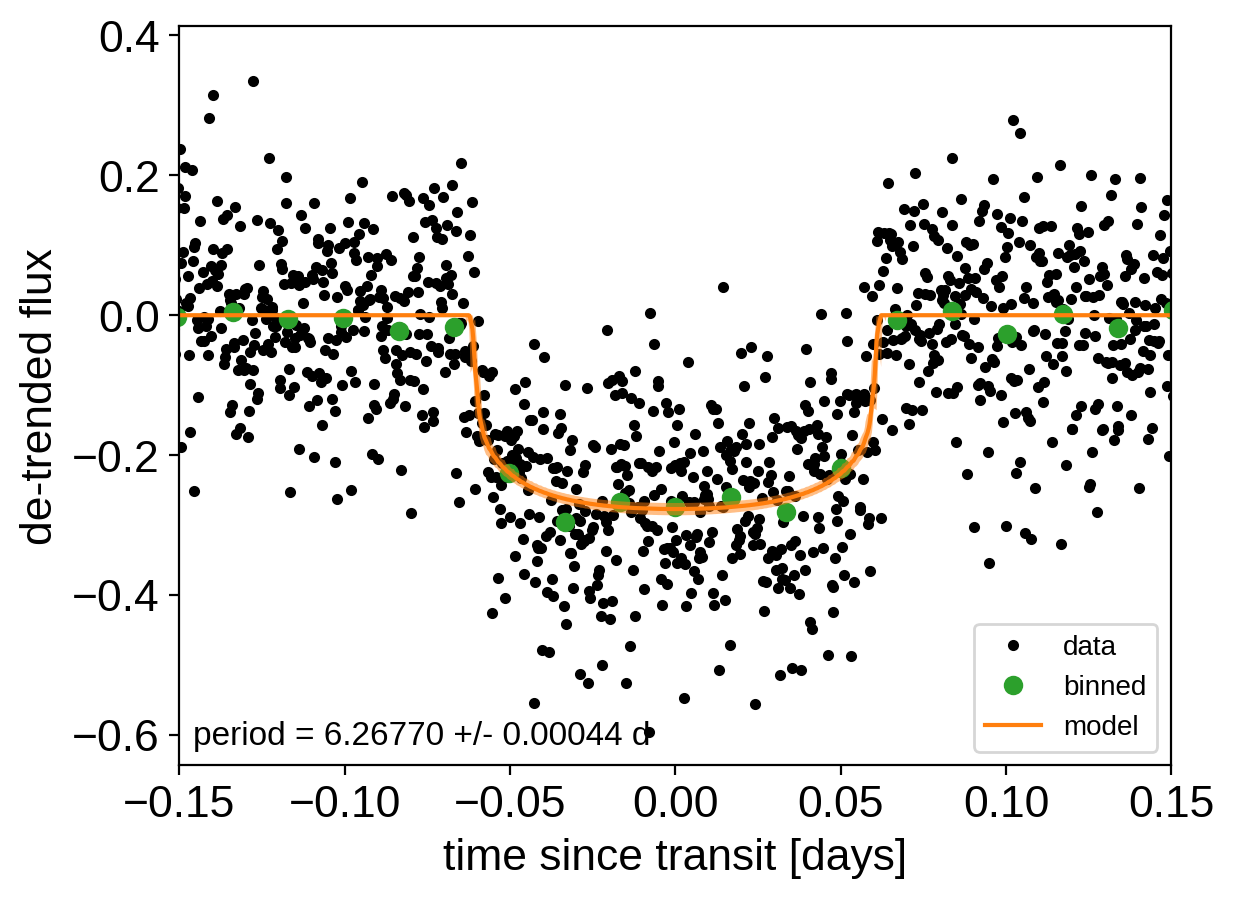

In [16]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, "o", color="C2",
         label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points", 
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.15, 0.15);

And a corner plot of some of the key parameters:

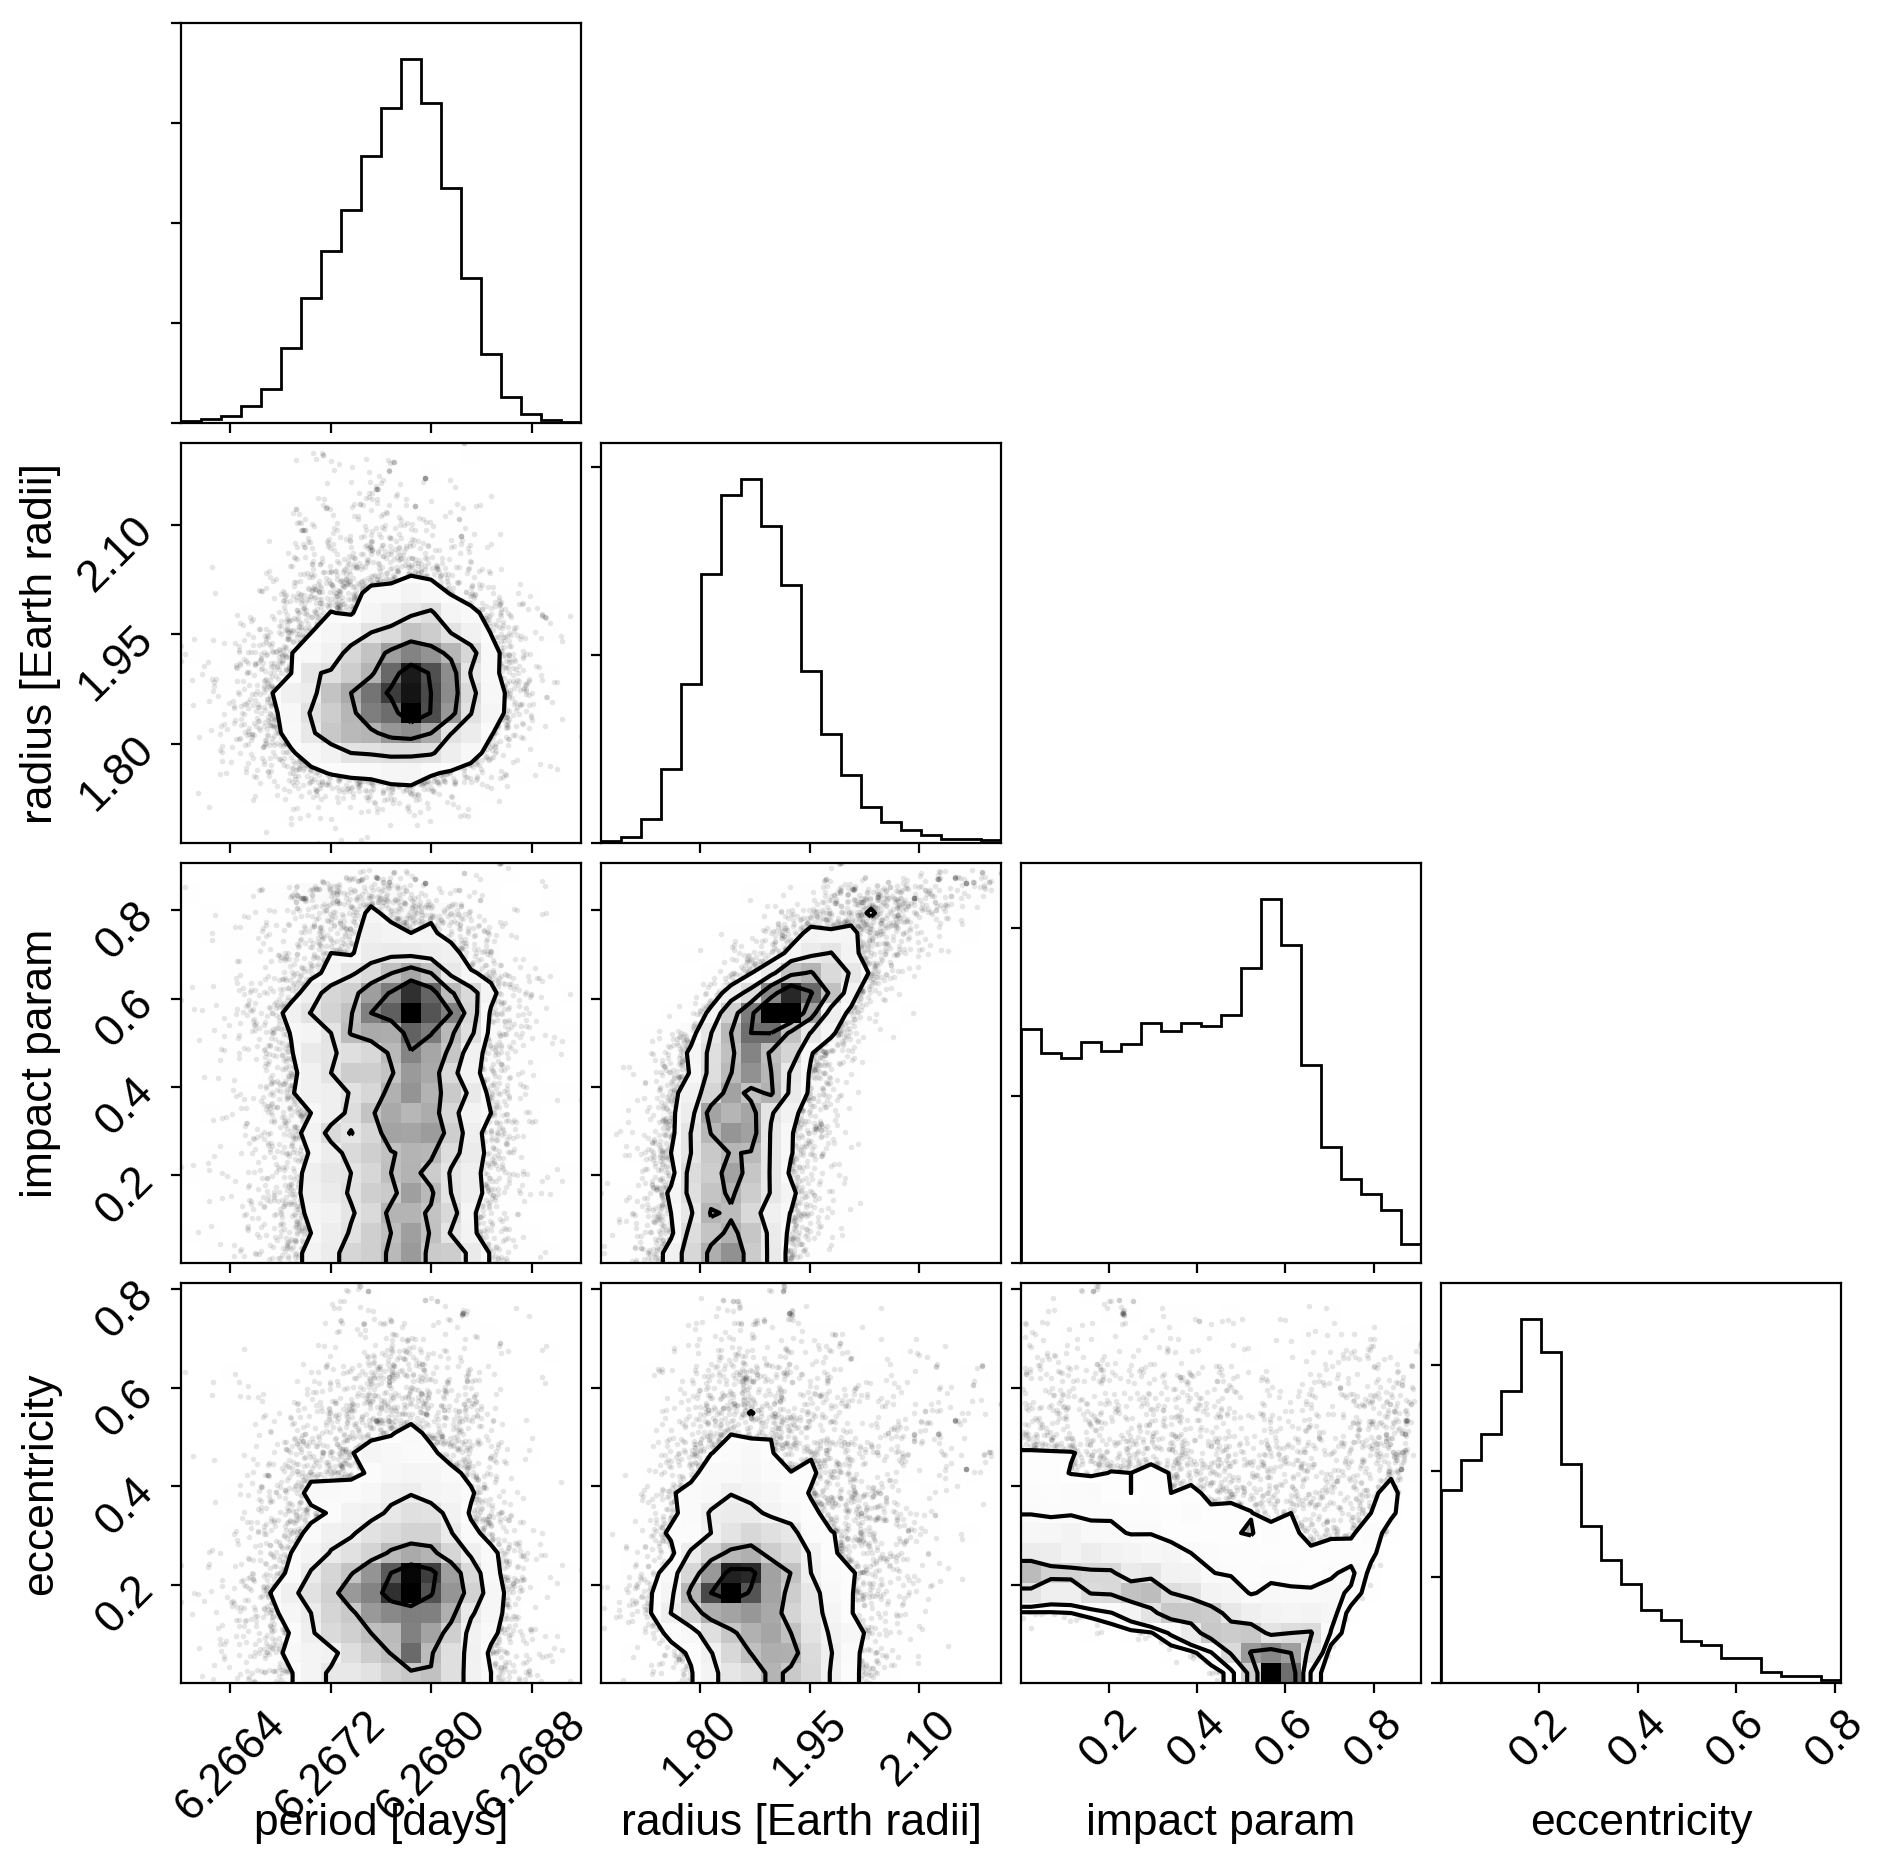

In [17]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_earth).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Earth radii]", "impact param", "eccentricity"]);

These all seem consistent with the previously published values and an earlier inconsistency between this radius measurement and the literature has been resolved by fixing a bug in *exoplanet*.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:kipping13b, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Eric Agol and
            Rodrigo Luger and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.0},
   month = aug,
    year = 2019,
     doi = {10.5281/zenodo.3359880},
     url = {https://doi.org/10.5281/zenodo.3359880}
}
...
